# German Risk Credit Predict 
This is german risk Credit dataset can be found in Kaggle [German Risk](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk) my goal is to create a predict model and use this model to create an score for each client.


# Tables of Content:

**1. [Introduction](#Introduction)**

    - Info's about datasets
**2. [Dataset](#Dataset)** 

    - Importing Librarys
    - Importing Dataset
    - The first rows of our dataset
    - Looking the Type of Data
    - Shape of data
    - Null Numbers
    - Unique values
**4. [EDA](#EDA)**

    - Ploting some graphical and descriptive informations
**5. [Correlation of data](#Correlation)** 

	- Correlation Data
**6. [Preprocess](#Preprocessing)** 

    - One hot Enconding
    - Ordinal Enconding
    - Correlation Data
**7.  [Model](#Training)** 

    - Setting X and Y
    - Spliting the X and Y in train and test 
    - XGBoost, LGBM, CART
    - Cross Validation 
**8.  [Hyperparameter Optimization using Optuna](#Hyperparameter)**

    - Hyperparameter Space
    - Optuna Study
    - Final Model
    - Confusion Matrix
    - ROC Curve
**9. [Ranking the final model](#Ranking)**

    - Using SHAP
    - Creating Scores and Decils

# Introduction
Context

Each person is classified as good or bad credit risks according to the set of attributes.The selected attributes are:
* Age (numeric)
* Sex (text: male, female)
* Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
* Housing (text: own, rent, or free)
* Saving accounts (text - little, moderate, quite rich, rich)
* Checking account (text - little, moderate, rich)
* Credit amount (numeric, in DM)
* Duration (numeric, in month)
* Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
* Risk (Value target - Good or Bad Risk)

The business team came to you because they want to understand the behavior and the profile of the most risk clients and our goal here is to create a predictive model to help them

My goal here is to create a predict model, after that I'll use optuna for hyperparameter optimization then 'rank' the customer in scores and then use the shap for identify each variable is most important

# Dataset

In [1]:
import numpy as np
import pandas as pd
import sys
import timeit
import gc
import sklearn
from sklearn.model_selection import KFold
import seaborn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pylab as plt
import seaborn as sns
import plotly.offline as py 
py.init_notebook_mode(connected=True) 
import plotly.graph_objs as go
import plotly.tools as tls 
from collections import Counter

In [2]:
# read the dataset
df = pd.read_csv('german_credit_data.csv')

In [3]:
df

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0             0   67    male    2     own             NaN           little   
1             1   22  female    2     own          little         moderate   
2             2   49    male    1     own          little              NaN   
3             3   45    male    2    free          little           little   
4             4   53    male    2    free          little           little   
..          ...  ...     ...  ...     ...             ...              ...   
995         995   31  female    1     own          little              NaN   
996         996   40    male    3     own          little           little   
997         997   38    male    2     own          little              NaN   
998         998   23    male    2    free          little           little   
999         999   27    male    2     own        moderate         moderate   

     Credit amount  Duration              Purpose  Risk  
0             1169         6             radio/TV  good  
1             5951        48             radio/TV   bad  
2             2096        12            education  good  
3             7882        42  furniture/equipment  good  
4             4870        24                  car   bad  
..             ...       ...                  ...   ...  
995           1736        12  furniture/equipment  good  
996           3857        30                  car  good  
997            804        12             radio/TV  good  
998           1845        45             radio/TV   bad  
999           4576        45                  car  good  

[1000 rows x 11 columns]

* Looking the Type of Data
* Null Numbers or/and Unique values

In [4]:
# knowing the shape of the data and search for missing
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB
None


In [5]:
# looking unique values
print(df.nunique())

Unnamed: 0          1000
Age                   53
Sex                    2
Job                    4
Housing                3
Saving accounts        4
Checking account       3
Credit amount        921
Duration              33
Purpose                8
Risk                   2
dtype: int64


# EDA
Let's start looking through target variable and their distribuition

In [44]:
trace0 = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good Credit'
    )

trace1 = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad Credit'
    )

data = [trace0, trace1]

layout = go.Layout(
    
)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

In [47]:
df_sex = df['Sex'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Sex'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Sex'].values.tolist()
# First plot
hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
# Second plot
hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
# Third plot
hist_3 = go.Histogram(
    x=df_sex,
    histnorm='probability',
    name="General distribution"
)

# # grid
# fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
#                           subplot_titles=('Good','Bad', 'General Distribuition'))

# fig.append_trace(hist_1, 1, 1)
# fig.append_trace(hist_2, 1, 2)
# fig.append_trace(hist_3, 2, 1)

# fig['layout'].update(showlegend=True, title='Sex Distribuition', bargap=0.05)
# py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Sex", 
    xaxis = dict(title="Sex Group")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [46]:
df_age = df['Age'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Age", 
    xaxis = dict(title="Age")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

We can see that people with Bad Credit tend to more youth

In [8]:
df_job = df['Job'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Job'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Job'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_job,
    histnorm='probability',
    name="Overall Job"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Job", 
    xaxis = dict(title="Job")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

we can say that highly skilled (0 and 3) have more bad credit than the others

In [9]:
df_housing = df['Housing'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Housing'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Housing'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_housing,
    histnorm='probability',
    name="Overall Housing"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Housing", 
    xaxis = dict(title="Housing")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

people that owns house have better credit

In [10]:
df_saving = df['Saving accounts'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Saving accounts'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Saving accounts'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_saving,
    histnorm='probability',
    name="Overall saving"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Saving", 
    xaxis = dict(title="Saving")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

people with more savings accounts also have a better credit

In [11]:
df_checking = df['Checking account'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Checking account'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Checking account'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_checking,
    histnorm='probability',
    name="Overall checking account"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Checking Account", 
    xaxis = dict(title="Checking Account")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

the same here, people with more checking account has a better credit

In [12]:
df_credit = df['Credit amount'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Credit amount'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Credit amount'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_credit,
    histnorm='probability',
    name="Overall Credit amount"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Credit amount", 
    xaxis = dict(title="Credit amount")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

people with more than 4k in credit amount have a bad credit than people with less

In [13]:
df_duration = df['Duration'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Duration'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Duration'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_duration,
    histnorm='probability',
    name="Overall Duration"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Duration", 
    xaxis = dict(title="Duration")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

more credit duration worse is the credit

In [14]:
df_purpose = df['Purpose'].values.tolist()
df_good = df.loc[df["Risk"] == 'good']['Purpose'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Purpose'].values.tolist()

hist_1 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)

hist_2 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)

hist_3 = go.Histogram(
    x=df_purpose,
    histnorm='probability',
    name="Overall Purpose"
)

data = [hist_1, hist_2, hist_3]

layout = dict(
    title="Type of Credit by Purpose", 
    xaxis = dict(title="Purpose")
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')



people that the purpose is to buy radio/TV have a better credit

Now let's see the distrubution using two variables

In [15]:

df_good = df.loc[df["Risk"] == 'good']['Checking account'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Checking account'].values.tolist()
box_1 = go.Box(
    x=df_good,
    y=df['Credit amount'],
    name="Good Credit"
)

box_2 = go.Box(
    x=df_bad,
    y=df['Credit amount'],
    name="Bad Credit"
)



data = [box_1, box_2]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount by Checking Account'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

The credit amount is also less in rich people, even in the bad credit

In [16]:

df_good = df.loc[df["Risk"] == 'good']['Sex'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Sex'].values.tolist()
box_1 = go.Box(
    x=df_good,
    y=df['Credit amount'],
    name="Good Credit"
)

box_2 = go.Box(
    x=df_bad,
    y=df['Credit amount'],
    name="Bad Credit"
)



data = [box_1, box_2]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount by Checking Account'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

The credit amount in male with bad credit is $5k

In [17]:

df_good = df.loc[df["Risk"] == 'good']['Job'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Job'].values.tolist()
box_1 = go.Box(
    x=df_good,
    y=df['Credit amount'],
    name="Good Credit"
)

box_2 = go.Box(
    x=df_bad,
    y=df['Credit amount'],
    name="Bad Credit"
)



data = [box_1, box_2]

layout = go.Layout(
    yaxis=dict(
        title='Job'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [18]:

df_good = df.loc[df["Risk"] == 'good']['Housing'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Housing'].values.tolist()
box_1 = go.Box(
    x=df_good,
    y=df['Credit amount'],
    name="Good Credit"
)

box_2 = go.Box(
    x=df_bad,
    y=df['Credit amount'],
    name="Bad Credit"
)



data = [box_1, box_2]

layout = go.Layout(
    yaxis=dict(
        title='Crerdit amount'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [19]:
df_good = df.loc[df["Risk"] == 'good']['Saving accounts'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Saving accounts'].values.tolist()
box_1 = go.Box(
    x=df_good,
    y=df['Credit amount'],
    name="Good Credit"
)

box_2 = go.Box(
    x=df_bad,
    y=df['Credit amount'],
    name="Bad Credit"
)



data = [box_1, box_2]

layout = go.Layout(
    yaxis=dict(
        title='Credit amount'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [20]:
df_good = df.loc[df["Risk"] == 'good']['Purpose'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Purpose'].values.tolist()
box_1 = go.Box(
    x=df_good,
    y=df['Credit amount'],
    name="Good Credit"
)

box_2 = go.Box(
    x=df_bad,
    y=df['Credit amount'],
    name="Bad Credit"
)



data = [box_1, box_2]

layout = go.Layout(
    yaxis=dict(
        title='Purpose'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

# Preprocessing

In [21]:
df.dtypes

Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [22]:
df.isna().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

We will use one hot enconding for the sex, housing and purpose variable.

In [23]:
one_hot = {
    "Sex": "sex",
    "Housing": "hous",
    "Purpose": "purp"
}

And ordinal enconding for the others

In [24]:
ordinal_encoding = {
    "Saving accounts": {
        None: 0,
        "little": 1,
        "moderate": 2,
        "quite rich": 3,
        "rich": 4,
    },
    "Checking account": {
        None: 0,
        "little": 1,
        "moderate": 2,
        "rich": 3,
    },
    "Risk": {
        "bad": 1,
        "good": 0,
    }
}

In [25]:
def one_hot_enconding(df, col_prefix: dict):
    df = df.copy()
    for col, prefix in col_prefix.items():
        df = pd.get_dummies(data=df, prefix=prefix, columns=[col])
    return df

In [26]:
def encode_ordinal(df, custom_ordinals: dict):
    df = df.copy()
    for col, map_dict in custom_ordinals.items():
        df[col] = df[col].replace(map_dict)
    return df

In [27]:
df_encode = df.copy()
df_encode = one_hot_enconding(df_encode, one_hot)
df_encode = encode_ordinal(df_encode, ordinal_encoding)

In [28]:
df_encode

Unnamed: 0  Age  Job  Saving accounts  Checking account  Credit amount  \
0             0   67    2                0                 1           1169   
1             1   22    2                1                 2           5951   
2             2   49    1                1                 0           2096   
3             3   45    2                1                 1           7882   
4             4   53    2                1                 1           4870   
..          ...  ...  ...              ...               ...            ...   
995         995   31    1                1                 0           1736   
996         996   40    3                1                 1           3857   
997         997   38    2                1                 0            804   
998         998   23    2                1                 1           1845   
999         999   27    2                2                 2           4576   

     Duration  Risk  sex_female  sex_male  ...  hous_own  hous_rent  \
0           6     0           0         1  ...         1          0   
1          48     1           1         0  ...         1          0   
2          12     0           0         1  ...         1          0   
3          42     0           0         1  ...         0          0   
4          24     1           0         1  ...         0          0   
..        ...   ...         ...       ...  ...       ...        ...   
995        12     0           1         0  ...         1          0   
996        30     0           0         1  ...         1          0   
997        12     0           0         1  ...         1          0   
998        45     1           0         1  ...         0          0   
999        45     0           0         1  ...         1          0   

     purp_business  purp_car  purp_domestic appliances  purp_education  \
0                0         0                         0               0   
1                0         0                         0               0   
2                0         0                         0               1   
3                0         0                         0               0   
4                0         1                         0               0   
..             ...       ...                       ...             ...   
995              0         0                         0               0   
996              0         1                         0               0   
997              0         0                         0               0   
998              0         0                         0               0   
999              0         1                         0               0   

     purp_furniture/equipment  purp_radio/TV  purp_repairs  \
0                           0              1             0   
1                           0              1             0   
2                           0              0             0   
3                           1              0             0   
4                           0              0             0   
..                        ...            ...           ...   
995                         1              0             0   
996                         0              0             0   
997                         0              1             0   
998                         0              1             0   
999                         0              0             0   

     purp_vacation/others  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
..                    ...  
995                     0  
996                     0  
997                     0  
998                     0  
999                     0  

[1000 rows x 21 columns]

In [29]:
df_encode.dtypes

Unnamed: 0                  int64
Age                         int64
Job                         int64
Saving accounts             int64
Checking account            int64
Credit amount               int64
Duration                    int64
Risk                        int64
sex_female                  uint8
sex_male                    uint8
hous_free                   uint8
hous_own                    uint8
hous_rent                   uint8
purp_business               uint8
purp_car                    uint8
purp_domestic appliances    uint8
purp_education              uint8
purp_furniture/equipment    uint8
purp_radio/TV               uint8
purp_repairs                uint8
purp_vacation/others        uint8
dtype: object

In [30]:
df_encode.isna().sum()

Unnamed: 0                  0
Age                         0
Job                         0
Saving accounts             0
Checking account            0
Credit amount               0
Duration                    0
Risk                        0
sex_female                  0
sex_male                    0
hous_free                   0
hous_own                    0
hous_rent                   0
purp_business               0
purp_car                    0
purp_domestic appliances    0
purp_education              0
purp_furniture/equipment    0
purp_radio/TV               0
purp_repairs                0
purp_vacation/others        0
dtype: int64

In [31]:
# Check for duplicate rows
df.duplicated().sum()

0

In [32]:
df_encode.corr()['Risk'].sort_values()

hous_own                   -0.134589
purp_radio/TV              -0.106922
Age                        -0.091127
sex_male                   -0.075493
Saving accounts            -0.033871
purp_domestic appliances    0.008016
purp_repairs                0.020828
purp_furniture/equipment    0.020971
purp_car                    0.022621
purp_vacation/others        0.028058
Job                         0.032735
Unnamed: 0                  0.034606
purp_business               0.036129
purp_education              0.049085
sex_female                  0.075493
hous_free                   0.081556
hous_rent                   0.092785
Credit amount               0.154739
Checking account            0.197788
Duration                    0.214927
Risk                        1.000000
Name: Risk, dtype: float64

In [33]:
df_encode.columns

Index(['Unnamed: 0', 'Age', 'Job', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Risk', 'sex_female', 'sex_male',
       'hous_free', 'hous_own', 'hous_rent', 'purp_business', 'purp_car',
       'purp_domestic appliances', 'purp_education',
       'purp_furniture/equipment', 'purp_radio/TV', 'purp_repairs',
       'purp_vacation/others'],
      dtype='object')

getting all the cols that we are going to use in our model

In [34]:
model_cols = ['Age', 'Job', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'sex_female', 'sex_male',
       'hous_free', 'hous_own', 'hous_rent', 'purp_business', 'purp_car',
       'purp_domestic appliances', 'purp_education',
       'purp_furniture/equipment', 'purp_radio/TV', 'purp_repairs',
       'purp_vacation/others']

In [35]:
df_encode.loc[df_encode['Risk']==0].mean()

Unnamed: 0                   492.960000
Age                           36.224286
Job                            1.890000
Saving accounts                1.211429
Checking account               0.877143
Credit amount               2985.457143
Duration                      19.207143
Risk                           0.000000
sex_female                     0.287143
sex_male                       0.712857
hous_free                      0.091429
hous_own                       0.752857
hous_rent                      0.155714
purp_business                  0.090000
purp_car                       0.330000
purp_domestic appliances       0.011429
purp_education                 0.051429
purp_furniture/equipment       0.175714
purp_radio/TV                  0.311429
purp_repairs                   0.020000
purp_vacation/others           0.010000
dtype: float64

In [36]:
df_encode.loc[df_encode['Risk']==1].mean()

Unnamed: 0                   514.760000
Age                           33.963333
Job                            1.936667
Saving accounts                1.140000
Checking account               1.290000
Credit amount               3938.126667
Duration                      24.860000
Risk                           1.000000
sex_female                     0.363333
sex_male                       0.636667
hous_free                      0.146667
hous_own                       0.620000
hous_rent                      0.233333
purp_business                  0.113333
purp_car                       0.353333
purp_domestic appliances       0.013333
purp_education                 0.076667
purp_furniture/equipment       0.193333
purp_radio/TV                  0.206667
purp_repairs                   0.026667
purp_vacation/others           0.016667
dtype: float64

some correlation

In [37]:
df_encode.astype(float).corr().abs().sort_values(by='Risk',ascending=False)['Risk']

Risk                        1.000000
Duration                    0.214927
Checking account            0.197788
Credit amount               0.154739
hous_own                    0.134589
purp_radio/TV               0.106922
hous_rent                   0.092785
Age                         0.091127
hous_free                   0.081556
sex_female                  0.075493
sex_male                    0.075493
purp_education              0.049085
purp_business               0.036129
Unnamed: 0                  0.034606
Saving accounts             0.033871
Job                         0.032735
purp_vacation/others        0.028058
purp_car                    0.022621
purp_furniture/equipment    0.020971
purp_repairs                0.020828
purp_domestic appliances    0.008016
Name: Risk, dtype: float64

duration, checking account, credit amount and owns house have the most corr

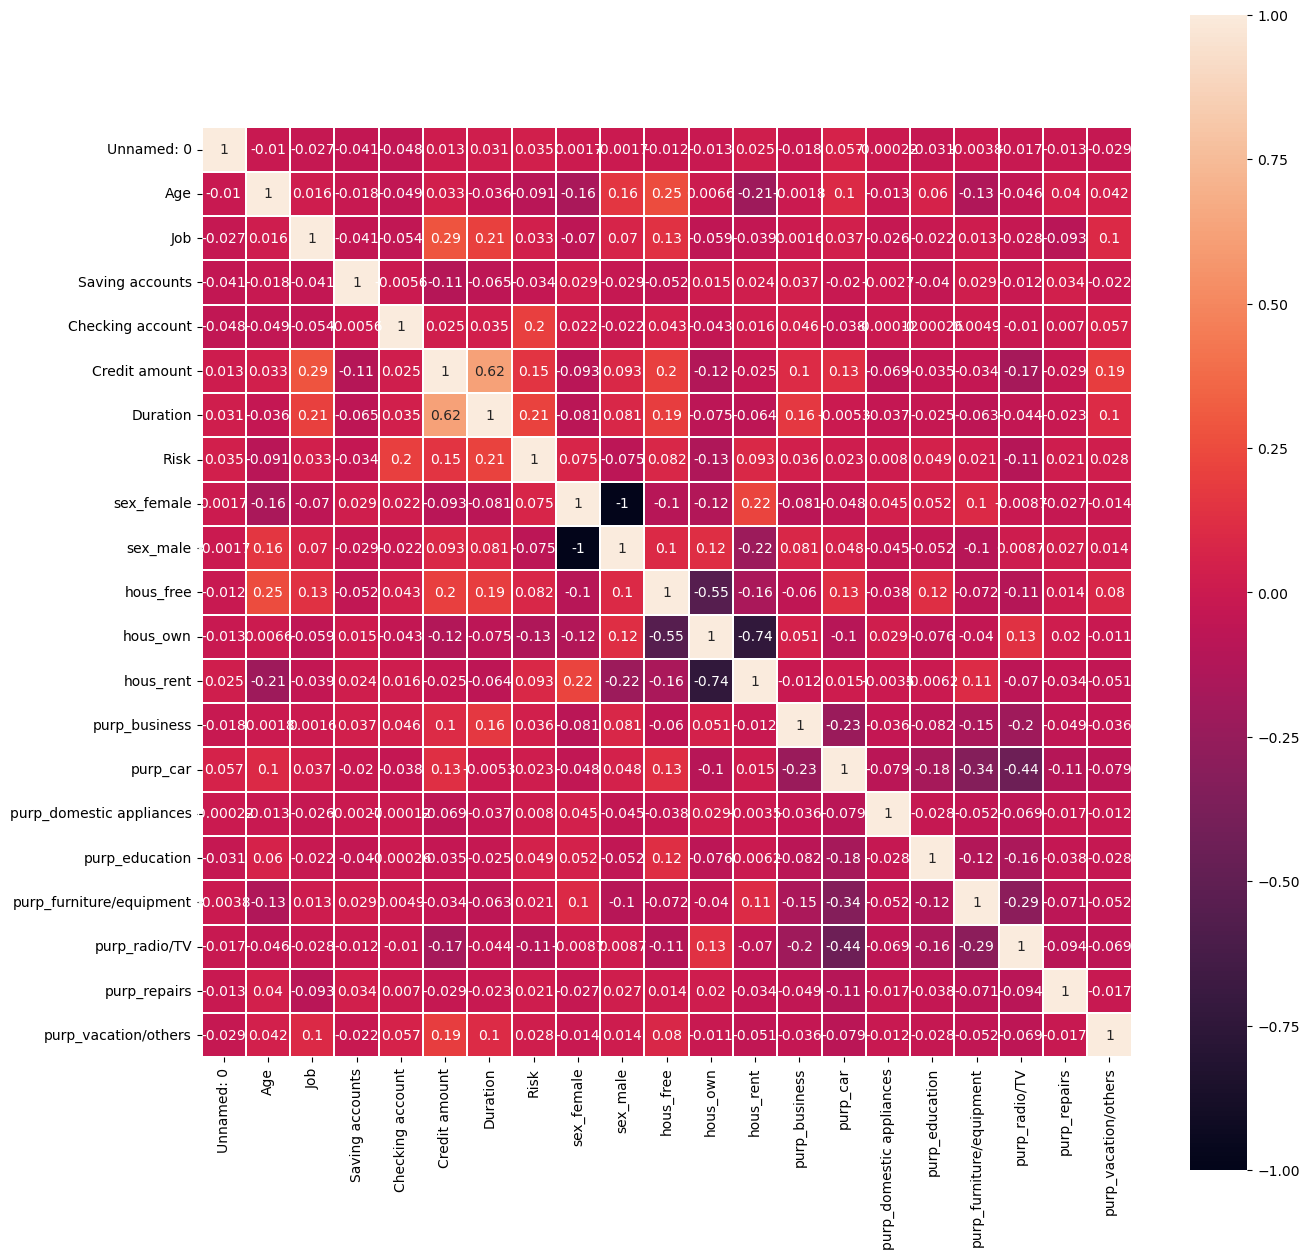

In [38]:
plt.figure(figsize=(15,15))
sns.heatmap(df_encode.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

# Training some Models

In [39]:
X = df_encode.loc[:,model_cols]
y = df_encode.loc[:,'Risk']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((700, 19), (300, 19), (700,), (300,))

Here we are going to train 5 models

In [41]:
# prepare models
lgbmparameters = {'verbose': -1}
models = []
models.append(('XGB', XGBClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('LGBM', LGBMClassifier(**lgbmparameters)))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
n_splits = 10
for name, model in models:
        kfold = KFold(n_splits=n_splits)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        

XGB: 0.720764 (0.055151)
CART: 0.613449 (0.068068)
LGBM: 0.733702 (0.062989)
RF: 0.725851 (0.058189)
NB: 0.685554 (0.082030)


In [42]:
box_1 = go.Box(
    x=n_splits*['XGB'],
    y=results[0],
    name="XGB"
)
box_2 = go.Box(
    x=n_splits*['CART'],
    y=results[1],
    name="CART"
)
box_3 = go.Box(
    x=n_splits*['LGBM'],
    y=results[2],
    name="LGBM"
)
box_4 = go.Box(
    x=n_splits*['RF'],
    y=results[3],
    name="RF"
)
box_5 = go.Box(
    x=n_splits*['NB'],
    y=results[4],
    name="NB"
)

data = [box_1, box_2, box_3, box_4, box_5]
layout = go.Layout(
    yaxis=dict(
        title='Model Results'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

The best models was RandomForest and LGBM, we are going to train this model and use optuna for hyperparameter optimization

In [44]:
lgbm_model = LGBMClassifier(**lgbmparameters).fit(X_train, y_train)
y_prob_lgbm = lgbm_model.predict_proba(X_test)

In [45]:
print('For the LGBM Model, the test AUC is: '+str(roc_auc_score(y_test,y_prob_lgbm[:,1])))
print('For the LGBM Model, the test Accu is: '+ str(accuracy_score(y_test,y_prob_lgbm[:,1].round())))

For the LGBM Model, the test AUC is: 0.7434670592565329
For the LGBM Model, the test Accu is: 0.7533333333333333


In [46]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
y_prob_rf = rf_model.predict_proba(X_test)

In [47]:
print('For the RandomForest Model, the test AUC is: '+str(roc_auc_score(y_test,y_prob_rf[:,1])))
print('For the RandomForest Model, the test Accu is: '+ str(accuracy_score(y_test,y_prob_rf[:,1].round())))

For the RandomForest Model, the test AUC is: 0.7218308007781692
For the RandomForest Model, the test Accu is: 0.7266666666666667


# Hyperparameter Optimization using Optuna

In [48]:
def auc_ks_metric(y_test, y_prob):
    '''
    Input:
        y_prob: model predict prob
        y_test: target
    Output: Metrics of validation
        auc, ks (Kolmogorov-Smirnov)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    auc = metrics.auc(fpr, tpr)
    ks = max(tpr - fpr)
    return auc, ks

def objective(trial, X_train, y_train, X_test, y_test, balanced, method):
    '''
    Input:
        trial: trial of the test
        X_train:
        y_train:
        X_test:
        y_test:
        balanced:balanced or None
        method: XGBoost, CatBoost or LGBM
    Output: Metrics of validation
        auc, ks, log_loss
        auc_logloss_ks(y_test, y_pred)[0]
    '''
    gc.collect()
    if method=='LGBM':
        param_grid = {'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
                      'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                      'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                      'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
                      'max_depth': trial.suggest_int('max_depth', 5, 64),
                      'feature_fraction': trial.suggest_float("feature_fraction", 0.4, 1.0),
                      'bagging_fraction': trial.suggest_float("bagging_fraction", 0.4, 1.0),
                      'bagging_freq': trial.suggest_int("bagging_freq", 1, 7),
                      'verbose': -1
  
                     }
        model = LGBMClassifier(**param_grid,tree_method='gpu_hist',gpu_id=0)

        print('LGBM - Optimization using optuna')
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_test)[:,1]
    if method=='RF':
        param_grid = {
                      'max_features': trial.suggest_int('max_features', 4, 20),
                      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 25),
                      'max_depth': trial.suggest_int('max_depth', 5, 64),
                      'min_samples_split': trial.suggest_int("min_samples_split", 2, 30),
                      'n_estimators': trial.suggest_int("n_estimators", 100, 2000)
  
                     }
        model = RandomForestClassifier(**param_grid)

        print('RandomForest - Optimization using optuna')
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_test)[:,1]
        
    if method=='XGBoost':
        param_grid = {'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
                      'max_depth': trial.suggest_int('max_depth', 3, 16),
                      'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
                      'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log = True),
                      'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log = True),
                      'lambda': trial.suggest_float('lambda', 0.0001, 10.0, log = True),
                      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
                      'booster': 'gbtree',
                      'random_state': 42,
                     }
        model = XGBClassifier(**param_grid,tree_method='gpu_hist',gpu_id=0)
        print('XGBoost - Optimization using optuna')
        model.fit(X_train, y_train,verbose=False)
        y_pred = model.predict_proba(X_test)[:,1]
    
    auc_res = auc_ks_metric(y_test, y_pred)[0]
    print('auc:'+str(auc_res))
    return auc_ks_metric(y_test, y_pred)[0]

def tuning(X_train, y_train, X_test, y_test, balanced, method):
    '''
    Input:
        trial: 
        x_train:
        y_train:
        X_test:
        y_test:
        balanced:balanced or not balanced
        method: XGBoost, CatBoost or LGBM
    Output: Metrics of validation
        auc, ks, log_loss
        auc_logloss_ks(y_test, y_pred)[0]
    '''
    study = optuna.create_study(direction='maximize', study_name=method+' Classifier')
    func = lambda trial: objective(trial, X_train, y_train, X_test, y_test, balanced, method)
    print('Starting the optimization')
    time_max_tuning = 60*30 # max time in seconds to stop
    study.optimize(func, timeout=time_max_tuning)
    return study

def train(X_train, y_train, X_test, y_test, balanced, method):
    '''
    Input:
        X_train:
        y_train:
        X_test:
        y_test:
        balanced:balanced or None
        method: XGBoost, CatBoost or LGBM
    Output: predict model
    '''
    print('Tuning')
    study = tuning(X_train, y_train, X_test, y_test, balanced, method)
    if method=='LGBM':
        model = LGBMClassifier(**study.best_params)
        print('Last Fit')
        model.fit(X_train, y_train, eval_set=[(X_test,y_test)],
                 callbacks = [lightgbm.early_stopping(stopping_rounds=100), lightgbm.log_evaluation(period=5000)])
    if method=='XGBoost':
        model = XGBClassifier(**study.best_params)
        print('Last Fit')
        model.fit(X_train, y_train, eval_set=[(X_test,y_test)],
                 early_stopping_rounds=100,verbose = False)
    if method=='RF':
        model = RandomForestClassifier(**study.best_params)
        print('Last Fit')
        model.fit(X_train, y_train)
    return model, study

In [49]:
lgbm_model, study_lgbm = train(X_train, y_train, X_test, y_test, balanced='balanced', method='LGBM')

[I 2023-09-25 07:48:59,504] A new study created in memory with name: LGBM Classifier
[I 2023-09-25 07:48:59,607] Trial 0 finished with value: 0.7707818497292181 and parameters: {'learning_rate': 0.04564317750022488, 'num_leaves': 254, 'lambda_l1': 0.17602474289716696, 'lambda_l2': 2.936736356867574, 'min_data_in_leaf': 92, 'max_depth': 41, 'feature_fraction': 0.630771183128692, 'bagging_fraction': 0.8791863972428846, 'bagging_freq': 5}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:48:59,695] Trial 1 finished with value: 0.7673905042326096 and parameters: {'learning_rate': 0.03163545356039165, 'num_leaves': 93, 'lambda_l1': 5.331694642994698e-07, 'lambda_l2': 0.0016117988828970487, 'min_data_in_leaf': 62, 'max_depth': 17, 'feature_fraction': 0.5207793700543741, 'bagging_fraction': 0.6988688771949946, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.


Tuning
Starting the optimization
LGBM - Optimization using optuna
auc:0.7707818497292181
LGBM - Optimization using optuna
auc:0.7673905042326096
LGBM - Optimization using optuna


[I 2023-09-25 07:48:59,778] Trial 2 finished with value: 0.7639202902360797 and parameters: {'learning_rate': 0.00032903168736575527, 'num_leaves': 221, 'lambda_l1': 0.013182095631109458, 'lambda_l2': 0.004903360053701577, 'min_data_in_leaf': 50, 'max_depth': 35, 'feature_fraction': 0.81375010947157, 'bagging_fraction': 0.47255383236900694, 'bagging_freq': 6}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:48:59,870] Trial 3 finished with value: 0.7488301172511699 and parameters: {'learning_rate': 0.07583419812542502, 'num_leaves': 227, 'lambda_l1': 0.001263229821256988, 'lambda_l2': 0.6714031923624736, 'min_data_in_leaf': 23, 'max_depth': 48, 'feature_fraction': 0.47371647441012454, 'bagging_fraction': 0.5357410570154348, 'bagging_freq': 3}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:48:59,958] Trial 4 finished with value: 0.7586361007413639 and parameters: {'learning_rate': 0.0001610953746996855, 'num_leaves': 228, 'lambda_l1': 4.74483283120879

auc:0.7639202902360797
LGBM - Optimization using optuna
auc:0.7488301172511699
LGBM - Optimization using optuna
auc:0.7586361007413639
LGBM - Optimization using optuna


[I 2023-09-25 07:49:00,049] Trial 5 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.0001249838804070837, 'num_leaves': 62, 'lambda_l1': 1.0950722639611093e-08, 'lambda_l2': 1.6247452419757427, 'min_data_in_leaf': 88, 'max_depth': 20, 'feature_fraction': 0.7390198578425595, 'bagging_fraction': 0.5451921961124094, 'bagging_freq': 4}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:00,135] Trial 6 finished with value: 0.7462274567537727 and parameters: {'learning_rate': 0.021165567217590234, 'num_leaves': 219, 'lambda_l1': 2.634681758289909e-06, 'lambda_l2': 2.1170808617536877e-06, 'min_data_in_leaf': 70, 'max_depth': 52, 'feature_fraction': 0.8886838094462373, 'bagging_fraction': 0.7972849312237408, 'bagging_freq': 5}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:00,229] Trial 7 finished with value: 0.7455702192544299 and parameters: {'learning_rate': 0.028054358171711414, 'num_leaves': 106, 'lambda_l1': 0.27942444381

auc:0.7586098112413902
LGBM - Optimization using optuna
auc:0.7462274567537727
LGBM - Optimization using optuna
auc:0.7455702192544299
LGBM - Optimization using optuna


[I 2023-09-25 07:49:00,315] Trial 8 finished with value: 0.7532467532467533 and parameters: {'learning_rate': 0.00013707099977151445, 'num_leaves': 77, 'lambda_l1': 5.0710875953121746e-08, 'lambda_l2': 0.8867054763650601, 'min_data_in_leaf': 86, 'max_depth': 22, 'feature_fraction': 0.8914464546221328, 'bagging_fraction': 0.445329380982344, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:00,394] Trial 9 finished with value: 0.7565066512434934 and parameters: {'learning_rate': 0.0012581392179728994, 'num_leaves': 39, 'lambda_l1': 9.840893698523263e-08, 'lambda_l2': 2.699760425163092, 'min_data_in_leaf': 72, 'max_depth': 55, 'feature_fraction': 0.7957395782552636, 'bagging_fraction': 0.4407654034494648, 'bagging_freq': 6}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:00,490] Trial 10 finished with value: 0.7610021557389978 and parameters: {'learning_rate': 0.005349425742193582, 'num_leaves': 168, 'lambda_l1': 6.779723976955496

auc:0.7532467532467533
LGBM - Optimization using optuna
auc:0.7565066512434934
LGBM - Optimization using optuna
auc:0.7610021557389978


[I 2023-09-25 07:49:00,635] Trial 11 finished with value: 0.7327935222672065 and parameters: {'learning_rate': 0.08751168278849969, 'num_leaves': 148, 'lambda_l1': 5.480840101300654e-06, 'lambda_l2': 0.018988688084151044, 'min_data_in_leaf': 6, 'max_depth': 26, 'feature_fraction': 0.4053368126267675, 'bagging_fraction': 0.6961780531174555, 'bagging_freq': 3}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:00,739] Trial 12 finished with value: 0.7616856827383143 and parameters: {'learning_rate': 0.015042901325385006, 'num_leaves': 14, 'lambda_l1': 0.009044301507657816, 'lambda_l2': 9.644031382009469e-05, 'min_data_in_leaf': 65, 'max_depth': 9, 'feature_fraction': 0.5762552164481725, 'bagging_fraction': 0.7001688488723941, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7327935222672065
LGBM - Optimization using optuna
auc:0.7616856827383143


[I 2023-09-25 07:49:00,848] Trial 13 finished with value: 0.7465692202534308 and parameters: {'learning_rate': 0.007403205596750333, 'num_leaves': 117, 'lambda_l1': 0.00011105622188771217, 'lambda_l2': 0.07695663388470428, 'min_data_in_leaf': 33, 'max_depth': 39, 'feature_fraction': 0.631074098619677, 'bagging_fraction': 0.7510867327999257, 'bagging_freq': 3}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:00,952] Trial 14 finished with value: 0.7553499132446501 and parameters: {'learning_rate': 0.03979792920667323, 'num_leaves': 158, 'lambda_l1': 0.11649244465654626, 'lambda_l2': 7.600944504596595, 'min_data_in_leaf': 58, 'max_depth': 44, 'feature_fraction': 0.5444881973043647, 'bagging_fraction': 0.8825361257472166, 'bagging_freq': 4}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7465692202534308
LGBM - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 07:49:01,052] Trial 15 finished with value: 0.7599505757400494 and parameters: {'learning_rate': 0.010446800732473041, 'num_leaves': 254, 'lambda_l1': 0.0008088343371837662, 'lambda_l2': 0.0009704948269356987, 'min_data_in_leaf': 79, 'max_depth': 29, 'feature_fraction': 0.6934715664460988, 'bagging_fraction': 0.6501740770244862, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:01,151] Trial 16 finished with value: 0.7561648877438353 and parameters: {'learning_rate': 0.04721723204023062, 'num_leaves': 189, 'lambda_l1': 9.267171234146113, 'lambda_l2': 0.12910625464933873, 'min_data_in_leaf': 96, 'max_depth': 16, 'feature_fraction': 0.5072749308500442, 'bagging_fraction': 0.8290186158849442, 'bagging_freq': 5}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7599505757400494
LGBM - Optimization using optuna
auc:0.7561648877438353


[I 2023-09-25 07:49:01,259] Trial 17 finished with value: 0.7519848572480151 and parameters: {'learning_rate': 0.019693025399272104, 'num_leaves': 92, 'lambda_l1': 2.2881211962773016e-06, 'lambda_l2': 9.174936802867574, 'min_data_in_leaf': 55, 'max_depth': 30, 'feature_fraction': 0.4546307201666836, 'bagging_fraction': 0.918121123210892, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:01,369] Trial 18 finished with value: 0.7531941742468058 and parameters: {'learning_rate': 0.09298270409802809, 'num_leaves': 135, 'lambda_l1': 2.3882861441019245e-05, 'lambda_l2': 0.0018845840534680901, 'min_data_in_leaf': 45, 'max_depth': 15, 'feature_fraction': 0.6349664123585661, 'bagging_fraction': 0.9957969353532805, 'bagging_freq': 7}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7519848572480151
LGBM - Optimization using optuna
auc:0.7531941742468058


[I 2023-09-25 07:49:01,466] Trial 19 finished with value: 0.746726957253273 and parameters: {'learning_rate': 0.0036125028442948745, 'num_leaves': 191, 'lambda_l1': 3.511093615549016e-07, 'lambda_l2': 0.22109625639826208, 'min_data_in_leaf': 77, 'max_depth': 44, 'feature_fraction': 0.9961990990817716, 'bagging_fraction': 0.8012841645953497, 'bagging_freq': 6}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:01,567] Trial 20 finished with value: 0.7564014932435985 and parameters: {'learning_rate': 0.037077032822262455, 'num_leaves': 37, 'lambda_l1': 2.3527291252419904e-05, 'lambda_l2': 0.026974640047229825, 'min_data_in_leaf': 63, 'max_depth': 32, 'feature_fraction': 0.530949885923289, 'bagging_fraction': 0.897538720747818, 'bagging_freq': 4}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.746726957253273
LGBM - Optimization using optuna
auc:0.7564014932435985
LGBM - Optimization using optuna


[I 2023-09-25 07:49:01,667] Trial 21 finished with value: 0.7491981702508018 and parameters: {'learning_rate': 0.0009577552702965959, 'num_leaves': 251, 'lambda_l1': 0.007761910010976283, 'lambda_l2': 0.004526459778503104, 'min_data_in_leaf': 49, 'max_depth': 36, 'feature_fraction': 0.7725724201757859, 'bagging_fraction': 0.6018695903879391, 'bagging_freq': 6}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:01,765] Trial 22 finished with value: 0.7539302802460697 and parameters: {'learning_rate': 0.012997391227207177, 'num_leaves': 192, 'lambda_l1': 0.0638196335486403, 'lambda_l2': 0.00029048608078680586, 'min_data_in_leaf': 31, 'max_depth': 45, 'feature_fraction': 0.8161196219962054, 'bagging_fraction': 0.4062968272219024, 'bagging_freq': 5}. Best is trial 0 with value: 0.7707818497292181.


auc:0.7491981702508018
LGBM - Optimization using optuna
auc:0.7539302802460697
LGBM - Optimization using optuna


[I 2023-09-25 07:49:01,882] Trial 23 finished with value: 0.7519848572480151 and parameters: {'learning_rate': 0.0019531684913117607, 'num_leaves': 206, 'lambda_l1': 0.0032603683746414472, 'lambda_l2': 0.00783913295752208, 'min_data_in_leaf': 16, 'max_depth': 25, 'feature_fraction': 0.6974929016052356, 'bagging_fraction': 0.7614608598932031, 'bagging_freq': 6}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:01,990] Trial 24 finished with value: 0.7542983332457016 and parameters: {'learning_rate': 0.00039437467425353925, 'num_leaves': 239, 'lambda_l1': 0.0003476257084252494, 'lambda_l2': 0.23118162714149115, 'min_data_in_leaf': 42, 'max_depth': 39, 'feature_fraction': 0.5921819227236389, 'bagging_fraction': 0.6091771340371117, 'bagging_freq': 7}. Best is trial 0 with value: 0.7707818497292181.


auc:0.7519848572480151
LGBM - Optimization using optuna
auc:0.7542983332457016
LGBM - Optimization using optuna


[I 2023-09-25 07:49:02,087] Trial 25 finished with value: 0.7534044902465955 and parameters: {'learning_rate': 0.00751390771098055, 'num_leaves': 169, 'lambda_l1': 0.03035260489323965, 'lambda_l2': 0.0010608281313265087, 'min_data_in_leaf': 54, 'max_depth': 14, 'feature_fraction': 0.720819072802044, 'bagging_fraction': 0.7365665680967097, 'bagging_freq': 5}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:02,195] Trial 26 finished with value: 0.7404700562595299 and parameters: {'learning_rate': 0.003472547185926543, 'num_leaves': 211, 'lambda_l1': 0.5260726994747305, 'lambda_l2': 0.09635084683451028, 'min_data_in_leaf': 35, 'max_depth': 5, 'feature_fraction': 0.6595942173463679, 'bagging_fraction': 0.8637806650657942, 'bagging_freq': 6}. Best is trial 0 with value: 0.7707818497292181.


auc:0.7534044902465955
LGBM - Optimization using optuna
auc:0.7404700562595299


[I 2023-09-25 07:49:02,301] Trial 27 finished with value: 0.7612124717387875 and parameters: {'learning_rate': 0.04938572183311313, 'num_leaves': 136, 'lambda_l1': 0.02043652022887421, 'lambda_l2': 4.123801388574911e-05, 'min_data_in_leaf': 63, 'max_depth': 34, 'feature_fraction': 0.6042437545377609, 'bagging_fraction': 0.5209463843454489, 'bagging_freq': 3}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:02,404] Trial 28 finished with value: 0.7611336032388664 and parameters: {'learning_rate': 0.02526148694536721, 'num_leaves': 66, 'lambda_l1': 0.0018712719637267406, 'lambda_l2': 0.0027643858064331506, 'min_data_in_leaf': 81, 'max_depth': 63, 'feature_fraction': 0.6802263832728733, 'bagging_fraction': 0.8060929398759759, 'bagging_freq': 4}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7612124717387875
LGBM - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 07:49:02,508] Trial 29 finished with value: 0.7290604132709395 and parameters: {'learning_rate': 0.06504846433722258, 'num_leaves': 229, 'lambda_l1': 0.0007971589214065749, 'lambda_l2': 0.5411268981374917, 'min_data_in_leaf': 27, 'max_depth': 52, 'feature_fraction': 0.7564962698709586, 'bagging_fraction': 0.5204356892942018, 'bagging_freq': 4}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:02,618] Trial 30 finished with value: 0.7658131342341868 and parameters: {'learning_rate': 0.06651608465799526, 'num_leaves': 94, 'lambda_l1': 1.4179199075459115, 'lambda_l2': 0.8458937915382368, 'min_data_in_leaf': 21, 'max_depth': 42, 'feature_fraction': 0.48580874218297054, 'bagging_fraction': 0.9402747818120544, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7290604132709395
LGBM - Optimization using optuna
auc:0.7658131342341868


[I 2023-09-25 07:49:02,730] Trial 31 finished with value: 0.7608181292391819 and parameters: {'learning_rate': 0.0664532082167251, 'num_leaves': 94, 'lambda_l1': 1.1491921499322164, 'lambda_l2': 0.6856617620786095, 'min_data_in_leaf': 19, 'max_depth': 42, 'feature_fraction': 0.48252946855909773, 'bagging_fraction': 0.9230631106608574, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:02,845] Trial 32 finished with value: 0.757453073242547 and parameters: {'learning_rate': 0.09648222423736763, 'num_leaves': 122, 'lambda_l1': 1.6562032948234768, 'lambda_l2': 4.337905712654744, 'min_data_in_leaf': 12, 'max_depth': 48, 'feature_fraction': 0.5469415935814043, 'bagging_fraction': 0.9622892343891751, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7608181292391819
LGBM - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 07:49:02,944] Trial 33 finished with value: 0.7625795257374205 and parameters: {'learning_rate': 0.03147105095748769, 'num_leaves': 83, 'lambda_l1': 0.16441158977652232, 'lambda_l2': 1.606149804876165, 'min_data_in_leaf': 93, 'max_depth': 48, 'feature_fraction': 0.45704017272694786, 'bagging_fraction': 0.9444921362503701, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:03,048] Trial 34 finished with value: 0.7651296072348703 and parameters: {'learning_rate': 0.05677475771020507, 'num_leaves': 55, 'lambda_l1': 1.4581943934474269, 'lambda_l2': 2.466172789883135, 'min_data_in_leaf': 72, 'max_depth': 41, 'feature_fraction': 0.515178108876936, 'bagging_fraction': 0.9953591334320798, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7625795257374205
LGBM - Optimization using optuna
auc:0.7651296072348703


[I 2023-09-25 07:49:03,153] Trial 35 finished with value: 0.7556128082443871 and parameters: {'learning_rate': 0.05207232924171823, 'num_leaves': 50, 'lambda_l1': 3.7115334710406724, 'lambda_l2': 2.035360871287861, 'min_data_in_leaf': 73, 'max_depth': 41, 'feature_fraction': 0.5087969801374809, 'bagging_fraction': 0.9897925879722176, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:03,254] Trial 36 finished with value: 0.7608707082391293 and parameters: {'learning_rate': 0.02139402000710255, 'num_leaves': 6, 'lambda_l1': 0.5521723097940615, 'lambda_l2': 0.43026544483686835, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.4278382886252465, 'bagging_fraction': 0.9504978456024454, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7556128082443871
LGBM - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 07:49:03,355] Trial 37 finished with value: 0.7616593932383405 and parameters: {'learning_rate': 0.03228961420633733, 'num_leaves': 106, 'lambda_l1': 3.233889883655527, 'lambda_l2': 8.950028778927715, 'min_data_in_leaf': 91, 'max_depth': 58, 'feature_fraction': 0.49221465720151303, 'bagging_fraction': 0.9064248171189837, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:03,463] Trial 38 finished with value: 0.7638151322361848 and parameters: {'learning_rate': 0.05444800098402292, 'num_leaves': 64, 'lambda_l1': 0.36346729522363863, 'lambda_l2': 0.844703849455417, 'min_data_in_leaf': 69, 'max_depth': 35, 'feature_fraction': 0.5537773951075147, 'bagging_fraction': 0.9574102445606035, 'bagging_freq': 3}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7616593932383405
LGBM - Optimization using optuna
auc:0.7638151322361848


[I 2023-09-25 07:49:03,575] Trial 39 finished with value: 0.7582943372417056 and parameters: {'learning_rate': 0.0663918675285908, 'num_leaves': 25, 'lambda_l1': 0.04414895892059046, 'lambda_l2': 2.4835938284001937, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.5089951899903472, 'bagging_fraction': 0.9834358393861974, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:03,680] Trial 40 finished with value: 0.7595825227404175 and parameters: {'learning_rate': 0.036471174244791627, 'num_leaves': 75, 'lambda_l1': 9.095261042829287, 'lambda_l2': 0.049695027860769424, 'min_data_in_leaf': 60, 'max_depth': 19, 'feature_fraction': 0.4650117470215299, 'bagging_fraction': 0.9302133030699323, 'bagging_freq': 3}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7582943372417056
LGBM - Optimization using optuna
auc:0.7595825227404175


[I 2023-09-25 07:49:03,787] Trial 41 finished with value: 0.7557705452442294 and parameters: {'learning_rate': 0.017044117636039833, 'num_leaves': 54, 'lambda_l1': 0.13679534454572465, 'lambda_l2': 0.012941494260882671, 'min_data_in_leaf': 47, 'max_depth': 37, 'feature_fraction': 0.6110971606440274, 'bagging_fraction': 0.8812409921241404, 'bagging_freq': 5}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:03,894] Trial 42 finished with value: 0.7565066512434934 and parameters: {'learning_rate': 0.025633119851944632, 'num_leaves': 99, 'lambda_l1': 0.8296660755565171, 'lambda_l2': 0.037530604768813106, 'min_data_in_leaf': 68, 'max_depth': 33, 'feature_fraction': 0.5719133616597377, 'bagging_fraction': 0.8344549622516763, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7557705452442294
LGBM - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 07:49:04,001] Trial 43 finished with value: 0.7633682107366317 and parameters: {'learning_rate': 0.08278723062523488, 'num_leaves': 238, 'lambda_l1': 0.24545856582006909, 'lambda_l2': 0.3731222367960086, 'min_data_in_leaf': 87, 'max_depth': 30, 'feature_fraction': 0.5288623750449796, 'bagging_fraction': 0.8553947346021091, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:04,113] Trial 44 finished with value: 0.7524054892475945 and parameters: {'learning_rate': 0.00022194313339959432, 'num_leaves': 112, 'lambda_l1': 1.8922092500313228, 'lambda_l2': 1.2831397213821236, 'min_data_in_leaf': 38, 'max_depth': 26, 'feature_fraction': 0.5777915538995188, 'bagging_fraction': 0.9987209583590055, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7633682107366317
LGBM - Optimization using optuna
auc:0.7524054892475945


[I 2023-09-25 07:49:04,222] Trial 45 finished with value: 0.7621326042378673 and parameters: {'learning_rate': 0.04720497322284284, 'num_leaves': 41, 'lambda_l1': 1.0578806352284281e-08, 'lambda_l2': 0.09524285232168876, 'min_data_in_leaf': 51, 'max_depth': 41, 'feature_fraction': 0.613479355484925, 'bagging_fraction': 0.9651918698066299, 'bagging_freq': 6}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:04,347] Trial 46 finished with value: 0.7588201272411799 and parameters: {'learning_rate': 0.024455360727246352, 'num_leaves': 84, 'lambda_l1': 0.08460545278095874, 'lambda_l2': 3.5918885764292146, 'min_data_in_leaf': 8, 'max_depth': 46, 'feature_fraction': 0.4323568867028347, 'bagging_fraction': 0.9339769965627384, 'bagging_freq': 5}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7621326042378673
LGBM - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 07:49:04,454] Trial 47 finished with value: 0.7459382722540618 and parameters: {'learning_rate': 0.013202637187436512, 'num_leaves': 244, 'lambda_l1': 0.016099612840447867, 'lambda_l2': 0.00988079757497866, 'min_data_in_leaf': 58, 'max_depth': 42, 'feature_fraction': 0.4807178541417023, 'bagging_fraction': 0.898049224484587, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:04,571] Trial 48 finished with value: 0.7512487512487512 and parameters: {'learning_rate': 0.06891132802909747, 'num_leaves': 143, 'lambda_l1': 0.28997695109209093, 'lambda_l2': 0.2003271522269525, 'min_data_in_leaf': 25, 'max_depth': 23, 'feature_fraction': 0.651640234583462, 'bagging_fraction': 0.9657689661281641, 'bagging_freq': 6}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7459382722540618
LGBM - Optimization using optuna
auc:0.7512487512487512


[I 2023-09-25 07:49:04,671] Trial 49 finished with value: 0.7475156422524843 and parameters: {'learning_rate': 0.03874531992016946, 'num_leaves': 227, 'lambda_l1': 1.3333634136838866, 'lambda_l2': 0.038927876206998446, 'min_data_in_leaf': 100, 'max_depth': 50, 'feature_fraction': 0.5655546617878886, 'bagging_fraction': 0.47496503691223524, 'bagging_freq': 4}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:04,774] Trial 50 finished with value: 0.7580314422419685 and parameters: {'learning_rate': 0.019703933494189585, 'num_leaves': 175, 'lambda_l1': 0.06285467545100497, 'lambda_l2': 5.504505691911319, 'min_data_in_leaf': 67, 'max_depth': 28, 'feature_fraction': 0.5258877606103157, 'bagging_fraction': 0.6849882977117884, 'bagging_freq': 7}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7475156422524843
LGBM - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 07:49:04,879] Trial 51 finished with value: 0.7571901782428099 and parameters: {'learning_rate': 0.05507780220346626, 'num_leaves': 67, 'lambda_l1': 0.2051388300826969, 'lambda_l2': 0.7450195797483916, 'min_data_in_leaf': 71, 'max_depth': 35, 'feature_fraction': 0.5554417496312968, 'bagging_fraction': 0.9338178955798071, 'bagging_freq': 3}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:04,985] Trial 52 finished with value: 0.7552973342447027 and parameters: {'learning_rate': 0.09934854390830573, 'num_leaves': 57, 'lambda_l1': 0.47125358254873545, 'lambda_l2': 1.185612142963527, 'min_data_in_leaf': 78, 'max_depth': 39, 'feature_fraction': 0.5421096037592075, 'bagging_fraction': 0.9722736574974447, 'bagging_freq': 3}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7571901782428099
LGBM - Optimization using optuna
auc:0.7552973342447027


[I 2023-09-25 07:49:05,094] Trial 53 finished with value: 0.7552973342447027 and parameters: {'learning_rate': 0.031088695457851773, 'num_leaves': 24, 'lambda_l1': 2.56355658855888, 'lambda_l2': 2.7631498914077715, 'min_data_in_leaf': 58, 'max_depth': 32, 'feature_fraction': 0.5851538801395577, 'bagging_fraction': 0.9147597089067311, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:05,201] Trial 54 finished with value: 0.7575582312424418 and parameters: {'learning_rate': 0.046645860018154676, 'num_leaves': 74, 'lambda_l1': 0.6050889474182575, 'lambda_l2': 0.272914956130601, 'min_data_in_leaf': 83, 'max_depth': 37, 'feature_fraction': 0.5127072432323243, 'bagging_fraction': 0.9511288758954466, 'bagging_freq': 2}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7552973342447027
LGBM - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 07:49:05,308] Trial 55 finished with value: 0.758189179241811 and parameters: {'learning_rate': 0.07837967168666812, 'num_leaves': 123, 'lambda_l1': 5.9612136938597375, 'lambda_l2': 0.714489919447344, 'min_data_in_leaf': 65, 'max_depth': 44, 'feature_fraction': 0.5591981787285822, 'bagging_fraction': 0.8790375961201947, 'bagging_freq': 3}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:05,422] Trial 56 finished with value: 0.7565329407434671 and parameters: {'learning_rate': 0.05970117929603367, 'num_leaves': 104, 'lambda_l1': 0.005605373257263114, 'lambda_l2': 0.14584092743422067, 'min_data_in_leaf': 70, 'max_depth': 11, 'feature_fraction': 0.6257988662195609, 'bagging_fraction': 0.7815633119951998, 'bagging_freq': 5}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.758189179241811
LGBM - Optimization using optuna
auc:0.7565329407434671


[I 2023-09-25 07:49:05,531] Trial 57 finished with value: 0.7694147957305852 and parameters: {'learning_rate': 0.040350362306384814, 'num_leaves': 87, 'lambda_l1': 0.10681455190306434, 'lambda_l2': 0.021343370547315235, 'min_data_in_leaf': 91, 'max_depth': 35, 'feature_fraction': 0.4937132266343293, 'bagging_fraction': 0.9796299375784271, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:05,641] Trial 58 finished with value: 0.7677585572322415 and parameters: {'learning_rate': 0.0381210290598694, 'num_leaves': 89, 'lambda_l1': 0.02502102924879414, 'lambda_l2': 0.024167867383654302, 'min_data_in_leaf': 88, 'max_depth': 40, 'feature_fraction': 0.4843810510441136, 'bagging_fraction': 0.9835207646696401, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.


LGBM - Optimization using optuna
auc:0.7694147957305852
LGBM - Optimization using optuna
auc:0.7677585572322415


[I 2023-09-25 07:49:05,748] Trial 59 finished with value: 0.7682054787317947 and parameters: {'learning_rate': 0.03731314603399511, 'num_leaves': 88, 'lambda_l1': 0.021755240740312938, 'lambda_l2': 0.004839714069011146, 'min_data_in_leaf': 96, 'max_depth': 40, 'feature_fraction': 0.4966971669509387, 'bagging_fraction': 0.9962606492798382, 'bagging_freq': 1}. Best is trial 0 with value: 0.7707818497292181.
[I 2023-09-25 07:49:05,864] Trial 60 finished with value: 0.7732793522267206 and parameters: {'learning_rate': 0.04275441511084775, 'num_leaves': 89, 'lambda_l1': 0.012274090082215689, 'lambda_l2': 0.020177107536996076, 'min_data_in_leaf': 97, 'max_depth': 39, 'feature_fraction': 0.48931322997336774, 'bagging_fraction': 0.979077400709728, 'bagging_freq': 1}. Best is trial 60 with value: 0.7732793522267206.


LGBM - Optimization using optuna
auc:0.7682054787317947
LGBM - Optimization using optuna
auc:0.7732793522267206


[I 2023-09-25 07:49:05,973] Trial 61 finished with value: 0.7707555602292445 and parameters: {'learning_rate': 0.041441939624734296, 'num_leaves': 87, 'lambda_l1': 0.03052256136420955, 'lambda_l2': 0.018329167658645416, 'min_data_in_leaf': 97, 'max_depth': 39, 'feature_fraction': 0.4915768187621821, 'bagging_fraction': 0.9716704853553382, 'bagging_freq': 1}. Best is trial 60 with value: 0.7732793522267206.
[I 2023-09-25 07:49:06,083] Trial 62 finished with value: 0.7737525632262474 and parameters: {'learning_rate': 0.041735244281962416, 'num_leaves': 84, 'lambda_l1': 0.014690180237272404, 'lambda_l2': 0.016949502655477237, 'min_data_in_leaf': 97, 'max_depth': 38, 'feature_fraction': 0.4521140715354067, 'bagging_fraction': 0.9773402330411481, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7707555602292445
LGBM - Optimization using optuna
auc:0.7737525632262474


[I 2023-09-25 07:49:06,190] Trial 63 finished with value: 0.773331931226668 and parameters: {'learning_rate': 0.04005789019068691, 'num_leaves': 85, 'lambda_l1': 0.028639826643328644, 'lambda_l2': 0.018219519626249996, 'min_data_in_leaf': 96, 'max_depth': 39, 'feature_fraction': 0.45736462894993146, 'bagging_fraction': 0.9771824461899025, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:06,302] Trial 64 finished with value: 0.767075030232925 and parameters: {'learning_rate': 0.029895884269457624, 'num_leaves': 113, 'lambda_l1': 0.037745176471906755, 'lambda_l2': 0.004736211617312205, 'min_data_in_leaf': 96, 'max_depth': 38, 'feature_fraction': 0.44372361650976394, 'bagging_fraction': 0.977408356235929, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.773331931226668
LGBM - Optimization using optuna
auc:0.767075030232925


[I 2023-09-25 07:49:06,415] Trial 65 finished with value: 0.7655239497344761 and parameters: {'learning_rate': 0.04010224115642132, 'num_leaves': 80, 'lambda_l1': 0.007132882772028649, 'lambda_l2': 0.014278510751632273, 'min_data_in_leaf': 96, 'max_depth': 36, 'feature_fraction': 0.4009859661399116, 'bagging_fraction': 0.9960313328346241, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:06,527] Trial 66 finished with value: 0.764340922235659 and parameters: {'learning_rate': 0.0170280087378798, 'num_leaves': 70, 'lambda_l1': 0.012746136508429814, 'lambda_l2': 0.006990001769064757, 'min_data_in_leaf': 91, 'max_depth': 46, 'feature_fraction': 0.46558100159044125, 'bagging_fraction': 0.91084907126057, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7655239497344761
LGBM - Optimization using optuna
auc:0.764340922235659


[I 2023-09-25 07:49:06,634] Trial 67 finished with value: 0.7649455807350545 and parameters: {'learning_rate': 0.024938068427016916, 'num_leaves': 100, 'lambda_l1': 0.10111938336715784, 'lambda_l2': 0.0729908336199422, 'min_data_in_leaf': 93, 'max_depth': 31, 'feature_fraction': 0.4241784232023583, 'bagging_fraction': 0.9732360889530606, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:06,742] Trial 68 finished with value: 0.7713602187286399 and parameters: {'learning_rate': 0.042758121961266105, 'num_leaves': 87, 'lambda_l1': 0.014369306432328617, 'lambda_l2': 0.023684684586458588, 'min_data_in_leaf': 98, 'max_depth': 34, 'feature_fraction': 0.44778072806623337, 'bagging_fraction': 0.9465775563259137, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7649455807350545
LGBM - Optimization using optuna
auc:0.7713602187286399


[I 2023-09-25 07:49:06,848] Trial 69 finished with value: 0.7702034807297965 and parameters: {'learning_rate': 0.0447822843082454, 'num_leaves': 123, 'lambda_l1': 0.0043773518812960386, 'lambda_l2': 0.01963825598562367, 'min_data_in_leaf': 100, 'max_depth': 33, 'feature_fraction': 0.41297877051157383, 'bagging_fraction': 0.9535035354308651, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:06,955] Trial 70 finished with value: 0.769625111730375 and parameters: {'learning_rate': 0.07742220973795036, 'num_leaves': 131, 'lambda_l1': 0.0038902768974772993, 'lambda_l2': 0.05480069475017538, 'min_data_in_leaf': 99, 'max_depth': 27, 'feature_fraction': 0.4492304251866654, 'bagging_fraction': 0.9547269926796478, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7702034807297965
LGBM - Optimization using optuna
auc:0.769625111730375


[I 2023-09-25 07:49:07,064] Trial 71 finished with value: 0.7700457437299542 and parameters: {'learning_rate': 0.07873706145301078, 'num_leaves': 133, 'lambda_l1': 0.004019326987873585, 'lambda_l2': 0.055994947161437575, 'min_data_in_leaf': 97, 'max_depth': 32, 'feature_fraction': 0.45059717368579494, 'bagging_fraction': 0.9462282516427563, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:07,186] Trial 72 finished with value: 0.768152899731847 and parameters: {'learning_rate': 0.04755807181930346, 'num_leaves': 142, 'lambda_l1': 0.010853929301723839, 'lambda_l2': 0.014278240713090074, 'min_data_in_leaf': 100, 'max_depth': 33, 'feature_fraction': 0.418310968933151, 'bagging_fraction': 0.9253597442727357, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7700457437299542
LGBM - Optimization using optuna
auc:0.768152899731847


[I 2023-09-25 07:49:07,300] Trial 73 finished with value: 0.7706766917293233 and parameters: {'learning_rate': 0.0808758390906514, 'num_leaves': 160, 'lambda_l1': 0.0020325984004338693, 'lambda_l2': 0.030950812310315032, 'min_data_in_leaf': 95, 'max_depth': 38, 'feature_fraction': 0.44445287156474245, 'bagging_fraction': 0.9427303001601115, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:07,408] Trial 74 finished with value: 0.7676008202323991 and parameters: {'learning_rate': 0.09904199422797258, 'num_leaves': 121, 'lambda_l1': 0.001591432453096401, 'lambda_l2': 0.002074014872420517, 'min_data_in_leaf': 93, 'max_depth': 38, 'feature_fraction': 0.41122065135881536, 'bagging_fraction': 0.8953512141765183, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7706766917293233
LGBM - Optimization using optuna
auc:0.7676008202323991


[I 2023-09-25 07:49:07,517] Trial 75 finished with value: 0.7675219517324781 and parameters: {'learning_rate': 0.028824689056216615, 'num_leaves': 162, 'lambda_l1': 0.01001934955586089, 'lambda_l2': 0.027476442362432758, 'min_data_in_leaf': 84, 'max_depth': 37, 'feature_fraction': 0.4690847124480855, 'bagging_fraction': 0.9260227602134062, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:07,628] Trial 76 finished with value: 0.764893001735107 and parameters: {'learning_rate': 0.04732338027951327, 'num_leaves': 182, 'lambda_l1': 0.04025412384927082, 'lambda_l2': 0.1329540056253107, 'min_data_in_leaf': 89, 'max_depth': 43, 'feature_fraction': 0.44064045365384524, 'bagging_fraction': 0.9555858517403677, 'bagging_freq': 2}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7675219517324781
LGBM - Optimization using optuna
auc:0.764893001735107


[I 2023-09-25 07:49:07,737] Trial 77 finished with value: 0.7713602187286398 and parameters: {'learning_rate': 0.061239629963512884, 'num_leaves': 97, 'lambda_l1': 0.002332462180293423, 'lambda_l2': 0.007994184679554015, 'min_data_in_leaf': 94, 'max_depth': 34, 'feature_fraction': 0.40097016166199784, 'bagging_fraction': 0.9417414279298564, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:07,849] Trial 78 finished with value: 0.7734107997265891 and parameters: {'learning_rate': 0.06273145564617481, 'num_leaves': 97, 'lambda_l1': 0.0022201828643544125, 'lambda_l2': 0.00787664266657992, 'min_data_in_leaf': 94, 'max_depth': 29, 'feature_fraction': 0.43818032284319536, 'bagging_fraction': 0.9125355044993413, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7713602187286398
LGBM - Optimization using optuna
auc:0.7734107997265891


[I 2023-09-25 07:49:07,965] Trial 79 finished with value: 0.7630527367369473 and parameters: {'learning_rate': 0.06272352043615831, 'num_leaves': 97, 'lambda_l1': 0.01966218757392836, 'lambda_l2': 0.0030956243985873896, 'min_data_in_leaf': 90, 'max_depth': 29, 'feature_fraction': 0.40073031749386184, 'bagging_fraction': 0.910663405207055, 'bagging_freq': 2}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:08,083] Trial 80 finished with value: 0.7673379252326621 and parameters: {'learning_rate': 0.0328745758110278, 'num_leaves': 109, 'lambda_l1': 0.0007123870793172869, 'lambda_l2': 0.0012373118310855075, 'min_data_in_leaf': 85, 'max_depth': 34, 'feature_fraction': 0.4312719597632444, 'bagging_fraction': 0.973432188024326, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7630527367369473
LGBM - Optimization using optuna
auc:0.7673379252326621


[I 2023-09-25 07:49:08,184] Trial 81 finished with value: 0.7678900047321099 and parameters: {'learning_rate': 0.05671379580956126, 'num_leaves': 202, 'lambda_l1': 0.0025255394895233917, 'lambda_l2': 0.010980642593581325, 'min_data_in_leaf': 94, 'max_depth': 39, 'feature_fraction': 0.46102733103729093, 'bagging_fraction': 0.9396482450785762, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:08,284] Trial 82 finished with value: 0.7705189547294811 and parameters: {'learning_rate': 0.07715564981838265, 'num_leaves': 78, 'lambda_l1': 0.002243281180070252, 'lambda_l2': 0.03259532417806993, 'min_data_in_leaf': 98, 'max_depth': 24, 'feature_fraction': 0.43839091652404827, 'bagging_fraction': 0.9242720566443208, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7678900047321099
LGBM - Optimization using optuna
auc:0.7705189547294811


[I 2023-09-25 07:49:08,386] Trial 83 finished with value: 0.7694147957305851 and parameters: {'learning_rate': 0.06644688277786198, 'num_leaves': 102, 'lambda_l1': 0.007009314428523477, 'lambda_l2': 0.008700843156447488, 'min_data_in_leaf': 95, 'max_depth': 36, 'feature_fraction': 0.4700760014999783, 'bagging_fraction': 0.937363981224586, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:08,486] Trial 84 finished with value: 0.756086019243914 and parameters: {'learning_rate': 0.021939831441015578, 'num_leaves': 91, 'lambda_l1': 0.0015163382450484387, 'lambda_l2': 0.0806544864282105, 'min_data_in_leaf': 93, 'max_depth': 43, 'feature_fraction': 0.4226081139278173, 'bagging_fraction': 0.9643878547905034, 'bagging_freq': 2}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7694147957305851
LGBM - Optimization using optuna
auc:0.756086019243914
LGBM - Optimization using optuna


[I 2023-09-25 07:49:08,585] Trial 85 finished with value: 0.7706504022293496 and parameters: {'learning_rate': 0.083655022683138, 'num_leaves': 73, 'lambda_l1': 0.012047447376360133, 'lambda_l2': 0.002925591799270286, 'min_data_in_leaf': 81, 'max_depth': 30, 'feature_fraction': 0.4511068489570543, 'bagging_fraction': 0.8952897242477902, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:08,683] Trial 86 finished with value: 0.7686524002313475 and parameters: {'learning_rate': 0.054985238798096546, 'num_leaves': 61, 'lambda_l1': 0.05426484533023895, 'lambda_l2': 0.006660923987527414, 'min_data_in_leaf': 88, 'max_depth': 40, 'feature_fraction': 0.47876758149371723, 'bagging_fraction': 0.9837603128445039, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:08,783] Trial 87 finished with value: 0.7723592197276408 and parameters: {'learning_rate': 0.04479873689362145, 'num_leaves': 81, 'lambda_l1': 0.0266204617609501

auc:0.7706504022293496
LGBM - Optimization using optuna
auc:0.7686524002313475
LGBM - Optimization using optuna
auc:0.7723592197276408


[I 2023-09-25 07:49:08,897] Trial 88 finished with value: 0.7619748672380251 and parameters: {'learning_rate': 0.026855751090061712, 'num_leaves': 48, 'lambda_l1': 0.025801834489105085, 'lambda_l2': 0.0006547537403646165, 'min_data_in_leaf': 98, 'max_depth': 21, 'feature_fraction': 0.5041877092544519, 'bagging_fraction': 0.9086707772324224, 'bagging_freq': 2}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:09,007] Trial 89 finished with value: 0.7689152952310848 and parameters: {'learning_rate': 0.03493899867836623, 'num_leaves': 80, 'lambda_l1': 0.0622316945211657, 'lambda_l2': 0.01652037117375365, 'min_data_in_leaf': 91, 'max_depth': 45, 'feature_fraction': 0.5361249712982081, 'bagging_fraction': 0.9598796850324254, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7619748672380251
LGBM - Optimization using optuna
auc:0.7689152952310848


[I 2023-09-25 07:49:09,125] Trial 90 finished with value: 0.7725432462274567 and parameters: {'learning_rate': 0.040582132283884305, 'num_leaves': 95, 'lambda_l1': 0.017026188598281727, 'lambda_l2': 0.006631405468829295, 'min_data_in_leaf': 87, 'max_depth': 34, 'feature_fraction': 0.519179065281959, 'bagging_fraction': 0.9190015683074964, 'bagging_freq': 2}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:09,248] Trial 91 finished with value: 0.7663652137336348 and parameters: {'learning_rate': 0.04371857604506091, 'num_leaves': 93, 'lambda_l1': 0.016002384956350042, 'lambda_l2': 0.007439059991220649, 'min_data_in_leaf': 98, 'max_depth': 34, 'feature_fraction': 0.47024580228042556, 'bagging_fraction': 0.925721507371522, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7725432462274567
LGBM - Optimization using optuna
auc:0.7663652137336348


[I 2023-09-25 07:49:09,366] Trial 92 finished with value: 0.7497502497502497 and parameters: {'learning_rate': 0.05209720192127613, 'num_leaves': 113, 'lambda_l1': 0.03430237948501492, 'lambda_l2': 0.015412905345928103, 'min_data_in_leaf': 86, 'max_depth': 36, 'feature_fraction': 0.5185923398582123, 'bagging_fraction': 0.9996244059236851, 'bagging_freq': 2}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:09,478] Trial 93 finished with value: 0.7708344287291655 and parameters: {'learning_rate': 0.032637495049459994, 'num_leaves': 85, 'lambda_l1': 0.006545550655276691, 'lambda_l2': 0.047271765896857415, 'min_data_in_leaf': 93, 'max_depth': 30, 'feature_fraction': 0.4959024776124308, 'bagging_fraction': 0.9703211476553195, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7497502497502497
LGBM - Optimization using optuna
auc:0.7708344287291655


[I 2023-09-25 07:49:09,607] Trial 94 finished with value: 0.7672590567327409 and parameters: {'learning_rate': 0.03317542458534392, 'num_leaves': 96, 'lambda_l1': 0.005492910730099635, 'lambda_l2': 0.046473082397007794, 'min_data_in_leaf': 93, 'max_depth': 28, 'feature_fraction': 0.5251116779702055, 'bagging_fraction': 0.8829460366508941, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:09,717] Trial 95 finished with value: 0.7647615542352385 and parameters: {'learning_rate': 0.02753747297616117, 'num_leaves': 107, 'lambda_l1': 0.00967753699256694, 'lambda_l2': 0.10269407871733378, 'min_data_in_leaf': 87, 'max_depth': 31, 'feature_fraction': 0.4999907476557531, 'bagging_fraction': 0.9428049664232773, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7672590567327409
LGBM - Optimization using optuna
auc:0.7647615542352385


[I 2023-09-25 07:49:09,831] Trial 96 finished with value: 0.762632104737368 and parameters: {'learning_rate': 0.062423647380502614, 'num_leaves': 83, 'lambda_l1': 0.006684421123140064, 'lambda_l2': 0.004249510776103532, 'min_data_in_leaf': 91, 'max_depth': 31, 'feature_fraction': 0.45873426076410245, 'bagging_fraction': 0.9154669392925309, 'bagging_freq': 2}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:09,939] Trial 97 finished with value: 0.7668910037331089 and parameters: {'learning_rate': 0.0352050975951206, 'num_leaves': 69, 'lambda_l1': 0.003272545422233746, 'lambda_l2': 0.041973502078697635, 'min_data_in_leaf': 94, 'max_depth': 26, 'feature_fraction': 0.47927094739534265, 'bagging_fraction': 0.9822521509778904, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.762632104737368
LGBM - Optimization using optuna
auc:0.7668910037331089


[I 2023-09-25 07:49:10,053] Trial 98 finished with value: 0.7641831852358169 and parameters: {'learning_rate': 0.05067457226042798, 'num_leaves': 62, 'lambda_l1': 0.016693585449795753, 'lambda_l2': 0.34949082381335467, 'min_data_in_leaf': 81, 'max_depth': 29, 'feature_fraction': 0.43333994213483507, 'bagging_fraction': 0.9657198449709361, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:10,166] Trial 99 finished with value: 0.7734896682265104 and parameters: {'learning_rate': 0.0439477793376235, 'num_leaves': 74, 'lambda_l1': 0.000863575780129124, 'lambda_l2': 0.20475488189423888, 'min_data_in_leaf': 89, 'max_depth': 35, 'feature_fraction': 0.5036311194659917, 'bagging_fraction': 0.9373307764922324, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7641831852358169
LGBM - Optimization using optuna
auc:0.7734896682265104


[I 2023-09-25 07:49:10,284] Trial 100 finished with value: 0.7608707082391294 and parameters: {'learning_rate': 0.022204609468700984, 'num_leaves': 75, 'lambda_l1': 0.0009667477524942802, 'lambda_l2': 0.19787730960693664, 'min_data_in_leaf': 89, 'max_depth': 33, 'feature_fraction': 0.5095601812227547, 'bagging_fraction': 0.9495864581091887, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:10,395] Trial 101 finished with value: 0.7721489037278512 and parameters: {'learning_rate': 0.04308192193741508, 'num_leaves': 82, 'lambda_l1': 0.002977698129026141, 'lambda_l2': 0.010611922568419656, 'min_data_in_leaf': 95, 'max_depth': 35, 'feature_fraction': 0.5394536975357649, 'bagging_fraction': 0.933301857661549, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7608707082391294
LGBM - Optimization using optuna
auc:0.7721489037278512


[I 2023-09-25 07:49:10,502] Trial 102 finished with value: 0.7694147957305852 and parameters: {'learning_rate': 0.04239450366836864, 'num_leaves': 83, 'lambda_l1': 0.002738981787482464, 'lambda_l2': 0.01031090834563956, 'min_data_in_leaf': 95, 'max_depth': 35, 'feature_fraction': 0.5005834746745684, 'bagging_fraction': 0.9297622969352377, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:10,609] Trial 103 finished with value: 0.7642620537357379 and parameters: {'learning_rate': 0.030750906408569798, 'num_leaves': 98, 'lambda_l1': 0.0012867767522890053, 'lambda_l2': 0.028102968120951047, 'min_data_in_leaf': 100, 'max_depth': 37, 'feature_fraction': 0.41620931479839923, 'bagging_fraction': 0.98658313661429, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.


LGBM - Optimization using optuna
auc:0.7694147957305852
LGBM - Optimization using optuna
auc:0.7642620537357379


[I 2023-09-25 07:49:10,719] Trial 104 finished with value: 0.768889005731111 and parameters: {'learning_rate': 0.06888865883848516, 'num_leaves': 91, 'lambda_l1': 0.0005230202396641033, 'lambda_l2': 0.06331048838869682, 'min_data_in_leaf': 97, 'max_depth': 32, 'feature_fraction': 0.533383186891921, 'bagging_fraction': 0.9591689648451441, 'bagging_freq': 1}. Best is trial 62 with value: 0.7737525632262474.
[I 2023-09-25 07:49:10,831] Trial 105 finished with value: 0.7744623797255377 and parameters: {'learning_rate': 0.05834327882882238, 'num_leaves': 70, 'lambda_l1': 0.004443892668543508, 'lambda_l2': 0.012190412102392608, 'min_data_in_leaf': 90, 'max_depth': 36, 'feature_fraction': 0.4731204047606779, 'bagging_fraction': 0.932538424266605, 'bagging_freq': 1}. Best is trial 105 with value: 0.7744623797255377.


LGBM - Optimization using optuna
auc:0.768889005731111
LGBM - Optimization using optuna
auc:0.7744623797255377


[I 2023-09-25 07:49:10,941] Trial 106 finished with value: 0.7651558967348441 and parameters: {'learning_rate': 0.058065263508227626, 'num_leaves': 71, 'lambda_l1': 0.004721872279835356, 'lambda_l2': 0.005686334449815828, 'min_data_in_leaf': 89, 'max_depth': 36, 'feature_fraction': 0.4591326975970173, 'bagging_fraction': 0.9360799042684621, 'bagging_freq': 2}. Best is trial 105 with value: 0.7744623797255377.
[I 2023-09-25 07:49:11,053] Trial 107 finished with value: 0.7722277722277723 and parameters: {'learning_rate': 0.04387369019900864, 'num_leaves': 45, 'lambda_l1': 0.0026322316290469236, 'lambda_l2': 0.010522747941233155, 'min_data_in_leaf': 83, 'max_depth': 34, 'feature_fraction': 0.4788336936409987, 'bagging_fraction': 0.9039069857857333, 'bagging_freq': 1}. Best is trial 105 with value: 0.7744623797255377.


LGBM - Optimization using optuna
auc:0.7651558967348441
LGBM - Optimization using optuna
auc:0.7722277722277723


[I 2023-09-25 07:49:11,162] Trial 108 finished with value: 0.7642883432357117 and parameters: {'learning_rate': 0.04233129681701711, 'num_leaves': 46, 'lambda_l1': 0.00936729515247517, 'lambda_l2': 0.011006775448623017, 'min_data_in_leaf': 82, 'max_depth': 38, 'feature_fraction': 0.5165821615609443, 'bagging_fraction': 0.9016677164643022, 'bagging_freq': 2}. Best is trial 105 with value: 0.7744623797255377.
[I 2023-09-25 07:49:11,269] Trial 109 finished with value: 0.7674167937325832 and parameters: {'learning_rate': 0.05230553124934492, 'num_leaves': 26, 'lambda_l1': 0.0011896280899686917, 'lambda_l2': 0.01856995903338272, 'min_data_in_leaf': 91, 'max_depth': 40, 'feature_fraction': 0.48463194365567197, 'bagging_fraction': 0.9151312353893056, 'bagging_freq': 1}. Best is trial 105 with value: 0.7744623797255377.


LGBM - Optimization using optuna
auc:0.7642883432357117
LGBM - Optimization using optuna
auc:0.7674167937325832


[I 2023-09-25 07:49:11,377] Trial 110 finished with value: 0.7735422472264577 and parameters: {'learning_rate': 0.0892396693028286, 'num_leaves': 33, 'lambda_l1': 0.01316152034369982, 'lambda_l2': 0.00395645990373362, 'min_data_in_leaf': 86, 'max_depth': 37, 'feature_fraction': 0.47526359668082807, 'bagging_fraction': 0.8680727831415237, 'bagging_freq': 1}. Best is trial 105 with value: 0.7744623797255377.
[I 2023-09-25 07:49:11,485] Trial 111 finished with value: 0.7768021452231979 and parameters: {'learning_rate': 0.0881116504009218, 'num_leaves': 40, 'lambda_l1': 0.018913216343306116, 'lambda_l2': 0.0035158823498724246, 'min_data_in_leaf': 85, 'max_depth': 37, 'feature_fraction': 0.47049712200928673, 'bagging_fraction': 0.8669958944473475, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7735422472264577
LGBM - Optimization using optuna
auc:0.7768021452231979


[I 2023-09-25 07:49:11,596] Trial 112 finished with value: 0.7513539092486461 and parameters: {'learning_rate': 0.08744240931754736, 'num_leaves': 37, 'lambda_l1': 0.0035343224171516265, 'lambda_l2': 0.0021860858576269056, 'min_data_in_leaf': 75, 'max_depth': 41, 'feature_fraction': 0.4741954293451038, 'bagging_fraction': 0.8819712941045584, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:11,708] Trial 113 finished with value: 0.7752247752247752 and parameters: {'learning_rate': 0.07028001855260863, 'num_leaves': 37, 'lambda_l1': 0.03316723431949202, 'lambda_l2': 0.0033456864282714327, 'min_data_in_leaf': 86, 'max_depth': 38, 'feature_fraction': 0.48794210075047034, 'bagging_fraction': 0.853873351690114, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7513539092486461
LGBM - Optimization using optuna
auc:0.7752247752247752


[I 2023-09-25 07:49:11,837] Trial 114 finished with value: 0.7713339292286661 and parameters: {'learning_rate': 0.07032022861639016, 'num_leaves': 29, 'lambda_l1': 0.024045822694511512, 'lambda_l2': 0.0033209379486363404, 'min_data_in_leaf': 85, 'max_depth': 37, 'feature_fraction': 0.48090004206302217, 'bagging_fraction': 0.8582659355673814, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:11,955] Trial 115 finished with value: 0.7671801882328197 and parameters: {'learning_rate': 0.09120796683681182, 'num_leaves': 18, 'lambda_l1': 0.07720816529561463, 'lambda_l2': 0.004280753755253809, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.4902410831594721, 'bagging_fraction': 0.8715039074608635, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7713339292286661
LGBM - Optimization using optuna
auc:0.7671801882328197


[I 2023-09-25 07:49:12,075] Trial 116 finished with value: 0.7708607182291394 and parameters: {'learning_rate': 0.07046361224636011, 'num_leaves': 41, 'lambda_l1': 0.05116984429377088, 'lambda_l2': 0.005622333638665062, 'min_data_in_leaf': 79, 'max_depth': 38, 'feature_fraction': 0.4613392700419684, 'bagging_fraction': 0.8532120156399788, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:12,190] Trial 117 finished with value: 0.7732267732267732 and parameters: {'learning_rate': 0.08928945104393834, 'num_leaves': 53, 'lambda_l1': 0.035146768822706585, 'lambda_l2': 0.003281265707257178, 'min_data_in_leaf': 87, 'max_depth': 40, 'feature_fraction': 0.47085379796352217, 'bagging_fraction': 0.8946658182253483, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7708607182291394
LGBM - Optimization using optuna
auc:0.7732267732267732


[I 2023-09-25 07:49:12,304] Trial 118 finished with value: 0.7672327672327671 and parameters: {'learning_rate': 0.09906993739768685, 'num_leaves': 35, 'lambda_l1': 0.1373353542175955, 'lambda_l2': 0.0019309580471567648, 'min_data_in_leaf': 87, 'max_depth': 43, 'feature_fraction': 0.4363380195252567, 'bagging_fraction': 0.8463781730706881, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:12,420] Trial 119 finished with value: 0.7603449182396551 and parameters: {'learning_rate': 0.0856032826242326, 'num_leaves': 56, 'lambda_l1': 0.035122865873408814, 'lambda_l2': 0.0029199992625479083, 'min_data_in_leaf': 77, 'max_depth': 39, 'feature_fraction': 0.5172604124400115, 'bagging_fraction': 0.8848278392485838, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7672327672327671
LGBM - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 07:49:12,533] Trial 120 finished with value: 0.7590567327409433 and parameters: {'learning_rate': 0.059498306548383804, 'num_leaves': 51, 'lambda_l1': 0.018680646142769347, 'lambda_l2': 0.0016085669103219542, 'min_data_in_leaf': 86, 'max_depth': 41, 'feature_fraction': 0.45061242142873287, 'bagging_fraction': 0.8707178139293652, 'bagging_freq': 2}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:12,645] Trial 121 finished with value: 0.7692307692307692 and parameters: {'learning_rate': 0.07002342429790602, 'num_leaves': 43, 'lambda_l1': 0.013477378775016131, 'lambda_l2': 0.006086612441957762, 'min_data_in_leaf': 80, 'max_depth': 36, 'feature_fraction': 0.46726075783815385, 'bagging_fraction': 0.8936058639271017, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7590567327409433
LGBM - Optimization using optuna
auc:0.7692307692307692


[I 2023-09-25 07:49:12,763] Trial 122 finished with value: 0.7751459067248541 and parameters: {'learning_rate': 0.04972892801859995, 'num_leaves': 31, 'lambda_l1': 0.008529234923820583, 'lambda_l2': 0.012462376252920382, 'min_data_in_leaf': 89, 'max_depth': 39, 'feature_fraction': 0.4882354714018443, 'bagging_fraction': 0.9008131434206315, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:12,882] Trial 123 finished with value: 0.765892002734108 and parameters: {'learning_rate': 0.07765498445094836, 'num_leaves': 32, 'lambda_l1': 0.027690143037959056, 'lambda_l2': 0.001021946979549217, 'min_data_in_leaf': 90, 'max_depth': 40, 'feature_fraction': 0.5043226123031636, 'bagging_fraction': 0.8648209401580779, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7751459067248541
LGBM - Optimization using optuna
auc:0.765892002734108


[I 2023-09-25 07:49:12,994] Trial 124 finished with value: 0.7690204532309795 and parameters: {'learning_rate': 0.04946013301682583, 'num_leaves': 4, 'lambda_l1': 0.04646083368065448, 'lambda_l2': 0.004004335648303866, 'min_data_in_leaf': 86, 'max_depth': 37, 'feature_fraction': 0.49200231665720323, 'bagging_fraction': 0.8345867156221989, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:13,111] Trial 125 finished with value: 0.7707555602292444 and parameters: {'learning_rate': 0.0894684876145168, 'num_leaves': 59, 'lambda_l1': 0.0093201835541105, 'lambda_l2': 0.02056337466014485, 'min_data_in_leaf': 89, 'max_depth': 39, 'feature_fraction': 0.4705575153310477, 'bagging_fraction': 0.9183392055686362, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7690204532309795
LGBM - Optimization using optuna
auc:0.7707555602292444


[I 2023-09-25 07:49:13,229] Trial 126 finished with value: 0.7709921657290078 and parameters: {'learning_rate': 0.05714238013606848, 'num_leaves': 52, 'lambda_l1': 0.08217506102410711, 'lambda_l2': 0.007716894397788681, 'min_data_in_leaf': 92, 'max_depth': 41, 'feature_fraction': 0.45624130172530236, 'bagging_fraction': 0.891660502804924, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:13,345] Trial 127 finished with value: 0.77532993322467 and parameters: {'learning_rate': 0.07344084780859216, 'num_leaves': 64, 'lambda_l1': 0.01597468648453988, 'lambda_l2': 0.013555805557591135, 'min_data_in_leaf': 88, 'max_depth': 38, 'feature_fraction': 0.42868496814385504, 'bagging_fraction': 0.9075003913646235, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7709921657290078
LGBM - Optimization using optuna
auc:0.77532993322467


[I 2023-09-25 07:49:13,459] Trial 128 finished with value: 0.770702981229297 and parameters: {'learning_rate': 0.07192651847929753, 'num_leaves': 16, 'lambda_l1': 0.005718523658375744, 'lambda_l2': 0.0014722698570312123, 'min_data_in_leaf': 88, 'max_depth': 39, 'feature_fraction': 0.42766323738582024, 'bagging_fraction': 0.9063341557975372, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:13,580] Trial 129 finished with value: 0.7717282717282717 and parameters: {'learning_rate': 0.06364219460248506, 'num_leaves': 65, 'lambda_l1': 0.018263948596745377, 'lambda_l2': 0.0006572187719882404, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.4398594968187906, 'bagging_fraction': 0.8704020661926767, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.770702981229297
LGBM - Optimization using optuna
auc:0.7717282717282717


[I 2023-09-25 07:49:13,706] Trial 130 finished with value: 0.7630790262369209 and parameters: {'learning_rate': 0.0854104484929563, 'num_leaves': 32, 'lambda_l1': 0.008422897562942684, 'lambda_l2': 0.015584806241112217, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.4169174441700089, 'bagging_fraction': 0.8895038685093148, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:13,827] Trial 131 finished with value: 0.7713076397286923 and parameters: {'learning_rate': 0.049429353007618096, 'num_leaves': 66, 'lambda_l1': 0.028976785672923416, 'lambda_l2': 0.028373543434662363, 'min_data_in_leaf': 92, 'max_depth': 38, 'feature_fraction': 0.4889332797988779, 'bagging_fraction': 0.9190192627039573, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7630790262369209
LGBM - Optimization using optuna
auc:0.7713076397286923


[I 2023-09-25 07:49:13,944] Trial 132 finished with value: 0.7657868447342132 and parameters: {'learning_rate': 0.07387318024577894, 'num_leaves': 20, 'lambda_l1': 0.013572383381450302, 'lambda_l2': 0.005075058689281917, 'min_data_in_leaf': 96, 'max_depth': 36, 'feature_fraction': 0.44765204064094194, 'bagging_fraction': 0.897811616287595, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:14,077] Trial 133 finished with value: 0.7648141332351859 and parameters: {'learning_rate': 0.09983595324511073, 'num_leaves': 56, 'lambda_l1': 0.038954816865459437, 'lambda_l2': 0.0024065053850568967, 'min_data_in_leaf': 88, 'max_depth': 37, 'feature_fraction': 0.5241968222963473, 'bagging_fraction': 0.8214461271752456, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7657868447342132
LGBM - Optimization using optuna
auc:0.7648141332351859


[I 2023-09-25 07:49:14,197] Trial 134 finished with value: 0.7725432462274567 and parameters: {'learning_rate': 0.05277670647069793, 'num_leaves': 73, 'lambda_l1': 0.022458498277950285, 'lambda_l2': 0.013738452767302817, 'min_data_in_leaf': 92, 'max_depth': 35, 'feature_fraction': 0.4745047979026399, 'bagging_fraction': 0.8756736920716699, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:14,308] Trial 135 finished with value: 0.7658394237341606 and parameters: {'learning_rate': 0.03792726427635841, 'num_leaves': 38, 'lambda_l1': 0.015211086845556053, 'lambda_l2': 0.01192308522406986, 'min_data_in_leaf': 91, 'max_depth': 35, 'feature_fraction': 0.46757433043583674, 'bagging_fraction': 0.8744514455666641, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7725432462274567
LGBM - Optimization using optuna
auc:0.7658394237341606


[I 2023-09-25 07:49:14,429] Trial 136 finished with value: 0.7705452442294547 and parameters: {'learning_rate': 0.054609076629244385, 'num_leaves': 12, 'lambda_l1': 0.06292588585750825, 'lambda_l2': 0.007318377444035448, 'min_data_in_leaf': 90, 'max_depth': 33, 'feature_fraction': 0.4259319462833214, 'bagging_fraction': 0.8516400701283193, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:14,547] Trial 137 finished with value: 0.7607918397392083 and parameters: {'learning_rate': 0.06270962070940694, 'num_leaves': 69, 'lambda_l1': 0.005137442430079124, 'lambda_l2': 0.00356149064372554, 'min_data_in_leaf': 87, 'max_depth': 40, 'feature_fraction': 0.4784868123422527, 'bagging_fraction': 0.8871394726245156, 'bagging_freq': 2}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7705452442294547
LGBM - Optimization using optuna
auc:0.7607918397392083


[I 2023-09-25 07:49:14,666] Trial 138 finished with value: 0.7752247752247752 and parameters: {'learning_rate': 0.08191285376865327, 'num_leaves': 77, 'lambda_l1': 0.010378748378683142, 'lambda_l2': 0.014783807390026864, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.45766070985097834, 'bagging_fraction': 0.8432562802938068, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:14,771] Trial 139 finished with value: 0.7725432462274566 and parameters: {'learning_rate': 0.08306029019344953, 'num_leaves': 77, 'lambda_l1': 0.0069373013475811365, 'lambda_l2': 0.023206850780434718, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.452748942748714, 'bagging_fraction': 0.8619824289589931, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7752247752247752
LGBM - Optimization using optuna
auc:0.7725432462274566


[I 2023-09-25 07:49:14,891] Trial 140 finished with value: 0.7750144592249855 and parameters: {'learning_rate': 0.06177019380733151, 'num_leaves': 49, 'lambda_l1': 0.010121659426629827, 'lambda_l2': 0.0024784394792580515, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.4414393529120977, 'bagging_fraction': 0.9104515637660612, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:15,007] Trial 141 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.07640279070295203, 'num_leaves': 48, 'lambda_l1': 0.009418596850600003, 'lambda_l2': 0.002667382586058266, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.4355281939535432, 'bagging_fraction': 0.902042764074108, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7750144592249855
LGBM - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 07:49:15,121] Trial 142 finished with value: 0.7694936642305064 and parameters: {'learning_rate': 0.06255585324020305, 'num_leaves': 62, 'lambda_l1': 0.004427472753722222, 'lambda_l2': 0.005558958827602359, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.4565340785546302, 'bagging_fraction': 0.9208153028380559, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:15,232] Trial 143 finished with value: 0.7694410852305588 and parameters: {'learning_rate': 0.0718545698377943, 'num_leaves': 25, 'lambda_l1': 0.013313357900993063, 'lambda_l2': 0.0016785945233039707, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.440203463193535, 'bagging_fraction': 0.9058589355052772, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7694936642305064
LGBM - Optimization using optuna
auc:0.7694410852305588


[I 2023-09-25 07:49:15,345] Trial 144 finished with value: 0.7701246122298755 and parameters: {'learning_rate': 0.09987215237479546, 'num_leaves': 42, 'lambda_l1': 0.007411389653925618, 'lambda_l2': 0.009745077429565444, 'min_data_in_leaf': 88, 'max_depth': 42, 'feature_fraction': 0.40845528248895097, 'bagging_fraction': 0.8346177125101352, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:15,462] Trial 145 finished with value: 0.7656028182343971 and parameters: {'learning_rate': 0.08565585100950966, 'num_leaves': 32, 'lambda_l1': 0.0108947981565916, 'lambda_l2': 0.0032743366216996333, 'min_data_in_leaf': 79, 'max_depth': 40, 'feature_fraction': 0.4637050468852955, 'bagging_fraction': 0.9251860700829198, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7701246122298755
LGBM - Optimization using optuna
auc:0.7656028182343971


[I 2023-09-25 07:49:15,588] Trial 146 finished with value: 0.7694673747305325 and parameters: {'learning_rate': 0.036616342465111626, 'num_leaves': 52, 'lambda_l1': 0.0018568475568869192, 'lambda_l2': 0.007927494407067711, 'min_data_in_leaf': 86, 'max_depth': 38, 'feature_fraction': 0.4857507197285788, 'bagging_fraction': 0.8436906835564256, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:15,708] Trial 147 finished with value: 0.7637625532362374 and parameters: {'learning_rate': 0.058340767605460454, 'num_leaves': 77, 'lambda_l1': 0.021731586819856576, 'lambda_l2': 0.03355726912489083, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.5024708835901043, 'bagging_fraction': 0.9526248212557888, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7694673747305325
LGBM - Optimization using optuna
auc:0.7637625532362374


[I 2023-09-25 07:49:15,826] Trial 148 finished with value: 0.7561385982438613 and parameters: {'learning_rate': 0.050787928854560835, 'num_leaves': 60, 'lambda_l1': 0.04021427513348793, 'lambda_l2': 0.07108665519586681, 'min_data_in_leaf': 75, 'max_depth': 39, 'feature_fraction': 0.42241412551359225, 'bagging_fraction': 0.8845064231120465, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:15,933] Trial 149 finished with value: 0.7690730322309269 and parameters: {'learning_rate': 0.06651265250651936, 'num_leaves': 37, 'lambda_l1': 0.004244982396288001, 'lambda_l2': 0.016425196343740966, 'min_data_in_leaf': 94, 'max_depth': 41, 'feature_fraction': 0.44134603142543366, 'bagging_fraction': 0.8187235596751575, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7561385982438613
LGBM - Optimization using optuna
auc:0.7690730322309269


[I 2023-09-25 07:49:16,062] Trial 150 finished with value: 0.7624217887375782 and parameters: {'learning_rate': 0.07955828456430425, 'num_leaves': 88, 'lambda_l1': 0.017765331883180226, 'lambda_l2': 0.0047985936841171565, 'min_data_in_leaf': 89, 'max_depth': 38, 'feature_fraction': 0.4907754703591305, 'bagging_fraction': 0.8677788524898751, 'bagging_freq': 2}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:16,188] Trial 151 finished with value: 0.7728587202271413 and parameters: {'learning_rate': 0.048525341573503925, 'num_leaves': 72, 'lambda_l1': 0.02407148043509573, 'lambda_l2': 0.012911399410539487, 'min_data_in_leaf': 92, 'max_depth': 35, 'feature_fraction': 0.4670154505621257, 'bagging_fraction': 0.8809340709314848, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7624217887375782
LGBM - Optimization using optuna
auc:0.7728587202271413


[I 2023-09-25 07:49:16,327] Trial 152 finished with value: 0.768152899731847 and parameters: {'learning_rate': 0.04638658859954348, 'num_leaves': 66, 'lambda_l1': 0.012041678780994384, 'lambda_l2': 0.015652028375329006, 'min_data_in_leaf': 95, 'max_depth': 36, 'feature_fraction': 0.46304219500786153, 'bagging_fraction': 0.9091892382178717, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:16,478] Trial 153 finished with value: 0.7718334297281665 and parameters: {'learning_rate': 0.03568859030041153, 'num_leaves': 73, 'lambda_l1': 0.03190549518301622, 'lambda_l2': 0.01022792945756313, 'min_data_in_leaf': 90, 'max_depth': 33, 'feature_fraction': 0.4496547137833695, 'bagging_fraction': 0.8554487922580702, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.768152899731847
LGBM - Optimization using optuna
auc:0.7718334297281665


[I 2023-09-25 07:49:16,616] Trial 154 finished with value: 0.769625111730375 and parameters: {'learning_rate': 0.040172106062538314, 'num_leaves': 47, 'lambda_l1': 0.09404487448997433, 'lambda_l2': 0.006771628606724231, 'min_data_in_leaf': 87, 'max_depth': 37, 'feature_fraction': 0.47513164007493447, 'bagging_fraction': 0.8946208661281988, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:16,752] Trial 155 finished with value: 0.774883011725117 and parameters: {'learning_rate': 0.05607225952287725, 'num_leaves': 55, 'lambda_l1': 0.0602464534802849, 'lambda_l2': 0.02558933266816174, 'min_data_in_leaf': 93, 'max_depth': 39, 'feature_fraction': 0.5106551312538858, 'bagging_fraction': 0.9315737024649732, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.769625111730375
LGBM - Optimization using optuna
auc:0.774883011725117


[I 2023-09-25 07:49:16,889] Trial 156 finished with value: 0.7705189547294811 and parameters: {'learning_rate': 0.05675662192497372, 'num_leaves': 56, 'lambda_l1': 0.17168996424036867, 'lambda_l2': 0.024752358333737928, 'min_data_in_leaf': 93, 'max_depth': 40, 'feature_fraction': 0.5079880292035425, 'bagging_fraction': 0.9748428389454783, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:17,023] Trial 157 finished with value: 0.7700457437299542 and parameters: {'learning_rate': 0.06471578837323842, 'num_leaves': 62, 'lambda_l1': 0.07376077372905168, 'lambda_l2': 0.0405123053384895, 'min_data_in_leaf': 96, 'max_depth': 42, 'feature_fraction': 0.4309081899718663, 'bagging_fraction': 0.9598791631331592, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7705189547294811
LGBM - Optimization using optuna
auc:0.7700457437299542


[I 2023-09-25 07:49:17,159] Trial 158 finished with value: 0.7699405857300594 and parameters: {'learning_rate': 0.07935476807826529, 'num_leaves': 70, 'lambda_l1': 0.049172039834634536, 'lambda_l2': 0.020402433781337808, 'min_data_in_leaf': 99, 'max_depth': 39, 'feature_fraction': 0.46309021087392394, 'bagging_fraction': 0.9300588429328136, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:17,276] Trial 159 finished with value: 0.7669172932330827 and parameters: {'learning_rate': 0.0894285859395648, 'num_leaves': 42, 'lambda_l1': 0.023349771683903724, 'lambda_l2': 0.08595547599149735, 'min_data_in_leaf': 91, 'max_depth': 41, 'feature_fraction': 0.5456059222184716, 'bagging_fraction': 0.8810326059856919, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7699405857300594
LGBM - Optimization using optuna
auc:0.7669172932330827


[I 2023-09-25 07:49:17,399] Trial 160 finished with value: 0.7734633787265366 and parameters: {'learning_rate': 0.04780961263495552, 'num_leaves': 79, 'lambda_l1': 0.11780729299268847, 'lambda_l2': 0.011873243256007318, 'min_data_in_leaf': 94, 'max_depth': 36, 'feature_fraction': 0.48496193431601287, 'bagging_fraction': 0.9455263767551528, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:17,506] Trial 161 finished with value: 0.7711499027288501 and parameters: {'learning_rate': 0.04770813007700818, 'num_leaves': 78, 'lambda_l1': 0.15246010375827487, 'lambda_l2': 0.012971305641483024, 'min_data_in_leaf': 93, 'max_depth': 36, 'feature_fraction': 0.48469321268771137, 'bagging_fraction': 0.9476233777900245, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7734633787265366
LGBM - Optimization using optuna
auc:0.7711499027288501


[I 2023-09-25 07:49:17,615] Trial 162 finished with value: 0.7708344287291655 and parameters: {'learning_rate': 0.05486178414481912, 'num_leaves': 53, 'lambda_l1': 0.11036960203127004, 'lambda_l2': 0.03144670896717262, 'min_data_in_leaf': 97, 'max_depth': 38, 'feature_fraction': 0.4732220594868929, 'bagging_fraction': 0.9862721123079315, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:17,725] Trial 163 finished with value: 0.7708870077291129 and parameters: {'learning_rate': 0.06293415724546045, 'num_leaves': 80, 'lambda_l1': 0.24624642646102085, 'lambda_l2': 0.05284107367478469, 'min_data_in_leaf': 90, 'max_depth': 35, 'feature_fraction': 0.49517515508247834, 'bagging_fraction': 0.9105791123991439, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7708344287291655
LGBM - Optimization using optuna
auc:0.7708870077291129


[I 2023-09-25 07:49:17,834] Trial 164 finished with value: 0.7631053157368947 and parameters: {'learning_rate': 0.005806885618053077, 'num_leaves': 68, 'lambda_l1': 0.043394188028034394, 'lambda_l2': 0.004786370552036432, 'min_data_in_leaf': 95, 'max_depth': 50, 'feature_fraction': 0.45640545246012837, 'bagging_fraction': 0.9294834590755542, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:17,943] Trial 165 finished with value: 0.7581891792418108 and parameters: {'learning_rate': 0.0725850087892618, 'num_leaves': 86, 'lambda_l1': 0.007757574539033361, 'lambda_l2': 0.008571662377255242, 'min_data_in_leaf': 84, 'max_depth': 37, 'feature_fraction': 0.5101491362307794, 'bagging_fraction': 0.9662579489065883, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7631053157368947
LGBM - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 07:49:18,075] Trial 166 finished with value: 0.764893001735107 and parameters: {'learning_rate': 0.027920117863311028, 'num_leaves': 29, 'lambda_l1': 0.011960013696195463, 'lambda_l2': 0.002250803786657894, 'min_data_in_leaf': 92, 'max_depth': 43, 'feature_fraction': 0.44645907046549593, 'bagging_fraction': 0.9386590997788516, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:18,199] Trial 167 finished with value: 0.7711499027288502 and parameters: {'learning_rate': 0.04803415244020416, 'num_leaves': 60, 'lambda_l1': 0.05896701514109259, 'lambda_l2': 0.014825954822180435, 'min_data_in_leaf': 89, 'max_depth': 39, 'feature_fraction': 0.4841519781888294, 'bagging_fraction': 0.7943686580020758, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.764893001735107
LGBM - Optimization using optuna
auc:0.7711499027288502


[I 2023-09-25 07:49:18,321] Trial 168 finished with value: 0.766891003733109 and parameters: {'learning_rate': 0.06974217904467299, 'num_leaves': 73, 'lambda_l1': 0.033243056374374254, 'lambda_l2': 0.13989943046735262, 'min_data_in_leaf': 94, 'max_depth': 64, 'feature_fraction': 0.41336458019951017, 'bagging_fraction': 0.8474442145547613, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:18,443] Trial 169 finished with value: 0.7719911667280088 and parameters: {'learning_rate': 0.09130915707917148, 'num_leaves': 49, 'lambda_l1': 0.005775883814712055, 'lambda_l2': 0.0036361563949428312, 'min_data_in_leaf': 100, 'max_depth': 38, 'feature_fraction': 0.4971927833399601, 'bagging_fraction': 0.895554439502067, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.766891003733109
LGBM - Optimization using optuna
auc:0.7719911667280088


[I 2023-09-25 07:49:18,563] Trial 170 finished with value: 0.7722540617277459 and parameters: {'learning_rate': 0.05655074159982921, 'num_leaves': 91, 'lambda_l1': 0.003028891056763646, 'lambda_l2': 0.02273748382632284, 'min_data_in_leaf': 97, 'max_depth': 40, 'feature_fraction': 0.4647542563264441, 'bagging_fraction': 0.868247954021283, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:18,692] Trial 171 finished with value: 0.7602660497397339 and parameters: {'learning_rate': 0.010539683430417425, 'num_leaves': 95, 'lambda_l1': 0.018168011438446267, 'lambda_l2': 0.007523134131060385, 'min_data_in_leaf': 86, 'max_depth': 34, 'feature_fraction': 0.5224447273667564, 'bagging_fraction': 0.918028998232832, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7722540617277459
LGBM - Optimization using optuna
auc:0.7602660497397339


[I 2023-09-25 07:49:18,817] Trial 172 finished with value: 0.7737262737262737 and parameters: {'learning_rate': 0.04052875292170884, 'num_leaves': 101, 'lambda_l1': 0.018568157365552566, 'lambda_l2': 0.005225574249917896, 'min_data_in_leaf': 88, 'max_depth': 32, 'feature_fraction': 0.47498765350635896, 'bagging_fraction': 0.9135233137533153, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:18,949] Trial 173 finished with value: 0.7675745307324254 and parameters: {'learning_rate': 0.03704351442376764, 'num_leaves': 101, 'lambda_l1': 0.023111232803700206, 'lambda_l2': 0.011947834456719287, 'min_data_in_leaf': 88, 'max_depth': 32, 'feature_fraction': 0.4764724251671297, 'bagging_fraction': 0.9046953485707968, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7737262737262737
LGBM - Optimization using optuna
auc:0.7675745307324254


[I 2023-09-25 07:49:19,102] Trial 174 finished with value: 0.7676008202323992 and parameters: {'learning_rate': 0.03242304961968044, 'num_leaves': 84, 'lambda_l1': 0.011432824835056376, 'lambda_l2': 0.00378666595349062, 'min_data_in_leaf': 82, 'max_depth': 36, 'feature_fraction': 0.4528987430475311, 'bagging_fraction': 0.9454805270253142, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:19,247] Trial 175 finished with value: 0.7727272727272727 and parameters: {'learning_rate': 0.04584237516979916, 'num_leaves': 76, 'lambda_l1': 0.05654551590014504, 'lambda_l2': 0.0010143241867015531, 'min_data_in_leaf': 85, 'max_depth': 35, 'feature_fraction': 0.4342651280222239, 'bagging_fraction': 0.8794835286011872, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7676008202323992
LGBM - Optimization using optuna
auc:0.7727272727272727


[I 2023-09-25 07:49:19,379] Trial 176 finished with value: 0.7699668752300332 and parameters: {'learning_rate': 0.04171704174679899, 'num_leaves': 65, 'lambda_l1': 0.02862295191726458, 'lambda_l2': 0.005323255466368122, 'min_data_in_leaf': 92, 'max_depth': 31, 'feature_fraction': 0.6676977759232454, 'bagging_fraction': 0.9556895495465277, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:19,501] Trial 177 finished with value: 0.7628687102371313 and parameters: {'learning_rate': 0.0026753174757387795, 'num_leaves': 35, 'lambda_l1': 0.008476289012261832, 'lambda_l2': 0.002134648762459818, 'min_data_in_leaf': 89, 'max_depth': 37, 'feature_fraction': 0.46859259856594637, 'bagging_fraction': 0.9335783721826503, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7699668752300332
LGBM - Optimization using optuna
auc:0.7628687102371313


[I 2023-09-25 07:49:19,616] Trial 178 finished with value: 0.7675482412324517 and parameters: {'learning_rate': 0.0601781884182263, 'num_leaves': 104, 'lambda_l1': 0.015278749559896995, 'lambda_l2': 0.019513580697214226, 'min_data_in_leaf': 91, 'max_depth': 32, 'feature_fraction': 0.5947481525395826, 'bagging_fraction': 0.8904401628203107, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:19,734] Trial 179 finished with value: 0.7727272727272726 and parameters: {'learning_rate': 0.05141740539610181, 'num_leaves': 90, 'lambda_l1': 0.0003230029417166075, 'lambda_l2': 0.010535829113029948, 'min_data_in_leaf': 94, 'max_depth': 39, 'feature_fraction': 0.4921260209100053, 'bagging_fraction': 0.9134589483611076, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7675482412324517
LGBM - Optimization using optuna
auc:0.7727272727272726


[I 2023-09-25 07:49:19,853] Trial 180 finished with value: 0.7549292812450706 and parameters: {'learning_rate': 0.07296826775328799, 'num_leaves': 57, 'lambda_l1': 0.0015810711283522163, 'lambda_l2': 0.001328019741268174, 'min_data_in_leaf': 87, 'max_depth': 28, 'feature_fraction': 0.44461790687667285, 'bagging_fraction': 0.9985879379011372, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:19,975] Trial 181 finished with value: 0.7714653767285347 and parameters: {'learning_rate': 0.04752674346655645, 'num_leaves': 77, 'lambda_l1': 0.06502304817287631, 'lambda_l2': 0.0007490588511391274, 'min_data_in_leaf': 84, 'max_depth': 35, 'feature_fraction': 0.4271857568924065, 'bagging_fraction': 0.8789556571552958, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7549292812450706
LGBM - Optimization using optuna
auc:0.7714653767285347


[I 2023-09-25 07:49:20,099] Trial 182 finished with value: 0.7753036437246964 and parameters: {'learning_rate': 0.043624223721164986, 'num_leaves': 75, 'lambda_l1': 0.04268428867992264, 'lambda_l2': 0.0011798907045601006, 'min_data_in_leaf': 85, 'max_depth': 34, 'feature_fraction': 0.4385032114090078, 'bagging_fraction': 0.8621899927505321, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:20,222] Trial 183 finished with value: 0.7728324307271676 and parameters: {'learning_rate': 0.03894865273864985, 'num_leaves': 81, 'lambda_l1': 0.039436712757926984, 'lambda_l2': 0.0031030209099889025, 'min_data_in_leaf': 82, 'max_depth': 33, 'feature_fraction': 0.4561473331627856, 'bagging_fraction': 0.8618287990978559, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7753036437246964
LGBM - Optimization using optuna
auc:0.7728324307271676


[I 2023-09-25 07:49:20,348] Trial 184 finished with value: 0.7674167937325831 and parameters: {'learning_rate': 0.03120559120557146, 'num_leaves': 70, 'lambda_l1': 0.1154666210177472, 'lambda_l2': 0.0016427363471706656, 'min_data_in_leaf': 86, 'max_depth': 36, 'feature_fraction': 0.47339063846249596, 'bagging_fraction': 0.8394093417560525, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:20,472] Trial 185 finished with value: 0.7752510647247489 and parameters: {'learning_rate': 0.05467972020392069, 'num_leaves': 86, 'lambda_l1': 0.024169323546935625, 'lambda_l2': 0.0003976613134065961, 'min_data_in_leaf': 90, 'max_depth': 41, 'feature_fraction': 0.4852002279502316, 'bagging_fraction': 0.8235618258517791, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7674167937325831
LGBM - Optimization using optuna
auc:0.7752510647247489


[I 2023-09-25 07:49:20,595] Trial 186 finished with value: 0.7710184552289817 and parameters: {'learning_rate': 0.06393944353078346, 'num_leaves': 90, 'lambda_l1': 0.004735052792083163, 'lambda_l2': 0.0004583820691859238, 'min_data_in_leaf': 89, 'max_depth': 42, 'feature_fraction': 0.5050709576444058, 'bagging_fraction': 0.8525339704411083, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:20,723] Trial 187 finished with value: 0.7688364267311636 and parameters: {'learning_rate': 0.08153820585059009, 'num_leaves': 86, 'lambda_l1': 0.015008462134945156, 'lambda_l2': 0.0004052056150348596, 'min_data_in_leaf': 85, 'max_depth': 40, 'feature_fraction': 0.48492947870501146, 'bagging_fraction': 0.8414129699249223, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7710184552289817
LGBM - Optimization using optuna
auc:0.7688364267311636


[I 2023-09-25 07:49:20,857] Trial 188 finished with value: 0.7639465797360534 and parameters: {'learning_rate': 0.023545298984643238, 'num_leaves': 83, 'lambda_l1': 0.0082231162032632, 'lambda_l2': 0.0002149139950832146, 'min_data_in_leaf': 90, 'max_depth': 41, 'feature_fraction': 0.44106695139432395, 'bagging_fraction': 0.9239632279826482, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:20,994] Trial 189 finished with value: 0.7652347652347653 and parameters: {'learning_rate': 0.05592467267419147, 'num_leaves': 23, 'lambda_l1': 0.0008111936955163046, 'lambda_l2': 0.001119883772989285, 'min_data_in_leaf': 43, 'max_depth': 38, 'feature_fraction': 0.531397037263118, 'bagging_fraction': 0.8237476714717745, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7639465797360534
LGBM - Optimization using optuna
auc:0.7652347652347653


[I 2023-09-25 07:49:21,116] Trial 190 finished with value: 0.7631841842368156 and parameters: {'learning_rate': 0.09935460411469396, 'num_leaves': 41, 'lambda_l1': 0.035385420189459824, 'lambda_l2': 0.002359821953768712, 'min_data_in_leaf': 87, 'max_depth': 45, 'feature_fraction': 0.4215311528999938, 'bagging_fraction': 0.8092996777993791, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:21,231] Trial 191 finished with value: 0.7729901677270098 and parameters: {'learning_rate': 0.042655544612624864, 'num_leaves': 77, 'lambda_l1': 0.024612436310932607, 'lambda_l2': 0.005136498241515271, 'min_data_in_leaf': 92, 'max_depth': 37, 'feature_fraction': 0.46157578395993215, 'bagging_fraction': 0.8590574290391026, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7631841842368156
LGBM - Optimization using optuna
auc:0.7729901677270098


[I 2023-09-25 07:49:21,344] Trial 192 finished with value: 0.7705715337294284 and parameters: {'learning_rate': 0.04106857655520742, 'num_leaves': 80, 'lambda_l1': 0.02026790406419589, 'lambda_l2': 0.007166058127799822, 'min_data_in_leaf': 96, 'max_depth': 39, 'feature_fraction': 0.48180896464289225, 'bagging_fraction': 0.8585181571659078, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:21,467] Trial 193 finished with value: 0.7537199642462801 and parameters: {'learning_rate': 0.03539515832016697, 'num_leaves': 94, 'lambda_l1': 0.07752289603841762, 'lambda_l2': 0.0031108626038591166, 'min_data_in_leaf': 29, 'max_depth': 37, 'feature_fraction': 0.45710956250643203, 'bagging_fraction': 0.7503674435292691, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7705715337294284
LGBM - Optimization using optuna
auc:0.7537199642462801


[I 2023-09-25 07:49:21,587] Trial 194 finished with value: 0.7658131342341868 and parameters: {'learning_rate': 0.05425401055143751, 'num_leaves': 65, 'lambda_l1': 0.027083207579643408, 'lambda_l2': 0.004276646895547917, 'min_data_in_leaf': 93, 'max_depth': 37, 'feature_fraction': 0.49030607369622026, 'bagging_fraction': 0.8346884738093775, 'bagging_freq': 4}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:21,707] Trial 195 finished with value: 0.7499868552500132 and parameters: {'learning_rate': 0.01949240395509015, 'num_leaves': 46, 'lambda_l1': 0.0170260327293561, 'lambda_l2': 0.0016559421465813745, 'min_data_in_leaf': 88, 'max_depth': 43, 'feature_fraction': 0.7114622787088449, 'bagging_fraction': 0.9747655740720672, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7658131342341868
LGBM - Optimization using optuna
auc:0.7499868552500132


[I 2023-09-25 07:49:21,824] Trial 196 finished with value: 0.7709658762290341 and parameters: {'learning_rate': 0.06707783801715207, 'num_leaves': 76, 'lambda_l1': 0.010395191412701787, 'lambda_l2': 0.006510161966082006, 'min_data_in_leaf': 98, 'max_depth': 40, 'feature_fraction': 0.5570863586236315, 'bagging_fraction': 0.8669039335101774, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:21,942] Trial 197 finished with value: 0.7689941637310059 and parameters: {'learning_rate': 0.02776627682235901, 'num_leaves': 85, 'lambda_l1': 0.039651873156563586, 'lambda_l2': 0.033523234694976235, 'min_data_in_leaf': 90, 'max_depth': 38, 'feature_fraction': 0.44730821027372214, 'bagging_fraction': 0.9022808612252532, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7709658762290341
LGBM - Optimization using optuna
auc:0.7689941637310059


[I 2023-09-25 07:49:22,070] Trial 198 finished with value: 0.774068037225932 and parameters: {'learning_rate': 0.04364799294880167, 'num_leaves': 52, 'lambda_l1': 0.005627299119920443, 'lambda_l2': 0.005134021957530831, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.47261068124399097, 'bagging_fraction': 0.8949371938318974, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:22,190] Trial 199 finished with value: 0.7636048162363952 and parameters: {'learning_rate': 0.07763181326837588, 'num_leaves': 51, 'lambda_l1': 0.0059258495405077605, 'lambda_l2': 0.009584788603243133, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.5117576961799298, 'bagging_fraction': 0.893168709437792, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.774068037225932
LGBM - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 07:49:22,311] Trial 200 finished with value: 0.7748567222251432 and parameters: {'learning_rate': 0.0601477831979348, 'num_leaves': 32, 'lambda_l1': 0.003419012781053876, 'lambda_l2': 0.018985940862415885, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.4758564352421531, 'bagging_fraction': 0.9151667372600747, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:22,429] Trial 201 finished with value: 0.7717545612282455 and parameters: {'learning_rate': 0.05901788915031325, 'num_leaves': 33, 'lambda_l1': 0.003790129195603291, 'lambda_l2': 0.017043022631932463, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.47315943697166774, 'bagging_fraction': 0.9139309756951326, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7748567222251432
LGBM - Optimization using optuna
auc:0.7717545612282455


[I 2023-09-25 07:49:22,546] Trial 202 finished with value: 0.7674430832325569 and parameters: {'learning_rate': 0.051424642077185, 'num_leaves': 29, 'lambda_l1': 0.0023721976680889357, 'lambda_l2': 0.026979353335841713, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.49953197942165056, 'bagging_fraction': 0.9361603460800488, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:22,668] Trial 203 finished with value: 0.7741731952258268 and parameters: {'learning_rate': 0.06650743526138463, 'num_leaves': 40, 'lambda_l1': 0.006619367621660038, 'lambda_l2': 0.011308444228309802, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.4816679914269822, 'bagging_fraction': 0.9242574147705497, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7674430832325569
LGBM - Optimization using optuna
auc:0.7741731952258268


[I 2023-09-25 07:49:22,790] Trial 204 finished with value: 0.769441085230559 and parameters: {'learning_rate': 0.04459734028210037, 'num_leaves': 43, 'lambda_l1': 0.003833556098174747, 'lambda_l2': 0.013834829095947961, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.4806534648566958, 'bagging_fraction': 0.925028675217775, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:22,909] Trial 205 finished with value: 0.7696514012303486 and parameters: {'learning_rate': 0.06580476163083639, 'num_leaves': 37, 'lambda_l1': 0.006951535298885567, 'lambda_l2': 0.04426752382389476, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.49415367141734357, 'bagging_fraction': 0.9543072149827587, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.769441085230559
LGBM - Optimization using optuna
auc:0.7696514012303486


[I 2023-09-25 07:49:23,030] Trial 206 finished with value: 0.7715968242284033 and parameters: {'learning_rate': 0.051929872148308895, 'num_leaves': 27, 'lambda_l1': 0.009899738080340698, 'lambda_l2': 0.009156147830755246, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.43356797606546654, 'bagging_fraction': 0.9427670876870036, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:23,151] Trial 207 finished with value: 0.7548504127451496 and parameters: {'learning_rate': 0.014056903766915214, 'num_leaves': 39, 'lambda_l1': 0.0019764071172696297, 'lambda_l2': 0.021920240527155795, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.6333127866234614, 'bagging_fraction': 0.9081617752713969, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7715968242284033
LGBM - Optimization using optuna
auc:0.7548504127451496


[I 2023-09-25 07:49:23,270] Trial 208 finished with value: 0.7667069772332931 and parameters: {'learning_rate': 0.060372955032647856, 'num_leaves': 47, 'lambda_l1': 0.0032433047676276344, 'lambda_l2': 0.2138554801304417, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.48447778546921216, 'bagging_fraction': 0.9637911308721003, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:23,390] Trial 209 finished with value: 0.7716756927283244 and parameters: {'learning_rate': 0.03603270050136139, 'num_leaves': 34, 'lambda_l1': 0.005552785201106457, 'lambda_l2': 0.015840676768693156, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.46154277117858306, 'bagging_fraction': 0.9303454853921214, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7667069772332931
LGBM - Optimization using optuna
auc:0.7716756927283244


[I 2023-09-25 07:49:23,509] Trial 210 finished with value: 0.7477785372522214 and parameters: {'learning_rate': 0.0011795004529209425, 'num_leaves': 21, 'lambda_l1': 0.001343686905522956, 'lambda_l2': 0.42840595716441315, 'min_data_in_leaf': 79, 'max_depth': 39, 'feature_fraction': 0.5084544274901233, 'bagging_fraction': 0.9842410567482448, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:23,642] Trial 211 finished with value: 0.7704926652295073 and parameters: {'learning_rate': 0.08728503448653234, 'num_leaves': 56, 'lambda_l1': 0.011565141200694132, 'lambda_l2': 0.005594644713296568, 'min_data_in_leaf': 88, 'max_depth': 43, 'feature_fraction': 0.47234652823404316, 'bagging_fraction': 0.9026664943526518, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7477785372522214
LGBM - Optimization using optuna
auc:0.7704926652295073


[I 2023-09-25 07:49:23,766] Trial 212 finished with value: 0.7738314317261685 and parameters: {'learning_rate': 0.07409533542778865, 'num_leaves': 44, 'lambda_l1': 0.0004993380855351423, 'lambda_l2': 0.00945862971099956, 'min_data_in_leaf': 86, 'max_depth': 41, 'feature_fraction': 0.44929758231558226, 'bagging_fraction': 0.9136184709815289, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:23,884] Trial 213 finished with value: 0.7694410852305589 and parameters: {'learning_rate': 0.06960091418443656, 'num_leaves': 40, 'lambda_l1': 0.0004844412840132335, 'lambda_l2': 0.009815186476907116, 'min_data_in_leaf': 84, 'max_depth': 41, 'feature_fraction': 0.4475195799835556, 'bagging_fraction': 0.9186863501023689, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7738314317261685
LGBM - Optimization using optuna
auc:0.7694410852305589


[I 2023-09-25 07:49:24,003] Trial 214 finished with value: 0.7632367632367633 and parameters: {'learning_rate': 0.07714871127526933, 'num_leaves': 46, 'lambda_l1': 0.0005212628109192309, 'lambda_l2': 0.022335582687737703, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5696578659803297, 'bagging_fraction': 0.9176702452183024, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:24,119] Trial 215 finished with value: 0.7729112992270888 and parameters: {'learning_rate': 0.044535968687972737, 'num_leaves': 31, 'lambda_l1': 0.0008879121653319427, 'lambda_l2': 0.012647636885976922, 'min_data_in_leaf': 86, 'max_depth': 38, 'feature_fraction': 0.456501458059616, 'bagging_fraction': 0.9306082959069367, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7632367632367633
LGBM - Optimization using optuna
auc:0.7729112992270888


[I 2023-09-25 07:49:24,234] Trial 216 finished with value: 0.7690993217309007 and parameters: {'learning_rate': 0.058593277043978216, 'num_leaves': 40, 'lambda_l1': 0.0074389759740892646, 'lambda_l2': 0.0059351399691264725, 'min_data_in_leaf': 90, 'max_depth': 41, 'feature_fraction': 0.7332082414926816, 'bagging_fraction': 0.9450798028394419, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:24,347] Trial 217 finished with value: 0.7662337662337662 and parameters: {'learning_rate': 0.06912338038019046, 'num_leaves': 100, 'lambda_l1': 0.004643553556564087, 'lambda_l2': 0.03336096622114734, 'min_data_in_leaf': 95, 'max_depth': 34, 'feature_fraction': 0.612538869755552, 'bagging_fraction': 0.8982316254659515, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7690993217309007
LGBM - Optimization using optuna
auc:0.7662337662337662


[I 2023-09-25 07:49:24,478] Trial 218 finished with value: 0.7671276092328724 and parameters: {'learning_rate': 0.05161442576857845, 'num_leaves': 59, 'lambda_l1': 0.013937359672410046, 'lambda_l2': 0.00854112026987302, 'min_data_in_leaf': 88, 'max_depth': 39, 'feature_fraction': 0.40956121758827735, 'bagging_fraction': 0.8880556878129325, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:24,607] Trial 219 finished with value: 0.7718334297281665 and parameters: {'learning_rate': 0.03922404267452345, 'num_leaves': 10, 'lambda_l1': 0.0010129236822479571, 'lambda_l2': 0.05972101028437702, 'min_data_in_leaf': 85, 'max_depth': 58, 'feature_fraction': 0.49658276849693933, 'bagging_fraction': 0.9094109232591577, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7671276092328724
LGBM - Optimization using optuna
auc:0.7718334297281665


[I 2023-09-25 07:49:24,735] Trial 220 finished with value: 0.7714653767285347 and parameters: {'learning_rate': 0.07675606559824585, 'num_leaves': 51, 'lambda_l1': 0.00028301057537090743, 'lambda_l2': 0.016432871245124703, 'min_data_in_leaf': 83, 'max_depth': 43, 'feature_fraction': 0.4439103809953719, 'bagging_fraction': 0.875252375967951, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:24,851] Trial 221 finished with value: 0.7657342657342657 and parameters: {'learning_rate': 0.08837526887083623, 'num_leaves': 53, 'lambda_l1': 0.01934582233613607, 'lambda_l2': 0.003947695621827434, 'min_data_in_leaf': 87, 'max_depth': 40, 'feature_fraction': 0.47288803177203403, 'bagging_fraction': 0.894620547109751, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7714653767285347
LGBM - Optimization using optuna
auc:0.7657342657342657


[I 2023-09-25 07:49:24,971] Trial 222 finished with value: 0.7622377622377621 and parameters: {'learning_rate': 0.09850239389418482, 'num_leaves': 36, 'lambda_l1': 0.010045654072391911, 'lambda_l2': 0.002926514731874801, 'min_data_in_leaf': 38, 'max_depth': 36, 'feature_fraction': 0.46749830225637923, 'bagging_fraction': 0.9223340887969713, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:25,090] Trial 223 finished with value: 0.7744886692255113 and parameters: {'learning_rate': 0.06415158884959035, 'num_leaves': 71, 'lambda_l1': 0.04511666059081494, 'lambda_l2': 0.0019452576144626543, 'min_data_in_leaf': 87, 'max_depth': 42, 'feature_fraction': 0.4813420960019963, 'bagging_fraction': 0.9094377577084445, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7622377622377621
LGBM - Optimization using optuna
auc:0.7744886692255113


[I 2023-09-25 07:49:25,216] Trial 224 finished with value: 0.76789000473211 and parameters: {'learning_rate': 0.06265571712818946, 'num_leaves': 71, 'lambda_l1': 0.002396345879510483, 'lambda_l2': 0.0014129496444658222, 'min_data_in_leaf': 90, 'max_depth': 42, 'feature_fraction': 0.4845469549303153, 'bagging_fraction': 0.9344797487607273, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:25,341] Trial 225 finished with value: 0.7693622167306378 and parameters: {'learning_rate': 0.04765344452028932, 'num_leaves': 65, 'lambda_l1': 0.053696508813389145, 'lambda_l2': 0.0008737426811425093, 'min_data_in_leaf': 86, 'max_depth': 41, 'feature_fraction': 0.43482827094535587, 'bagging_fraction': 0.9101517816151417, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.76789000473211
LGBM - Optimization using optuna
auc:0.7693622167306378


[I 2023-09-25 07:49:25,467] Trial 226 finished with value: 0.7634207897365791 and parameters: {'learning_rate': 0.0006423821784241736, 'num_leaves': 81, 'lambda_l1': 0.014906115249063143, 'lambda_l2': 0.001961006859918421, 'min_data_in_leaf': 88, 'max_depth': 43, 'feature_fraction': 0.48323484939025096, 'bagging_fraction': 0.7078455416180549, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:25,592] Trial 227 finished with value: 0.7620011567379988 and parameters: {'learning_rate': 0.0545985724919022, 'num_leaves': 91, 'lambda_l1': 0.00019986256378941837, 'lambda_l2': 0.0001967667987365046, 'min_data_in_leaf': 94, 'max_depth': 39, 'feature_fraction': 0.501381905965415, 'bagging_fraction': 0.9666455891657036, 'bagging_freq': 7}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7634207897365791
LGBM - Optimization using optuna
auc:0.7620011567379988


[I 2023-09-25 07:49:25,718] Trial 228 finished with value: 0.7705452442294547 and parameters: {'learning_rate': 0.07079059801632002, 'num_leaves': 69, 'lambda_l1': 1.4619175502901982e-06, 'lambda_l2': 0.008160228533586066, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.4562905739448149, 'bagging_fraction': 0.8474620414168789, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:25,844] Trial 229 finished with value: 0.7710447447289552 and parameters: {'learning_rate': 0.06006016290076601, 'num_leaves': 86, 'lambda_l1': 0.10078818685486206, 'lambda_l2': 0.004833134375389115, 'min_data_in_leaf': 91, 'max_depth': 38, 'feature_fraction': 0.42488328302612166, 'bagging_fraction': 0.9466365304336812, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7705452442294547
LGBM - Optimization using optuna
auc:0.7710447447289552


[I 2023-09-25 07:49:25,971] Trial 230 finished with value: 0.7632893422367106 and parameters: {'learning_rate': 0.03254551831580004, 'num_leaves': 75, 'lambda_l1': 0.007011170660968352, 'lambda_l2': 0.011497357696215836, 'min_data_in_leaf': 97, 'max_depth': 30, 'feature_fraction': 0.47626231349319237, 'bagging_fraction': 0.8310533623515396, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:26,099] Trial 231 finished with value: 0.769966875230033 and parameters: {'learning_rate': 0.08142406316776384, 'num_leaves': 43, 'lambda_l1': 0.04579759173929122, 'lambda_l2': 1.6864060876319167, 'min_data_in_leaf': 87, 'max_depth': 40, 'feature_fraction': 0.4658229482546905, 'bagging_fraction': 0.8997831102311028, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7632893422367106
LGBM - Optimization using optuna
auc:0.769966875230033


[I 2023-09-25 07:49:26,228] Trial 232 finished with value: 0.772332930227667 and parameters: {'learning_rate': 0.07644943903475748, 'num_leaves': 60, 'lambda_l1': 0.027931664972424018, 'lambda_l2': 0.003074554079146315, 'min_data_in_leaf': 89, 'max_depth': 40, 'feature_fraction': 0.5817814927640588, 'bagging_fraction': 0.8897702556243849, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:26,354] Trial 233 finished with value: 0.7632630527367368 and parameters: {'learning_rate': 0.005569396289610536, 'num_leaves': 45, 'lambda_l1': 0.020846260838285856, 'lambda_l2': 0.0025276575694665885, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.4893004791156448, 'bagging_fraction': 0.9191559982567885, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.772332930227667
LGBM - Optimization using optuna
auc:0.7632630527367368


[I 2023-09-25 07:49:26,481] Trial 234 finished with value: 0.7729375887270624 and parameters: {'learning_rate': 0.06648741988015695, 'num_leaves': 55, 'lambda_l1': 0.033736642645536684, 'lambda_l2': 0.006708171118984116, 'min_data_in_leaf': 82, 'max_depth': 36, 'feature_fraction': 0.4518229880194771, 'bagging_fraction': 0.8689769416775606, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:26,607] Trial 235 finished with value: 0.7708607182291393 and parameters: {'learning_rate': 0.08529079455026148, 'num_leaves': 49, 'lambda_l1': 0.013662199452440836, 'lambda_l2': 0.6881548520435593, 'min_data_in_leaf': 87, 'max_depth': 37, 'feature_fraction': 0.4745440121636486, 'bagging_fraction': 0.9071761126851537, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7729375887270624
LGBM - Optimization using optuna
auc:0.7708607182291393


[I 2023-09-25 07:49:26,733] Trial 236 finished with value: 0.7758294337241705 and parameters: {'learning_rate': 0.046099516643310814, 'num_leaves': 63, 'lambda_l1': 0.00950774999737303, 'lambda_l2': 0.004169594311076162, 'min_data_in_leaf': 92, 'max_depth': 38, 'feature_fraction': 0.5196168771778333, 'bagging_fraction': 0.8803526581085264, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.
[I 2023-09-25 07:49:26,859] Trial 237 finished with value: 0.775513959724486 and parameters: {'learning_rate': 0.04145568306424375, 'num_leaves': 81, 'lambda_l1': 0.005406235664161734, 'lambda_l2': 0.0005390205127353737, 'min_data_in_leaf': 93, 'max_depth': 38, 'feature_fraction': 0.5175351913660292, 'bagging_fraction': 0.8744599552043161, 'bagging_freq': 1}. Best is trial 111 with value: 0.7768021452231979.


LGBM - Optimization using optuna
auc:0.7758294337241705
LGBM - Optimization using optuna
auc:0.775513959724486


[I 2023-09-25 07:49:26,987] Trial 238 finished with value: 0.777617119722383 and parameters: {'learning_rate': 0.047731069476944075, 'num_leaves': 72, 'lambda_l1': 0.003685733592748397, 'lambda_l2': 0.0005227525181535109, 'min_data_in_leaf': 93, 'max_depth': 38, 'feature_fraction': 0.5214925720322583, 'bagging_fraction': 0.8849240250211193, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:27,119] Trial 239 finished with value: 0.7723066407276934 and parameters: {'learning_rate': 0.04962462957487159, 'num_leaves': 65, 'lambda_l1': 0.005043570918184812, 'lambda_l2': 0.0005286693475280874, 'min_data_in_leaf': 92, 'max_depth': 35, 'feature_fraction': 0.5190735980997061, 'bagging_fraction': 0.8803365112647744, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.777617119722383
LGBM - Optimization using optuna
auc:0.7723066407276934


[I 2023-09-25 07:49:27,246] Trial 240 finished with value: 0.7769861717230139 and parameters: {'learning_rate': 0.044470208030514276, 'num_leaves': 73, 'lambda_l1': 0.0028795134346490457, 'lambda_l2': 0.001129330229798828, 'min_data_in_leaf': 91, 'max_depth': 37, 'feature_fraction': 0.5322818035369132, 'bagging_fraction': 0.8753546767347149, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:27,375] Trial 241 finished with value: 0.7593722067406277 and parameters: {'learning_rate': 0.0043190385784565724, 'num_leaves': 70, 'lambda_l1': 0.003313589221999162, 'lambda_l2': 0.0006543793481486897, 'min_data_in_leaf': 92, 'max_depth': 37, 'feature_fraction': 0.534498228732861, 'bagging_fraction': 0.8685095404278742, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7769861717230139
LGBM - Optimization using optuna
auc:0.7593722067406277


[I 2023-09-25 07:49:27,510] Trial 242 finished with value: 0.7740154582259846 and parameters: {'learning_rate': 0.04461680908423598, 'num_leaves': 74, 'lambda_l1': 0.0019362634008210139, 'lambda_l2': 0.0003382732490284641, 'min_data_in_leaf': 90, 'max_depth': 38, 'feature_fraction': 0.5264303186175346, 'bagging_fraction': 0.8823095088006212, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:27,617] Trial 243 finished with value: 0.7753036437246965 and parameters: {'learning_rate': 0.04294092155101425, 'num_leaves': 75, 'lambda_l1': 0.003093866943086502, 'lambda_l2': 0.00033647359119106507, 'min_data_in_leaf': 90, 'max_depth': 38, 'feature_fraction': 0.5408610800981944, 'bagging_fraction': 0.8811180066249246, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7740154582259846
LGBM - Optimization using optuna
auc:0.7753036437246965


[I 2023-09-25 07:49:27,723] Trial 244 finished with value: 0.7706241127293759 and parameters: {'learning_rate': 0.03748194980253453, 'num_leaves': 73, 'lambda_l1': 0.0012995841902355412, 'lambda_l2': 0.00034386704598838555, 'min_data_in_leaf': 90, 'max_depth': 38, 'feature_fraction': 0.5457768759420556, 'bagging_fraction': 0.8752500016429111, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:27,828] Trial 245 finished with value: 0.7763552237236447 and parameters: {'learning_rate': 0.04292646178570341, 'num_leaves': 68, 'lambda_l1': 0.0029245806862635616, 'lambda_l2': 0.0006820895099600732, 'min_data_in_leaf': 89, 'max_depth': 38, 'feature_fraction': 0.5253826021384175, 'bagging_fraction': 0.8848990845583803, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7706241127293759
LGBM - Optimization using optuna
auc:0.7763552237236447


[I 2023-09-25 07:49:27,938] Trial 246 finished with value: 0.7732004837267995 and parameters: {'learning_rate': 0.04300447641933402, 'num_leaves': 66, 'lambda_l1': 0.0029073369937041554, 'lambda_l2': 0.0003057668511705747, 'min_data_in_leaf': 89, 'max_depth': 38, 'feature_fraction': 0.5339716749815346, 'bagging_fraction': 0.8827837943589355, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:28,052] Trial 247 finished with value: 0.7709921657290079 and parameters: {'learning_rate': 0.054133671128089415, 'num_leaves': 62, 'lambda_l1': 0.004160606323039658, 'lambda_l2': 0.0005586030167329699, 'min_data_in_leaf': 91, 'max_depth': 39, 'feature_fraction': 0.5218771778746993, 'bagging_fraction': 0.8553928569492505, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7732004837267995
LGBM - Optimization using optuna
auc:0.7709921657290079


[I 2023-09-25 07:49:28,171] Trial 248 finished with value: 0.7726221147273779 and parameters: {'learning_rate': 0.03727507414150787, 'num_leaves': 68, 'lambda_l1': 0.001906461716410335, 'lambda_l2': 0.0009480708694710082, 'min_data_in_leaf': 88, 'max_depth': 38, 'feature_fraction': 0.5496536459870314, 'bagging_fraction': 0.8654710012521104, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:28,296] Trial 249 finished with value: 0.7627109732372891 and parameters: {'learning_rate': 0.01233948070246076, 'num_leaves': 72, 'lambda_l1': 0.005770690412530041, 'lambda_l2': 0.0004886995076199177, 'min_data_in_leaf': 86, 'max_depth': 37, 'feature_fraction': 0.5255182105332781, 'bagging_fraction': 0.8857721821936732, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7726221147273779
LGBM - Optimization using optuna
auc:0.7627109732372891


[I 2023-09-25 07:49:28,424] Trial 250 finished with value: 0.7751459067248542 and parameters: {'learning_rate': 0.04644866481115993, 'num_leaves': 61, 'lambda_l1': 0.002745725867868323, 'lambda_l2': 0.0007363236397367921, 'min_data_in_leaf': 90, 'max_depth': 40, 'feature_fraction': 0.5198858428159023, 'bagging_fraction': 0.8749885481238805, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:28,553] Trial 251 finished with value: 0.7627635522372365 and parameters: {'learning_rate': 0.007604590823144115, 'num_leaves': 65, 'lambda_l1': 0.0027535208974499856, 'lambda_l2': 0.0007788591066582958, 'min_data_in_leaf': 91, 'max_depth': 41, 'feature_fraction': 0.5360096155159723, 'bagging_fraction': 0.8883493992058553, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7751459067248542
LGBM - Optimization using optuna
auc:0.7627635522372365


[I 2023-09-25 07:49:28,682] Trial 252 finished with value: 0.7730427467269573 and parameters: {'learning_rate': 0.043529651006128656, 'num_leaves': 59, 'lambda_l1': 0.002215039999090465, 'lambda_l2': 0.00029408438470170247, 'min_data_in_leaf': 89, 'max_depth': 40, 'feature_fraction': 0.5207292456185115, 'bagging_fraction': 0.8764880592579909, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:28,812] Trial 253 finished with value: 0.7656816867343185 and parameters: {'learning_rate': 0.050351247881194335, 'num_leaves': 75, 'lambda_l1': 0.0038641916543978865, 'lambda_l2': 0.00038571184456873874, 'min_data_in_leaf': 93, 'max_depth': 39, 'feature_fraction': 0.5124150962621893, 'bagging_fraction': 0.8472664597015992, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7730427467269573
LGBM - Optimization using optuna
auc:0.7656816867343185


[I 2023-09-25 07:49:28,942] Trial 254 finished with value: 0.7669435827330564 and parameters: {'learning_rate': 0.03135411558928154, 'num_leaves': 61, 'lambda_l1': 0.0014466039762482685, 'lambda_l2': 0.0009640684050765319, 'min_data_in_leaf': 91, 'max_depth': 6, 'feature_fraction': 0.5407131872453588, 'bagging_fraction': 0.896557368073437, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:29,073] Trial 255 finished with value: 0.772516956727483 and parameters: {'learning_rate': 0.039472667783668924, 'num_leaves': 68, 'lambda_l1': 0.006985239620422496, 'lambda_l2': 0.0006523539990096618, 'min_data_in_leaf': 89, 'max_depth': 43, 'feature_fraction': 0.5604399946392226, 'bagging_fraction': 0.8602893892776586, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7669435827330564
LGBM - Optimization using optuna
auc:0.772516956727483


[I 2023-09-25 07:49:29,201] Trial 256 finished with value: 0.7765918292234082 and parameters: {'learning_rate': 0.055593708121177456, 'num_leaves': 77, 'lambda_l1': 0.0023174093095195713, 'lambda_l2': 0.0001995258071354031, 'min_data_in_leaf': 92, 'max_depth': 40, 'feature_fraction': 0.5274511196196704, 'bagging_fraction': 0.8750740287464477, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:29,335] Trial 257 finished with value: 0.7561385982438614 and parameters: {'learning_rate': 0.05574102846386, 'num_leaves': 78, 'lambda_l1': 0.0020149683119298095, 'lambda_l2': 0.0002023258378339965, 'min_data_in_leaf': 52, 'max_depth': 41, 'feature_fraction': 0.5252424379547234, 'bagging_fraction': 0.8727239658554251, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7765918292234082
LGBM - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 07:49:29,449] Trial 258 finished with value: 0.7618434197381566 and parameters: {'learning_rate': 0.04687464376184958, 'num_leaves': 72, 'lambda_l1': 0.0034893270003043962, 'lambda_l2': 9.621236909682684e-05, 'min_data_in_leaf': 92, 'max_depth': 39, 'feature_fraction': 0.5099854882304395, 'bagging_fraction': 0.884201734374678, 'bagging_freq': 4}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:29,568] Trial 259 finished with value: 0.7730164572269835 and parameters: {'learning_rate': 0.0578624307271531, 'num_leaves': 56, 'lambda_l1': 0.004928223746523654, 'lambda_l2': 0.0004896085260292365, 'min_data_in_leaf': 92, 'max_depth': 40, 'feature_fraction': 0.5471267513755794, 'bagging_fraction': 0.8617231666988984, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7618434197381566
LGBM - Optimization using optuna
auc:0.7730164572269835


[I 2023-09-25 07:49:29,696] Trial 260 finished with value: 0.7603974972396026 and parameters: {'learning_rate': 0.0022900260801272396, 'num_leaves': 79, 'lambda_l1': 0.0016748753119845512, 'lambda_l2': 0.0011869450966189871, 'min_data_in_leaf': 94, 'max_depth': 44, 'feature_fraction': 0.5326826073096388, 'bagging_fraction': 0.8759710811790838, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:29,825] Trial 261 finished with value: 0.7737262737262739 and parameters: {'learning_rate': 0.047934145342452224, 'num_leaves': 63, 'lambda_l1': 0.002927465652404363, 'lambda_l2': 0.0003865467466388186, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.5174789368561061, 'bagging_fraction': 0.8466379419662965, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7603974972396026
LGBM - Optimization using optuna
auc:0.7737262737262739


[I 2023-09-25 07:49:29,956] Trial 262 finished with value: 0.7714653767285347 and parameters: {'learning_rate': 0.061189156988011605, 'num_leaves': 74, 'lambda_l1': 0.0048521813902338215, 'lambda_l2': 0.0001985487782791929, 'min_data_in_leaf': 90, 'max_depth': 47, 'feature_fraction': 0.5265887110431406, 'bagging_fraction': 0.8961717452662172, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:30,090] Trial 263 finished with value: 0.7633945002366054 and parameters: {'learning_rate': 0.015204766416544543, 'num_leaves': 68, 'lambda_l1': 0.00010819234835728186, 'lambda_l2': 0.0007039857863147263, 'min_data_in_leaf': 93, 'max_depth': 38, 'feature_fraction': 0.5137028716512533, 'bagging_fraction': 0.8845975810149688, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7714653767285347
LGBM - Optimization using optuna
auc:0.7633945002366054


[I 2023-09-25 07:49:30,210] Trial 264 finished with value: 0.7682843472317156 and parameters: {'learning_rate': 0.034847566303338004, 'num_leaves': 80, 'lambda_l1': 0.008180020936749898, 'lambda_l2': 0.0001318820106062264, 'min_data_in_leaf': 80, 'max_depth': 39, 'feature_fraction': 0.5569537526175791, 'bagging_fraction': 0.8600389866412971, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:30,318] Trial 265 finished with value: 0.7634207897365792 and parameters: {'learning_rate': 0.018558932101116504, 'num_leaves': 71, 'lambda_l1': 0.002707579263007745, 'lambda_l2': 0.0002684237950979252, 'min_data_in_leaf': 87, 'max_depth': 41, 'feature_fraction': 0.5404272345850806, 'bagging_fraction': 0.9020310404941912, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7682843472317156
LGBM - Optimization using optuna
auc:0.7634207897365792


[I 2023-09-25 07:49:30,435] Trial 266 finished with value: 0.7652347652347653 and parameters: {'learning_rate': 0.0526276115392954, 'num_leaves': 63, 'lambda_l1': 0.0011924220562970996, 'lambda_l2': 0.0008805769573865597, 'min_data_in_leaf': 55, 'max_depth': 38, 'feature_fraction': 0.5034215300649352, 'bagging_fraction': 0.8723509307476567, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:30,546] Trial 267 finished with value: 0.7611861822388137 and parameters: {'learning_rate': 0.04396703958311271, 'num_leaves': 51, 'lambda_l1': 0.004079616290599677, 'lambda_l2': 0.0005693884471119393, 'min_data_in_leaf': 61, 'max_depth': 40, 'feature_fraction': 0.7656619112529122, 'bagging_fraction': 0.8919110772510781, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7652347652347653
LGBM - Optimization using optuna
auc:0.7611861822388137


[I 2023-09-25 07:49:30,658] Trial 268 finished with value: 0.7698091382301908 and parameters: {'learning_rate': 0.026432113610274234, 'num_leaves': 75, 'lambda_l1': 0.0016950267481297134, 'lambda_l2': 0.0017512083814496746, 'min_data_in_leaf': 65, 'max_depth': 36, 'feature_fraction': 0.5304451819339289, 'bagging_fraction': 0.7924957349209737, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:30,766] Trial 269 finished with value: 0.7576896787423103 and parameters: {'learning_rate': 0.0640780834021125, 'num_leaves': 59, 'lambda_l1': 0.006994306619946317, 'lambda_l2': 0.0013046954199015192, 'min_data_in_leaf': 90, 'max_depth': 37, 'feature_fraction': 0.5075532590689912, 'bagging_fraction': 0.626614934109285, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.


LGBM - Optimization using optuna
auc:0.7698091382301908
LGBM - Optimization using optuna
auc:0.7576896787423103


[I 2023-09-25 07:49:30,878] Trial 270 finished with value: 0.7750407487249593 and parameters: {'learning_rate': 0.053282079928836074, 'num_leaves': 83, 'lambda_l1': 0.000693312027284031, 'lambda_l2': 0.00033084754733578786, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.5184958244366039, 'bagging_fraction': 0.8385562717197359, 'bagging_freq': 1}. Best is trial 238 with value: 0.777617119722383.
[I 2023-09-25 07:49:30,988] Trial 271 finished with value: 0.7790893317209108 and parameters: {'learning_rate': 0.05446452670303778, 'num_leaves': 68, 'lambda_l1': 0.0006045925648846111, 'lambda_l2': 0.00044621477545341557, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.5179901458160464, 'bagging_fraction': 0.817193878236546, 'bagging_freq': 1}. Best is trial 271 with value: 0.7790893317209108.


LGBM - Optimization using optuna
auc:0.7750407487249593
LGBM - Optimization using optuna
auc:0.7790893317209108


[I 2023-09-25 07:49:31,099] Trial 272 finished with value: 0.7800357537199643 and parameters: {'learning_rate': 0.0517999022125872, 'num_leaves': 67, 'lambda_l1': 0.0008670496392637172, 'lambda_l2': 0.00044529332580933246, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5148079410540531, 'bagging_fraction': 0.8169404029693031, 'bagging_freq': 1}. Best is trial 272 with value: 0.7800357537199643.
[I 2023-09-25 07:49:31,211] Trial 273 finished with value: 0.7768021452231978 and parameters: {'learning_rate': 0.05811068655693686, 'num_leaves': 65, 'lambda_l1': 0.0006516177615123662, 'lambda_l2': 0.00015165128539484617, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5143230721721269, 'bagging_fraction': 0.8195505052385846, 'bagging_freq': 1}. Best is trial 272 with value: 0.7800357537199643.


LGBM - Optimization using optuna
auc:0.7800357537199643
LGBM - Optimization using optuna
auc:0.7768021452231978


[I 2023-09-25 07:49:31,321] Trial 274 finished with value: 0.7783006467216994 and parameters: {'learning_rate': 0.056019132571515, 'num_leaves': 70, 'lambda_l1': 0.0009322783623011226, 'lambda_l2': 0.00014595910679791128, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5155967796116453, 'bagging_fraction': 0.8154861930293482, 'bagging_freq': 1}. Best is trial 272 with value: 0.7800357537199643.
[I 2023-09-25 07:49:31,448] Trial 275 finished with value: 0.7810347547189652 and parameters: {'learning_rate': 0.05447012210305073, 'num_leaves': 69, 'lambda_l1': 0.0003758492173887533, 'lambda_l2': 0.00010830343229828615, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5126530009489453, 'bagging_fraction': 0.8159673069615635, 'bagging_freq': 1}. Best is trial 275 with value: 0.7810347547189652.


LGBM - Optimization using optuna
auc:0.7783006467216994
LGBM - Optimization using optuna
auc:0.7810347547189652


[I 2023-09-25 07:49:31,560] Trial 276 finished with value: 0.7781954887218044 and parameters: {'learning_rate': 0.05306481174499954, 'num_leaves': 65, 'lambda_l1': 0.0005698295720415605, 'lambda_l2': 0.0001373442404385278, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5184046849247078, 'bagging_fraction': 0.8110935312648853, 'bagging_freq': 1}. Best is trial 275 with value: 0.7810347547189652.
[I 2023-09-25 07:49:31,672] Trial 277 finished with value: 0.7790104632209895 and parameters: {'learning_rate': 0.053938561239328116, 'num_leaves': 65, 'lambda_l1': 0.0007372839301919197, 'lambda_l2': 0.00012938279326190152, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5158179569760581, 'bagging_fraction': 0.816935843147298, 'bagging_freq': 1}. Best is trial 275 with value: 0.7810347547189652.


LGBM - Optimization using optuna
auc:0.7781954887218044
LGBM - Optimization using optuna
auc:0.7790104632209895


[I 2023-09-25 07:49:31,783] Trial 278 finished with value: 0.7582943372417057 and parameters: {'learning_rate': 0.00011254073368296024, 'num_leaves': 65, 'lambda_l1': 0.0006836331751010343, 'lambda_l2': 0.00012261682904422076, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5183697721400333, 'bagging_fraction': 0.808608539323118, 'bagging_freq': 3}. Best is trial 275 with value: 0.7810347547189652.
[I 2023-09-25 07:49:31,897] Trial 279 finished with value: 0.7805089647194912 and parameters: {'learning_rate': 0.05000975316485104, 'num_leaves': 63, 'lambda_l1': 0.0005030890888012047, 'lambda_l2': 8.747513476611065e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5194671561952885, 'bagging_fraction': 0.8183544674782524, 'bagging_freq': 1}. Best is trial 275 with value: 0.7810347547189652.


LGBM - Optimization using optuna
auc:0.7582943372417057
LGBM - Optimization using optuna
auc:0.7805089647194912


[I 2023-09-25 07:49:32,020] Trial 280 finished with value: 0.7701509017298491 and parameters: {'learning_rate': 0.05294861810323711, 'num_leaves': 65, 'lambda_l1': 0.00040365041031261166, 'lambda_l2': 7.755341210286458e-05, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.5408920240885271, 'bagging_fraction': 0.8192354225364729, 'bagging_freq': 1}. Best is trial 275 with value: 0.7810347547189652.
[I 2023-09-25 07:49:32,135] Trial 281 finished with value: 0.7775908302224092 and parameters: {'learning_rate': 0.049702732556986116, 'num_leaves': 68, 'lambda_l1': 0.0006669940741997378, 'lambda_l2': 0.0001416056750357281, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5176939892090565, 'bagging_fraction': 0.8248612350163925, 'bagging_freq': 1}. Best is trial 275 with value: 0.7810347547189652.


LGBM - Optimization using optuna
auc:0.7701509017298491
LGBM - Optimization using optuna
auc:0.7775908302224092


[I 2023-09-25 07:49:32,249] Trial 282 finished with value: 0.7817708607182291 and parameters: {'learning_rate': 0.049447939986057524, 'num_leaves': 69, 'lambda_l1': 0.0007849406525551133, 'lambda_l2': 0.00015060563154959233, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5179677711105592, 'bagging_fraction': 0.8128120861112464, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:32,361] Trial 283 finished with value: 0.7795362532204637 and parameters: {'learning_rate': 0.04828354961934958, 'num_leaves': 68, 'lambda_l1': 0.0007273325562888791, 'lambda_l2': 0.0001480801537452168, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5318847254889567, 'bagging_fraction': 0.8148580780835719, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7817708607182291
LGBM - Optimization using optuna
auc:0.7795362532204637


[I 2023-09-25 07:49:32,476] Trial 284 finished with value: 0.7632893422367106 and parameters: {'learning_rate': 0.047726628643636, 'num_leaves': 68, 'lambda_l1': 0.0007110074789910988, 'lambda_l2': 0.0001359372797381276, 'min_data_in_leaf': 72, 'max_depth': 49, 'feature_fraction': 0.5310201798905255, 'bagging_fraction': 0.8178376760982383, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:32,588] Trial 285 finished with value: 0.7783532257216468 and parameters: {'learning_rate': 0.03926672386585682, 'num_leaves': 61, 'lambda_l1': 0.00042451697968913017, 'lambda_l2': 8.716172670346589e-05, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5478871534477456, 'bagging_fraction': 0.8046358926556415, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632893422367106
LGBM - Optimization using optuna
auc:0.7783532257216468


[I 2023-09-25 07:49:32,701] Trial 286 finished with value: 0.7660234502339766 and parameters: {'learning_rate': 0.0384027909075155, 'num_leaves': 66, 'lambda_l1': 0.00042161663613190153, 'lambda_l2': 6.957332571365573e-05, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.5468271240013652, 'bagging_fraction': 0.8069449258619621, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:32,814] Trial 287 finished with value: 0.771071034228929 and parameters: {'learning_rate': 0.030484981403553168, 'num_leaves': 68, 'lambda_l1': 0.00026795082733085767, 'lambda_l2': 5.577120213716058e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5667547025193049, 'bagging_fraction': 0.8237273910255213, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7660234502339766
LGBM - Optimization using optuna
auc:0.771071034228929


[I 2023-09-25 07:49:32,929] Trial 288 finished with value: 0.7809295967190705 and parameters: {'learning_rate': 0.04069174955533644, 'num_leaves': 63, 'lambda_l1': 0.0005793801701513083, 'lambda_l2': 0.00014945822541509413, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5347151700126594, 'bagging_fraction': 0.8027078245647887, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:33,042] Trial 289 finished with value: 0.7776696987223303 and parameters: {'learning_rate': 0.03737140351500104, 'num_leaves': 61, 'lambda_l1': 0.0006202883081950529, 'lambda_l2': 0.0001394108299893695, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5371577704373148, 'bagging_fraction': 0.7955509569357037, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7809295967190705
LGBM - Optimization using optuna
auc:0.7776696987223303


[I 2023-09-25 07:49:33,156] Trial 290 finished with value: 0.7781429097218571 and parameters: {'learning_rate': 0.03449462242988361, 'num_leaves': 59, 'lambda_l1': 0.0006134538237196782, 'lambda_l2': 0.000149499195789282, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5487429060762989, 'bagging_fraction': 0.7929100937355659, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:33,268] Trial 291 finished with value: 0.7662600557337399 and parameters: {'learning_rate': 0.033703960392086334, 'num_leaves': 61, 'lambda_l1': 0.000707938350448994, 'lambda_l2': 0.00015068582497659836, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.5473754297461585, 'bagging_fraction': 0.7917109490138546, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7781429097218571
LGBM - Optimization using optuna
auc:0.7662600557337399


[I 2023-09-25 07:49:33,380] Trial 292 finished with value: 0.7769335927230664 and parameters: {'learning_rate': 0.03896376958373723, 'num_leaves': 59, 'lambda_l1': 0.0006246443319352602, 'lambda_l2': 9.97325504208975e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5566582326819461, 'bagging_fraction': 0.803555860920004, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:33,492] Trial 293 finished with value: 0.7768284347231715 and parameters: {'learning_rate': 0.036550401296084244, 'num_leaves': 60, 'lambda_l1': 0.0004542573259057614, 'lambda_l2': 9.831299236499547e-05, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.550931520604809, 'bagging_fraction': 0.8078224395974857, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7769335927230664
LGBM - Optimization using optuna
auc:0.7768284347231715


[I 2023-09-25 07:49:33,602] Trial 294 finished with value: 0.7724643777275355 and parameters: {'learning_rate': 0.03447790904591219, 'num_leaves': 58, 'lambda_l1': 0.0005188569789994772, 'lambda_l2': 8.39260075054214e-05, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5485751907835171, 'bagging_fraction': 0.8020427383323692, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:33,713] Trial 295 finished with value: 0.7612124717387875 and parameters: {'learning_rate': 0.025749088252113597, 'num_leaves': 62, 'lambda_l1': 0.0003391474995175798, 'lambda_l2': 0.0001249493219843706, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5588206748942718, 'bagging_fraction': 0.8025240149482767, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7724643777275355
LGBM - Optimization using optuna
auc:0.7612124717387875


[I 2023-09-25 07:49:33,832] Trial 296 finished with value: 0.7705189547294811 and parameters: {'learning_rate': 0.029550913393445927, 'num_leaves': 57, 'lambda_l1': 0.0009081381563922183, 'lambda_l2': 5.020552709611405e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5346111952228929, 'bagging_fraction': 0.7891100333006819, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:33,964] Trial 297 finished with value: 0.7636311057363689 and parameters: {'learning_rate': 0.03815855408818005, 'num_leaves': 61, 'lambda_l1': 0.0005791016747751487, 'lambda_l2': 8.986134670904949e-05, 'min_data_in_leaf': 73, 'max_depth': 52, 'feature_fraction': 0.5748389771195266, 'bagging_fraction': 0.7776726033302929, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7705189547294811
LGBM - Optimization using optuna
auc:0.7636311057363689


[I 2023-09-25 07:49:34,092] Trial 298 finished with value: 0.7748304327251695 and parameters: {'learning_rate': 0.03835396547937456, 'num_leaves': 67, 'lambda_l1': 0.00023838907909307626, 'lambda_l2': 0.0001668159768852551, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.5579517398305236, 'bagging_fraction': 0.8108308626202234, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:34,208] Trial 299 finished with value: 0.7728850097271149 and parameters: {'learning_rate': 0.03486307991196998, 'num_leaves': 63, 'lambda_l1': 0.00044492122551232965, 'lambda_l2': 0.00010667350098423683, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5294774858082947, 'bagging_fraction': 0.8136208075517859, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7748304327251695
LGBM - Optimization using optuna
auc:0.7728850097271149


[I 2023-09-25 07:49:34,323] Trial 300 finished with value: 0.763341921236658 and parameters: {'learning_rate': 0.028702461890333285, 'num_leaves': 58, 'lambda_l1': 0.0009468901665037975, 'lambda_l2': 0.0001812881521737039, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.531243479389131, 'bagging_fraction': 0.8251400481291175, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:34,441] Trial 301 finished with value: 0.7794573847205426 and parameters: {'learning_rate': 0.04013258853647418, 'num_leaves': 68, 'lambda_l1': 0.00033040350580986627, 'lambda_l2': 5.9917694339903996e-05, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5415284942621734, 'bagging_fraction': 0.7983232796736746, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763341921236658
LGBM - Optimization using optuna
auc:0.7794573847205426


[I 2023-09-25 07:49:34,554] Trial 302 finished with value: 0.7699405857300595 and parameters: {'learning_rate': 0.02195135686969665, 'num_leaves': 69, 'lambda_l1': 0.0003208153304647997, 'lambda_l2': 3.804978876531557e-05, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5508878242117884, 'bagging_fraction': 0.8017427464843775, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:34,669] Trial 303 finished with value: 0.7777222777222776 and parameters: {'learning_rate': 0.04054296568129356, 'num_leaves': 65, 'lambda_l1': 0.00019850605502447192, 'lambda_l2': 6.353717525183297e-05, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5174766525154825, 'bagging_fraction': 0.7820446469282437, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7699405857300595
LGBM - Optimization using optuna
auc:0.7777222777222776


[I 2023-09-25 07:49:34,782] Trial 304 finished with value: 0.7759871707240129 and parameters: {'learning_rate': 0.03296631024714518, 'num_leaves': 56, 'lambda_l1': 0.0001798808974339456, 'lambda_l2': 4.819733952690266e-05, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5677974395523244, 'bagging_fraction': 0.7825378957355665, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:34,894] Trial 305 finished with value: 0.7763552237236448 and parameters: {'learning_rate': 0.03456345792686048, 'num_leaves': 57, 'lambda_l1': 0.00019326511154063643, 'lambda_l2': 4.5894709656027395e-05, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5398998079308748, 'bagging_fraction': 0.7840672996380683, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7759871707240129
LGBM - Optimization using optuna
auc:0.7763552237236448


[I 2023-09-25 07:49:35,017] Trial 306 finished with value: 0.7743572217256428 and parameters: {'learning_rate': 0.03827930152126029, 'num_leaves': 68, 'lambda_l1': 0.00037696170485608673, 'lambda_l2': 3.451782750809391e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5345409293592503, 'bagging_fraction': 0.7778061553593242, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:35,134] Trial 307 finished with value: 0.7633682107366317 and parameters: {'learning_rate': 0.023936285748170152, 'num_leaves': 56, 'lambda_l1': 0.0006382049950057488, 'lambda_l2': 7.127390535468976e-05, 'min_data_in_leaf': 75, 'max_depth': 55, 'feature_fraction': 0.5518513053295105, 'bagging_fraction': 0.7973666986678308, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7743572217256428
LGBM - Optimization using optuna
auc:0.7633682107366317


[I 2023-09-25 07:49:35,257] Trial 308 finished with value: 0.7727272727272727 and parameters: {'learning_rate': 0.03216259208523929, 'num_leaves': 62, 'lambda_l1': 0.0005161409391259617, 'lambda_l2': 0.0001230877370200308, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.541337945347539, 'bagging_fraction': 0.8129091588898083, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:35,371] Trial 309 finished with value: 0.7790367527209633 and parameters: {'learning_rate': 0.039471831921110916, 'num_leaves': 69, 'lambda_l1': 0.00015601966429662877, 'lambda_l2': 8.747535599485543e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5613729207315021, 'bagging_fraction': 0.7996729145828476, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7727272727272727
LGBM - Optimization using optuna
auc:0.7790367527209633


[I 2023-09-25 07:49:35,495] Trial 310 finished with value: 0.7654976602345024 and parameters: {'learning_rate': 0.028260058101693547, 'num_leaves': 58, 'lambda_l1': 0.00023175551692527103, 'lambda_l2': 7.156261340516392e-05, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5886903060444065, 'bagging_fraction': 0.8003778307325721, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:35,627] Trial 311 finished with value: 0.774698985225301 and parameters: {'learning_rate': 0.03589556270153257, 'num_leaves': 65, 'lambda_l1': 0.00013496375046610963, 'lambda_l2': 9.505107218439616e-05, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5789658669547417, 'bagging_fraction': 0.7842214835735797, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7654976602345024
LGBM - Optimization using optuna
auc:0.774698985225301


[I 2023-09-25 07:49:35,760] Trial 312 finished with value: 0.7631841842368158 and parameters: {'learning_rate': 0.039466608405554875, 'num_leaves': 71, 'lambda_l1': 0.000348048153331996, 'lambda_l2': 0.0001875663590240709, 'min_data_in_leaf': 74, 'max_depth': 49, 'feature_fraction': 0.56429750514883, 'bagging_fraction': 0.82858774656626, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:35,894] Trial 313 finished with value: 0.7721489037278512 and parameters: {'learning_rate': 0.030688315489876355, 'num_leaves': 62, 'lambda_l1': 0.000981022147618518, 'lambda_l2': 3.3172137542133804e-05, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5562960779235403, 'bagging_fraction': 0.8130790538632721, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631841842368158
LGBM - Optimization using optuna
auc:0.7721489037278512


[I 2023-09-25 07:49:36,016] Trial 314 finished with value: 0.7789053052210947 and parameters: {'learning_rate': 0.04918556108958835, 'num_leaves': 54, 'lambda_l1': 0.0002292737655755641, 'lambda_l2': 0.00013258686637691064, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.5398654446890117, 'bagging_fraction': 0.7936795667929373, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:36,130] Trial 315 finished with value: 0.752536936747463 and parameters: {'learning_rate': 0.0493963032390044, 'num_leaves': 69, 'lambda_l1': 0.000320480238786211, 'lambda_l2': 0.0001197425473563862, 'min_data_in_leaf': 70, 'max_depth': 51, 'feature_fraction': 0.5075987029945549, 'bagging_fraction': 0.7977365055723276, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7789053052210947
LGBM - Optimization using optuna
auc:0.752536936747463


[I 2023-09-25 07:49:36,242] Trial 316 finished with value: 0.7678111362321889 and parameters: {'learning_rate': 0.016405388548498656, 'num_leaves': 53, 'lambda_l1': 0.0006080701608277442, 'lambda_l2': 0.000225792417621491, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.5401858900125048, 'bagging_fraction': 0.810312690615821, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:36,355] Trial 317 finished with value: 0.7677585572322414 and parameters: {'learning_rate': 0.04995663568691563, 'num_leaves': 63, 'lambda_l1': 0.0010867532097777477, 'lambda_l2': 0.0001540673888243029, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5671957875415834, 'bagging_fraction': 0.8254020914009328, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678111362321889
LGBM - Optimization using optuna
auc:0.7677585572322414


[I 2023-09-25 07:49:36,472] Trial 318 finished with value: 0.7631053157368947 and parameters: {'learning_rate': 0.04262146922662913, 'num_leaves': 151, 'lambda_l1': 0.00046206433913200306, 'lambda_l2': 7.760206766800787e-05, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5268567934523805, 'bagging_fraction': 0.7950099101874868, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:36,584] Trial 319 finished with value: 0.7785372522214626 and parameters: {'learning_rate': 0.046866221617576774, 'num_leaves': 71, 'lambda_l1': 0.000735319614962556, 'lambda_l2': 0.0002392090337139191, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5536789408425232, 'bagging_fraction': 0.8158145281534461, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631053157368947
LGBM - Optimization using optuna
auc:0.7785372522214626


[I 2023-09-25 07:49:36,694] Trial 320 finished with value: 0.7605815237394186 and parameters: {'learning_rate': 0.007709063307394067, 'num_leaves': 71, 'lambda_l1': 0.00013971683945286206, 'lambda_l2': 0.00011759630830101723, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.6005232544478561, 'bagging_fraction': 0.7681583723043955, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:36,810] Trial 321 finished with value: 0.7745412482254587 and parameters: {'learning_rate': 0.04000077338746863, 'num_leaves': 60, 'lambda_l1': 0.0007805532693198495, 'lambda_l2': 5.72243039155878e-05, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5561118993521476, 'bagging_fraction': 0.8158342170968182, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605815237394186
LGBM - Optimization using optuna
auc:0.7745412482254587


[I 2023-09-25 07:49:36,935] Trial 322 finished with value: 0.7745938272254062 and parameters: {'learning_rate': 0.04803507750020998, 'num_leaves': 65, 'lambda_l1': 0.00033213647633743463, 'lambda_l2': 0.0002419524581130904, 'min_data_in_leaf': 74, 'max_depth': 49, 'feature_fraction': 0.5517219087815166, 'bagging_fraction': 0.803868270013177, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:37,056] Trial 323 finished with value: 0.7740943267259057 and parameters: {'learning_rate': 0.04142532134923636, 'num_leaves': 71, 'lambda_l1': 0.0002057291874471526, 'lambda_l2': 9.766515373832919e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5128133425846461, 'bagging_fraction': 0.8314730200567391, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7745938272254062
LGBM - Optimization using optuna
auc:0.7740943267259057


[I 2023-09-25 07:49:37,176] Trial 324 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.0021781286911102355, 'num_leaves': 52, 'lambda_l1': 0.0006194872122725053, 'lambda_l2': 0.0001579508006483506, 'min_data_in_leaf': 77, 'max_depth': 57, 'feature_fraction': 0.5442881594826847, 'bagging_fraction': 0.816105706717004, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:37,294] Trial 325 finished with value: 0.7614227877385773 and parameters: {'learning_rate': 0.00020823939811430908, 'num_leaves': 65, 'lambda_l1': 0.0009483921477281058, 'lambda_l2': 6.77968815977367e-05, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5062441032923907, 'bagging_fraction': 0.7948008501017825, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600557337399443
LGBM - Optimization using optuna
auc:0.7614227877385773


[I 2023-09-25 07:49:37,411] Trial 326 finished with value: 0.7508544087491456 and parameters: {'learning_rate': 0.0035295316529102357, 'num_leaves': 59, 'lambda_l1': 0.00042240259484620463, 'lambda_l2': 0.0002177331386442617, 'min_data_in_leaf': 72, 'max_depth': 48, 'feature_fraction': 0.5747133383216534, 'bagging_fraction': 0.766373776275832, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:37,529] Trial 327 finished with value: 0.7617908407382091 and parameters: {'learning_rate': 0.0029140382220438966, 'num_leaves': 54, 'lambda_l1': 0.0006421464102291553, 'lambda_l2': 0.00010201185331069013, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5381605437132445, 'bagging_fraction': 0.8034641120387842, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7508544087491456
LGBM - Optimization using optuna
auc:0.7617908407382091


[I 2023-09-25 07:49:37,645] Trial 328 finished with value: 0.7670487407329513 and parameters: {'learning_rate': 0.04764437052614527, 'num_leaves': 68, 'lambda_l1': 0.00026879630966718883, 'lambda_l2': 2.872309778971673e-05, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.519076697968948, 'bagging_fraction': 0.826541595843432, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:37,758] Trial 329 finished with value: 0.7615542352384458 and parameters: {'learning_rate': 0.0003808873358576925, 'num_leaves': 73, 'lambda_l1': 9.614099788990925e-05, 'lambda_l2': 0.00014274490792023253, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.5573439030614002, 'bagging_fraction': 0.7883451657868391, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7670487407329513
LGBM - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 07:49:37,887] Trial 330 finished with value: 0.7765655397234343 and parameters: {'learning_rate': 0.051633954155401805, 'num_leaves': 65, 'lambda_l1': 0.0008893231562937291, 'lambda_l2': 6.296127924880734e-05, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5831075748553223, 'bagging_fraction': 0.8131855740195203, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:38,033] Trial 331 finished with value: 0.7726221147273777 and parameters: {'learning_rate': 0.03722501076462134, 'num_leaves': 59, 'lambda_l1': 0.000437183350420492, 'lambda_l2': 0.00024932406747031876, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5324376208812338, 'bagging_fraction': 0.773584044423949, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7765655397234343
LGBM - Optimization using optuna
auc:0.7726221147273777


[I 2023-09-25 07:49:38,175] Trial 332 finished with value: 0.7601871812398129 and parameters: {'learning_rate': 0.0129250142369451, 'num_leaves': 71, 'lambda_l1': 0.00016908722923042067, 'lambda_l2': 0.00015090538909335048, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.6815957764633261, 'bagging_fraction': 0.8330681274708815, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:38,315] Trial 333 finished with value: 0.7636836847363163 and parameters: {'learning_rate': 0.009696172758195851, 'num_leaves': 63, 'lambda_l1': 0.0012931343636346806, 'lambda_l2': 0.00010349962637605368, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5142988884833124, 'bagging_fraction': 0.7875478954930648, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601871812398129
LGBM - Optimization using optuna
auc:0.7636836847363163


[I 2023-09-25 07:49:38,454] Trial 334 finished with value: 0.7490404332509597 and parameters: {'learning_rate': 0.0007495272534950484, 'num_leaves': 53, 'lambda_l1': 0.00025838917350735034, 'lambda_l2': 2.148203292895871e-05, 'min_data_in_leaf': 74, 'max_depth': 50, 'feature_fraction': 0.5667924653043444, 'bagging_fraction': 0.8055015708354609, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:38,574] Trial 335 finished with value: 0.7620537357379462 and parameters: {'learning_rate': 0.004253955443084732, 'num_leaves': 67, 'lambda_l1': 0.0005538988798475271, 'lambda_l2': 0.00027938971247047623, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5458766664959196, 'bagging_fraction': 0.8199214955870646, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7490404332509597
LGBM - Optimization using optuna
auc:0.7620537357379462


[I 2023-09-25 07:49:38,695] Trial 336 finished with value: 0.7678374257321625 and parameters: {'learning_rate': 0.024491650472819718, 'num_leaves': 74, 'lambda_l1': 0.0010723688936233621, 'lambda_l2': 8.039548819734565e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.6262375242499019, 'bagging_fraction': 0.7951285028992305, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:38,816] Trial 337 finished with value: 0.7750144592249855 and parameters: {'learning_rate': 0.04242864388502687, 'num_leaves': 59, 'lambda_l1': 8.548299669990769e-05, 'lambda_l2': 0.00017533653761126272, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5041896355663079, 'bagging_fraction': 0.7771221741437525, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678374257321625
LGBM - Optimization using optuna
auc:0.7750144592249855


[I 2023-09-25 07:49:38,951] Trial 338 finished with value: 0.7717019822282981 and parameters: {'learning_rate': 0.05358551522254398, 'num_leaves': 68, 'lambda_l1': 0.0001525414864644688, 'lambda_l2': 5.671034249886827e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5253709264650664, 'bagging_fraction': 0.756179712560104, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:39,087] Trial 339 finished with value: 0.7688627162311373 and parameters: {'learning_rate': 0.047422075207369956, 'num_leaves': 56, 'lambda_l1': 0.0003616837802307662, 'lambda_l2': 0.00011687974322395988, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.5394926643491361, 'bagging_fraction': 0.8335725470539207, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7717019822282981
LGBM - Optimization using optuna
auc:0.7688627162311373


[I 2023-09-25 07:49:39,217] Trial 340 finished with value: 0.7647615542352384 and parameters: {'learning_rate': 0.021090041578210504, 'num_leaves': 63, 'lambda_l1': 0.0007203501823194968, 'lambda_l2': 0.0002721464754834781, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.5980372094524702, 'bagging_fraction': 0.8070548180044946, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:39,343] Trial 341 finished with value: 0.7729901677270098 and parameters: {'learning_rate': 0.033768947935186706, 'num_leaves': 74, 'lambda_l1': 0.0002485956720888474, 'lambda_l2': 0.00016520933405012064, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5231133773056148, 'bagging_fraction': 0.8208814369119871, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7647615542352384
LGBM - Optimization using optuna
auc:0.7729901677270098


[I 2023-09-25 07:49:39,464] Trial 342 finished with value: 0.7792470687207529 and parameters: {'learning_rate': 0.057129552371189884, 'num_leaves': 69, 'lambda_l1': 0.00041365923631275905, 'lambda_l2': 4.773049560892658e-05, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5036409585944809, 'bagging_fraction': 0.7896636393671871, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:39,584] Trial 343 finished with value: 0.7719911667280089 and parameters: {'learning_rate': 0.03705490578966391, 'num_leaves': 71, 'lambda_l1': 0.00043236910744720315, 'lambda_l2': 4.7242206954467885e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.49999855145756983, 'bagging_fraction': 0.7867526416571115, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7792470687207529
LGBM - Optimization using optuna
auc:0.7719911667280089


[I 2023-09-25 07:49:39,700] Trial 344 finished with value: 0.7622640517377359 and parameters: {'learning_rate': 0.02768673290902614, 'num_leaves': 60, 'lambda_l1': 0.001173768359646078, 'lambda_l2': 2.0557385490132318e-05, 'min_data_in_leaf': 73, 'max_depth': 46, 'feature_fraction': 0.5486138987687922, 'bagging_fraction': 0.7994568171404499, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:39,816] Trial 345 finished with value: 0.7650507387349492 and parameters: {'learning_rate': 0.04334369277451216, 'num_leaves': 75, 'lambda_l1': 0.00024124633353296028, 'lambda_l2': 7.940127424108704e-05, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5322543655291223, 'bagging_fraction': 0.7684420787864935, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622640517377359
LGBM - Optimization using optuna
auc:0.7650507387349492


[I 2023-09-25 07:49:39,932] Trial 346 finished with value: 0.7749093012250907 and parameters: {'learning_rate': 0.05364251373775763, 'num_leaves': 68, 'lambda_l1': 0.0004236853062820549, 'lambda_l2': 4.2028142449872256e-05, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5663395372363715, 'bagging_fraction': 0.7865043200335186, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:40,075] Trial 347 finished with value: 0.7625532362374469 and parameters: {'learning_rate': 0.04708554095181112, 'num_leaves': 54, 'lambda_l1': 0.00015593199345530844, 'lambda_l2': 7.906249287983613e-05, 'min_data_in_leaf': 75, 'max_depth': 47, 'feature_fraction': 0.49961399968529635, 'bagging_fraction': 0.8069442677138972, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7749093012250907
LGBM - Optimization using optuna
auc:0.7625532362374469


[I 2023-09-25 07:49:40,211] Trial 348 finished with value: 0.7748304327251696 and parameters: {'learning_rate': 0.030963137668937123, 'num_leaves': 79, 'lambda_l1': 4.361599458798873e-05, 'lambda_l2': 0.00024657161093536784, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5130958483623275, 'bagging_fraction': 0.7960995536134146, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:40,345] Trial 349 finished with value: 0.7729638782270362 and parameters: {'learning_rate': 0.03950110169635826, 'num_leaves': 62, 'lambda_l1': 0.0009059985253963422, 'lambda_l2': 9.878836241225371e-05, 'min_data_in_leaf': 78, 'max_depth': 56, 'feature_fraction': 0.553209351080798, 'bagging_fraction': 0.8316129578112225, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7748304327251696
LGBM - Optimization using optuna
auc:0.7729638782270362


[I 2023-09-25 07:49:40,483] Trial 350 finished with value: 0.7738051422261949 and parameters: {'learning_rate': 0.057617797602376515, 'num_leaves': 69, 'lambda_l1': 0.0003207293278348426, 'lambda_l2': 5.9274774175650265e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.8003484248016239, 'bagging_fraction': 0.8121452999150746, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:40,618] Trial 351 finished with value: 0.7689415847310583 and parameters: {'learning_rate': 0.043403365253683726, 'num_leaves': 49, 'lambda_l1': 0.0005890050500885452, 'lambda_l2': 0.00012319524816534693, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.9281411875251762, 'bagging_fraction': 0.7823220227369665, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738051422261949
LGBM - Optimization using optuna
auc:0.7689415847310583


[I 2023-09-25 07:49:40,754] Trial 352 finished with value: 0.7676008202323992 and parameters: {'learning_rate': 0.0364446184052522, 'num_leaves': 173, 'lambda_l1': 0.0011348733153339965, 'lambda_l2': 0.00021669333354234292, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.6479149164580998, 'bagging_fraction': 0.8389262288177401, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:40,890] Trial 353 finished with value: 0.7806667017193334 and parameters: {'learning_rate': 0.049410073912792236, 'num_leaves': 58, 'lambda_l1': 0.000477313605267245, 'lambda_l2': 3.018829002987537e-05, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5352209005751091, 'bagging_fraction': 0.8211662930026694, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7676008202323992
LGBM - Optimization using optuna
auc:0.7806667017193334


[I 2023-09-25 07:49:41,028] Trial 354 finished with value: 0.7585572322414428 and parameters: {'learning_rate': 0.018431171642907987, 'num_leaves': 57, 'lambda_l1': 0.0004923098838565849, 'lambda_l2': 3.334639093653761e-05, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.5317403140596102, 'bagging_fraction': 0.8230200278669231, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:41,165] Trial 355 finished with value: 0.7713076397286923 and parameters: {'learning_rate': 0.05017224175817746, 'num_leaves': 62, 'lambda_l1': 0.00022636989095818494, 'lambda_l2': 2.3754387998343977e-05, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.6164997408763901, 'bagging_fraction': 0.802463253624364, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7585572322414428
LGBM - Optimization using optuna
auc:0.7713076397286923


[I 2023-09-25 07:49:41,294] Trial 356 finished with value: 0.7784583837215416 and parameters: {'learning_rate': 0.04722036531243288, 'num_leaves': 56, 'lambda_l1': 0.0007506707671999478, 'lambda_l2': 4.078075938193438e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5404997391917341, 'bagging_fraction': 0.8115087647589566, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:41,413] Trial 357 finished with value: 0.7804563857195436 and parameters: {'learning_rate': 0.05860256355463873, 'num_leaves': 52, 'lambda_l1': 0.0006978386542605579, 'lambda_l2': 2.6156779597742365e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5378495385942109, 'bagging_fraction': 0.772815063563585, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7784583837215416
LGBM - Optimization using optuna
auc:0.7804563857195436


[I 2023-09-25 07:49:41,532] Trial 358 finished with value: 0.7547452547452548 and parameters: {'learning_rate': 0.001759401018835302, 'num_leaves': 51, 'lambda_l1': 0.0013927234682943447, 'lambda_l2': 1.3337093348398298e-05, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.8465215213065489, 'bagging_fraction': 0.7550351894225749, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:41,653] Trial 359 finished with value: 0.759713970240286 and parameters: {'learning_rate': 0.06412765000450388, 'num_leaves': 49, 'lambda_l1': 0.0008468016988924621, 'lambda_l2': 4.2924549366316365e-05, 'min_data_in_leaf': 49, 'max_depth': 46, 'feature_fraction': 0.5238079371271802, 'bagging_fraction': 0.7789579217451249, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547452547452548
LGBM - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 07:49:41,791] Trial 360 finished with value: 0.7464640622535359 and parameters: {'learning_rate': 0.05384634221307989, 'num_leaves': 54, 'lambda_l1': 0.0003121618940735489, 'lambda_l2': 2.82546536955544e-05, 'min_data_in_leaf': 15, 'max_depth': 48, 'feature_fraction': 0.5373223905501449, 'bagging_fraction': 0.7715363460818621, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:41,912] Trial 361 finished with value: 0.7788527262211473 and parameters: {'learning_rate': 0.05998759474363841, 'num_leaves': 66, 'lambda_l1': 0.0006841641172878019, 'lambda_l2': 2.1183476721477913e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5134866981501215, 'bagging_fraction': 0.7898999503596371, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7464640622535359
LGBM - Optimization using optuna
auc:0.7788527262211473


[I 2023-09-25 07:49:42,036] Trial 362 finished with value: 0.7735948262264051 and parameters: {'learning_rate': 0.06046663680460485, 'num_leaves': 213, 'lambda_l1': 0.0007336602507431633, 'lambda_l2': 1.9824085401782158e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5110848309614132, 'bagging_fraction': 0.7641464544078089, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:42,154] Trial 363 finished with value: 0.7775908302224092 and parameters: {'learning_rate': 0.05851725978236541, 'num_leaves': 67, 'lambda_l1': 0.00011530114207150384, 'lambda_l2': 1.6739713073271027e-05, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5208825836475505, 'bagging_fraction': 0.7893308145988769, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7735948262264051
LGBM - Optimization using optuna
auc:0.7775908302224092


[I 2023-09-25 07:49:42,285] Trial 364 finished with value: 0.7747515642252485 and parameters: {'learning_rate': 0.05133268843432002, 'num_leaves': 55, 'lambda_l1': 0.00037260625023799427, 'lambda_l2': 8.557305859127104e-06, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.4986002596988391, 'bagging_fraction': 0.7390316051543675, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:42,419] Trial 365 finished with value: 0.7613176297386823 and parameters: {'learning_rate': 0.00015281481760782555, 'num_leaves': 65, 'lambda_l1': 0.000186407154057882, 'lambda_l2': 3.360334869720886e-05, 'min_data_in_leaf': 80, 'max_depth': 61, 'feature_fraction': 0.5107444149418837, 'bagging_fraction': 0.8187960497180115, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7747515642252485
LGBM - Optimization using optuna
auc:0.7613176297386823


[I 2023-09-25 07:49:42,544] Trial 366 finished with value: 0.7770913297229086 and parameters: {'learning_rate': 0.06085593690722932, 'num_leaves': 128, 'lambda_l1': 0.0008092254750401577, 'lambda_l2': 4.695782940694974e-05, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.5238852017220972, 'bagging_fraction': 0.7930548831709443, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:42,668] Trial 367 finished with value: 0.7724643777275356 and parameters: {'learning_rate': 0.04819868971728079, 'num_leaves': 71, 'lambda_l1': 0.0013448424201366323, 'lambda_l2': 1.3728333104625012e-05, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.6421858690912796, 'bagging_fraction': 0.7765386824236086, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7770913297229086
LGBM - Optimization using optuna
auc:0.7724643777275356


[I 2023-09-25 07:49:42,792] Trial 368 finished with value: 0.772148903727851 and parameters: {'learning_rate': 0.06737256069609175, 'num_leaves': 62, 'lambda_l1': 0.000546823906071955, 'lambda_l2': 5.9113334077792856e-05, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.5394501443765769, 'bagging_fraction': 0.8299205765347534, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:42,916] Trial 369 finished with value: 0.7587675482412325 and parameters: {'learning_rate': 0.01529054080696771, 'num_leaves': 57, 'lambda_l1': 0.0003116351023164754, 'lambda_l2': 2.9790163538494468e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.7417358175990363, 'bagging_fraction': 0.814675201574484, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.772148903727851
LGBM - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 07:49:43,045] Trial 370 finished with value: 0.7698617172301383 and parameters: {'learning_rate': 0.05431962682988416, 'num_leaves': 66, 'lambda_l1': 0.0008964781205804187, 'lambda_l2': 5.6578037199405136e-05, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.704684847075444, 'bagging_fraction': 0.7945847031152661, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:43,188] Trial 371 finished with value: 0.7561385982438613 and parameters: {'learning_rate': 0.04738016548703476, 'num_leaves': 78, 'lambda_l1': 0.0004683269438698742, 'lambda_l2': 0.00040789838251986156, 'min_data_in_leaf': 68, 'max_depth': 52, 'feature_fraction': 0.506630281381601, 'bagging_fraction': 0.8405550017823115, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7698617172301383
LGBM - Optimization using optuna
auc:0.7561385982438613


[I 2023-09-25 07:49:43,325] Trial 372 finished with value: 0.7622114727377886 and parameters: {'learning_rate': 0.0068195356992166575, 'num_leaves': 52, 'lambda_l1': 0.00022202997324100704, 'lambda_l2': 0.00016317369050308322, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5424064496572598, 'bagging_fraction': 0.8075144659748873, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:43,465] Trial 373 finished with value: 0.7757242757242757 and parameters: {'learning_rate': 0.056224669614634196, 'num_leaves': 72, 'lambda_l1': 0.0013833318934750353, 'lambda_l2': 0.0002801848447418183, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.519659734692854, 'bagging_fraction': 0.8259721530512812, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622114727377886
LGBM - Optimization using optuna
auc:0.7757242757242757


[I 2023-09-25 07:49:43,604] Trial 374 finished with value: 0.7604500762395501 and parameters: {'learning_rate': 0.04473473447506587, 'num_leaves': 48, 'lambda_l1': 0.0006214752865720347, 'lambda_l2': 3.760106521108745e-05, 'min_data_in_leaf': 71, 'max_depth': 47, 'feature_fraction': 0.5291932212079488, 'bagging_fraction': 0.7819522506534821, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:43,723] Trial 375 finished with value: 0.751827120248173 and parameters: {'learning_rate': 0.0012601447296202413, 'num_leaves': 64, 'lambda_l1': 8.3913880073619e-05, 'lambda_l2': 1.0776066310753292e-05, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.6622423498305134, 'bagging_fraction': 0.7974205082524853, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604500762395501
LGBM - Optimization using optuna
auc:0.751827120248173


[I 2023-09-25 07:49:43,891] Trial 376 finished with value: 0.7403123192596877 and parameters: {'learning_rate': 0.06741598075231053, 'num_leaves': 58, 'lambda_l1': 0.00014170401214734808, 'lambda_l2': 8.13513185670949e-05, 'min_data_in_leaf': 5, 'max_depth': 48, 'feature_fraction': 0.5034028859373431, 'bagging_fraction': 0.7648087812522661, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:44,016] Trial 377 finished with value: 0.7622377622377622 and parameters: {'learning_rate': 0.004140116550563389, 'num_leaves': 68, 'lambda_l1': 0.000334997191567005, 'lambda_l2': 2.5517370173295083e-05, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5877113646255129, 'bagging_fraction': 0.8147112363165028, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7403123192596877
LGBM - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 07:49:44,132] Trial 378 finished with value: 0.7648667122351333 and parameters: {'learning_rate': 0.050918657406817926, 'num_leaves': 74, 'lambda_l1': 5.5052002914636794e-05, 'lambda_l2': 1.6620039954351122e-07, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5736663920390616, 'bagging_fraction': 0.8273558574879837, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:44,247] Trial 379 finished with value: 0.763263052736737 and parameters: {'learning_rate': 0.0001241382708862491, 'num_leaves': 61, 'lambda_l1': 0.0009766274344173173, 'lambda_l2': 0.00013589011259355094, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5365919475109151, 'bagging_fraction': 0.7919438347121686, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7648667122351333
LGBM - Optimization using optuna
auc:0.763263052736737


[I 2023-09-25 07:49:44,364] Trial 380 finished with value: 0.7557705452442294 and parameters: {'learning_rate': 0.00028609428423649597, 'num_leaves': 77, 'lambda_l1': 0.000514051536276011, 'lambda_l2': 5.842025677217514e-05, 'min_data_in_leaf': 74, 'max_depth': 50, 'feature_fraction': 0.5189789309162209, 'bagging_fraction': 0.8081354265875198, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:44,483] Trial 381 finished with value: 0.7558757032441243 and parameters: {'learning_rate': 0.00010294404396954312, 'num_leaves': 196, 'lambda_l1': 1.2456569791283985e-07, 'lambda_l2': 0.00021194116480228927, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5492819601904321, 'bagging_fraction': 0.8398112106662966, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7557705452442294
LGBM - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 07:49:44,602] Trial 382 finished with value: 0.7633156317366843 and parameters: {'learning_rate': 0.041791620492920956, 'num_leaves': 55, 'lambda_l1': 0.0002896135429874953, 'lambda_l2': 8.712474210817805e-05, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.5112260310848782, 'bagging_fraction': 0.7779216734864575, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:44,717] Trial 383 finished with value: 0.7646038172353962 and parameters: {'learning_rate': 0.011915294463284171, 'num_leaves': 66, 'lambda_l1': 0.0007526018532147332, 'lambda_l2': 0.0003784226218891603, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.4972467750055526, 'bagging_fraction': 0.8174358604209245, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633156317366843
LGBM - Optimization using optuna
auc:0.7646038172353962


[I 2023-09-25 07:49:44,835] Trial 384 finished with value: 0.7793522267206477 and parameters: {'learning_rate': 0.060138915684029445, 'num_leaves': 70, 'lambda_l1': 0.001313008029185378, 'lambda_l2': 0.00014352730197939208, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5633282691522251, 'bagging_fraction': 0.8022403428533545, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:44,954] Trial 385 finished with value: 0.7769861717230139 and parameters: {'learning_rate': 0.06285543415900484, 'num_leaves': 72, 'lambda_l1': 0.0014369055782205136, 'lambda_l2': 4.218054355278275e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5660593115696447, 'bagging_fraction': 0.7974369095993388, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7793522267206477
LGBM - Optimization using optuna
auc:0.7769861717230139


[I 2023-09-25 07:49:45,074] Trial 386 finished with value: 0.7638677112361324 and parameters: {'learning_rate': 0.003461497893677649, 'num_leaves': 60, 'lambda_l1': 0.0013150276954664224, 'lambda_l2': 0.0002525912844515102, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.5616054462916189, 'bagging_fraction': 0.7587901543532768, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:45,192] Trial 387 finished with value: 0.7620800252379201 and parameters: {'learning_rate': 0.0006040415281050347, 'num_leaves': 64, 'lambda_l1': 0.000409366841371895, 'lambda_l2': 6.95287663458469e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5746389047357298, 'bagging_fraction': 0.7868381818619323, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638677112361324
LGBM - Optimization using optuna
auc:0.7620800252379201


[I 2023-09-25 07:49:45,311] Trial 388 finished with value: 0.7795099637204901 and parameters: {'learning_rate': 0.07119583453618061, 'num_leaves': 49, 'lambda_l1': 0.0009531504610363896, 'lambda_l2': 0.00011879060620271966, 'min_data_in_leaf': 78, 'max_depth': 45, 'feature_fraction': 0.5457314286014392, 'bagging_fraction': 0.8042572241254354, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:45,430] Trial 389 finished with value: 0.779063042220937 and parameters: {'learning_rate': 0.06231829661221325, 'num_leaves': 47, 'lambda_l1': 0.0008559876199120826, 'lambda_l2': 0.00012328988435316544, 'min_data_in_leaf': 78, 'max_depth': 12, 'feature_fraction': 0.5489525458934771, 'bagging_fraction': 0.8051822836289017, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7795099637204901
LGBM - Optimization using optuna
auc:0.779063042220937


[I 2023-09-25 07:49:45,553] Trial 390 finished with value: 0.7780377517219622 and parameters: {'learning_rate': 0.06973794595649163, 'num_leaves': 47, 'lambda_l1': 0.0009704465584472907, 'lambda_l2': 0.0001051902777436447, 'min_data_in_leaf': 77, 'max_depth': 45, 'feature_fraction': 0.5531177463557594, 'bagging_fraction': 0.8081642733254559, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:45,674] Trial 391 finished with value: 0.7666543982333456 and parameters: {'learning_rate': 0.07322720287911971, 'num_leaves': 47, 'lambda_l1': 0.0010827675902589213, 'lambda_l2': 0.00011172911841661588, 'min_data_in_leaf': 72, 'max_depth': 45, 'feature_fraction': 0.5558307175153496, 'bagging_fraction': 0.8090022289906316, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7780377517219622
LGBM - Optimization using optuna
auc:0.7666543982333456


[I 2023-09-25 07:49:45,795] Trial 392 finished with value: 0.7677585572322414 and parameters: {'learning_rate': 0.0709787268880554, 'num_leaves': 46, 'lambda_l1': 0.001625963458499857, 'lambda_l2': 0.00017127578987739426, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.5827173805695436, 'bagging_fraction': 0.816086243797714, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:45,911] Trial 393 finished with value: 0.7607129712392869 and parameters: {'learning_rate': 0.06929214890957192, 'num_leaves': 44, 'lambda_l1': 0.0009664700227685068, 'lambda_l2': 9.93424283488584e-05, 'min_data_in_leaf': 77, 'max_depth': 8, 'feature_fraction': 0.5623811438169299, 'bagging_fraction': 0.8028468845184091, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7677585572322414
LGBM - Optimization using optuna
auc:0.7607129712392869


[I 2023-09-25 07:49:46,036] Trial 394 finished with value: 0.7708607182291394 and parameters: {'learning_rate': 0.06103978032040953, 'num_leaves': 50, 'lambda_l1': 0.0007943330429863408, 'lambda_l2': 2.0029739006058948e-05, 'min_data_in_leaf': 74, 'max_depth': 46, 'feature_fraction': 0.54755986166694, 'bagging_fraction': 0.8240142752534081, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:46,158] Trial 395 finished with value: 0.760003154739997 and parameters: {'learning_rate': 0.07458740780729514, 'num_leaves': 53, 'lambda_l1': 0.7295279847318821, 'lambda_l2': 0.0002091883031157662, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5478313035927723, 'bagging_fraction': 0.8048027876689441, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7708607182291394
LGBM - Optimization using optuna
auc:0.760003154739997


[I 2023-09-25 07:49:46,276] Trial 396 finished with value: 0.7717019822282981 and parameters: {'learning_rate': 0.06628517749487478, 'num_leaves': 46, 'lambda_l1': 0.0005016427713502547, 'lambda_l2': 8.791652080643917e-05, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.5633770204046419, 'bagging_fraction': 0.8331001168395353, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:46,403] Trial 397 finished with value: 0.7537725432462274 and parameters: {'learning_rate': 0.011128792646739964, 'num_leaves': 50, 'lambda_l1': 0.0015293866499492186, 'lambda_l2': 5.538422606626424, 'min_data_in_leaf': 76, 'max_depth': 24, 'feature_fraction': 0.5791243363499448, 'bagging_fraction': 0.816610548716986, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7717019822282981
LGBM - Optimization using optuna
auc:0.7537725432462274


[I 2023-09-25 07:49:46,525] Trial 398 finished with value: 0.7731741942268259 and parameters: {'learning_rate': 0.05931237980594556, 'num_leaves': 246, 'lambda_l1': 5.345676503276114e-06, 'lambda_l2': 4.137605852097048e-05, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.719713637097265, 'bagging_fraction': 0.8026656991392058, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:46,658] Trial 399 finished with value: 0.7681528997318472 and parameters: {'learning_rate': 0.08108913098206456, 'num_leaves': 43, 'lambda_l1': 0.0008125033642800907, 'lambda_l2': 0.0001415409492620653, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.6165969605179896, 'bagging_fraction': 0.6855341027295796, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7731741942268259
LGBM - Optimization using optuna
auc:0.7681528997318472


[I 2023-09-25 07:49:46,799] Trial 400 finished with value: 0.7708081392291919 and parameters: {'learning_rate': 0.0586279056940411, 'num_leaves': 52, 'lambda_l1': 0.0005210136736742301, 'lambda_l2': 0.00029403368118392705, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5434822567489407, 'bagging_fraction': 0.7077916878762326, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:46,951] Trial 401 finished with value: 0.7773542247226458 and parameters: {'learning_rate': 0.06650991785549361, 'num_leaves': 57, 'lambda_l1': 0.001115345575118267, 'lambda_l2': 6.497572284070574e-05, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5542931246617989, 'bagging_fraction': 0.7899337048499891, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7708081392291919
LGBM - Optimization using optuna
auc:0.7773542247226458


[I 2023-09-25 07:49:47,102] Trial 402 finished with value: 0.7629212892370788 and parameters: {'learning_rate': 0.008885375086270473, 'num_leaves': 48, 'lambda_l1': 0.0003999017895072323, 'lambda_l2': 2.8684089049609156e-05, 'min_data_in_leaf': 77, 'max_depth': 16, 'feature_fraction': 0.5322189125036988, 'bagging_fraction': 0.8101611006243129, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:47,246] Trial 403 finished with value: 0.7525895157474105 and parameters: {'learning_rate': 0.07509522394606417, 'num_leaves': 54, 'lambda_l1': 0.0006800864948559224, 'lambda_l2': 0.00018163006108618977, 'min_data_in_leaf': 74, 'max_depth': 46, 'feature_fraction': 0.6046072163315604, 'bagging_fraction': 0.5666449755705774, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629212892370788
LGBM - Optimization using optuna
auc:0.7525895157474105


[I 2023-09-25 07:49:47,368] Trial 404 finished with value: 0.7610284452389715 and parameters: {'learning_rate': 0.006077329824169114, 'num_leaves': 55, 'lambda_l1': 0.00029383976428486207, 'lambda_l2': 7.583305381241308e-06, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.5890043082419492, 'bagging_fraction': 0.8334537052720735, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:47,487] Trial 405 finished with value: 0.7778537252221464 and parameters: {'learning_rate': 0.05653974482880914, 'num_leaves': 45, 'lambda_l1': 1.0749400358300258e-08, 'lambda_l2': 0.00011489618858920693, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.542634222563152, 'bagging_fraction': 0.8196344768360586, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610284452389715
LGBM - Optimization using optuna
auc:0.7778537252221464


[I 2023-09-25 07:49:47,611] Trial 406 finished with value: 0.7783532257216469 and parameters: {'learning_rate': 0.053320191762016175, 'num_leaves': 58, 'lambda_l1': 0.0018494998101077629, 'lambda_l2': 4.788343954529527e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.569496758629872, 'bagging_fraction': 0.801092320065989, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:47,728] Trial 407 finished with value: 0.755455071244545 and parameters: {'learning_rate': 0.008560115259405702, 'num_leaves': 60, 'lambda_l1': 0.0016204013587443123, 'lambda_l2': 4.093473431189827e-05, 'min_data_in_leaf': 83, 'max_depth': 56, 'feature_fraction': 0.6570219478325318, 'bagging_fraction': 0.404566173846314, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7783532257216469
LGBM - Optimization using optuna
auc:0.755455071244545


[I 2023-09-25 07:49:47,848] Trial 408 finished with value: 0.7639202902360797 and parameters: {'learning_rate': 0.05169648870906966, 'num_leaves': 57, 'lambda_l1': 0.0004248456766103957, 'lambda_l2': 2.207284122708237e-05, 'min_data_in_leaf': 84, 'max_depth': 13, 'feature_fraction': 0.9811537238662847, 'bagging_fraction': 0.7718546067283455, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:47,969] Trial 409 finished with value: 0.773437089226563 and parameters: {'learning_rate': 0.05500571369780914, 'num_leaves': 79, 'lambda_l1': 0.0017793390450311006, 'lambda_l2': 5.577837737567827e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5683950353389315, 'bagging_fraction': 0.7445283447011555, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639202902360797
LGBM - Optimization using optuna
auc:0.773437089226563


[I 2023-09-25 07:49:48,095] Trial 410 finished with value: 0.762632104737368 and parameters: {'learning_rate': 0.006453116159312312, 'num_leaves': 69, 'lambda_l1': 0.0006561640747339521, 'lambda_l2': 1.3835576929681766e-05, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5329074772432257, 'bagging_fraction': 0.7956610429198796, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:48,231] Trial 411 finished with value: 0.7634733687365267 and parameters: {'learning_rate': 0.005053834561176626, 'num_leaves': 63, 'lambda_l1': 0.00023611355917091615, 'lambda_l2': 0.00033707437373207614, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.573992991369523, 'bagging_fraction': 0.7869756872493817, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762632104737368
LGBM - Optimization using optuna
auc:0.7634733687365267


[I 2023-09-25 07:49:48,363] Trial 412 finished with value: 0.7675482412324518 and parameters: {'learning_rate': 0.04739675332235597, 'num_leaves': 58, 'lambda_l1': 0.0011040011453726328, 'lambda_l2': 7.229020671587982e-05, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.7606256442972263, 'bagging_fraction': 0.7330694372539442, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:48,489] Trial 413 finished with value: 0.7634733687365266 and parameters: {'learning_rate': 0.01632908243910722, 'num_leaves': 52, 'lambda_l1': 0.00037251058224291637, 'lambda_l2': 4.045082634348826e-05, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5929393701969183, 'bagging_fraction': 0.8228055027889204, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7675482412324518
LGBM - Optimization using optuna
auc:0.7634733687365266


[I 2023-09-25 07:49:48,610] Trial 414 finished with value: 0.7651033177348966 and parameters: {'learning_rate': 0.060681192471599435, 'num_leaves': 69, 'lambda_l1': 1.4530293732848627, 'lambda_l2': 0.00019339391686410448, 'min_data_in_leaf': 81, 'max_depth': 11, 'feature_fraction': 0.5285331543891151, 'bagging_fraction': 0.7997491087956913, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:48,730] Trial 415 finished with value: 0.7637362637362638 and parameters: {'learning_rate': 0.005335081734612502, 'num_leaves': 77, 'lambda_l1': 0.0001683659152498425, 'lambda_l2': 2.6056518283216013e-05, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5456516932094585, 'bagging_fraction': 0.46358438259042034, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651033177348966
LGBM - Optimization using optuna
auc:0.7637362637362638


[I 2023-09-25 07:49:48,860] Trial 416 finished with value: 0.7773016457226983 and parameters: {'learning_rate': 0.054320548516181344, 'num_leaves': 62, 'lambda_l1': 0.0006677553674899056, 'lambda_l2': 8.255453064058877e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5631091628208872, 'bagging_fraction': 0.816486383050517, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:49,005] Trial 417 finished with value: 0.7635259477364741 and parameters: {'learning_rate': 0.04559450631346149, 'num_leaves': 73, 'lambda_l1': 1.4782381157250205e-05, 'lambda_l2': 0.00014835663263948674, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.6340682353618362, 'bagging_fraction': 0.841867683172565, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7773016457226983
LGBM - Optimization using optuna
auc:0.7635259477364741


[I 2023-09-25 07:49:49,137] Trial 418 finished with value: 0.7655502392344498 and parameters: {'learning_rate': 0.05261530416678745, 'num_leaves': 66, 'lambda_l1': 0.0018834942141951149, 'lambda_l2': 0.00026304134097852297, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5335549364781986, 'bagging_fraction': 0.4273583973987027, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:49,270] Trial 419 finished with value: 0.7687575582312424 and parameters: {'learning_rate': 0.06270305209941614, 'num_leaves': 56, 'lambda_l1': 0.0010998228508379017, 'lambda_l2': 4.747453798355283e-05, 'min_data_in_leaf': 82, 'max_depth': 21, 'feature_fraction': 0.6811711841606545, 'bagging_fraction': 0.777241333373756, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7655502392344498
LGBM - Optimization using optuna
auc:0.7687575582312424


[I 2023-09-25 07:49:49,400] Trial 420 finished with value: 0.7603974972396025 and parameters: {'learning_rate': 0.04599589918216758, 'num_leaves': 234, 'lambda_l1': 0.0005671656572143237, 'lambda_l2': 0.00014059910697378363, 'min_data_in_leaf': 35, 'max_depth': 51, 'feature_fraction': 0.49528867991532444, 'bagging_fraction': 0.7984180910099006, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:49,518] Trial 421 finished with value: 0.7551395972448603 and parameters: {'learning_rate': 0.01157350735224669, 'num_leaves': 138, 'lambda_l1': 0.00032745831605381467, 'lambda_l2': 6.431621749324493e-05, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.8256795962488903, 'bagging_fraction': 0.8309389821695131, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603974972396025
LGBM - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 07:49:49,650] Trial 422 finished with value: 0.7575319417424681 and parameters: {'learning_rate': 0.0031648879489731747, 'num_leaves': 65, 'lambda_l1': 8.109170129913037, 'lambda_l2': 1.7175759784028733e-05, 'min_data_in_leaf': 81, 'max_depth': 58, 'feature_fraction': 0.5572205345024537, 'bagging_fraction': 0.7891341726941729, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:49,763] Trial 423 finished with value: 0.7619222882380777 and parameters: {'learning_rate': 0.020084032546826953, 'num_leaves': 60, 'lambda_l1': 0.00012722523161963327, 'lambda_l2': 0.0004108095821998812, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.7388667238098623, 'bagging_fraction': 0.8082512745929084, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7575319417424681
LGBM - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 07:49:49,872] Trial 424 finished with value: 0.7666281087333718 and parameters: {'learning_rate': 0.056697851457810554, 'num_leaves': 70, 'lambda_l1': 0.0008267044932695104, 'lambda_l2': 9.407931575126403, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.7758090374958516, 'bagging_fraction': 0.8147169497067462, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:49,996] Trial 425 finished with value: 0.7511698827488301 and parameters: {'learning_rate': 0.0024057120150074445, 'num_leaves': 54, 'lambda_l1': 0.00023852519838694932, 'lambda_l2': 9.162431620409008e-05, 'min_data_in_leaf': 73, 'max_depth': 50, 'feature_fraction': 0.5409802985622872, 'bagging_fraction': 0.7704793969660462, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7666281087333718
LGBM - Optimization using optuna
auc:0.7511698827488301


[I 2023-09-25 07:49:50,148] Trial 426 finished with value: 0.7591356012408645 and parameters: {'learning_rate': 0.014336703735490446, 'num_leaves': 76, 'lambda_l1': 0.0004490019179463353, 'lambda_l2': 6.417468886789257e-06, 'min_data_in_leaf': 24, 'max_depth': 47, 'feature_fraction': 0.525117166026816, 'bagging_fraction': 0.8014773069107879, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:50,297] Trial 427 finished with value: 0.7754088017245911 and parameters: {'learning_rate': 0.04222356481748591, 'num_leaves': 62, 'lambda_l1': 0.0014165615750419466, 'lambda_l2': 0.00019012840562843134, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.508016356069878, 'bagging_fraction': 0.8254297408716391, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7591356012408645
LGBM - Optimization using optuna
auc:0.7754088017245911


[I 2023-09-25 07:49:50,470] Trial 428 finished with value: 0.7506178032493824 and parameters: {'learning_rate': 0.023967593415303544, 'num_leaves': 81, 'lambda_l1': 3.201869342869117e-08, 'lambda_l2': 2.656097713765999e-05, 'min_data_in_leaf': 21, 'max_depth': 53, 'feature_fraction': 0.5719464031387299, 'bagging_fraction': 0.8399938223249228, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:50,606] Trial 429 finished with value: 0.7712813502287187 and parameters: {'learning_rate': 0.08076703700499689, 'num_leaves': 67, 'lambda_l1': 0.0008423831911481053, 'lambda_l2': 0.00011236925396669724, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5490567317391826, 'bagging_fraction': 0.7870982406944013, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7506178032493824
LGBM - Optimization using optuna
auc:0.7712813502287187


[I 2023-09-25 07:49:50,737] Trial 430 finished with value: 0.7653399232346602 and parameters: {'learning_rate': 0.008572978253978413, 'num_leaves': 51, 'lambda_l1': 0.00052491725270547, 'lambda_l2': 5.5193424034604506e-05, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5269160380424642, 'bagging_fraction': 0.8114866411749551, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:50,870] Trial 431 finished with value: 0.763079026236921 and parameters: {'learning_rate': 0.06468248870354502, 'num_leaves': 72, 'lambda_l1': 0.00028880091201986, 'lambda_l2': 0.00025208267678705385, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.5089945124070475, 'bagging_fraction': 0.7988011544878618, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653399232346602
LGBM - Optimization using optuna
auc:0.763079026236921


[I 2023-09-25 07:49:51,012] Trial 432 finished with value: 0.7783795152216204 and parameters: {'learning_rate': 0.04900805095663323, 'num_leaves': 58, 'lambda_l1': 0.0011922976687278306, 'lambda_l2': 3.629670523105863e-05, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5407895238735814, 'bagging_fraction': 0.8274281178925079, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:51,166] Trial 433 finished with value: 0.7730953257269046 and parameters: {'learning_rate': 0.0514661853321949, 'num_leaves': 57, 'lambda_l1': 0.001311945012003441, 'lambda_l2': 3.537382115892335e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5356022270969004, 'bagging_fraction': 0.8487692056705107, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7783795152216204
LGBM - Optimization using optuna
auc:0.7730953257269046


[I 2023-09-25 07:49:51,304] Trial 434 finished with value: 0.7658657132341343 and parameters: {'learning_rate': 0.018287137211168168, 'num_leaves': 64, 'lambda_l1': 0.0019478429876064142, 'lambda_l2': 1.5583907804924077e-05, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.4975910670011315, 'bagging_fraction': 0.824800990072485, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:51,426] Trial 435 finished with value: 0.7656291077343709 and parameters: {'learning_rate': 0.0604894170496489, 'num_leaves': 50, 'lambda_l1': 0.0009841620524753836, 'lambda_l2': 3.201499060105139e-05, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5218734801921173, 'bagging_fraction': 0.8383755334479747, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658657132341343
LGBM - Optimization using optuna
auc:0.7656291077343709


[I 2023-09-25 07:49:51,570] Trial 436 finished with value: 0.7712813502287187 and parameters: {'learning_rate': 0.050891300702154474, 'num_leaves': 71, 'lambda_l1': 0.00010577259227801896, 'lambda_l2': 4.8223265689617506e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5608003405746711, 'bagging_fraction': 0.6659801796313782, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:51,686] Trial 437 finished with value: 0.7618697092381302 and parameters: {'learning_rate': 0.00255631743045979, 'num_leaves': 59, 'lambda_l1': 1.0504799942191343, 'lambda_l2': 2.093369817811257e-05, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.601284687794284, 'bagging_fraction': 0.8266086826874147, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7712813502287187
LGBM - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 07:49:51,803] Trial 438 finished with value: 0.7763026447236974 and parameters: {'learning_rate': 0.0753084944633638, 'num_leaves': 66, 'lambda_l1': 3.1623920014430005, 'lambda_l2': 7.540833376223213e-05, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.6466712574405451, 'bagging_fraction': 0.8148182922226818, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:51,920] Trial 439 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.00937190059108138, 'num_leaves': 76, 'lambda_l1': 0.000845882399404905, 'lambda_l2': 4.9093439270140044e-05, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.6787176869512405, 'bagging_fraction': 0.7301770655865842, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7763026447236974
LGBM - Optimization using optuna
auc:0.760896997739103


[I 2023-09-25 07:49:52,047] Trial 440 finished with value: 0.759083022240917 and parameters: {'learning_rate': 0.044867111063780364, 'num_leaves': 115, 'lambda_l1': 6.037874552068671e-05, 'lambda_l2': 0.0001000329525910835, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.6929942393126836, 'bagging_fraction': 0.8063339225136679, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:52,187] Trial 441 finished with value: 0.7649192912350807 and parameters: {'learning_rate': 0.007959296375547004, 'num_leaves': 51, 'lambda_l1': 0.0015168231877704984, 'lambda_l2': 3.0188232851936673e-05, 'min_data_in_leaf': 85, 'max_depth': 19, 'feature_fraction': 0.5396739689640857, 'bagging_fraction': 0.8303917188571031, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759083022240917
LGBM - Optimization using optuna
auc:0.7649192912350807


[I 2023-09-25 07:49:52,329] Trial 442 finished with value: 0.7686524002313475 and parameters: {'learning_rate': 0.09203925260405006, 'num_leaves': 69, 'lambda_l1': 0.00018979417361497235, 'lambda_l2': 0.00041731177473385066, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.512899155123428, 'bagging_fraction': 0.7598971948554863, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:52,467] Trial 443 finished with value: 0.760712971239287 and parameters: {'learning_rate': 0.05657738600486396, 'num_leaves': 42, 'lambda_l1': 0.00040729383488658064, 'lambda_l2': 6.296746762955142e-05, 'min_data_in_leaf': 59, 'max_depth': 46, 'feature_fraction': 0.583717180125877, 'bagging_fraction': 0.817641360639251, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7686524002313475
LGBM - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 07:49:52,603] Trial 444 finished with value: 0.7609232872390767 and parameters: {'learning_rate': 0.0014581124942781923, 'num_leaves': 62, 'lambda_l1': 0.0005940603947184654, 'lambda_l2': 2.0704651103376533e-08, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5298189917110956, 'bagging_fraction': 0.7772783910422199, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:52,746] Trial 445 finished with value: 0.7551658867448341 and parameters: {'learning_rate': 0.06847675054212554, 'num_leaves': 57, 'lambda_l1': 0.001982821477932224, 'lambda_l2': 2.764317186689923, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.8676780226947409, 'bagging_fraction': 0.49774920324425964, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7609232872390767
LGBM - Optimization using optuna
auc:0.7551658867448341


[I 2023-09-25 07:49:52,884] Trial 446 finished with value: 0.7547715442452284 and parameters: {'learning_rate': 0.010999647495981722, 'num_leaves': 74, 'lambda_l1': 0.0010994318272849874, 'lambda_l2': 0.00012826125631437468, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.4977822233119094, 'bagging_fraction': 0.8480716555769046, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:53,019] Trial 447 finished with value: 0.7617908407382091 and parameters: {'learning_rate': 0.0009058542100292446, 'num_leaves': 64, 'lambda_l1': 0.0002966294410145873, 'lambda_l2': 1.1603320719637152e-05, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5213455824783554, 'bagging_fraction': 0.8033376387753491, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547715442452284
LGBM - Optimization using optuna
auc:0.7617908407382091


[I 2023-09-25 07:49:53,156] Trial 448 finished with value: 0.7746989852253011 and parameters: {'learning_rate': 0.05094508391359798, 'num_leaves': 54, 'lambda_l1': 0.0005571758158877197, 'lambda_l2': 5.849822327046288e-06, 'min_data_in_leaf': 78, 'max_depth': 45, 'feature_fraction': 0.6200377776039544, 'bagging_fraction': 0.7256375538002107, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:53,311] Trial 449 finished with value: 0.7536148062463852 and parameters: {'learning_rate': 0.0001565768975420346, 'num_leaves': 67, 'lambda_l1': 0.0008529882757628474, 'lambda_l2': 0.0002840788710336426, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.7751468424935939, 'bagging_fraction': 0.7833481212758558, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7746989852253011
LGBM - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 07:49:53,450] Trial 450 finished with value: 0.7701246122298754 and parameters: {'learning_rate': 0.04073572364356645, 'num_leaves': 84, 'lambda_l1': 5.030301470585378e-07, 'lambda_l2': 8.183360969337882e-05, 'min_data_in_leaf': 74, 'max_depth': 47, 'feature_fraction': 0.554921625490541, 'bagging_fraction': 0.635312507162021, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:53,608] Trial 451 finished with value: 0.7624217887375782 and parameters: {'learning_rate': 0.003947931774322105, 'num_leaves': 61, 'lambda_l1': 0.0013448155305091655, 'lambda_l2': 3.70500579833022e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5447661521809759, 'bagging_fraction': 0.8341884458415353, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7701246122298754
LGBM - Optimization using optuna
auc:0.7624217887375782


[I 2023-09-25 07:49:53,761] Trial 452 finished with value: 0.7628161312371838 and parameters: {'learning_rate': 0.0629444805983671, 'num_leaves': 71, 'lambda_l1': 0.0004078897911579565, 'lambda_l2': 0.00018794870159722873, 'min_data_in_leaf': 45, 'max_depth': 55, 'feature_fraction': 0.5100999230166694, 'bagging_fraction': 0.8156792672362767, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:53,910] Trial 453 finished with value: 0.7636048162363952 and parameters: {'learning_rate': 0.004974246262651813, 'num_leaves': 81, 'lambda_l1': 0.0006914914404534858, 'lambda_l2': 1.6531066116690178e-05, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5741455271758978, 'bagging_fraction': 0.7534521056925196, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628161312371838
LGBM - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 07:49:54,064] Trial 454 finished with value: 0.777143908722856 and parameters: {'learning_rate': 0.047074615684751804, 'num_leaves': 48, 'lambda_l1': 0.20298539110184946, 'lambda_l2': 0.9806588941820179, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5348749072784728, 'bagging_fraction': 0.7962970737964071, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.777143908722856
LGBM - Optimization using optuna


[I 2023-09-25 07:49:54,283] Trial 455 finished with value: 0.7406277932593722 and parameters: {'learning_rate': 0.054753611840917364, 'num_leaves': 55, 'lambda_l1': 0.00019329101042714784, 'lambda_l2': 3.7614513343101472e-06, 'min_data_in_leaf': 8, 'max_depth': 49, 'feature_fraction': 0.5197161769324191, 'bagging_fraction': 0.808536013621708, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:54,447] Trial 456 finished with value: 0.7604763657395237 and parameters: {'learning_rate': 0.02968928705307515, 'num_leaves': 75, 'lambda_l1': 0.0003064378321809935, 'lambda_l2': 2.2695679540837702e-05, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5581310277370288, 'bagging_fraction': 0.8245179333842696, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7406277932593722
LGBM - Optimization using optuna
auc:0.7604763657395237


[I 2023-09-25 07:49:54,595] Trial 457 finished with value: 0.7524054892475944 and parameters: {'learning_rate': 0.0029597515046315835, 'num_leaves': 67, 'lambda_l1': 0.0019162725152560313, 'lambda_l2': 5.132812082618041, 'min_data_in_leaf': 71, 'max_depth': 47, 'feature_fraction': 0.7879383423785558, 'bagging_fraction': 0.7891718631180259, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:54,724] Trial 458 finished with value: 0.7632367632367633 and parameters: {'learning_rate': 0.07226074687331414, 'num_leaves': 61, 'lambda_l1': 0.00012047204768953309, 'lambda_l2': 0.00011093229663123469, 'min_data_in_leaf': 63, 'max_depth': 44, 'feature_fraction': 0.500589134905417, 'bagging_fraction': 0.7658516291737874, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7524054892475944
LGBM - Optimization using optuna
auc:0.7632367632367633


[I 2023-09-25 07:49:54,865] Trial 459 finished with value: 0.757531941742468 and parameters: {'learning_rate': 0.00027780482779458617, 'num_leaves': 57, 'lambda_l1': 0.0004772801202080096, 'lambda_l2': 5.745416437779052e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.6075983299651038, 'bagging_fraction': 0.84135535428442, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:54,987] Trial 460 finished with value: 0.7722277722277723 and parameters: {'learning_rate': 0.06048162113242363, 'num_leaves': 70, 'lambda_l1': 0.001047521574849451, 'lambda_l2': 0.00020907518591821767, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.6336200185528998, 'bagging_fraction': 0.7178838735947751, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.757531941742468
LGBM - Optimization using optuna
auc:0.7722277722277723


[I 2023-09-25 07:49:55,116] Trial 461 finished with value: 0.7593722067406279 and parameters: {'learning_rate': 0.0005736510433181915, 'num_leaves': 50, 'lambda_l1': 1.6794082169293246e-06, 'lambda_l2': 3.8964785482968485e-05, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.7104933325328703, 'bagging_fraction': 0.6013388934361723, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:55,250] Trial 462 finished with value: 0.780246069719754 and parameters: {'learning_rate': 0.041520324934474995, 'num_leaves': 64, 'lambda_l1': 0.000730419904776662, 'lambda_l2': 0.00044279391640503554, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5417773358320002, 'bagging_fraction': 0.8077186912014719, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7593722067406279
LGBM - Optimization using optuna
auc:0.780246069719754


[I 2023-09-25 07:49:55,396] Trial 463 finished with value: 0.7724380882275619 and parameters: {'learning_rate': 0.03434843870514031, 'num_leaves': 42, 'lambda_l1': 0.0008527068125941303, 'lambda_l2': 0.00039850000906325127, 'min_data_in_leaf': 76, 'max_depth': 57, 'feature_fraction': 0.6939486575827944, 'bagging_fraction': 0.7484930145832872, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:55,555] Trial 464 finished with value: 0.7658131342341867 and parameters: {'learning_rate': 0.013198674243181182, 'num_leaves': 61, 'lambda_l1': 0.001999681674305297, 'lambda_l2': 0.0005655413816820228, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.5444272662037752, 'bagging_fraction': 0.7953932788368037, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7724380882275619
LGBM - Optimization using optuna
auc:0.7658131342341867


[I 2023-09-25 07:49:55,688] Trial 465 finished with value: 0.765445081234555 and parameters: {'learning_rate': 0.040528980126385845, 'num_leaves': 77, 'lambda_l1': 2.585571528683362e-07, 'lambda_l2': 0.00031405630282145216, 'min_data_in_leaf': 74, 'max_depth': 54, 'feature_fraction': 0.5655711748057994, 'bagging_fraction': 0.8215243598698958, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:55,816] Trial 466 finished with value: 0.7631578947368421 and parameters: {'learning_rate': 0.025499794851105363, 'num_leaves': 54, 'lambda_l1': 0.0012943316163271604, 'lambda_l2': 0.00045991544532241244, 'min_data_in_leaf': 73, 'max_depth': 55, 'feature_fraction': 0.5349488301870341, 'bagging_fraction': 0.7835449455488313, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765445081234555
LGBM - Optimization using optuna
auc:0.7631578947368421


[I 2023-09-25 07:49:55,954] Trial 467 finished with value: 0.7779851727220148 and parameters: {'learning_rate': 0.04432009015494567, 'num_leaves': 65, 'lambda_l1': 0.00038002472886393635, 'lambda_l2': 6.545862127009902e-07, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5527580984727586, 'bagging_fraction': 0.8013723668509145, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:56,091] Trial 468 finished with value: 0.7544034912455965 and parameters: {'learning_rate': 0.016299396177476236, 'num_leaves': 70, 'lambda_l1': 0.00022573209782548526, 'lambda_l2': 1.2216960043827112e-05, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.7519544305616012, 'bagging_fraction': 0.8330975957132123, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7779851727220148
LGBM - Optimization using optuna
auc:0.7544034912455965


[I 2023-09-25 07:49:56,227] Trial 469 finished with value: 0.7574793627425207 and parameters: {'learning_rate': 0.00020941570076486168, 'num_leaves': 186, 'lambda_l1': 0.0007153894861406366, 'lambda_l2': 2.6424176313066567e-05, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.6652160582840323, 'bagging_fraction': 0.810480235795648, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:56,367] Trial 470 finished with value: 0.7615016562384983 and parameters: {'learning_rate': 0.03315993533419509, 'num_leaves': 58, 'lambda_l1': 3.907281219265967e-05, 'lambda_l2': 8.195220467901575e-05, 'min_data_in_leaf': 56, 'max_depth': 50, 'feature_fraction': 0.5789066668253062, 'bagging_fraction': 0.7732523089943921, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7574793627425207
LGBM - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 07:49:56,502] Trial 471 finished with value: 0.7644986592355013 and parameters: {'learning_rate': 0.013815819045921468, 'num_leaves': 50, 'lambda_l1': 0.00014772868053764104, 'lambda_l2': 5.379472734561592e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5420250141211165, 'bagging_fraction': 0.8163193617283971, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:56,652] Trial 472 finished with value: 0.7610547347389454 and parameters: {'learning_rate': 0.03997020901250148, 'num_leaves': 64, 'lambda_l1': 0.0011626027938947169, 'lambda_l2': 0.0002216560338746991, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5276163295857775, 'bagging_fraction': 0.7942502500204153, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644986592355013
LGBM - Optimization using optuna
auc:0.7610547347389454


[I 2023-09-25 07:49:56,802] Trial 473 finished with value: 0.7632104737367896 and parameters: {'learning_rate': 0.04731536699371728, 'num_leaves': 73, 'lambda_l1': 7.172821958035455e-05, 'lambda_l2': 0.00014552163270997934, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.561690330558692, 'bagging_fraction': 0.8479082639947454, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:56,939] Trial 474 finished with value: 0.7664440822335559 and parameters: {'learning_rate': 0.010112122715641525, 'num_leaves': 79, 'lambda_l1': 0.0005333349949749776, 'lambda_l2': 7.380530148777314e-05, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.5464832651775202, 'bagging_fraction': 0.8045045912099152, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632104737367896
LGBM - Optimization using optuna
auc:0.7664440822335559


[I 2023-09-25 07:49:57,082] Trial 475 finished with value: 0.769966875230033 and parameters: {'learning_rate': 0.08277234241216425, 'num_leaves': 59, 'lambda_l1': 3.788378795612558, 'lambda_l2': 1.7183875479648224e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5296177112946135, 'bagging_fraction': 0.8258408364676474, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:57,233] Trial 476 finished with value: 0.7674693727325306 and parameters: {'learning_rate': 0.09782838560062823, 'num_leaves': 45, 'lambda_l1': 0.0007788192441229336, 'lambda_l2': 3.9488443306206446e-05, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.5114720081283165, 'bagging_fraction': 0.7827425116805418, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769966875230033
LGBM - Optimization using optuna
auc:0.7674693727325306


[I 2023-09-25 07:49:57,377] Trial 477 finished with value: 0.7564540722435459 and parameters: {'learning_rate': 0.007579815019140959, 'num_leaves': 68, 'lambda_l1': 0.0003186802748495328, 'lambda_l2': 0.00030894018341881487, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.9177294521435574, 'bagging_fraction': 0.8089362190110689, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:57,521] Trial 478 finished with value: 0.7760660392239339 and parameters: {'learning_rate': 0.04947863751940634, 'num_leaves': 54, 'lambda_l1': 3.997828500633951e-08, 'lambda_l2': 0.0001282993235344859, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5693936229791249, 'bagging_fraction': 0.8339927800809807, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564540722435459
LGBM - Optimization using optuna
auc:0.7760660392239339


[I 2023-09-25 07:49:57,666] Trial 479 finished with value: 0.7603186287396815 and parameters: {'learning_rate': 0.0065301772467707166, 'num_leaves': 62, 'lambda_l1': 1.017936343751173e-06, 'lambda_l2': 3.098571073498751e-05, 'min_data_in_leaf': 72, 'max_depth': 48, 'feature_fraction': 0.5394943710443767, 'bagging_fraction': 0.6821713426841104, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:57,806] Trial 480 finished with value: 0.7598454177401546 and parameters: {'learning_rate': 0.00018740388763819005, 'num_leaves': 74, 'lambda_l1': 1.4857534225039023e-05, 'lambda_l2': 0.0005626545034192145, 'min_data_in_leaf': 83, 'max_depth': 5, 'feature_fraction': 0.5961912409007306, 'bagging_fraction': 0.8191529575628105, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603186287396815
LGBM - Optimization using optuna
auc:0.7598454177401546


[I 2023-09-25 07:49:57,942] Trial 481 finished with value: 0.7598454177401546 and parameters: {'learning_rate': 0.0022032360492511196, 'num_leaves': 66, 'lambda_l1': 0.0020615266388248838, 'lambda_l2': 3.3230773719994113, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5507848787336209, 'bagging_fraction': 0.794291859245616, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:58,087] Trial 482 finished with value: 0.76789000473211 and parameters: {'learning_rate': 0.06607259755954613, 'num_leaves': 57, 'lambda_l1': 0.0012688787633901028, 'lambda_l2': 0.5518185325066188, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.4912702751053655, 'bagging_fraction': 0.7468264915891926, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7598454177401546
LGBM - Optimization using optuna
auc:0.76789000473211


[I 2023-09-25 07:49:58,218] Trial 483 finished with value: 0.7738051422261949 and parameters: {'learning_rate': 0.05531445240214662, 'num_leaves': 70, 'lambda_l1': 0.00044533815213105605, 'lambda_l2': 8.531479137001352e-05, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5232280823221929, 'bagging_fraction': 0.763821038026054, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:58,337] Trial 484 finished with value: 0.7724906672275094 and parameters: {'learning_rate': 0.040365219563888596, 'num_leaves': 47, 'lambda_l1': 0.0006931315851722937, 'lambda_l2': 1.020763913442135e-05, 'min_data_in_leaf': 79, 'max_depth': 61, 'feature_fraction': 0.5036873135348886, 'bagging_fraction': 0.7763338110797335, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738051422261949
LGBM - Optimization using optuna
auc:0.7724906672275094


[I 2023-09-25 07:49:58,462] Trial 485 finished with value: 0.7740417477259582 and parameters: {'learning_rate': 0.03055577671582705, 'num_leaves': 53, 'lambda_l1': 0.0002169126776263185, 'lambda_l2': 0.00017811504770706886, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5588077618318067, 'bagging_fraction': 0.8028763296759112, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:58,601] Trial 486 finished with value: 0.7610547347389452 and parameters: {'learning_rate': 0.022214467720702364, 'num_leaves': 39, 'lambda_l1': 0.0010064942041306207, 'lambda_l2': 0.10867686993429819, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.7241359381478402, 'bagging_fraction': 0.8235247040174393, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7740417477259582
LGBM - Optimization using optuna
auc:0.7610547347389452


[I 2023-09-25 07:49:58,749] Trial 487 finished with value: 0.7640517377359483 and parameters: {'learning_rate': 0.005661639251094089, 'num_leaves': 223, 'lambda_l1': 1.7545217863078195, 'lambda_l2': 5.0095211896750994e-05, 'min_data_in_leaf': 75, 'max_depth': 47, 'feature_fraction': 0.5318495994002498, 'bagging_fraction': 0.786235944347879, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:58,889] Trial 488 finished with value: 0.7700983227299018 and parameters: {'learning_rate': 0.04671308107820903, 'num_leaves': 62, 'lambda_l1': 0.5817305713718499, 'lambda_l2': 0.4011827243901734, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.405692866854964, 'bagging_fraction': 0.5140117320880677, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7640517377359483
LGBM - Optimization using optuna
auc:0.7700983227299018


[I 2023-09-25 07:49:59,029] Trial 489 finished with value: 0.7594773647405226 and parameters: {'learning_rate': 0.0003647105457839061, 'num_leaves': 82, 'lambda_l1': 0.000416191550230202, 'lambda_l2': 0.0001045926699605909, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5835508213759937, 'bagging_fraction': 0.8110971780731238, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:59,167] Trial 490 finished with value: 0.7709921657290078 and parameters: {'learning_rate': 0.059189228732793045, 'num_leaves': 67, 'lambda_l1': 0.0016713294285436162, 'lambda_l2': 0.1446900292233264, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.5181051704551638, 'bagging_fraction': 0.8378061784931734, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7594773647405226
LGBM - Optimization using optuna
auc:0.7709921657290078


[I 2023-09-25 07:49:59,294] Trial 491 finished with value: 0.7664177927335822 and parameters: {'learning_rate': 0.03710437015127524, 'num_leaves': 58, 'lambda_l1': 0.0006789191032269741, 'lambda_l2': 0.00023300625112523588, 'min_data_in_leaf': 76, 'max_depth': 45, 'feature_fraction': 0.5386719861158885, 'bagging_fraction': 0.7924127080034202, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:59,427] Trial 492 finished with value: 0.7622114727377884 and parameters: {'learning_rate': 0.003639002767355787, 'num_leaves': 76, 'lambda_l1': 0.00010672981647628045, 'lambda_l2': 2.205445647438225e-05, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5526123141931061, 'bagging_fraction': 0.6970249563856622, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7664177927335822
LGBM - Optimization using optuna
auc:0.7622114727377884


[I 2023-09-25 07:49:59,546] Trial 493 finished with value: 0.7599242862400757 and parameters: {'learning_rate': 0.06943603554986873, 'num_leaves': 63, 'lambda_l1': 0.0003540523887340181, 'lambda_l2': 6.676039467922396e-05, 'min_data_in_leaf': 69, 'max_depth': 49, 'feature_fraction': 0.510879130324916, 'bagging_fraction': 0.8174636934673466, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:59,662] Trial 494 finished with value: 0.7654713707345285 and parameters: {'learning_rate': 0.002702472997806498, 'num_leaves': 71, 'lambda_l1': 0.00026897456615046733, 'lambda_l2': 0.0003679443487617629, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.4933101688751752, 'bagging_fraction': 0.7121656772657594, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7599242862400757
LGBM - Optimization using optuna
auc:0.7654713707345285


[I 2023-09-25 07:49:59,784] Trial 495 finished with value: 0.7738051422261949 and parameters: {'learning_rate': 0.05185291631508504, 'num_leaves': 155, 'lambda_l1': 0.0010488554251129253, 'lambda_l2': 0.0001482813294419677, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.5690103807775383, 'bagging_fraction': 0.8478437406816459, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:49:59,903] Trial 496 finished with value: 0.7616331037383669 and parameters: {'learning_rate': 0.0018550756838056394, 'num_leaves': 51, 'lambda_l1': 0.0006128776152054585, 'lambda_l2': 3.5978170165055264e-05, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5278055314117633, 'bagging_fraction': 0.8016975801488784, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738051422261949
LGBM - Optimization using optuna
auc:0.7616331037383669


[I 2023-09-25 07:50:00,034] Trial 497 finished with value: 0.7595825227404174 and parameters: {'learning_rate': 0.0014875594399670101, 'num_leaves': 59, 'lambda_l1': 0.001321930224735252, 'lambda_l2': 0.0006380906145661985, 'min_data_in_leaf': 77, 'max_depth': 27, 'feature_fraction': 0.5417129264609086, 'bagging_fraction': 0.8278330571065095, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:00,158] Trial 498 finished with value: 0.774514958725485 and parameters: {'learning_rate': 0.04341906839012316, 'num_leaves': 67, 'lambda_l1': 0.002132024549959085, 'lambda_l2': 9.758125774051018e-05, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5168226061240478, 'bagging_fraction': 0.809819070000708, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595825227404174
LGBM - Optimization using optuna
auc:0.774514958725485


[I 2023-09-25 07:50:00,280] Trial 499 finished with value: 0.7613702087386299 and parameters: {'learning_rate': 0.07943284370793222, 'num_leaves': 2, 'lambda_l1': 0.00017538393792986692, 'lambda_l2': 0.0002484144753131867, 'min_data_in_leaf': 73, 'max_depth': 56, 'feature_fraction': 0.6072559198662195, 'bagging_fraction': 0.7754534053127686, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:00,404] Trial 500 finished with value: 0.7630264472369737 and parameters: {'learning_rate': 0.004371522522465046, 'num_leaves': 73, 'lambda_l1': 0.0005138871925819804, 'lambda_l2': 6.0722249226115086e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5027375442266725, 'bagging_fraction': 0.7418502440304924, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613702087386299
LGBM - Optimization using optuna
auc:0.7630264472369737


[I 2023-09-25 07:50:00,524] Trial 501 finished with value: 0.7753825122246175 and parameters: {'learning_rate': 0.0620353808626997, 'num_leaves': 55, 'lambda_l1': 0.0008669838851341129, 'lambda_l2': 0.00017298464101258676, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5901647250116504, 'bagging_fraction': 0.7938999041449286, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:00,646] Trial 502 finished with value: 0.7674430832325569 and parameters: {'learning_rate': 0.05265438981686133, 'num_leaves': 46, 'lambda_l1': 0.0002787957565114207, 'lambda_l2': 2.4055646874579712e-05, 'min_data_in_leaf': 75, 'max_depth': 46, 'feature_fraction': 0.62843782068551, 'bagging_fraction': 0.6674717330885743, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7753825122246175
LGBM - Optimization using optuna
auc:0.7674430832325569


[I 2023-09-25 07:50:00,767] Trial 503 finished with value: 0.7633682107366319 and parameters: {'learning_rate': 0.027419442712529902, 'num_leaves': 63, 'lambda_l1': 0.00047444532268265516, 'lambda_l2': 0.0001028556065888514, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5535847973431066, 'bagging_fraction': 0.8236560428287711, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:00,927] Trial 504 finished with value: 0.7752510647247489 and parameters: {'learning_rate': 0.035300905030091485, 'num_leaves': 79, 'lambda_l1': 0.0015612654477839597, 'lambda_l2': 1.573757823219757e-05, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5300192258618698, 'bagging_fraction': 0.8382550657176348, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633682107366319
LGBM - Optimization using optuna
auc:0.7752510647247489


[I 2023-09-25 07:50:01,110] Trial 505 finished with value: 0.7607918397392082 and parameters: {'learning_rate': 0.0004277414713773572, 'num_leaves': 68, 'lambda_l1': 0.0008033322516319418, 'lambda_l2': 4.9909686416043484e-05, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5733386155724947, 'bagging_fraction': 0.8025104363481532, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:01,241] Trial 506 finished with value: 0.7551921762448078 and parameters: {'learning_rate': 0.0017342753758182435, 'num_leaves': 60, 'lambda_l1': 1.5218058893104604e-08, 'lambda_l2': 0.000393243364394119, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.8661581820602917, 'bagging_fraction': 0.7837279929944465, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607918397392082
LGBM - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 07:50:01,364] Trial 507 finished with value: 0.7665755297334244 and parameters: {'learning_rate': 0.04501056771413482, 'num_leaves': 51, 'lambda_l1': 0.00040029171282609605, 'lambda_l2': 0.00014826265478604103, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.6442273183749591, 'bagging_fraction': 0.7251361528925644, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:01,504] Trial 508 finished with value: 0.7608181292391818 and parameters: {'learning_rate': 0.020729262607297603, 'num_leaves': 73, 'lambda_l1': 0.0007656586461841056, 'lambda_l2': 0.9036855017578168, 'min_data_in_leaf': 79, 'max_depth': 14, 'feature_fraction': 0.6997142649023307, 'bagging_fraction': 0.8165355162775323, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7665755297334244
LGBM - Optimization using optuna
auc:0.7608181292391818


[I 2023-09-25 07:50:01,662] Trial 509 finished with value: 0.757085020242915 and parameters: {'learning_rate': 0.056515479903796816, 'num_leaves': 64, 'lambda_l1': 0.00016996510311487263, 'lambda_l2': 0.000750040803552957, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.5394921053832551, 'bagging_fraction': 0.4531389358339051, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:01,811] Trial 510 finished with value: 0.7624743677375256 and parameters: {'learning_rate': 0.010081495290151357, 'num_leaves': 56, 'lambda_l1': 0.0021105707312126026, 'lambda_l2': 7.71772406117876e-05, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.5201421622307538, 'bagging_fraction': 0.4120374570483689, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.757085020242915
LGBM - Optimization using optuna
auc:0.7624743677375256


[I 2023-09-25 07:50:01,943] Trial 511 finished with value: 0.7669961617330039 and parameters: {'learning_rate': 0.06979068249501315, 'num_leaves': 68, 'lambda_l1': 0.0011959314239702013, 'lambda_l2': 2.3661678808025957e-06, 'min_data_in_leaf': 77, 'max_depth': 19, 'feature_fraction': 0.5604668893932115, 'bagging_fraction': 0.7611787532249603, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:02,111] Trial 512 finished with value: 0.7599242862400758 and parameters: {'learning_rate': 0.04142589570310839, 'num_leaves': 61, 'lambda_l1': 0.00025999754483214667, 'lambda_l2': 0.00025856850236205954, 'min_data_in_leaf': 66, 'max_depth': 46, 'feature_fraction': 0.7460818094150712, 'bagging_fraction': 0.8052336794810708, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669961617330039
LGBM - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 07:50:02,243] Trial 513 finished with value: 0.7627372627372627 and parameters: {'learning_rate': 0.00047600500047463053, 'num_leaves': 42, 'lambda_l1': 0.0005804655178569268, 'lambda_l2': 3.165615547294571e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5490230811913196, 'bagging_fraction': 0.790649364217658, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:02,386] Trial 514 finished with value: 0.7565855197434146 and parameters: {'learning_rate': 0.049897009281928376, 'num_leaves': 78, 'lambda_l1': 0.6128138447706919, 'lambda_l2': 4.442438571296735e-05, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.5026225955104233, 'bagging_fraction': 0.5407786039211553, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627372627372627
LGBM - Optimization using optuna
auc:0.7565855197434146


[I 2023-09-25 07:50:02,523] Trial 515 finished with value: 0.7752510647247489 and parameters: {'learning_rate': 0.061588286385863444, 'num_leaves': 53, 'lambda_l1': 9.43095961248046e-05, 'lambda_l2': 9.047898105883679e-06, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5310681249943656, 'bagging_fraction': 0.8295903713109567, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:02,663] Trial 516 finished with value: 0.7559019927440981 and parameters: {'learning_rate': 0.006997014313520158, 'num_leaves': 71, 'lambda_l1': 0.26876614517982006, 'lambda_l2': 0.00011186085356551393, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.7945020050428074, 'bagging_fraction': 0.8135500103904519, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7752510647247489
LGBM - Optimization using optuna
auc:0.7559019927440981


[I 2023-09-25 07:50:02,812] Trial 517 finished with value: 0.7478311162521688 and parameters: {'learning_rate': 0.0032354815413865408, 'num_leaves': 85, 'lambda_l1': 2.8809768571698736e-07, 'lambda_l2': 0.07451273527434442, 'min_data_in_leaf': 30, 'max_depth': 47, 'feature_fraction': 0.5125355231876069, 'bagging_fraction': 0.7744511634617176, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:02,951] Trial 518 finished with value: 0.7671801882328197 and parameters: {'learning_rate': 0.08515200620543614, 'num_leaves': 47, 'lambda_l1': 0.000374431942295749, 'lambda_l2': 7.089733095329352e-05, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5461337921196615, 'bagging_fraction': 0.8507284214004266, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7478311162521688
LGBM - Optimization using optuna
auc:0.7671801882328197


[I 2023-09-25 07:50:03,075] Trial 519 finished with value: 0.7688101372311897 and parameters: {'learning_rate': 0.017936632094390708, 'num_leaves': 59, 'lambda_l1': 0.0007564999851093935, 'lambda_l2': 0.0001884968970303594, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.49145680650557577, 'bagging_fraction': 0.7999866892576488, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:03,190] Trial 520 finished with value: 0.7618697092381302 and parameters: {'learning_rate': 0.0334337292199439, 'num_leaves': 65, 'lambda_l1': 0.0025228829017919937, 'lambda_l2': 6.738201690559944, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5253892546053326, 'bagging_fraction': 0.5509197564047859, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688101372311897
LGBM - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 07:50:03,305] Trial 521 finished with value: 0.7751721962248277 and parameters: {'learning_rate': 0.03924657560810733, 'num_leaves': 75, 'lambda_l1': 0.0012242754565641482, 'lambda_l2': 0.0003891047022692935, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5609734473965705, 'bagging_fraction': 0.8204618347698043, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:03,427] Trial 522 finished with value: 0.7665229507334771 and parameters: {'learning_rate': 0.04720315840203504, 'num_leaves': 256, 'lambda_l1': 0.0005477353499408575, 'lambda_l2': 0.0001285994896419218, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.9071001996512446, 'bagging_fraction': 0.838145241674832, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751721962248277
LGBM - Optimization using optuna
auc:0.7665229507334771


[I 2023-09-25 07:50:03,547] Trial 523 finished with value: 0.7623429202376572 and parameters: {'learning_rate': 0.058706174953780665, 'num_leaves': 168, 'lambda_l1': 0.00014879018006906577, 'lambda_l2': 1.9179269725119427e-05, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.950339639007628, 'bagging_fraction': 0.791670933815616, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:03,666] Trial 524 finished with value: 0.7612124717387876 and parameters: {'learning_rate': 0.0012184758482933773, 'num_leaves': 55, 'lambda_l1': 0.000272720344844053, 'lambda_l2': 0.0002664105055176906, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5356190440294507, 'bagging_fraction': 0.8048664651222706, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623429202376572
LGBM - Optimization using optuna
auc:0.7612124717387876


[I 2023-09-25 07:50:03,791] Trial 525 finished with value: 0.766706977233293 and parameters: {'learning_rate': 0.0732883459272726, 'num_leaves': 65, 'lambda_l1': 2.5842966960362634, 'lambda_l2': 4.476012378482039e-05, 'min_data_in_leaf': 27, 'max_depth': 50, 'feature_fraction': 0.5772950640470595, 'bagging_fraction': 0.8162841237681786, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:03,916] Trial 526 finished with value: 0.7789841737210159 and parameters: {'learning_rate': 0.05266639825373751, 'num_leaves': 69, 'lambda_l1': 0.0009667676093102506, 'lambda_l2': 0.0008750190203974565, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5132307815640796, 'bagging_fraction': 0.7813800268147187, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.766706977233293
LGBM - Optimization using optuna
auc:0.7789841737210159


[I 2023-09-25 07:50:04,037] Trial 527 finished with value: 0.7629212892370787 and parameters: {'learning_rate': 0.04489309689853438, 'num_leaves': 60, 'lambda_l1': 6.702695623846511e-05, 'lambda_l2': 0.0012130765405278415, 'min_data_in_leaf': 72, 'max_depth': 54, 'feature_fraction': 0.505160110969613, 'bagging_fraction': 0.7650306833394835, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:04,178] Trial 528 finished with value: 0.7768284347231715 and parameters: {'learning_rate': 0.0504193109982052, 'num_leaves': 69, 'lambda_l1': 0.0016141187861513407, 'lambda_l2': 0.0005545950775747693, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5449263101767645, 'bagging_fraction': 0.7821861137855082, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629212892370787
LGBM - Optimization using optuna
auc:0.7768284347231715


[I 2023-09-25 07:50:04,335] Trial 529 finished with value: 0.7711499027288501 and parameters: {'learning_rate': 0.0403909717873987, 'num_leaves': 49, 'lambda_l1': 0.00046532026984903447, 'lambda_l2': 0.000976198505588524, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5227648681512695, 'bagging_fraction': 0.7579345953265492, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:04,506] Trial 530 finished with value: 0.7713865082286134 and parameters: {'learning_rate': 0.030032339274366073, 'num_leaves': 64, 'lambda_l1': 0.0009505980837806953, 'lambda_l2': 0.0005842289004750577, 'min_data_in_leaf': 76, 'max_depth': 56, 'feature_fraction': 0.6200249689254486, 'bagging_fraction': 0.7717268130452407, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711499027288501
LGBM - Optimization using optuna
auc:0.7713865082286134


[I 2023-09-25 07:50:04,664] Trial 531 finished with value: 0.7792207792207793 and parameters: {'learning_rate': 0.06407363587029745, 'num_leaves': 39, 'lambda_l1': 1.3903445999121296e-07, 'lambda_l2': 3.433225923113584e-05, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5650678378898107, 'bagging_fraction': 0.7882527995632659, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:04,807] Trial 532 finished with value: 0.7679951627320049 and parameters: {'learning_rate': 0.06802229660747183, 'num_leaves': 38, 'lambda_l1': 0.2510604472214375, 'lambda_l2': 1.2600085553377696e-05, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.5822519431809425, 'bagging_fraction': 0.7413978879257341, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7792207792207793
LGBM - Optimization using optuna
auc:0.7679951627320049


[I 2023-09-25 07:50:04,962] Trial 533 finished with value: 0.7704400862295598 and parameters: {'learning_rate': 0.07910117758662032, 'num_leaves': 43, 'lambda_l1': 4.5977504910879197e-05, 'lambda_l2': 2.233119546478896e-05, 'min_data_in_leaf': 79, 'max_depth': 59, 'feature_fraction': 0.5911185077298832, 'bagging_fraction': 0.7823267286946832, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:05,111] Trial 534 finished with value: 0.7701246122298754 and parameters: {'learning_rate': 0.06531006372657537, 'num_leaves': 41, 'lambda_l1': 0.002489461560065804, 'lambda_l2': 0.0008278085255112334, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5726850720308323, 'bagging_fraction': 0.7717846743952433, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7704400862295598
LGBM - Optimization using optuna
auc:0.7701246122298754


[I 2023-09-25 07:50:05,253] Trial 535 finished with value: 0.7677848467322151 and parameters: {'learning_rate': 0.058158706123007275, 'num_leaves': 35, 'lambda_l1': 2.2588772878148728e-06, 'lambda_l2': 2.9735421194849193e-05, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.6634629211902443, 'bagging_fraction': 0.7905491164768299, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:05,394] Trial 536 finished with value: 0.7617908407382092 and parameters: {'learning_rate': 0.0007376251162757702, 'num_leaves': 35, 'lambda_l1': 6.857237843362007e-07, 'lambda_l2': 3.6241880777165185e-05, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.559593639792317, 'bagging_fraction': 0.7955933307386307, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7677848467322151
LGBM - Optimization using optuna
auc:0.7617908407382092


[I 2023-09-25 07:50:05,536] Trial 537 finished with value: 0.7702297702297703 and parameters: {'learning_rate': 0.09839669961632594, 'num_leaves': 46, 'lambda_l1': 1.81571962922026e-08, 'lambda_l2': 1.0430291582987101, 'min_data_in_leaf': 81, 'max_depth': 7, 'feature_fraction': 0.513134901366031, 'bagging_fraction': 0.705289799719798, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:05,682] Trial 538 finished with value: 0.7716494032283506 and parameters: {'learning_rate': 0.05316747439556212, 'num_leaves': 50, 'lambda_l1': 0.0029572133480008527, 'lambda_l2': 1.6213879919648384e-05, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.6024466176287584, 'bagging_fraction': 0.7532235233670689, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7702297702297703
LGBM - Optimization using optuna
auc:0.7716494032283506


[I 2023-09-25 07:50:05,831] Trial 539 finished with value: 0.7523791997476208 and parameters: {'learning_rate': 0.0002514528183850452, 'num_leaves': 40, 'lambda_l1': 1.3482025295466606e-07, 'lambda_l2': 2.7774106764373894e-05, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.7637373826635364, 'bagging_fraction': 0.7815349750276863, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:05,992] Trial 540 finished with value: 0.7750407487249592 and parameters: {'learning_rate': 0.06464002105981659, 'num_leaves': 82, 'lambda_l1': 1.1706846201116627e-05, 'lambda_l2': 4.025230798718332, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.8013605331372314, 'bagging_fraction': 0.7994355583570028, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7523791997476208
LGBM - Optimization using optuna
auc:0.7750407487249592


[I 2023-09-25 07:50:06,148] Trial 541 finished with value: 0.7551395972448603 and parameters: {'learning_rate': 0.0001725194216345551, 'num_leaves': 75, 'lambda_l1': 3.340784481683063e-06, 'lambda_l2': 5.696478706426434e-05, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.8998726434555809, 'bagging_fraction': 0.5888808445423749, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:06,293] Trial 542 finished with value: 0.7599768652400231 and parameters: {'learning_rate': 0.006277107316563269, 'num_leaves': 55, 'lambda_l1': 2.6097902478461316e-08, 'lambda_l2': 0.00030166638030382426, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.6481529249687137, 'bagging_fraction': 0.8329202749716818, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7551395972448603
LGBM - Optimization using optuna
auc:0.7599768652400231


[I 2023-09-25 07:50:06,435] Trial 543 finished with value: 0.7637362637362637 and parameters: {'learning_rate': 0.07543314223092856, 'num_leaves': 71, 'lambda_l1': 0.0014511454282871588, 'lambda_l2': 0.0008200951046613256, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.5368842843158296, 'bagging_fraction': 0.7871352596168263, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:06,567] Trial 544 finished with value: 0.771071034228929 and parameters: {'learning_rate': 0.05125973705989056, 'num_leaves': 67, 'lambda_l1': 1.0108787942603866e-05, 'lambda_l2': 9.542695899587712e-06, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.5707905457617002, 'bagging_fraction': 0.7247893767701199, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637362637362637
LGBM - Optimization using optuna
auc:0.771071034228929


[I 2023-09-25 07:50:06,682] Trial 545 finished with value: 0.762816131237184 and parameters: {'learning_rate': 0.05796299308973393, 'num_leaves': 55, 'lambda_l1': 1.0657530153263349e-05, 'lambda_l2': 0.0004219950119736225, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.4981561553224994, 'bagging_fraction': 0.6293654808765102, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:06,801] Trial 546 finished with value: 0.7599242862400757 and parameters: {'learning_rate': 0.008159365708050557, 'num_leaves': 122, 'lambda_l1': 5.076588210185422e-07, 'lambda_l2': 5.32875948244106e-05, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.8265964741047944, 'bagging_fraction': 0.7672176789386073, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762816131237184
LGBM - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 07:50:06,938] Trial 547 finished with value: 0.7616856827383144 and parameters: {'learning_rate': 0.0026853186876526452, 'num_leaves': 77, 'lambda_l1': 0.00013864928413337722, 'lambda_l2': 7.738214080761318e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5546274451225461, 'bagging_fraction': 0.8117759515864785, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:07,085] Trial 548 finished with value: 0.7517219622482779 and parameters: {'learning_rate': 0.0023384369699033358, 'num_leaves': 45, 'lambda_l1': 2.394993792495532e-05, 'lambda_l2': 0.0015135737922080835, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.9732101915810998, 'bagging_fraction': 0.8021934080255694, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616856827383144
LGBM - Optimization using optuna
auc:0.7517219622482779


[I 2023-09-25 07:50:07,239] Trial 549 finished with value: 0.7642357642357641 and parameters: {'learning_rate': 0.04677262277679987, 'num_leaves': 26, 'lambda_l1': 8.311301450225735e-05, 'lambda_l2': 0.24395609663984247, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.7119312694190103, 'bagging_fraction': 0.6576280796199672, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:07,383] Trial 550 finished with value: 0.7674956622325043 and parameters: {'learning_rate': 0.08297650331281387, 'num_leaves': 61, 'lambda_l1': 1.0444780348526667e-07, 'lambda_l2': 2.2174397220312146e-08, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.8120976636025234, 'bagging_fraction': 0.8259456821740961, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642357642357641
LGBM - Optimization using optuna
auc:0.7674956622325043


[I 2023-09-25 07:50:07,524] Trial 551 finished with value: 0.7791682002208319 and parameters: {'learning_rate': 0.06507090689938823, 'num_leaves': 51, 'lambda_l1': 8.058025193614541e-07, 'lambda_l2': 3.6065468445004386e-05, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5269220320285493, 'bagging_fraction': 0.7903877477316924, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:07,669] Trial 552 finished with value: 0.7652610547347389 and parameters: {'learning_rate': 0.06939668340500998, 'num_leaves': 39, 'lambda_l1': 5.110828298936178e-08, 'lambda_l2': 2.1156296786523487e-05, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.5265012210988556, 'bagging_fraction': 0.7766518162927374, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7791682002208319
LGBM - Optimization using optuna
auc:0.7652610547347389


[I 2023-09-25 07:50:07,800] Trial 553 finished with value: 0.7672327672327672 and parameters: {'learning_rate': 0.08667851454705368, 'num_leaves': 49, 'lambda_l1': 5.734312596120809e-06, 'lambda_l2': 4.768481146331361e-07, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5146869959429922, 'bagging_fraction': 0.8514282637830459, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:07,927] Trial 554 finished with value: 0.7535622272464377 and parameters: {'learning_rate': 0.003650079982366813, 'num_leaves': 45, 'lambda_l1': 0.7448689854955919, 'lambda_l2': 3.2208378846709524e-05, 'min_data_in_leaf': 73, 'max_depth': 49, 'feature_fraction': 0.8817836451060206, 'bagging_fraction': 0.6826299672256184, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7672327672327672
LGBM - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 07:50:08,092] Trial 555 finished with value: 0.7784583837215417 and parameters: {'learning_rate': 0.06312219734531882, 'num_leaves': 145, 'lambda_l1': 7.11419359122126e-08, 'lambda_l2': 0.00020361437299045104, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.486210896039239, 'bagging_fraction': 0.7554971465500742, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:08,239] Trial 556 finished with value: 0.7650507387349493 and parameters: {'learning_rate': 0.00011420911374501138, 'num_leaves': 138, 'lambda_l1': 1.5051044611816244e-07, 'lambda_l2': 0.00021699438495592044, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.4930771532946695, 'bagging_fraction': 0.7617022996040692, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7784583837215417
LGBM - Optimization using optuna
auc:0.7650507387349493


[I 2023-09-25 07:50:08,387] Trial 557 finished with value: 0.7643935012356065 and parameters: {'learning_rate': 0.0791034929717614, 'num_leaves': 166, 'lambda_l1': 2.6995319273667776e-06, 'lambda_l2': 0.0004632885934295185, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.48584048331661994, 'bagging_fraction': 0.7536622793775415, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:08,531] Trial 558 finished with value: 0.7682843472317157 and parameters: {'learning_rate': 0.06491668324950853, 'num_leaves': 133, 'lambda_l1': 1.1610587750634305e-07, 'lambda_l2': 0.00018973628666467805, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.7359599273737446, 'bagging_fraction': 0.774044305032539, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643935012356065
LGBM - Optimization using optuna
auc:0.7682843472317157


[I 2023-09-25 07:50:08,676] Trial 559 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.0009511529986222665, 'num_leaves': 130, 'lambda_l1': 2.756905507457273e-07, 'lambda_l2': 5.334136906487183e-06, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.504155085430692, 'bagging_fraction': 0.7460967536620532, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:08,822] Trial 560 finished with value: 0.7680214522319786 and parameters: {'learning_rate': 0.011921822031586253, 'num_leaves': 177, 'lambda_l1': 1.8930780250555202e-07, 'lambda_l2': 0.00011941588888770364, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.49475833742118813, 'bagging_fraction': 0.7846738327281109, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630001577369998
LGBM - Optimization using optuna
auc:0.7680214522319786


[I 2023-09-25 07:50:08,961] Trial 561 finished with value: 0.7611336032388665 and parameters: {'learning_rate': 0.07411862207745384, 'num_leaves': 154, 'lambda_l1': 2.9717325791531287e-07, 'lambda_l2': 0.0002925758229139478, 'min_data_in_leaf': 77, 'max_depth': 17, 'feature_fraction': 0.9475488485109042, 'bagging_fraction': 0.4243408978431831, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:09,109] Trial 562 finished with value: 0.7676008202323992 and parameters: {'learning_rate': 0.06123508822328195, 'num_leaves': 73, 'lambda_l1': 2.2227001212983907e-07, 'lambda_l2': 0.0005676034531940383, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.5119196597316789, 'bagging_fraction': 0.7648548091896825, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611336032388665
LGBM - Optimization using optuna
auc:0.7676008202323992


[I 2023-09-25 07:50:09,258] Trial 563 finished with value: 0.7638677112361324 and parameters: {'learning_rate': 0.001156652018726633, 'num_leaves': 109, 'lambda_l1': 7.329253694695865e-08, 'lambda_l2': 0.00016926935662756943, 'min_data_in_leaf': 79, 'max_depth': 23, 'feature_fraction': 0.4876754797635129, 'bagging_fraction': 0.7894388497575101, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:09,398] Trial 564 finished with value: 0.7638940007361061 and parameters: {'learning_rate': 0.016025061789448868, 'num_leaves': 140, 'lambda_l1': 2.1284861561547093e-07, 'lambda_l2': 0.0003453805626388905, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5251262472558805, 'bagging_fraction': 0.48751850280610975, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638677112361324
LGBM - Optimization using optuna
auc:0.7638940007361061


[I 2023-09-25 07:50:09,542] Trial 565 finished with value: 0.7610021557389979 and parameters: {'learning_rate': 0.06729562262628418, 'num_leaves': 35, 'lambda_l1': 5.516722174573509e-08, 'lambda_l2': 0.00010026272079527248, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5040944534528027, 'bagging_fraction': 0.7818109947258717, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:09,689] Trial 566 finished with value: 0.7623166307376834 and parameters: {'learning_rate': 0.09097339840881509, 'num_leaves': 81, 'lambda_l1': 1.2164057803138339e-06, 'lambda_l2': 0.00021201732102799702, 'min_data_in_leaf': 71, 'max_depth': 52, 'feature_fraction': 0.5203547971993915, 'bagging_fraction': 0.7952344950932642, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610021557389979
LGBM - Optimization using optuna
auc:0.7623166307376834


[I 2023-09-25 07:50:09,833] Trial 567 finished with value: 0.7547978337452023 and parameters: {'learning_rate': 0.05845367917092027, 'num_leaves': 69, 'lambda_l1': 6.909550222819875e-08, 'lambda_l2': 0.0007562991246023059, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5347714985748896, 'bagging_fraction': 0.807429672429517, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:09,979] Trial 568 finished with value: 0.7679951627320049 and parameters: {'learning_rate': 0.009243569123929455, 'num_leaves': 142, 'lambda_l1': 5.4324762865813437e-08, 'lambda_l2': 0.00013560247403397808, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5099790337629101, 'bagging_fraction': 0.6423278788308541, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547978337452023
LGBM - Optimization using optuna
auc:0.7679951627320049


[I 2023-09-25 07:50:10,132] Trial 569 finished with value: 0.7681266102318733 and parameters: {'learning_rate': 0.027015111154138818, 'num_leaves': 30, 'lambda_l1': 8.285917545126844e-08, 'lambda_l2': 7.997279730252642e-05, 'min_data_in_leaf': 39, 'max_depth': 48, 'feature_fraction': 0.4904792660252119, 'bagging_fraction': 0.766187203105518, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:10,276] Trial 570 finished with value: 0.7632367632367633 and parameters: {'learning_rate': 0.0044549003773399435, 'num_leaves': 143, 'lambda_l1': 6.184570493519074e-07, 'lambda_l2': 0.00047129812026051947, 'min_data_in_leaf': 79, 'max_depth': 11, 'feature_fraction': 0.5281717529733974, 'bagging_fraction': 0.5599091674116328, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7681266102318733
LGBM - Optimization using optuna
auc:0.7632367632367633


[I 2023-09-25 07:50:10,422] Trial 571 finished with value: 0.7626058152373942 and parameters: {'learning_rate': 0.00032354061944415643, 'num_leaves': 145, 'lambda_l1': 5.045154919681772e-06, 'lambda_l2': 0.00027267976588078404, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.6119609713853662, 'bagging_fraction': 0.6095279200304742, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:10,565] Trial 572 finished with value: 0.7678111362321889 and parameters: {'learning_rate': 0.05588151337550073, 'num_leaves': 74, 'lambda_l1': 7.083214973237745e-08, 'lambda_l2': 0.00017923225362078034, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.7471688129370189, 'bagging_fraction': 0.7919579691118758, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626058152373942
LGBM - Optimization using optuna
auc:0.7678111362321889


[I 2023-09-25 07:50:10,711] Trial 573 finished with value: 0.7608707082391293 and parameters: {'learning_rate': 0.07043907957820222, 'num_leaves': 159, 'lambda_l1': 2.336008483773994e-08, 'lambda_l2': 7.221798086319754e-05, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.6506627180197146, 'bagging_fraction': 0.47853922321518017, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:10,855] Trial 574 finished with value: 0.774804143225196 and parameters: {'learning_rate': 0.044496937841745826, 'num_leaves': 149, 'lambda_l1': 3.785074683909868e-08, 'lambda_l2': 1.0432073855351216e-05, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.6316546788189886, 'bagging_fraction': 0.7778987624070038, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7608707082391293
LGBM - Optimization using optuna
auc:0.774804143225196


[I 2023-09-25 07:50:11,000] Trial 575 finished with value: 0.7706766917293233 and parameters: {'learning_rate': 0.035222661426974, 'num_leaves': 52, 'lambda_l1': 1.608515135828641e-08, 'lambda_l2': 0.0013218073975393044, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.5456318948702388, 'bagging_fraction': 0.7417819327331177, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:11,147] Trial 576 finished with value: 0.7750933277249066 and parameters: {'learning_rate': 0.061940498581077696, 'num_leaves': 125, 'lambda_l1': 9.260588563307488e-08, 'lambda_l2': 0.00011770378457371697, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5178595772823784, 'bagging_fraction': 0.8133689814894278, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7706766917293233
LGBM - Optimization using optuna
auc:0.7750933277249066


[I 2023-09-25 07:50:11,283] Trial 577 finished with value: 0.7535359377464641 and parameters: {'learning_rate': 0.0019072639038167684, 'num_leaves': 65, 'lambda_l1': 5.417298543180892e-07, 'lambda_l2': 0.00033458871816727, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.4124120354425247, 'bagging_fraction': 0.7249705312715962, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:11,419] Trial 578 finished with value: 0.7642620537357379 and parameters: {'learning_rate': 0.007249843574644624, 'num_leaves': 69, 'lambda_l1': 3.15388806373257e-08, 'lambda_l2': 0.0009230573350144446, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.5018635974094753, 'bagging_fraction': 0.7968238590405246, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7535359377464641
LGBM - Optimization using optuna
auc:0.7642620537357379


[I 2023-09-25 07:50:11,567] Trial 579 finished with value: 0.7667858457332142 and parameters: {'learning_rate': 0.05196383456386893, 'num_leaves': 77, 'lambda_l1': 3.3268441826363564e-07, 'lambda_l2': 0.12496614582545053, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.5347735220795551, 'bagging_fraction': 0.6896193663573777, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:11,710] Trial 580 finished with value: 0.7666543982333456 and parameters: {'learning_rate': 0.0752215784306999, 'num_leaves': 41, 'lambda_l1': 1.4024814360681008e-07, 'lambda_l2': 5.438445880999116e-05, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5532228276629807, 'bagging_fraction': 0.8110700593799162, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7667858457332142
LGBM - Optimization using optuna
auc:0.7666543982333456


[I 2023-09-25 07:50:11,845] Trial 581 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.021531388279979732, 'num_leaves': 118, 'lambda_l1': 6.743151326970776e-08, 'lambda_l2': 3.3435099435174207, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5292089859311976, 'bagging_fraction': 0.6743720470707377, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:11,992] Trial 582 finished with value: 0.7556653872443345 and parameters: {'learning_rate': 0.04374170005318814, 'num_leaves': 88, 'lambda_l1': 3.580046964140882e-07, 'lambda_l2': 1.83568214987828e-05, 'min_data_in_leaf': 33, 'max_depth': 47, 'feature_fraction': 0.5117136587129427, 'bagging_fraction': 0.7183460118906899, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663915032336085
LGBM - Optimization using optuna
auc:0.7556653872443345


[I 2023-09-25 07:50:12,127] Trial 583 finished with value: 0.7641831852358169 and parameters: {'learning_rate': 0.01903989177548119, 'num_leaves': 63, 'lambda_l1': 1.7834671063000517e-06, 'lambda_l2': 9.095642497093065e-05, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.48015187191744196, 'bagging_fraction': 0.773109802613681, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:12,259] Trial 584 finished with value: 0.7599505757400494 and parameters: {'learning_rate': 0.0008147495469661062, 'num_leaves': 50, 'lambda_l1': 1.2963843093222828e-06, 'lambda_l2': 0.00018418619569665658, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.8343587947164457, 'bagging_fraction': 0.6203787206697111, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641831852358169
LGBM - Optimization using optuna
auc:0.7599505757400494


[I 2023-09-25 07:50:12,394] Trial 585 finished with value: 0.759713970240286 and parameters: {'learning_rate': 0.00024284443720261345, 'num_leaves': 163, 'lambda_l1': 1.2050235333671272e-06, 'lambda_l2': 1.2640101303870763e-05, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.6681415627282943, 'bagging_fraction': 0.734358915613493, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:12,529] Trial 586 finished with value: 0.7791419107208581 and parameters: {'learning_rate': 0.055734252552272684, 'num_leaves': 71, 'lambda_l1': 6.8643475913906635e-06, 'lambda_l2': 2.7789043390051217e-05, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5400599028819022, 'bagging_fraction': 0.7922701310129966, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759713970240286
LGBM - Optimization using optuna
auc:0.7791419107208581


[I 2023-09-25 07:50:12,666] Trial 587 finished with value: 0.7680740312319261 and parameters: {'learning_rate': 0.06432614250011667, 'num_leaves': 80, 'lambda_l1': 2.4680734260734256e-05, 'lambda_l2': 2.60758638517353e-05, 'min_data_in_leaf': 86, 'max_depth': 44, 'feature_fraction': 0.5212403910158592, 'bagging_fraction': 0.7534538152325636, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:12,801] Trial 588 finished with value: 0.7686524002313477 and parameters: {'learning_rate': 0.0861976966518261, 'num_leaves': 73, 'lambda_l1': 6.1919669695829316e-06, 'lambda_l2': 0.0004907292737285021, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.5616436093075494, 'bagging_fraction': 0.7872375012828615, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7680740312319261
LGBM - Optimization using optuna
auc:0.7686524002313477


[I 2023-09-25 07:50:12,931] Trial 589 finished with value: 0.7743046427256954 and parameters: {'learning_rate': 0.05668873101650336, 'num_leaves': 84, 'lambda_l1': 2.62077521131739e-06, 'lambda_l2': 1.4647006120773897e-05, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.5031672602151603, 'bagging_fraction': 0.7803383298275358, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:13,065] Trial 590 finished with value: 0.7616331037383668 and parameters: {'learning_rate': 0.0011364897486998188, 'num_leaves': 73, 'lambda_l1': 9.31351625231436e-07, 'lambda_l2': 0.6650098080149187, 'min_data_in_leaf': 82, 'max_depth': 43, 'feature_fraction': 0.5410045425620887, 'bagging_fraction': 0.7970654848555327, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7743046427256954
LGBM - Optimization using optuna
auc:0.7616331037383668


[I 2023-09-25 07:50:13,199] Trial 591 finished with value: 0.761081024238919 and parameters: {'learning_rate': 0.0771806430052772, 'num_leaves': 78, 'lambda_l1': 4.675028845777067e-08, 'lambda_l2': 8.149446733033835e-06, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5901640990539555, 'bagging_fraction': 0.7669763283612485, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:13,336] Trial 592 finished with value: 0.7652347652347652 and parameters: {'learning_rate': 0.05319472582286733, 'num_leaves': 69, 'lambda_l1': 8.51117724244632e-06, 'lambda_l2': 0.00025542594684880497, 'min_data_in_leaf': 73, 'max_depth': 45, 'feature_fraction': 0.4917051035791223, 'bagging_fraction': 0.7859761042240002, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761081024238919
LGBM - Optimization using optuna
auc:0.7652347652347652


[I 2023-09-25 07:50:13,472] Trial 593 finished with value: 0.7738577212261424 and parameters: {'learning_rate': 0.06419902825231634, 'num_leaves': 67, 'lambda_l1': 4.0099494965337564e-06, 'lambda_l2': 0.0001253340086189781, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.6764885001376776, 'bagging_fraction': 0.802042763736535, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:13,611] Trial 594 finished with value: 0.7531941742468059 and parameters: {'learning_rate': 0.04976759980846306, 'num_leaves': 15, 'lambda_l1': 4.4626439832161966e-05, 'lambda_l2': 5.971616529654077e-05, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.5279623476048847, 'bagging_fraction': 0.5656724474192736, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738577212261424
LGBM - Optimization using optuna
auc:0.7531941742468059


[I 2023-09-25 07:50:13,748] Trial 595 finished with value: 0.7744360902255639 and parameters: {'learning_rate': 0.037901197080642685, 'num_leaves': 73, 'lambda_l1': 9.501018983246261e-07, 'lambda_l2': 5.163653006888885e-06, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.5488815052658972, 'bagging_fraction': 0.8238010655323894, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:13,884] Trial 596 finished with value: 0.7636311057363688 and parameters: {'learning_rate': 0.09656065666735332, 'num_leaves': 65, 'lambda_l1': 1.8587937896040521e-06, 'lambda_l2': 2.3660023654742875e-05, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.773895086209654, 'bagging_fraction': 0.7593021655595933, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7744360902255639
LGBM - Optimization using optuna
auc:0.7636311057363688


[I 2023-09-25 07:50:14,027] Trial 597 finished with value: 0.7578999947421 and parameters: {'learning_rate': 0.0003317205790176084, 'num_leaves': 77, 'lambda_l1': 4.714349390628589e-05, 'lambda_l2': 8.99595760526574, 'min_data_in_leaf': 80, 'max_depth': 25, 'feature_fraction': 0.5151766607631658, 'bagging_fraction': 0.7905238596820835, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:14,161] Trial 598 finished with value: 0.7673905042326096 and parameters: {'learning_rate': 0.05854146454251259, 'num_leaves': 71, 'lambda_l1': 2.2751531387211646e-06, 'lambda_l2': 0.00017107983563146808, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.6352828753863836, 'bagging_fraction': 0.6978835511120604, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578999947421
LGBM - Optimization using optuna
auc:0.7673905042326096


[I 2023-09-25 07:50:14,298] Trial 599 finished with value: 0.7682317682317682 and parameters: {'learning_rate': 0.07116650821313249, 'num_leaves': 63, 'lambda_l1': 2.5362868914678614e-05, 'lambda_l2': 0.00035781707235093147, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.7624004646603079, 'bagging_fraction': 0.7743416463120383, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:14,433] Trial 600 finished with value: 0.7652873442347127 and parameters: {'learning_rate': 0.04197692039443344, 'num_leaves': 69, 'lambda_l1': 7.392211242906389e-07, 'lambda_l2': 1.205544861813232e-06, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.7823248837286111, 'bagging_fraction': 0.6648405008879772, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7682317682317682
LGBM - Optimization using optuna
auc:0.7652873442347127


[I 2023-09-25 07:50:14,567] Trial 601 finished with value: 0.7633682107366319 and parameters: {'learning_rate': 0.0006282411682446625, 'num_leaves': 62, 'lambda_l1': 6.85322563772847e-07, 'lambda_l2': 3.3779025712790334e-06, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5367111160617489, 'bagging_fraction': 0.44799369903022146, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:14,704] Trial 602 finished with value: 0.7688364267311636 and parameters: {'learning_rate': 0.03269812556854825, 'num_leaves': 83, 'lambda_l1': 2.191772793095574e-05, 'lambda_l2': 3.585391065701712e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.6731414595305615, 'bagging_fraction': 0.8107677363555366, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633682107366319
LGBM - Optimization using optuna
auc:0.7688364267311636


[I 2023-09-25 07:50:14,837] Trial 603 finished with value: 0.7495925127504075 and parameters: {'learning_rate': 0.0008285451447899597, 'num_leaves': 148, 'lambda_l1': 0.40552187149700025, 'lambda_l2': 0.00010359906184779076, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.9919582036850418, 'bagging_fraction': 0.8022583099137675, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:14,975] Trial 604 finished with value: 0.7775119617224879 and parameters: {'learning_rate': 0.048750552095044815, 'num_leaves': 66, 'lambda_l1': 4.093219830547119e-06, 'lambda_l2': 0.0008068347436912408, 'min_data_in_leaf': 87, 'max_depth': 46, 'feature_fraction': 0.5577125278342041, 'bagging_fraction': 0.8208648242428865, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7495925127504075
LGBM - Optimization using optuna
auc:0.7775119617224879


[I 2023-09-25 07:50:15,107] Trial 605 finished with value: 0.7513276197486725 and parameters: {'learning_rate': 0.01462298512105035, 'num_leaves': 58, 'lambda_l1': 3.044099006909476e-06, 'lambda_l2': 6.97765831661133e-05, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.8937897241961684, 'bagging_fraction': 0.7929217575205021, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:15,242] Trial 606 finished with value: 0.761790840738209 and parameters: {'learning_rate': 0.0021458170506221987, 'num_leaves': 73, 'lambda_l1': 6.741163950768494e-06, 'lambda_l2': 0.00023878057370032167, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.48454992113851864, 'bagging_fraction': 0.8413637866958463, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7513276197486725
LGBM - Optimization using optuna
auc:0.761790840738209


[I 2023-09-25 07:50:15,382] Trial 607 finished with value: 0.7512224617487776 and parameters: {'learning_rate': 0.004054029775411026, 'num_leaves': 68, 'lambda_l1': 1.3829673806905935e-07, 'lambda_l2': 0.00015346236862705666, 'min_data_in_leaf': 70, 'max_depth': 53, 'feature_fraction': 0.5187032252155056, 'bagging_fraction': 0.8042863329051465, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:15,517] Trial 608 finished with value: 0.7599505757400493 and parameters: {'learning_rate': 0.0033516428627615373, 'num_leaves': 78, 'lambda_l1': 7.1311082739093975e-06, 'lambda_l2': 4.346440768399616e-05, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.5036026098169206, 'bagging_fraction': 0.7796626225735244, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7512224617487776
LGBM - Optimization using optuna
auc:0.7599505757400493


[I 2023-09-25 07:50:15,654] Trial 609 finished with value: 0.7624217887375783 and parameters: {'learning_rate': 0.004473859290645839, 'num_leaves': 46, 'lambda_l1': 2.1375885250777682e-08, 'lambda_l2': 8.535662383088787e-08, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5309038436733344, 'bagging_fraction': 0.8186534984611163, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:15,795] Trial 610 finished with value: 0.7551921762448077 and parameters: {'learning_rate': 0.05648040987784303, 'num_leaves': 62, 'lambda_l1': 2.1531177401553794e-07, 'lambda_l2': 7.000418483019041e-06, 'min_data_in_leaf': 46, 'max_depth': 49, 'feature_fraction': 0.5496156458314226, 'bagging_fraction': 0.9971899481558395, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7624217887375783
LGBM - Optimization using optuna
auc:0.7551921762448077


[I 2023-09-25 07:50:15,930] Trial 611 finished with value: 0.7653925022346075 and parameters: {'learning_rate': 0.0649330185568131, 'num_leaves': 52, 'lambda_l1': 5.3549258424427455, 'lambda_l2': 1.825968813022372, 'min_data_in_leaf': 83, 'max_depth': 10, 'feature_fraction': 0.5242623485595463, 'bagging_fraction': 0.83281625095299, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:16,076] Trial 612 finished with value: 0.7662337662337663 and parameters: {'learning_rate': 0.07700369621829002, 'num_leaves': 36, 'lambda_l1': 7.010734172835434e-05, 'lambda_l2': 9.208712913535488e-05, 'min_data_in_leaf': 80, 'max_depth': 64, 'feature_fraction': 0.5633815095774095, 'bagging_fraction': 0.6549520761846349, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653925022346075
LGBM - Optimization using optuna
auc:0.7662337662337663


[I 2023-09-25 07:50:16,208] Trial 613 finished with value: 0.7597665492402335 and parameters: {'learning_rate': 0.009656864605607919, 'num_leaves': 71, 'lambda_l1': 1.4466661618795618e-06, 'lambda_l2': 0.0005443127957498162, 'min_data_in_leaf': 76, 'max_depth': 56, 'feature_fraction': 0.6890977983170802, 'bagging_fraction': 0.6980205628070072, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:16,372] Trial 614 finished with value: 0.7652873442347127 and parameters: {'learning_rate': 0.04429658616201693, 'num_leaves': 55, 'lambda_l1': 4.0919937298032616e-07, 'lambda_l2': 1.6245367456044316e-05, 'min_data_in_leaf': 63, 'max_depth': 47, 'feature_fraction': 0.9315944829448735, 'bagging_fraction': 0.7353070215426147, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597665492402335
LGBM - Optimization using optuna
auc:0.7652873442347127


[I 2023-09-25 07:50:16,541] Trial 615 finished with value: 0.7771176192228824 and parameters: {'learning_rate': 0.05395930244880822, 'num_leaves': 66, 'lambda_l1': 9.63439085960562e-06, 'lambda_l2': 0.0002990408478626314, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5807199089685187, 'bagging_fraction': 0.7908451230161345, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:16,696] Trial 616 finished with value: 0.7534044902465955 and parameters: {'learning_rate': 0.0014863189454165867, 'num_leaves': 76, 'lambda_l1': 2.8329066285666785e-06, 'lambda_l2': 2.4122245463774995e-05, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.7976522204511948, 'bagging_fraction': 0.7671869372790568, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7771176192228824
LGBM - Optimization using optuna
auc:0.7534044902465955


[I 2023-09-25 07:50:16,856] Trial 617 finished with value: 0.7696514012303486 and parameters: {'learning_rate': 0.024613727899108245, 'num_leaves': 61, 'lambda_l1': 1.7954307678349393e-06, 'lambda_l2': 0.0001320469315710282, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.540403202904813, 'bagging_fraction': 0.7501076896588275, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:17,018] Trial 618 finished with value: 0.7545086492454913 and parameters: {'learning_rate': 0.0017457889935288814, 'num_leaves': 8, 'lambda_l1': 8.923894815913682, 'lambda_l2': 0.0021404414229969416, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.8855400246451675, 'bagging_fraction': 0.8064879161720229, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7696514012303486
LGBM - Optimization using optuna
auc:0.7545086492454913


[I 2023-09-25 07:50:17,168] Trial 619 finished with value: 0.7642094747357905 and parameters: {'learning_rate': 0.03909478274547313, 'num_leaves': 69, 'lambda_l1': 1.1087204602410434e-07, 'lambda_l2': 6.086476295186327e-05, 'min_data_in_leaf': 73, 'max_depth': 51, 'feature_fraction': 0.49920299615980523, 'bagging_fraction': 0.7126951547083332, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:17,311] Trial 620 finished with value: 0.7624743677375255 and parameters: {'learning_rate': 0.005333255465230661, 'num_leaves': 58, 'lambda_l1': 6.088395228624156e-07, 'lambda_l2': 0.00022047703197418413, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.7165049777543377, 'bagging_fraction': 0.6489527592259905, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642094747357905
LGBM - Optimization using optuna
auc:0.7624743677375255


[I 2023-09-25 07:50:17,442] Trial 621 finished with value: 0.7641306062358694 and parameters: {'learning_rate': 0.011998105269501048, 'num_leaves': 43, 'lambda_l1': 3.280347733128841e-05, 'lambda_l2': 1.4183757227741076, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5118757589690976, 'bagging_fraction': 0.8238771731750228, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:17,564] Trial 622 finished with value: 0.7554550712445449 and parameters: {'learning_rate': 0.06484825953846042, 'num_leaves': 76, 'lambda_l1': 1.7768854361225457e-05, 'lambda_l2': 3.4683528163215515e-05, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.7006880251166592, 'bagging_fraction': 0.4541694551615849, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641306062358694
LGBM - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 07:50:17,690] Trial 623 finished with value: 0.7554287817445712 and parameters: {'learning_rate': 0.0028715730451364186, 'num_leaves': 64, 'lambda_l1': 3.006444543891241e-05, 'lambda_l2': 0.0010755553187508018, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5491631341325272, 'bagging_fraction': 0.78313930140572, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:17,841] Trial 624 finished with value: 0.7586361007413639 and parameters: {'learning_rate': 0.0001720789169746398, 'num_leaves': 58, 'lambda_l1': 8.411408277414952e-07, 'lambda_l2': 8.937998672212522e-05, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.7177685080069618, 'bagging_fraction': 0.7982504104053161, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7554287817445712
LGBM - Optimization using optuna
auc:0.7586361007413639


[I 2023-09-25 07:50:18,003] Trial 625 finished with value: 0.7624480782375519 and parameters: {'learning_rate': 0.00541915593284957, 'num_leaves': 81, 'lambda_l1': 1.775150297460781e-07, 'lambda_l2': 0.0004060101778496643, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.6201672945151128, 'bagging_fraction': 0.8111718308403997, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:18,182] Trial 626 finished with value: 0.7746726957253274 and parameters: {'learning_rate': 0.04849034480676416, 'num_leaves': 51, 'lambda_l1': 0.0002107643944507592, 'lambda_l2': 0.00015073462576140263, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.531610707735438, 'bagging_fraction': 0.7722167271988665, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7624480782375519
LGBM - Optimization using optuna
auc:0.7746726957253274


[I 2023-09-25 07:50:18,347] Trial 627 finished with value: 0.7582417582417582 and parameters: {'learning_rate': 0.0059367735687572325, 'num_leaves': 71, 'lambda_l1': 4.529303923818775e-06, 'lambda_l2': 1.1582851214301831e-08, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5715327959904993, 'bagging_fraction': 0.8338191432484732, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:18,471] Trial 628 finished with value: 0.7593459172406541 and parameters: {'learning_rate': 0.00014969116771875154, 'num_leaves': 65, 'lambda_l1': 0.00032552258529597257, 'lambda_l2': 4.78859875381691e-05, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.6804733202461025, 'bagging_fraction': 0.795389298323992, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7582417582417582
LGBM - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 07:50:18,597] Trial 629 finished with value: 0.7579788632420211 and parameters: {'learning_rate': 0.0010611466858660224, 'num_leaves': 47, 'lambda_l1': 1.130547200909589e-08, 'lambda_l2': 0.0006451232164685224, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.7602068664510538, 'bagging_fraction': 0.8175133348952632, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:18,726] Trial 630 finished with value: 0.7731216152268784 and parameters: {'learning_rate': 0.08503741549220374, 'num_leaves': 87, 'lambda_l1': 2.0088555104432796e-05, 'lambda_l2': 1.0397783219089762e-05, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.4913913471416387, 'bagging_fraction': 0.8524651400977978, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7579788632420211
LGBM - Optimization using optuna
auc:0.7731216152268784


[I 2023-09-25 07:50:18,861] Trial 631 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.01686938323185688, 'num_leaves': 61, 'lambda_l1': 1.1397862113627389e-05, 'lambda_l2': 7.103220672696987e-05, 'min_data_in_leaf': 74, 'max_depth': 48, 'feature_fraction': 0.5176905082558765, 'bagging_fraction': 0.7841706044153097, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:19,005] Trial 632 finished with value: 0.7671801882328199 and parameters: {'learning_rate': 0.023151315916992495, 'num_leaves': 38, 'lambda_l1': 8.134132624302253e-08, 'lambda_l2': 0.296745935119231, 'min_data_in_leaf': 51, 'max_depth': 53, 'feature_fraction': 0.5398492880244725, 'bagging_fraction': 0.7568837752552161, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760896997739103
LGBM - Optimization using optuna
auc:0.7671801882328199


[I 2023-09-25 07:50:19,143] Trial 633 finished with value: 0.7736736947263263 and parameters: {'learning_rate': 0.05826949666050585, 'num_leaves': 134, 'lambda_l1': 3.577394644217627e-07, 'lambda_l2': 0.05397992011741135, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.8090658697170182, 'bagging_fraction': 0.8033839568794352, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:19,275] Trial 634 finished with value: 0.7664177927335822 and parameters: {'learning_rate': 0.010559918806202153, 'num_leaves': 73, 'lambda_l1': 8.181948265343108e-06, 'lambda_l2': 1.1282664331927772, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.4723131297776563, 'bagging_fraction': 0.8158377455690746, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7736736947263263
LGBM - Optimization using optuna
auc:0.7664177927335822


[I 2023-09-25 07:50:19,405] Trial 635 finished with value: 0.762264051737736 and parameters: {'learning_rate': 0.007319293893723496, 'num_leaves': 54, 'lambda_l1': 3.158535376276912e-05, 'lambda_l2': 0.00021525323684016596, 'min_data_in_leaf': 77, 'max_depth': 13, 'feature_fraction': 0.4141827209110338, 'bagging_fraction': 0.41477315806680953, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:19,540] Trial 636 finished with value: 0.7543772017456227 and parameters: {'learning_rate': 0.03459083826022155, 'num_leaves': 68, 'lambda_l1': 3.801452685625989e-08, 'lambda_l2': 9.975039797323222e-05, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.7321133829802878, 'bagging_fraction': 0.9787477986008026, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762264051737736
LGBM - Optimization using optuna
auc:0.7543772017456227


[I 2023-09-25 07:50:19,674] Trial 637 finished with value: 0.7606341027393659 and parameters: {'learning_rate': 0.0688245533270428, 'num_leaves': 59, 'lambda_l1': 1.7387176374200753e-07, 'lambda_l2': 9.87409545954576, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.5974955817851219, 'bagging_fraction': 0.580681389453948, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:19,810] Trial 638 finished with value: 0.7592670487407329 and parameters: {'learning_rate': 0.04361050138726498, 'num_leaves': 66, 'lambda_l1': 0.0005204557855810099, 'lambda_l2': 1.9520346571345928e-05, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.506747386104546, 'bagging_fraction': 0.8415997633047352, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606341027393659
LGBM - Optimization using optuna
auc:0.7592670487407329


[I 2023-09-25 07:50:19,937] Trial 639 finished with value: 0.7724643777275357 and parameters: {'learning_rate': 0.030537708116140868, 'num_leaves': 78, 'lambda_l1': 6.0633899692999626e-05, 'lambda_l2': 1.9656655710632367, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.4050981733368606, 'bagging_fraction': 0.48339885616728695, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:20,090] Trial 640 finished with value: 0.7627898417372101 and parameters: {'learning_rate': 0.0005732171619764138, 'num_leaves': 72, 'lambda_l1': 3.396109572775307e-07, 'lambda_l2': 0.001537775140957516, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5604899141716568, 'bagging_fraction': 0.7902182954157707, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7724643777275357
LGBM - Optimization using optuna
auc:0.7627898417372101


[I 2023-09-25 07:50:20,246] Trial 641 finished with value: 0.7583994952416007 and parameters: {'learning_rate': 0.013185616171583535, 'num_leaves': 52, 'lambda_l1': 2.772535389295987e-08, 'lambda_l2': 0.6095431389903316, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.7880321355286708, 'bagging_fraction': 0.7757467567329519, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:20,392] Trial 642 finished with value: 0.7650244492349755 and parameters: {'learning_rate': 0.054114313607875095, 'num_leaves': 30, 'lambda_l1': 0.00025559137244788026, 'lambda_l2': 4.030598697154158e-05, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.523362074036176, 'bagging_fraction': 0.8258039766197888, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583994952416007
LGBM - Optimization using optuna
auc:0.7650244492349755


[I 2023-09-25 07:50:20,537] Trial 643 finished with value: 0.7685998212314001 and parameters: {'learning_rate': 0.049907534215287506, 'num_leaves': 44, 'lambda_l1': 0.0001344133302058793, 'lambda_l2': 0.0003232202361482985, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.8637522133878484, 'bagging_fraction': 0.8041139513539323, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:20,690] Trial 644 finished with value: 0.7647878437352121 and parameters: {'learning_rate': 0.0020786092005385406, 'num_leaves': 203, 'lambda_l1': 5.2851358551559456e-08, 'lambda_l2': 7.637408270266412e-07, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5505231328653923, 'bagging_fraction': 0.5530937679970857, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7685998212314001
LGBM - Optimization using optuna
auc:0.7647878437352121


[I 2023-09-25 07:50:20,828] Trial 645 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.07380234820104146, 'num_leaves': 63, 'lambda_l1': 5.481885124574706e-07, 'lambda_l2': 0.1649427103530031, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.6544227324643052, 'bagging_fraction': 0.795467920746267, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:20,967] Trial 646 finished with value: 0.769441085230559 and parameters: {'learning_rate': 0.03800495439911776, 'num_leaves': 56, 'lambda_l1': 1.1035078831182781e-07, 'lambda_l2': 4.574645953340564e-06, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.9187809603245937, 'bagging_fraction': 0.8125938745093677, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769335927230664
LGBM - Optimization using optuna
auc:0.769441085230559


[I 2023-09-25 07:50:21,105] Trial 647 finished with value: 0.7633419212366581 and parameters: {'learning_rate': 0.0627755375558274, 'num_leaves': 67, 'lambda_l1': 1.2454645749755753e-06, 'lambda_l2': 0.00011821504063251118, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.7474406147243513, 'bagging_fraction': 0.6027313961576732, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:21,251] Trial 648 finished with value: 0.7646826857353173 and parameters: {'learning_rate': 0.04673427451725482, 'num_leaves': 76, 'lambda_l1': 0.000659417366707762, 'lambda_l2': 1.0876741511153611e-07, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5360399580267623, 'bagging_fraction': 0.6461943802429924, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633419212366581
LGBM - Optimization using optuna
auc:0.7646826857353173


[I 2023-09-25 07:50:21,391] Trial 649 finished with value: 0.7599242862400757 and parameters: {'learning_rate': 0.05815252356997633, 'num_leaves': 48, 'lambda_l1': 1.2540770185551393e-05, 'lambda_l2': 2.91804026914896e-05, 'min_data_in_leaf': 73, 'max_depth': 51, 'feature_fraction': 0.4831873875449166, 'bagging_fraction': 0.6422266474080103, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:21,525] Trial 650 finished with value: 0.7615016562384984 and parameters: {'learning_rate': 0.004916528549965715, 'num_leaves': 61, 'lambda_l1': 0.00037404705031579295, 'lambda_l2': 0.2668488563398741, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.9541583877318787, 'bagging_fraction': 0.4588112907686032, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7599242862400757
LGBM - Optimization using optuna
auc:0.7615016562384984


[I 2023-09-25 07:50:21,663] Trial 651 finished with value: 0.7661811872338189 and parameters: {'learning_rate': 0.027391512063944308, 'num_leaves': 70, 'lambda_l1': 0.0007981061712157537, 'lambda_l2': 0.00017994449015542338, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.5095607172099792, 'bagging_fraction': 0.7647352556782421, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:21,800] Trial 652 finished with value: 0.7684420842315578 and parameters: {'learning_rate': 0.0975176546669051, 'num_leaves': 58, 'lambda_l1': 4.810864695375089e-06, 'lambda_l2': 6.638723531648224e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5646849142353303, 'bagging_fraction': 0.8283872775722364, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661811872338189
LGBM - Optimization using optuna
auc:0.7684420842315578


[I 2023-09-25 07:50:21,937] Trial 653 finished with value: 0.7613964982386036 and parameters: {'learning_rate': 0.00011560955008221773, 'num_leaves': 80, 'lambda_l1': 0.00021584297144416922, 'lambda_l2': 0.03729140670643902, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5281997150352377, 'bagging_fraction': 0.7811032748331067, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:22,088] Trial 654 finished with value: 0.7621326042378673 and parameters: {'learning_rate': 0.04279493148322423, 'num_leaves': 64, 'lambda_l1': 0.0005064074030213774, 'lambda_l2': 0.00012622015255644208, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.4969664561987356, 'bagging_fraction': 0.5176962200548889, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613964982386036
LGBM - Optimization using optuna
auc:0.7621326042378673


[I 2023-09-25 07:50:22,227] Trial 655 finished with value: 0.7752247752247752 and parameters: {'learning_rate': 0.08012130662102461, 'num_leaves': 72, 'lambda_l1': 0.0001203439568886972, 'lambda_l2': 0.00043893641164712314, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5457180643755241, 'bagging_fraction': 0.8054438485960014, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:22,359] Trial 656 finished with value: 0.7633945002366055 and parameters: {'learning_rate': 0.00018646010845575257, 'num_leaves': 53, 'lambda_l1': 0.00105065497942419, 'lambda_l2': 1.8258705246678844e-08, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5188745968812745, 'bagging_fraction': 0.42785264831318665, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7752247752247752
LGBM - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 07:50:22,496] Trial 657 finished with value: 0.7600031547399969 and parameters: {'learning_rate': 0.000131192383294727, 'num_leaves': 41, 'lambda_l1': 0.0003593363235734839, 'lambda_l2': 1.5416823917936473e-05, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.6081697349028083, 'bagging_fraction': 0.7928487245490764, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:22,629] Trial 658 finished with value: 0.7638940007361059 and parameters: {'learning_rate': 0.05418286800925423, 'num_leaves': 67, 'lambda_l1': 3.2989462692190528e-06, 'lambda_l2': 0.00025474491918716806, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.5346574657494872, 'bagging_fraction': 0.6961235455447274, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600031547399969
LGBM - Optimization using optuna
auc:0.7638940007361059


[I 2023-09-25 07:50:22,762] Trial 659 finished with value: 0.7627635522372365 and parameters: {'learning_rate': 0.0008980342172109656, 'num_leaves': 156, 'lambda_l1': 0.0006423088271257362, 'lambda_l2': 4.5680438907220345e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.8175593970612328, 'bagging_fraction': 0.4757579591642726, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:22,897] Trial 660 finished with value: 0.7625006572374994 and parameters: {'learning_rate': 0.07057143573201999, 'num_leaves': 20, 'lambda_l1': 3.0514965724399737e-05, 'lambda_l2': 0.0006897892862114197, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.6410518608898585, 'bagging_fraction': 0.4461266368295362, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627635522372365
LGBM - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 07:50:23,030] Trial 661 finished with value: 0.7652873442347127 and parameters: {'learning_rate': 0.02076591572826679, 'num_leaves': 84, 'lambda_l1': 1.3927502734859734e-05, 'lambda_l2': 7.021980266187079e-06, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.5526161970076318, 'bagging_fraction': 0.8174184487713511, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:23,173] Trial 662 finished with value: 0.7681528997318471 and parameters: {'learning_rate': 0.03714012830415098, 'num_leaves': 60, 'lambda_l1': 1.8694876713244857, 'lambda_l2': 7.931067509164187e-05, 'min_data_in_leaf': 71, 'max_depth': 54, 'feature_fraction': 0.5779069742157563, 'bagging_fraction': 0.7726875057753282, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7652873442347127
LGBM - Optimization using optuna
auc:0.7681528997318471


[I 2023-09-25 07:50:23,321] Trial 663 finished with value: 0.7554287817445713 and parameters: {'learning_rate': 0.003318525127987295, 'num_leaves': 75, 'lambda_l1': 4.330234863283689e-07, 'lambda_l2': 0.0001738796813292435, 'min_data_in_leaf': 41, 'max_depth': 43, 'feature_fraction': 0.691547936383124, 'bagging_fraction': 0.7344425395384121, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:23,480] Trial 664 finished with value: 0.7656291077343709 and parameters: {'learning_rate': 0.00021867846645543378, 'num_leaves': 50, 'lambda_l1': 2.1599960925940774e-07, 'lambda_l2': 2.563742457636134e-05, 'min_data_in_leaf': 53, 'max_depth': 51, 'feature_fraction': 0.5132522134796955, 'bagging_fraction': 0.6247701954861762, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7554287817445713
LGBM - Optimization using optuna
auc:0.7656291077343709


[I 2023-09-25 07:50:23,634] Trial 665 finished with value: 0.7790104632209895 and parameters: {'learning_rate': 0.0499606982828934, 'num_leaves': 68, 'lambda_l1': 6.630512350690343e-05, 'lambda_l2': 5.357804866117617e-05, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.5887508388767874, 'bagging_fraction': 0.8032380851837354, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:23,771] Trial 666 finished with value: 0.770702981229297 and parameters: {'learning_rate': 0.04764337872950699, 'num_leaves': 70, 'lambda_l1': 7.462972407466688e-05, 'lambda_l2': 5.333594919098335e-05, 'min_data_in_leaf': 74, 'max_depth': 45, 'feature_fraction': 0.5870707886405455, 'bagging_fraction': 0.8301017764959677, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7790104632209895
LGBM - Optimization using optuna
auc:0.770702981229297


[I 2023-09-25 07:50:23,923] Trial 667 finished with value: 0.7587149692412851 and parameters: {'learning_rate': 0.0014204005502177434, 'num_leaves': 64, 'lambda_l1': 0.00021171548564769723, 'lambda_l2': 3.466083365295527e-05, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.5684439881456164, 'bagging_fraction': 0.4390275857578336, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:24,100] Trial 668 finished with value: 0.7695725327304274 and parameters: {'learning_rate': 0.042368988323412154, 'num_leaves': 74, 'lambda_l1': 8.882421284218007e-05, 'lambda_l2': 2.2637945445941554e-06, 'min_data_in_leaf': 77, 'max_depth': 44, 'feature_fraction': 0.5579481985979952, 'bagging_fraction': 0.8472044644554324, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7587149692412851
LGBM - Optimization using optuna
auc:0.7695725327304274


[I 2023-09-25 07:50:24,281] Trial 669 finished with value: 0.7564803617435195 and parameters: {'learning_rate': 0.013638440244467418, 'num_leaves': 67, 'lambda_l1': 5.693518940067061e-05, 'lambda_l2': 5.7119778697775416e-05, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.8437593814528865, 'bagging_fraction': 0.8078467949687255, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564803617435195
LGBM - Optimization using optuna


[I 2023-09-25 07:50:24,475] Trial 670 finished with value: 0.7633945002366055 and parameters: {'learning_rate': 0.051590672775612294, 'num_leaves': 59, 'lambda_l1': 0.00011010098016101684, 'lambda_l2': 2.293342025595378e-05, 'min_data_in_leaf': 57, 'max_depth': 44, 'feature_fraction': 0.5795180798056567, 'bagging_fraction': 0.5148223280299851, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:24,656] Trial 671 finished with value: 0.7707818497292181 and parameters: {'learning_rate': 0.03167793526967117, 'num_leaves': 80, 'lambda_l1': 0.0003172331803546501, 'lambda_l2': 1.2326143617227169e-05, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.6660882613539805, 'bagging_fraction': 0.8241320933845137, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7633945002366055
LGBM - Optimization using optuna
auc:0.7707818497292181


[I 2023-09-25 07:50:24,787] Trial 672 finished with value: 0.7632367632367633 and parameters: {'learning_rate': 0.008410047701209893, 'num_leaves': 91, 'lambda_l1': 0.000156168419703574, 'lambda_l2': 9.926569908368727e-05, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.5437315090947641, 'bagging_fraction': 0.6785663190622478, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:24,919] Trial 673 finished with value: 0.7601083127398917 and parameters: {'learning_rate': 0.0025320474146834776, 'num_leaves': 70, 'lambda_l1': 0.0005247797110185732, 'lambda_l2': 4.52070478579069e-05, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.5660983460373386, 'bagging_fraction': 0.8404098527614646, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632367632367633
LGBM - Optimization using optuna
auc:0.7601083127398917


[I 2023-09-25 07:50:25,054] Trial 674 finished with value: 0.7569798622430202 and parameters: {'learning_rate': 0.04005340024636584, 'num_leaves': 54, 'lambda_l1': 0.0008598148531468368, 'lambda_l2': 2.395192561487406e-06, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.5544146261798655, 'bagging_fraction': 0.5026247996260538, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:25,187] Trial 675 finished with value: 0.7728587202271413 and parameters: {'learning_rate': 0.048249516604723444, 'num_leaves': 64, 'lambda_l1': 0.00018841347280929496, 'lambda_l2': 3.015418795828648e-05, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5971162590457869, 'bagging_fraction': 0.8586264660780175, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7569798622430202
LGBM - Optimization using optuna
auc:0.7728587202271413


[I 2023-09-25 07:50:25,324] Trial 676 finished with value: 0.7755402492244597 and parameters: {'learning_rate': 0.05425244399194452, 'num_leaves': 74, 'lambda_l1': 0.00030468707845935863, 'lambda_l2': 7.443482839913402e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5300550580252036, 'bagging_fraction': 0.8005917375021413, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:25,465] Trial 677 finished with value: 0.7621063147378936 and parameters: {'learning_rate': 0.0013670394119474868, 'num_leaves': 63, 'lambda_l1': 0.00042835859693610763, 'lambda_l2': 9.809275130171143e-05, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5418479719568007, 'bagging_fraction': 0.8170228944953088, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7755402492244597
LGBM - Optimization using optuna
auc:0.7621063147378936


[I 2023-09-25 07:50:25,601] Trial 678 finished with value: 0.7573216257426784 and parameters: {'learning_rate': 0.03620266301788169, 'num_leaves': 56, 'lambda_l1': 1.728379439776549e-05, 'lambda_l2': 0.0009942203517209426, 'min_data_in_leaf': 78, 'max_depth': 45, 'feature_fraction': 0.5289204061425673, 'bagging_fraction': 0.5355471476703058, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:25,731] Trial 679 finished with value: 0.7625532362374468 and parameters: {'learning_rate': 0.006505017977674895, 'num_leaves': 70, 'lambda_l1': 8.732587298850976e-07, 'lambda_l2': 3.9897532327862835e-05, 'min_data_in_leaf': 80, 'max_depth': 43, 'feature_fraction': 0.6248501397083306, 'bagging_fraction': 0.7894918009941514, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573216257426784
LGBM - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 07:50:25,884] Trial 680 finished with value: 0.7588727062411273 and parameters: {'learning_rate': 0.00039906124076509274, 'num_leaves': 47, 'lambda_l1': 2.2982878206521365e-06, 'lambda_l2': 2.4051295933343937, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.6979176543728107, 'bagging_fraction': 0.5037686631099336, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:26,053] Trial 681 finished with value: 0.7625532362374468 and parameters: {'learning_rate': 0.05980845160214133, 'num_leaves': 77, 'lambda_l1': 7.375293807592315e-06, 'lambda_l2': 4.561542250582072, 'min_data_in_leaf': 68, 'max_depth': 48, 'feature_fraction': 0.5654359500925545, 'bagging_fraction': 0.8100883511496554, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7588727062411273
LGBM - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 07:50:26,213] Trial 682 finished with value: 0.7631841842368158 and parameters: {'learning_rate': 0.0430341996191551, 'num_leaves': 60, 'lambda_l1': 0.0010379599859702943, 'lambda_l2': 1.5683089120484283e-05, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.5504116750265968, 'bagging_fraction': 0.8378201182078191, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:26,370] Trial 683 finished with value: 0.7740417477259582 and parameters: {'learning_rate': 0.04882486926244614, 'num_leaves': 66, 'lambda_l1': 0.0005446457911533074, 'lambda_l2': 6.69192862872998e-05, 'min_data_in_leaf': 87, 'max_depth': 20, 'feature_fraction': 0.5219678563223578, 'bagging_fraction': 0.8026008975941265, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631841842368158
LGBM - Optimization using optuna
auc:0.7740417477259582


[I 2023-09-25 07:50:26,548] Trial 684 finished with value: 0.7436773752563226 and parameters: {'learning_rate': 0.06226173326711045, 'num_leaves': 69, 'lambda_l1': 1.6072031590339436e-05, 'lambda_l2': 0.00013976245569446017, 'min_data_in_leaf': 16, 'max_depth': 46, 'feature_fraction': 0.5767724579041295, 'bagging_fraction': 0.8274438626737788, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:26,709] Trial 685 finished with value: 0.7702560597297439 and parameters: {'learning_rate': 0.024968544517196982, 'num_leaves': 57, 'lambda_l1': 4.705497145603255e-05, 'lambda_l2': 2.3617287450908323e-05, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5373608853862581, 'bagging_fraction': 0.7907101103080382, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7436773752563226
LGBM - Optimization using optuna
auc:0.7702560597297439


[I 2023-09-25 07:50:26,866] Trial 686 finished with value: 0.7558494137441506 and parameters: {'learning_rate': 0.003925451403269521, 'num_leaves': 34, 'lambda_l1': 0.0015265341159492918, 'lambda_l2': 0.0015014973814585113, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.8612803005789044, 'bagging_fraction': 0.816044327447214, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:27,026] Trial 687 finished with value: 0.7536936747463063 and parameters: {'learning_rate': 0.0005010660753515208, 'num_leaves': 81, 'lambda_l1': 0.00025814574822574134, 'lambda_l2': 4.400999924702945e-06, 'min_data_in_leaf': 74, 'max_depth': 52, 'feature_fraction': 0.7079523323635788, 'bagging_fraction': 0.7989604819860926, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558494137441506
LGBM - Optimization using optuna
auc:0.7536936747463063


[I 2023-09-25 07:50:27,185] Trial 688 finished with value: 0.7484357747515642 and parameters: {'learning_rate': 0.000742536848291248, 'num_leaves': 64, 'lambda_l1': 0.0007653407045231104, 'lambda_l2': 0.00034051787825354615, 'min_data_in_leaf': 84, 'max_depth': 59, 'feature_fraction': 0.8850262773776014, 'bagging_fraction': 0.781733358366211, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:27,342] Trial 689 finished with value: 0.7783006467216994 and parameters: {'learning_rate': 0.055227265261249964, 'num_leaves': 73, 'lambda_l1': 3.6783854778026107e-06, 'lambda_l2': 5.16991737744751e-05, 'min_data_in_leaf': 79, 'max_depth': 28, 'feature_fraction': 0.5184209250956833, 'bagging_fraction': 0.8126537200262679, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7484357747515642
LGBM - Optimization using optuna
auc:0.7783006467216994


[I 2023-09-25 07:50:27,490] Trial 690 finished with value: 0.7612387612387612 and parameters: {'learning_rate': 0.0112007628253016, 'num_leaves': 52, 'lambda_l1': 0.0003796660481566911, 'lambda_l2': 0.00011143998834248091, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5544734702621391, 'bagging_fraction': 0.8559792166392273, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:27,650] Trial 691 finished with value: 0.7633419212366581 and parameters: {'learning_rate': 0.07077748335146265, 'num_leaves': 44, 'lambda_l1': 0.00010339626167422871, 'lambda_l2': 3.2409039539373824e-05, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5402934440177689, 'bagging_fraction': 0.6606331951631288, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612387612387612
LGBM - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 07:50:27,799] Trial 692 finished with value: 0.7551658867448341 and parameters: {'learning_rate': 0.0003056452402126882, 'num_leaves': 61, 'lambda_l1': 0.0006847491100456361, 'lambda_l2': 7.065572276788645e-05, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5909268229360306, 'bagging_fraction': 0.7067188379112679, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:27,933] Trial 693 finished with value: 0.7644986592355014 and parameters: {'learning_rate': 0.08715745081354168, 'num_leaves': 68, 'lambda_l1': 0.00018624011902933853, 'lambda_l2': 0.3929010864254537, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.9617844818580576, 'bagging_fraction': 0.8313692674192629, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7551658867448341
LGBM - Optimization using optuna
auc:0.7644986592355014


[I 2023-09-25 07:50:28,068] Trial 694 finished with value: 0.7639728692360271 and parameters: {'learning_rate': 0.0018592723823045911, 'num_leaves': 76, 'lambda_l1': 3.4549456141804806e-05, 'lambda_l2': 1.0769131098973992e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5062206502145955, 'bagging_fraction': 0.5810450992723573, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:28,200] Trial 695 finished with value: 0.7775645407224355 and parameters: {'learning_rate': 0.04490583704707466, 'num_leaves': 40, 'lambda_l1': 0.0011405266782413973, 'lambda_l2': 0.0004884371235231534, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.6097658418648905, 'bagging_fraction': 0.8023010639056858, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639728692360271
LGBM - Optimization using optuna
auc:0.7775645407224355


[I 2023-09-25 07:50:28,333] Trial 696 finished with value: 0.7659708712340291 and parameters: {'learning_rate': 0.015022093871906044, 'num_leaves': 55, 'lambda_l1': 0.00053543914193282, 'lambda_l2': 0.0001274930702584666, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.5258941757634276, 'bagging_fraction': 0.8224943107936323, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:28,470] Trial 697 finished with value: 0.7676533992323464 and parameters: {'learning_rate': 0.032035525148686156, 'num_leaves': 62, 'lambda_l1': 1.4619792466987414e-06, 'lambda_l2': 1.9682505543870582e-05, 'min_data_in_leaf': 73, 'max_depth': 49, 'feature_fraction': 0.5604507855677788, 'bagging_fraction': 0.6721305875023929, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7659708712340291
LGBM - Optimization using optuna
auc:0.7676533992323464


[I 2023-09-25 07:50:28,611] Trial 698 finished with value: 0.7541143067458856 and parameters: {'learning_rate': 0.0004925371380433425, 'num_leaves': 71, 'lambda_l1': 6.6594172657841505e-06, 'lambda_l2': 1.4725407180607445e-07, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.7690692137952756, 'bagging_fraction': 0.7865100700035159, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:28,750] Trial 699 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.0031457402639335813, 'num_leaves': 86, 'lambda_l1': 0.0017240123052741122, 'lambda_l2': 0.13402559241913026, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.538464102825119, 'bagging_fraction': 0.7976478512046532, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7541143067458856
LGBM - Optimization using optuna
auc:0.7630001577369998


[I 2023-09-25 07:50:28,888] Trial 700 finished with value: 0.7567958357432042 and parameters: {'learning_rate': 0.040993737831284086, 'num_leaves': 50, 'lambda_l1': 0.0003667058187661844, 'lambda_l2': 0.00023949684295925037, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.5097235807050695, 'bagging_fraction': 0.9648608431127732, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:29,026] Trial 701 finished with value: 0.774330932225669 and parameters: {'learning_rate': 0.051891158492844036, 'num_leaves': 67, 'lambda_l1': 0.0009375574860348331, 'lambda_l2': 4.3866180365115756e-05, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5719391439088455, 'bagging_fraction': 0.8086867285581623, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7567958357432042
LGBM - Optimization using optuna
auc:0.774330932225669


[I 2023-09-25 07:50:29,165] Trial 702 finished with value: 0.7572427572427572 and parameters: {'learning_rate': 0.062337778485911516, 'num_leaves': 59, 'lambda_l1': 0.00015689081854002441, 'lambda_l2': 8.743083049539027e-05, 'min_data_in_leaf': 49, 'max_depth': 48, 'feature_fraction': 0.54763891342619, 'bagging_fraction': 0.8426032945449121, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:29,299] Trial 703 finished with value: 0.7729901677270098 and parameters: {'learning_rate': 0.07684995485926656, 'num_leaves': 75, 'lambda_l1': 4.3167005056344983e-07, 'lambda_l2': 0.0007751795117286911, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5282249505406581, 'bagging_fraction': 0.8201017619006788, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572427572427572
LGBM - Optimization using optuna
auc:0.7729901677270098


[I 2023-09-25 07:50:29,441] Trial 704 finished with value: 0.7774330932225669 and parameters: {'learning_rate': 0.03756944828419093, 'num_leaves': 66, 'lambda_l1': 0.0002494638294749287, 'lambda_l2': 0.00013940567984838337, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.5183760491125022, 'bagging_fraction': 0.7792644655327329, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:29,581] Trial 705 finished with value: 0.7584520742415479 and parameters: {'learning_rate': 0.009426666515774717, 'num_leaves': 56, 'lambda_l1': 0.0006184810909827861, 'lambda_l2': 0.00034893553925098065, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.7402671028009098, 'bagging_fraction': 0.6927690313641541, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7774330932225669
LGBM - Optimization using optuna
auc:0.7584520742415479


[I 2023-09-25 07:50:29,727] Trial 706 finished with value: 0.7697565592302434 and parameters: {'learning_rate': 0.05714436950897905, 'num_leaves': 81, 'lambda_l1': 0.12264479193154856, 'lambda_l2': 5.942765803148458e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.9390161685254126, 'bagging_fraction': 0.7920556297214211, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:29,874] Trial 707 finished with value: 0.7508281192491718 and parameters: {'learning_rate': 0.0010390298315618074, 'num_leaves': 63, 'lambda_l1': 0.0012650508595051237, 'lambda_l2': 7.142367321632482e-07, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.5468321336171302, 'bagging_fraction': 0.8119764158625884, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7697565592302434
LGBM - Optimization using optuna
auc:0.7508281192491718


[I 2023-09-25 07:50:30,027] Trial 708 finished with value: 0.7726484042273516 and parameters: {'learning_rate': 0.04676217009313124, 'num_leaves': 71, 'lambda_l1': 0.0004415417813487582, 'lambda_l2': 3.365060875404349e-05, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.49735070795792974, 'bagging_fraction': 0.7696400057337786, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:30,204] Trial 709 finished with value: 0.7456753772543246 and parameters: {'learning_rate': 0.00014372069464217555, 'num_leaves': 48, 'lambda_l1': 2.2994087132701583e-06, 'lambda_l2': 7.776769668715302e-06, 'min_data_in_leaf': 72, 'max_depth': 47, 'feature_fraction': 0.4279411097254385, 'bagging_fraction': 0.8318902035163898, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7726484042273516
LGBM - Optimization using optuna
auc:0.7456753772543246


[I 2023-09-25 07:50:30,353] Trial 710 finished with value: 0.7710184552289815 and parameters: {'learning_rate': 0.06947361890957512, 'num_leaves': 59, 'lambda_l1': 7.303153526244091e-05, 'lambda_l2': 0.0001997651622904528, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.8255027431734814, 'bagging_fraction': 0.7992805876966886, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:30,508] Trial 711 finished with value: 0.7527472527472526 and parameters: {'learning_rate': 0.0025032222681215487, 'num_leaves': 66, 'lambda_l1': 0.002201006517504333, 'lambda_l2': 7.817702922082393e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.9342768053620003, 'bagging_fraction': 0.7861304348324383, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7710184552289815
LGBM - Optimization using optuna
auc:0.7527472527472526


[I 2023-09-25 07:50:30,654] Trial 712 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.05156820963029824, 'num_leaves': 74, 'lambda_l1': 9.671501523347683, 'lambda_l2': 0.0005491725620066124, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.532121026090614, 'bagging_fraction': 0.8179563203030658, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:30,807] Trial 713 finished with value: 0.7624743677375257 and parameters: {'learning_rate': 0.0003408657730958153, 'num_leaves': 38, 'lambda_l1': 4.131053473139146e-06, 'lambda_l2': 0.002382378857913359, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.6901256757906847, 'bagging_fraction': 0.5725488960189832, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663915032336085
LGBM - Optimization using optuna
auc:0.7624743677375257


[I 2023-09-25 07:50:30,964] Trial 714 finished with value: 0.750092013249908 and parameters: {'learning_rate': 0.0002557130277128899, 'num_leaves': 53, 'lambda_l1': 0.0008108323482641802, 'lambda_l2': 8.587653187238402e-08, 'min_data_in_leaf': 75, 'max_depth': 9, 'feature_fraction': 0.5867398903452782, 'bagging_fraction': 0.8068657156766292, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:31,112] Trial 715 finished with value: 0.7727272727272727 and parameters: {'learning_rate': 0.03436127609817019, 'num_leaves': 46, 'lambda_l1': 1.9990780895478357e-05, 'lambda_l2': 1.9454666408889216e-05, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.5602892175444714, 'bagging_fraction': 0.7948510118722681, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.750092013249908
LGBM - Optimization using optuna
auc:0.7727272727272727


[I 2023-09-25 07:50:31,259] Trial 716 finished with value: 0.7644723697355276 and parameters: {'learning_rate': 0.02800693831424918, 'num_leaves': 71, 'lambda_l1': 2.2276734672213627, 'lambda_l2': 0.00014677497685688557, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5077707629563265, 'bagging_fraction': 0.8359819427626525, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:31,402] Trial 717 finished with value: 0.7662074767337925 and parameters: {'learning_rate': 0.01694248175051597, 'num_leaves': 62, 'lambda_l1': 1.1031208609600237e-08, 'lambda_l2': 0.0010321287681990612, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.6463799378772559, 'bagging_fraction': 0.7780299141396245, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644723697355276
LGBM - Optimization using optuna
auc:0.7662074767337925


[I 2023-09-25 07:50:31,560] Trial 718 finished with value: 0.7513013302486987 and parameters: {'learning_rate': 0.001721450621425885, 'num_leaves': 80, 'lambda_l1': 1.0305639671967532e-06, 'lambda_l2': 4.514499931727276e-05, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.7264289904295379, 'bagging_fraction': 0.8491860199069979, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:31,719] Trial 719 finished with value: 0.7579262842420736 and parameters: {'learning_rate': 0.0006331522324079747, 'num_leaves': 57, 'lambda_l1': 0.3248691167087013, 'lambda_l2': 9.303214064328199e-05, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.6606296658637905, 'bagging_fraction': 0.8224851221778209, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7513013302486987
LGBM - Optimization using optuna
auc:0.7579262842420736


[I 2023-09-25 07:50:31,869] Trial 720 finished with value: 0.7572164677427835 and parameters: {'learning_rate': 0.0009750096533157715, 'num_leaves': 67, 'lambda_l1': 0.0002635832471495295, 'lambda_l2': 0.7370012460418146, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.7307359831443582, 'bagging_fraction': 0.5204379331524283, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:32,024] Trial 721 finished with value: 0.7796677007203323 and parameters: {'learning_rate': 0.06012095085449035, 'num_leaves': 63, 'lambda_l1': 0.0005149340429823787, 'lambda_l2': 0.4840981839415268, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.5189442260549605, 'bagging_fraction': 0.8064084461637486, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572164677427835
LGBM - Optimization using optuna
auc:0.7796677007203323


[I 2023-09-25 07:50:32,180] Trial 722 finished with value: 0.7712287712287712 and parameters: {'learning_rate': 0.06579077735227028, 'num_leaves': 53, 'lambda_l1': 0.000398607618089186, 'lambda_l2': 1.3656908785142148, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.5164729834970225, 'bagging_fraction': 0.7651566495952241, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:32,329] Trial 723 finished with value: 0.7639991587360008 and parameters: {'learning_rate': 0.08285166207817704, 'num_leaves': 58, 'lambda_l1': 0.00012802560746409946, 'lambda_l2': 0.041309893796432795, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.4955469130596434, 'bagging_fraction': 0.6087338502197477, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7712287712287712
LGBM - Optimization using optuna
auc:0.7639991587360008


[I 2023-09-25 07:50:32,474] Trial 724 finished with value: 0.766444082233556 and parameters: {'learning_rate': 0.060878028433515724, 'num_leaves': 51, 'lambda_l1': 9.317938768525568e-06, 'lambda_l2': 1.489118573098056e-06, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.5226512938689973, 'bagging_fraction': 0.7190288997170189, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:32,627] Trial 725 finished with value: 0.7623166307376834 and parameters: {'learning_rate': 0.0733129791089776, 'num_leaves': 63, 'lambda_l1': 7.650522683901376e-07, 'lambda_l2': 0.04997460649794563, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5093003917209548, 'bagging_fraction': 0.6355187364402648, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.766444082233556
LGBM - Optimization using optuna
auc:0.7623166307376834


[I 2023-09-25 07:50:32,779] Trial 726 finished with value: 0.7596876807403123 and parameters: {'learning_rate': 0.001198342799690695, 'num_leaves': 44, 'lambda_l1': 0.0005642729185570705, 'lambda_l2': 4.632697850040514, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5317178270215347, 'bagging_fraction': 0.7871264894032513, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:32,928] Trial 727 finished with value: 0.7674693727325306 and parameters: {'learning_rate': 0.09966955151844842, 'num_leaves': 62, 'lambda_l1': 0.0002998856841723813, 'lambda_l2': 0.07687366733402101, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5035518069225644, 'bagging_fraction': 0.7440577094538087, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596876807403123
LGBM - Optimization using optuna
auc:0.7674693727325306


[I 2023-09-25 07:50:33,103] Trial 728 finished with value: 0.7471475892528524 and parameters: {'learning_rate': 0.05782537225917856, 'num_leaves': 55, 'lambda_l1': 0.0010736080146741178, 'lambda_l2': 0.13263841304021612, 'min_data_in_leaf': 12, 'max_depth': 45, 'feature_fraction': 0.5210150679710863, 'bagging_fraction': 0.8033314401322473, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:33,248] Trial 729 finished with value: 0.7743572217256428 and parameters: {'learning_rate': 0.06601473011023912, 'num_leaves': 66, 'lambda_l1': 1.72802211078041e-06, 'lambda_l2': 0.3176020059177015, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5359862375736858, 'bagging_fraction': 0.8083569803940667, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7471475892528524
LGBM - Optimization using optuna
auc:0.7743572217256428


[I 2023-09-25 07:50:33,390] Trial 730 finished with value: 0.7584257847415742 and parameters: {'learning_rate': 0.01971257548110109, 'num_leaves': 27, 'lambda_l1': 3.61216277412874e-05, 'lambda_l2': 3.091641704829565e-08, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.8363738745542842, 'bagging_fraction': 0.7945018589769816, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:33,523] Trial 731 finished with value: 0.7550607287449393 and parameters: {'learning_rate': 0.052237839217791335, 'num_leaves': 49, 'lambda_l1': 0.00019416648848760525, 'lambda_l2': 7.197514725277185e-06, 'min_data_in_leaf': 83, 'max_depth': 43, 'feature_fraction': 0.9571168710496339, 'bagging_fraction': 0.6214563050204179, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7584257847415742
LGBM - Optimization using optuna
auc:0.7550607287449393


[I 2023-09-25 07:50:33,659] Trial 732 finished with value: 0.7592670487407328 and parameters: {'learning_rate': 0.04405756799751196, 'num_leaves': 59, 'lambda_l1': 0.0004532313321567378, 'lambda_l2': 0.19549484785518217, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.5134137268961454, 'bagging_fraction': 0.9778907780802278, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:33,795] Trial 733 finished with value: 0.7711499027288502 and parameters: {'learning_rate': 0.08258130659382384, 'num_leaves': 195, 'lambda_l1': 0.0007151170586698895, 'lambda_l2': 9.163388997435692e-06, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.6811559430384967, 'bagging_fraction': 0.7733711433390976, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592670487407328
LGBM - Optimization using optuna
auc:0.7711499027288502


[I 2023-09-25 07:50:33,927] Trial 734 finished with value: 0.7520637257479362 and parameters: {'learning_rate': 0.05684089884465988, 'num_leaves': 69, 'lambda_l1': 2.2216427376626347e-08, 'lambda_l2': 0.20011090629916373, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.9729049168978134, 'bagging_fraction': 0.5544716044760484, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:34,067] Trial 735 finished with value: 0.7624480782375519 and parameters: {'learning_rate': 0.00040394129194960197, 'num_leaves': 63, 'lambda_l1': 0.0015673103899741165, 'lambda_l2': 0.0014290024816965808, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.4977846328420868, 'bagging_fraction': 0.7847386403753245, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7520637257479362
LGBM - Optimization using optuna
auc:0.7624480782375519


[I 2023-09-25 07:50:34,199] Trial 736 finished with value: 0.7726746937273252 and parameters: {'learning_rate': 0.07192938639177542, 'num_leaves': 58, 'lambda_l1': 8.390333662633598e-05, 'lambda_l2': 0.10986128695422734, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5391178251253417, 'bagging_fraction': 0.8233607674495068, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:34,333] Trial 737 finished with value: 0.7719122982280877 and parameters: {'learning_rate': 0.040281500317897755, 'num_leaves': 41, 'lambda_l1': 0.0003252053050463374, 'lambda_l2': 2.93506563078163e-07, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.5244256383635347, 'bagging_fraction': 0.6776277123970372, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7726746937273252
LGBM - Optimization using optuna
auc:0.7719122982280877


[I 2023-09-25 07:50:34,473] Trial 738 finished with value: 0.7630264472369737 and parameters: {'learning_rate': 0.008710859724085149, 'num_leaves': 74, 'lambda_l1': 2.3021850901622576e-07, 'lambda_l2': 0.5799273132583286, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.7798985287893285, 'bagging_fraction': 0.49852919653678873, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:34,609] Trial 739 finished with value: 0.7564014932435985 and parameters: {'learning_rate': 0.0007206224823761487, 'num_leaves': 54, 'lambda_l1': 0.0009797844643576546, 'lambda_l2': 0.08024238999841439, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.6024055013564186, 'bagging_fraction': 0.6506322986526051, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630264472369737
LGBM - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 07:50:34,746] Trial 740 finished with value: 0.7697565592302434 and parameters: {'learning_rate': 0.05134038389572994, 'num_leaves': 67, 'lambda_l1': 5.644889634306201e-06, 'lambda_l2': 0.015513040358262115, 'min_data_in_leaf': 60, 'max_depth': 47, 'feature_fraction': 0.5442701635858975, 'bagging_fraction': 0.8080179869287263, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:34,879] Trial 741 finished with value: 0.7798780167201218 and parameters: {'learning_rate': 0.06192385996593602, 'num_leaves': 62, 'lambda_l1': 0.0005763124677192285, 'lambda_l2': 7.114476606722394e-08, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5271560843860967, 'bagging_fraction': 0.797124126731717, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7697565592302434
LGBM - Optimization using optuna
auc:0.7798780167201218


[I 2023-09-25 07:50:35,025] Trial 742 finished with value: 0.7800883327199116 and parameters: {'learning_rate': 0.06670512353498897, 'num_leaves': 48, 'lambda_l1': 0.00018859540187178035, 'lambda_l2': 1.2843396850947401e-08, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5274260689214336, 'bagging_fraction': 0.7977520854601046, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:35,168] Trial 743 finished with value: 0.7789053052210947 and parameters: {'learning_rate': 0.07483596175259757, 'num_leaves': 42, 'lambda_l1': 4.7885020987099536e-05, 'lambda_l2': 5.186277178113848e-08, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5253985254174072, 'bagging_fraction': 0.8155843903418418, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7800883327199116
LGBM - Optimization using optuna
auc:0.7789053052210947


[I 2023-09-25 07:50:35,305] Trial 744 finished with value: 0.7505915137494085 and parameters: {'learning_rate': 0.0867434826717666, 'num_leaves': 33, 'lambda_l1': 0.00013668389718562873, 'lambda_l2': 3.7899325657603023e-08, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.531069966821817, 'bagging_fraction': 0.6134546796733275, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:35,439] Trial 745 finished with value: 0.7756716967243285 and parameters: {'learning_rate': 0.06800132732896597, 'num_leaves': 49, 'lambda_l1': 4.276393884573285e-07, 'lambda_l2': 4.821193928296479e-06, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5047814191060662, 'bagging_fraction': 0.8008887327255277, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7505915137494085
LGBM - Optimization using optuna
auc:0.7756716967243285


[I 2023-09-25 07:50:35,572] Trial 746 finished with value: 0.7746726957253272 and parameters: {'learning_rate': 0.06240060708182824, 'num_leaves': 47, 'lambda_l1': 0.00044308912902118927, 'lambda_l2': 1.5984751662915438e-08, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5513973200581944, 'bagging_fraction': 0.8319321374248693, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:35,707] Trial 747 finished with value: 0.7637362637362637 and parameters: {'learning_rate': 0.004738836964443018, 'num_leaves': 44, 'lambda_l1': 0.00021156827924111263, 'lambda_l2': 2.2210707248776365e-07, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5191170555457746, 'bagging_fraction': 0.5466806246557347, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7746726957253272
LGBM - Optimization using optuna
auc:0.7637362637362637


[I 2023-09-25 07:50:35,847] Trial 748 finished with value: 0.7578999947421 and parameters: {'learning_rate': 0.0005556570596670588, 'num_leaves': 39, 'lambda_l1': 1.9258770257175578e-05, 'lambda_l2': 1.3421527072042864e-08, 'min_data_in_leaf': 79, 'max_depth': 26, 'feature_fraction': 0.7273445194582866, 'bagging_fraction': 0.8120369255099557, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:36,009] Trial 749 finished with value: 0.7634470792365529 and parameters: {'learning_rate': 0.07848790864040091, 'num_leaves': 59, 'lambda_l1': 0.0032121499860849043, 'lambda_l2': 1.5506184346313182e-06, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.4820824974530528, 'bagging_fraction': 0.8554587691987581, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578999947421
LGBM - Optimization using optuna
auc:0.7634470792365529


[I 2023-09-25 07:50:36,162] Trial 750 finished with value: 0.7669698722330301 and parameters: {'learning_rate': 0.06576764319080748, 'num_leaves': 54, 'lambda_l1': 0.0005060075482920957, 'lambda_l2': 3.447046217046217e-08, 'min_data_in_leaf': 82, 'max_depth': 22, 'feature_fraction': 0.40039122854864967, 'bagging_fraction': 0.42002368002072143, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:36,294] Trial 751 finished with value: 0.764708975235291 and parameters: {'learning_rate': 0.08852352820195589, 'num_leaves': 36, 'lambda_l1': 0.0014236237817918517, 'lambda_l2': 3.7940808931424714e-07, 'min_data_in_leaf': 80, 'max_depth': 15, 'feature_fraction': 0.6298839846290061, 'bagging_fraction': 0.8239960912543225, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669698722330301
LGBM - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 07:50:36,443] Trial 752 finished with value: 0.775513959724486 and parameters: {'learning_rate': 0.056384791228766724, 'num_leaves': 63, 'lambda_l1': 0.0006993627843602994, 'lambda_l2': 2.2107825538706673e-08, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5678455184425976, 'bagging_fraction': 0.7999156293071014, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:36,577] Trial 753 finished with value: 0.7538514117461487 and parameters: {'learning_rate': 0.024385399782639868, 'num_leaves': 49, 'lambda_l1': 2.9381445607995548e-06, 'lambda_l2': 2.276253892814417e-08, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.8810864956084142, 'bagging_fraction': 0.8399819840537517, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.775513959724486
LGBM - Optimization using optuna
auc:0.7538514117461487


[I 2023-09-25 07:50:36,710] Trial 754 finished with value: 0.754718965245281 and parameters: {'learning_rate': 0.005131737906534785, 'num_leaves': 71, 'lambda_l1': 0.00028009945369676344, 'lambda_l2': 6.585155843244878e-08, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.8755572365719029, 'bagging_fraction': 0.6901784266303415, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:36,840] Trial 755 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.0019778546909609025, 'num_leaves': 77, 'lambda_l1': 0.00011853574846508913, 'lambda_l2': 4.858683608699113e-07, 'min_data_in_leaf': 74, 'max_depth': 17, 'feature_fraction': 0.6205338190819648, 'bagging_fraction': 0.4322204668822963, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.754718965245281
LGBM - Optimization using optuna
auc:0.7600557337399443


[I 2023-09-25 07:50:36,972] Trial 756 finished with value: 0.74790998475209 and parameters: {'learning_rate': 0.013143864036764251, 'num_leaves': 59, 'lambda_l1': 0.0010606598349980545, 'lambda_l2': 0.038069723888854205, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.539340439269256, 'bagging_fraction': 0.9571937407222831, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:37,103] Trial 757 finished with value: 0.7700194542299805 and parameters: {'learning_rate': 0.04557985793844101, 'num_leaves': 212, 'lambda_l1': 0.0023445836768864327, 'lambda_l2': 0.025051366827582387, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.907474887569069, 'bagging_fraction': 0.779281128025186, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.74790998475209
LGBM - Optimization using optuna
auc:0.7700194542299805


[I 2023-09-25 07:50:37,233] Trial 758 finished with value: 0.7688364267311636 and parameters: {'learning_rate': 0.09992654723605295, 'num_leaves': 67, 'lambda_l1': 0.00035479008695992224, 'lambda_l2': 4.2718658536864454e-08, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5140611716634146, 'bagging_fraction': 0.7586912854337314, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:37,365] Trial 759 finished with value: 0.7636573952363426 and parameters: {'learning_rate': 0.01022211799634577, 'num_leaves': 63, 'lambda_l1': 1.2039850107510586e-05, 'lambda_l2': 3.3376784928456986e-08, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.5305531929577648, 'bagging_fraction': 0.5819540987045717, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688364267311636
LGBM - Optimization using optuna
auc:0.7636573952363426


[I 2023-09-25 07:50:37,502] Trial 760 finished with value: 0.7591881802408117 and parameters: {'learning_rate': 0.05975279045555175, 'num_leaves': 53, 'lambda_l1': 1.2368858848412983e-06, 'lambda_l2': 1.2561394475020134e-08, 'min_data_in_leaf': 85, 'max_depth': 30, 'feature_fraction': 0.5784889310396891, 'bagging_fraction': 0.4879194355975228, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:37,634] Trial 761 finished with value: 0.7634207897365791 and parameters: {'learning_rate': 0.003743133247252807, 'num_leaves': 70, 'lambda_l1': 1.538731000530617e-08, 'lambda_l2': 5.362934775617961e-08, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.6387177742240684, 'bagging_fraction': 0.5441805755972735, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7591881802408117
LGBM - Optimization using optuna
auc:0.7634207897365791


[I 2023-09-25 07:50:37,776] Trial 762 finished with value: 0.756716967243283 and parameters: {'learning_rate': 0.001371560136236538, 'num_leaves': 77, 'lambda_l1': 0.000615288147553376, 'lambda_l2': 4.2007861390603116e-08, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.4954837758381492, 'bagging_fraction': 0.7956154123827371, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:37,913] Trial 763 finished with value: 0.7759083022240917 and parameters: {'learning_rate': 0.07161553833083972, 'num_leaves': 60, 'lambda_l1': 0.0008890980496649485, 'lambda_l2': 6.475178706509284e-06, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5536898485077704, 'bagging_fraction': 0.8112709575415141, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.756716967243283
LGBM - Optimization using optuna
auc:0.7759083022240917


[I 2023-09-25 07:50:38,049] Trial 764 finished with value: 0.7619485777380514 and parameters: {'learning_rate': 0.00031745598489133224, 'num_leaves': 47, 'lambda_l1': 6.746554996761082e-05, 'lambda_l2': 1.1931008051465671e-08, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5245933755366062, 'bagging_fraction': 0.6624150620574932, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:38,184] Trial 765 finished with value: 0.7582154687417845 and parameters: {'learning_rate': 0.0008374049210463028, 'num_leaves': 65, 'lambda_l1': 0.00018539731744800567, 'lambda_l2': 5.532150215164218e-07, 'min_data_in_leaf': 73, 'max_depth': 53, 'feature_fraction': 0.5436423851313007, 'bagging_fraction': 0.7106361595967756, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619485777380514
LGBM - Optimization using optuna
auc:0.7582154687417845


[I 2023-09-25 07:50:38,316] Trial 766 finished with value: 0.7611073137388926 and parameters: {'learning_rate': 0.05181783963957016, 'num_leaves': 72, 'lambda_l1': 6.810190837054894e-07, 'lambda_l2': 6.68594432598688e-08, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5100394677523359, 'bagging_fraction': 0.5913725490294858, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:38,450] Trial 767 finished with value: 0.7550344392449655 and parameters: {'learning_rate': 0.0009475765219926484, 'num_leaves': 56, 'lambda_l1': 0.6038038119014033, 'lambda_l2': 5.413602558722269e-08, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.7933039881388663, 'bagging_fraction': 0.8251751649244323, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611073137388926
LGBM - Optimization using optuna
auc:0.7550344392449655


[I 2023-09-25 07:50:38,580] Trial 768 finished with value: 0.7675219517324782 and parameters: {'learning_rate': 0.03479748010196527, 'num_leaves': 68, 'lambda_l1': 3.6989480380273154e-08, 'lambda_l2': 7.261989883190053, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5597154256334802, 'bagging_fraction': 0.7868364497550849, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:38,714] Trial 769 finished with value: 0.7564014932435985 and parameters: {'learning_rate': 0.0061878692596942855, 'num_leaves': 43, 'lambda_l1': 1.7921297209070485e-07, 'lambda_l2': 3.7138313316308593e-06, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.6620884853270674, 'bagging_fraction': 0.8053349283514997, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7675219517324782
LGBM - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 07:50:38,845] Trial 770 finished with value: 0.7636311057363689 and parameters: {'learning_rate': 0.0004416458342336131, 'num_leaves': 52, 'lambda_l1': 0.7854779490249332, 'lambda_l2': 1.3118872330097293e-07, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.460885193013175, 'bagging_fraction': 0.7725310446608836, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:38,976] Trial 771 finished with value: 0.7619748672380252 and parameters: {'learning_rate': 0.028760179190510337, 'num_leaves': 86, 'lambda_l1': 0.0018736168034725104, 'lambda_l2': 1.3005567440556048e-06, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.532928994430624, 'bagging_fraction': 0.8190798836781692, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636311057363689
LGBM - Optimization using optuna
auc:0.7619748672380252


[I 2023-09-25 07:50:39,109] Trial 772 finished with value: 0.7592407592407592 and parameters: {'learning_rate': 0.06455784677204869, 'num_leaves': 62, 'lambda_l1': 0.2296425225262181, 'lambda_l2': 3.559388972785454e-07, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5002697511989418, 'bagging_fraction': 0.591884836421197, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:39,247] Trial 773 finished with value: 0.7527472527472526 and parameters: {'learning_rate': 0.04699909605601977, 'num_leaves': 75, 'lambda_l1': 0.0004690540957149047, 'lambda_l2': 2.0375531836893966e-07, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.8921475016634061, 'bagging_fraction': 0.5615820655196515, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592407592407592
LGBM - Optimization using optuna
auc:0.7527472527472526


[I 2023-09-25 07:50:39,384] Trial 774 finished with value: 0.7761449077238551 and parameters: {'learning_rate': 0.039879305027748134, 'num_leaves': 58, 'lambda_l1': 0.00028041415313711685, 'lambda_l2': 1.0912879129436644e-08, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.5156582162663584, 'bagging_fraction': 0.8340929802105792, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:39,544] Trial 775 finished with value: 0.7578211262421788 and parameters: {'learning_rate': 0.0006901273456135527, 'num_leaves': 31, 'lambda_l1': 3.010482703831525e-05, 'lambda_l2': 1.2540098258878646e-07, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.7120790971649451, 'bagging_fraction': 0.7961505753614965, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7761449077238551
LGBM - Optimization using optuna
auc:0.7578211262421788


[I 2023-09-25 07:50:39,688] Trial 776 finished with value: 0.763972869236027 and parameters: {'learning_rate': 0.011925613928820512, 'num_leaves': 69, 'lambda_l1': 9.865301504658317e-05, 'lambda_l2': 3.2900039900384943, 'min_data_in_leaf': 77, 'max_depth': 46, 'feature_fraction': 0.5448290141352062, 'bagging_fraction': 0.8079206301526002, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:39,829] Trial 777 finished with value: 0.7638414217361585 and parameters: {'learning_rate': 0.05514662450700543, 'num_leaves': 64, 'lambda_l1': 0.0012450022193866445, 'lambda_l2': 1.7279184326557613e-07, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.769901245508173, 'bagging_fraction': 0.7498643243392357, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763972869236027
LGBM - Optimization using optuna
auc:0.7638414217361585


[I 2023-09-25 07:50:39,971] Trial 778 finished with value: 0.7612913402387087 and parameters: {'learning_rate': 0.07489701737735714, 'num_leaves': 51, 'lambda_l1': 0.0006532330632653097, 'lambda_l2': 2.190086911114733e-07, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.586610888235949, 'bagging_fraction': 0.8461641133091398, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:40,112] Trial 779 finished with value: 0.7599768652400232 and parameters: {'learning_rate': 0.00010654334931527945, 'num_leaves': 80, 'lambda_l1': 0.00037074789927496287, 'lambda_l2': 2.209872915089316e-06, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5289640044952116, 'bagging_fraction': 0.7845915997525157, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612913402387087
LGBM - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 07:50:40,248] Trial 780 finished with value: 0.7421000052579 and parameters: {'learning_rate': 0.00027382819803459675, 'num_leaves': 73, 'lambda_l1': 0.17408208553460028, 'lambda_l2': 7.34637202751531e-07, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.9707457703143536, 'bagging_fraction': 0.8180901369878566, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:40,382] Trial 781 finished with value: 0.7502760397497239 and parameters: {'learning_rate': 0.000228743831545332, 'num_leaves': 249, 'lambda_l1': 0.00017996042965995448, 'lambda_l2': 4.685955902604274, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.9138591962190119, 'bagging_fraction': 0.7970552581127313, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7421000052579
LGBM - Optimization using optuna
auc:0.7502760397497239


[I 2023-09-25 07:50:40,532] Trial 782 finished with value: 0.7699668752300332 and parameters: {'learning_rate': 0.057474938176629305, 'num_leaves': 37, 'lambda_l1': 1.0104695406164469e-07, 'lambda_l2': 6.38232424434705e-08, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.9952381399844292, 'bagging_fraction': 0.7678547135363736, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:40,681] Trial 783 finished with value: 0.7804038067195961 and parameters: {'learning_rate': 0.042851680643088814, 'num_leaves': 57, 'lambda_l1': 0.0007659279221691142, 'lambda_l2': 3.024539873581079e-08, 'min_data_in_leaf': 85, 'max_depth': 6, 'feature_fraction': 0.5701313598887496, 'bagging_fraction': 0.8084373306281469, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7699668752300332
LGBM - Optimization using optuna
auc:0.7804038067195961


[I 2023-09-25 07:50:40,826] Trial 784 finished with value: 0.7592144697407855 and parameters: {'learning_rate': 0.0004888816297464038, 'num_leaves': 48, 'lambda_l1': 5.876961449455331e-06, 'lambda_l2': 9.333357940858864e-07, 'min_data_in_leaf': 88, 'max_depth': 8, 'feature_fraction': 0.5769106525439407, 'bagging_fraction': 0.8280290908475977, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:40,961] Trial 785 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.03535618703410417, 'num_leaves': 56, 'lambda_l1': 1.7405627167193065e-06, 'lambda_l2': 2.8263834174995062e-08, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.5931008458212716, 'bagging_fraction': 0.7316709694447087, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592144697407855
LGBM - Optimization using optuna
auc:0.7663915032336085


[I 2023-09-25 07:50:41,108] Trial 786 finished with value: 0.7576108102423893 and parameters: {'learning_rate': 0.004362024108698411, 'num_leaves': 44, 'lambda_l1': 0.0005889311025509824, 'lambda_l2': 2.1010516690219766e-08, 'min_data_in_leaf': 88, 'max_depth': 8, 'feature_fraction': 0.8054811471013384, 'bagging_fraction': 0.8125139447027365, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:41,249] Trial 787 finished with value: 0.769441085230559 and parameters: {'learning_rate': 0.03033834992417154, 'num_leaves': 54, 'lambda_l1': 2.58303561594856e-07, 'lambda_l2': 1.6993021342446936e-08, 'min_data_in_leaf': 86, 'max_depth': 7, 'feature_fraction': 0.5659156459227017, 'bagging_fraction': 0.8394477148695022, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576108102423893
LGBM - Optimization using optuna
auc:0.769441085230559


[I 2023-09-25 07:50:41,383] Trial 788 finished with value: 0.7484620642515379 and parameters: {'learning_rate': 0.00035607644167036796, 'num_leaves': 50, 'lambda_l1': 5.114367288165785e-07, 'lambda_l2': 1.0239349845202966e-07, 'min_data_in_leaf': 86, 'max_depth': 42, 'feature_fraction': 0.9261172787675356, 'bagging_fraction': 0.8188831482477761, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:41,523] Trial 789 finished with value: 0.7615805247384194 and parameters: {'learning_rate': 0.03801071232760717, 'num_leaves': 58, 'lambda_l1': 3.865840381099869e-06, 'lambda_l2': 0.0036187164612025385, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.5696120767128237, 'bagging_fraction': 0.419383204711356, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7484620642515379
LGBM - Optimization using optuna
auc:0.7615805247384194


[I 2023-09-25 07:50:41,668] Trial 790 finished with value: 0.7578474157421525 and parameters: {'learning_rate': 0.04597912448440788, 'num_leaves': 61, 'lambda_l1': 9.803214190473808e-06, 'lambda_l2': 3.182884447958312e-07, 'min_data_in_leaf': 85, 'max_depth': 5, 'feature_fraction': 0.5576707467334213, 'bagging_fraction': 0.40949451098468254, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:41,817] Trial 791 finished with value: 0.7631841842368159 and parameters: {'learning_rate': 0.04177698160983638, 'num_leaves': 45, 'lambda_l1': 0.0003745260088676649, 'lambda_l2': 3.001340560192073e-08, 'min_data_in_leaf': 84, 'max_depth': 9, 'feature_fraction': 0.6049779126331976, 'bagging_fraction': 0.47460008373847284, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578474157421525
LGBM - Optimization using optuna
auc:0.7631841842368159


[I 2023-09-25 07:50:41,966] Trial 792 finished with value: 0.7637625532362374 and parameters: {'learning_rate': 0.002391428492252454, 'num_leaves': 54, 'lambda_l1': 0.0008411091549055753, 'lambda_l2': 2.2019333290174523e-08, 'min_data_in_leaf': 82, 'max_depth': 7, 'feature_fraction': 0.5831923994720857, 'bagging_fraction': 0.6363816834690477, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:42,107] Trial 793 finished with value: 0.7772490667227508 and parameters: {'learning_rate': 0.06594251534273729, 'num_leaves': 61, 'lambda_l1': 0.0002681702037389514, 'lambda_l2': 2.850646317113186e-06, 'min_data_in_leaf': 83, 'max_depth': 12, 'feature_fraction': 0.552238780436289, 'bagging_fraction': 0.8053662504778991, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637625532362374
LGBM - Optimization using optuna
auc:0.7772490667227508


[I 2023-09-25 07:50:42,250] Trial 794 finished with value: 0.766076029233924 and parameters: {'learning_rate': 0.0144768313779521, 'num_leaves': 51, 'lambda_l1': 0.001476909815379336, 'lambda_l2': 0.006290793125408674, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5697043190094346, 'bagging_fraction': 0.8299362831521401, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:42,386] Trial 795 finished with value: 0.7648141332351859 and parameters: {'learning_rate': 0.0831511249117085, 'num_leaves': 40, 'lambda_l1': 0.0005040852822284382, 'lambda_l2': 6.359086618539988e-07, 'min_data_in_leaf': 71, 'max_depth': 62, 'feature_fraction': 0.5439241552477825, 'bagging_fraction': 0.8021829665246184, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.766076029233924
LGBM - Optimization using optuna
auc:0.7648141332351859


[I 2023-09-25 07:50:42,542] Trial 796 finished with value: 0.7539828592460172 and parameters: {'learning_rate': 0.007644244728550784, 'num_leaves': 56, 'lambda_l1': 0.0001728841200251693, 'lambda_l2': 1.5646533269000412e-06, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.9233243704934793, 'bagging_fraction': 0.8616647625773184, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:42,708] Trial 797 finished with value: 0.7659182922340816 and parameters: {'learning_rate': 0.048173726263592155, 'num_leaves': 63, 'lambda_l1': 1.4288105188738168e-05, 'lambda_l2': 9.827196745132017e-08, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.4401435976538457, 'bagging_fraction': 0.8139983157273911, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7539828592460172
LGBM - Optimization using optuna
auc:0.7659182922340816


[I 2023-09-25 07:50:42,902] Trial 798 finished with value: 0.7631053157368948 and parameters: {'learning_rate': 0.031955421358632136, 'num_leaves': 48, 'lambda_l1': 4.194851337959199, 'lambda_l2': 6.171736448731967e-08, 'min_data_in_leaf': 82, 'max_depth': 11, 'feature_fraction': 0.6140357373821038, 'bagging_fraction': 0.521498810696104, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631053157368948
LGBM - Optimization using optuna


[I 2023-09-25 07:50:43,096] Trial 799 finished with value: 0.7770387507229612 and parameters: {'learning_rate': 0.043925238141503085, 'num_leaves': 58, 'lambda_l1': 1.4230351813880117e-07, 'lambda_l2': 2.707830955886478e-06, 'min_data_in_leaf': 84, 'max_depth': 5, 'feature_fraction': 0.5598908543616677, 'bagging_fraction': 0.7927815980119733, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:43,260] Trial 800 finished with value: 0.7761449077238551 and parameters: {'learning_rate': 0.060543917749166905, 'num_leaves': 65, 'lambda_l1': 0.07601062820160819, 'lambda_l2': 3.781288723976399e-08, 'min_data_in_leaf': 81, 'max_depth': 14, 'feature_fraction': 0.5441107931434621, 'bagging_fraction': 0.8204668767173278, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7770387507229612
LGBM - Optimization using optuna
auc:0.7761449077238551


[I 2023-09-25 07:50:43,423] Trial 801 finished with value: 0.7659708712340292 and parameters: {'learning_rate': 0.02328464666130058, 'num_leaves': 66, 'lambda_l1': 4.8263447129439195e-05, 'lambda_l2': 1.2262713146678298e-08, 'min_data_in_leaf': 79, 'max_depth': 10, 'feature_fraction': 0.5971328759436776, 'bagging_fraction': 0.7025545504757699, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:43,575] Trial 802 finished with value: 0.7649981597350018 and parameters: {'learning_rate': 0.02070181555357835, 'num_leaves': 60, 'lambda_l1': 0.0006063106602586381, 'lambda_l2': 3.4438307092093487e-06, 'min_data_in_leaf': 76, 'max_depth': 17, 'feature_fraction': 0.7559369233153533, 'bagging_fraction': 0.4330653494841794, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7659708712340292
LGBM - Optimization using optuna
auc:0.7649981597350018


[I 2023-09-25 07:50:43,711] Trial 803 finished with value: 0.7758294337241706 and parameters: {'learning_rate': 0.05098997791739654, 'num_leaves': 68, 'lambda_l1': 0.12544480474989375, 'lambda_l2': 1.0314568895792324e-08, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.6492847920855154, 'bagging_fraction': 0.8049706284063018, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:43,846] Trial 804 finished with value: 0.7569009937430989 and parameters: {'learning_rate': 0.00011900084741064172, 'num_leaves': 53, 'lambda_l1': 2.3168557749478892e-06, 'lambda_l2': 1.3596153362081584e-07, 'min_data_in_leaf': 80, 'max_depth': 58, 'feature_fraction': 0.5355455425950041, 'bagging_fraction': 0.8466718919239048, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7758294337241706
LGBM - Optimization using optuna
auc:0.7569009937430989


[I 2023-09-25 07:50:43,984] Trial 805 finished with value: 0.7547978337452022 and parameters: {'learning_rate': 0.00017408719108138643, 'num_leaves': 36, 'lambda_l1': 0.0025649662708639837, 'lambda_l2': 0.5065119610629373, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.7093018609837776, 'bagging_fraction': 0.8261848722594842, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:44,119] Trial 806 finished with value: 0.7604237867395761 and parameters: {'learning_rate': 0.0015825770164944527, 'num_leaves': 24, 'lambda_l1': 4.523820942599889e-08, 'lambda_l2': 1.037433030914927e-06, 'min_data_in_leaf': 82, 'max_depth': 13, 'feature_fraction': 0.5786164018693706, 'bagging_fraction': 0.79246459416334, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547978337452022
LGBM - Optimization using optuna
auc:0.7604237867395761


[I 2023-09-25 07:50:44,258] Trial 807 finished with value: 0.7618434197381566 and parameters: {'learning_rate': 0.0750463627393982, 'num_leaves': 57, 'lambda_l1': 1.0672170507798316e-06, 'lambda_l2': 1.7635617823470473, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.5548571789500909, 'bagging_fraction': 0.810824570031073, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:44,400] Trial 808 finished with value: 0.7764603817235397 and parameters: {'learning_rate': 0.040185202055073074, 'num_leaves': 46, 'lambda_l1': 0.5179157168423993, 'lambda_l2': 1.173208946794594e-06, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5274647479239982, 'bagging_fraction': 0.8370984569625277, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7618434197381566
LGBM - Optimization using optuna
auc:0.7764603817235397


[I 2023-09-25 07:50:44,547] Trial 809 finished with value: 0.7636048162363952 and parameters: {'learning_rate': 0.002880250210486506, 'num_leaves': 63, 'lambda_l1': 9.765169179146656e-05, 'lambda_l2': 1.8332818772152966e-08, 'min_data_in_leaf': 77, 'max_depth': 5, 'feature_fraction': 0.4717087242915082, 'bagging_fraction': 0.7885289437834109, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:44,679] Trial 810 finished with value: 0.7540091487459908 and parameters: {'learning_rate': 0.0583047064282434, 'num_leaves': 73, 'lambda_l1': 0.0009352761696969198, 'lambda_l2': 3.0469275850231666e-08, 'min_data_in_leaf': 74, 'max_depth': 48, 'feature_fraction': 0.5696417364991782, 'bagging_fraction': 0.4402229495134031, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636048162363952
LGBM - Optimization using optuna
auc:0.7540091487459908


[I 2023-09-25 07:50:44,812] Trial 811 finished with value: 0.7680477417319523 and parameters: {'learning_rate': 0.0664817079194268, 'num_leaves': 51, 'lambda_l1': 3.5058193483128344, 'lambda_l2': 2.474505144381976, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.8468200422942385, 'bagging_fraction': 0.8012323050840233, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:44,944] Trial 812 finished with value: 0.7610284452389715 and parameters: {'learning_rate': 0.007452780583707708, 'num_leaves': 42, 'lambda_l1': 0.00036911939727097545, 'lambda_l2': 0.1840642331129425, 'min_data_in_leaf': 66, 'max_depth': 49, 'feature_fraction': 0.7810958947787957, 'bagging_fraction': 0.4006162592195171, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7680477417319523
LGBM - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 07:50:45,083] Trial 813 finished with value: 0.7649192912350808 and parameters: {'learning_rate': 0.0011197750756310985, 'num_leaves': 66, 'lambda_l1': 0.0016001297366353671, 'lambda_l2': 1.7354857584063778e-07, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.48862019405985185, 'bagging_fraction': 0.47138825374686577, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:45,218] Trial 814 finished with value: 0.7525895157474104 and parameters: {'learning_rate': 0.003288367263792302, 'num_leaves': 60, 'lambda_l1': 0.0002536507170025401, 'lambda_l2': 1.9639485503817155e-06, 'min_data_in_leaf': 81, 'max_depth': 10, 'feature_fraction': 0.41821003953561287, 'bagging_fraction': 0.8203618436901328, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649192912350808
LGBM - Optimization using optuna
auc:0.7525895157474104


[I 2023-09-25 07:50:45,354] Trial 815 finished with value: 0.7533519112466481 and parameters: {'learning_rate': 0.0007892502059691835, 'num_leaves': 77, 'lambda_l1': 0.0007256117578958624, 'lambda_l2': 0.004008053137434068, 'min_data_in_leaf': 87, 'max_depth': 7, 'feature_fraction': 0.7363781557678285, 'bagging_fraction': 0.7789595731067722, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:45,490] Trial 816 finished with value: 0.7743046427256953 and parameters: {'learning_rate': 0.08790450159796004, 'num_leaves': 71, 'lambda_l1': 0.00048309452653603926, 'lambda_l2': 2.6152319632396276e-07, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.5374401593983332, 'bagging_fraction': 0.8077292929872342, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7533519112466481
LGBM - Optimization using optuna
auc:0.7743046427256953


[I 2023-09-25 07:50:45,623] Trial 817 finished with value: 0.7636048162363952 and parameters: {'learning_rate': 0.00027714328330319106, 'num_leaves': 54, 'lambda_l1': 7.633258094245255e-06, 'lambda_l2': 0.04055890087307407, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5189315085300248, 'bagging_fraction': 0.5326711755492046, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:45,763] Trial 818 finished with value: 0.7711761922288237 and parameters: {'learning_rate': 0.027346048042496556, 'num_leaves': 64, 'lambda_l1': 0.0011380862431849214, 'lambda_l2': 0.0628838920264068, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5538615095704892, 'bagging_fraction': 0.8628382612091156, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636048162363952
LGBM - Optimization using optuna
auc:0.7711761922288237


[I 2023-09-25 07:50:45,949] Trial 819 finished with value: 0.764078027235922 and parameters: {'learning_rate': 0.050720033870966914, 'num_leaves': 68, 'lambda_l1': 0.00017442874793940048, 'lambda_l2': 8.465284528052396e-08, 'min_data_in_leaf': 73, 'max_depth': 45, 'feature_fraction': 0.6237329355817998, 'bagging_fraction': 0.8262777370194033, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:46,129] Trial 820 finished with value: 0.7501708817498292 and parameters: {'learning_rate': 0.00128225592153269, 'num_leaves': 58, 'lambda_l1': 1.5090989635858278, 'lambda_l2': 0.39519964849681616, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.999948459435785, 'bagging_fraction': 0.793622083419278, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764078027235922
LGBM - Optimization using optuna
auc:0.7501708817498292


[I 2023-09-25 07:50:46,293] Trial 821 finished with value: 0.7609495767390504 and parameters: {'learning_rate': 0.0005470231568616568, 'num_leaves': 48, 'lambda_l1': 0.00039192917341100036, 'lambda_l2': 0.022323617811418544, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.502817993649355, 'bagging_fraction': 0.8095783679757085, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:46,430] Trial 822 finished with value: 0.755717966244282 and parameters: {'learning_rate': 0.002265512928409514, 'num_leaves': 107, 'lambda_l1': 3.2430570992349823e-07, 'lambda_l2': 0.0022029348842907254, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.7895849780280808, 'bagging_fraction': 0.7810489912160461, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7609495767390504
LGBM - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 07:50:46,568] Trial 823 finished with value: 0.7751984857248015 and parameters: {'learning_rate': 0.03883215018200969, 'num_leaves': 71, 'lambda_l1': 3.091736339063967e-05, 'lambda_l2': 1.0807084600558786e-06, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5238254221882845, 'bagging_fraction': 0.8352710825228694, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:46,703] Trial 824 finished with value: 0.7582154687417846 and parameters: {'learning_rate': 0.045765507671812984, 'num_leaves': 62, 'lambda_l1': 0.0007737164062063587, 'lambda_l2': 0.8490999632869562, 'min_data_in_leaf': 78, 'max_depth': 6, 'feature_fraction': 0.5466139212677115, 'bagging_fraction': 0.5988722760801102, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751984857248015
LGBM - Optimization using optuna
auc:0.7582154687417846


[I 2023-09-25 07:50:46,836] Trial 825 finished with value: 0.7610284452389715 and parameters: {'learning_rate': 0.01831493143584513, 'num_leaves': 83, 'lambda_l1': 7.7680045350955265, 'lambda_l2': 0.003114704153145907, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.5322777999657912, 'bagging_fraction': 0.6731877863639102, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:46,975] Trial 826 finished with value: 0.771255060728745 and parameters: {'learning_rate': 0.03429984704429471, 'num_leaves': 231, 'lambda_l1': 0.0002697547919105636, 'lambda_l2': 1.0099144570883375e-08, 'min_data_in_leaf': 75, 'max_depth': 56, 'feature_fraction': 0.8631013426552386, 'bagging_fraction': 0.7979807010832325, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610284452389715
LGBM - Optimization using optuna
auc:0.771255060728745


[I 2023-09-25 07:50:47,117] Trial 827 finished with value: 0.7642094747357905 and parameters: {'learning_rate': 0.018257483765048113, 'num_leaves': 54, 'lambda_l1': 5.7627227131416054e-05, 'lambda_l2': 5.265246827500137e-07, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.5891319060957231, 'bagging_fraction': 0.8152951780156016, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:47,255] Trial 828 finished with value: 0.7477785372522214 and parameters: {'learning_rate': 0.05913821706657775, 'num_leaves': 76, 'lambda_l1': 0.00013327884921340795, 'lambda_l2': 3.574930921030792e-07, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5095618040273748, 'bagging_fraction': 0.9929186421959952, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642094747357905
LGBM - Optimization using optuna
auc:0.7477785372522214


[I 2023-09-25 07:50:47,403] Trial 829 finished with value: 0.75209001524791 and parameters: {'learning_rate': 0.07108838533979989, 'num_leaves': 40, 'lambda_l1': 2.1542879311295855e-08, 'lambda_l2': 3.0760538431395186e-06, 'min_data_in_leaf': 22, 'max_depth': 52, 'feature_fraction': 0.8393967914820879, 'bagging_fraction': 0.8000724618810618, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:47,538] Trial 830 finished with value: 0.7656553972343446 and parameters: {'learning_rate': 0.054269499502322155, 'num_leaves': 66, 'lambda_l1': 8.55715277171957e-07, 'lambda_l2': 9.741354831481638, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.8746791258646829, 'bagging_fraction': 0.7350191663870244, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.75209001524791
LGBM - Optimization using optuna
auc:0.7656553972343446


[I 2023-09-25 07:50:47,674] Trial 831 finished with value: 0.7602397602397603 and parameters: {'learning_rate': 0.006874529872771881, 'num_leaves': 60, 'lambda_l1': 0.4250342522969473, 'lambda_l2': 1.665533015757734, 'min_data_in_leaf': 87, 'max_depth': 44, 'feature_fraction': 0.5619983921424657, 'bagging_fraction': 0.7646271232581968, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:47,812] Trial 832 finished with value: 0.7620537357379462 and parameters: {'learning_rate': 0.01180735491184494, 'num_leaves': 45, 'lambda_l1': 0.0040500197152004026, 'lambda_l2': 1.71055481726576e-06, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.7018079984637051, 'bagging_fraction': 0.5322349183946843, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602397602397603
LGBM - Optimization using optuna
auc:0.7620537357379462


[I 2023-09-25 07:50:47,954] Trial 833 finished with value: 0.7657605552342395 and parameters: {'learning_rate': 0.07839049785702204, 'num_leaves': 71, 'lambda_l1': 7.329087189117553e-08, 'lambda_l2': 1.8795748945442213e-07, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.5397084049061712, 'bagging_fraction': 0.8519416791714363, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:48,110] Trial 834 finished with value: 0.7686786897313214 and parameters: {'learning_rate': 0.04595367466690034, 'num_leaves': 95, 'lambda_l1': 1.2290402855529978, 'lambda_l2': 0.2217233397593236, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.657772832100122, 'bagging_fraction': 0.7857510944466263, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7657605552342395
LGBM - Optimization using optuna
auc:0.7686786897313214


[I 2023-09-25 07:50:48,272] Trial 835 finished with value: 0.7576896787423104 and parameters: {'learning_rate': 0.0002285938740411522, 'num_leaves': 51, 'lambda_l1': 4.5136099770065174e-06, 'lambda_l2': 1.7232950995871754e-08, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.6784431367032375, 'bagging_fraction': 0.7200486647346221, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:48,439] Trial 836 finished with value: 0.770702981229297 and parameters: {'learning_rate': 0.06469951536431211, 'num_leaves': 57, 'lambda_l1': 2.3365388461520408e-05, 'lambda_l2': 0.08527412471522677, 'min_data_in_leaf': 79, 'max_depth': 15, 'feature_fraction': 0.5752182052015616, 'bagging_fraction': 0.8274001859295986, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576896787423104
LGBM - Optimization using optuna
auc:0.770702981229297


[I 2023-09-25 07:50:48,592] Trial 837 finished with value: 0.7784583837215416 and parameters: {'learning_rate': 0.05297082015167602, 'num_leaves': 33, 'lambda_l1': 0.0019848586059809294, 'lambda_l2': 9.181063417592598e-07, 'min_data_in_leaf': 83, 'max_depth': 24, 'feature_fraction': 0.5204976603557087, 'bagging_fraction': 0.8152680682229518, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:48,734] Trial 838 finished with value: 0.772885009727115 and parameters: {'learning_rate': 0.0364708052178347, 'num_leaves': 64, 'lambda_l1': 0.0005334298036240265, 'lambda_l2': 0.009726948988415404, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.43376510833870874, 'bagging_fraction': 0.7525748886559042, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7784583837215416
LGBM - Optimization using optuna
auc:0.772885009727115


[I 2023-09-25 07:50:48,889] Trial 839 finished with value: 0.7695199537304801 and parameters: {'learning_rate': 0.04115452106139108, 'num_leaves': 68, 'lambda_l1': 0.0012402329315713823, 'lambda_l2': 3.745352878923069e-07, 'min_data_in_leaf': 81, 'max_depth': 12, 'feature_fraction': 0.9014071168210704, 'bagging_fraction': 0.7751683854029755, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:49,054] Trial 840 finished with value: 0.7488826962511174 and parameters: {'learning_rate': 0.0625712063005695, 'num_leaves': 75, 'lambda_l1': 1.1374022790336245e-08, 'lambda_l2': 0.3664984661580227, 'min_data_in_leaf': 36, 'max_depth': 50, 'feature_fraction': 0.7436648545958526, 'bagging_fraction': 0.6248852287708428, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695199537304801
LGBM - Optimization using optuna
auc:0.7488826962511174


[I 2023-09-25 07:50:49,215] Trial 841 finished with value: 0.7660760292339239 and parameters: {'learning_rate': 0.05180023463317033, 'num_leaves': 55, 'lambda_l1': 0.0007892203369798, 'lambda_l2': 6.069051620398009e-07, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.9434697275011047, 'bagging_fraction': 0.8011179644442116, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:49,359] Trial 842 finished with value: 0.7587938377412061 and parameters: {'learning_rate': 0.004348850310268347, 'num_leaves': 61, 'lambda_l1': 0.0003683204310770349, 'lambda_l2': 0.026706061787315563, 'min_data_in_leaf': 70, 'max_depth': 51, 'feature_fraction': 0.6694820088479685, 'bagging_fraction': 0.5965475648824826, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7660760292339239
LGBM - Optimization using optuna
auc:0.7587938377412061


[I 2023-09-25 07:50:49,522] Trial 843 finished with value: 0.7490141437509859 and parameters: {'learning_rate': 0.0006288736215276375, 'num_leaves': 80, 'lambda_l1': 8.617784277463502e-05, 'lambda_l2': 9.350434207532611e-08, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.49164988555696, 'bagging_fraction': 0.9894240485700732, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:49,684] Trial 844 finished with value: 0.7651033177348967 and parameters: {'learning_rate': 0.0314078550178766, 'num_leaves': 48, 'lambda_l1': 0.3369997628672314, 'lambda_l2': 1.100422939578989, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.5523040467901293, 'bagging_fraction': 0.4496045705076662, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7490141437509859
LGBM - Optimization using optuna
auc:0.7651033177348967


[I 2023-09-25 07:50:49,850] Trial 845 finished with value: 0.7599505757400494 and parameters: {'learning_rate': 0.010677751626017444, 'num_leaves': 67, 'lambda_l1': 4.5149869102381476e-07, 'lambda_l2': 3.7552773386689536e-06, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.4804602973324694, 'bagging_fraction': 0.6050258588398845, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:50,017] Trial 846 finished with value: 0.7701771912298228 and parameters: {'learning_rate': 0.08615327404956133, 'num_leaves': 73, 'lambda_l1': 0.00022053813963154295, 'lambda_l2': 1.4213266087178473, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5337038802274581, 'bagging_fraction': 0.6802802650812245, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7599505757400494
LGBM - Optimization using optuna
auc:0.7701771912298228


[I 2023-09-25 07:50:50,185] Trial 847 finished with value: 0.7566380987433619 and parameters: {'learning_rate': 0.003685878964910354, 'num_leaves': 62, 'lambda_l1': 3.1118959542054895e-06, 'lambda_l2': 4.832294004847809e-08, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.5023640177562976, 'bagging_fraction': 0.842105779594841, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:50,351] Trial 848 finished with value: 0.7477259582522741 and parameters: {'learning_rate': 0.0055042969917500194, 'num_leaves': 57, 'lambda_l1': 0.0005502384956983179, 'lambda_l2': 5.4454512445121775e-06, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.563048165281266, 'bagging_fraction': 0.9533754778384265, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7566380987433619
LGBM - Optimization using optuna
auc:0.7477259582522741


[I 2023-09-25 07:50:50,503] Trial 849 finished with value: 0.7677848467322151 and parameters: {'learning_rate': 0.04383755174899276, 'num_leaves': 42, 'lambda_l1': 0.0011532143089284389, 'lambda_l2': 1.7276497633573772e-06, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.968264191531031, 'bagging_fraction': 0.7906806154730357, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:50,639] Trial 850 finished with value: 0.7572953362427046 and parameters: {'learning_rate': 0.0062030484678914895, 'num_leaves': 69, 'lambda_l1': 1.1083578525197519e-07, 'lambda_l2': 4.362753132465282e-07, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.96301328452103, 'bagging_fraction': 0.641876469015908, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7677848467322151
LGBM - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 07:50:50,772] Trial 851 finished with value: 0.7612124717387877 and parameters: {'learning_rate': 0.004821564140286182, 'num_leaves': 53, 'lambda_l1': 1.7903080319305993e-05, 'lambda_l2': 2.4120257900237518e-08, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.8938855282083428, 'bagging_fraction': 0.46702314840598547, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:50,923] Trial 852 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.07078594392984776, 'num_leaves': 64, 'lambda_l1': 0.0007880815353643867, 'lambda_l2': 3.33382589946422, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.9919488257998776, 'bagging_fraction': 0.8188054856172318, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612124717387877
LGBM - Optimization using optuna
auc:0.769335927230664


[I 2023-09-25 07:50:51,058] Trial 853 finished with value: 0.7545349387454651 and parameters: {'learning_rate': 0.00021012458575119368, 'num_leaves': 77, 'lambda_l1': 0.00034205912295348287, 'lambda_l2': 0.07053045831810478, 'min_data_in_leaf': 72, 'max_depth': 6, 'feature_fraction': 0.5229254964627648, 'bagging_fraction': 0.8053538538809246, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:51,193] Trial 854 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.0013085660420908195, 'num_leaves': 49, 'lambda_l1': 3.211380144063008e-08, 'lambda_l2': 0.0020141064237080217, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.5488315860146864, 'bagging_fraction': 0.610741458001248, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7545349387454651
LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 07:50:51,328] Trial 855 finished with value: 0.768336926231663 and parameters: {'learning_rate': 0.05936238197999955, 'num_leaves': 59, 'lambda_l1': 1.2489324803930954e-06, 'lambda_l2': 7.5911898991718e-07, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.6115744796372893, 'bagging_fraction': 0.8341518137668225, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:51,466] Trial 856 finished with value: 0.763420789736579 and parameters: {'learning_rate': 0.001924330968320889, 'num_leaves': 72, 'lambda_l1': 1.928378186350237e-06, 'lambda_l2': 1.6298735413993372e-08, 'min_data_in_leaf': 80, 'max_depth': 20, 'feature_fraction': 0.5119676966024183, 'bagging_fraction': 0.792457177742577, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.768336926231663
LGBM - Optimization using optuna
auc:0.763420789736579


[I 2023-09-25 07:50:51,643] Trial 857 finished with value: 0.7631841842368159 and parameters: {'learning_rate': 0.008118361876505985, 'num_leaves': 68, 'lambda_l1': 1.658831981486968e-07, 'lambda_l2': 0.00842042317397214, 'min_data_in_leaf': 86, 'max_depth': 31, 'feature_fraction': 0.5379731780439941, 'bagging_fraction': 0.8113514407176108, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:51,829] Trial 858 finished with value: 0.7399179767600821 and parameters: {'learning_rate': 0.0021478730609708965, 'num_leaves': 63, 'lambda_l1': 0.003106443530155736, 'lambda_l2': 2.626540112996465e-07, 'min_data_in_leaf': 76, 'max_depth': 46, 'feature_fraction': 0.9411349711808015, 'bagging_fraction': 0.931090366570706, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631841842368159
LGBM - Optimization using optuna
auc:0.7399179767600821


[I 2023-09-25 07:50:51,977] Trial 859 finished with value: 0.7774068037225931 and parameters: {'learning_rate': 0.049660168670437155, 'num_leaves': 88, 'lambda_l1': 0.0016113285136560309, 'lambda_l2': 0.8192058704868289, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.45042882875569734, 'bagging_fraction': 0.7734204196811356, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7774068037225931
LGBM - Optimization using optuna


[I 2023-09-25 07:50:52,175] Trial 860 finished with value: 0.7543509122456491 and parameters: {'learning_rate': 0.0008509805999148643, 'num_leaves': 54, 'lambda_l1': 0.07116673022162366, 'lambda_l2': 2.467864264432855e-06, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.8575249958809711, 'bagging_fraction': 0.8241004289936054, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:52,365] Trial 861 finished with value: 0.7672064777327935 and parameters: {'learning_rate': 0.02740975834799846, 'num_leaves': 83, 'lambda_l1': 6.637702288320127e-07, 'lambda_l2': 8.08821981102491e-08, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.7214282742184354, 'bagging_fraction': 0.7867520616350228, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7543509122456491
LGBM - Optimization using optuna
auc:0.7672064777327935


[I 2023-09-25 07:50:52,560] Trial 862 finished with value: 0.759897996740102 and parameters: {'learning_rate': 0.06872734357153967, 'num_leaves': 45, 'lambda_l1': 0.0005250888777290377, 'lambda_l2': 0.053045599464314495, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5784492622144171, 'bagging_fraction': 0.8042831387069912, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759897996740102


[I 2023-09-25 07:50:52,766] Trial 863 finished with value: 0.759083022240917 and parameters: {'learning_rate': 0.09865684664573651, 'num_leaves': 58, 'lambda_l1': 0.00013025824573913408, 'lambda_l2': 2.3924162033064484, 'min_data_in_leaf': 27, 'max_depth': 43, 'feature_fraction': 0.5246752632944643, 'bagging_fraction': 0.7031511319723098, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:52,938] Trial 864 finished with value: 0.759267048740733 and parameters: {'learning_rate': 0.05599384616168972, 'num_leaves': 74, 'lambda_l1': 0.00023918956787778378, 'lambda_l2': 3.473441765840906e-08, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5443939029397854, 'bagging_fraction': 0.4649931135349143, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759083022240917
LGBM - Optimization using optuna
auc:0.759267048740733


[I 2023-09-25 07:50:53,126] Trial 865 finished with value: 0.7632893422367107 and parameters: {'learning_rate': 0.038729407660206036, 'num_leaves': 38, 'lambda_l1': 0.0009740866850360941, 'lambda_l2': 0.019809463341932197, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.5619389482386697, 'bagging_fraction': 0.8307903382296954, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:53,306] Trial 866 finished with value: 0.7636573952363426 and parameters: {'learning_rate': 0.002828513885890825, 'num_leaves': 219, 'lambda_l1': 4.5482217123747166e-05, 'lambda_l2': 4.7909679449072236e-08, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5098560432732652, 'bagging_fraction': 0.7605351938877956, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632893422367107
LGBM - Optimization using optuna
auc:0.7636573952363426


[I 2023-09-25 07:50:53,467] Trial 867 finished with value: 0.7670224512329775 and parameters: {'learning_rate': 0.04369217340710023, 'num_leaves': 65, 'lambda_l1': 9.990024329944283e-06, 'lambda_l2': 0.08809763087936186, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.8346424499322687, 'bagging_fraction': 0.815036501070632, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:53,604] Trial 868 finished with value: 0.7619222882380777 and parameters: {'learning_rate': 0.07702528463445106, 'num_leaves': 71, 'lambda_l1': 0.0006313736821966534, 'lambda_l2': 4.891890607303548e-06, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.7976191793749435, 'bagging_fraction': 0.8002884632907487, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7670224512329775
LGBM - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 07:50:53,742] Trial 869 finished with value: 0.7617908407382092 and parameters: {'learning_rate': 0.00035474253765476697, 'num_leaves': 51, 'lambda_l1': 0.00034960144849544977, 'lambda_l2': 0.005885015253064026, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5300317571638347, 'bagging_fraction': 0.6634266658934826, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:53,885] Trial 870 finished with value: 0.7622903412377097 and parameters: {'learning_rate': 0.017188977067280106, 'num_leaves': 59, 'lambda_l1': 0.002102791967620902, 'lambda_l2': 1.3766437001941762e-07, 'min_data_in_leaf': 47, 'max_depth': 18, 'feature_fraction': 0.49551538849985427, 'bagging_fraction': 0.8494843501965033, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7617908407382092
LGBM - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 07:50:54,022] Trial 871 finished with value: 0.7622377622377622 and parameters: {'learning_rate': 0.00013290755562099142, 'num_leaves': 28, 'lambda_l1': 0.001259806617208183, 'lambda_l2': 1.0083562992724353e-08, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5955679363530431, 'bagging_fraction': 0.7459170280041258, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:54,156] Trial 872 finished with value: 0.7720963247279037 and parameters: {'learning_rate': 0.04902267310936167, 'num_leaves': 239, 'lambda_l1': 0.0004717840301288998, 'lambda_l2': 0.0031679312039945033, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.47036194036776613, 'bagging_fraction': 0.7778194869613229, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622377622377622
LGBM - Optimization using optuna
auc:0.7720963247279037


[I 2023-09-25 07:50:54,297] Trial 873 finished with value: 0.7790893317209107 and parameters: {'learning_rate': 0.06216663122758154, 'num_leaves': 66, 'lambda_l1': 0.00015661756028896847, 'lambda_l2': 0.02650702134430025, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5513891509488165, 'bagging_fraction': 0.7922776452298604, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:54,438] Trial 874 finished with value: 0.7567432567432567 and parameters: {'learning_rate': 0.06465385355351166, 'num_leaves': 61, 'lambda_l1': 0.003672155324472515, 'lambda_l2': 0.16407098654264257, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.546456838048206, 'bagging_fraction': 0.5367119124839914, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7790893317209107
LGBM - Optimization using optuna
auc:0.7567432567432567


[I 2023-09-25 07:50:54,575] Trial 875 finished with value: 0.7573479152426521 and parameters: {'learning_rate': 0.0004765916026509824, 'num_leaves': 55, 'lambda_l1': 6.938636462158272, 'lambda_l2': 5.84059960230098, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.8539236740547888, 'bagging_fraction': 0.6287181301043936, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:54,712] Trial 876 finished with value: 0.7691781902308218 and parameters: {'learning_rate': 0.08158999553424091, 'num_leaves': 48, 'lambda_l1': 3.4483471731161575e-07, 'lambda_l2': 0.01499123183048996, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.6884664865238127, 'bagging_fraction': 0.7905861347136863, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573479152426521
LGBM - Optimization using optuna
auc:0.7691781902308218


[I 2023-09-25 07:50:54,849] Trial 877 finished with value: 0.7694936642305064 and parameters: {'learning_rate': 0.0590343805798832, 'num_leaves': 65, 'lambda_l1': 0.14204978716041322, 'lambda_l2': 0.5970439964162573, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5189208027094723, 'bagging_fraction': 0.7690345446273311, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:54,997] Trial 878 finished with value: 0.7613702087386297 and parameters: {'learning_rate': 0.0016678842433190768, 'num_leaves': 77, 'lambda_l1': 2.213885593736273e-07, 'lambda_l2': 8.743196028918102e-06, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5367165380983863, 'bagging_fraction': 0.6868550653781462, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694936642305064
LGBM - Optimization using optuna
auc:0.7613702087386297


[I 2023-09-25 07:50:55,138] Trial 879 finished with value: 0.7578999947421 and parameters: {'learning_rate': 0.07141535648142334, 'num_leaves': 56, 'lambda_l1': 0.051901891032524405, 'lambda_l2': 0.3163656123391728, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.4798970930693833, 'bagging_fraction': 0.5099568108025523, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:55,275] Trial 880 finished with value: 0.7780114622219886 and parameters: {'learning_rate': 0.06246875074904937, 'num_leaves': 62, 'lambda_l1': 0.0001520031817420222, 'lambda_l2': 1.4213503254723023e-05, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5517297959356601, 'bagging_fraction': 0.783716614935714, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578999947421
LGBM - Optimization using optuna
auc:0.7780114622219886


[I 2023-09-25 07:50:55,416] Trial 881 finished with value: 0.7615542352384458 and parameters: {'learning_rate': 0.020886670448163107, 'num_leaves': 70, 'lambda_l1': 0.002598285854129816, 'lambda_l2': 0.03078066999394424, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.7517087380944203, 'bagging_fraction': 0.8193798957914797, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:55,553] Trial 882 finished with value: 0.7644460802355539 and parameters: {'learning_rate': 0.08492926442283015, 'num_leaves': 50, 'lambda_l1': 0.005128794809283588, 'lambda_l2': 0.027791222463191368, 'min_data_in_leaf': 80, 'max_depth': 57, 'feature_fraction': 0.45784816504134074, 'bagging_fraction': 0.9630089506316352, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615542352384458
LGBM - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 07:50:55,693] Trial 883 finished with value: 0.7633682107366317 and parameters: {'learning_rate': 0.05515392266842418, 'num_leaves': 44, 'lambda_l1': 0.0007548033830150873, 'lambda_l2': 0.3175497250533211, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5305386805393006, 'bagging_fraction': 0.7233142860918376, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:55,836] Trial 884 finished with value: 0.7594247857405751 and parameters: {'learning_rate': 0.013085502456398229, 'num_leaves': 64, 'lambda_l1': 0.001525114869371636, 'lambda_l2': 0.0015717216352876585, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.9020513629557199, 'bagging_fraction': 0.6490659169496263, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633682107366317
LGBM - Optimization using optuna
auc:0.7594247857405751


[I 2023-09-25 07:50:55,979] Trial 885 finished with value: 0.7525632262474368 and parameters: {'learning_rate': 0.07235369024838703, 'num_leaves': 36, 'lambda_l1': 0.0009697348232405414, 'lambda_l2': 0.004943392127930193, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.9826139229806656, 'bagging_fraction': 0.5569965767157351, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:56,122] Trial 886 finished with value: 0.7671013197328987 and parameters: {'learning_rate': 0.01480778126231605, 'num_leaves': 58, 'lambda_l1': 4.580599290560988e-08, 'lambda_l2': 0.1107517531160543, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5135283318629575, 'bagging_fraction': 0.7955642066032591, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7525632262474368
LGBM - Optimization using optuna
auc:0.7671013197328987


[I 2023-09-25 07:50:56,273] Trial 887 finished with value: 0.7646563962353435 and parameters: {'learning_rate': 0.03260942766408217, 'num_leaves': 69, 'lambda_l1': 0.00023876840886945862, 'lambda_l2': 0.5425617843471849, 'min_data_in_leaf': 32, 'max_depth': 49, 'feature_fraction': 0.5018860515098759, 'bagging_fraction': 0.8093504263355534, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:56,412] Trial 888 finished with value: 0.7588201272411799 and parameters: {'learning_rate': 0.0015954205357027783, 'num_leaves': 53, 'lambda_l1': 2.43114977673643e-08, 'lambda_l2': 0.0023989776471405547, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.6368004212666406, 'bagging_fraction': 0.7804339975845157, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646563962353435
LGBM - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 07:50:56,552] Trial 889 finished with value: 0.7688101372311898 and parameters: {'learning_rate': 0.06123279156609852, 'num_leaves': 67, 'lambda_l1': 9.67828630730948e-08, 'lambda_l2': 0.26790349162354316, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5421520408049506, 'bagging_fraction': 0.7606020685838261, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:56,718] Trial 890 finished with value: 0.7728850097271149 and parameters: {'learning_rate': 0.044773548079920455, 'num_leaves': 74, 'lambda_l1': 9.235350710030139e-07, 'lambda_l2': 0.058966143432241776, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.5228890988003221, 'bagging_fraction': 0.8595605361661123, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688101372311898
LGBM - Optimization using optuna
auc:0.7728850097271149


[I 2023-09-25 07:50:56,874] Trial 891 finished with value: 0.7748567222251432 and parameters: {'learning_rate': 0.053924505967388195, 'num_leaves': 79, 'lambda_l1': 5.389797170235734e-07, 'lambda_l2': 0.010531467017862488, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5574466667526753, 'bagging_fraction': 0.8368151364153493, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:57,040] Trial 892 finished with value: 0.764078027235922 and parameters: {'learning_rate': 0.003002844345440166, 'num_leaves': 60, 'lambda_l1': 0.00040754912499361734, 'lambda_l2': 1.8317874953709483e-08, 'min_data_in_leaf': 54, 'max_depth': 51, 'feature_fraction': 0.42722601390260906, 'bagging_fraction': 0.821366521620031, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7748567222251432
LGBM - Optimization using optuna
auc:0.764078027235922


[I 2023-09-25 07:50:57,220] Trial 893 finished with value: 0.7504600662495399 and parameters: {'learning_rate': 0.06787306707263932, 'num_leaves': 42, 'lambda_l1': 6.326452962700926e-08, 'lambda_l2': 0.011753751886587723, 'min_data_in_leaf': 9, 'max_depth': 50, 'feature_fraction': 0.4909815940238543, 'bagging_fraction': 0.7967064689243964, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:57,361] Trial 894 finished with value: 0.7568221252431778 and parameters: {'learning_rate': 0.010458245650556789, 'num_leaves': 65, 'lambda_l1': 9.489957243016414e-05, 'lambda_l2': 0.10188235286510486, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5361839614883765, 'bagging_fraction': 0.5305807448742675, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7504600662495399
LGBM - Optimization using optuna
auc:0.7568221252431778


[I 2023-09-25 07:50:57,508] Trial 895 finished with value: 0.7786686997213312 and parameters: {'learning_rate': 0.08036151665117414, 'num_leaves': 54, 'lambda_l1': 1.258910047676177, 'lambda_l2': 2.716931352126275e-08, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.4411650075701671, 'bagging_fraction': 0.8098221253217637, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:57,667] Trial 896 finished with value: 0.7687575582312424 and parameters: {'learning_rate': 0.0368170915822617, 'num_leaves': 48, 'lambda_l1': 6.04553340186307e-06, 'lambda_l2': 0.055861033857422755, 'min_data_in_leaf': 73, 'max_depth': 55, 'feature_fraction': 0.9541361410759397, 'bagging_fraction': 0.7843519642051476, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7786686997213312
LGBM - Optimization using optuna
auc:0.7687575582312424


[I 2023-09-25 07:50:57,816] Trial 897 finished with value: 0.7632104737367895 and parameters: {'learning_rate': 0.0005387415307042447, 'num_leaves': 72, 'lambda_l1': 0.0007041821594380705, 'lambda_l2': 0.007187699146432515, 'min_data_in_leaf': 42, 'max_depth': 49, 'feature_fraction': 0.5681057516111783, 'bagging_fraction': 0.4045234292808493, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:57,966] Trial 898 finished with value: 0.7618434197381565 and parameters: {'learning_rate': 0.005721151647163701, 'num_leaves': 61, 'lambda_l1': 3.2494076206698623, 'lambda_l2': 0.0014743816193683716, 'min_data_in_leaf': 89, 'max_depth': 50, 'feature_fraction': 0.818514990736617, 'bagging_fraction': 0.6539522438196511, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632104737367895
LGBM - Optimization using optuna
auc:0.7618434197381565


[I 2023-09-25 07:50:58,116] Trial 899 finished with value: 0.7691256112308743 and parameters: {'learning_rate': 0.02459024437752864, 'num_leaves': 66, 'lambda_l1': 0.00019685766853835398, 'lambda_l2': 1.2500802743657565e-05, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5086228814290668, 'bagging_fraction': 0.7372538201257857, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:58,262] Trial 900 finished with value: 0.7711236132288765 and parameters: {'learning_rate': 0.04824334778777549, 'num_leaves': 56, 'lambda_l1': 1.4953453353015657e-06, 'lambda_l2': 0.14771001374375023, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.6958924628517762, 'bagging_fraction': 0.8301819973517299, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7691256112308743
LGBM - Optimization using optuna
auc:0.7711236132288765


[I 2023-09-25 07:50:58,409] Trial 901 finished with value: 0.7668384247331615 and parameters: {'learning_rate': 0.00017116305315379482, 'num_leaves': 78, 'lambda_l1': 1.9017436584196594, 'lambda_l2': 0.4291542064766271, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.6760347706319775, 'bagging_fraction': 0.451350809025887, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:58,579] Trial 902 finished with value: 0.7655239497344761 and parameters: {'learning_rate': 0.08948642713844261, 'num_leaves': 71, 'lambda_l1': 4.544602324956244, 'lambda_l2': 0.2217037266542468, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.9324231891327264, 'bagging_fraction': 0.8670969566231809, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668384247331615
LGBM - Optimization using optuna
auc:0.7655239497344761


[I 2023-09-25 07:50:58,756] Trial 903 finished with value: 0.7763552237236447 and parameters: {'learning_rate': 0.05776792657229608, 'num_leaves': 61, 'lambda_l1': 0.0003112052922124412, 'lambda_l2': 0.01537643458778592, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5273242752564312, 'bagging_fraction': 0.7697187011929559, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:58,919] Trial 904 finished with value: 0.7723592197276408 and parameters: {'learning_rate': 0.04222514949953817, 'num_leaves': 45, 'lambda_l1': 3.2049935226534755e-07, 'lambda_l2': 6.605384607611559e-08, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.9138077897748833, 'bagging_fraction': 0.7979068023381106, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7763552237236447
LGBM - Optimization using optuna
auc:0.7723592197276408


[I 2023-09-25 07:50:59,074] Trial 905 finished with value: 0.7576896787423103 and parameters: {'learning_rate': 0.0006801805058997939, 'num_leaves': 83, 'lambda_l1': 0.0005645458023333527, 'lambda_l2': 9.295542248071587e-07, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.5486992635756962, 'bagging_fraction': 0.7163452607218175, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:59,235] Trial 906 finished with value: 0.7566380987433619 and parameters: {'learning_rate': 0.0015431624076922138, 'num_leaves': 53, 'lambda_l1': 0.001227783612331325, 'lambda_l2': 6.644670161868024, 'min_data_in_leaf': 87, 'max_depth': 42, 'feature_fraction': 0.5194616792493628, 'bagging_fraction': 0.843682831865803, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576896787423103
LGBM - Optimization using optuna
auc:0.7566380987433619


[I 2023-09-25 07:50:59,392] Trial 907 finished with value: 0.7572427572427574 and parameters: {'learning_rate': 0.015260312568948957, 'num_leaves': 67, 'lambda_l1': 5.976951295876302, 'lambda_l2': 5.014478412715583e-06, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.5430631322758915, 'bagging_fraction': 0.9432919017170777, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:59,542] Trial 908 finished with value: 0.7481728797518271 and parameters: {'learning_rate': 0.0009379556269908317, 'num_leaves': 75, 'lambda_l1': 0.0018887202758891897, 'lambda_l2': 0.001004700689014168, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.9837993725884602, 'bagging_fraction': 0.8111981706445897, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572427572427574
LGBM - Optimization using optuna
auc:0.7481728797518271


[I 2023-09-25 07:50:59,692] Trial 909 finished with value: 0.7641043167358957 and parameters: {'learning_rate': 0.06511559681553486, 'num_leaves': 59, 'lambda_l1': 3.948498161443364e-06, 'lambda_l2': 0.037467639473320824, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5006416017855033, 'bagging_fraction': 0.7899877235955838, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:50:59,844] Trial 910 finished with value: 0.7666018192333981 and parameters: {'learning_rate': 0.09965195017470921, 'num_leaves': 113, 'lambda_l1': 0.0008811790992786151, 'lambda_l2': 1.6957173295048888e-06, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5574330331589881, 'bagging_fraction': 0.8215320326452684, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641043167358957
LGBM - Optimization using optuna
auc:0.7666018192333981


[I 2023-09-25 07:50:59,993] Trial 911 finished with value: 0.7803249382196751 and parameters: {'learning_rate': 0.052184411462723845, 'num_leaves': 32, 'lambda_l1': 2.369188419627752e-06, 'lambda_l2': 0.005448779496327043, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5331931678154407, 'bagging_fraction': 0.8039406888120916, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:00,146] Trial 912 finished with value: 0.7648930017351069 and parameters: {'learning_rate': 0.0067913008893266, 'num_leaves': 32, 'lambda_l1': 4.525515579988432e-06, 'lambda_l2': 0.003617143294342763, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5325916310102377, 'bagging_fraction': 0.7746766543784527, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7803249382196751
LGBM - Optimization using optuna
auc:0.7648930017351069


[I 2023-09-25 07:51:00,290] Trial 913 finished with value: 0.7604237867395763 and parameters: {'learning_rate': 0.0001415235487735077, 'num_leaves': 14, 'lambda_l1': 1.450728342002398e-06, 'lambda_l2': 0.00402976021841442, 'min_data_in_leaf': 82, 'max_depth': 10, 'feature_fraction': 0.547403646133266, 'bagging_fraction': 0.8020876712226062, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:00,437] Trial 914 finished with value: 0.7768810137231189 and parameters: {'learning_rate': 0.036472079545388385, 'num_leaves': 30, 'lambda_l1': 6.483130010738951e-07, 'lambda_l2': 0.015190633113789523, 'min_data_in_leaf': 78, 'max_depth': 27, 'feature_fraction': 0.5726620006884084, 'bagging_fraction': 0.788631952377472, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604237867395763
LGBM - Optimization using optuna
auc:0.7768810137231189


[I 2023-09-25 07:51:00,584] Trial 915 finished with value: 0.7755402492244599 and parameters: {'learning_rate': 0.05008574091534462, 'num_leaves': 18, 'lambda_l1': 6.900990763003369e-06, 'lambda_l2': 0.009530014739440231, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5362101252992992, 'bagging_fraction': 0.780136537827771, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:00,728] Trial 916 finished with value: 0.7744360902255639 and parameters: {'learning_rate': 0.05699958422588482, 'num_leaves': 38, 'lambda_l1': 2.833533978223169e-06, 'lambda_l2': 0.0022032665248876357, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5616826856972533, 'bagging_fraction': 0.752087924399744, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7755402492244599
LGBM - Optimization using optuna
auc:0.7744360902255639


[I 2023-09-25 07:51:00,903] Trial 917 finished with value: 0.7522477522477522 and parameters: {'learning_rate': 0.07467739090922483, 'num_leaves': 38, 'lambda_l1': 2.330316356862318e-06, 'lambda_l2': 0.006073405417077493, 'min_data_in_leaf': 20, 'max_depth': 51, 'feature_fraction': 0.8161471262522155, 'bagging_fraction': 0.8042417160677574, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:01,056] Trial 918 finished with value: 0.7588727062411273 and parameters: {'learning_rate': 0.00036862181643722373, 'num_leaves': 34, 'lambda_l1': 2.1474720595806836e-06, 'lambda_l2': 0.0006499469252718696, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.7252234352408579, 'bagging_fraction': 0.7944909401086423, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7522477522477522
LGBM - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 07:51:01,213] Trial 919 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.00042113230564743326, 'num_leaves': 34, 'lambda_l1': 1.736671594787269e-05, 'lambda_l2': 0.021873701939315714, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5259960491862231, 'bagging_fraction': 0.7649694105761947, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:01,380] Trial 920 finished with value: 0.7553762027446238 and parameters: {'learning_rate': 0.04326671995005112, 'num_leaves': 27, 'lambda_l1': 1.195934411423154e-06, 'lambda_l2': 0.0013221642861007547, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.868789342922647, 'bagging_fraction': 0.6195866520697475, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626583942373416
LGBM - Optimization using optuna
auc:0.7553762027446238


[I 2023-09-25 07:51:01,549] Trial 921 finished with value: 0.7611861822388137 and parameters: {'learning_rate': 0.06583101131860639, 'num_leaves': 27, 'lambda_l1': 8.279826694440238e-07, 'lambda_l2': 0.006955093238213884, 'min_data_in_leaf': 62, 'max_depth': 53, 'feature_fraction': 0.5536384415882041, 'bagging_fraction': 0.8124756663450163, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:01,723] Trial 922 finished with value: 0.7611861822388138 and parameters: {'learning_rate': 0.028972495085746904, 'num_leaves': 30, 'lambda_l1': 0.0001224679354764903, 'lambda_l2': 1.4557785533197843e-08, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.4134155761689262, 'bagging_fraction': 0.7863498830610881, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611861822388137
LGBM - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 07:51:01,885] Trial 923 finished with value: 0.7658394237341606 and parameters: {'learning_rate': 0.048998741936139754, 'num_leaves': 41, 'lambda_l1': 0.0065860332123894505, 'lambda_l2': 2.6280519883775905e-07, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.539638066922207, 'bagging_fraction': 0.4574020613025916, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:02,041] Trial 924 finished with value: 0.7535885167464115 and parameters: {'learning_rate': 0.00043801099280779324, 'num_leaves': 21, 'lambda_l1': 8.947905036666196e-06, 'lambda_l2': 3.0904823204509e-08, 'min_data_in_leaf': 75, 'max_depth': 9, 'feature_fraction': 0.5157314366295893, 'bagging_fraction': 0.8254683945211947, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658394237341606
LGBM - Optimization using optuna
auc:0.7535885167464115


[I 2023-09-25 07:51:02,200] Trial 925 finished with value: 0.7643409222356591 and parameters: {'learning_rate': 0.04079685507507763, 'num_leaves': 22, 'lambda_l1': 1.375470621678751e-07, 'lambda_l2': 0.0019986341113271623, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5690213144642051, 'bagging_fraction': 0.8058502586086088, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:02,348] Trial 926 finished with value: 0.7730953257269046 and parameters: {'learning_rate': 0.034189266982847445, 'num_leaves': 35, 'lambda_l1': 2.9842863344472378e-06, 'lambda_l2': 0.027949954315961843, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5289647155207787, 'bagging_fraction': 0.7945533182974164, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643409222356591
LGBM - Optimization using optuna
auc:0.7730953257269046


[I 2023-09-25 07:51:02,499] Trial 927 finished with value: 0.7665755297334245 and parameters: {'learning_rate': 0.00512823479520126, 'num_leaves': 41, 'lambda_l1': 1.6302714398647039e-06, 'lambda_l2': 0.0033795302086273636, 'min_data_in_leaf': 77, 'max_depth': 58, 'feature_fraction': 0.5490504069834238, 'bagging_fraction': 0.7758721939321829, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:02,651] Trial 928 finished with value: 0.7702297702297702 and parameters: {'learning_rate': 0.05481914306928999, 'num_leaves': 45, 'lambda_l1': 0.22696381670296237, 'lambda_l2': 0.08552831421955938, 'min_data_in_leaf': 81, 'max_depth': 12, 'feature_fraction': 0.8005953592262982, 'bagging_fraction': 0.8145895226774135, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7665755297334245
LGBM - Optimization using optuna
auc:0.7702297702297702


[I 2023-09-25 07:51:02,798] Trial 929 finished with value: 0.7654187917345812 and parameters: {'learning_rate': 0.0770585233094488, 'num_leaves': 50, 'lambda_l1': 0.0003223133477869657, 'lambda_l2': 0.03207194867974152, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.7610499988839148, 'bagging_fraction': 0.8318625839187571, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:02,971] Trial 930 finished with value: 0.754718965245281 and parameters: {'learning_rate': 0.06223487530390254, 'num_leaves': 42, 'lambda_l1': 4.2721858665082554e-07, 'lambda_l2': 0.0005371530177103903, 'min_data_in_leaf': 18, 'max_depth': 22, 'feature_fraction': 0.48264052220434317, 'bagging_fraction': 0.6888261688992304, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7654187917345812
LGBM - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 07:51:03,121] Trial 931 finished with value: 0.7715968242284033 and parameters: {'learning_rate': 0.049360244659767176, 'num_leaves': 31, 'lambda_l1': 0.014896742954391202, 'lambda_l2': 0.0011487887607725905, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.8366624932860823, 'bagging_fraction': 0.7984228727146746, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:03,270] Trial 932 finished with value: 0.7725432462274567 and parameters: {'learning_rate': 0.03947871702069075, 'num_leaves': 102, 'lambda_l1': 3.0564472002311064e-05, 'lambda_l2': 1.164312354223283e-07, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.6190277358402179, 'bagging_fraction': 0.4373377254519028, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7715968242284033
LGBM - Optimization using optuna
auc:0.7725432462274567


[I 2023-09-25 07:51:03,422] Trial 933 finished with value: 0.7770387507229612 and parameters: {'learning_rate': 0.07123226187557544, 'num_leaves': 48, 'lambda_l1': 1.5248699239631748e-08, 'lambda_l2': 0.000337959374918775, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5365449995188535, 'bagging_fraction': 0.8098154620217666, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:03,571] Trial 934 finished with value: 0.7519322782480679 and parameters: {'learning_rate': 0.008875805945151033, 'num_leaves': 38, 'lambda_l1': 0.00016177370144980415, 'lambda_l2': 4.625201917222832e-08, 'min_data_in_leaf': 82, 'max_depth': 60, 'feature_fraction': 0.4227559079316315, 'bagging_fraction': 0.9059849565276156, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7770387507229612
LGBM - Optimization using optuna
auc:0.7519322782480679


[I 2023-09-25 07:51:03,724] Trial 935 finished with value: 0.7628949997371051 and parameters: {'learning_rate': 0.007977553231792514, 'num_leaves': 51, 'lambda_l1': 0.0004662199999822465, 'lambda_l2': 1.2138551689121932e-06, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.584808439303977, 'bagging_fraction': 0.7604513290387652, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:03,875] Trial 936 finished with value: 0.7642357642357642 and parameters: {'learning_rate': 0.0011717391608290339, 'num_leaves': 57, 'lambda_l1': 6.444037042390254e-05, 'lambda_l2': 2.3570713612037246e-08, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.5184199554688603, 'bagging_fraction': 0.4799155345914755, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628949997371051
LGBM - Optimization using optuna
auc:0.7642357642357642


[I 2023-09-25 07:51:04,028] Trial 937 finished with value: 0.7536673852463325 and parameters: {'learning_rate': 0.0023191103627678246, 'num_leaves': 24, 'lambda_l1': 1.805466483841634e-07, 'lambda_l2': 0.11912887133969659, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.892280853099698, 'bagging_fraction': 0.8425809252251978, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:04,206] Trial 938 finished with value: 0.7605552342394447 and parameters: {'learning_rate': 0.05785252617844007, 'num_leaves': 63, 'lambda_l1': 1.3477503210357349e-05, 'lambda_l2': 2.927782993471992e-05, 'min_data_in_leaf': 77, 'max_depth': 29, 'feature_fraction': 0.557954932186278, 'bagging_fraction': 0.7885364621976789, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7536673852463325
LGBM - Optimization using optuna
auc:0.7605552342394447


[I 2023-09-25 07:51:04,378] Trial 939 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.0001640622182177878, 'num_leaves': 46, 'lambda_l1': 5.446797191973317e-06, 'lambda_l2': 0.04684960293817591, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5058059038500857, 'bagging_fraction': 0.8224105886236355, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:04,553] Trial 940 finished with value: 0.7717282717282716 and parameters: {'learning_rate': 0.04655009339863118, 'num_leaves': 91, 'lambda_l1': 0.0029129447870069624, 'lambda_l2': 0.0008795220605132484, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.7526125918655628, 'bagging_fraction': 0.7765834134554861, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613702087386298
LGBM - Optimization using optuna
auc:0.7717282717282716


[I 2023-09-25 07:51:04,728] Trial 941 finished with value: 0.7586623902413376 and parameters: {'learning_rate': 0.0294973131183425, 'num_leaves': 71, 'lambda_l1': 0.00023262275690942146, 'lambda_l2': 0.00041497439924814044, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.5441819767246971, 'bagging_fraction': 0.9915814570512123, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:04,903] Trial 942 finished with value: 0.7479362742520638 and parameters: {'learning_rate': 0.00023587580404902842, 'num_leaves': 55, 'lambda_l1': 2.715589244151724e-07, 'lambda_l2': 0.004711422479233574, 'min_data_in_leaf': 73, 'max_depth': 45, 'feature_fraction': 0.6452451452059446, 'bagging_fraction': 0.8018157489013259, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586623902413376
LGBM - Optimization using optuna
auc:0.7479362742520638


[I 2023-09-25 07:51:05,075] Trial 943 finished with value: 0.7662074767337925 and parameters: {'learning_rate': 0.0013427142789506508, 'num_leaves': 68, 'lambda_l1': 9.163171932870457e-07, 'lambda_l2': 0.01729720081817321, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.526353207524265, 'bagging_fraction': 0.7271004161423403, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:05,250] Trial 944 finished with value: 0.7671013197328987 and parameters: {'learning_rate': 0.021385722133283557, 'num_leaves': 62, 'lambda_l1': 0.00045999322812772587, 'lambda_l2': 3.4971049068154744e-07, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5672555685188262, 'bagging_fraction': 0.8137623658102894, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7662074767337925
LGBM - Optimization using optuna
auc:0.7671013197328987


[I 2023-09-25 07:51:05,408] Trial 945 finished with value: 0.7547452547452548 and parameters: {'learning_rate': 0.00011690691695726383, 'num_leaves': 186, 'lambda_l1': 0.0014133407342552073, 'lambda_l2': 0.7726449920028665, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.7197996039562373, 'bagging_fraction': 0.7846099555074857, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:05,554] Trial 946 finished with value: 0.7600820232399179 and parameters: {'learning_rate': 0.0025671688575971473, 'num_leaves': 51, 'lambda_l1': 0.0006753958960105147, 'lambda_l2': 0.0021238999794542125, 'min_data_in_leaf': 89, 'max_depth': 16, 'feature_fraction': 0.6068731739775904, 'bagging_fraction': 0.7095775687933641, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547452547452548
LGBM - Optimization using optuna
auc:0.7600820232399179


[I 2023-09-25 07:51:05,709] Trial 947 finished with value: 0.7659971607340028 and parameters: {'learning_rate': 0.02498876099688212, 'num_leaves': 79, 'lambda_l1': 0.0002532672929053674, 'lambda_l2': 0.0002278372310882981, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.4666857031528243, 'bagging_fraction': 0.408489116709624, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:05,865] Trial 948 finished with value: 0.7583732057416269 and parameters: {'learning_rate': 0.004613756916694613, 'num_leaves': 75, 'lambda_l1': 3.4648557540780323e-06, 'lambda_l2': 2.298197476908697, 'min_data_in_leaf': 83, 'max_depth': 8, 'feature_fraction': 0.6258184304983311, 'bagging_fraction': 0.8281645491534925, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7659971607340028
LGBM - Optimization using optuna
auc:0.7583732057416269


[I 2023-09-25 07:51:06,028] Trial 949 finished with value: 0.763157894736842 and parameters: {'learning_rate': 0.017493559794296145, 'num_leaves': 58, 'lambda_l1': 0.0010110143164475313, 'lambda_l2': 2.3190956534533435e-07, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.5350526607856905, 'bagging_fraction': 0.8018164395248343, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:06,204] Trial 950 finished with value: 0.7684946632315053 and parameters: {'learning_rate': 0.08555802890555324, 'num_leaves': 66, 'lambda_l1': 0.00010381617581017806, 'lambda_l2': 6.378385629992387e-05, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.8458164350281094, 'bagging_fraction': 0.8200511438016865, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763157894736842
LGBM - Optimization using optuna
auc:0.7684946632315053


[I 2023-09-25 07:51:06,382] Trial 951 finished with value: 0.7592933382407067 and parameters: {'learning_rate': 0.0031833764901693746, 'num_leaves': 36, 'lambda_l1': 0.009687945334130121, 'lambda_l2': 0.007630641778086351, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.8212517260896419, 'bagging_fraction': 0.5014909312995952, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:06,559] Trial 952 finished with value: 0.7727535622272463 and parameters: {'learning_rate': 0.05414465499012084, 'num_leaves': 71, 'lambda_l1': 0.00036735151524073075, 'lambda_l2': 1.1741235344417623e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5175691378540407, 'bagging_fraction': 0.8519794970072053, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592933382407067
LGBM - Optimization using optuna
auc:0.7727535622272463


[I 2023-09-25 07:51:06,733] Trial 953 finished with value: 0.7541668857458331 and parameters: {'learning_rate': 0.00028190779130628365, 'num_leaves': 47, 'lambda_l1': 1.9801551962999448e-06, 'lambda_l2': 9.057673302827119e-05, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.40896881220406417, 'bagging_fraction': 0.7925791854484524, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:06,884] Trial 954 finished with value: 0.7716756927283243 and parameters: {'learning_rate': 0.06718164798341601, 'num_leaves': 62, 'lambda_l1': 0.002079365894222755, 'lambda_l2': 1.9492344566849837e-05, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.4953388560449151, 'bagging_fraction': 0.772329852293866, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7541668857458331
LGBM - Optimization using optuna
auc:0.7716756927283243


[I 2023-09-25 07:51:07,027] Trial 955 finished with value: 0.7739365897260634 and parameters: {'learning_rate': 0.0430472254268234, 'num_leaves': 53, 'lambda_l1': 0.0006379592543314052, 'lambda_l2': 2.698633847578369e-06, 'min_data_in_leaf': 74, 'max_depth': 47, 'feature_fraction': 0.5519765412455394, 'bagging_fraction': 0.7446495312411141, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:07,171] Trial 956 finished with value: 0.7740417477259582 and parameters: {'learning_rate': 0.03506627755019992, 'num_leaves': 41, 'lambda_l1': 4.389743572158385e-05, 'lambda_l2': 1.49351235141975e-08, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5100613734928081, 'bagging_fraction': 0.8087257759536643, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7739365897260634
LGBM - Optimization using optuna
auc:0.7740417477259582


[I 2023-09-25 07:51:07,314] Trial 957 finished with value: 0.7539302802460698 and parameters: {'learning_rate': 0.06053182460207376, 'num_leaves': 57, 'lambda_l1': 3.62033340615293e-08, 'lambda_l2': 0.0005899255628191313, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5781846350708537, 'bagging_fraction': 0.6006634087519132, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:07,463] Trial 958 finished with value: 0.7564803617435196 and parameters: {'learning_rate': 0.05045107605223866, 'num_leaves': 74, 'lambda_l1': 0.00017149030212229374, 'lambda_l2': 7.303596392225265e-08, 'min_data_in_leaf': 81, 'max_depth': 6, 'feature_fraction': 0.5400943780855992, 'bagging_fraction': 0.5130834038465749, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7539302802460698
LGBM - Optimization using optuna
auc:0.7564803617435196


[I 2023-09-25 07:51:07,617] Trial 959 finished with value: 0.7583994952416004 and parameters: {'learning_rate': 0.07312018884012803, 'num_leaves': 70, 'lambda_l1': 0.00043199294722795354, 'lambda_l2': 0.0001584940760851739, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.8106528411923046, 'bagging_fraction': 0.8380294803756202, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:07,791] Trial 960 finished with value: 0.7653925022346074 and parameters: {'learning_rate': 0.05523800727200252, 'num_leaves': 65, 'lambda_l1': 2.4925039272969377e-05, 'lambda_l2': 1.703571486433903e-07, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.9997163600937484, 'bagging_fraction': 0.7955285679289558, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583994952416004
LGBM - Optimization using optuna
auc:0.7653925022346074


[I 2023-09-25 07:51:07,961] Trial 961 finished with value: 0.7797728587202271 and parameters: {'learning_rate': 0.0461565404669188, 'num_leaves': 84, 'lambda_l1': 0.0009940703953638774, 'lambda_l2': 3.6146567308757563e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5275897830325373, 'bagging_fraction': 0.81801571516783, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:08,107] Trial 962 finished with value: 0.7644197907355802 and parameters: {'learning_rate': 0.003511595405325376, 'num_leaves': 81, 'lambda_l1': 0.001489313339494995, 'lambda_l2': 1.2044557513675593, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.5215227460298048, 'bagging_fraction': 0.5561198032224342, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7797728587202271
LGBM - Optimization using optuna
auc:0.7644197907355802


[I 2023-09-25 07:51:08,259] Trial 963 finished with value: 0.7570324412429675 and parameters: {'learning_rate': 0.06240863055618108, 'num_leaves': 87, 'lambda_l1': 0.0011837912975253128, 'lambda_l2': 8.390553901764088e-06, 'min_data_in_leaf': 64, 'max_depth': 54, 'feature_fraction': 0.6691979962287016, 'bagging_fraction': 0.9387000393718504, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:08,436] Trial 964 finished with value: 0.7633682107366319 and parameters: {'learning_rate': 0.010209677507773842, 'num_leaves': 85, 'lambda_l1': 0.0009089473139940803, 'lambda_l2': 2.6247530375315882e-05, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.5016020909532245, 'bagging_fraction': 0.49916483145593593, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7570324412429675
LGBM - Optimization using optuna
auc:0.7633682107366319


[I 2023-09-25 07:51:08,578] Trial 965 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.0007059271292957595, 'num_leaves': 50, 'lambda_l1': 0.0021578671852806744, 'lambda_l2': 3.211233749795146e-05, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.529796505592679, 'bagging_fraction': 0.4940630511794891, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:08,718] Trial 966 finished with value: 0.7648930017351069 and parameters: {'learning_rate': 0.011616720336627185, 'num_leaves': 57, 'lambda_l1': 0.0008117470209390511, 'lambda_l2': 1.5303288342763568e-05, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.4890576931467216, 'bagging_fraction': 0.8286779328055638, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619485777380515
LGBM - Optimization using optuna
auc:0.7648930017351069


[I 2023-09-25 07:51:08,863] Trial 967 finished with value: 0.7664440822335559 and parameters: {'learning_rate': 0.04550885826100599, 'num_leaves': 46, 'lambda_l1': 1.1670353648484413, 'lambda_l2': 0.15017781350251136, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5127437083203694, 'bagging_fraction': 0.9265252937740254, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:09,004] Trial 968 finished with value: 0.7690467427309533 and parameters: {'learning_rate': 0.08975878632526788, 'num_leaves': 61, 'lambda_l1': 4.839387256281945e-07, 'lambda_l2': 6.162959151247649e-07, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5264632056884477, 'bagging_fraction': 0.8180769908177281, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7664440822335559
LGBM - Optimization using optuna
auc:0.7690467427309533


[I 2023-09-25 07:51:09,148] Trial 969 finished with value: 0.7704926652295073 and parameters: {'learning_rate': 0.05452677554310038, 'num_leaves': 98, 'lambda_l1': 0.0006275873585228644, 'lambda_l2': 4.376403784191534e-05, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5357559696045489, 'bagging_fraction': 0.6352464221058883, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:09,292] Trial 970 finished with value: 0.7519585677480414 and parameters: {'learning_rate': 0.003879343707524721, 'num_leaves': 118, 'lambda_l1': 0.0012553100514721834, 'lambda_l2': 0.0013045010687341937, 'min_data_in_leaf': 69, 'max_depth': 48, 'feature_fraction': 0.5142384304225577, 'bagging_fraction': 0.8391293027221807, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7704926652295073
LGBM - Optimization using optuna
auc:0.7519585677480414


[I 2023-09-25 07:51:09,447] Trial 971 finished with value: 0.756716967243283 and parameters: {'learning_rate': 0.00020397693311421927, 'num_leaves': 78, 'lambda_l1': 8.744017119176358e-08, 'lambda_l2': 0.050247003149128, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.6878789239001926, 'bagging_fraction': 0.8679910691440265, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:09,598] Trial 972 finished with value: 0.7663126347336874 and parameters: {'learning_rate': 0.01574214218876047, 'num_leaves': 55, 'lambda_l1': 1.1904804907980564e-05, 'lambda_l2': 0.4374227563261579, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.46122645780993, 'bagging_fraction': 0.8208382185876074, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.756716967243283
LGBM - Optimization using optuna
auc:0.7663126347336874


[I 2023-09-25 07:51:09,747] Trial 973 finished with value: 0.7609232872390767 and parameters: {'learning_rate': 0.06726728418817489, 'num_leaves': 42, 'lambda_l1': 0.8306888196962154, 'lambda_l2': 0.010054106317007505, 'min_data_in_leaf': 75, 'max_depth': 33, 'feature_fraction': 0.6328806889836133, 'bagging_fraction': 0.9518384311927497, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:09,893] Trial 974 finished with value: 0.7743572217256428 and parameters: {'learning_rate': 0.04711211031326348, 'num_leaves': 31, 'lambda_l1': 0.0005401969527094843, 'lambda_l2': 1.0478818010369669e-08, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.5243620699313996, 'bagging_fraction': 0.8540727180263656, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7609232872390767
LGBM - Optimization using optuna
auc:0.7743572217256428


[I 2023-09-25 07:51:10,043] Trial 975 finished with value: 0.7648141332351859 and parameters: {'learning_rate': 0.0786528203396437, 'num_leaves': 65, 'lambda_l1': 0.004279582436644265, 'lambda_l2': 0.005126814809226603, 'min_data_in_leaf': 72, 'max_depth': 47, 'feature_fraction': 0.5451612852425206, 'bagging_fraction': 0.809298213117515, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:10,192] Trial 976 finished with value: 0.7719122982280877 and parameters: {'learning_rate': 0.0602299905553295, 'num_leaves': 50, 'lambda_l1': 0.0017496861327880367, 'lambda_l2': 0.0025793320026246407, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5060744039171755, 'bagging_fraction': 0.8318085316800337, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7648141332351859
LGBM - Optimization using optuna
auc:0.7719122982280877


[I 2023-09-25 07:51:10,341] Trial 977 finished with value: 0.7638677112361323 and parameters: {'learning_rate': 0.006330100189381217, 'num_leaves': 60, 'lambda_l1': 0.000979631950056455, 'lambda_l2': 3.651243150067095e-05, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.47506760637282, 'bagging_fraction': 0.8080498597600863, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:10,484] Trial 978 finished with value: 0.7712024817287975 and parameters: {'learning_rate': 0.03964455172593479, 'num_leaves': 69, 'lambda_l1': 2.672001835831898e-07, 'lambda_l2': 4.558257874698952e-08, 'min_data_in_leaf': 81, 'max_depth': 57, 'feature_fraction': 0.5366579520438455, 'bagging_fraction': 0.8891237775414249, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638677112361323
LGBM - Optimization using optuna
auc:0.7712024817287975


[I 2023-09-25 07:51:10,625] Trial 979 finished with value: 0.7695725327304276 and parameters: {'learning_rate': 0.05174835999554313, 'num_leaves': 75, 'lambda_l1': 6.636277361225325e-07, 'lambda_l2': 0.00027933129873154185, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.7785718442811567, 'bagging_fraction': 0.7854639480860018, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:10,768] Trial 980 finished with value: 0.7629212892370787 and parameters: {'learning_rate': 0.0015738746359145821, 'num_leaves': 55, 'lambda_l1': 1.101242592442572e-06, 'lambda_l2': 0.02177715807100697, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.4961755690279827, 'bagging_fraction': 0.6716227381951374, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695725327304276
LGBM - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 07:51:10,919] Trial 981 finished with value: 0.76208002523792 and parameters: {'learning_rate': 0.012671507558498326, 'num_leaves': 63, 'lambda_l1': 0.0006673719886181019, 'lambda_l2': 2.13114136026414e-05, 'min_data_in_leaf': 83, 'max_depth': 43, 'feature_fraction': 0.7412702004092225, 'bagging_fraction': 0.759375764794312, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:11,077] Trial 982 finished with value: 0.762264051737736 and parameters: {'learning_rate': 0.06850922497936518, 'num_leaves': 25, 'lambda_l1': 0.00034478864481741556, 'lambda_l2': 0.28311985463403205, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.6523276424889751, 'bagging_fraction': 0.5834774079824958, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76208002523792
LGBM - Optimization using optuna
auc:0.762264051737736


[I 2023-09-25 07:51:11,233] Trial 983 finished with value: 0.7767232767232768 and parameters: {'learning_rate': 0.045337845863636435, 'num_leaves': 37, 'lambda_l1': 0.003896017414861402, 'lambda_l2': 0.0007699658755798618, 'min_data_in_leaf': 87, 'max_depth': 48, 'feature_fraction': 0.521798673243113, 'bagging_fraction': 0.8241428999463918, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:11,383] Trial 984 finished with value: 0.7643672117356327 and parameters: {'learning_rate': 0.00947494375482489, 'num_leaves': 91, 'lambda_l1': 8.793481785703247e-06, 'lambda_l2': 5.72712636947929e-05, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5544210934090499, 'bagging_fraction': 0.7972651404445972, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7767232767232768
LGBM - Optimization using optuna
auc:0.7643672117356327


[I 2023-09-25 07:51:11,529] Trial 985 finished with value: 0.7634996582365005 and parameters: {'learning_rate': 0.09995617027020474, 'num_leaves': 45, 'lambda_l1': 4.896876737665953e-06, 'lambda_l2': 0.00043962414502397677, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.5332190156327409, 'bagging_fraction': 0.8464560986750523, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:11,678] Trial 986 finished with value: 0.7605552342394448 and parameters: {'learning_rate': 0.05703908695345218, 'num_leaves': 68, 'lambda_l1': 0.0022520511616589477, 'lambda_l2': 0.00010970572182295019, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.45206031241315986, 'bagging_fraction': 0.6942110261326114, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634996582365005
LGBM - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 07:51:11,832] Trial 987 finished with value: 0.76533992323466 and parameters: {'learning_rate': 0.07791900531883995, 'num_leaves': 81, 'lambda_l1': 0.025314827411011216, 'lambda_l2': 4.6876440817423756e-07, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.42822969843589836, 'bagging_fraction': 0.9631206324173942, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:11,998] Trial 988 finished with value: 0.7741206162258795 and parameters: {'learning_rate': 0.050932234312203346, 'num_leaves': 51, 'lambda_l1': 1.0525497940530581e-08, 'lambda_l2': 9.584877072901218e-08, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.8302501429529897, 'bagging_fraction': 0.8095828706427559, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76533992323466
LGBM - Optimization using optuna
auc:0.7741206162258795


[I 2023-09-25 07:51:12,172] Trial 989 finished with value: 0.7648404227351595 and parameters: {'learning_rate': 0.005729873526330027, 'num_leaves': 61, 'lambda_l1': 0.0004815015664455825, 'lambda_l2': 1.1311399855381432, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5104575296942115, 'bagging_fraction': 0.7783280764534979, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:12,345] Trial 990 finished with value: 0.7576633892423366 and parameters: {'learning_rate': 0.033168616073994336, 'num_leaves': 73, 'lambda_l1': 0.0008512285609759703, 'lambda_l2': 4.091208742233772e-06, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.8583044150847197, 'bagging_fraction': 0.9660032098702722, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7648404227351595
LGBM - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 07:51:12,524] Trial 991 finished with value: 0.7556653872443346 and parameters: {'learning_rate': 0.06218591689292193, 'num_leaves': 57, 'lambda_l1': 2.1061890338920504e-06, 'lambda_l2': 2.468938553751657e-08, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.655295927074868, 'bagging_fraction': 0.9743236546578589, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:12,695] Trial 992 finished with value: 0.7612913402387086 and parameters: {'learning_rate': 0.0026158548651434416, 'num_leaves': 66, 'lambda_l1': 0.0011346519383939957, 'lambda_l2': 0.0028366100812600523, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5451884714407699, 'bagging_fraction': 0.5478511620594753, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7556653872443346
LGBM - Optimization using optuna
auc:0.7612913402387086


[I 2023-09-25 07:51:12,867] Trial 993 finished with value: 0.7641043167358957 and parameters: {'learning_rate': 0.037492415427718785, 'num_leaves': 50, 'lambda_l1': 0.00027084336774178266, 'lambda_l2': 1.1493273506023673e-05, 'min_data_in_leaf': 86, 'max_depth': 45, 'feature_fraction': 0.4845808414264333, 'bagging_fraction': 0.9997251563555847, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:13,042] Trial 994 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.0010533544689844156, 'num_leaves': 72, 'lambda_l1': 0.0014983897818931712, 'lambda_l2': 2.661716825412808e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5241882694994454, 'bagging_fraction': 0.8196094512595418, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641043167358957
LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 07:51:13,215] Trial 995 finished with value: 0.7747778537252221 and parameters: {'learning_rate': 0.04268382174148502, 'num_leaves': 61, 'lambda_l1': 0.0005202961761362519, 'lambda_l2': 0.00019051229873302952, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5044333847924739, 'bagging_fraction': 0.8343225226769886, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:13,388] Trial 996 finished with value: 0.7691781902308219 and parameters: {'learning_rate': 0.07074045289077176, 'num_leaves': 44, 'lambda_l1': 3.362997581520541e-06, 'lambda_l2': 3.382800876357838, 'min_data_in_leaf': 74, 'max_depth': 50, 'feature_fraction': 0.5485852558258169, 'bagging_fraction': 0.7992457550548426, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7747778537252221
LGBM - Optimization using optuna
auc:0.7691781902308219


[I 2023-09-25 07:51:13,558] Trial 997 finished with value: 0.7665492402334508 and parameters: {'learning_rate': 0.052142676391464374, 'num_leaves': 53, 'lambda_l1': 6.923791242612256e-08, 'lambda_l2': 4.654765790301254e-05, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.8487957789227851, 'bagging_fraction': 0.7410495511220531, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:13,729] Trial 998 finished with value: 0.7686524002313476 and parameters: {'learning_rate': 0.06097278957210392, 'num_leaves': 65, 'lambda_l1': 0.041492213165939346, 'lambda_l2': 7.031045464165196e-05, 'min_data_in_leaf': 89, 'max_depth': 48, 'feature_fraction': 0.8851179634879314, 'bagging_fraction': 0.7846335036785206, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7665492402334508
LGBM - Optimization using optuna
auc:0.7686524002313476


[I 2023-09-25 07:51:13,890] Trial 999 finished with value: 0.7718071402281929 and parameters: {'learning_rate': 0.02310154428233492, 'num_leaves': 77, 'lambda_l1': 1.945310203973878e-07, 'lambda_l2': 6.4588365850024775e-06, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5377469990707023, 'bagging_fraction': 0.7677752425374886, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:14,064] Trial 1000 finished with value: 0.7599768652400231 and parameters: {'learning_rate': 0.020527720755656866, 'num_leaves': 59, 'lambda_l1': 0.000775610205635827, 'lambda_l2': 0.0003077511162178244, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.9177045617570377, 'bagging_fraction': 0.6816242647829535, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7718071402281929
LGBM - Optimization using optuna
auc:0.7599768652400231


[I 2023-09-25 07:51:14,237] Trial 1001 finished with value: 0.7791419107208581 and parameters: {'learning_rate': 0.04653999837496456, 'num_leaves': 38, 'lambda_l1': 0.00037913057043225946, 'lambda_l2': 0.06730939119238319, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.5177800093820057, 'bagging_fraction': 0.8152795692578542, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:14,413] Trial 1002 finished with value: 0.7719648772280351 and parameters: {'learning_rate': 0.040511090386637374, 'num_leaves': 24, 'lambda_l1': 0.3905467275671652, 'lambda_l2': 0.09945266834977513, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.4942098599797974, 'bagging_fraction': 0.8305586130506383, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7791419107208581
LGBM - Optimization using optuna
auc:0.7719648772280351


[I 2023-09-25 07:51:14,588] Trial 1003 finished with value: 0.7688627162311373 and parameters: {'learning_rate': 0.04525109479155671, 'num_leaves': 32, 'lambda_l1': 0.0002608582476415818, 'lambda_l2': 0.17245318774498183, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.7706981549947164, 'bagging_fraction': 0.8603380538708809, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:14,764] Trial 1004 finished with value: 0.7692307692307692 and parameters: {'learning_rate': 0.030519610807443344, 'num_leaves': 29, 'lambda_l1': 0.00038075008134829606, 'lambda_l2': 0.015863250029576267, 'min_data_in_leaf': 86, 'max_depth': 43, 'feature_fraction': 0.5143152641759684, 'bagging_fraction': 0.8427065615492787, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688627162311373
LGBM - Optimization using optuna
auc:0.7692307692307692


[I 2023-09-25 07:51:14,937] Trial 1005 finished with value: 0.7694410852305589 and parameters: {'learning_rate': 0.03613423233404125, 'num_leaves': 28, 'lambda_l1': 2.4976667222322464e-08, 'lambda_l2': 0.038989016450030015, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.7002173321660059, 'bagging_fraction': 0.8190503984121174, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:15,099] Trial 1006 finished with value: 0.7754088017245911 and parameters: {'learning_rate': 0.04670412931068883, 'num_leaves': 36, 'lambda_l1': 2.0128592231319264e-05, 'lambda_l2': 0.08686550262402093, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.5048282758295717, 'bagging_fraction': 0.8127305929817855, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694410852305589
LGBM - Optimization using optuna
auc:0.7754088017245911


[I 2023-09-25 07:51:15,247] Trial 1007 finished with value: 0.7560597297439403 and parameters: {'learning_rate': 0.0011416761327851365, 'num_leaves': 40, 'lambda_l1': 0.0003543617648852773, 'lambda_l2': 0.058081192799448365, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.8058688549775729, 'bagging_fraction': 0.7995961853424707, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:15,400] Trial 1008 finished with value: 0.7631053157368946 and parameters: {'learning_rate': 0.0019854784243031713, 'num_leaves': 37, 'lambda_l1': 0.0002261609013034287, 'lambda_l2': 0.02554991595532848, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5185915267046393, 'bagging_fraction': 0.6475793833976409, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560597297439403
LGBM - Optimization using optuna
auc:0.7631053157368946


[I 2023-09-25 07:51:15,553] Trial 1009 finished with value: 0.767337925232662 and parameters: {'learning_rate': 0.040777865525274376, 'num_leaves': 32, 'lambda_l1': 1.1377256540161976e-07, 'lambda_l2': 1.0912186590843057e-06, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.5237679916417901, 'bagging_fraction': 0.7024059720144923, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:15,723] Trial 1010 finished with value: 0.7686524002313476 and parameters: {'learning_rate': 0.049466733142143136, 'num_leaves': 84, 'lambda_l1': 0.0005408373462517263, 'lambda_l2': 1.6964675602851615e-08, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.8688995970910324, 'bagging_fraction': 0.8295652052987896, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.767337925232662
LGBM - Optimization using optuna
auc:0.7686524002313476


[I 2023-09-25 07:51:15,871] Trial 1011 finished with value: 0.7523791997476208 and parameters: {'learning_rate': 0.0002435302344141318, 'num_leaves': 69, 'lambda_l1': 7.488863588244877e-06, 'lambda_l2': 0.010779687886922027, 'min_data_in_leaf': 87, 'max_depth': 48, 'feature_fraction': 0.9073541880486324, 'bagging_fraction': 0.8144389307158661, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:16,022] Trial 1012 finished with value: 0.7705452442294547 and parameters: {'learning_rate': 0.05302955527151728, 'num_leaves': 73, 'lambda_l1': 0.02741252338281935, 'lambda_l2': 0.17917431708899562, 'min_data_in_leaf': 59, 'max_depth': 44, 'feature_fraction': 0.48974401912226967, 'bagging_fraction': 0.6635877626424275, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7523791997476208
LGBM - Optimization using optuna
auc:0.7705452442294547


[I 2023-09-25 07:51:16,168] Trial 1013 finished with value: 0.7706504022293496 and parameters: {'learning_rate': 0.027581410886936816, 'num_leaves': 64, 'lambda_l1': 1.6308366677804664e-06, 'lambda_l2': 3.041082411359401e-08, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.6004909803291534, 'bagging_fraction': 0.7887037551814672, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:16,315] Trial 1014 finished with value: 0.7736736947263263 and parameters: {'learning_rate': 0.033372610922686244, 'num_leaves': 68, 'lambda_l1': 3.592538631324126e-07, 'lambda_l2': 1.5182779206133684e-06, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.505848318596654, 'bagging_fraction': 0.8052355338111116, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7706504022293496
LGBM - Optimization using optuna
auc:0.7736736947263263


[I 2023-09-25 07:51:16,468] Trial 1015 finished with value: 0.7644460802355538 and parameters: {'learning_rate': 0.003988680943347034, 'num_leaves': 75, 'lambda_l1': 0.00036613553023360525, 'lambda_l2': 1.4823873878711502e-05, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.5260611657672872, 'bagging_fraction': 0.7294872241282424, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:16,614] Trial 1016 finished with value: 0.763447079236553 and parameters: {'learning_rate': 0.001884739726808221, 'num_leaves': 34, 'lambda_l1': 0.005672926471157067, 'lambda_l2': 0.04047671098698718, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5156625949803985, 'bagging_fraction': 0.7566331127370256, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644460802355538
LGBM - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 07:51:16,763] Trial 1017 finished with value: 0.7666018192333982 and parameters: {'learning_rate': 0.04243432117429433, 'num_leaves': 40, 'lambda_l1': 0.00018224527605345656, 'lambda_l2': 0.06803626148956265, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.5321550208223763, 'bagging_fraction': 0.4311637877405314, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:16,918] Trial 1018 finished with value: 0.7699931647300069 and parameters: {'learning_rate': 0.056576261545075654, 'num_leaves': 65, 'lambda_l1': 8.320594665364814e-07, 'lambda_l2': 1.468505501774999e-07, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.49481399807198556, 'bagging_fraction': 0.8750859393052804, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7666018192333982
LGBM - Optimization using optuna
auc:0.7699931647300069


[I 2023-09-25 07:51:17,074] Trial 1019 finished with value: 0.7596613912403386 and parameters: {'learning_rate': 0.00013869664630590902, 'num_leaves': 79, 'lambda_l1': 0.0005921754745125032, 'lambda_l2': 5.2600987442244526e-08, 'min_data_in_leaf': 44, 'max_depth': 55, 'feature_fraction': 0.5130835335882074, 'bagging_fraction': 0.842381983517715, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:17,215] Trial 1020 finished with value: 0.7647615542352385 and parameters: {'learning_rate': 0.000838906279910694, 'num_leaves': 59, 'lambda_l1': 0.10364860669352562, 'lambda_l2': 0.22592842859338697, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.46468946865117644, 'bagging_fraction': 0.4722295762571124, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596613912403386
LGBM - Optimization using optuna
auc:0.7647615542352385


[I 2023-09-25 07:51:17,358] Trial 1021 finished with value: 0.7616593932383405 and parameters: {'learning_rate': 0.00010209920585959865, 'num_leaves': 20, 'lambda_l1': 0.23592982381749397, 'lambda_l2': 0.4389752612774612, 'min_data_in_leaf': 89, 'max_depth': 46, 'feature_fraction': 0.47746876782535486, 'bagging_fraction': 0.8225922992741022, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616593932383405
LGBM - Optimization using optuna


[I 2023-09-25 07:51:17,551] Trial 1022 finished with value: 0.7608707082391293 and parameters: {'learning_rate': 0.018247744849146756, 'num_leaves': 66, 'lambda_l1': 0.0002577723843887281, 'lambda_l2': 0.005266956361903426, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5325613128136738, 'bagging_fraction': 0.8976643690939398, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:17,713] Trial 1023 finished with value: 0.7759345917240654 and parameters: {'learning_rate': 0.04662100591419237, 'num_leaves': 71, 'lambda_l1': 6.012101940384788e-08, 'lambda_l2': 1.0155559693694202e-08, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.6174605801893779, 'bagging_fraction': 0.7930215382422916, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7608707082391293
LGBM - Optimization using optuna
auc:0.7759345917240654


[I 2023-09-25 07:51:17,887] Trial 1024 finished with value: 0.7654976602345023 and parameters: {'learning_rate': 0.08104376755455535, 'num_leaves': 56, 'lambda_l1': 0.0028151685971093865, 'lambda_l2': 3.18042807770795e-05, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5040029646522737, 'bagging_fraction': 0.7718609554169457, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:18,061] Trial 1025 finished with value: 0.7498291182501708 and parameters: {'learning_rate': 0.007718512940792926, 'num_leaves': 62, 'lambda_l1': 0.13598697353538353, 'lambda_l2': 2.4650147648362908e-06, 'min_data_in_leaf': 39, 'max_depth': 49, 'feature_fraction': 0.8211650115345672, 'bagging_fraction': 0.8089996758778613, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7654976602345023
LGBM - Optimization using optuna
auc:0.7498291182501708


[I 2023-09-25 07:51:18,220] Trial 1026 finished with value: 0.7650507387349492 and parameters: {'learning_rate': 0.004632139704065004, 'num_leaves': 71, 'lambda_l1': 6.44496772597383e-05, 'lambda_l2': 2.073296467908291e-05, 'min_data_in_leaf': 84, 'max_depth': 25, 'feature_fraction': 0.44341778680407584, 'bagging_fraction': 0.7820814098685505, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:18,380] Trial 1027 finished with value: 0.7542457542457544 and parameters: {'learning_rate': 0.0005599981168376209, 'num_leaves': 45, 'lambda_l1': 1.3381013730057106e-05, 'lambda_l2': 2.7452108302838917e-07, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.9233135012668029, 'bagging_fraction': 0.833987125165227, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650507387349492
LGBM - Optimization using optuna
auc:0.7542457542457544


[I 2023-09-25 07:51:18,539] Trial 1028 finished with value: 0.7602397602397603 and parameters: {'learning_rate': 0.00029446961650953597, 'num_leaves': 78, 'lambda_l1': 5.842970649243371e-07, 'lambda_l2': 0.031785110472443895, 'min_data_in_leaf': 87, 'max_depth': 42, 'feature_fraction': 0.5415373916993984, 'bagging_fraction': 0.7986228912593779, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:18,703] Trial 1029 finished with value: 0.7590567327409432 and parameters: {'learning_rate': 0.0007313956729266175, 'num_leaves': 55, 'lambda_l1': 0.0009855979494550334, 'lambda_l2': 0.013272065115953321, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5226915981069064, 'bagging_fraction': 0.8198000969718918, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602397602397603
LGBM - Optimization using optuna
auc:0.7590567327409432


[I 2023-09-25 07:51:18,858] Trial 1030 finished with value: 0.7580314422419686 and parameters: {'learning_rate': 0.00012249532794987415, 'num_leaves': 174, 'lambda_l1': 0.00044755224959590177, 'lambda_l2': 8.8954891267252e-06, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5590715156739356, 'bagging_fraction': 0.6304615912565079, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:19,017] Trial 1031 finished with value: 0.7544560702455438 and parameters: {'learning_rate': 0.00014985618983936997, 'num_leaves': 68, 'lambda_l1': 0.00012896171800307212, 'lambda_l2': 4.1424610635869874e-05, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.7124407715692155, 'bagging_fraction': 0.8497297373842938, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7580314422419686
LGBM - Optimization using optuna
auc:0.7544560702455438


[I 2023-09-25 07:51:19,178] Trial 1032 finished with value: 0.759713970240286 and parameters: {'learning_rate': 0.03850005339947578, 'num_leaves': 62, 'lambda_l1': 9.582175300824094, 'lambda_l2': 8.569132291721426e-07, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5354512617669174, 'bagging_fraction': 0.5300087252322938, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:19,341] Trial 1033 finished with value: 0.7637362637362638 and parameters: {'learning_rate': 0.0639277419731346, 'num_leaves': 38, 'lambda_l1': 0.007765423853012834, 'lambda_l2': 7.461295201327156e-08, 'min_data_in_leaf': 100, 'max_depth': 45, 'feature_fraction': 0.979394559452161, 'bagging_fraction': 0.9136863497196618, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759713970240286
LGBM - Optimization using optuna
auc:0.7637362637362638


[I 2023-09-25 07:51:19,497] Trial 1034 finished with value: 0.7800357537199643 and parameters: {'learning_rate': 0.052655648437314635, 'num_leaves': 59, 'lambda_l1': 2.3885486194483294e-06, 'lambda_l2': 0.0018830761322192943, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5168720309369018, 'bagging_fraction': 0.8074078903770923, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:19,657] Trial 1035 finished with value: 0.7587412587412586 and parameters: {'learning_rate': 0.048548823957899515, 'num_leaves': 51, 'lambda_l1': 2.321632136445858e-06, 'lambda_l2': 0.00047295077926260207, 'min_data_in_leaf': 90, 'max_depth': 47, 'feature_fraction': 0.49959001310926426, 'bagging_fraction': 0.5617624301147459, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7800357537199643
LGBM - Optimization using optuna
auc:0.7587412587412586


[I 2023-09-25 07:51:19,818] Trial 1036 finished with value: 0.7595036542404964 and parameters: {'learning_rate': 0.006991810372933125, 'num_leaves': 55, 'lambda_l1': 3.0573174106517734e-06, 'lambda_l2': 0.001721320175717333, 'min_data_in_leaf': 87, 'max_depth': 47, 'feature_fraction': 0.7511688061302069, 'bagging_fraction': 0.7159297290585686, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:19,992] Trial 1037 finished with value: 0.7622377622377622 and parameters: {'learning_rate': 0.043493736893185746, 'num_leaves': 45, 'lambda_l1': 8.302314745498727e-06, 'lambda_l2': 0.0009495010891017988, 'min_data_in_leaf': 88, 'max_depth': 48, 'feature_fraction': 0.6372672809226968, 'bagging_fraction': 0.5135396414725112, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595036542404964
LGBM - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 07:51:20,153] Trial 1038 finished with value: 0.7735948262264052 and parameters: {'learning_rate': 0.05367296504761405, 'num_leaves': 58, 'lambda_l1': 4.774306760873786e-06, 'lambda_l2': 0.0010816017316859449, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.7918695999268655, 'bagging_fraction': 0.8273995403137585, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:20,310] Trial 1039 finished with value: 0.7651296072348703 and parameters: {'learning_rate': 0.013116130758901142, 'num_leaves': 49, 'lambda_l1': 3.743282106207196e-07, 'lambda_l2': 0.001764487975139344, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.5144232131454873, 'bagging_fraction': 0.8078908761414156, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7735948262264052
LGBM - Optimization using optuna
auc:0.7651296072348703


[I 2023-09-25 07:51:20,469] Trial 1040 finished with value: 0.7730427467269572 and parameters: {'learning_rate': 0.03653098257249317, 'num_leaves': 55, 'lambda_l1': 9.869872423411865e-07, 'lambda_l2': 0.000520456346748598, 'min_data_in_leaf': 89, 'max_depth': 46, 'feature_fraction': 0.5093309562211135, 'bagging_fraction': 0.8171977552981012, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:20,624] Trial 1041 finished with value: 0.7624480782375519 and parameters: {'learning_rate': 0.0006039167589841056, 'num_leaves': 60, 'lambda_l1': 1.5160474067602641e-06, 'lambda_l2': 0.000721649656350513, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.48816060414477025, 'bagging_fraction': 0.4495599008178971, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7730427467269572
LGBM - Optimization using optuna
auc:0.7624480782375519


[I 2023-09-25 07:51:20,786] Trial 1042 finished with value: 0.7708344287291656 and parameters: {'learning_rate': 0.031075682745963562, 'num_leaves': 49, 'lambda_l1': 3.3638068756296732e-06, 'lambda_l2': 0.0028951539709492573, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.5223970818051162, 'bagging_fraction': 0.8112215663850065, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:20,942] Trial 1043 finished with value: 0.7637362637362637 and parameters: {'learning_rate': 0.05054649307643382, 'num_leaves': 54, 'lambda_l1': 1.689114752622615e-06, 'lambda_l2': 0.7703230939997068, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5018272808183256, 'bagging_fraction': 0.47870693004789, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7708344287291656
LGBM - Optimization using optuna
auc:0.7637362637362637


[I 2023-09-25 07:51:21,128] Trial 1044 finished with value: 0.753273042746727 and parameters: {'learning_rate': 0.002008512771185468, 'num_leaves': 34, 'lambda_l1': 4.358154500961698e-06, 'lambda_l2': 0.0002423002544983013, 'min_data_in_leaf': 87, 'max_depth': 44, 'feature_fraction': 0.4121432522109169, 'bagging_fraction': 0.83010616067157, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:21,290] Trial 1045 finished with value: 0.7638677112361324 and parameters: {'learning_rate': 0.025555942492590085, 'num_leaves': 42, 'lambda_l1': 1.7938046287624225, 'lambda_l2': 0.0003611772140934092, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.5176401055082225, 'bagging_fraction': 0.8614154807380802, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.753273042746727
LGBM - Optimization using optuna
auc:0.7638677112361324


[I 2023-09-25 07:51:21,443] Trial 1046 finished with value: 0.7613964982386034 and parameters: {'learning_rate': 0.0016434638274098223, 'num_leaves': 61, 'lambda_l1': 1.1230207897701812e-06, 'lambda_l2': 0.0007525057187921022, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5274642815604774, 'bagging_fraction': 0.6532569114204818, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:21,597] Trial 1047 finished with value: 0.7671538987328461 and parameters: {'learning_rate': 0.04280195069054098, 'num_leaves': 27, 'lambda_l1': 2.736680641037285e-06, 'lambda_l2': 3.6528239622255134e-08, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.7081189390416301, 'bagging_fraction': 0.8401852239369991, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613964982386034
LGBM - Optimization using optuna
auc:0.7671538987328461


[I 2023-09-25 07:51:21,758] Trial 1048 finished with value: 0.7601083127398917 and parameters: {'learning_rate': 0.008216741266687026, 'num_leaves': 52, 'lambda_l1': 1.7647415919474245e-08, 'lambda_l2': 0.0001837065784038941, 'min_data_in_leaf': 88, 'max_depth': 47, 'feature_fraction': 0.6794028092983627, 'bagging_fraction': 0.8017699526173704, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:21,919] Trial 1049 finished with value: 0.7673379252326621 and parameters: {'learning_rate': 0.054944874068891036, 'num_leaves': 58, 'lambda_l1': 0.012936446845671632, 'lambda_l2': 0.003925002402807035, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.8543817769649659, 'bagging_fraction': 0.8242422330021993, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601083127398917
LGBM - Optimization using optuna
auc:0.7673379252326621


[I 2023-09-25 07:51:22,077] Trial 1050 finished with value: 0.7625795257374204 and parameters: {'learning_rate': 0.037714328910971685, 'num_leaves': 65, 'lambda_l1': 3.076872086937304, 'lambda_l2': 1.755934654038938e-08, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.9481362523007559, 'bagging_fraction': 0.8146659586622695, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:22,231] Trial 1051 finished with value: 0.7555865187444135 and parameters: {'learning_rate': 0.0032087538413499437, 'num_leaves': 42, 'lambda_l1': 5.771226313128684e-07, 'lambda_l2': 1.9569673813328734e-07, 'min_data_in_leaf': 90, 'max_depth': 44, 'feature_fraction': 0.4855130534852164, 'bagging_fraction': 0.4236088064426717, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625795257374204
LGBM - Optimization using optuna
auc:0.7555865187444135


[I 2023-09-25 07:51:22,399] Trial 1052 finished with value: 0.774068037225932 and parameters: {'learning_rate': 0.05806463626164088, 'num_leaves': 61, 'lambda_l1': 5.760948209950964e-06, 'lambda_l2': 0.0001360596421360727, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.6583039712302705, 'bagging_fraction': 0.8022921001745871, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:22,565] Trial 1053 finished with value: 0.7654976602345022 and parameters: {'learning_rate': 0.046664329883964524, 'num_leaves': 73, 'lambda_l1': 0.04544212839214829, 'lambda_l2': 2.29793563916949, 'min_data_in_leaf': 86, 'max_depth': 42, 'feature_fraction': 0.7242262414474634, 'bagging_fraction': 0.9409859464516953, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.774068037225932
LGBM - Optimization using optuna
auc:0.7654976602345022


[I 2023-09-25 07:51:22,724] Trial 1054 finished with value: 0.7704137967295862 and parameters: {'learning_rate': 0.06755498946767073, 'num_leaves': 49, 'lambda_l1': 0.0015241858030404715, 'lambda_l2': 1.3750739786628707, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5074484564823444, 'bagging_fraction': 0.7508548791442952, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7704137967295862
LGBM - Optimization using optuna


[I 2023-09-25 07:51:22,920] Trial 1055 finished with value: 0.7618434197381566 and parameters: {'learning_rate': 0.0010050682802543614, 'num_leaves': 69, 'lambda_l1': 0.00074029343965388, 'lambda_l2': 3.8801286861614523e-07, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.5285916394778316, 'bagging_fraction': 0.7908242705082363, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:23,103] Trial 1056 finished with value: 0.7760397497239603 and parameters: {'learning_rate': 0.07357925319473284, 'num_leaves': 125, 'lambda_l1': 2.4156625054393074e-07, 'lambda_l2': 7.262664368292468e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5153003185351863, 'bagging_fraction': 0.818025414430003, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7618434197381566
LGBM - Optimization using optuna
auc:0.7760397497239603


[I 2023-09-25 07:51:23,267] Trial 1057 finished with value: 0.7714653767285345 and parameters: {'learning_rate': 0.0890025881771281, 'num_leaves': 84, 'lambda_l1': 2.533012875560463e-06, 'lambda_l2': 9.874356210609954e-05, 'min_data_in_leaf': 83, 'max_depth': 56, 'feature_fraction': 0.4372891490155278, 'bagging_fraction': 0.779134448265184, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:23,451] Trial 1058 finished with value: 0.7668647142331353 and parameters: {'learning_rate': 0.04889194913285127, 'num_leaves': 57, 'lambda_l1': 4.082944890011361e-08, 'lambda_l2': 0.0010502333944054372, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.7700469896042229, 'bagging_fraction': 0.8345812505108018, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7714653767285345
LGBM - Optimization using optuna
auc:0.7668647142331353


[I 2023-09-25 07:51:23,629] Trial 1059 finished with value: 0.7697828487302172 and parameters: {'learning_rate': 0.02188221266656616, 'num_leaves': 63, 'lambda_l1': 1.159448851399218e-06, 'lambda_l2': 0.001609933066323761, 'min_data_in_leaf': 78, 'max_depth': 63, 'feature_fraction': 0.4713584045115991, 'bagging_fraction': 0.8032841839264632, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:23,788] Trial 1060 finished with value: 0.7492244597507756 and parameters: {'learning_rate': 0.0013454662759946002, 'num_leaves': 46, 'lambda_l1': 0.002265350576364477, 'lambda_l2': 5.2294175265857516e-05, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.6693079679976544, 'bagging_fraction': 0.769946659227687, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7697828487302172
LGBM - Optimization using optuna
auc:0.7492244597507756


[I 2023-09-25 07:51:23,959] Trial 1061 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.00036118773656333746, 'num_leaves': 68, 'lambda_l1': 1.3789453277610671e-05, 'lambda_l2': 0.0003663069641740685, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.6955829573364849, 'bagging_fraction': 0.562008254304019, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:24,122] Trial 1062 finished with value: 0.7588464167411535 and parameters: {'learning_rate': 0.04102037878950768, 'num_leaves': 76, 'lambda_l1': 0.0010994915812920654, 'lambda_l2': 2.0758126862711383e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.4980386536609922, 'bagging_fraction': 0.5701598411173429, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760896997739103
LGBM - Optimization using optuna
auc:0.7588464167411535


[I 2023-09-25 07:51:24,286] Trial 1063 finished with value: 0.7620011567379988 and parameters: {'learning_rate': 0.003954576308228639, 'num_leaves': 53, 'lambda_l1': 3.360846557364268e-05, 'lambda_l2': 2.6145072163519115e-08, 'min_data_in_leaf': 83, 'max_depth': 58, 'feature_fraction': 0.5377545094564673, 'bagging_fraction': 0.4889732662906189, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:24,448] Trial 1064 finished with value: 0.762264051737736 and parameters: {'learning_rate': 0.009808968057141066, 'num_leaves': 63, 'lambda_l1': 2.1812939521385045e-05, 'lambda_l2': 0.00023305866352126733, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5273928149311391, 'bagging_fraction': 0.7909665413208989, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620011567379988
LGBM - Optimization using optuna
auc:0.762264051737736


[I 2023-09-25 07:51:24,634] Trial 1065 finished with value: 0.7619222882380776 and parameters: {'learning_rate': 0.006074100288715833, 'num_leaves': 39, 'lambda_l1': 0.0006227514520187619, 'lambda_l2': 3.1500413188869085e-05, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.5146817312263938, 'bagging_fraction': 0.8478937496306704, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:24,804] Trial 1066 finished with value: 0.7726484042273516 and parameters: {'learning_rate': 0.05593836998889096, 'num_leaves': 58, 'lambda_l1': 0.000448714627886759, 'lambda_l2': 0.005743233934874269, 'min_data_in_leaf': 77, 'max_depth': 45, 'feature_fraction': 0.9450666113535859, 'bagging_fraction': 0.8144033587785813, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619222882380776
LGBM - Optimization using optuna
auc:0.7726484042273516


[I 2023-09-25 07:51:24,983] Trial 1067 finished with value: 0.7623429202376573 and parameters: {'learning_rate': 0.011881032207103381, 'num_leaves': 31, 'lambda_l1': 6.124696863708633e-06, 'lambda_l2': 4.43116582729941, 'min_data_in_leaf': 13, 'max_depth': 46, 'feature_fraction': 0.5422457713113356, 'bagging_fraction': 0.8232249567837078, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:25,142] Trial 1068 finished with value: 0.760528944739471 and parameters: {'learning_rate': 0.002341919138518336, 'num_leaves': 95, 'lambda_l1': 0.003489205354902961, 'lambda_l2': 1.2379678612820307e-07, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.598385330875209, 'bagging_fraction': 0.8029888419351058, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623429202376573
LGBM - Optimization using optuna
auc:0.760528944739471


[I 2023-09-25 07:51:25,302] Trial 1069 finished with value: 0.768520952731479 and parameters: {'learning_rate': 0.03455632369168349, 'num_leaves': 73, 'lambda_l1': 0.595170473455523, 'lambda_l2': 0.0006478647541361244, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.4913858339222137, 'bagging_fraction': 0.6239421861314236, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:25,455] Trial 1070 finished with value: 0.7733582207266418 and parameters: {'learning_rate': 0.06519866676641993, 'num_leaves': 65, 'lambda_l1': 0.0014868436581314429, 'lambda_l2': 7.136459213585062e-07, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.6294293387447739, 'bagging_fraction': 0.7326350548872566, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.768520952731479
LGBM - Optimization using optuna
auc:0.7733582207266418


[I 2023-09-25 07:51:25,603] Trial 1071 finished with value: 0.7684420842315579 and parameters: {'learning_rate': 0.04861605451166395, 'num_leaves': 52, 'lambda_l1': 7.346147823065025e-07, 'lambda_l2': 4.97333157955948e-07, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.9363030973679092, 'bagging_fraction': 0.785044061236833, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:25,750] Trial 1072 finished with value: 0.7695462432304538 and parameters: {'learning_rate': 0.05717883623888606, 'num_leaves': 45, 'lambda_l1': 0.0008509866256898258, 'lambda_l2': 6.648750618338653e-06, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5302846606644924, 'bagging_fraction': 0.874112591077645, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7684420842315579
LGBM - Optimization using optuna
auc:0.7695462432304538


[I 2023-09-25 07:51:25,897] Trial 1073 finished with value: 0.7658657132341343 and parameters: {'learning_rate': 0.018582014037383424, 'num_leaves': 68, 'lambda_l1': 8.694065784046116e-08, 'lambda_l2': 0.717317514980823, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5086444578365251, 'bagging_fraction': 0.834531767951718, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:26,047] Trial 1074 finished with value: 0.7778274357221725 and parameters: {'learning_rate': 0.042767217858938354, 'num_leaves': 59, 'lambda_l1': 0.00033094134063103473, 'lambda_l2': 2.1046009910817014e-06, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.4785844773775879, 'bagging_fraction': 0.8079502499631693, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658657132341343
LGBM - Optimization using optuna
auc:0.7778274357221725


[I 2023-09-25 07:51:26,198] Trial 1075 finished with value: 0.7678111362321888 and parameters: {'learning_rate': 0.07765610989927349, 'num_leaves': 78, 'lambda_l1': 1.6687301405518138e-07, 'lambda_l2': 7.836774439950116e-05, 'min_data_in_leaf': 72, 'max_depth': 53, 'feature_fraction': 0.544223684614574, 'bagging_fraction': 0.7944774445532609, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:26,345] Trial 1076 finished with value: 0.7589515747410485 and parameters: {'learning_rate': 0.00030406150164498895, 'num_leaves': 71, 'lambda_l1': 0.02000025902463864, 'lambda_l2': 0.00015089925123431313, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.6478989603800277, 'bagging_fraction': 0.7054755535560733, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678111362321888
LGBM - Optimization using optuna
auc:0.7589515747410485


[I 2023-09-25 07:51:26,495] Trial 1077 finished with value: 0.7501445922498553 and parameters: {'learning_rate': 0.03201471402829318, 'num_leaves': 36, 'lambda_l1': 0.0006197823206809701, 'lambda_l2': 0.0026427062502156315, 'min_data_in_leaf': 57, 'max_depth': 52, 'feature_fraction': 0.5203212653121394, 'bagging_fraction': 0.5358186209404561, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:26,639] Trial 1078 finished with value: 0.7553236237446764 and parameters: {'learning_rate': 0.05249429064420042, 'num_leaves': 88, 'lambda_l1': 2.0608092231305726e-06, 'lambda_l2': 1.5862063036842992e-08, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5665073436417346, 'bagging_fraction': 0.5846290475901909, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7501445922498553
LGBM - Optimization using optuna
auc:0.7553236237446764


[I 2023-09-25 07:51:26,786] Trial 1079 finished with value: 0.7646038172353962 and parameters: {'learning_rate': 0.01659484346504879, 'num_leaves': 56, 'lambda_l1': 0.0013437941654238215, 'lambda_l2': 0.5042223178766512, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.6835275477869893, 'bagging_fraction': 0.4360021036041315, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:26,934] Trial 1080 finished with value: 0.7610021557389979 and parameters: {'learning_rate': 0.06758027325340506, 'num_leaves': 65, 'lambda_l1': 0.0008668370782751754, 'lambda_l2': 4.135493673761165e-08, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5006268450861967, 'bagging_fraction': 0.6118988382405774, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646038172353962
LGBM - Optimization using optuna
auc:0.7610021557389979


[I 2023-09-25 07:51:27,084] Trial 1081 finished with value: 0.7642357642357642 and parameters: {'learning_rate': 0.045037302522190126, 'num_leaves': 48, 'lambda_l1': 3.207204671658955e-08, 'lambda_l2': 4.086353944782612e-06, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.8116978947652354, 'bagging_fraction': 0.9200939341425353, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642357642357642
LGBM - Optimization using optuna


[I 2023-09-25 07:51:27,280] Trial 1082 finished with value: 0.760712971239287 and parameters: {'learning_rate': 0.03867593202675894, 'num_leaves': 180, 'lambda_l1': 4.471254555300591, 'lambda_l2': 4.6426879390398695e-05, 'min_data_in_leaf': 74, 'max_depth': 54, 'feature_fraction': 0.878321854292791, 'bagging_fraction': 0.4193977744798731, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.760712971239287
LGBM - Optimization using optuna


[I 2023-09-25 07:51:27,486] Trial 1083 finished with value: 0.7756454072243545 and parameters: {'learning_rate': 0.05893966526557869, 'num_leaves': 61, 'lambda_l1': 0.0004906908568607258, 'lambda_l2': 1.5074109842724006e-05, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.4574397729968463, 'bagging_fraction': 0.8235151313297278, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:27,646] Trial 1084 finished with value: 0.7448341132551659 and parameters: {'learning_rate': 0.004835940550237261, 'num_leaves': 53, 'lambda_l1': 9.10428936007771e-06, 'lambda_l2': 7.258430206613148e-08, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.534093872786389, 'bagging_fraction': 0.9849389569366764, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7756454072243545
LGBM - Optimization using optuna
auc:0.7448341132551659


[I 2023-09-25 07:51:27,813] Trial 1085 finished with value: 0.7529575687470424 and parameters: {'learning_rate': 0.0014710778977800362, 'num_leaves': 72, 'lambda_l1': 1.2904665645972296e-06, 'lambda_l2': 0.00030724118394985717, 'min_data_in_leaf': 67, 'max_depth': 52, 'feature_fraction': 0.755905493452331, 'bagging_fraction': 0.7654964613552502, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:27,980] Trial 1086 finished with value: 0.757269046742731 and parameters: {'learning_rate': 0.027352049364670592, 'num_leaves': 80, 'lambda_l1': 0.0019767749459728063, 'lambda_l2': 1.5837336063159912, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.5517419438114729, 'bagging_fraction': 0.9721363679829748, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7529575687470424
LGBM - Optimization using optuna
auc:0.757269046742731


[I 2023-09-25 07:51:28,148] Trial 1087 finished with value: 0.7603449182396552 and parameters: {'learning_rate': 0.08622503473833805, 'num_leaves': 42, 'lambda_l1': 3.100468822377217e-07, 'lambda_l2': 0.00012648888825189013, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.6080778384060702, 'bagging_fraction': 0.9006319465292872, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:28,304] Trial 1088 finished with value: 0.7604237867395762 and parameters: {'learning_rate': 0.002900065851017833, 'num_leaves': 64, 'lambda_l1': 1.3514417059054183e-07, 'lambda_l2': 0.0012115548181426932, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.5196542574439629, 'bagging_fraction': 0.5970871161910841, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603449182396552
LGBM - Optimization using optuna
auc:0.7604237867395762


[I 2023-09-25 07:51:28,460] Trial 1089 finished with value: 0.7592144697407855 and parameters: {'learning_rate': 0.05269153300845752, 'num_leaves': 59, 'lambda_l1': 5.524711462695225, 'lambda_l2': 0.00825661714235081, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.5838596968663625, 'bagging_fraction': 0.5729903991525069, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:28,634] Trial 1090 finished with value: 0.7578999947420999 and parameters: {'learning_rate': 0.0714034239236079, 'num_leaves': 69, 'lambda_l1': 3.954629942093315e-06, 'lambda_l2': 3.307501808637533e-05, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5390027137486717, 'bagging_fraction': 0.5432926652403502, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592144697407855
LGBM - Optimization using optuna
auc:0.7578999947420999


[I 2023-09-25 07:51:28,811] Trial 1091 finished with value: 0.7553499132446502 and parameters: {'learning_rate': 0.0009166998669341204, 'num_leaves': 52, 'lambda_l1': 4.3436338192284475e-05, 'lambda_l2': 0.12413956427788513, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.8431830971269811, 'bagging_fraction': 0.7427099358520978, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:28,986] Trial 1092 finished with value: 0.773147904726852 and parameters: {'learning_rate': 0.047682544577708305, 'num_leaves': 9, 'lambda_l1': 0.08547293327275123, 'lambda_l2': 5.9874705650207296e-05, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5269040992375417, 'bagging_fraction': 0.8547325075742422, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7553499132446502
LGBM - Optimization using optuna
auc:0.773147904726852


[I 2023-09-25 07:51:29,144] Trial 1093 finished with value: 0.7612124717387876 and parameters: {'learning_rate': 0.0010328036912272643, 'num_leaves': 74, 'lambda_l1': 0.010139316565704933, 'lambda_l2': 0.0005976506758339943, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5074133421316314, 'bagging_fraction': 0.8119458985023922, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:29,300] Trial 1094 finished with value: 0.7698354277301644 and parameters: {'learning_rate': 0.060363467952074125, 'num_leaves': 17, 'lambda_l1': 0.00031047761175056, 'lambda_l2': 0.00020367507498954585, 'min_data_in_leaf': 90, 'max_depth': 47, 'feature_fraction': 0.5591513059003715, 'bagging_fraction': 0.7793917780019216, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612124717387876
LGBM - Optimization using optuna
auc:0.7698354277301644


[I 2023-09-25 07:51:29,455] Trial 1095 finished with value: 0.7646826857353174 and parameters: {'learning_rate': 0.03722647402455953, 'num_leaves': 62, 'lambda_l1': 0.005144365514251963, 'lambda_l2': 0.3044921380477574, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.4932665023325219, 'bagging_fraction': 0.6782140677361572, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:29,612] Trial 1096 finished with value: 0.7789315947210684 and parameters: {'learning_rate': 0.043294071667588294, 'num_leaves': 25, 'lambda_l1': 0.0009471327481635757, 'lambda_l2': 9.177465327089482e-05, 'min_data_in_leaf': 78, 'max_depth': 32, 'feature_fraction': 0.5185183341780293, 'bagging_fraction': 0.7967233525841916, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646826857353174
LGBM - Optimization using optuna
auc:0.7789315947210684


[I 2023-09-25 07:51:29,768] Trial 1097 finished with value: 0.7625795257374205 and parameters: {'learning_rate': 0.01425155123748695, 'num_leaves': 48, 'lambda_l1': 5.676010747320269e-08, 'lambda_l2': 0.0021100145891113095, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.5455124792770272, 'bagging_fraction': 0.6646851831092823, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:29,928] Trial 1098 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.06379680623662203, 'num_leaves': 57, 'lambda_l1': 0.0005530148478527674, 'lambda_l2': 3.074330658176275e-06, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.6413023027852854, 'bagging_fraction': 0.8424972143381575, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625795257374205
LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 07:51:30,080] Trial 1099 finished with value: 0.7610021557389978 and parameters: {'learning_rate': 0.000174759966668942, 'num_leaves': 68, 'lambda_l1': 0.0004304238111443581, 'lambda_l2': 0.00042413956851053674, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.5296742464877748, 'bagging_fraction': 0.5261354357796512, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:30,239] Trial 1100 finished with value: 0.7543509122456491 and parameters: {'learning_rate': 0.05059309643436567, 'num_leaves': 82, 'lambda_l1': 0.002944651012095865, 'lambda_l2': 2.51265089764675e-05, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.506690708121749, 'bagging_fraction': 0.5772065986446462, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610021557389978
LGBM - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 07:51:30,399] Trial 1101 finished with value: 0.7469898522530102 and parameters: {'learning_rate': 0.07993812210713098, 'num_leaves': 35, 'lambda_l1': 0.0011998301131737042, 'lambda_l2': 1.2414467645931993e-05, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.7771958669094136, 'bagging_fraction': 0.9461764636967323, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:30,559] Trial 1102 finished with value: 0.7319522582680477 and parameters: {'learning_rate': 0.00010422440204429065, 'num_leaves': 64, 'lambda_l1': 1.5268923296141584e-06, 'lambda_l2': 6.627012395325188e-05, 'min_data_in_leaf': 50, 'max_depth': 56, 'feature_fraction': 0.901458552549842, 'bagging_fraction': 0.8268383368950528, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7469898522530102
LGBM - Optimization using optuna
auc:0.7319522582680477


[I 2023-09-25 07:51:30,716] Trial 1103 finished with value: 0.7575845207424154 and parameters: {'learning_rate': 0.00038440843378799807, 'num_leaves': 39, 'lambda_l1': 0.1628753200490965, 'lambda_l2': 0.0039866348733410585, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.8751653964532192, 'bagging_fraction': 0.8074637669669403, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:30,882] Trial 1104 finished with value: 0.7744623797255377 and parameters: {'learning_rate': 0.055402697780407684, 'num_leaves': 109, 'lambda_l1': 0.0006843175577858309, 'lambda_l2': 0.00010841594970908808, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.572315986228851, 'bagging_fraction': 0.791993427776748, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7575845207424154
LGBM - Optimization using optuna
auc:0.7744623797255377


[I 2023-09-25 07:51:31,042] Trial 1105 finished with value: 0.7621851832378148 and parameters: {'learning_rate': 0.007402327894665878, 'num_leaves': 57, 'lambda_l1': 0.0002960073273364689, 'lambda_l2': 5.7589358780268595e-08, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.4098913143653442, 'bagging_fraction': 0.7212602721370922, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:31,199] Trial 1106 finished with value: 0.7551133077448866 and parameters: {'learning_rate': 0.023003630742532883, 'num_leaves': 76, 'lambda_l1': 5.104657910468221e-07, 'lambda_l2': 0.0001729921788009451, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.7874539702694144, 'bagging_fraction': 0.8155230395985013, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621851832378148
LGBM - Optimization using optuna
auc:0.7551133077448866


[I 2023-09-25 07:51:31,359] Trial 1107 finished with value: 0.75697986224302 and parameters: {'learning_rate': 0.00019060898598213878, 'num_leaves': 68, 'lambda_l1': 1.7975125484396274e-05, 'lambda_l2': 2.6517126248890933e-08, 'min_data_in_leaf': 74, 'max_depth': 47, 'feature_fraction': 0.5326929548195929, 'bagging_fraction': 0.7842007688542079, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:31,520] Trial 1108 finished with value: 0.7619748672380251 and parameters: {'learning_rate': 0.030609473985560666, 'num_leaves': 45, 'lambda_l1': 2.712975792567439, 'lambda_l2': 0.00029083271178159843, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.4824920074893522, 'bagging_fraction': 0.688991496807235, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.75697986224302
LGBM - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 07:51:31,679] Trial 1109 finished with value: 0.7607655502392345 and parameters: {'learning_rate': 0.07212633293443953, 'num_leaves': 62, 'lambda_l1': 0.0017227633437053634, 'lambda_l2': 1.046230621406938e-07, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5562565756277331, 'bagging_fraction': 0.9293805949152734, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:31,838] Trial 1110 finished with value: 0.7608181292391819 and parameters: {'learning_rate': 0.0028497262131448628, 'num_leaves': 51, 'lambda_l1': 6.9713481441272995e-06, 'lambda_l2': 0.9557964641568296, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.4258072806793108, 'bagging_fraction': 0.5932428466843572, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607655502392345
LGBM - Optimization using optuna
auc:0.7608181292391819


[I 2023-09-25 07:51:32,000] Trial 1111 finished with value: 0.7576370997423629 and parameters: {'learning_rate': 0.0407567234971087, 'num_leaves': 73, 'lambda_l1': 2.3718616175215517e-06, 'lambda_l2': 2.0152033348138363e-07, 'min_data_in_leaf': 76, 'max_depth': 43, 'feature_fraction': 0.725280547793167, 'bagging_fraction': 0.4603100799321931, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:32,157] Trial 1112 finished with value: 0.7564277827435721 and parameters: {'learning_rate': 0.0007325966711195711, 'num_leaves': 57, 'lambda_l1': 0.0007549659473081286, 'lambda_l2': 4.129841859123148e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5168557093652304, 'bagging_fraction': 0.4007055409146919, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576370997423629
LGBM - Optimization using optuna
auc:0.7564277827435721


[I 2023-09-25 07:51:32,321] Trial 1113 finished with value: 0.7708607182291394 and parameters: {'learning_rate': 0.08986597514987807, 'num_leaves': 69, 'lambda_l1': 9.833476538556883e-07, 'lambda_l2': 1.607506963129537e-08, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5425851241935443, 'bagging_fraction': 0.80089071645591, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:32,494] Trial 1114 finished with value: 0.7651033177348967 and parameters: {'learning_rate': 0.047037216516473294, 'num_leaves': 54, 'lambda_l1': 0.00021498708650453184, 'lambda_l2': 1.0018086127300883e-08, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.5889425580475105, 'bagging_fraction': 0.49141000359706377, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7708607182291394
LGBM - Optimization using optuna
auc:0.7651033177348967


[I 2023-09-25 07:51:32,658] Trial 1115 finished with value: 0.7532204637467795 and parameters: {'learning_rate': 0.05966046080520565, 'num_leaves': 64, 'lambda_l1': 0.07929937971537926, 'lambda_l2': 0.0016030540709967075, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5002879772422562, 'bagging_fraction': 0.5673776457994437, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:32,824] Trial 1116 finished with value: 0.7626321047373679 and parameters: {'learning_rate': 0.00881955171106718, 'num_leaves': 47, 'lambda_l1': 0.0004018039085007553, 'lambda_l2': 1.711149417163089e-05, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.524069175334145, 'bagging_fraction': 0.7724308848118783, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7532204637467795
LGBM - Optimization using optuna
auc:0.7626321047373679


[I 2023-09-25 07:51:32,984] Trial 1117 finished with value: 0.7609495767390503 and parameters: {'learning_rate': 0.009184614573941216, 'num_leaves': 31, 'lambda_l1': 0.0011164238106039464, 'lambda_l2': 1.123249544312012e-06, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5487244499928707, 'bagging_fraction': 0.8286447132713151, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:33,139] Trial 1118 finished with value: 0.7616068142383932 and parameters: {'learning_rate': 0.03556442468376753, 'num_leaves': 41, 'lambda_l1': 0.0006213459642582238, 'lambda_l2': 5.521563765770734e-06, 'min_data_in_leaf': 88, 'max_depth': 29, 'feature_fraction': 0.9519146908558132, 'bagging_fraction': 0.5114288311783823, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7609495767390503
LGBM - Optimization using optuna
auc:0.7616068142383932


[I 2023-09-25 07:51:33,294] Trial 1119 finished with value: 0.7602660497397339 and parameters: {'learning_rate': 0.002177906260761178, 'num_leaves': 60, 'lambda_l1': 2.5873649044535915e-05, 'lambda_l2': 3.29194143333864e-07, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.5122580036161912, 'bagging_fraction': 0.8149651553556256, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:33,453] Trial 1120 finished with value: 0.7557968347442032 and parameters: {'learning_rate': 0.0017399242178900668, 'num_leaves': 76, 'lambda_l1': 1.4649863694259602e-08, 'lambda_l2': 0.23016319186409848, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.831778955246672, 'bagging_fraction': 0.7598493587739141, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602660497397339
LGBM - Optimization using optuna
auc:0.7557968347442032


[I 2023-09-25 07:51:33,604] Trial 1121 finished with value: 0.7767232767232768 and parameters: {'learning_rate': 0.05231334685114731, 'num_leaves': 66, 'lambda_l1': 0.05420356781706435, 'lambda_l2': 0.000671248050342511, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5366932471805708, 'bagging_fraction': 0.7976813089742093, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:33,757] Trial 1122 finished with value: 0.7488038277511961 and parameters: {'learning_rate': 0.00044920968031434734, 'num_leaves': 83, 'lambda_l1': 3.627096029840455e-06, 'lambda_l2': 0.0074354226324973155, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.7067984679070423, 'bagging_fraction': 0.8345078208231905, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7767232767232768
LGBM - Optimization using optuna
auc:0.7488038277511961


[I 2023-09-25 07:51:33,914] Trial 1123 finished with value: 0.7643146327356853 and parameters: {'learning_rate': 0.0675522678953371, 'num_leaves': 70, 'lambda_l1': 1.14056799130845, 'lambda_l2': 5.705288089865968e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.9863213639422257, 'bagging_fraction': 0.7839414220607015, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643146327356853
LGBM - Optimization using optuna


[I 2023-09-25 07:51:34,104] Trial 1124 finished with value: 0.7654976602345024 and parameters: {'learning_rate': 0.04320109670302888, 'num_leaves': 52, 'lambda_l1': 7.342018922415262e-07, 'lambda_l2': 0.019426801869700805, 'min_data_in_leaf': 71, 'max_depth': 57, 'feature_fraction': 0.6250557548557809, 'bagging_fraction': 0.8076113719434388, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:34,288] Trial 1125 finished with value: 0.7597928387402072 and parameters: {'learning_rate': 0.00026959570890259745, 'num_leaves': 61, 'lambda_l1': 1.2351832106107218e-05, 'lambda_l2': 8.175800615660451, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5757736006299925, 'bagging_fraction': 0.6126929863631518, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7654976602345024
LGBM - Optimization using optuna
auc:0.7597928387402072


[I 2023-09-25 07:51:34,472] Trial 1126 finished with value: 0.7542983332457017 and parameters: {'learning_rate': 0.06279709129910102, 'num_leaves': 55, 'lambda_l1': 1.8237544093438637e-07, 'lambda_l2': 2.8951973144534127e-05, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.5623745945175703, 'bagging_fraction': 0.9902493331017916, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:34,653] Trial 1127 finished with value: 0.7811924917188074 and parameters: {'learning_rate': 0.05379260836204203, 'num_leaves': 73, 'lambda_l1': 0.00033467912510178765, 'lambda_l2': 0.00011158831289141715, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5261950846361471, 'bagging_fraction': 0.8171769554655031, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7542983332457017
LGBM - Optimization using optuna
auc:0.7811924917188074


[I 2023-09-25 07:51:34,836] Trial 1128 finished with value: 0.7587938377412061 and parameters: {'learning_rate': 0.026685187807267367, 'num_leaves': 85, 'lambda_l1': 0.00018184085960588296, 'lambda_l2': 9.785113132076326e-05, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.44831286793576675, 'bagging_fraction': 0.8208146850625802, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:35,019] Trial 1129 finished with value: 0.7622377622377623 and parameters: {'learning_rate': 0.04783086613432712, 'num_leaves': 80, 'lambda_l1': 0.000279909698048213, 'lambda_l2': 0.0001264961974360785, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.4196837202478044, 'bagging_fraction': 0.8478866956008374, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7587938377412061
LGBM - Optimization using optuna
auc:0.7622377622377623


[I 2023-09-25 07:51:35,203] Trial 1130 finished with value: 0.7628949997371051 and parameters: {'learning_rate': 0.0008053829136714825, 'num_leaves': 75, 'lambda_l1': 0.00036877496872660234, 'lambda_l2': 8.239474893417731e-05, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.534217016277369, 'bagging_fraction': 0.7928452300762111, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628949997371051
LGBM - Optimization using optuna


[I 2023-09-25 07:51:35,394] Trial 1131 finished with value: 0.7576633892423366 and parameters: {'learning_rate': 0.019645872889132863, 'num_leaves': 78, 'lambda_l1': 0.00010703780356936635, 'lambda_l2': 4.6017213074567196e-05, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5468614305337405, 'bagging_fraction': 0.891863620451919, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:35,582] Trial 1132 finished with value: 0.7476470897523528 and parameters: {'learning_rate': 0.004004774816716846, 'num_leaves': 74, 'lambda_l1': 4.9054506038532726e-06, 'lambda_l2': 0.00016178487117694595, 'min_data_in_leaf': 73, 'max_depth': 53, 'feature_fraction': 0.9113499547329563, 'bagging_fraction': 0.8027947100285552, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7576633892423366
LGBM - Optimization using optuna
auc:0.7476470897523528


[I 2023-09-25 07:51:35,766] Trial 1133 finished with value: 0.7522477522477522 and parameters: {'learning_rate': 0.0005532996109594784, 'num_leaves': 69, 'lambda_l1': 5.7674967194196136e-05, 'lambda_l2': 6.906906330240718e-05, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.8903383628873188, 'bagging_fraction': 0.7717864969866387, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:35,953] Trial 1134 finished with value: 0.7751984857248015 and parameters: {'learning_rate': 0.05674356426420218, 'num_leaves': 72, 'lambda_l1': 2.157881985685795e-08, 'lambda_l2': 2.040457873945896e-06, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5264369817401268, 'bagging_fraction': 0.8669684508470781, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7522477522477522
LGBM - Optimization using optuna
auc:0.7751984857248015


[I 2023-09-25 07:51:36,103] Trial 1135 finished with value: 0.7671801882328197 and parameters: {'learning_rate': 0.07806968434297916, 'num_leaves': 64, 'lambda_l1': 0.00021574245578503091, 'lambda_l2': 8.30615155425207e-06, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.7329145421569944, 'bagging_fraction': 0.8192832765962013, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:36,273] Trial 1136 finished with value: 0.7561123087438876 and parameters: {'learning_rate': 0.01530526204771997, 'num_leaves': 43, 'lambda_l1': 1.0309474632058937e-08, 'lambda_l2': 0.08254849092950382, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5516181604064617, 'bagging_fraction': 0.8837829112703444, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671801882328197
LGBM - Optimization using optuna
auc:0.7561123087438876


[I 2023-09-25 07:51:36,455] Trial 1137 finished with value: 0.769151900730848 and parameters: {'learning_rate': 0.03809449660399282, 'num_leaves': 80, 'lambda_l1': 4.93247841342944e-07, 'lambda_l2': 0.00010887818849256173, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5643858291897191, 'bagging_fraction': 0.785749779083823, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:36,624] Trial 1138 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.03220607548837227, 'num_leaves': 38, 'lambda_l1': 0.00044748952873781826, 'lambda_l2': 2.516680432881359e-05, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.517594837028002, 'bagging_fraction': 0.807659575372476, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769151900730848
LGBM - Optimization using optuna
auc:0.7611598927388401


[I 2023-09-25 07:51:36,783] Trial 1139 finished with value: 0.7702823492297177 and parameters: {'learning_rate': 0.05115685868235632, 'num_leaves': 89, 'lambda_l1': 9.060453919019838e-08, 'lambda_l2': 4.259796686472486e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.61098329154962, 'bagging_fraction': 0.8337881707904236, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:36,940] Trial 1140 finished with value: 0.7610021557389979 and parameters: {'learning_rate': 0.0013217424798923213, 'num_leaves': 49, 'lambda_l1': 1.3475199452187565e-06, 'lambda_l2': 0.00018448403142411172, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5379493959870604, 'bagging_fraction': 0.653834284089906, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7702823492297177
LGBM - Optimization using optuna
auc:0.7610021557389979


[I 2023-09-25 07:51:37,103] Trial 1141 finished with value: 0.768704979231295 and parameters: {'learning_rate': 0.06897070523939797, 'num_leaves': 68, 'lambda_l1': 0.007107231152678682, 'lambda_l2': 6.742117269711232e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.47402399904532944, 'bagging_fraction': 0.9557161857982723, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:37,264] Trial 1142 finished with value: 0.7566643882433356 and parameters: {'learning_rate': 0.00042098118866696694, 'num_leaves': 58, 'lambda_l1': 0.002195781089617077, 'lambda_l2': 0.0031037049866719157, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.7973204443676045, 'bagging_fraction': 0.7967535590335723, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.768704979231295
LGBM - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 07:51:37,430] Trial 1143 finished with value: 0.7509332772490667 and parameters: {'learning_rate': 0.010759893648385012, 'num_leaves': 33, 'lambda_l1': 0.024808884055535788, 'lambda_l2': 4.1704306768473056e-08, 'min_data_in_leaf': 74, 'max_depth': 55, 'feature_fraction': 0.5034995958962966, 'bagging_fraction': 0.8219816908457597, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:37,600] Trial 1144 finished with value: 0.7706766917293233 and parameters: {'learning_rate': 0.042940008681022775, 'num_leaves': 75, 'lambda_l1': 3.055725382458879e-07, 'lambda_l2': 0.1456536711425634, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.4911814597506982, 'bagging_fraction': 0.7557547019866597, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7509332772490667
LGBM - Optimization using optuna
auc:0.7706766917293233


[I 2023-09-25 07:51:37,764] Trial 1145 finished with value: 0.7710184552289816 and parameters: {'learning_rate': 0.05935174060956262, 'num_leaves': 64, 'lambda_l1': 8.411460535613127e-05, 'lambda_l2': 0.00023405639002023977, 'min_data_in_leaf': 79, 'max_depth': 57, 'feature_fraction': 0.5967887063656748, 'bagging_fraction': 0.7770095770733577, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:37,937] Trial 1146 finished with value: 0.7662600557337398 and parameters: {'learning_rate': 0.09339471061096, 'num_leaves': 70, 'lambda_l1': 0.0003002353118742589, 'lambda_l2': 3.5137818780416947, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.6655581818508226, 'bagging_fraction': 0.7465053494402928, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7710184552289816
LGBM - Optimization using optuna
auc:0.7662600557337398


[I 2023-09-25 07:51:38,110] Trial 1147 finished with value: 0.7674167937325832 and parameters: {'learning_rate': 0.04628306215330471, 'num_leaves': 60, 'lambda_l1': 3.7258551542134956e-05, 'lambda_l2': 1.3438851599837252e-06, 'min_data_in_leaf': 83, 'max_depth': 23, 'feature_fraction': 0.7379045930758464, 'bagging_fraction': 0.8421556015542161, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:38,280] Trial 1148 finished with value: 0.7602923392397077 and parameters: {'learning_rate': 0.05521605571951693, 'num_leaves': 46, 'lambda_l1': 1.991959837479652e-06, 'lambda_l2': 2.1433371253218587e-08, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.524967328772635, 'bagging_fraction': 0.920920190904551, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7674167937325832
LGBM - Optimization using optuna
auc:0.7602923392397077


[I 2023-09-25 07:51:38,475] Trial 1149 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.0003036991415966797, 'num_leaves': 54, 'lambda_l1': 0.0009183047444858507, 'lambda_l2': 3.7441251254131008e-06, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5419927076589234, 'bagging_fraction': 0.48743009185994957, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600557337399443
LGBM - Optimization using optuna


[I 2023-09-25 07:51:38,672] Trial 1150 finished with value: 0.7709132972290867 and parameters: {'learning_rate': 0.06529975035733177, 'num_leaves': 67, 'lambda_l1': 4.588674812111909e-08, 'lambda_l2': 0.00011955550435230885, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.5562308228180313, 'bagging_fraction': 0.8094076678814215, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:38,867] Trial 1151 finished with value: 0.7599768652400232 and parameters: {'learning_rate': 0.00019264094414378003, 'num_leaves': 74, 'lambda_l1': 0.000565965979021764, 'lambda_l2': 3.234422462904303e-05, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5299691482891742, 'bagging_fraction': 0.7911091584133542, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7709132972290867
LGBM - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 07:51:39,069] Trial 1152 finished with value: 0.7578999947421 and parameters: {'learning_rate': 0.011646669600560522, 'num_leaves': 62, 'lambda_l1': 9.182276962786382e-06, 'lambda_l2': 1.2847541823878447e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5161072017890659, 'bagging_fraction': 0.8574767332814892, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578999947421
LGBM - Optimization using optuna


[I 2023-09-25 07:51:39,257] Trial 1153 finished with value: 0.755717966244282 and parameters: {'learning_rate': 0.0012004977132732836, 'num_leaves': 25, 'lambda_l1': 0.001407890807576818, 'lambda_l2': 0.05303556202030834, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.9208563765798844, 'bagging_fraction': 0.6762833675189572, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:39,447] Trial 1154 finished with value: 0.7710184552289815 and parameters: {'learning_rate': 0.07474337478320274, 'num_leaves': 50, 'lambda_l1': 0.003375502708874636, 'lambda_l2': 0.4379087081786168, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5077164926170008, 'bagging_fraction': 0.8285042840953923, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.755717966244282
LGBM - Optimization using optuna
auc:0.7710184552289815


[I 2023-09-25 07:51:39,642] Trial 1155 finished with value: 0.769625111730375 and parameters: {'learning_rate': 0.039848764091572994, 'num_leaves': 57, 'lambda_l1': 0.0001721899460144697, 'lambda_l2': 6.307637940183898, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.46283528318272893, 'bagging_fraction': 0.803933958248402, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:39,822] Trial 1156 finished with value: 0.7676271097323729 and parameters: {'learning_rate': 0.03404112969136165, 'num_leaves': 42, 'lambda_l1': 0.00041894759125342114, 'lambda_l2': 2.522252449228291, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.6931110796668237, 'bagging_fraction': 0.8140506537637476, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769625111730375
LGBM - Optimization using optuna
auc:0.7676271097323729


[I 2023-09-25 07:51:39,997] Trial 1157 finished with value: 0.7666018192333982 and parameters: {'learning_rate': 0.05024995684019948, 'num_leaves': 71, 'lambda_l1': 0.0007616948497040385, 'lambda_l2': 0.009467346378499221, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.5721673992682221, 'bagging_fraction': 0.7803942578217281, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:40,177] Trial 1158 finished with value: 0.7700457437299543 and parameters: {'learning_rate': 0.02404386872850596, 'num_leaves': 82, 'lambda_l1': 0.00030908753198921173, 'lambda_l2': 1.3944445996088194e-07, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5415036650481797, 'bagging_fraction': 0.79338264012361, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7666018192333982
LGBM - Optimization using optuna
auc:0.7700457437299543


[I 2023-09-25 07:51:40,372] Trial 1159 finished with value: 0.7437825332562175 and parameters: {'learning_rate': 0.00012162001163476271, 'num_leaves': 64, 'lambda_l1': 2.3558180820561123e-07, 'lambda_l2': 0.004801108610103403, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.9816883384159443, 'bagging_fraction': 0.8217024863634009, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7437825332562175
LGBM - Optimization using optuna


[I 2023-09-25 07:51:40,564] Trial 1160 finished with value: 0.7694936642305064 and parameters: {'learning_rate': 0.09842219992205435, 'num_leaves': 77, 'lambda_l1': 0.3072784020074046, 'lambda_l2': 1.9748115606749035e-05, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5291396771337336, 'bagging_fraction': 0.7693391963719506, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:40,749] Trial 1161 finished with value: 0.7631316052368685 and parameters: {'learning_rate': 0.005089061372733348, 'num_leaves': 53, 'lambda_l1': 0.001002794591728538, 'lambda_l2': 7.777223711399792e-05, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.4454586308996417, 'bagging_fraction': 0.6972103609132823, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7694936642305064
LGBM - Optimization using optuna
auc:0.7631316052368685


[I 2023-09-25 07:51:40,911] Trial 1162 finished with value: 0.7560597297439403 and parameters: {'learning_rate': 0.000256176125141448, 'num_leaves': 37, 'lambda_l1': 0.03838159374948268, 'lambda_l2': 1.5777714019056797, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.8300794964777348, 'bagging_fraction': 0.8007332840825087, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:41,080] Trial 1163 finished with value: 0.7553499132446501 and parameters: {'learning_rate': 0.05989582519400386, 'num_leaves': 66, 'lambda_l1': 3.656384879790799e-06, 'lambda_l2': 4.881157448174482e-05, 'min_data_in_leaf': 24, 'max_depth': 49, 'feature_fraction': 0.5527049014408116, 'bagging_fraction': 0.7231012451520363, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560597297439403
LGBM - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 07:51:41,249] Trial 1164 finished with value: 0.7564014932435985 and parameters: {'learning_rate': 0.0021131636613179903, 'num_leaves': 61, 'lambda_l1': 1.2924321903536338e-07, 'lambda_l2': 0.2901122025412916, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5155260350361688, 'bagging_fraction': 0.8354698348913745, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:41,433] Trial 1165 finished with value: 0.7556916767443084 and parameters: {'learning_rate': 0.0446885262205338, 'num_leaves': 46, 'lambda_l1': 0.0005285934099211044, 'lambda_l2': 0.00014123316156499472, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.49027232851451985, 'bagging_fraction': 0.5189435351751522, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564014932435985
LGBM - Optimization using optuna
auc:0.7556916767443084


[I 2023-09-25 07:51:41,618] Trial 1166 finished with value: 0.7495925127504075 and parameters: {'learning_rate': 0.000150167069555481, 'num_leaves': 70, 'lambda_l1': 6.617259603607528e-07, 'lambda_l2': 0.013627193545567443, 'min_data_in_leaf': 73, 'max_depth': 51, 'feature_fraction': 0.7425335395859041, 'bagging_fraction': 0.8126938031119166, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:41,784] Trial 1167 finished with value: 0.7627898417372102 and parameters: {'learning_rate': 0.0004805140162699606, 'num_leaves': 59, 'lambda_l1': 0.0018834802945426222, 'lambda_l2': 0.0002550621183219758, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.4986788508105359, 'bagging_fraction': 0.7886642528736371, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7495925127504075
LGBM - Optimization using optuna
auc:0.7627898417372102


[I 2023-09-25 07:51:41,971] Trial 1168 finished with value: 0.7625006572374993 and parameters: {'learning_rate': 0.05305004206290779, 'num_leaves': 54, 'lambda_l1': 0.00023224600681570444, 'lambda_l2': 0.0023894747402874728, 'min_data_in_leaf': 79, 'max_depth': 59, 'feature_fraction': 0.7830742078031687, 'bagging_fraction': 0.6092792574471295, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:42,146] Trial 1169 finished with value: 0.7734896682265103 and parameters: {'learning_rate': 0.07495118312769114, 'num_leaves': 66, 'lambda_l1': 0.0006883582112388567, 'lambda_l2': 8.90330068749224e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.534982433799057, 'bagging_fraction': 0.8051272359772681, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625006572374993
LGBM - Optimization using optuna
auc:0.7734896682265103


[I 2023-09-25 07:51:42,307] Trial 1170 finished with value: 0.7720963247279037 and parameters: {'learning_rate': 0.03762284683243407, 'num_leaves': 73, 'lambda_l1': 0.01381027946544389, 'lambda_l2': 5.471950076130811e-07, 'min_data_in_leaf': 75, 'max_depth': 55, 'feature_fraction': 0.5643775150560041, 'bagging_fraction': 0.738768580176372, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:42,475] Trial 1171 finished with value: 0.7707555602292444 and parameters: {'learning_rate': 0.06241920416097156, 'num_leaves': 50, 'lambda_l1': 0.01783665900848838, 'lambda_l2': 3.345835258051291e-05, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.6825757515652666, 'bagging_fraction': 0.8261002603078271, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7720963247279037
LGBM - Optimization using optuna
auc:0.7707555602292444


[I 2023-09-25 07:51:42,648] Trial 1172 finished with value: 0.7554813607445187 and parameters: {'learning_rate': 0.00409954054415062, 'num_leaves': 58, 'lambda_l1': 2.8912423507341263e-08, 'lambda_l2': 1.0007923781863476e-08, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5775629466989317, 'bagging_fraction': 0.8451955783771414, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:42,818] Trial 1173 finished with value: 0.7743835112256165 and parameters: {'learning_rate': 0.04515658173346651, 'num_leaves': 41, 'lambda_l1': 2.135020584760028e-06, 'lambda_l2': 2.371264592573628e-08, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5210903764649438, 'bagging_fraction': 0.7808916811402499, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7554813607445187
LGBM - Optimization using optuna
auc:0.7743835112256165


[I 2023-09-25 07:51:42,989] Trial 1174 finished with value: 0.7615016562384983 and parameters: {'learning_rate': 0.007130497364165629, 'num_leaves': 80, 'lambda_l1': 0.11569656792112186, 'lambda_l2': 0.0010724168691267143, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.5469504698637486, 'bagging_fraction': 0.8129371485854026, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:43,156] Trial 1175 finished with value: 0.7621851832378149 and parameters: {'learning_rate': 0.051621582021656814, 'num_leaves': 30, 'lambda_l1': 5.924932914581994e-06, 'lambda_l2': 9.707295971154767e-06, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5894152508595192, 'bagging_fraction': 0.47734893653586685, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615016562384983
LGBM - Optimization using optuna
auc:0.7621851832378149


[I 2023-09-25 07:51:43,323] Trial 1176 finished with value: 0.7647878437352122 and parameters: {'learning_rate': 0.00644534487917199, 'num_leaves': 65, 'lambda_l1': 0.0011927028819735323, 'lambda_l2': 5.254019617001244e-08, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5102519255767983, 'bagging_fraction': 0.7966103082782423, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:43,481] Trial 1177 finished with value: 0.7666018192333981 and parameters: {'learning_rate': 0.006101568314333674, 'num_leaves': 73, 'lambda_l1': 0.00039872358451717123, 'lambda_l2': 0.00017343183292384254, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.43437283940772886, 'bagging_fraction': 0.7017514669282351, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7647878437352122
LGBM - Optimization using optuna
auc:0.7666018192333981


[I 2023-09-25 07:51:43,638] Trial 1178 finished with value: 0.7629212892370787 and parameters: {'learning_rate': 0.00020397358488302543, 'num_leaves': 61, 'lambda_l1': 0.0001238493031641984, 'lambda_l2': 5.1851566656777526e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5289451680629516, 'bagging_fraction': 0.4970456891516123, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:43,798] Trial 1179 finished with value: 0.7637888427362112 and parameters: {'learning_rate': 0.0663114736341224, 'num_leaves': 54, 'lambda_l1': 9.633085341742694e-07, 'lambda_l2': 1.6948265475334015e-05, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.48098032068954066, 'bagging_fraction': 0.7685203912950589, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629212892370787
LGBM - Optimization using optuna
auc:0.7637888427362112


[I 2023-09-25 07:51:43,960] Trial 1180 finished with value: 0.7589778642410222 and parameters: {'learning_rate': 0.0032668792051751645, 'num_leaves': 69, 'lambda_l1': 4.522787776062246e-07, 'lambda_l2': 0.8204153589244837, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.615163251403155, 'bagging_fraction': 0.8215366218871587, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:44,128] Trial 1181 finished with value: 0.7633419212366581 and parameters: {'learning_rate': 0.08310226084000424, 'num_leaves': 49, 'lambda_l1': 0.0002552723032325412, 'lambda_l2': 0.0059099488283150025, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.8498037492983845, 'bagging_fraction': 0.8353721893358086, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7589778642410222
LGBM - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 07:51:44,291] Trial 1182 finished with value: 0.7639991587360008 and parameters: {'learning_rate': 0.014171678179059356, 'num_leaves': 87, 'lambda_l1': 0.0007127786219240579, 'lambda_l2': 0.06796964383732107, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5417438430115441, 'bagging_fraction': 0.8030607017029636, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:44,454] Trial 1183 finished with value: 0.7547978337452022 and parameters: {'learning_rate': 0.001828054325849794, 'num_leaves': 78, 'lambda_l1': 1.8166648728390897e-05, 'lambda_l2': 0.00035199383132398696, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5570687457159768, 'bagging_fraction': 0.868866587649984, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639991587360008
LGBM - Optimization using optuna
auc:0.7547978337452022


[I 2023-09-25 07:51:44,613] Trial 1184 finished with value: 0.7637888427362112 and parameters: {'learning_rate': 0.0026497536465275684, 'num_leaves': 36, 'lambda_l1': 0.0015443965564611842, 'lambda_l2': 7.90621044196153e-08, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5011894868973338, 'bagging_fraction': 0.7136697066793866, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:44,777] Trial 1185 finished with value: 0.765892002734108 and parameters: {'learning_rate': 0.04109889820437169, 'num_leaves': 58, 'lambda_l1': 0.004430699731683137, 'lambda_l2': 0.5669021526651062, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.521511539602361, 'bagging_fraction': 0.7908209125140863, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637888427362112
LGBM - Optimization using optuna
auc:0.765892002734108


[I 2023-09-25 07:51:44,939] Trial 1186 finished with value: 0.7655765287344234 and parameters: {'learning_rate': 0.028600302182793785, 'num_leaves': 65, 'lambda_l1': 6.444673399770552e-05, 'lambda_l2': 6.596885860834524e-07, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.7705516963595248, 'bagging_fraction': 0.8137640662694503, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:45,107] Trial 1187 finished with value: 0.7560597297439402 and parameters: {'learning_rate': 0.0006110624158338648, 'num_leaves': 70, 'lambda_l1': 1.8817939779851725, 'lambda_l2': 0.02130364545421627, 'min_data_in_leaf': 61, 'max_depth': 27, 'feature_fraction': 0.6496983081491529, 'bagging_fraction': 0.5888690461315045, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7655765287344234
LGBM - Optimization using optuna
auc:0.7560597297439402


[I 2023-09-25 07:51:45,279] Trial 1188 finished with value: 0.7623692097376307 and parameters: {'learning_rate': 0.00010054809206433795, 'num_leaves': 46, 'lambda_l1': 0.0005174795768865353, 'lambda_l2': 1.4959589353858417e-08, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.5349750708195935, 'bagging_fraction': 0.762659511522704, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:45,446] Trial 1189 finished with value: 0.7773016457226984 and parameters: {'learning_rate': 0.056356351444048235, 'num_leaves': 60, 'lambda_l1': 0.001016084538781234, 'lambda_l2': 9.578175556147498e-05, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5102233026256767, 'bagging_fraction': 0.7794193190904328, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623692097376307
LGBM - Optimization using optuna
auc:0.7773016457226984


[I 2023-09-25 07:51:45,613] Trial 1190 finished with value: 0.7656553972343446 and parameters: {'learning_rate': 0.04929194402435622, 'num_leaves': 54, 'lambda_l1': 2.5248533401730856e-06, 'lambda_l2': 5.206776815368557e-06, 'min_data_in_leaf': 81, 'max_depth': 20, 'feature_fraction': 0.5498323822173066, 'bagging_fraction': 0.46101937188271147, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:45,781] Trial 1191 finished with value: 0.7669698722330301 and parameters: {'learning_rate': 0.03297579975383305, 'num_leaves': 75, 'lambda_l1': 0.002926748710168455, 'lambda_l2': 3.2202197123104466e-08, 'min_data_in_leaf': 86, 'max_depth': 34, 'feature_fraction': 0.975986430040984, 'bagging_fraction': 0.8280088524375886, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7656553972343446
LGBM - Optimization using optuna
auc:0.7669698722330301


[I 2023-09-25 07:51:45,945] Trial 1192 finished with value: 0.7565592302434409 and parameters: {'learning_rate': 0.06826678072389669, 'num_leaves': 64, 'lambda_l1': 0.0003792203832343631, 'lambda_l2': 6.468324527643122e-05, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5665550869448753, 'bagging_fraction': 0.9824462777214003, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:46,115] Trial 1193 finished with value: 0.7609758662390241 and parameters: {'learning_rate': 0.0596686080798624, 'num_leaves': 199, 'lambda_l1': 1.5062075041093606e-06, 'lambda_l2': 0.0035143659757765093, 'min_data_in_leaf': 73, 'max_depth': 51, 'feature_fraction': 0.5316833545575759, 'bagging_fraction': 0.7991334182028313, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7565592302434409
LGBM - Optimization using optuna
auc:0.7609758662390241


[I 2023-09-25 07:51:46,288] Trial 1194 finished with value: 0.7678111362321889 and parameters: {'learning_rate': 0.040365891472172656, 'num_leaves': 43, 'lambda_l1': 8.79383235142888e-06, 'lambda_l2': 2.143058393033773e-05, 'min_data_in_leaf': 29, 'max_depth': 49, 'feature_fraction': 0.4659551397980136, 'bagging_fraction': 0.8132404637954831, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:46,457] Trial 1195 finished with value: 0.7592933382407068 and parameters: {'learning_rate': 0.047071365385684134, 'num_leaves': 68, 'lambda_l1': 2.678534453915702e-05, 'lambda_l2': 0.00015915064701010838, 'min_data_in_leaf': 55, 'max_depth': 53, 'feature_fraction': 0.521916668318609, 'bagging_fraction': 0.7552935407868886, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678111362321889
LGBM - Optimization using optuna
auc:0.7592933382407068


[I 2023-09-25 07:51:46,619] Trial 1196 finished with value: 0.760791839739208 and parameters: {'learning_rate': 0.0009147277055806966, 'num_leaves': 29, 'lambda_l1': 0.6059009704761329, 'lambda_l2': 0.00046228693472165697, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.4960279667760407, 'bagging_fraction': 0.8498922229565032, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:46,779] Trial 1197 finished with value: 0.7564803617435196 and parameters: {'learning_rate': 0.05522964775586356, 'num_leaves': 56, 'lambda_l1': 0.00017607749276759985, 'lambda_l2': 0.13857369399603947, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.8811139734389757, 'bagging_fraction': 0.4399077623126965, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760791839739208
LGBM - Optimization using optuna
auc:0.7564803617435196


[I 2023-09-25 07:51:46,946] Trial 1198 finished with value: 0.7646826857353173 and parameters: {'learning_rate': 0.016131910369123505, 'num_leaves': 50, 'lambda_l1': 5.019156400728733e-08, 'lambda_l2': 0.03505852192737892, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5407311879395595, 'bagging_fraction': 0.5034916074221082, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:47,114] Trial 1199 finished with value: 0.7293758872706242 and parameters: {'learning_rate': 0.00039489238096878504, 'num_leaves': 63, 'lambda_l1': 8.971733927965871e-05, 'lambda_l2': 3.8146114028413614e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.600558791526674, 'bagging_fraction': 0.9991896417158127, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646826857353173
LGBM - Optimization using optuna
auc:0.7293758872706242


[I 2023-09-25 07:51:47,280] Trial 1200 finished with value: 0.772963878227036 and parameters: {'learning_rate': 0.07902894781838711, 'num_leaves': 72, 'lambda_l1': 8.82691202997532e-08, 'lambda_l2': 1.1711006664244856e-07, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.5819888203033501, 'bagging_fraction': 0.7877885757618678, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:47,443] Trial 1201 finished with value: 0.7530890162469109 and parameters: {'learning_rate': 0.06911304536159447, 'num_leaves': 81, 'lambda_l1': 0.000806780144775262, 'lambda_l2': 0.0018046222839282965, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.513258770489145, 'bagging_fraction': 0.5558642558888233, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.772963878227036
LGBM - Optimization using optuna
auc:0.7530890162469109


[I 2023-09-25 07:51:47,615] Trial 1202 finished with value: 0.7649192912350806 and parameters: {'learning_rate': 0.005507287104309863, 'num_leaves': 34, 'lambda_l1': 3.815219630117528e-07, 'lambda_l2': 1.4454240104489275e-06, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.6321251376847196, 'bagging_fraction': 0.5724866698307167, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:47,782] Trial 1203 finished with value: 0.7663126347336874 and parameters: {'learning_rate': 0.03624789312511891, 'num_leaves': 60, 'lambda_l1': 1.4696545175501292e-05, 'lambda_l2': 0.0002689911886896863, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.5556675430760422, 'bagging_fraction': 0.41796168436751885, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649192912350806
LGBM - Optimization using optuna
auc:0.7663126347336874


[I 2023-09-25 07:51:47,960] Trial 1204 finished with value: 0.76533992323466 and parameters: {'learning_rate': 0.045891738862061764, 'num_leaves': 66, 'lambda_l1': 0.0005188257633132261, 'lambda_l2': 0.0009295252914824179, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.9498805238398765, 'bagging_fraction': 0.8063135019329177, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:48,131] Trial 1205 finished with value: 0.7791944897208055 and parameters: {'learning_rate': 0.05318634267356682, 'num_leaves': 76, 'lambda_l1': 4.068430665835879e-05, 'lambda_l2': 0.011007668617536506, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5261567440371043, 'bagging_fraction': 0.8221310014750303, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76533992323466
LGBM - Optimization using optuna
auc:0.7791944897208055


[I 2023-09-25 07:51:48,307] Trial 1206 finished with value: 0.7598717072401283 and parameters: {'learning_rate': 0.06139634592103586, 'num_leaves': 86, 'lambda_l1': 5.087331411733351e-05, 'lambda_l2': 0.006055425260282337, 'min_data_in_leaf': 47, 'max_depth': 50, 'feature_fraction': 0.5398837144066183, 'bagging_fraction': 0.8431335690335969, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:48,470] Trial 1207 finished with value: 0.7603449182396552 and parameters: {'learning_rate': 0.08395544625294012, 'num_leaves': 84, 'lambda_l1': 5.836918963433149e-06, 'lambda_l2': 0.003933071914064161, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.8555533729760021, 'bagging_fraction': 0.8289481887389594, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7598717072401283
LGBM - Optimization using optuna
auc:0.7603449182396552


[I 2023-09-25 07:51:48,636] Trial 1208 finished with value: 0.763079026236921 and parameters: {'learning_rate': 0.055213746611884114, 'num_leaves': 94, 'lambda_l1': 2.1874993049352128e-05, 'lambda_l2': 1.6659766900204023, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5483243870582469, 'bagging_fraction': 0.4603204642434475, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:48,798] Trial 1209 finished with value: 0.7674693727325307 and parameters: {'learning_rate': 0.07179365555790404, 'num_leaves': 74, 'lambda_l1': 3.479160188801811e-05, 'lambda_l2': 5.484538006882334, 'min_data_in_leaf': 71, 'max_depth': 52, 'feature_fraction': 0.5288705965916013, 'bagging_fraction': 0.6273595670176135, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763079026236921
LGBM - Optimization using optuna
auc:0.7674693727325307


[I 2023-09-25 07:51:48,959] Trial 1210 finished with value: 0.7656028182343971 and parameters: {'learning_rate': 0.06200464920177903, 'num_leaves': 77, 'lambda_l1': 0.00014232132345809459, 'lambda_l2': 0.0068974659257394965, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5596385866026473, 'bagging_fraction': 0.8570325342009721, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:49,122] Trial 1211 finished with value: 0.7570850202429149 and parameters: {'learning_rate': 0.05282178601278482, 'num_leaves': 80, 'lambda_l1': 1.0616199359707304e-05, 'lambda_l2': 2.567650280469224e-07, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5277421097346526, 'bagging_fraction': 0.8989683373580618, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7656028182343971
LGBM - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 07:51:49,284] Trial 1212 finished with value: 0.7574793627425206 and parameters: {'learning_rate': 0.0009833919754906693, 'num_leaves': 78, 'lambda_l1': 3.39459332680911e-05, 'lambda_l2': 0.0019820201817774014, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.5423456774406976, 'bagging_fraction': 0.6700638804101379, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:49,449] Trial 1213 finished with value: 0.7691256112308743 and parameters: {'learning_rate': 0.07163473233700692, 'num_leaves': 89, 'lambda_l1': 4.366806056349034e-06, 'lambda_l2': 3.1177722084530652e-06, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.6841712692336003, 'bagging_fraction': 0.8234533667771049, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7574793627425206
LGBM - Optimization using optuna
auc:0.7691256112308743


[I 2023-09-25 07:51:49,618] Trial 1214 finished with value: 0.7537199642462801 and parameters: {'learning_rate': 0.0007105245495980887, 'num_leaves': 75, 'lambda_l1': 0.4421201470717019, 'lambda_l2': 0.0016000263370103886, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5079473749567242, 'bagging_fraction': 0.8360000441062495, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:49,781] Trial 1215 finished with value: 0.7610284452389716 and parameters: {'learning_rate': 0.002330938156581143, 'num_leaves': 70, 'lambda_l1': 3.4732964541910994e-06, 'lambda_l2': 0.0011582785297689884, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.568812900271999, 'bagging_fraction': 0.4244543516187567, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7537199642462801
LGBM - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 07:51:49,951] Trial 1216 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.08629576707492258, 'num_leaves': 83, 'lambda_l1': 7.344512245952149e-05, 'lambda_l2': 0.008943658227861305, 'min_data_in_leaf': 36, 'max_depth': 51, 'feature_fraction': 0.4867009855517314, 'bagging_fraction': 0.7951395917099535, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:50,123] Trial 1217 finished with value: 0.7565592302434407 and parameters: {'learning_rate': 0.05346909306426623, 'num_leaves': 77, 'lambda_l1': 0.28868140379993973, 'lambda_l2': 0.011939738192604162, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.95720709081316, 'bagging_fraction': 0.46733411856086615, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620274462379726
LGBM - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 07:51:50,296] Trial 1218 finished with value: 0.7650507387349492 and parameters: {'learning_rate': 0.0087811286889381, 'num_leaves': 72, 'lambda_l1': 0.0002411639961933137, 'lambda_l2': 0.00250139842462699, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.6636879193001466, 'bagging_fraction': 0.633230113789471, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:50,472] Trial 1219 finished with value: 0.7711761922288238 and parameters: {'learning_rate': 0.06159402074262969, 'num_leaves': 70, 'lambda_l1': 9.044220238874007e-05, 'lambda_l2': 0.003234664088769317, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.706959262403449, 'bagging_fraction': 0.7793951902782061, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650507387349492
LGBM - Optimization using optuna
auc:0.7711761922288238


[I 2023-09-25 07:51:50,651] Trial 1220 finished with value: 0.7560334402439666 and parameters: {'learning_rate': 0.024150093653139956, 'num_leaves': 74, 'lambda_l1': 0.001118833288966449, 'lambda_l2': 4.1576206165244886e-07, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.4248316505422904, 'bagging_fraction': 0.8044955371477953, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:50,830] Trial 1221 finished with value: 0.7634733687365266 and parameters: {'learning_rate': 0.0027235211935388247, 'num_leaves': 81, 'lambda_l1': 4.778007311236159e-05, 'lambda_l2': 1.7938842239217033e-06, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5233382759648515, 'bagging_fraction': 0.8185631726635242, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560334402439666
LGBM - Optimization using optuna
auc:0.7634733687365266


[I 2023-09-25 07:51:51,009] Trial 1222 finished with value: 0.7576633892423367 and parameters: {'learning_rate': 0.005101066688653578, 'num_leaves': 68, 'lambda_l1': 0.0007273074445898098, 'lambda_l2': 4.645667120316693, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5391923496118802, 'bagging_fraction': 0.7868328423050224, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:51,181] Trial 1223 finished with value: 0.7598717072401283 and parameters: {'learning_rate': 0.041206567273363755, 'num_leaves': 66, 'lambda_l1': 1.2026983726308622, 'lambda_l2': 0.00011753394828109457, 'min_data_in_leaf': 69, 'max_depth': 52, 'feature_fraction': 0.7558900236114013, 'bagging_fraction': 0.7722739174791189, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576633892423367
LGBM - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 07:51:51,369] Trial 1224 finished with value: 0.7641306062358695 and parameters: {'learning_rate': 0.029694117004672622, 'num_leaves': 78, 'lambda_l1': 0.001775302789974336, 'lambda_l2': 0.004964708569883938, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.90192830894289, 'bagging_fraction': 0.8017869551842091, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641306062358695
LGBM - Optimization using optuna


[I 2023-09-25 07:51:51,568] Trial 1225 finished with value: 0.736736947263263 and parameters: {'learning_rate': 0.007791874764587629, 'num_leaves': 71, 'lambda_l1': 1.3721997044656795e-05, 'lambda_l2': 0.014561857564722277, 'min_data_in_leaf': 74, 'max_depth': 31, 'feature_fraction': 0.5515698670932639, 'bagging_fraction': 0.9780689870309736, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.736736947263263
LGBM - Optimization using optuna


[I 2023-09-25 07:51:51,769] Trial 1226 finished with value: 0.7725432462274567 and parameters: {'learning_rate': 0.049458664588540854, 'num_leaves': 63, 'lambda_l1': 0.00011795182632243598, 'lambda_l2': 1.0935166577395583, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.45358884293733104, 'bagging_fraction': 0.8340379542764201, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7725432462274567
LGBM - Optimization using optuna
auc:0.7633945002366054


[I 2023-09-25 07:51:51,971] Trial 1227 finished with value: 0.7633945002366054 and parameters: {'learning_rate': 0.015236265923142311, 'num_leaves': 207, 'lambda_l1': 0.0002793934023303418, 'lambda_l2': 2.955776474584179, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.6251534283849038, 'bagging_fraction': 0.6887574352692296, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:52,169] Trial 1228 finished with value: 0.761265050738735 and parameters: {'learning_rate': 0.0010525772053024325, 'num_leaves': 75, 'lambda_l1': 8.29971765043609e-06, 'lambda_l2': 2.8606632031418226e-05, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5842523467581144, 'bagging_fraction': 0.7504280369376781, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:52,351] Trial 1229 finished with value: 0.7612124717387875 and parameters: {'learning_rate': 0.00015725801657820186, 'num_leaves': 67, 'lambda_l1': 2.1

LGBM - Optimization using optuna
auc:0.761265050738735
LGBM - Optimization using optuna
auc:0.7612124717387875


[I 2023-09-25 07:51:52,525] Trial 1230 finished with value: 0.7526158052473841 and parameters: {'learning_rate': 0.00033323550288025526, 'num_leaves': 61, 'lambda_l1': 0.0006352179234989589, 'lambda_l2': 1.1018112882562149e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.7180744849378485, 'bagging_fraction': 0.8732910871655731, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7526158052473841


[I 2023-09-25 07:51:52,730] Trial 1231 finished with value: 0.751275040748725 and parameters: {'learning_rate': 0.0017431052647023228, 'num_leaves': 72, 'lambda_l1': 0.0012025315225285972, 'lambda_l2': 0.00021274677421131822, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5304674484862042, 'bagging_fraction': 0.9557141711528816, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.751275040748725


[I 2023-09-25 07:51:52,933] Trial 1232 finished with value: 0.7647352647352648 and parameters: {'learning_rate': 0.0034933147744678314, 'num_leaves': 84, 'lambda_l1': 0.00045359367968856684, 'lambda_l2': 6.798521522978047e-06, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5156168571954949, 'bagging_fraction': 0.5434480652915157, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7647352647352648
LGBM - Optimization using optuna


[I 2023-09-25 07:51:53,133] Trial 1233 finished with value: 0.7551658867448341 and parameters: {'learning_rate': 0.09948286992926854, 'num_leaves': 66, 'lambda_l1': 2.5765076284352245e-06, 'lambda_l2': 7.580478728633826e-05, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.6423191843704831, 'bagging_fraction': 0.5466270649426979, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:53,333] Trial 1234 finished with value: 0.7590567327409432 and parameters: {'learning_rate': 0.07548987523275505, 'num_leaves': 58, 'lambda_l1': 0.18595198280502337, 'lambda_l2': 0.0006939368107522527, 'min_data_in_leaf': 75, 'max_depth': 57, 'feature_fraction': 0.8185377277888609, 'bagging_fraction': 0.60367303726221, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7551658867448341
LGBM - Optimization using optuna
auc:0.7590567327409432


[I 2023-09-25 07:51:53,498] Trial 1235 finished with value: 0.7669961617330038 and parameters: {'learning_rate': 0.009949699160585712, 'num_leaves': 78, 'lambda_l1': 0.000178681652625812, 'lambda_l2': 0.00012895520708923743, 'min_data_in_leaf': 80, 'max_depth': 18, 'feature_fraction': 0.7934807256648126, 'bagging_fraction': 0.4461213972313809, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:53,686] Trial 1236 finished with value: 0.7626058152373941 and parameters: {'learning_rate': 0.012597553444452021, 'num_leaves': 70, 'lambda_l1': 0.0009222439207585613, 'lambda_l2': 0.0003396517142849519, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.47530188396236883, 'bagging_fraction': 0.6593294136544698, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669961617330038
LGBM - Optimization using optuna
auc:0.7626058152373941


[I 2023-09-25 07:51:53,884] Trial 1237 finished with value: 0.76045007623955 and parameters: {'learning_rate': 0.06062737371503422, 'num_leaves': 56, 'lambda_l1': 0.0003092190026717831, 'lambda_l2': 1.988828216165322e-05, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.5602118296172066, 'bagging_fraction': 0.9231987085704443, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76045007623955


[I 2023-09-25 07:51:54,087] Trial 1238 finished with value: 0.7618959987381041 and parameters: {'learning_rate': 0.043609778876318256, 'num_leaves': 62, 'lambda_l1': 2.8941863844679694, 'lambda_l2': 0.020224308759303405, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5341609878292608, 'bagging_fraction': 0.7937694552192472, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7618959987381041
LGBM - Optimization using optuna


[I 2023-09-25 07:51:54,284] Trial 1239 finished with value: 0.7514327777485672 and parameters: {'learning_rate': 0.0034031116948886643, 'num_leaves': 92, 'lambda_l1': 1.050989557848189e-06, 'lambda_l2': 5.684439836169629e-05, 'min_data_in_leaf': 72, 'max_depth': 49, 'feature_fraction': 0.8227529942781993, 'bagging_fraction': 0.8079861240001336, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:54,449] Trial 1240 finished with value: 0.7557179662442821 and parameters: {'learning_rate': 0.03509945258263844, 'num_leaves': 65, 'lambda_l1': 0.0005541550447960531, 'lambda_l2': 8.859319298834945, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.5463212465852377, 'bagging_fraction': 0.9387407687564921, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7514327777485672
LGBM - Optimization using optuna
auc:0.7557179662442821


[I 2023-09-25 07:51:54,619] Trial 1241 finished with value: 0.7503023292496978 and parameters: {'learning_rate': 0.06661876691172235, 'num_leaves': 75, 'lambda_l1': 0.001695366116986494, 'lambda_l2': 0.008181629167785552, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.9976226731646407, 'bagging_fraction': 0.9721767076321977, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:54,786] Trial 1242 finished with value: 0.7652347652347652 and parameters: {'learning_rate': 0.01298218421307721, 'num_leaves': 54, 'lambda_l1': 6.5344200651455515e-06, 'lambda_l2': 7.843003162069601e-07, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.574319936590583, 'bagging_fraction': 0.8262663935624441, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7503023292496978
LGBM - Optimization using optuna
auc:0.7652347652347652


[I 2023-09-25 07:51:54,961] Trial 1243 finished with value: 0.7541143067458856 and parameters: {'learning_rate': 0.0002028997430806634, 'num_leaves': 69, 'lambda_l1': 1.5131608826685273e-06, 'lambda_l2': 3.5371144226895694e-08, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.5225915455268005, 'bagging_fraction': 0.8480634394716374, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:55,128] Trial 1244 finished with value: 0.7683106367316893 and parameters: {'learning_rate': 0.05336291825564951, 'num_leaves': 59, 'lambda_l1': 2.4591471305371564, 'lambda_l2': 9.391487099725558e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.65901728592273, 'bagging_fraction': 0.7629170259407155, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7541143067458856
LGBM - Optimization using optuna
auc:0.7683106367316893


[I 2023-09-25 07:51:55,303] Trial 1245 finished with value: 0.7706241127293758 and parameters: {'learning_rate': 0.04872117570668737, 'num_leaves': 81, 'lambda_l1': 1.8126354447892896e-07, 'lambda_l2': 1.9585599820143145, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.507619296138914, 'bagging_fraction': 0.9042221535440773, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:55,475] Trial 1246 finished with value: 0.7546138072453863 and parameters: {'learning_rate': 0.0006454388428726255, 'num_leaves': 63, 'lambda_l1': 3.729468120304197e-05, 'lambda_l2': 0.00048042302826097587, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.7044068590148339, 'bagging_fraction': 0.7784276486223497, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7706241127293758
LGBM - Optimization using optuna
auc:0.7546138072453863


[I 2023-09-25 07:51:55,643] Trial 1247 finished with value: 0.7683895052316105 and parameters: {'learning_rate': 0.039215177701567495, 'num_leaves': 72, 'lambda_l1': 1.526463421716025e-05, 'lambda_l2': 0.00019216313003964983, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.41300146831182294, 'bagging_fraction': 0.7991277215748042, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:55,816] Trial 1248 finished with value: 0.767705978232294 and parameters: {'learning_rate': 0.05772009467428123, 'num_leaves': 67, 'lambda_l1': 0.0008078704539691517, 'lambda_l2': 2.9211510613498733e-07, 'min_data_in_leaf': 74, 'max_depth': 54, 'feature_fraction': 0.5349596566488887, 'bagging_fraction': 0.8163397523862108, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7683895052316105
LGBM - Optimization using optuna
auc:0.767705978232294


[I 2023-09-25 07:51:55,993] Trial 1249 finished with value: 0.7760923287239078 and parameters: {'learning_rate': 0.08297609196888076, 'num_leaves': 53, 'lambda_l1': 0.0003879487733381923, 'lambda_l2': 3.241816544014483e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.49267024669869497, 'bagging_fraction': 0.7884161843177364, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:56,163] Trial 1250 finished with value: 0.7547452547452547 and parameters: {'learning_rate': 0.06697334629348942, 'num_leaves': 60, 'lambda_l1': 8.088586394293167e-07, 'lambda_l2': 0.004331038733640642, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5542018014429263, 'bagging_fraction': 0.5716458494610709, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7760923287239078
LGBM - Optimization using optuna
auc:0.7547452547452547


[I 2023-09-25 07:51:56,337] Trial 1251 finished with value: 0.7560334402439666 and parameters: {'learning_rate': 0.0038801958474253637, 'num_leaves': 78, 'lambda_l1': 0.00019792003359671344, 'lambda_l2': 1.5923303641649974e-05, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.8732660659577886, 'bagging_fraction': 0.838428281287091, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:56,511] Trial 1252 finished with value: 0.7610021557389978 and parameters: {'learning_rate': 0.0008155502375256905, 'num_leaves': 72, 'lambda_l1': 3.944331130139071e-06, 'lambda_l2': 2.0257788687135627e-08, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5193095915738312, 'bagging_fraction': 0.80820105549033, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560334402439666
LGBM - Optimization using optuna
auc:0.7610021557389978


[I 2023-09-25 07:51:56,693] Trial 1253 finished with value: 0.7550081497449919 and parameters: {'learning_rate': 0.025962015414104343, 'num_leaves': 57, 'lambda_l1': 0.0012762130507436567, 'lambda_l2': 5.8964426226205735e-08, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5066343223734499, 'bagging_fraction': 0.863449781905274, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:56,865] Trial 1254 finished with value: 0.7787212787212787 and parameters: {'learning_rate': 0.04706324890910568, 'num_leaves': 64, 'lambda_l1': 0.0006061099963967748, 'lambda_l2': 0.0012606635712988131, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.5454934405738558, 'bagging_fraction': 0.8264157541737062, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7550081497449919
LGBM - Optimization using optuna
auc:0.7787212787212787


[I 2023-09-25 07:51:57,052] Trial 1255 finished with value: 0.7593459172406541 and parameters: {'learning_rate': 0.056032404027457815, 'num_leaves': 69, 'lambda_l1': 0.00012791468756983952, 'lambda_l2': 0.011954528786474931, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.924708154882997, 'bagging_fraction': 0.8881749333884872, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:57,229] Trial 1256 finished with value: 0.7690730322309269 and parameters: {'learning_rate': 0.0740490492411102, 'num_leaves': 51, 'lambda_l1': 1.128939244892157e-05, 'lambda_l2': 4.259513095832407e-05, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.7557246076466683, 'bagging_fraction': 0.7960524284573743, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7593459172406541
LGBM - Optimization using optuna
auc:0.7690730322309269


[I 2023-09-25 07:51:57,400] Trial 1257 finished with value: 0.7662863452337136 and parameters: {'learning_rate': 0.03189536326378501, 'num_leaves': 61, 'lambda_l1': 6.657297429606784e-05, 'lambda_l2': 8.358211488154426e-05, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5669029664241968, 'bagging_fraction': 0.8109111901324363, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:57,572] Trial 1258 finished with value: 0.7779325937220675 and parameters: {'learning_rate': 0.06313936873691493, 'num_leaves': 103, 'lambda_l1': 0.00026516494797865664, 'lambda_l2': 1.6935300874529e-07, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.6101551159705757, 'bagging_fraction': 0.7365029850846455, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7662863452337136
LGBM - Optimization using optuna
auc:0.7779325937220675


[I 2023-09-25 07:51:57,751] Trial 1259 finished with value: 0.771071034228929 and parameters: {'learning_rate': 0.04218642394615584, 'num_leaves': 66, 'lambda_l1': 2.1052972208933168e-08, 'lambda_l2': 0.0002642309908185371, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.8013227417322046, 'bagging_fraction': 0.7833095425382111, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:57,934] Trial 1260 finished with value: 0.7662863452337135 and parameters: {'learning_rate': 0.0510980425878089, 'num_leaves': 85, 'lambda_l1': 0.0004538743903130783, 'lambda_l2': 0.0001416144768252037, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5322367223041988, 'bagging_fraction': 0.7031246444766722, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.771071034228929
LGBM - Optimization using optuna
auc:0.7662863452337135


[I 2023-09-25 07:51:58,159] Trial 1261 finished with value: 0.7631841842368159 and parameters: {'learning_rate': 0.020353878548770847, 'num_leaves': 191, 'lambda_l1': 0.001988262493615835, 'lambda_l2': 2.874346184406064e-06, 'min_data_in_leaf': 7, 'max_depth': 48, 'feature_fraction': 0.6968820033690246, 'bagging_fraction': 0.6334159784674, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631841842368159


[I 2023-09-25 07:51:58,343] Trial 1262 finished with value: 0.7558231242441769 and parameters: {'learning_rate': 0.0005445637147001836, 'num_leaves': 56, 'lambda_l1': 0.0009308854182104702, 'lambda_l2': 9.051605824855856e-06, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.7299873621820837, 'bagging_fraction': 0.8213920601793868, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:58,516] Trial 1263 finished with value: 0.7608707082391294 and parameters: {'learning_rate': 0.03742147851346448, 'num_leaves': 75, 'lambda_l1': 2.8821305504891323e-06, 'lambda_l2': 9.80350892921606, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5229322505598534, 'bagging_fraction': 0.9146792671756023, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558231242441769
LGBM - Optimization using optuna
auc:0.7608707082391294


[I 2023-09-25 07:51:58,693] Trial 1264 finished with value: 0.7641043167358956 and parameters: {'learning_rate': 0.006677814561564392, 'num_leaves': 49, 'lambda_l1': 1.8445848039227788e-06, 'lambda_l2': 0.00300711188729228, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.6011032376223835, 'bagging_fraction': 0.7212768582483853, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:58,865] Trial 1265 finished with value: 0.757163888742836 and parameters: {'learning_rate': 0.05646909384155253, 'num_leaves': 62, 'lambda_l1': 0.000331353166200058, 'lambda_l2': 0.03561359171863524, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.49505676452664976, 'bagging_fraction': 0.5347363066219963, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641043167358956
LGBM - Optimization using optuna
auc:0.757163888742836


[I 2023-09-25 07:51:59,051] Trial 1266 finished with value: 0.7612913402387087 and parameters: {'learning_rate': 0.0015629196575423544, 'num_leaves': 70, 'lambda_l1': 1.7339016488601134e-08, 'lambda_l2': 0.10728135477785307, 'min_data_in_leaf': 87, 'max_depth': 47, 'feature_fraction': 0.5135287825560765, 'bagging_fraction': 0.7707618926894764, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:51:59,228] Trial 1267 finished with value: 0.7640254482359745 and parameters: {'learning_rate': 0.04570860047910991, 'num_leaves': 77, 'lambda_l1': 2.5721387998849293e-05, 'lambda_l2': 1.510220549849163e-08, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.8934685016192201, 'bagging_fraction': 0.6446292530779002, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612913402387087
LGBM - Optimization using optuna
auc:0.7640254482359745


[I 2023-09-25 07:51:59,433] Trial 1268 finished with value: 0.7679162942320836 and parameters: {'learning_rate': 0.0194159000658844, 'num_leaves': 58, 'lambda_l1': 0.18675471284190917, 'lambda_l2': 0.0007524639828845034, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5420085792799163, 'bagging_fraction': 0.8013639108891953, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7679162942320836


[I 2023-09-25 07:51:59,638] Trial 1269 finished with value: 0.7626058152373941 and parameters: {'learning_rate': 0.06773949850572675, 'num_leaves': 66, 'lambda_l1': 0.6094338804861213, 'lambda_l2': 2.8121878204671528e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.7635795006970805, 'bagging_fraction': 0.8407381115924111, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626058152373941


[I 2023-09-25 07:51:59,840] Trial 1270 finished with value: 0.7563752037436249 and parameters: {'learning_rate': 0.017441243565097877, 'num_leaves': 55, 'lambda_l1': 5.130299052108161e-06, 'lambda_l2': 6.679134481654944e-05, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.9759506472618633, 'bagging_fraction': 0.7919008928135048, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:00,023] Trial 1271 finished with value: 0.755533939744466 and parameters: {'learning_rate': 0.00025198141448215316, 'num_leaves': 72, 'lambda_l1': 1.11649095109314e-07, 'lambda_l2': 9.807297250757918e-07, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.8443141174590622, 'bagging_fraction': 0.8113180444131215, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7563752037436249
LGBM - Optimization using optuna
auc:0.755533939744466


[I 2023-09-25 07:52:00,198] Trial 1272 finished with value: 0.7708081392291918 and parameters: {'learning_rate': 0.08297878116541778, 'num_leaves': 81, 'lambda_l1': 0.0006209263949233042, 'lambda_l2': 1.0227993153282741e-07, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.5547403254616429, 'bagging_fraction': 0.7127344202076087, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:00,376] Trial 1273 finished with value: 0.7675745307324254 and parameters: {'learning_rate': 0.05188892667054785, 'num_leaves': 50, 'lambda_l1': 2.9219917252534074e-07, 'lambda_l2': 0.00016172351258726266, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.5315345878146838, 'bagging_fraction': 0.82731749594691, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7708081392291918
LGBM - Optimization using optuna
auc:0.7675745307324254


[I 2023-09-25 07:52:00,550] Trial 1274 finished with value: 0.7597402597402597 and parameters: {'learning_rate': 0.041670508219764216, 'num_leaves': 62, 'lambda_l1': 9.459029173124472, 'lambda_l2': 0.19102550522687764, 'min_data_in_leaf': 91, 'max_depth': 48, 'feature_fraction': 0.584063852021835, 'bagging_fraction': 0.6792774948905572, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:00,723] Trial 1275 finished with value: 0.7608969977391029 and parameters: {'learning_rate': 0.014035976982410584, 'num_leaves': 68, 'lambda_l1': 0.0026935502040417703, 'lambda_l2': 0.00034513237290611875, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.7397106106263374, 'bagging_fraction': 0.732213775023763, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597402597402597
LGBM - Optimization using optuna
auc:0.7608969977391029


[I 2023-09-25 07:52:00,894] Trial 1276 finished with value: 0.7667069772332931 and parameters: {'learning_rate': 0.022351525771549988, 'num_leaves': 74, 'lambda_l1': 0.0010078182496375111, 'lambda_l2': 4.367261434088494e-05, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.7152104034856411, 'bagging_fraction': 0.7777435926675348, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:01,075] Trial 1277 finished with value: 0.7636836847363163 and parameters: {'learning_rate': 0.009920385530023997, 'num_leaves': 54, 'lambda_l1': 3.707683320793593, 'lambda_l2': 2.3712033366753766e-05, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5190102053542114, 'bagging_fraction': 0.8007796635598338, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7667069772332931
LGBM - Optimization using optuna
auc:0.7636836847363163


[I 2023-09-25 07:52:01,261] Trial 1278 finished with value: 0.7697828487302172 and parameters: {'learning_rate': 0.06114744791994165, 'num_leaves': 64, 'lambda_l1': 0.3441320299260538, 'lambda_l2': 0.00010078890788772433, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.48569890472232613, 'bagging_fraction': 0.7568466775745977, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:01,432] Trial 1279 finished with value: 0.7710973237289027 and parameters: {'learning_rate': 0.034928456558733265, 'num_leaves': 47, 'lambda_l1': 0.0014818283050945288, 'lambda_l2': 0.3400521933454122, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5658439685120649, 'bagging_fraction': 0.853791794564142, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7697828487302172
LGBM - Optimization using optuna
auc:0.7710973237289027


[I 2023-09-25 07:52:01,601] Trial 1280 finished with value: 0.7613702087386297 and parameters: {'learning_rate': 0.0025561889172638166, 'num_leaves': 59, 'lambda_l1': 0.00016931659021310067, 'lambda_l2': 0.0014510722868254066, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5044397707497911, 'bagging_fraction': 0.8157669819153396, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:01,778] Trial 1281 finished with value: 0.7594247857405753 and parameters: {'learning_rate': 0.0760095824240088, 'num_leaves': 129, 'lambda_l1': 8.863356627539726e-05, 'lambda_l2': 0.5614111190413643, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.45250635526731503, 'bagging_fraction': 0.52985629268447, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613702087386297
LGBM - Optimization using optuna
auc:0.7594247857405753


[I 2023-09-25 07:52:01,963] Trial 1282 finished with value: 0.7500657237499343 and parameters: {'learning_rate': 0.0019821232745929986, 'num_leaves': 88, 'lambda_l1': 0.0004560895857206926, 'lambda_l2': 1.0423316775041633, 'min_data_in_leaf': 72, 'max_depth': 53, 'feature_fraction': 0.54552000139159, 'bagging_fraction': 0.7873280921389488, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:02,138] Trial 1283 finished with value: 0.763263052736737 and parameters: {'learning_rate': 0.029170881602297496, 'num_leaves': 69, 'lambda_l1': 4.814690284066712e-07, 'lambda_l2': 0.0004995060717525667, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.468781163541918, 'bagging_fraction': 0.835074771507588, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7500657237499343
LGBM - Optimization using optuna
auc:0.763263052736737


[I 2023-09-25 07:52:02,313] Trial 1284 finished with value: 0.7761186182238815 and parameters: {'learning_rate': 0.050035895241264984, 'num_leaves': 77, 'lambda_l1': 0.0007352330895530431, 'lambda_l2': 1.9174842778539943e-07, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5290617929072257, 'bagging_fraction': 0.8022659778009901, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:02,482] Trial 1285 finished with value: 0.761895998738104 and parameters: {'learning_rate': 0.0030512058941260254, 'num_leaves': 64, 'lambda_l1': 0.00026196863312322367, 'lambda_l2': 0.00648176061186732, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.5130802070012812, 'bagging_fraction': 0.5862139652730414, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7761186182238815
LGBM - Optimization using optuna
auc:0.761895998738104


[I 2023-09-25 07:52:02,665] Trial 1286 finished with value: 0.7755139597244861 and parameters: {'learning_rate': 0.0579439702971635, 'num_leaves': 54, 'lambda_l1': 0.0005020372680257657, 'lambda_l2': 2.7110761142319055, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.5390470475366469, 'bagging_fraction': 0.8221451736132579, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7755139597244861
LGBM - Optimization using optuna


[I 2023-09-25 07:52:02,867] Trial 1287 finished with value: 0.753351911246648 and parameters: {'learning_rate': 0.001108861536159383, 'num_leaves': 59, 'lambda_l1': 1.2510652649587326e-06, 'lambda_l2': 0.00022440692791256053, 'min_data_in_leaf': 10, 'max_depth': 49, 'feature_fraction': 0.5939619784177739, 'bagging_fraction': 0.6483842207913149, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:03,047] Trial 1288 finished with value: 0.7589515747410484 and parameters: {'learning_rate': 0.004391603341919685, 'num_leaves': 73, 'lambda_l1': 3.088104629612287e-08, 'lambda_l2': 4.261541014282046e-06, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.5564242610690919, 'bagging_fraction': 0.49303558789465474, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.753351911246648
LGBM - Optimization using optuna
auc:0.7589515747410484


[I 2023-09-25 07:52:03,223] Trial 1289 finished with value: 0.7614753667385247 and parameters: {'learning_rate': 0.004945406898776138, 'num_leaves': 68, 'lambda_l1': 4.013936652879755e-05, 'lambda_l2': 5.227387503782361, 'min_data_in_leaf': 80, 'max_depth': 60, 'feature_fraction': 0.6417548124270226, 'bagging_fraction': 0.7661295309794619, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:03,399] Trial 1290 finished with value: 0.7571113097428888 and parameters: {'learning_rate': 0.06754296885930515, 'num_leaves': 51, 'lambda_l1': 6.561182405232926e-06, 'lambda_l2': 4.106710519301053e-08, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.6613074572320983, 'bagging_fraction': 0.7882676186876247, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7614753667385247
LGBM - Optimization using optuna
auc:0.7571113097428888


[I 2023-09-25 07:52:03,574] Trial 1291 finished with value: 0.7671013197328986 and parameters: {'learning_rate': 0.04497539259825503, 'num_leaves': 61, 'lambda_l1': 4.416617013231406, 'lambda_l2': 3.898767447734437e-07, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5277563074857861, 'bagging_fraction': 0.8104526003106332, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:03,750] Trial 1292 finished with value: 0.7683895052316104 and parameters: {'learning_rate': 0.08806214919415678, 'num_leaves': 81, 'lambda_l1': 7.567629197660416e-07, 'lambda_l2': 5.9178865685459306e-05, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.5756039369661698, 'bagging_fraction': 0.8208037545310966, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671013197328986
LGBM - Optimization using optuna
auc:0.7683895052316104


[I 2023-09-25 07:52:03,926] Trial 1293 finished with value: 0.7773542247226457 and parameters: {'learning_rate': 0.039073069766797475, 'num_leaves': 220, 'lambda_l1': 0.0010951679293457208, 'lambda_l2': 1.3738684034315604e-05, 'min_data_in_leaf': 78, 'max_depth': 25, 'feature_fraction': 0.49606449490498006, 'bagging_fraction': 0.7959560152751434, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:04,108] Trial 1294 finished with value: 0.7716231137283769 and parameters: {'learning_rate': 0.054063177643424325, 'num_leaves': 47, 'lambda_l1': 1.775325343828763e-05, 'lambda_l2': 0.0001231401325437943, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.5194612717246749, 'bagging_fraction': 0.93877824566347, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7773542247226457
LGBM - Optimization using optuna
auc:0.7716231137283769


[I 2023-09-25 07:52:04,280] Trial 1295 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.06422880070118184, 'num_leaves': 66, 'lambda_l1': 0.00033016328072031187, 'lambda_l2': 3.5096910510608056e-05, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.43872414254034237, 'bagging_fraction': 0.5243060247943543, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:04,453] Trial 1296 finished with value: 0.7596613912403387 and parameters: {'learning_rate': 0.0482737200026531, 'num_leaves': 74, 'lambda_l1': 0.0007195480452144742, 'lambda_l2': 1.003284313997581e-08, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5481402781049624, 'bagging_fraction': 0.4804404300326722, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760896997739103
LGBM - Optimization using optuna
auc:0.7596613912403387


[I 2023-09-25 07:52:04,630] Trial 1297 finished with value: 0.754456070245544 and parameters: {'learning_rate': 0.0005496965555536305, 'num_leaves': 62, 'lambda_l1': 1.0452614196257288, 'lambda_l2': 0.020111919770444252, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.9581637142872188, 'bagging_fraction': 0.7485127290503627, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:04,805] Trial 1298 finished with value: 0.760818129239182 and parameters: {'learning_rate': 0.000397009191288219, 'num_leaves': 56, 'lambda_l1': 0.0022719095497560756, 'lambda_l2': 9.164157165247098e-05, 'min_data_in_leaf': 77, 'max_depth': 62, 'feature_fraction': 0.48178463438136626, 'bagging_fraction': 0.8415938834646292, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.754456070245544
LGBM - Optimization using optuna
auc:0.760818129239182


[I 2023-09-25 07:52:04,986] Trial 1299 finished with value: 0.7534307797465691 and parameters: {'learning_rate': 0.0011854420473729282, 'num_leaves': 68, 'lambda_l1': 0.00014096564970314074, 'lambda_l2': 1.9018812572236775e-06, 'min_data_in_leaf': 80, 'max_depth': 57, 'feature_fraction': 0.8379360883395431, 'bagging_fraction': 0.7774992547469491, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:05,165] Trial 1300 finished with value: 0.7694410852305589 and parameters: {'learning_rate': 0.07315051060285677, 'num_leaves': 72, 'lambda_l1': 2.61349325155349e-06, 'lambda_l2': 7.203532750220664e-07, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5060648088001363, 'bagging_fraction': 0.877344189255671, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7534307797465691
LGBM - Optimization using optuna
auc:0.7694410852305589


[I 2023-09-25 07:52:05,344] Trial 1301 finished with value: 0.7780903307219096 and parameters: {'learning_rate': 0.05675401584538738, 'num_leaves': 56, 'lambda_l1': 1.0768849507131155e-05, 'lambda_l2': 0.002068033861894584, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.536679350371327, 'bagging_fraction': 0.8074489901698394, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7780903307219096
LGBM - Optimization using optuna


[I 2023-09-25 07:52:05,534] Trial 1302 finished with value: 0.7689941637310058 and parameters: {'learning_rate': 0.0430537760253266, 'num_leaves': 79, 'lambda_l1': 1.400067415330667e-07, 'lambda_l2': 0.00017106800557795213, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.6359606205162338, 'bagging_fraction': 0.8341596730797276, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:05,717] Trial 1303 finished with value: 0.7641043167358956 and parameters: {'learning_rate': 0.007999429353152319, 'num_leaves': 45, 'lambda_l1': 0.10747489796483499, 'lambda_l2': 2.4031792102081135e-08, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5594509805109038, 'bagging_fraction': 0.7999001829012419, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7689941637310058
LGBM - Optimization using optuna
auc:0.7641043167358956


[I 2023-09-25 07:52:05,903] Trial 1304 finished with value: 0.7452284557547715 and parameters: {'learning_rate': 0.0008081847087985898, 'num_leaves': 65, 'lambda_l1': 0.0014524650944102275, 'lambda_l2': 0.0006716552848222382, 'min_data_in_leaf': 73, 'max_depth': 54, 'feature_fraction': 0.4027630715062962, 'bagging_fraction': 0.8212410862721965, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7452284557547715
LGBM - Optimization using optuna


[I 2023-09-25 07:52:06,098] Trial 1305 finished with value: 0.764708975235291 and parameters: {'learning_rate': 0.01034965103619057, 'num_leaves': 50, 'lambda_l1': 5.894151405205768e-05, 'lambda_l2': 7.543991013261678e-08, 'min_data_in_leaf': 65, 'max_depth': 46, 'feature_fraction': 0.5239070850840793, 'bagging_fraction': 0.7873275632812862, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:06,277] Trial 1306 finished with value: 0.7631841842368158 and parameters: {'learning_rate': 0.032651358620777796, 'num_leaves': 60, 'lambda_l1': 0.00047485073577819973, 'lambda_l2': 0.00502369905132536, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5375859363190219, 'bagging_fraction': 0.6176700692917536, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


auc:0.764708975235291
LGBM - Optimization using optuna
auc:0.7631841842368158


[I 2023-09-25 07:52:06,455] Trial 1307 finished with value: 0.7630264472369735 and parameters: {'learning_rate': 0.004649358978187494, 'num_leaves': 84, 'lambda_l1': 0.0007858237036881942, 'lambda_l2': 0.0102833358869979, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.43102274882338776, 'bagging_fraction': 0.8551467033788883, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:06,636] Trial 1308 finished with value: 0.7719648772280351 and parameters: {'learning_rate': 0.09801834072469776, 'num_leaves': 69, 'lambda_l1': 0.06313417427142141, 'lambda_l2': 2.2581718008716084e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5115248254129361, 'bagging_fraction': 0.8126649681360475, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630264472369735
LGBM - Optimization using optuna
auc:0.7719648772280351


[I 2023-09-25 07:52:06,818] Trial 1309 finished with value: 0.7661023187338978 and parameters: {'learning_rate': 0.008803473021015654, 'num_leaves': 73, 'lambda_l1': 0.00022884195928486652, 'lambda_l2': 0.0009934674466594382, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.7441020609416822, 'bagging_fraction': 0.4372791123044388, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:06,996] Trial 1310 finished with value: 0.7605552342394448 and parameters: {'learning_rate': 0.00022238194578593198, 'num_leaves': 52, 'lambda_l1': 0.00034852098537360883, 'lambda_l2': 0.0002997755611147193, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.4046031216295739, 'bagging_fraction': 0.4703390366974709, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661023187338978
LGBM - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 07:52:07,177] Trial 1311 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.00680319264750381, 'num_leaves': 63, 'lambda_l1': 0.001079643589462027, 'lambda_l2': 5.143437273027282e-05, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5474825239724014, 'bagging_fraction': 0.7770425145324168, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:07,354] Trial 1312 finished with value: 0.7535359377464641 and parameters: {'learning_rate': 0.05067870434497773, 'num_leaves': 121, 'lambda_l1': 0.008745355549061352, 'lambda_l2': 1.2467884567267103e-06, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.4984054679742453, 'bagging_fraction': 0.5760838630532642, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630001577369998
LGBM - Optimization using optuna
auc:0.7535359377464641


[I 2023-09-25 07:52:07,529] Trial 1313 finished with value: 0.7654450812345549 and parameters: {'learning_rate': 0.0056183105587195295, 'num_leaves': 58, 'lambda_l1': 0.027984633959252752, 'lambda_l2': 0.04561121997718642, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.6176309593787138, 'bagging_fraction': 0.44844959524097344, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:07,711] Trial 1314 finished with value: 0.7637362637362637 and parameters: {'learning_rate': 0.00044422450944798256, 'num_leaves': 66, 'lambda_l1': 2.2743091804527636e-07, 'lambda_l2': 4.893193568302207e-06, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5703111676594229, 'bagging_fraction': 0.6211363540109875, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7654450812345549
LGBM - Optimization using optuna
auc:0.7637362637362637


[I 2023-09-25 07:52:07,894] Trial 1315 finished with value: 0.7702823492297177 and parameters: {'learning_rate': 0.03736658470327047, 'num_leaves': 75, 'lambda_l1': 0.0005784876384744536, 'lambda_l2': 6.596143443036808e-05, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.7703071627894663, 'bagging_fraction': 0.8296473678485512, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:08,081] Trial 1316 finished with value: 0.7595299437404701 and parameters: {'learning_rate': 0.011668266000301856, 'num_leaves': 55, 'lambda_l1': 2.0632582308980892e-06, 'lambda_l2': 7.702369186814739e-06, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.7905845773831564, 'bagging_fraction': 0.8036326929830141, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7702823492297177
LGBM - Optimization using optuna
auc:0.7595299437404701


[I 2023-09-25 07:52:08,263] Trial 1317 finished with value: 0.762710973237289 and parameters: {'learning_rate': 0.06248586968285906, 'num_leaves': 20, 'lambda_l1': 8.363226441630776e-08, 'lambda_l2': 0.00012307550596871037, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.4003290014571511, 'bagging_fraction': 0.956667354302214, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:08,446] Trial 1318 finished with value: 0.7649718702350281 and parameters: {'learning_rate': 0.07681104705772925, 'num_leaves': 70, 'lambda_l1': 9.934705635642791, 'lambda_l2': 1.5312018677393362e-08, 'min_data_in_leaf': 53, 'max_depth': 53, 'feature_fraction': 0.5255635943430947, 'bagging_fraction': 0.7653213369095274, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762710973237289
LGBM - Optimization using optuna
auc:0.7649718702350281


[I 2023-09-25 07:52:08,627] Trial 1319 finished with value: 0.7766444082233557 and parameters: {'learning_rate': 0.04890936748867333, 'num_leaves': 44, 'lambda_l1': 5.5805977138259e-07, 'lambda_l2': 0.002898857995643868, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5356873833450632, 'bagging_fraction': 0.7886713603625092, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:08,810] Trial 1320 finished with value: 0.7795362532204637 and parameters: {'learning_rate': 0.05798217955947614, 'num_leaves': 60, 'lambda_l1': 3.5859286405180593e-06, 'lambda_l2': 0.0003800089420232549, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.512051204821869, 'bagging_fraction': 0.8146803950914375, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7766444082233557
LGBM - Optimization using optuna
auc:0.7795362532204637


[I 2023-09-25 07:52:08,993] Trial 1321 finished with value: 0.7627109732372889 and parameters: {'learning_rate': 0.026975476220200627, 'num_leaves': 50, 'lambda_l1': 5.703274942347612e-08, 'lambda_l2': 0.0003527654108509985, 'min_data_in_leaf': 73, 'max_depth': 22, 'feature_fraction': 0.48460987354715734, 'bagging_fraction': 0.8445158116535659, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:09,174] Trial 1322 finished with value: 0.7599242862400758 and parameters: {'learning_rate': 0.0658573389601652, 'num_leaves': 56, 'lambda_l1': 3.475082037560378e-06, 'lambda_l2': 0.0005642662340772076, 'min_data_in_leaf': 70, 'max_depth': 51, 'feature_fraction': 0.49371854786317804, 'bagging_fraction': 0.8268205985750041, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627109732372889
LGBM - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 07:52:09,357] Trial 1323 finished with value: 0.7536936747463062 and parameters: {'learning_rate': 0.00029895029909150653, 'num_leaves': 53, 'lambda_l1': 0.00020700626690037496, 'lambda_l2': 0.00022862972770783615, 'min_data_in_leaf': 72, 'max_depth': 52, 'feature_fraction': 0.5042028661440564, 'bagging_fraction': 0.813760402869785, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:09,533] Trial 1324 finished with value: 0.7622903412377097 and parameters: {'learning_rate': 0.0021705417659427617, 'num_leaves': 59, 'lambda_l1': 2.955079165129532e-07, 'lambda_l2': 0.0003338827548692424, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.5112026570001678, 'bagging_fraction': 0.418350983408891, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7536936747463062
LGBM - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 07:52:09,717] Trial 1325 finished with value: 0.7581366002418634 and parameters: {'learning_rate': 0.08785065109785663, 'num_leaves': 59, 'lambda_l1': 1.6493202129439287e-07, 'lambda_l2': 0.000923588121769715, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.4998366941121268, 'bagging_fraction': 0.8336327639320327, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:09,900] Trial 1326 finished with value: 0.7567169672432831 and parameters: {'learning_rate': 0.057277200463426776, 'num_leaves': 48, 'lambda_l1': 1.102192441537262e-06, 'lambda_l2': 0.0002143755929335113, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.47573825056348396, 'bagging_fraction': 0.9833807305522828, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7581366002418634
LGBM - Optimization using optuna
auc:0.7567169672432831


[I 2023-09-25 07:52:10,089] Trial 1327 finished with value: 0.7670224512329776 and parameters: {'learning_rate': 0.042117721430108036, 'num_leaves': 52, 'lambda_l1': 3.687009956662907e-07, 'lambda_l2': 0.0004287416080910569, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.8030828659302166, 'bagging_fraction': 0.8214236640465218, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:10,267] Trial 1328 finished with value: 0.7569535727430463 and parameters: {'learning_rate': 0.0034354980377317695, 'num_leaves': 3, 'lambda_l1': 8.005976826223739e-07, 'lambda_l2': 0.0018355908488433665, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5165089164685587, 'bagging_fraction': 0.6944338770637483, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7670224512329776
LGBM - Optimization using optuna
auc:0.7569535727430463


[I 2023-09-25 07:52:10,445] Trial 1329 finished with value: 0.7685998212314 and parameters: {'learning_rate': 0.07264596923152952, 'num_leaves': 61, 'lambda_l1': 4.912086357642504e-08, 'lambda_l2': 0.0006117902450788653, 'min_data_in_leaf': 98, 'max_depth': 50, 'feature_fraction': 0.5157021944868215, 'bagging_fraction': 0.8117742131789417, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7685998212314
LGBM - Optimization using optuna


[I 2023-09-25 07:52:10,643] Trial 1330 finished with value: 0.7541931752458069 and parameters: {'learning_rate': 0.001745874094383297, 'num_leaves': 43, 'lambda_l1': 0.003524783953108311, 'lambda_l2': 0.00016715962396908718, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5040912831800684, 'bagging_fraction': 0.8877788395933843, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7541931752458069
LGBM - Optimization using optuna


[I 2023-09-25 07:52:10,853] Trial 1331 finished with value: 0.7573216257426784 and parameters: {'learning_rate': 0.04588654096407794, 'num_leaves': 55, 'lambda_l1': 1.7068651869496097e-06, 'lambda_l2': 0.0004236091127823345, 'min_data_in_leaf': 74, 'max_depth': 52, 'feature_fraction': 0.7816123877334211, 'bagging_fraction': 0.930527548835881, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:11,051] Trial 1332 finished with value: 0.7612913402387086 and parameters: {'learning_rate': 0.05999934340616742, 'num_leaves': 59, 'lambda_l1': 0.00010838276131629308, 'lambda_l2': 0.6824585559139433, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.5239649895928609, 'bagging_fraction': 0.8428747343154674, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7573216257426784
LGBM - Optimization using optuna
auc:0.7612913402387086


[I 2023-09-25 07:52:11,252] Trial 1333 finished with value: 0.7588727062411273 and parameters: {'learning_rate': 0.017045101517290006, 'num_leaves': 64, 'lambda_l1': 0.002340628964651697, 'lambda_l2': 2.956580795600927e-08, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.6570222021774934, 'bagging_fraction': 0.8264500089845058, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7588727062411273
LGBM - Optimization using optuna


[I 2023-09-25 07:52:11,447] Trial 1334 finished with value: 0.7731216152268784 and parameters: {'learning_rate': 0.03600431114201432, 'num_leaves': 46, 'lambda_l1': 0.0049597620562871906, 'lambda_l2': 0.08606350490856095, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.45901606187565647, 'bagging_fraction': 0.8055509276244288, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:11,640] Trial 1335 finished with value: 0.7531153057468847 and parameters: {'learning_rate': 0.0012392408617185426, 'num_leaves': 50, 'lambda_l1': 0.0003573255771420876, 'lambda_l2': 0.00010929868477696931, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.4879181583885358, 'bagging_fraction': 0.8646974484776522, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7731216152268784
LGBM - Optimization using optuna
auc:0.7531153057468847


[I 2023-09-25 07:52:11,834] Trial 1336 finished with value: 0.77044008622956 and parameters: {'learning_rate': 0.07020937021175541, 'num_leaves': 62, 'lambda_l1': 0.0013398368835239526, 'lambda_l2': 0.0002454631692186798, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.6947197149606187, 'bagging_fraction': 0.8137979704928434, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.77044008622956
LGBM - Optimization using optuna


[I 2023-09-25 07:52:12,028] Trial 1337 finished with value: 0.761527945738472 and parameters: {'learning_rate': 0.022695944762588908, 'num_leaves': 56, 'lambda_l1': 0.000705131485716071, 'lambda_l2': 0.01674416448008868, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.6036180881585368, 'bagging_fraction': 0.8301443694459759, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:12,222] Trial 1338 finished with value: 0.7618434197381565 and parameters: {'learning_rate': 0.051780971072182214, 'num_leaves': 64, 'lambda_l1': 0.0667306286755684, 'lambda_l2': 4.5021854672123483e-07, 'min_data_in_leaf': 73, 'max_depth': 52, 'feature_fraction': 0.5230768273125277, 'bagging_fraction': 0.8016484321386836, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.761527945738472
LGBM - Optimization using optuna
auc:0.7618434197381565


[I 2023-09-25 07:52:12,412] Trial 1339 finished with value: 0.7752773542247225 and parameters: {'learning_rate': 0.04388382908483796, 'num_leaves': 54, 'lambda_l1': 0.0009261866429715339, 'lambda_l2': 0.0013588726735509675, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5104323719204136, 'bagging_fraction': 0.8524799105516985, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7752773542247225
LGBM - Optimization using optuna


[I 2023-09-25 07:52:12,607] Trial 1340 finished with value: 0.7525632262474367 and parameters: {'learning_rate': 0.0001035506814782027, 'num_leaves': 60, 'lambda_l1': 0.0005137982694216482, 'lambda_l2': 2.2397125879283064, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.4974833391795151, 'bagging_fraction': 0.7368348967369267, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:12,799] Trial 1341 finished with value: 0.759451075240549 and parameters: {'learning_rate': 0.011432867801754084, 'num_leaves': 66, 'lambda_l1': 3.3205334973037906e-06, 'lambda_l2': 0.3113560559788708, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.735761819496877, 'bagging_fraction': 0.8189218965019651, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7525632262474367
LGBM - Optimization using optuna
auc:0.759451075240549


[I 2023-09-25 07:52:12,991] Trial 1342 finished with value: 0.7630790262369211 and parameters: {'learning_rate': 0.07899462618666132, 'num_leaves': 42, 'lambda_l1': 1.713123873752717e-06, 'lambda_l2': 2.4265301761026182e-06, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.9606367964498385, 'bagging_fraction': 0.79810720599038, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630790262369211
LGBM - Optimization using optuna


[I 2023-09-25 07:52:13,190] Trial 1343 finished with value: 0.7455176402544822 and parameters: {'learning_rate': 0.001343880331862873, 'num_leaves': 164, 'lambda_l1': 0.0002103003006977523, 'lambda_l2': 0.21650513096361526, 'min_data_in_leaf': 71, 'max_depth': 52, 'feature_fraction': 0.5864762218336721, 'bagging_fraction': 0.8331665992611854, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:13,386] Trial 1344 finished with value: 0.7638677112361323 and parameters: {'learning_rate': 0.020345720841163137, 'num_leaves': 47, 'lambda_l1': 0.041337484337640985, 'lambda_l2': 0.0036003486729073875, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.5272678769349557, 'bagging_fraction': 0.8178656295693795, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7455176402544822
LGBM - Optimization using optuna
auc:0.7638677112361323


[I 2023-09-25 07:52:13,585] Trial 1345 finished with value: 0.7652610547347389 and parameters: {'learning_rate': 0.0027747625908237667, 'num_leaves': 53, 'lambda_l1': 0.001624259499005904, 'lambda_l2': 5.015736821147407e-08, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5330299550446634, 'bagging_fraction': 0.7129087468189732, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7652610547347389
LGBM - Optimization using optuna


[I 2023-09-25 07:52:13,781] Trial 1346 finished with value: 0.7727535622272466 and parameters: {'learning_rate': 0.05667443626555084, 'num_leaves': 58, 'lambda_l1': 0.00030561522871759306, 'lambda_l2': 1.50200816396667e-07, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.7564645142779293, 'bagging_fraction': 0.8052135540086525, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:13,978] Trial 1347 finished with value: 0.7545086492454913 and parameters: {'learning_rate': 0.0003514629926849371, 'num_leaves': 64, 'lambda_l1': 3.617574993469479e-08, 'lambda_l2': 0.007302293348521822, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.8130199806565357, 'bagging_fraction': 0.7939497425881251, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7727535622272466
LGBM - Optimization using optuna
auc:0.7545086492454913


[I 2023-09-25 07:52:14,176] Trial 1348 finished with value: 0.760266049739734 and parameters: {'learning_rate': 0.000321973915907069, 'num_leaves': 243, 'lambda_l1': 0.00044750898622933404, 'lambda_l2': 0.000890374467029161, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5139199984047506, 'bagging_fraction': 0.8170141678847322, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760266049739734
LGBM - Optimization using optuna


[I 2023-09-25 07:52:14,377] Trial 1349 finished with value: 0.747279036752721 and parameters: {'learning_rate': 0.00046275702383944393, 'num_leaves': 62, 'lambda_l1': 8.81906236470761e-05, 'lambda_l2': 0.00016992946375140222, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.4460273364369139, 'bagging_fraction': 0.8383520869963819, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:14,571] Trial 1350 finished with value: 0.7603712077396287 and parameters: {'learning_rate': 0.06241955145106838, 'num_leaves': 69, 'lambda_l1': 1.2204358237132643e-07, 'lambda_l2': 7.821714507055374e-05, 'min_data_in_leaf': 81, 'max_depth': 58, 'feature_fraction': 0.9810409743129187, 'bagging_fraction': 0.7465625603586125, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.747279036752721
LGBM - Optimization using optuna
auc:0.7603712077396287


[I 2023-09-25 07:52:14,764] Trial 1351 finished with value: 0.7783269362216729 and parameters: {'learning_rate': 0.03944906123647103, 'num_leaves': 52, 'lambda_l1': 2.0548745118567215e-07, 'lambda_l2': 0.03615258560189095, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.6485169886494205, 'bagging_fraction': 0.7875794867252774, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7783269362216729
LGBM - Optimization using optuna


[I 2023-09-25 07:52:14,955] Trial 1352 finished with value: 0.7403648982596351 and parameters: {'learning_rate': 0.003731856789893649, 'num_leaves': 57, 'lambda_l1': 0.00013535135782788215, 'lambda_l2': 0.0005420178278153946, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.6656201718568493, 'bagging_fraction': 0.9749907668332637, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:15,155] Trial 1353 finished with value: 0.7585046532414953 and parameters: {'learning_rate': 0.0001621865282974106, 'num_leaves': 67, 'lambda_l1': 0.0008883838278376143, 'lambda_l2': 0.014582908961001482, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.6726928460472468, 'bagging_fraction': 0.8101234307132859, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7403648982596351
LGBM - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 07:52:15,373] Trial 1354 finished with value: 0.7693096377306904 and parameters: {'learning_rate': 0.04977031852126656, 'num_leaves': 40, 'lambda_l1': 2.6608971390555846e-05, 'lambda_l2': 9.449485209227893e-08, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.46842473522155176, 'bagging_fraction': 0.82511003440157, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7693096377306904


[I 2023-09-25 07:52:15,575] Trial 1355 finished with value: 0.7594773647405227 and parameters: {'learning_rate': 0.0006912729747539089, 'num_leaves': 49, 'lambda_l1': 0.0006288492522132911, 'lambda_l2': 0.000127174070856617, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.6706948449980457, 'bagging_fraction': 0.40567781648943685, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7594773647405227


[I 2023-09-25 07:52:15,785] Trial 1356 finished with value: 0.762264051737736 and parameters: {'learning_rate': 0.030499180218750754, 'num_leaves': 61, 'lambda_l1': 6.18938696574309e-07, 'lambda_l2': 0.0002954839212506027, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5521591218864453, 'bagging_fraction': 0.6907452775673167, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:15,970] Trial 1357 finished with value: 0.7599505757400494 and parameters: {'learning_rate': 0.06744253995625274, 'num_leaves': 67, 'lambda_l1': 1.2527685644730277e-06, 'lambda_l2': 0.0024542169527893352, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.6755579867038904, 'bagging_fraction': 0.5981101967813643, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762264051737736
LGBM - Optimization using optuna
auc:0.7599505757400494


[I 2023-09-25 07:52:16,169] Trial 1358 finished with value: 0.765892002734108 and parameters: {'learning_rate': 0.0054607782611010534, 'num_leaves': 57, 'lambda_l1': 8.017096996892756e-08, 'lambda_l2': 0.10334404527457625, 'min_data_in_leaf': 78, 'max_depth': 33, 'feature_fraction': 0.5394635187574297, 'bagging_fraction': 0.7762066233380049, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765892002734108
LGBM - Optimization using optuna


[I 2023-09-25 07:52:16,368] Trial 1359 finished with value: 0.7534570692465429 and parameters: {'learning_rate': 0.00021374663743810928, 'num_leaves': 70, 'lambda_l1': 0.0011727436010948035, 'lambda_l2': 1.0654637329356371, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.4260009152560824, 'bagging_fraction': 0.6687547101902223, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:16,567] Trial 1360 finished with value: 0.7623166307376834 and parameters: {'learning_rate': 0.00024455753638164777, 'num_leaves': 62, 'lambda_l1': 0.010772505937062388, 'lambda_l2': 2.2106008171846263e-07, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.5652483760107601, 'bagging_fraction': 0.7978985197540903, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7534570692465429
LGBM - Optimization using optuna
auc:0.7623166307376834


[I 2023-09-25 07:52:16,764] Trial 1361 finished with value: 0.7755402492244597 and parameters: {'learning_rate': 0.05408140526795475, 'num_leaves': 45, 'lambda_l1': 5.3275589275911935e-05, 'lambda_l2': 8.819331346734418e-05, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.4863590818327426, 'bagging_fraction': 0.8538557288254346, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7755402492244597
LGBM - Optimization using optuna


[I 2023-09-25 07:52:16,961] Trial 1362 finished with value: 0.7725169567274831 and parameters: {'learning_rate': 0.08661865910920831, 'num_leaves': 76, 'lambda_l1': 0.0023658311168208946, 'lambda_l2': 1.8704567861484317e-08, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5207243987301604, 'bagging_fraction': 0.8096026153617828, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:17,155] Trial 1363 finished with value: 0.7551395972448605 and parameters: {'learning_rate': 0.0015255558674866175, 'num_leaves': 52, 'lambda_l1': 5.081921093018444e-06, 'lambda_l2': 4.617796253659963, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.49622275364310386, 'bagging_fraction': 0.8803210554176668, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7725169567274831
LGBM - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 07:52:17,353] Trial 1364 finished with value: 0.7630001577369999 and parameters: {'learning_rate': 0.04753271544891725, 'num_leaves': 66, 'lambda_l1': 0.0003052911898160788, 'lambda_l2': 0.00019353545538769784, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.972293373186965, 'bagging_fraction': 0.8387419831529317, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630001577369999
LGBM - Optimization using optuna


[I 2023-09-25 07:52:17,547] Trial 1365 finished with value: 0.7618434197381566 and parameters: {'learning_rate': 0.016836331790802822, 'num_leaves': 57, 'lambda_l1': 2.343218354693497e-06, 'lambda_l2': 0.058979163758473424, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.7146465570176025, 'bagging_fraction': 0.6843638624655967, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7618434197381566
LGBM - Optimization using optuna


[I 2023-09-25 07:52:17,749] Trial 1366 finished with value: 0.7610810242389189 and parameters: {'learning_rate': 0.03384113176593096, 'num_leaves': 72, 'lambda_l1': 3.9079574424944776e-07, 'lambda_l2': 0.010323461434853954, 'min_data_in_leaf': 68, 'max_depth': 49, 'feature_fraction': 0.5099791433621816, 'bagging_fraction': 0.7948899902508983, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:17,949] Trial 1367 finished with value: 0.7575319417424681 and parameters: {'learning_rate': 0.040654785243673136, 'num_leaves': 64, 'lambda_l1': 0.0004482346577432493, 'lambda_l2': 0.0045526130472856845, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5480842588151931, 'bagging_fraction': 0.8214406150414709, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7610810242389189
LGBM - Optimization using optuna
auc:0.7575319417424681


[I 2023-09-25 07:52:18,150] Trial 1368 finished with value: 0.763894000736106 and parameters: {'learning_rate': 0.06324323369501375, 'num_leaves': 47, 'lambda_l1': 0.0007404393009320203, 'lambda_l2': 7.0747515553281515, 'min_data_in_leaf': 73, 'max_depth': 48, 'feature_fraction': 0.5293977037268984, 'bagging_fraction': 0.7825693137758769, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763894000736106
LGBM - Optimization using optuna


[I 2023-09-25 07:52:18,345] Trial 1369 finished with value: 0.7698617172301383 and parameters: {'learning_rate': 0.07523968068162165, 'num_leaves': 98, 'lambda_l1': 2.300941695471557e-08, 'lambda_l2': 7.578807256350344e-07, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.8102679561812005, 'bagging_fraction': 0.8030766659738058, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:18,540] Trial 1370 finished with value: 0.7690467427309533 and parameters: {'learning_rate': 0.05539254399693776, 'num_leaves': 60, 'lambda_l1': 1.0029522329640862e-08, 'lambda_l2': 3.7358478952617307e-06, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.5781933078460035, 'bagging_fraction': 0.7553110338391017, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7698617172301383
LGBM - Optimization using optuna
auc:0.7690467427309533


[I 2023-09-25 07:52:18,742] Trial 1371 finished with value: 0.7606078132393922 and parameters: {'learning_rate': 0.04575074801505038, 'num_leaves': 52, 'lambda_l1': 0.00018572230747785815, 'lambda_l2': 3.968936719829918e-08, 'min_data_in_leaf': 41, 'max_depth': 53, 'feature_fraction': 0.5040477754322559, 'bagging_fraction': 0.829733625945085, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 07:52:18,945] Trial 1372 finished with value: 0.7582680477417321 and parameters: {'learning_rate': 0.00014124056143525497, 'num_leaves': 39, 'lambda_l1': 0.001380987331165956, 'lambda_l2': 0.001385820208833545, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5924038440954108, 'bagging_fraction': 0.8113826471315083, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7582680477417321


[I 2023-09-25 07:52:19,147] Trial 1373 finished with value: 0.7578474157421526 and parameters: {'learning_rate': 0.014794292092386079, 'num_leaves': 77, 'lambda_l1': 5.64044798144199, 'lambda_l2': 0.0007805051065111705, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.6852192331673217, 'bagging_fraction': 0.7901878914396137, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578474157421526
LGBM - Optimization using optuna


[I 2023-09-25 07:52:19,341] Trial 1374 finished with value: 0.7588464167411536 and parameters: {'learning_rate': 0.00731013785008526, 'num_leaves': 70, 'lambda_l1': 0.0005172095710694678, 'lambda_l2': 1.34657397350638e-06, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.8629303811518673, 'bagging_fraction': 0.6435678545929551, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:19,535] Trial 1375 finished with value: 0.7676533992323467 and parameters: {'learning_rate': 0.060332541656862346, 'num_leaves': 65, 'lambda_l1': 0.00029518538549058493, 'lambda_l2': 5.0474385284852326e-05, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5348678145079678, 'bagging_fraction': 0.765583393197408, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7588464167411536
LGBM - Optimization using optuna
auc:0.7676533992323467


[I 2023-09-25 07:52:19,729] Trial 1376 finished with value: 0.7435722172564279 and parameters: {'learning_rate': 0.000629576366829003, 'num_leaves': 60, 'lambda_l1': 0.0008809597250622279, 'lambda_l2': 0.030833419896189106, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.9672219477297358, 'bagging_fraction': 0.824465576912987, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7435722172564279
LGBM - Optimization using optuna


[I 2023-09-25 07:52:19,924] Trial 1377 finished with value: 0.7609758662390241 and parameters: {'learning_rate': 0.037780008845001226, 'num_leaves': 53, 'lambda_l1': 0.0019110196153778502, 'lambda_l2': 2.953509175137315e-07, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.6320837114303448, 'bagging_fraction': 0.5111727743915085, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:20,124] Trial 1378 finished with value: 0.7591093117408907 and parameters: {'learning_rate': 0.026858487263855518, 'num_leaves': 72, 'lambda_l1': 4.2683069960693074e-06, 'lambda_l2': 0.0004204806348089762, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.558099780512809, 'bagging_fraction': 0.9023170786115944, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7609758662390241
LGBM - Optimization using optuna
auc:0.7591093117408907


[I 2023-09-25 07:52:20,326] Trial 1379 finished with value: 0.7575845207424154 and parameters: {'learning_rate': 0.05129275123680923, 'num_leaves': 57, 'lambda_l1': 3.7066914794245984e-05, 'lambda_l2': 6.223303590592755e-06, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.5220764188285764, 'bagging_fraction': 0.5927959259725072, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7575845207424154
LGBM - Optimization using optuna


[I 2023-09-25 07:52:20,526] Trial 1380 finished with value: 0.7610284452389715 and parameters: {'learning_rate': 0.012878957072077752, 'num_leaves': 66, 'lambda_l1': 7.36932744536793e-07, 'lambda_l2': 0.00012274191816516515, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.8247436962302976, 'bagging_fraction': 0.5033299947181341, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:20,695] Trial 1381 finished with value: 0.7624743677375255 and parameters: {'learning_rate': 0.07167572784026102, 'num_leaves': 43, 'lambda_l1': 0.4694075430336982, 'lambda_l2': 6.972831162135015e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5454433169877582, 'bagging_fraction': 0.8049091176646181, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7610284452389715
LGBM - Optimization using optuna
auc:0.7624743677375255


[I 2023-09-25 07:52:20,862] Trial 1382 finished with value: 0.755087018244913 and parameters: {'learning_rate': 0.0005185785690876161, 'num_leaves': 82, 'lambda_l1': 1.4886490986848638e-08, 'lambda_l2': 6.262447704434132e-08, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.855717303123115, 'bagging_fraction': 0.7103604490785499, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:21,030] Trial 1383 finished with value: 0.7464640622535359 and parameters: {'learning_rate': 0.0001225897041028737, 'num_leaves': 49, 'lambda_l1': 7.596691319935761e-06, 'lambda_l2': 1.1494914583899222e-05, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.895171228882943, 'bagging_fraction': 0.9142807216599571, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.755087018244913
LGBM - Optimization using optuna
auc:0.7464640622535359


[I 2023-09-25 07:52:21,204] Trial 1384 finished with value: 0.7690467427309533 and parameters: {'learning_rate': 0.09110880660426182, 'num_leaves': 77, 'lambda_l1': 0.004745664198661663, 'lambda_l2': 0.18268643121611797, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5155811483527999, 'bagging_fraction': 0.6586564615803918, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:21,369] Trial 1385 finished with value: 0.7488038277511961 and parameters: {'learning_rate': 0.002368627263509828, 'num_leaves': 62, 'lambda_l1': 2.6124299393449427e-07, 'lambda_l2': 0.0002880842714964872, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5321549259069459, 'bagging_fraction': 0.9911421080948386, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7690467427309533
LGBM - Optimization using optuna
auc:0.7488038277511961


[I 2023-09-25 07:52:21,533] Trial 1386 finished with value: 0.7660497397339502 and parameters: {'learning_rate': 0.04428981978044233, 'num_leaves': 69, 'lambda_l1': 0.0004081900914977621, 'lambda_l2': 3.657500437095595e-05, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.7299509542030889, 'bagging_fraction': 0.8481207156315874, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:21,701] Trial 1387 finished with value: 0.768074031231926 and parameters: {'learning_rate': 0.05739198993792339, 'num_leaves': 57, 'lambda_l1': 0.00016096477545140292, 'lambda_l2': 0.00017737948577854429, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.4160470416583018, 'bagging_fraction': 0.7841072236598527, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7660497397339502
LGBM - Optimization using optuna
auc:0.768074031231926


[I 2023-09-25 07:52:21,899] Trial 1388 finished with value: 0.7568221252431779 and parameters: {'learning_rate': 0.04936152800041026, 'num_leaves': 63, 'lambda_l1': 0.0006913625354094001, 'lambda_l2': 2.3065086817536563e-08, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.4019016808817199, 'bagging_fraction': 0.583946800022175, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568221252431779
LGBM - Optimization using optuna


[I 2023-09-25 07:52:22,096] Trial 1389 finished with value: 0.7593196277406804 and parameters: {'learning_rate': 0.0010284219805615758, 'num_leaves': 72, 'lambda_l1': 2.368529497977881, 'lambda_l2': 1.4840762725756415e-08, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.6166919902863468, 'bagging_fraction': 0.8182802949126733, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7593196277406804
LGBM - Optimization using optuna


[I 2023-09-25 07:52:22,298] Trial 1390 finished with value: 0.7563226247436773 and parameters: {'learning_rate': 0.06696721006607838, 'num_leaves': 89, 'lambda_l1': 1.3140564505997937e-05, 'lambda_l2': 0.007385618406503953, 'min_data_in_leaf': 73, 'max_depth': 53, 'feature_fraction': 0.5671230899428901, 'bagging_fraction': 0.41046655158182355, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:22,494] Trial 1391 finished with value: 0.7690467427309532 and parameters: {'learning_rate': 0.08061649487853169, 'num_leaves': 55, 'lambda_l1': 7.892561995681762e-05, 'lambda_l2': 0.4576940349527647, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.5023774068500549, 'bagging_fraction': 0.7973230553840891, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7563226247436773
LGBM - Optimization using optuna
auc:0.7690467427309532


[I 2023-09-25 07:52:22,687] Trial 1392 finished with value: 0.7736999842262999 and parameters: {'learning_rate': 0.03005022136572685, 'num_leaves': 67, 'lambda_l1': 3.0174222098792525e-06, 'lambda_l2': 0.02365010853997418, 'min_data_in_leaf': 82, 'max_depth': 35, 'feature_fraction': 0.5467819119269319, 'bagging_fraction': 0.7719945020221866, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7736999842262999
LGBM - Optimization using optuna


[I 2023-09-25 07:52:22,883] Trial 1393 finished with value: 0.7642357642357642 and parameters: {'learning_rate': 0.04252056719249226, 'num_leaves': 25, 'lambda_l1': 0.02225219213286055, 'lambda_l2': 9.353373139803671e-05, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5249755018904578, 'bagging_fraction': 0.833741363207137, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:23,079] Trial 1394 finished with value: 0.7649455807350545 and parameters: {'learning_rate': 0.0346477739129915, 'num_leaves': 33, 'lambda_l1': 1.534736282427387e-06, 'lambda_l2': 3.729014955283024, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.5132201387327595, 'bagging_fraction': 0.48393862401129367, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7642357642357642
LGBM - Optimization using optuna
auc:0.7649455807350545


[I 2023-09-25 07:52:23,258] Trial 1395 finished with value: 0.7732793522267207 and parameters: {'learning_rate': 0.09897005401413023, 'num_leaves': 50, 'lambda_l1': 0.001134170077055406, 'lambda_l2': 0.0005366057351041048, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.47955070433117175, 'bagging_fraction': 0.8112529766155698, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:23,445] Trial 1396 finished with value: 0.7633682107366319 and parameters: {'learning_rate': 0.008676295072043788, 'num_leaves': 15, 'lambda_l1': 6.24872361183715e-08, 'lambda_l2': 1.5471900905333569, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5366348489534977, 'bagging_fraction': 0.7957999908962368, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7732793522267207
LGBM - Optimization using optuna
auc:0.7633682107366319


[I 2023-09-25 07:52:23,646] Trial 1397 finished with value: 0.7596088122403911 and parameters: {'learning_rate': 0.010869825491532087, 'num_leaves': 60, 'lambda_l1': 1.4413873633620755, 'lambda_l2': 4.97650894267947e-07, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.9198332203153681, 'bagging_fraction': 0.5484978796012012, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596088122403911
LGBM - Optimization using optuna


[I 2023-09-25 07:52:23,850] Trial 1398 finished with value: 0.755823124244177 and parameters: {'learning_rate': 0.054623200468405575, 'num_leaves': 134, 'lambda_l1': 0.0032248873677882357, 'lambda_l2': 2.1409870948736136e-06, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.5596297466466988, 'bagging_fraction': 0.9567932813933363, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.755823124244177
LGBM - Optimization using optuna


[I 2023-09-25 07:52:24,050] Trial 1399 finished with value: 0.7699668752300332 and parameters: {'learning_rate': 0.06438465213686165, 'num_leaves': 74, 'lambda_l1': 0.8837487249291107, 'lambda_l2': 0.1306308888048369, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.4919332132550916, 'bagging_fraction': 0.6256299266229073, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:24,251] Trial 1400 finished with value: 0.765261054734739 and parameters: {'learning_rate': 0.04872291631570653, 'num_leaves': 42, 'lambda_l1': 0.00021436700910664488, 'lambda_l2': 5.482492207087727e-05, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.9117647271537582, 'bagging_fraction': 0.8656235921532938, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7699668752300332
LGBM - Optimization using optuna
auc:0.765261054734739


[I 2023-09-25 07:52:24,460] Trial 1401 finished with value: 0.7512224617487775 and parameters: {'learning_rate': 0.0015980366372808081, 'num_leaves': 80, 'lambda_l1': 9.094961899126364e-07, 'lambda_l2': 1.656191031578277e-05, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.9669888353646479, 'bagging_fraction': 0.4318770886333793, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:24,648] Trial 1402 finished with value: 0.7603712077396287 and parameters: {'learning_rate': 0.0057559965178243895, 'num_leaves': 114, 'lambda_l1': 0.0003514724753626772, 'lambda_l2': 1.047834232432676e-06, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5774357344069756, 'bagging_fraction': 0.8202846515640789, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7512224617487775
LGBM - Optimization using optuna
auc:0.7603712077396287


[I 2023-09-25 07:52:24,815] Trial 1403 finished with value: 0.7703875072296126 and parameters: {'learning_rate': 0.022868768386568806, 'num_leaves': 66, 'lambda_l1': 0.000575654308298315, 'lambda_l2': 0.002469326855338644, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5173487833176001, 'bagging_fraction': 0.7806796357551358, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:24,982] Trial 1404 finished with value: 0.769257058730743 and parameters: {'learning_rate': 0.03885386297815432, 'num_leaves': 56, 'lambda_l1': 0.0009500676294149268, 'lambda_l2': 0.0009804628805211582, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5418700721939961, 'bagging_fraction': 0.8423391564796715, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7703875072296126
LGBM - Optimization using optuna
auc:0.769257058730743


[I 2023-09-25 07:52:25,145] Trial 1405 finished with value: 0.76208002523792 and parameters: {'learning_rate': 0.0007709303677602787, 'num_leaves': 62, 'lambda_l1': 0.0016981389320414307, 'lambda_l2': 0.00024247560214216832, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5284139572116852, 'bagging_fraction': 0.45358274197007475, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:25,308] Trial 1406 finished with value: 0.773884010726116 and parameters: {'learning_rate': 0.059045314986907856, 'num_leaves': 70, 'lambda_l1': 4.946363475114363e-07, 'lambda_l2': 0.004084900176462181, 'min_data_in_leaf': 91, 'max_depth': 21, 'feature_fraction': 0.5050586975567072, 'bagging_fraction': 0.8050020761661912, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76208002523792
LGBM - Optimization using optuna
auc:0.773884010726116


[I 2023-09-25 07:52:25,473] Trial 1407 finished with value: 0.7572953362427047 and parameters: {'learning_rate': 0.07508241065358476, 'num_leaves': 47, 'lambda_l1': 0.000260322561004052, 'lambda_l2': 0.00011153615051495733, 'min_data_in_leaf': 71, 'max_depth': 14, 'feature_fraction': 0.47161229052237075, 'bagging_fraction': 0.8269746907682669, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:25,637] Trial 1408 finished with value: 0.7713339292286661 and parameters: {'learning_rate': 0.05362248607070687, 'num_leaves': 76, 'lambda_l1': 1.4581248332587728e-07, 'lambda_l2': 0.001787536010734799, 'min_data_in_leaf': 74, 'max_depth': 55, 'feature_fraction': 0.5518654126909112, 'bagging_fraction': 0.7916600423035289, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572953362427047
LGBM - Optimization using optuna
auc:0.7713339292286661


[I 2023-09-25 07:52:25,801] Trial 1409 finished with value: 0.763263052736737 and parameters: {'learning_rate': 0.019679076279627266, 'num_leaves': 52, 'lambda_l1': 0.1529082261212841, 'lambda_l2': 0.011988730236462046, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.6533119616290568, 'bagging_fraction': 0.8095022494578155, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:25,966] Trial 1410 finished with value: 0.7551395972448605 and parameters: {'learning_rate': 0.0422889958210107, 'num_leaves': 170, 'lambda_l1': 2.0495577267759327e-05, 'lambda_l2': 3.6631000892045215e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.9394497149048546, 'bagging_fraction': 0.6101007407980165, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763263052736737
LGBM - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 07:52:26,130] Trial 1411 finished with value: 0.7545875177454126 and parameters: {'learning_rate': 0.0014739444849299706, 'num_leaves': 60, 'lambda_l1': 0.0005226150279667055, 'lambda_l2': 9.805132647608003e-08, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.8680543129055986, 'bagging_fraction': 0.7671865165962377, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:26,297] Trial 1412 finished with value: 0.7646301067353699 and parameters: {'learning_rate': 0.006089763106460956, 'num_leaves': 37, 'lambda_l1': 0.00011220839569415109, 'lambda_l2': 0.25759365104755755, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.44405092573240956, 'bagging_fraction': 0.8193565360933709, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7545875177454126
LGBM - Optimization using optuna
auc:0.7646301067353699


[I 2023-09-25 07:52:26,468] Trial 1413 finished with value: 0.7634470792365529 and parameters: {'learning_rate': 0.06648885214180503, 'num_leaves': 64, 'lambda_l1': 9.671143269179206e-06, 'lambda_l2': 3.6209013563131165e-08, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.9418053190621306, 'bagging_fraction': 0.8017324491295308, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:26,646] Trial 1414 finished with value: 0.7700457437299542 and parameters: {'learning_rate': 0.0463726588214014, 'num_leaves': 68, 'lambda_l1': 1.8822028610449657e-06, 'lambda_l2': 0.00041680294233313863, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.7254022356449891, 'bagging_fraction': 0.7442255533506422, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634470792365529
LGBM - Optimization using optuna
auc:0.7700457437299542


[I 2023-09-25 07:52:26,822] Trial 1415 finished with value: 0.7640517377359483 and parameters: {'learning_rate': 0.02523405045222365, 'num_leaves': 55, 'lambda_l1': 0.0007104250251097991, 'lambda_l2': 0.6395429230155484, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.7674895285374486, 'bagging_fraction': 0.7839560941416263, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7640517377359483
LGBM - Optimization using optuna


[I 2023-09-25 07:52:27,014] Trial 1416 finished with value: 0.7621326042378672 and parameters: {'learning_rate': 0.03372757888051973, 'num_leaves': 72, 'lambda_l1': 0.00036634383995589063, 'lambda_l2': 0.00015082196655352164, 'min_data_in_leaf': 26, 'max_depth': 47, 'feature_fraction': 0.5227849063245609, 'bagging_fraction': 0.6792850835909147, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:27,185] Trial 1417 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.000965345084515453, 'num_leaves': 84, 'lambda_l1': 5.049168963285509e-06, 'lambda_l2': 0.045440407960488295, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.5378115879245141, 'bagging_fraction': 0.7335530293085435, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7621326042378672
LGBM - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 07:52:27,389] Trial 1418 finished with value: 0.767075030232925 and parameters: {'learning_rate': 0.05955870302663901, 'num_leaves': 48, 'lambda_l1': 0.0012312272753214498, 'lambda_l2': 7.566599653654756e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.626935950189729, 'bagging_fraction': 0.8348958619066779, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:27,565] Trial 1419 finished with value: 0.7660760292339239 and parameters: {'learning_rate': 0.08129191036868742, 'num_leaves': 58, 'lambda_l1': 0.002382059154049949, 'lambda_l2': 3.380096153865219e-06, 'min_data_in_leaf': 77, 'max_depth': 30, 'feature_fraction': 0.5937433301731955, 'bagging_fraction': 0.8117509176838217, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.767075030232925
LGBM - Optimization using optuna
auc:0.7660760292339239


[I 2023-09-25 07:52:27,754] Trial 1420 finished with value: 0.761711972238288 and parameters: {'learning_rate': 0.0048356782775427105, 'num_leaves': 65, 'lambda_l1': 2.984454704350141e-05, 'lambda_l2': 2.2340364696807855e-05, 'min_data_in_leaf': 84, 'max_depth': 64, 'feature_fraction': 0.45966619796374, 'bagging_fraction': 0.8562527641604167, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761711972238288
LGBM - Optimization using optuna


[I 2023-09-25 07:52:27,951] Trial 1421 finished with value: 0.7704926652295073 and parameters: {'learning_rate': 0.051741059073260876, 'num_leaves': 44, 'lambda_l1': 5.415572500775136, 'lambda_l2': 0.00030299548746327626, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.4982444724463594, 'bagging_fraction': 0.7292327191462549, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7704926652295073
LGBM - Optimization using optuna
auc:0.7643672117356327


[I 2023-09-25 07:52:28,152] Trial 1422 finished with value: 0.7643672117356327 and parameters: {'learning_rate': 0.06887125067161974, 'num_leaves': 75, 'lambda_l1': 5.760512219134459e-05, 'lambda_l2': 5.067950288390021e-05, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5176610651607402, 'bagging_fraction': 0.7948823029189925, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:28,350] Trial 1423 finished with value: 0.753641095746359 and parameters: {'learning_rate': 0.00018150176999446203, 'num_leaves': 53, 'lambda_l1': 0.8184768693888409, 'lambda_l2': 0.000771091328412663, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.8419552133522321, 'bagging_fraction': 0.7766530223893245, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.753641095746359
LGBM - Optimization using optuna


[I 2023-09-25 07:52:28,546] Trial 1424 finished with value: 0.7628687102371314 and parameters: {'learning_rate': 0.0022204235082812296, 'num_leaves': 69, 'lambda_l1': 0.05743964336723044, 'lambda_l2': 0.3933046121325601, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5573339557037812, 'bagging_fraction': 0.7575755798596989, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:28,741] Trial 1425 finished with value: 0.7615016562384984 and parameters: {'learning_rate': 0.0019446311771550854, 'num_leaves': 61, 'lambda_l1': 0.00015552827179206, 'lambda_l2': 9.83823298264888e-06, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.8786490269541815, 'bagging_fraction': 0.5468946270286493, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7628687102371314
LGBM - Optimization using optuna
auc:0.7615016562384984


[I 2023-09-25 07:52:28,950] Trial 1426 finished with value: 0.7641043167358956 and parameters: {'learning_rate': 0.015705746540595703, 'num_leaves': 39, 'lambda_l1': 3.423854487148644e-08, 'lambda_l2': 0.0012624308538518722, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5099943797961441, 'bagging_fraction': 0.6642784026957685, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:29,127] Trial 1427 finished with value: 0.7664177927335822 and parameters: {'learning_rate': 0.0031781323903125546, 'num_leaves': 64, 'lambda_l1': 2.764800420169605e-06, 'lambda_l2': 0.01951616355003456, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.5297457131701824, 'bagging_fraction': 0.7257988504116483, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641043167358956
LGBM - Optimization using optuna
auc:0.7664177927335822


[I 2023-09-25 07:52:29,294] Trial 1428 finished with value: 0.7645775277354224 and parameters: {'learning_rate': 0.008900723392163273, 'num_leaves': 57, 'lambda_l1': 0.000915242057165392, 'lambda_l2': 2.0641855691309137, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.49004217513770837, 'bagging_fraction': 0.8243145403325388, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645775277354224


[I 2023-09-25 07:52:29,509] Trial 1429 finished with value: 0.7581891792418108 and parameters: {'learning_rate': 0.03987405353708743, 'num_leaves': 80, 'lambda_l1': 1.6137114382740656, 'lambda_l2': 0.0001736857812333034, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.6051316924250058, 'bagging_fraction': 0.6392325860481143, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:29,676] Trial 1430 finished with value: 0.7624743677375256 and parameters: {'learning_rate': 0.004138741267950871, 'num_leaves': 71, 'lambda_l1': 0.0004924281980326224, 'lambda_l2': 3.132339584972012e-05, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5453066075799289, 'bagging_fraction': 0.8089588105778622, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7581891792418108
LGBM - Optimization using optuna
auc:0.7624743677375256


[I 2023-09-25 07:52:29,862] Trial 1431 finished with value: 0.7533519112466482 and parameters: {'learning_rate': 0.0013043016546453606, 'num_leaves': 51, 'lambda_l1': 0.00023825535188539418, 'lambda_l2': 1.2232246981262985e-08, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5788284906990353, 'bagging_fraction': 0.8471483085927277, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7533519112466482
LGBM - Optimization using optuna


[I 2023-09-25 07:52:30,065] Trial 1432 finished with value: 0.7534044902465955 and parameters: {'learning_rate': 0.04685575538546586, 'num_leaves': 67, 'lambda_l1': 0.0016357538350875054, 'lambda_l2': 2.724053765569586e-07, 'min_data_in_leaf': 74, 'max_depth': 55, 'feature_fraction': 0.5633181442017594, 'bagging_fraction': 0.9691199669082952, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7534044902465955
LGBM - Optimization using optuna


[I 2023-09-25 07:52:30,266] Trial 1433 finished with value: 0.7524843577475157 and parameters: {'learning_rate': 0.004522653011158021, 'num_leaves': 28, 'lambda_l1': 0.000629574409430244, 'lambda_l2': 0.006175972075528862, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5349613253280332, 'bagging_fraction': 0.9515125168063767, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:30,467] Trial 1434 finished with value: 0.7605552342394447 and parameters: {'learning_rate': 0.01370711639237415, 'num_leaves': 77, 'lambda_l1': 1.1393084115801908e-06, 'lambda_l2': 9.253880285431035e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5082546106295834, 'bagging_fraction': 0.6034431362375802, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7524843577475157
LGBM - Optimization using optuna
auc:0.7605552342394447


[I 2023-09-25 07:52:30,671] Trial 1435 finished with value: 0.7782743572217256 and parameters: {'learning_rate': 0.060098585365412224, 'num_leaves': 61, 'lambda_l1': 0.0003538925278292971, 'lambda_l2': 0.00022171972993749253, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5223842666171816, 'bagging_fraction': 0.795065468596586, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7782743572217256


[I 2023-09-25 07:52:30,873] Trial 1436 finished with value: 0.7621588937378412 and parameters: {'learning_rate': 0.0001316631345676568, 'num_leaves': 55, 'lambda_l1': 0.0010067873466872795, 'lambda_l2': 6.665669035826705e-08, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5487412738882841, 'bagging_fraction': 0.8178374398665949, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621588937378412
LGBM - Optimization using optuna


[I 2023-09-25 07:52:31,068] Trial 1437 finished with value: 0.7681791892318208 and parameters: {'learning_rate': 0.05136083172863782, 'num_leaves': 45, 'lambda_l1': 1.1856690122879353e-07, 'lambda_l2': 2.6865695892463923e-08, 'min_data_in_leaf': 86, 'max_depth': 28, 'feature_fraction': 0.707980111739672, 'bagging_fraction': 0.831121573499042, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7681791892318208
LGBM - Optimization using optuna


[I 2023-09-25 07:52:31,275] Trial 1438 finished with value: 0.7685472422314528 and parameters: {'learning_rate': 0.07554698397326422, 'num_leaves': 70, 'lambda_l1': 4.453534731726873e-07, 'lambda_l2': 6.537609331308102e-05, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.7766758440913748, 'bagging_fraction': 0.8035869797497939, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:31,463] Trial 1439 finished with value: 0.756532940743467 and parameters: {'learning_rate': 0.0002902048931714536, 'num_leaves': 63, 'lambda_l1': 2.461907930305558e-07, 'lambda_l2': 6.344758034494017e-06, 'min_data_in_leaf': 95, 'max_depth': 50, 'feature_fraction': 0.6183125481386245, 'bagging_fraction': 0.7863388579915107, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7685472422314528
LGBM - Optimization using optuna
auc:0.756532940743467


[I 2023-09-25 07:52:31,649] Trial 1440 finished with value: 0.7532730427467269 and parameters: {'learning_rate': 0.017738971750878397, 'num_leaves': 75, 'lambda_l1': 0.005410046569994003, 'lambda_l2': 1.9513235092258316e-06, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5313268483489089, 'bagging_fraction': 0.8931668329232562, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:31,833] Trial 1441 finished with value: 0.7660234502339766 and parameters: {'learning_rate': 0.05692804850675363, 'num_leaves': 59, 'lambda_l1': 0.012364792593668681, 'lambda_l2': 0.08326183108757405, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.5008985835580053, 'bagging_fraction': 0.8764920502724136, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7532730427467269
LGBM - Optimization using optuna
auc:0.7660234502339766


[I 2023-09-25 07:52:32,033] Trial 1442 finished with value: 0.7566643882433357 and parameters: {'learning_rate': 0.037353949833372, 'num_leaves': 51, 'lambda_l1': 0.00010053969054246054, 'lambda_l2': 3.524063724678219, 'min_data_in_leaf': 72, 'max_depth': 54, 'feature_fraction': 0.9120972623774599, 'bagging_fraction': 0.8403034649643687, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7566643882433357
LGBM - Optimization using optuna


[I 2023-09-25 07:52:32,224] Trial 1443 finished with value: 0.7380514222619485 and parameters: {'learning_rate': 0.0008944455061709937, 'num_leaves': 152, 'lambda_l1': 0.0006564271102614362, 'lambda_l2': 0.8791159682612303, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.643734053279389, 'bagging_fraction': 0.9992890694528839, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7380514222619485
LGBM - Optimization using optuna


[I 2023-09-25 07:52:32,427] Trial 1444 finished with value: 0.7651821862348178 and parameters: {'learning_rate': 0.0436257683885847, 'num_leaves': 92, 'lambda_l1': 1.8861549346387808e-05, 'lambda_l2': 0.00044585208094575173, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.807278522284824, 'bagging_fraction': 0.7735717619689068, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7651821862348178
LGBM - Optimization using optuna


[I 2023-09-25 07:52:32,631] Trial 1445 finished with value: 0.7677848467322151 and parameters: {'learning_rate': 0.028557688640103288, 'num_leaves': 67, 'lambda_l1': 0.00041034566779491935, 'lambda_l2': 1.0019498964102114e-08, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.9429662993757172, 'bagging_fraction': 0.816332401014214, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:32,830] Trial 1446 finished with value: 0.7643935012356065 and parameters: {'learning_rate': 0.006627487014511894, 'num_leaves': 34, 'lambda_l1': 6.609374591136404e-08, 'lambda_l2': 1.545514649674941e-07, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.4790376362201575, 'bagging_fraction': 0.8033242416041111, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7677848467322151
LGBM - Optimization using optuna
auc:0.7643935012356065


[I 2023-09-25 07:52:33,029] Trial 1447 finished with value: 0.7630790262369209 and parameters: {'learning_rate': 0.09934508319472235, 'num_leaves': 84, 'lambda_l1': 0.33874773061485863, 'lambda_l2': 1.612519861449683e-05, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.5704833337247802, 'bagging_fraction': 0.7923150361358604, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630790262369209


[I 2023-09-25 07:52:33,231] Trial 1448 finished with value: 0.7634470792365529 and parameters: {'learning_rate': 0.003027698336941157, 'num_leaves': 48, 'lambda_l1': 0.039445249918380235, 'lambda_l2': 0.027442269748195622, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.6828281039592321, 'bagging_fraction': 0.49963090789337383, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634470792365529


[I 2023-09-25 07:52:33,433] Trial 1449 finished with value: 0.7629212892370787 and parameters: {'learning_rate': 0.007694836210525084, 'num_leaves': 57, 'lambda_l1': 4.136201450006401e-06, 'lambda_l2': 0.0001390499046047652, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.747452037291376, 'bagging_fraction': 0.48843336149414013, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 07:52:33,636] Trial 1450 finished with value: 0.7528524107471477 and parameters: {'learning_rate': 0.06777218305562453, 'num_leaves': 63, 'lambda_l1': 7.0888302829129806e-06, 'lambda_l2': 0.0032310374326539014, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5167531649347398, 'bagging_fraction': 0.5362727600094843, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7528524107471477


[I 2023-09-25 07:52:33,842] Trial 1451 finished with value: 0.7603186287396814 and parameters: {'learning_rate': 0.05152780773389327, 'num_leaves': 40, 'lambda_l1': 0.0002400757004068519, 'lambda_l2': 4.2745621436500185e-05, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.4347757976824576, 'bagging_fraction': 0.42254979158979217, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603186287396814
LGBM - Optimization using optuna


[I 2023-09-25 07:52:34,043] Trial 1452 finished with value: 0.7618434197381565 and parameters: {'learning_rate': 0.0003802841491610201, 'num_leaves': 105, 'lambda_l1': 0.0066114339192428675, 'lambda_l2': 0.0002835967238690747, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5455504313998257, 'bagging_fraction': 0.6698413653226905, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7618434197381565
LGBM - Optimization using optuna


[I 2023-09-25 07:52:34,246] Trial 1453 finished with value: 0.7607655502392344 and parameters: {'learning_rate': 0.0026733782987856066, 'num_leaves': 73, 'lambda_l1': 1.604766603222352e-08, 'lambda_l2': 0.0006216592230886243, 'min_data_in_leaf': 79, 'max_depth': 24, 'feature_fraction': 0.7628758766391663, 'bagging_fraction': 0.5201235308878693, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7607655502392344
LGBM - Optimization using optuna


[I 2023-09-25 07:52:34,449] Trial 1454 finished with value: 0.7603712077396289 and parameters: {'learning_rate': 0.0006614978947278213, 'num_leaves': 67, 'lambda_l1': 0.0015695854383039188, 'lambda_l2': 0.00010844521492403816, 'min_data_in_leaf': 89, 'max_depth': 50, 'feature_fraction': 0.5279537337076285, 'bagging_fraction': 0.9399856028019371, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7603712077396289
LGBM - Optimization using optuna


[I 2023-09-25 07:52:34,656] Trial 1455 finished with value: 0.7683106367316894 and parameters: {'learning_rate': 0.08392038546846156, 'num_leaves': 54, 'lambda_l1': 0.0007464232158481244, 'lambda_l2': 2.5946242459244893e-05, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5595599953556561, 'bagging_fraction': 0.8312022426995082, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:34,856] Trial 1456 finished with value: 0.7793522267206477 and parameters: {'learning_rate': 0.060497067632309845, 'num_leaves': 60, 'lambda_l1': 0.0025587562860698385, 'lambda_l2': 0.009001540754807044, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.5077963107941731, 'bagging_fraction': 0.8152049503686808, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7683106367316894
LGBM - Optimization using optuna
auc:0.7793522267206477


[I 2023-09-25 07:52:35,072] Trial 1457 finished with value: 0.7639465797360535 and parameters: {'learning_rate': 0.003628675498581523, 'num_leaves': 65, 'lambda_l1': 0.00252510295765691, 'lambda_l2': 0.009092175913803511, 'min_data_in_leaf': 87, 'max_depth': 46, 'feature_fraction': 0.4901733141144416, 'bagging_fraction': 0.8248753084980117, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639465797360535


[I 2023-09-25 07:52:35,285] Trial 1458 finished with value: 0.7578737052421263 and parameters: {'learning_rate': 0.04660931469762623, 'num_leaves': 72, 'lambda_l1': 0.0039777354751348, 'lambda_l2': 0.013695980914133505, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.4716515332051289, 'bagging_fraction': 0.5626422971826928, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:35,454] Trial 1459 finished with value: 0.7537725432462274 and parameters: {'learning_rate': 0.05761404715922701, 'num_leaves': 68, 'lambda_l1': 0.001551538661903385, 'lambda_l2': 0.0012059215056467966, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.4937289709912277, 'bagging_fraction': 0.5553446871731413, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578737052421263
LGBM - Optimization using optuna
auc:0.7537725432462274


[I 2023-09-25 07:52:35,628] Trial 1460 finished with value: 0.7695988222304012 and parameters: {'learning_rate': 0.03282324433395959, 'num_leaves': 62, 'lambda_l1': 1.8511521837239235e-08, 'lambda_l2': 0.006931020823299808, 'min_data_in_leaf': 59, 'max_depth': 46, 'feature_fraction': 0.5059543968268179, 'bagging_fraction': 0.8352440709690195, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:35,801] Trial 1461 finished with value: 0.7758557232241443 and parameters: {'learning_rate': 0.040739508844569214, 'num_leaves': 228, 'lambda_l1': 2.3575550481003504e-05, 'lambda_l2': 0.004364779647759459, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.4780546199458563, 'bagging_fraction': 0.8625623390958481, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695988222304012
LGBM - Optimization using optuna
auc:0.7758557232241443


[I 2023-09-25 07:52:35,996] Trial 1462 finished with value: 0.761527945738472 and parameters: {'learning_rate': 0.00012112590242927946, 'num_leaves': 60, 'lambda_l1': 0.00369602678463999, 'lambda_l2': 0.02628098150501461, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.51005882785143, 'bagging_fraction': 0.8175270475557498, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761527945738472


[I 2023-09-25 07:52:36,203] Trial 1463 finished with value: 0.7566118092433882 and parameters: {'learning_rate': 0.05136504732651927, 'num_leaves': 70, 'lambda_l1': 1.0011654389394255e-08, 'lambda_l2': 0.009484130810245848, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.7212755463136546, 'bagging_fraction': 0.6193424271281605, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7566118092433882


[I 2023-09-25 07:52:36,412] Trial 1464 finished with value: 0.7592407592407593 and parameters: {'learning_rate': 0.06400185371971862, 'num_leaves': 79, 'lambda_l1': 0.002549884220297836, 'lambda_l2': 0.006714916941057961, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.9294605567964386, 'bagging_fraction': 0.8477386106856882, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592407592407593
LGBM - Optimization using optuna


[I 2023-09-25 07:52:36,613] Trial 1465 finished with value: 0.77462011672538 and parameters: {'learning_rate': 0.03767771201581572, 'num_leaves': 62, 'lambda_l1': 0.0029371934599603704, 'lambda_l2': 0.012928403770042098, 'min_data_in_leaf': 87, 'max_depth': 18, 'feature_fraction': 0.4978522026836263, 'bagging_fraction': 0.8129045997254719, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:36,814] Trial 1466 finished with value: 0.7663652137336348 and parameters: {'learning_rate': 0.010400962588095615, 'num_leaves': 74, 'lambda_l1': 0.00013484578548107092, 'lambda_l2': 0.004311308355047614, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.48385456214261235, 'bagging_fraction': 0.8259386695341073, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.77462011672538
LGBM - Optimization using optuna
auc:0.7663652137336348


[I 2023-09-25 07:52:37,021] Trial 1467 finished with value: 0.7704926652295073 and parameters: {'learning_rate': 0.04741561367148682, 'num_leaves': 65, 'lambda_l1': 4.367612739539525e-05, 'lambda_l2': 0.001976518231782539, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.9863202758037457, 'bagging_fraction': 0.8109142998472203, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7704926652295073


[I 2023-09-25 07:52:37,225] Trial 1468 finished with value: 0.7620537357379463 and parameters: {'learning_rate': 0.0003288036647518448, 'num_leaves': 69, 'lambda_l1': 2.118301234500803e-05, 'lambda_l2': 0.010963068291661415, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5150122313885745, 'bagging_fraction': 0.7007970115105249, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620537357379463


[I 2023-09-25 07:52:37,447] Trial 1469 finished with value: 0.7434144802565856 and parameters: {'learning_rate': 0.056350462102609085, 'num_leaves': 60, 'lambda_l1': 0.001875424352699831, 'lambda_l2': 4.605042549926234e-08, 'min_data_in_leaf': 17, 'max_depth': 49, 'feature_fraction': 0.8517904462510335, 'bagging_fraction': 0.837802835093238, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7434144802565856


[I 2023-09-25 07:52:37,650] Trial 1470 finished with value: 0.751537935748462 and parameters: {'learning_rate': 0.061324561160664905, 'num_leaves': 79, 'lambda_l1': 0.0012059656961079842, 'lambda_l2': 0.04266419783364034, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.4995669106865925, 'bagging_fraction': 0.5644668465951969, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.751537935748462


[I 2023-09-25 07:52:37,853] Trial 1471 finished with value: 0.7680477417319522 and parameters: {'learning_rate': 0.044961933134113063, 'num_leaves': 66, 'lambda_l1': 3.159693818393455e-08, 'lambda_l2': 0.016618757166482905, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.8238290932377208, 'bagging_fraction': 0.804257341729382, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7680477417319522
LGBM - Optimization using optuna


[I 2023-09-25 07:52:38,055] Trial 1472 finished with value: 0.753903990746096 and parameters: {'learning_rate': 0.0014475346180046764, 'num_leaves': 58, 'lambda_l1': 1.6561556059109016e-05, 'lambda_l2': 1.406358241747995, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.7850749190103906, 'bagging_fraction': 0.8271120300744443, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


auc:0.753903990746096
LGBM - Optimization using optuna


[I 2023-09-25 07:52:38,259] Trial 1473 finished with value: 0.7682843472317157 and parameters: {'learning_rate': 0.07395144360471895, 'num_leaves': 74, 'lambda_l1': 3.3798703286993946e-05, 'lambda_l2': 0.00020273316063728608, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.46290253242310925, 'bagging_fraction': 0.7166105385646209, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7682843472317157
LGBM - Optimization using optuna


[I 2023-09-25 07:52:38,463] Trial 1474 finished with value: 0.7589778642410221 and parameters: {'learning_rate': 0.02058572210191561, 'num_leaves': 65, 'lambda_l1': 8.229095644144055e-05, 'lambda_l2': 7.453201518972442, 'min_data_in_leaf': 90, 'max_depth': 49, 'feature_fraction': 0.4160640697708271, 'bagging_fraction': 0.8191750860052167, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7589778642410221
LGBM - Optimization using optuna


[I 2023-09-25 07:52:38,668] Trial 1475 finished with value: 0.7639728692360271 and parameters: {'learning_rate': 0.053471882721150776, 'num_leaves': 73, 'lambda_l1': 0.006666147292513405, 'lambda_l2': 2.114889044000861e-07, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.5822198017047503, 'bagging_fraction': 0.4406452344439571, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7639728692360271
LGBM - Optimization using optuna


[I 2023-09-25 07:52:38,874] Trial 1476 finished with value: 0.7657342657342656 and parameters: {'learning_rate': 0.035067634182468686, 'num_leaves': 87, 'lambda_l1': 0.00019797841741116192, 'lambda_l2': 0.0029666628333254517, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5204857892120532, 'bagging_fraction': 0.8047643311662068, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7657342657342656
LGBM - Optimization using optuna


[I 2023-09-25 07:52:39,082] Trial 1477 finished with value: 0.7677585572322414 and parameters: {'learning_rate': 0.043783937955814485, 'num_leaves': 57, 'lambda_l1': 4.209519807631676e-05, 'lambda_l2': 2.1272784819356353e-08, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5377059717179105, 'bagging_fraction': 0.4547939753797282, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7677585572322414
LGBM - Optimization using optuna


[I 2023-09-25 07:52:39,289] Trial 1478 finished with value: 0.7591618907408381 and parameters: {'learning_rate': 0.011949787042720816, 'num_leaves': 69, 'lambda_l1': 4.325109081918395e-08, 'lambda_l2': 0.00459778493048174, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5097948646809932, 'bagging_fraction': 0.8480128083335186, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7591618907408381
LGBM - Optimization using optuna


[I 2023-09-25 07:52:39,493] Trial 1479 finished with value: 0.7578999947420999 and parameters: {'learning_rate': 0.06540935880412133, 'num_leaves': 62, 'lambda_l1': 0.0010703198982995508, 'lambda_l2': 0.016942203167830676, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.6081418489552006, 'bagging_fraction': 0.40886442968066755, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:39,693] Trial 1480 finished with value: 0.7394184762605814 and parameters: {'learning_rate': 0.0002752089204420074, 'num_leaves': 80, 'lambda_l1': 1.141333475924627e-05, 'lambda_l2': 0.06586757074330504, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.7468086814615903, 'bagging_fraction': 0.9471800091644573, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7578999947420999
LGBM - Optimization using optuna
auc:0.7394184762605814


[I 2023-09-25 07:52:39,868] Trial 1481 finished with value: 0.7809821757190177 and parameters: {'learning_rate': 0.05137993731264209, 'num_leaves': 57, 'lambda_l1': 6.335166068424911e-05, 'lambda_l2': 0.00042990606204891486, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.5246999962472136, 'bagging_fraction': 0.8209563846064053, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:40,037] Trial 1482 finished with value: 0.7661023187338977 and parameters: {'learning_rate': 0.03965010436026178, 'num_leaves': 53, 'lambda_l1': 5.1260449759442353e-08, 'lambda_l2': 0.0005312184643404253, 'min_data_in_leaf': 89, 'max_depth': 43, 'feature_fraction': 0.4857123623627098, 'bagging_fraction': 0.6344770114350982, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7809821757190177
LGBM - Optimization using optuna
auc:0.7661023187338977


[I 2023-09-25 07:52:40,221] Trial 1483 finished with value: 0.7560597297439402 and parameters: {'learning_rate': 0.00014624041636468067, 'num_leaves': 55, 'lambda_l1': 3.055292802667362e-08, 'lambda_l2': 0.0003769913505217617, 'min_data_in_leaf': 88, 'max_depth': 44, 'feature_fraction': 0.6293541612482704, 'bagging_fraction': 0.6508346167450905, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:40,395] Trial 1484 finished with value: 0.7599768652400232 and parameters: {'learning_rate': 0.00043469221275950677, 'num_leaves': 55, 'lambda_l1': 1.0424281783064724e-07, 'lambda_l2': 0.00023140518591086736, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.5516637591234712, 'bagging_fraction': 0.7990610368857947, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560597297439402
LGBM - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 07:52:40,571] Trial 1485 finished with value: 0.7647878437352121 and parameters: {'learning_rate': 0.030343584047893928, 'num_leaves': 57, 'lambda_l1': 0.00856901956715085, 'lambda_l2': 0.0007730711916201337, 'min_data_in_leaf': 90, 'max_depth': 44, 'feature_fraction': 0.790640845398419, 'bagging_fraction': 0.8123684441146963, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:40,740] Trial 1486 finished with value: 0.7564540722435459 and parameters: {'learning_rate': 0.026514201916069652, 'num_leaves': 52, 'lambda_l1': 0.09728062281745353, 'lambda_l2': 0.0003141710357030696, 'min_data_in_leaf': 87, 'max_depth': 45, 'feature_fraction': 0.6847600234831634, 'bagging_fraction': 0.9667693585636057, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7647878437352121
LGBM - Optimization using optuna
auc:0.7564540722435459


[I 2023-09-25 07:52:40,913] Trial 1487 finished with value: 0.7723066407276935 and parameters: {'learning_rate': 0.04781125111748209, 'num_leaves': 60, 'lambda_l1': 6.066704370561211e-05, 'lambda_l2': 0.0005041310999262293, 'min_data_in_leaf': 86, 'max_depth': 42, 'feature_fraction': 0.5378053981809483, 'bagging_fraction': 0.8363287099352068, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:41,084] Trial 1488 finished with value: 0.7555076502444924 and parameters: {'learning_rate': 0.08609877369964025, 'num_leaves': 57, 'lambda_l1': 0.0003121584431754672, 'lambda_l2': 0.0008258294537900273, 'min_data_in_leaf': 87, 'max_depth': 44, 'feature_fraction': 0.5062204498189746, 'bagging_fraction': 0.5104712533782215, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7723066407276935
LGBM - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 07:52:41,290] Trial 1489 finished with value: 0.7604237867395762 and parameters: {'learning_rate': 0.0008427202661320092, 'num_leaves': 49, 'lambda_l1': 0.004200654816403221, 'lambda_l2': 0.14921129092093624, 'min_data_in_leaf': 86, 'max_depth': 45, 'feature_fraction': 0.5182206544860559, 'bagging_fraction': 0.7911381091860046, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604237867395762


[I 2023-09-25 07:52:41,499] Trial 1490 finished with value: 0.762894999737105 and parameters: {'learning_rate': 0.05795369274817208, 'num_leaves': 60, 'lambda_l1': 7.860899329665447e-08, 'lambda_l2': 0.0004003958634612268, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.5892099503256077, 'bagging_fraction': 0.8157066883654885, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762894999737105


[I 2023-09-25 07:52:41,747] Trial 1491 finished with value: 0.7331089962668911 and parameters: {'learning_rate': 0.07313600146858314, 'num_leaves': 56, 'lambda_l1': 2.0177230151317295e-07, 'lambda_l2': 0.00012741264717468237, 'min_data_in_leaf': 14, 'max_depth': 46, 'feature_fraction': 0.5686627101946635, 'bagging_fraction': 0.8010267225350438, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7331089962668911


[I 2023-09-25 07:52:41,949] Trial 1492 finished with value: 0.7629738682370261 and parameters: {'learning_rate': 0.04190832989566715, 'num_leaves': 52, 'lambda_l1': 0.00013182483342143037, 'lambda_l2': 4.1953295880412266e-07, 'min_data_in_leaf': 34, 'max_depth': 43, 'feature_fraction': 0.6949990057238595, 'bagging_fraction': 0.8282556273964466, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:42,120] Trial 1493 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.0018847900366817224, 'num_leaves': 62, 'lambda_l1': 2.3207299733890865e-08, 'lambda_l2': 0.0014282827474861517, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.528953019102772, 'bagging_fraction': 0.4758851746238234, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629738682370261
LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 07:52:42,328] Trial 1494 finished with value: 0.7538777012461224 and parameters: {'learning_rate': 0.05094223349446777, 'num_leaves': 46, 'lambda_l1': 0.2076565155009709, 'lambda_l2': 0.00017335030267224598, 'min_data_in_leaf': 87, 'max_depth': 46, 'feature_fraction': 0.49415603391015384, 'bagging_fraction': 0.4006538872743727, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7538777012461224


[I 2023-09-25 07:52:42,533] Trial 1495 finished with value: 0.7709658762290341 and parameters: {'learning_rate': 0.06386207828466663, 'num_leaves': 58, 'lambda_l1': 0.0004404914108694098, 'lambda_l2': 0.00030502832618710336, 'min_data_in_leaf': 89, 'max_depth': 47, 'feature_fraction': 0.5535656959987456, 'bagging_fraction': 0.8572037802815321, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7709658762290341


[I 2023-09-25 07:52:42,736] Trial 1496 finished with value: 0.751721962248278 and parameters: {'learning_rate': 0.0001896907105661621, 'num_leaves': 63, 'lambda_l1': 0.0007858230275889598, 'lambda_l2': 0.0009195514374480316, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.8648851455757928, 'bagging_fraction': 0.7853503441242443, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.751721962248278


[I 2023-09-25 07:52:42,939] Trial 1497 finished with value: 0.7737262737262737 and parameters: {'learning_rate': 0.03333013618770112, 'num_leaves': 55, 'lambda_l1': 0.0024102621538957215, 'lambda_l2': 0.0006725413386143737, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.5382916801415447, 'bagging_fraction': 0.8097965006672607, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7737262737262737


[I 2023-09-25 07:52:43,186] Trial 1498 finished with value: 0.7419422682580579 and parameters: {'learning_rate': 0.04649223709346484, 'num_leaves': 50, 'lambda_l1': 0.0002074957666074852, 'lambda_l2': 0.27217443504668887, 'min_data_in_leaf': 5, 'max_depth': 46, 'feature_fraction': 0.4455090376383745, 'bagging_fraction': 0.9037755985231386, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7419422682580579


[I 2023-09-25 07:52:43,390] Trial 1499 finished with value: 0.7582417582417583 and parameters: {'learning_rate': 0.006028829936153636, 'num_leaves': 61, 'lambda_l1': 0.0005749441904281215, 'lambda_l2': 3.627131920665854e-06, 'min_data_in_leaf': 91, 'max_depth': 45, 'feature_fraction': 0.5144512962463766, 'bagging_fraction': 0.8414631027677348, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7582417582417583


[I 2023-09-25 07:52:43,597] Trial 1500 finished with value: 0.7763815132236185 and parameters: {'learning_rate': 0.055981144057084244, 'num_leaves': 63, 'lambda_l1': 0.001288093713073213, 'lambda_l2': 1.068766146186648e-06, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.501656539265802, 'bagging_fraction': 0.8246178997710533, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7763815132236185


[I 2023-09-25 07:52:43,805] Trial 1501 finished with value: 0.7622377622377622 and parameters: {'learning_rate': 0.005189709198513094, 'num_leaves': 53, 'lambda_l1': 0.00028877456659111674, 'lambda_l2': 7.935898516136623e-05, 'min_data_in_leaf': 86, 'max_depth': 42, 'feature_fraction': 0.5238028513219439, 'bagging_fraction': 0.8834557485711269, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 07:52:44,009] Trial 1502 finished with value: 0.7589515747410485 and parameters: {'learning_rate': 0.012863136977968412, 'num_leaves': 58, 'lambda_l1': 0.00042227036719946043, 'lambda_l2': 1.381407591874534e-07, 'min_data_in_leaf': 88, 'max_depth': 47, 'feature_fraction': 0.710261997954445, 'bagging_fraction': 0.7517088890925095, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7589515747410485


[I 2023-09-25 07:52:44,215] Trial 1503 finished with value: 0.7694147957305852 and parameters: {'learning_rate': 0.037532332385604675, 'num_leaves': 65, 'lambda_l1': 0.0020797010598467354, 'lambda_l2': 0.00027254144707378826, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.9689588658375321, 'bagging_fraction': 0.7979777122134203, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694147957305852


[I 2023-09-25 07:52:44,422] Trial 1504 finished with value: 0.7503549082496451 and parameters: {'learning_rate': 0.06740562786217381, 'num_leaves': 45, 'lambda_l1': 8.823352409979706e-05, 'lambda_l2': 0.00017174252062790034, 'min_data_in_leaf': 63, 'max_depth': 47, 'feature_fraction': 0.9579540091761694, 'bagging_fraction': 0.8140966287381863, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7503549082496451


[I 2023-09-25 07:52:44,628] Trial 1505 finished with value: 0.7627109732372891 and parameters: {'learning_rate': 0.07848900722849078, 'num_leaves': 58, 'lambda_l1': 2.9693998630422476e-07, 'lambda_l2': 0.0004358231907299484, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.5437498150464802, 'bagging_fraction': 0.9231926793747034, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627109732372891


[I 2023-09-25 07:52:44,831] Trial 1506 finished with value: 0.7716756927283243 and parameters: {'learning_rate': 0.05125455990504794, 'num_leaves': 49, 'lambda_l1': 0.0008275122211557336, 'lambda_l2': 0.00010472833278891882, 'min_data_in_leaf': 86, 'max_depth': 43, 'feature_fraction': 0.5643838428631629, 'bagging_fraction': 0.6993841773035716, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7716756927283243


[I 2023-09-25 07:52:45,035] Trial 1507 finished with value: 0.7729375887270624 and parameters: {'learning_rate': 0.04186895819548989, 'num_leaves': 65, 'lambda_l1': 0.00015423907348657728, 'lambda_l2': 1.5102058948480956e-08, 'min_data_in_leaf': 82, 'max_depth': 32, 'feature_fraction': 0.6624010650175147, 'bagging_fraction': 0.7819507317753309, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7729375887270624


[I 2023-09-25 07:52:45,240] Trial 1508 finished with value: 0.753273042746727 and parameters: {'learning_rate': 0.059383153527473836, 'num_leaves': 53, 'lambda_l1': 1.5167898428577903e-05, 'lambda_l2': 7.475191151003652e-07, 'min_data_in_leaf': 92, 'max_depth': 48, 'feature_fraction': 0.4297626358502971, 'bagging_fraction': 0.6576023934830172, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.753273042746727


[I 2023-09-25 07:52:45,445] Trial 1509 finished with value: 0.7599242862400758 and parameters: {'learning_rate': 0.0002567498522635246, 'num_leaves': 23, 'lambda_l1': 0.014184042701510208, 'lambda_l2': 8.34613761361367e-08, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.529767817531717, 'bagging_fraction': 0.8040384102248419, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7599242862400758
LGBM - Optimization using optuna


[I 2023-09-25 07:52:45,647] Trial 1510 finished with value: 0.7623954992376045 and parameters: {'learning_rate': 0.009473284311066775, 'num_leaves': 254, 'lambda_l1': 1.3717933419066943e-07, 'lambda_l2': 0.44495241282102493, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.5109513105193809, 'bagging_fraction': 0.7699080887273887, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7623954992376045
LGBM - Optimization using optuna


[I 2023-09-25 07:52:45,852] Trial 1511 finished with value: 0.7603712077396287 and parameters: {'learning_rate': 0.000517029694737237, 'num_leaves': 67, 'lambda_l1': 0.0005291968177360491, 'lambda_l2': 2.9021405932359442e-08, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5457980068482065, 'bagging_fraction': 0.8298661800472169, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7603712077396287
LGBM - Optimization using optuna


[I 2023-09-25 07:52:46,055] Trial 1512 finished with value: 0.7724906672275094 and parameters: {'learning_rate': 0.06929018464367209, 'num_leaves': 59, 'lambda_l1': 0.0034783352987449324, 'lambda_l2': 0.0012426845051074326, 'min_data_in_leaf': 85, 'max_depth': 59, 'feature_fraction': 0.6000819224782933, 'bagging_fraction': 0.7931299331236709, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:46,223] Trial 1513 finished with value: 0.7685998212314001 and parameters: {'learning_rate': 0.04698328471702756, 'num_leaves': 62, 'lambda_l1': 9.014182578939684e-06, 'lambda_l2': 3.116251111584121, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.48305815509546646, 'bagging_fraction': 0.9168479489525864, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7724906672275094
LGBM - Optimization using optuna
auc:0.7685998212314001


[I 2023-09-25 07:52:46,392] Trial 1514 finished with value: 0.7565066512434934 and parameters: {'learning_rate': 0.0004939965863990831, 'num_leaves': 43, 'lambda_l1': 0.0014551918566989943, 'lambda_l2': 0.0018461541459956308, 'min_data_in_leaf': 88, 'max_depth': 40, 'feature_fraction': 0.521157970052422, 'bagging_fraction': 0.8152217478202001, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 07:52:46,595] Trial 1515 finished with value: 0.7642357642357642 and parameters: {'learning_rate': 0.021447480268447703, 'num_leaves': 67, 'lambda_l1': 0.0003346239648882774, 'lambda_l2': 0.0001389279168720507, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.6386782343942025, 'bagging_fraction': 0.8417489583962997, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642357642357642


[I 2023-09-25 07:52:46,800] Trial 1516 finished with value: 0.7595825227404174 and parameters: {'learning_rate': 0.08835403835179151, 'num_leaves': 54, 'lambda_l1': 1.1765964843726932e-08, 'lambda_l2': 5.748254605542331e-06, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.735902315226908, 'bagging_fraction': 0.4688482484063544, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595825227404174


[I 2023-09-25 07:52:47,005] Trial 1517 finished with value: 0.760712971239287 and parameters: {'learning_rate': 0.0006268702326294865, 'num_leaves': 48, 'lambda_l1': 0.750198029763056, 'lambda_l2': 4.823308060605394e-07, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5548623234523318, 'bagging_fraction': 0.6002359958676069, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 07:52:47,211] Trial 1518 finished with value: 0.767153898732846 and parameters: {'learning_rate': 0.05900381853616676, 'num_leaves': 29, 'lambda_l1': 1.8599390060976875e-08, 'lambda_l2': 5.658615115879546, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.6729643253686302, 'bagging_fraction': 0.8060092206512248, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.767153898732846


[I 2023-09-25 07:52:47,421] Trial 1519 finished with value: 0.7644986592355014 and parameters: {'learning_rate': 0.035673529800884965, 'num_leaves': 60, 'lambda_l1': 0.0009815823527101967, 'lambda_l2': 6.514404538567055e-05, 'min_data_in_leaf': 81, 'max_depth': 16, 'feature_fraction': 0.9029285318517277, 'bagging_fraction': 0.7617545713189238, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644986592355014
LGBM - Optimization using optuna


[I 2023-09-25 07:52:47,614] Trial 1520 finished with value: 0.7732267732267732 and parameters: {'learning_rate': 0.03096531057344853, 'num_leaves': 66, 'lambda_l1': 0.00022949793022857622, 'lambda_l2': 0.8948622465431774, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.49886877412806147, 'bagging_fraction': 0.8643290722201331, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7732267732267732
LGBM - Optimization using optuna


[I 2023-09-25 07:52:47,816] Trial 1521 finished with value: 0.755087018244913 and parameters: {'learning_rate': 0.003101736053056268, 'num_leaves': 57, 'lambda_l1': 0.0006196454353740509, 'lambda_l2': 0.00022164581110462096, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.41877794694217607, 'bagging_fraction': 0.8235842066241764, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


auc:0.755087018244913
LGBM - Optimization using optuna


[I 2023-09-25 07:52:48,021] Trial 1522 finished with value: 0.7541405962458595 and parameters: {'learning_rate': 0.00035265349784514025, 'num_leaves': 38, 'lambda_l1': 6.371752180611591e-05, 'lambda_l2': 0.0005581724366650145, 'min_data_in_leaf': 74, 'max_depth': 44, 'feature_fraction': 0.7605476027993082, 'bagging_fraction': 0.6874662911277027, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:48,190] Trial 1523 finished with value: 0.7707555602292444 and parameters: {'learning_rate': 0.051248780136548565, 'num_leaves': 11, 'lambda_l1': 6.023027431480015e-07, 'lambda_l2': 0.00227589239597652, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5737091698697179, 'bagging_fraction': 0.718064837998565, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7541405962458595
LGBM - Optimization using optuna
auc:0.7707555602292444


[I 2023-09-25 07:52:48,384] Trial 1524 finished with value: 0.76626005573374 and parameters: {'learning_rate': 0.01734917608533028, 'num_leaves': 62, 'lambda_l1': 0.0017988460983175709, 'lambda_l2': 0.1125306658453083, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.6518413871055457, 'bagging_fraction': 0.7942818438094253, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76626005573374


[I 2023-09-25 07:52:48,587] Trial 1525 finished with value: 0.7771964877228035 and parameters: {'learning_rate': 0.0417842305017968, 'num_leaves': 53, 'lambda_l1': 0.0004382514958778597, 'lambda_l2': 6.232107062532386e-07, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5368931969134368, 'bagging_fraction': 0.7818671963054447, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7771964877228035


[I 2023-09-25 07:52:48,790] Trial 1526 finished with value: 0.7658394237341605 and parameters: {'learning_rate': 0.024504015672130963, 'num_leaves': 68, 'lambda_l1': 5.2385528612431124e-08, 'lambda_l2': 5.705044089084446e-08, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.5137145717417482, 'bagging_fraction': 0.8067979067581524, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658394237341605


[I 2023-09-25 07:52:48,991] Trial 1527 finished with value: 0.7524843577475158 and parameters: {'learning_rate': 0.0024241338949046766, 'num_leaves': 63, 'lambda_l1': 0.00012357523043447365, 'lambda_l2': 9.639415500220144, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.9358583212931371, 'bagging_fraction': 0.8185754165087702, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7524843577475158
LGBM - Optimization using optuna


[I 2023-09-25 07:52:49,194] Trial 1528 finished with value: 0.7722277722277722 and parameters: {'learning_rate': 0.06376926011318122, 'num_leaves': 45, 'lambda_l1': 0.46178621164622224, 'lambda_l2': 1.1410626386113765e-05, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.4680119927854231, 'bagging_fraction': 0.8326049269326232, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7722277722277722
LGBM - Optimization using optuna


[I 2023-09-25 07:52:49,398] Trial 1529 finished with value: 0.7464114832535885 and parameters: {'learning_rate': 0.0013200388753968136, 'num_leaves': 50, 'lambda_l1': 0.005913389547929443, 'lambda_l2': 0.00037261299718086813, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.621767569348361, 'bagging_fraction': 0.8707532673179073, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7464114832535885
LGBM - Optimization using optuna


[I 2023-09-25 07:52:49,605] Trial 1530 finished with value: 0.7473841947526157 and parameters: {'learning_rate': 0.0001933658917761234, 'num_leaves': 69, 'lambda_l1': 4.750487179297851e-06, 'lambda_l2': 2.983171107619352e-07, 'min_data_in_leaf': 39, 'max_depth': 41, 'feature_fraction': 0.8766276580835917, 'bagging_fraction': 0.6774097658065943, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7473841947526157


[I 2023-09-25 07:52:49,819] Trial 1531 finished with value: 0.7665755297334245 and parameters: {'learning_rate': 0.055822543817576765, 'num_leaves': 58, 'lambda_l1': 1.8524607716284897e-07, 'lambda_l2': 2.16503060680815e-06, 'min_data_in_leaf': 70, 'max_depth': 51, 'feature_fraction': 0.5316500044509413, 'bagging_fraction': 0.7360245289958508, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7665755297334245
LGBM - Optimization using optuna


[I 2023-09-25 07:52:50,015] Trial 1532 finished with value: 0.7721751932278248 and parameters: {'learning_rate': 0.007509660143618235, 'num_leaves': 64, 'lambda_l1': 0.000886485914000446, 'lambda_l2': 8.707361890935643e-05, 'min_data_in_leaf': 45, 'max_depth': 47, 'feature_fraction': 0.5038561786552936, 'bagging_fraction': 0.5164654922815337, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7721751932278248
LGBM - Optimization using optuna


[I 2023-09-25 07:52:50,219] Trial 1533 finished with value: 0.761711972238288 and parameters: {'learning_rate': 0.0026301133894386305, 'num_leaves': 54, 'lambda_l1': 7.956218702852772e-06, 'lambda_l2': 0.00014344356365166656, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.590827901612664, 'bagging_fraction': 0.7982027055659486, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.761711972238288
LGBM - Optimization using optuna


[I 2023-09-25 07:52:50,426] Trial 1534 finished with value: 0.7674167937325832 and parameters: {'learning_rate': 0.07400211120491167, 'num_leaves': 59, 'lambda_l1': 8.810744794211421e-08, 'lambda_l2': 0.6108078315153678, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.5598528708316713, 'bagging_fraction': 0.8479754795527337, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:50,625] Trial 1535 finished with value: 0.7544297807455702 and parameters: {'learning_rate': 0.045974264055188285, 'num_leaves': 70, 'lambda_l1': 2.6838768246154426e-05, 'lambda_l2': 1.7212748663653116e-06, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.49053584328508104, 'bagging_fraction': 0.5279100514272386, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7674167937325832
LGBM - Optimization using optuna
auc:0.7544297807455702


[I 2023-09-25 07:52:50,828] Trial 1536 finished with value: 0.7622377622377622 and parameters: {'learning_rate': 0.05237252982421676, 'num_leaves': 41, 'lambda_l1': 3.7084853812426334e-07, 'lambda_l2': 7.373011163800909e-06, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.7811663347239757, 'bagging_fraction': 0.42688319253671286, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 07:52:51,034] Trial 1537 finished with value: 0.7787212787212786 and parameters: {'learning_rate': 0.03919817112582589, 'num_leaves': 34, 'lambda_l1': 0.00033679711334793787, 'lambda_l2': 5.1341280322637636e-05, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.5223169487014789, 'bagging_fraction': 0.7843374226456419, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7787212787212786


[I 2023-09-25 07:52:51,242] Trial 1538 finished with value: 0.7465166412534833 and parameters: {'learning_rate': 0.010862045219038604, 'num_leaves': 49, 'lambda_l1': 1.3117328975338017e-06, 'lambda_l2': 0.0009811670872103694, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5431515284621646, 'bagging_fraction': 0.9762363633160491, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7465166412534833


[I 2023-09-25 07:52:51,449] Trial 1539 finished with value: 0.7613176297386824 and parameters: {'learning_rate': 0.015480171638158189, 'num_leaves': 64, 'lambda_l1': 2.220409416275353e-06, 'lambda_l2': 0.04742845800914826, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.79959595445718, 'bagging_fraction': 0.816579959121532, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613176297386824


[I 2023-09-25 07:52:51,652] Trial 1540 finished with value: 0.7640517377359483 and parameters: {'learning_rate': 0.0007731160771643689, 'num_leaves': 55, 'lambda_l1': 0.000632734658428441, 'lambda_l2': 0.00022813622736906353, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.9940854445438906, 'bagging_fraction': 0.6168053574336483, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7640517377359483


[I 2023-09-25 07:52:51,858] Trial 1541 finished with value: 0.7637625532362374 and parameters: {'learning_rate': 0.00801891184155012, 'num_leaves': 70, 'lambda_l1': 0.0014527212151882228, 'lambda_l2': 1.8790908005040974e-08, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.5281737842635233, 'bagging_fraction': 0.8076048847327308, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637625532362374


[I 2023-09-25 07:52:52,068] Trial 1542 finished with value: 0.7611336032388664 and parameters: {'learning_rate': 0.060901200720619296, 'num_leaves': 60, 'lambda_l1': 0.0010207414825072303, 'lambda_l2': 1.2562813408156948, 'min_data_in_leaf': 50, 'max_depth': 50, 'feature_fraction': 0.5102711193433634, 'bagging_fraction': 0.7758824041242521, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 07:52:52,274] Trial 1543 finished with value: 0.7668121352331879 and parameters: {'learning_rate': 0.0043871108964896426, 'num_leaves': 66, 'lambda_l1': 0.00023482968414337057, 'lambda_l2': 0.20604908081353565, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.5780598290599277, 'bagging_fraction': 0.7044492564162478, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:52,448] Trial 1544 finished with value: 0.7441768757558231 and parameters: {'learning_rate': 0.00041843902924695593, 'num_leaves': 52, 'lambda_l1': 0.0001679127630126806, 'lambda_l2': 0.07499709778166322, 'min_data_in_leaf': 72, 'max_depth': 52, 'feature_fraction': 0.5546054361223661, 'bagging_fraction': 0.8299208771187092, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668121352331879
LGBM - Optimization using optuna
auc:0.7441768757558231


[I 2023-09-25 07:52:52,621] Trial 1545 finished with value: 0.778064041221936 and parameters: {'learning_rate': 0.07945035310968344, 'num_leaves': 71, 'lambda_l1': 1.2663070476640005e-05, 'lambda_l2': 1.680321289779068e-05, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.7030103804788903, 'bagging_fraction': 0.7964321446435135, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.778064041221936


[I 2023-09-25 07:52:52,828] Trial 1546 finished with value: 0.7481991692518009 and parameters: {'learning_rate': 0.00017834941851183417, 'num_leaves': 60, 'lambda_l1': 0.003042604358817882, 'lambda_l2': 0.00010186734239833323, 'min_data_in_leaf': 74, 'max_depth': 26, 'feature_fraction': 0.5390962047953989, 'bagging_fraction': 0.815656088787099, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7481991692518009


[I 2023-09-25 07:52:53,033] Trial 1547 finished with value: 0.7713602187286397 and parameters: {'learning_rate': 0.044117455822437514, 'num_leaves': 46, 'lambda_l1': 7.839231368635176e-05, 'lambda_l2': 2.872416196808255e-06, 'min_data_in_leaf': 89, 'max_depth': 51, 'feature_fraction': 0.8350057568917533, 'bagging_fraction': 0.7907184051985608, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713602187286397


[I 2023-09-25 07:52:53,238] Trial 1548 finished with value: 0.7490404332509596 and parameters: {'learning_rate': 0.0001131669115725661, 'num_leaves': 65, 'lambda_l1': 0.024412153393470713, 'lambda_l2': 1.0004870115569478e-07, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.9276050882848037, 'bagging_fraction': 0.7486832686008741, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7490404332509596


[I 2023-09-25 07:52:53,445] Trial 1549 finished with value: 0.7601871812398127 and parameters: {'learning_rate': 0.0017277757723435396, 'num_leaves': 21, 'lambda_l1': 2.5928110885643303, 'lambda_l2': 0.0006488002528568924, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.51997726856421, 'bagging_fraction': 0.8252392256288665, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601871812398127
LGBM - Optimization using optuna


[I 2023-09-25 07:52:53,639] Trial 1550 finished with value: 0.7644986592355012 and parameters: {'learning_rate': 0.06877559120649646, 'num_leaves': 56, 'lambda_l1': 0.00903338893119912, 'lambda_l2': 6.387710238802903e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.6144645525270073, 'bagging_fraction': 0.9109319982899248, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7644986592355012


[I 2023-09-25 07:52:53,857] Trial 1551 finished with value: 0.775513959724486 and parameters: {'learning_rate': 0.051210558028756986, 'num_leaves': 70, 'lambda_l1': 0.22138803790931286, 'lambda_l2': 2.565781212312903, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.4918134314653141, 'bagging_fraction': 0.8049839885691658, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.775513959724486


[I 2023-09-25 07:52:54,081] Trial 1552 finished with value: 0.765707976234292 and parameters: {'learning_rate': 0.0903683070588273, 'num_leaves': 62, 'lambda_l1': 0.000548889062035355, 'lambda_l2': 0.00030280519299724434, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.5065862065598095, 'bagging_fraction': 0.8399165805588318, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765707976234292


[I 2023-09-25 07:52:54,302] Trial 1553 finished with value: 0.7619748672380251 and parameters: {'learning_rate': 0.0021251943417914866, 'num_leaves': 110, 'lambda_l1': 0.0003233549557008341, 'lambda_l2': 3.613064165715264e-05, 'min_data_in_leaf': 87, 'max_depth': 48, 'feature_fraction': 0.5481545357956815, 'bagging_fraction': 0.7636840268470086, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 07:52:54,518] Trial 1554 finished with value: 0.7410221357589779 and parameters: {'learning_rate': 0.0994016464646163, 'num_leaves': 40, 'lambda_l1': 0.0008440308750576908, 'lambda_l2': 1.0116514053766355e-08, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.9201007897982221, 'bagging_fraction': 0.4932588035961464, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7410221357589779


[I 2023-09-25 07:52:54,739] Trial 1555 finished with value: 0.7618697092381304 and parameters: {'learning_rate': 0.03522600579605933, 'num_leaves': 56, 'lambda_l1': 6.530503312208864e-07, 'lambda_l2': 0.0027540757996755674, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.8812855933544987, 'bagging_fraction': 0.9300299321401515, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7618697092381304
LGBM - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 07:52:54,929] Trial 1556 finished with value: 0.7549818602450181 and parameters: {'learning_rate': 0.003676401641919389, 'num_leaves': 50, 'lambda_l1': 6.572774324912023e-06, 'lambda_l2': 4.2996626463570754e-08, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5315416088735339, 'bagging_fraction': 0.8545252881662375, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:55,124] Trial 1557 finished with value: 0.7648667122351333 and parameters: {'learning_rate': 0.06047293598261783, 'num_leaves': 66, 'lambda_l1': 0.00043008119134788623, 'lambda_l2': 0.00013621922155528367, 'min_data_in_leaf': 57, 'max_depth': 46, 'feature_fraction': 0.4795595664531818, 'bagging_fraction': 0.7763538074180902, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7648667122351333
LGBM - Optimization using optuna


[I 2023-09-25 07:52:55,313] Trial 1558 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.00021151825320725175, 'num_leaves': 60, 'lambda_l1': 2.9289905692526448e-06, 'lambda_l2': 0.0002216299733106629, 'min_data_in_leaf': 79, 'max_depth': 19, 'feature_fraction': 0.5658090812830399, 'bagging_fraction': 0.5271400706637716, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:55,495] Trial 1559 finished with value: 0.7623166307376833 and parameters: {'learning_rate': 0.013473692880843198, 'num_leaves': 31, 'lambda_l1': 0.0018326598032944576, 'lambda_l2': 0.0015723999683326278, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.7198190936077463, 'bagging_fraction': 0.8065726119484709, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7611598927388401
LGBM - Optimization using optuna
auc:0.7623166307376833


[I 2023-09-25 07:52:55,681] Trial 1560 finished with value: 0.7624217887375782 and parameters: {'learning_rate': 0.04675696676502137, 'num_leaves': 72, 'lambda_l1': 2.2681107730305594e-08, 'lambda_l2': 1.825774539704713, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.5163912423763709, 'bagging_fraction': 0.8194470452300218, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:55,868] Trial 1561 finished with value: 0.7781166202218834 and parameters: {'learning_rate': 0.0689243400868903, 'num_leaves': 45, 'lambda_l1': 0.1095338006867436, 'lambda_l2': 0.3977840444901239, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5385875963627852, 'bagging_fraction': 0.7911732738223297, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7624217887375782
LGBM - Optimization using optuna
auc:0.7781166202218834


[I 2023-09-25 07:52:56,062] Trial 1562 finished with value: 0.7633682107366319 and parameters: {'learning_rate': 0.0011863710043061506, 'num_leaves': 54, 'lambda_l1': 0.0006803359589302478, 'lambda_l2': 5.2896469463574614e-06, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.4632620284618279, 'bagging_fraction': 0.6443575196726486, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633682107366319
LGBM - Optimization using optuna
auc:0.7701771912298228


[I 2023-09-25 07:52:56,253] Trial 1563 finished with value: 0.7701771912298228 and parameters: {'learning_rate': 0.02898454770194492, 'num_leaves': 65, 'lambda_l1': 0.0012345309668308417, 'lambda_l2': 3.2751735689750595e-08, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.5234142386451826, 'bagging_fraction': 0.8353469495470541, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:56,460] Trial 1564 finished with value: 0.7526946737473054 and parameters: {'learning_rate': 0.0005863686078257677, 'num_leaves': 60, 'lambda_l1': 0.00018950105648860423, 'lambda_l2': 1.6404414242706691e-07, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5005395463850323, 'bagging_fraction': 0.9348066329212407, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7526946737473054


[I 2023-09-25 07:52:56,671] Trial 1565 finished with value: 0.7753562227246438 and parameters: {'learning_rate': 0.04050801159823541, 'num_leaves': 69, 'lambda_l1': 0.0004674622193389884, 'lambda_l2': 0.0005079966041143026, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.45185749381809537, 'bagging_fraction': 0.7990203172638515, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:56,853] Trial 1566 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.054415381198512996, 'num_leaves': 52, 'lambda_l1': 0.00010832539775482702, 'lambda_l2': 4.740072735286322e-05, 'min_data_in_leaf': 67, 'max_depth': 47, 'feature_fraction': 0.8226717420628711, 'bagging_fraction': 0.8877472716162044, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7753562227246438
LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 07:52:57,037] Trial 1567 finished with value: 0.7622114727377886 and parameters: {'learning_rate': 0.003945778691721771, 'num_leaves': 63, 'lambda_l1': 1.0958898641727084e-06, 'lambda_l2': 1.0517104965628579e-05, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5488651190620915, 'bagging_fraction': 0.8190817223197631, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:57,216] Trial 1568 finished with value: 0.7562174667437827 and parameters: {'learning_rate': 0.08033107080078368, 'num_leaves': 35, 'lambda_l1': 0.0389320629997578, 'lambda_l2': 8.051018386442163e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5323132272092471, 'bagging_fraction': 0.5363935400762467, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622114727377886
LGBM - Optimization using optuna
auc:0.7562174667437827


[I 2023-09-25 07:52:57,396] Trial 1569 finished with value: 0.7741731952258268 and parameters: {'learning_rate': 0.06021166390335642, 'num_leaves': 74, 'lambda_l1': 4.7058582401321074e-05, 'lambda_l2': 2.244399139115312e-05, 'min_data_in_leaf': 74, 'max_depth': 50, 'feature_fraction': 0.5708047234974882, 'bagging_fraction': 0.8084050341825002, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:57,580] Trial 1570 finished with value: 0.7771176192228824 and parameters: {'learning_rate': 0.04837499943364923, 'num_leaves': 49, 'lambda_l1': 0.0002771134378327399, 'lambda_l2': 0.00015192635728689496, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.5118515485845171, 'bagging_fraction': 0.7860336711679038, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7741731952258268
LGBM - Optimization using optuna
auc:0.7771176192228824


[I 2023-09-25 07:52:57,792] Trial 1571 finished with value: 0.7657605552342395 and parameters: {'learning_rate': 0.024745435207635925, 'num_leaves': 57, 'lambda_l1': 1.027384101396264, 'lambda_l2': 0.0008633560000080385, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.6041174648090808, 'bagging_fraction': 0.830201281521339, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7657605552342395


[I 2023-09-25 07:52:58,002] Trial 1572 finished with value: 0.7684946632315053 and parameters: {'learning_rate': 0.05453483607896863, 'num_leaves': 68, 'lambda_l1': 0.0023380731285675086, 'lambda_l2': 0.00036678564756852415, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.9932770741014689, 'bagging_fraction': 0.7719628906836473, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:58,185] Trial 1573 finished with value: 0.7755665387244335 and parameters: {'learning_rate': 0.03772459466008161, 'num_leaves': 59, 'lambda_l1': 0.0012224661672874473, 'lambda_l2': 1.3288842988586918e-06, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5850637485771989, 'bagging_fraction': 0.801161169971871, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7684946632315053
LGBM - Optimization using optuna
auc:0.7755665387244335


[I 2023-09-25 07:52:58,361] Trial 1574 finished with value: 0.761265050738735 and parameters: {'learning_rate': 0.0006908262618891468, 'num_leaves': 158, 'lambda_l1': 0.004310153125043926, 'lambda_l2': 6.780837507949898e-05, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.5543791084541486, 'bagging_fraction': 0.8161408235853429, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:58,535] Trial 1575 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.06615039186233095, 'num_leaves': 42, 'lambda_l1': 3.7517825325240006e-07, 'lambda_l2': 0.15001060033514263, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5222810215050093, 'bagging_fraction': 0.841302071788695, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761265050738735
LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 07:52:58,710] Trial 1576 finished with value: 0.7665229507334771 and parameters: {'learning_rate': 0.018230162825390334, 'num_leaves': 73, 'lambda_l1': 0.000737765761149477, 'lambda_l2': 6.549409867811277e-08, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.4958097936808634, 'bagging_fraction': 0.7857416321384962, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:58,890] Trial 1577 finished with value: 0.7671276092328724 and parameters: {'learning_rate': 0.044772244486441425, 'num_leaves': 64, 'lambda_l1': 2.9852051238045997e-05, 'lambda_l2': 2.4254212542198053e-08, 'min_data_in_leaf': 76, 'max_depth': 46, 'feature_fraction': 0.695854843289418, 'bagging_fraction': 0.9002854633797658, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7665229507334771
LGBM - Optimization using optuna
auc:0.7671276092328724


[I 2023-09-25 07:52:59,069] Trial 1578 finished with value: 0.7651558967348441 and parameters: {'learning_rate': 0.03081702503460838, 'num_leaves': 56, 'lambda_l1': 1.039652436007501e-07, 'lambda_l2': 0.024250080688349468, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.6746019863741637, 'bagging_fraction': 0.6582028095418541, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:59,248] Trial 1579 finished with value: 0.760266049739734 and parameters: {'learning_rate': 0.001939420665917385, 'num_leaves': 68, 'lambda_l1': 4.256540565808905e-06, 'lambda_l2': 0.006591761936181069, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.4002216255581874, 'bagging_fraction': 0.41687729337673785, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651558967348441
LGBM - Optimization using optuna
auc:0.760266049739734


[I 2023-09-25 07:52:59,432] Trial 1580 finished with value: 0.775619117724381 and parameters: {'learning_rate': 0.07370603316199412, 'num_leaves': 48, 'lambda_l1': 0.00045487903763425747, 'lambda_l2': 1.6719441831399218e-08, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5415294710630887, 'bagging_fraction': 0.8244841652991525, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:52:59,611] Trial 1581 finished with value: 0.7620011567379988 and parameters: {'learning_rate': 0.004737069656065608, 'num_leaves': 65, 'lambda_l1': 1.6376154732757722e-06, 'lambda_l2': 6.356524699307982e-07, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5086718348168064, 'bagging_fraction': 0.6128117311292387, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.775619117724381
LGBM - Optimization using optuna
auc:0.7620011567379988


[I 2023-09-25 07:52:59,789] Trial 1582 finished with value: 0.7651296072348703 and parameters: {'learning_rate': 0.05286561525699328, 'num_leaves': 61, 'lambda_l1': 1.554759557803559e-08, 'lambda_l2': 0.00010932457821098075, 'min_data_in_leaf': 80, 'max_depth': 34, 'feature_fraction': 0.7368979344628941, 'bagging_fraction': 0.7299298225297151, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651296072348703


[I 2023-09-25 07:52:59,995] Trial 1583 finished with value: 0.7558494137441506 and parameters: {'learning_rate': 0.000127759325306494, 'num_leaves': 76, 'lambda_l1': 0.014000609916465871, 'lambda_l2': 0.0031606254111704226, 'min_data_in_leaf': 73, 'max_depth': 57, 'feature_fraction': 0.5319084700434027, 'bagging_fraction': 0.809514720124254, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558494137441506


[I 2023-09-25 07:53:00,209] Trial 1584 finished with value: 0.7625006572374994 and parameters: {'learning_rate': 0.005964074205348153, 'num_leaves': 53, 'lambda_l1': 0.00027916492724232165, 'lambda_l2': 0.09281044016071709, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.6375117500894711, 'bagging_fraction': 0.7581626611305728, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 07:53:00,427] Trial 1585 finished with value: 0.7556128082443871 and parameters: {'learning_rate': 0.04219909471085166, 'num_leaves': 138, 'lambda_l1': 4.968935536136292e-08, 'lambda_l2': 0.00021597824381275698, 'min_data_in_leaf': 31, 'max_depth': 36, 'feature_fraction': 0.8674693910809872, 'bagging_fraction': 0.7078838713615186, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7556128082443871


[I 2023-09-25 07:53:00,639] Trial 1586 finished with value: 0.762421788737578 and parameters: {'learning_rate': 0.0028755465662200223, 'num_leaves': 27, 'lambda_l1': 3.419740967643031e-08, 'lambda_l2': 2.541255441804388e-05, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5630734159627757, 'bagging_fraction': 0.7951086317759677, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762421788737578


[I 2023-09-25 07:53:00,851] Trial 1587 finished with value: 0.7619222882380777 and parameters: {'learning_rate': 0.010050672136222304, 'num_leaves': 71, 'lambda_l1': 1.3225269354663034e-05, 'lambda_l2': 0.0011434571632493143, 'min_data_in_leaf': 76, 'max_depth': 45, 'feature_fraction': 0.47498303141698717, 'bagging_fraction': 0.6370787172300668, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 07:53:01,055] Trial 1588 finished with value: 0.7642094747357905 and parameters: {'learning_rate': 0.0016533144759492088, 'num_leaves': 58, 'lambda_l1': 0.0010214290157263203, 'lambda_l2': 4.5546811749347015e-05, 'min_data_in_leaf': 81, 'max_depth': 42, 'feature_fraction': 0.4327664674459173, 'bagging_fraction': 0.4714593287664028, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642094747357905


[I 2023-09-25 07:53:01,268] Trial 1589 finished with value: 0.7617382617382618 and parameters: {'learning_rate': 0.061290324372959, 'num_leaves': 44, 'lambda_l1': 0.00014659816058949145, 'lambda_l2': 4.023753060288339, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.7745228303954202, 'bagging_fraction': 0.7467055672038823, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7617382617382618


[I 2023-09-25 07:53:01,485] Trial 1590 finished with value: 0.7583994952416006 and parameters: {'learning_rate': 0.04844812932171005, 'num_leaves': 62, 'lambda_l1': 1.4073389777730807e-07, 'lambda_l2': 3.045960123382551e-07, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.9814199333663016, 'bagging_fraction': 0.8546756255988803, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583994952416006


[I 2023-09-25 07:53:01,700] Trial 1591 finished with value: 0.7690730322309269 and parameters: {'learning_rate': 0.08096524283547622, 'num_leaves': 52, 'lambda_l1': 0.0006359395780395148, 'lambda_l2': 0.0003824087097474815, 'min_data_in_leaf': 93, 'max_depth': 45, 'feature_fraction': 0.5217679500302683, 'bagging_fraction': 0.8096913820811041, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:01,883] Trial 1592 finished with value: 0.7623692097376308 and parameters: {'learning_rate': 0.01939948524276414, 'num_leaves': 67, 'lambda_l1': 2.239672849026404e-07, 'lambda_l2': 0.032258105377256756, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5425927662281327, 'bagging_fraction': 0.8281658658957709, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7690730322309269
LGBM - Optimization using optuna
auc:0.7623692097376308


[I 2023-09-25 07:53:02,070] Trial 1593 finished with value: 0.7661023187338977 and parameters: {'learning_rate': 0.008551311836450972, 'num_leaves': 36, 'lambda_l1': 7.493906550017292e-05, 'lambda_l2': 0.002103769856293926, 'min_data_in_leaf': 88, 'max_depth': 47, 'feature_fraction': 0.4927534104663196, 'bagging_fraction': 0.7981583594329082, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:02,252] Trial 1594 finished with value: 0.7547978337452023 and parameters: {'learning_rate': 0.035007698665921544, 'num_leaves': 75, 'lambda_l1': 5.988649774417014e-06, 'lambda_l2': 1.130513413598266e-06, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5123091562898028, 'bagging_fraction': 0.5821875259993033, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661023187338977
LGBM - Optimization using optuna
auc:0.7547978337452023


[I 2023-09-25 07:53:02,438] Trial 1595 finished with value: 0.7687838477312162 and parameters: {'learning_rate': 0.05782026714842344, 'num_leaves': 119, 'lambda_l1': 0.001591066423976153, 'lambda_l2': 0.00016558233091925126, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.6885743961462599, 'bagging_fraction': 0.7817488364905624, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7687838477312162
LGBM - Optimization using optuna
auc:0.7772753562227247


[I 2023-09-25 07:53:02,627] Trial 1596 finished with value: 0.7772753562227247 and parameters: {'learning_rate': 0.04162118123017365, 'num_leaves': 57, 'lambda_l1': 0.0003296252557970574, 'lambda_l2': 0.000694822895470228, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5312632443145401, 'bagging_fraction': 0.8187888685470939, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:02,822] Trial 1597 finished with value: 0.757347915242652 and parameters: {'learning_rate': 0.06575420888626587, 'num_leaves': 64, 'lambda_l1': 0.0008305515879602312, 'lambda_l2': 8.983382536901802e-05, 'min_data_in_leaf': 52, 'max_depth': 48, 'feature_fraction': 0.45496818074803796, 'bagging_fraction': 0.8451672406565356, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:03,005] Trial 1598 finished with value: 0.7633682107366317 and parameters: {'learning_rate': 0.049822342644075035, 'num_leaves': 70, 'lambda_l1': 2.497

LGBM - Optimization using optuna
auc:0.757347915242652
LGBM - Optimization using optuna
auc:0.7633682107366317


[I 2023-09-25 07:53:03,189] Trial 1599 finished with value: 0.7598717072401282 and parameters: {'learning_rate': 0.00010480390952903665, 'num_leaves': 49, 'lambda_l1': 0.01867322856669838, 'lambda_l2': 8.076043709206295e-06, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.4168030803071956, 'bagging_fraction': 0.6773243136572473, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:03,369] Trial 1600 finished with value: 0.7569535727430465 and parameters: {'learning_rate': 0.00652484254820494, 'num_leaves': 60, 'lambda_l1': 7.632326168268674e-08, 'lambda_l2': 6.200695642073565, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.5974875886833538, 'bagging_fraction': 0.7720302708867728, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7598717072401282
LGBM - Optimization using optuna
auc:0.7569535727430465


[I 2023-09-25 07:53:03,557] Trial 1601 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.0011606413017035571, 'num_leaves': 55, 'lambda_l1': 0.0004965773457472169, 'lambda_l2': 4.213580276765866e-05, 'min_data_in_leaf': 77, 'max_depth': 62, 'feature_fraction': 0.5059112286398525, 'bagging_fraction': 0.8017747489252448, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611598927388401
LGBM - Optimization using optuna


[I 2023-09-25 07:53:03,750] Trial 1602 finished with value: 0.7727009832272991 and parameters: {'learning_rate': 0.07361861324839526, 'num_leaves': 67, 'lambda_l1': 0.002502355552325264, 'lambda_l2': 0.004732740867765929, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5787161938604454, 'bagging_fraction': 0.7907705211434161, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:03,932] Trial 1603 finished with value: 0.774068037225932 and parameters: {'learning_rate': 0.05570180159821891, 'num_leaves': 40, 'lambda_l1': 4.794366679880541e-07, 'lambda_l2': 0.0003093168330072502, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5187758279046606, 'bagging_fraction': 0.832618847971179, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7727009832272991
LGBM - Optimization using optuna
auc:0.774068037225932


[I 2023-09-25 07:53:04,142] Trial 1604 finished with value: 0.773253062726747 and parameters: {'learning_rate': 0.045306721161811433, 'num_leaves': 74, 'lambda_l1': 0.00021132274954818413, 'lambda_l2': 0.2415432272382057, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.9388577910430693, 'bagging_fraction': 0.813108458177845, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.773253062726747


[I 2023-09-25 07:53:04,357] Trial 1605 finished with value: 0.742652084757348 and parameters: {'learning_rate': 0.006841813797326784, 'num_leaves': 62, 'lambda_l1': 1.030956369704869e-06, 'lambda_l2': 0.00011510678689641303, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.7484654488845305, 'bagging_fraction': 0.958870657008783, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.742652084757348


[I 2023-09-25 07:53:04,568] Trial 1606 finished with value: 0.7615016562384984 and parameters: {'learning_rate': 0.08766116921937944, 'num_leaves': 51, 'lambda_l1': 0.0057930016184081, 'lambda_l2': 1.164904663403247, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.8859233737026947, 'bagging_fraction': 0.8699637724533554, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615016562384984


[I 2023-09-25 07:53:04,781] Trial 1607 finished with value: 0.7617908407382092 and parameters: {'learning_rate': 0.027834847288691372, 'num_leaves': 46, 'lambda_l1': 1.1548222019685014e-05, 'lambda_l2': 2.614781795387224e-06, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.5405543580446014, 'bagging_fraction': 0.8229469836884289, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7617908407382092


[I 2023-09-25 07:53:04,993] Trial 1608 finished with value: 0.7681791892318208 and parameters: {'learning_rate': 0.016054222119659536, 'num_leaves': 70, 'lambda_l1': 0.0012511787817519769, 'lambda_l2': 0.0005056788304623799, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5286864058161691, 'bagging_fraction': 0.8064859497285721, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:05,179] Trial 1609 finished with value: 0.7616593932383406 and parameters: {'learning_rate': 0.03713336711288229, 'num_leaves': 78, 'lambda_l1': 0.00040350274532456956, 'lambda_l2': 1.0926643645831801e-07, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.5567862164365799, 'bagging_fraction': 0.977273762791835, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7681791892318208
LGBM - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 07:53:05,386] Trial 1610 finished with value: 0.7495925127504075 and parameters: {'learning_rate': 0.000937703900675249, 'num_leaves': 57, 'lambda_l1': 2.3412650371569146e-05, 'lambda_l2': 0.00019721880624253363, 'min_data_in_leaf': 74, 'max_depth': 54, 'feature_fraction': 0.9072255931998633, 'bagging_fraction': 0.7815906682634263, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:05,565] Trial 1611 finished with value: 0.7653925022346075 and parameters: {'learning_rate': 0.06324942827945346, 'num_leaves': 64, 'lambda_l1': 0.0006718194786530796, 'lambda_l2': 0.04932270276803553, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.4922467223755821, 'bagging_fraction': 0.7943356504578993, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7495925127504075
LGBM - Optimization using optuna
auc:0.7653925022346075


[I 2023-09-25 07:53:05,748] Trial 1612 finished with value: 0.7700457437299543 and parameters: {'learning_rate': 0.052659498120618674, 'num_leaves': 67, 'lambda_l1': 0.0010018452470047024, 'lambda_l2': 4.154113423819009e-07, 'min_data_in_leaf': 96, 'max_depth': 50, 'feature_fraction': 0.5456233117721423, 'bagging_fraction': 0.8400119101156298, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:05,926] Trial 1613 finished with value: 0.7590041537409958 and parameters: {'learning_rate': 0.0008501274600240699, 'num_leaves': 235, 'lambda_l1': 5.870395356944868e-05, 'lambda_l2': 3.109294869471284e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.503433991236529, 'bagging_fraction': 0.4328697221434741, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7700457437299543
LGBM - Optimization using optuna
auc:0.7590041537409958


[I 2023-09-25 07:53:06,114] Trial 1614 finished with value: 0.7626846837373153 and parameters: {'learning_rate': 0.023812515585270966, 'num_leaves': 99, 'lambda_l1': 0.00011885185965975452, 'lambda_l2': 0.5317017082340478, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.4811844456119765, 'bagging_fraction': 0.6860305575210256, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:06,301] Trial 1615 finished with value: 0.7683106367316894 and parameters: {'learning_rate': 0.06679093805793698, 'num_leaves': 215, 'lambda_l1': 6.616234798331175e-07, 'lambda_l2': 6.493089256213915e-05, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.6540807912813583, 'bagging_fraction': 0.7626589456472237, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626846837373153
LGBM - Optimization using optuna
auc:0.7683106367316894


[I 2023-09-25 07:53:06,493] Trial 1616 finished with value: 0.7658920027341081 and parameters: {'learning_rate': 0.032500872153392084, 'num_leaves': 59, 'lambda_l1': 3.0147881618794634e-06, 'lambda_l2': 9.851655146263548, 'min_data_in_leaf': 77, 'max_depth': 46, 'feature_fraction': 0.5197665485482258, 'bagging_fraction': 0.8184370475030491, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:06,678] Trial 1617 finished with value: 0.7707292707292708 and parameters: {'learning_rate': 0.0467061101488622, 'num_leaves': 54, 'lambda_l1': 0.003255638536469245, 'lambda_l2': 3.6243625979176704e-08, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.932600826551179, 'bagging_fraction': 0.8012193332333688, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658920027341081
LGBM - Optimization using optuna
auc:0.7707292707292708


[I 2023-09-25 07:53:06,872] Trial 1618 finished with value: 0.7668384247331615 and parameters: {'learning_rate': 0.05769877706809615, 'num_leaves': 72, 'lambda_l1': 0.0002670590193518753, 'lambda_l2': 1.4031917057823655e-05, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.8140363632091379, 'bagging_fraction': 0.8326546776057971, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668384247331615


[I 2023-09-25 07:53:07,079] Trial 1619 finished with value: 0.763341921236658 and parameters: {'learning_rate': 0.0004907060336949935, 'num_leaves': 62, 'lambda_l1': 2.664150132183166e-07, 'lambda_l2': 0.001777992273577697, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5696184026128824, 'bagging_fraction': 0.7405500838997852, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763341921236658


[I 2023-09-25 07:53:07,290] Trial 1620 finished with value: 0.7722540617277459 and parameters: {'learning_rate': 0.07262918073131173, 'num_leaves': 47, 'lambda_l1': 0.0005222974347441538, 'lambda_l2': 2.0300536511296332e-07, 'min_data_in_leaf': 100, 'max_depth': 49, 'feature_fraction': 0.4376396927796979, 'bagging_fraction': 0.9905389100286588, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:07,473] Trial 1621 finished with value: 0.7613702087386297 and parameters: {'learning_rate': 0.04235672119539147, 'num_leaves': 67, 'lambda_l1': 1.1554741371773228e-08, 'lambda_l2': 3.156088903602931e-06, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.5331028468856339, 'bagging_fraction': 0.8110300925039141, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7722540617277459
LGBM - Optimization using optuna
auc:0.7613702087386297


[I 2023-09-25 07:53:07,651] Trial 1622 finished with value: 0.7545086492454914 and parameters: {'learning_rate': 0.0022610054199897842, 'num_leaves': 30, 'lambda_l1': 0.002089678041330488, 'lambda_l2': 0.000262786396258225, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.8465951803621675, 'bagging_fraction': 0.7869814811259963, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:07,831] Trial 1623 finished with value: 0.7602923392397076 and parameters: {'learning_rate': 0.05143240070140396, 'num_leaves': 54, 'lambda_l1': 2.1174045919882767, 'lambda_l2': 0.0001228702170813276, 'min_data_in_leaf': 72, 'max_depth': 54, 'feature_fraction': 0.5191463709111415, 'bagging_fraction': 0.9854534642711791, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7545086492454914
LGBM - Optimization using optuna
auc:0.7602923392397076


[I 2023-09-25 07:53:08,024] Trial 1624 finished with value: 0.7537462537462537 and parameters: {'learning_rate': 0.0002563333331088611, 'num_leaves': 125, 'lambda_l1': 0.00016822229571536386, 'lambda_l2': 1.3910769289426075e-08, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.7203594422225685, 'bagging_fraction': 0.8265518842758459, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:08,212] Trial 1625 finished with value: 0.7743309322256691 and parameters: {'learning_rate': 0.039330603477820275, 'num_leaves': 77, 'lambda_l1': 1.4394015544375442e-06, 'lambda_l2': 0.02183322030626964, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.5495226963362789, 'bagging_fraction': 0.848951528454171, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7537462537462537
LGBM - Optimization using optuna
auc:0.7743309322256691


[I 2023-09-25 07:53:08,401] Trial 1626 finished with value: 0.7583469162416531 and parameters: {'learning_rate': 0.02086502925528224, 'num_leaves': 42, 'lambda_l1': 1.5825653367162035e-05, 'lambda_l2': 0.11474558544386068, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5364947100054891, 'bagging_fraction': 0.5823922207064226, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 07:53:08,609] Trial 1627 finished with value: 0.779141910720858 and parameters: {'learning_rate': 0.06031972936797461, 'num_leaves': 61, 'lambda_l1': 0.0008017440658149819, 'lambda_l2': 0.0013040248391878913, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5066143702624625, 'bagging_fraction': 0.8014593086746911, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:08,791] Trial 1628 finished with value: 0.7590304432409696 and parameters: {'learning_rate': 0.01180245254827442, 'num_leaves': 70, 'lambda_l1': 0.026557453161984098, 'lambda_l2': 9.660543116857466e-07, 'min_data_in_leaf': 76, 'max_depth': 58, 'feature_fraction': 0.5882604930912493, 'bagging_fraction': 0.7779229011799804, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.779141910720858
LGBM - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 07:53:08,975] Trial 1629 finished with value: 0.7564014932435984 and parameters: {'learning_rate': 0.00016657106744178316, 'num_leaves': 51, 'lambda_l1': 0.00039005667430532323, 'lambda_l2': 0.709197264327657, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.7690553968214268, 'bagging_fraction': 0.810422699201081, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:09,154] Trial 1630 finished with value: 0.7603974972396025 and parameters: {'learning_rate': 0.07872148691985961, 'num_leaves': 58, 'lambda_l1': 0.0014556246788151215, 'lambda_l2': 0.0007565655183176935, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.6304849440951527, 'bagging_fraction': 0.44522992956861723, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564014932435984
LGBM - Optimization using optuna
auc:0.7603974972396025


[I 2023-09-25 07:53:09,359] Trial 1631 finished with value: 0.7576108102423892 and parameters: {'learning_rate': 0.09979199722823275, 'num_leaves': 65, 'lambda_l1': 8.530030218986102e-07, 'lambda_l2': 6.962273831033197e-05, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5231824629077995, 'bagging_fraction': 0.5989479651827734, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 07:53:09,576] Trial 1632 finished with value: 0.7694936642305064 and parameters: {'learning_rate': 0.048338320062562445, 'num_leaves': 74, 'lambda_l1': 0.38847657922461476, 'lambda_l2': 0.0031010749502535318, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.5624556627085493, 'bagging_fraction': 0.7170848750133647, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694936642305064


[I 2023-09-25 07:53:09,791] Trial 1633 finished with value: 0.7753562227246438 and parameters: {'learning_rate': 0.057184766002228216, 'num_leaves': 63, 'lambda_l1': 4.6318022941280304e-05, 'lambda_l2': 0.005810385345086958, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.48673231068858225, 'bagging_fraction': 0.8206676165811053, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7753562227246438


[I 2023-09-25 07:53:10,006] Trial 1634 finished with value: 0.7614227877385772 and parameters: {'learning_rate': 0.012815056653562853, 'num_leaves': 182, 'lambda_l1': 0.0006185636869108343, 'lambda_l2': 3.457874949719511e-05, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.7496987527076464, 'bagging_fraction': 0.7935847370144219, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7614227877385772


[I 2023-09-25 07:53:10,222] Trial 1635 finished with value: 0.7553762027446239 and parameters: {'learning_rate': 0.06815998990500163, 'num_leaves': 37, 'lambda_l1': 0.0002773659520065172, 'lambda_l2': 0.31088866341585586, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.500059746741648, 'bagging_fraction': 0.5421665952704403, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7553762027446239


[I 2023-09-25 07:53:10,439] Trial 1636 finished with value: 0.7656028182343972 and parameters: {'learning_rate': 0.009453866383902545, 'num_leaves': 55, 'lambda_l1': 0.007914710685559413, 'lambda_l2': 0.069300891289646, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5377612893717908, 'bagging_fraction': 0.6212201955547403, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7656028182343972
LGBM - Optimization using optuna
auc:0.7556916767443084


[I 2023-09-25 07:53:10,630] Trial 1637 finished with value: 0.7556916767443084 and parameters: {'learning_rate': 0.034487776688760366, 'num_leaves': 82, 'lambda_l1': 3.1281869064707503e-08, 'lambda_l2': 0.00018361945437520244, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.5124322268998162, 'bagging_fraction': 0.5830097953210144, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:10,841] Trial 1638 finished with value: 0.7578999947421 and parameters: {'learning_rate': 0.015318216989387354, 'num_leaves': 69, 'lambda_l1': 1.7292218908609896e-07, 'lambda_l2': 0.00038372301381579403, 'min_data_in_leaf': 86, 'max_depth': 44, 'feature_fraction': 0.8423636368071872, 'bagging_fraction': 0.8585320669652582, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578999947421


[I 2023-09-25 07:53:11,061] Trial 1639 finished with value: 0.7514590672485407 and parameters: {'learning_rate': 0.005481828504592363, 'num_leaves': 50, 'lambda_l1': 3.454455397187889e-06, 'lambda_l2': 5.653133708181763e-08, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.6489652902211639, 'bagging_fraction': 0.9055546538191028, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7514590672485407


[I 2023-09-25 07:53:11,280] Trial 1640 finished with value: 0.7576896787423103 and parameters: {'learning_rate': 0.004485779293669633, 'num_leaves': 59, 'lambda_l1': 0.0011137769688964246, 'lambda_l2': 0.008998631119208466, 'min_data_in_leaf': 74, 'max_depth': 49, 'feature_fraction': 0.665844643620136, 'bagging_fraction': 0.6890074243428076, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576896787423103


[I 2023-09-25 07:53:11,498] Trial 1641 finished with value: 0.7575845207424156 and parameters: {'learning_rate': 0.0036109028284874176, 'num_leaves': 45, 'lambda_l1': 0.00010175890625342954, 'lambda_l2': 2.1154687848422265e-05, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.5274717443684908, 'bagging_fraction': 0.9196449064106224, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7575845207424156


[I 2023-09-25 07:53:11,734] Trial 1642 finished with value: 0.754718965245281 and parameters: {'learning_rate': 0.007575450943588113, 'num_leaves': 17, 'lambda_l1': 0.00038163326840372517, 'lambda_l2': 0.03482434259930778, 'min_data_in_leaf': 79, 'max_depth': 41, 'feature_fraction': 0.5543356655615843, 'bagging_fraction': 0.894682910430987, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 07:53:11,951] Trial 1643 finished with value: 0.7561385982438614 and parameters: {'learning_rate': 0.04379023272622583, 'num_leaves': 72, 'lambda_l1': 0.0002025902002893132, 'lambda_l2': 2.3353349110014624e-08, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.469585395442334, 'bagging_fraction': 0.5249755561063382, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 07:53:12,173] Trial 1644 finished with value: 0.7583994952416004 and parameters: {'learning_rate': 0.001286839624251142, 'num_leaves': 65, 'lambda_l1': 1.6793098338523866e-06, 'lambda_l2': 1.407571507193506e-06, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5167311276320141, 'bagging_fraction': 0.8777739344217776, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583994952416004
LGBM - Optimization using optuna


[I 2023-09-25 07:53:12,362] Trial 1645 finished with value: 0.7715968242284031 and parameters: {'learning_rate': 0.052395322605631865, 'num_leaves': 56, 'lambda_l1': 5.712520189540641e-06, 'lambda_l2': 9.428508633520302e-05, 'min_data_in_leaf': 84, 'max_depth': 28, 'feature_fraction': 0.5450342284491566, 'bagging_fraction': 0.7634504395082429, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7715968242284031
LGBM - Optimization using optuna


[I 2023-09-25 07:53:12,570] Trial 1646 finished with value: 0.7551133077448866 and parameters: {'learning_rate': 0.0010066825064380365, 'num_leaves': 76, 'lambda_l1': 8.334815187582928e-06, 'lambda_l2': 0.1616096761457685, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.8677151895664204, 'bagging_fraction': 0.8108815580876413, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:12,756] Trial 1647 finished with value: 0.7524843577475158 and parameters: {'learning_rate': 0.000161899913325257, 'num_leaves': 62, 'lambda_l1': 0.000789533461034654, 'lambda_l2': 5.769835027765723e-05, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.8030790110217296, 'bagging_fraction': 0.8363264337841849, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7551133077448866
LGBM - Optimization using optuna
auc:0.7524843577475158


[I 2023-09-25 07:53:12,940] Trial 1648 finished with value: 0.756638098743362 and parameters: {'learning_rate': 0.026743885987286355, 'num_leaves': 68, 'lambda_l1': 0.0017432596756810053, 'lambda_l2': 0.0001492485207617335, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5729016913766318, 'bagging_fraction': 0.9627978918721982, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.756638098743362


[I 2023-09-25 07:53:13,164] Trial 1649 finished with value: 0.7712287712287713 and parameters: {'learning_rate': 0.08671508699970504, 'num_leaves': 51, 'lambda_l1': 0.0004998831552466786, 'lambda_l2': 0.017012441554960744, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.7046273063305721, 'bagging_fraction': 0.7891293221337663, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7712287712287713


[I 2023-09-25 07:53:13,381] Trial 1650 finished with value: 0.7714390872285608 and parameters: {'learning_rate': 0.06332726644699449, 'num_leaves': 60, 'lambda_l1': 0.0009965950118671562, 'lambda_l2': 0.0004653997696421052, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.8974495790522692, 'bagging_fraction': 0.7246206645290002, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7714390872285608


[I 2023-09-25 07:53:13,597] Trial 1651 finished with value: 0.7558231242441769 and parameters: {'learning_rate': 0.037447257609129495, 'num_leaves': 34, 'lambda_l1': 0.004596890607707191, 'lambda_l2': 0.0002543593583653302, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.970843931146528, 'bagging_fraction': 0.8236930937274871, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:13,784] Trial 1652 finished with value: 0.7639728692360271 and parameters: {'learning_rate': 0.04690497909070588, 'num_leaves': 41, 'lambda_l1': 0.2858965937055876, 'lambda_l2': 3.984866114735278e-06, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.5307302761841347, 'bagging_fraction': 0.7713213443171907, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558231242441769
LGBM - Optimization using optuna
auc:0.7639728692360271


[I 2023-09-25 07:53:13,970] Trial 1653 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.056226720910275994, 'num_leaves': 79, 'lambda_l1': 0.15485767392559294, 'lambda_l2': 1.1674892856082391e-07, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.6114268832281635, 'bagging_fraction': 0.40042468730102565, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:14,162] Trial 1654 finished with value: 0.7635785267364215 and parameters: {'learning_rate': 0.003234434372549668, 'num_leaves': 66, 'lambda_l1': 2.109185294046286e-06, 'lambda_l2': 4.2560431883158724e-05, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.5006214710981047, 'bagging_fraction': 0.5488789454185505, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586098112413902
LGBM - Optimization using optuna
auc:0.7635785267364215


[I 2023-09-25 07:53:14,382] Trial 1655 finished with value: 0.7569798622430203 and parameters: {'learning_rate': 0.07282931113257689, 'num_leaves': 72, 'lambda_l1': 2.9225107236091615e-05, 'lambda_l2': 0.0008544626012230148, 'min_data_in_leaf': 61, 'max_depth': 51, 'feature_fraction': 0.790450254010691, 'bagging_fraction': 0.8007287411473145, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7569798622430203


[I 2023-09-25 07:53:14,584] Trial 1656 finished with value: 0.7626583942373417 and parameters: {'learning_rate': 0.031424705157655705, 'num_leaves': 56, 'lambda_l1': 9.458809741947338, 'lambda_l2': 1.0096363548028386e-08, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5609472184232301, 'bagging_fraction': 0.815525545565936, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626583942373417


[I 2023-09-25 07:53:14,793] Trial 1657 finished with value: 0.7784058047215942 and parameters: {'learning_rate': 0.04198389871266924, 'num_leaves': 47, 'lambda_l1': 4.5064425460312594e-07, 'lambda_l2': 8.764331630400998e-06, 'min_data_in_leaf': 83, 'max_depth': 13, 'feature_fraction': 0.5414105837998153, 'bagging_fraction': 0.8001997476576628, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7784058047215942
LGBM - Optimization using optuna


[I 2023-09-25 07:53:14,993] Trial 1658 finished with value: 0.7679425837320574 and parameters: {'learning_rate': 0.05136487311189838, 'num_leaves': 63, 'lambda_l1': 6.497005386335674e-08, 'lambda_l2': 9.487728503151305e-05, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.51293532091459, 'bagging_fraction': 0.7804160063025066, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:15,184] Trial 1659 finished with value: 0.762342920237657 and parameters: {'learning_rate': 0.06240877909419373, 'num_leaves': 53, 'lambda_l1': 0.000610075751523101, 'lambda_l2': 0.0013064622793713626, 'min_data_in_leaf': 72, 'max_depth': 56, 'feature_fraction': 0.6197570560520139, 'bagging_fraction': 0.827877073183328, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7679425837320574
LGBM - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 07:53:15,410] Trial 1660 finished with value: 0.7451495872548505 and parameters: {'learning_rate': 0.07772738923405978, 'num_leaves': 58, 'lambda_l1': 1.030877439317496e-08, 'lambda_l2': 2.0636447438766811e-07, 'min_data_in_leaf': 11, 'max_depth': 53, 'feature_fraction': 0.5226707992242973, 'bagging_fraction': 0.7041741205398308, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7451495872548505


[I 2023-09-25 07:53:15,613] Trial 1661 finished with value: 0.7709132972290867 and parameters: {'learning_rate': 0.05402578769143234, 'num_leaves': 69, 'lambda_l1': 0.00032257456079676, 'lambda_l2': 2.9524831924265212e-05, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.531475490123817, 'bagging_fraction': 0.8443909694900134, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7709132972290867


[I 2023-09-25 07:53:15,818] Trial 1662 finished with value: 0.7632367632367631 and parameters: {'learning_rate': 0.002905905127353884, 'num_leaves': 84, 'lambda_l1': 0.0025438342360679603, 'lambda_l2': 4.782347260606554e-07, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.4871641658418401, 'bagging_fraction': 0.8095277818666565, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632367632367631


[I 2023-09-25 07:53:16,044] Trial 1663 finished with value: 0.7572427572427572 and parameters: {'learning_rate': 0.008850675504606054, 'num_leaves': 63, 'lambda_l1': 0.03140776449610074, 'lambda_l2': 0.05797333236124322, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.42468197009208297, 'bagging_fraction': 0.4488961931579547, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 07:53:16,263] Trial 1664 finished with value: 0.7713865082286135 and parameters: {'learning_rate': 0.04575045292271456, 'num_leaves': 75, 'lambda_l1': 9.666277334384924e-06, 'lambda_l2': 1.4514202623854044e-05, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.7618093475010651, 'bagging_fraction': 0.7903446515170678, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713865082286135
LGBM - Optimization using optuna


[I 2023-09-25 07:53:16,460] Trial 1665 finished with value: 0.7617382617382618 and parameters: {'learning_rate': 0.00029995326077378315, 'num_leaves': 48, 'lambda_l1': 3.3981971764214617e-07, 'lambda_l2': 4.648509737774213e-06, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5953936161380556, 'bagging_fraction': 0.5742732668696028, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:16,657] Trial 1666 finished with value: 0.7542457542457541 and parameters: {'learning_rate': 0.001974744324977895, 'num_leaves': 69, 'lambda_l1': 0.0001784198910291747, 'lambda_l2': 5.708581491408321, 'min_data_in_leaf': 22, 'max_depth': 43, 'feature_fraction': 0.44870722356879067, 'bagging_fraction': 0.6689292672566057, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7617382617382618
LGBM - Optimization using optuna
auc:0.7542457542457541


[I 2023-09-25 07:53:16,841] Trial 1667 finished with value: 0.7604763657395237 and parameters: {'learning_rate': 0.001027630867600659, 'num_leaves': 58, 'lambda_l1': 1.9763378396035148e-05, 'lambda_l2': 7.527390524807732e-08, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.6984229229418355, 'bagging_fraction': 0.6514779094562047, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604763657395237
LGBM - Optimization using optuna


[I 2023-09-25 07:53:17,038] Trial 1668 finished with value: 0.7574004942425995 and parameters: {'learning_rate': 0.03815168206073866, 'num_leaves': 64, 'lambda_l1': 4.658759335770812e-06, 'lambda_l2': 0.002189523156336778, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.8577268197642272, 'bagging_fraction': 0.4892300761195906, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:17,223] Trial 1669 finished with value: 0.7593984962406016 and parameters: {'learning_rate': 0.0002447117415239498, 'num_leaves': 40, 'lambda_l1': 2.949858425801474, 'lambda_l2': 0.00015368591803908424, 'min_data_in_leaf': 69, 'max_depth': 21, 'feature_fraction': 0.4010934186625262, 'bagging_fraction': 0.466133393811452, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7574004942425995
LGBM - Optimization using optuna
auc:0.7593984962406016


[I 2023-09-25 07:53:17,414] Trial 1670 finished with value: 0.7604763657395236 and parameters: {'learning_rate': 0.02244964471628971, 'num_leaves': 53, 'lambda_l1': 0.0013636966467701908, 'lambda_l2': 3.170214225787706e-08, 'min_data_in_leaf': 74, 'max_depth': 54, 'feature_fraction': 0.5500163539858098, 'bagging_fraction': 0.8167413219395027, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604763657395236


[I 2023-09-25 07:53:17,620] Trial 1671 finished with value: 0.7668647142331354 and parameters: {'learning_rate': 0.06334911232882154, 'num_leaves': 27, 'lambda_l1': 1.1391410020273494e-07, 'lambda_l2': 7.65013018596327e-07, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.9536603581494805, 'bagging_fraction': 0.7499582972811674, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:17,805] Trial 1672 finished with value: 0.7717545612282455 and parameters: {'learning_rate': 0.07151441222978998, 'num_leaves': 73, 'lambda_l1': 0.00045670679693970214, 'lambda_l2': 0.004878649098163722, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.4994682177669172, 'bagging_fraction': 0.8322036834634445, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668647142331354
LGBM - Optimization using optuna
auc:0.7717545612282455


[I 2023-09-25 07:53:17,988] Trial 1673 finished with value: 0.7541668857458331 and parameters: {'learning_rate': 0.00036847935954649285, 'num_leaves': 61, 'lambda_l1': 6.263958181136102e-05, 'lambda_l2': 2.4060589527662413, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.5106439936798061, 'bagging_fraction': 0.950226418802238, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:18,170] Trial 1674 finished with value: 0.7549292812450706 and parameters: {'learning_rate': 0.002471288361499492, 'num_leaves': 146, 'lambda_l1': 4.580949716318861, 'lambda_l2': 1.4085206041471205, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.8125886942725673, 'bagging_fraction': 0.8063532427151807, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7541668857458331
LGBM - Optimization using optuna
auc:0.7549292812450706


[I 2023-09-25 07:53:18,388] Trial 1675 finished with value: 0.7650244492349755 and parameters: {'learning_rate': 0.04798722436572871, 'num_leaves': 79, 'lambda_l1': 0.000836941502827886, 'lambda_l2': 0.0006602625667491586, 'min_data_in_leaf': 81, 'max_depth': 15, 'feature_fraction': 0.5395342190633983, 'bagging_fraction': 0.7774472736214073, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650244492349755


[I 2023-09-25 07:53:18,611] Trial 1676 finished with value: 0.7585835217414165 and parameters: {'learning_rate': 0.005365704033485928, 'num_leaves': 67, 'lambda_l1': 0.00029737809014146406, 'lambda_l2': 0.0002940455358500912, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.9851254467704488, 'bagging_fraction': 0.6659403969324439, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:18,794] Trial 1677 finished with value: 0.7770913297229086 and parameters: {'learning_rate': 0.05787351005499206, 'num_leaves': 45, 'lambda_l1': 2.41226018342015e-08, 'lambda_l2': 6.110595964924111e-05, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5709797620703473, 'bagging_fraction': 0.7944503236649152, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7585835217414165
LGBM - Optimization using optuna
auc:0.7770913297229086


[I 2023-09-25 07:53:18,973] Trial 1678 finished with value: 0.7621851832378148 and parameters: {'learning_rate': 0.0006085126050533193, 'num_leaves': 56, 'lambda_l1': 8.603480330560872e-07, 'lambda_l2': 0.00010753835854235797, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5287953870972913, 'bagging_fraction': 0.5551557310560387, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:19,164] Trial 1679 finished with value: 0.7566118092433882 and parameters: {'learning_rate': 0.08535300580589515, 'num_leaves': 71, 'lambda_l1': 1.638669683102502e-08, 'lambda_l2': 2.0508774541717426e-06, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5213183493418807, 'bagging_fraction': 0.9995944188761543, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621851832378148
LGBM - Optimization using optuna
auc:0.7566118092433882


[I 2023-09-25 07:53:19,348] Trial 1680 finished with value: 0.753351911246648 and parameters: {'learning_rate': 0.00045466855663657855, 'num_leaves': 50, 'lambda_l1': 9.73549351225016e-05, 'lambda_l2': 1.6016117706781725e-08, 'min_data_in_leaf': 76, 'max_depth': 46, 'feature_fraction': 0.7344753044847384, 'bagging_fraction': 0.8182646985701503, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:19,532] Trial 1681 finished with value: 0.768889005731111 and parameters: {'learning_rate': 0.040682864165083724, 'num_leaves': 60, 'lambda_l1': 0.09489548762786994, 'lambda_l2': 0.003689119531601516, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.6716092370295942, 'bagging_fraction': 0.854340769099519, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.753351911246648
LGBM - Optimization using optuna
auc:0.768889005731111


[I 2023-09-25 07:53:19,713] Trial 1682 finished with value: 0.7527472527472527 and parameters: {'learning_rate': 0.00032988264154179927, 'num_leaves': 66, 'lambda_l1': 7.135755379972044, 'lambda_l2': 0.33053297369435786, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.552359236885029, 'bagging_fraction': 0.935096160616739, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:19,895] Trial 1683 finished with value: 0.7685209527314791 and parameters: {'learning_rate': 0.033380236454700236, 'num_leaves': 33, 'lambda_l1': 0.0005872607235233231, 'lambda_l2': 0.00019893272317652173, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.5080448263138168, 'bagging_fraction': 0.7397934129041867, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7527472527472527
LGBM - Optimization using optuna
auc:0.7685209527314791


[I 2023-09-25 07:53:20,082] Trial 1684 finished with value: 0.7734633787265366 and parameters: {'learning_rate': 0.05211760109286825, 'num_leaves': 53, 'lambda_l1': 0.003301966261853642, 'lambda_l2': 0.9589663541884411, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.677649992043035, 'bagging_fraction': 0.8000410869944511, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:20,269] Trial 1685 finished with value: 0.7578211262421789 and parameters: {'learning_rate': 0.0016450509859180324, 'num_leaves': 63, 'lambda_l1': 0.0019122969195478601, 'lambda_l2': 4.1900518409430836e-05, 'min_data_in_leaf': 55, 'max_depth': 49, 'feature_fraction': 0.48643081488510603, 'bagging_fraction': 0.7863155761145003, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7734633787265366
LGBM - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 07:53:20,455] Trial 1686 finished with value: 0.7546138072453862 and parameters: {'learning_rate': 0.06538043320853452, 'num_leaves': 76, 'lambda_l1': 0.00108839576645564, 'lambda_l2': 3.3019799198270197, 'min_data_in_leaf': 47, 'max_depth': 50, 'feature_fraction': 0.5795779084794188, 'bagging_fraction': 0.8358153244282681, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:20,635] Trial 1687 finished with value: 0.7766444082233556 and parameters: {'learning_rate': 0.04443362165496536, 'num_leaves': 23, 'lambda_l1': 3.982202576045176e-08, 'lambda_l2': 0.013808106436388594, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.4753375399524439, 'bagging_fraction': 0.8253819246417621, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7546138072453862
LGBM - Optimization using optuna
auc:0.7766444082233556


[I 2023-09-25 07:53:20,823] Trial 1688 finished with value: 0.7404437667595563 and parameters: {'learning_rate': 0.006904480044747312, 'num_leaves': 58, 'lambda_l1': 1.9359717999652455e-07, 'lambda_l2': 0.007205531081738623, 'min_data_in_leaf': 75, 'max_depth': 55, 'feature_fraction': 0.5418434168368822, 'bagging_fraction': 0.8688104946527373, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:21,007] Trial 1689 finished with value: 0.7643935012356066 and parameters: {'learning_rate': 0.010598445084893904, 'num_leaves': 70, 'lambda_l1': 0.0002287315123168667, 'lambda_l2': 4.5766351766409834e-08, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5636687356881821, 'bagging_fraction': 0.8069876218925178, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7404437667595563
LGBM - Optimization using optuna
auc:0.7643935012356066


[I 2023-09-25 07:53:21,190] Trial 1690 finished with value: 0.7632367632367633 and parameters: {'learning_rate': 0.05626673236347144, 'num_leaves': 93, 'lambda_l1': 0.013284237534031563, 'lambda_l2': 0.0004878406190847227, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.9941468893504393, 'bagging_fraction': 0.6446362339766686, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:21,372] Trial 1691 finished with value: 0.7644723697355277 and parameters: {'learning_rate': 0.0038916286829420335, 'num_leaves': 46, 'lambda_l1': 0.00046786662530243515, 'lambda_l2': 0.025537281518355714, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5211453311473262, 'bagging_fraction': 0.817095913178394, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632367632367633
LGBM - Optimization using optuna
auc:0.7644723697355277


[I 2023-09-25 07:53:21,580] Trial 1692 finished with value: 0.7682843472317157 and parameters: {'learning_rate': 0.07068806315722678, 'num_leaves': 64, 'lambda_l1': 0.9952700987286989, 'lambda_l2': 7.793216840460759e-05, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.7289906011374113, 'bagging_fraction': 0.7734285719114066, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:21,764] Trial 1693 finished with value: 0.762448078237552 and parameters: {'learning_rate': 0.02978598529671402, 'num_leaves': 56, 'lambda_l1': 0.0007623427428816397, 'lambda_l2': 2.6840556044683046e-05, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.8355835593817958, 'bagging_fraction': 0.7576437773733357, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7682843472317157
LGBM - Optimization using optuna
auc:0.762448078237552


[I 2023-09-25 07:53:21,949] Trial 1694 finished with value: 0.763341921236658 and parameters: {'learning_rate': 0.00020625839440146704, 'num_leaves': 82, 'lambda_l1': 0.00015594728763631085, 'lambda_l2': 1.039822253656739e-05, 'min_data_in_leaf': 91, 'max_depth': 46, 'feature_fraction': 0.4976886905983071, 'bagging_fraction': 0.9440684779384029, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:22,134] Trial 1695 finished with value: 0.7557968347442032 and parameters: {'learning_rate': 0.00012142923468769436, 'num_leaves': 67, 'lambda_l1': 1.758857106562696e-06, 'lambda_l2': 5.535754748437166e-06, 'min_data_in_leaf': 73, 'max_depth': 51, 'feature_fraction': 0.795128853384642, 'bagging_fraction': 0.728253003753944, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763341921236658
LGBM - Optimization using optuna
auc:0.7557968347442032


[I 2023-09-25 07:53:22,317] Trial 1696 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.0496309189809863, 'num_leaves': 39, 'lambda_l1': 0.0003610629578408131, 'lambda_l2': 0.0010008414474822712, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.6858581445177893, 'bagging_fraction': 0.6372181938422562, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:22,500] Trial 1697 finished with value: 0.7759871707240129 and parameters: {'learning_rate': 0.037693215790700216, 'num_leaves': 73, 'lambda_l1': 4.089870822697973e-06, 'lambda_l2': 0.00034057721904582776, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.45873596268815586, 'bagging_fraction': 0.7911826967651775, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626583942373416
LGBM - Optimization using optuna
auc:0.7759871707240129


[I 2023-09-25 07:53:22,679] Trial 1698 finished with value: 0.7720437457279562 and parameters: {'learning_rate': 0.059833630222037144, 'num_leaves': 52, 'lambda_l1': 3.5667963905819016e-05, 'lambda_l2': 0.2119764156363014, 'min_data_in_leaf': 87, 'max_depth': 48, 'feature_fraction': 0.5322908287795158, 'bagging_fraction': 0.841902009243486, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:22,858] Trial 1699 finished with value: 0.7684946632315053 and parameters: {'learning_rate': 0.07796149575895876, 'num_leaves': 61, 'lambda_l1': 0.0013463029595901371, 'lambda_l2': 0.0001436765110371641, 'min_data_in_leaf': 77, 'max_depth': 45, 'feature_fraction': 0.5139197108151337, 'bagging_fraction': 0.6076567197339062, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7720437457279562
LGBM - Optimization using optuna
auc:0.7684946632315053


[I 2023-09-25 07:53:23,039] Trial 1700 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.004215918218640205, 'num_leaves': 68, 'lambda_l1': 1.0389594158204691e-06, 'lambda_l2': 2.4160200024213545e-08, 'min_data_in_leaf': 82, 'max_depth': 43, 'feature_fraction': 0.5498024617906041, 'bagging_fraction': 0.8021266440223244, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:23,219] Trial 1701 finished with value: 0.7725432462274567 and parameters: {'learning_rate': 0.04361320657987257, 'num_leaves': 57, 'lambda_l1': 7.070991703220645e-08, 'lambda_l2': 5.547851054363619e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.627898629363692, 'bagging_fraction': 0.8227839268872819, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611598927388401
LGBM - Optimization using optuna
auc:0.7725432462274567


[I 2023-09-25 07:53:23,405] Trial 1702 finished with value: 0.7740154582259845 and parameters: {'learning_rate': 0.05253975036686822, 'num_leaves': 43, 'lambda_l1': 7.380840173013488e-06, 'lambda_l2': 2.7551438044391675e-07, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5860024500071778, 'bagging_fraction': 0.811105987250428, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:23,589] Trial 1703 finished with value: 0.7702297702297702 and parameters: {'learning_rate': 0.06604861223581997, 'num_leaves': 77, 'lambda_l1': 0.0007184086603663225, 'lambda_l2': 0.0001912620670419729, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.9063044999061606, 'bagging_fraction': 0.7866108042992128, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7740154582259845
LGBM - Optimization using optuna
auc:0.7702297702297702


[I 2023-09-25 07:53:23,771] Trial 1704 finished with value: 0.7630790262369209 and parameters: {'learning_rate': 0.014049168582835132, 'num_leaves': 62, 'lambda_l1': 2.770027817885786e-06, 'lambda_l2': 1.800510275565204e-05, 'min_data_in_leaf': 75, 'max_depth': 47, 'feature_fraction': 0.5279231964097072, 'bagging_fraction': 0.4181552655651937, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:23,952] Trial 1705 finished with value: 0.7582417582417582 and parameters: {'learning_rate': 0.08827338191195003, 'num_leaves': 48, 'lambda_l1': 0.0002592206395439555, 'lambda_l2': 0.0015216483001193242, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.538824484616321, 'bagging_fraction': 0.8335911912326698, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630790262369209
LGBM - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 07:53:24,154] Trial 1706 finished with value: 0.7607392607392607 and parameters: {'learning_rate': 0.0011884985492301803, 'num_leaves': 72, 'lambda_l1': 0.00012263295800268566, 'lambda_l2': 0.0001179273391995365, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.5044632556926483, 'bagging_fraction': 0.7987492149695624, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607392607392607


[I 2023-09-25 07:53:24,369] Trial 1707 finished with value: 0.7704926652295074 and parameters: {'learning_rate': 0.04871939746439997, 'num_leaves': 55, 'lambda_l1': 6.072524205936419e-07, 'lambda_l2': 1.2635932988007555e-07, 'min_data_in_leaf': 65, 'max_depth': 51, 'feature_fraction': 0.5566540609662856, 'bagging_fraction': 0.7684007095231183, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7704926652295074


[I 2023-09-25 07:53:24,587] Trial 1708 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.03932012823106229, 'num_leaves': 65, 'lambda_l1': 0.00042898017522390974, 'lambda_l2': 0.009563961199474868, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.6046996581756365, 'bagging_fraction': 0.47416745865864995, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620274462379726
LGBM - Optimization using optuna


[I 2023-09-25 07:53:24,787] Trial 1709 finished with value: 0.7601346022398654 and parameters: {'learning_rate': 0.02353732621115481, 'num_leaves': 58, 'lambda_l1': 0.0011312931155190104, 'lambda_l2': 0.6768647612850879, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.41376141004486067, 'bagging_fraction': 0.8132759536478124, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7601346022398654
LGBM - Optimization using optuna


[I 2023-09-25 07:53:24,990] Trial 1710 finished with value: 0.7628949997371051 and parameters: {'learning_rate': 0.0034953376659649146, 'num_leaves': 51, 'lambda_l1': 1.1414615874388747e-05, 'lambda_l2': 0.0005860277012351418, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5190137373859215, 'bagging_fraction': 0.8288496391394455, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7628949997371051


[I 2023-09-25 07:53:25,211] Trial 1711 finished with value: 0.775067038224933 and parameters: {'learning_rate': 0.058264843373422165, 'num_leaves': 68, 'lambda_l1': 0.001941760604311184, 'lambda_l2': 0.00025486472434668224, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.4962089431675479, 'bagging_fraction': 0.850496299668887, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.775067038224933


[I 2023-09-25 07:53:25,447] Trial 1712 finished with value: 0.7587675482412325 and parameters: {'learning_rate': 0.03440602060531769, 'num_leaves': 88, 'lambda_l1': 1.8965477458361783e-05, 'lambda_l2': 8.146577801021171e-05, 'min_data_in_leaf': 29, 'max_depth': 50, 'feature_fraction': 0.8594499574517026, 'bagging_fraction': 0.883592487703335, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 07:53:25,675] Trial 1713 finished with value: 0.7645775277354225 and parameters: {'learning_rate': 0.017317865154700563, 'num_leaves': 60, 'lambda_l1': 3.159988682715649e-07, 'lambda_l2': 0.09734277149744903, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.6438984113044027, 'bagging_fraction': 0.4857870888466189, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645775277354225


[I 2023-09-25 07:53:25,930] Trial 1714 finished with value: 0.7670487407329513 and parameters: {'learning_rate': 0.01863278923519376, 'num_leaves': 36, 'lambda_l1': 8.335145800830561e-05, 'lambda_l2': 1.9898630452228632, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5378621494778385, 'bagging_fraction': 0.7967497110272239, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7670487407329513
LGBM - Optimization using optuna


[I 2023-09-25 07:53:26,122] Trial 1715 finished with value: 0.7624480782375519 and parameters: {'learning_rate': 0.005655172210534029, 'num_leaves': 80, 'lambda_l1': 0.0005816919195041378, 'lambda_l2': 0.0025516830339138105, 'min_data_in_leaf': 76, 'max_depth': 45, 'feature_fraction': 0.5098193666104773, 'bagging_fraction': 0.6887358605511988, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7624480782375519


[I 2023-09-25 07:53:26,341] Trial 1716 finished with value: 0.754718965245281 and parameters: {'learning_rate': 0.005091392643261572, 'num_leaves': 73, 'lambda_l1': 0.00544187340112022, 'lambda_l2': 0.0365071229575377, 'min_data_in_leaf': 71, 'max_depth': 44, 'feature_fraction': 0.5300617861832126, 'bagging_fraction': 0.7817252240814034, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 07:53:26,569] Trial 1717 finished with value: 0.7765392502234608 and parameters: {'learning_rate': 0.06927378734000358, 'num_leaves': 66, 'lambda_l1': 0.0008841174881107066, 'lambda_l2': 1.4314773714125988e-08, 'min_data_in_leaf': 84, 'max_depth': 61, 'feature_fraction': 0.5639109048933743, 'bagging_fraction': 0.8201734929837838, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7765392502234608


[I 2023-09-25 07:53:26,790] Trial 1718 finished with value: 0.7606078132393922 and parameters: {'learning_rate': 0.011754184949272231, 'num_leaves': 52, 'lambda_l1': 0.16231712470585127, 'lambda_l2': 0.43785857684302704, 'min_data_in_leaf': 88, 'max_depth': 47, 'feature_fraction': 0.7054685670126715, 'bagging_fraction': 0.8069549518870534, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 07:53:27,010] Trial 1719 finished with value: 0.7726221147273779 and parameters: {'learning_rate': 0.04441073533386446, 'num_leaves': 62, 'lambda_l1': 0.00018950043778959825, 'lambda_l2': 3.455866205477668e-05, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5458007582358417, 'bagging_fraction': 0.8398338290819508, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7726221147273779


[I 2023-09-25 07:53:27,227] Trial 1720 finished with value: 0.764262053735738 and parameters: {'learning_rate': 0.0019869565426438728, 'num_leaves': 43, 'lambda_l1': 4.49723992047752e-05, 'lambda_l2': 5.051668227658401e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.47755033698590543, 'bagging_fraction': 0.7082596796198214, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764262053735738


[I 2023-09-25 07:53:27,449] Trial 1721 finished with value: 0.764262053735738 and parameters: {'learning_rate': 0.05724688995129721, 'num_leaves': 71, 'lambda_l1': 0.0003561701992366288, 'lambda_l2': 0.0003541417778374433, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.950279230886441, 'bagging_fraction': 0.8623168373268625, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764262053735738


[I 2023-09-25 07:53:27,679] Trial 1722 finished with value: 0.7532467532467533 and parameters: {'learning_rate': 0.008350601743908866, 'num_leaves': 56, 'lambda_l1': 0.002596675208367802, 'lambda_l2': 5.147731465249465e-08, 'min_data_in_leaf': 73, 'max_depth': 55, 'feature_fraction': 0.44310542857411406, 'bagging_fraction': 0.7920718371357635, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 07:53:27,906] Trial 1723 finished with value: 0.763341921236658 and parameters: {'learning_rate': 0.013693265961217638, 'num_leaves': 48, 'lambda_l1': 1.2848214472986634e-07, 'lambda_l2': 0.005358909074960518, 'min_data_in_leaf': 77, 'max_depth': 42, 'feature_fraction': 0.5211620706873844, 'bagging_fraction': 0.5582787676016915, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763341921236658


[I 2023-09-25 07:53:28,160] Trial 1724 finished with value: 0.7653136337346864 and parameters: {'learning_rate': 0.028878063907138977, 'num_leaves': 63, 'lambda_l1': 5.996589741158017, 'lambda_l2': 7.525374274227755e-08, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5759806615561884, 'bagging_fraction': 0.8062413713956391, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653136337346864


[I 2023-09-25 07:53:28,390] Trial 1725 finished with value: 0.7772753562227246 and parameters: {'learning_rate': 0.05137615488982419, 'num_leaves': 76, 'lambda_l1': 0.0005801863716341873, 'lambda_l2': 2.402264393054333e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.49259558865075875, 'bagging_fraction': 0.8236707081889911, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7772753562227246


[I 2023-09-25 07:53:28,629] Trial 1726 finished with value: 0.770072033229928 and parameters: {'learning_rate': 0.07824108896727812, 'num_leaves': 67, 'lambda_l1': 0.001616106798766225, 'lambda_l2': 0.14149911030204057, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.8366135137474283, 'bagging_fraction': 0.7758627855120531, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.770072033229928


[I 2023-09-25 07:53:28,872] Trial 1727 finished with value: 0.777249066722751 and parameters: {'learning_rate': 0.0617451466538438, 'num_leaves': 60, 'lambda_l1': 0.008133577976625495, 'lambda_l2': 0.00013298492855706623, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5133958068329086, 'bagging_fraction': 0.8125344191130948, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.777249066722751


[I 2023-09-25 07:53:29,111] Trial 1728 finished with value: 0.7620537357379462 and parameters: {'learning_rate': 0.042645179425776086, 'num_leaves': 54, 'lambda_l1': 4.351913985789373, 'lambda_l2': 1.6754911048132196e-06, 'min_data_in_leaf': 78, 'max_depth': 25, 'feature_fraction': 0.5494521027625444, 'bagging_fraction': 0.9282927705827411, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620537357379462


[I 2023-09-25 07:53:29,339] Trial 1729 finished with value: 0.7497239602502761 and parameters: {'learning_rate': 0.0014269821743068606, 'num_leaves': 71, 'lambda_l1': 2.2329931575225767e-06, 'lambda_l2': 9.60392907169842e-07, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.8244907004286351, 'bagging_fraction': 0.7551057131277866, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7497239602502761


[I 2023-09-25 07:53:29,583] Trial 1730 finished with value: 0.7721226142278774 and parameters: {'learning_rate': 0.08952787666847359, 'num_leaves': 59, 'lambda_l1': 1.214488946848503e-06, 'lambda_l2': 1.3297954447860144e-05, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5306912281961735, 'bagging_fraction': 0.7964998536063608, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7721226142278774


[I 2023-09-25 07:53:29,814] Trial 1731 finished with value: 0.752642094747358 and parameters: {'learning_rate': 0.0008150293044127345, 'num_leaves': 66, 'lambda_l1': 3.858443745989068e-08, 'lambda_l2': 4.019090688640603, 'min_data_in_leaf': 78, 'max_depth': 11, 'feature_fraction': 0.778350636138161, 'bagging_fraction': 0.8325253188074803, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.752642094747358


[I 2023-09-25 07:53:30,036] Trial 1732 finished with value: 0.7779588832220412 and parameters: {'learning_rate': 0.04865969564060786, 'num_leaves': 46, 'lambda_l1': 0.062099804115144236, 'lambda_l2': 0.0010412534432094579, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5042709978096702, 'bagging_fraction': 0.7831168368022831, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7779588832220412


[I 2023-09-25 07:53:30,263] Trial 1733 finished with value: 0.7571113097428886 and parameters: {'learning_rate': 0.002656831342034711, 'num_leaves': 31, 'lambda_l1': 0.0002553930602671924, 'lambda_l2': 7.861700268647344e-05, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.8515168675970968, 'bagging_fraction': 0.8166053320673503, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7571113097428886


[I 2023-09-25 07:53:30,493] Trial 1734 finished with value: 0.7552184657447815 and parameters: {'learning_rate': 0.000496822446915555, 'num_leaves': 85, 'lambda_l1': 0.0008250989884818179, 'lambda_l2': 7.321193312227119e-06, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.5396778710561363, 'bagging_fraction': 0.7656235148195625, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7552184657447815


[I 2023-09-25 07:53:30,716] Trial 1735 finished with value: 0.7526946737473054 and parameters: {'learning_rate': 0.06864176708175339, 'num_leaves': 53, 'lambda_l1': 2.2709577175177697e-08, 'lambda_l2': 0.020520332053530575, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5644568316186258, 'bagging_fraction': 0.5220358987545161, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7526946737473054


[I 2023-09-25 07:53:30,943] Trial 1736 finished with value: 0.7643146327356852 and parameters: {'learning_rate': 0.02574287880768913, 'num_leaves': 63, 'lambda_l1': 1.8562690527454897e-07, 'lambda_l2': 0.002404973709337749, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.5279391388598825, 'bagging_fraction': 0.8027772972555136, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643146327356852


[I 2023-09-25 07:53:31,165] Trial 1737 finished with value: 0.7637625532362374 and parameters: {'learning_rate': 0.09984912812014368, 'num_leaves': 78, 'lambda_l1': 5.430952506532078e-07, 'lambda_l2': 0.00019769179556126858, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.6194600054682899, 'bagging_fraction': 0.8254734391791527, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637625532362374


[I 2023-09-25 07:53:31,389] Trial 1738 finished with value: 0.7635522372364478 and parameters: {'learning_rate': 0.036559732254115074, 'num_leaves': 39, 'lambda_l1': 0.0004147171651594385, 'lambda_l2': 0.058483660922338636, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.4620994843156626, 'bagging_fraction': 0.668977471249671, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 07:53:31,620] Trial 1739 finished with value: 0.7607392607392607 and parameters: {'learning_rate': 0.0556060295958747, 'num_leaves': 70, 'lambda_l1': 4.022738126525053e-06, 'lambda_l2': 2.821298847848634e-06, 'min_data_in_leaf': 81, 'max_depth': 35, 'feature_fraction': 0.8273194259620282, 'bagging_fraction': 0.8493791840203981, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607392607392607


[I 2023-09-25 07:53:31,857] Trial 1740 finished with value: 0.7612913402387087 and parameters: {'learning_rate': 0.004317363329106853, 'num_leaves': 60, 'lambda_l1': 0.0010565880979723139, 'lambda_l2': 0.0006451714600422836, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.7602084864971399, 'bagging_fraction': 0.558722961385349, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 07:53:32,084] Trial 1741 finished with value: 0.7587149692412851 and parameters: {'learning_rate': 0.06344946192850999, 'num_leaves': 51, 'lambda_l1': 0.0005734563178801471, 'lambda_l2': 0.0003909169504328848, 'min_data_in_leaf': 74, 'max_depth': 45, 'feature_fraction': 0.9036204354285866, 'bagging_fraction': 0.58802050689064, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 07:53:32,321] Trial 1742 finished with value: 0.7653136337346864 and parameters: {'learning_rate': 0.0031373415151846823, 'num_leaves': 72, 'lambda_l1': 0.003776944239165128, 'lambda_l2': 2.169797237293515e-08, 'min_data_in_leaf': 77, 'max_depth': 40, 'feature_fraction': 0.5165155206063352, 'bagging_fraction': 0.714886710676288, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653136337346864


[I 2023-09-25 07:53:32,570] Trial 1743 finished with value: 0.7585046532414954 and parameters: {'learning_rate': 0.0022745802504849392, 'num_leaves': 66, 'lambda_l1': 1.5498706468730236e-05, 'lambda_l2': 0.003385324300509567, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5531760816250696, 'bagging_fraction': 0.9102455794380386, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7585046532414954


[I 2023-09-25 07:53:32,792] Trial 1744 finished with value: 0.7758294337241706 and parameters: {'learning_rate': 0.04712637859043519, 'num_leaves': 57, 'lambda_l1': 7.1217868317339815e-06, 'lambda_l2': 0.0016014865363617157, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.4865684467408611, 'bagging_fraction': 0.7885247286578939, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7758294337241706


[I 2023-09-25 07:53:33,019] Trial 1745 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.07562321106594999, 'num_leaves': 76, 'lambda_l1': 0.22495166812487485, 'lambda_l2': 2.242052800789111e-07, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.6658514895793104, 'bagging_fraction': 0.8102244126050357, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769335927230664


[I 2023-09-25 07:53:33,244] Trial 1746 finished with value: 0.777511961722488 and parameters: {'learning_rate': 0.04106417204076767, 'num_leaves': 63, 'lambda_l1': 2.6830865366427287e-07, 'lambda_l2': 9.509904985522103e-05, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.5966232550813184, 'bagging_fraction': 0.7961854701995434, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.777511961722488


[I 2023-09-25 07:53:33,459] Trial 1747 finished with value: 0.7651296072348704 and parameters: {'learning_rate': 0.00072411495635731, 'num_leaves': 47, 'lambda_l1': 0.0001311412581332279, 'lambda_l2': 3.877260141269082e-08, 'min_data_in_leaf': 77, 'max_depth': 32, 'feature_fraction': 0.5382135725649406, 'bagging_fraction': 0.44048190794336706, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651296072348704


[I 2023-09-25 07:53:33,669] Trial 1748 finished with value: 0.7759083022240917 and parameters: {'learning_rate': 0.05608816414233825, 'num_leaves': 56, 'lambda_l1': 0.0015014843526204385, 'lambda_l2': 4.2135798942980284e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.6564960093022292, 'bagging_fraction': 0.8227453426323504, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7759083022240917


[I 2023-09-25 07:53:33,936] Trial 1749 finished with value: 0.7555076502444924 and parameters: {'learning_rate': 0.03458019870424881, 'num_leaves': 67, 'lambda_l1': 3.498650759235574e-05, 'lambda_l2': 0.00023312351998911474, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5222825126825855, 'bagging_fraction': 0.5779398970082825, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 07:53:34,178] Trial 1750 finished with value: 0.7605815237394185 and parameters: {'learning_rate': 0.00015722047991331448, 'num_leaves': 60, 'lambda_l1': 0.00029314710728726263, 'lambda_l2': 4.088920644746491e-06, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5045525841999704, 'bagging_fraction': 0.8436361910465864, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605815237394185


[I 2023-09-25 07:53:34,476] Trial 1751 finished with value: 0.7610547347389454 and parameters: {'learning_rate': 0.0008540668937090905, 'num_leaves': 51, 'lambda_l1': 6.269109721130778e-08, 'lambda_l2': 3.967493916532217e-07, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.6385574163318082, 'bagging_fraction': 0.7348218788426902, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610547347389454


[I 2023-09-25 07:53:34,708] Trial 1752 finished with value: 0.7546926757453073 and parameters: {'learning_rate': 0.00031333281082633743, 'num_leaves': 73, 'lambda_l1': 6.012450884863342e-05, 'lambda_l2': 6.557421042589805e-05, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5795737228629867, 'bagging_fraction': 0.7768108468911069, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7546926757453073


[I 2023-09-25 07:53:34,935] Trial 1753 finished with value: 0.7621063147378938 and parameters: {'learning_rate': 0.006729578684041025, 'num_leaves': 43, 'lambda_l1': 0.0007639048360060764, 'lambda_l2': 0.21397454816361544, 'min_data_in_leaf': 92, 'max_depth': 55, 'feature_fraction': 0.5587912956518516, 'bagging_fraction': 0.8066192797561086, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621063147378938


[I 2023-09-25 07:53:35,148] Trial 1754 finished with value: 0.7618697092381304 and parameters: {'learning_rate': 0.049342097657093485, 'num_leaves': 80, 'lambda_l1': 0.00022441625243030795, 'lambda_l2': 2.515306422016421e-05, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.6861391311826854, 'bagging_fraction': 0.5912659100562243, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7618697092381304


[I 2023-09-25 07:53:35,397] Trial 1755 finished with value: 0.769073032230927 and parameters: {'learning_rate': 0.06334733089422265, 'num_leaves': 63, 'lambda_l1': 0.0003724095114017063, 'lambda_l2': 0.008670140164466909, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.88219873855252, 'bagging_fraction': 0.8169218514011136, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769073032230927


[I 2023-09-25 07:53:35,607] Trial 1756 finished with value: 0.7608969977391031 and parameters: {'learning_rate': 0.05351418182692446, 'num_leaves': 69, 'lambda_l1': 0.015070513407090567, 'lambda_l2': 0.0005754986150403511, 'min_data_in_leaf': 74, 'max_depth': 44, 'feature_fraction': 0.5425222141068474, 'bagging_fraction': 0.41596018095940446, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7608969977391031


[I 2023-09-25 07:53:35,814] Trial 1757 finished with value: 0.7630264472369735 and parameters: {'learning_rate': 0.000985437654004159, 'num_leaves': 55, 'lambda_l1': 1.5746804984977074e-06, 'lambda_l2': 0.00016514031006335708, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.4324315243833472, 'bagging_fraction': 0.7893502330949903, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 07:53:36,024] Trial 1758 finished with value: 0.7744623797255377 and parameters: {'learning_rate': 0.04204794067614396, 'num_leaves': 38, 'lambda_l1': 0.0005489520362327483, 'lambda_l2': 0.00012370950719005417, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.5271915225323324, 'bagging_fraction': 0.8344182355542368, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7744623797255377


[I 2023-09-25 07:53:36,247] Trial 1759 finished with value: 0.7678111362321889 and parameters: {'learning_rate': 0.015246801890875634, 'num_leaves': 59, 'lambda_l1': 5.53807289881516e-06, 'lambda_l2': 1.557571223779834e-08, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5131004682989634, 'bagging_fraction': 0.7452310413635159, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678111362321889


[I 2023-09-25 07:53:36,452] Trial 1760 finished with value: 0.7526158052473843 and parameters: {'learning_rate': 0.0004472425173398207, 'num_leaves': 66, 'lambda_l1': 0.09386592533896612, 'lambda_l2': 0.8503153095452045, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.7993749949169815, 'bagging_fraction': 0.7237616726982601, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7526158052473843


[I 2023-09-25 07:53:36,654] Trial 1761 finished with value: 0.7788001472211998 and parameters: {'learning_rate': 0.07164308730767344, 'num_leaves': 74, 'lambda_l1': 8.092566761212943e-07, 'lambda_l2': 0.00030736472044901763, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.4926372083592949, 'bagging_fraction': 0.7971602011140438, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:36,844] Trial 1762 finished with value: 0.7609495767390505 and parameters: {'learning_rate': 0.08167433936290978, 'num_leaves': 32, 'lambda_l1': 0.0021207235052856815, 'lambda_l2': 5.982951757809952, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5344947989046865, 'bagging_fraction': 0.6969368611634851, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7788001472211998
LGBM - Optimization using optuna
auc:0.7609495767390505


[I 2023-09-25 07:53:37,066] Trial 1763 finished with value: 0.7663652137336349 and parameters: {'learning_rate': 0.010619422678287216, 'num_leaves': 48, 'lambda_l1': 0.001171935238255611, 'lambda_l2': 0.0010813299454155672, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.4719345642591654, 'bagging_fraction': 0.8095673668757948, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663652137336349


[I 2023-09-25 07:53:37,295] Trial 1764 finished with value: 0.7452021662547977 and parameters: {'learning_rate': 0.0002612056135970248, 'num_leaves': 54, 'lambda_l1': 0.00017936058349770403, 'lambda_l2': 0.004548153167844876, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.5492725320712345, 'bagging_fraction': 0.8301942124677189, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7452021662547977


[I 2023-09-25 07:53:37,521] Trial 1765 finished with value: 0.7573479152426521 and parameters: {'learning_rate': 0.02027474126270373, 'num_leaves': 24, 'lambda_l1': 0.43365596448608873, 'lambda_l2': 1.3194365620938263e-07, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.7398078507553509, 'bagging_fraction': 0.8727298053147651, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 07:53:37,747] Trial 1766 finished with value: 0.7711236132288763 and parameters: {'learning_rate': 0.046655734192483, 'num_leaves': 63, 'lambda_l1': 0.000912425321718407, 'lambda_l2': 0.01484381273982392, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5065168847539537, 'bagging_fraction': 0.7683542229577365, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711236132288763


[I 2023-09-25 07:53:37,975] Trial 1767 finished with value: 0.7506703822493297 and parameters: {'learning_rate': 0.0005595352998897194, 'num_leaves': 68, 'lambda_l1': 9.461543831966828e-05, 'lambda_l2': 4.690611215753701e-07, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.8156803406271262, 'bagging_fraction': 0.8842527398586545, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7506703822493297


[I 2023-09-25 07:53:38,198] Trial 1768 finished with value: 0.777327935222672 and parameters: {'learning_rate': 0.0606455978538067, 'num_leaves': 59, 'lambda_l1': 0.00043138277342892953, 'lambda_l2': 5.52946469065085e-05, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.5210829996024333, 'bagging_fraction': 0.7845707104092567, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.777327935222672


[I 2023-09-25 07:53:38,422] Trial 1769 finished with value: 0.7650507387349492 and parameters: {'learning_rate': 0.02924471724207987, 'num_leaves': 73, 'lambda_l1': 0.061598155152047154, 'lambda_l2': 1.807446647454452e-05, 'min_data_in_leaf': 89, 'max_depth': 51, 'feature_fraction': 0.5692521308175486, 'bagging_fraction': 0.47852885786342986, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650507387349492


[I 2023-09-25 07:53:38,657] Trial 1770 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.03851983294696821, 'num_leaves': 81, 'lambda_l1': 0.6199228368969091, 'lambda_l2': 1.4982409280763754e-06, 'min_data_in_leaf': 76, 'max_depth': 44, 'feature_fraction': 0.5335641435551687, 'bagging_fraction': 0.8200943713290044, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 07:53:38,886] Trial 1771 finished with value: 0.7547452547452547 and parameters: {'learning_rate': 0.0006709541575815097, 'num_leaves': 50, 'lambda_l1': 7.212387771496158, 'lambda_l2': 3.083985298853823e-08, 'min_data_in_leaf': 80, 'max_depth': 23, 'feature_fraction': 0.5003852982121783, 'bagging_fraction': 0.8028420049265846, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547452547452547


[I 2023-09-25 07:53:39,115] Trial 1772 finished with value: 0.770887007729113 and parameters: {'learning_rate': 0.05374594683784531, 'num_leaves': 64, 'lambda_l1': 0.047314584514827354, 'lambda_l2': 0.033274282391281336, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.5149488373438623, 'bagging_fraction': 0.8401759226884402, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.770887007729113


[I 2023-09-25 07:53:39,338] Trial 1773 finished with value: 0.7580314422419685 and parameters: {'learning_rate': 0.00010884862507102317, 'num_leaves': 44, 'lambda_l1': 1.1426411464601402e-05, 'lambda_l2': 3.4682192889824906e-05, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.8719650430162291, 'bagging_fraction': 0.6310692244516654, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 07:53:39,623] Trial 1774 finished with value: 0.7635259477364741 and parameters: {'learning_rate': 0.0015324263074482306, 'num_leaves': 56, 'lambda_l1': 4.676376793955753e-07, 'lambda_l2': 1.2162835194304388e-05, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.6140658317586387, 'bagging_fraction': 0.6791341441061258, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7635259477364741


[I 2023-09-25 07:53:39,864] Trial 1775 finished with value: 0.7539565697460435 and parameters: {'learning_rate': 0.06802824401195269, 'num_leaves': 68, 'lambda_l1': 2.4452225401587673e-05, 'lambda_l2': 0.00011706088849557528, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.5477767681154182, 'bagging_fraction': 0.46399064387885225, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7539565697460435


[I 2023-09-25 07:53:40,115] Trial 1776 finished with value: 0.7658657132341342 and parameters: {'learning_rate': 0.0482427899202485, 'num_leaves': 61, 'lambda_l1': 0.0006165311348787783, 'lambda_l2': 6.501742090408336e-07, 'min_data_in_leaf': 73, 'max_depth': 53, 'feature_fraction': 0.9349951913901395, 'bagging_fraction': 0.8157850597144659, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658657132341342


[I 2023-09-25 07:53:40,341] Trial 1777 finished with value: 0.7689678742310322 and parameters: {'learning_rate': 0.03353337482163985, 'num_leaves': 71, 'lambda_l1': 2.6368851731823116e-06, 'lambda_l2': 0.08819107893896935, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.8912112626095208, 'bagging_fraction': 0.7996773550907853, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7689678742310322


[I 2023-09-25 07:53:40,566] Trial 1778 finished with value: 0.7573742047426257 and parameters: {'learning_rate': 0.00020798814744539575, 'num_leaves': 77, 'lambda_l1': 0.0015231539311095729, 'lambda_l2': 0.00024133308729755665, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5843235611252583, 'bagging_fraction': 0.7761621845865241, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573742047426257


[I 2023-09-25 07:53:40,787] Trial 1779 finished with value: 0.7517745412482255 and parameters: {'learning_rate': 0.004757166487193329, 'num_leaves': 53, 'lambda_l1': 0.0002928027026276203, 'lambda_l2': 1.0492926311094302e-08, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5262427746784245, 'bagging_fraction': 0.9471968469503212, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7517745412482255


[I 2023-09-25 07:53:41,009] Trial 1780 finished with value: 0.7641306062358694 and parameters: {'learning_rate': 0.008862306974943527, 'num_leaves': 59, 'lambda_l1': 0.002654353566431521, 'lambda_l2': 0.0005058467959840455, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.48524055698988494, 'bagging_fraction': 0.7570103463494338, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641306062358694


[I 2023-09-25 07:53:41,232] Trial 1781 finished with value: 0.759083022240917 and parameters: {'learning_rate': 0.0014557507757198432, 'num_leaves': 65, 'lambda_l1': 2.0321424903457586, 'lambda_l2': 0.0017108362788146587, 'min_data_in_leaf': 70, 'max_depth': 50, 'feature_fraction': 0.7081570952038061, 'bagging_fraction': 0.4959167272140199, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:41,420] Trial 1782 finished with value: 0.7575319417424682 and parameters: {'learning_rate': 0.05894626455746966, 'num_leaves': 86, 'lambda_l1': 0.009240539128894663, 'lambda_l2': 6.7546082417360295e-06, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.5612958319001895, 'bagging_fraction': 0.5438894173506498, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759083022240917
LGBM - Optimization using optuna
auc:0.7575319417424682


[I 2023-09-25 07:53:41,606] Trial 1783 finished with value: 0.7639465797360534 and parameters: {'learning_rate': 0.04253393341889297, 'num_leaves': 41, 'lambda_l1': 3.37445812719464e-06, 'lambda_l2': 7.183636054506014e-05, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5392155935679315, 'bagging_fraction': 0.6570631825240892, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:41,795] Trial 1784 finished with value: 0.759083022240917 and parameters: {'learning_rate': 0.0815558874468705, 'num_leaves': 51, 'lambda_l1': 1.1272089615708496e-07, 'lambda_l2': 0.0008142351382706126, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.510670136748923, 'bagging_fraction': 0.8615858816669708, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639465797360534
LGBM - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 07:53:42,029] Trial 1785 finished with value: 0.7546926757453074 and parameters: {'learning_rate': 0.05348011720309689, 'num_leaves': 71, 'lambda_l1': 0.0007500480742798868, 'lambda_l2': 0.2987424273968166, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.7704642174852163, 'bagging_fraction': 0.5766529348883462, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7546926757453074


[I 2023-09-25 07:53:42,253] Trial 1786 finished with value: 0.7726746937273253 and parameters: {'learning_rate': 0.06591693950510362, 'num_leaves': 61, 'lambda_l1': 0.00041493763592823335, 'lambda_l2': 0.0027305259902195085, 'min_data_in_leaf': 82, 'max_depth': 43, 'feature_fraction': 0.5235429486826677, 'bagging_fraction': 0.8287761749517779, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7726746937273253


[I 2023-09-25 07:53:42,483] Trial 1787 finished with value: 0.7647352647352648 and parameters: {'learning_rate': 0.0003413955035258178, 'num_leaves': 36, 'lambda_l1': 0.00012778715299226981, 'lambda_l2': 0.01324012151848962, 'min_data_in_leaf': 86, 'max_depth': 41, 'feature_fraction': 0.659659846401012, 'bagging_fraction': 0.45404735314271116, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7647352647352648


[I 2023-09-25 07:53:42,714] Trial 1788 finished with value: 0.7676796887323203 and parameters: {'learning_rate': 0.0454774116701513, 'num_leaves': 57, 'lambda_l1': 0.001116593235712361, 'lambda_l2': 0.0001608588196425321, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5976800423816986, 'bagging_fraction': 0.8994418038370915, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7676796887323203


[I 2023-09-25 07:53:42,965] Trial 1789 finished with value: 0.7686524002313476 and parameters: {'learning_rate': 0.037420743546752414, 'num_leaves': 68, 'lambda_l1': 3.2004722034267563e-07, 'lambda_l2': 8.887526166282355e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5536019750870009, 'bagging_fraction': 0.9214664328660116, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7686524002313476


[I 2023-09-25 07:53:43,198] Trial 1790 finished with value: 0.7645512382354488 and parameters: {'learning_rate': 0.07368146176730755, 'num_leaves': 103, 'lambda_l1': 7.368783393216201e-05, 'lambda_l2': 1.405309955679778, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.5722530173820587, 'bagging_fraction': 0.8079351471629745, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645512382354488


[I 2023-09-25 07:53:43,441] Trial 1791 finished with value: 0.7630790262369209 and parameters: {'learning_rate': 0.01826189826118905, 'num_leaves': 48, 'lambda_l1': 1.720768788042417e-08, 'lambda_l2': 2.29321187967218e-06, 'min_data_in_leaf': 42, 'max_depth': 54, 'feature_fraction': 0.4976741081444234, 'bagging_fraction': 0.7887162412546146, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630790262369209


[I 2023-09-25 07:53:43,671] Trial 1792 finished with value: 0.750644092749356 and parameters: {'learning_rate': 0.02574944368627467, 'num_leaves': 77, 'lambda_l1': 1.2013374175379808e-06, 'lambda_l2': 2.9485189524942417, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.5391085991760747, 'bagging_fraction': 0.9858286473336575, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.750644092749356


[I 2023-09-25 07:53:43,897] Trial 1793 finished with value: 0.7555076502444924 and parameters: {'learning_rate': 0.05657189476672387, 'num_leaves': 65, 'lambda_l1': 0.00021734074361845273, 'lambda_l2': 8.439166970246358e-07, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.9147757298742397, 'bagging_fraction': 0.5398901914507706, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 07:53:44,109] Trial 1794 finished with value: 0.7707029812292969 and parameters: {'learning_rate': 0.08827423937200925, 'num_leaves': 56, 'lambda_l1': 0.004303379157988077, 'lambda_l2': 0.00038295116145868987, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.9984806079189545, 'bagging_fraction': 0.6308507615159106, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7707029812292969


[I 2023-09-25 07:53:44,332] Trial 1795 finished with value: 0.7771176192228824 and parameters: {'learning_rate': 0.04954801751493001, 'num_leaves': 27, 'lambda_l1': 0.0005657816324355484, 'lambda_l2': 0.007062713180137566, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.6448191921199915, 'bagging_fraction': 0.8211854655108078, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7771176192228824


[I 2023-09-25 07:53:44,553] Trial 1796 finished with value: 0.7746464062253536 and parameters: {'learning_rate': 0.060838453977091596, 'num_leaves': 61, 'lambda_l1': 1.4070453066047786e-08, 'lambda_l2': 0.04756517194353891, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.7913207464999567, 'bagging_fraction': 0.6968806890373058, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7746464062253536


[I 2023-09-25 07:53:44,769] Trial 1797 finished with value: 0.7514064882485936 and parameters: {'learning_rate': 0.0001364217928009029, 'num_leaves': 73, 'lambda_l1': 8.151258668754296e-08, 'lambda_l2': 6.641498752193533e-08, 'min_data_in_leaf': 76, 'max_depth': 56, 'feature_fraction': 0.5188654722774011, 'bagging_fraction': 0.7975505277182756, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7514064882485936


[I 2023-09-25 07:53:45,002] Trial 1798 finished with value: 0.7681266102318733 and parameters: {'learning_rate': 0.021848696877161983, 'num_leaves': 131, 'lambda_l1': 0.0017051235647570194, 'lambda_l2': 0.02127975452023028, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5297601217347006, 'bagging_fraction': 0.8473554296186251, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7681266102318733


[I 2023-09-25 07:53:45,226] Trial 1799 finished with value: 0.7590041537409958 and parameters: {'learning_rate': 0.0025624439397269622, 'num_leaves': 53, 'lambda_l1': 1.7299442399043083e-07, 'lambda_l2': 4.640537843125679e-05, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.7436802904449548, 'bagging_fraction': 0.8086301842597974, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7590041537409958


[I 2023-09-25 07:53:45,428] Trial 1800 finished with value: 0.7684683737315315 and parameters: {'learning_rate': 0.012337372074177358, 'num_leaves': 115, 'lambda_l1': 5.381965166544138e-08, 'lambda_l2': 3.2957079598746366e-05, 'min_data_in_leaf': 79, 'max_depth': 17, 'feature_fraction': 0.41572393385297524, 'bagging_fraction': 0.4417689307196505, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7684683737315315
LGBM - Optimization using optuna


[I 2023-09-25 07:53:45,631] Trial 1801 finished with value: 0.7750933277249067 and parameters: {'learning_rate': 0.0403669913391451, 'num_leaves': 66, 'lambda_l1': 5.150392132070061e-05, 'lambda_l2': 0.1736189716482664, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.481344844721309, 'bagging_fraction': 0.9643139752282563, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7750933277249067


[I 2023-09-25 07:53:45,869] Trial 1802 finished with value: 0.7558757032441243 and parameters: {'learning_rate': 0.0001673611383928704, 'num_leaves': 48, 'lambda_l1': 1.940787464830275e-06, 'lambda_l2': 1.8310577940977635e-07, 'min_data_in_leaf': 73, 'max_depth': 46, 'feature_fraction': 0.5068580906204121, 'bagging_fraction': 0.7832284211499164, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 07:53:46,089] Trial 1803 finished with value: 0.7538777012461223 and parameters: {'learning_rate': 0.0036957259373697413, 'num_leaves': 43, 'lambda_l1': 6.282586375648612e-06, 'lambda_l2': 0.3955678481262408, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.9518401400733567, 'bagging_fraction': 0.8246352533281976, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7538777012461223


[I 2023-09-25 07:53:46,312] Trial 1804 finished with value: 0.7583994952416006 and parameters: {'learning_rate': 0.0057635341181969555, 'num_leaves': 60, 'lambda_l1': 2.837548067311016e-08, 'lambda_l2': 1.8945730894189041, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5491144116747266, 'bagging_fraction': 0.8136898988584648, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583994952416006


[I 2023-09-25 07:53:46,544] Trial 1805 finished with value: 0.763894000736106 and parameters: {'learning_rate': 0.001090844723748079, 'num_leaves': 69, 'lambda_l1': 0.00036724802063297843, 'lambda_l2': 0.0002466643623363177, 'min_data_in_leaf': 81, 'max_depth': 58, 'feature_fraction': 0.4602692554142792, 'bagging_fraction': 0.6203998822842437, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763894000736106


[I 2023-09-25 07:53:46,776] Trial 1806 finished with value: 0.7668121352331879 and parameters: {'learning_rate': 0.05115949620996422, 'num_leaves': 83, 'lambda_l1': 1.1019439469599164, 'lambda_l2': 1.8419726106294602e-05, 'min_data_in_leaf': 36, 'max_depth': 55, 'feature_fraction': 0.7148730665067905, 'bagging_fraction': 0.76729277007735, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668121352331879


[I 2023-09-25 07:53:47,002] Trial 1807 finished with value: 0.7532467532467533 and parameters: {'learning_rate': 0.010177639057623563, 'num_leaves': 55, 'lambda_l1': 0.0010023288999009394, 'lambda_l2': 3.020467635939025e-07, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.8872503323634331, 'bagging_fraction': 0.8349001071161677, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 07:53:47,228] Trial 1808 finished with value: 0.7789578842210422 and parameters: {'learning_rate': 0.06888493956834153, 'num_leaves': 206, 'lambda_l1': 0.0006779680180477344, 'lambda_l2': 0.6054346625462281, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.4949648908439587, 'bagging_fraction': 0.792669578811298, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7789578842210422


[I 2023-09-25 07:53:47,445] Trial 1809 finished with value: 0.7643146327356855 and parameters: {'learning_rate': 0.007761690753996813, 'num_leaves': 76, 'lambda_l1': 0.00017720879469201644, 'lambda_l2': 0.00011034229623094633, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.5155229399969005, 'bagging_fraction': 0.802417057887819, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643146327356855


[I 2023-09-25 07:53:47,672] Trial 1810 finished with value: 0.7754613807245386 and parameters: {'learning_rate': 0.046216403732223035, 'num_leaves': 63, 'lambda_l1': 1.7415529771344552e-05, 'lambda_l2': 9.796563391516802e-08, 'min_data_in_leaf': 90, 'max_depth': 51, 'feature_fraction': 0.5319909528895719, 'bagging_fraction': 0.8176497764262177, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7754613807245386


[I 2023-09-25 07:53:47,909] Trial 1811 finished with value: 0.7510384352489616 and parameters: {'learning_rate': 0.0005645604552051183, 'num_leaves': 71, 'lambda_l1': 5.739986442901599e-07, 'lambda_l2': 0.004425627085681759, 'min_data_in_leaf': 20, 'max_depth': 54, 'feature_fraction': 0.42262192392005177, 'bagging_fraction': 0.6044877010403968, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7510384352489616


[I 2023-09-25 07:53:48,142] Trial 1812 finished with value: 0.7766706977233292 and parameters: {'learning_rate': 0.060899710841555876, 'num_leaves': 65, 'lambda_l1': 0.00028342609489916967, 'lambda_l2': 2.0718854890933257e-08, 'min_data_in_leaf': 80, 'max_depth': 37, 'feature_fraction': 0.5587437323453425, 'bagging_fraction': 0.7805205002830495, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7766706977233292


[I 2023-09-25 07:53:48,370] Trial 1813 finished with value: 0.7426257952573743 and parameters: {'learning_rate': 0.002201664299607976, 'num_leaves': 58, 'lambda_l1': 3.7703466078287606e-05, 'lambda_l2': 0.0007589037864475046, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.5436527986813762, 'bagging_fraction': 0.9108979664832203, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7426257952573743


[I 2023-09-25 07:53:48,594] Trial 1814 finished with value: 0.765523949734476 and parameters: {'learning_rate': 0.03602108823393796, 'num_leaves': 33, 'lambda_l1': 0.0030591751121498275, 'lambda_l2': 0.00018942720946123036, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.524024801542812, 'bagging_fraction': 0.6145746566370202, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765523949734476


[I 2023-09-25 07:53:48,817] Trial 1815 finished with value: 0.7573479152426521 and parameters: {'learning_rate': 0.03250194924869034, 'num_leaves': 51, 'lambda_l1': 8.755380943333484e-07, 'lambda_l2': 4.413145567882077e-08, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5908001316893728, 'bagging_fraction': 0.5244745488185626, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 07:53:49,070] Trial 1816 finished with value: 0.7734896682265103 and parameters: {'learning_rate': 0.07625929150165635, 'num_leaves': 69, 'lambda_l1': 0.0004693250284937207, 'lambda_l2': 4.476682406225191e-06, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.6324415727653468, 'bagging_fraction': 0.8011035596855414, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7734896682265103


[I 2023-09-25 07:53:49,313] Trial 1817 finished with value: 0.7721751932278248 and parameters: {'learning_rate': 0.05416859088984847, 'num_leaves': 62, 'lambda_l1': 0.0012843590501015515, 'lambda_l2': 6.698754559610787e-05, 'min_data_in_leaf': 76, 'max_depth': 43, 'feature_fraction': 0.5082613532889902, 'bagging_fraction': 0.7435090612424675, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7721751932278248


[I 2023-09-25 07:53:49,541] Trial 1818 finished with value: 0.7636048162363951 and parameters: {'learning_rate': 0.014298466031165233, 'num_leaves': 19, 'lambda_l1': 0.0008340009250611033, 'lambda_l2': 0.00045511977570204375, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5694939158732432, 'bagging_fraction': 0.8347923794214814, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636048162363951


[I 2023-09-25 07:53:49,778] Trial 1819 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.00015313756463237077, 'num_leaves': 45, 'lambda_l1': 1.0511338577299065e-05, 'lambda_l2': 0.001923607295737402, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.5380894679413225, 'bagging_fraction': 0.7260820798741748, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630001577369998


[I 2023-09-25 07:53:50,023] Trial 1820 finished with value: 0.7401545822598453 and parameters: {'learning_rate': 0.0007334065276343373, 'num_leaves': 90, 'lambda_l1': 4.114148554119652e-08, 'lambda_l2': 8.448015834114653e-06, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.9697971106112793, 'bagging_fraction': 0.8521430747821509, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7401545822598453
LGBM - Optimization using optuna


[I 2023-09-25 07:53:50,218] Trial 1821 finished with value: 0.7775382512224617 and parameters: {'learning_rate': 0.04423539560531038, 'num_leaves': 80, 'lambda_l1': 2.8346036567622065e-05, 'lambda_l2': 0.010824788884482855, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.49842183924552325, 'bagging_fraction': 0.8120219945424888, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.
[I 2023-09-25 07:53:50,414] Trial 1822 finished with value: 0.7762763552237236 and parameters: {'learning_rate': 0.06557622959897053, 'num_leaves': 56, 'lambda_l1': 2.379866872546275e-07, 'lambda_l2': 6.077200341139338e-07, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.5228617005614173, 'bagging_fraction': 0.7907457120242326, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


auc:0.7775382512224617
LGBM - Optimization using optuna
auc:0.7762763552237236


[I 2023-09-25 07:53:50,645] Trial 1823 finished with value: 0.7694936642305064 and parameters: {'learning_rate': 0.04039746368915778, 'num_leaves': 38, 'lambda_l1': 0.0005629200499277413, 'lambda_l2': 0.00014381371060861282, 'min_data_in_leaf': 94, 'max_depth': 9, 'feature_fraction': 0.9700556870006514, 'bagging_fraction': 0.8253087272312778, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694936642305064


[I 2023-09-25 07:53:50,855] Trial 1824 finished with value: 0.7603974972396024 and parameters: {'learning_rate': 0.05653949539281539, 'num_leaves': 74, 'lambda_l1': 0.002203138595359876, 'lambda_l2': 0.12068418001220195, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.4715801626507823, 'bagging_fraction': 0.5965894184443497, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603974972396024


[I 2023-09-25 07:53:51,099] Trial 1825 finished with value: 0.7731741942268259 and parameters: {'learning_rate': 0.04903964996102467, 'num_leaves': 65, 'lambda_l1': 4.7850689100061e-06, 'lambda_l2': 2.3869004567219285e-05, 'min_data_in_leaf': 81, 'max_depth': 27, 'feature_fraction': 0.5527953123689826, 'bagging_fraction': 0.7626899138444486, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7731741942268259


[I 2023-09-25 07:53:51,346] Trial 1826 finished with value: 0.7503023292496978 and parameters: {'learning_rate': 0.0873191976539014, 'num_leaves': 52, 'lambda_l1': 0.0003121252276503426, 'lambda_l2': 0.0012752218263838088, 'min_data_in_leaf': 49, 'max_depth': 49, 'feature_fraction': 0.5339245926902907, 'bagging_fraction': 0.8067226466033001, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7503023292496978


[I 2023-09-25 07:53:51,620] Trial 1827 finished with value: 0.7595562332404439 and parameters: {'learning_rate': 0.0711289039639954, 'num_leaves': 60, 'lambda_l1': 0.0001551725891639682, 'lambda_l2': 1.0012155258415552e-08, 'min_data_in_leaf': 74, 'max_depth': 47, 'feature_fraction': 0.7591670317873924, 'bagging_fraction': 0.8420057318870237, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595562332404439


[I 2023-09-25 07:53:51,853] Trial 1828 finished with value: 0.7708344287291656 and parameters: {'learning_rate': 0.030511258963755127, 'num_leaves': 69, 'lambda_l1': 2.539009516583705e-06, 'lambda_l2': 4.313251130395462e-05, 'min_data_in_leaf': 77, 'max_depth': 39, 'feature_fraction': 0.7151493434938175, 'bagging_fraction': 0.7946250000154823, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7708344287291656


[I 2023-09-25 07:53:52,087] Trial 1829 finished with value: 0.7340817077659184 and parameters: {'learning_rate': 0.00040071639022665537, 'num_leaves': 48, 'lambda_l1': 0.0008021822934547463, 'lambda_l2': 0.00010001899943956242, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.8033905570779961, 'bagging_fraction': 0.9819584553512495, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7340817077659184


[I 2023-09-25 07:53:52,315] Trial 1830 finished with value: 0.7516693832483308 and parameters: {'learning_rate': 0.00946060778863423, 'num_leaves': 57, 'lambda_l1': 0.006681722294057168, 'lambda_l2': 0.00031536904296536073, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.9259906318460592, 'bagging_fraction': 0.7790145808780766, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7516693832483308


[I 2023-09-25 07:53:52,546] Trial 1831 finished with value: 0.7581103107418897 and parameters: {'learning_rate': 0.060915131225713355, 'num_leaves': 64, 'lambda_l1': 0.02515656067909106, 'lambda_l2': 7.025801627478907e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5157097420070496, 'bagging_fraction': 0.5051600482205876, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7581103107418897


[I 2023-09-25 07:53:52,778] Trial 1832 finished with value: 0.7710184552289816 and parameters: {'learning_rate': 0.04263651540357052, 'num_leaves': 74, 'lambda_l1': 1.3640608167177545e-06, 'lambda_l2': 0.005871629683728648, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.7544879210107294, 'bagging_fraction': 0.8210823572718583, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7710184552289816


[I 2023-09-25 07:53:53,009] Trial 1833 finished with value: 0.7623429202376572 and parameters: {'learning_rate': 0.001791167092636964, 'num_leaves': 42, 'lambda_l1': 0.0014964184710871099, 'lambda_l2': 1.2424709988029025e-06, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.48961498170788714, 'bagging_fraction': 0.8643542710077424, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623429202376572


[I 2023-09-25 07:53:53,240] Trial 1834 finished with value: 0.7612913402387087 and parameters: {'learning_rate': 0.05203337845845151, 'num_leaves': 67, 'lambda_l1': 9.851962212940689e-05, 'lambda_l2': 4.770469246882908, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5411541673725432, 'bagging_fraction': 0.49956468235517465, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 07:53:53,473] Trial 1835 finished with value: 0.7617382617382616 and parameters: {'learning_rate': 0.0009140945416395384, 'num_leaves': 54, 'lambda_l1': 1.330775352280815e-07, 'lambda_l2': 0.00017591305890501258, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.576112131089317, 'bagging_fraction': 0.8089423637360109, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7617382617382616


[I 2023-09-25 07:53:53,689] Trial 1836 finished with value: 0.7678900047321101 and parameters: {'learning_rate': 0.026722239713570448, 'num_leaves': 60, 'lambda_l1': 0.0004610249119777411, 'lambda_l2': 0.07183130759195373, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.4542481661172921, 'bagging_fraction': 0.8303327270259994, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678900047321101


[I 2023-09-25 07:53:53,903] Trial 1837 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.0628799659884257, 'num_leaves': 78, 'lambda_l1': 0.07145405734183176, 'lambda_l2': 0.0027167139119717043, 'min_data_in_leaf': 71, 'max_depth': 52, 'feature_fraction': 0.8266593234458723, 'bagging_fraction': 0.7942488547226332, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 07:53:54,120] Trial 1838 finished with value: 0.7605026552394974 and parameters: {'learning_rate': 0.03883956383134209, 'num_leaves': 71, 'lambda_l1': 0.0009142876590387844, 'lambda_l2': 2.8549920685821294e-08, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.5611208198324135, 'bagging_fraction': 0.9347945844063167, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605026552394974


[I 2023-09-25 07:53:54,334] Trial 1839 finished with value: 0.7632367632367633 and parameters: {'learning_rate': 0.07614463661115821, 'num_leaves': 62, 'lambda_l1': 0.00026446539123391595, 'lambda_l2': 1.4237132406778e-05, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5069716052234005, 'bagging_fraction': 0.7737765181566518, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632367632367633


[I 2023-09-25 07:53:54,579] Trial 1840 finished with value: 0.7581103107418897 and parameters: {'learning_rate': 0.0003804655220678339, 'num_leaves': 97, 'lambda_l1': 3.7499431711565633e-06, 'lambda_l2': 0.027993386935433608, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.6023844451994022, 'bagging_fraction': 0.8149928581433608, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7581103107418897


[I 2023-09-25 07:53:54,813] Trial 1841 finished with value: 0.7613964982386036 and parameters: {'learning_rate': 0.047792998641248065, 'num_leaves': 48, 'lambda_l1': 0.0005813597459569585, 'lambda_l2': 0.0006932724750608293, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.7833963910881853, 'bagging_fraction': 0.6395924341889822, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613964982386036


[I 2023-09-25 07:53:55,058] Trial 1842 finished with value: 0.7564014932435986 and parameters: {'learning_rate': 0.05260303963908253, 'num_leaves': 55, 'lambda_l1': 3.9815536802405155e-07, 'lambda_l2': 3.184566933419819e-05, 'min_data_in_leaf': 88, 'max_depth': 57, 'feature_fraction': 0.4461176661632702, 'bagging_fraction': 0.651730743898889, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564014932435986


[I 2023-09-25 07:53:55,291] Trial 1843 finished with value: 0.7656816867343184 and parameters: {'learning_rate': 0.033819768086309175, 'num_leaves': 66, 'lambda_l1': 0.00036843834461338135, 'lambda_l2': 9.7444977695106, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5266570656714803, 'bagging_fraction': 0.8031013089900825, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7656816867343184


[I 2023-09-25 07:53:55,540] Trial 1844 finished with value: 0.7541405962458594 and parameters: {'learning_rate': 0.006554849219593304, 'num_leaves': 74, 'lambda_l1': 1.9337847459711786e-05, 'lambda_l2': 0.00028239761957574877, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.9808192566984224, 'bagging_fraction': 0.6743318416797759, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 07:53:55,782] Trial 1845 finished with value: 0.748724959251275 and parameters: {'learning_rate': 0.004004973179006256, 'num_leaves': 59, 'lambda_l1': 0.001159038602097387, 'lambda_l2': 5.631308901165426e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.5475728925994767, 'bagging_fraction': 0.9759731482602565, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.748724959251275


[I 2023-09-25 07:53:56,017] Trial 1846 finished with value: 0.7727535622272463 and parameters: {'learning_rate': 0.05770582892402096, 'num_leaves': 83, 'lambda_l1': 0.6974207032176684, 'lambda_l2': 1.062563648917647, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.7233455838646339, 'bagging_fraction': 0.7862799286449602, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7727535622272463


[I 2023-09-25 07:53:56,254] Trial 1847 finished with value: 0.7508544087491457 and parameters: {'learning_rate': 0.007645755753463864, 'num_leaves': 52, 'lambda_l1': 6.653223331394764e-05, 'lambda_l2': 0.0001099625841483178, 'min_data_in_leaf': 77, 'max_depth': 45, 'feature_fraction': 0.5155072493913211, 'bagging_fraction': 0.9515087698733362, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7508544087491457


[I 2023-09-25 07:53:56,495] Trial 1848 finished with value: 0.7704137967295861 and parameters: {'learning_rate': 0.09219399822153743, 'num_leaves': 69, 'lambda_l1': 0.0018729855134348476, 'lambda_l2': 1.6930723330424968e-08, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5297668635483862, 'bagging_fraction': 0.750654837783703, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7704137967295861


[I 2023-09-25 07:53:56,730] Trial 1849 finished with value: 0.7666018192333982 and parameters: {'learning_rate': 0.04532374549542553, 'num_leaves': 64, 'lambda_l1': 0.0006675239322012087, 'lambda_l2': 3.2270681224231494e-07, 'min_data_in_leaf': 73, 'max_depth': 47, 'feature_fraction': 0.8560476032609777, 'bagging_fraction': 0.8262296716080684, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7666018192333982


[I 2023-09-25 07:53:56,944] Trial 1850 finished with value: 0.7564014932435985 and parameters: {'learning_rate': 0.0002722854792899777, 'num_leaves': 29, 'lambda_l1': 1.6154477108088252, 'lambda_l2': 0.0011081918168016436, 'min_data_in_leaf': 98, 'max_depth': 50, 'feature_fraction': 0.500756445281658, 'bagging_fraction': 0.8837210511667108, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 07:53:57,177] Trial 1851 finished with value: 0.7680740312319259 and parameters: {'learning_rate': 0.012061484180225844, 'num_leaves': 36, 'lambda_l1': 0.00020734439956772292, 'lambda_l2': 0.003650339517932258, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.4790612084357968, 'bagging_fraction': 0.711766419061997, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7680740312319259


[I 2023-09-25 07:53:57,417] Trial 1852 finished with value: 0.7701509017298491 and parameters: {'learning_rate': 0.06828351293076655, 'num_leaves': 45, 'lambda_l1': 1.0132940633223915e-05, 'lambda_l2': 2.4586186371213445e-06, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.6268923664155668, 'bagging_fraction': 0.8364856340379964, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7701509017298491


[I 2023-09-25 07:53:57,658] Trial 1853 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.0015659938724803394, 'num_leaves': 58, 'lambda_l1': 0.004393138642150351, 'lambda_l2': 0.0004936157501225986, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.6165252206117074, 'bagging_fraction': 0.8117453631895685, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600557337399443


[I 2023-09-25 07:53:57,889] Trial 1854 finished with value: 0.7522214627477786 and parameters: {'learning_rate': 0.00010687215273693695, 'num_leaves': 68, 'lambda_l1': 0.32345308725024324, 'lambda_l2': 0.007476242626382162, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.8106981438995754, 'bagging_fraction': 0.7994783300237324, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7522214627477786


[I 2023-09-25 07:53:58,161] Trial 1855 finished with value: 0.7589515747410485 and parameters: {'learning_rate': 0.056323228688239704, 'num_leaves': 75, 'lambda_l1': 6.091562460327664e-07, 'lambda_l2': 9.720644429352724e-08, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5607867113588056, 'bagging_fraction': 0.8473192139793386, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7589515747410485


[I 2023-09-25 07:53:58,435] Trial 1856 finished with value: 0.7768547242231453 and parameters: {'learning_rate': 0.039132745762031226, 'num_leaves': 62, 'lambda_l1': 1.5352693947426765e-06, 'lambda_l2': 0.037391118282067086, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5459838582993791, 'bagging_fraction': 0.8180672715423225, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7768547242231453


[I 2023-09-25 07:53:58,676] Trial 1857 finished with value: 0.7623692097376309 and parameters: {'learning_rate': 0.07739316561247665, 'num_leaves': 52, 'lambda_l1': 0.0003716498457015811, 'lambda_l2': 5.510219957114016e-06, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.5876980397915531, 'bagging_fraction': 0.7713450680068503, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623692097376309


[I 2023-09-25 07:53:58,915] Trial 1858 finished with value: 0.769073032230927 and parameters: {'learning_rate': 0.01491186238370219, 'num_leaves': 56, 'lambda_l1': 0.00013735266764357306, 'lambda_l2': 0.015284969254036955, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.6548486800700174, 'bagging_fraction': 0.43087943045315696, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769073032230927


[I 2023-09-25 07:53:59,153] Trial 1859 finished with value: 0.7707292707292707 and parameters: {'learning_rate': 0.048530689447176714, 'num_leaves': 71, 'lambda_l1': 0.001158627979683527, 'lambda_l2': 0.0002418481636393874, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.43159028226493074, 'bagging_fraction': 0.7882643902541646, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7707292707292707


[I 2023-09-25 07:53:59,385] Trial 1860 finished with value: 0.7709921657290079 and parameters: {'learning_rate': 0.06417196997622682, 'num_leaves': 61, 'lambda_l1': 8.607228261463522e-07, 'lambda_l2': 5.697955913830651e-08, 'min_data_in_leaf': 90, 'max_depth': 33, 'feature_fraction': 0.5200838773438993, 'bagging_fraction': 0.8027179016632472, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7709921657290079


[I 2023-09-25 07:53:59,629] Trial 1861 finished with value: 0.7590304432409696 and parameters: {'learning_rate': 0.002647779549625394, 'num_leaves': 80, 'lambda_l1': 3.117060411419684, 'lambda_l2': 8.158801928420668e-05, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.534647790530722, 'bagging_fraction': 0.6634532568624255, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 07:53:59,867] Trial 1862 finished with value: 0.7608707082391294 and parameters: {'learning_rate': 0.00043006410817771605, 'num_leaves': 41, 'lambda_l1': 5.957700214402167e-06, 'lambda_l2': 0.2695658149100984, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.887417077519681, 'bagging_fraction': 0.4550005963142832, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7608707082391294


[I 2023-09-25 07:54:00,108] Trial 1863 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.04271489115476231, 'num_leaves': 49, 'lambda_l1': 0.0004738056903759275, 'lambda_l2': 1.0359360785979438e-05, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.6708845255637924, 'bagging_fraction': 0.8263043179571825, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630001577369998


[I 2023-09-25 07:54:00,347] Trial 1864 finished with value: 0.7692044797307955 and parameters: {'learning_rate': 0.029658725612311705, 'num_leaves': 65, 'lambda_l1': 2.23553727243467e-06, 'lambda_l2': 0.0001517631361628624, 'min_data_in_leaf': 86, 'max_depth': 56, 'feature_fraction': 0.5076736418786998, 'bagging_fraction': 0.8145561070474964, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7692044797307955


[I 2023-09-25 07:54:00,580] Trial 1865 finished with value: 0.7636311057363689 and parameters: {'learning_rate': 0.003402587510146251, 'num_leaves': 57, 'lambda_l1': 0.0024191206602760897, 'lambda_l2': 2.5265123046672535e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5274870147058177, 'bagging_fraction': 0.786739398360656, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636311057363689


[I 2023-09-25 07:54:00,809] Trial 1866 finished with value: 0.7713602187286397 and parameters: {'learning_rate': 0.024676276006942197, 'num_leaves': 70, 'lambda_l1': 2.620044538959572e-08, 'lambda_l2': 4.605739063113078e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.4891302931669873, 'bagging_fraction': 0.8344724388882745, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713602187286397


[I 2023-09-25 07:54:01,058] Trial 1867 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.00023902903501225514, 'num_leaves': 64, 'lambda_l1': 0.0008582785046228247, 'lambda_l2': 0.0004526525155097081, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5481126931821856, 'bagging_fraction': 0.800948804893342, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613702087386298


[I 2023-09-25 07:54:01,321] Trial 1868 finished with value: 0.7736736947263263 and parameters: {'learning_rate': 0.055642159417598216, 'num_leaves': 76, 'lambda_l1': 1.4676938747501311, 'lambda_l2': 3.0750473299290723e-08, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.5123742402292973, 'bagging_fraction': 0.8509494609284178, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7736736947263263


[I 2023-09-25 07:54:01,565] Trial 1869 finished with value: 0.7722540617277459 and parameters: {'learning_rate': 0.06961716378715803, 'num_leaves': 52, 'lambda_l1': 0.0002555589427068556, 'lambda_l2': 6.865769492109021, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.9490133140363308, 'bagging_fraction': 0.7564418910523791, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7722540617277459


[I 2023-09-25 07:54:01,803] Trial 1870 finished with value: 0.7570061517429939 and parameters: {'learning_rate': 0.03496515160808296, 'num_leaves': 44, 'lambda_l1': 7.974426182141488e-06, 'lambda_l2': 0.604963407590387, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.839809260842608, 'bagging_fraction': 0.5756671363404489, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7570061517429939


[I 2023-09-25 07:54:02,072] Trial 1871 finished with value: 0.7477522477522477 and parameters: {'learning_rate': 0.0006662797410962626, 'num_leaves': 59, 'lambda_l1': 0.0016450449050697503, 'lambda_l2': 1.4674122902239456e-07, 'min_data_in_leaf': 88, 'max_depth': 29, 'feature_fraction': 0.5684470626878364, 'bagging_fraction': 0.9993396877743406, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7477522477522477


[I 2023-09-25 07:54:02,330] Trial 1872 finished with value: 0.7503023292496978 and parameters: {'learning_rate': 0.0013370576132353234, 'num_leaves': 67, 'lambda_l1': 0.0006332717202057432, 'lambda_l2': 0.0009888643276113886, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.5378602222640133, 'bagging_fraction': 0.8176236476555059, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7503023292496978


[I 2023-09-25 07:54:02,594] Trial 1873 finished with value: 0.7579788632420211 and parameters: {'learning_rate': 0.00014611099298275732, 'num_leaves': 55, 'lambda_l1': 7.235581757445768e-08, 'lambda_l2': 9.052106232888456e-05, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.6068638722921644, 'bagging_fraction': 0.7781930605925, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7579788632420211


[I 2023-09-25 07:54:02,831] Trial 1874 finished with value: 0.7792733582207266 and parameters: {'learning_rate': 0.050490398035543886, 'num_leaves': 72, 'lambda_l1': 5.3510701709613024e-05, 'lambda_l2': 0.05234305577585167, 'min_data_in_leaf': 81, 'max_depth': 20, 'feature_fraction': 0.5223542886477381, 'bagging_fraction': 0.797267217761016, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7792733582207266


[I 2023-09-25 07:54:03,077] Trial 1875 finished with value: 0.7799831747200168 and parameters: {'learning_rate': 0.04402083798700718, 'num_leaves': 83, 'lambda_l1': 0.00010187863915296858, 'lambda_l2': 0.07386400828236844, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.51684912378722, 'bagging_fraction': 0.8079759646866359, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7799831747200168


[I 2023-09-25 07:54:03,333] Trial 1876 finished with value: 0.7601346022398654 and parameters: {'learning_rate': 0.03808117413608739, 'num_leaves': 84, 'lambda_l1': 8.050057746321564e-05, 'lambda_l2': 0.04341518958759158, 'min_data_in_leaf': 87, 'max_depth': 48, 'feature_fraction': 0.5204039846862162, 'bagging_fraction': 0.4215627716103235, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 07:54:03,600] Trial 1877 finished with value: 0.7727272727272727 and parameters: {'learning_rate': 0.031513019997221156, 'num_leaves': 8, 'lambda_l1': 0.00014810164761350304, 'lambda_l2': 0.08581555567659836, 'min_data_in_leaf': 86, 'max_depth': 11, 'feature_fraction': 0.5249072664421682, 'bagging_fraction': 0.826629381506499, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7727272727272727


[I 2023-09-25 07:54:03,846] Trial 1878 finished with value: 0.7661023187338978 and parameters: {'learning_rate': 0.041652174798292724, 'num_leaves': 14, 'lambda_l1': 7.381841041837072e-05, 'lambda_l2': 0.11264627067120254, 'min_data_in_leaf': 88, 'max_depth': 6, 'feature_fraction': 0.5142333998780607, 'bagging_fraction': 0.5054625571548604, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661023187338978


[I 2023-09-25 07:54:04,094] Trial 1879 finished with value: 0.7738314317261684 and parameters: {'learning_rate': 0.03534626945309907, 'num_leaves': 92, 'lambda_l1': 4.5857123190086195e-05, 'lambda_l2': 0.05688744577672136, 'min_data_in_leaf': 85, 'max_depth': 5, 'feature_fraction': 0.5295860666039878, 'bagging_fraction': 0.8326495873589143, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738314317261684


[I 2023-09-25 07:54:04,312] Trial 1880 finished with value: 0.7651558967348441 and parameters: {'learning_rate': 0.04305299167759158, 'num_leaves': 89, 'lambda_l1': 9.544404124325899e-05, 'lambda_l2': 0.19332706376067058, 'min_data_in_leaf': 90, 'max_depth': 31, 'feature_fraction': 0.5164868869374099, 'bagging_fraction': 0.698456993024645, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651558967348441


[I 2023-09-25 07:54:04,555] Trial 1881 finished with value: 0.7734107997265892 and parameters: {'learning_rate': 0.04583533914745688, 'num_leaves': 95, 'lambda_l1': 4.6649374811538604e-05, 'lambda_l2': 0.16623640800580486, 'min_data_in_leaf': 88, 'max_depth': 7, 'feature_fraction': 0.5062164549018341, 'bagging_fraction': 0.8137629148990749, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7734107997265892


[I 2023-09-25 07:54:04,796] Trial 1882 finished with value: 0.7555076502444924 and parameters: {'learning_rate': 0.0018706849869095867, 'num_leaves': 6, 'lambda_l1': 0.0001066946467723526, 'lambda_l2': 0.021120241570626423, 'min_data_in_leaf': 85, 'max_depth': 14, 'feature_fraction': 0.6771961620154624, 'bagging_fraction': 0.823862720541449, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 07:54:05,048] Trial 1883 finished with value: 0.7627372627372628 and parameters: {'learning_rate': 0.03711360948061838, 'num_leaves': 94, 'lambda_l1': 8.436092897479229e-05, 'lambda_l2': 0.00676449704956325, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.527133361790198, 'bagging_fraction': 0.5176707505293949, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627372627372628


[I 2023-09-25 07:54:05,284] Trial 1884 finished with value: 0.7607918397392082 and parameters: {'learning_rate': 0.004519612939890781, 'num_leaves': 11, 'lambda_l1': 6.238255974459178e-05, 'lambda_l2': 0.018415297789695136, 'min_data_in_leaf': 85, 'max_depth': 23, 'feature_fraction': 0.5362350055975793, 'bagging_fraction': 0.8420588357963231, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607918397392082


[I 2023-09-25 07:54:05,519] Trial 1885 finished with value: 0.7645512382354488 and parameters: {'learning_rate': 0.04748232755510765, 'num_leaves': 85, 'lambda_l1': 0.00014661445723287725, 'lambda_l2': 0.03409639004517431, 'min_data_in_leaf': 84, 'max_depth': 24, 'feature_fraction': 0.49841835626003056, 'bagging_fraction': 0.4621242677421368, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645512382354488


[I 2023-09-25 07:54:05,756] Trial 1886 finished with value: 0.7647089752352909 and parameters: {'learning_rate': 0.04103336883967431, 'num_leaves': 78, 'lambda_l1': 0.00011760718874259524, 'lambda_l2': 0.044186541356369714, 'min_data_in_leaf': 86, 'max_depth': 12, 'feature_fraction': 0.5189682081939516, 'bagging_fraction': 0.42941260572071954, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7647089752352909


[I 2023-09-25 07:54:05,984] Trial 1887 finished with value: 0.7641306062358695 and parameters: {'learning_rate': 0.03260758294690491, 'num_leaves': 93, 'lambda_l1': 5.274393307979832e-05, 'lambda_l2': 0.09802945991990757, 'min_data_in_leaf': 84, 'max_depth': 11, 'feature_fraction': 0.8922323021172343, 'bagging_fraction': 0.8090048431239956, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641306062358695


[I 2023-09-25 07:54:06,234] Trial 1888 finished with value: 0.7757505652242493 and parameters: {'learning_rate': 0.04892107467430738, 'num_leaves': 89, 'lambda_l1': 0.02776938207713609, 'lambda_l2': 0.01219348186553556, 'min_data_in_leaf': 89, 'max_depth': 19, 'feature_fraction': 0.5340133517597059, 'bagging_fraction': 0.8585701502854288, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7757505652242493


[I 2023-09-25 07:54:06,486] Trial 1889 finished with value: 0.7750407487249592 and parameters: {'learning_rate': 0.039224289618004726, 'num_leaves': 88, 'lambda_l1': 0.00015388545892459695, 'lambda_l2': 0.3219136117576548, 'min_data_in_leaf': 84, 'max_depth': 8, 'feature_fraction': 0.5075504461217344, 'bagging_fraction': 0.8221124039514773, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7750407487249592


[I 2023-09-25 07:54:06,745] Trial 1890 finished with value: 0.7625269467374731 and parameters: {'learning_rate': 0.007166744856209282, 'num_leaves': 78, 'lambda_l1': 0.2052072980712051, 'lambda_l2': 0.009481435325325523, 'min_data_in_leaf': 87, 'max_depth': 20, 'feature_fraction': 0.5227910101257904, 'bagging_fraction': 0.8076516148167546, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625269467374731


[I 2023-09-25 07:54:07,013] Trial 1891 finished with value: 0.7600294442399705 and parameters: {'learning_rate': 0.0022904681547519633, 'num_leaves': 84, 'lambda_l1': 0.14292798731435957, 'lambda_l2': 0.0714671095137615, 'min_data_in_leaf': 91, 'max_depth': 10, 'feature_fraction': 0.5403186224170247, 'bagging_fraction': 0.875434621775627, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 07:54:07,266] Trial 1892 finished with value: 0.7558494137441506 and parameters: {'learning_rate': 0.0001775244728785417, 'num_leaves': 87, 'lambda_l1': 0.003192070547181947, 'lambda_l2': 0.05135534766217008, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.7350639926481529, 'bagging_fraction': 0.8326971206635861, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558494137441506


[I 2023-09-25 07:54:07,500] Trial 1893 finished with value: 0.7650244492349756 and parameters: {'learning_rate': 0.005028094832026066, 'num_leaves': 87, 'lambda_l1': 5.500270627184117e-05, 'lambda_l2': 0.14800545247158842, 'min_data_in_leaf': 85, 'max_depth': 17, 'feature_fraction': 0.4385551977779199, 'bagging_fraction': 0.8177630252812286, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650244492349756


[I 2023-09-25 07:54:07,745] Trial 1894 finished with value: 0.776066039223934 and parameters: {'learning_rate': 0.043258603114801626, 'num_leaves': 82, 'lambda_l1': 9.882949853205529e-05, 'lambda_l2': 0.11203539066182262, 'min_data_in_leaf': 83, 'max_depth': 16, 'feature_fraction': 0.49975070357199436, 'bagging_fraction': 0.8020590699722486, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.776066039223934


[I 2023-09-25 07:54:07,999] Trial 1895 finished with value: 0.76208002523792 and parameters: {'learning_rate': 0.028440298636847012, 'num_leaves': 78, 'lambda_l1': 0.00019103090810437947, 'lambda_l2': 0.025477576816776877, 'min_data_in_leaf': 83, 'max_depth': 8, 'feature_fraction': 0.5150304392226042, 'bagging_fraction': 0.9093650899508596, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76208002523792


[I 2023-09-25 07:54:08,225] Trial 1896 finished with value: 0.7745149587254849 and parameters: {'learning_rate': 0.05008248625313744, 'num_leaves': 99, 'lambda_l1': 0.00019943184287339954, 'lambda_l2': 0.055612777582905455, 'min_data_in_leaf': 84, 'max_depth': 20, 'feature_fraction': 0.5310092881555708, 'bagging_fraction': 0.8418310499453084, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7745149587254849


[I 2023-09-25 07:54:08,477] Trial 1897 finished with value: 0.7638151322361848 and parameters: {'learning_rate': 0.03642215301938992, 'num_leaves': 82, 'lambda_l1': 0.00012473356592290606, 'lambda_l2': 0.03136331734747181, 'min_data_in_leaf': 86, 'max_depth': 18, 'feature_fraction': 0.4021241938991455, 'bagging_fraction': 0.8099497722093225, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638151322361848


[I 2023-09-25 07:54:08,731] Trial 1898 finished with value: 0.7660760292339239 and parameters: {'learning_rate': 0.051783120482771026, 'num_leaves': 107, 'lambda_l1': 0.0012753242213376984, 'lambda_l2': 0.5480333147229851, 'min_data_in_leaf': 82, 'max_depth': 8, 'feature_fraction': 0.5397256207965223, 'bagging_fraction': 0.6878846453674459, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7660760292339239


[I 2023-09-25 07:54:08,965] Trial 1899 finished with value: 0.7594773647405226 and parameters: {'learning_rate': 0.00019045921649862098, 'num_leaves': 80, 'lambda_l1': 5.954186510346909e-05, 'lambda_l2': 0.08030663999748791, 'min_data_in_leaf': 88, 'max_depth': 6, 'feature_fraction': 0.522163365342375, 'bagging_fraction': 0.826640322160391, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7594773647405226


[I 2023-09-25 07:54:09,204] Trial 1900 finished with value: 0.7779325937220674 and parameters: {'learning_rate': 0.04287729549317218, 'num_leaves': 89, 'lambda_l1': 3.3413171287552196e-05, 'lambda_l2': 0.2281049585541462, 'min_data_in_leaf': 86, 'max_depth': 22, 'feature_fraction': 0.5073891061757434, 'bagging_fraction': 0.8028540000116525, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7779325937220674


[I 2023-09-25 07:54:09,452] Trial 1901 finished with value: 0.7571375992428626 and parameters: {'learning_rate': 0.047357938083041874, 'num_leaves': 86, 'lambda_l1': 1.8301417042354926, 'lambda_l2': 2.0105820143322703e-08, 'min_data_in_leaf': 44, 'max_depth': 12, 'feature_fraction': 0.9251951062097029, 'bagging_fraction': 0.8183206520051121, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7571375992428626


[I 2023-09-25 07:54:09,694] Trial 1902 finished with value: 0.7607392607392607 and parameters: {'learning_rate': 0.00013265354361333687, 'num_leaves': 83, 'lambda_l1': 0.0021700037209872436, 'lambda_l2': 8.616038947545411e-07, 'min_data_in_leaf': 82, 'max_depth': 5, 'feature_fraction': 0.5496039750953406, 'bagging_fraction': 0.7957898386776572, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607392607392607


[I 2023-09-25 07:54:09,929] Trial 1903 finished with value: 0.7575582312424418 and parameters: {'learning_rate': 0.05367837326320017, 'num_leaves': 78, 'lambda_l1': 1.0127501303712394, 'lambda_l2': 1.9794846039666407e-07, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.9095012838976549, 'bagging_fraction': 0.5136124309257669, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 07:54:10,171] Trial 1904 finished with value: 0.7521951732478047 and parameters: {'learning_rate': 0.023917755851701982, 'num_leaves': 75, 'lambda_l1': 0.005298952583472276, 'lambda_l2': 0.013344039276260601, 'min_data_in_leaf': 82, 'max_depth': 21, 'feature_fraction': 0.4950712766981884, 'bagging_fraction': 0.9641990025967193, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7521951732478047


[I 2023-09-25 07:54:10,412] Trial 1905 finished with value: 0.7605026552394973 and parameters: {'learning_rate': 0.0007650130128833804, 'num_leaves': 82, 'lambda_l1': 0.05972062620024812, 'lambda_l2': 0.030500953653397674, 'min_data_in_leaf': 58, 'max_depth': 18, 'feature_fraction': 0.6492667657584867, 'bagging_fraction': 0.5945939639111173, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 07:54:10,636] Trial 1906 finished with value: 0.7699931647300068 and parameters: {'learning_rate': 0.03695564189532929, 'num_leaves': 76, 'lambda_l1': 0.011464480981945737, 'lambda_l2': 0.01728933224405849, 'min_data_in_leaf': 84, 'max_depth': 14, 'feature_fraction': 0.7673294427508509, 'bagging_fraction': 0.8355341808297998, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7699931647300068


[I 2023-09-25 07:54:10,858] Trial 1907 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.0005038990410608406, 'num_leaves': 73, 'lambda_l1': 8.344400504647043e-05, 'lambda_l2': 0.004468692573070684, 'min_data_in_leaf': 82, 'max_depth': 27, 'feature_fraction': 0.5291080523112197, 'bagging_fraction': 0.808820183812516, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611598927388401


[I 2023-09-25 07:54:11,088] Trial 1908 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.0014162803506494182, 'num_leaves': 72, 'lambda_l1': 0.00027403039994871345, 'lambda_l2': 0.24777838675243322, 'min_data_in_leaf': 85, 'max_depth': 13, 'feature_fraction': 0.5135051221571824, 'bagging_fraction': 0.8237981149306091, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613702087386298


[I 2023-09-25 07:54:11,321] Trial 1909 finished with value: 0.7623954992376045 and parameters: {'learning_rate': 0.00010419955454576355, 'num_leaves': 80, 'lambda_l1': 0.000862764617018152, 'lambda_l2': 0.14369841768550143, 'min_data_in_leaf': 81, 'max_depth': 30, 'feature_fraction': 0.635884776858748, 'bagging_fraction': 0.7104805990150782, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 07:54:11,554] Trial 1910 finished with value: 0.7597402597402597 and parameters: {'learning_rate': 0.03024130905360007, 'num_leaves': 92, 'lambda_l1': 0.00148014277405185, 'lambda_l2': 1.4671601150062295e-08, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.5428965307064162, 'bagging_fraction': 0.5567337969829282, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597402597402597


[I 2023-09-25 07:54:11,792] Trial 1911 finished with value: 0.7654187917345812 and parameters: {'learning_rate': 0.002991060001482608, 'num_leaves': 75, 'lambda_l1': 0.00310703133835868, 'lambda_l2': 4.3870628994580505e-08, 'min_data_in_leaf': 83, 'max_depth': 22, 'feature_fraction': 0.5250123344815969, 'bagging_fraction': 0.7354648434857399, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7654187917345812


[I 2023-09-25 07:54:12,083] Trial 1912 finished with value: 0.7606866817393133 and parameters: {'learning_rate': 0.0003636335205364022, 'num_leaves': 81, 'lambda_l1': 3.0516103849445825e-05, 'lambda_l2': 0.009047020107680388, 'min_data_in_leaf': 89, 'max_depth': 28, 'feature_fraction': 0.46795982772995914, 'bagging_fraction': 0.9401957269947453, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606866817393133


[I 2023-09-25 07:54:12,318] Trial 1913 finished with value: 0.761817130238183 and parameters: {'learning_rate': 0.0011727070089163248, 'num_leaves': 71, 'lambda_l1': 0.0003810753575804723, 'lambda_l2': 0.0034981698192986348, 'min_data_in_leaf': 81, 'max_depth': 16, 'feature_fraction': 0.5357010621690983, 'bagging_fraction': 0.6483413476276847, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761817130238183


[I 2023-09-25 07:54:12,604] Trial 1914 finished with value: 0.7600031547399968 and parameters: {'learning_rate': 0.006277277860739895, 'num_leaves': 74, 'lambda_l1': 0.00021994521777666387, 'lambda_l2': 9.954420839520452e-08, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5062108116548467, 'bagging_fraction': 0.8576467710349938, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600031547399968


[I 2023-09-25 07:54:12,897] Trial 1915 finished with value: 0.7574267837425732 and parameters: {'learning_rate': 0.018448051950679785, 'num_leaves': 71, 'lambda_l1': 0.01463421218724542, 'lambda_l2': 0.06302437974923496, 'min_data_in_leaf': 67, 'max_depth': 49, 'feature_fraction': 0.4863897101295387, 'bagging_fraction': 0.7956614772652555, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7574267837425732


[I 2023-09-25 07:54:13,171] Trial 1916 finished with value: 0.764524948735475 and parameters: {'learning_rate': 0.021854646306428735, 'num_leaves': 80, 'lambda_l1': 7.608782169199716, 'lambda_l2': 0.021130238317728693, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.549399779797035, 'bagging_fraction': 0.8147778997396493, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764524948735475


[I 2023-09-25 07:54:13,424] Trial 1917 finished with value: 0.7729375887270625 and parameters: {'learning_rate': 0.04395507521490984, 'num_leaves': 69, 'lambda_l1': 0.0010070027253453059, 'lambda_l2': 1.2366995243598883e-06, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5162724446460955, 'bagging_fraction': 0.841828740510564, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7729375887270625


[I 2023-09-25 07:54:13,679] Trial 1918 finished with value: 0.7674956622325043 and parameters: {'learning_rate': 0.09830789611063893, 'num_leaves': 86, 'lambda_l1': 0.0005878298711493003, 'lambda_l2': 0.13107878318543806, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.7771480914995371, 'bagging_fraction': 0.7979903661539426, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7674956622325043


[I 2023-09-25 07:54:13,967] Trial 1919 finished with value: 0.7731741942268258 and parameters: {'learning_rate': 0.05456308969380311, 'num_leaves': 76, 'lambda_l1': 0.00032679688220995176, 'lambda_l2': 0.38151242327885937, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.6925362992185198, 'bagging_fraction': 0.8112930579867483, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7731741942268258


[I 2023-09-25 07:54:14,225] Trial 1920 finished with value: 0.7681003207318996 and parameters: {'learning_rate': 0.048353108711273504, 'num_leaves': 67, 'lambda_l1': 0.00014165152413257061, 'lambda_l2': 0.3957532056678496, 'min_data_in_leaf': 93, 'max_depth': 50, 'feature_fraction': 0.7069652830442339, 'bagging_fraction': 0.825192890819906, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7681003207318996


[I 2023-09-25 07:54:14,478] Trial 1921 finished with value: 0.7617908407382091 and parameters: {'learning_rate': 0.0016682815158087594, 'num_leaves': 72, 'lambda_l1': 0.0016514152448817991, 'lambda_l2': 0.00692027014119861, 'min_data_in_leaf': 87, 'max_depth': 14, 'feature_fraction': 0.7251815388748253, 'bagging_fraction': 0.728078743905374, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7617908407382091


[I 2023-09-25 07:54:14,726] Trial 1922 finished with value: 0.7595036542404964 and parameters: {'learning_rate': 0.058722238875535175, 'num_leaves': 13, 'lambda_l1': 7.512264524581381e-05, 'lambda_l2': 3.721761279369971e-08, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.529630137880528, 'bagging_fraction': 0.7944209920824218, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 07:54:14,968] Trial 1923 finished with value: 0.7550607287449392 and parameters: {'learning_rate': 0.039791563949867936, 'num_leaves': 65, 'lambda_l1': 0.000928749817154432, 'lambda_l2': 0.0002970592199955552, 'min_data_in_leaf': 83, 'max_depth': 9, 'feature_fraction': 0.5034513747459874, 'bagging_fraction': 0.5390753713438744, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7550607287449392


[I 2023-09-25 07:54:15,215] Trial 1924 finished with value: 0.7597139702402861 and parameters: {'learning_rate': 0.00022990850443215438, 'num_leaves': 67, 'lambda_l1': 0.010135785854211739, 'lambda_l2': 0.8001588365433704, 'min_data_in_leaf': 85, 'max_depth': 25, 'feature_fraction': 0.5232905879506409, 'bagging_fraction': 0.8080087514923484, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 07:54:15,464] Trial 1925 finished with value: 0.7620537357379462 and parameters: {'learning_rate': 0.0029049850122702114, 'num_leaves': 77, 'lambda_l1': 0.0006754251213331779, 'lambda_l2': 0.07291440981550665, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.542890721388491, 'bagging_fraction': 0.8331698835025939, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620537357379462


[I 2023-09-25 07:54:15,720] Trial 1926 finished with value: 0.7637625532362374 and parameters: {'learning_rate': 0.011005856319244419, 'num_leaves': 70, 'lambda_l1': 4.3095679715836106e-05, 'lambda_l2': 3.064852925872657e-07, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.4967349989847656, 'bagging_fraction': 0.6752683690961038, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637625532362374


[I 2023-09-25 07:54:15,979] Trial 1927 finished with value: 0.7588989957411011 and parameters: {'learning_rate': 0.0002988650627852065, 'num_leaves': 100, 'lambda_l1': 2.6046801775758226, 'lambda_l2': 4.071159887690638e-07, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5536717437809721, 'bagging_fraction': 0.8710307884420593, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7588989957411011


[I 2023-09-25 07:54:16,241] Trial 1928 finished with value: 0.7695462432304537 and parameters: {'learning_rate': 0.032913621546622744, 'num_leaves': 65, 'lambda_l1': 0.00047283439325639397, 'lambda_l2': 0.00270093444701205, 'min_data_in_leaf': 83, 'max_depth': 34, 'feature_fraction': 0.42439479056686946, 'bagging_fraction': 0.9276470784583519, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695462432304537


[I 2023-09-25 07:54:16,499] Trial 1929 finished with value: 0.7616856827383143 and parameters: {'learning_rate': 0.0036375650124415067, 'num_leaves': 62, 'lambda_l1': 0.00022028132010961353, 'lambda_l2': 3.9013610230718345e-06, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.5151780085711516, 'bagging_fraction': 0.8220082108038447, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616856827383143


[I 2023-09-25 07:54:16,759] Trial 1930 finished with value: 0.7629212892370788 and parameters: {'learning_rate': 0.04582637779091927, 'num_leaves': 83, 'lambda_l1': 0.00011018133823992105, 'lambda_l2': 4.951549510198542e-07, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5333554507857627, 'bagging_fraction': 0.4919297398464327, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629212892370788


[I 2023-09-25 07:54:16,988] Trial 1931 finished with value: 0.760344918239655 and parameters: {'learning_rate': 0.008586240520228506, 'num_leaves': 73, 'lambda_l1': 0.0012635773109429481, 'lambda_l2': 8.123204720997352e-08, 'min_data_in_leaf': 89, 'max_depth': 48, 'feature_fraction': 0.6811626524865334, 'bagging_fraction': 0.4426358720522398, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760344918239655


[I 2023-09-25 07:54:17,247] Trial 1932 finished with value: 0.77044008622956 and parameters: {'learning_rate': 0.052508720701154, 'num_leaves': 62, 'lambda_l1': 0.22426628545951555, 'lambda_l2': 0.01296355244766978, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.4464650959888114, 'bagging_fraction': 0.8521599491323936, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.77044008622956


[I 2023-09-25 07:54:17,499] Trial 1933 finished with value: 0.7536148062463852 and parameters: {'learning_rate': 0.0006340067221812878, 'num_leaves': 68, 'lambda_l1': 0.002212668999572811, 'lambda_l2': 0.02107434286843785, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.6663212383546779, 'bagging_fraction': 0.9007147535731568, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 07:54:17,750] Trial 1934 finished with value: 0.7631578947368421 and parameters: {'learning_rate': 0.0009841186810011788, 'num_leaves': 62, 'lambda_l1': 0.00030767934778268204, 'lambda_l2': 1.0002021023045517e-08, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.48065276194802753, 'bagging_fraction': 0.8036562919783301, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631578947368421


[I 2023-09-25 07:54:17,998] Trial 1935 finished with value: 0.7667069772332931 and parameters: {'learning_rate': 0.05881792245654805, 'num_leaves': 78, 'lambda_l1': 0.006897837402909134, 'lambda_l2': 0.042513085549425914, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.8119891002041001, 'bagging_fraction': 0.7845083108643011, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7667069772332931


[I 2023-09-25 07:54:18,255] Trial 1936 finished with value: 0.7564803617435196 and parameters: {'learning_rate': 0.0012965963891030429, 'num_leaves': 73, 'lambda_l1': 0.018403593442158486, 'lambda_l2': 0.0016091601187085036, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.8522391089304062, 'bagging_fraction': 0.8158988730639307, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564803617435196


[I 2023-09-25 07:54:18,527] Trial 1937 finished with value: 0.759083022240917 and parameters: {'learning_rate': 0.041322588374005896, 'num_leaves': 60, 'lambda_l1': 0.0007128205936655446, 'lambda_l2': 1.5922982578734127e-08, 'min_data_in_leaf': 84, 'max_depth': 7, 'feature_fraction': 0.9787079089171844, 'bagging_fraction': 0.5483108422774488, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 07:54:18,783] Trial 1938 finished with value: 0.7602660497397339 and parameters: {'learning_rate': 0.014307781315783853, 'num_leaves': 68, 'lambda_l1': 0.004036078445548209, 'lambda_l2': 2.5365667429465907e-08, 'min_data_in_leaf': 78, 'max_depth': 10, 'feature_fraction': 0.5406527234399443, 'bagging_fraction': 0.8402208973745022, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602660497397339


[I 2023-09-25 07:54:19,045] Trial 1939 finished with value: 0.7622114727377886 and parameters: {'learning_rate': 0.06205560871587874, 'num_leaves': 64, 'lambda_l1': 0.00043672134505659435, 'lambda_l2': 0.005741010474644276, 'min_data_in_leaf': 82, 'max_depth': 15, 'feature_fraction': 0.5179783529513176, 'bagging_fraction': 0.7912706733378826, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622114727377886


[I 2023-09-25 07:54:19,288] Trial 1940 finished with value: 0.764893001735107 and parameters: {'learning_rate': 0.027761034848066784, 'num_leaves': 73, 'lambda_l1': 0.00018845908103922335, 'lambda_l2': 2.65448021575809e-06, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.7238394879942256, 'bagging_fraction': 0.8091389889082581, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764893001735107


[I 2023-09-25 07:54:19,533] Trial 1941 finished with value: 0.7763026447236974 and parameters: {'learning_rate': 0.05093957561007597, 'num_leaves': 58, 'lambda_l1': 0.0013122042125032242, 'lambda_l2': 0.0002116562332185233, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5556050994366997, 'bagging_fraction': 0.8283414638991584, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7763026447236974


[I 2023-09-25 07:54:19,767] Trial 1942 finished with value: 0.7624743677375255 and parameters: {'learning_rate': 0.038511415764060045, 'num_leaves': 197, 'lambda_l1': 0.0005613772893077324, 'lambda_l2': 2.0250548577844024e-06, 'min_data_in_leaf': 78, 'max_depth': 36, 'feature_fraction': 0.9612119327717086, 'bagging_fraction': 0.7996290201879215, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7624743677375255


[I 2023-09-25 07:54:20,018] Trial 1943 finished with value: 0.7627898417372102 and parameters: {'learning_rate': 0.04661704838236232, 'num_leaves': 68, 'lambda_l1': 0.0007646806314746549, 'lambda_l2': 5.7003313100727604e-08, 'min_data_in_leaf': 91, 'max_depth': 47, 'feature_fraction': 0.5071806570480003, 'bagging_fraction': 0.9920046453465441, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627898417372102


[I 2023-09-25 07:54:20,249] Trial 1944 finished with value: 0.7650507387349492 and parameters: {'learning_rate': 0.03486718758420896, 'num_leaves': 83, 'lambda_l1': 0.08052036751718238, 'lambda_l2': 0.000363605988801519, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5242521323643498, 'bagging_fraction': 0.8868066925629835, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650507387349492


[I 2023-09-25 07:54:20,485] Trial 1945 finished with value: 0.7529838582470161 and parameters: {'learning_rate': 0.05576427114847456, 'num_leaves': 77, 'lambda_l1': 3.2624469171084208e-06, 'lambda_l2': 0.0006174594292721983, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.638572821793904, 'bagging_fraction': 0.5635416493105749, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7529838582470161


[I 2023-09-25 07:54:20,726] Trial 1946 finished with value: 0.7461485882538514 and parameters: {'learning_rate': 0.004083622934904169, 'num_leaves': 91, 'lambda_l1': 0.4212948474689077, 'lambda_l2': 0.00017864374699199195, 'min_data_in_leaf': 74, 'max_depth': 21, 'feature_fraction': 0.9578449359466317, 'bagging_fraction': 0.8188945408775222, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7461485882538514


[I 2023-09-25 07:54:20,959] Trial 1947 finished with value: 0.7767495662232504 and parameters: {'learning_rate': 0.0643364131731902, 'num_leaves': 63, 'lambda_l1': 0.08427872105008101, 'lambda_l2': 0.2415016747076661, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5361441760610035, 'bagging_fraction': 0.7889395638073393, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7767495662232504


[I 2023-09-25 07:54:21,221] Trial 1948 finished with value: 0.7655502392344498 and parameters: {'learning_rate': 0.009145288993630221, 'num_leaves': 248, 'lambda_l1': 0.0002822980034070868, 'lambda_l2': 0.00014498978222227208, 'min_data_in_leaf': 77, 'max_depth': 60, 'feature_fraction': 0.5015724548201235, 'bagging_fraction': 0.7004490465693116, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7655502392344498


[I 2023-09-25 07:54:21,461] Trial 1949 finished with value: 0.7586623902413376 and parameters: {'learning_rate': 0.04561626427126679, 'num_leaves': 71, 'lambda_l1': 0.000114086525388578, 'lambda_l2': 0.010106719644075326, 'min_data_in_leaf': 80, 'max_depth': 31, 'feature_fraction': 0.9251504394628893, 'bagging_fraction': 0.5242687668944364, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 07:54:21,701] Trial 1950 finished with value: 0.7532204637467795 and parameters: {'learning_rate': 0.08112942132136089, 'num_leaves': 18, 'lambda_l1': 7.012557060376976e-05, 'lambda_l2': 0.002160988020216407, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.686201492186618, 'bagging_fraction': 0.48821842833904683, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7532204637467795


[I 2023-09-25 07:54:21,929] Trial 1951 finished with value: 0.7605552342394448 and parameters: {'learning_rate': 0.011700316863326779, 'num_leaves': 57, 'lambda_l1': 0.0010295062234428381, 'lambda_l2': 1.4805621156992187e-07, 'min_data_in_leaf': 72, 'max_depth': 26, 'feature_fraction': 0.5455631295977635, 'bagging_fraction': 0.719749451283998, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 07:54:22,151] Trial 1952 finished with value: 0.7653925022346075 and parameters: {'learning_rate': 0.05305896446367358, 'num_leaves': 65, 'lambda_l1': 0.0019630287289946614, 'lambda_l2': 0.09427951917155064, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.789323686808407, 'bagging_fraction': 0.4173475137919584, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653925022346075


[I 2023-09-25 07:54:22,369] Trial 1953 finished with value: 0.7680477417319522 and parameters: {'learning_rate': 0.04133436417875912, 'num_leaves': 60, 'lambda_l1': 0.0004401917592483859, 'lambda_l2': 0.02562495926427907, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.489156568264843, 'bagging_fraction': 0.6358951048053226, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7680477417319522


[I 2023-09-25 07:54:22,623] Trial 1954 finished with value: 0.7623954992376045 and parameters: {'learning_rate': 0.061557915882449375, 'num_leaves': 68, 'lambda_l1': 2.8111089761900094e-05, 'lambda_l2': 0.41742070027020306, 'min_data_in_leaf': 62, 'max_depth': 45, 'feature_fraction': 0.5131228788679337, 'bagging_fraction': 0.8053661001025737, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 07:54:22,884] Trial 1955 finished with value: 0.7671013197328986 and parameters: {'learning_rate': 0.07056140772553199, 'num_leaves': 76, 'lambda_l1': 5.367569828502559, 'lambda_l2': 0.0050817731348451484, 'min_data_in_leaf': 77, 'max_depth': 13, 'feature_fraction': 0.5283840820173074, 'bagging_fraction': 0.8323294752048005, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671013197328986


[I 2023-09-25 07:54:23,133] Trial 1956 finished with value: 0.7747778537252222 and parameters: {'learning_rate': 0.0337913438341447, 'num_leaves': 57, 'lambda_l1': 0.00018328899665705808, 'lambda_l2': 1.3827411147568343e-06, 'min_data_in_leaf': 86, 'max_depth': 17, 'feature_fraction': 0.556301631469838, 'bagging_fraction': 0.8179691346036798, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7747778537252222


[I 2023-09-25 07:54:23,376] Trial 1957 finished with value: 0.7742520637257478 and parameters: {'learning_rate': 0.05073373777737079, 'num_leaves': 64, 'lambda_l1': 0.0008519331742590252, 'lambda_l2': 0.8132392910401668, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.6183508424346803, 'bagging_fraction': 0.7808819603384458, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7742520637257478


[I 2023-09-25 07:54:23,621] Trial 1958 finished with value: 0.7671801882328199 and parameters: {'learning_rate': 0.04470595862861491, 'num_leaves': 71, 'lambda_l1': 0.04132927313273398, 'lambda_l2': 0.045822345748755544, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.7003170547327459, 'bagging_fraction': 0.8477270798946751, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671801882328199


[I 2023-09-25 07:54:23,863] Trial 1959 finished with value: 0.750276039749724 and parameters: {'learning_rate': 0.09941797729192191, 'num_leaves': 80, 'lambda_l1': 0.00034100287212224446, 'lambda_l2': 0.000817802325408083, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.6578967903339434, 'bagging_fraction': 0.5361944359133394, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.750276039749724


[I 2023-09-25 07:54:24,103] Trial 1960 finished with value: 0.7621851832378148 and parameters: {'learning_rate': 0.012420575433119708, 'num_leaves': 60, 'lambda_l1': 0.002917592964585653, 'lambda_l2': 0.0002912281219135671, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5230612338946193, 'bagging_fraction': 0.4732295278819616, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 07:54:24,331] Trial 1961 finished with value: 0.7509069877490929 and parameters: {'learning_rate': 0.0056217124614571104, 'num_leaves': 56, 'lambda_l1': 0.0005386112423533125, 'lambda_l2': 6.327001111390359e-06, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.8993372951537392, 'bagging_fraction': 0.7960051884584614, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7509069877490929


[I 2023-09-25 07:54:24,558] Trial 1962 finished with value: 0.7601346022398654 and parameters: {'learning_rate': 0.002195835090678254, 'num_leaves': 67, 'lambda_l1': 4.0027388370108806e-05, 'lambda_l2': 1.6705035806958526, 'min_data_in_leaf': 82, 'max_depth': 15, 'feature_fraction': 0.5380085544875944, 'bagging_fraction': 0.5108257953585917, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 07:54:24,790] Trial 1963 finished with value: 0.7663652137336346 and parameters: {'learning_rate': 0.058132899516378574, 'num_leaves': 86, 'lambda_l1': 0.001452587369478321, 'lambda_l2': 2.291363922400463e-08, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.49433594486871435, 'bagging_fraction': 0.8104151569766154, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663652137336346


[I 2023-09-25 07:54:25,028] Trial 1964 finished with value: 0.757085020242915 and parameters: {'learning_rate': 0.002064179165023364, 'num_leaves': 74, 'lambda_l1': 0.00024842315513121674, 'lambda_l2': 0.016906250105295274, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.5121034985408119, 'bagging_fraction': 0.8224549814814823, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.757085020242915


[I 2023-09-25 07:54:25,271] Trial 1965 finished with value: 0.7690730322309269 and parameters: {'learning_rate': 0.022782670258302783, 'num_leaves': 62, 'lambda_l1': 0.000941989842894458, 'lambda_l2': 0.00013727815828286653, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.4541882108460984, 'bagging_fraction': 0.8013826880538564, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7690730322309269


[I 2023-09-25 07:54:25,509] Trial 1966 finished with value: 0.7664966612335032 and parameters: {'learning_rate': 0.027100987350992003, 'num_leaves': 54, 'lambda_l1': 0.006024714592472946, 'lambda_l2': 0.0035739531173366325, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.532821438537441, 'bagging_fraction': 0.8331279386581123, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7664966612335032


[I 2023-09-25 07:54:25,742] Trial 1967 finished with value: 0.7615805247384195 and parameters: {'learning_rate': 0.00048597477759627027, 'num_leaves': 70, 'lambda_l1': 0.000148766458529109, 'lambda_l2': 0.00046099355468776776, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.47270780577830634, 'bagging_fraction': 0.8660606268786747, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615805247384195


[I 2023-09-25 07:54:25,969] Trial 1968 finished with value: 0.7559808612440192 and parameters: {'learning_rate': 0.0003879640665531463, 'num_leaves': 64, 'lambda_l1': 0.0005670718833235558, 'lambda_l2': 0.0015390907476877567, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.5462492280672627, 'bagging_fraction': 0.7892686076377448, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7559808612440192


[I 2023-09-25 07:54:26,210] Trial 1969 finished with value: 0.7645775277354224 and parameters: {'learning_rate': 0.004886407913057039, 'num_leaves': 61, 'lambda_l1': 0.0003567100291279426, 'lambda_l2': 8.814483120457162e-07, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5207671048625859, 'bagging_fraction': 0.7692721370096203, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645775277354224


[I 2023-09-25 07:54:26,454] Trial 1970 finished with value: 0.7594773647405226 and parameters: {'learning_rate': 0.020488768259099777, 'num_leaves': 76, 'lambda_l1': 2.0687599741001895e-06, 'lambda_l2': 0.00019436948218725088, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.42079634115010545, 'bagging_fraction': 0.8133882233612301, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7594773647405226


[I 2023-09-25 07:54:26,702] Trial 1971 finished with value: 0.7719911667280088 and parameters: {'learning_rate': 0.03734688987683367, 'num_leaves': 55, 'lambda_l1': 0.315013055666539, 'lambda_l2': 3.6532922151371237e-06, 'min_data_in_leaf': 84, 'max_depth': 29, 'feature_fraction': 0.5574599497558367, 'bagging_fraction': 0.8398608381346492, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7719911667280088


[I 2023-09-25 07:54:26,941] Trial 1972 finished with value: 0.7617645512382354 and parameters: {'learning_rate': 0.007682739371625952, 'num_leaves': 67, 'lambda_l1': 8.330465567544193e-05, 'lambda_l2': 6.317282199228034e-08, 'min_data_in_leaf': 79, 'max_depth': 33, 'feature_fraction': 0.5078804627922928, 'bagging_fraction': 0.4138787510170405, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 07:54:27,190] Trial 1973 finished with value: 0.7648667122351334 and parameters: {'learning_rate': 0.08149507937436921, 'num_leaves': 58, 'lambda_l1': 0.035874332213421116, 'lambda_l2': 0.008573646661538151, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.699544553498147, 'bagging_fraction': 0.45154814816138555, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7648667122351334


[I 2023-09-25 07:54:27,443] Trial 1974 finished with value: 0.7522477522477523 and parameters: {'learning_rate': 0.0002812665985608009, 'num_leaves': 70, 'lambda_l1': 0.0016506709383363111, 'lambda_l2': 1.6547290571218256e-07, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.532418830852117, 'bagging_fraction': 0.9457924232018954, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7522477522477523


[I 2023-09-25 07:54:27,693] Trial 1975 finished with value: 0.7696251117303748 and parameters: {'learning_rate': 0.019331465781817943, 'num_leaves': 96, 'lambda_l1': 3.584501519734644e-06, 'lambda_l2': 0.00011827670918192136, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.4979860754444656, 'bagging_fraction': 0.8002957914542088, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7696251117303748


[I 2023-09-25 07:54:27,948] Trial 1976 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.0011787307262296157, 'num_leaves': 78, 'lambda_l1': 2.6258762536526508e-05, 'lambda_l2': 1.4472469968415021e-08, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5455681306823983, 'bagging_fraction': 0.8237669523343972, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600557337399443


[I 2023-09-25 07:54:28,198] Trial 1977 finished with value: 0.7678111362321889 and parameters: {'learning_rate': 0.05026105152273644, 'num_leaves': 61, 'lambda_l1': 0.0008230691485863425, 'lambda_l2': 3.751310839326558e-08, 'min_data_in_leaf': 76, 'max_depth': 41, 'feature_fraction': 0.8991316698793886, 'bagging_fraction': 0.7415880879082274, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678111362321889


[I 2023-09-25 07:54:28,446] Trial 1978 finished with value: 0.7568221252431779 and parameters: {'learning_rate': 0.003258233327963488, 'num_leaves': 66, 'lambda_l1': 0.0034115865206997536, 'lambda_l2': 0.16275521331440565, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.7318991184446019, 'bagging_fraction': 0.7806852057360948, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 07:54:28,710] Trial 1979 finished with value: 0.7627898417372102 and parameters: {'learning_rate': 0.005871062437072916, 'num_leaves': 53, 'lambda_l1': 0.0005013276319552791, 'lambda_l2': 0.49708491555145773, 'min_data_in_leaf': 89, 'max_depth': 47, 'feature_fraction': 0.5208053316267345, 'bagging_fraction': 0.7607764448796716, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627898417372102


[I 2023-09-25 07:54:28,974] Trial 1980 finished with value: 0.7638677112361323 and parameters: {'learning_rate': 0.00021680450936387033, 'num_leaves': 74, 'lambda_l1': 0.0011848811987247019, 'lambda_l2': 0.030050390866802355, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.4825541066190921, 'bagging_fraction': 0.8077819638304183, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638677112361323


[I 2023-09-25 07:54:29,220] Trial 1981 finished with value: 0.7658657132341342 and parameters: {'learning_rate': 0.06975874032041011, 'num_leaves': 83, 'lambda_l1': 0.0002360793207751221, 'lambda_l2': 1.103445978076854, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.7504415807534587, 'bagging_fraction': 0.8551372143589879, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658657132341342


[I 2023-09-25 07:54:29,460] Trial 1982 finished with value: 0.7628161312371838 and parameters: {'learning_rate': 0.0068936462922294635, 'num_leaves': 186, 'lambda_l1': 0.00012445699818844748, 'lambda_l2': 0.00027876480327469386, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.462698458786985, 'bagging_fraction': 0.5653932261556451, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628161312371838


[I 2023-09-25 07:54:29,703] Trial 1983 finished with value: 0.7555865187444134 and parameters: {'learning_rate': 0.0005423444526056972, 'num_leaves': 65, 'lambda_l1': 0.0020625764558294883, 'lambda_l2': 2.5091821626411516e-07, 'min_data_in_leaf': 73, 'max_depth': 44, 'feature_fraction': 0.5290610372268783, 'bagging_fraction': 0.7914262068995761, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7555865187444134


[I 2023-09-25 07:54:29,916] Trial 1984 finished with value: 0.7545086492454913 and parameters: {'learning_rate': 0.00013792481602265498, 'num_leaves': 60, 'lambda_l1': 0.0007402898301177236, 'lambda_l2': 0.0022494039231337986, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.9475525617818119, 'bagging_fraction': 0.8174060923531491, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7545086492454913


[I 2023-09-25 07:54:30,147] Trial 1985 finished with value: 0.7537462537462538 and parameters: {'learning_rate': 0.06001779565529069, 'num_leaves': 53, 'lambda_l1': 0.0004136773808742479, 'lambda_l2': 5.625103475509453e-07, 'min_data_in_leaf': 87, 'max_depth': 47, 'feature_fraction': 0.5116174861384576, 'bagging_fraction': 0.4038201991627483, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7537462537462538


[I 2023-09-25 07:54:30,387] Trial 1986 finished with value: 0.7601346022398655 and parameters: {'learning_rate': 0.04547014273282746, 'num_leaves': 71, 'lambda_l1': 5.823901048244173e-05, 'lambda_l2': 0.0006347485571828143, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.7750093917117846, 'bagging_fraction': 0.4300514023144642, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601346022398655


[I 2023-09-25 07:54:30,605] Trial 1987 finished with value: 0.7435459277564541 and parameters: {'learning_rate': 0.0007352524965662306, 'num_leaves': 57, 'lambda_l1': 0.0003028941149929817, 'lambda_l2': 0.0011021645378008426, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.646126849944685, 'bagging_fraction': 0.8930066970170785, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7435459277564541


[I 2023-09-25 07:54:30,816] Trial 1988 finished with value: 0.7493821967506178 and parameters: {'learning_rate': 0.01777485752081066, 'num_leaves': 63, 'lambda_l1': 0.0011006644487222877, 'lambda_l2': 0.23724602525415386, 'min_data_in_leaf': 82, 'max_depth': 19, 'feature_fraction': 0.5591360947863416, 'bagging_fraction': 0.9588524411409145, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7493821967506178


[I 2023-09-25 07:54:31,047] Trial 1989 finished with value: 0.7553499132446502 and parameters: {'learning_rate': 0.053495851968825184, 'num_leaves': 71, 'lambda_l1': 0.024793011628799003, 'lambda_l2': 0.00040445869777439405, 'min_data_in_leaf': 78, 'max_depth': 10, 'feature_fraction': 0.6772207950296119, 'bagging_fraction': 0.4838217245261893, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7553499132446502


[I 2023-09-25 07:54:31,302] Trial 1990 finished with value: 0.7644197907355801 and parameters: {'learning_rate': 0.031283614428935486, 'num_leaves': 81, 'lambda_l1': 0.0001738514443393959, 'lambda_l2': 0.05226503595147494, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5385937320017133, 'bagging_fraction': 0.6414814875707078, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644197907355801


[I 2023-09-25 07:54:31,557] Trial 1991 finished with value: 0.7584783637415216 and parameters: {'learning_rate': 0.016196407415285625, 'num_leaves': 67, 'lambda_l1': 0.000616435474725758, 'lambda_l2': 0.01271761843599422, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.985722577875867, 'bagging_fraction': 0.6172410152759933, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7584783637415216


[I 2023-09-25 07:54:31,811] Trial 1992 finished with value: 0.7612124717387875 and parameters: {'learning_rate': 0.039231635759151805, 'num_leaves': 3, 'lambda_l1': 0.01684698147901311, 'lambda_l2': 0.09273602392930826, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.4082524548887021, 'bagging_fraction': 0.8286611743697639, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612124717387875


[I 2023-09-25 07:54:32,058] Trial 1993 finished with value: 0.7541405962458595 and parameters: {'learning_rate': 0.06314833659216604, 'num_leaves': 51, 'lambda_l1': 0.0022783627316986152, 'lambda_l2': 1.8156245697023302e-06, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5810316434648105, 'bagging_fraction': 0.65470365808948, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7541405962458595


[I 2023-09-25 07:54:32,304] Trial 1994 finished with value: 0.758898995741101 and parameters: {'learning_rate': 0.04486233601408827, 'num_leaves': 58, 'lambda_l1': 5.352863715433058, 'lambda_l2': 0.0002131755876849595, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5018551875554482, 'bagging_fraction': 0.9689223225289136, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758898995741101


[I 2023-09-25 07:54:32,539] Trial 1995 finished with value: 0.7594247857405753 and parameters: {'learning_rate': 0.002604874399301119, 'num_leaves': 77, 'lambda_l1': 3.901452273523139, 'lambda_l2': 8.974065189836686e-05, 'min_data_in_leaf': 79, 'max_depth': 24, 'feature_fraction': 0.6336290582893639, 'bagging_fraction': 0.6789026006641062, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7594247857405753


[I 2023-09-25 07:54:32,770] Trial 1996 finished with value: 0.7644986592355013 and parameters: {'learning_rate': 0.07201050797979636, 'num_leaves': 90, 'lambda_l1': 0.0005675575206581334, 'lambda_l2': 9.615127608095195e-08, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.43608334269609816, 'bagging_fraction': 0.4588951561224274, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644986592355013


[I 2023-09-25 07:54:33,021] Trial 1997 finished with value: 0.7597402597402598 and parameters: {'learning_rate': 0.00018176239214580365, 'num_leaves': 63, 'lambda_l1': 0.5640179279942891, 'lambda_l2': 0.004017361062190073, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.8401341000853201, 'bagging_fraction': 0.6956823474855023, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597402597402598


[I 2023-09-25 07:54:33,275] Trial 1998 finished with value: 0.7552973342447027 and parameters: {'learning_rate': 0.054922472455760145, 'num_leaves': 226, 'lambda_l1': 3.740052524659857e-05, 'lambda_l2': 0.00012446220951512125, 'min_data_in_leaf': 53, 'max_depth': 45, 'feature_fraction': 0.9187347032867114, 'bagging_fraction': 0.8016319859400836, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7552973342447027


[I 2023-09-25 07:54:33,500] Trial 1999 finished with value: 0.7614753667385247 and parameters: {'learning_rate': 0.0870457041265743, 'num_leaves': 73, 'lambda_l1': 1.1782954751012567, 'lambda_l2': 2.697979147867374e-08, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.6039815827692737, 'bagging_fraction': 0.8428495262193794, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7614753667385247


[I 2023-09-25 07:54:33,748] Trial 2000 finished with value: 0.7541405962458594 and parameters: {'learning_rate': 0.0008783698833700917, 'num_leaves': 160, 'lambda_l1': 0.001348900384300215, 'lambda_l2': 9.844993924528196e-06, 'min_data_in_leaf': 69, 'max_depth': 53, 'feature_fraction': 0.5266863373949151, 'bagging_fraction': 0.7771109234430422, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 07:54:33,993] Trial 2001 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.050673909643864014, 'num_leaves': 139, 'lambda_l1': 2.8006480599847976e-06, 'lambda_l2': 0.15991817578713577, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.5452355609488222, 'bagging_fraction': 0.8155718339850835, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663915032336085


[I 2023-09-25 07:54:34,254] Trial 2002 finished with value: 0.7549818602450182 and parameters: {'learning_rate': 0.0001167122464791846, 'num_leaves': 67, 'lambda_l1': 9.568812840231078e-05, 'lambda_l2': 1.4116113707398868e-08, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.8530200130439064, 'bagging_fraction': 0.7932407891958273, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7549818602450182


[I 2023-09-25 07:54:34,483] Trial 2003 finished with value: 0.7626321047373679 and parameters: {'learning_rate': 0.01690576461402345, 'num_leaves': 55, 'lambda_l1': 0.0003400126968832191, 'lambda_l2': 3.0863135952835383e-07, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5175891130525229, 'bagging_fraction': 0.8282038870645207, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626321047373679


[I 2023-09-25 07:54:34,737] Trial 2004 finished with value: 0.7744360902255639 and parameters: {'learning_rate': 0.04204655462589641, 'num_leaves': 60, 'lambda_l1': 0.004710644121719263, 'lambda_l2': 0.00019652556278432331, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.49119798415445476, 'bagging_fraction': 0.8095408221199168, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7744360902255639


[I 2023-09-25 07:54:34,996] Trial 2005 finished with value: 0.7550081497449919 and parameters: {'learning_rate': 0.0010056360056930943, 'num_leaves': 69, 'lambda_l1': 4.9691442612912065e-06, 'lambda_l2': 9.76509210712857e-07, 'min_data_in_leaf': 76, 'max_depth': 5, 'feature_fraction': 0.5655719814476172, 'bagging_fraction': 0.751909037506592, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7550081497449919


[I 2023-09-25 07:54:35,256] Trial 2006 finished with value: 0.7627372627372628 and parameters: {'learning_rate': 0.0010724942085321245, 'num_leaves': 64, 'lambda_l1': 0.0008349860633818939, 'lambda_l2': 3.1850586594565057e-06, 'min_data_in_leaf': 80, 'max_depth': 42, 'feature_fraction': 0.5115574622084894, 'bagging_fraction': 0.8001245387668022, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627372627372628


[I 2023-09-25 07:54:35,519] Trial 2007 finished with value: 0.7677322677322678 and parameters: {'learning_rate': 0.03325273697545804, 'num_leaves': 169, 'lambda_l1': 1.5930691029549295e-05, 'lambda_l2': 0.0007952884217745924, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.5355798049448517, 'bagging_fraction': 0.7859194223082157, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7677322677322678


[I 2023-09-25 07:54:35,764] Trial 2008 finished with value: 0.7526946737473054 and parameters: {'learning_rate': 0.0019451515496054612, 'num_leaves': 151, 'lambda_l1': 0.00019397776109417674, 'lambda_l2': 0.000392190927488438, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.9294786526715599, 'bagging_fraction': 0.8203575860267881, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7526946737473054


[I 2023-09-25 07:54:36,016] Trial 2009 finished with value: 0.774698985225301 and parameters: {'learning_rate': 0.06400738030136664, 'num_leaves': 54, 'lambda_l1': 0.000497821694911036, 'lambda_l2': 0.026895851627954062, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5512027407000568, 'bagging_fraction': 0.7683285356839291, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.774698985225301


[I 2023-09-25 07:54:36,271] Trial 2010 finished with value: 0.7531941742468058 and parameters: {'learning_rate': 0.07558007161052616, 'num_leaves': 75, 'lambda_l1': 0.001231987269261416, 'lambda_l2': 4.400064424270851e-08, 'min_data_in_leaf': 89, 'max_depth': 53, 'feature_fraction': 0.8301114058382308, 'bagging_fraction': 0.6657995807614157, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7531941742468058


[I 2023-09-25 07:54:36,533] Trial 2011 finished with value: 0.760712971239287 and parameters: {'learning_rate': 0.04820644023282011, 'num_leaves': 51, 'lambda_l1': 1.9211829449230002e-06, 'lambda_l2': 0.3293175916950127, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5244178652278453, 'bagging_fraction': 0.7196270065933487, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 07:54:36,787] Trial 2012 finished with value: 0.7684683737315315 and parameters: {'learning_rate': 0.057522381403697864, 'num_leaves': 86, 'lambda_l1': 0.0002482148621185706, 'lambda_l2': 5.96011347425748e-06, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.6275768095956878, 'bagging_fraction': 0.8384549507200568, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7684683737315315


[I 2023-09-25 07:54:37,030] Trial 2013 finished with value: 0.7570850202429149 and parameters: {'learning_rate': 0.009995900836927194, 'num_leaves': 59, 'lambda_l1': 0.0007148794432697193, 'lambda_l2': 0.0015138408730185453, 'min_data_in_leaf': 76, 'max_depth': 26, 'feature_fraction': 0.7664075944918337, 'bagging_fraction': 0.8076207531300998, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 07:54:37,267] Trial 2014 finished with value: 0.7585572322414428 and parameters: {'learning_rate': 0.038154295211453124, 'num_leaves': 69, 'lambda_l1': 3.2802276076199917, 'lambda_l2': 7.456047749405902e-08, 'min_data_in_leaf': 72, 'max_depth': 23, 'feature_fraction': 0.5031387861479779, 'bagging_fraction': 0.8890160728947101, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 07:54:37,517] Trial 2015 finished with value: 0.7585835217414164 and parameters: {'learning_rate': 0.000893641857983053, 'num_leaves': 80, 'lambda_l1': 6.308014046653723e-05, 'lambda_l2': 1.0015911545955948e-08, 'min_data_in_leaf': 79, 'max_depth': 38, 'feature_fraction': 0.6128487062420336, 'bagging_fraction': 0.8288423862016171, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7585835217414164


[I 2023-09-25 07:54:37,778] Trial 2016 finished with value: 0.7669172932330828 and parameters: {'learning_rate': 0.024156026014854327, 'num_leaves': 63, 'lambda_l1': 0.0003728784311534866, 'lambda_l2': 2.608592950961407, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5404364559824746, 'bagging_fraction': 0.7937853388834543, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669172932330828


[I 2023-09-25 07:54:38,073] Trial 2017 finished with value: 0.772332930227667 and parameters: {'learning_rate': 0.06511577761071281, 'num_leaves': 58, 'lambda_l1': 0.008720417366854723, 'lambda_l2': 0.0055527963336186115, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5146790195287642, 'bagging_fraction': 0.8588489347194043, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.772332930227667


[I 2023-09-25 07:54:38,328] Trial 2018 finished with value: 0.7495925127504075 and parameters: {'learning_rate': 0.05295053042545255, 'num_leaves': 73, 'lambda_l1': 2.05218395810252e-05, 'lambda_l2': 0.016789449293978027, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.8111523957159917, 'bagging_fraction': 0.5891156700147931, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7495925127504075


[I 2023-09-25 07:54:38,593] Trial 2019 finished with value: 0.7570324412429675 and parameters: {'learning_rate': 0.008421518180050975, 'num_leaves': 66, 'lambda_l1': 0.0019736583074123405, 'lambda_l2': 0.00013165728796397802, 'min_data_in_leaf': 25, 'max_depth': 48, 'feature_fraction': 0.53171039815642, 'bagging_fraction': 0.8102120098132833, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 07:54:38,835] Trial 2020 finished with value: 0.7761449077238549 and parameters: {'learning_rate': 0.04473698073264368, 'num_leaves': 50, 'lambda_l1': 0.00014008161228815444, 'lambda_l2': 0.0576162175028889, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5646780028424683, 'bagging_fraction': 0.7833799563294144, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7761449077238549


[I 2023-09-25 07:54:39,065] Trial 2021 finished with value: 0.7632367632367633 and parameters: {'learning_rate': 0.0034908012638763058, 'num_leaves': 60, 'lambda_l1': 0.0030044759536785384, 'lambda_l2': 0.0002746995565883497, 'min_data_in_leaf': 92, 'max_depth': 46, 'feature_fraction': 0.4885559929925907, 'bagging_fraction': 0.9065952452571958, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632367632367633


[I 2023-09-25 07:54:39,308] Trial 2022 finished with value: 0.764524948735475 and parameters: {'learning_rate': 0.03659230186217017, 'num_leaves': 70, 'lambda_l1': 0.0009319250774404868, 'lambda_l2': 0.009897508255178437, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.5945467197081271, 'bagging_fraction': 0.6019071594002897, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764524948735475


[I 2023-09-25 07:54:39,568] Trial 2023 finished with value: 0.7708081392291919 and parameters: {'learning_rate': 0.05781438479943352, 'num_leaves': 126, 'lambda_l1': 0.0004982089421599102, 'lambda_l2': 1.9080205161888096e-07, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.8254396931385499, 'bagging_fraction': 0.8185862773363686, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7708081392291919


[I 2023-09-25 07:54:39,838] Trial 2024 finished with value: 0.7669698722330301 and parameters: {'learning_rate': 0.027206539536567802, 'num_leaves': 55, 'lambda_l1': 4.104783239795907e-05, 'lambda_l2': 0.002523338768028906, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5477228343713876, 'bagging_fraction': 0.8485370850667782, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669698722330301


[I 2023-09-25 07:54:40,107] Trial 2025 finished with value: 0.7589252852410747 and parameters: {'learning_rate': 0.0017294367161737538, 'num_leaves': 65, 'lambda_l1': 0.0002818719535593957, 'lambda_l2': 0.12181077602693606, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.7884494716298511, 'bagging_fraction': 0.8032812671197066, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 07:54:40,339] Trial 2026 finished with value: 0.7627372627372627 and parameters: {'learning_rate': 0.0868756666659331, 'num_leaves': 79, 'lambda_l1': 0.0015445669591060507, 'lambda_l2': 8.577857998234362e-05, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.4023534205265636, 'bagging_fraction': 0.48153379031211385, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627372627372627


[I 2023-09-25 07:54:40,615] Trial 2027 finished with value: 0.7610284452389716 and parameters: {'learning_rate': 0.00031040748988191884, 'num_leaves': 61, 'lambda_l1': 8.765329012884644e-05, 'lambda_l2': 6.897236190222796e-07, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.5220953784065434, 'bagging_fraction': 0.8722827833434357, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 07:54:40,862] Trial 2028 finished with value: 0.7688627162311373 and parameters: {'learning_rate': 0.04846593784870081, 'num_leaves': 74, 'lambda_l1': 0.6351376082719077, 'lambda_l2': 2.0716389889965557e-08, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.4981918786987471, 'bagging_fraction': 0.8328915041529757, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688627162311373


[I 2023-09-25 07:54:41,115] Trial 2029 finished with value: 0.7756979862243021 and parameters: {'learning_rate': 0.07134430225457954, 'num_leaves': 49, 'lambda_l1': 0.000744785849304992, 'lambda_l2': 0.7157860658760564, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.8833183151703823, 'bagging_fraction': 0.777232211678631, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7756979862243021


[I 2023-09-25 07:54:41,367] Trial 2030 finished with value: 0.765077028234923 and parameters: {'learning_rate': 0.0027356170238448945, 'num_leaves': 68, 'lambda_l1': 3.546686302135066e-06, 'lambda_l2': 0.0006339501797662805, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5087263724304817, 'bagging_fraction': 0.5703275418013711, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765077028234923


[I 2023-09-25 07:54:41,662] Trial 2031 finished with value: 0.7701509017298491 and parameters: {'learning_rate': 0.0392238243089647, 'num_leaves': 241, 'lambda_l1': 0.03496852510393612, 'lambda_l2': 6.247371194337912e-05, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.6925465817049737, 'bagging_fraction': 0.7956529722398133, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7701509017298491


[I 2023-09-25 07:54:41,931] Trial 2032 finished with value: 0.7649718702350282 and parameters: {'learning_rate': 0.00961169012985383, 'num_leaves': 56, 'lambda_l1': 0.0004523095663881412, 'lambda_l2': 0.0001744554615099812, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.4731743017025746, 'bagging_fraction': 0.8184771391000482, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649718702350282


[I 2023-09-25 07:54:42,177] Trial 2033 finished with value: 0.773331931226668 and parameters: {'learning_rate': 0.05974729787623079, 'num_leaves': 63, 'lambda_l1': 0.001187304397781465, 'lambda_l2': 5.883862194473928e-07, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.5717032740012248, 'bagging_fraction': 0.8113641892713788, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.773331931226668


[I 2023-09-25 07:54:42,424] Trial 2034 finished with value: 0.7614227877385773 and parameters: {'learning_rate': 0.016075672943000913, 'num_leaves': 73, 'lambda_l1': 0.0001993026829615202, 'lambda_l2': 0.03580222407963952, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.7475047673980607, 'bagging_fraction': 0.6581441990603577, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7614227877385773


[I 2023-09-25 07:54:42,673] Trial 2035 finished with value: 0.7719122982280877 and parameters: {'learning_rate': 0.04320717925824273, 'num_leaves': 54, 'lambda_l1': 0.06523894450966222, 'lambda_l2': 0.007001573211783536, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5331877323005895, 'bagging_fraction': 0.7680103387347583, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7719122982280877


[I 2023-09-25 07:54:42,928] Trial 2036 finished with value: 0.7623692097376308 and parameters: {'learning_rate': 0.05168672998987712, 'num_leaves': 67, 'lambda_l1': 1.597543038316463e-06, 'lambda_l2': 1.3995798697538486, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.5180461641206504, 'bagging_fraction': 0.4389926331277172, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623692097376308


[I 2023-09-25 07:54:43,193] Trial 2037 finished with value: 0.7499868552500132 and parameters: {'learning_rate': 0.001799721553028404, 'num_leaves': 60, 'lambda_l1': 0.00012101977900461391, 'lambda_l2': 0.0010093441426962514, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.9666513150876463, 'bagging_fraction': 0.4076919233709471, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7499868552500132


[I 2023-09-25 07:54:43,431] Trial 2038 finished with value: 0.7623692097376308 and parameters: {'learning_rate': 0.00013773238025422977, 'num_leaves': 82, 'lambda_l1': 0.0006169216055975792, 'lambda_l2': 0.08184482648513132, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5511172410386069, 'bagging_fraction': 0.6090327081933272, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623692097376308


[I 2023-09-25 07:54:43,681] Trial 2039 finished with value: 0.7602660497397339 and parameters: {'learning_rate': 0.0005496443595187848, 'num_leaves': 51, 'lambda_l1': 0.0003338701453187552, 'lambda_l2': 0.00035118560549605066, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.530748594758538, 'bagging_fraction': 0.8278502628692227, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602660497397339


[I 2023-09-25 07:54:43,932] Trial 2040 finished with value: 0.7638151322361849 and parameters: {'learning_rate': 0.002462492560395161, 'num_leaves': 71, 'lambda_l1': 6.7105414828454455e-06, 'lambda_l2': 1.3715747488936708e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5068123079916573, 'bagging_fraction': 0.740749531626731, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638151322361849


[I 2023-09-25 07:54:44,175] Trial 2041 finished with value: 0.7703349282296651 and parameters: {'learning_rate': 0.06759713628538623, 'num_leaves': 64, 'lambda_l1': 2.8131661159631748e-05, 'lambda_l2': 0.00012463156788679466, 'min_data_in_leaf': 73, 'max_depth': 43, 'feature_fraction': 0.5408451475968639, 'bagging_fraction': 0.7917094273099531, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7703349282296651


[I 2023-09-25 07:54:44,439] Trial 2042 finished with value: 0.7662863452337136 and parameters: {'learning_rate': 0.03092574060731241, 'num_leaves': 104, 'lambda_l1': 0.0036767131860728315, 'lambda_l2': 0.0032923286069591424, 'min_data_in_leaf': 64, 'max_depth': 48, 'feature_fraction': 0.5591580759588259, 'bagging_fraction': 0.5645554393690566, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7662863452337136


[I 2023-09-25 07:54:44,693] Trial 2043 finished with value: 0.7637888427362113 and parameters: {'learning_rate': 0.0041177202338291774, 'num_leaves': 76, 'lambda_l1': 0.009677329062412837, 'lambda_l2': 1.6932253505881613e-06, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5221913845392483, 'bagging_fraction': 0.803607570332788, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637888427362113


[I 2023-09-25 07:54:44,927] Trial 2044 finished with value: 0.7628161312371838 and parameters: {'learning_rate': 0.07756187871624073, 'num_leaves': 60, 'lambda_l1': 0.00103088192497326, 'lambda_l2': 0.19648694550561752, 'min_data_in_leaf': 87, 'max_depth': 16, 'feature_fraction': 0.6616025228848981, 'bagging_fraction': 0.8394504811131888, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628161312371838


[I 2023-09-25 07:54:45,167] Trial 2045 finished with value: 0.7598454177401546 and parameters: {'learning_rate': 0.012220785368977808, 'num_leaves': 57, 'lambda_l1': 0.0017824729033786009, 'lambda_l2': 3.57362314299671e-07, 'min_data_in_leaf': 77, 'max_depth': 19, 'feature_fraction': 0.8788141962285492, 'bagging_fraction': 0.705049766494377, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7598454177401546


[I 2023-09-25 07:54:45,399] Trial 2046 finished with value: 0.7688101372311898 and parameters: {'learning_rate': 0.04721629443687383, 'num_leaves': 68, 'lambda_l1': 4.666402821178519e-05, 'lambda_l2': 0.0005242435750462085, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5812150285719487, 'bagging_fraction': 0.9161417724330988, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688101372311898


[I 2023-09-25 07:54:45,645] Trial 2047 finished with value: 0.7776959882223041 and parameters: {'learning_rate': 0.05624896115800884, 'num_leaves': 65, 'lambda_l1': 0.0004162046932641804, 'lambda_l2': 3.2454165893147165e-08, 'min_data_in_leaf': 85, 'max_depth': 12, 'feature_fraction': 0.44357085366675775, 'bagging_fraction': 0.8209053401943879, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7776959882223041


[I 2023-09-25 07:54:45,893] Trial 2048 finished with value: 0.7621851832378148 and parameters: {'learning_rate': 0.001100633182714542, 'num_leaves': 50, 'lambda_l1': 0.0006876788647844901, 'lambda_l2': 1.2746887299082447e-07, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.49194350043088225, 'bagging_fraction': 0.7844497256905447, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 07:54:46,147] Trial 2049 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.0044647770300626334, 'num_leaves': 111, 'lambda_l1': 9.846053506474367e-06, 'lambda_l2': 0.0017992589426122825, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.6257859596576956, 'bagging_fraction': 0.8092479327795132, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 07:54:46,385] Trial 2050 finished with value: 0.7590304432409696 and parameters: {'learning_rate': 0.0005987076029345198, 'num_leaves': 78, 'lambda_l1': 2.3530469462977494e-06, 'lambda_l2': 8.14726173826076e-05, 'min_data_in_leaf': 90, 'max_depth': 49, 'feature_fraction': 0.51486001108996, 'bagging_fraction': 0.8458511123509111, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 07:54:46,626] Trial 2051 finished with value: 0.7721751932278248 and parameters: {'learning_rate': 0.03355762279761327, 'num_leaves': 87, 'lambda_l1': 0.0002342889125964169, 'lambda_l2': 0.00027377408698483867, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.541782184920452, 'bagging_fraction': 0.7361198213115195, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7721751932278248


[I 2023-09-25 07:54:46,865] Trial 2052 finished with value: 0.7647089752352911 and parameters: {'learning_rate': 0.04249569083819065, 'num_leaves': 58, 'lambda_l1': 0.005879693607726819, 'lambda_l2': 0.5633695731745965, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.4605905981329992, 'bagging_fraction': 0.5026186354179197, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7647089752352911


[I 2023-09-25 07:54:47,101] Trial 2053 finished with value: 0.7711499027288501 and parameters: {'learning_rate': 0.022233972602834013, 'num_leaves': 74, 'lambda_l1': 4.072669043016243e-06, 'lambda_l2': 0.0001739207906202806, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.4820774826973106, 'bagging_fraction': 0.8014432356527654, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711499027288501


[I 2023-09-25 07:54:47,352] Trial 2054 finished with value: 0.7622377622377623 and parameters: {'learning_rate': 0.06412277858353498, 'num_leaves': 70, 'lambda_l1': 0.002365605660411338, 'lambda_l2': 0.009024628006697937, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.6956237865016962, 'bagging_fraction': 0.9358334209802603, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622377622377623


[I 2023-09-25 07:54:47,604] Trial 2055 finished with value: 0.769966875230033 and parameters: {'learning_rate': 0.053784659945434035, 'num_leaves': 63, 'lambda_l1': 1.5058101500909512e-05, 'lambda_l2': 0.016736461199011368, 'min_data_in_leaf': 77, 'max_depth': 45, 'feature_fraction': 0.7293837815336925, 'bagging_fraction': 0.8246221901753545, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769966875230033


[I 2023-09-25 07:54:47,848] Trial 2056 finished with value: 0.7580840212419159 and parameters: {'learning_rate': 0.09828214522482588, 'num_leaves': 54, 'lambda_l1': 0.0009089885455163185, 'lambda_l2': 5.6787635954498817e-05, 'min_data_in_leaf': 81, 'max_depth': 9, 'feature_fraction': 0.5291127848089641, 'bagging_fraction': 0.630307624115641, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7580840212419159


[I 2023-09-25 07:54:48,121] Trial 2057 finished with value: 0.7540354382459645 and parameters: {'learning_rate': 0.07964097954345058, 'num_leaves': 64, 'lambda_l1': 0.000391140482425336, 'lambda_l2': 0.005446852405408099, 'min_data_in_leaf': 15, 'max_depth': 51, 'feature_fraction': 0.5539621378597118, 'bagging_fraction': 0.7617898505392298, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7540354382459645


[I 2023-09-25 07:54:48,352] Trial 2058 finished with value: 0.7459645617540354 and parameters: {'learning_rate': 0.01850302188804307, 'num_leaves': 50, 'lambda_l1': 0.00015593609341672275, 'lambda_l2': 0.025426415614352386, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5022419149296824, 'bagging_fraction': 0.9858340848330295, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7459645617540354


[I 2023-09-25 07:54:48,597] Trial 2059 finished with value: 0.7669172932330827 and parameters: {'learning_rate': 0.0489670020961622, 'num_leaves': 58, 'lambda_l1': 1.1631796095125801, 'lambda_l2': 0.00010335801772433858, 'min_data_in_leaf': 88, 'max_depth': 46, 'feature_fraction': 0.71375669049623, 'bagging_fraction': 0.789826581572773, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669172932330827


[I 2023-09-25 07:54:48,865] Trial 2060 finished with value: 0.7602134707397865 and parameters: {'learning_rate': 0.00044993751669922114, 'num_leaves': 71, 'lambda_l1': 0.019593304105541234, 'lambda_l2': 2.1342048126933184, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5242136805058513, 'bagging_fraction': 0.812646678942884, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602134707397865


[I 2023-09-25 07:54:49,102] Trial 2061 finished with value: 0.763263052736737 and parameters: {'learning_rate': 0.037644680012716175, 'num_leaves': 80, 'lambda_l1': 6.624894624630276e-05, 'lambda_l2': 6.16124181710049e-06, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5390743174246997, 'bagging_fraction': 0.6915820066515123, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763263052736737


[I 2023-09-25 07:54:49,356] Trial 2062 finished with value: 0.7509332772490668 and parameters: {'learning_rate': 0.013049926820237014, 'num_leaves': 17, 'lambda_l1': 0.00057345846796955, 'lambda_l2': 9.068830796638489e-06, 'min_data_in_leaf': 74, 'max_depth': 56, 'feature_fraction': 0.7515817271984515, 'bagging_fraction': 0.834560191780027, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7509332772490668


[I 2023-09-25 07:54:49,615] Trial 2063 finished with value: 0.7662863452337136 and parameters: {'learning_rate': 0.06056704192152003, 'num_leaves': 67, 'lambda_l1': 1.3834724625178004e-06, 'lambda_l2': 0.001243248481235014, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.8788525658979046, 'bagging_fraction': 0.798062831439575, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7662863452337136


[I 2023-09-25 07:54:49,872] Trial 2064 finished with value: 0.7672327672327671 and parameters: {'learning_rate': 0.01615998547002798, 'num_leaves': 60, 'lambda_l1': 0.0013871048399055612, 'lambda_l2': 6.169196633027591e-08, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5724210366394415, 'bagging_fraction': 0.7143279919425847, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7672327672327671


[I 2023-09-25 07:54:50,134] Trial 2065 finished with value: 0.7595562332404436 and parameters: {'learning_rate': 0.0012946172742354198, 'num_leaves': 95, 'lambda_l1': 0.000291174587916834, 'lambda_l2': 0.0004298611670173932, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.5131042854463681, 'bagging_fraction': 0.6081193732937098, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595562332404436


[I 2023-09-25 07:54:50,387] Trial 2066 finished with value: 0.7770387507229611 and parameters: {'learning_rate': 0.042881693099377, 'num_leaves': 56, 'lambda_l1': 0.0001042823114949945, 'lambda_l2': 3.6118444211140987e-06, 'min_data_in_leaf': 80, 'max_depth': 40, 'feature_fraction': 0.4293983925408132, 'bagging_fraction': 0.7787131111529477, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7770387507229611


[I 2023-09-25 07:54:50,630] Trial 2067 finished with value: 0.7708607182291393 and parameters: {'learning_rate': 0.0691954423469899, 'num_leaves': 47, 'lambda_l1': 0.0008262282925084414, 'lambda_l2': 0.00024373907119915189, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.6074246740443038, 'bagging_fraction': 0.8159073513147567, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7708607182291393


[I 2023-09-25 07:54:50,862] Trial 2068 finished with value: 0.7490667227509333 and parameters: {'learning_rate': 0.00020288692427910697, 'num_leaves': 73, 'lambda_l1': 3.5586184646437187, 'lambda_l2': 1.849870031975092e-05, 'min_data_in_leaf': 71, 'max_depth': 52, 'feature_fraction': 0.912424136070438, 'bagging_fraction': 0.8054376271990352, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7490667227509333


[I 2023-09-25 07:54:51,105] Trial 2069 finished with value: 0.7672064777327934 and parameters: {'learning_rate': 0.05216337007075088, 'num_leaves': 64, 'lambda_l1': 0.6288757718814939, 'lambda_l2': 1.631590524816089e-08, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.8003723207969243, 'bagging_fraction': 0.827172109579722, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7672064777327934


[I 2023-09-25 07:54:51,359] Trial 2070 finished with value: 0.7660234502339766 and parameters: {'learning_rate': 0.010010585114224294, 'num_leaves': 53, 'lambda_l1': 0.0004933085852872643, 'lambda_l2': 1.951714904555342e-06, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.5551341603879427, 'bagging_fraction': 0.6700710845948934, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7660234502339766


[I 2023-09-25 07:54:51,610] Trial 2071 finished with value: 0.7539302802460697 and parameters: {'learning_rate': 0.005238538511084651, 'num_leaves': 69, 'lambda_l1': 2.602731229330805e-05, 'lambda_l2': 0.03919939555524829, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5319550857180324, 'bagging_fraction': 0.8604216807664633, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7539302802460697


[I 2023-09-25 07:54:51,858] Trial 2072 finished with value: 0.761081024238919 and parameters: {'learning_rate': 0.0584730712748717, 'num_leaves': 85, 'lambda_l1': 0.3237435553874363, 'lambda_l2': 0.0007990831053803069, 'min_data_in_leaf': 60, 'max_depth': 35, 'feature_fraction': 0.834165829957828, 'bagging_fraction': 0.7933058911309923, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 07:54:52,097] Trial 2073 finished with value: 0.7628949997371051 and parameters: {'learning_rate': 0.002872065705874685, 'num_leaves': 62, 'lambda_l1': 0.00020021632995401403, 'lambda_l2': 0.07391346602006489, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5041564135027965, 'bagging_fraction': 0.8179089730030078, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628949997371051


[I 2023-09-25 07:54:52,343] Trial 2074 finished with value: 0.761711972238288 and parameters: {'learning_rate': 0.004920728608613286, 'num_leaves': 79, 'lambda_l1': 0.0011763997110916479, 'lambda_l2': 0.00013971653741048185, 'min_data_in_leaf': 79, 'max_depth': 7, 'feature_fraction': 0.6706317853726885, 'bagging_fraction': 0.7287932287814671, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 07:54:52,608] Trial 2075 finished with value: 0.7608707082391293 and parameters: {'learning_rate': 0.005778856373969194, 'num_leaves': 75, 'lambda_l1': 0.0006175110645136226, 'lambda_l2': 1.2287700267409782e-06, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.5205721337447552, 'bagging_fraction': 0.7528431131479039, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 07:54:52,860] Trial 2076 finished with value: 0.7717282717282719 and parameters: {'learning_rate': 0.0463756570283658, 'num_leaves': 56, 'lambda_l1': 1.6167321980801646, 'lambda_l2': 0.002394570514938899, 'min_data_in_leaf': 87, 'max_depth': 47, 'feature_fraction': 0.5433798752175347, 'bagging_fraction': 0.8387957393400263, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7717282717282719


[I 2023-09-25 07:54:53,108] Trial 2077 finished with value: 0.765707976234292 and parameters: {'learning_rate': 0.02856574185338681, 'num_leaves': 67, 'lambda_l1': 0.002372833026130746, 'lambda_l2': 6.576429529298843e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.9400425024970647, 'bagging_fraction': 0.7807251122301206, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765707976234292


[I 2023-09-25 07:54:53,347] Trial 2078 finished with value: 0.7605552342394447 and parameters: {'learning_rate': 0.013916397004530243, 'num_leaves': 63, 'lambda_l1': 5.007475059224634e-05, 'lambda_l2': 5.068593528367419e-07, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.4784140512029518, 'bagging_fraction': 0.8071725944687947, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605552342394447


[I 2023-09-25 07:54:53,589] Trial 2079 finished with value: 0.7579525737420475 and parameters: {'learning_rate': 0.00022344860521607488, 'num_leaves': 47, 'lambda_l1': 2.254208478123122e-06, 'lambda_l2': 1.0057454289893983, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.641534811489497, 'bagging_fraction': 0.8770107024272115, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7579525737420475


[I 2023-09-25 07:54:53,851] Trial 2080 finished with value: 0.7510910142489089 and parameters: {'learning_rate': 0.000604395129165772, 'num_leaves': 59, 'lambda_l1': 0.00037358156975869953, 'lambda_l2': 0.3906181490360805, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.8000790460748619, 'bagging_fraction': 0.4039779755498502, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7510910142489089


[I 2023-09-25 07:54:54,129] Trial 2081 finished with value: 0.7422577422577423 and parameters: {'learning_rate': 0.001592665610560994, 'num_leaves': 53, 'lambda_l1': 0.042266659245935014, 'lambda_l2': 0.28177074141974207, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.4137136507841982, 'bagging_fraction': 0.9527272341300805, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7422577422577423


[I 2023-09-25 07:54:54,378] Trial 2082 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.03893690385873882, 'num_leaves': 73, 'lambda_l1': 5.55069945304567e-06, 'lambda_l2': 0.012571265107505253, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.49896933265097515, 'bagging_fraction': 0.5125656975561808, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613702087386298


[I 2023-09-25 07:54:54,652] Trial 2083 finished with value: 0.7604500762395499 and parameters: {'learning_rate': 0.07260502290653455, 'num_leaves': 65, 'lambda_l1': 0.0016967653180368933, 'lambda_l2': 0.00021934913639407857, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5276979645676934, 'bagging_fraction': 0.8494812836369717, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 07:54:54,910] Trial 2084 finished with value: 0.7567695462432305 and parameters: {'learning_rate': 0.03450519818659252, 'num_leaves': 70, 'lambda_l1': 0.0009566361880062391, 'lambda_l2': 3.924964677041577e-05, 'min_data_in_leaf': 37, 'max_depth': 53, 'feature_fraction': 0.513216062284491, 'bagging_fraction': 0.7705841790978278, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 07:54:55,191] Trial 2085 finished with value: 0.7645249487354752 and parameters: {'learning_rate': 0.005966578476829005, 'num_leaves': 59, 'lambda_l1': 0.0002645889819629219, 'lambda_l2': 1.3443870691785718e-07, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5633385609548891, 'bagging_fraction': 0.7968970315512712, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645249487354752


[I 2023-09-25 07:54:55,448] Trial 2086 finished with value: 0.7519848572480151 and parameters: {'learning_rate': 0.05148213604975393, 'num_leaves': 49, 'lambda_l1': 0.00014624528402221816, 'lambda_l2': 0.12260163862882431, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.7815329958144879, 'bagging_fraction': 0.5224970831240245, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7519848572480151


[I 2023-09-25 07:54:55,704] Trial 2087 finished with value: 0.7607392607392607 and parameters: {'learning_rate': 0.06451175154936849, 'num_leaves': 68, 'lambda_l1': 0.003941176287237816, 'lambda_l2': 4.31176865035154e-08, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.9573084655539308, 'bagging_fraction': 0.6334305098267465, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607392607392607


[I 2023-09-25 07:54:55,957] Trial 2088 finished with value: 0.7632893422367106 and parameters: {'learning_rate': 0.008489733841131178, 'num_leaves': 76, 'lambda_l1': 1.2109619337734076e-06, 'lambda_l2': 0.00010685666266235764, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5446989755970679, 'bagging_fraction': 0.8242922643090682, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632893422367106


[I 2023-09-25 07:54:56,219] Trial 2089 finished with value: 0.7559808612440191 and parameters: {'learning_rate': 0.08566207200196403, 'num_leaves': 55, 'lambda_l1': 7.884901444895917, 'lambda_l2': 0.0005914724171522741, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.7391516209675393, 'bagging_fraction': 0.8921957155249651, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7559808612440191


[I 2023-09-25 07:54:56,462] Trial 2090 finished with value: 0.7587938377412061 and parameters: {'learning_rate': 0.00016384823716540707, 'num_leaves': 83, 'lambda_l1': 1.3079524440666048e-05, 'lambda_l2': 0.0003230064403443118, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.5303183706615308, 'bagging_fraction': 0.8134158882351051, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7587938377412061


[I 2023-09-25 07:54:56,711] Trial 2091 finished with value: 0.7589778642410221 and parameters: {'learning_rate': 0.0034991165097300603, 'num_leaves': 62, 'lambda_l1': 0.6176907443333733, 'lambda_l2': 0.0038437439897479452, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.5813304811481523, 'bagging_fraction': 0.5903502834293664, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 07:54:56,956] Trial 2092 finished with value: 0.773437089226563 and parameters: {'learning_rate': 0.04375567819726251, 'num_leaves': 68, 'lambda_l1': 0.0006614285564048325, 'lambda_l2': 8.14192472656379e-08, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.5139587622885051, 'bagging_fraction': 0.9250992138826861, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.773437089226563


[I 2023-09-25 07:54:57,185] Trial 2093 finished with value: 0.7625006572374994 and parameters: {'learning_rate': 0.0023732436380425378, 'num_leaves': 90, 'lambda_l1': 0.17639911081914494, 'lambda_l2': 0.0001874971333117569, 'min_data_in_leaf': 89, 'max_depth': 54, 'feature_fraction': 0.49205388404325184, 'bagging_fraction': 0.7886143586506149, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 07:54:57,444] Trial 2094 finished with value: 0.7646563962353435 and parameters: {'learning_rate': 0.059041758197727875, 'num_leaves': 120, 'lambda_l1': 9.667143833141086e-05, 'lambda_l2': 2.1303598147698388e-07, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.7224968242703822, 'bagging_fraction': 0.8337285566589099, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646563962353435


[I 2023-09-25 07:54:57,670] Trial 2095 finished with value: 0.7795362532204638 and parameters: {'learning_rate': 0.047751279851013115, 'num_leaves': 59, 'lambda_l1': 2.9240981257429605e-06, 'lambda_l2': 6.41051846247355e-05, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.5439641510077796, 'bagging_fraction': 0.8015893393653176, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7795362532204638


[I 2023-09-25 07:54:57,901] Trial 2096 finished with value: 0.7616856827383143 and parameters: {'learning_rate': 0.0002714441708400096, 'num_leaves': 177, 'lambda_l1': 3.503188284573817e-06, 'lambda_l2': 5.32931351684687e-05, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.5604521184390137, 'bagging_fraction': 0.8184568949201966, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616856827383143


[I 2023-09-25 07:54:58,138] Trial 2097 finished with value: 0.7643672117356328 and parameters: {'learning_rate': 0.03148485291483747, 'num_leaves': 52, 'lambda_l1': 0.0013591140617486962, 'lambda_l2': 6.513640809100861e-05, 'min_data_in_leaf': 96, 'max_depth': 41, 'feature_fraction': 0.5518810939336456, 'bagging_fraction': 0.8043435961121814, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643672117356328


[I 2023-09-25 07:54:58,395] Trial 2098 finished with value: 0.776696987223303 and parameters: {'learning_rate': 0.03900960566493912, 'num_leaves': 48, 'lambda_l1': 2.5586271284993607e-06, 'lambda_l2': 4.003110657868957e-05, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.5603647143015401, 'bagging_fraction': 0.826839797505487, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.776696987223303


[I 2023-09-25 07:54:58,637] Trial 2099 finished with value: 0.7586098112413903 and parameters: {'learning_rate': 0.04601650687648418, 'num_leaves': 54, 'lambda_l1': 3.1791007150138155e-06, 'lambda_l2': 8.305379325726599e-05, 'min_data_in_leaf': 82, 'max_depth': 42, 'feature_fraction': 0.566653507777364, 'bagging_fraction': 0.9732847491126375, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586098112413903


[I 2023-09-25 07:54:58,895] Trial 2100 finished with value: 0.7610021557389978 and parameters: {'learning_rate': 0.000834712806050042, 'num_leaves': 56, 'lambda_l1': 1.7094532710555847e-06, 'lambda_l2': 3.097307911943332e-05, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.5489971304580826, 'bagging_fraction': 0.8102587201885132, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610021557389978


[I 2023-09-25 07:54:59,150] Trial 2101 finished with value: 0.7670224512329775 and parameters: {'learning_rate': 0.02642854370345948, 'num_leaves': 47, 'lambda_l1': 2.263927641440476e-06, 'lambda_l2': 8.964046523239361e-05, 'min_data_in_leaf': 87, 'max_depth': 43, 'feature_fraction': 0.5897189797304644, 'bagging_fraction': 0.84748063031291, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7670224512329775


[I 2023-09-25 07:54:59,404] Trial 2102 finished with value: 0.7712813502287187 and parameters: {'learning_rate': 0.036286239317187344, 'num_leaves': 53, 'lambda_l1': 2.9440458309457535e-06, 'lambda_l2': 0.00012806505865517538, 'min_data_in_leaf': 56, 'max_depth': 45, 'feature_fraction': 0.5459754968151054, 'bagging_fraction': 0.8324798852035734, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7712813502287187


[I 2023-09-25 07:54:59,673] Trial 2103 finished with value: 0.7402334507597664 and parameters: {'learning_rate': 0.010957300431456143, 'num_leaves': 58, 'lambda_l1': 3.521227914061529e-06, 'lambda_l2': 5.230203085589505e-05, 'min_data_in_leaf': 75, 'max_depth': 47, 'feature_fraction': 0.655619949827606, 'bagging_fraction': 0.9922823866553565, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7402334507597664


[I 2023-09-25 07:54:59,922] Trial 2104 finished with value: 0.7613176297386822 and parameters: {'learning_rate': 0.0015694694588148463, 'num_leaves': 50, 'lambda_l1': 5.53228286627374e-06, 'lambda_l2': 7.933243198387417e-05, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.5445514835217123, 'bagging_fraction': 0.8024097779154371, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613176297386822


[I 2023-09-25 07:55:00,173] Trial 2105 finished with value: 0.7776696987223304 and parameters: {'learning_rate': 0.05519429020600851, 'num_leaves': 58, 'lambda_l1': 1.211593041856231e-06, 'lambda_l2': 3.0466380733105483e-05, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5673643786889632, 'bagging_fraction': 0.8121476767334711, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7776696987223304


[I 2023-09-25 07:55:00,429] Trial 2106 finished with value: 0.7516430937483569 and parameters: {'learning_rate': 0.09962071335791096, 'num_leaves': 59, 'lambda_l1': 6.5970519216313245e-06, 'lambda_l2': 1.536825436467387e-05, 'min_data_in_leaf': 78, 'max_depth': 45, 'feature_fraction': 0.6201998955466027, 'bagging_fraction': 0.5344654744689601, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7516430937483569


[I 2023-09-25 07:55:00,702] Trial 2107 finished with value: 0.7691781902308218 and parameters: {'learning_rate': 0.04119024826171124, 'num_leaves': 53, 'lambda_l1': 0.012444990957920848, 'lambda_l2': 0.00013917390854830246, 'min_data_in_leaf': 91, 'max_depth': 44, 'feature_fraction': 0.536505012433158, 'bagging_fraction': 0.7869330640991034, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7691781902308218


[I 2023-09-25 07:55:00,967] Trial 2108 finished with value: 0.7594247857405753 and parameters: {'learning_rate': 0.06779708534880696, 'num_leaves': 60, 'lambda_l1': 9.864689399734122, 'lambda_l2': 2.135544441714319e-08, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.8690947836938314, 'bagging_fraction': 0.81946505670474, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7594247857405753


[I 2023-09-25 07:55:01,235] Trial 2109 finished with value: 0.7713865082286134 and parameters: {'learning_rate': 0.048572057179054176, 'num_leaves': 50, 'lambda_l1': 2.0591529843572237e-06, 'lambda_l2': 4.533310916719354e-05, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5906717640953839, 'bagging_fraction': 0.8983873318825966, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713865082286134


[I 2023-09-25 07:55:01,499] Trial 2110 finished with value: 0.7535885167464116 and parameters: {'learning_rate': 0.00805702928316184, 'num_leaves': 56, 'lambda_l1': 1.4212625642369704e-06, 'lambda_l2': 2.4682682335631737e-05, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.9422251770180068, 'bagging_fraction': 0.8379476942488545, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7535885167464116


[I 2023-09-25 07:55:01,760] Trial 2111 finished with value: 0.758268047741732 and parameters: {'learning_rate': 0.0006497389035891408, 'num_leaves': 61, 'lambda_l1': 4.149422034378826e-06, 'lambda_l2': 9.415985358947003e-05, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.5382454607489818, 'bagging_fraction': 0.8628897659909494, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758268047741732


[I 2023-09-25 07:55:02,014] Trial 2112 finished with value: 0.7495662232504339 and parameters: {'learning_rate': 0.07977907046236336, 'num_leaves': 46, 'lambda_l1': 8.014218569155272e-06, 'lambda_l2': 0.000455479334070585, 'min_data_in_leaf': 73, 'max_depth': 44, 'feature_fraction': 0.9720710991963883, 'bagging_fraction': 0.4701832126957775, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7495662232504339


[I 2023-09-25 07:55:02,273] Trial 2113 finished with value: 0.7458331142541669 and parameters: {'learning_rate': 0.006488446189386886, 'num_leaves': 55, 'lambda_l1': 1.8180441644462454e-06, 'lambda_l2': 0.00018336919742019674, 'min_data_in_leaf': 32, 'max_depth': 42, 'feature_fraction': 0.7534521962392889, 'bagging_fraction': 0.8035073536293074, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7458331142541669


[I 2023-09-25 07:55:02,536] Trial 2114 finished with value: 0.7606603922393396 and parameters: {'learning_rate': 0.05652568940303733, 'num_leaves': 62, 'lambda_l1': 0.0026827494608329086, 'lambda_l2': 1.0067713510721613e-08, 'min_data_in_leaf': 77, 'max_depth': 45, 'feature_fraction': 0.554575962868593, 'bagging_fraction': 0.9271989240771628, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 07:55:02,808] Trial 2115 finished with value: 0.76463010673537 and parameters: {'learning_rate': 0.007578974367098452, 'num_leaves': 51, 'lambda_l1': 4.2047360557592335e-06, 'lambda_l2': 0.0012343438983720048, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.576940826682132, 'bagging_fraction': 0.4271634449031922, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76463010673537


[I 2023-09-25 07:55:03,064] Trial 2116 finished with value: 0.7730953257269046 and parameters: {'learning_rate': 0.04218349934129932, 'num_leaves': 62, 'lambda_l1': 0.006679713056593035, 'lambda_l2': 5.929105052298445e-05, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.5376932354408716, 'bagging_fraction': 0.8237952255779268, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7730953257269046


[I 2023-09-25 07:55:03,325] Trial 2117 finished with value: 0.7649718702350281 and parameters: {'learning_rate': 0.03275848335763736, 'num_leaves': 56, 'lambda_l1': 0.08715741957747962, 'lambda_l2': 0.0002473608994505212, 'min_data_in_leaf': 88, 'max_depth': 46, 'feature_fraction': 0.46039163086309454, 'bagging_fraction': 0.7745245901637788, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649718702350281


[I 2023-09-25 07:55:03,553] Trial 2118 finished with value: 0.7774856722225143 and parameters: {'learning_rate': 0.06413130673329101, 'num_leaves': 46, 'lambda_l1': 9.431823006793258e-06, 'lambda_l2': 0.000782984770421249, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.5553932089775137, 'bagging_fraction': 0.7929907035936954, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7774856722225143


[I 2023-09-25 07:55:03,795] Trial 2119 finished with value: 0.7664703717335297 and parameters: {'learning_rate': 0.048751874509832704, 'num_leaves': 62, 'lambda_l1': 4.434922214287971e-06, 'lambda_l2': 4.442960628695488, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.5724641695432886, 'bagging_fraction': 0.8136429578321215, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7664703717335297


[I 2023-09-25 07:55:04,041] Trial 2120 finished with value: 0.7596613912403385 and parameters: {'learning_rate': 0.0013050632806826184, 'num_leaves': 58, 'lambda_l1': 0.00043533533636574403, 'lambda_l2': 1.0931228481118278e-05, 'min_data_in_leaf': 40, 'max_depth': 46, 'feature_fraction': 0.604879547525172, 'bagging_fraction': 0.6943494147045981, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596613912403385


[I 2023-09-25 07:55:04,278] Trial 2121 finished with value: 0.7568747042431253 and parameters: {'learning_rate': 0.07294494253899426, 'num_leaves': 65, 'lambda_l1': 2.74499859345136e-06, 'lambda_l2': 1.946482343847524e-05, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.5294364931703252, 'bagging_fraction': 0.6180942189735723, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 07:55:04,518] Trial 2122 finished with value: 0.7788264367211736 and parameters: {'learning_rate': 0.05649307894252962, 'num_leaves': 53, 'lambda_l1': 0.0008388417846838378, 'lambda_l2': 3.224092817306303e-08, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.5477996101852346, 'bagging_fraction': 0.7994711677169432, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7788264367211736


[I 2023-09-25 07:55:04,763] Trial 2123 finished with value: 0.7562700457437299 and parameters: {'learning_rate': 0.02115862571436038, 'num_leaves': 60, 'lambda_l1': 8.682126542451866e-07, 'lambda_l2': 0.00010888543521395172, 'min_data_in_leaf': 78, 'max_depth': 39, 'feature_fraction': 0.5217865969062666, 'bagging_fraction': 0.9620441071066885, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7562700457437299


[I 2023-09-25 07:55:05,000] Trial 2124 finished with value: 0.7610021557389979 and parameters: {'learning_rate': 0.00013947023821196422, 'num_leaves': 49, 'lambda_l1': 0.0005475681775497359, 'lambda_l2': 0.00015883130019892484, 'min_data_in_leaf': 82, 'max_depth': 41, 'feature_fraction': 0.932912132542727, 'bagging_fraction': 0.5958877984302822, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610021557389979


[I 2023-09-25 07:55:05,241] Trial 2125 finished with value: 0.7630790262369209 and parameters: {'learning_rate': 0.020321114646284538, 'num_leaves': 64, 'lambda_l1': 0.049616532902094855, 'lambda_l2': 0.00042599812995010674, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.6821455448536012, 'bagging_fraction': 0.7534699626981705, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630790262369209


[I 2023-09-25 07:55:05,479] Trial 2126 finished with value: 0.7761974867238025 and parameters: {'learning_rate': 0.04433386867599198, 'num_leaves': 58, 'lambda_l1': 0.0010782746369846898, 'lambda_l2': 6.528795949803311e-05, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.5288103702067042, 'bagging_fraction': 0.8228491603928323, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7761974867238025


[I 2023-09-25 07:55:05,721] Trial 2127 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.03944989820107767, 'num_leaves': 53, 'lambda_l1': 0.0018000838190015654, 'lambda_l2': 3.3848651253709288, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.7673677266256133, 'bagging_fraction': 0.7814753448849968, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769335927230664


[I 2023-09-25 07:55:05,965] Trial 2128 finished with value: 0.7603186287396813 and parameters: {'learning_rate': 0.0011229965646663961, 'num_leaves': 65, 'lambda_l1': 0.00036890803298461275, 'lambda_l2': 0.0002997628379684539, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5371142998441056, 'bagging_fraction': 0.8379687806045168, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603186287396813


[I 2023-09-25 07:55:06,219] Trial 2129 finished with value: 0.770072033229928 and parameters: {'learning_rate': 0.051742126188584286, 'num_leaves': 22, 'lambda_l1': 0.0007364919515604472, 'lambda_l2': 0.001534732053931002, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.4699293621185863, 'bagging_fraction': 0.8514100697142275, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.770072033229928


[I 2023-09-25 07:55:06,465] Trial 2130 finished with value: 0.7656028182343971 and parameters: {'learning_rate': 0.0615844234909599, 'num_leaves': 56, 'lambda_l1': 6.005375323836943e-06, 'lambda_l2': 7.917571266899993e-06, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5076087494509938, 'bagging_fraction': 0.647396155342528, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7656028182343971


[I 2023-09-25 07:55:06,740] Trial 2131 finished with value: 0.7679425837320574 and parameters: {'learning_rate': 0.025283140401175696, 'num_leaves': 44, 'lambda_l1': 0.0003183614644510492, 'lambda_l2': 0.00010424004025402503, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.6480509799251654, 'bagging_fraction': 0.8085028115986151, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7679425837320574


[I 2023-09-25 07:55:07,002] Trial 2132 finished with value: 0.7616856827383143 and parameters: {'learning_rate': 0.0005053006891025888, 'num_leaves': 63, 'lambda_l1': 0.004589432312637015, 'lambda_l2': 3.5364768258723134e-05, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.48790461649134836, 'bagging_fraction': 0.6589654879357687, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616856827383143


[I 2023-09-25 07:55:07,262] Trial 2133 finished with value: 0.7707292707292707 and parameters: {'learning_rate': 0.035830274747811475, 'num_leaves': 67, 'lambda_l1': 1.0309044849497896e-06, 'lambda_l2': 2.360735166456414e-06, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5552488070767894, 'bagging_fraction': 0.7896231240635034, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7707292707292707


[I 2023-09-25 07:55:07,503] Trial 2134 finished with value: 0.7671013197328986 and parameters: {'learning_rate': 0.07912335245850655, 'num_leaves': 10, 'lambda_l1': 0.000526098873552332, 'lambda_l2': 3.4188722622981988e-06, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.43489902996130414, 'bagging_fraction': 0.7671917887828101, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671013197328986


[I 2023-09-25 07:55:07,763] Trial 2135 finished with value: 0.762526946737473 and parameters: {'learning_rate': 0.029955177629371894, 'num_leaves': 51, 'lambda_l1': 0.0012908533613596664, 'lambda_l2': 1.5563410200049874, 'min_data_in_leaf': 88, 'max_depth': 48, 'feature_fraction': 0.5236697766185184, 'bagging_fraction': 0.6898019406142146, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762526946737473


[I 2023-09-25 07:55:08,007] Trial 2136 finished with value: 0.7699931647300068 and parameters: {'learning_rate': 0.04660202666484838, 'num_leaves': 59, 'lambda_l1': 1.671060801590547e-06, 'lambda_l2': 1.0753783995425367e-06, 'min_data_in_leaf': 74, 'max_depth': 46, 'feature_fraction': 0.44777543487190025, 'bagging_fraction': 0.8276662948908137, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7699931647300068


[I 2023-09-25 07:55:08,251] Trial 2137 finished with value: 0.759713970240286 and parameters: {'learning_rate': 0.06570994948940591, 'num_leaves': 65, 'lambda_l1': 0.7831121572322912, 'lambda_l2': 2.1681976431434853e-07, 'min_data_in_leaf': 86, 'max_depth': 45, 'feature_fraction': 0.5395487293024963, 'bagging_fraction': 0.6260577135005025, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 07:55:08,517] Trial 2138 finished with value: 0.7643672117356328 and parameters: {'learning_rate': 0.054012685740238785, 'num_leaves': 56, 'lambda_l1': 0.0031782431558389883, 'lambda_l2': 0.0009208786554822657, 'min_data_in_leaf': 71, 'max_depth': 49, 'feature_fraction': 0.7897624757989021, 'bagging_fraction': 0.5744657496169054, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643672117356328


[I 2023-09-25 07:55:08,793] Trial 2139 finished with value: 0.7734896682265102 and parameters: {'learning_rate': 0.0903265636193206, 'num_leaves': 47, 'lambda_l1': 0.0002456913887005502, 'lambda_l2': 2.0677391915895958e-08, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.4997601152978803, 'bagging_fraction': 0.8167314983053677, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7734896682265102


[I 2023-09-25 07:55:09,047] Trial 2140 finished with value: 0.7803512277196488 and parameters: {'learning_rate': 0.042689681606470506, 'num_leaves': 61, 'lambda_l1': 0.0008801647606428942, 'lambda_l2': 5.0069130608240926e-06, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5695460049212764, 'bagging_fraction': 0.8010398040870578, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7803512277196488


[I 2023-09-25 07:55:09,323] Trial 2141 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.03569299533951296, 'num_leaves': 67, 'lambda_l1': 0.0007496449331545785, 'lambda_l2': 2.2210203767923422e-05, 'min_data_in_leaf': 90, 'max_depth': 53, 'feature_fraction': 0.5808980969485859, 'bagging_fraction': 0.7814366562075217, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663915032336085


[I 2023-09-25 07:55:09,580] Trial 2142 finished with value: 0.7536936747463063 and parameters: {'learning_rate': 0.04038539442549804, 'num_leaves': 65, 'lambda_l1': 0.0005130734075192399, 'lambda_l2': 1.1389537560391468e-05, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.5930350932641724, 'bagging_fraction': 0.402783191128585, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7536936747463063


[I 2023-09-25 07:55:09,836] Trial 2143 finished with value: 0.7584783637415216 and parameters: {'learning_rate': 0.0032169158430764466, 'num_leaves': 61, 'lambda_l1': 0.0007850818297979663, 'lambda_l2': 1.6699802966770342e-05, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.5663080785173046, 'bagging_fraction': 0.9458347837274177, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7584783637415216


[I 2023-09-25 07:55:10,091] Trial 2144 finished with value: 0.763341921236658 and parameters: {'learning_rate': 0.01507189233494787, 'num_leaves': 70, 'lambda_l1': 0.000419514700798602, 'lambda_l2': 4.29379399427465e-05, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.5757741049717382, 'bagging_fraction': 0.7448548449302552, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763341921236658


[I 2023-09-25 07:55:10,358] Trial 2145 finished with value: 0.7688890057311111 and parameters: {'learning_rate': 0.0334346002877337, 'num_leaves': 61, 'lambda_l1': 0.0008062892295215347, 'lambda_l2': 2.4216174798894638e-05, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.560616220240134, 'bagging_fraction': 0.7228307721481564, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688890057311111


[I 2023-09-25 07:55:10,611] Trial 2146 finished with value: 0.7573479152426521 and parameters: {'learning_rate': 0.0003966286744668579, 'num_leaves': 55, 'lambda_l1': 0.0005838293273308458, 'lambda_l2': 6.501854010273981e-05, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5853583487707417, 'bagging_fraction': 0.7949048538363851, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 07:55:10,864] Trial 2147 finished with value: 0.7676533992323465 and parameters: {'learning_rate': 0.043216500237882816, 'num_leaves': 69, 'lambda_l1': 0.0010712117489835185, 'lambda_l2': 7.613152219768277e-06, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5691180082802199, 'bagging_fraction': 0.7664051222451495, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7676533992323465


[I 2023-09-25 07:55:11,115] Trial 2148 finished with value: 0.7669698722330303 and parameters: {'learning_rate': 0.03847734338229692, 'num_leaves': 52, 'lambda_l1': 0.0003135909230401613, 'lambda_l2': 3.87204370376626e-05, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.5849433533066115, 'bagging_fraction': 0.4573287804783462, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669698722330303


[I 2023-09-25 07:55:11,364] Trial 2149 finished with value: 0.759267048740733 and parameters: {'learning_rate': 0.004284619467833787, 'num_leaves': 64, 'lambda_l1': 0.00042065560364752647, 'lambda_l2': 4.473250837127674e-06, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.5935019565876222, 'bagging_fraction': 0.7856009264979156, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759267048740733


[I 2023-09-25 07:55:11,616] Trial 2150 finished with value: 0.7696776907303223 and parameters: {'learning_rate': 0.030593534513094208, 'num_leaves': 58, 'lambda_l1': 0.00099079652829058, 'lambda_l2': 1.2251495729591572e-05, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.5721930094833052, 'bagging_fraction': 0.7994489930542564, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7696776907303223


[I 2023-09-25 07:55:11,886] Trial 2151 finished with value: 0.7691256112308744 and parameters: {'learning_rate': 0.042309350107268884, 'num_leaves': 46, 'lambda_l1': 0.0002680636086417926, 'lambda_l2': 7.728373090023228e-05, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.5605352516786716, 'bagging_fraction': 0.7730552411203256, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7691256112308744


[I 2023-09-25 07:55:12,158] Trial 2152 finished with value: 0.764971870235028 and parameters: {'learning_rate': 0.012971382202599229, 'num_leaves': 69, 'lambda_l1': 0.0006049377837493416, 'lambda_l2': 0.0001650644152887727, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5982349977836376, 'bagging_fraction': 0.8019470390694925, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764971870235028


[I 2023-09-25 07:55:12,421] Trial 2153 finished with value: 0.7661286082338714 and parameters: {'learning_rate': 0.03587233505873689, 'num_leaves': 62, 'lambda_l1': 0.00022224649356616575, 'lambda_l2': 5.3146595845397845e-05, 'min_data_in_leaf': 92, 'max_depth': 51, 'feature_fraction': 0.991621183239553, 'bagging_fraction': 0.7881246919458562, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661286082338714


[I 2023-09-25 07:55:12,687] Trial 2154 finished with value: 0.7579262842420738 and parameters: {'learning_rate': 0.0020351331728788165, 'num_leaves': 53, 'lambda_l1': 0.08404108371274828, 'lambda_l2': 0.0001230397259328689, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.7107126639217158, 'bagging_fraction': 0.8057909713574515, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 07:55:12,962] Trial 2155 finished with value: 0.7751721962248277 and parameters: {'learning_rate': 0.04659815999154126, 'num_leaves': 67, 'lambda_l1': 0.0011042729155278544, 'lambda_l2': 9.265352387334655e-05, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5751827483729288, 'bagging_fraction': 0.7764549504323859, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751721962248277


[I 2023-09-25 07:55:13,218] Trial 2156 finished with value: 0.7620274462379725 and parameters: {'learning_rate': 0.0262140852483418, 'num_leaves': 56, 'lambda_l1': 2.6086860702300073e-06, 'lambda_l2': 1.7795785923197488e-05, 'min_data_in_leaf': 76, 'max_depth': 57, 'feature_fraction': 0.9818631000398959, 'bagging_fraction': 0.79355823536294, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620274462379725


[I 2023-09-25 07:55:13,457] Trial 2157 finished with value: 0.7687838477312161 and parameters: {'learning_rate': 0.04185404268121548, 'num_leaves': 60, 'lambda_l1': 0.0004180791566266071, 'lambda_l2': 6.762981344152314e-06, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.8460306039643055, 'bagging_fraction': 0.8079452568491384, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7687838477312161


[I 2023-09-25 07:55:13,701] Trial 2158 finished with value: 0.7790630422209369 and parameters: {'learning_rate': 0.048914991438720246, 'num_leaves': 49, 'lambda_l1': 0.0007301750832680225, 'lambda_l2': 0.0002572323188438498, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5492133212677918, 'bagging_fraction': 0.7975834841778101, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7790630422209369


[I 2023-09-25 07:55:13,946] Trial 2159 finished with value: 0.7577685472422314 and parameters: {'learning_rate': 0.03610708478262237, 'num_leaves': 72, 'lambda_l1': 0.0001826820260839562, 'lambda_l2': 3.9500529599348504e-05, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.9199381740333739, 'bagging_fraction': 0.6262689157366521, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 07:55:14,159] Trial 2160 finished with value: 0.7611073137388927 and parameters: {'learning_rate': 0.03143601075071617, 'num_leaves': 65, 'lambda_l1': 4.866558101804945e-06, 'lambda_l2': 0.00018388741170290583, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.8185013215903261, 'bagging_fraction': 0.7566651969095104, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611073137388927


[I 2023-09-25 07:55:14,392] Trial 2161 finished with value: 0.7707029812292969 and parameters: {'learning_rate': 0.04819459819810113, 'num_leaves': 44, 'lambda_l1': 1.376799487731953e-05, 'lambda_l2': 2.5339519761877187e-05, 'min_data_in_leaf': 78, 'max_depth': 42, 'feature_fraction': 0.557787283550924, 'bagging_fraction': 0.6427443146332403, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7707029812292969


[I 2023-09-25 07:55:14,645] Trial 2162 finished with value: 0.7598454177401547 and parameters: {'learning_rate': 0.000444274346400961, 'num_leaves': 60, 'lambda_l1': 0.0015303112526651645, 'lambda_l2': 8.2336183791961e-07, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.569417408355606, 'bagging_fraction': 0.8179411441179524, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7598454177401547


[I 2023-09-25 07:55:14,869] Trial 2163 finished with value: 0.7659182922340818 and parameters: {'learning_rate': 0.03856844551649458, 'num_leaves': 66, 'lambda_l1': 6.542547253533214, 'lambda_l2': 0.000359754240149373, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5514437644717274, 'bagging_fraction': 0.782327103319487, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7659182922340818


[I 2023-09-25 07:55:15,124] Trial 2164 finished with value: 0.7415216362584784 and parameters: {'learning_rate': 0.00017377117336657522, 'num_leaves': 72, 'lambda_l1': 0.09316515641314771, 'lambda_l2': 6.124955279442941e-05, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.8562324930475119, 'bagging_fraction': 0.9154644727923374, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7415216362584784


[I 2023-09-25 07:55:15,375] Trial 2165 finished with value: 0.7684946632315053 and parameters: {'learning_rate': 0.04407200236159514, 'num_leaves': 55, 'lambda_l1': 0.000457102461020828, 'lambda_l2': 0.00012402617697497966, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5464328295280166, 'bagging_fraction': 0.6878937444949305, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7684946632315053


[I 2023-09-25 07:55:15,629] Trial 2166 finished with value: 0.753535937746464 and parameters: {'learning_rate': 0.0036484815922831226, 'num_leaves': 51, 'lambda_l1': 9.121667672831309e-06, 'lambda_l2': 3.0247072524774543e-05, 'min_data_in_leaf': 76, 'max_depth': 56, 'feature_fraction': 0.7349311594583224, 'bagging_fraction': 0.8111250209565508, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.753535937746464


[I 2023-09-25 07:55:15,900] Trial 2167 finished with value: 0.7590567327409433 and parameters: {'learning_rate': 0.0009806798023512752, 'num_leaves': 64, 'lambda_l1': 0.0007440513264996305, 'lambda_l2': 2.837952482957769e-06, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.5847156960956117, 'bagging_fraction': 0.5623988722448898, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7590567327409433


[I 2023-09-25 07:55:16,162] Trial 2168 finished with value: 0.7603449182396551 and parameters: {'learning_rate': 0.023337388963111994, 'num_leaves': 58, 'lambda_l1': 1.3109445147677934, 'lambda_l2': 7.471291964235677e-05, 'min_data_in_leaf': 51, 'max_depth': 50, 'feature_fraction': 0.6777389467866372, 'bagging_fraction': 0.8288881244041497, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 07:55:16,407] Trial 2169 finished with value: 0.7725432462274567 and parameters: {'learning_rate': 0.0520352008298134, 'num_leaves': 70, 'lambda_l1': 0.0003040570406630228, 'lambda_l2': 0.00019749999237052393, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5632079568124952, 'bagging_fraction': 0.7048335025939142, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7725432462274567


[I 2023-09-25 07:55:16,661] Trial 2170 finished with value: 0.7573216257426784 and parameters: {'learning_rate': 0.014687358801765388, 'num_leaves': 76, 'lambda_l1': 2.9627375026353487e-06, 'lambda_l2': 0.0005669351969910188, 'min_data_in_leaf': 86, 'max_depth': 40, 'feature_fraction': 0.5417458668585997, 'bagging_fraction': 0.43485638954723305, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573216257426784


[I 2023-09-25 07:55:16,957] Trial 2171 finished with value: 0.7501971712498029 and parameters: {'learning_rate': 0.00684711904460471, 'num_leaves': 62, 'lambda_l1': 0.0005513795537738572, 'lambda_l2': 5.597596830425172e-06, 'min_data_in_leaf': 8, 'max_depth': 51, 'feature_fraction': 0.8106518127657306, 'bagging_fraction': 0.49497245172163484, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7501971712498029


[I 2023-09-25 07:55:17,221] Trial 2172 finished with value: 0.7656553972343446 and parameters: {'learning_rate': 0.029397577034478983, 'num_leaves': 68, 'lambda_l1': 5.346386456922093, 'lambda_l2': 5.991343524249114e-08, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.6100555046545355, 'bagging_fraction': 0.7112315520357805, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7656553972343446


[I 2023-09-25 07:55:17,467] Trial 2173 finished with value: 0.7554287817445712 and parameters: {'learning_rate': 0.006280868210703144, 'num_leaves': 50, 'lambda_l1': 9.411344135528414e-07, 'lambda_l2': 4.345336584601211e-06, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5385782546419297, 'bagging_fraction': 0.8802119879035402, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7554287817445712


[I 2023-09-25 07:55:17,723] Trial 2174 finished with value: 0.7707292707292708 and parameters: {'learning_rate': 0.05299644501854394, 'num_leaves': 57, 'lambda_l1': 0.0009869341545415604, 'lambda_l2': 5.191208532087879e-07, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.6917996416268998, 'bagging_fraction': 0.7961741905584288, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7707292707292708


[I 2023-09-25 07:55:17,998] Trial 2175 finished with value: 0.7560860192439139 and parameters: {'learning_rate': 0.01082037285933745, 'num_leaves': 63, 'lambda_l1': 0.0014194046642888604, 'lambda_l2': 0.00013206153916566382, 'min_data_in_leaf': 18, 'max_depth': 52, 'feature_fraction': 0.612700108444365, 'bagging_fraction': 0.8066775288086208, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 07:55:18,252] Trial 2176 finished with value: 0.7552973342447027 and parameters: {'learning_rate': 0.00039845061018816097, 'num_leaves': 44, 'lambda_l1': 0.00018568727499027792, 'lambda_l2': 1.1578124500784544e-05, 'min_data_in_leaf': 90, 'max_depth': 63, 'feature_fraction': 0.6440972139394738, 'bagging_fraction': 0.8385779065973542, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7552973342447027


[I 2023-09-25 07:55:18,506] Trial 2177 finished with value: 0.7561385982438614 and parameters: {'learning_rate': 0.0014459954074864723, 'num_leaves': 76, 'lambda_l1': 1.6384072737156068e-06, 'lambda_l2': 4.584847336496384e-05, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.7608591322699564, 'bagging_fraction': 0.7858759057877202, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 07:55:18,769] Trial 2178 finished with value: 0.7641831852358169 and parameters: {'learning_rate': 0.002295771940567939, 'num_leaves': 71, 'lambda_l1': 0.00032948653127927663, 'lambda_l2': 2.5833165656591424e-07, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5579838561805747, 'bagging_fraction': 0.7393081927486732, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641831852358169


[I 2023-09-25 07:55:19,026] Trial 2179 finished with value: 0.7695199537304801 and parameters: {'learning_rate': 0.04148865376070361, 'num_leaves': 54, 'lambda_l1': 0.0006051442870884302, 'lambda_l2': 1.1996894062687625e-07, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.876857122707761, 'bagging_fraction': 0.9126066236791053, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695199537304801


[I 2023-09-25 07:55:19,317] Trial 2180 finished with value: 0.7592407592407592 and parameters: {'learning_rate': 0.044785791484250756, 'num_leaves': 60, 'lambda_l1': 5.2445638048305015e-06, 'lambda_l2': 0.0003006093908860285, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.9583630714517339, 'bagging_fraction': 0.4607415362216283, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592407592407592


[I 2023-09-25 07:55:19,568] Trial 2181 finished with value: 0.7689152952310847 and parameters: {'learning_rate': 0.05624084728022321, 'num_leaves': 65, 'lambda_l1': 0.0008795505992853532, 'lambda_l2': 1.8839557723982228e-06, 'min_data_in_leaf': 72, 'max_depth': 49, 'feature_fraction': 0.5713873263539396, 'bagging_fraction': 0.8201689480181857, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7689152952310847


[I 2023-09-25 07:55:19,840] Trial 2182 finished with value: 0.7552447552447552 and parameters: {'learning_rate': 0.0016753579098080997, 'num_leaves': 54, 'lambda_l1': 7.70672180582754e-06, 'lambda_l2': 8.615973426192386e-05, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.7002290859420333, 'bagging_fraction': 0.7683887076554436, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7552447552447552


[I 2023-09-25 07:55:20,084] Trial 2183 finished with value: 0.7774593827225406 and parameters: {'learning_rate': 0.03692300240050793, 'num_leaves': 68, 'lambda_l1': 0.02843179677613301, 'lambda_l2': 3.326842408431498e-08, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5497978989426023, 'bagging_fraction': 0.8012746499631344, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7774593827225406


[I 2023-09-25 07:55:20,341] Trial 2184 finished with value: 0.7589252852410747 and parameters: {'learning_rate': 0.009736158694907588, 'num_leaves': 59, 'lambda_l1': 0.0004366521540463915, 'lambda_l2': 2.5221575221316157, 'min_data_in_leaf': 75, 'max_depth': 58, 'feature_fraction': 0.7472291447991273, 'bagging_fraction': 0.48199113951882244, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 07:55:20,586] Trial 2185 finished with value: 0.7593459172406541 and parameters: {'learning_rate': 0.0490849062767616, 'num_leaves': 48, 'lambda_l1': 0.001028051534254629, 'lambda_l2': 0.00022007738127572622, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5315236948099704, 'bagging_fraction': 0.8614731222714964, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 07:55:20,838] Trial 2186 finished with value: 0.7380514222619486 and parameters: {'learning_rate': 0.004500233229233341, 'num_leaves': 72, 'lambda_l1': 0.0016858760509377228, 'lambda_l2': 2.3486816883091533e-05, 'min_data_in_leaf': 34, 'max_depth': 54, 'feature_fraction': 0.8438421951623521, 'bagging_fraction': 0.8282652785208684, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7380514222619486


[I 2023-09-25 07:55:21,099] Trial 2187 finished with value: 0.7638677112361323 and parameters: {'learning_rate': 0.0013723152031859306, 'num_leaves': 65, 'lambda_l1': 2.085998712067485e-06, 'lambda_l2': 1.4054769655771477e-08, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5331480491017473, 'bagging_fraction': 0.5785248223562517, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638677112361323


[I 2023-09-25 07:55:21,357] Trial 2188 finished with value: 0.7533519112466481 and parameters: {'learning_rate': 0.05930172301332714, 'num_leaves': 76, 'lambda_l1': 0.00022478684982408733, 'lambda_l2': 3.197363925551024e-07, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5477427737897459, 'bagging_fraction': 0.9920668734474687, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7533519112466481


[I 2023-09-25 07:55:21,620] Trial 2189 finished with value: 0.7654976602345023 and parameters: {'learning_rate': 0.033815591915638904, 'num_leaves': 58, 'lambda_l1': 0.000627775962650082, 'lambda_l2': 0.000505956608498173, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.6208825937012047, 'bagging_fraction': 0.724657017703663, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7654976602345023


[I 2023-09-25 07:55:21,881] Trial 2190 finished with value: 0.7679162942320837 and parameters: {'learning_rate': 0.019264757390462007, 'num_leaves': 62, 'lambda_l1': 1.5089480950285934e-05, 'lambda_l2': 5.6278165651644026e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.563958844185922, 'bagging_fraction': 0.8123023893295624, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7679162942320837


[I 2023-09-25 07:55:22,151] Trial 2191 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.00019308728283733346, 'num_leaves': 52, 'lambda_l1': 0.0002813673508965335, 'lambda_l2': 1.084185720012652, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.7135583091594465, 'bagging_fraction': 0.5507710646995045, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 07:55:22,409] Trial 2192 finished with value: 0.7535096482464904 and parameters: {'learning_rate': 0.00034789951862210206, 'num_leaves': 70, 'lambda_l1': 3.892001273695912e-06, 'lambda_l2': 0.00012311494577870553, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.5997743183959918, 'bagging_fraction': 0.4647591324737572, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7535096482464904


[I 2023-09-25 07:55:22,666] Trial 2193 finished with value: 0.7698354277301644 and parameters: {'learning_rate': 0.040502083096399, 'num_leaves': 66, 'lambda_l1': 1.2122783443405937e-06, 'lambda_l2': 6.569635831744179, 'min_data_in_leaf': 82, 'max_depth': 43, 'feature_fraction': 0.5215327303374667, 'bagging_fraction': 0.7916746971685649, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7698354277301644


[I 2023-09-25 07:55:22,918] Trial 2194 finished with value: 0.7672327672327672 and parameters: {'learning_rate': 0.047685078013129586, 'num_leaves': 80, 'lambda_l1': 6.957149594369693e-07, 'lambda_l2': 9.380766976589477e-07, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5354041478280811, 'bagging_fraction': 0.8472830890540469, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7672327672327672


[I 2023-09-25 07:55:23,162] Trial 2195 finished with value: 0.7594247857405753 and parameters: {'learning_rate': 0.00010006139737561276, 'num_leaves': 101, 'lambda_l1': 0.019739939894268196, 'lambda_l2': 4.7665578409278335e-08, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.6237968543266439, 'bagging_fraction': 0.6132834027140357, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7594247857405753


[I 2023-09-25 07:55:23,406] Trial 2196 finished with value: 0.7634470792365529 and parameters: {'learning_rate': 0.0074899443955285016, 'num_leaves': 56, 'lambda_l1': 0.00039315686861176344, 'lambda_l2': 1.4764690436935557e-06, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5507486321706282, 'bagging_fraction': 0.6767212660153149, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634470792365529


[I 2023-09-25 07:55:23,648] Trial 2197 finished with value: 0.7510384352489615 and parameters: {'learning_rate': 0.011323644565395242, 'num_leaves': 42, 'lambda_l1': 0.001535242773931568, 'lambda_l2': 8.90557103577476e-05, 'min_data_in_leaf': 66, 'max_depth': 44, 'feature_fraction': 0.6760864409886194, 'bagging_fraction': 0.8201779724783245, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7510384352489615


[I 2023-09-25 07:55:23,906] Trial 2198 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.00015782643008660692, 'num_leaves': 48, 'lambda_l1': 0.0007208597387497811, 'lambda_l2': 1.717202615042253e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5205619144919537, 'bagging_fraction': 0.7578576088685003, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630001577369998


[I 2023-09-25 07:55:24,160] Trial 2199 finished with value: 0.751905988748094 and parameters: {'learning_rate': 0.0018938265889671356, 'num_leaves': 62, 'lambda_l1': 0.00014035497013675357, 'lambda_l2': 0.00038452793204884177, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5885693283220231, 'bagging_fraction': 0.7760787387513043, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.751905988748094


[I 2023-09-25 07:55:24,421] Trial 2200 finished with value: 0.7610547347389452 and parameters: {'learning_rate': 0.002817468409670456, 'num_leaves': 73, 'lambda_l1': 0.0010980928447916394, 'lambda_l2': 0.00016205129341689972, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5754032655812082, 'bagging_fraction': 0.8089204837999446, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610547347389452


[I 2023-09-25 07:55:24,684] Trial 2201 finished with value: 0.7751196172248803 and parameters: {'learning_rate': 0.07306585616296521, 'num_leaves': 67, 'lambda_l1': 0.0004877334053244046, 'lambda_l2': 8.820746624858019e-06, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.5393782447741786, 'bagging_fraction': 0.7956462806457529, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751196172248803


[I 2023-09-25 07:55:24,949] Trial 2202 finished with value: 0.741285030758715 and parameters: {'learning_rate': 0.00011451267028522582, 'num_leaves': 57, 'lambda_l1': 0.10715814161747152, 'lambda_l2': 4.03064375458879e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.7713488724254287, 'bagging_fraction': 0.9306188227477681, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.741285030758715


[I 2023-09-25 07:55:25,207] Trial 2203 finished with value: 0.7627372627372626 and parameters: {'learning_rate': 0.00031425961145034695, 'num_leaves': 52, 'lambda_l1': 2.0955359433928078e-05, 'lambda_l2': 3.0285643207652527e-05, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.4425644043717514, 'bagging_fraction': 0.8338832107063534, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627372627372626


[I 2023-09-25 07:55:25,470] Trial 2204 finished with value: 0.7452284557547715 and parameters: {'learning_rate': 0.05458561801568279, 'num_leaves': 61, 'lambda_l1': 0.00029717966908958973, 'lambda_l2': 8.974589081276209e-08, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.8362296105796598, 'bagging_fraction': 0.5451431320790914, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7452284557547715


[I 2023-09-25 07:55:25,727] Trial 2205 finished with value: 0.7605552342394448 and parameters: {'learning_rate': 0.06373626534775215, 'num_leaves': 76, 'lambda_l1': 0.0007321935194018901, 'lambda_l2': 1.8085337229964782, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5582719333460485, 'bagging_fraction': 0.6589004640374649, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 07:55:25,996] Trial 2206 finished with value: 0.7796939902203059 and parameters: {'learning_rate': 0.04696166682149907, 'num_leaves': 69, 'lambda_l1': 2.3620997937511545e-06, 'lambda_l2': 4.741250048658522e-06, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.5279201258027434, 'bagging_fraction': 0.7842280664363347, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7796939902203059


[I 2023-09-25 07:55:26,256] Trial 2207 finished with value: 0.7554813607445187 and parameters: {'learning_rate': 0.03422364361713225, 'num_leaves': 64, 'lambda_l1': 1.0492831239091045e-06, 'lambda_l2': 4.994000688260908e-06, 'min_data_in_leaf': 75, 'max_depth': 46, 'feature_fraction': 0.5204014484116456, 'bagging_fraction': 0.5314064237906123, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7554813607445187


[I 2023-09-25 07:55:26,540] Trial 2208 finished with value: 0.7645512382354488 and parameters: {'learning_rate': 0.04023646523277581, 'num_leaves': 57, 'lambda_l1': 2.6648473293249675e-06, 'lambda_l2': 4.2741885644613756e-06, 'min_data_in_leaf': 72, 'max_depth': 47, 'feature_fraction': 0.5143719446952768, 'bagging_fraction': 0.7635398933645978, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645512382354488


[I 2023-09-25 07:55:26,776] Trial 2209 finished with value: 0.763157894736842 and parameters: {'learning_rate': 0.027138718720936986, 'num_leaves': 45, 'lambda_l1': 1.884370872643099e-06, 'lambda_l2': 2.8199427561071513e-06, 'min_data_in_leaf': 72, 'max_depth': 45, 'feature_fraction': 0.5255433004681427, 'bagging_fraction': 0.7753849514792786, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763157894736842


[I 2023-09-25 07:55:27,014] Trial 2210 finished with value: 0.7656028182343971 and parameters: {'learning_rate': 0.04410643779747236, 'num_leaves': 67, 'lambda_l1': 1.9670281779068085e-06, 'lambda_l2': 1.2713604498480643e-05, 'min_data_in_leaf': 73, 'max_depth': 46, 'feature_fraction': 0.5299715601387529, 'bagging_fraction': 0.7816909013688922, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7656028182343971


[I 2023-09-25 07:55:27,250] Trial 2211 finished with value: 0.7657342657342657 and parameters: {'learning_rate': 0.03976331002950602, 'num_leaves': 50, 'lambda_l1': 1.2379307174029719e-06, 'lambda_l2': 2.637843332901187e-06, 'min_data_in_leaf': 75, 'max_depth': 47, 'feature_fraction': 0.9985818472191565, 'bagging_fraction': 0.7459492952035442, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7657342657342657


[I 2023-09-25 07:55:27,507] Trial 2212 finished with value: 0.7692044797307954 and parameters: {'learning_rate': 0.03249514743828371, 'num_leaves': 61, 'lambda_l1': 3.0797558004496177e-06, 'lambda_l2': 2.4150560964026176e-06, 'min_data_in_leaf': 74, 'max_depth': 48, 'feature_fraction': 0.5133049863019031, 'bagging_fraction': 0.7621315528016807, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7692044797307954


[I 2023-09-25 07:55:27,741] Trial 2213 finished with value: 0.7553499132446502 and parameters: {'learning_rate': 0.00497711148697877, 'num_leaves': 69, 'lambda_l1': 2.6137659542512336e-06, 'lambda_l2': 4.893564602153964e-06, 'min_data_in_leaf': 73, 'max_depth': 45, 'feature_fraction': 0.5323111885993055, 'bagging_fraction': 0.7833852005112404, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7553499132446502


[I 2023-09-25 07:55:27,994] Trial 2214 finished with value: 0.7641568957358432 and parameters: {'learning_rate': 0.04605663314955459, 'num_leaves': 191, 'lambda_l1': 0.23512015996207708, 'lambda_l2': 1.0351110405738906e-05, 'min_data_in_leaf': 76, 'max_depth': 44, 'feature_fraction': 0.5103835325873656, 'bagging_fraction': 0.7724220931379812, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641568957358432


[I 2023-09-25 07:55:28,257] Trial 2215 finished with value: 0.7646563962353435 and parameters: {'learning_rate': 0.036215869309102276, 'num_leaves': 58, 'lambda_l1': 4.6431929640406755e-06, 'lambda_l2': 7.607174813020283e-06, 'min_data_in_leaf': 69, 'max_depth': 47, 'feature_fraction': 0.5240900889409882, 'bagging_fraction': 0.7902118834867708, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646563962353435


[I 2023-09-25 07:55:28,499] Trial 2216 finished with value: 0.7605289447394711 and parameters: {'learning_rate': 0.0007466824543744777, 'num_leaves': 19, 'lambda_l1': 4.6682343150871314e-06, 'lambda_l2': 4.5330638273736195e-06, 'min_data_in_leaf': 70, 'max_depth': 48, 'feature_fraction': 0.9385889903265959, 'bagging_fraction': 0.5999523528415555, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605289447394711


[I 2023-09-25 07:55:28,766] Trial 2217 finished with value: 0.7668384247331617 and parameters: {'learning_rate': 0.04874360602294604, 'num_leaves': 53, 'lambda_l1': 2.1077278224237796e-06, 'lambda_l2': 1.654829499312819e-05, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.5347825573022916, 'bagging_fraction': 0.6756046663255005, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668384247331617


[I 2023-09-25 07:55:29,014] Trial 2218 finished with value: 0.7639202902360797 and parameters: {'learning_rate': 0.04294958722208814, 'num_leaves': 72, 'lambda_l1': 1.7835735259558885e-06, 'lambda_l2': 1.8136098984669337e-06, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.5151657924360095, 'bagging_fraction': 0.9770179436699582, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 07:55:29,264] Trial 2219 finished with value: 0.7700720332299281 and parameters: {'learning_rate': 0.05116503975595732, 'num_leaves': 133, 'lambda_l1': 3.1295393837080345e-06, 'lambda_l2': 8.456433222888266e-06, 'min_data_in_leaf': 77, 'max_depth': 46, 'feature_fraction': 0.7844202833955262, 'bagging_fraction': 0.8726915517950407, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7700720332299281


[I 2023-09-25 07:55:29,526] Trial 2220 finished with value: 0.7610284452389715 and parameters: {'learning_rate': 0.037417461215750666, 'num_leaves': 64, 'lambda_l1': 9.144670211690603e-06, 'lambda_l2': 4.550161841006761e-07, 'min_data_in_leaf': 73, 'max_depth': 45, 'feature_fraction': 0.5003484628941541, 'bagging_fraction': 0.8951831634193808, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 07:55:29,795] Trial 2221 finished with value: 0.7644723697355276 and parameters: {'learning_rate': 0.0300189949425147, 'num_leaves': 93, 'lambda_l1': 8.885231621719358e-07, 'lambda_l2': 7.963101176127691e-07, 'min_data_in_leaf': 94, 'max_depth': 49, 'feature_fraction': 0.541307734710122, 'bagging_fraction': 0.7907257234009684, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644723697355276


[I 2023-09-25 07:55:30,121] Trial 2222 finished with value: 0.7490141437509859 and parameters: {'learning_rate': 0.00021187294496530627, 'num_leaves': 61, 'lambda_l1': 5.419850389976696e-07, 'lambda_l2': 1.871053437754434e-06, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.414471126889322, 'bagging_fraction': 0.800064013523753, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7490141437509859


[I 2023-09-25 07:55:30,391] Trial 2223 finished with value: 0.7586361007413639 and parameters: {'learning_rate': 0.04571157133072339, 'num_leaves': 54, 'lambda_l1': 2.4642914257266595, 'lambda_l2': 7.079118364847191e-06, 'min_data_in_leaf': 75, 'max_depth': 47, 'feature_fraction': 0.6334798880965992, 'bagging_fraction': 0.4468560139460889, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586361007413639


[I 2023-09-25 07:55:30,668] Trial 2224 finished with value: 0.7392607392607393 and parameters: {'learning_rate': 0.0010933378937783389, 'num_leaves': 85, 'lambda_l1': 1.4928983772629697e-06, 'lambda_l2': 4.2214456215876945e-06, 'min_data_in_leaf': 77, 'max_depth': 59, 'feature_fraction': 0.7287630820370761, 'bagging_fraction': 0.9651815605429771, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7392607392607393


[I 2023-09-25 07:55:30,916] Trial 2225 finished with value: 0.7520900152479099 and parameters: {'learning_rate': 0.03965861221217781, 'num_leaves': 70, 'lambda_l1': 3.7017003224172804e-06, 'lambda_l2': 1.2633296706530108e-06, 'min_data_in_leaf': 74, 'max_depth': 44, 'feature_fraction': 0.8271325238640829, 'bagging_fraction': 0.7751576136147463, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7520900152479099


[I 2023-09-25 07:55:31,158] Trial 2226 finished with value: 0.7717545612282455 and parameters: {'learning_rate': 0.053262205176219, 'num_leaves': 48, 'lambda_l1': 5.47037716187183e-06, 'lambda_l2': 2.815993409158222e-06, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.5252516107947741, 'bagging_fraction': 0.7525949511807716, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7717545612282455


[I 2023-09-25 07:55:31,408] Trial 2227 finished with value: 0.7597139702402861 and parameters: {'learning_rate': 0.01700551095721788, 'num_leaves': 64, 'lambda_l1': 3.4747432406552707e-06, 'lambda_l2': 3.385229811520803e-06, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5122143673031341, 'bagging_fraction': 0.5292742565378137, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 07:55:31,675] Trial 2228 finished with value: 0.7640780272359219 and parameters: {'learning_rate': 0.04938293819352693, 'num_leaves': 79, 'lambda_l1': 6.455895952300023e-06, 'lambda_l2': 1.9488118866320328e-05, 'min_data_in_leaf': 74, 'max_depth': 46, 'feature_fraction': 0.421504580732014, 'bagging_fraction': 0.8074815766322294, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7640780272359219


[I 2023-09-25 07:55:31,945] Trial 2229 finished with value: 0.7545349387454652 and parameters: {'learning_rate': 0.008971147799968613, 'num_leaves': 58, 'lambda_l1': 0.03082609603180263, 'lambda_l2': 1.1410139065051793e-05, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.6919872268456734, 'bagging_fraction': 0.8205159194537044, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7545349387454652


[I 2023-09-25 07:55:32,193] Trial 2230 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.0007104717049145837, 'num_leaves': 68, 'lambda_l1': 1.008162585621614e-06, 'lambda_l2': 3.242367325431068e-05, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.531690038133478, 'bagging_fraction': 0.7881275097508275, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 07:55:32,431] Trial 2231 finished with value: 0.7684683737315315 and parameters: {'learning_rate': 0.032542049491734955, 'num_leaves': 41, 'lambda_l1': 7.5362677320812885e-06, 'lambda_l2': 1.4133730682731398e-07, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.6647088464162059, 'bagging_fraction': 0.44292570138766657, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7684683737315315


[I 2023-09-25 07:55:32,699] Trial 2232 finished with value: 0.7539039907460959 and parameters: {'learning_rate': 0.0009480826469181287, 'num_leaves': 75, 'lambda_l1': 0.16559677620084737, 'lambda_l2': 2.120792263069495e-05, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.5023947371296031, 'bagging_fraction': 0.8390730809515272, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7539039907460959


[I 2023-09-25 07:55:32,953] Trial 2233 finished with value: 0.7428098217571901 and parameters: {'learning_rate': 0.014875022757022727, 'num_leaves': 55, 'lambda_l1': 2.0249840198605557e-06, 'lambda_l2': 1.6318597565371763e-05, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.542102950881437, 'bagging_fraction': 0.9843705600482107, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7428098217571901


[I 2023-09-25 07:55:33,199] Trial 2234 finished with value: 0.7498816972501183 and parameters: {'learning_rate': 0.0064893336351548, 'num_leaves': 146, 'lambda_l1': 0.0001316238725785833, 'lambda_l2': 1.9442391729014307e-08, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.40879284423491224, 'bagging_fraction': 0.8569407870103369, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7498816972501183


[I 2023-09-25 07:55:33,508] Trial 2235 finished with value: 0.7695988222304011 and parameters: {'learning_rate': 0.017686462636204707, 'num_leaves': 62, 'lambda_l1': 1.4656866955877194e-06, 'lambda_l2': 2.6947934767898338e-05, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.5224386856263872, 'bagging_fraction': 0.7292295554814489, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695988222304011


[I 2023-09-25 07:55:33,790] Trial 2236 finished with value: 0.7602397602397603 and parameters: {'learning_rate': 0.004331197830279044, 'num_leaves': 67, 'lambda_l1': 0.0002089869470669376, 'lambda_l2': 1.5257524153722557e-06, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.6664935240333665, 'bagging_fraction': 0.7137341708542645, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 07:55:34,052] Trial 2237 finished with value: 0.7797465692202534 and parameters: {'learning_rate': 0.0559361999664604, 'num_leaves': 51, 'lambda_l1': 0.0003789817486068056, 'lambda_l2': 5.333435375932491e-05, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.48997144261691083, 'bagging_fraction': 0.7990777366187636, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7797465692202534


[I 2023-09-25 07:55:34,299] Trial 2238 finished with value: 0.7749093012250907 and parameters: {'learning_rate': 0.057895484215428734, 'num_leaves': 44, 'lambda_l1': 3.373171650374693e-06, 'lambda_l2': 3.567013359182454e-07, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.47696107388728576, 'bagging_fraction': 0.8033886275301344, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7749093012250907


[I 2023-09-25 07:55:34,551] Trial 2239 finished with value: 0.7741994847258005 and parameters: {'learning_rate': 0.06115082700134712, 'num_leaves': 43, 'lambda_l1': 7.364392334623254e-07, 'lambda_l2': 8.247717585792869e-07, 'min_data_in_leaf': 74, 'max_depth': 42, 'feature_fraction': 0.5083565393609097, 'bagging_fraction': 0.7378484501075854, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7741994847258005


[I 2023-09-25 07:55:34,806] Trial 2240 finished with value: 0.7751196172248804 and parameters: {'learning_rate': 0.06747283640403723, 'num_leaves': 47, 'lambda_l1': 0.0004307508651134424, 'lambda_l2': 1.1383854001012462e-06, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.49317266069667265, 'bagging_fraction': 0.8263868544425601, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751196172248804


[I 2023-09-25 07:55:35,066] Trial 2241 finished with value: 0.7649192912350807 and parameters: {'learning_rate': 0.056468622134034106, 'num_leaves': 48, 'lambda_l1': 4.806586324238513, 'lambda_l2': 4.8558609968945306e-05, 'min_data_in_leaf': 90, 'max_depth': 45, 'feature_fraction': 0.46294158308157707, 'bagging_fraction': 0.8161610540855362, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649192912350807


[I 2023-09-25 07:55:35,322] Trial 2242 finished with value: 0.7547715442452284 and parameters: {'learning_rate': 0.08573345659174435, 'num_leaves': 43, 'lambda_l1': 2.2403516099688374e-06, 'lambda_l2': 2.9921670015003325e-05, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.47534741046044615, 'bagging_fraction': 0.921737876705468, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547715442452284


[I 2023-09-25 07:55:35,574] Trial 2243 finished with value: 0.7648930017351071 and parameters: {'learning_rate': 0.06652070778237332, 'num_leaves': 40, 'lambda_l1': 0.05619050916107538, 'lambda_l2': 9.842653969247631e-06, 'min_data_in_leaf': 71, 'max_depth': 43, 'feature_fraction': 0.47319092116812284, 'bagging_fraction': 0.7667433066616931, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7648930017351071


[I 2023-09-25 07:55:35,821] Trial 2244 finished with value: 0.7633419212366581 and parameters: {'learning_rate': 0.0005823568623963295, 'num_leaves': 49, 'lambda_l1': 0.00037651236363375794, 'lambda_l2': 5.608788596270434e-07, 'min_data_in_leaf': 77, 'max_depth': 44, 'feature_fraction': 0.4903022805009529, 'bagging_fraction': 0.7991840629718819, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 07:55:36,098] Trial 2245 finished with value: 0.7638151322361849 and parameters: {'learning_rate': 0.00034581856437179785, 'num_leaves': 50, 'lambda_l1': 0.0002123890431099488, 'lambda_l2': 6.215312857608467e-06, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.48166770058137226, 'bagging_fraction': 0.7838380048716064, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638151322361849


[I 2023-09-25 07:55:36,323] Trial 2246 finished with value: 0.7680740312319259 and parameters: {'learning_rate': 0.05419393443828217, 'num_leaves': 44, 'lambda_l1': 1.654849944885792e-05, 'lambda_l2': 2.991239991964183e-08, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.4862479084003389, 'bagging_fraction': 0.8460903272738581, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7680740312319259


[I 2023-09-25 07:55:36,597] Trial 2247 finished with value: 0.7702823492297176 and parameters: {'learning_rate': 0.05952358111636855, 'num_leaves': 53, 'lambda_l1': 1.3408544967891165e-06, 'lambda_l2': 1.829969823586668e-07, 'min_data_in_leaf': 76, 'max_depth': 43, 'feature_fraction': 0.4607833781348142, 'bagging_fraction': 0.8121140820298374, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7702823492297176


[I 2023-09-25 07:55:36,870] Trial 2248 finished with value: 0.7744360902255638 and parameters: {'learning_rate': 0.07184736453710133, 'num_leaves': 48, 'lambda_l1': 1.156967665832061e-05, 'lambda_l2': 3.729887917770667, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.4830908824382911, 'bagging_fraction': 0.828656359516393, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7744360902255638


[I 2023-09-25 07:55:37,116] Trial 2249 finished with value: 0.7720437457279562 and parameters: {'learning_rate': 0.05109116451246944, 'num_leaves': 51, 'lambda_l1': 0.016188214437724772, 'lambda_l2': 0.0005934815228912567, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.46670838661561853, 'bagging_fraction': 0.9397868802277812, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7720437457279562


[I 2023-09-25 07:55:37,357] Trial 2250 finished with value: 0.763894000736106 and parameters: {'learning_rate': 0.0035953640997694078, 'num_leaves': 45, 'lambda_l1': 0.741653041643452, 'lambda_l2': 5.519737724270865e-07, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.49483488784446095, 'bagging_fraction': 0.7946748955754475, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763894000736106


[I 2023-09-25 07:55:37,597] Trial 2251 finished with value: 0.7606078132393922 and parameters: {'learning_rate': 0.012747708671592264, 'num_leaves': 52, 'lambda_l1': 0.0005788288165130031, 'lambda_l2': 5.569946704164585e-08, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.4533296365471327, 'bagging_fraction': 0.8109675180521458, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 07:55:37,860] Trial 2252 finished with value: 0.7626058152373942 and parameters: {'learning_rate': 0.09967833977359296, 'num_leaves': 38, 'lambda_l1': 0.00032505831839461854, 'lambda_l2': 0.7431006531257679, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.4936945783101138, 'bagging_fraction': 0.6846705272870299, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 07:55:38,144] Trial 2253 finished with value: 0.7638414217361585 and parameters: {'learning_rate': 0.023189184988674078, 'num_leaves': 52, 'lambda_l1': 1.063725404035469e-08, 'lambda_l2': 0.5667729804154159, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.4988989685782078, 'bagging_fraction': 0.5866650609840154, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638414217361585


[I 2023-09-25 07:55:38,422] Trial 2254 finished with value: 0.7600294442399705 and parameters: {'learning_rate': 0.07726104950087462, 'num_leaves': 39, 'lambda_l1': 6.107696610323259e-06, 'lambda_l2': 1.3765477746477741e-08, 'min_data_in_leaf': 73, 'max_depth': 46, 'feature_fraction': 0.5044812256786968, 'bagging_fraction': 0.7812624434090655, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 07:55:38,698] Trial 2255 finished with value: 0.7576108102423892 and parameters: {'learning_rate': 0.002171094524938394, 'num_leaves': 54, 'lambda_l1': 3.980572110717302e-07, 'lambda_l2': 1.4001773507511843e-05, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.50611371443381, 'bagging_fraction': 0.8751828580457691, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 07:55:38,984] Trial 2256 finished with value: 0.7672590567327409 and parameters: {'learning_rate': 0.04900169029904182, 'num_leaves': 47, 'lambda_l1': 0.0005710501434404111, 'lambda_l2': 4.975647445644586e-05, 'min_data_in_leaf': 76, 'max_depth': 45, 'feature_fraction': 0.5147755788652677, 'bagging_fraction': 0.8026127756063179, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7672590567327409


[I 2023-09-25 07:55:39,250] Trial 2257 finished with value: 0.7573479152426521 and parameters: {'learning_rate': 0.06300072760447571, 'num_leaves': 55, 'lambda_l1': 0.32279231997238084, 'lambda_l2': 1.1793869679742386, 'min_data_in_leaf': 28, 'max_depth': 46, 'feature_fraction': 0.8761779393342625, 'bagging_fraction': 0.6183889705467962, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 07:55:39,501] Trial 2258 finished with value: 0.756900993743099 and parameters: {'learning_rate': 0.0006731156317339352, 'num_leaves': 48, 'lambda_l1': 8.952714438278804, 'lambda_l2': 0.0007284552750478999, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.4850990888088863, 'bagging_fraction': 0.9093242742864299, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.756900993743099


[I 2023-09-25 07:55:39,749] Trial 2259 finished with value: 0.7533256217466744 and parameters: {'learning_rate': 0.00045681119751737686, 'num_leaves': 56, 'lambda_l1': 2.8300880997172357e-06, 'lambda_l2': 1.774730228778242e-06, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.47332582291538416, 'bagging_fraction': 0.4122770504056477, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7533256217466744


[I 2023-09-25 07:55:39,998] Trial 2260 finished with value: 0.7740154582259846 and parameters: {'learning_rate': 0.055175466253339384, 'num_leaves': 40, 'lambda_l1': 0.40926099782487096, 'lambda_l2': 2.308871569396455e-07, 'min_data_in_leaf': 78, 'max_depth': 41, 'feature_fraction': 0.49447078044809223, 'bagging_fraction': 0.8225720099195042, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7740154582259846


[I 2023-09-25 07:55:40,249] Trial 2261 finished with value: 0.7571901782428098 and parameters: {'learning_rate': 0.002662523047016081, 'num_leaves': 52, 'lambda_l1': 0.0001683137837216145, 'lambda_l2': 3.3555199895091687e-06, 'min_data_in_leaf': 86, 'max_depth': 42, 'feature_fraction': 0.6562795599848108, 'bagging_fraction': 0.8351927480603821, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7571901782428098


[I 2023-09-25 07:55:40,489] Trial 2262 finished with value: 0.7627635522372364 and parameters: {'learning_rate': 0.04452316554929766, 'num_leaves': 57, 'lambda_l1': 0.0002782605940854126, 'lambda_l2': 2.6142007262409982e-08, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.9925208445346327, 'bagging_fraction': 0.6627635826502979, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627635522372364


[I 2023-09-25 07:55:40,732] Trial 2263 finished with value: 0.7640254482359746 and parameters: {'learning_rate': 0.02051587115504238, 'num_leaves': 51, 'lambda_l1': 0.010428028990833981, 'lambda_l2': 8.779132173695807e-08, 'min_data_in_leaf': 75, 'max_depth': 44, 'feature_fraction': 0.5135029280051463, 'bagging_fraction': 0.7561303497643014, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7640254482359746


[I 2023-09-25 07:55:40,979] Trial 2264 finished with value: 0.751905988748094 and parameters: {'learning_rate': 0.00022035379613144902, 'num_leaves': 42, 'lambda_l1': 0.000489750244034222, 'lambda_l2': 3.241713705888234e-05, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.8488354199343493, 'bagging_fraction': 0.791809573386791, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.751905988748094


[I 2023-09-25 07:55:41,231] Trial 2265 finished with value: 0.7646563962353436 and parameters: {'learning_rate': 0.06912162954925949, 'num_leaves': 45, 'lambda_l1': 0.0009084934298553594, 'lambda_l2': 8.262827696001473e-07, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.8179995190087237, 'bagging_fraction': 0.7732528557121177, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646563962353436


[I 2023-09-25 07:55:41,478] Trial 2266 finished with value: 0.7652347652347653 and parameters: {'learning_rate': 0.005514028070323974, 'num_leaves': 52, 'lambda_l1': 4.257091321546609e-06, 'lambda_l2': 0.001058249338775782, 'min_data_in_leaf': 78, 'max_depth': 45, 'feature_fraction': 0.50645621894922, 'bagging_fraction': 0.5408045463328478, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7652347652347653


[I 2023-09-25 07:55:41,727] Trial 2267 finished with value: 0.7546926757453073 and parameters: {'learning_rate': 0.054909911757086496, 'num_leaves': 58, 'lambda_l1': 0.00011410791242712544, 'lambda_l2': 1.0149604254497537e-08, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.5185323225760857, 'bagging_fraction': 0.5721005311743975, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7546926757453073


[I 2023-09-25 07:55:41,984] Trial 2268 finished with value: 0.7711499027288502 and parameters: {'learning_rate': 0.04810152961718352, 'num_leaves': 60, 'lambda_l1': 1.6871864889839598, 'lambda_l2': 7.907180261848702e-06, 'min_data_in_leaf': 88, 'max_depth': 43, 'feature_fraction': 0.52437230144806, 'bagging_fraction': 0.8952840741471442, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711499027288502


[I 2023-09-25 07:55:42,232] Trial 2269 finished with value: 0.7598717072401283 and parameters: {'learning_rate': 0.0007963339173042799, 'num_leaves': 58, 'lambda_l1': 1.2269174615141454e-06, 'lambda_l2': 7.057094684819014e-05, 'min_data_in_leaf': 85, 'max_depth': 37, 'feature_fraction': 0.49953271904102625, 'bagging_fraction': 0.8144729378714959, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 07:55:42,480] Trial 2270 finished with value: 0.7554024922445973 and parameters: {'learning_rate': 0.08426093492927018, 'num_leaves': 49, 'lambda_l1': 0.00033709040983788, 'lambda_l2': 1.4097932157839047e-05, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.48195898398548376, 'bagging_fraction': 0.549604396160976, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7554024922445973


[I 2023-09-25 07:55:42,718] Trial 2271 finished with value: 0.7704926652295073 and parameters: {'learning_rate': 0.06179653450133436, 'num_leaves': 57, 'lambda_l1': 6.854252635177275e-07, 'lambda_l2': 0.00033745638540733693, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.942893718304712, 'bagging_fraction': 0.8028590804218585, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7704926652295073


[I 2023-09-25 07:55:42,946] Trial 2272 finished with value: 0.7568747042431252 and parameters: {'learning_rate': 0.04486168284909503, 'num_leaves': 54, 'lambda_l1': 0.0006896024830653388, 'lambda_l2': 2.1487940750801708e-05, 'min_data_in_leaf': 48, 'max_depth': 45, 'feature_fraction': 0.6549201842364354, 'bagging_fraction': 0.8462069785274329, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568747042431252


[I 2023-09-25 07:55:43,170] Trial 2273 finished with value: 0.7705189547294811 and parameters: {'learning_rate': 0.053027639073407705, 'num_leaves': 59, 'lambda_l1': 1.632032573874355e-08, 'lambda_l2': 4.570939561275399e-05, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.4367102490059528, 'bagging_fraction': 0.7018078496693425, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7705189547294811


[I 2023-09-25 07:55:43,442] Trial 2274 finished with value: 0.7441242967558757 and parameters: {'learning_rate': 0.0001276035545944737, 'num_leaves': 46, 'lambda_l1': 2.209344157942552e-06, 'lambda_l2': 1.4845586868635615e-06, 'min_data_in_leaf': 74, 'max_depth': 40, 'feature_fraction': 0.6127184429821438, 'bagging_fraction': 0.8275116725106462, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7441242967558757


[I 2023-09-25 07:55:43,702] Trial 2275 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.07428086375273628, 'num_leaves': 54, 'lambda_l1': 0.0001860687646932862, 'lambda_l2': 0.00023427409030569814, 'min_data_in_leaf': 99, 'max_depth': 44, 'feature_fraction': 0.5295156157468913, 'bagging_fraction': 0.7844335356981474, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630001577369998


[I 2023-09-25 07:55:44,007] Trial 2276 finished with value: 0.7652347652347652 and parameters: {'learning_rate': 0.010518242983215806, 'num_leaves': 61, 'lambda_l1': 0.0004430985347889423, 'lambda_l2': 7.146306287341458e-05, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5157431972975215, 'bagging_fraction': 0.8136672049959447, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7652347652347652


[I 2023-09-25 07:55:44,265] Trial 2277 finished with value: 0.7562963352437037 and parameters: {'learning_rate': 0.00011416852986690836, 'num_leaves': 22, 'lambda_l1': 3.3555814461459016e-05, 'lambda_l2': 5.247858856879436e-06, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.7781256574149233, 'bagging_fraction': 0.6478533011446295, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 07:55:44,520] Trial 2278 finished with value: 0.7632893422367107 and parameters: {'learning_rate': 0.0028538191453352643, 'num_leaves': 49, 'lambda_l1': 0.0009073693661491983, 'lambda_l2': 4.4547741529232124e-08, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.4591496229554203, 'bagging_fraction': 0.7980520138599808, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632893422367107


[I 2023-09-25 07:55:44,783] Trial 2279 finished with value: 0.7777222777222775 and parameters: {'learning_rate': 0.05862049779855597, 'num_leaves': 55, 'lambda_l1': 0.014943325264843366, 'lambda_l2': 2.347141310443459, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.4475243323395523, 'bagging_fraction': 0.8230682328240265, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7777222777222775


[I 2023-09-25 07:55:45,050] Trial 2280 finished with value: 0.7660497397339503 and parameters: {'learning_rate': 0.041935863182303496, 'num_leaves': 62, 'lambda_l1': 1.2405606930365802, 'lambda_l2': 0.0006058397905711173, 'min_data_in_leaf': 76, 'max_depth': 45, 'feature_fraction': 0.4996223770134788, 'bagging_fraction': 0.8064093648483031, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7660497397339503


[I 2023-09-25 07:55:45,313] Trial 2281 finished with value: 0.7724906672275094 and parameters: {'learning_rate': 0.048609827918948696, 'num_leaves': 41, 'lambda_l1': 1.1978629305477e-05, 'lambda_l2': 9.275804173141037e-05, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.928613538131215, 'bagging_fraction': 0.7461279961280053, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7724906672275094


[I 2023-09-25 07:55:45,581] Trial 2282 finished with value: 0.7636048162363952 and parameters: {'learning_rate': 0.012751607825018206, 'num_leaves': 58, 'lambda_l1': 2.6666884378043745e-07, 'lambda_l2': 0.28108664768575436, 'min_data_in_leaf': 92, 'max_depth': 48, 'feature_fraction': 0.42589855784264796, 'bagging_fraction': 0.8654120902468958, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 07:55:45,855] Trial 2283 finished with value: 0.7626321047373679 and parameters: {'learning_rate': 0.06462270783027381, 'num_leaves': 116, 'lambda_l1': 0.2790988533723724, 'lambda_l2': 1.5766988332162307e-08, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.691250527929598, 'bagging_fraction': 0.8399243985683434, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626321047373679


[I 2023-09-25 07:55:46,129] Trial 2284 finished with value: 0.7588727062411273 and parameters: {'learning_rate': 0.0070714091569387925, 'num_leaves': 47, 'lambda_l1': 0.0002696669363567219, 'lambda_l2': 3.682901365525942e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.8595990194173191, 'bagging_fraction': 0.7626279408360569, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 07:55:46,422] Trial 2285 finished with value: 0.7617645512382354 and parameters: {'learning_rate': 0.053500024583389906, 'num_leaves': 52, 'lambda_l1': 4.3613268139873496e-08, 'lambda_l2': 2.46843912673405e-06, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.9988712182015758, 'bagging_fraction': 0.7911811169183068, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 07:55:46,676] Trial 2286 finished with value: 0.7631053157368947 and parameters: {'learning_rate': 0.001929921649689829, 'num_leaves': 62, 'lambda_l1': 8.69079873624241e-05, 'lambda_l2': 1.1889099168837068e-07, 'min_data_in_leaf': 84, 'max_depth': 41, 'feature_fraction': 0.531525078000875, 'bagging_fraction': 0.6389319538894236, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631053157368947


[I 2023-09-25 07:55:46,946] Trial 2287 finished with value: 0.7551133077448867 and parameters: {'learning_rate': 0.00010024216271683979, 'num_leaves': 56, 'lambda_l1': 0.0005877362023047483, 'lambda_l2': 0.4334377789620401, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.7523263848381363, 'bagging_fraction': 0.8183883568854415, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7551133077448867


[I 2023-09-25 07:55:47,191] Trial 2288 finished with value: 0.7622377622377623 and parameters: {'learning_rate': 0.017911241446936017, 'num_leaves': 202, 'lambda_l1': 5.497986396791917e-06, 'lambda_l2': 6.980899295068664, 'min_data_in_leaf': 87, 'max_depth': 46, 'feature_fraction': 0.5153568205183736, 'bagging_fraction': 0.6075901214851671, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622377622377623


[I 2023-09-25 07:55:47,447] Trial 2289 finished with value: 0.7751721962248278 and parameters: {'learning_rate': 0.04165191534247072, 'num_leaves': 63, 'lambda_l1': 0.0010340632947533513, 'lambda_l2': 0.0003997048759259613, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.48470867545281, 'bagging_fraction': 0.7764855666542365, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751721962248278


[I 2023-09-25 07:55:47,695] Trial 2290 finished with value: 0.762342920237657 and parameters: {'learning_rate': 0.0797026956493271, 'num_leaves': 37, 'lambda_l1': 1.6275154201187586e-06, 'lambda_l2': 1.1571552253815011e-06, 'min_data_in_leaf': 73, 'max_depth': 44, 'feature_fraction': 0.7082207915703457, 'bagging_fraction': 0.8047398011876339, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 07:55:47,917] Trial 2291 finished with value: 0.75882012724118 and parameters: {'learning_rate': 0.00026956392919591537, 'num_leaves': 45, 'lambda_l1': 8.70351133594546e-06, 'lambda_l2': 0.0012924280853240093, 'min_data_in_leaf': 89, 'max_depth': 57, 'feature_fraction': 0.5421284908428092, 'bagging_fraction': 0.5831136804575027, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.75882012724118


[I 2023-09-25 07:55:48,175] Trial 2292 finished with value: 0.7599505757400494 and parameters: {'learning_rate': 0.0015162508302440372, 'num_leaves': 51, 'lambda_l1': 0.04494776917046847, 'lambda_l2': 0.000150922959629826, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5059557397535952, 'bagging_fraction': 0.8319058277062832, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7599505757400494


[I 2023-09-25 07:55:48,426] Trial 2293 finished with value: 0.7608444187391555 and parameters: {'learning_rate': 0.004165319149234292, 'num_leaves': 13, 'lambda_l1': 0.00014168020087972376, 'lambda_l2': 2.6063483932498573e-08, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.5225270639600564, 'bagging_fraction': 0.7922470077149284, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7608444187391555


[I 2023-09-25 07:55:48,691] Trial 2294 finished with value: 0.7498554077501446 and parameters: {'learning_rate': 0.06598943489155609, 'num_leaves': 59, 'lambda_l1': 3.01187255331495e-06, 'lambda_l2': 6.320812961684334e-07, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5324207485230358, 'bagging_fraction': 0.5687542307841706, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7498554077501446


[I 2023-09-25 07:55:48,948] Trial 2295 finished with value: 0.7636836847363163 and parameters: {'learning_rate': 0.04800077562784288, 'num_leaves': 65, 'lambda_l1': 2.633249831885919e-05, 'lambda_l2': 5.687683712408932e-05, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.47141414556828265, 'bagging_fraction': 0.8513082091741304, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636836847363163


[I 2023-09-25 07:55:49,207] Trial 2296 finished with value: 0.7498028287501972 and parameters: {'learning_rate': 0.0005013974816029288, 'num_leaves': 56, 'lambda_l1': 0.00038919206604912034, 'lambda_l2': 2.4609871725344024e-05, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.987495538703056, 'bagging_fraction': 0.8141639565490064, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7498028287501972


[I 2023-09-25 07:55:49,464] Trial 2297 finished with value: 0.7606341027393659 and parameters: {'learning_rate': 0.0002501190911728782, 'num_leaves': 64, 'lambda_l1': 0.000615026523637228, 'lambda_l2': 0.00024482616504568, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.6051337644039303, 'bagging_fraction': 0.8012368830183324, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606341027393659


[I 2023-09-25 07:55:49,748] Trial 2298 finished with value: 0.7599505757400493 and parameters: {'learning_rate': 0.023747293111381216, 'num_leaves': 52, 'lambda_l1': 0.0011683049141545374, 'lambda_l2': 6.399433470085534e-06, 'min_data_in_leaf': 77, 'max_depth': 46, 'feature_fraction': 0.4929244213013186, 'bagging_fraction': 0.5239981983957197, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7599505757400493


[I 2023-09-25 07:55:50,020] Trial 2299 finished with value: 0.7610284452389715 and parameters: {'learning_rate': 0.000255344926514885, 'num_leaves': 60, 'lambda_l1': 2.6585942675976173, 'lambda_l2': 7.308746020412815e-08, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5193796701860205, 'bagging_fraction': 0.7152456319368187, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 07:55:50,281] Trial 2300 finished with value: 0.758898995741101 and parameters: {'learning_rate': 0.004870635893999945, 'num_leaves': 67, 'lambda_l1': 0.1469444243070127, 'lambda_l2': 0.00189968664489121, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.9759107215268953, 'bagging_fraction': 0.672733562658892, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758898995741101


[I 2023-09-25 07:55:50,545] Trial 2301 finished with value: 0.7549292812450707 and parameters: {'learning_rate': 0.05935327098583104, 'num_leaves': 89, 'lambda_l1': 1.7614385021413383e-05, 'lambda_l2': 0.00010650857624058684, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.5460166693398358, 'bagging_fraction': 0.5145329637097921, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7549292812450707


[I 2023-09-25 07:55:50,810] Trial 2302 finished with value: 0.7612124717387876 and parameters: {'learning_rate': 0.0005737210598028594, 'num_leaves': 46, 'lambda_l1': 0.00023526258372374612, 'lambda_l2': 0.0006257767352288342, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5090762722263174, 'bagging_fraction': 0.8285373138179563, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612124717387876


[I 2023-09-25 07:55:51,096] Trial 2303 finished with value: 0.7645775277354223 and parameters: {'learning_rate': 0.037415885845903545, 'num_leaves': 55, 'lambda_l1': 0.0004071596633575825, 'lambda_l2': 1.632955217696824e-05, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.5340019549554729, 'bagging_fraction': 0.7823156087874026, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645775277354223


[I 2023-09-25 07:55:51,353] Trial 2304 finished with value: 0.7550344392449655 and parameters: {'learning_rate': 0.0874089311611581, 'num_leaves': 96, 'lambda_l1': 2.449449403489162e-08, 'lambda_l2': 0.0008546915002765165, 'min_data_in_leaf': 71, 'max_depth': 45, 'feature_fraction': 0.5241684220892647, 'bagging_fraction': 0.8150289517706061, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7550344392449655


[I 2023-09-25 07:55:51,611] Trial 2305 finished with value: 0.7585572322414429 and parameters: {'learning_rate': 0.05028067032682613, 'num_leaves': 60, 'lambda_l1': 0.000731145816944831, 'lambda_l2': 1.4762947692854667e-07, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.8633106024173164, 'bagging_fraction': 0.9486458346148424, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7585572322414429


[I 2023-09-25 07:55:51,874] Trial 2306 finished with value: 0.7616331037383669 and parameters: {'learning_rate': 0.00041352627289178545, 'num_leaves': 107, 'lambda_l1': 0.0015520762490363312, 'lambda_l2': 0.00039174944838976097, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5087923500394235, 'bagging_fraction': 0.771422580720611, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616331037383669


[I 2023-09-25 07:55:52,138] Trial 2307 finished with value: 0.7643409222356591 and parameters: {'learning_rate': 0.07181189108807787, 'num_leaves': 66, 'lambda_l1': 6.851231515858233e-05, 'lambda_l2': 4.806738554400567, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.4219967789016805, 'bagging_fraction': 0.7951347320230253, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643409222356591


[I 2023-09-25 07:55:52,398] Trial 2308 finished with value: 0.7569272832430727 and parameters: {'learning_rate': 0.0014509536645758243, 'num_leaves': 25, 'lambda_l1': 5.171593229071389e-07, 'lambda_l2': 0.720879342217977, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5447697939890932, 'bagging_fraction': 0.8874585649345279, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 07:55:52,671] Trial 2309 finished with value: 0.7620274462379725 and parameters: {'learning_rate': 0.0010677621880700655, 'num_leaves': 50, 'lambda_l1': 0.00029659831103312365, 'lambda_l2': 4.123504700430627e-07, 'min_data_in_leaf': 88, 'max_depth': 42, 'feature_fraction': 0.45261054141147256, 'bagging_fraction': 0.8352288443341349, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620274462379725


[I 2023-09-25 07:55:52,941] Trial 2310 finished with value: 0.7417056627582944 and parameters: {'learning_rate': 0.008742913395607982, 'num_leaves': 71, 'lambda_l1': 0.00015715675200609082, 'lambda_l2': 4.184715954583636e-05, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.6262617656575884, 'bagging_fraction': 0.9341471930049903, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7417056627582944


[I 2023-09-25 07:55:53,215] Trial 2311 finished with value: 0.7482517482517483 and parameters: {'learning_rate': 0.0008617299052638363, 'num_leaves': 61, 'lambda_l1': 4.421230506250699e-06, 'lambda_l2': 6.626553271771504e-05, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.9063546457668643, 'bagging_fraction': 0.804156079214364, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7482517482517483


[I 2023-09-25 07:55:53,472] Trial 2312 finished with value: 0.7638151322361849 and parameters: {'learning_rate': 0.003937463722427249, 'num_leaves': 56, 'lambda_l1': 1.0484100768482706e-06, 'lambda_l2': 1.161171587814097e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.4928094696453439, 'bagging_fraction': 0.8195045088050583, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638151322361849


[I 2023-09-25 07:55:53,736] Trial 2313 finished with value: 0.7617382617382618 and parameters: {'learning_rate': 0.00018115223757060136, 'num_leaves': 65, 'lambda_l1': 0.0005540921029856216, 'lambda_l2': 0.00015802418740061588, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.528440441941739, 'bagging_fraction': 0.589366496875085, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7617382617382618


[I 2023-09-25 07:55:53,996] Trial 2314 finished with value: 0.7417319522582682 and parameters: {'learning_rate': 0.0017989627633364631, 'num_leaves': 43, 'lambda_l1': 2.3159736966691164e-06, 'lambda_l2': 4.564133566695942e-08, 'min_data_in_leaf': 83, 'max_depth': 39, 'feature_fraction': 0.8611160605462016, 'bagging_fraction': 0.9614064059036669, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7417319522582682


[I 2023-09-25 07:55:54,244] Trial 2315 finished with value: 0.7543772017456228 and parameters: {'learning_rate': 0.007898184734667102, 'num_leaves': 72, 'lambda_l1': 0.06136715776962442, 'lambda_l2': 3.665440156098814e-06, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.8281048949468507, 'bagging_fraction': 0.8571568784547519, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7543772017456228


[I 2023-09-25 07:55:54,496] Trial 2316 finished with value: 0.7653662127346338 and parameters: {'learning_rate': 0.04359584611900747, 'num_leaves': 216, 'lambda_l1': 4.156766609614147, 'lambda_l2': 1.900120900724609e-08, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.7587373142308986, 'bagging_fraction': 0.6848310358403812, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653662127346338


[I 2023-09-25 07:55:54,741] Trial 2317 finished with value: 0.7711499027288501 and parameters: {'learning_rate': 0.05849197211664856, 'num_leaves': 33, 'lambda_l1': 0.11060277095034768, 'lambda_l2': 1.8565785482925756, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.7863377738791667, 'bagging_fraction': 0.7873259004286592, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711499027288501


[I 2023-09-25 07:55:55,011] Trial 2318 finished with value: 0.753089016246911 and parameters: {'learning_rate': 0.006111540471724959, 'num_leaves': 50, 'lambda_l1': 0.0008644812461687959, 'lambda_l2': 0.17381219071894635, 'min_data_in_leaf': 87, 'max_depth': 46, 'feature_fraction': 0.8911474096633771, 'bagging_fraction': 0.7327049120983443, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.753089016246911


[I 2023-09-25 07:55:55,291] Trial 2319 finished with value: 0.7789315947210684 and parameters: {'learning_rate': 0.05288503949209215, 'num_leaves': 58, 'lambda_l1': 0.0012204995250008675, 'lambda_l2': 0.00025542972676461143, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.5182261817572884, 'bagging_fraction': 0.8072687635176342, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7789315947210684


[I 2023-09-25 07:55:55,535] Trial 2320 finished with value: 0.7603974972396024 and parameters: {'learning_rate': 0.0451613790083609, 'num_leaves': 82, 'lambda_l1': 0.0004779475037475339, 'lambda_l2': 9.861810148583346e-05, 'min_data_in_leaf': 90, 'max_depth': 56, 'feature_fraction': 0.9177117698684736, 'bagging_fraction': 0.5577801633297598, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603974972396024


[I 2023-09-25 07:55:55,798] Trial 2321 finished with value: 0.7614753667385247 and parameters: {'learning_rate': 0.00012501604337341582, 'num_leaves': 64, 'lambda_l1': 1.6366699280797713e-07, 'lambda_l2': 2.622785328411284e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5366469879254759, 'bagging_fraction': 0.8238021491373214, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7614753667385247


[I 2023-09-25 07:55:56,060] Trial 2322 finished with value: 0.7633682107366317 and parameters: {'learning_rate': 0.015612124448347664, 'num_leaves': 55, 'lambda_l1': 2.2472840311248696e-05, 'lambda_l2': 3.070783289739528e-07, 'min_data_in_leaf': 74, 'max_depth': 44, 'feature_fraction': 0.5057396324086342, 'bagging_fraction': 0.7593013693720575, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633682107366317


[I 2023-09-25 07:55:56,341] Trial 2323 finished with value: 0.75882012724118 and parameters: {'learning_rate': 0.0377282192704053, 'num_leaves': 69, 'lambda_l1': 0.00025043929549484136, 'lambda_l2': 0.5350843429849762, 'min_data_in_leaf': 68, 'max_depth': 49, 'feature_fraction': 0.5492138114888204, 'bagging_fraction': 0.7951235396503257, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.75882012724118


[I 2023-09-25 07:55:56,613] Trial 2324 finished with value: 0.7601083127398917 and parameters: {'learning_rate': 0.003453817219555895, 'num_leaves': 63, 'lambda_l1': 0.00010853700820172167, 'lambda_l2': 1.0006271773250408e-08, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.48184622487849105, 'bagging_fraction': 0.8378116289686282, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601083127398917


[I 2023-09-25 07:55:56,879] Trial 2325 finished with value: 0.7770387507229612 and parameters: {'learning_rate': 0.06131561916976358, 'num_leaves': 76, 'lambda_l1': 1.612516944968166e-06, 'lambda_l2': 0.0004494965243143494, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.5229020734776797, 'bagging_fraction': 0.8072779808928963, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7770387507229612


[I 2023-09-25 07:55:57,144] Trial 2326 finished with value: 0.7630264472369735 and parameters: {'learning_rate': 0.027748236372168916, 'num_leaves': 39, 'lambda_l1': 0.018251316729011396, 'lambda_l2': 0.00018529567176695175, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5376636843406687, 'bagging_fraction': 0.6040882574993109, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 07:55:57,408] Trial 2327 finished with value: 0.7782743572217257 and parameters: {'learning_rate': 0.052592190202173296, 'num_leaves': 59, 'lambda_l1': 0.001925974044411753, 'lambda_l2': 1.3628489615462627, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.49717357037924353, 'bagging_fraction': 0.7724296924419182, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7782743572217257


[I 2023-09-25 07:55:57,672] Trial 2328 finished with value: 0.7675482412324517 and parameters: {'learning_rate': 0.011463689381343288, 'num_leaves': 53, 'lambda_l1': 0.0007289366169997677, 'lambda_l2': 1.4997717447774916e-06, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.5527393921352679, 'bagging_fraction': 0.8184430456646171, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7675482412324517


[I 2023-09-25 07:55:57,941] Trial 2329 finished with value: 0.7578737052421263 and parameters: {'learning_rate': 0.0007738609821041368, 'num_leaves': 46, 'lambda_l1': 0.0004329625495846451, 'lambda_l2': 2.219033931699083e-06, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.7216760808349856, 'bagging_fraction': 0.7865679142146456, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 07:55:58,217] Trial 2330 finished with value: 0.7485672222514328 and parameters: {'learning_rate': 0.09952605642489781, 'num_leaves': 68, 'lambda_l1': 1.3342690153553022e-08, 'lambda_l2': 5.432151557762433e-05, 'min_data_in_leaf': 46, 'max_depth': 49, 'feature_fraction': 0.5133592210489014, 'bagging_fraction': 0.8276786449478308, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7485672222514328


[I 2023-09-25 07:55:58,486] Trial 2331 finished with value: 0.7596876807403123 and parameters: {'learning_rate': 0.07405585867458947, 'num_leaves': 62, 'lambda_l1': 0.02300265026700157, 'lambda_l2': 0.00012383366587501174, 'min_data_in_leaf': 76, 'max_depth': 45, 'feature_fraction': 0.5292978639087997, 'bagging_fraction': 0.8419455397403692, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596876807403123


[I 2023-09-25 07:55:58,748] Trial 2332 finished with value: 0.760160891739839 and parameters: {'learning_rate': 0.002877442361145299, 'num_leaves': 51, 'lambda_l1': 3.6721100977246596e-06, 'lambda_l2': 0.0008908864703457424, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.40971111352457734, 'bagging_fraction': 0.7464110208515151, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760160891739839


[I 2023-09-25 07:55:59,049] Trial 2333 finished with value: 0.7601871812398128 and parameters: {'learning_rate': 0.04440507258411885, 'num_leaves': 73, 'lambda_l1': 0.42493032762345173, 'lambda_l2': 8.76731638605586e-06, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.6407817223446294, 'bagging_fraction': 0.966478630090333, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 07:55:59,323] Trial 2334 finished with value: 0.766628108733372 and parameters: {'learning_rate': 0.013483190482435816, 'num_leaves': 56, 'lambda_l1': 0.00018133184148132363, 'lambda_l2': 3.2798150174981537e-07, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.4657527941879086, 'bagging_fraction': 0.8077697455039256, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.766628108733372


[I 2023-09-25 07:55:59,589] Trial 2335 finished with value: 0.7578211262421788 and parameters: {'learning_rate': 0.021197051887843148, 'num_leaves': 66, 'lambda_l1': 1.0975495783900808, 'lambda_l2': 3.2470361203898246e-08, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5977806959915222, 'bagging_fraction': 0.9054119955185677, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578211262421788


[I 2023-09-25 07:55:59,848] Trial 2336 finished with value: 0.7569798622430202 and parameters: {'learning_rate': 0.06530018987489149, 'num_leaves': 80, 'lambda_l1': 0.48824086704032305, 'lambda_l2': 2.0349992442416806e-07, 'min_data_in_leaf': 72, 'max_depth': 46, 'feature_fraction': 0.5047468161142975, 'bagging_fraction': 0.5037685704023153, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 07:56:00,111] Trial 2337 finished with value: 0.7753562227246439 and parameters: {'learning_rate': 0.03491200369124071, 'num_leaves': 62, 'lambda_l1': 7.713388592247291e-07, 'lambda_l2': 8.421269518123061e-07, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5396037074578169, 'bagging_fraction': 0.7967104856383147, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7753562227246439


[I 2023-09-25 07:56:00,372] Trial 2338 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.0031280421372674857, 'num_leaves': 210, 'lambda_l1': 6.940994119044542e-06, 'lambda_l2': 0.000298865702071513, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5204702134207373, 'bagging_fraction': 0.8134192263552809, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630001577369998


[I 2023-09-25 07:56:00,655] Trial 2339 finished with value: 0.7568221252431779 and parameters: {'learning_rate': 0.056003421290162746, 'num_leaves': 68, 'lambda_l1': 0.00786455237052907, 'lambda_l2': 0.0020584563111169223, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.4387864445748177, 'bagging_fraction': 0.8823164894609684, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 07:56:00,914] Trial 2340 finished with value: 0.7690993217309007 and parameters: {'learning_rate': 0.03950619242231509, 'num_leaves': 58, 'lambda_l1': 0.00094589228449817, 'lambda_l2': 0.9119243246652026, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.9180667717746244, 'bagging_fraction': 0.7812263502396128, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7690993217309007


[I 2023-09-25 07:56:01,168] Trial 2341 finished with value: 0.7665229507334771 and parameters: {'learning_rate': 0.048464960540767835, 'num_leaves': 165, 'lambda_l1': 0.0003396754953744666, 'lambda_l2': 7.252948049164719e-05, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.8211468086280571, 'bagging_fraction': 0.8206891757145994, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7665229507334771


[I 2023-09-25 07:56:01,429] Trial 2342 finished with value: 0.7678637152321363 and parameters: {'learning_rate': 0.08628559425392239, 'num_leaves': 42, 'lambda_l1': 1.0679677907096868e-05, 'lambda_l2': 3.4110534411182036, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.7438316244795813, 'bagging_fraction': 0.8533127539419721, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678637152321363


[I 2023-09-25 07:56:01,697] Trial 2343 finished with value: 0.7557705452442294 and parameters: {'learning_rate': 0.06936568223059228, 'num_leaves': 48, 'lambda_l1': 3.391032121177529e-05, 'lambda_l2': 5.252958516858655e-06, 'min_data_in_leaf': 43, 'max_depth': 55, 'feature_fraction': 0.9602213972401652, 'bagging_fraction': 0.6309852574728088, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7557705452442294


[I 2023-09-25 07:56:01,946] Trial 2344 finished with value: 0.7754876702245124 and parameters: {'learning_rate': 0.05777208057706522, 'num_leaves': 72, 'lambda_l1': 0.000604000308905142, 'lambda_l2': 8.136246525017512e-08, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.6651255483891442, 'bagging_fraction': 0.7966444942838532, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7754876702245124


[I 2023-09-25 07:56:02,242] Trial 2345 finished with value: 0.7677585572322414 and parameters: {'learning_rate': 0.04648191064157251, 'num_leaves': 85, 'lambda_l1': 0.03218185345988315, 'lambda_l2': 3.526087273695054e-05, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.9492203318390594, 'bagging_fraction': 0.8299943944375063, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7677585572322414


[I 2023-09-25 07:56:02,498] Trial 2346 finished with value: 0.7625795257374206 and parameters: {'learning_rate': 0.005079206920607233, 'num_leaves': 54, 'lambda_l1': 0.001465901671448165, 'lambda_l2': 0.00010245347935334183, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5546133433760937, 'bagging_fraction': 0.8094619963494387, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625795257374206


[I 2023-09-25 07:56:02,760] Trial 2347 finished with value: 0.7687049792312951 and parameters: {'learning_rate': 0.02805503078380572, 'num_leaves': 60, 'lambda_l1': 8.294480138336933e-05, 'lambda_l2': 0.00019493898613584285, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.6983752348226386, 'bagging_fraction': 0.7749454629472668, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7687049792312951


[I 2023-09-25 07:56:03,026] Trial 2348 finished with value: 0.7725695357274305 and parameters: {'learning_rate': 0.040075483118213684, 'num_leaves': 66, 'lambda_l1': 2.3427941694207087e-06, 'lambda_l2': 1.370287737555856e-05, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.6723115874820843, 'bagging_fraction': 0.7883904565112422, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7725695357274305


[I 2023-09-25 07:56:03,288] Trial 2349 finished with value: 0.7702560597297439 and parameters: {'learning_rate': 0.05169865329658176, 'num_leaves': 74, 'lambda_l1': 0.0003357403799896533, 'lambda_l2': 2.961567430996451e-06, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.6765675200355845, 'bagging_fraction': 0.762865102609267, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7702560597297439


[I 2023-09-25 07:56:03,587] Trial 2350 finished with value: 0.7466480887533519 and parameters: {'learning_rate': 0.019345448266668085, 'num_leaves': 53, 'lambda_l1': 0.7741112725079698, 'lambda_l2': 0.0012089124609519033, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.6239593637853152, 'bagging_fraction': 0.9863614298466892, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7466480887533519


[I 2023-09-25 07:56:03,847] Trial 2351 finished with value: 0.7564014932435985 and parameters: {'learning_rate': 0.000283581832962427, 'num_leaves': 61, 'lambda_l1': 0.0008458867735087707, 'lambda_l2': 0.294682835496277, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.5281184091969259, 'bagging_fraction': 0.8420458721588495, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 07:56:04,118] Trial 2352 finished with value: 0.7735948262264053 and parameters: {'learning_rate': 0.06485033951555975, 'num_leaves': 70, 'lambda_l1': 0.13372383539187865, 'lambda_l2': 2.483882126927454e-05, 'min_data_in_leaf': 88, 'max_depth': 37, 'feature_fraction': 0.8000107829614094, 'bagging_fraction': 0.8010430003010067, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7735948262264053


[I 2023-09-25 07:56:04,365] Trial 2353 finished with value: 0.7558231242441769 and parameters: {'learning_rate': 0.00032644845275855213, 'num_leaves': 7, 'lambda_l1': 0.00020749013844254127, 'lambda_l2': 0.000466380172511659, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.6444319278435657, 'bagging_fraction': 0.45004218423421816, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 07:56:04,617] Trial 2354 finished with value: 0.7602923392397076 and parameters: {'learning_rate': 0.08089293817869478, 'num_leaves': 58, 'lambda_l1': 2.366270851419248, 'lambda_l2': 7.979253672131859, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.8445819651976878, 'bagging_fraction': 0.42561531726306945, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602923392397076


[I 2023-09-25 07:56:04,944] Trial 2355 finished with value: 0.76370997423629 and parameters: {'learning_rate': 0.03314450895074711, 'num_leaves': 48, 'lambda_l1': 0.0005154424931307601, 'lambda_l2': 2.1284630278194164e-08, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.7951272232556713, 'bagging_fraction': 0.8654165884953857, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76370997423629


[I 2023-09-25 07:56:05,164] Trial 2356 finished with value: 0.7679688732320311 and parameters: {'learning_rate': 0.04347096466735202, 'num_leaves': 79, 'lambda_l1': 1.1007274234264034e-07, 'lambda_l2': 4.7054281280207046e-05, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.8074644452636739, 'bagging_fraction': 0.8138375578763569, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7679688732320311


[I 2023-09-25 07:56:05,430] Trial 2357 finished with value: 0.7636836847363162 and parameters: {'learning_rate': 0.010254762590618235, 'num_leaves': 36, 'lambda_l1': 1.206667977552086e-06, 'lambda_l2': 4.5538309039781334e-07, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.4899492041406486, 'bagging_fraction': 0.6543843534746283, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636836847363162


[I 2023-09-25 07:56:05,687] Trial 2358 finished with value: 0.751721962248278 and parameters: {'learning_rate': 0.00023432928466312453, 'num_leaves': 65, 'lambda_l1': 4.6140316072440246e-08, 'lambda_l2': 0.0003032513705439792, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.5133704704068511, 'bagging_fraction': 0.8271408808475194, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.751721962248278


[I 2023-09-25 07:56:05,945] Trial 2359 finished with value: 0.7803249382196751 and parameters: {'learning_rate': 0.05652296768453533, 'num_leaves': 54, 'lambda_l1': 0.0012449667482085666, 'lambda_l2': 7.273037784488567e-05, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.5434310945084755, 'bagging_fraction': 0.8009170710361565, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7803249382196751


[I 2023-09-25 07:56:06,223] Trial 2360 finished with value: 0.7706766917293233 and parameters: {'learning_rate': 0.04692801928117322, 'num_leaves': 62, 'lambda_l1': 3.5967454003434187, 'lambda_l2': 2.3040300581303398e-05, 'min_data_in_leaf': 79, 'max_depth': 40, 'feature_fraction': 0.5388281724057522, 'bagging_fraction': 0.781203550213669, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7706766917293233


[I 2023-09-25 07:56:06,523] Trial 2361 finished with value: 0.7629738682370262 and parameters: {'learning_rate': 0.04906348118525109, 'num_leaves': 58, 'lambda_l1': 0.0021988844853680716, 'lambda_l2': 3.6732627597122614e-05, 'min_data_in_leaf': 86, 'max_depth': 42, 'feature_fraction': 0.71950151631378, 'bagging_fraction': 0.4866626726584006, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 07:56:06,794] Trial 2362 finished with value: 0.7705715337294284 and parameters: {'learning_rate': 0.04075969222832167, 'num_leaves': 66, 'lambda_l1': 0.00160430126730506, 'lambda_l2': 5.416994719140462e-05, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.7631108032444914, 'bagging_fraction': 0.7942843777802375, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7705715337294284


[I 2023-09-25 07:56:07,078] Trial 2363 finished with value: 0.7592407592407593 and parameters: {'learning_rate': 0.0013411164555382263, 'num_leaves': 62, 'lambda_l1': 5.121870281411338e-06, 'lambda_l2': 6.25623284932201e-05, 'min_data_in_leaf': 76, 'max_depth': 41, 'feature_fraction': 0.7074966929191682, 'bagging_fraction': 0.4224996268507467, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 07:56:07,348] Trial 2364 finished with value: 0.7643935012356065 and parameters: {'learning_rate': 0.0530859391487021, 'num_leaves': 70, 'lambda_l1': 2.326060003377875, 'lambda_l2': 5.525074597581113e-08, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.5040936234726695, 'bagging_fraction': 0.7674292804763351, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643935012356065


[I 2023-09-25 07:56:07,619] Trial 2365 finished with value: 0.7596351017403649 and parameters: {'learning_rate': 0.0012062291032767776, 'num_leaves': 56, 'lambda_l1': 0.00125515842815272, 'lambda_l2': 3.690924524740879e-05, 'min_data_in_leaf': 63, 'max_depth': 42, 'feature_fraction': 0.5212951850893337, 'bagging_fraction': 0.8040342224721743, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596351017403649


[I 2023-09-25 07:56:07,922] Trial 2366 finished with value: 0.7504600662495399 and parameters: {'learning_rate': 0.05412007617547488, 'num_leaves': 63, 'lambda_l1': 1.0089362391189694e-07, 'lambda_l2': 8.21512490628346e-05, 'min_data_in_leaf': 23, 'max_depth': 42, 'feature_fraction': 0.6367223003534016, 'bagging_fraction': 0.7302728539237455, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7504600662495399


[I 2023-09-25 07:56:08,222] Trial 2367 finished with value: 0.7754088017245913 and parameters: {'learning_rate': 0.03644874996654771, 'num_leaves': 57, 'lambda_l1': 0.0001254536776042729, 'lambda_l2': 1.903029588004728e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5342107079043283, 'bagging_fraction': 0.8168073168259382, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7754088017245913


[I 2023-09-25 07:56:08,499] Trial 2368 finished with value: 0.765445081234555 and parameters: {'learning_rate': 0.016182558407850944, 'num_leaves': 68, 'lambda_l1': 5.072521418702032e-07, 'lambda_l2': 0.0008027405683914166, 'min_data_in_leaf': 89, 'max_depth': 43, 'feature_fraction': 0.6529385460450549, 'bagging_fraction': 0.4865778418368182, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765445081234555


[I 2023-09-25 07:56:08,779] Trial 2369 finished with value: 0.7517219622482779 and parameters: {'learning_rate': 0.007463494985163948, 'num_leaves': 75, 'lambda_l1': 3.295935416113203e-06, 'lambda_l2': 0.002693662661027837, 'min_data_in_leaf': 78, 'max_depth': 41, 'feature_fraction': 0.4771498494042874, 'bagging_fraction': 0.9781536534375255, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7517219622482779


[I 2023-09-25 07:56:09,061] Trial 2370 finished with value: 0.7508544087491457 and parameters: {'learning_rate': 0.00016671454387333929, 'num_leaves': 54, 'lambda_l1': 3.19427846270443e-07, 'lambda_l2': 6.818243970611751e-06, 'min_data_in_leaf': 73, 'max_depth': 43, 'feature_fraction': 0.49701448221326605, 'bagging_fraction': 0.9247205586454428, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7508544087491457


[I 2023-09-25 07:56:09,320] Trial 2371 finished with value: 0.7706766917293233 and parameters: {'learning_rate': 0.04453595071214814, 'num_leaves': 91, 'lambda_l1': 0.0019640644191865867, 'lambda_l2': 1.5946191198046557e-08, 'min_data_in_leaf': 80, 'max_depth': 43, 'feature_fraction': 0.5108109828535531, 'bagging_fraction': 0.7176377462547364, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7706766917293233


[I 2023-09-25 07:56:09,613] Trial 2372 finished with value: 0.7755402492244599 and parameters: {'learning_rate': 0.058833659028184986, 'num_leaves': 142, 'lambda_l1': 0.0010822173961405656, 'lambda_l2': 9.495936336956101e-08, 'min_data_in_leaf': 86, 'max_depth': 39, 'feature_fraction': 0.5483602618976469, 'bagging_fraction': 0.7883800738505189, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7755402492244599


[I 2023-09-25 07:56:09,886] Trial 2373 finished with value: 0.7671276092328723 and parameters: {'learning_rate': 0.04889760225715936, 'num_leaves': 62, 'lambda_l1': 1.7645517739198513e-05, 'lambda_l2': 0.4205209067461868, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5859738895650618, 'bagging_fraction': 0.8339421425115916, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671276092328723


[I 2023-09-25 07:56:10,159] Trial 2374 finished with value: 0.766444082233556 and parameters: {'learning_rate': 0.03054246647334937, 'num_leaves': 69, 'lambda_l1': 0.008419865814580447, 'lambda_l2': 0.17662750644692116, 'min_data_in_leaf': 82, 'max_depth': 34, 'feature_fraction': 0.6112015157245694, 'bagging_fraction': 0.7541615273983161, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.766444082233556


[I 2023-09-25 07:56:10,438] Trial 2375 finished with value: 0.7572953362427046 and parameters: {'learning_rate': 0.002111205840061311, 'num_leaves': 59, 'lambda_l1': 1.9796588330528965e-08, 'lambda_l2': 1.168142494595659e-05, 'min_data_in_leaf': 58, 'max_depth': 52, 'feature_fraction': 0.5238872734227026, 'bagging_fraction': 0.8034279880910303, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 07:56:10,717] Trial 2376 finished with value: 0.7603974972396026 and parameters: {'learning_rate': 0.039720847507182945, 'num_leaves': 75, 'lambda_l1': 1.6816003144868493e-06, 'lambda_l2': 0.11825587835367117, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.7395748981459943, 'bagging_fraction': 0.9442506268809581, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 07:56:10,986] Trial 2377 finished with value: 0.7799568852200431 and parameters: {'learning_rate': 0.0580598750849394, 'num_leaves': 53, 'lambda_l1': 5.170346972398448e-05, 'lambda_l2': 3.8058285621788765e-08, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.5427928579407258, 'bagging_fraction': 0.8172024129581085, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7799568852200431


[I 2023-09-25 07:56:11,233] Trial 2378 finished with value: 0.7707818497292183 and parameters: {'learning_rate': 0.05396263561775058, 'num_leaves': 48, 'lambda_l1': 7.00755814304605e-05, 'lambda_l2': 5.133414196122189e-08, 'min_data_in_leaf': 82, 'max_depth': 42, 'feature_fraction': 0.5616200023857619, 'bagging_fraction': 0.8443862838405796, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7707818497292183


[I 2023-09-25 07:56:11,492] Trial 2379 finished with value: 0.7783006467216994 and parameters: {'learning_rate': 0.0451239447848097, 'num_leaves': 50, 'lambda_l1': 0.0001253584808091257, 'lambda_l2': 2.6014737890466094e-08, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.5540227874093369, 'bagging_fraction': 0.8263058383332254, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7783006467216994


[I 2023-09-25 07:56:11,746] Trial 2380 finished with value: 0.7697565592302433 and parameters: {'learning_rate': 0.024257174512302193, 'num_leaves': 52, 'lambda_l1': 6.864541604568991e-05, 'lambda_l2': 4.022360512437253e-05, 'min_data_in_leaf': 84, 'max_depth': 41, 'feature_fraction': 0.5633488728453255, 'bagging_fraction': 0.7787822860762477, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7697565592302433


[I 2023-09-25 07:56:12,028] Trial 2381 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.0024722722932318574, 'num_leaves': 43, 'lambda_l1': 4.814691636145558e-05, 'lambda_l2': 3.253231605958042e-08, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5466403224715959, 'bagging_fraction': 0.818490620129315, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760896997739103


[I 2023-09-25 07:56:12,309] Trial 2382 finished with value: 0.7634996582365002 and parameters: {'learning_rate': 0.035108916933479735, 'num_leaves': 47, 'lambda_l1': 0.00010604083804321362, 'lambda_l2': 4.49848716661692e-08, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.5711321670487667, 'bagging_fraction': 0.7955984947264525, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634996582365002


[I 2023-09-25 07:56:12,586] Trial 2383 finished with value: 0.7668384247331617 and parameters: {'learning_rate': 0.06126832386540779, 'num_leaves': 52, 'lambda_l1': 6.482453252695128e-05, 'lambda_l2': 6.109230945838072e-08, 'min_data_in_leaf': 91, 'max_depth': 43, 'feature_fraction': 0.40099650856922964, 'bagging_fraction': 0.8533149641216521, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668384247331617


[I 2023-09-25 07:56:12,868] Trial 2384 finished with value: 0.7636573952363426 and parameters: {'learning_rate': 0.04983877752993509, 'num_leaves': 52, 'lambda_l1': 5.069924304936314e-05, 'lambda_l2': 3.827788958746957e-08, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5469236452928791, 'bagging_fraction': 0.4136959373039949, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636573952363426


[I 2023-09-25 07:56:13,136] Trial 2385 finished with value: 0.7520900152479101 and parameters: {'learning_rate': 0.04242462679910118, 'num_leaves': 53, 'lambda_l1': 0.0001978205802407844, 'lambda_l2': 2.2581291141030455e-08, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.5400230551894789, 'bagging_fraction': 0.49659808314144727, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7520900152479101


[I 2023-09-25 07:56:13,391] Trial 2386 finished with value: 0.7669172932330827 and parameters: {'learning_rate': 0.05756982907512285, 'num_leaves': 47, 'lambda_l1': 6.511741047807069e-05, 'lambda_l2': 1.2232048336824358e-07, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.5551794075625983, 'bagging_fraction': 0.6984770258691743, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669172932330827


[I 2023-09-25 07:56:13,659] Trial 2387 finished with value: 0.7633419212366581 and parameters: {'learning_rate': 0.013907835036376607, 'num_leaves': 55, 'lambda_l1': 0.16426365128817558, 'lambda_l2': 3.6636515589303016e-08, 'min_data_in_leaf': 87, 'max_depth': 43, 'feature_fraction': 0.580884394719905, 'bagging_fraction': 0.6472174949405606, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 07:56:13,925] Trial 2388 finished with value: 0.7604763657395236 and parameters: {'learning_rate': 0.0003398608787643549, 'num_leaves': 55, 'lambda_l1': 5.3634964735370775e-05, 'lambda_l2': 1.2729488763777941e-08, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.5389414590104604, 'bagging_fraction': 0.8061278171682799, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604763657395236


[I 2023-09-25 07:56:14,197] Trial 2389 finished with value: 0.7608969977391029 and parameters: {'learning_rate': 0.00013106567607688795, 'num_leaves': 45, 'lambda_l1': 0.00020272922659142912, 'lambda_l2': 6.060509212488553e-08, 'min_data_in_leaf': 79, 'max_depth': 41, 'feature_fraction': 0.8911815965131172, 'bagging_fraction': 0.6271019876345902, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7608969977391029


[I 2023-09-25 07:56:14,473] Trial 2390 finished with value: 0.7602134707397864 and parameters: {'learning_rate': 0.000298928258295352, 'num_leaves': 50, 'lambda_l1': 4.75955260224025e-05, 'lambda_l2': 3.839519593328645e-08, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.5624047271742867, 'bagging_fraction': 0.8334242498347755, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602134707397864


[I 2023-09-25 07:56:14,749] Trial 2391 finished with value: 0.7518008307481991 and parameters: {'learning_rate': 0.040184415919481, 'num_leaves': 57, 'lambda_l1': 0.0007066559963320752, 'lambda_l2': 4.720142059257886e-06, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.6027835892348749, 'bagging_fraction': 0.5617964187326758, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7518008307481991


[I 2023-09-25 07:56:15,038] Trial 2392 finished with value: 0.7628687102371312 and parameters: {'learning_rate': 0.00185075601390783, 'num_leaves': 81, 'lambda_l1': 0.00013037068291703432, 'lambda_l2': 2.3900620220784317e-08, 'min_data_in_leaf': 81, 'max_depth': 42, 'feature_fraction': 0.531273914842966, 'bagging_fraction': 0.6640367862311229, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628687102371312


[I 2023-09-25 07:56:15,309] Trial 2393 finished with value: 0.781586834218413 and parameters: {'learning_rate': 0.05040212084503878, 'num_leaves': 87, 'lambda_l1': 9.519843608842696e-05, 'lambda_l2': 1.3791260293520987e-08, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.5489359468095633, 'bagging_fraction': 0.788065545939916, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.781586834218413


[I 2023-09-25 07:56:15,574] Trial 2394 finished with value: 0.77044008622956 and parameters: {'learning_rate': 0.06706163012209633, 'num_leaves': 90, 'lambda_l1': 0.00014338049984242486, 'lambda_l2': 1.0520687392284043e-08, 'min_data_in_leaf': 83, 'max_depth': 43, 'feature_fraction': 0.5684250028337959, 'bagging_fraction': 0.7688705448562385, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.77044008622956


[I 2023-09-25 07:56:15,868] Trial 2395 finished with value: 0.7510647247489353 and parameters: {'learning_rate': 0.0037586472721882016, 'num_leaves': 96, 'lambda_l1': 9.088366280540495e-05, 'lambda_l2': 1.4653381585657414e-08, 'min_data_in_leaf': 86, 'max_depth': 41, 'feature_fraction': 0.8950390023417226, 'bagging_fraction': 0.7717102365635761, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7510647247489353


[I 2023-09-25 07:56:16,147] Trial 2396 finished with value: 0.7571638887428361 and parameters: {'learning_rate': 0.006326302066293379, 'num_leaves': 86, 'lambda_l1': 9.509358955919716e-05, 'lambda_l2': 1.095311232978734e-08, 'min_data_in_leaf': 82, 'max_depth': 43, 'feature_fraction': 0.8744992386630891, 'bagging_fraction': 0.7593603402282811, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7571638887428361


[I 2023-09-25 07:56:16,427] Trial 2397 finished with value: 0.7598717072401282 and parameters: {'learning_rate': 0.0006031446153630419, 'num_leaves': 92, 'lambda_l1': 7.56623336120307e-05, 'lambda_l2': 2.616867072982848e-08, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.5548939326799233, 'bagging_fraction': 0.7794380032298571, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7598717072401282


[I 2023-09-25 07:56:16,739] Trial 2398 finished with value: 0.7556916767443084 and parameters: {'learning_rate': 0.0090020794057852, 'num_leaves': 89, 'lambda_l1': 2.802865157724896e-05, 'lambda_l2': 1.9131055960061654e-08, 'min_data_in_leaf': 80, 'max_depth': 40, 'feature_fraction': 0.9606660169981385, 'bagging_fraction': 0.7451745040803378, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7556916767443084


[I 2023-09-25 07:56:17,008] Trial 2399 finished with value: 0.7765129607234869 and parameters: {'learning_rate': 0.05258506576113929, 'num_leaves': 101, 'lambda_l1': 3.3975980522081286e-05, 'lambda_l2': 1.5603445028165467e-08, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.5624966581938072, 'bagging_fraction': 0.784716438953946, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7765129607234869


[I 2023-09-25 07:56:17,276] Trial 2400 finished with value: 0.7799305957200693 and parameters: {'learning_rate': 0.060266374393629314, 'num_leaves': 99, 'lambda_l1': 3.19031061769735e-05, 'lambda_l2': 1.9541641362647358e-08, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.5741507088122731, 'bagging_fraction': 0.7831248957227642, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7799305957200693


[I 2023-09-25 07:56:17,527] Trial 2401 finished with value: 0.7706766917293233 and parameters: {'learning_rate': 0.06981091197141304, 'num_leaves': 76, 'lambda_l1': 2.7829306762584367e-05, 'lambda_l2': 1.5905561150721178e-08, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.5740686962523632, 'bagging_fraction': 0.7609727543354841, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7706766917293233


[I 2023-09-25 07:56:17,787] Trial 2402 finished with value: 0.7709395867290605 and parameters: {'learning_rate': 0.06435176973081193, 'num_leaves': 99, 'lambda_l1': 5.5883371135376284e-05, 'lambda_l2': 1.4904963325466092e-08, 'min_data_in_leaf': 78, 'max_depth': 41, 'feature_fraction': 0.581096394288271, 'bagging_fraction': 0.7791115979363545, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7709395867290605


[I 2023-09-25 07:56:18,043] Trial 2403 finished with value: 0.7603712077396289 and parameters: {'learning_rate': 0.002487910469446979, 'num_leaves': 94, 'lambda_l1': 9.864679814448952e-05, 'lambda_l2': 2.1228015773756952e-08, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.5785199330427692, 'bagging_fraction': 0.7682217285704905, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603712077396289


[I 2023-09-25 07:56:18,290] Trial 2404 finished with value: 0.7619222882380776 and parameters: {'learning_rate': 0.0011756257616163202, 'num_leaves': 91, 'lambda_l1': 2.747208683104964e-05, 'lambda_l2': 2.3606175890449086e-08, 'min_data_in_leaf': 78, 'max_depth': 40, 'feature_fraction': 0.5973003127904386, 'bagging_fraction': 0.7609919168189033, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619222882380776


[I 2023-09-25 07:56:18,547] Trial 2405 finished with value: 0.7743309322256691 and parameters: {'learning_rate': 0.07362123411234704, 'num_leaves': 99, 'lambda_l1': 3.7833088357180224e-05, 'lambda_l2': 2.8426444031627994e-08, 'min_data_in_leaf': 78, 'max_depth': 39, 'feature_fraction': 0.5671858976958877, 'bagging_fraction': 0.7732021115837, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7743309322256691


[I 2023-09-25 07:56:18,798] Trial 2406 finished with value: 0.7558494137441506 and parameters: {'learning_rate': 0.061396637983794994, 'num_leaves': 96, 'lambda_l1': 4.059791847065431e-05, 'lambda_l2': 1.9658982654052112e-08, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.5770196005788678, 'bagging_fraction': 0.5063933779258726, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558494137441506


[I 2023-09-25 07:56:19,058] Trial 2407 finished with value: 0.7694147957305852 and parameters: {'learning_rate': 0.05925337259863641, 'num_leaves': 104, 'lambda_l1': 4.7655880284889094e-05, 'lambda_l2': 3.090279162179522e-08, 'min_data_in_leaf': 76, 'max_depth': 44, 'feature_fraction': 0.5926933844513221, 'bagging_fraction': 0.780615997048932, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694147957305852


[I 2023-09-25 07:56:19,273] Trial 2408 finished with value: 0.7612913402387086 and parameters: {'learning_rate': 0.0016784270072997148, 'num_leaves': 90, 'lambda_l1': 7.399040910083074e-05, 'lambda_l2': 1.0200640899869141e-08, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.5865248487393439, 'bagging_fraction': 0.6805575815701865, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612913402387086


[I 2023-09-25 07:56:19,517] Trial 2409 finished with value: 0.7621851832378148 and parameters: {'learning_rate': 0.0032758344860402406, 'num_leaves': 112, 'lambda_l1': 4.956109566088449e-05, 'lambda_l2': 1.8472511200806262e-08, 'min_data_in_leaf': 97, 'max_depth': 44, 'feature_fraction': 0.5726308369203075, 'bagging_fraction': 0.7756493645381213, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 07:56:19,807] Trial 2410 finished with value: 0.7700194542299805 and parameters: {'learning_rate': 0.07438504791313544, 'num_leaves': 93, 'lambda_l1': 3.5259420985817105e-05, 'lambda_l2': 1.4503816108041737e-08, 'min_data_in_leaf': 77, 'max_depth': 42, 'feature_fraction': 0.8049656969772551, 'bagging_fraction': 0.7517860701789677, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7700194542299805


[I 2023-09-25 07:56:20,072] Trial 2411 finished with value: 0.7790104632209894 and parameters: {'learning_rate': 0.06371836306520981, 'num_leaves': 88, 'lambda_l1': 8.311386143978756e-05, 'lambda_l2': 2.9099404430204114e-08, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.558097465873545, 'bagging_fraction': 0.7841370153865537, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7790104632209894


[I 2023-09-25 07:56:20,332] Trial 2412 finished with value: 0.760082023239918 and parameters: {'learning_rate': 0.0006438189648326054, 'num_leaves': 95, 'lambda_l1': 4.018312447469439e-05, 'lambda_l2': 3.770035641157864e-08, 'min_data_in_leaf': 81, 'max_depth': 42, 'feature_fraction': 0.578737473314874, 'bagging_fraction': 0.7386083977308882, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 07:56:20,590] Trial 2413 finished with value: 0.7748567222251432 and parameters: {'learning_rate': 0.05485667365650024, 'num_leaves': 101, 'lambda_l1': 8.162567880296202e-05, 'lambda_l2': 1.7058881775264162e-08, 'min_data_in_leaf': 76, 'max_depth': 41, 'feature_fraction': 0.5911283821820449, 'bagging_fraction': 0.7899756119596384, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7748567222251432


[I 2023-09-25 07:56:20,845] Trial 2414 finished with value: 0.76208002523792 and parameters: {'learning_rate': 0.0686590550178074, 'num_leaves': 89, 'lambda_l1': 6.190238785753732e-05, 'lambda_l2': 1.3556242382435409e-08, 'min_data_in_leaf': 79, 'max_depth': 41, 'feature_fraction': 0.9071476255208545, 'bagging_fraction': 0.7656451520746762, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76208002523792


[I 2023-09-25 07:56:21,093] Trial 2415 finished with value: 0.761817130238183 and parameters: {'learning_rate': 0.006962326711498819, 'num_leaves': 87, 'lambda_l1': 2.2085466260939576e-05, 'lambda_l2': 2.4184723214788258e-08, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.5630676029813652, 'bagging_fraction': 0.7511689712535209, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761817130238183


[I 2023-09-25 07:56:21,351] Trial 2416 finished with value: 0.7647089752352911 and parameters: {'learning_rate': 0.011496718816185887, 'num_leaves': 79, 'lambda_l1': 4.3138479316728065e-05, 'lambda_l2': 4.731892080408518e-08, 'min_data_in_leaf': 54, 'max_depth': 44, 'feature_fraction': 0.5536210150830146, 'bagging_fraction': 0.7874477559149189, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7647089752352911


[I 2023-09-25 07:56:21,606] Trial 2417 finished with value: 0.7582154687417846 and parameters: {'learning_rate': 0.002096309622120469, 'num_leaves': 86, 'lambda_l1': 0.00010839220830608285, 'lambda_l2': 1.4012982035892947e-08, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.6021559774003594, 'bagging_fraction': 0.7899362952588469, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7582154687417846


[I 2023-09-25 07:56:21,868] Trial 2418 finished with value: 0.7592407592407592 and parameters: {'learning_rate': 0.05693212579535599, 'num_leaves': 97, 'lambda_l1': 6.881198132868018e-05, 'lambda_l2': 3.5395537440354406e-08, 'min_data_in_leaf': 38, 'max_depth': 40, 'feature_fraction': 0.9041119660276313, 'bagging_fraction': 0.7304585513815257, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592407592407592


[I 2023-09-25 07:56:22,133] Trial 2419 finished with value: 0.7633682107366316 and parameters: {'learning_rate': 0.009615352218833436, 'num_leaves': 86, 'lambda_l1': 0.00011733494442734969, 'lambda_l2': 2.1620989186627926e-08, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5517162380109998, 'bagging_fraction': 0.7681684303916094, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633682107366316


[I 2023-09-25 07:56:22,394] Trial 2420 finished with value: 0.761711972238288 and parameters: {'learning_rate': 0.0009490566144960807, 'num_leaves': 109, 'lambda_l1': 3.744034026409495e-05, 'lambda_l2': 1.0328651571427785e-08, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.6174596444375726, 'bagging_fraction': 0.7905925798918384, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 07:56:22,651] Trial 2421 finished with value: 0.769441085230559 and parameters: {'learning_rate': 0.08093668737932491, 'num_leaves': 104, 'lambda_l1': 0.00021028931200977384, 'lambda_l2': 8.037765063272102e-08, 'min_data_in_leaf': 86, 'max_depth': 43, 'feature_fraction': 0.6906047855270395, 'bagging_fraction': 0.711957928580692, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769441085230559


[I 2023-09-25 07:56:22,908] Trial 2422 finished with value: 0.7619222882380777 and parameters: {'learning_rate': 0.062298888370513665, 'num_leaves': 86, 'lambda_l1': 9.093534530658862e-05, 'lambda_l2': 3.5528495595811096e-08, 'min_data_in_leaf': 77, 'max_depth': 45, 'feature_fraction': 0.5624022597642623, 'bagging_fraction': 0.43493457372593336, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 07:56:23,167] Trial 2423 finished with value: 0.7547452547452548 and parameters: {'learning_rate': 0.05108039327811737, 'num_leaves': 100, 'lambda_l1': 5.990184956717694e-05, 'lambda_l2': 1.7183113571856102e-08, 'min_data_in_leaf': 81, 'max_depth': 42, 'feature_fraction': 0.5479654338715771, 'bagging_fraction': 0.5344980734555885, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547452547452548


[I 2023-09-25 07:56:23,425] Trial 2424 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.0008510139933411396, 'num_leaves': 96, 'lambda_l1': 0.00013842249697603102, 'lambda_l2': 4.876791153981854e-08, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.5715090444728461, 'bagging_fraction': 0.4924680769201899, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 07:56:23,688] Trial 2425 finished with value: 0.7465692202534308 and parameters: {'learning_rate': 0.0007436109981953136, 'num_leaves': 81, 'lambda_l1': 3.841762001759587e-05, 'lambda_l2': 2.6244451313259973e-08, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.8779398466986104, 'bagging_fraction': 0.9146319383990449, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7465692202534308


[I 2023-09-25 07:56:23,947] Trial 2426 finished with value: 0.7644460802355539 and parameters: {'learning_rate': 0.020333423032136637, 'num_leaves': 86, 'lambda_l1': 8.475169420882529e-05, 'lambda_l2': 7.224674987014148e-08, 'min_data_in_leaf': 78, 'max_depth': 40, 'feature_fraction': 0.701277834266022, 'bagging_fraction': 0.4057187009159359, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 07:56:24,205] Trial 2427 finished with value: 0.7611861822388138 and parameters: {'learning_rate': 0.005801699617163233, 'num_leaves': 93, 'lambda_l1': 0.00013450153394365015, 'lambda_l2': 6.285124382349773e-07, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.6316958274487418, 'bagging_fraction': 0.775484453186306, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 07:56:24,464] Trial 2428 finished with value: 0.7524054892475946 and parameters: {'learning_rate': 0.016388050915635798, 'num_leaves': 91, 'lambda_l1': 2.7596748883904475e-05, 'lambda_l2': 1.7268823219939226e-08, 'min_data_in_leaf': 76, 'max_depth': 44, 'feature_fraction': 0.7774101511183388, 'bagging_fraction': 0.8727892409335148, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7524054892475946


[I 2023-09-25 07:56:24,720] Trial 2429 finished with value: 0.7597402597402597 and parameters: {'learning_rate': 0.0004124646861169175, 'num_leaves': 86, 'lambda_l1': 0.0001426901897846623, 'lambda_l2': 5.254571408610552e-08, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.5430181581633492, 'bagging_fraction': 0.7955089159714125, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597402597402597


[I 2023-09-25 07:56:24,986] Trial 2430 finished with value: 0.763341921236658 and parameters: {'learning_rate': 0.027498354949549716, 'num_leaves': 92, 'lambda_l1': 4.7974774945190434e-05, 'lambda_l2': 9.94279179218924, 'min_data_in_leaf': 90, 'max_depth': 38, 'feature_fraction': 0.453084055250973, 'bagging_fraction': 0.7567962516049486, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763341921236658


[I 2023-09-25 07:56:25,241] Trial 2431 finished with value: 0.7576370997423628 and parameters: {'learning_rate': 0.05529406457855446, 'num_leaves': 84, 'lambda_l1': 2.0112988892554198e-05, 'lambda_l2': 2.1343800269637804e-07, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.5789153160900715, 'bagging_fraction': 0.6030565724838578, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576370997423628


[I 2023-09-25 07:56:25,514] Trial 2432 finished with value: 0.7483831957516168 and parameters: {'learning_rate': 0.06852158513668191, 'num_leaves': 85, 'lambda_l1': 0.00010981771700873389, 'lambda_l2': 1.459634776442766e-06, 'min_data_in_leaf': 87, 'max_depth': 45, 'feature_fraction': 0.5914910022663992, 'bagging_fraction': 0.5328094325019095, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7483831957516168


[I 2023-09-25 07:56:25,777] Trial 2433 finished with value: 0.7734896682265102 and parameters: {'learning_rate': 0.047940197256564385, 'num_leaves': 96, 'lambda_l1': 2.3262598512712842e-05, 'lambda_l2': 1.0270814726507446e-08, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.7171763632622358, 'bagging_fraction': 0.7951994302678719, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7734896682265102


[I 2023-09-25 07:56:26,034] Trial 2434 finished with value: 0.7599242862400758 and parameters: {'learning_rate': 0.058313855705829254, 'num_leaves': 83, 'lambda_l1': 2.2335028158088308e-07, 'lambda_l2': 9.828616763364392e-08, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.8277718662577114, 'bagging_fraction': 0.434735762390958, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 07:56:26,294] Trial 2435 finished with value: 0.7535622272464377 and parameters: {'learning_rate': 0.07591262403280215, 'num_leaves': 88, 'lambda_l1': 7.369842989008697e-05, 'lambda_l2': 2.8989769084109772e-08, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.5353609629520408, 'bagging_fraction': 0.9823751608395828, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 07:56:26,552] Trial 2436 finished with value: 0.7569798622430202 and parameters: {'learning_rate': 0.0014106289405049388, 'num_leaves': 109, 'lambda_l1': 5.5412782719224806e-05, 'lambda_l2': 0.23906058700583727, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.5545893237252242, 'bagging_fraction': 0.8844387044197166, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 07:56:26,815] Trial 2437 finished with value: 0.7703086387296914 and parameters: {'learning_rate': 0.04472186834244227, 'num_leaves': 127, 'lambda_l1': 0.00021277061796418846, 'lambda_l2': 1.4618229905526986e-07, 'min_data_in_leaf': 76, 'max_depth': 42, 'feature_fraction': 0.8546325475603951, 'bagging_fraction': 0.7808124728830931, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7703086387296914


[I 2023-09-25 07:56:27,073] Trial 2438 finished with value: 0.755980861244019 and parameters: {'learning_rate': 0.0003695330481413225, 'num_leaves': 95, 'lambda_l1': 1.556671679253461, 'lambda_l2': 2.427107299770861e-06, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.6694623924062875, 'bagging_fraction': 0.7436166613787829, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.755980861244019


[I 2023-09-25 07:56:27,327] Trial 2439 finished with value: 0.7688364267311635 and parameters: {'learning_rate': 0.023456979801098184, 'num_leaves': 82, 'lambda_l1': 2.1885908939087897e-05, 'lambda_l2': 1.481286130960024e-08, 'min_data_in_leaf': 78, 'max_depth': 45, 'feature_fraction': 0.5663037309157634, 'bagging_fraction': 0.7981618526190879, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688364267311635


[I 2023-09-25 07:56:27,586] Trial 2440 finished with value: 0.749093012250907 and parameters: {'learning_rate': 0.00011989718410948763, 'num_leaves': 101, 'lambda_l1': 0.00015849069689210816, 'lambda_l2': 7.703501743179888e-07, 'min_data_in_leaf': 81, 'max_depth': 41, 'feature_fraction': 0.9150987691556594, 'bagging_fraction': 0.7854246656637014, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.749093012250907


[I 2023-09-25 07:56:27,847] Trial 2441 finished with value: 0.7683632157316368 and parameters: {'learning_rate': 0.052488683700570055, 'num_leaves': 90, 'lambda_l1': 1.52076254653381e-05, 'lambda_l2': 1.1592282660092328e-06, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.6461614975301886, 'bagging_fraction': 0.773739613327799, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7683632157316368


[I 2023-09-25 07:56:28,126] Trial 2442 finished with value: 0.7728850097271149 and parameters: {'learning_rate': 0.06421068002647314, 'num_leaves': 84, 'lambda_l1': 9.08198409337541e-05, 'lambda_l2': 3.1966439738787935, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.9812230851544284, 'bagging_fraction': 0.8042323335943591, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7728850097271149


[I 2023-09-25 07:56:28,387] Trial 2443 finished with value: 0.7616068142383933 and parameters: {'learning_rate': 0.03126955727666431, 'num_leaves': 89, 'lambda_l1': 5.148873215593274e-05, 'lambda_l2': 3.37592329249551e-07, 'min_data_in_leaf': 75, 'max_depth': 44, 'feature_fraction': 0.5284455039350048, 'bagging_fraction': 0.8984702631451246, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616068142383933


[I 2023-09-25 07:56:28,669] Trial 2444 finished with value: 0.7659708712340291 and parameters: {'learning_rate': 0.08810242640759956, 'num_leaves': 100, 'lambda_l1': 0.00014380961498261153, 'lambda_l2': 0.0017261214136991688, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.4198023562231475, 'bagging_fraction': 0.9319941273029672, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7659708712340291


[I 2023-09-25 07:56:28,952] Trial 2445 finished with value: 0.7608707082391293 and parameters: {'learning_rate': 0.03623579504701552, 'num_leaves': 123, 'lambda_l1': 3.6248231100470276e-08, 'lambda_l2': 2.415654876584418e-08, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.933994070700072, 'bagging_fraction': 0.8080671324607794, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 07:56:29,232] Trial 2446 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.04748566071130942, 'num_leaves': 91, 'lambda_l1': 2.9483087724776288e-05, 'lambda_l2': 8.666914376579583e-06, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.7749139545135714, 'bagging_fraction': 0.6110369362413427, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 07:56:29,517] Trial 2447 finished with value: 0.7642620537357379 and parameters: {'learning_rate': 0.05922062269807595, 'num_leaves': 83, 'lambda_l1': 0.00026361537047349897, 'lambda_l2': 7.549159359354738e-08, 'min_data_in_leaf': 94, 'max_depth': 43, 'feature_fraction': 0.5444387490900817, 'bagging_fraction': 0.9558148448500265, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642620537357379


[I 2023-09-25 07:56:29,787] Trial 2448 finished with value: 0.7771176192228825 and parameters: {'learning_rate': 0.07203287803357794, 'num_leaves': 82, 'lambda_l1': 7.063925717623484e-05, 'lambda_l2': 1.7003982191910902e-05, 'min_data_in_leaf': 77, 'max_depth': 41, 'feature_fraction': 0.4632205346690631, 'bagging_fraction': 0.7911982213534083, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7771176192228825


[I 2023-09-25 07:56:30,043] Trial 2449 finished with value: 0.7573742047426258 and parameters: {'learning_rate': 0.00022366975469918887, 'num_leaves': 86, 'lambda_l1': 0.15811339623435397, 'lambda_l2': 0.7648446859323831, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.732968937137112, 'bagging_fraction': 0.8127002760779729, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573742047426258


[I 2023-09-25 07:56:30,311] Trial 2450 finished with value: 0.7705978232294022 and parameters: {'learning_rate': 0.03963324305707326, 'num_leaves': 80, 'lambda_l1': 7.790834033423506e-08, 'lambda_l2': 3.441077801392664e-06, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.5368899469817562, 'bagging_fraction': 0.7677037600248475, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7705978232294022


[I 2023-09-25 07:56:30,557] Trial 2451 finished with value: 0.7643146327356855 and parameters: {'learning_rate': 0.004400755509953871, 'num_leaves': 77, 'lambda_l1': 1.543026647020028e-05, 'lambda_l2': 1.6020501135590983, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.44390254599659756, 'bagging_fraction': 0.5634803141392681, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643146327356855


[I 2023-09-25 07:56:30,825] Trial 2452 finished with value: 0.7646038172353962 and parameters: {'learning_rate': 0.05215032237072152, 'num_leaves': 92, 'lambda_l1': 0.0001666263427851377, 'lambda_l2': 0.09191907793146079, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.9490985778977697, 'bagging_fraction': 0.6325059120686428, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646038172353962


[I 2023-09-25 07:56:31,085] Trial 2453 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.004022053159102417, 'num_leaves': 115, 'lambda_l1': 9.939150430758386e-05, 'lambda_l2': 1.0303361292492369e-08, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.5563292825010145, 'bagging_fraction': 0.7975144289430858, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 07:56:31,357] Trial 2454 finished with value: 0.754350912245649 and parameters: {'learning_rate': 0.0022564464468561815, 'num_leaves': 83, 'lambda_l1': 0.0003110772096614507, 'lambda_l2': 3.487244962240449e-08, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.8918088973583504, 'bagging_fraction': 0.6862128820247136, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.754350912245649


[I 2023-09-25 07:56:31,647] Trial 2455 finished with value: 0.7700983227299016 and parameters: {'learning_rate': 0.043372024137640186, 'num_leaves': 81, 'lambda_l1': 4.203157357289718e-05, 'lambda_l2': 0.003365038267724203, 'min_data_in_leaf': 87, 'max_depth': 46, 'feature_fraction': 0.6092853049254427, 'bagging_fraction': 0.7085368438059778, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7700983227299016


[I 2023-09-25 07:56:31,910] Trial 2456 finished with value: 0.7460434302539566 and parameters: {'learning_rate': 0.002807681956361481, 'num_leaves': 106, 'lambda_l1': 0.000269921672933563, 'lambda_l2': 0.004946228089168437, 'min_data_in_leaf': 79, 'max_depth': 40, 'feature_fraction': 0.9814598250553073, 'bagging_fraction': 0.8602545761995194, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7460434302539566


[I 2023-09-25 07:56:32,173] Trial 2457 finished with value: 0.7576108102423891 and parameters: {'learning_rate': 0.00022926203524772522, 'num_leaves': 89, 'lambda_l1': 1.3330957000088965e-05, 'lambda_l2': 2.0394245338753366e-08, 'min_data_in_leaf': 75, 'max_depth': 46, 'feature_fraction': 0.5274983567616509, 'bagging_fraction': 0.7850996879847443, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576108102423891


[I 2023-09-25 07:56:32,414] Trial 2458 finished with value: 0.7753299332246701 and parameters: {'learning_rate': 0.06101985781191437, 'num_leaves': 85, 'lambda_l1': 6.929122427953117e-05, 'lambda_l2': 4.6493289339940746e-08, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.5877887452768787, 'bagging_fraction': 0.8148863971787832, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7753299332246701


[I 2023-09-25 07:56:32,667] Trial 2459 finished with value: 0.7576896787423104 and parameters: {'learning_rate': 0.0004977430604364705, 'num_leaves': 94, 'lambda_l1': 3.383848902097707e-05, 'lambda_l2': 0.3240904760005463, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.682953283102682, 'bagging_fraction': 0.7997191587458935, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576896787423104


[I 2023-09-25 07:56:32,930] Trial 2460 finished with value: 0.7628161312371838 and parameters: {'learning_rate': 0.05127714974182931, 'num_leaves': 78, 'lambda_l1': 0.0003458079810946304, 'lambda_l2': 2.5831382815106177e-07, 'min_data_in_leaf': 83, 'max_depth': 35, 'feature_fraction': 0.6366322678886507, 'bagging_fraction': 0.7549468977425347, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628161312371838


[I 2023-09-25 07:56:33,196] Trial 2461 finished with value: 0.7673905042326093 and parameters: {'learning_rate': 0.07844310165943988, 'num_leaves': 86, 'lambda_l1': 0.000114139673294358, 'lambda_l2': 2.2685961580603655e-06, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.5447291694636905, 'bagging_fraction': 0.8216564913188302, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7673905042326093


[I 2023-09-25 07:56:33,462] Trial 2462 finished with value: 0.755717966244282 and parameters: {'learning_rate': 0.00030274824603249357, 'num_leaves': 97, 'lambda_l1': 0.0001531920396414467, 'lambda_l2': 0.0014560891741482102, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.7251022388416672, 'bagging_fraction': 0.7753530363259886, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 07:56:33,725] Trial 2463 finished with value: 0.7682843472317157 and parameters: {'learning_rate': 0.0662162363149644, 'num_leaves': 234, 'lambda_l1': 0.00019503408630415836, 'lambda_l2': 5.387108892564092e-06, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5195206894794351, 'bagging_fraction': 0.8455085494284966, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7682843472317157


[I 2023-09-25 07:56:33,996] Trial 2464 finished with value: 0.7729112992270888 and parameters: {'learning_rate': 0.033785276412219414, 'num_leaves': 80, 'lambda_l1': 4.7658950752244904e-07, 'lambda_l2': 0.057771589676264334, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.5686954294195905, 'bagging_fraction': 0.7268020328914047, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7729112992270888


[I 2023-09-25 07:56:34,260] Trial 2465 finished with value: 0.7728061412271938 and parameters: {'learning_rate': 0.04340064623236562, 'num_leaves': 82, 'lambda_l1': 2.0225706860595132e-07, 'lambda_l2': 1.53566908013451e-05, 'min_data_in_leaf': 86, 'max_depth': 45, 'feature_fraction': 0.7090391222161447, 'bagging_fraction': 0.8058702741110365, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7728061412271938


[I 2023-09-25 07:56:34,547] Trial 2466 finished with value: 0.768520952731479 and parameters: {'learning_rate': 0.055216910642926824, 'num_leaves': 79, 'lambda_l1': 2.049820098625884, 'lambda_l2': 1.0851562676314943, 'min_data_in_leaf': 89, 'max_depth': 47, 'feature_fraction': 0.5311008145403289, 'bagging_fraction': 0.7890753918754124, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.768520952731479


[I 2023-09-25 07:56:34,814] Trial 2467 finished with value: 0.7745675377254324 and parameters: {'learning_rate': 0.04792190160801455, 'num_leaves': 82, 'lambda_l1': 0.21201201305189016, 'lambda_l2': 5.647547353791835e-07, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.5515397114577909, 'bagging_fraction': 0.8278316821479348, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7745675377254324


[I 2023-09-25 07:56:35,082] Trial 2468 finished with value: 0.7674167937325832 and parameters: {'learning_rate': 0.009072601271517098, 'num_leaves': 122, 'lambda_l1': 0.0002812846833166201, 'lambda_l2': 0.18303221389106403, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.48166512620454827, 'bagging_fraction': 0.44301139425916713, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7674167937325832


[I 2023-09-25 07:56:35,349] Trial 2469 finished with value: 0.7604237867395762 and parameters: {'learning_rate': 0.039215741054324654, 'num_leaves': 92, 'lambda_l1': 0.0004180569954714766, 'lambda_l2': 1.500903663899234e-08, 'min_data_in_leaf': 82, 'max_depth': 32, 'feature_fraction': 0.5379790178920366, 'bagging_fraction': 0.9910322734509898, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604237867395762


[I 2023-09-25 07:56:35,614] Trial 2470 finished with value: 0.752352910247647 and parameters: {'learning_rate': 0.0006680490821995889, 'num_leaves': 78, 'lambda_l1': 2.1852708721816026e-05, 'lambda_l2': 1.7460183650773272e-06, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.5184950492275617, 'bagging_fraction': 0.8761455777648021, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.752352910247647


[I 2023-09-25 07:56:35,878] Trial 2471 finished with value: 0.7788264367211736 and parameters: {'learning_rate': 0.0586924915846514, 'num_leaves': 87, 'lambda_l1': 0.00046691567472917204, 'lambda_l2': 0.5339912150897083, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.558984319733506, 'bagging_fraction': 0.8069875096074053, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7788264367211736


[I 2023-09-25 07:56:36,148] Trial 2472 finished with value: 0.7600031547399968 and parameters: {'learning_rate': 0.002524263814368497, 'num_leaves': 78, 'lambda_l1': 8.42433223675011e-05, 'lambda_l2': 4.453405944784102, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.531931328585675, 'bagging_fraction': 0.795798673332703, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600031547399968


[I 2023-09-25 07:56:36,437] Trial 2473 finished with value: 0.7629212892370788 and parameters: {'learning_rate': 0.007271585463819384, 'num_leaves': 133, 'lambda_l1': 0.00019425448943165527, 'lambda_l2': 0.11367690830977012, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.42320864675074876, 'bagging_fraction': 0.5914076542192878, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629212892370788


[I 2023-09-25 07:56:36,765] Trial 2474 finished with value: 0.7615542352384459 and parameters: {'learning_rate': 0.00015841366223932866, 'num_leaves': 88, 'lambda_l1': 4.634357215354678e-05, 'lambda_l2': 0.02529683916906375, 'min_data_in_leaf': 74, 'max_depth': 39, 'feature_fraction': 0.9745952220324272, 'bagging_fraction': 0.5107980704836363, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615542352384459


[I 2023-09-25 07:56:37,030] Trial 2475 finished with value: 0.7658657132341342 and parameters: {'learning_rate': 0.026448468349983403, 'num_leaves': 80, 'lambda_l1': 8.424805181237355e-08, 'lambda_l2': 0.0021596623278785196, 'min_data_in_leaf': 79, 'max_depth': 41, 'feature_fraction': 0.6889967647149533, 'bagging_fraction': 0.7624812296129885, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658657132341342


[I 2023-09-25 07:56:37,313] Trial 2476 finished with value: 0.7630264472369735 and parameters: {'learning_rate': 0.012319790619683073, 'num_leaves': 99, 'lambda_l1': 0.06409718210906207, 'lambda_l2': 5.9252295153695457e-08, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.5010269722233974, 'bagging_fraction': 0.5419136676336624, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 07:56:37,584] Trial 2477 finished with value: 0.7746464062253536 and parameters: {'learning_rate': 0.06553500459762275, 'num_leaves': 77, 'lambda_l1': 0.0024293697304432873, 'lambda_l2': 1.9304329083849285e-07, 'min_data_in_leaf': 83, 'max_depth': 36, 'feature_fraction': 0.5728998544066245, 'bagging_fraction': 0.8194493101211928, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7746464062253536


[I 2023-09-25 07:56:37,873] Trial 2478 finished with value: 0.7505652242494347 and parameters: {'learning_rate': 0.004856476082387559, 'num_leaves': 75, 'lambda_l1': 0.0050111788705553455, 'lambda_l2': 2.641078249576355, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.47089567162886004, 'bagging_fraction': 0.9971578146421902, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7505652242494347


[I 2023-09-25 07:56:38,161] Trial 2479 finished with value: 0.7687575582312425 and parameters: {'learning_rate': 0.04749567419406364, 'num_leaves': 83, 'lambda_l1': 0.0006091482650272432, 'lambda_l2': 9.599461094251138e-06, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.5457662422156442, 'bagging_fraction': 0.6944475079993983, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7687575582312425


[I 2023-09-25 07:56:38,475] Trial 2480 finished with value: 0.7465692202534308 and parameters: {'learning_rate': 0.053434061721067634, 'num_leaves': 91, 'lambda_l1': 0.00036990397897022887, 'lambda_l2': 3.367068243986229e-08, 'min_data_in_leaf': 12, 'max_depth': 57, 'feature_fraction': 0.5207757329476447, 'bagging_fraction': 0.7828376479305253, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7465692202534308


[I 2023-09-25 07:56:38,770] Trial 2481 finished with value: 0.7647878437352121 and parameters: {'learning_rate': 0.03562540742321526, 'num_leaves': 109, 'lambda_l1': 0.0010431744780329722, 'lambda_l2': 2.2342361525153537e-08, 'min_data_in_leaf': 76, 'max_depth': 45, 'feature_fraction': 0.4300760040452975, 'bagging_fraction': 0.8084443856899338, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7647878437352121


[I 2023-09-25 07:56:39,058] Trial 2482 finished with value: 0.7621588937378412 and parameters: {'learning_rate': 0.07108976718865787, 'num_leaves': 75, 'lambda_l1': 3.165739805509808e-05, 'lambda_l2': 1.0734229467126532e-07, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.5131865786009113, 'bagging_fraction': 0.6221489140513266, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621588937378412


[I 2023-09-25 07:56:39,352] Trial 2483 finished with value: 0.76626005573374 and parameters: {'learning_rate': 0.0862068851311702, 'num_leaves': 104, 'lambda_l1': 0.00024453499074854335, 'lambda_l2': 0.03877837301197082, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.48879120919145036, 'bagging_fraction': 0.6957775779087196, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76626005573374


[I 2023-09-25 07:56:39,671] Trial 2484 finished with value: 0.7580314422419686 and parameters: {'learning_rate': 0.030535445482174572, 'num_leaves': 82, 'lambda_l1': 1.3557917097724272e-07, 'lambda_l2': 2.5243463681323628e-05, 'min_data_in_leaf': 78, 'max_depth': 56, 'feature_fraction': 0.5839887655152222, 'bagging_fraction': 0.8365724471505172, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7580314422419686


[I 2023-09-25 07:56:39,957] Trial 2485 finished with value: 0.7597402597402598 and parameters: {'learning_rate': 0.0009342101885284166, 'num_leaves': 43, 'lambda_l1': 1.0136535430292185e-08, 'lambda_l2': 0.003060905363375913, 'min_data_in_leaf': 92, 'max_depth': 47, 'feature_fraction': 0.6158614267381741, 'bagging_fraction': 0.7974081241985993, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597402597402598


[I 2023-09-25 07:56:40,236] Trial 2486 finished with value: 0.7637099742362902 and parameters: {'learning_rate': 0.010799401490412452, 'num_leaves': 74, 'lambda_l1': 0.0007160182376544223, 'lambda_l2': 0.07352510340726946, 'min_data_in_leaf': 87, 'max_depth': 46, 'feature_fraction': 0.5972370893404264, 'bagging_fraction': 0.8223853246314069, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637099742362902


[I 2023-09-25 07:56:40,495] Trial 2487 finished with value: 0.7568747042431253 and parameters: {'learning_rate': 0.04364621570693345, 'num_leaves': 95, 'lambda_l1': 0.017568469284782944, 'lambda_l2': 0.00114400931619857, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.910018867548311, 'bagging_fraction': 0.9163069504949211, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 07:56:40,744] Trial 2488 finished with value: 0.7604763657395236 and parameters: {'learning_rate': 0.057421806102419704, 'num_leaves': 119, 'lambda_l1': 0.10835884016667204, 'lambda_l2': 7.485053401878228e-07, 'min_data_in_leaf': 74, 'max_depth': 45, 'feature_fraction': 0.5389689073919688, 'bagging_fraction': 0.42292998155238015, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604763657395236


[I 2023-09-25 07:56:41,013] Trial 2489 finished with value: 0.7615805247384195 and parameters: {'learning_rate': 0.05000712535480901, 'num_leaves': 78, 'lambda_l1': 9.71517672589366e-06, 'lambda_l2': 2.970911798057204e-06, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.7712402089315028, 'bagging_fraction': 0.6648747095813924, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615805247384195


[I 2023-09-25 07:56:41,278] Trial 2490 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.005851392630983459, 'num_leaves': 74, 'lambda_l1': 9.130809434100036e-05, 'lambda_l2': 0.017609653149650774, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.5281389770001049, 'bagging_fraction': 0.7482249580928176, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 07:56:41,556] Trial 2491 finished with value: 0.7591618907408382 and parameters: {'learning_rate': 0.0394000444079463, 'num_leaves': 84, 'lambda_l1': 0.00042564626565648315, 'lambda_l2': 7.748075970851442e-06, 'min_data_in_leaf': 77, 'max_depth': 40, 'feature_fraction': 0.6849559542986279, 'bagging_fraction': 0.9607741941792369, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7591618907408382


[I 2023-09-25 07:56:41,825] Trial 2492 finished with value: 0.7581366002418634 and parameters: {'learning_rate': 0.02147024552842255, 'num_leaves': 87, 'lambda_l1': 5.770537059024018e-05, 'lambda_l2': 1.9643843153983526e-05, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.5528870858692218, 'bagging_fraction': 0.8952733035472206, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7581366002418634


[I 2023-09-25 07:56:42,100] Trial 2493 finished with value: 0.7628687102371312 and parameters: {'learning_rate': 0.0011581155617612171, 'num_leaves': 73, 'lambda_l1': 1.8917960613237774e-05, 'lambda_l2': 0.3837288216018498, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5059269965331729, 'bagging_fraction': 0.6804439964282423, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628687102371312


[I 2023-09-25 07:56:42,392] Trial 2494 finished with value: 0.7540354382459645 and parameters: {'learning_rate': 0.06299989804252576, 'num_leaves': 39, 'lambda_l1': 0.1275285605028458, 'lambda_l2': 4.3201075367696974e-07, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.9244293716917263, 'bagging_fraction': 0.46414900135574755, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7540354382459645


[I 2023-09-25 07:56:42,663] Trial 2495 finished with value: 0.7641568957358431 and parameters: {'learning_rate': 0.017216712893500543, 'num_leaves': 28, 'lambda_l1': 0.0014104329320376275, 'lambda_l2': 1.2988099401612516e-06, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.5648383101331956, 'bagging_fraction': 0.47413238460687823, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641568957358431


[I 2023-09-25 07:56:42,945] Trial 2496 finished with value: 0.7633156317366844 and parameters: {'learning_rate': 0.07289367679008724, 'num_leaves': 49, 'lambda_l1': 5.8899765435025895, 'lambda_l2': 9.795736827072426, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.5239109829716594, 'bagging_fraction': 0.45685210814443755, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633156317366844


[I 2023-09-25 07:56:43,230] Trial 2497 finished with value: 0.7539565697460434 and parameters: {'learning_rate': 0.0005009715043954101, 'num_leaves': 79, 'lambda_l1': 0.04284895950825774, 'lambda_l2': 1.3965363320333194e-08, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.403179574876324, 'bagging_fraction': 0.774081127291822, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7539565697460434


[I 2023-09-25 07:56:43,501] Trial 2498 finished with value: 0.7572427572427572 and parameters: {'learning_rate': 0.001355956808180956, 'num_leaves': 73, 'lambda_l1': 0.00011881680115759279, 'lambda_l2': 1.5176540294629892e-07, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.7508188159947191, 'bagging_fraction': 0.81261577104049, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 07:56:43,756] Trial 2499 finished with value: 0.7560597297439403 and parameters: {'learning_rate': 0.0004473348475253609, 'num_leaves': 44, 'lambda_l1': 0.00052744471435757, 'lambda_l2': 4.574010744553679e-06, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.8077681169062302, 'bagging_fraction': 0.7225101335437786, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560597297439403


[I 2023-09-25 07:56:44,011] Trial 2500 finished with value: 0.7702823492297176 and parameters: {'learning_rate': 0.045384950699664736, 'num_leaves': 71, 'lambda_l1': 0.00017783090254626298, 'lambda_l2': 3.420464391647365e-08, 'min_data_in_leaf': 90, 'max_depth': 55, 'feature_fraction': 0.8180536298977509, 'bagging_fraction': 0.7865494934481735, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7702823492297176


[I 2023-09-25 07:56:44,267] Trial 2501 finished with value: 0.760082023239918 and parameters: {'learning_rate': 0.00010426780299142506, 'num_leaves': 51, 'lambda_l1': 0.0002825257500805697, 'lambda_l2': 1.1446076903067444, 'min_data_in_leaf': 81, 'max_depth': 38, 'feature_fraction': 0.6574630447309302, 'bagging_fraction': 0.507605266063445, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 07:56:44,528] Trial 2502 finished with value: 0.766076029233924 and parameters: {'learning_rate': 0.05435096203382461, 'num_leaves': 82, 'lambda_l1': 0.002764161765879451, 'lambda_l2': 2.1011330178998835e-08, 'min_data_in_leaf': 78, 'max_depth': 41, 'feature_fraction': 0.5424502577630846, 'bagging_fraction': 0.40810658251737125, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.766076029233924


[I 2023-09-25 07:56:44,797] Trial 2503 finished with value: 0.7547452547452547 and parameters: {'learning_rate': 0.0883974809978584, 'num_leaves': 89, 'lambda_l1': 0.0008564543314507546, 'lambda_l2': 1.0245174952613441e-08, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.6214619684227991, 'bagging_fraction': 0.6535299195485994, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547452547452547


[I 2023-09-25 07:56:45,105] Trial 2504 finished with value: 0.7592144697407855 and parameters: {'learning_rate': 0.008054062958185315, 'num_leaves': 77, 'lambda_l1': 0.0018267872575897012, 'lambda_l2': 2.2512874362543274, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.5119770720856399, 'bagging_fraction': 0.8511424315776469, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592144697407855


[I 2023-09-25 07:56:45,381] Trial 2505 finished with value: 0.7593722067406278 and parameters: {'learning_rate': 0.0003966864609158327, 'num_leaves': 69, 'lambda_l1': 0.0005761146128923609, 'lambda_l2': 0.005248132905995233, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.7927082106024547, 'bagging_fraction': 0.5574823440049741, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7593722067406278


[I 2023-09-25 07:56:45,663] Trial 2506 finished with value: 0.7611336032388664 and parameters: {'learning_rate': 0.025838643969199843, 'num_leaves': 53, 'lambda_l1': 5.361503005757161, 'lambda_l2': 1.2593511716427908e-05, 'min_data_in_leaf': 75, 'max_depth': 46, 'feature_fraction': 0.4960457751705752, 'bagging_fraction': 0.4831446995521748, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 07:56:45,925] Trial 2507 finished with value: 0.7568747042431254 and parameters: {'learning_rate': 0.03379465126908331, 'num_leaves': 40, 'lambda_l1': 6.492425791455341e-07, 'lambda_l2': 6.776938303618528e-08, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.7995911892070083, 'bagging_fraction': 0.518427211515121, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568747042431254


[I 2023-09-25 07:56:46,244] Trial 2508 finished with value: 0.7593984962406015 and parameters: {'learning_rate': 0.0005450101747510138, 'num_leaves': 47, 'lambda_l1': 0.0009755583167204342, 'lambda_l2': 1.061588321586622e-06, 'min_data_in_leaf': 6, 'max_depth': 44, 'feature_fraction': 0.5301408102525573, 'bagging_fraction': 0.8336420196481563, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7593984962406015


[I 2023-09-25 07:56:46,526] Trial 2509 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.003676847342586523, 'num_leaves': 72, 'lambda_l1': 0.480579103351329, 'lambda_l2': 3.1735948796038826e-05, 'min_data_in_leaf': 60, 'max_depth': 48, 'feature_fraction': 0.5488134324116649, 'bagging_fraction': 0.7972054773517173, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 07:56:46,803] Trial 2510 finished with value: 0.7601346022398654 and parameters: {'learning_rate': 0.00019847646765182547, 'num_leaves': 55, 'lambda_l1': 0.02234204972528211, 'lambda_l2': 0.745277128914666, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.5178505323402927, 'bagging_fraction': 0.8139364650586278, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 07:56:47,074] Trial 2511 finished with value: 0.7653925022346076 and parameters: {'learning_rate': 0.003263728824058853, 'num_leaves': 2, 'lambda_l1': 3.437984314931614e-08, 'lambda_l2': 0.16478524784943235, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.7017148871538754, 'bagging_fraction': 0.7412494300810113, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653925022346076


[I 2023-09-25 07:56:47,348] Trial 2512 finished with value: 0.7751984857248015 and parameters: {'learning_rate': 0.04167769635112484, 'num_leaves': 67, 'lambda_l1': 6.0368728605342674e-05, 'lambda_l2': 0.003401569027551812, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.5363456720061052, 'bagging_fraction': 0.8668953983684462, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751984857248015


[I 2023-09-25 07:56:47,618] Trial 2513 finished with value: 0.7601346022398654 and parameters: {'learning_rate': 0.0010431711854005856, 'num_leaves': 16, 'lambda_l1': 1.1769406679548736e-05, 'lambda_l2': 4.83459802798576e-08, 'min_data_in_leaf': 73, 'max_depth': 48, 'feature_fraction': 0.4552011590372072, 'bagging_fraction': 0.4615361920541048, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 07:56:47,892] Trial 2514 finished with value: 0.7654976602345023 and parameters: {'learning_rate': 0.09942181446013976, 'num_leaves': 97, 'lambda_l1': 0.0003481883119052037, 'lambda_l2': 0.24867830563227658, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.6559515612183623, 'bagging_fraction': 0.7692659150038635, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7654976602345023


[I 2023-09-25 07:56:48,184] Trial 2515 finished with value: 0.755717966244282 and parameters: {'learning_rate': 0.059944256315226936, 'num_leaves': 63, 'lambda_l1': 2.9318093001599375e-07, 'lambda_l2': 0.0019534853621358764, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.4009884589288093, 'bagging_fraction': 0.5847711666778859, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 07:56:48,470] Trial 2516 finished with value: 0.7621588937378412 and parameters: {'learning_rate': 0.01747525685437815, 'num_leaves': 49, 'lambda_l1': 0.0001581397610203494, 'lambda_l2': 0.001055217471857591, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.5794371255295984, 'bagging_fraction': 0.8281052386226855, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621588937378412


[I 2023-09-25 07:56:48,774] Trial 2517 finished with value: 0.7652084757347914 and parameters: {'learning_rate': 0.001866572706092415, 'num_leaves': 58, 'lambda_l1': 0.0013159028110568446, 'lambda_l2': 5.783799589013652, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.47535487630998885, 'bagging_fraction': 0.8034660860950747, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7652084757347914


[I 2023-09-25 07:56:49,059] Trial 2518 finished with value: 0.7597928387402072 and parameters: {'learning_rate': 0.04983819696130733, 'num_leaves': 84, 'lambda_l1': 0.0007170181593373711, 'lambda_l2': 0.008216600501337075, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.8597505811253975, 'bagging_fraction': 0.4770574101060875, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597928387402072


[I 2023-09-25 07:56:49,330] Trial 2519 finished with value: 0.7615542352384458 and parameters: {'learning_rate': 0.013321160939955376, 'num_leaves': 76, 'lambda_l1': 3.28407019082109e-05, 'lambda_l2': 1.1039242322887931e-07, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.6683728784484609, 'bagging_fraction': 0.7823949795303782, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 07:56:49,603] Trial 2520 finished with value: 0.74790998475209 and parameters: {'learning_rate': 0.0778605263942634, 'num_leaves': 70, 'lambda_l1': 0.056302905926688185, 'lambda_l2': 6.4518877375223245e-06, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.5561200312483568, 'bagging_fraction': 0.5681385848975214, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.74790998475209


[I 2023-09-25 07:56:49,939] Trial 2521 finished with value: 0.7523266207476733 and parameters: {'learning_rate': 0.008449623712284499, 'num_leaves': 64, 'lambda_l1': 0.9507447510409629, 'lambda_l2': 2.9740304902310695e-07, 'min_data_in_leaf': 70, 'max_depth': 48, 'feature_fraction': 0.5049916532404594, 'bagging_fraction': 0.8432644497756, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7523266207476733


[I 2023-09-25 07:56:50,224] Trial 2522 finished with value: 0.7651821862348178 and parameters: {'learning_rate': 0.06439920828202511, 'num_leaves': 54, 'lambda_l1': 0.0002416249099835833, 'lambda_l2': 2.6292064861863732e-05, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.43465756418468093, 'bagging_fraction': 0.47205275560657894, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651821862348178


[I 2023-09-25 07:56:50,549] Trial 2523 finished with value: 0.776328934223671 and parameters: {'learning_rate': 0.05256926140327483, 'num_leaves': 44, 'lambda_l1': 3.381212114027469e-07, 'lambda_l2': 2.344911609452301e-08, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.4875080526886546, 'bagging_fraction': 0.8199574709393405, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.776328934223671


[I 2023-09-25 07:56:50,802] Trial 2524 finished with value: 0.7609495767390505 and parameters: {'learning_rate': 0.018893148720371386, 'num_leaves': 59, 'lambda_l1': 0.0001091776696125558, 'lambda_l2': 1.016101630290379e-05, 'min_data_in_leaf': 80, 'max_depth': 64, 'feature_fraction': 0.712676009575059, 'bagging_fraction': 0.7930929276476044, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7609495767390505


[I 2023-09-25 07:56:51,077] Trial 2525 finished with value: 0.7744098007255901 and parameters: {'learning_rate': 0.038311444365945344, 'num_leaves': 78, 'lambda_l1': 0.36247029378995393, 'lambda_l2': 1.8828010280251858e-06, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.5253637095848994, 'bagging_fraction': 0.8080081726413199, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7744098007255901


[I 2023-09-25 07:56:51,359] Trial 2526 finished with value: 0.756716967243283 and parameters: {'learning_rate': 0.0015354973688593142, 'num_leaves': 71, 'lambda_l1': 0.0036433506781160425, 'lambda_l2': 0.021924039699590142, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.7612021979053425, 'bagging_fraction': 0.7630401523162031, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.756716967243283


[I 2023-09-25 07:56:51,635] Trial 2527 finished with value: 0.7470424312529576 and parameters: {'learning_rate': 0.004561118635044379, 'num_leaves': 35, 'lambda_l1': 0.21614749658344182, 'lambda_l2': 0.012639922151938156, 'min_data_in_leaf': 74, 'max_depth': 42, 'feature_fraction': 0.5631739464303596, 'bagging_fraction': 0.8252728980162433, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7470424312529576


[I 2023-09-25 07:56:51,940] Trial 2528 finished with value: 0.7653136337346864 and parameters: {'learning_rate': 0.04598289248026855, 'num_leaves': 114, 'lambda_l1': 0.562686001035778, 'lambda_l2': 0.0006867594278099993, 'min_data_in_leaf': 89, 'max_depth': 53, 'feature_fraction': 0.5382308769292362, 'bagging_fraction': 0.6337255974417035, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653136337346864


[I 2023-09-25 07:56:52,223] Trial 2529 finished with value: 0.758714969241285 and parameters: {'learning_rate': 0.0017395481661791512, 'num_leaves': 65, 'lambda_l1': 0.0004651238969809301, 'lambda_l2': 0.10138872001103102, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.996268308100174, 'bagging_fraction': 0.5767181620755085, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 07:56:52,491] Trial 2530 finished with value: 0.764893001735107 and parameters: {'learning_rate': 0.0001383693589382183, 'num_leaves': 50, 'lambda_l1': 6.650443082216273e-08, 'lambda_l2': 4.4379525374270716e-07, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.5171852083109444, 'bagging_fraction': 0.6732305055599163, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764893001735107


[I 2023-09-25 07:56:52,773] Trial 2531 finished with value: 0.7601871812398129 and parameters: {'learning_rate': 0.0002807633025116885, 'num_leaves': 57, 'lambda_l1': 0.0003352925780828827, 'lambda_l2': 0.006254414745698903, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5465085147179528, 'bagging_fraction': 0.787672262497997, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601871812398129


[I 2023-09-25 07:56:53,054] Trial 2532 finished with value: 0.7768021452231979 and parameters: {'learning_rate': 0.058974468356186346, 'num_leaves': 93, 'lambda_l1': 0.0007774887689958514, 'lambda_l2': 1.582299601947505e-08, 'min_data_in_leaf': 80, 'max_depth': 58, 'feature_fraction': 0.6032663913644074, 'bagging_fraction': 0.8014092248967263, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7768021452231979


[I 2023-09-25 07:56:53,346] Trial 2533 finished with value: 0.7622640517377359 and parameters: {'learning_rate': 0.030350986767367073, 'num_leaves': 154, 'lambda_l1': 1.9932336582838737e-05, 'lambda_l2': 3.7920022260280166e-06, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.5026745534938668, 'bagging_fraction': 0.8101913616318819, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622640517377359


[I 2023-09-25 07:56:53,625] Trial 2534 finished with value: 0.7658394237341606 and parameters: {'learning_rate': 0.06933914606602332, 'num_leaves': 66, 'lambda_l1': 0.0011736124672836019, 'lambda_l2': 0.03262057646175835, 'min_data_in_leaf': 87, 'max_depth': 39, 'feature_fraction': 0.5331638889853867, 'bagging_fraction': 0.7767174516790555, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658394237341606


[I 2023-09-25 07:56:53,914] Trial 2535 finished with value: 0.7549292812450709 and parameters: {'learning_rate': 0.043386826330513, 'num_leaves': 137, 'lambda_l1': 6.194141854006257e-05, 'lambda_l2': 1.0105282572259346e-08, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.6336247065224959, 'bagging_fraction': 0.9402293705078433, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7549292812450709


[I 2023-09-25 07:56:54,197] Trial 2536 finished with value: 0.7639465797360535 and parameters: {'learning_rate': 0.0519659671390789, 'num_leaves': 60, 'lambda_l1': 1.271111910522449, 'lambda_l2': 1.7027668779247096, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.7414467589091036, 'bagging_fraction': 0.8396426424381203, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639465797360535


[I 2023-09-25 07:56:54,492] Trial 2537 finished with value: 0.7762237762237763 and parameters: {'learning_rate': 0.03638685711595709, 'num_leaves': 52, 'lambda_l1': 0.00022498315427303383, 'lambda_l2': 1.536932301170272e-05, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5243816185281721, 'bagging_fraction': 0.8186355867841977, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7762237762237763


[I 2023-09-25 07:56:54,780] Trial 2538 finished with value: 0.7610021557389979 and parameters: {'learning_rate': 0.0012571217669441852, 'num_leaves': 71, 'lambda_l1': 0.00047835324610778947, 'lambda_l2': 4.0857387379444463e-08, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.8738589350655052, 'bagging_fraction': 0.4420703892987907, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610021557389979


[I 2023-09-25 07:56:55,076] Trial 2539 finished with value: 0.75209001524791 and parameters: {'learning_rate': 0.05856472770853007, 'num_leaves': 82, 'lambda_l1': 1.7738546453210262e-07, 'lambda_l2': 2.2394785612270786e-05, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.5534847672411484, 'bagging_fraction': 0.970051360697407, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.75209001524791


[I 2023-09-25 07:56:55,356] Trial 2540 finished with value: 0.764603817235396 and parameters: {'learning_rate': 0.04630072263591332, 'num_leaves': 44, 'lambda_l1': 2.0975006283203457, 'lambda_l2': 3.5639118577963226e-05, 'min_data_in_leaf': 75, 'max_depth': 55, 'feature_fraction': 0.5694646622993385, 'bagging_fraction': 0.6484554008846302, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764603817235396


[I 2023-09-25 07:56:55,632] Trial 2541 finished with value: 0.7780377517219623 and parameters: {'learning_rate': 0.06816285911435997, 'num_leaves': 88, 'lambda_l1': 1.6650525561381666e-08, 'lambda_l2': 0.0014951518708119075, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.5153334680143129, 'bagging_fraction': 0.7949663418411529, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7780377517219623


[I 2023-09-25 07:56:55,901] Trial 2542 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.052552543434619424, 'num_leaves': 56, 'lambda_l1': 0.036891384186199, 'lambda_l2': 5.5066768657724565e-05, 'min_data_in_leaf': 51, 'max_depth': 48, 'feature_fraction': 0.4696798690110431, 'bagging_fraction': 0.8313589557606408, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 07:56:56,188] Trial 2543 finished with value: 0.7734896682265102 and parameters: {'learning_rate': 0.07693054290527032, 'num_leaves': 64, 'lambda_l1': 0.0020451312803330085, 'lambda_l2': 0.0008597617596572254, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5414470105282324, 'bagging_fraction': 0.8071418255787728, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7734896682265102


[I 2023-09-25 07:56:56,469] Trial 2544 finished with value: 0.7616593932383405 and parameters: {'learning_rate': 0.002988760939182327, 'num_leaves': 72, 'lambda_l1': 9.400550129942612e-05, 'lambda_l2': 0.00234885219089644, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.7919274771663758, 'bagging_fraction': 0.7071854214681362, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616593932383405


[I 2023-09-25 07:56:56,763] Trial 2545 finished with value: 0.7538251222461748 and parameters: {'learning_rate': 0.0003573206938657028, 'num_leaves': 78, 'lambda_l1': 2.7694456924249895, 'lambda_l2': 8.978784278635757e-08, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.5875039024462781, 'bagging_fraction': 0.7836604674778179, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7538251222461748


[I 2023-09-25 07:56:57,038] Trial 2546 finished with value: 0.7694410852305589 and parameters: {'learning_rate': 0.0251506569325586, 'num_leaves': 61, 'lambda_l1': 4.023119142253752e-05, 'lambda_l2': 2.8231554068120316e-08, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.49320716283899346, 'bagging_fraction': 0.856876574256342, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694410852305589


[I 2023-09-25 07:56:57,315] Trial 2547 finished with value: 0.7666543982333455 and parameters: {'learning_rate': 0.013646966182938274, 'num_leaves': 103, 'lambda_l1': 0.0006409546728965919, 'lambda_l2': 0.06998715227879408, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.531612478605804, 'bagging_fraction': 0.7378181689494975, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7666543982333455


[I 2023-09-25 07:56:57,594] Trial 2548 finished with value: 0.7645249487354752 and parameters: {'learning_rate': 0.006619878807122286, 'num_leaves': 48, 'lambda_l1': 0.0011403562732533665, 'lambda_l2': 0.3758305054801142, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.5082763264307979, 'bagging_fraction': 0.8155726758306616, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645249487354752


[I 2023-09-25 07:56:57,872] Trial 2549 finished with value: 0.7511435932488565 and parameters: {'learning_rate': 0.0033202955579180334, 'num_leaves': 67, 'lambda_l1': 0.00015985260064640388, 'lambda_l2': 7.996473369616525e-05, 'min_data_in_leaf': 72, 'max_depth': 52, 'feature_fraction': 0.561528647001239, 'bagging_fraction': 0.7983225695333249, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7511435932488565


[I 2023-09-25 07:56:58,128] Trial 2550 finished with value: 0.7558757032441243 and parameters: {'learning_rate': 0.040385243455328394, 'num_leaves': 56, 'lambda_l1': 0.0003695017842095389, 'lambda_l2': 0.004137532736299532, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.6243343620696005, 'bagging_fraction': 0.9268870924049134, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 07:56:58,411] Trial 2551 finished with value: 0.7632367632367631 and parameters: {'learning_rate': 0.0001863775884434193, 'num_leaves': 75, 'lambda_l1': 7.881822367506604e-06, 'lambda_l2': 2.3042430972405124e-07, 'min_data_in_leaf': 83, 'max_depth': 41, 'feature_fraction': 0.5468024918923926, 'bagging_fraction': 0.6693674363389536, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632367632367631


[I 2023-09-25 07:56:58,680] Trial 2552 finished with value: 0.7600294442399705 and parameters: {'learning_rate': 0.048422408114774454, 'num_leaves': 53, 'lambda_l1': 0.0007896912555807303, 'lambda_l2': 2.0218307197850903e-08, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.9675247305361696, 'bagging_fraction': 0.9752328305343463, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 07:56:58,944] Trial 2553 finished with value: 0.7560597297439402 and parameters: {'learning_rate': 0.019936982959426246, 'num_leaves': 61, 'lambda_l1': 0.00025345162832897546, 'lambda_l2': 4.4792389902088915e-05, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.5752734141188528, 'bagging_fraction': 0.8271910761763621, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560597297439402


[I 2023-09-25 07:56:59,225] Trial 2554 finished with value: 0.7615016562384984 and parameters: {'learning_rate': 0.059968990781903736, 'num_leaves': 68, 'lambda_l1': 0.0005179901258905938, 'lambda_l2': 4.300744819193987, 'min_data_in_leaf': 88, 'max_depth': 54, 'feature_fraction': 0.8590233891518075, 'bagging_fraction': 0.5007054150485789, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615016562384984


[I 2023-09-25 07:56:59,505] Trial 2555 finished with value: 0.7634733687365267 and parameters: {'learning_rate': 0.04150567628470502, 'num_leaves': 38, 'lambda_l1': 7.484338761153773, 'lambda_l2': 5.967205502913863e-08, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.4548893966059736, 'bagging_fraction': 0.7000416602980671, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634733687365267


[I 2023-09-25 07:56:59,778] Trial 2556 finished with value: 0.763263052736737 and parameters: {'learning_rate': 0.032714248319429456, 'num_leaves': 48, 'lambda_l1': 3.34094094357449e-07, 'lambda_l2': 6.076943630739535e-07, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5236683661970134, 'bagging_fraction': 0.6044928192786183, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763263052736737


[I 2023-09-25 07:57:00,023] Trial 2557 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.010133277343736076, 'num_leaves': 59, 'lambda_l1': 3.8228846595541515, 'lambda_l2': 0.15076032963054345, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.4860689135262907, 'bagging_fraction': 0.7612507090550762, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 07:57:00,319] Trial 2558 finished with value: 0.76626005573374 and parameters: {'learning_rate': 0.004772778733352867, 'num_leaves': 84, 'lambda_l1': 1.5749703774325628e-08, 'lambda_l2': 0.0006015971015824018, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.44237702163956705, 'bagging_fraction': 0.7743805630297451, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76626005573374


[I 2023-09-25 07:57:00,614] Trial 2559 finished with value: 0.7690204532309795 and parameters: {'learning_rate': 0.08668315367841797, 'num_leaves': 64, 'lambda_l1': 0.21293704551471948, 'lambda_l2': 0.00013157610240798764, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.7694923531549056, 'bagging_fraction': 0.7915864869220934, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7690204532309795


[I 2023-09-25 07:57:00,898] Trial 2560 finished with value: 0.7674167937325832 and parameters: {'learning_rate': 0.06689855679212958, 'num_leaves': 32, 'lambda_l1': 0.0061650200716599005, 'lambda_l2': 2.7017183456902995e-06, 'min_data_in_leaf': 86, 'max_depth': 56, 'feature_fraction': 0.5141870115642839, 'bagging_fraction': 0.8442613236723493, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7674167937325832


[I 2023-09-25 07:57:01,177] Trial 2561 finished with value: 0.7765918292234082 and parameters: {'learning_rate': 0.054541533237747616, 'num_leaves': 72, 'lambda_l1': 0.011848695068287821, 'lambda_l2': 1.275180253452572e-06, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.780197503186049, 'bagging_fraction': 0.810452378119531, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7765918292234082


[I 2023-09-25 07:57:01,446] Trial 2562 finished with value: 0.778694989221305 and parameters: {'learning_rate': 0.0476614075014226, 'num_leaves': 54, 'lambda_l1': 1.170297911001757e-07, 'lambda_l2': 0.05250107095799731, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.536083572432171, 'bagging_fraction': 0.8209689967232142, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.778694989221305


[I 2023-09-25 07:57:01,731] Trial 2563 finished with value: 0.7658394237341607 and parameters: {'learning_rate': 0.035395057621147294, 'num_leaves': 77, 'lambda_l1': 0.0017039436386255824, 'lambda_l2': 5.388333521444699e-06, 'min_data_in_leaf': 91, 'max_depth': 51, 'feature_fraction': 0.6786572212737968, 'bagging_fraction': 0.8014761094874788, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658394237341607


[I 2023-09-25 07:57:02,035] Trial 2564 finished with value: 0.7388663967611336 and parameters: {'learning_rate': 0.07804830763667918, 'num_leaves': 43, 'lambda_l1': 0.00012019007197936012, 'lambda_l2': 1.3072798026491959e-05, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5054089409975688, 'bagging_fraction': 0.5159346253885347, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7388663967611336


[I 2023-09-25 07:57:02,317] Trial 2565 finished with value: 0.761606814238393 and parameters: {'learning_rate': 0.0008142708431399641, 'num_leaves': 23, 'lambda_l1': 0.0003485833399119478, 'lambda_l2': 9.284340867258628e-05, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5531509154449069, 'bagging_fraction': 0.7820608293363271, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761606814238393


[I 2023-09-25 07:57:02,602] Trial 2566 finished with value: 0.7510121457489878 and parameters: {'learning_rate': 0.0009122824836298849, 'num_leaves': 67, 'lambda_l1': 0.32989366573331175, 'lambda_l2': 0.5495290756440743, 'min_data_in_leaf': 75, 'max_depth': 46, 'feature_fraction': 0.41450578512479413, 'bagging_fraction': 0.8341745410384411, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7510121457489878


[I 2023-09-25 07:57:02,873] Trial 2567 finished with value: 0.7720174562279826 and parameters: {'learning_rate': 0.05838624132631965, 'num_leaves': 60, 'lambda_l1': 2.6212617366472274e-05, 'lambda_l2': 2.7947183513127663e-05, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.8173391046622361, 'bagging_fraction': 0.8125332189061607, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7720174562279826


[I 2023-09-25 07:57:03,154] Trial 2568 finished with value: 0.7614490772385509 and parameters: {'learning_rate': 0.021945896956953703, 'num_leaves': 51, 'lambda_l1': 4.3682156585365455e-08, 'lambda_l2': 1.2365305597877132, 'min_data_in_leaf': 30, 'max_depth': 49, 'feature_fraction': 0.889591413798539, 'bagging_fraction': 0.5229754358756317, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7614490772385509


[I 2023-09-25 07:57:03,438] Trial 2569 finished with value: 0.7612650507387348 and parameters: {'learning_rate': 0.029119042373829646, 'num_leaves': 64, 'lambda_l1': 5.878216053492514e-08, 'lambda_l2': 0.018213997716177915, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.8818648426032801, 'bagging_fraction': 0.555798175111818, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612650507387348


[I 2023-09-25 07:57:03,716] Trial 2570 finished with value: 0.7766181187233819 and parameters: {'learning_rate': 0.04315288294629385, 'num_leaves': 128, 'lambda_l1': 1.3134158723843083e-05, 'lambda_l2': 1.3647775849002998e-07, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.5279786224993016, 'bagging_fraction': 0.7927004304505034, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7766181187233819


[I 2023-09-25 07:57:03,999] Trial 2571 finished with value: 0.7723855092276145 and parameters: {'learning_rate': 0.06656903680737652, 'num_leaves': 90, 'lambda_l1': 6.43241336792324e-05, 'lambda_l2': 0.0012948715605573028, 'min_data_in_leaf': 81, 'max_depth': 31, 'feature_fraction': 0.9036584351768141, 'bagging_fraction': 0.752905974473952, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7723855092276145


[I 2023-09-25 07:57:04,279] Trial 2572 finished with value: 0.7567695462432305 and parameters: {'learning_rate': 0.0005686735327923353, 'num_leaves': 55, 'lambda_l1': 0.003047383667099041, 'lambda_l2': 1.4613303946814165e-08, 'min_data_in_leaf': 65, 'max_depth': 47, 'feature_fraction': 0.5002125197188259, 'bagging_fraction': 0.8843711801135669, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 07:57:04,541] Trial 2573 finished with value: 0.7590567327409433 and parameters: {'learning_rate': 0.0020354277980199494, 'num_leaves': 69, 'lambda_l1': 0.0009778908349373186, 'lambda_l2': 0.008485777946206854, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.7179137586651034, 'bagging_fraction': 0.8010245050175231, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7590567327409433


[I 2023-09-25 07:57:04,811] Trial 2574 finished with value: 0.7628161312371838 and parameters: {'learning_rate': 0.00581435164594145, 'num_leaves': 74, 'lambda_l1': 8.492610853549307e-07, 'lambda_l2': 4.523325476061536e-08, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.5992368298996881, 'bagging_fraction': 0.6226544546914078, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628161312371838


[I 2023-09-25 07:57:05,084] Trial 2575 finished with value: 0.7718071402281929 and parameters: {'learning_rate': 0.05203544479663312, 'num_leaves': 80, 'lambda_l1': 0.00017564019225771644, 'lambda_l2': 0.7714343219418132, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.661655698106321, 'bagging_fraction': 0.8209409988882985, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7718071402281929


[I 2023-09-25 07:57:05,362] Trial 2576 finished with value: 0.7643146327356852 and parameters: {'learning_rate': 0.03834954797608081, 'num_leaves': 59, 'lambda_l1': 0.27558362709123835, 'lambda_l2': 9.674741170011508e-06, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.5427810682791964, 'bagging_fraction': 0.772346152171515, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643146327356852


[I 2023-09-25 07:57:05,641] Trial 2577 finished with value: 0.7761449077238551 and parameters: {'learning_rate': 0.046852316119357654, 'num_leaves': 49, 'lambda_l1': 0.000571235872891135, 'lambda_l2': 0.03643815221615521, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.5225337103329695, 'bagging_fraction': 0.8526849560700155, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7761449077238551


[I 2023-09-25 07:57:05,907] Trial 2578 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.002522375852665223, 'num_leaves': 62, 'lambda_l1': 0.00025769399250244284, 'lambda_l2': 3.77488770184653e-07, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5648074884284368, 'bagging_fraction': 0.8333408453475499, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 07:57:06,181] Trial 2579 finished with value: 0.7529312792470688 and parameters: {'learning_rate': 0.05718562606237183, 'num_leaves': 55, 'lambda_l1': 0.0008136690150595731, 'lambda_l2': 9.17549089703042e-07, 'min_data_in_leaf': 89, 'max_depth': 61, 'feature_fraction': 0.5155780461354651, 'bagging_fraction': 0.5832987728719327, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7529312792470688


[I 2023-09-25 07:57:06,447] Trial 2580 finished with value: 0.7640517377359483 and parameters: {'learning_rate': 0.005240083948312267, 'num_leaves': 67, 'lambda_l1': 0.011086768312379772, 'lambda_l2': 5.716543919693096e-05, 'min_data_in_leaf': 73, 'max_depth': 40, 'feature_fraction': 0.5323389483731791, 'bagging_fraction': 0.7222489555813679, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7640517377359483


[I 2023-09-25 07:57:06,746] Trial 2581 finished with value: 0.7615805247384194 and parameters: {'learning_rate': 0.0004665379736137342, 'num_leaves': 42, 'lambda_l1': 4.321295453559541e-05, 'lambda_l2': 0.0005047594488626376, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.5526086785678402, 'bagging_fraction': 0.786024959756587, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615805247384194


[I 2023-09-25 07:57:07,045] Trial 2582 finished with value: 0.7718597192281403 and parameters: {'learning_rate': 0.0645905939484788, 'num_leaves': 71, 'lambda_l1': 0.0013345193397600618, 'lambda_l2': 0.23348481192111037, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5811384091727773, 'bagging_fraction': 0.8089901541936204, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7718597192281403


[I 2023-09-25 07:57:07,332] Trial 2583 finished with value: 0.7624480782375519 and parameters: {'learning_rate': 0.0002629348670527375, 'num_leaves': 84, 'lambda_l1': 8.544917159079077e-05, 'lambda_l2': 2.9242352993468567e-08, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.4694654166708772, 'bagging_fraction': 0.7981723222017578, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7624480782375519


[I 2023-09-25 07:57:07,614] Trial 2584 finished with value: 0.7805878332194123 and parameters: {'learning_rate': 0.07404931914989593, 'num_leaves': 58, 'lambda_l1': 6.853111235084094e-07, 'lambda_l2': 1.9420657639189704e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.48862976571075356, 'bagging_fraction': 0.8239855882019687, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7805878332194123


[I 2023-09-25 07:57:07,897] Trial 2585 finished with value: 0.7713865082286134 and parameters: {'learning_rate': 0.0829387126093284, 'num_leaves': 47, 'lambda_l1': 4.976384808230878e-07, 'lambda_l2': 1.7575038352294407e-05, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.47934403747386156, 'bagging_fraction': 0.8438996020598984, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713865082286134


[I 2023-09-25 07:57:08,186] Trial 2586 finished with value: 0.7631316052368684 and parameters: {'learning_rate': 0.00012556181315332308, 'num_leaves': 51, 'lambda_l1': 6.924566588539267e-07, 'lambda_l2': 2.6601044076530513e-05, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.47048707779446597, 'bagging_fraction': 0.8514973255627862, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631316052368684


[I 2023-09-25 07:57:08,467] Trial 2587 finished with value: 0.774068037225932 and parameters: {'learning_rate': 0.08695165642535918, 'num_leaves': 45, 'lambda_l1': 5.896194954097067e-07, 'lambda_l2': 1.4183571932646836e-05, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.46171647782025466, 'bagging_fraction': 0.8623488701536609, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.774068037225932


[I 2023-09-25 07:57:08,742] Trial 2588 finished with value: 0.7649718702350281 and parameters: {'learning_rate': 0.014661294472290077, 'num_leaves': 52, 'lambda_l1': 1.498576415854589e-06, 'lambda_l2': 2.2192180141508356e-05, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.4867615571363168, 'bagging_fraction': 0.8398069519827699, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649718702350281


[I 2023-09-25 07:57:09,014] Trial 2589 finished with value: 0.7632367632367631 and parameters: {'learning_rate': 0.08506710779995, 'num_leaves': 55, 'lambda_l1': 2.2383774332348695e-07, 'lambda_l2': 3.46993135554506e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.4971856667008635, 'bagging_fraction': 0.9580428131748469, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632367632367631


[I 2023-09-25 07:57:09,276] Trial 2590 finished with value: 0.7664966612335032 and parameters: {'learning_rate': 0.0976195213904937, 'num_leaves': 40, 'lambda_l1': 7.368500261511967e-07, 'lambda_l2': 2.0584715857817202e-05, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.48137747732199615, 'bagging_fraction': 0.829946190520541, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7664966612335032


[I 2023-09-25 07:57:09,544] Trial 2591 finished with value: 0.7698617172301383 and parameters: {'learning_rate': 0.07977259314762389, 'num_leaves': 48, 'lambda_l1': 9.684267257928105e-06, 'lambda_l2': 3.5676110489012696e-05, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.47961780975558965, 'bagging_fraction': 0.9511794036264183, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7698617172301383


[I 2023-09-25 07:57:09,816] Trial 2592 finished with value: 0.7661286082338714 and parameters: {'learning_rate': 0.0771577031483181, 'num_leaves': 57, 'lambda_l1': 2.4387618207936112e-05, 'lambda_l2': 1.640875166899885e-05, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.7406143295357792, 'bagging_fraction': 0.8334212721038549, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661286082338714


[I 2023-09-25 07:57:10,082] Trial 2593 finished with value: 0.769257058730743 and parameters: {'learning_rate': 0.09744907549524795, 'num_leaves': 51, 'lambda_l1': 5.844559631028933e-07, 'lambda_l2': 7.257510386437904e-06, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.46626477667508787, 'bagging_fraction': 0.8268912898241771, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769257058730743


[I 2023-09-25 07:57:10,360] Trial 2594 finished with value: 0.763157894736842 and parameters: {'learning_rate': 0.0007637369668032988, 'num_leaves': 58, 'lambda_l1': 1.1354719899465707e-06, 'lambda_l2': 1.1141647481494383e-05, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.4910201686786641, 'bagging_fraction': 0.643210339021371, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763157894736842


[I 2023-09-25 07:57:10,655] Trial 2595 finished with value: 0.7795625427204376 and parameters: {'learning_rate': 0.0704433929967317, 'num_leaves': 47, 'lambda_l1': 1.0079940303951953e-07, 'lambda_l2': 4.5976292688647395e-05, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.4911605126926178, 'bagging_fraction': 0.8202644041710663, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7795625427204376


[I 2023-09-25 07:57:10,929] Trial 2596 finished with value: 0.7686524002313475 and parameters: {'learning_rate': 0.07262864346329201, 'num_leaves': 53, 'lambda_l1': 8.371702071600976e-07, 'lambda_l2': 2.646730601846141e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.47731560310871657, 'bagging_fraction': 0.8455872243520469, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7686524002313475


[I 2023-09-25 07:57:11,229] Trial 2597 finished with value: 0.759004153740996 and parameters: {'learning_rate': 0.015355760402090963, 'num_leaves': 57, 'lambda_l1': 5.87728212152398e-07, 'lambda_l2': 5.541588765797534e-06, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.7597915343496706, 'bagging_fraction': 0.8762925675511297, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759004153740996


[I 2023-09-25 07:57:11,523] Trial 2598 finished with value: 0.7754088017245911 and parameters: {'learning_rate': 0.03368760870024303, 'num_leaves': 43, 'lambda_l1': 3.688064969290663e-07, 'lambda_l2': 4.2904985507915584e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.6117945635494584, 'bagging_fraction': 0.8206315695759113, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7754088017245911


[I 2023-09-25 07:57:11,810] Trial 2599 finished with value: 0.7515642252484358 and parameters: {'learning_rate': 0.0016947105975287508, 'num_leaves': 61, 'lambda_l1': 1.1288644202024449e-05, 'lambda_l2': 8.706868321303414e-06, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.8988504092141163, 'bagging_fraction': 0.8363639645908999, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7515642252484358


[I 2023-09-25 07:57:12,096] Trial 2600 finished with value: 0.7808244387191755 and parameters: {'learning_rate': 0.07111886016954244, 'num_leaves': 53, 'lambda_l1': 4.7486646405524354e-07, 'lambda_l2': 2.71582680962948e-05, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.49442804862252454, 'bagging_fraction': 0.8153786839888786, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7808244387191755


[I 2023-09-25 07:57:12,388] Trial 2601 finished with value: 0.7751196172248804 and parameters: {'learning_rate': 0.07860553052713926, 'num_leaves': 45, 'lambda_l1': 3.646921939613592e-07, 'lambda_l2': 2.9526758764518523e-05, 'min_data_in_leaf': 88, 'max_depth': 56, 'feature_fraction': 0.4923676825747656, 'bagging_fraction': 0.8229102998168858, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751196172248804


[I 2023-09-25 07:57:12,696] Trial 2602 finished with value: 0.771886008728114 and parameters: {'learning_rate': 0.09409698053665491, 'num_leaves': 38, 'lambda_l1': 3.1548752649661716e-07, 'lambda_l2': 4.302773709417797e-05, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.4718696149890848, 'bagging_fraction': 0.8340354820632843, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.771886008728114


[I 2023-09-25 07:57:12,992] Trial 2603 finished with value: 0.7661286082338713 and parameters: {'learning_rate': 0.08811731900564337, 'num_leaves': 48, 'lambda_l1': 4.541208291065594e-07, 'lambda_l2': 1.8925530905696846e-05, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.4853804157543575, 'bagging_fraction': 0.4259813966695121, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661286082338713


[I 2023-09-25 07:57:13,272] Trial 2604 finished with value: 0.755639097744361 and parameters: {'learning_rate': 0.0770118111857084, 'num_leaves': 41, 'lambda_l1': 2.494080708999328e-07, 'lambda_l2': 6.0008147678339066e-05, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.4768780746260154, 'bagging_fraction': 0.40338451728344465, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.755639097744361


[I 2023-09-25 07:57:13,525] Trial 2605 finished with value: 0.7711761922288238 and parameters: {'learning_rate': 0.06985075834998762, 'num_leaves': 223, 'lambda_l1': 1.0100428558695566e-06, 'lambda_l2': 4.601743235901395e-05, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.4946479149987797, 'bagging_fraction': 0.9033515384100173, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711761922288238


[I 2023-09-25 07:57:13,803] Trial 2606 finished with value: 0.7727272727272727 and parameters: {'learning_rate': 0.08500820439989935, 'num_leaves': 50, 'lambda_l1': 2.358479374682262e-07, 'lambda_l2': 2.8643625000291305e-05, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.4635248609572684, 'bagging_fraction': 0.8230091352364599, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7727272727272727


[I 2023-09-25 07:57:14,090] Trial 2607 finished with value: 0.7622903412377097 and parameters: {'learning_rate': 0.005424857597235848, 'num_leaves': 45, 'lambda_l1': 2.408865738570911e-07, 'lambda_l2': 2.1754642522569182e-05, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.4466070729764411, 'bagging_fraction': 0.8615369962965095, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 07:57:14,397] Trial 2608 finished with value: 0.7617645512382354 and parameters: {'learning_rate': 0.07091235215874281, 'num_leaves': 50, 'lambda_l1': 6.363634391859616e-07, 'lambda_l2': 6.951980545648787e-05, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.9321238443175951, 'bagging_fraction': 0.8366623811111316, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 07:57:14,698] Trial 2609 finished with value: 0.762710973237289 and parameters: {'learning_rate': 0.0077155403261603035, 'num_leaves': 55, 'lambda_l1': 4.6013770942293233e-07, 'lambda_l2': 3.8559069190972424e-05, 'min_data_in_leaf': 87, 'max_depth': 57, 'feature_fraction': 0.47936715460201906, 'bagging_fraction': 0.8468465395006602, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762710973237289


[I 2023-09-25 07:57:14,986] Trial 2610 finished with value: 0.7787738577212262 and parameters: {'learning_rate': 0.0761324520620708, 'num_leaves': 46, 'lambda_l1': 5.315919214547459e-07, 'lambda_l2': 0.0027842165388682937, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.4831121260445712, 'bagging_fraction': 0.8146960812818117, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7787738577212262


[I 2023-09-25 07:57:15,255] Trial 2611 finished with value: 0.7721751932278248 and parameters: {'learning_rate': 0.07009876093492241, 'num_leaves': 36, 'lambda_l1': 3.729130792953614e-07, 'lambda_l2': 8.849690638208798e-05, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.6467637157879499, 'bagging_fraction': 0.8244301813625917, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7721751932278248


[I 2023-09-25 07:57:15,531] Trial 2612 finished with value: 0.7636836847363163 and parameters: {'learning_rate': 0.09944248963239058, 'num_leaves': 51, 'lambda_l1': 4.727561812300417e-07, 'lambda_l2': 3.122599140117927e-05, 'min_data_in_leaf': 91, 'max_depth': 54, 'feature_fraction': 0.996635441667672, 'bagging_fraction': 0.814173516817693, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636836847363163


[I 2023-09-25 07:57:15,809] Trial 2613 finished with value: 0.7710710342289291 and parameters: {'learning_rate': 0.06502422310873752, 'num_leaves': 42, 'lambda_l1': 7.333555896426931e-07, 'lambda_l2': 1.542762505149836e-08, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.45336293040425263, 'bagging_fraction': 0.8416122199921987, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7710710342289291


[I 2023-09-25 07:57:16,086] Trial 2614 finished with value: 0.7785372522214626 and parameters: {'learning_rate': 0.062544346463487, 'num_leaves': 256, 'lambda_l1': 3.363745331270194e-07, 'lambda_l2': 1.7340993738264914e-05, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.4989962880268619, 'bagging_fraction': 0.8280288215229398, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7785372522214626


[I 2023-09-25 07:57:16,363] Trial 2615 finished with value: 0.764708975235291 and parameters: {'learning_rate': 0.0006725382423475124, 'num_leaves': 51, 'lambda_l1': 8.11233786127688e-07, 'lambda_l2': 6.531101007886222e-05, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.4921523977163549, 'bagging_fraction': 0.4705905461275963, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 07:57:16,635] Trial 2616 finished with value: 0.7736999842263 and parameters: {'learning_rate': 0.08350756572524534, 'num_leaves': 53, 'lambda_l1': 1.4287922805703168e-07, 'lambda_l2': 3.73612219113691e-08, 'min_data_in_leaf': 89, 'max_depth': 53, 'feature_fraction': 0.49979032472838253, 'bagging_fraction': 0.8142626872394564, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7736999842263


[I 2023-09-25 07:57:16,910] Trial 2617 finished with value: 0.7622903412377097 and parameters: {'learning_rate': 0.0032142114561856333, 'num_leaves': 45, 'lambda_l1': 2.5110030062889904e-07, 'lambda_l2': 6.210822772957946e-08, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.4656474697431988, 'bagging_fraction': 0.609787047204772, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 07:57:17,160] Trial 2618 finished with value: 0.7729112992270887 and parameters: {'learning_rate': 0.0742553839490105, 'num_leaves': 55, 'lambda_l1': 3.80806125574715e-07, 'lambda_l2': 0.0016259474498202021, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.8422567287308123, 'bagging_fraction': 0.8108672715042443, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7729112992270887


[I 2023-09-25 07:57:17,432] Trial 2619 finished with value: 0.7775382512224618 and parameters: {'learning_rate': 0.06473736633392073, 'num_leaves': 48, 'lambda_l1': 1.8443677770355571e-07, 'lambda_l2': 0.004970451426216961, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.4883061480581431, 'bagging_fraction': 0.8563951926607086, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7775382512224618


[I 2023-09-25 07:57:17,724] Trial 2620 finished with value: 0.7634470792365529 and parameters: {'learning_rate': 0.006268206183958239, 'num_leaves': 29, 'lambda_l1': 4.8222506647752415e-08, 'lambda_l2': 9.885464799222658e-05, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.475433038235691, 'bagging_fraction': 0.8296041081850585, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634470792365529


[I 2023-09-25 07:57:18,016] Trial 2621 finished with value: 0.7631053157368947 and parameters: {'learning_rate': 0.0030062209757777455, 'num_leaves': 52, 'lambda_l1': 3.863584755663321e-05, 'lambda_l2': 2.1534239607922223e-08, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.4974302287650647, 'bagging_fraction': 0.5451399694588857, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631053157368947


[I 2023-09-25 07:57:18,335] Trial 2622 finished with value: 0.7468846942531153 and parameters: {'learning_rate': 0.087627306566384, 'num_leaves': 40, 'lambda_l1': 2.2063737601308078e-08, 'lambda_l2': 5.4975736942646536e-05, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.742904655197938, 'bagging_fraction': 0.995049099298184, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7468846942531153


[I 2023-09-25 07:57:18,621] Trial 2623 finished with value: 0.7536148062463852 and parameters: {'learning_rate': 0.00023044301503355024, 'num_leaves': 55, 'lambda_l1': 3.909387958931453e-07, 'lambda_l2': 0.0007389460425899952, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.915475057818054, 'bagging_fraction': 0.8113349446310198, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 07:57:18,887] Trial 2624 finished with value: 0.7678374257321625 and parameters: {'learning_rate': 0.061170037187086544, 'num_leaves': 49, 'lambda_l1': 2.2300774407330022e-07, 'lambda_l2': 2.0836697567075265e-05, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.9404445002718979, 'bagging_fraction': 0.8215321562829279, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678374257321625


[I 2023-09-25 07:57:19,170] Trial 2625 finished with value: 0.7639728692360271 and parameters: {'learning_rate': 0.011921138600695854, 'num_leaves': 55, 'lambda_l1': 1.6034716297345516e-07, 'lambda_l2': 1.620925778856675e-07, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.505432709153494, 'bagging_fraction': 0.8473977496736846, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639728692360271


[I 2023-09-25 07:57:19,461] Trial 2626 finished with value: 0.7631578947368421 and parameters: {'learning_rate': 0.06804830282067008, 'num_leaves': 46, 'lambda_l1': 4.589433601752234e-07, 'lambda_l2': 0.00013866864158986063, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.4582175700298382, 'bagging_fraction': 0.6858474710483686, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7631578947368421


[I 2023-09-25 07:57:19,754] Trial 2627 finished with value: 0.7537988327462011 and parameters: {'learning_rate': 0.0042602539499760755, 'num_leaves': 53, 'lambda_l1': 7.069963389095708e-07, 'lambda_l2': 2.9516491035140987e-08, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.4124826063697555, 'bagging_fraction': 0.807039436033836, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7537988327462011


[I 2023-09-25 07:57:20,045] Trial 2628 finished with value: 0.7712287712287712 and parameters: {'learning_rate': 0.056199560830356834, 'num_leaves': 36, 'lambda_l1': 1.2994435114292062e-06, 'lambda_l2': 0.0010323977726363898, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5938562924714396, 'bagging_fraction': 0.8310745894899711, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7712287712287712


[I 2023-09-25 07:57:20,323] Trial 2629 finished with value: 0.7664703717335296 and parameters: {'learning_rate': 0.09981338945587606, 'num_leaves': 58, 'lambda_l1': 5.823823666600898e-07, 'lambda_l2': 8.399199351060601e-08, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.723756621792962, 'bagging_fraction': 0.727674465944262, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7664703717335296


[I 2023-09-25 07:57:20,598] Trial 2630 finished with value: 0.7565855197434145 and parameters: {'learning_rate': 0.00013688470264970078, 'num_leaves': 52, 'lambda_l1': 2.6954012674581595e-07, 'lambda_l2': 3.369136445867018e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.43790998144529886, 'bagging_fraction': 0.41546442729175725, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7565855197434145


[I 2023-09-25 07:57:20,922] Trial 2631 finished with value: 0.7564277827435721 and parameters: {'learning_rate': 0.011644182430048307, 'num_leaves': 45, 'lambda_l1': 2.205371675084996e-07, 'lambda_l2': 0.0002023052486903363, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.4847139070387763, 'bagging_fraction': 0.9346910147102298, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564277827435721


[I 2023-09-25 07:57:21,229] Trial 2632 finished with value: 0.7601083127398918 and parameters: {'learning_rate': 0.022952820623953173, 'num_leaves': 57, 'lambda_l1': 4.989681789274363e-07, 'lambda_l2': 7.669717713684291e-05, 'min_data_in_leaf': 89, 'max_depth': 53, 'feature_fraction': 0.965764514214537, 'bagging_fraction': 0.8047959054610001, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601083127398918


[I 2023-09-25 07:57:21,527] Trial 2633 finished with value: 0.7615542352384458 and parameters: {'learning_rate': 0.0037589405716624905, 'num_leaves': 48, 'lambda_l1': 7.243551739289149e-08, 'lambda_l2': 1.3903363280897442e-08, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.9712749363041973, 'bagging_fraction': 0.5490771611687312, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 07:57:21,815] Trial 2634 finished with value: 0.7581366002418634 and parameters: {'learning_rate': 0.01799197984393085, 'num_leaves': 57, 'lambda_l1': 5.2741656493057286e-05, 'lambda_l2': 1.0134242276756917e-08, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.7893085629258829, 'bagging_fraction': 0.8196395876495376, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7581366002418634


[I 2023-09-25 07:57:22,062] Trial 2635 finished with value: 0.7572953362427047 and parameters: {'learning_rate': 0.009892659007974133, 'num_leaves': 41, 'lambda_l1': 8.205698852400108e-07, 'lambda_l2': 0.009912444796711486, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5070704710422482, 'bagging_fraction': 0.8369062407997416, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572953362427047


[I 2023-09-25 07:57:22,331] Trial 2636 finished with value: 0.7642094747357904 and parameters: {'learning_rate': 0.08074892373048423, 'num_leaves': 51, 'lambda_l1': 3.871265031140034e-07, 'lambda_l2': 5.183128368746999e-05, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.7346983804368564, 'bagging_fraction': 0.6401424513319002, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642094747357904


[I 2023-09-25 07:57:22,591] Trial 2637 finished with value: 0.7664440822335559 and parameters: {'learning_rate': 0.014314110020109395, 'num_leaves': 58, 'lambda_l1': 9.183952023096884e-07, 'lambda_l2': 1.4006285194013468e-05, 'min_data_in_leaf': 56, 'max_depth': 54, 'feature_fraction': 0.5748706605087803, 'bagging_fraction': 0.5057957451335235, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7664440822335559


[I 2023-09-25 07:57:22,970] Trial 2638 finished with value: 0.7605026552394973 and parameters: {'learning_rate': 0.05952697429369948, 'num_leaves': 54, 'lambda_l1': 7.622709723075035e-07, 'lambda_l2': 2.880813070430157e-05, 'min_data_in_leaf': 84, 'max_depth': 58, 'feature_fraction': 0.7509224133124681, 'bagging_fraction': 0.6617559865694074, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 07:57:23,306] Trial 2639 finished with value: 0.7536410957463588 and parameters: {'learning_rate': 0.0738317466916942, 'num_leaves': 60, 'lambda_l1': 3.062462997179177e-07, 'lambda_l2': 0.0019274511984886283, 'min_data_in_leaf': 93, 'max_depth': 52, 'feature_fraction': 0.7061026561557908, 'bagging_fraction': 0.5327543923504192, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7536410957463588


[I 2023-09-25 07:57:23,608] Trial 2640 finished with value: 0.7661811872338188 and parameters: {'learning_rate': 0.0256189737191371, 'num_leaves': 99, 'lambda_l1': 3.9814548770136e-07, 'lambda_l2': 0.0001206055200241237, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.4260977639056146, 'bagging_fraction': 0.8044268529489159, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661811872338188


[I 2023-09-25 07:57:23,894] Trial 2641 finished with value: 0.7591618907408381 and parameters: {'learning_rate': 0.007865068608348324, 'num_leaves': 50, 'lambda_l1': 1.5234233691492717e-07, 'lambda_l2': 0.0061058262285238795, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5003792305664901, 'bagging_fraction': 0.8705088650013986, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7591618907408381


[I 2023-09-25 07:57:24,185] Trial 2642 finished with value: 0.7644986592355014 and parameters: {'learning_rate': 0.005262845282151295, 'num_leaves': 59, 'lambda_l1': 1.1258501576782796e-07, 'lambda_l2': 0.0005506839284523051, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.48888984411549546, 'bagging_fraction': 0.8154668682116497, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644986592355014


[I 2023-09-25 07:57:24,451] Trial 2643 finished with value: 0.759635101740365 and parameters: {'learning_rate': 0.06256774110621581, 'num_leaves': 93, 'lambda_l1': 1.563714497514407e-05, 'lambda_l2': 2.064132322127743e-08, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.6343122305742853, 'bagging_fraction': 0.8508671825541653, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759635101740365


[I 2023-09-25 07:57:24,700] Trial 2644 finished with value: 0.7630264472369735 and parameters: {'learning_rate': 0.05249824726069021, 'num_leaves': 44, 'lambda_l1': 6.230598716203143e-07, 'lambda_l2': 0.013941012410208429, 'min_data_in_leaf': 100, 'max_depth': 51, 'feature_fraction': 0.5071959022263345, 'bagging_fraction': 0.8019872343336971, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 07:57:24,978] Trial 2645 finished with value: 0.7524843577475158 and parameters: {'learning_rate': 0.0002518050356138033, 'num_leaves': 33, 'lambda_l1': 8.149639579615024e-06, 'lambda_l2': 0.000387066640970641, 'min_data_in_leaf': 86, 'max_depth': 56, 'feature_fraction': 0.9529638524877124, 'bagging_fraction': 0.8244241048542731, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7524843577475158


[I 2023-09-25 07:57:25,252] Trial 2646 finished with value: 0.7522740417477259 and parameters: {'learning_rate': 0.0019568205089192272, 'num_leaves': 55, 'lambda_l1': 2.803219035808416e-05, 'lambda_l2': 0.00026869349472772333, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.6538694132569323, 'bagging_fraction': 0.8893279068907771, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7522740417477259


[I 2023-09-25 07:57:25,528] Trial 2647 finished with value: 0.7694936642305064 and parameters: {'learning_rate': 0.055032586719793594, 'num_leaves': 49, 'lambda_l1': 1.5700413058773836e-07, 'lambda_l2': 4.170702748004874e-05, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.4741498594454318, 'bagging_fraction': 0.8405894568672054, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694936642305064


[I 2023-09-25 07:57:25,798] Trial 2648 finished with value: 0.7585046532414954 and parameters: {'learning_rate': 0.0001571982503604593, 'num_leaves': 61, 'lambda_l1': 2.20963638514508e-07, 'lambda_l2': 0.00352754405913413, 'min_data_in_leaf': 90, 'max_depth': 55, 'feature_fraction': 0.5858620970526135, 'bagging_fraction': 0.7118730301321706, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7585046532414954


[I 2023-09-25 07:57:26,076] Trial 2649 finished with value: 0.7549818602450182 and parameters: {'learning_rate': 0.0013164559492746257, 'num_leaves': 53, 'lambda_l1': 0.0042001013476051586, 'lambda_l2': 2.034972960239478e-05, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.950195930792755, 'bagging_fraction': 0.7068454168887606, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7549818602450182


[I 2023-09-25 07:57:26,349] Trial 2650 finished with value: 0.7596088122403912 and parameters: {'learning_rate': 0.0673496544154456, 'num_leaves': 59, 'lambda_l1': 0.007880814247379436, 'lambda_l2': 7.575383175418865e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.679244142033264, 'bagging_fraction': 0.4651613729942724, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 07:57:26,623] Trial 2651 finished with value: 0.7705189547294811 and parameters: {'learning_rate': 0.029266367475430963, 'num_leaves': 40, 'lambda_l1': 1.647401968356548e-05, 'lambda_l2': 0.00013914464489990237, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.6076626570492744, 'bagging_fraction': 0.8164101306981796, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7705189547294811


[I 2023-09-25 07:57:26,902] Trial 2652 finished with value: 0.7779851727220148 and parameters: {'learning_rate': 0.0782011156050846, 'num_leaves': 55, 'lambda_l1': 1.4559923040392528e-07, 'lambda_l2': 4.351777458593433e-08, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.560865304616025, 'bagging_fraction': 0.8002950173475841, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7779851727220148


[I 2023-09-25 07:57:27,180] Trial 2653 finished with value: 0.7548241232451758 and parameters: {'learning_rate': 0.055303438147588334, 'num_leaves': 46, 'lambda_l1': 8.156036848161513e-05, 'lambda_l2': 0.0010022112656085196, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5100462652451992, 'bagging_fraction': 0.5828732330163024, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7548241232451758


[I 2023-09-25 07:57:27,490] Trial 2654 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.0001176887931712108, 'num_leaves': 61, 'lambda_l1': 1.2103227436568877e-06, 'lambda_l2': 8.867739554193427e-08, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.4583900445737432, 'bagging_fraction': 0.8291794135985914, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 07:57:27,788] Trial 2655 finished with value: 0.728113991271886 and parameters: {'learning_rate': 0.001149041013787386, 'num_leaves': 52, 'lambda_l1': 3.607481819865572e-07, 'lambda_l2': 0.00023266881581938433, 'min_data_in_leaf': 81, 'max_depth': 28, 'feature_fraction': 0.8210483191205777, 'bagging_fraction': 0.9821077241981635, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.728113991271886


[I 2023-09-25 07:57:28,063] Trial 2656 finished with value: 0.7569798622430202 and parameters: {'learning_rate': 0.0023037101713043913, 'num_leaves': 61, 'lambda_l1': 0.07964859997441512, 'lambda_l2': 0.0025282995592566114, 'min_data_in_leaf': 86, 'max_depth': 41, 'feature_fraction': 0.6945312973713371, 'bagging_fraction': 0.812696758294229, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 07:57:28,341] Trial 2657 finished with value: 0.7621588937378411 and parameters: {'learning_rate': 0.0022490064396068726, 'num_leaves': 48, 'lambda_l1': 0.0001350899974809491, 'lambda_l2': 9.0988000338997e-05, 'min_data_in_leaf': 83, 'max_depth': 36, 'feature_fraction': 0.5033938866448455, 'bagging_fraction': 0.7984609525135475, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621588937378411


[I 2023-09-25 07:57:28,613] Trial 2658 finished with value: 0.7635259477364742 and parameters: {'learning_rate': 0.06182830042037128, 'num_leaves': 57, 'lambda_l1': 1.965856154850601e-05, 'lambda_l2': 2.0131092096089723e-08, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5704557199142646, 'bagging_fraction': 0.6155068114853287, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7635259477364742


[I 2023-09-25 07:57:28,888] Trial 2659 finished with value: 0.756638098743362 and parameters: {'learning_rate': 0.00018527671771892718, 'num_leaves': 62, 'lambda_l1': 6.61200667940657, 'lambda_l2': 1.302719248447989e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.6861906539221445, 'bagging_fraction': 0.7348324555265733, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.756638098743362


[I 2023-09-25 07:57:29,163] Trial 2660 finished with value: 0.7589778642410222 and parameters: {'learning_rate': 0.0026023474014945777, 'num_leaves': 105, 'lambda_l1': 9.931676523985445e-07, 'lambda_l2': 3.3661244821141924e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.6398859759257285, 'bagging_fraction': 0.6951829317134173, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7589778642410222


[I 2023-09-25 07:57:29,430] Trial 2661 finished with value: 0.7700194542299805 and parameters: {'learning_rate': 0.050275703899538, 'num_leaves': 54, 'lambda_l1': 0.02938158299121744, 'lambda_l2': 1.5558013500420418e-07, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.8335353185459455, 'bagging_fraction': 0.8241498743612445, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7700194542299805


[I 2023-09-25 07:57:29,712] Trial 2662 finished with value: 0.7668121352331879 and parameters: {'learning_rate': 0.0010831814615239411, 'num_leaves': 96, 'lambda_l1': 1.4273320909716578, 'lambda_l2': 2.7230535239045213e-07, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.4858267930968336, 'bagging_fraction': 0.8089218568077682, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668121352331879


[I 2023-09-25 07:57:30,008] Trial 2663 finished with value: 0.7607918397392082 and parameters: {'learning_rate': 0.007166977291458452, 'num_leaves': 42, 'lambda_l1': 0.0016787203205052294, 'lambda_l2': 3.111951457071776e-08, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.4962064949122785, 'bagging_fraction': 0.8689745674503868, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607918397392082


[I 2023-09-25 07:57:30,288] Trial 2664 finished with value: 0.744360902255639 and parameters: {'learning_rate': 0.008187995781705497, 'num_leaves': 58, 'lambda_l1': 8.505977643802086e-06, 'lambda_l2': 5.9318211792135994e-08, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.514360923341025, 'bagging_fraction': 0.9955370491075237, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.744360902255639


[I 2023-09-25 07:57:30,569] Trial 2665 finished with value: 0.7572427572427572 and parameters: {'learning_rate': 0.04151203712757699, 'num_leaves': 50, 'lambda_l1': 0.0025145018450213144, 'lambda_l2': 5.3072456233332854e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.8091088742980665, 'bagging_fraction': 0.6258066125556534, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 07:57:30,849] Trial 2666 finished with value: 0.7729901677270099 and parameters: {'learning_rate': 0.07075071509964262, 'num_leaves': 63, 'lambda_l1': 3.1215205439214026e-05, 'lambda_l2': 0.0006095048224180983, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.4474653421380607, 'bagging_fraction': 0.8379206445083734, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7729901677270099


[I 2023-09-25 07:57:31,115] Trial 2667 finished with value: 0.7596088122403911 and parameters: {'learning_rate': 0.0006265925156594785, 'num_leaves': 88, 'lambda_l1': 7.276564216602488e-05, 'lambda_l2': 0.00016004846508424324, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.5558094923719218, 'bagging_fraction': 0.7924164870166952, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596088122403911


[I 2023-09-25 07:57:31,376] Trial 2668 finished with value: 0.776696987223303 and parameters: {'learning_rate': 0.05010168584801024, 'num_leaves': 56, 'lambda_l1': 0.02652234306847018, 'lambda_l2': 2.4413701209618783e-05, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.625577359489203, 'bagging_fraction': 0.8184300134745196, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.776696987223303


[I 2023-09-25 07:57:31,633] Trial 2669 finished with value: 0.7496188022503812 and parameters: {'learning_rate': 0.09138367856623585, 'num_leaves': 47, 'lambda_l1': 0.10470652692212663, 'lambda_l2': 0.00032890704973058735, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.9641853603220956, 'bagging_fraction': 0.4588652371118406, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7496188022503812


[I 2023-09-25 07:57:31,893] Trial 2670 finished with value: 0.7625006572374993 and parameters: {'learning_rate': 0.000417372919084375, 'num_leaves': 63, 'lambda_l1': 0.00011418185985635488, 'lambda_l2': 0.0016053785228865765, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5692456750905931, 'bagging_fraction': 0.5387388275343692, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625006572374993


[I 2023-09-25 07:57:32,160] Trial 2671 finished with value: 0.7634207897365792 and parameters: {'learning_rate': 0.020229191094123716, 'num_leaves': 18, 'lambda_l1': 8.834606042482277e-07, 'lambda_l2': 1.4564636306551285e-08, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.4681086562817509, 'bagging_fraction': 0.9724781535221232, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634207897365792


[I 2023-09-25 07:57:32,460] Trial 2672 finished with value: 0.7652873442347126 and parameters: {'learning_rate': 0.05841779052809218, 'num_leaves': 51, 'lambda_l1': 2.6048736442046937e-07, 'lambda_l2': 9.423231873493097e-05, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.664006200329349, 'bagging_fraction': 0.8535782093207733, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7652873442347126


[I 2023-09-25 07:57:32,752] Trial 2673 finished with value: 0.7558231242441769 and parameters: {'learning_rate': 0.03660009984621346, 'num_leaves': 58, 'lambda_l1': 5.445022894302491e-07, 'lambda_l2': 0.00016795693387945017, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.8912400810396394, 'bagging_fraction': 0.5901257628325938, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 07:57:33,053] Trial 2674 finished with value: 0.768152899731847 and parameters: {'learning_rate': 0.044001834226084544, 'num_leaves': 35, 'lambda_l1': 4.383808661242352, 'lambda_l2': 0.011872823454499934, 'min_data_in_leaf': 80, 'max_depth': 42, 'feature_fraction': 0.5898202536146535, 'bagging_fraction': 0.8050900796214115, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.768152899731847


[I 2023-09-25 07:57:33,339] Trial 2675 finished with value: 0.7572953362427046 and parameters: {'learning_rate': 0.0047086843336107175, 'num_leaves': 28, 'lambda_l1': 9.768438709874761e-08, 'lambda_l2': 0.007590965441177136, 'min_data_in_leaf': 91, 'max_depth': 53, 'feature_fraction': 0.7855937766773321, 'bagging_fraction': 0.8298326479646885, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 07:57:33,634] Trial 2676 finished with value: 0.7639202902360797 and parameters: {'learning_rate': 0.06638272472107029, 'num_leaves': 63, 'lambda_l1': 1.5480746882517825e-05, 'lambda_l2': 5.731292162194661e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.5179852484897451, 'bagging_fraction': 0.7209444858367382, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 07:57:33,913] Trial 2677 finished with value: 0.7383668962616332 and parameters: {'learning_rate': 0.000504212103067724, 'num_leaves': 55, 'lambda_l1': 0.005276178256510528, 'lambda_l2': 3.430490810345714e-08, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.9459154786261322, 'bagging_fraction': 0.9262035785283439, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7383668962616332


[I 2023-09-25 07:57:34,197] Trial 2678 finished with value: 0.7792996477207004 and parameters: {'learning_rate': 0.05424244473085094, 'num_leaves': 46, 'lambda_l1': 5.270436808496975e-05, 'lambda_l2': 1.6360583349798987e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5391211921461273, 'bagging_fraction': 0.7933208405674584, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7792996477207004


[I 2023-09-25 07:57:34,482] Trial 2679 finished with value: 0.7606603922393396 and parameters: {'learning_rate': 0.0009886079863573928, 'num_leaves': 59, 'lambda_l1': 0.00017000933792430577, 'lambda_l2': 0.0010183809918778315, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.6129750520624081, 'bagging_fraction': 0.6779827792307094, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 07:57:34,799] Trial 2680 finished with value: 0.7659182922340817 and parameters: {'learning_rate': 0.012327097159278958, 'num_leaves': 64, 'lambda_l1': 0.0013710160866973356, 'lambda_l2': 1.0621162601764375e-07, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5486072131289706, 'bagging_fraction': 0.8130210139982816, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7659182922340817


[I 2023-09-25 07:57:35,088] Trial 2681 finished with value: 0.770072033229928 and parameters: {'learning_rate': 0.07781230531336411, 'num_leaves': 51, 'lambda_l1': 0.0002120435635148221, 'lambda_l2': 2.1905125573758973e-08, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5100933162371301, 'bagging_fraction': 0.8440472140922284, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.770072033229928


[I 2023-09-25 07:57:35,375] Trial 2682 finished with value: 0.761711972238288 and parameters: {'learning_rate': 0.005433996032976549, 'num_leaves': 43, 'lambda_l1': 0.0022278513355502823, 'lambda_l2': 0.003860532294790555, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.49338381022609323, 'bagging_fraction': 0.8237967738847211, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 07:57:35,644] Trial 2683 finished with value: 0.748724959251275 and parameters: {'learning_rate': 0.004026004128953949, 'num_leaves': 88, 'lambda_l1': 0.0008331225011062709, 'lambda_l2': 3.322851274688747e-05, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.6763016120771402, 'bagging_fraction': 0.90792761619341, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.748724959251275


[I 2023-09-25 07:57:35,934] Trial 2684 finished with value: 0.7590567327409432 and parameters: {'learning_rate': 0.04653331757908883, 'num_leaves': 55, 'lambda_l1': 6.271838047069068e-06, 'lambda_l2': 0.025273712165704273, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5757419816195125, 'bagging_fraction': 0.5682081954866766, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7590567327409432


[I 2023-09-25 07:57:36,202] Trial 2685 finished with value: 0.7601346022398655 and parameters: {'learning_rate': 0.010161407088398274, 'num_leaves': 64, 'lambda_l1': 4.574902504842622e-07, 'lambda_l2': 0.00033189309437400735, 'min_data_in_leaf': 96, 'max_depth': 33, 'feature_fraction': 0.4760861692626141, 'bagging_fraction': 0.6000313726274563, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601346022398655


[I 2023-09-25 07:57:36,486] Trial 2686 finished with value: 0.7787212787212788 and parameters: {'learning_rate': 0.060771962948620695, 'num_leaves': 59, 'lambda_l1': 1.041780909741921e-05, 'lambda_l2': 0.0005595519154703073, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5185127810034404, 'bagging_fraction': 0.8032720767212977, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7787212787212788


[I 2023-09-25 07:57:36,769] Trial 2687 finished with value: 0.7675745307324255 and parameters: {'learning_rate': 0.0313306977536474, 'num_leaves': 51, 'lambda_l1': 3.332041517514034e-08, 'lambda_l2': 8.237082335903915e-05, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.4263050488029288, 'bagging_fraction': 0.9475591612871346, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7675745307324255


[I 2023-09-25 07:57:37,051] Trial 2688 finished with value: 0.7612913402387087 and parameters: {'learning_rate': 0.01531004708907013, 'num_leaves': 38, 'lambda_l1': 0.0004148523235661058, 'lambda_l2': 0.00011424138492048011, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.8375289589651393, 'bagging_fraction': 0.6466670795624514, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 07:57:37,336] Trial 2689 finished with value: 0.7599505757400493 and parameters: {'learning_rate': 0.003761628360262083, 'num_leaves': 92, 'lambda_l1': 0.00010526076747170913, 'lambda_l2': 0.0026694675575770896, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.8036896138671762, 'bagging_fraction': 0.6635777997402662, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7599505757400493


[I 2023-09-25 07:57:37,601] Trial 2690 finished with value: 0.7666806877333194 and parameters: {'learning_rate': 0.008707243138142449, 'num_leaves': 64, 'lambda_l1': 0.01994257117255621, 'lambda_l2': 6.091019663725804e-08, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.5592154385904741, 'bagging_fraction': 0.7970687969544793, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7666806877333194


[I 2023-09-25 07:57:37,862] Trial 2691 finished with value: 0.7775119617224882 and parameters: {'learning_rate': 0.05140645141465154, 'num_leaves': 55, 'lambda_l1': 4.964049680303755e-08, 'lambda_l2': 1.3971965542437669e-08, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.5420976689090079, 'bagging_fraction': 0.8344558231050808, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7775119617224882


[I 2023-09-25 07:57:38,146] Trial 2692 finished with value: 0.7661286082338714 and parameters: {'learning_rate': 0.04002759724690392, 'num_leaves': 48, 'lambda_l1': 1.2537828117332229e-08, 'lambda_l2': 0.00021112849424444736, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.8673154776181424, 'bagging_fraction': 0.813885609044413, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661286082338714


[I 2023-09-25 07:57:38,424] Trial 2693 finished with value: 0.769073032230927 and parameters: {'learning_rate': 0.0711580301632475, 'num_leaves': 60, 'lambda_l1': 0.05832329263861054, 'lambda_l2': 2.2075412858968865e-07, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.505123515672279, 'bagging_fraction': 0.9016981121992396, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769073032230927


[I 2023-09-25 07:57:38,675] Trial 2694 finished with value: 0.7616068142383933 and parameters: {'learning_rate': 0.026187623958323428, 'num_leaves': 66, 'lambda_l1': 0.0010711078550645551, 'lambda_l2': 3.8484801892464424e-05, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.9817475001375315, 'bagging_fraction': 0.7872441109949788, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616068142383933


[I 2023-09-25 07:57:38,942] Trial 2695 finished with value: 0.7671276092328724 and parameters: {'learning_rate': 0.02281201200237237, 'num_leaves': 57, 'lambda_l1': 0.0005992774201722458, 'lambda_l2': 0.0008580392263730541, 'min_data_in_leaf': 86, 'max_depth': 30, 'feature_fraction': 0.5260886972966986, 'bagging_fraction': 0.8196296222395191, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671276092328724


[I 2023-09-25 07:57:39,229] Trial 2696 finished with value: 0.7583206267416794 and parameters: {'learning_rate': 0.0586843551187443, 'num_leaves': 42, 'lambda_l1': 0.00031409511392595067, 'lambda_l2': 2.1951204132507763e-05, 'min_data_in_leaf': 79, 'max_depth': 60, 'feature_fraction': 0.5339819620611915, 'bagging_fraction': 0.4015268600229739, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583206267416794


[I 2023-09-25 07:57:39,524] Trial 2697 finished with value: 0.7638677112361323 and parameters: {'learning_rate': 0.04548391195126182, 'num_leaves': 52, 'lambda_l1': 6.689151082436879e-05, 'lambda_l2': 1.2084949964186536e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.40998574327271753, 'bagging_fraction': 0.8603452086960296, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638677112361323


[I 2023-09-25 07:57:39,811] Trial 2698 finished with value: 0.7545875177454123 and parameters: {'learning_rate': 0.0021126184936196488, 'num_leaves': 64, 'lambda_l1': 0.15957431984492318, 'lambda_l2': 5.301826761774262e-05, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.9875883589887726, 'bagging_fraction': 0.4337104045358314, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7545875177454123


[I 2023-09-25 07:57:40,097] Trial 2699 finished with value: 0.7537462537462538 and parameters: {'learning_rate': 0.08491514938112585, 'num_leaves': 60, 'lambda_l1': 0.0018017110616743862, 'lambda_l2': 0.0004122818307710761, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.7513303150174359, 'bagging_fraction': 0.5683385386680474, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7537462537462538


[I 2023-09-25 07:57:40,377] Trial 2700 finished with value: 0.774883011725117 and parameters: {'learning_rate': 0.04017003198435036, 'num_leaves': 85, 'lambda_l1': 9.527788345157231e-07, 'lambda_l2': 1.0520864742847738e-08, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.7126316075425004, 'bagging_fraction': 0.8039663339387733, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.774883011725117


[I 2023-09-25 07:57:40,648] Trial 2701 finished with value: 0.7476470897523528 and parameters: {'learning_rate': 0.0003454012762537907, 'num_leaves': 54, 'lambda_l1': 7.90891732463232e-08, 'lambda_l2': 2.74315861918709e-08, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.9013162050032586, 'bagging_fraction': 0.8775711569896654, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7476470897523528


[I 2023-09-25 07:57:40,916] Trial 2702 finished with value: 0.768258057731742 and parameters: {'learning_rate': 0.03507898622072163, 'num_leaves': 47, 'lambda_l1': 3.3354755464000086e-05, 'lambda_l2': 0.00012598051035922288, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.6533272138507316, 'bagging_fraction': 0.7412600044219132, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.768258057731742


[I 2023-09-25 07:57:41,217] Trial 2703 finished with value: 0.7411010042588989 and parameters: {'learning_rate': 0.0006768130833748498, 'num_leaves': 112, 'lambda_l1': 0.00014864064311737545, 'lambda_l2': 0.0016564997477893746, 'min_data_in_leaf': 20, 'max_depth': 42, 'feature_fraction': 0.6981806991326809, 'bagging_fraction': 0.9217089048175927, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7411010042588989


[I 2023-09-25 07:57:41,499] Trial 2704 finished with value: 0.7663389242336611 and parameters: {'learning_rate': 0.06527431813745448, 'num_leaves': 60, 'lambda_l1': 1.3077922593542453e-05, 'lambda_l2': 0.004629918300105369, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5993568582561313, 'bagging_fraction': 0.8290203677361043, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663389242336611


[I 2023-09-25 07:57:41,768] Trial 2705 finished with value: 0.7713076397286923 and parameters: {'learning_rate': 0.05234781330092061, 'num_leaves': 65, 'lambda_l1': 0.0004866506889576807, 'lambda_l2': 7.294855175588816e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.4875192270692726, 'bagging_fraction': 0.6172870137526845, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713076397286923


[I 2023-09-25 07:57:42,067] Trial 2706 finished with value: 0.7578999947421 and parameters: {'learning_rate': 0.018530086994941297, 'num_leaves': 67, 'lambda_l1': 0.003105332943746981, 'lambda_l2': 4.3788061321737436e-08, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.9281725982462705, 'bagging_fraction': 0.7926224816524463, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578999947421


[I 2023-09-25 07:57:42,339] Trial 2707 finished with value: 0.76045007623955 and parameters: {'learning_rate': 0.0029945341271367804, 'num_leaves': 52, 'lambda_l1': 2.0542168842346404e-07, 'lambda_l2': 0.00022224273368585604, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.778032281400451, 'bagging_fraction': 0.8099098259040678, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76045007623955


[I 2023-09-25 07:57:42,615] Trial 2708 finished with value: 0.7648141332351859 and parameters: {'learning_rate': 0.04750787135707808, 'num_leaves': 57, 'lambda_l1': 0.0002261356544208156, 'lambda_l2': 2.4656208950084952e-05, 'min_data_in_leaf': 26, 'max_depth': 38, 'feature_fraction': 0.5141139758012345, 'bagging_fraction': 0.6861455137323469, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7648141332351859


[I 2023-09-25 07:57:42,883] Trial 2709 finished with value: 0.7651821862348178 and parameters: {'learning_rate': 0.07435419494263937, 'num_leaves': 97, 'lambda_l1': 2.9419858708165883e-07, 'lambda_l2': 0.018194428359225072, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.546734577643617, 'bagging_fraction': 0.8423984688336336, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651821862348178


[I 2023-09-25 07:57:43,144] Trial 2710 finished with value: 0.7770124612229875 and parameters: {'learning_rate': 0.05813706319536371, 'num_leaves': 183, 'lambda_l1': 4.331208728897069e-05, 'lambda_l2': 0.007085082394225806, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.5652955796612292, 'bagging_fraction': 0.8241566237931567, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7770124612229875


[I 2023-09-25 07:57:43,455] Trial 2711 finished with value: 0.7642620537357379 and parameters: {'learning_rate': 0.0004087111273354414, 'num_leaves': 172, 'lambda_l1': 0.0008372105330764295, 'lambda_l2': 5.116414206232535e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.4527775979792434, 'bagging_fraction': 0.4476410200221348, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642620537357379


[I 2023-09-25 07:57:43,772] Trial 2712 finished with value: 0.7733056417266944 and parameters: {'learning_rate': 0.0422685622687401, 'num_leaves': 32, 'lambda_l1': 1.6950880477901735, 'lambda_l2': 1.729160392914007e-08, 'min_data_in_leaf': 79, 'max_depth': 26, 'feature_fraction': 0.5017294659560981, 'bagging_fraction': 0.800210468945508, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7733056417266944


[I 2023-09-25 07:57:44,085] Trial 2713 finished with value: 0.7673116357326883 and parameters: {'learning_rate': 0.06471362574697441, 'num_leaves': 46, 'lambda_l1': 2.58451072861372e-08, 'lambda_l2': 4.099405402137176e-07, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.8573549352208728, 'bagging_fraction': 0.7778276163886106, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7673116357326883


[I 2023-09-25 07:57:44,386] Trial 2714 finished with value: 0.7626846837373153 and parameters: {'learning_rate': 0.0024149393796795288, 'num_leaves': 82, 'lambda_l1': 0.3098538306017602, 'lambda_l2': 8.053573660786939e-08, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.5839811043117157, 'bagging_fraction': 0.5553871171544209, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626846837373153


[I 2023-09-25 07:57:44,678] Trial 2715 finished with value: 0.7618959987381041 and parameters: {'learning_rate': 0.0005314764161637035, 'num_leaves': 61, 'lambda_l1': 1.076845436778836e-06, 'lambda_l2': 0.0013346820428550433, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5250099422734168, 'bagging_fraction': 0.8114859159613902, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7618959987381041


[I 2023-09-25 07:57:44,967] Trial 2716 finished with value: 0.7607918397392082 and parameters: {'learning_rate': 0.00022340789220936575, 'num_leaves': 24, 'lambda_l1': 0.0011814914851419407, 'lambda_l2': 0.000634685702839059, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.5534727292198406, 'bagging_fraction': 0.832889168606258, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607918397392082


[I 2023-09-25 07:57:45,271] Trial 2717 finished with value: 0.770702981229297 and parameters: {'learning_rate': 0.08555648611110842, 'num_leaves': 66, 'lambda_l1': 2.446813695059802e-08, 'lambda_l2': 9.264804131363627e-06, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5364107285186097, 'bagging_fraction': 0.7529360618720191, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.770702981229297


[I 2023-09-25 07:57:45,574] Trial 2718 finished with value: 0.7629212892370787 and parameters: {'learning_rate': 0.05175722316085469, 'num_leaves': 53, 'lambda_l1': 2.183475727941671e-05, 'lambda_l2': 0.00015098132408607217, 'min_data_in_leaf': 62, 'max_depth': 49, 'feature_fraction': 0.5137798911511067, 'bagging_fraction': 0.9112679615187306, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 07:57:45,849] Trial 2719 finished with value: 0.7584520742415479 and parameters: {'learning_rate': 0.015964738793337693, 'num_leaves': 56, 'lambda_l1': 9.41728858125206e-05, 'lambda_l2': 6.078118128690082e-07, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.6210433830964914, 'bagging_fraction': 0.7902426846476234, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7584520742415479


[I 2023-09-25 07:57:46,107] Trial 2720 finished with value: 0.7626058152373941 and parameters: {'learning_rate': 0.0007281885676003516, 'num_leaves': 70, 'lambda_l1': 0.00035113279437156325, 'lambda_l2': 1.6677764429984735e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.4809187905226515, 'bagging_fraction': 0.8156719847112056, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626058152373941


[I 2023-09-25 07:57:46,402] Trial 2721 finished with value: 0.7611073137388927 and parameters: {'learning_rate': 0.0378833931414069, 'num_leaves': 42, 'lambda_l1': 0.000680065171962424, 'lambda_l2': 1.0034679256903656e-08, 'min_data_in_leaf': 91, 'max_depth': 51, 'feature_fraction': 0.4947741768125593, 'bagging_fraction': 0.5462129618614174, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611073137388927


[I 2023-09-25 07:57:46,694] Trial 2722 finished with value: 0.7651033177348967 and parameters: {'learning_rate': 0.055191687593717925, 'num_leaves': 62, 'lambda_l1': 0.0016687273236485976, 'lambda_l2': 1.7363240326250267e-07, 'min_data_in_leaf': 87, 'max_depth': 40, 'feature_fraction': 0.63005316193496, 'bagging_fraction': 0.4529514564288879, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651033177348967


[I 2023-09-25 07:57:46,994] Trial 2723 finished with value: 0.7599768652400231 and parameters: {'learning_rate': 0.03131504724993306, 'num_leaves': 50, 'lambda_l1': 0.00018449329988446506, 'lambda_l2': 3.79653454550569e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.40035978433216174, 'bagging_fraction': 0.8004966414194301, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7599768652400231


[I 2023-09-25 07:57:47,285] Trial 2724 finished with value: 0.755717966244282 and parameters: {'learning_rate': 0.01381182454667048, 'num_leaves': 90, 'lambda_l1': 0.00047758135909095384, 'lambda_l2': 0.03663812779586068, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.8239978088910841, 'bagging_fraction': 0.8488607394861889, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 07:57:47,575] Trial 2725 finished with value: 0.7711236132288763 and parameters: {'learning_rate': 0.044828805295110706, 'num_leaves': 76, 'lambda_l1': 1.3518157322135463e-07, 'lambda_l2': 0.012355431199338908, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5406950647558338, 'bagging_fraction': 0.7674830797966823, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711236132288763


[I 2023-09-25 07:57:47,857] Trial 2726 finished with value: 0.759345917240654 and parameters: {'learning_rate': 0.006519507052714334, 'num_leaves': 59, 'lambda_l1': 5.631532859143106e-05, 'lambda_l2': 0.0003066630258065262, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.763945823380558, 'bagging_fraction': 0.8188753218408834, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 07:57:48,107] Trial 2727 finished with value: 0.7738577212261423 and parameters: {'learning_rate': 0.0719811689699252, 'num_leaves': 66, 'lambda_l1': 6.818317003768066e-06, 'lambda_l2': 0.00010542908301553937, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5278384042894938, 'bagging_fraction': 0.7842851657283618, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738577212261423


[I 2023-09-25 07:57:48,374] Trial 2728 finished with value: 0.7759345917240653 and parameters: {'learning_rate': 0.060994281333117545, 'num_leaves': 57, 'lambda_l1': 4.5026570012862956e-07, 'lambda_l2': 2.379102455273178e-08, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5058517815413417, 'bagging_fraction': 0.8064490802179333, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7759345917240653


[I 2023-09-25 07:57:48,681] Trial 2729 finished with value: 0.7621588937378412 and parameters: {'learning_rate': 0.004080584448597166, 'num_leaves': 47, 'lambda_l1': 0.0003050549388371736, 'lambda_l2': 0.00047399816047019323, 'min_data_in_leaf': 89, 'max_depth': 44, 'feature_fraction': 0.4698190148196752, 'bagging_fraction': 0.836046569235836, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621588937378412


[I 2023-09-25 07:57:48,968] Trial 2730 finished with value: 0.7576108102423893 and parameters: {'learning_rate': 0.00011593079312961699, 'num_leaves': 39, 'lambda_l1': 0.0071333328963549495, 'lambda_l2': 4.172533399409744e-08, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.7236532417816688, 'bagging_fraction': 0.791723143411171, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576108102423893


[I 2023-09-25 07:57:49,237] Trial 2731 finished with value: 0.7608707082391294 and parameters: {'learning_rate': 0.04753002912515346, 'num_leaves': 81, 'lambda_l1': 0.031002258017922064, 'lambda_l2': 7.074622731324505e-05, 'min_data_in_leaf': 81, 'max_depth': 41, 'feature_fraction': 0.5594106799338479, 'bagging_fraction': 0.957812047238521, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7608707082391294


[I 2023-09-25 07:57:49,521] Trial 2732 finished with value: 0.7504863557495137 and parameters: {'learning_rate': 0.09870389605794301, 'num_leaves': 69, 'lambda_l1': 0.0009846044041183738, 'lambda_l2': 0.002155515880611414, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.6424707136218463, 'bagging_fraction': 0.5091144662574038, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7504863557495137


[I 2023-09-25 07:57:49,808] Trial 2733 finished with value: 0.7670224512329776 and parameters: {'learning_rate': 0.02824633229132119, 'num_leaves': 104, 'lambda_l1': 6.442766715959426e-07, 'lambda_l2': 0.0001936778026219763, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.579429429369659, 'bagging_fraction': 0.8255689547513689, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7670224512329776


[I 2023-09-25 07:57:50,089] Trial 2734 finished with value: 0.7639728692360271 and parameters: {'learning_rate': 0.0001865504530696232, 'num_leaves': 62, 'lambda_l1': 0.00012742520097895618, 'lambda_l2': 3.221052774605351e-05, 'min_data_in_leaf': 80, 'max_depth': 57, 'feature_fraction': 0.7289251272326497, 'bagging_fraction': 0.42438870125240385, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639728692360271


[I 2023-09-25 07:57:50,381] Trial 2735 finished with value: 0.7649981597350017 and parameters: {'learning_rate': 0.037606220129055644, 'num_leaves': 55, 'lambda_l1': 0.0006240511676702418, 'lambda_l2': 0.003396139979989752, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.8811734080666759, 'bagging_fraction': 0.8048008759825437, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649981597350017


[I 2023-09-25 07:57:50,673] Trial 2736 finished with value: 0.7500657237499342 and parameters: {'learning_rate': 0.0011376741757111904, 'num_leaves': 51, 'lambda_l1': 0.010476355619826513, 'lambda_l2': 2.455569413385572e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5191922103281447, 'bagging_fraction': 0.9748700784789444, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7500657237499342


[I 2023-09-25 07:57:50,961] Trial 2737 finished with value: 0.758084021241916 and parameters: {'learning_rate': 0.054035896655839175, 'num_leaves': 73, 'lambda_l1': 0.0027849547410097215, 'lambda_l2': 1.1016448010198213e-07, 'min_data_in_leaf': 88, 'max_depth': 44, 'feature_fraction': 0.5449534289676383, 'bagging_fraction': 0.6004404645516759, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 07:57:51,235] Trial 2738 finished with value: 0.7623954992376044 and parameters: {'learning_rate': 0.0670347529409335, 'num_leaves': 64, 'lambda_l1': 0.08587343472732951, 'lambda_l2': 3.3922244601703624e-07, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.8727503389822029, 'bagging_fraction': 0.7780406011912843, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623954992376044


[I 2023-09-25 07:57:51,514] Trial 2739 finished with value: 0.7779325937220674 and parameters: {'learning_rate': 0.0780998746996891, 'num_leaves': 11, 'lambda_l1': 0.0012195063766488868, 'lambda_l2': 9.945525464874465e-07, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.5286334222401602, 'bagging_fraction': 0.8169904514113561, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7779325937220674


[I 2023-09-25 07:57:51,791] Trial 2740 finished with value: 0.7639991587360008 and parameters: {'learning_rate': 0.04292099987228579, 'num_leaves': 148, 'lambda_l1': 7.682376741090989, 'lambda_l2': 0.0007488431480981401, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5682452966993983, 'bagging_fraction': 0.792667201290488, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639991587360008


[I 2023-09-25 07:57:52,075] Trial 2741 finished with value: 0.7623692097376308 and parameters: {'learning_rate': 0.00999011554996996, 'num_leaves': 58, 'lambda_l1': 0.0002763947524777829, 'lambda_l2': 7.420966953975691e-05, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.6673529864957533, 'bagging_fraction': 0.704692258038129, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623692097376308


[I 2023-09-25 07:57:52,396] Trial 2742 finished with value: 0.7703349282296651 and parameters: {'learning_rate': 0.050731961099822157, 'num_leaves': 44, 'lambda_l1': 0.00043701403833537784, 'lambda_l2': 6.185216139318835e-08, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.4968800752913423, 'bagging_fraction': 0.9441149727206175, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7703349282296651


[I 2023-09-25 07:57:52,679] Trial 2743 finished with value: 0.765707976234292 and parameters: {'learning_rate': 0.022596324352735814, 'num_leaves': 67, 'lambda_l1': 1.3702498304720453e-06, 'lambda_l2': 1.3137547941690957e-05, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5122991104117088, 'bagging_fraction': 0.8643804482835638, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765707976234292


[I 2023-09-25 07:57:52,958] Trial 2744 finished with value: 0.7603712077396287 and parameters: {'learning_rate': 0.00893327931684712, 'num_leaves': 87, 'lambda_l1': 4.034959647929965e-05, 'lambda_l2': 1.9241996886065062e-08, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5942748895641163, 'bagging_fraction': 0.7384181803948819, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603712077396287


[I 2023-09-25 07:57:53,227] Trial 2745 finished with value: 0.7545612282454387 and parameters: {'learning_rate': 0.06180087864680485, 'num_leaves': 51, 'lambda_l1': 7.707717284459613e-05, 'lambda_l2': 0.00011430944286520475, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.7337449107583613, 'bagging_fraction': 0.48476787977687286, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7545612282454387


[I 2023-09-25 07:57:53,508] Trial 2746 finished with value: 0.7580577317419422 and parameters: {'learning_rate': 0.012629345811210686, 'num_leaves': 77, 'lambda_l1': 2.73828142140312, 'lambda_l2': 0.049477324601612346, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.7935588430082733, 'bagging_fraction': 0.8398487897907041, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7580577317419422


[I 2023-09-25 07:57:53,791] Trial 2747 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.03241349247330994, 'num_leaves': 63, 'lambda_l1': 2.0378587885892528e-05, 'lambda_l2': 0.022567917331796795, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.8457691446511798, 'bagging_fraction': 0.7607584699084555, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663915032336085


[I 2023-09-25 07:57:54,085] Trial 2748 finished with value: 0.7738051422261948 and parameters: {'learning_rate': 0.056034748475365756, 'num_leaves': 118, 'lambda_l1': 0.0007214403257612166, 'lambda_l2': 3.3526329996892075e-08, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5497694049599078, 'bagging_fraction': 0.6225661972045509, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738051422261948


[I 2023-09-25 07:57:54,343] Trial 2749 finished with value: 0.7583732057416269 and parameters: {'learning_rate': 0.016713223624348038, 'num_leaves': 94, 'lambda_l1': 0.003921153627807396, 'lambda_l2': 4.629416253032785e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.7655693836334159, 'bagging_fraction': 0.8063895179555498, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583732057416269


[I 2023-09-25 07:57:54,658] Trial 2750 finished with value: 0.7556653872443346 and parameters: {'learning_rate': 0.0033861944802823524, 'num_leaves': 54, 'lambda_l1': 1.10761083024996, 'lambda_l2': 0.0002901557334788027, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.8361960038332886, 'bagging_fraction': 0.8245455515244929, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 07:57:54,935] Trial 2751 finished with value: 0.7704663757295336 and parameters: {'learning_rate': 0.0435542269140295, 'num_leaves': 71, 'lambda_l1': 0.7856260220292267, 'lambda_l2': 0.0012234795184044465, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5349785877223944, 'bagging_fraction': 0.7192652341867641, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7704663757295336


[I 2023-09-25 07:57:55,237] Trial 2752 finished with value: 0.7641568957358431 and parameters: {'learning_rate': 0.00020161201981648937, 'num_leaves': 59, 'lambda_l1': 3.104143415480323, 'lambda_l2': 0.006471434370240881, 'min_data_in_leaf': 49, 'max_depth': 43, 'feature_fraction': 0.5201053379776907, 'bagging_fraction': 0.674729717013624, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641568957358431


[I 2023-09-25 07:57:55,551] Trial 2753 finished with value: 0.7604763657395235 and parameters: {'learning_rate': 0.09042102720788575, 'num_leaves': 47, 'lambda_l1': 0.00018954236901709475, 'lambda_l2': 0.00016923638142858267, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.4879515680116951, 'bagging_fraction': 0.6317779557399619, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604763657395235


[I 2023-09-25 07:57:55,850] Trial 2754 finished with value: 0.7759083022240917 and parameters: {'learning_rate': 0.04892664287256546, 'num_leaves': 79, 'lambda_l1': 3.5583791319983767e-07, 'lambda_l2': 1.4663945049186486e-08, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5044193219413314, 'bagging_fraction': 0.7954525356964993, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7759083022240917


[I 2023-09-25 07:57:56,159] Trial 2755 finished with value: 0.7579262842420738 and parameters: {'learning_rate': 0.03683467763243771, 'num_leaves': 69, 'lambda_l1': 1.7743287008164426e-07, 'lambda_l2': 2.08288078137012e-05, 'min_data_in_leaf': 33, 'max_depth': 45, 'feature_fraction': 0.5559020132771996, 'bagging_fraction': 0.8807449639738922, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 07:57:56,503] Trial 2756 finished with value: 0.7470424312529576 and parameters: {'learning_rate': 0.06643739203041261, 'num_leaves': 38, 'lambda_l1': 1.819438759554741e-08, 'lambda_l2': 8.205489102475011e-06, 'min_data_in_leaf': 16, 'max_depth': 52, 'feature_fraction': 0.5377865834306261, 'bagging_fraction': 0.8531656801212236, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7470424312529576


[I 2023-09-25 07:57:56,785] Trial 2757 finished with value: 0.760082023239918 and parameters: {'learning_rate': 0.05743908986589999, 'num_leaves': 61, 'lambda_l1': 0.0016423782987718889, 'lambda_l2': 0.010242869064337145, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.9285782175783639, 'bagging_fraction': 0.6959721930294472, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 07:57:57,062] Trial 2758 finished with value: 0.7641831852358167 and parameters: {'learning_rate': 0.0015278645882654694, 'num_leaves': 56, 'lambda_l1': 0.0001106449768118076, 'lambda_l2': 6.575637659012967e-05, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5229823848387248, 'bagging_fraction': 0.4398752717245779, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7641831852358167


[I 2023-09-25 07:57:57,360] Trial 2759 finished with value: 0.7541931752458068 and parameters: {'learning_rate': 0.0009261369516726062, 'num_leaves': 50, 'lambda_l1': 7.160315869600787e-07, 'lambda_l2': 4.241046179246349e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.909476597480611, 'bagging_fraction': 0.8121983354964283, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7541931752458068


[I 2023-09-25 07:57:57,655] Trial 2760 finished with value: 0.7730427467269573 and parameters: {'learning_rate': 0.0766029102527903, 'num_leaves': 84, 'lambda_l1': 1.061566602743546e-05, 'lambda_l2': 1.0155841202446326e-08, 'min_data_in_leaf': 89, 'max_depth': 42, 'feature_fraction': 0.4784733535337522, 'bagging_fraction': 0.7835891045442598, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7730427467269573


[I 2023-09-25 07:57:57,929] Trial 2761 finished with value: 0.7538514117461486 and parameters: {'learning_rate': 0.0001011221008103708, 'num_leaves': 66, 'lambda_l1': 0.5100607569209513, 'lambda_l2': 0.0003832424658573103, 'min_data_in_leaf': 77, 'max_depth': 40, 'feature_fraction': 0.8491019431220108, 'bagging_fraction': 0.8329359325772079, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7538514117461486


[I 2023-09-25 07:57:58,197] Trial 2762 finished with value: 0.7660760292339239 and parameters: {'learning_rate': 0.0425405138309438, 'num_leaves': 75, 'lambda_l1': 0.0004448278878340581, 'lambda_l2': 0.0008380307896471965, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.5463397333703677, 'bagging_fraction': 0.6449889986303369, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7660760292339239


[I 2023-09-25 07:57:58,477] Trial 2763 finished with value: 0.7469635627530365 and parameters: {'learning_rate': 0.0014899267989993282, 'num_leaves': 60, 'lambda_l1': 0.0009504721371296042, 'lambda_l2': 2.697436879131688e-07, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.8351837391198337, 'bagging_fraction': 0.9160850780571429, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7469635627530365


[I 2023-09-25 07:57:58,770] Trial 2764 finished with value: 0.7588201272411799 and parameters: {'learning_rate': 0.00032692731373314024, 'num_leaves': 54, 'lambda_l1': 2.6464982747358375e-05, 'lambda_l2': 0.00012146603154169767, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.6029468655763196, 'bagging_fraction': 0.823126176120527, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 07:57:59,052] Trial 2765 finished with value: 0.7595825227404175 and parameters: {'learning_rate': 0.010423091629910532, 'num_leaves': 65, 'lambda_l1': 0.0002832599874339852, 'lambda_l2': 0.0040459370228917374, 'min_data_in_leaf': 79, 'max_depth': 32, 'feature_fraction': 0.9570089938039961, 'bagging_fraction': 0.5226127005076027, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595825227404175


[I 2023-09-25 07:57:59,350] Trial 2766 finished with value: 0.7624217887375782 and parameters: {'learning_rate': 0.011320230047029626, 'num_leaves': 44, 'lambda_l1': 0.043020691150000366, 'lambda_l2': 2.9370126975027022e-08, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.46472277868056194, 'bagging_fraction': 0.7701554017046279, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7624217887375782


[I 2023-09-25 07:57:59,639] Trial 2767 finished with value: 0.7497765392502235 and parameters: {'learning_rate': 0.0027165431270099716, 'num_leaves': 72, 'lambda_l1': 0.0005852196392693331, 'lambda_l2': 1.3415893874761284e-07, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.8612735429523997, 'bagging_fraction': 0.8914554305531756, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7497765392502235


[I 2023-09-25 07:57:59,919] Trial 2768 finished with value: 0.7634996582365003 and parameters: {'learning_rate': 0.048403447734354364, 'num_leaves': 50, 'lambda_l1': 0.00014877473444956628, 'lambda_l2': 0.00021928342577843106, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.6837148148642511, 'bagging_fraction': 0.4148432868489555, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634996582365003


[I 2023-09-25 07:58:00,200] Trial 2769 finished with value: 0.7615542352384457 and parameters: {'learning_rate': 0.0070189936385819714, 'num_leaves': 59, 'lambda_l1': 5.701286447361693e-05, 'lambda_l2': 2.873713260469319e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.8110236572333966, 'bagging_fraction': 0.5973985726994675, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615542352384457


[I 2023-09-25 07:58:00,506] Trial 2770 finished with value: 0.7680740312319259 and parameters: {'learning_rate': 0.026387002609891148, 'num_leaves': 32, 'lambda_l1': 5.710265995901084e-06, 'lambda_l2': 4.891006904595586e-08, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.44704914218338726, 'bagging_fraction': 0.8012594298904764, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7680740312319259


[I 2023-09-25 07:58:00,785] Trial 2771 finished with value: 0.7597928387402071 and parameters: {'learning_rate': 0.00038282081273239047, 'num_leaves': 67, 'lambda_l1': 1.1891696348883017e-08, 'lambda_l2': 1.4527372861712344e-05, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.9370400566254061, 'bagging_fraction': 0.5014177746096988, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597928387402071


[I 2023-09-25 07:58:01,091] Trial 2772 finished with value: 0.7779588832220411 and parameters: {'learning_rate': 0.06348374325195592, 'num_leaves': 54, 'lambda_l1': 0.6627609526046783, 'lambda_l2': 6.904132335613639e-07, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5134960853413801, 'bagging_fraction': 0.805332581686235, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7779588832220411


[I 2023-09-25 07:58:01,424] Trial 2773 finished with value: 0.7739628792260371 and parameters: {'learning_rate': 0.05476236629444332, 'num_leaves': 81, 'lambda_l1': 0.0020032370404237322, 'lambda_l2': 8.573465993171769e-05, 'min_data_in_leaf': 82, 'max_depth': 37, 'feature_fraction': 0.7079191956280377, 'bagging_fraction': 0.8165305042115548, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7739628792260371


[I 2023-09-25 07:58:01,702] Trial 2774 finished with value: 0.7686524002313476 and parameters: {'learning_rate': 0.037045148756075494, 'num_leaves': 63, 'lambda_l1': 0.0008589832145039163, 'lambda_l2': 1.8823910370587034e-06, 'min_data_in_leaf': 92, 'max_depth': 56, 'feature_fraction': 0.5725011981003139, 'bagging_fraction': 0.7831941789000971, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7686524002313476


[I 2023-09-25 07:58:02,003] Trial 2775 finished with value: 0.7607918397392083 and parameters: {'learning_rate': 0.001588138003869002, 'num_leaves': 73, 'lambda_l1': 8.879514240139517e-08, 'lambda_l2': 0.0004776973197912827, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.49662698811233263, 'bagging_fraction': 0.841536277829905, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607918397392083


[I 2023-09-25 07:58:02,287] Trial 2776 finished with value: 0.7477259582522741 and parameters: {'learning_rate': 0.0013585278616418046, 'num_leaves': 101, 'lambda_l1': 0.00022628112948190442, 'lambda_l2': 0.0020649389218368743, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.9753295045397131, 'bagging_fraction': 0.7989531222872628, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7477259582522741


[I 2023-09-25 07:58:02,580] Trial 2777 finished with value: 0.7587149692412851 and parameters: {'learning_rate': 0.0018117887001867182, 'num_leaves': 90, 'lambda_l1': 0.00039111685140775517, 'lambda_l2': 0.06482913480511171, 'min_data_in_leaf': 45, 'max_depth': 45, 'feature_fraction': 0.5320857254391196, 'bagging_fraction': 0.8278290307188794, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 07:58:02,872] Trial 2778 finished with value: 0.7565592302434407 and parameters: {'learning_rate': 0.07177161085996703, 'num_leaves': 46, 'lambda_l1': 9.885392876020416e-07, 'lambda_l2': 5.365454676711742e-05, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.7536678670466986, 'bagging_fraction': 0.4915384337710461, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 07:58:03,170] Trial 2779 finished with value: 0.769151900730848 and parameters: {'learning_rate': 0.08599510831489386, 'num_leaves': 58, 'lambda_l1': 7.930445267710163e-05, 'lambda_l2': 0.018026362939827144, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5595706421051239, 'bagging_fraction': 0.8144551735870501, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769151900730848


[I 2023-09-25 07:58:03,471] Trial 2780 finished with value: 0.7713602187286399 and parameters: {'learning_rate': 0.048106422631280815, 'num_leaves': 67, 'lambda_l1': 1.310443344468113e-05, 'lambda_l2': 6.7219075022913914, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5073345671807354, 'bagging_fraction': 0.7929249963733739, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713602187286399


[I 2023-09-25 07:58:03,791] Trial 2781 finished with value: 0.7640517377359483 and parameters: {'learning_rate': 0.005949807251434876, 'num_leaves': 55, 'lambda_l1': 0.00121231788131393, 'lambda_l2': 7.55324838253405e-08, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5255410311465162, 'bagging_fraction': 0.7768597754896371, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7640517377359483


[I 2023-09-25 07:58:04,091] Trial 2782 finished with value: 0.7685472422314528 and parameters: {'learning_rate': 0.05701715731627826, 'num_leaves': 62, 'lambda_l1': 0.0006198528193733549, 'lambda_l2': 2.0446162524604428e-08, 'min_data_in_leaf': 86, 'max_depth': 42, 'feature_fraction': 0.42249999482733774, 'bagging_fraction': 0.7517916592152761, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7685472422314528


[I 2023-09-25 07:58:04,391] Trial 2783 finished with value: 0.7672590567327409 and parameters: {'learning_rate': 0.032848006405589346, 'num_leaves': 50, 'lambda_l1': 0.000404618085938328, 'lambda_l2': 0.0002637645951263986, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.543333609639631, 'bagging_fraction': 0.8108397992388995, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7672590567327409


[I 2023-09-25 07:58:04,695] Trial 2784 finished with value: 0.762632104737368 and parameters: {'learning_rate': 0.009173493690887805, 'num_leaves': 39, 'lambda_l1': 3.6387137275416406e-05, 'lambda_l2': 0.005360940886567135, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.4406337530075422, 'bagging_fraction': 0.848454699336534, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762632104737368


[I 2023-09-25 07:58:04,991] Trial 2785 finished with value: 0.7755928282244071 and parameters: {'learning_rate': 0.04303036496517297, 'num_leaves': 78, 'lambda_l1': 1.362889798118814e-06, 'lambda_l2': 0.00012460466882409743, 'min_data_in_leaf': 77, 'max_depth': 46, 'feature_fraction': 0.5170072566849258, 'bagging_fraction': 0.8252063321749159, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7755928282244071


[I 2023-09-25 07:58:05,261] Trial 2786 finished with value: 0.7610284452389716 and parameters: {'learning_rate': 0.004589747184521637, 'num_leaves': 70, 'lambda_l1': 5.504571894880778e-07, 'lambda_l2': 0.03065528715180129, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.6132616312134517, 'bagging_fraction': 0.7974940232540473, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 07:58:05,550] Trial 2787 finished with value: 0.7574004942425995 and parameters: {'learning_rate': 0.02102663756993337, 'num_leaves': 59, 'lambda_l1': 0.0013980644217073475, 'lambda_l2': 3.601350226202613e-06, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.917790665357461, 'bagging_fraction': 0.7892547821769081, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7574004942425995


[I 2023-09-25 07:58:05,850] Trial 2788 finished with value: 0.7596613912403387 and parameters: {'learning_rate': 0.0012972455811727033, 'num_leaves': 63, 'lambda_l1': 0.6664172036560756, 'lambda_l2': 2.3404848473752247e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5809853021669826, 'bagging_fraction': 0.7649496713557544, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596613912403387


[I 2023-09-25 07:58:06,161] Trial 2789 finished with value: 0.7600294442399705 and parameters: {'learning_rate': 0.06556071267332424, 'num_leaves': 53, 'lambda_l1': 7.983581429182894e-06, 'lambda_l2': 8.435651676069219e-06, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5354209310947711, 'bagging_fraction': 0.835762402621111, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 07:58:06,521] Trial 2790 finished with value: 0.7613176297386823 and parameters: {'learning_rate': 0.00012727865019614788, 'num_leaves': 86, 'lambda_l1': 3.055515092513624e-07, 'lambda_l2': 0.001265554655802605, 'min_data_in_leaf': 90, 'max_depth': 48, 'feature_fraction': 0.48594644964961514, 'bagging_fraction': 0.8131981043364082, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613176297386823


[I 2023-09-25 07:58:06,837] Trial 2791 finished with value: 0.7742783532257216 and parameters: {'learning_rate': 0.05112260839351114, 'num_leaves': 43, 'lambda_l1': 0.00014861752873863187, 'lambda_l2': 0.0030759952167324343, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5648319852560653, 'bagging_fraction': 0.7183809322881406, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7742783532257216


[I 2023-09-25 07:58:07,139] Trial 2792 finished with value: 0.7741731952258268 and parameters: {'learning_rate': 0.07663838040639935, 'num_leaves': 74, 'lambda_l1': 0.0002708490383806841, 'lambda_l2': 1.9875551855923607e-07, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.5478786370979651, 'bagging_fraction': 0.8946081497607344, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7741731952258268


[I 2023-09-25 07:58:07,434] Trial 2793 finished with value: 0.7633682107366317 and parameters: {'learning_rate': 0.039647414244191985, 'num_leaves': 66, 'lambda_l1': 0.20991744747877852, 'lambda_l2': 4.0251748112794374e-05, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5005816528571514, 'bagging_fraction': 0.8046076179941407, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633682107366317


[I 2023-09-25 07:58:07,717] Trial 2794 finished with value: 0.7619222882380777 and parameters: {'learning_rate': 0.0002587654432281716, 'num_leaves': 55, 'lambda_l1': 0.000626516277394798, 'lambda_l2': 0.0006224036340358759, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5258305331869426, 'bagging_fraction': 0.6556766565484933, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 07:58:07,996] Trial 2795 finished with value: 0.7526683842473316 and parameters: {'learning_rate': 0.0003278395498909064, 'num_leaves': 47, 'lambda_l1': 0.002186158495706109, 'lambda_l2': 1.0004901998421438e-08, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.7022736028817551, 'bagging_fraction': 0.8661287900167978, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 07:58:08,278] Trial 2796 finished with value: 0.7632104737367896 and parameters: {'learning_rate': 0.0023414874276171064, 'num_leaves': 20, 'lambda_l1': 0.004600775175817526, 'lambda_l2': 0.00017552977797414377, 'min_data_in_leaf': 83, 'max_depth': 58, 'feature_fraction': 0.5122922119741994, 'bagging_fraction': 0.8219561898502453, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632104737367896


[I 2023-09-25 07:58:08,561] Trial 2797 finished with value: 0.7584520742415479 and parameters: {'learning_rate': 0.02939855408735726, 'num_leaves': 60, 'lambda_l1': 0.051058107535815606, 'lambda_l2': 2.8369376683434018e-08, 'min_data_in_leaf': 88, 'max_depth': 43, 'feature_fraction': 0.6350908863052844, 'bagging_fraction': 0.5770530861835504, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7584520742415479


[I 2023-09-25 07:58:08,843] Trial 2798 finished with value: 0.7592933382407067 and parameters: {'learning_rate': 0.0005929811462774273, 'num_leaves': 68, 'lambda_l1': 0.000105342041856803, 'lambda_l2': 7.934054083001235e-05, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.5535613785477418, 'bagging_fraction': 0.7865543436405689, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 07:58:09,125] Trial 2799 finished with value: 0.7604237867395762 and parameters: {'learning_rate': 0.0008567702425252079, 'num_leaves': 81, 'lambda_l1': 0.0010220216832320067, 'lambda_l2': 1.3452753061209371e-05, 'min_data_in_leaf': 85, 'max_depth': 41, 'feature_fraction': 0.5325435681930833, 'bagging_fraction': 0.8322473240191857, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604237867395762


[I 2023-09-25 07:58:09,406] Trial 2800 finished with value: 0.7784320942215679 and parameters: {'learning_rate': 0.058593164375067446, 'num_leaves': 49, 'lambda_l1': 4.794448233480963e-05, 'lambda_l2': 0.00034367496443243087, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.45675544131631607, 'bagging_fraction': 0.8060288781341008, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7784320942215679


[I 2023-09-25 07:58:09,690] Trial 2801 finished with value: 0.7560071507439928 and parameters: {'learning_rate': 0.05029623867838385, 'num_leaves': 56, 'lambda_l1': 0.0003659337922397993, 'lambda_l2': 1.240310721845789e-06, 'min_data_in_leaf': 94, 'max_depth': 51, 'feature_fraction': 0.4957539261466918, 'bagging_fraction': 0.6555245606081413, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560071507439928


[I 2023-09-25 07:58:09,984] Trial 2802 finished with value: 0.7551395972448603 and parameters: {'learning_rate': 0.018307665860309123, 'num_leaves': 72, 'lambda_l1': 1.5375108471049356e-07, 'lambda_l2': 0.11124857358568287, 'min_data_in_leaf': 40, 'max_depth': 49, 'feature_fraction': 0.4783311671846837, 'bagging_fraction': 0.8148189563670455, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 07:58:10,268] Trial 2803 finished with value: 0.749355907250644 and parameters: {'learning_rate': 0.06613579348019723, 'num_leaves': 142, 'lambda_l1': 2.59452218659269e-08, 'lambda_l2': 1.6829063599781662e-08, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5916543510276305, 'bagging_fraction': 0.5236979466891786, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.749355907250644


[I 2023-09-25 07:58:10,558] Trial 2804 finished with value: 0.758898995741101 and parameters: {'learning_rate': 0.007479722775928502, 'num_leaves': 94, 'lambda_l1': 0.0007650179673993898, 'lambda_l2': 5.219494175073678e-07, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5208488766270727, 'bagging_fraction': 0.7769255546388972, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758898995741101


[I 2023-09-25 07:58:10,841] Trial 2805 finished with value: 0.7489089857510911 and parameters: {'learning_rate': 0.0009466347065145524, 'num_leaves': 63, 'lambda_l1': 0.00020233847585030362, 'lambda_l2': 5.763242485131626e-05, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5416477376869502, 'bagging_fraction': 0.4011856714389586, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7489089857510911


[I 2023-09-25 07:58:11,120] Trial 2806 finished with value: 0.7628161312371838 and parameters: {'learning_rate': 0.013504739714228173, 'num_leaves': 52, 'lambda_l1': 2.5291978279349383e-05, 'lambda_l2': 0.014648390989197433, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.5723841467170432, 'bagging_fraction': 0.7294337495755698, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7628161312371838


[I 2023-09-25 07:58:11,403] Trial 2807 finished with value: 0.7688101372311898 and parameters: {'learning_rate': 0.044804451627772086, 'num_leaves': 36, 'lambda_l1': 1.565425133105147e-05, 'lambda_l2': 2.957280730764893e-05, 'min_data_in_leaf': 81, 'max_depth': 39, 'feature_fraction': 0.8744527700107834, 'bagging_fraction': 0.748897660770709, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688101372311898


[I 2023-09-25 07:58:11,687] Trial 2808 finished with value: 0.7511698827488301 and parameters: {'learning_rate': 0.001660433855226789, 'num_leaves': 59, 'lambda_l1': 0.00048133464300000517, 'lambda_l2': 0.008019501292829136, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.6909391259747791, 'bagging_fraction': 0.9335023750827319, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7511698827488301


[I 2023-09-25 07:58:12,030] Trial 2809 finished with value: 0.7674956622325043 and parameters: {'learning_rate': 0.035579732855110194, 'num_leaves': 108, 'lambda_l1': 8.388127276793178e-05, 'lambda_l2': 0.00010962581153640155, 'min_data_in_leaf': 77, 'max_depth': 44, 'feature_fraction': 0.653753614959084, 'bagging_fraction': 0.8567187170065192, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7674956622325043


[I 2023-09-25 07:58:12,364] Trial 2810 finished with value: 0.764524948735475 and parameters: {'learning_rate': 0.0004547324466702865, 'num_leaves': 76, 'lambda_l1': 4.6353933379481463e-07, 'lambda_l2': 5.37586430342016e-08, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.6656230595023125, 'bagging_fraction': 0.4615290600283407, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764524948735475


[I 2023-09-25 07:58:12,691] Trial 2811 finished with value: 0.767337925232662 and parameters: {'learning_rate': 0.08882223673053877, 'num_leaves': 66, 'lambda_l1': 5.220401852199794e-06, 'lambda_l2': 0.0007722418429123586, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.507503318413401, 'bagging_fraction': 0.7023704983308758, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.767337925232662


[I 2023-09-25 07:58:13,005] Trial 2812 finished with value: 0.761711972238288 and parameters: {'learning_rate': 0.05775819314925432, 'num_leaves': 57, 'lambda_l1': 8.265008330418565e-08, 'lambda_l2': 2.2059824669535743e-06, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5532153722528356, 'bagging_fraction': 0.451935972848603, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 07:58:13,328] Trial 2813 finished with value: 0.7650770282349231 and parameters: {'learning_rate': 0.07455267018275276, 'num_leaves': 86, 'lambda_l1': 0.0012694587714521608, 'lambda_l2': 1.014332491875596e-07, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5301256450952577, 'bagging_fraction': 0.42437945542437655, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650770282349231


[I 2023-09-25 07:58:13,664] Trial 2814 finished with value: 0.7568221252431779 and parameters: {'learning_rate': 0.04070695066070078, 'num_leaves': 43, 'lambda_l1': 7.586472137154254e-07, 'lambda_l2': 1.8469928294111165e-05, 'min_data_in_leaf': 67, 'max_depth': 51, 'feature_fraction': 0.5164144243418515, 'bagging_fraction': 0.7937635249099502, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 07:58:13,998] Trial 2815 finished with value: 0.7650507387349492 and parameters: {'learning_rate': 0.05086573842779903, 'num_leaves': 70, 'lambda_l1': 7.996108828026085, 'lambda_l2': 0.0019247923883936636, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.49006827149100074, 'bagging_fraction': 0.8240560855600794, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650507387349492


[I 2023-09-25 07:58:14,291] Trial 2816 finished with value: 0.7634207897365792 and parameters: {'learning_rate': 0.06269847660138893, 'num_leaves': 63, 'lambda_l1': 0.000759611226230553, 'lambda_l2': 3.975560460763789e-07, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.7709045754196456, 'bagging_fraction': 0.8439357570230003, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634207897365792


[I 2023-09-25 07:58:14,593] Trial 2817 finished with value: 0.772332930227667 and parameters: {'learning_rate': 0.09913928323171452, 'num_leaves': 55, 'lambda_l1': 0.2718465204023995, 'lambda_l2': 0.00018534629953886363, 'min_data_in_leaf': 80, 'max_depth': 43, 'feature_fraction': 0.46620446129220733, 'bagging_fraction': 0.8056517665736084, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.772332930227667


[I 2023-09-25 07:58:14,885] Trial 2818 finished with value: 0.7494873547505126 and parameters: {'learning_rate': 0.0005236104832548739, 'num_leaves': 47, 'lambda_l1': 0.0030451791947702757, 'lambda_l2': 3.8724255555485665e-05, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.4005830614587296, 'bagging_fraction': 0.796082453077148, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7494873547505126


[I 2023-09-25 07:58:15,217] Trial 2819 finished with value: 0.7668121352331878 and parameters: {'learning_rate': 0.0002147588941486854, 'num_leaves': 51, 'lambda_l1': 0.00022998692882337778, 'lambda_l2': 0.04527145504888355, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.435719507143855, 'bagging_fraction': 0.768708328044528, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668121352331878


[I 2023-09-25 07:58:15,505] Trial 2820 finished with value: 0.7691781902308218 and parameters: {'learning_rate': 0.04445288640423098, 'num_leaves': 79, 'lambda_l1': 0.0003275635792122244, 'lambda_l2': 4.4531747637282046e-08, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.5589139575284735, 'bagging_fraction': 0.8304108284140221, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7691781902308218


[I 2023-09-25 07:58:15,775] Trial 2821 finished with value: 0.7636836847363163 and parameters: {'learning_rate': 0.0050433527511734525, 'num_leaves': 61, 'lambda_l1': 4.756399686926361e-08, 'lambda_l2': 7.873397583958771e-07, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.537505423494011, 'bagging_fraction': 0.8160622605829819, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636836847363163


[I 2023-09-25 07:58:16,053] Trial 2822 finished with value: 0.7629475787370524 and parameters: {'learning_rate': 0.0003086786631651163, 'num_leaves': 28, 'lambda_l1': 0.3555493393954165, 'lambda_l2': 0.0011037979967262138, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.4996136250147441, 'bagging_fraction': 0.783247592954504, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629475787370524


[I 2023-09-25 07:58:16,339] Trial 2823 finished with value: 0.7676533992323467 and parameters: {'learning_rate': 0.05566308804660492, 'num_leaves': 70, 'lambda_l1': 1.4790659335244298e-06, 'lambda_l2': 6.590009714154543e-06, 'min_data_in_leaf': 54, 'max_depth': 44, 'feature_fraction': 0.5250587763275137, 'bagging_fraction': 0.6648827306915478, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7676533992323467


[I 2023-09-25 07:58:16,622] Trial 2824 finished with value: 0.7690467427309533 and parameters: {'learning_rate': 0.0346151493966877, 'num_leaves': 65, 'lambda_l1': 0.009322454983508324, 'lambda_l2': 0.0003928609238033832, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.6741042353171349, 'bagging_fraction': 0.8030607068798981, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7690467427309533


[I 2023-09-25 07:58:16,901] Trial 2825 finished with value: 0.7517482517482519 and parameters: {'learning_rate': 0.0032376906087037993, 'num_leaves': 74, 'lambda_l1': 5.7261019289572306e-05, 'lambda_l2': 1.0581281747245103e-05, 'min_data_in_leaf': 87, 'max_depth': 29, 'feature_fraction': 0.8683009452065583, 'bagging_fraction': 0.41565174309288655, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7517482517482519


[I 2023-09-25 07:58:17,157] Trial 2826 finished with value: 0.7502497502497503 and parameters: {'learning_rate': 0.07284425387972097, 'num_leaves': 58, 'lambda_l1': 0.00014097135246642499, 'lambda_l2': 7.566888799567398e-05, 'min_data_in_leaf': 82, 'max_depth': 34, 'feature_fraction': 0.5443541534248241, 'bagging_fraction': 0.999227214661752, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7502497502497503


[I 2023-09-25 07:58:17,433] Trial 2827 finished with value: 0.7602134707397865 and parameters: {'learning_rate': 0.011536932603066149, 'num_leaves': 52, 'lambda_l1': 0.0005339659579619487, 'lambda_l2': 1.523974481960881e-08, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5665102857089104, 'bagging_fraction': 0.9086837595891345, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7602134707397865


[I 2023-09-25 07:58:17,724] Trial 2828 finished with value: 0.7579262842420738 and parameters: {'learning_rate': 0.004141086938811399, 'num_leaves': 64, 'lambda_l1': 2.6210713146085896e-07, 'lambda_l2': 2.76527205523917e-08, 'min_data_in_leaf': 89, 'max_depth': 46, 'feature_fraction': 0.9011591927100374, 'bagging_fraction': 0.6836380475105377, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 07:58:18,031] Trial 2829 finished with value: 0.7538251222461748 and parameters: {'learning_rate': 0.04737322740307264, 'num_leaves': 48, 'lambda_l1': 0.0018568684993917081, 'lambda_l2': 0.00014625139765454245, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.7160182541423368, 'bagging_fraction': 0.5170740130910979, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7538251222461748


[I 2023-09-25 07:58:18,317] Trial 2830 finished with value: 0.7639202902360798 and parameters: {'learning_rate': 0.015715616267562592, 'num_leaves': 99, 'lambda_l1': 0.0008929415540500472, 'lambda_l2': 0.00024334775182030486, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.8934211446814263, 'bagging_fraction': 0.4963939095053244, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639202902360798


[I 2023-09-25 07:58:18,584] Trial 2831 finished with value: 0.7572427572427572 and parameters: {'learning_rate': 0.0001582413343273059, 'num_leaves': 58, 'lambda_l1': 7.625041295841182e-06, 'lambda_l2': 0.07706490269022166, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.51377313976861, 'bagging_fraction': 0.8374714549604468, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 07:58:18,840] Trial 2832 finished with value: 0.7570061517429938 and parameters: {'learning_rate': 0.00017348251737756625, 'num_leaves': 68, 'lambda_l1': 3.1351399829848414e-05, 'lambda_l2': 3.725712887715311e-06, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.6243773858326784, 'bagging_fraction': 0.8195247440622583, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7570061517429938


[I 2023-09-25 07:58:19,118] Trial 2833 finished with value: 0.7728061412271939 and parameters: {'learning_rate': 0.060079862054031936, 'num_leaves': 86, 'lambda_l1': 0.0005267744622344279, 'lambda_l2': 0.005227812566113302, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.605718287728538, 'bagging_fraction': 0.7948077498101219, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7728061412271939


[I 2023-09-25 07:58:19,406] Trial 2834 finished with value: 0.7651558967348442 and parameters: {'learning_rate': 0.03922928909079384, 'num_leaves': 41, 'lambda_l1': 0.00010960542710323249, 'lambda_l2': 5.298121897854391e-05, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.7772744302209474, 'bagging_fraction': 0.6699198024536797, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651558967348442


[I 2023-09-25 07:58:19,705] Trial 2835 finished with value: 0.7719385877280613 and parameters: {'learning_rate': 0.051243957029586035, 'num_leaves': 76, 'lambda_l1': 0.00557813226323184, 'lambda_l2': 0.0025907796588810583, 'min_data_in_leaf': 86, 'max_depth': 45, 'feature_fraction': 0.5855592790152567, 'bagging_fraction': 0.781036645520196, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7719385877280613


[I 2023-09-25 07:58:20,017] Trial 2836 finished with value: 0.7681003207318997 and parameters: {'learning_rate': 0.025682423934820862, 'num_leaves': 54, 'lambda_l1': 1.0780013714097793e-07, 'lambda_l2': 0.00010376872691993863, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5358424446921105, 'bagging_fraction': 0.8094156312679696, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7681003207318997


[I 2023-09-25 07:58:20,323] Trial 2837 finished with value: 0.7423629002576371 and parameters: {'learning_rate': 0.09998327831982691, 'num_leaves': 61, 'lambda_l1': 1.0346691056508301e-06, 'lambda_l2': 2.0735383946963582e-05, 'min_data_in_leaf': 42, 'max_depth': 53, 'feature_fraction': 0.8112074918292697, 'bagging_fraction': 0.7387290973469574, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7423629002576371


[I 2023-09-25 07:58:20,652] Trial 2838 finished with value: 0.7481465902518535 and parameters: {'learning_rate': 0.08063462691953448, 'num_leaves': 91, 'lambda_l1': 0.00029625747968868094, 'lambda_l2': 3.0302114667298045e-05, 'min_data_in_leaf': 10, 'max_depth': 59, 'feature_fraction': 0.5055841051095583, 'bagging_fraction': 0.8235998953114751, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7481465902518535


[I 2023-09-25 07:58:20,961] Trial 2839 finished with value: 0.7716494032283505 and parameters: {'learning_rate': 0.06701557824828669, 'num_leaves': 70, 'lambda_l1': 0.0011953756895333781, 'lambda_l2': 1.6451116648520734e-07, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.4816785761246467, 'bagging_fraction': 0.7677270541974738, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7716494032283505


[I 2023-09-25 07:58:21,271] Trial 2840 finished with value: 0.7695988222304011 and parameters: {'learning_rate': 0.045541939249232846, 'num_leaves': 81, 'lambda_l1': 0.00019825059703147118, 'lambda_l2': 0.0006434552531050495, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.525390683265725, 'bagging_fraction': 0.8722062023651878, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695988222304011


[I 2023-09-25 07:58:21,569] Trial 2841 finished with value: 0.7558231242441769 and parameters: {'learning_rate': 0.020051027482347033, 'num_leaves': 53, 'lambda_l1': 0.0008100505411515558, 'lambda_l2': 3.76154469329507e-08, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.5498528593106554, 'bagging_fraction': 0.9493826306313263, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 07:58:21,843] Trial 2842 finished with value: 0.7656291077343709 and parameters: {'learning_rate': 0.029186500537165892, 'num_leaves': 61, 'lambda_l1': 5.9543234518127335, 'lambda_l2': 2.481269848565826e-07, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.6528895469664564, 'bagging_fraction': 0.7903123086890724, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7656291077343709


[I 2023-09-25 07:58:22,133] Trial 2843 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.005756631991009914, 'num_leaves': 46, 'lambda_l1': 1.975715389152194e-05, 'lambda_l2': 2.270129936555555e-08, 'min_data_in_leaf': 85, 'max_depth': 41, 'feature_fraction': 0.5197078755206886, 'bagging_fraction': 0.49538510708879135, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7630001577369998


[I 2023-09-25 07:58:22,414] Trial 2844 finished with value: 0.7569798622430203 and parameters: {'learning_rate': 0.0025905545576537636, 'num_leaves': 66, 'lambda_l1': 4.570801795267375, 'lambda_l2': 0.02479266057645631, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.5702869857056738, 'bagging_fraction': 0.8451145489622427, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7569798622430203


[I 2023-09-25 07:58:22,713] Trial 2845 finished with value: 0.7493033282506967 and parameters: {'learning_rate': 0.000865795572300519, 'num_leaves': 57, 'lambda_l1': 6.916684239086276e-05, 'lambda_l2': 0.0003185657028756861, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.5374185194729854, 'bagging_fraction': 0.8098671295620101, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7493033282506967


[I 2023-09-25 07:58:23,055] Trial 2846 finished with value: 0.7665755297334245 and parameters: {'learning_rate': 0.05396793991862736, 'num_leaves': 34, 'lambda_l1': 0.0004234435401951026, 'lambda_l2': 0.0015449752639758914, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.8480266973641637, 'bagging_fraction': 0.828558466099798, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7665755297334245


[I 2023-09-25 07:58:23,378] Trial 2847 finished with value: 0.77044008622956 and parameters: {'learning_rate': 0.03935636142452904, 'num_leaves': 73, 'lambda_l1': 1.729998476260351e-06, 'lambda_l2': 0.011700314404614361, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.497978548079557, 'bagging_fraction': 0.9355362207672747, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.77044008622956


[I 2023-09-25 07:58:23,726] Trial 2848 finished with value: 0.7729112992270887 and parameters: {'learning_rate': 0.06604569627160606, 'num_leaves': 50, 'lambda_l1': 0.0025286407884606067, 'lambda_l2': 6.736206928217189e-08, 'min_data_in_leaf': 79, 'max_depth': 43, 'feature_fraction': 0.5101568479608806, 'bagging_fraction': 0.7586925446396172, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7729112992270887


[I 2023-09-25 07:58:24,011] Trial 2849 finished with value: 0.7562437562437562 and parameters: {'learning_rate': 0.00014788266454217065, 'num_leaves': 60, 'lambda_l1': 5.922968414577081e-08, 'lambda_l2': 8.131728209472646e-05, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.7581451772395167, 'bagging_fraction': 0.6921515292632008, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7562437562437562


[I 2023-09-25 07:58:24,299] Trial 2850 finished with value: 0.7783532257216468 and parameters: {'learning_rate': 0.057197106293383905, 'num_leaves': 69, 'lambda_l1': 4.2408116846704716e-07, 'lambda_l2': 0.00045864206835946885, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5588577643946194, 'bagging_fraction': 0.8030510860286161, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7783532257216468


[I 2023-09-25 07:58:24,580] Trial 2851 finished with value: 0.7638677112361324 and parameters: {'learning_rate': 0.04831447151758429, 'num_leaves': 54, 'lambda_l1': 0.0005829157562938123, 'lambda_l2': 1.1765318790471417e-05, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.5467924902773557, 'bagging_fraction': 0.777943894447639, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638677112361324


[I 2023-09-25 07:58:24,855] Trial 2852 finished with value: 0.7668121352331878 and parameters: {'learning_rate': 0.03361272753756909, 'num_leaves': 64, 'lambda_l1': 0.0014837407228049941, 'lambda_l2': 1.5197814096177165e-08, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.7837965328334324, 'bagging_fraction': 0.8175552436550297, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668121352331878


[I 2023-09-25 07:58:25,174] Trial 2853 finished with value: 0.7529312792470688 and parameters: {'learning_rate': 0.08114063889674503, 'num_leaves': 43, 'lambda_l1': 1.1963811504005221e-05, 'lambda_l2': 0.0001682661428154057, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.8846257356917763, 'bagging_fraction': 0.8887941236577367, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7529312792470688


[I 2023-09-25 07:58:25,473] Trial 2854 finished with value: 0.7604763657395237 and parameters: {'learning_rate': 0.0003805597521350916, 'num_leaves': 84, 'lambda_l1': 0.012339591530298795, 'lambda_l2': 4.6151013254107826e-05, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.5790542197033336, 'bagging_fraction': 0.7942779162416483, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604763657395237


[I 2023-09-25 07:58:25,750] Trial 2855 finished with value: 0.7701771912298228 and parameters: {'learning_rate': 0.04406949318112859, 'num_leaves': 77, 'lambda_l1': 0.0003013227429977136, 'lambda_l2': 0.00011732577169488777, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.5264439333896297, 'bagging_fraction': 0.8571812241863842, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7701771912298228


[I 2023-09-25 07:58:26,032] Trial 2856 finished with value: 0.7754876702245124 and parameters: {'learning_rate': 0.0613763650106823, 'num_leaves': 58, 'lambda_l1': 6.621473615521119e-07, 'lambda_l2': 3.320624734021827e-05, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.48491078569946927, 'bagging_fraction': 0.8132249578681212, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7754876702245124


[I 2023-09-25 07:58:26,337] Trial 2857 finished with value: 0.7705715337294284 and parameters: {'learning_rate': 0.06969952347464853, 'num_leaves': 49, 'lambda_l1': 0.00016151446928714075, 'lambda_l2': 1.6030517335170402e-06, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.43051896684516616, 'bagging_fraction': 0.7132194461671949, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7705715337294284


[I 2023-09-25 07:58:26,625] Trial 2858 finished with value: 0.7451495872548504 and parameters: {'learning_rate': 0.0001412336130708219, 'num_leaves': 65, 'lambda_l1': 3.5515155214266375e-05, 'lambda_l2': 0.0009360381118988873, 'min_data_in_leaf': 87, 'max_depth': 48, 'feature_fraction': 0.9933762352316068, 'bagging_fraction': 0.8324798552266164, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7451495872548504


[I 2023-09-25 07:58:26,915] Trial 2859 finished with value: 0.7771964877228036 and parameters: {'learning_rate': 0.05231755935945253, 'num_leaves': 72, 'lambda_l1': 9.505622105154165e-05, 'lambda_l2': 0.00342655356733106, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.7362129210135795, 'bagging_fraction': 0.8008308705865302, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7771964877228036


[I 2023-09-25 07:58:27,201] Trial 2860 finished with value: 0.7520637257479363 and parameters: {'learning_rate': 0.005510355411080816, 'num_leaves': 55, 'lambda_l1': 0.0008827591490427046, 'lambda_l2': 2.654907976523141, 'min_data_in_leaf': 78, 'max_depth': 45, 'feature_fraction': 0.4132821860218499, 'bagging_fraction': 0.7895023650811264, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7520637257479363


[I 2023-09-25 07:58:27,486] Trial 2861 finished with value: 0.7590041537409958 and parameters: {'learning_rate': 0.038634550090600316, 'num_leaves': 62, 'lambda_l1': 3.600240622699268, 'lambda_l2': 1.8213001823715763e-05, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.46851394537482416, 'bagging_fraction': 0.8430535670460685, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7590041537409958


[I 2023-09-25 07:58:27,760] Trial 2862 finished with value: 0.7615805247384194 and parameters: {'learning_rate': 0.0005794782738237622, 'num_leaves': 80, 'lambda_l1': 2.1072888362178e-07, 'lambda_l2': 0.1065210799627556, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5349720583601268, 'bagging_fraction': 0.8175961993254541, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615805247384194


[I 2023-09-25 07:58:28,051] Trial 2863 finished with value: 0.7475945107524056 and parameters: {'learning_rate': 0.0554446683984742, 'num_leaves': 67, 'lambda_l1': 0.0003597720102535643, 'lambda_l2': 1.3026926667845873e-07, 'min_data_in_leaf': 82, 'max_depth': 42, 'feature_fraction': 0.7293403797379784, 'bagging_fraction': 0.5609935399986774, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7475945107524056


[I 2023-09-25 07:58:28,337] Trial 2864 finished with value: 0.7607392607392607 and parameters: {'learning_rate': 0.000157022031818301, 'num_leaves': 51, 'lambda_l1': 0.0005966209970022725, 'lambda_l2': 0.00021826655051261976, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.5091250996325827, 'bagging_fraction': 0.7751361209954049, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607392607392607


[I 2023-09-25 07:58:28,622] Trial 2865 finished with value: 0.766076029233924 and parameters: {'learning_rate': 0.0464946447543479, 'num_leaves': 44, 'lambda_l1': 0.02205950086978343, 'lambda_l2': 7.660094659408368e-05, 'min_data_in_leaf': 76, 'max_depth': 46, 'feature_fraction': 0.5227813860739752, 'bagging_fraction': 0.8046870170792011, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.766076029233924


[I 2023-09-25 07:58:28,913] Trial 2866 finished with value: 0.7682843472317157 and parameters: {'learning_rate': 0.0728089622730059, 'num_leaves': 92, 'lambda_l1': 0.0019118174941164954, 'lambda_l2': 0.006791682850831074, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.6181769779136359, 'bagging_fraction': 0.8283985282562504, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7682843472317157


[I 2023-09-25 07:58:29,210] Trial 2867 finished with value: 0.7567169672432831 and parameters: {'learning_rate': 0.0022617351116226377, 'num_leaves': 59, 'lambda_l1': 0.5318268955355188, 'lambda_l2': 5.336783836936559e-06, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.6422416721776688, 'bagging_fraction': 0.7334502008960021, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7567169672432831


[I 2023-09-25 07:58:29,501] Trial 2868 finished with value: 0.778879015721121 and parameters: {'learning_rate': 0.062148136867637455, 'num_leaves': 74, 'lambda_l1': 5.761147440514436e-06, 'lambda_l2': 2.0302087408515398e-08, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.4952932770887399, 'bagging_fraction': 0.7882634367286228, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.778879015721121


[I 2023-09-25 07:58:29,795] Trial 2869 finished with value: 0.7702297702297701 and parameters: {'learning_rate': 0.024848737413334408, 'num_leaves': 37, 'lambda_l1': 4.57237730355809e-05, 'lambda_l2': 5.8296035848443136e-05, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5458799377575901, 'bagging_fraction': 0.7501378811559571, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7702297702297701


[I 2023-09-25 07:58:30,102] Trial 2870 finished with value: 0.7677585572322414 and parameters: {'learning_rate': 0.08736990812282683, 'num_leaves': 160, 'lambda_l1': 0.0011274848494688835, 'lambda_l2': 3.342904172189027e-08, 'min_data_in_leaf': 74, 'max_depth': 52, 'feature_fraction': 0.5990113899128972, 'bagging_fraction': 0.8200758821045635, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7677585572322414


[I 2023-09-25 07:58:30,398] Trial 2871 finished with value: 0.7583994952416004 and parameters: {'learning_rate': 0.007919526350415092, 'num_leaves': 63, 'lambda_l1': 2.9953340868763134e-08, 'lambda_l2': 5.387183188759566, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.7013844648333223, 'bagging_fraction': 0.8041626742517566, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 07:58:30,705] Trial 2872 finished with value: 0.759635101740365 and parameters: {'learning_rate': 0.0015678081188501098, 'num_leaves': 246, 'lambda_l1': 1.0120314320655816e-08, 'lambda_l2': 0.0005475398181722638, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5608370802798068, 'bagging_fraction': 0.838951919476809, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759635101740365


[I 2023-09-25 07:58:30,998] Trial 2873 finished with value: 0.7761974867238025 and parameters: {'learning_rate': 0.0417304382274985, 'num_leaves': 56, 'lambda_l1': 0.00020064796874927536, 'lambda_l2': 0.029450032790810547, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5158563434354012, 'bagging_fraction': 0.8109306840556445, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7761974867238025


[I 2023-09-25 07:58:31,326] Trial 2874 finished with value: 0.7591618907408381 and parameters: {'learning_rate': 0.0019180189261622784, 'num_leaves': 129, 'lambda_l1': 6.304111966174899e-08, 'lambda_l2': 0.07130719920319857, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.45372858037470415, 'bagging_fraction': 0.901981540008103, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7591618907408381


[I 2023-09-25 07:58:31,610] Trial 2875 finished with value: 0.7141542667858458 and parameters: {'learning_rate': 0.0007349170714965187, 'num_leaves': 50, 'lambda_l1': 0.0004049170971393051, 'lambda_l2': 9.250808451408435, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.9713293455791691, 'bagging_fraction': 0.9962399241552085, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7141542667858458


[I 2023-09-25 07:58:31,893] Trial 2876 finished with value: 0.7678637152321364 and parameters: {'learning_rate': 0.018064937318357878, 'num_leaves': 69, 'lambda_l1': 3.1593364609000073e-07, 'lambda_l2': 2.5752051785473843e-06, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.5328333150670486, 'bagging_fraction': 0.7948599453803725, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678637152321364


[I 2023-09-25 07:58:32,182] Trial 2877 finished with value: 0.7573216257426784 and parameters: {'learning_rate': 0.0008247654697052391, 'num_leaves': 60, 'lambda_l1': 1.305899141783805e-06, 'lambda_l2': 0.00026578793003284606, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5010354476552823, 'bagging_fraction': 0.5291835157259668, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7573216257426784


[I 2023-09-25 07:58:32,442] Trial 2878 finished with value: 0.7621588937378412 and parameters: {'learning_rate': 0.00045795481788359435, 'num_leaves': 55, 'lambda_l1': 4.723819211034749e-06, 'lambda_l2': 5.250052918930398e-07, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5497199383438167, 'bagging_fraction': 0.7631016848723401, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621588937378412


[I 2023-09-25 07:58:32,731] Trial 2879 finished with value: 0.7540354382459646 and parameters: {'learning_rate': 0.05146753816904537, 'num_leaves': 67, 'lambda_l1': 0.017793385350681475, 'lambda_l2': 2.6997369918155226e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5774875858959324, 'bagging_fraction': 0.9849170761092025, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7540354382459646


[I 2023-09-25 07:58:33,015] Trial 2880 finished with value: 0.772700983227299 and parameters: {'learning_rate': 0.0320076315748571, 'num_leaves': 82, 'lambda_l1': 0.0036604235713783967, 'lambda_l2': 7.75411053897937e-08, 'min_data_in_leaf': 86, 'max_depth': 40, 'feature_fraction': 0.5353231739070252, 'bagging_fraction': 0.7783709939602129, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.772700983227299


[I 2023-09-25 07:58:33,295] Trial 2881 finished with value: 0.7568747042431253 and parameters: {'learning_rate': 0.0009749988493059525, 'num_leaves': 25, 'lambda_l1': 6.974617161013644e-05, 'lambda_l2': 3.079175837704191e-07, 'min_data_in_leaf': 75, 'max_depth': 44, 'feature_fraction': 0.6455686088282718, 'bagging_fraction': 0.4331502191234221, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 07:58:33,592] Trial 2882 finished with value: 0.7517482517482519 and parameters: {'learning_rate': 0.0017639935223914827, 'num_leaves': 77, 'lambda_l1': 0.8548303981533467, 'lambda_l2': 0.00014158758557614162, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.9480765232704402, 'bagging_fraction': 0.8255945564732172, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7517482517482519


[I 2023-09-25 07:58:33,887] Trial 2883 finished with value: 0.7667858457332142 and parameters: {'learning_rate': 0.01178132078439648, 'num_leaves': 48, 'lambda_l1': 0.00012851136999347834, 'lambda_l2': 8.369693713204235e-06, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.476551369474431, 'bagging_fraction': 0.8144225717494149, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7667858457332142


[I 2023-09-25 07:58:34,176] Trial 2884 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.0001058848990334861, 'num_leaves': 62, 'lambda_l1': 0.17374430124880447, 'lambda_l2': 0.0015396373926220743, 'min_data_in_leaf': 91, 'max_depth': 49, 'feature_fraction': 0.5194597103522594, 'bagging_fraction': 0.622592916638041, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.760896997739103


[I 2023-09-25 07:58:34,474] Trial 2885 finished with value: 0.7579262842420738 and parameters: {'learning_rate': 0.059131225587231655, 'num_leaves': 15, 'lambda_l1': 0.0006751500838595621, 'lambda_l2': 1.3684594168297611e-08, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.7372347473646544, 'bagging_fraction': 0.636793486965254, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 07:58:34,784] Trial 2886 finished with value: 0.7644723697355277 and parameters: {'learning_rate': 0.04866265972079135, 'num_leaves': 72, 'lambda_l1': 0.0014568045819199407, 'lambda_l2': 8.517425877618773e-07, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.9357569416878757, 'bagging_fraction': 0.7979633604353596, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644723697355277


[I 2023-09-25 07:58:35,074] Trial 2887 finished with value: 0.7675219517324781 and parameters: {'learning_rate': 0.03781065323058873, 'num_leaves': 41, 'lambda_l1': 1.0673248465473382, 'lambda_l2': 0.010513617316083109, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.7226664618393537, 'bagging_fraction': 0.849135524106751, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7675219517324781


[I 2023-09-25 07:58:35,374] Trial 2888 finished with value: 0.7469898522530101 and parameters: {'learning_rate': 0.07109039384417691, 'num_leaves': 88, 'lambda_l1': 1.5473700641696847e-05, 'lambda_l2': 0.0191230778613369, 'min_data_in_leaf': 77, 'max_depth': 57, 'feature_fraction': 0.8420147247568954, 'bagging_fraction': 0.9541965864652668, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7469898522530101


[I 2023-09-25 07:58:35,687] Trial 2889 finished with value: 0.7597928387402073 and parameters: {'learning_rate': 0.0033887852502386155, 'num_leaves': 56, 'lambda_l1': 0.006554809205670707, 'lambda_l2': 1.500149567981656e-05, 'min_data_in_leaf': 88, 'max_depth': 43, 'feature_fraction': 0.5617974868495125, 'bagging_fraction': 0.8339180168820418, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597928387402073


[I 2023-09-25 07:58:36,003] Trial 2890 finished with value: 0.7712024817287976 and parameters: {'learning_rate': 0.042305427887312085, 'num_leaves': 63, 'lambda_l1': 9.167608434900134e-06, 'lambda_l2': 0.00041883324009802167, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.7978557942237536, 'bagging_fraction': 0.7872359805114089, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7712024817287976


[I 2023-09-25 07:58:36,348] Trial 2891 finished with value: 0.7586361007413639 and parameters: {'learning_rate': 0.00455510692095651, 'num_leaves': 54, 'lambda_l1': 0.00023724118661162192, 'lambda_l2': 0.19308161490316458, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.4883090897614375, 'bagging_fraction': 0.8653733923357384, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586361007413639


[I 2023-09-25 07:58:36,661] Trial 2892 finished with value: 0.7660497397339502 and parameters: {'learning_rate': 0.023670000920636338, 'num_leaves': 68, 'lambda_l1': 0.03449120473825381, 'lambda_l2': 4.761755436246283e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5050225637059211, 'bagging_fraction': 0.8090259945914502, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7660497397339502


[I 2023-09-25 07:58:36,964] Trial 2893 finished with value: 0.7581628897418371 and parameters: {'learning_rate': 0.01461463288014885, 'num_leaves': 47, 'lambda_l1': 1.7885082888508703e-06, 'lambda_l2': 1.1439743508238883e-06, 'min_data_in_leaf': 76, 'max_depth': 36, 'feature_fraction': 0.5422644056232875, 'bagging_fraction': 0.822826812095021, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7581628897418371


[I 2023-09-25 07:58:37,238] Trial 2894 finished with value: 0.7737262737262737 and parameters: {'learning_rate': 0.056271239895838696, 'num_leaves': 195, 'lambda_l1': 1.7943153104221692e-07, 'lambda_l2': 9.557093810109897e-05, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5951359885547203, 'bagging_fraction': 0.7724238749090767, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7737262737262737


[I 2023-09-25 07:58:37,547] Trial 2895 finished with value: 0.761711972238288 and parameters: {'learning_rate': 0.02926178605296297, 'num_leaves': 58, 'lambda_l1': 0.13288380058163693, 'lambda_l2': 0.004432577189783752, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5210597534978062, 'bagging_fraction': 0.5157851326688535, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 07:58:37,860] Trial 2896 finished with value: 0.7694936642305064 and parameters: {'learning_rate': 0.0650795400620721, 'num_leaves': 95, 'lambda_l1': 1.9281769252235347e-08, 'lambda_l2': 1.0158364467645078e-08, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5302410138000649, 'bagging_fraction': 0.6689005476476676, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694936642305064


[I 2023-09-25 07:58:38,182] Trial 2897 finished with value: 0.7648141332351859 and parameters: {'learning_rate': 0.08230221629412673, 'num_leaves': 51, 'lambda_l1': 2.532646023681429e-05, 'lambda_l2': 0.04979272059549233, 'min_data_in_leaf': 74, 'max_depth': 52, 'feature_fraction': 0.5108762906241726, 'bagging_fraction': 0.686311226504557, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7648141332351859


[I 2023-09-25 07:58:38,495] Trial 2898 finished with value: 0.7644197907355802 and parameters: {'learning_rate': 0.0037838061551607287, 'num_leaves': 74, 'lambda_l1': 7.135541802517939e-07, 'lambda_l2': 0.0009248683352952319, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.4390800378779434, 'bagging_fraction': 0.8007308464684684, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644197907355802


[I 2023-09-25 07:58:38,790] Trial 2899 finished with value: 0.7626846837373153 and parameters: {'learning_rate': 0.04863997858243382, 'num_leaves': 64, 'lambda_l1': 0.0008700761430191339, 'lambda_l2': 0.0025215684913312097, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.41487676617483993, 'bagging_fraction': 0.540123222342989, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626846837373153


[I 2023-09-25 07:58:39,082] Trial 2900 finished with value: 0.7625532362374466 and parameters: {'learning_rate': 0.0013268728369234416, 'num_leaves': 59, 'lambda_l1': 0.0005083768256137301, 'lambda_l2': 4.8084366946990677e-08, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5533822175136458, 'bagging_fraction': 0.785128892756831, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625532362374466


[I 2023-09-25 07:58:39,378] Trial 2901 finished with value: 0.7634207897365792 and parameters: {'learning_rate': 0.05511199907082344, 'num_leaves': 68, 'lambda_l1': 0.0003221882880441398, 'lambda_l2': 2.1446821648952005e-08, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.8267573944770519, 'bagging_fraction': 0.8805163988318515, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634207897365792


[I 2023-09-25 07:58:39,687] Trial 2902 finished with value: 0.7618434197381566 and parameters: {'learning_rate': 0.0028004597470139858, 'num_leaves': 83, 'lambda_l1': 4.8834999352426116e-05, 'lambda_l2': 3.9267638330483525e-05, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.46399318874125883, 'bagging_fraction': 0.8336572501401696, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7618434197381566


[I 2023-09-25 07:58:39,987] Trial 2903 finished with value: 0.7726484042273516 and parameters: {'learning_rate': 0.03605125203823196, 'num_leaves': 52, 'lambda_l1': 0.00014389197999946046, 'lambda_l2': 0.00019981298795596699, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.49265143665134153, 'bagging_fraction': 0.8138772319746123, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7726484042273516


[I 2023-09-25 07:58:40,283] Trial 2904 finished with value: 0.7668647142331353 and parameters: {'learning_rate': 0.010622698331004543, 'num_leaves': 42, 'lambda_l1': 0.0011121189987710874, 'lambda_l2': 0.00010183637602116456, 'min_data_in_leaf': 77, 'max_depth': 45, 'feature_fraction': 0.5701687008951369, 'bagging_fraction': 0.45367832358935023, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668647142331353


[I 2023-09-25 07:58:40,573] Trial 2905 finished with value: 0.7659182922340817 and parameters: {'learning_rate': 0.0007189822912515794, 'num_leaves': 64, 'lambda_l1': 0.13123879205900837, 'lambda_l2': 2.969314455776632e-06, 'min_data_in_leaf': 64, 'max_depth': 44, 'feature_fraction': 0.5398588935405683, 'bagging_fraction': 0.5785979991165632, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7659182922340817


[I 2023-09-25 07:58:40,918] Trial 2906 finished with value: 0.7646563962353436 and parameters: {'learning_rate': 0.06294820633673742, 'num_leaves': 79, 'lambda_l1': 9.308534671402699e-07, 'lambda_l2': 2.232432438528678e-05, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5259338623737161, 'bagging_fraction': 0.9707482403530803, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646563962353436


[I 2023-09-25 07:58:41,193] Trial 2907 finished with value: 0.7622903412377097 and parameters: {'learning_rate': 0.0424634580631775, 'num_leaves': 72, 'lambda_l1': 8.832979279079293, 'lambda_l2': 1.2308975870688618e-07, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5832787402890475, 'bagging_fraction': 0.5443282072397871, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 07:58:41,511] Trial 2908 finished with value: 0.7634996582365005 and parameters: {'learning_rate': 0.009378327953574022, 'num_leaves': 46, 'lambda_l1': 0.0006246101424518275, 'lambda_l2': 6.606362975711769e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.6616618455192939, 'bagging_fraction': 0.654810721003825, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634996582365005


[I 2023-09-25 07:58:41,820] Trial 2909 finished with value: 0.7611073137388927 and parameters: {'learning_rate': 0.001113075855887646, 'num_leaves': 58, 'lambda_l1': 0.0025736177933614723, 'lambda_l2': 0.00030657229950245075, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.8296764957776589, 'bagging_fraction': 0.5515497869551541, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611073137388927


[I 2023-09-25 07:58:42,141] Trial 2910 finished with value: 0.7506703822493296 and parameters: {'learning_rate': 0.07654615353781297, 'num_leaves': 54, 'lambda_l1': 9.519416317613551e-05, 'lambda_l2': 1.0287978765814448e-05, 'min_data_in_leaf': 89, 'max_depth': 46, 'feature_fraction': 0.633235416730528, 'bagging_fraction': 0.5701013706633316, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7506703822493296


[I 2023-09-25 07:58:42,432] Trial 2911 finished with value: 0.7642883432357116 and parameters: {'learning_rate': 0.04944016947443591, 'num_leaves': 67, 'lambda_l1': 0.0002714958319593055, 'lambda_l2': 0.13389779114638103, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.6770388831266193, 'bagging_fraction': 0.8520912235640213, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642883432357116


[I 2023-09-25 07:58:42,734] Trial 2912 finished with value: 0.7689152952310847 and parameters: {'learning_rate': 0.04388594755310507, 'num_leaves': 62, 'lambda_l1': 4.090573045255866e-06, 'lambda_l2': 2.6354234871973562e-08, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.9255738713963728, 'bagging_fraction': 0.7499761122444516, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7689152952310847


[I 2023-09-25 07:58:43,028] Trial 2913 finished with value: 0.7586361007413639 and parameters: {'learning_rate': 0.03489436078490397, 'num_leaves': 33, 'lambda_l1': 0.00043642800424470554, 'lambda_l2': 2.2815100926642772e-07, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.8192338399198719, 'bagging_fraction': 0.4699565913363575, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586361007413639


[I 2023-09-25 07:58:43,307] Trial 2914 finished with value: 0.7738577212261423 and parameters: {'learning_rate': 0.07016313341226699, 'num_leaves': 76, 'lambda_l1': 0.001662794515456976, 'lambda_l2': 3.106939437546515e-05, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5102151852806506, 'bagging_fraction': 0.7142960367076515, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738577212261423


[I 2023-09-25 07:58:43,604] Trial 2915 finished with value: 0.7571113097428888 and parameters: {'learning_rate': 0.01388181220481032, 'num_leaves': 88, 'lambda_l1': 1.3344360319383775e-07, 'lambda_l2': 0.00015820556005383387, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.8634177535236419, 'bagging_fraction': 0.7961408625834528, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7571113097428888


[I 2023-09-25 07:58:43,887] Trial 2916 finished with value: 0.7657079762342921 and parameters: {'learning_rate': 0.05416494869568666, 'num_leaves': 49, 'lambda_l1': 3.052780280929729e-07, 'lambda_l2': 4.052857171483874e-08, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.6144085560123401, 'bagging_fraction': 0.8227218474063196, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7657079762342921


[I 2023-09-25 07:58:44,206] Trial 2917 finished with value: 0.7537199642462801 and parameters: {'learning_rate': 0.0030551424301347224, 'num_leaves': 56, 'lambda_l1': 2.319001719538212e-06, 'lambda_l2': 6.740165555306465e-06, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.9898524740000025, 'bagging_fraction': 0.40209534121330887, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7537199642462801


[I 2023-09-25 07:58:44,545] Trial 2918 finished with value: 0.7622903412377097 and parameters: {'learning_rate': 0.06094639886897254, 'num_leaves': 63, 'lambda_l1': 0.38214578643613656, 'lambda_l2': 0.037643049440967115, 'min_data_in_leaf': 52, 'max_depth': 49, 'feature_fraction': 0.5498610834675276, 'bagging_fraction': 0.807600333461358, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 07:58:44,899] Trial 2919 finished with value: 0.753273042746727 and parameters: {'learning_rate': 0.08995404042390544, 'num_leaves': 123, 'lambda_l1': 5.927773818629922e-07, 'lambda_l2': 5.645425358692827e-05, 'min_data_in_leaf': 74, 'max_depth': 48, 'feature_fraction': 0.5268527134611695, 'bagging_fraction': 0.4370570625646097, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.753273042746727


[I 2023-09-25 07:58:45,206] Trial 2920 finished with value: 0.7665755297334244 and parameters: {'learning_rate': 0.04817103849706822, 'num_leaves': 99, 'lambda_l1': 2.4354354566204424, 'lambda_l2': 0.0005537432609048919, 'min_data_in_leaf': 87, 'max_depth': 43, 'feature_fraction': 0.4753337620224196, 'bagging_fraction': 0.7035977197290438, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7665755297334244


[I 2023-09-25 07:58:45,542] Trial 2921 finished with value: 0.749277038750723 and parameters: {'learning_rate': 0.02198597810603152, 'num_leaves': 71, 'lambda_l1': 0.0008626064780265473, 'lambda_l2': 7.822366587834417e-08, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5025623126992411, 'bagging_fraction': 0.9980300028980971, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.749277038750723


[I 2023-09-25 07:58:45,838] Trial 2922 finished with value: 0.7649981597350018 and parameters: {'learning_rate': 0.0003023704626077771, 'num_leaves': 59, 'lambda_l1': 0.00017227588787909688, 'lambda_l2': 4.2926425709288e-06, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5650266660353473, 'bagging_fraction': 0.7314310069092793, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649981597350018


[I 2023-09-25 07:58:46,134] Trial 2923 finished with value: 0.7545875177454126 and parameters: {'learning_rate': 0.00022506740626420594, 'num_leaves': 52, 'lambda_l1': 6.239146334906477e-05, 'lambda_l2': 0.015567457806145619, 'min_data_in_leaf': 85, 'max_depth': 24, 'feature_fraction': 0.5163054716168746, 'bagging_fraction': 0.9416090925388371, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7545875177454126


[I 2023-09-25 07:58:46,432] Trial 2924 finished with value: 0.7710447447289552 and parameters: {'learning_rate': 0.028564178977977823, 'num_leaves': 67, 'lambda_l1': 0.0004882987672555089, 'lambda_l2': 3.28158197282739, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5383412071261601, 'bagging_fraction': 0.7632841748844732, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7710447447289552


[I 2023-09-25 07:58:46,717] Trial 2925 finished with value: 0.7710973237289027 and parameters: {'learning_rate': 0.04058250256896981, 'num_leaves': 46, 'lambda_l1': 3.513634451968297e-05, 'lambda_l2': 1.8086330112293345e-05, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.49013460392416436, 'bagging_fraction': 0.8397974881036517, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7710973237289027


[I 2023-09-25 07:58:46,990] Trial 2926 finished with value: 0.7600031547399969 and parameters: {'learning_rate': 0.008056823557563679, 'num_leaves': 58, 'lambda_l1': 2.1043238684404386e-05, 'lambda_l2': 0.0019400824796486234, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.7980306146760585, 'bagging_fraction': 0.7874369505251957, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600031547399969


[I 2023-09-25 07:58:47,291] Trial 2927 finished with value: 0.7487775382512224 and parameters: {'learning_rate': 0.005216813505725885, 'num_leaves': 83, 'lambda_l1': 0.0007245668532181729, 'lambda_l2': 1.495650487789233e-08, 'min_data_in_leaf': 72, 'max_depth': 52, 'feature_fraction': 0.5553776967995864, 'bagging_fraction': 0.8222032840277086, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7487775382512224


[I 2023-09-25 07:58:47,592] Trial 2928 finished with value: 0.7764078027235922 and parameters: {'learning_rate': 0.054644712999011975, 'num_leaves': 38, 'lambda_l1': 0.0012789676572954583, 'lambda_l2': 0.0067244939755887875, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.5911425273391019, 'bagging_fraction': 0.803603984598931, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7764078027235922


[I 2023-09-25 07:58:47,888] Trial 2929 finished with value: 0.7562174667437825 and parameters: {'learning_rate': 0.06903202300977324, 'num_leaves': 74, 'lambda_l1': 0.0002931993220914319, 'lambda_l2': 0.00010899330883361285, 'min_data_in_leaf': 82, 'max_depth': 62, 'feature_fraction': 0.5293413234090846, 'bagging_fraction': 0.49104504512972735, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7562174667437825


[I 2023-09-25 07:58:48,180] Trial 2930 finished with value: 0.7618697092381302 and parameters: {'learning_rate': 0.061476606126301646, 'num_leaves': 62, 'lambda_l1': 0.00011101128608459377, 'lambda_l2': 4.107357540930638e-07, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.9203599690885573, 'bagging_fraction': 0.7792798629210709, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 07:58:48,482] Trial 2931 finished with value: 0.762001156737999 and parameters: {'learning_rate': 0.04544488352359986, 'num_leaves': 53, 'lambda_l1': 0.00040289348094232555, 'lambda_l2': 3.941402453074043e-05, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5444690848048411, 'bagging_fraction': 0.6401695094043496, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762001156737999


[I 2023-09-25 07:58:48,782] Trial 2932 finished with value: 0.7600294442399705 and parameters: {'learning_rate': 0.00018544666413555636, 'num_leaves': 68, 'lambda_l1': 4.060121734250447e-07, 'lambda_l2': 0.0011949953489332045, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.6065499138432096, 'bagging_fraction': 0.8088666147555023, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 07:58:49,081] Trial 2933 finished with value: 0.7671276092328724 and parameters: {'learning_rate': 0.082028323483788, 'num_leaves': 77, 'lambda_l1': 9.41479631346574e-06, 'lambda_l2': 0.0002624940887550599, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.5149189889408867, 'bagging_fraction': 0.8307203748537256, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671276092328724


[I 2023-09-25 07:58:49,379] Trial 2934 finished with value: 0.7643146327356853 and parameters: {'learning_rate': 0.00014501971534516987, 'num_leaves': 61, 'lambda_l1': 0.00019402566971838352, 'lambda_l2': 0.0007832694037885731, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.49893864127024773, 'bagging_fraction': 0.7953322842461851, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7643146327356853


[I 2023-09-25 07:58:49,672] Trial 2935 finished with value: 0.7567432567432567 and parameters: {'learning_rate': 0.0003746560905919764, 'num_leaves': 50, 'lambda_l1': 9.353867745555672e-08, 'lambda_l2': 0.003269822575313739, 'min_data_in_leaf': 90, 'max_depth': 42, 'feature_fraction': 0.7106614360976342, 'bagging_fraction': 0.8177060345240833, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7567432567432567


[I 2023-09-25 07:58:49,967] Trial 2936 finished with value: 0.7578999947420999 and parameters: {'learning_rate': 0.000247333080716573, 'num_leaves': 43, 'lambda_l1': 1.243712405284278e-06, 'lambda_l2': 0.3424483251745065, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.6268713316401938, 'bagging_fraction': 0.8542463380005298, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578999947420999


[I 2023-09-25 07:58:50,259] Trial 2937 finished with value: 0.7749618802250382 and parameters: {'learning_rate': 0.03290044965025827, 'num_leaves': 55, 'lambda_l1': 0.0019198741100099955, 'lambda_l2': 6.824549832064057e-05, 'min_data_in_leaf': 79, 'max_depth': 22, 'feature_fraction': 0.5338961557455492, 'bagging_fraction': 0.7744959257380383, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7749618802250382


[I 2023-09-25 07:58:50,551] Trial 2938 finished with value: 0.7619222882380776 and parameters: {'learning_rate': 0.05073480524889813, 'num_leaves': 70, 'lambda_l1': 0.07875174419120351, 'lambda_l2': 0.009671475921524455, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5763866380643394, 'bagging_fraction': 0.6225105003451696, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619222882380776


[I 2023-09-25 07:58:50,844] Trial 2939 finished with value: 0.7689941637310059 and parameters: {'learning_rate': 0.03794431709350633, 'num_leaves': 64, 'lambda_l1': 0.021341141055903286, 'lambda_l2': 0.00039972312207034065, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.5199629832288456, 'bagging_fraction': 0.725631979880963, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7689941637310059


[I 2023-09-25 07:58:51,116] Trial 2940 finished with value: 0.7623166307376833 and parameters: {'learning_rate': 0.0014262149199247758, 'num_leaves': 90, 'lambda_l1': 0.0010265969189950216, 'lambda_l2': 0.00013301665529034967, 'min_data_in_leaf': 81, 'max_depth': 27, 'feature_fraction': 0.5580351147892063, 'bagging_fraction': 0.7990232813464224, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623166307376833


[I 2023-09-25 07:58:51,416] Trial 2941 finished with value: 0.7606078132393922 and parameters: {'learning_rate': 0.0002810923611284934, 'num_leaves': 57, 'lambda_l1': 0.0006193837810609025, 'lambda_l2': 1.4056509794829874e-05, 'min_data_in_leaf': 77, 'max_depth': 38, 'feature_fraction': 0.432051388345153, 'bagging_fraction': 0.8390682432564368, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 07:58:51,701] Trial 2942 finished with value: 0.7731216152268784 and parameters: {'learning_rate': 0.06051644517672836, 'num_leaves': 47, 'lambda_l1': 1.92874974005556e-06, 'lambda_l2': 2.8653910041075378e-08, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.8958571360433008, 'bagging_fraction': 0.811162839273033, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7731216152268784


[I 2023-09-25 07:58:52,004] Trial 2943 finished with value: 0.7670487407329513 and parameters: {'learning_rate': 0.01609392630558538, 'num_leaves': 113, 'lambda_l1': 8.752376275592459e-05, 'lambda_l2': 5.2815574210259714e-08, 'min_data_in_leaf': 59, 'max_depth': 44, 'feature_fraction': 0.5068124746686851, 'bagging_fraction': 0.4859004813880912, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7670487407329513


[I 2023-09-25 07:58:52,292] Trial 2944 finished with value: 0.7633682107366317 and parameters: {'learning_rate': 0.0005762150683605862, 'num_leaves': 67, 'lambda_l1': 1.9988101923694357, 'lambda_l2': 2.767393907837461e-05, 'min_data_in_leaf': 93, 'max_depth': 50, 'feature_fraction': 0.48496583379531005, 'bagging_fraction': 0.7868599573045086, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633682107366317


[I 2023-09-25 07:58:52,573] Trial 2945 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.00011318036110723471, 'num_leaves': 73, 'lambda_l1': 0.03545796021250538, 'lambda_l2': 1.3913481445276523e-08, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5402469850770263, 'bagging_fraction': 0.614720663768251, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 07:58:52,872] Trial 2946 finished with value: 0.7649981597350018 and parameters: {'learning_rate': 0.07131570380215609, 'num_leaves': 136, 'lambda_l1': 1.3856118377605079e-05, 'lambda_l2': 1.6441604033844277, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.8515107243071688, 'bagging_fraction': 0.8217592345826018, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649981597350018


[I 2023-09-25 07:58:53,177] Trial 2947 finished with value: 0.7595562332404437 and parameters: {'learning_rate': 0.045100043255742836, 'num_leaves': 60, 'lambda_l1': 5.512296563217543e-06, 'lambda_l2': 7.806461847100638e-07, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5241798482773006, 'bagging_fraction': 0.9684525065050069, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 07:58:53,484] Trial 2948 finished with value: 0.7638151322361849 and parameters: {'learning_rate': 0.008781881940354331, 'num_leaves': 80, 'lambda_l1': 0.003427748553606413, 'lambda_l2': 0.00019741084777520463, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5487096268543743, 'bagging_fraction': 0.82958846515894, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638151322361849


[I 2023-09-25 07:58:53,776] Trial 2949 finished with value: 0.758898995741101 and parameters: {'learning_rate': 0.0006277967403779367, 'num_leaves': 52, 'lambda_l1': 0.00024336547105122323, 'lambda_l2': 8.743836168991463e-05, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.9605542404272792, 'bagging_fraction': 0.5115418790384684, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758898995741101


[I 2023-09-25 07:58:54,081] Trial 2950 finished with value: 0.7692307692307692 and parameters: {'learning_rate': 0.053226374324989674, 'num_leaves': 39, 'lambda_l1': 0.0004214709159240052, 'lambda_l2': 0.21877103790824134, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.9475725672949016, 'bagging_fraction': 0.8012377772627631, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7692307692307692


[I 2023-09-25 07:58:54,372] Trial 2951 finished with value: 0.7711761922288237 and parameters: {'learning_rate': 0.03977246541660449, 'num_leaves': 65, 'lambda_l1': 0.012246338264765864, 'lambda_l2': 0.08729735457858497, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.5690153770110652, 'bagging_fraction': 0.7603433296452095, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711761922288237


[I 2023-09-25 07:58:54,668] Trial 2952 finished with value: 0.7671538987328461 and parameters: {'learning_rate': 0.0038107399827138374, 'num_leaves': 56, 'lambda_l1': 5.428240289763143e-05, 'lambda_l2': 1.9191174021848003e-08, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.6808678514695767, 'bagging_fraction': 0.4706406475264013, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671538987328461


[I 2023-09-25 07:58:54,965] Trial 2953 finished with value: 0.7517745412482255 and parameters: {'learning_rate': 0.000302442732000471, 'num_leaves': 85, 'lambda_l1': 3.2617859109777955e-06, 'lambda_l2': 1.4621980082160605e-06, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.45092110508467576, 'bagging_fraction': 0.81619655309764, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7517745412482255


[I 2023-09-25 07:58:55,293] Trial 2954 finished with value: 0.7718334297281665 and parameters: {'learning_rate': 0.07968889897292533, 'num_leaves': 61, 'lambda_l1': 0.0008342598606844455, 'lambda_l2': 2.120689311183548e-06, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.4684040143109425, 'bagging_fraction': 0.870471851167802, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7718334297281665


[I 2023-09-25 07:58:55,603] Trial 2955 finished with value: 0.7446237972553762 and parameters: {'learning_rate': 0.012757609513699385, 'num_leaves': 71, 'lambda_l1': 0.11697746318441604, 'lambda_l2': 4.2801149151344906e-05, 'min_data_in_leaf': 70, 'max_depth': 41, 'feature_fraction': 0.5097752067705466, 'bagging_fraction': 0.9848628037654683, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7446237972553762


[I 2023-09-25 07:58:55,909] Trial 2956 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.06002882523446438, 'num_leaves': 29, 'lambda_l1': 0.0014491175030675071, 'lambda_l2': 0.0004888502449995836, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5293985229886702, 'bagging_fraction': 0.7851191666319941, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 07:58:56,205] Trial 2957 finished with value: 0.764893001735107 and parameters: {'learning_rate': 0.0024249847703714136, 'num_leaves': 50, 'lambda_l1': 4.122254046833611e-08, 'lambda_l2': 1.1257995426756549e-07, 'min_data_in_leaf': 84, 'max_depth': 39, 'feature_fraction': 0.49569693878363996, 'bagging_fraction': 0.8087365572273948, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764893001735107


[I 2023-09-25 07:58:56,484] Trial 2958 finished with value: 0.759635101740365 and parameters: {'learning_rate': 0.019525197362432346, 'num_leaves': 78, 'lambda_l1': 1.2338995713997303, 'lambda_l2': 6.401847690833139e-06, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.5392793485682612, 'bagging_fraction': 0.8400337570805673, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759635101740365


[I 2023-09-25 07:58:56,767] Trial 2959 finished with value: 0.7770124612229875 and parameters: {'learning_rate': 0.05093858881603666, 'num_leaves': 95, 'lambda_l1': 0.0005916099522606033, 'lambda_l2': 6.191872805931524e-05, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5181452282304566, 'bagging_fraction': 0.7945774456224328, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7770124612229875


[I 2023-09-25 07:58:57,064] Trial 2960 finished with value: 0.7754088017245911 and parameters: {'learning_rate': 0.033243602567879865, 'num_leaves': 45, 'lambda_l1': 8.892144641347762e-07, 'lambda_l2': 1.9885628695202967e-05, 'min_data_in_leaf': 74, 'max_depth': 50, 'feature_fraction': 0.6725944898835311, 'bagging_fraction': 0.7713993390453193, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7754088017245911


[I 2023-09-25 07:58:57,358] Trial 2961 finished with value: 0.7591093117408906 and parameters: {'learning_rate': 0.0052992822637257415, 'num_leaves': 56, 'lambda_l1': 5.226387954261994e-07, 'lambda_l2': 0.031135499375331006, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.7439495792674116, 'bagging_fraction': 0.5290114711513597, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7591093117408906


[I 2023-09-25 07:58:57,658] Trial 2962 finished with value: 0.7560071507439928 and parameters: {'learning_rate': 0.00041268155877762094, 'num_leaves': 66, 'lambda_l1': 3.350901056815704e-05, 'lambda_l2': 1.1213318432258474e-05, 'min_data_in_leaf': 89, 'max_depth': 51, 'feature_fraction': 0.41779471311973365, 'bagging_fraction': 0.8266528058658452, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560071507439928


[I 2023-09-25 07:58:57,951] Trial 2963 finished with value: 0.7746989852253011 and parameters: {'learning_rate': 0.06462701697927443, 'num_leaves': 59, 'lambda_l1': 0.013075471391867344, 'lambda_l2': 1.0067980015950527e-08, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5608506110981123, 'bagging_fraction': 0.8117749038675935, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7746989852253011


[I 2023-09-25 07:58:58,250] Trial 2964 finished with value: 0.7671276092328725 and parameters: {'learning_rate': 0.04464353830897967, 'num_leaves': 52, 'lambda_l1': 0.00014633893005004773, 'lambda_l2': 0.00012961185046406052, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.7634975571157494, 'bagging_fraction': 0.6910336804503504, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671276092328725


[I 2023-09-25 07:58:58,552] Trial 2965 finished with value: 0.7738577212261423 and parameters: {'learning_rate': 0.05599005192854807, 'num_leaves': 64, 'lambda_l1': 0.00025354185383872366, 'lambda_l2': 0.001964258584421999, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.4795818817039677, 'bagging_fraction': 0.8492669803965255, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738577212261423


[I 2023-09-25 07:58:58,878] Trial 2966 finished with value: 0.7621326042378674 and parameters: {'learning_rate': 0.00303270396535499, 'num_leaves': 106, 'lambda_l1': 7.1014186044075055e-06, 'lambda_l2': 0.0010058247415479444, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5490319592373013, 'bagging_fraction': 0.7476682478239611, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621326042378674


[I 2023-09-25 07:58:59,173] Trial 2967 finished with value: 0.7622377622377623 and parameters: {'learning_rate': 0.024378965205148928, 'num_leaves': 70, 'lambda_l1': 2.3754154801904291e-07, 'lambda_l2': 0.004442888537262367, 'min_data_in_leaf': 87, 'max_depth': 35, 'feature_fraction': 0.9944473386842015, 'bagging_fraction': 0.7964207451057496, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622377622377623


[I 2023-09-25 07:58:59,484] Trial 2968 finished with value: 0.7616593932383406 and parameters: {'learning_rate': 0.004473419258026803, 'num_leaves': 76, 'lambda_l1': 0.0022404360052647593, 'lambda_l2': 1.7037905515651812e-07, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.5045011718082608, 'bagging_fraction': 0.59903900107997, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 07:58:59,801] Trial 2969 finished with value: 0.7616593932383406 and parameters: {'learning_rate': 0.07212618137604906, 'num_leaves': 21, 'lambda_l1': 7.698467898628565e-05, 'lambda_l2': 0.00022724410381529152, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5304523426718813, 'bagging_fraction': 0.6048775195452311, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 07:59:00,120] Trial 2970 finished with value: 0.7652873442347127 and parameters: {'learning_rate': 0.08793278959477424, 'num_leaves': 62, 'lambda_l1': 0.05170289609360952, 'lambda_l2': 7.21350688566559e-08, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.5174232860448906, 'bagging_fraction': 0.783676997422689, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7652873442347127


[I 2023-09-25 07:59:00,430] Trial 2971 finished with value: 0.7520374362479626 and parameters: {'learning_rate': 0.0012138128073410615, 'num_leaves': 55, 'lambda_l1': 0.5880643246987186, 'lambda_l2': 3.710765911488817e-07, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.7974272326458598, 'bagging_fraction': 0.8944761822679154, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7520374362479626


[I 2023-09-25 07:59:00,750] Trial 2972 finished with value: 0.7672853462327147 and parameters: {'learning_rate': 0.049656644882650806, 'num_leaves': 46, 'lambda_l1': 8.84611503606402, 'lambda_l2': 3.63790671603279e-08, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5449651034017381, 'bagging_fraction': 0.819643749489837, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7672853462327147


[I 2023-09-25 07:59:01,095] Trial 2973 finished with value: 0.7668121352331879 and parameters: {'learning_rate': 0.011100304719351832, 'num_leaves': 87, 'lambda_l1': 0.077493348722199, 'lambda_l2': 0.0006689103392863424, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.49113296180810195, 'bagging_fraction': 0.8062965248949319, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7668121352331879


[I 2023-09-25 07:59:01,410] Trial 2974 finished with value: 0.764893001735107 and parameters: {'learning_rate': 0.04089544367395298, 'num_leaves': 70, 'lambda_l1': 0.00035922168604374623, 'lambda_l2': 3.149334790509057e-05, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.6872352738748865, 'bagging_fraction': 0.880257622975857, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764893001735107


[I 2023-09-25 07:59:01,747] Trial 2975 finished with value: 0.7526683842473317 and parameters: {'learning_rate': 0.0001695627999497359, 'num_leaves': 51, 'lambda_l1': 0.0010280743219620784, 'lambda_l2': 0.0003383678909932866, 'min_data_in_leaf': 73, 'max_depth': 42, 'feature_fraction': 0.5294306940585364, 'bagging_fraction': 0.831122530361438, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7526683842473317


[I 2023-09-25 07:59:02,055] Trial 2976 finished with value: 0.7672853462327146 and parameters: {'learning_rate': 0.05698666408932447, 'num_leaves': 59, 'lambda_l1': 0.0006423984728090966, 'lambda_l2': 0.5802543207011039, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5828335593862167, 'bagging_fraction': 0.8598095908690387, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7672853462327146


[I 2023-09-25 07:59:02,368] Trial 2977 finished with value: 0.774883011725117 and parameters: {'learning_rate': 0.036365659284564054, 'num_leaves': 65, 'lambda_l1': 0.00012860703278050591, 'lambda_l2': 3.0643554754376363e-06, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5921034130648481, 'bagging_fraction': 0.8032380093755696, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.774883011725117


[I 2023-09-25 07:59:02,684] Trial 2978 finished with value: 0.7509595667490405 and parameters: {'learning_rate': 0.06557277892518966, 'num_leaves': 80, 'lambda_l1': 0.0004581911969277313, 'lambda_l2': 1.1079760760118532e-06, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.45947898095424106, 'bagging_fraction': 0.5695720146813804, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7509595667490405


[I 2023-09-25 07:59:03,003] Trial 2979 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.04691292984009907, 'num_leaves': 40, 'lambda_l1': 0.004664872407038526, 'lambda_l2': 8.831650038184922e-05, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.8056872966451738, 'bagging_fraction': 0.4716127435443178, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600557337399443


[I 2023-09-25 07:59:03,305] Trial 2980 finished with value: 0.7606866817393133 and parameters: {'learning_rate': 0.007732541448139419, 'num_leaves': 73, 'lambda_l1': 1.8512152582635977e-05, 'lambda_l2': 0.051516017756629146, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.7450690293649532, 'bagging_fraction': 0.7922131698595232, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606866817393133


[I 2023-09-25 07:59:03,639] Trial 2981 finished with value: 0.7669172932330828 and parameters: {'learning_rate': 0.03085568053362578, 'num_leaves': 54, 'lambda_l1': 0.0014286156749596945, 'lambda_l2': 0.00131245680179914, 'min_data_in_leaf': 98, 'max_depth': 57, 'feature_fraction': 0.5588718967348811, 'bagging_fraction': 0.9198878164031042, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669172932330828


[I 2023-09-25 07:59:03,946] Trial 2982 finished with value: 0.7675482412324517 and parameters: {'learning_rate': 0.053106197749730015, 'num_leaves': 60, 'lambda_l1': 1.2507807504219982e-06, 'lambda_l2': 2.2884945136787842e-08, 'min_data_in_leaf': 35, 'max_depth': 48, 'feature_fraction': 0.5036548204356633, 'bagging_fraction': 0.7695560869707976, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7675482412324517


[I 2023-09-25 07:59:04,234] Trial 2983 finished with value: 0.752352910247647 and parameters: {'learning_rate': 0.07679759035714542, 'num_leaves': 48, 'lambda_l1': 0.00020895912430344597, 'lambda_l2': 2.434678814147641e-07, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.7271218724956751, 'bagging_fraction': 0.9377837940758097, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.752352910247647


[I 2023-09-25 07:59:04,532] Trial 2984 finished with value: 0.7766444082233557 and parameters: {'learning_rate': 0.04414904965327691, 'num_leaves': 66, 'lambda_l1': 0.0007976313844761335, 'lambda_l2': 5.881403878190593e-07, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5350717309116382, 'bagging_fraction': 0.8183181048436505, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7766444082233557


[I 2023-09-25 07:59:04,831] Trial 2985 finished with value: 0.7598979967401019 and parameters: {'learning_rate': 0.0022362930298616412, 'num_leaves': 56, 'lambda_l1': 3.673117855188044e-07, 'lambda_l2': 0.0001585683390469387, 'min_data_in_leaf': 88, 'max_depth': 44, 'feature_fraction': 0.5178171738955177, 'bagging_fraction': 0.8372721395628128, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7598979967401019


[I 2023-09-25 07:59:05,154] Trial 2986 finished with value: 0.7534833587465166 and parameters: {'learning_rate': 0.001980192668515998, 'num_leaves': 61, 'lambda_l1': 4.728139515662439e-05, 'lambda_l2': 2.011306198112748, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5729889163408803, 'bagging_fraction': 0.9093390625368843, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7534833587465166


[I 2023-09-25 07:59:05,455] Trial 2987 finished with value: 0.7570061517429939 and parameters: {'learning_rate': 0.00731646479165726, 'num_leaves': 35, 'lambda_l1': 2.4198893323847806e-06, 'lambda_l2': 0.012428864653311788, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.7503066665418822, 'bagging_fraction': 0.6798866738759376, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7570061517429939


[I 2023-09-25 07:59:05,769] Trial 2988 finished with value: 0.7653925022346073 and parameters: {'learning_rate': 0.06365641579451518, 'num_leaves': 69, 'lambda_l1': 1.2565869316661633e-07, 'lambda_l2': 4.631706968952755e-05, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.6894692070490885, 'bagging_fraction': 0.670452691618848, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653925022346073


[I 2023-09-25 07:59:06,084] Trial 2989 finished with value: 0.7635785267364216 and parameters: {'learning_rate': 0.00189345337606393, 'num_leaves': 43, 'lambda_l1': 1.5345278550971153, 'lambda_l2': 0.005692761229420731, 'min_data_in_leaf': 78, 'max_depth': 31, 'feature_fraction': 0.5487203471667014, 'bagging_fraction': 0.6310758946392816, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7635785267364216


[I 2023-09-25 07:59:06,396] Trial 2990 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.02729846003404847, 'num_leaves': 83, 'lambda_l1': 3.053930238841055e-08, 'lambda_l2': 2.6574598783038872e-05, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5086606390686061, 'bagging_fraction': 0.7785761316689984, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769335927230664


[I 2023-09-25 07:59:06,739] Trial 2991 finished with value: 0.7744623797255377 and parameters: {'learning_rate': 0.03758252625191962, 'num_leaves': 74, 'lambda_l1': 0.0002785887381227163, 'lambda_l2': 0.11824244441741603, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.615911385351509, 'bagging_fraction': 0.809192725202052, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7744623797255377


[I 2023-09-25 07:59:07,079] Trial 2992 finished with value: 0.7653925022346075 and parameters: {'learning_rate': 0.08981471669027365, 'num_leaves': 91, 'lambda_l1': 1.2186048445470146e-05, 'lambda_l2': 0.9355035149699628, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.640510549476001, 'bagging_fraction': 0.8258095120899558, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653925022346075


[I 2023-09-25 07:59:07,406] Trial 2993 finished with value: 0.774514958725485 and parameters: {'learning_rate': 0.05512560508806847, 'num_leaves': 51, 'lambda_l1': 3.2197113837841895, 'lambda_l2': 6.742973377034876e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.47493658510844017, 'bagging_fraction': 0.7579112120552634, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.774514958725485


[I 2023-09-25 07:59:07,740] Trial 2994 finished with value: 0.7624743677375256 and parameters: {'learning_rate': 0.007244317435377713, 'num_leaves': 63, 'lambda_l1': 4.058864559058145e-06, 'lambda_l2': 4.082541106127241e-08, 'min_data_in_leaf': 76, 'max_depth': 46, 'feature_fraction': 0.5246631910386671, 'bagging_fraction': 0.4200199690956859, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7624743677375256


[I 2023-09-25 07:59:08,047] Trial 2995 finished with value: 0.7610284452389715 and parameters: {'learning_rate': 0.018910895639595218, 'num_leaves': 57, 'lambda_l1': 0.015135153597315626, 'lambda_l2': 0.01682665570010118, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.4883859516467606, 'bagging_fraction': 0.9269536089341466, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 07:59:08,342] Trial 2996 finished with value: 0.7579262842420738 and parameters: {'learning_rate': 0.0062499294936771005, 'num_leaves': 102, 'lambda_l1': 0.0010807401682395017, 'lambda_l2': 1.57619038678896e-05, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5397264722534741, 'bagging_fraction': 0.45191982365188854, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 07:59:08,651] Trial 2997 finished with value: 0.7713865082286134 and parameters: {'learning_rate': 0.04715476425993259, 'num_leaves': 68, 'lambda_l1': 0.29184568672625016, 'lambda_l2': 0.00027018650143021425, 'min_data_in_leaf': 78, 'max_depth': 45, 'feature_fraction': 0.7073624141043823, 'bagging_fraction': 0.7426991120121768, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713865082286134


[I 2023-09-25 07:59:08,929] Trial 2998 finished with value: 0.7779588832220412 and parameters: {'learning_rate': 0.07047626807108841, 'num_leaves': 47, 'lambda_l1': 7.907667550569176e-05, 'lambda_l2': 0.00252276639392513, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5644611984746002, 'bagging_fraction': 0.7910894095562833, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7779588832220412


[I 2023-09-25 07:59:09,247] Trial 2999 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.0007737391745771909, 'num_leaves': 77, 'lambda_l1': 6.418238985729541e-08, 'lambda_l2': 0.0005059175099584126, 'min_data_in_leaf': 87, 'max_depth': 33, 'feature_fraction': 0.49687944727441136, 'bagging_fraction': 0.8010239151871872, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 07:59:09,553] Trial 3000 finished with value: 0.7634470792365529 and parameters: {'learning_rate': 0.01328786961025006, 'num_leaves': 55, 'lambda_l1': 0.0004081176314472366, 'lambda_l2': 3.6409497818073285e-06, 'min_data_in_leaf': 82, 'max_depth': 41, 'feature_fraction': 0.6020451182164819, 'bagging_fraction': 0.6521275288899911, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634470792365529


[I 2023-09-25 07:59:09,863] Trial 3001 finished with value: 0.7612913402387087 and parameters: {'learning_rate': 0.00019086567849520582, 'num_leaves': 62, 'lambda_l1': 2.925665488271352e-05, 'lambda_l2': 1.6554664679526756e-08, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.4449291541778382, 'bagging_fraction': 0.5555673577851548, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 07:59:10,173] Trial 3002 finished with value: 0.7593984962406016 and parameters: {'learning_rate': 0.05895370998082254, 'num_leaves': 59, 'lambda_l1': 1.0038013026619972e-08, 'lambda_l2': 1.0220458856975134e-05, 'min_data_in_leaf': 90, 'max_depth': 56, 'feature_fraction': 0.6518025264373868, 'bagging_fraction': 0.48452235440730124, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7593984962406016


[I 2023-09-25 07:59:10,476] Trial 3003 finished with value: 0.7521425942478575 and parameters: {'learning_rate': 0.00411618242446954, 'num_leaves': 52, 'lambda_l1': 0.0023190613927142776, 'lambda_l2': 0.0001505962567019383, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.914624169636423, 'bagging_fraction': 0.8123068310772191, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7521425942478575


[I 2023-09-25 07:59:10,784] Trial 3004 finished with value: 0.7513013302486986 and parameters: {'learning_rate': 0.0004430393125166241, 'num_leaves': 66, 'lambda_l1': 0.0006377872449567871, 'lambda_l2': 1.79078078299562e-06, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5195478356237846, 'bagging_fraction': 0.9682828825912646, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7513013302486986


[I 2023-09-25 07:59:11,072] Trial 3005 finished with value: 0.7535622272464377 and parameters: {'learning_rate': 0.0005138014960281336, 'num_leaves': 73, 'lambda_l1': 1.6685990299229885e-08, 'lambda_l2': 1.0915175377364276e-07, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.876788308169333, 'bagging_fraction': 0.847944254612153, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 07:59:11,367] Trial 3006 finished with value: 0.7597928387402071 and parameters: {'learning_rate': 0.039444308650250066, 'num_leaves': 82, 'lambda_l1': 1.8749945009444952e-07, 'lambda_l2': 9.761587531226156e-05, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.7697833203609551, 'bagging_fraction': 0.58190341471642, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597928387402071


[I 2023-09-25 07:59:11,667] Trial 3007 finished with value: 0.7650244492349756 and parameters: {'learning_rate': 0.049593137901532795, 'num_leaves': 50, 'lambda_l1': 7.130736136483151e-07, 'lambda_l2': 4.416422907589407e-05, 'min_data_in_leaf': 68, 'max_depth': 48, 'feature_fraction': 0.6631083576807573, 'bagging_fraction': 0.8283522110843228, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650244492349756


[I 2023-09-25 07:59:12,003] Trial 3008 finished with value: 0.7783006467216994 and parameters: {'learning_rate': 0.06474227622130296, 'num_leaves': 44, 'lambda_l1': 0.00033594117106888467, 'lambda_l2': 0.008345520088045488, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.5542120253758627, 'bagging_fraction': 0.8187768025087184, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7783006467216994


[I 2023-09-25 07:59:12,293] Trial 3009 finished with value: 0.753903990746096 and parameters: {'learning_rate': 0.009775454052959858, 'num_leaves': 59, 'lambda_l1': 0.0001683744859735623, 'lambda_l2': 2.7545312244773864e-08, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.9693475125807287, 'bagging_fraction': 0.7862380352006566, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.753903990746096


[I 2023-09-25 07:59:12,596] Trial 3010 finished with value: 0.7661023187338977 and parameters: {'learning_rate': 0.042155544946980504, 'num_leaves': 66, 'lambda_l1': 0.0009269562695050465, 'lambda_l2': 6.4530704923807254e-06, 'min_data_in_leaf': 72, 'max_depth': 49, 'feature_fraction': 0.4297130703773831, 'bagging_fraction': 0.8025438881270173, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661023187338977


[I 2023-09-25 07:59:12,887] Trial 3011 finished with value: 0.7661023187338978 and parameters: {'learning_rate': 0.09982698130925607, 'num_leaves': 71, 'lambda_l1': 0.7292191139392022, 'lambda_l2': 9.825170036324153, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.5325248006360553, 'bagging_fraction': 0.8366736537887841, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7661023187338978


[I 2023-09-25 07:59:13,176] Trial 3012 finished with value: 0.7588201272411799 and parameters: {'learning_rate': 0.0011466730629320337, 'num_leaves': 55, 'lambda_l1': 0.00012060905814165983, 'lambda_l2': 4.414509265051208, 'min_data_in_leaf': 88, 'max_depth': 42, 'feature_fraction': 0.5421218341276859, 'bagging_fraction': 0.7798431479218261, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 07:59:13,462] Trial 3013 finished with value: 0.7618434197381566 and parameters: {'learning_rate': 0.0009425448720683967, 'num_leaves': 62, 'lambda_l1': 5.954638649966959e-05, 'lambda_l2': 0.2820756078271752, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5096403880868146, 'bagging_fraction': 0.7956970878577665, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7618434197381566


[I 2023-09-25 07:59:13,764] Trial 3014 finished with value: 0.7550607287449393 and parameters: {'learning_rate': 0.07738379108966488, 'num_leaves': 77, 'lambda_l1': 4.6383629667830283e-07, 'lambda_l2': 1.860940516563916e-05, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.7765806659030504, 'bagging_fraction': 0.4985682600384944, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7550607287449393


[I 2023-09-25 07:59:14,066] Trial 3015 finished with value: 0.770887007729113 and parameters: {'learning_rate': 0.03280363824025291, 'num_leaves': 94, 'lambda_l1': 0.00752191806177614, 'lambda_l2': 0.00021584313485566745, 'min_data_in_leaf': 77, 'max_depth': 46, 'feature_fraction': 0.5257377260912516, 'bagging_fraction': 0.8160494494470752, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.770887007729113


[I 2023-09-25 07:59:14,368] Trial 3016 finished with value: 0.7532204637467795 and parameters: {'learning_rate': 0.004946961214798957, 'num_leaves': 49, 'lambda_l1': 8.196327611585613e-06, 'lambda_l2': 5.77776573860048e-08, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.846597007754397, 'bagging_fraction': 0.7683148915018004, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7532204637467795


[I 2023-09-25 07:59:14,675] Trial 3017 finished with value: 0.7701246122298754 and parameters: {'learning_rate': 0.05473737063809139, 'num_leaves': 39, 'lambda_l1': 0.0005225909455666816, 'lambda_l2': 6.201153317235563e-05, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5874601633832085, 'bagging_fraction': 0.8955411485589772, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7701246122298754


[I 2023-09-25 07:59:14,991] Trial 3018 finished with value: 0.7634207897365792 and parameters: {'learning_rate': 0.002128649985485891, 'num_leaves': 8, 'lambda_l1': 0.0013231559663501981, 'lambda_l2': 0.003866281097715119, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5000917427653851, 'bagging_fraction': 0.6112999440604305, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634207897365792


[I 2023-09-25 07:59:15,303] Trial 3019 finished with value: 0.7621326042378673 and parameters: {'learning_rate': 0.04692597465685541, 'num_leaves': 57, 'lambda_l1': 0.00019886667781977212, 'lambda_l2': 5.844675105860169, 'min_data_in_leaf': 74, 'max_depth': 43, 'feature_fraction': 0.5713168007367274, 'bagging_fraction': 0.8084432590513126, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621326042378673


[I 2023-09-25 07:59:15,590] Trial 3020 finished with value: 0.7608444187391554 and parameters: {'learning_rate': 0.0032311765431457715, 'num_leaves': 86, 'lambda_l1': 0.0007423566856689219, 'lambda_l2': 7.442447433661943e-07, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.55240588285951, 'bagging_fraction': 0.5353193757725747, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7608444187391554


[I 2023-09-25 07:59:15,874] Trial 3021 finished with value: 0.7679162942320836 and parameters: {'learning_rate': 0.016155308832294497, 'num_leaves': 69, 'lambda_l1': 1.6799137876517145e-06, 'lambda_l2': 0.0008993001370746923, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.48267681696017634, 'bagging_fraction': 0.7322918148436378, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7679162942320836


[I 2023-09-25 07:59:16,174] Trial 3022 finished with value: 0.7703875072296126 and parameters: {'learning_rate': 0.061739928067682054, 'num_leaves': 62, 'lambda_l1': 9.99678129484621e-07, 'lambda_l2': 0.0003467967033078546, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.8132182446810112, 'bagging_fraction': 0.8250337790474075, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7703875072296126


[I 2023-09-25 07:59:16,450] Trial 3023 finished with value: 0.7581366002418635 and parameters: {'learning_rate': 0.003657833157143783, 'num_leaves': 53, 'lambda_l1': 0.0033683975090514316, 'lambda_l2': 0.0017579250214447934, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.5397309019720616, 'bagging_fraction': 0.8584929650907245, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7581366002418635


[I 2023-09-25 07:59:16,737] Trial 3024 finished with value: 0.7699931647300068 and parameters: {'learning_rate': 0.05204990378902, 'num_leaves': 65, 'lambda_l1': 4.088038015979332e-05, 'lambda_l2': 0.06332073849805403, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.5154493038323678, 'bagging_fraction': 0.6351755676611084, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7699931647300068


[I 2023-09-25 07:59:17,072] Trial 3025 finished with value: 0.7724117987275883 and parameters: {'learning_rate': 0.036227220763218215, 'num_leaves': 74, 'lambda_l1': 3.877928162606338e-06, 'lambda_l2': 2.6204447151583595e-05, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.6244131949390241, 'bagging_fraction': 0.7931359013923056, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7724117987275883


[I 2023-09-25 07:59:17,404] Trial 3026 finished with value: 0.751091014248909 and parameters: {'learning_rate': 0.07043392129188701, 'num_leaves': 44, 'lambda_l1': 0.0003427643781351774, 'lambda_l2': 1.4598842778187282e-08, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.7009292116565475, 'bagging_fraction': 0.9150733244770722, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.751091014248909


[I 2023-09-25 07:59:17,733] Trial 3027 finished with value: 0.7702560597297441 and parameters: {'learning_rate': 0.042164526358969986, 'num_leaves': 58, 'lambda_l1': 2.195184126825125e-05, 'lambda_l2': 0.00012019642690200848, 'min_data_in_leaf': 83, 'max_depth': 40, 'feature_fraction': 0.528542175994832, 'bagging_fraction': 0.7016888350894401, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7702560597297441


[I 2023-09-25 07:59:18,059] Trial 3028 finished with value: 0.758530942741469 and parameters: {'learning_rate': 0.02396216867801589, 'num_leaves': 52, 'lambda_l1': 0.00198245842754916, 'lambda_l2': 1.8871530800522478e-07, 'min_data_in_leaf': 91, 'max_depth': 49, 'feature_fraction': 0.4666250932450068, 'bagging_fraction': 0.9837455054108648, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758530942741469


[I 2023-09-25 07:59:18,381] Trial 3029 finished with value: 0.7542457542457542 and parameters: {'learning_rate': 0.028917040576540605, 'num_leaves': 29, 'lambda_l1': 0.00010305977472688273, 'lambda_l2': 4.42766035754613e-05, 'min_data_in_leaf': 24, 'max_depth': 44, 'feature_fraction': 0.5103796299741018, 'bagging_fraction': 0.8388348424430263, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 07:59:18,713] Trial 3030 finished with value: 0.7546138072453863 and parameters: {'learning_rate': 0.00013982720304038976, 'num_leaves': 67, 'lambda_l1': 0.06006771920057839, 'lambda_l2': 8.149373574010403e-05, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.7545610017865151, 'bagging_fraction': 0.7108449365187982, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7546138072453863


[I 2023-09-25 07:59:19,055] Trial 3031 finished with value: 0.754718965245281 and parameters: {'learning_rate': 0.006314307209366591, 'num_leaves': 61, 'lambda_l1': 0.0005137166836987397, 'lambda_l2': 2.1776282577252828e-08, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.8722802842227474, 'bagging_fraction': 0.803499004154683, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 07:59:19,379] Trial 3032 finished with value: 0.7789053052210947 and parameters: {'learning_rate': 0.0563804834993736, 'num_leaves': 80, 'lambda_l1': 2.848959620362103e-07, 'lambda_l2': 0.000692966325534051, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5551853182695452, 'bagging_fraction': 0.8168669117959932, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7789053052210947


[I 2023-09-25 07:59:19,682] Trial 3033 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.0002806253442399418, 'num_leaves': 70, 'lambda_l1': 0.0009929839718524388, 'lambda_l2': 3.607036548195268e-08, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.5362821791094889, 'bagging_fraction': 0.7829919475703541, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600557337399443


[I 2023-09-25 07:59:20,002] Trial 3034 finished with value: 0.7662074767337925 and parameters: {'learning_rate': 0.07830091686915594, 'num_leaves': 49, 'lambda_l1': 0.08950538791654594, 'lambda_l2': 4.077957326449395e-07, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.6491622027646262, 'bagging_fraction': 0.7557982983288104, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7662074767337925


[I 2023-09-25 07:59:20,304] Trial 3035 finished with value: 0.7803249382196751 and parameters: {'learning_rate': 0.04619260290629697, 'num_leaves': 56, 'lambda_l1': 2.454545821172132e-06, 'lambda_l2': 0.19196274139927258, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.4917871004260701, 'bagging_fraction': 0.7990215032823622, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7803249382196751


[I 2023-09-25 07:59:20,600] Trial 3036 finished with value: 0.7757768547242231 and parameters: {'learning_rate': 0.0342957621721329, 'num_leaves': 63, 'lambda_l1': 2.259431365699611e-06, 'lambda_l2': 0.4599234828007561, 'min_data_in_leaf': 81, 'max_depth': 39, 'feature_fraction': 0.519103596660414, 'bagging_fraction': 0.8279230239719338, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7757768547242231


[I 2023-09-25 07:59:20,906] Trial 3037 finished with value: 0.7650507387349493 and parameters: {'learning_rate': 0.040190347236009484, 'num_leaves': 66, 'lambda_l1': 2.730039521642503e-06, 'lambda_l2': 0.29144867248975015, 'min_data_in_leaf': 83, 'max_depth': 40, 'feature_fraction': 0.49801703297933114, 'bagging_fraction': 0.5039167418908436, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7650507387349493


[I 2023-09-25 07:59:21,215] Trial 3038 finished with value: 0.763079026236921 and parameters: {'learning_rate': 0.03759108182290091, 'num_leaves': 61, 'lambda_l1': 1.4628924995616222e-06, 'lambda_l2': 0.41375305748040675, 'min_data_in_leaf': 48, 'max_depth': 44, 'feature_fraction': 0.5690749690980936, 'bagging_fraction': 0.8456576283888353, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763079026236921


[I 2023-09-25 07:59:21,534] Trial 3039 finished with value: 0.7488826962511173 and parameters: {'learning_rate': 0.0008162103981663983, 'num_leaves': 59, 'lambda_l1': 2.2520476126736556e-06, 'lambda_l2': 0.37214418530090604, 'min_data_in_leaf': 75, 'max_depth': 40, 'feature_fraction': 0.7380372953577515, 'bagging_fraction': 0.8718993675778389, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7488826962511173


[I 2023-09-25 07:59:21,858] Trial 3040 finished with value: 0.764708975235291 and parameters: {'learning_rate': 0.00024289462631392093, 'num_leaves': 69, 'lambda_l1': 1.7234066806361198e-06, 'lambda_l2': 0.4224097896162341, 'min_data_in_leaf': 78, 'max_depth': 41, 'feature_fraction': 0.5264867736697044, 'bagging_fraction': 0.5699823072641551, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 07:59:22,183] Trial 3041 finished with value: 0.770887007729113 and parameters: {'learning_rate': 0.04352536797446963, 'num_leaves': 74, 'lambda_l1': 3.083351928026228e-06, 'lambda_l2': 0.19542658926616185, 'min_data_in_leaf': 86, 'max_depth': 41, 'feature_fraction': 0.8218644828436487, 'bagging_fraction': 0.813846018538134, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.770887007729113


[I 2023-09-25 07:59:22,494] Trial 3042 finished with value: 0.7583994952416003 and parameters: {'learning_rate': 0.020491446904644692, 'num_leaves': 63, 'lambda_l1': 1.8203552642125605e-06, 'lambda_l2': 0.2219417035194073, 'min_data_in_leaf': 61, 'max_depth': 42, 'feature_fraction': 0.6988204892388125, 'bagging_fraction': 0.7728063429808304, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583994952416003


[I 2023-09-25 07:59:22,798] Trial 3043 finished with value: 0.7669435827330565 and parameters: {'learning_rate': 0.04494175971715447, 'num_leaves': 57, 'lambda_l1': 3.1811825318385927e-06, 'lambda_l2': 0.08139622472513938, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.5437464573502464, 'bagging_fraction': 0.6556393339723574, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669435827330565


[I 2023-09-25 07:59:23,075] Trial 3044 finished with value: 0.773778852726221 and parameters: {'learning_rate': 0.033850960649798416, 'num_leaves': 65, 'lambda_l1': 1.8357317862080257e-06, 'lambda_l2': 0.391708476266531, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.5100671600822371, 'bagging_fraction': 0.7934221596466107, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.773778852726221


[I 2023-09-25 07:59:23,366] Trial 3045 finished with value: 0.7657342657342656 and parameters: {'learning_rate': 0.04073524133294554, 'num_leaves': 71, 'lambda_l1': 1.7515724245071953e-05, 'lambda_l2': 0.13063910956104416, 'min_data_in_leaf': 81, 'max_depth': 42, 'feature_fraction': 0.9688154345186424, 'bagging_fraction': 0.720296937566717, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7657342657342656


[I 2023-09-25 07:59:23,656] Trial 3046 finished with value: 0.7678637152321363 and parameters: {'learning_rate': 0.027676729639303514, 'num_leaves': 57, 'lambda_l1': 4.0905681287836646e-06, 'lambda_l2': 0.037940938888364036, 'min_data_in_leaf': 78, 'max_depth': 40, 'feature_fraction': 0.6050747120966041, 'bagging_fraction': 0.828933881197975, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7678637152321363


[I 2023-09-25 07:59:23,938] Trial 3047 finished with value: 0.7677322677322677 and parameters: {'learning_rate': 0.04662898255755647, 'num_leaves': 64, 'lambda_l1': 1.096594724761188e-06, 'lambda_l2': 8.235502226903583e-08, 'min_data_in_leaf': 82, 'max_depth': 37, 'feature_fraction': 0.9886921459027131, 'bagging_fraction': 0.8067265316214365, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7677322677322677


[I 2023-09-25 07:59:24,238] Trial 3048 finished with value: 0.7548767022451233 and parameters: {'learning_rate': 0.0028767868294626133, 'num_leaves': 85, 'lambda_l1': 5.265129157021649e-06, 'lambda_l2': 0.6858094558981672, 'min_data_in_leaf': 87, 'max_depth': 41, 'feature_fraction': 0.7261243018306491, 'bagging_fraction': 0.7852262763230929, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7548767022451233


[I 2023-09-25 07:59:24,520] Trial 3049 finished with value: 0.7612387612387612 and parameters: {'learning_rate': 0.048692986291739, 'num_leaves': 76, 'lambda_l1': 9.019012984145889e-07, 'lambda_l2': 0.1611092512660073, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.5323154072720381, 'bagging_fraction': 0.483637094289901, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 07:59:24,822] Trial 3050 finished with value: 0.77532993322467 and parameters: {'learning_rate': 0.035057479494779886, 'num_leaves': 59, 'lambda_l1': 1.2512713799702926e-06, 'lambda_l2': 0.12965228698722409, 'min_data_in_leaf': 79, 'max_depth': 40, 'feature_fraction': 0.5565151236931299, 'bagging_fraction': 0.8195519936538195, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.77532993322467


[I 2023-09-25 07:59:25,124] Trial 3051 finished with value: 0.7613176297386824 and parameters: {'learning_rate': 0.017645785401891517, 'num_leaves': 177, 'lambda_l1': 2.0649304758506147e-06, 'lambda_l2': 0.15486438576532108, 'min_data_in_leaf': 76, 'max_depth': 41, 'feature_fraction': 0.58130372660597, 'bagging_fraction': 0.8019004068758141, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613176297386824


[I 2023-09-25 07:59:25,455] Trial 3052 finished with value: 0.7651033177348968 and parameters: {'learning_rate': 0.04012053170041312, 'num_leaves': 70, 'lambda_l1': 4.958066765728471e-07, 'lambda_l2': 0.34849630635417483, 'min_data_in_leaf': 89, 'max_depth': 42, 'feature_fraction': 0.8845284407590985, 'bagging_fraction': 0.8371727872464747, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651033177348968


[I 2023-09-25 07:59:25,753] Trial 3053 finished with value: 0.7792996477207004 and parameters: {'learning_rate': 0.05074074654209816, 'num_leaves': 65, 'lambda_l1': 4.1877986808113535e-05, 'lambda_l2': 0.0477356773074516, 'min_data_in_leaf': 82, 'max_depth': 41, 'feature_fraction': 0.5015907187406261, 'bagging_fraction': 0.8137442056920013, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7792996477207004


[I 2023-09-25 07:59:26,062] Trial 3054 finished with value: 0.7675482412324518 and parameters: {'learning_rate': 0.029595214224299865, 'num_leaves': 97, 'lambda_l1': 2.813092512879088e-06, 'lambda_l2': 0.7261930281862492, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.5181472122983841, 'bagging_fraction': 0.7639362304136702, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7675482412324518


[I 2023-09-25 07:59:26,352] Trial 3055 finished with value: 0.7510647247489354 and parameters: {'learning_rate': 0.009922613807645255, 'num_leaves': 55, 'lambda_l1': 4.047031375331897e-06, 'lambda_l2': 0.15249627002102437, 'min_data_in_leaf': 80, 'max_depth': 42, 'feature_fraction': 0.5429199987194703, 'bagging_fraction': 0.9198469928268597, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7510647247489354


[I 2023-09-25 07:59:26,673] Trial 3056 finished with value: 0.7638414217361585 and parameters: {'learning_rate': 0.0003346882635751693, 'num_leaves': 89, 'lambda_l1': 1.0405407999623945e-06, 'lambda_l2': 0.3380168129603057, 'min_data_in_leaf': 95, 'max_depth': 38, 'feature_fraction': 0.4816615023212624, 'bagging_fraction': 0.7909925996869697, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638414217361585


[I 2023-09-25 07:59:26,991] Trial 3057 finished with value: 0.7711761922288238 and parameters: {'learning_rate': 0.04466192972579609, 'num_leaves': 80, 'lambda_l1': 7.162875675158367e-07, 'lambda_l2': 0.08725084736095802, 'min_data_in_leaf': 74, 'max_depth': 43, 'feature_fraction': 0.7844991952012095, 'bagging_fraction': 0.7776965752950324, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711761922288238


[I 2023-09-25 07:59:27,299] Trial 3058 finished with value: 0.7700983227299015 and parameters: {'learning_rate': 0.00451926188218388, 'num_leaves': 61, 'lambda_l1': 2.4718822673820154e-06, 'lambda_l2': 0.09269881532387816, 'min_data_in_leaf': 57, 'max_depth': 42, 'feature_fraction': 0.5659227050763059, 'bagging_fraction': 0.6745629477346621, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7700983227299015


[I 2023-09-25 07:59:27,616] Trial 3059 finished with value: 0.7614227877385772 and parameters: {'learning_rate': 0.03817233269817876, 'num_leaves': 68, 'lambda_l1': 6.406852422012376e-06, 'lambda_l2': 0.12014304862553658, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.6299426818855532, 'bagging_fraction': 0.537051920816618, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7614227877385772


[I 2023-09-25 07:59:27,951] Trial 3060 finished with value: 0.77625006572375 and parameters: {'learning_rate': 0.04890516218573105, 'num_leaves': 56, 'lambda_l1': 3.037152173017535e-06, 'lambda_l2': 2.9584780687683034, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.5250897929239791, 'bagging_fraction': 0.8264031715084522, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.77625006572375


[I 2023-09-25 07:59:28,274] Trial 3061 finished with value: 0.7560071507439928 and parameters: {'learning_rate': 0.06147719514008355, 'num_leaves': 73, 'lambda_l1': 1.038681815579524e-05, 'lambda_l2': 0.20022793021494437, 'min_data_in_leaf': 81, 'max_depth': 42, 'feature_fraction': 0.6864173132245794, 'bagging_fraction': 0.6015706373382192, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560071507439928


[I 2023-09-25 07:59:28,596] Trial 3062 finished with value: 0.7796151217203848 and parameters: {'learning_rate': 0.04287716328166763, 'num_leaves': 61, 'lambda_l1': 2.821461177538608e-06, 'lambda_l2': 0.8637406283655263, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5082015520905202, 'bagging_fraction': 0.8046284299810286, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7796151217203848


[I 2023-09-25 07:59:28,888] Trial 3063 finished with value: 0.7662337662337663 and parameters: {'learning_rate': 0.016119684051062715, 'num_leaves': 66, 'lambda_l1': 9.754458757872962e-08, 'lambda_l2': 0.021405160635987824, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.548457964096596, 'bagging_fraction': 0.7401264593490036, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7662337662337663


[I 2023-09-25 07:59:29,199] Trial 3064 finished with value: 0.762632104737368 and parameters: {'learning_rate': 0.00011225356478281299, 'num_leaves': 55, 'lambda_l1': 6.767821989775199e-07, 'lambda_l2': 0.2445668290597428, 'min_data_in_leaf': 83, 'max_depth': 39, 'feature_fraction': 0.4462047816489369, 'bagging_fraction': 0.8150256230609763, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762632104737368


[I 2023-09-25 07:59:29,494] Trial 3065 finished with value: 0.7629212892370787 and parameters: {'learning_rate': 0.05249361317447413, 'num_leaves': 61, 'lambda_l1': 4.764524572727515e-06, 'lambda_l2': 0.00045297374840292927, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.7216354219872732, 'bagging_fraction': 0.6430552106652002, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 07:59:29,783] Trial 3066 finished with value: 0.7501183027498817 and parameters: {'learning_rate': 0.0010035451973057835, 'num_leaves': 77, 'lambda_l1': 1.0050823341381982e-08, 'lambda_l2': 0.18088646551600418, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.40525468164304396, 'bagging_fraction': 0.8513678475945697, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7501183027498817


[I 2023-09-25 07:59:30,100] Trial 3067 finished with value: 0.7729901677270099 and parameters: {'learning_rate': 0.033167831111388255, 'num_leaves': 69, 'lambda_l1': 1.6560220151848904e-06, 'lambda_l2': 0.5630977297547859, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.49085706723148703, 'bagging_fraction': 0.7955524657468914, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7729901677270099


[I 2023-09-25 07:59:30,419] Trial 3068 finished with value: 0.7370524212629477 and parameters: {'learning_rate': 0.0006466173793930401, 'num_leaves': 55, 'lambda_l1': 7.221806434210308e-05, 'lambda_l2': 0.08242167917604154, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.8528956542306801, 'bagging_fraction': 0.9629154350895135, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7370524212629477


[I 2023-09-25 07:59:30,742] Trial 3069 finished with value: 0.7600031547399969 and parameters: {'learning_rate': 0.000749671051366137, 'num_leaves': 64, 'lambda_l1': 8.739899634078124e-06, 'lambda_l2': 0.0067256887066681585, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.8870662591886194, 'bagging_fraction': 0.43258634166288085, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7600031547399969


[I 2023-09-25 07:59:31,036] Trial 3070 finished with value: 0.7576108102423892 and parameters: {'learning_rate': 0.02278830436193298, 'num_leaves': 59, 'lambda_l1': 2.825824897910635e-05, 'lambda_l2': 0.05823871828344288, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.9482902312138497, 'bagging_fraction': 0.832707799302907, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 07:59:31,350] Trial 3071 finished with value: 0.7738577212261423 and parameters: {'learning_rate': 0.0890526837182217, 'num_leaves': 85, 'lambda_l1': 2.856030213621418e-07, 'lambda_l2': 4.374610422153678e-06, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.5360726544934254, 'bagging_fraction': 0.8072826908038809, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7738577212261423


[I 2023-09-25 07:59:31,646] Trial 3072 finished with value: 0.7426783742573216 and parameters: {'learning_rate': 0.0034835485086896303, 'num_leaves': 73, 'lambda_l1': 1.8725962563741519e-06, 'lambda_l2': 1.1622482214611497e-06, 'min_data_in_leaf': 72, 'max_depth': 49, 'feature_fraction': 0.5906622477984153, 'bagging_fraction': 0.8435074219022398, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7426783742573216


[I 2023-09-25 07:59:31,964] Trial 3073 finished with value: 0.7577948367422052 and parameters: {'learning_rate': 0.000509859824250516, 'num_leaves': 54, 'lambda_l1': 0.18893037693994863, 'lambda_l2': 0.25418146688944127, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.5184313444456808, 'bagging_fraction': 0.7848476924124315, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7577948367422052


[I 2023-09-25 07:59:32,288] Trial 3074 finished with value: 0.7711761922288238 and parameters: {'learning_rate': 0.05717408753569041, 'num_leaves': 92, 'lambda_l1': 2.028886538355188e-08, 'lambda_l2': 1.5232441793911337e-08, 'min_data_in_leaf': 92, 'max_depth': 18, 'feature_fraction': 0.5588116358621666, 'bagging_fraction': 0.822868410805297, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7711761922288238


[I 2023-09-25 07:59:32,586] Trial 3075 finished with value: 0.7787212787212788 and parameters: {'learning_rate': 0.068524056481753, 'num_leaves': 80, 'lambda_l1': 1.2727553761907089e-06, 'lambda_l2': 0.0023641652158302904, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.45916925403878345, 'bagging_fraction': 0.7263200687215969, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7787212787212788


[I 2023-09-25 07:59:32,888] Trial 3076 finished with value: 0.7698091382301909 and parameters: {'learning_rate': 0.04857571925765718, 'num_leaves': 68, 'lambda_l1': 6.995616372790054e-06, 'lambda_l2': 0.057691482307136194, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.499955749226375, 'bagging_fraction': 0.9790849122693577, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7698091382301909


[I 2023-09-25 07:59:33,192] Trial 3077 finished with value: 0.7580577317419424 and parameters: {'learning_rate': 0.0001224333883480483, 'num_leaves': 58, 'lambda_l1': 1.9855500605419503, 'lambda_l2': 5.317379713604257e-08, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5780378216345303, 'bagging_fraction': 0.7990309029921916, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7580577317419424


[I 2023-09-25 07:59:33,529] Trial 3078 finished with value: 0.7634470792365529 and parameters: {'learning_rate': 0.0384616370783978, 'num_leaves': 63, 'lambda_l1': 0.0016031958251043845, 'lambda_l2': 1.3606118542137573, 'min_data_in_leaf': 13, 'max_depth': 57, 'feature_fraction': 0.429461706553533, 'bagging_fraction': 0.7715330922998309, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634470792365529


[I 2023-09-25 07:59:33,841] Trial 3079 finished with value: 0.7577685472422314 and parameters: {'learning_rate': 0.04391135499877421, 'num_leaves': 53, 'lambda_l1': 4.204780904093632, 'lambda_l2': 7.982030369474236e-06, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.6424372342333193, 'bagging_fraction': 0.9616267855796024, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 07:59:34,139] Trial 3080 finished with value: 0.7597665492402335 and parameters: {'learning_rate': 0.0023494548672249402, 'num_leaves': 73, 'lambda_l1': 0.008348861044755742, 'lambda_l2': 0.019555625049639945, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5271041261347235, 'bagging_fraction': 0.4745065878496727, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 07:59:34,436] Trial 3081 finished with value: 0.7753825122246175 and parameters: {'learning_rate': 0.06253086868040926, 'num_leaves': 66, 'lambda_l1': 4.5857097478200845e-06, 'lambda_l2': 2.4712355097269894e-06, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.7642739193635885, 'bagging_fraction': 0.8160308221542456, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7753825122246175


[I 2023-09-25 07:59:34,748] Trial 3082 finished with value: 0.7601346022398655 and parameters: {'learning_rate': 0.03145015288532756, 'num_leaves': 59, 'lambda_l1': 5.11209441148859e-06, 'lambda_l2': 0.1164768362820485, 'min_data_in_leaf': 77, 'max_depth': 42, 'feature_fraction': 0.9193533382855253, 'bagging_fraction': 0.8650474954410237, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601346022398655


[I 2023-09-25 07:59:35,061] Trial 3083 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.0010724795229399566, 'num_leaves': 51, 'lambda_l1': 0.005081416472339361, 'lambda_l2': 0.035256588577268703, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.8383290130464469, 'bagging_fraction': 0.4772289346143098, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611598927388401


[I 2023-09-25 07:59:35,355] Trial 3084 finished with value: 0.7743046427256953 and parameters: {'learning_rate': 0.053217360275168275, 'num_leaves': 79, 'lambda_l1': 1.2265335492165817e-06, 'lambda_l2': 2.7571139116441802e-08, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.4757965690540957, 'bagging_fraction': 0.8803462277509796, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7743046427256953


[I 2023-09-25 07:59:35,647] Trial 3085 finished with value: 0.773437089226563 and parameters: {'learning_rate': 0.07976385569082167, 'num_leaves': 155, 'lambda_l1': 6.685963668717918e-07, 'lambda_l2': 0.0013158892650977166, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5443113435336242, 'bagging_fraction': 0.7918759162449918, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.773437089226563


[I 2023-09-25 07:59:35,947] Trial 3086 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.0003544648555389315, 'num_leaves': 118, 'lambda_l1': 0.0025712837700854045, 'lambda_l2': 5.306306084086552e-07, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5108607287562399, 'bagging_fraction': 0.7491087762568485, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 07:59:36,282] Trial 3087 finished with value: 0.763972869236027 and parameters: {'learning_rate': 0.09956048626551403, 'num_leaves': 63, 'lambda_l1': 1.49324919747895e-05, 'lambda_l2': 0.002844030005000349, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.6086264630331416, 'bagging_fraction': 0.6945292010402849, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763972869236027


[I 2023-09-25 07:59:36,620] Trial 3088 finished with value: 0.7681528997318472 and parameters: {'learning_rate': 0.027351071764634725, 'num_leaves': 16, 'lambda_l1': 0.3987633937841064, 'lambda_l2': 2.515325715515096e-07, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5287922326549171, 'bagging_fraction': 0.8077643369831843, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7681528997318472


[I 2023-09-25 07:59:36,962] Trial 3089 finished with value: 0.7646301067353699 and parameters: {'learning_rate': 0.05010648266038635, 'num_leaves': 58, 'lambda_l1': 1.7847448906553257e-07, 'lambda_l2': 0.013046084066223661, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.5540808798739872, 'bagging_fraction': 0.44173931933614546, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7646301067353699


[I 2023-09-25 07:59:37,288] Trial 3090 finished with value: 0.7691256112308744 and parameters: {'learning_rate': 0.06724492344849424, 'num_leaves': 109, 'lambda_l1': 5.5745907962047326e-05, 'lambda_l2': 0.00031492209302199655, 'min_data_in_leaf': 78, 'max_depth': 13, 'feature_fraction': 0.5370446202358554, 'bagging_fraction': 0.8275157510792097, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7691256112308744


[I 2023-09-25 07:59:37,608] Trial 3091 finished with value: 0.7671801882328197 and parameters: {'learning_rate': 0.015328910909862692, 'num_leaves': 70, 'lambda_l1': 4.5642627835369604e-07, 'lambda_l2': 0.0006700113916089247, 'min_data_in_leaf': 80, 'max_depth': 39, 'feature_fraction': 0.5135866024734358, 'bagging_fraction': 0.7794974157763848, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671801882328197


[I 2023-09-25 07:59:37,933] Trial 3092 finished with value: 0.7677585572322414 and parameters: {'learning_rate': 0.04195422209337951, 'num_leaves': 53, 'lambda_l1': 0.015172859208977235, 'lambda_l2': 0.20926544824403456, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.7997164780913458, 'bagging_fraction': 0.8423322604925981, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7677585572322414


[I 2023-09-25 07:59:38,295] Trial 3093 finished with value: 0.7669435827330563 and parameters: {'learning_rate': 0.05871003352089571, 'num_leaves': 67, 'lambda_l1': 3.785618661436278e-08, 'lambda_l2': 0.004735865162546179, 'min_data_in_leaf': 83, 'max_depth': 43, 'feature_fraction': 0.6636608160269251, 'bagging_fraction': 0.7603559959070726, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669435827330563


[I 2023-09-25 07:59:38,669] Trial 3094 finished with value: 0.7428886902571114 and parameters: {'learning_rate': 0.005534733937059587, 'num_leaves': 101, 'lambda_l1': 0.0015684186927216886, 'lambda_l2': 0.0002183148758249632, 'min_data_in_leaf': 74, 'max_depth': 50, 'feature_fraction': 0.8963767177719183, 'bagging_fraction': 0.8868516124578898, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7428886902571114


[I 2023-09-25 07:59:38,980] Trial 3095 finished with value: 0.7654450812345549 and parameters: {'learning_rate': 0.005511883325832163, 'num_leaves': 88, 'lambda_l1': 0.12576109095061186, 'lambda_l2': 1.4260696854437024e-06, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.49459673298402945, 'bagging_fraction': 0.819544145030571, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7654450812345549


[I 2023-09-25 07:59:39,290] Trial 3096 finished with value: 0.7669172932330827 and parameters: {'learning_rate': 0.02033865322319534, 'num_leaves': 61, 'lambda_l1': 5.0026870719242814e-08, 'lambda_l2': 1.2476773205007458e-07, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.5665510900977606, 'bagging_fraction': 0.6624024868305609, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669172932330827


[I 2023-09-25 07:59:39,597] Trial 3097 finished with value: 0.7762500657237499 and parameters: {'learning_rate': 0.03492727416591981, 'num_leaves': 24, 'lambda_l1': 2.7938694667390708e-05, 'lambda_l2': 2.0227396234756654e-08, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.5216926778350787, 'bagging_fraction': 0.8002803548191859, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7762500657237499


[I 2023-09-25 07:59:39,902] Trial 3098 finished with value: 0.7560860192439142 and parameters: {'learning_rate': 0.046342058326805775, 'num_leaves': 49, 'lambda_l1': 3.2586348541738044e-06, 'lambda_l2': 1.219000508347349e-05, 'min_data_in_leaf': 66, 'max_depth': 52, 'feature_fraction': 0.7153204058683733, 'bagging_fraction': 0.945021217665719, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560860192439142


[I 2023-09-25 07:59:40,198] Trial 3099 finished with value: 0.7568747042431253 and parameters: {'learning_rate': 0.05629775213719081, 'num_leaves': 232, 'lambda_l1': 1.1141498105345662e-05, 'lambda_l2': 0.001381054567676078, 'min_data_in_leaf': 87, 'max_depth': 41, 'feature_fraction': 0.9001044843878647, 'bagging_fraction': 0.5960898795204429, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 07:59:40,487] Trial 3100 finished with value: 0.7638151322361849 and parameters: {'learning_rate': 0.00040340619937538527, 'num_leaves': 72, 'lambda_l1': 0.0011803090303475552, 'lambda_l2': 1.3292998396458764e-08, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.9583121317643, 'bagging_fraction': 0.5609656287778116, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638151322361849


[I 2023-09-25 07:59:40,788] Trial 3101 finished with value: 0.7582943372417057 and parameters: {'learning_rate': 0.0723307591973389, 'num_leaves': 56, 'lambda_l1': 0.00011565608380308207, 'lambda_l2': 0.0005356328346579534, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.544116626269255, 'bagging_fraction': 0.6220066349677239, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7582943372417057


[I 2023-09-25 07:59:41,095] Trial 3102 finished with value: 0.7583469162416532 and parameters: {'learning_rate': 0.03742118422584232, 'num_leaves': 75, 'lambda_l1': 1.466096492759971e-07, 'lambda_l2': 0.07649112602155815, 'min_data_in_leaf': 37, 'max_depth': 51, 'feature_fraction': 0.5030868400284453, 'bagging_fraction': 0.4165725956355533, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7583469162416532


[I 2023-09-25 07:59:41,392] Trial 3103 finished with value: 0.7634733687365265 and parameters: {'learning_rate': 0.0002261484781962854, 'num_leaves': 82, 'lambda_l1': 6.645690850000624e-05, 'lambda_l2': 0.029548242130205828, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5282289114691132, 'bagging_fraction': 0.5865118549615743, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634733687365265


[I 2023-09-25 07:59:41,695] Trial 3104 finished with value: 0.7609758662390242 and parameters: {'learning_rate': 0.012220528306903117, 'num_leaves': 65, 'lambda_l1': 1.3348708191998685e-06, 'lambda_l2': 4.9400175596080575e-08, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.48469348474719576, 'bagging_fraction': 0.8088327294581834, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7609758662390242


[I 2023-09-25 07:59:42,001] Trial 3105 finished with value: 0.7582417582417582 and parameters: {'learning_rate': 0.0006009619339592993, 'num_leaves': 59, 'lambda_l1': 0.0008128275597687397, 'lambda_l2': 1.0176972278727195e-08, 'min_data_in_leaf': 80, 'max_depth': 42, 'feature_fraction': 0.5773255381912742, 'bagging_fraction': 0.832614799020477, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 07:59:42,320] Trial 3106 finished with value: 0.7683106367316894 and parameters: {'learning_rate': 0.05102855389395834, 'num_leaves': 55, 'lambda_l1': 6.752869207198853e-06, 'lambda_l2': 0.00015830821782025474, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.7420367879048995, 'bagging_fraction': 0.7884693361187497, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7683106367316894


[I 2023-09-25 07:59:42,658] Trial 3107 finished with value: 0.7614753667385247 and parameters: {'learning_rate': 0.0020745946614099493, 'num_leaves': 47, 'lambda_l1': 0.003967599421822655, 'lambda_l2': 8.839906653143183e-08, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5350839607126637, 'bagging_fraction': 0.8201849741684174, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7614753667385247


[I 2023-09-25 07:59:42,999] Trial 3108 finished with value: 0.7477785372522214 and parameters: {'learning_rate': 0.006687286868405425, 'num_leaves': 63, 'lambda_l1': 4.067344207341689e-05, 'lambda_l2': 3.433244118341858e-08, 'min_data_in_leaf': 31, 'max_depth': 51, 'feature_fraction': 0.8368161450338987, 'bagging_fraction': 0.79775760435644, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7477785372522214


[I 2023-09-25 07:59:43,318] Trial 3109 finished with value: 0.7695462432304538 and parameters: {'learning_rate': 0.0641269173097911, 'num_leaves': 67, 'lambda_l1': 6.562953853119015e-08, 'lambda_l2': 0.0003415988406184394, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5929240342317824, 'bagging_fraction': 0.7758081283887406, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695462432304538


[I 2023-09-25 07:59:43,679] Trial 3110 finished with value: 0.7652873442347128 and parameters: {'learning_rate': 0.0830187841434493, 'num_leaves': 75, 'lambda_l1': 0.0018067301095941867, 'lambda_l2': 0.0010010723628918648, 'min_data_in_leaf': 73, 'max_depth': 48, 'feature_fraction': 0.5557418266034001, 'bagging_fraction': 0.8567408597262035, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7652873442347128


[I 2023-09-25 07:59:43,995] Trial 3111 finished with value: 0.7659182922340818 and parameters: {'learning_rate': 0.006865551071904569, 'num_leaves': 240, 'lambda_l1': 8.768570469552617e-07, 'lambda_l2': 0.003639138921923678, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5158796306076077, 'bagging_fraction': 0.8101205386656088, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7659182922340818


[I 2023-09-25 07:59:44,256] Trial 3112 finished with value: 0.7687575582312424 and parameters: {'learning_rate': 0.00020474497633462852, 'num_leaves': 52, 'lambda_l1': 3.432343851958996, 'lambda_l2': 9.396421552251266e-07, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.6635446390315788, 'bagging_fraction': 0.459294390505426, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7687575582312424


[I 2023-09-25 07:59:44,515] Trial 3113 finished with value: 0.7734633787265367 and parameters: {'learning_rate': 0.04311876693726785, 'num_leaves': 60, 'lambda_l1': 2.0785052070005565e-06, 'lambda_l2': 1.0585284365359757, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.4645188353115752, 'bagging_fraction': 0.9480946017794499, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7734633787265367


[I 2023-09-25 07:59:44,792] Trial 3114 finished with value: 0.7597402597402597 and parameters: {'learning_rate': 0.0001308481436743626, 'num_leaves': 69, 'lambda_l1': 2.1331177028525173e-05, 'lambda_l2': 0.026125047291380567, 'min_data_in_leaf': 87, 'max_depth': 44, 'feature_fraction': 0.5039181530662963, 'bagging_fraction': 0.5536029493274539, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597402597402597


[I 2023-09-25 07:59:45,109] Trial 3115 finished with value: 0.7621063147378937 and parameters: {'learning_rate': 0.0012818372499165634, 'num_leaves': 83, 'lambda_l1': 8.726488619373332e-05, 'lambda_l2': 0.0002174561063123155, 'min_data_in_leaf': 90, 'max_depth': 15, 'feature_fraction': 0.5475634164958301, 'bagging_fraction': 0.5489797528482467, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621063147378937


[I 2023-09-25 07:59:45,423] Trial 3116 finished with value: 0.7592933382407066 and parameters: {'learning_rate': 0.025429306173477478, 'num_leaves': 54, 'lambda_l1': 0.00016048556664502003, 'lambda_l2': 2.101434680251304e-08, 'min_data_in_leaf': 81, 'max_depth': 29, 'feature_fraction': 0.9605091624004372, 'bagging_fraction': 0.8346118448185578, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7592933382407066


[I 2023-09-25 07:59:45,743] Trial 3117 finished with value: 0.7571375992428624 and parameters: {'learning_rate': 0.0001479131547779062, 'num_leaves': 250, 'lambda_l1': 4.0541335476478545e-06, 'lambda_l2': 2.416732481693666e-06, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.5355209749094019, 'bagging_fraction': 0.791707849996676, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 07:59:46,055] Trial 3118 finished with value: 0.7776434092223566 and parameters: {'learning_rate': 0.05574995000080145, 'num_leaves': 63, 'lambda_l1': 0.001032570720899301, 'lambda_l2': 0.010810452093260158, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.6253015207023451, 'bagging_fraction': 0.8207480027760843, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7776434092223566


[I 2023-09-25 07:59:46,344] Trial 3119 finished with value: 0.7651821862348179 and parameters: {'learning_rate': 0.010034676869864707, 'num_leaves': 48, 'lambda_l1': 2.67349398210025e-07, 'lambda_l2': 4.22718871625964e-06, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.519475705595778, 'bagging_fraction': 0.8036532416939064, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651821862348179


[I 2023-09-25 07:59:46,644] Trial 3120 finished with value: 0.7655765287344236 and parameters: {'learning_rate': 0.047493725185104904, 'num_leaves': 58, 'lambda_l1': 0.04492700005179718, 'lambda_l2': 9.51934281008708e-06, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.48972731424705374, 'bagging_fraction': 0.5101679085824267, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7655765287344236


[I 2023-09-25 07:59:46,948] Trial 3121 finished with value: 0.7596088122403912 and parameters: {'learning_rate': 0.031585487419374544, 'num_leaves': 70, 'lambda_l1': 5.146595115943597e-07, 'lambda_l2': 1.6994983284281693e-07, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.47460933298188274, 'bagging_fraction': 0.8480993491863114, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 07:59:47,279] Trial 3122 finished with value: 0.7616856827383142 and parameters: {'learning_rate': 0.003955803388211906, 'num_leaves': 95, 'lambda_l1': 0.0006400082238307513, 'lambda_l2': 1.5837888893250453e-06, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.565520567341004, 'bagging_fraction': 0.7855712989041901, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616856827383142


[I 2023-09-25 07:59:47,593] Trial 3123 finished with value: 0.7552973342447027 and parameters: {'learning_rate': 0.0002521625294281583, 'num_leaves': 77, 'lambda_l1': 0.0014011099368203713, 'lambda_l2': 0.0007435355513528574, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.8657203052881803, 'bagging_fraction': 0.8129172963001413, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7552973342447027


[I 2023-09-25 07:59:47,927] Trial 3124 finished with value: 0.7632104737367895 and parameters: {'learning_rate': 0.0018957475807910194, 'num_leaves': 62, 'lambda_l1': 1.0818508676696465e-07, 'lambda_l2': 1.7566662269771874e-05, 'min_data_in_leaf': 80, 'max_depth': 40, 'feature_fraction': 0.5077459168072754, 'bagging_fraction': 0.7658173224808169, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7632104737367895


[I 2023-09-25 07:59:48,229] Trial 3125 finished with value: 0.7578999947421 and parameters: {'learning_rate': 0.0011830821190310246, 'num_leaves': 52, 'lambda_l1': 0.007292719865587929, 'lambda_l2': 0.008889500126949028, 'min_data_in_leaf': 83, 'max_depth': 35, 'feature_fraction': 0.5263687444176995, 'bagging_fraction': 0.9009712224631488, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578999947421


[I 2023-09-25 07:59:48,530] Trial 3126 finished with value: 0.7568221252431779 and parameters: {'learning_rate': 0.0002881289734913656, 'num_leaves': 210, 'lambda_l1': 3.7103857103580903e-07, 'lambda_l2': 1.7906786047165542, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5404876495508982, 'bagging_fraction': 0.8307569558564877, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 07:59:48,849] Trial 3127 finished with value: 0.7702297702297702 and parameters: {'learning_rate': 0.07276178452463698, 'num_leaves': 90, 'lambda_l1': 0.8338008086309994, 'lambda_l2': 6.643026592621655e-08, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.6051644886289397, 'bagging_fraction': 0.7066937335689496, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7702297702297702


[I 2023-09-25 07:59:49,170] Trial 3128 finished with value: 0.763263052736737 and parameters: {'learning_rate': 0.06152005609198432, 'num_leaves': 66, 'lambda_l1': 1.0980539022493617e-05, 'lambda_l2': 2.9380232532849928e-08, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.8270328424224842, 'bagging_fraction': 0.7233630477640793, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763263052736737


[I 2023-09-25 07:59:49,460] Trial 3129 finished with value: 0.7549292812450706 and parameters: {'learning_rate': 0.03958542388052694, 'num_leaves': 57, 'lambda_l1': 0.0024848923126633577, 'lambda_l2': 6.188589919358615e-06, 'min_data_in_leaf': 76, 'max_depth': 45, 'feature_fraction': 0.44222513698025506, 'bagging_fraction': 0.7995107403119488, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7549292812450706


[I 2023-09-25 07:59:49,767] Trial 3130 finished with value: 0.7526158052473843 and parameters: {'learning_rate': 0.01093509896091099, 'num_leaves': 46, 'lambda_l1': 2.577232817740755e-06, 'lambda_l2': 0.00041151439395093457, 'min_data_in_leaf': 88, 'max_depth': 48, 'feature_fraction': 0.9082710441195159, 'bagging_fraction': 0.4195292361104202, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7526158052473843


[I 2023-09-25 07:59:50,082] Trial 3131 finished with value: 0.7604763657395236 and parameters: {'learning_rate': 0.051787566771161156, 'num_leaves': 72, 'lambda_l1': 5.3328157530122695, 'lambda_l2': 3.9990625210448267, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.6888156929963601, 'bagging_fraction': 0.9066499205490247, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7604763657395236


[I 2023-09-25 07:59:50,395] Trial 3132 finished with value: 0.7616331037383668 and parameters: {'learning_rate': 0.0027251312551457613, 'num_leaves': 61, 'lambda_l1': 4.912798688139835e-05, 'lambda_l2': 0.5466947830291372, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.551246700365086, 'bagging_fraction': 0.8189297736380563, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616331037383668


[I 2023-09-25 07:59:50,736] Trial 3133 finished with value: 0.7603186287396813 and parameters: {'learning_rate': 0.001693411679162511, 'num_leaves': 55, 'lambda_l1': 7.140760492609884e-06, 'lambda_l2': 0.10075591350004352, 'min_data_in_leaf': 78, 'max_depth': 56, 'feature_fraction': 0.642932692369438, 'bagging_fraction': 0.7841457466714791, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603186287396813


[I 2023-09-25 07:59:51,072] Trial 3134 finished with value: 0.7509069877490929 and parameters: {'learning_rate': 0.0008641582020649423, 'num_leaves': 78, 'lambda_l1': 0.0007743010458451614, 'lambda_l2': 1.0010348110905849e-08, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.41112843734981824, 'bagging_fraction': 0.805019718225366, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7509069877490929


[I 2023-09-25 07:59:51,394] Trial 3135 finished with value: 0.7727009832272991 and parameters: {'learning_rate': 0.04505996570652317, 'num_leaves': 66, 'lambda_l1': 0.00011113333811843403, 'lambda_l2': 0.05095358112127812, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.5137596333898906, 'bagging_fraction': 0.8369471217389253, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7727009832272991


[I 2023-09-25 07:59:51,730] Trial 3136 finished with value: 0.7557442557442556 and parameters: {'learning_rate': 0.0014429073679173377, 'num_leaves': 50, 'lambda_l1': 1.1660103235783225e-06, 'lambda_l2': 0.00016080285356183434, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.6705279178202783, 'bagging_fraction': 0.7543256310400233, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7557442557442556


[I 2023-09-25 07:59:52,058] Trial 3137 finished with value: 0.7524843577475155 and parameters: {'learning_rate': 0.0013850615132678988, 'num_leaves': 84, 'lambda_l1': 0.000572070724576506, 'lambda_l2': 0.14388283610765532, 'min_data_in_leaf': 75, 'max_depth': 42, 'feature_fraction': 0.4974053087068818, 'bagging_fraction': 0.8215483547026784, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7524843577475155


[I 2023-09-25 07:59:52,408] Trial 3138 finished with value: 0.7601871812398128 and parameters: {'learning_rate': 0.007050254027604297, 'num_leaves': 59, 'lambda_l1': 5.304076434281255e-06, 'lambda_l2': 0.006083939777565282, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.7738337070701332, 'bagging_fraction': 0.7757001972040022, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 07:59:52,741] Trial 3139 finished with value: 0.7733319312266681 and parameters: {'learning_rate': 0.08611746112628481, 'num_leaves': 71, 'lambda_l1': 7.829147109396996e-05, 'lambda_l2': 0.2738763886578221, 'min_data_in_leaf': 84, 'max_depth': 37, 'feature_fraction': 0.5767529583390374, 'bagging_fraction': 0.8668348495864455, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7733319312266681


[I 2023-09-25 07:59:53,069] Trial 3140 finished with value: 0.7723855092276145 and parameters: {'learning_rate': 0.06524480561068352, 'num_leaves': 41, 'lambda_l1': 0.0011700337814115516, 'lambda_l2': 0.001615800595050715, 'min_data_in_leaf': 77, 'max_depth': 46, 'feature_fraction': 0.5342687230699265, 'bagging_fraction': 0.7446077950525287, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7723855092276145


[I 2023-09-25 07:59:53,402] Trial 3141 finished with value: 0.7666018192333981 and parameters: {'learning_rate': 0.01779644422652636, 'num_leaves': 53, 'lambda_l1': 3.279563763196512e-05, 'lambda_l2': 1.3032592350738215e-05, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5595174721336913, 'bagging_fraction': 0.793140014832991, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7666018192333981


[I 2023-09-25 07:59:53,720] Trial 3142 finished with value: 0.7744098007255902 and parameters: {'learning_rate': 0.0354473798495208, 'num_leaves': 66, 'lambda_l1': 3.2610427160414474e-08, 'lambda_l2': 0.0002468034347695513, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.6161729616107923, 'bagging_fraction': 0.8119514881768692, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7744098007255902


[I 2023-09-25 07:59:54,089] Trial 3143 finished with value: 0.7713076397286924 and parameters: {'learning_rate': 0.05155741125349394, 'num_leaves': 46, 'lambda_l1': 8.346731340821645e-07, 'lambda_l2': 4.0277214145264883e-07, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.8681424411978005, 'bagging_fraction': 0.7143536083532315, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713076397286924


[I 2023-09-25 07:59:54,462] Trial 3144 finished with value: 0.7622377622377623 and parameters: {'learning_rate': 0.05771278771148649, 'num_leaves': 33, 'lambda_l1': 0.00022417067134524344, 'lambda_l2': 0.01686037684521019, 'min_data_in_leaf': 86, 'max_depth': 44, 'feature_fraction': 0.5256352176924244, 'bagging_fraction': 0.626309251757716, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622377622377623


[I 2023-09-25 07:59:54,838] Trial 3145 finished with value: 0.7523266207476734 and parameters: {'learning_rate': 0.0017454659448396046, 'num_leaves': 62, 'lambda_l1': 0.001901139102491146, 'lambda_l2': 4.3564536285774237e-08, 'min_data_in_leaf': 73, 'max_depth': 51, 'feature_fraction': 0.760242765534924, 'bagging_fraction': 0.8477606416280457, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7523266207476734


[I 2023-09-25 07:59:55,211] Trial 3146 finished with value: 0.7627898417372102 and parameters: {'learning_rate': 0.021431972664559602, 'num_leaves': 57, 'lambda_l1': 0.0007938135707925625, 'lambda_l2': 0.000942743071668525, 'min_data_in_leaf': 89, 'max_depth': 48, 'feature_fraction': 0.5453803335364485, 'bagging_fraction': 0.8260278651704656, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627898417372102


[I 2023-09-25 07:59:55,529] Trial 3147 finished with value: 0.7636311057363688 and parameters: {'learning_rate': 0.007840332833448992, 'num_leaves': 75, 'lambda_l1': 1.7666139045449543e-06, 'lambda_l2': 1.8402396990884846e-08, 'min_data_in_leaf': 80, 'max_depth': 58, 'feature_fraction': 0.5144203833438964, 'bagging_fraction': 0.8007098511126042, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636311057363688


[I 2023-09-25 07:59:55,853] Trial 3148 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.00016321042230439908, 'num_leaves': 68, 'lambda_l1': 0.00042866120403565094, 'lambda_l2': 0.002753848376727999, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.479819129828866, 'bagging_fraction': 0.811280902591357, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 07:59:56,192] Trial 3149 finished with value: 0.7651821862348179 and parameters: {'learning_rate': 0.040813141161149306, 'num_leaves': 50, 'lambda_l1': 0.00017059371254031093, 'lambda_l2': 0.00010255954447511059, 'min_data_in_leaf': 78, 'max_depth': 45, 'feature_fraction': 0.41782409167973356, 'bagging_fraction': 0.7879480022920138, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651821862348179


[I 2023-09-25 07:59:56,501] Trial 3150 finished with value: 0.7669435827330564 and parameters: {'learning_rate': 0.07578304998606568, 'num_leaves': 63, 'lambda_l1': 1.3295575423457083e-08, 'lambda_l2': 2.5997011408473614e-05, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.4980515467385255, 'bagging_fraction': 0.6844070792301399, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7669435827330564


[I 2023-09-25 07:59:56,825] Trial 3151 finished with value: 0.7695462432304537 and parameters: {'learning_rate': 0.048123897846159724, 'num_leaves': 79, 'lambda_l1': 0.002854203857007051, 'lambda_l2': 0.0005095499016172667, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.5657241560278748, 'bagging_fraction': 0.6177380852219401, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695462432304537


[I 2023-09-25 07:59:57,147] Trial 3152 finished with value: 0.7624217887375782 and parameters: {'learning_rate': 0.0006414848926362277, 'num_leaves': 55, 'lambda_l1': 0.0002875318099023672, 'lambda_l2': 0.00029885094019583327, 'min_data_in_leaf': 82, 'max_depth': 41, 'feature_fraction': 0.45623487966622667, 'bagging_fraction': 0.8342859004821468, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7624217887375782


[I 2023-09-25 07:59:57,459] Trial 3153 finished with value: 0.7586623902413375 and parameters: {'learning_rate': 0.06621479161685905, 'num_leaves': 89, 'lambda_l1': 2.0480856026821873e-05, 'lambda_l2': 6.420468167962243e-07, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.6735469995565927, 'bagging_fraction': 0.9373692786263541, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7586623902413375


[I 2023-09-25 07:59:57,771] Trial 3154 finished with value: 0.7564277827435721 and parameters: {'learning_rate': 0.006043497815736738, 'num_leaves': 71, 'lambda_l1': 1.8428288540833198, 'lambda_l2': 2.408060297714585e-07, 'min_data_in_leaf': 71, 'max_depth': 52, 'feature_fraction': 0.7899732932858262, 'bagging_fraction': 0.7660240143138202, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564277827435721


[I 2023-09-25 07:59:58,095] Trial 3155 finished with value: 0.7614490772385508 and parameters: {'learning_rate': 0.002511540981156971, 'num_leaves': 60, 'lambda_l1': 1.4429152689647728e-05, 'lambda_l2': 3.738720672887485e-06, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.5350018645915599, 'bagging_fraction': 0.6940387455243926, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7614490772385508


[I 2023-09-25 07:59:58,416] Trial 3156 finished with value: 0.7654713707345286 and parameters: {'learning_rate': 0.057244082729165584, 'num_leaves': 65, 'lambda_l1': 2.2594970035853108e-07, 'lambda_l2': 7.237540902020722, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.947298247817087, 'bagging_fraction': 0.7985176267217553, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7654713707345286


[I 2023-09-25 07:59:58,727] Trial 3157 finished with value: 0.7644197907355802 and parameters: {'learning_rate': 0.031115450368667207, 'num_leaves': 50, 'lambda_l1': 5.986649731334467e-05, 'lambda_l2': 0.0001746683215687969, 'min_data_in_leaf': 84, 'max_depth': 39, 'feature_fraction': 0.5209937630093763, 'bagging_fraction': 0.46640815654714407, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644197907355802


[I 2023-09-25 07:59:59,052] Trial 3158 finished with value: 0.7548767022451233 and parameters: {'learning_rate': 0.001555872344797801, 'num_leaves': 57, 'lambda_l1': 3.4044814796370175e-06, 'lambda_l2': 1.0353078041344852e-07, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.932456942026821, 'bagging_fraction': 0.8213012968553689, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7548767022451233


[I 2023-09-25 07:59:59,360] Trial 3159 finished with value: 0.7627635522372365 and parameters: {'learning_rate': 0.012550025236252907, 'num_leaves': 82, 'lambda_l1': 5.341215938549691e-07, 'lambda_l2': 0.0018039916282819137, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.6985929046805263, 'bagging_fraction': 0.524235391278312, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627635522372365


[I 2023-09-25 07:59:59,717] Trial 3160 finished with value: 0.7570061517429938 and parameters: {'learning_rate': 0.0990518668918248, 'num_leaves': 44, 'lambda_l1': 0.0012719771253702679, 'lambda_l2': 1.4684461481185981e-08, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.9121195576868656, 'bagging_fraction': 0.6622694632618142, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7570061517429938


[I 2023-09-25 08:00:00,041] Trial 3161 finished with value: 0.7637888427362112 and parameters: {'learning_rate': 0.013033856747799897, 'num_leaves': 98, 'lambda_l1': 0.0005604638240359692, 'lambda_l2': 3.0277750360387625e-08, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.5073619664427759, 'bagging_fraction': 0.8100380638551609, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637888427362112


[I 2023-09-25 08:00:00,385] Trial 3162 finished with value: 0.7597928387402071 and parameters: {'learning_rate': 0.013780425977325778, 'num_leaves': 75, 'lambda_l1': 0.00013291104211428958, 'lambda_l2': 7.165479836774397e-06, 'min_data_in_leaf': 80, 'max_depth': 6, 'feature_fraction': 0.8169919717766038, 'bagging_fraction': 0.588795397778981, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597928387402071


[I 2023-09-25 08:00:00,719] Trial 3163 finished with value: 0.7603449182396551 and parameters: {'learning_rate': 0.04369602838172321, 'num_leaves': 69, 'lambda_l1': 0.0007270934801239605, 'lambda_l2': 1.9906316180788656e-05, 'min_data_in_leaf': 85, 'max_depth': 25, 'feature_fraction': 0.5466991696567671, 'bagging_fraction': 0.6082385938605865, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:00:01,090] Trial 3164 finished with value: 0.7673642147326357 and parameters: {'learning_rate': 0.05309776609844997, 'num_leaves': 54, 'lambda_l1': 0.009381969721081549, 'lambda_l2': 0.00010877903070689067, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.5287207616259446, 'bagging_fraction': 0.6785940017091677, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7673642147326357


[I 2023-09-25 08:00:01,443] Trial 3165 finished with value: 0.7709132972290866 and parameters: {'learning_rate': 0.06886066829231126, 'num_leaves': 62, 'lambda_l1': 1.480787845038778e-07, 'lambda_l2': 1.102879152398494, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5942845582346579, 'bagging_fraction': 0.7770856093611342, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7709132972290866


[I 2023-09-25 08:00:01,777] Trial 3166 finished with value: 0.7564540722435459 and parameters: {'learning_rate': 0.03656244513600644, 'num_leaves': 57, 'lambda_l1': 7.176739150354261e-06, 'lambda_l2': 0.004255729362948413, 'min_data_in_leaf': 74, 'max_depth': 42, 'feature_fraction': 0.99458646749863, 'bagging_fraction': 0.8419109708569606, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7564540722435459


[I 2023-09-25 08:00:02,100] Trial 3167 finished with value: 0.7565592302434407 and parameters: {'learning_rate': 0.0005646643364409625, 'num_leaves': 65, 'lambda_l1': 0.005470185981567481, 'lambda_l2': 2.9154831401443674e-07, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.5547077488436626, 'bagging_fraction': 0.42821671549723017, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:00:02,425] Trial 3168 finished with value: 0.7634733687365266 and parameters: {'learning_rate': 0.00439467373108154, 'num_leaves': 48, 'lambda_l1': 9.042467522882224e-05, 'lambda_l2': 0.043275715482361886, 'min_data_in_leaf': 91, 'max_depth': 43, 'feature_fraction': 0.49070260521681863, 'bagging_fraction': 0.9282906334946883, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634733687365266


[I 2023-09-25 08:00:02,751] Trial 3169 finished with value: 0.7521951732478048 and parameters: {'learning_rate': 0.08156372547074699, 'num_leaves': 70, 'lambda_l1': 7.200982337642463e-08, 'lambda_l2': 0.0007059998856975372, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5832620759950815, 'bagging_fraction': 0.964930805086748, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7521951732478048


[I 2023-09-25 08:00:03,041] Trial 3170 finished with value: 0.7683632157316368 and parameters: {'learning_rate': 0.026604352054963445, 'num_leaves': 38, 'lambda_l1': 1.4054445635930682e-06, 'lambda_l2': 0.008453696356110665, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.4724373805087184, 'bagging_fraction': 0.7331218315308993, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7683632157316368


[I 2023-09-25 08:00:03,336] Trial 3171 finished with value: 0.761527945738472 and parameters: {'learning_rate': 0.006660977900782063, 'num_leaves': 59, 'lambda_l1': 0.0010159480554058453, 'lambda_l2': 1.586662333971375e-07, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.5191402408288954, 'bagging_fraction': 0.855460726411776, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761527945738472


[I 2023-09-25 08:00:03,643] Trial 3172 finished with value: 0.7585572322414427 and parameters: {'learning_rate': 0.045532107006974444, 'num_leaves': 52, 'lambda_l1': 4.259366816364583e-05, 'lambda_l2': 0.16375514740225125, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5375132149003299, 'bagging_fraction': 0.4761604253271273, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7585572322414427


[I 2023-09-25 08:00:03,953] Trial 3173 finished with value: 0.7539565697460434 and parameters: {'learning_rate': 0.0007100627032296231, 'num_leaves': 77, 'lambda_l1': 0.00025262411080565134, 'lambda_l2': 4.956136167995447e-08, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.8085905383023354, 'bagging_fraction': 0.7895995765398767, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7539565697460434


[I 2023-09-25 08:00:04,269] Trial 3174 finished with value: 0.7649718702350281 and parameters: {'learning_rate': 0.009792956020599953, 'num_leaves': 85, 'lambda_l1': 0.003588868291268035, 'lambda_l2': 1.35125164370378e-05, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.5050807022640487, 'bagging_fraction': 0.828258195454326, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649718702350281


[I 2023-09-25 08:00:04,646] Trial 3175 finished with value: 0.7756716967243283 and parameters: {'learning_rate': 0.05602043301787087, 'num_leaves': 44, 'lambda_l1': 2.3487917824023454e-08, 'lambda_l2': 5.964907258652998e-07, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5629376217645575, 'bagging_fraction': 0.7975014744974925, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7756716967243283


[I 2023-09-25 08:00:04,973] Trial 3176 finished with value: 0.7560597297439403 and parameters: {'learning_rate': 0.03998358879449435, 'num_leaves': 64, 'lambda_l1': 0.0004257836948971945, 'lambda_l2': 0.0003897974945874938, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.43409441479257477, 'bagging_fraction': 0.5686334267531411, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7560597297439403


[I 2023-09-25 08:00:05,286] Trial 3177 finished with value: 0.7606866817393132 and parameters: {'learning_rate': 0.0010543734851668901, 'num_leaves': 73, 'lambda_l1': 8.379844712475119e-07, 'lambda_l2': 0.5133461001584024, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.52405919942055, 'bagging_fraction': 0.8111188702379658, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7606866817393132


[I 2023-09-25 08:00:05,591] Trial 3178 finished with value: 0.7498291182501708 and parameters: {'learning_rate': 0.06131628853152484, 'num_leaves': 60, 'lambda_l1': 4.084993170609716e-06, 'lambda_l2': 2.643367643776127e-06, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.8887008030622774, 'bagging_fraction': 0.9253695836346212, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7498291182501708


[I 2023-09-25 08:00:05,905] Trial 3179 finished with value: 0.7581366002418635 and parameters: {'learning_rate': 0.04895271178458456, 'num_leaves': 104, 'lambda_l1': 3.8743396478519e-07, 'lambda_l2': 0.00014956396721040006, 'min_data_in_leaf': 83, 'max_depth': 10, 'feature_fraction': 0.5478914948817996, 'bagging_fraction': 0.9801198961801951, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7581366002418635


[I 2023-09-25 08:00:06,242] Trial 3180 finished with value: 0.7575056522424943 and parameters: {'learning_rate': 0.07356378085452904, 'num_leaves': 53, 'lambda_l1': 0.0017567998287065323, 'lambda_l2': 0.2547196993020054, 'min_data_in_leaf': 44, 'max_depth': 46, 'feature_fraction': 0.49130411553609643, 'bagging_fraction': 0.8204842696199774, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 08:00:06,593] Trial 3181 finished with value: 0.7523003312476997 and parameters: {'learning_rate': 0.0008166205234903016, 'num_leaves': 67, 'lambda_l1': 2.8126218284680002e-05, 'lambda_l2': 2.9220541050871882e-05, 'min_data_in_leaf': 27, 'max_depth': 49, 'feature_fraction': 0.7324480115317328, 'bagging_fraction': 0.5277216611148204, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7523003312476997


[I 2023-09-25 08:00:06,904] Trial 3182 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.00017502961065050658, 'num_leaves': 57, 'lambda_l1': 1.980568088494532e-06, 'lambda_l2': 2.1083145369719533e-08, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.513812936956267, 'bagging_fraction': 0.7829451460194482, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 08:00:07,208] Trial 3183 finished with value: 0.758268047741732 and parameters: {'learning_rate': 0.00868334197114929, 'num_leaves': 91, 'lambda_l1': 0.012017581187702549, 'lambda_l2': 9.219964151051494e-06, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5336186977159294, 'bagging_fraction': 0.804735749356072, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758268047741732


[I 2023-09-25 08:00:07,503] Trial 3184 finished with value: 0.7754088017245913 and parameters: {'learning_rate': 0.060639017397489434, 'num_leaves': 49, 'lambda_l1': 0.0005368370656100527, 'lambda_l2': 0.00026115410526429667, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.5042610851629818, 'bagging_fraction': 0.8792605946425465, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7754088017245913


[I 2023-09-25 08:00:07,801] Trial 3185 finished with value: 0.7644197907355801 and parameters: {'learning_rate': 0.0039646622581650855, 'num_leaves': 62, 'lambda_l1': 0.001011712374740701, 'lambda_l2': 0.0013337619893308277, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5417716706293074, 'bagging_fraction': 0.7063233048243737, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644197907355801


[I 2023-09-25 08:00:08,108] Trial 3186 finished with value: 0.7739628792260371 and parameters: {'learning_rate': 0.036478525611291765, 'num_leaves': 21, 'lambda_l1': 0.000315980735235127, 'lambda_l2': 1.0127099415754539e-08, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5717752591079148, 'bagging_fraction': 0.7608914939029701, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7739628792260371


[I 2023-09-25 08:00:08,433] Trial 3187 finished with value: 0.7786424102213576 and parameters: {'learning_rate': 0.047155375360482865, 'num_leaves': 78, 'lambda_l1': 8.115833099637165e-05, 'lambda_l2': 3.763002517884095e-05, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.5225168769582081, 'bagging_fraction': 0.8297075912097697, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7786424102213576


[I 2023-09-25 08:00:08,749] Trial 3188 finished with value: 0.7512487512487512 and parameters: {'learning_rate': 0.052791309403358126, 'num_leaves': 68, 'lambda_l1': 0.00015593291584688003, 'lambda_l2': 5.61727838277261e-06, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.5999164273700525, 'bagging_fraction': 0.5435429291536157, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7512487512487512


[I 2023-09-25 08:00:09,064] Trial 3189 finished with value: 0.7651033177348967 and parameters: {'learning_rate': 0.08590802408642313, 'num_leaves': 54, 'lambda_l1': 5.897069663264274, 'lambda_l2': 6.386553569048983e-08, 'min_data_in_leaf': 81, 'max_depth': 34, 'feature_fraction': 0.6340315624626665, 'bagging_fraction': 0.796088161493134, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651033177348967


[I 2023-09-25 08:00:09,390] Trial 3190 finished with value: 0.7721489037278512 and parameters: {'learning_rate': 0.04064053490784859, 'num_leaves': 12, 'lambda_l1': 1.932688743518594e-07, 'lambda_l2': 1.6314155825340354e-06, 'min_data_in_leaf': 89, 'max_depth': 32, 'feature_fraction': 0.454418378744388, 'bagging_fraction': 0.8130502263935458, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7721489037278512


[I 2023-09-25 08:00:09,728] Trial 3191 finished with value: 0.7557705452442295 and parameters: {'learning_rate': 0.030671922560876416, 'num_leaves': 60, 'lambda_l1': 0.0009031651311412595, 'lambda_l2': 0.09327532213916445, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.5573465242220296, 'bagging_fraction': 0.5789834742326594, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7557705452442295


[I 2023-09-25 08:00:10,068] Trial 3192 finished with value: 0.7507492507492508 and parameters: {'learning_rate': 0.005422888340276696, 'num_leaves': 73, 'lambda_l1': 0.0006463792001013109, 'lambda_l2': 0.019173340138185342, 'min_data_in_leaf': 69, 'max_depth': 52, 'feature_fraction': 0.6196745031588715, 'bagging_fraction': 0.7777067645293976, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7507492507492508


[I 2023-09-25 08:00:10,400] Trial 3193 finished with value: 0.7499605657500394 and parameters: {'learning_rate': 0.06722711132053982, 'num_leaves': 47, 'lambda_l1': 5.8979974925049164e-05, 'lambda_l2': 0.026285282501973213, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.6555492520904871, 'bagging_fraction': 0.5089784479486741, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7499605657500394


[I 2023-09-25 08:00:10,737] Trial 3194 finished with value: 0.7601083127398918 and parameters: {'learning_rate': 0.002436496683320008, 'num_leaves': 83, 'lambda_l1': 1.2200794809190958e-05, 'lambda_l2': 8.89683178158133e-05, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.5320768485674904, 'bagging_fraction': 0.8354196222952083, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7601083127398918


[I 2023-09-25 08:00:11,071] Trial 3195 finished with value: 0.7788001472212 and parameters: {'learning_rate': 0.05411808913892278, 'num_leaves': 64, 'lambda_l1': 0.4549432230638536, 'lambda_l2': 1.870661978137416e-05, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.48526006654627474, 'bagging_fraction': 0.8037554725644407, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7788001472212


[I 2023-09-25 08:00:11,409] Trial 3196 finished with value: 0.747357905252642 and parameters: {'learning_rate': 0.0213055752378553, 'num_leaves': 56, 'lambda_l1': 2.8902153990449617e-06, 'lambda_l2': 6.752118275241111e-05, 'min_data_in_leaf': 75, 'max_depth': 40, 'feature_fraction': 0.7905147137883106, 'bagging_fraction': 0.9588759055890725, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.747357905252642


[I 2023-09-25 08:00:11,780] Trial 3197 finished with value: 0.7739103002260898 and parameters: {'learning_rate': 0.04275432864363767, 'num_leaves': 40, 'lambda_l1': 0.00021754949977309052, 'lambda_l2': 0.002683106115453583, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5816193959445993, 'bagging_fraction': 0.8212699046844371, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7739103002260898


[I 2023-09-25 08:00:12,115] Trial 3198 finished with value: 0.775619117724381 and parameters: {'learning_rate': 0.06175944861318761, 'num_leaves': 31, 'lambda_l1': 0.001459722841352134, 'lambda_l2': 3.20032072439399e-08, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.5080625390441732, 'bagging_fraction': 0.791602833600506, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.775619117724381


[I 2023-09-25 08:00:12,494] Trial 3199 finished with value: 0.7644986592355013 and parameters: {'learning_rate': 0.0746607870614341, 'num_leaves': 70, 'lambda_l1': 0.00046444219715691836, 'lambda_l2': 2.3386647803193488, 'min_data_in_leaf': 80, 'max_depth': 43, 'feature_fraction': 0.5498131852917554, 'bagging_fraction': 0.8445275753003021, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644986592355013


[I 2023-09-25 08:00:12,813] Trial 3200 finished with value: 0.7681266102318735 and parameters: {'learning_rate': 0.002160363324836642, 'num_leaves': 53, 'lambda_l1': 0.00011518076723108245, 'lambda_l2': 0.0001390456454630403, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.46748266099599944, 'bagging_fraction': 0.7411723124255338, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7681266102318735


[I 2023-09-25 08:00:13,146] Trial 3201 finished with value: 0.7565592302434407 and parameters: {'learning_rate': 0.0016529105649068165, 'num_leaves': 60, 'lambda_l1': 0.0029729831571580663, 'lambda_l2': 0.0005218135377802225, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5178516785103245, 'bagging_fraction': 0.8653244827199, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:00:13,462] Trial 3202 finished with value: 0.7733845102266155 and parameters: {'learning_rate': 0.048992799585807725, 'num_leaves': 66, 'lambda_l1': 7.726112357977958e-07, 'lambda_l2': 8.470188238606837e-07, 'min_data_in_leaf': 77, 'max_depth': 46, 'feature_fraction': 0.4971186841045209, 'bagging_fraction': 0.7719693295475123, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7733845102266155


[I 2023-09-25 08:00:13,760] Trial 3203 finished with value: 0.7676796887323203 and parameters: {'learning_rate': 0.03596402729288993, 'num_leaves': 49, 'lambda_l1': 7.530517101797104, 'lambda_l2': 0.013470886445638229, 'min_data_in_leaf': 22, 'max_depth': 49, 'feature_fraction': 0.5411538630636687, 'bagging_fraction': 0.5231201263010063, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7676796887323203


[I 2023-09-25 08:00:14,054] Trial 3204 finished with value: 0.7607655502392344 and parameters: {'learning_rate': 0.003630666764040776, 'num_leaves': 87, 'lambda_l1': 2.5164463420982552, 'lambda_l2': 1.6153581786660785e-08, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.5712393748141329, 'bagging_fraction': 0.5934774376960927, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:00:14,363] Trial 3205 finished with value: 0.7623954992376044 and parameters: {'learning_rate': 0.0995046152669764, 'num_leaves': 74, 'lambda_l1': 2.3037355118614978e-05, 'lambda_l2': 0.0002156300953940082, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5316542343702748, 'bagging_fraction': 0.8124814528298839, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623954992376044


[I 2023-09-25 08:00:14,666] Trial 3206 finished with value: 0.7588201272411799 and parameters: {'learning_rate': 0.05786011848253863, 'num_leaves': 130, 'lambda_l1': 0.00033397062589987387, 'lambda_l2': 0.0011661958487558682, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.42036775954997657, 'bagging_fraction': 0.9906700554426555, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:00:15,013] Trial 3207 finished with value: 0.7798254377201745 and parameters: {'learning_rate': 0.04646350095984904, 'num_leaves': 57, 'lambda_l1': 3.8626259933192766e-08, 'lambda_l2': 7.791617210386307e-08, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.512350389438961, 'bagging_fraction': 0.8021718718334896, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7798254377201745


[I 2023-09-25 08:00:15,329] Trial 3208 finished with value: 0.7649455807350545 and parameters: {'learning_rate': 0.008846879249941144, 'num_leaves': 54, 'lambda_l1': 2.690291679251997e-06, 'lambda_l2': 5.352898383167489e-08, 'min_data_in_leaf': 86, 'max_depth': 58, 'feature_fraction': 0.49220465265238067, 'bagging_fraction': 0.788535992424503, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7649455807350545


[I 2023-09-25 08:00:15,699] Trial 3209 finished with value: 0.7651296072348703 and parameters: {'learning_rate': 0.015229236520569216, 'num_leaves': 51, 'lambda_l1': 1.3260452656010638e-06, 'lambda_l2': 6.654413482620991e-08, 'min_data_in_leaf': 92, 'max_depth': 54, 'feature_fraction': 0.48086527929598544, 'bagging_fraction': 0.7864973426853322, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651296072348703


[I 2023-09-25 08:00:16,040] Trial 3210 finished with value: 0.7611861822388138 and parameters: {'learning_rate': 0.02585596744939484, 'num_leaves': 57, 'lambda_l1': 3.4853999482193085e-08, 'lambda_l2': 6.201212866013498e-08, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.749261061964628, 'bagging_fraction': 0.7804340013748163, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:00:16,372] Trial 3211 finished with value: 0.7527735422472265 and parameters: {'learning_rate': 0.00011451561328236414, 'num_leaves': 43, 'lambda_l1': 1.1775871555700772e-07, 'lambda_l2': 1.4815278980802906e-07, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.8697977610629395, 'bagging_fraction': 0.7959051182578547, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7527735422472265


[I 2023-09-25 08:00:16,687] Trial 3212 finished with value: 0.759713970240286 and parameters: {'learning_rate': 0.06599317851259384, 'num_leaves': 48, 'lambda_l1': 4.7116835537969526e-08, 'lambda_l2': 1.3124025152287438e-07, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.4985063581283657, 'bagging_fraction': 0.7747201982969978, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 08:00:17,009] Trial 3213 finished with value: 0.7546926757453074 and parameters: {'learning_rate': 0.00031774605651212554, 'num_leaves': 57, 'lambda_l1': 1.8090795229534507e-08, 'lambda_l2': 9.224531195960915e-08, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.680084620798476, 'bagging_fraction': 0.7661086945330975, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7546926757453074


[I 2023-09-25 08:00:17,332] Trial 3214 finished with value: 0.7540617277459383 and parameters: {'learning_rate': 0.0027641494821370174, 'num_leaves': 53, 'lambda_l1': 3.443190898459783e-07, 'lambda_l2': 4.2236005870666325e-08, 'min_data_in_leaf': 89, 'max_depth': 58, 'feature_fraction': 0.8291985067447933, 'bagging_fraction': 0.7561520862090386, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7540617277459383


[I 2023-09-25 08:00:17,646] Trial 3215 finished with value: 0.7595562332404439 and parameters: {'learning_rate': 0.00014716772901096146, 'num_leaves': 58, 'lambda_l1': 5.137032876991938e-06, 'lambda_l2': 8.630730199168648e-08, 'min_data_in_leaf': 90, 'max_depth': 55, 'feature_fraction': 0.506721579516227, 'bagging_fraction': 0.79846444320371, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595562332404439


[I 2023-09-25 08:00:17,955] Trial 3216 finished with value: 0.7767758557232242 and parameters: {'learning_rate': 0.044302539840840885, 'num_leaves': 51, 'lambda_l1': 5.151599617334736e-08, 'lambda_l2': 3.775536008883582e-08, 'min_data_in_leaf': 87, 'max_depth': 57, 'feature_fraction': 0.4855013652911627, 'bagging_fraction': 0.8023046640360486, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7767758557232242


[I 2023-09-25 08:00:18,270] Trial 3217 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.018042566655188746, 'num_leaves': 59, 'lambda_l1': 1.880158217051543e-05, 'lambda_l2': 7.970696492682396e-08, 'min_data_in_leaf': 88, 'max_depth': 41, 'feature_fraction': 0.498878591370166, 'bagging_fraction': 0.7961399099186756, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.769335927230664


[I 2023-09-25 08:00:18,576] Trial 3218 finished with value: 0.7529312792470686 and parameters: {'learning_rate': 0.0015476720725371021, 'num_leaves': 46, 'lambda_l1': 2.0144073487313246e-06, 'lambda_l2': 1.4256784962535063e-07, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.975257344325742, 'bagging_fraction': 0.780211190071214, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7529312792470686


[I 2023-09-25 08:00:18,906] Trial 3219 finished with value: 0.7662337662337662 and parameters: {'learning_rate': 0.05220679200612053, 'num_leaves': 61, 'lambda_l1': 3.359897187916459e-08, 'lambda_l2': 2.4947442994898553e-08, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.47323089448912575, 'bagging_fraction': 0.6736492110381301, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7662337662337662


[I 2023-09-25 08:00:19,263] Trial 3220 finished with value: 0.7801146222198854 and parameters: {'learning_rate': 0.07541393156966514, 'num_leaves': 53, 'lambda_l1': 1.5295432670568245e-06, 'lambda_l2': 8.409834690760127e-08, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.512682157244639, 'bagging_fraction': 0.7902828468228905, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7801146222198854


[I 2023-09-25 08:00:19,600] Trial 3221 finished with value: 0.7619222882380777 and parameters: {'learning_rate': 0.09986183155261487, 'num_leaves': 49, 'lambda_l1': 0.0001612083399748962, 'lambda_l2': 5.4253101426888656e-08, 'min_data_in_leaf': 92, 'max_depth': 46, 'feature_fraction': 0.5070796876664005, 'bagging_fraction': 0.7731661637564794, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:00:19,936] Trial 3222 finished with value: 0.7685209527314791 and parameters: {'learning_rate': 0.08654078139559299, 'num_leaves': 42, 'lambda_l1': 1.1270549299755264e-06, 'lambda_l2': 3.468729397553846e-08, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.5159664350700052, 'bagging_fraction': 0.7550986637311419, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7685209527314791


[I 2023-09-25 08:00:20,260] Trial 3223 finished with value: 0.765077028234923 and parameters: {'learning_rate': 0.08752837860036625, 'num_leaves': 45, 'lambda_l1': 1.6071766240738235e-06, 'lambda_l2': 1.2397458238303525e-07, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.48851206441462314, 'bagging_fraction': 0.43983502306590655, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765077028234923


[I 2023-09-25 08:00:20,609] Trial 3224 finished with value: 0.762632104737368 and parameters: {'learning_rate': 0.08150208753419082, 'num_leaves': 37, 'lambda_l1': 1.781037686134281e-06, 'lambda_l2': 1.021898374825744e-07, 'min_data_in_leaf': 90, 'max_depth': 45, 'feature_fraction': 0.5926262774330658, 'bagging_fraction': 0.771451291823609, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762632104737368


[I 2023-09-25 08:00:20,948] Trial 3225 finished with value: 0.7651296072348703 and parameters: {'learning_rate': 0.08901126817174448, 'num_leaves': 48, 'lambda_l1': 1.478696377301986e-06, 'lambda_l2': 2.923296723205958e-07, 'min_data_in_leaf': 90, 'max_depth': 46, 'feature_fraction': 0.401271409645561, 'bagging_fraction': 0.4866904747467561, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651296072348703


[I 2023-09-25 08:00:21,273] Trial 3226 finished with value: 0.7547978337452023 and parameters: {'learning_rate': 0.07712231885411146, 'num_leaves': 44, 'lambda_l1': 0.0681183148272592, 'lambda_l2': 4.989892088147067e-08, 'min_data_in_leaf': 87, 'max_depth': 46, 'feature_fraction': 0.7492316922597774, 'bagging_fraction': 0.6540099038014793, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7547978337452023


[I 2023-09-25 08:00:21,597] Trial 3227 finished with value: 0.7565592302434407 and parameters: {'learning_rate': 0.07403503187333395, 'num_leaves': 40, 'lambda_l1': 9.835763064372596e-07, 'lambda_l2': 2.663298971203093e-08, 'min_data_in_leaf': 18, 'max_depth': 45, 'feature_fraction': 0.4967836582917337, 'bagging_fraction': 0.5939246902902017, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:00:21,911] Trial 3228 finished with value: 0.7541405962458594 and parameters: {'learning_rate': 0.08248973688903835, 'num_leaves': 51, 'lambda_l1': 1.08392021082604e-06, 'lambda_l2': 0.0003439874185071588, 'min_data_in_leaf': 88, 'max_depth': 47, 'feature_fraction': 0.5206661623773243, 'bagging_fraction': 0.4142409399762454, 'bagging_freq': 5}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 08:00:22,232] Trial 3229 finished with value: 0.7767495662232505 and parameters: {'learning_rate': 0.07491481919523285, 'num_leaves': 52, 'lambda_l1': 2.5905637579476227e-06, 'lambda_l2': 3.823059085312633e-08, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.4797308499729398, 'bagging_fraction': 0.7827838162862468, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7767495662232505


[I 2023-09-25 08:00:22,547] Trial 3230 finished with value: 0.7685735317314265 and parameters: {'learning_rate': 0.07320183622693144, 'num_leaves': 45, 'lambda_l1': 6.154609648330505e-07, 'lambda_l2': 8.767729427190544e-08, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.7031420533919881, 'bagging_fraction': 0.7608444185977637, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7685735317314265


[I 2023-09-25 08:00:22,845] Trial 3231 finished with value: 0.7694410852305589 and parameters: {'learning_rate': 0.06896165062823967, 'num_leaves': 52, 'lambda_l1': 2.0437308107901667e-06, 'lambda_l2': 1.9129102737501437e-07, 'min_data_in_leaf': 88, 'max_depth': 47, 'feature_fraction': 0.7206887823905959, 'bagging_fraction': 0.7871720245007819, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7694410852305589


[I 2023-09-25 08:00:23,170] Trial 3232 finished with value: 0.763263052736737 and parameters: {'learning_rate': 0.08798500345652516, 'num_leaves': 34, 'lambda_l1': 6.75962332285854e-07, 'lambda_l2': 0.0637306299649855, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.40047722625269794, 'bagging_fraction': 0.636469799438173, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763263052736737


[I 2023-09-25 08:00:23,515] Trial 3233 finished with value: 0.7697828487302171 and parameters: {'learning_rate': 0.06967553267966477, 'num_leaves': 48, 'lambda_l1': 2.02560633680233e-06, 'lambda_l2': 3.7414943142600675e-07, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.6948416980920826, 'bagging_fraction': 0.771062047378003, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7697828487302171


[I 2023-09-25 08:00:23,886] Trial 3234 finished with value: 0.7674693727325306 and parameters: {'learning_rate': 0.08284099191522246, 'num_leaves': 55, 'lambda_l1': 6.843169748352171e-07, 'lambda_l2': 0.7947256566988883, 'min_data_in_leaf': 90, 'max_depth': 46, 'feature_fraction': 0.7772594151317224, 'bagging_fraction': 0.7878363295113837, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7674693727325306


[I 2023-09-25 08:00:24,221] Trial 3235 finished with value: 0.7745938272254063 and parameters: {'learning_rate': 0.06495395429128611, 'num_leaves': 41, 'lambda_l1': 1.3334587227688757e-06, 'lambda_l2': 1.7972067851369025e-07, 'min_data_in_leaf': 87, 'max_depth': 47, 'feature_fraction': 0.5067745985496079, 'bagging_fraction': 0.7866391536666028, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7745938272254063


[I 2023-09-25 08:00:24,567] Trial 3236 finished with value: 0.7645512382354488 and parameters: {'learning_rate': 0.07435609828992983, 'num_leaves': 55, 'lambda_l1': 3.67590651215211e-06, 'lambda_l2': 1.8167095161072765e-08, 'min_data_in_leaf': 73, 'max_depth': 47, 'feature_fraction': 0.4510759889415924, 'bagging_fraction': 0.7400555495768661, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7645512382354488


[I 2023-09-25 08:00:24,900] Trial 3237 finished with value: 0.7622377622377622 and parameters: {'learning_rate': 0.06283869699385985, 'num_leaves': 49, 'lambda_l1': 1.1495961339516418e-06, 'lambda_l2': 0.005308227171292656, 'min_data_in_leaf': 55, 'max_depth': 44, 'feature_fraction': 0.46458582877900223, 'bagging_fraction': 0.7481324258828769, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 08:00:25,206] Trial 3238 finished with value: 0.7680214522319785 and parameters: {'learning_rate': 0.07997532337709587, 'num_leaves': 53, 'lambda_l1': 2.774814322179448e-06, 'lambda_l2': 5.073109262170873e-06, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.523409304947862, 'bagging_fraction': 0.723120961764083, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7680214522319785


[I 2023-09-25 08:00:25,494] Trial 3239 finished with value: 0.762158893737841 and parameters: {'learning_rate': 0.00323142079987058, 'num_leaves': 61, 'lambda_l1': 4.734973066803546e-05, 'lambda_l2': 2.1355735006925675e-06, 'min_data_in_leaf': 83, 'max_depth': 43, 'feature_fraction': 0.5112879042173879, 'bagging_fraction': 0.8058588337800867, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.762158893737841


[I 2023-09-25 08:00:25,806] Trial 3240 finished with value: 0.7660234502339766 and parameters: {'learning_rate': 0.06641620092389437, 'num_leaves': 45, 'lambda_l1': 0.00010094168764259785, 'lambda_l2': 0.0007152965312283312, 'min_data_in_leaf': 86, 'max_depth': 45, 'feature_fraction': 0.6291148108059599, 'bagging_fraction': 0.7662553742072795, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7660234502339766


[I 2023-09-25 08:00:26,125] Trial 3241 finished with value: 0.7771439087228561 and parameters: {'learning_rate': 0.06008548872350579, 'num_leaves': 56, 'lambda_l1': 7.193509478428548e-05, 'lambda_l2': 1.0060666033645415e-06, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5635162856216404, 'bagging_fraction': 0.7933162625840549, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7771439087228561


[I 2023-09-25 08:00:26,441] Trial 3242 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.00036831380998843266, 'num_leaves': 62, 'lambda_l1': 0.015327672771563158, 'lambda_l2': 0.00022189563030647623, 'min_data_in_leaf': 94, 'max_depth': 44, 'feature_fraction': 0.4948625649332011, 'bagging_fraction': 0.951716244811007, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 08:00:26,801] Trial 3243 finished with value: 0.7621063147378937 and parameters: {'learning_rate': 0.0890976993728302, 'num_leaves': 51, 'lambda_l1': 0.13300852236665772, 'lambda_l2': 0.20232807974324135, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.8853095126235678, 'bagging_fraction': 0.7044701980926344, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621063147378937


[I 2023-09-25 08:00:27,124] Trial 3244 finished with value: 0.7580051527419949 and parameters: {'learning_rate': 0.00944009904786773, 'num_leaves': 59, 'lambda_l1': 1.0348505175838756, 'lambda_l2': 2.7470689784392732, 'min_data_in_leaf': 87, 'max_depth': 45, 'feature_fraction': 0.6157264191386129, 'bagging_fraction': 0.7818328777081084, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7580051527419949


[I 2023-09-25 08:00:27,447] Trial 3245 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.07000233639877038, 'num_leaves': 54, 'lambda_l1': 7.847409912332785e-07, 'lambda_l2': 0.03397622398237457, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.4392193844609378, 'bagging_fraction': 0.9182321527907717, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:00:27,781] Trial 3246 finished with value: 0.74628003575372 and parameters: {'learning_rate': 0.0031044051182335802, 'num_leaves': 37, 'lambda_l1': 1.6927904744200585e-06, 'lambda_l2': 0.002234665496399762, 'min_data_in_leaf': 100, 'max_depth': 46, 'feature_fraction': 0.5277625950822894, 'bagging_fraction': 0.4418909900548819, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.74628003575372


[I 2023-09-25 08:00:28,088] Trial 3247 finished with value: 0.7787212787212787 and parameters: {'learning_rate': 0.061719407360577586, 'num_leaves': 46, 'lambda_l1': 0.0001745306590702332, 'lambda_l2': 6.058698871677807e-08, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5522648772311712, 'bagging_fraction': 0.806057557098591, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7787212787212787


[I 2023-09-25 08:00:28,382] Trial 3248 finished with value: 0.7513539092486461 and parameters: {'learning_rate': 0.07951321373860366, 'num_leaves': 61, 'lambda_l1': 0.00022210798400625268, 'lambda_l2': 0.0004394142574989815, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.9364549059121161, 'bagging_fraction': 0.4043319415729054, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7513539092486461


[I 2023-09-25 08:00:28,684] Trial 3249 finished with value: 0.7707555602292444 and parameters: {'learning_rate': 0.05849227102048991, 'num_leaves': 64, 'lambda_l1': 3.73221788201648e-05, 'lambda_l2': 0.00014494766286072918, 'min_data_in_leaf': 74, 'max_depth': 48, 'feature_fraction': 0.5798546561093557, 'bagging_fraction': 0.7906268472137467, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7707555602292444


[I 2023-09-25 08:00:28,956] Trial 3250 finished with value: 0.7712287712287713 and parameters: {'learning_rate': 0.06951132903490832, 'num_leaves': 56, 'lambda_l1': 0.016328018910335616, 'lambda_l2': 0.3131414878777853, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.7139375398507036, 'bagging_fraction': 0.7758277122331104, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7712287712287713


[I 2023-09-25 08:00:29,263] Trial 3251 finished with value: 0.7765655397234345 and parameters: {'learning_rate': 0.05721259496219428, 'num_leaves': 49, 'lambda_l1': 1.115826798474713, 'lambda_l2': 2.5617726457417307e-08, 'min_data_in_leaf': 89, 'max_depth': 43, 'feature_fraction': 0.5022187581249052, 'bagging_fraction': 0.8115784561058887, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7765655397234345


[I 2023-09-25 08:00:29,582] Trial 3252 finished with value: 0.7616331037383669 and parameters: {'learning_rate': 0.00018147082511114112, 'num_leaves': 62, 'lambda_l1': 0.03066817338729214, 'lambda_l2': 1.0720312465576674e-07, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5377361420819489, 'bagging_fraction': 0.7949695254976485, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7616331037383669


[I 2023-09-25 08:00:29,912] Trial 3253 finished with value: 0.76789000473211 and parameters: {'learning_rate': 0.0999407283146218, 'num_leaves': 56, 'lambda_l1': 3.302400374312638e-06, 'lambda_l2': 5.517323381359019, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.5164530496899113, 'bagging_fraction': 0.7639269265021168, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.76789000473211


[I 2023-09-25 08:00:30,259] Trial 3254 finished with value: 0.7644460802355539 and parameters: {'learning_rate': 0.06390322239988859, 'num_leaves': 43, 'lambda_l1': 1.052901686590198e-06, 'lambda_l2': 0.007043211256496793, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.42135585999361386, 'bagging_fraction': 0.8160480652775296, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 08:00:30,573] Trial 3255 finished with value: 0.7653662127346338 and parameters: {'learning_rate': 0.00010799884181824966, 'num_leaves': 64, 'lambda_l1': 2.35744533131147e-06, 'lambda_l2': 0.0003141840196569278, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.475203046623486, 'bagging_fraction': 0.5055925676838786, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7653662127346338


[I 2023-09-25 08:00:30,887] Trial 3256 finished with value: 0.7689941637310058 and parameters: {'learning_rate': 0.023172977402467165, 'num_leaves': 50, 'lambda_l1': 0.00012442950963151896, 'lambda_l2': 0.07278008885812144, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.5289819041238838, 'bagging_fraction': 0.8000847923073675, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7689941637310058


[I 2023-09-25 08:00:31,203] Trial 3257 finished with value: 0.756716967243283 and parameters: {'learning_rate': 0.00027102779775369624, 'num_leaves': 58, 'lambda_l1': 0.000283906810890869, 'lambda_l2': 1.017520673820312e-08, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.48782765706221615, 'bagging_fraction': 0.8089671620630686, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.756716967243283


[I 2023-09-25 08:00:31,516] Trial 3258 finished with value: 0.7596613912403386 and parameters: {'learning_rate': 0.008030094395087605, 'num_leaves': 53, 'lambda_l1': 4.980148573513311e-07, 'lambda_l2': 0.011382738440839715, 'min_data_in_leaf': 83, 'max_depth': 44, 'feature_fraction': 0.6417554364017329, 'bagging_fraction': 0.7805559854656606, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:00:31,833] Trial 3259 finished with value: 0.761527945738472 and parameters: {'learning_rate': 0.0018259144184492348, 'num_leaves': 64, 'lambda_l1': 5.1648211473013475e-05, 'lambda_l2': 2.872950229301408e-07, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5610628212289076, 'bagging_fraction': 0.822239779130413, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761527945738472


[I 2023-09-25 08:00:32,150] Trial 3260 finished with value: 0.7663389242336611 and parameters: {'learning_rate': 0.014005835051804002, 'num_leaves': 26, 'lambda_l1': 0.35009062216528813, 'lambda_l2': 3.36930972424687e-06, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5439347090143051, 'bagging_fraction': 0.7957165805610841, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663389242336611


[I 2023-09-25 08:00:32,495] Trial 3261 finished with value: 0.7652873442347127 and parameters: {'learning_rate': 0.01051337045069123, 'num_leaves': 42, 'lambda_l1': 0.00034814972754951945, 'lambda_l2': 0.0009782708251308335, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.5854965196669227, 'bagging_fraction': 0.6549867002487362, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7652873442347127


[I 2023-09-25 08:00:32,789] Trial 3262 finished with value: 0.7525632262474368 and parameters: {'learning_rate': 0.008429837354172, 'num_leaves': 59, 'lambda_l1': 1.971987407733717, 'lambda_l2': 0.0041959494570146865, 'min_data_in_leaf': 91, 'max_depth': 45, 'feature_fraction': 0.9340644370161076, 'bagging_fraction': 0.8887850878777683, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7525632262474368


[I 2023-09-25 08:00:33,097] Trial 3263 finished with value: 0.7597402597402596 and parameters: {'learning_rate': 0.018624567950612663, 'num_leaves': 66, 'lambda_l1': 7.404809197941574e-05, 'lambda_l2': 7.906982749239119e-06, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.8474462276232528, 'bagging_fraction': 0.7365477480066736, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7597402597402596


[I 2023-09-25 08:00:33,416] Trial 3264 finished with value: 0.7596613912403386 and parameters: {'learning_rate': 0.00021873234296986273, 'num_leaves': 48, 'lambda_l1': 1.72725212778694e-08, 'lambda_l2': 4.1463533042833126e-08, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.5128592387105533, 'bagging_fraction': 0.5724653453021754, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:00:33,748] Trial 3265 finished with value: 0.7759871707240127 and parameters: {'learning_rate': 0.08014384303975136, 'num_leaves': 60, 'lambda_l1': 1.3853639561658844e-06, 'lambda_l2': 0.5755968813956567, 'min_data_in_leaf': 88, 'max_depth': 42, 'feature_fraction': 0.5196492310104663, 'bagging_fraction': 0.8081172229225331, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7759871707240127


[I 2023-09-25 08:00:34,080] Trial 3266 finished with value: 0.7522740417477259 and parameters: {'learning_rate': 0.05419558779854081, 'num_leaves': 188, 'lambda_l1': 4.104170897826377e-06, 'lambda_l2': 1.7660560740912985, 'min_data_in_leaf': 82, 'max_depth': 46, 'feature_fraction': 0.9385568687616297, 'bagging_fraction': 0.5871122829071281, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7522740417477259


[I 2023-09-25 08:00:34,468] Trial 3267 finished with value: 0.7524843577475157 and parameters: {'learning_rate': 0.00037100556566666833, 'num_leaves': 53, 'lambda_l1': 0.20487635318220365, 'lambda_l2': 0.12583639958303702, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.5006450919458415, 'bagging_fraction': 0.8237054531526453, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7524843577475157


[I 2023-09-25 08:00:34,803] Trial 3268 finished with value: 0.7634733687365266 and parameters: {'learning_rate': 0.08922420940382797, 'num_leaves': 56, 'lambda_l1': 0.0001025670263600476, 'lambda_l2': 1.5544167285241025e-08, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.5344245545955153, 'bagging_fraction': 0.7522895229596539, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634733687365266


[I 2023-09-25 08:00:35,167] Trial 3269 finished with value: 0.755901992744098 and parameters: {'learning_rate': 0.0025956456969721134, 'num_leaves': 37, 'lambda_l1': 4.879698736350082, 'lambda_l2': 0.00017625323463422158, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.6502228696265431, 'bagging_fraction': 0.8554834297241377, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.755901992744098


[I 2023-09-25 08:00:35,553] Trial 3270 finished with value: 0.7596613912403386 and parameters: {'learning_rate': 0.0014731286052555063, 'num_leaves': 65, 'lambda_l1': 0.0050730905787923644, 'lambda_l2': 0.0005320588814464186, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.6100929211920123, 'bagging_fraction': 0.7819568196165549, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:00:35,879] Trial 3271 finished with value: 0.7642620537357379 and parameters: {'learning_rate': 0.006713441191264168, 'num_leaves': 46, 'lambda_l1': 8.65389933411236e-07, 'lambda_l2': 0.00010688684499470293, 'min_data_in_leaf': 72, 'max_depth': 48, 'feature_fraction': 0.6027339047537214, 'bagging_fraction': 0.6112261025670409, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7642620537357379


[I 2023-09-25 08:00:36,207] Trial 3272 finished with value: 0.7676533992323465 and parameters: {'learning_rate': 0.07421779260515408, 'num_leaves': 53, 'lambda_l1': 0.00026572731678134497, 'lambda_l2': 6.359210245413933e-08, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.7340177723419764, 'bagging_fraction': 0.7989251057250316, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7676533992323465


[I 2023-09-25 08:00:36,528] Trial 3273 finished with value: 0.7663652137336348 and parameters: {'learning_rate': 0.05432467190863708, 'num_leaves': 60, 'lambda_l1': 2.8964785935016716e-05, 'lambda_l2': 1.485927086753773e-06, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.7752919284072719, 'bagging_fraction': 0.7697527711246376, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663652137336348


[I 2023-09-25 08:00:36,841] Trial 3274 finished with value: 0.7657868447342132 and parameters: {'learning_rate': 0.06558588740565825, 'num_leaves': 67, 'lambda_l1': 0.0001762346699273719, 'lambda_l2': 1.8040258957308653e-07, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.5518995292418626, 'bagging_fraction': 0.8167531860319386, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7657868447342132


[I 2023-09-25 08:00:37,154] Trial 3275 finished with value: 0.7511173037488826 and parameters: {'learning_rate': 0.0597895149622962, 'num_leaves': 57, 'lambda_l1': 2.2416565098881193e-06, 'lambda_l2': 0.0015531890109725984, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.8511678881565404, 'bagging_fraction': 0.5626924440166767, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7511173037488826


[I 2023-09-25 08:00:37,471] Trial 3276 finished with value: 0.7719648772280351 and parameters: {'learning_rate': 0.050128400113333936, 'num_leaves': 50, 'lambda_l1': 0.14433703121241326, 'lambda_l2': 5.902069325840742e-07, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5244292018026746, 'bagging_fraction': 0.7234335073961458, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7719648772280351


[I 2023-09-25 08:00:37,787] Trial 3277 finished with value: 0.7636048162363951 and parameters: {'learning_rate': 0.02984332433838039, 'num_leaves': 65, 'lambda_l1': 0.00046570531532303674, 'lambda_l2': 2.5313005106084992e-08, 'min_data_in_leaf': 82, 'max_depth': 41, 'feature_fraction': 0.9015012413504525, 'bagging_fraction': 0.790606761979099, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7636048162363951


[I 2023-09-25 08:00:38,107] Trial 3278 finished with value: 0.7574793627425207 and parameters: {'learning_rate': 0.0038452527116949295, 'num_leaves': 60, 'lambda_l1': 6.338075774796937e-05, 'lambda_l2': 4.964618016012172e-06, 'min_data_in_leaf': 87, 'max_depth': 46, 'feature_fraction': 0.6720816060380677, 'bagging_fraction': 0.8285908025297358, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7574793627425207


[I 2023-09-25 08:00:38,471] Trial 3279 finished with value: 0.7514853567485147 and parameters: {'learning_rate': 0.005286513270083441, 'num_leaves': 42, 'lambda_l1': 5.250693110857628e-07, 'lambda_l2': 1.4751225736922786, 'min_data_in_leaf': 76, 'max_depth': 21, 'feature_fraction': 0.5729401970390413, 'bagging_fraction': 0.8076668837426048, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7514853567485147


[I 2023-09-25 08:00:38,814] Trial 3280 finished with value: 0.7593722067406277 and parameters: {'learning_rate': 0.0002004021023470942, 'num_leaves': 53, 'lambda_l1': 0.00012952383344032884, 'lambda_l2': 0.0001883135572849803, 'min_data_in_leaf': 83, 'max_depth': 43, 'feature_fraction': 0.508130899934943, 'bagging_fraction': 0.8414927045418652, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7593722067406277


[I 2023-09-25 08:00:39,140] Trial 3281 finished with value: 0.761265050738735 and parameters: {'learning_rate': 0.0007932239458670912, 'num_leaves': 67, 'lambda_l1': 0.0004051319425968944, 'lambda_l2': 0.0007497561742920965, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5399561228844759, 'bagging_fraction': 0.8143167777524974, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761265050738735


[I 2023-09-25 08:00:39,519] Trial 3282 finished with value: 0.7487775382512224 and parameters: {'learning_rate': 0.00010497810884284934, 'num_leaves': 62, 'lambda_l1': 9.626001090242283, 'lambda_l2': 0.0003113079819370586, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.905630717582996, 'bagging_fraction': 0.8693387140164989, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7487775382512224


[I 2023-09-25 08:00:39,829] Trial 3283 finished with value: 0.7787475682212525 and parameters: {'learning_rate': 0.06940951635786441, 'num_leaves': 48, 'lambda_l1': 4.082732049010379e-05, 'lambda_l2': 0.034880292378295534, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.4605864158117859, 'bagging_fraction': 0.7872939730742452, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7787475682212525


[I 2023-09-25 08:00:40,157] Trial 3284 finished with value: 0.7651558967348441 and parameters: {'learning_rate': 0.0020631218305138988, 'num_leaves': 56, 'lambda_l1': 1.4641669657212126e-06, 'lambda_l2': 1.0827221606435658e-07, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.5611531149394579, 'bagging_fraction': 0.4548957911932791, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7651558967348441


[I 2023-09-25 08:00:40,502] Trial 3285 finished with value: 0.7609758662390241 and parameters: {'learning_rate': 0.0009485767697593897, 'num_leaves': 68, 'lambda_l1': 0.04341038755326327, 'lambda_l2': 6.461279352339279, 'min_data_in_leaf': 74, 'max_depth': 42, 'feature_fraction': 0.49046875410527074, 'bagging_fraction': 0.6059987379294731, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7609758662390241


[I 2023-09-25 08:00:40,843] Trial 3286 finished with value: 0.7559282822440718 and parameters: {'learning_rate': 0.004456426872774413, 'num_leaves': 62, 'lambda_l1': 0.0002169297461067809, 'lambda_l2': 3.5773454914248973e-08, 'min_data_in_leaf': 88, 'max_depth': 38, 'feature_fraction': 0.6892191329865935, 'bagging_fraction': 0.6973148762656438, 'bagging_freq': 3}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7559282822440718


[I 2023-09-25 08:00:41,165] Trial 3287 finished with value: 0.7659445817340554 and parameters: {'learning_rate': 0.05477769681986399, 'num_leaves': 56, 'lambda_l1': 0.0006082899061815686, 'lambda_l2': 1.0368185693791432e-05, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.9683409121685083, 'bagging_fraction': 0.6818536797929322, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7659445817340554


[I 2023-09-25 08:00:41,482] Trial 3288 finished with value: 0.7618697092381302 and parameters: {'learning_rate': 0.022725199482004833, 'num_leaves': 45, 'lambda_l1': 2.9301491675387153e-06, 'lambda_l2': 9.822161724719783e-07, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.5279621004564464, 'bagging_fraction': 0.6272102362017746, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 08:00:41,782] Trial 3289 finished with value: 0.7666543982333456 and parameters: {'learning_rate': 0.0768549032473321, 'num_leaves': 53, 'lambda_l1': 9.257924014756572e-05, 'lambda_l2': 1.4562036536034578e-08, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.4799238199672475, 'bagging_fraction': 0.6647802759959214, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7666543982333456


[I 2023-09-25 08:00:42,096] Trial 3290 finished with value: 0.752274041747726 and parameters: {'learning_rate': 0.0032916543759676864, 'num_leaves': 60, 'lambda_l1': 0.8202996059216684, 'lambda_l2': 0.00012172719551191003, 'min_data_in_leaf': 81, 'max_depth': 23, 'feature_fraction': 0.9818513782184243, 'bagging_fraction': 0.40642210259942696, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.752274041747726


[I 2023-09-25 08:00:42,400] Trial 3291 finished with value: 0.7695462432304538 and parameters: {'learning_rate': 0.0888999169125448, 'num_leaves': 66, 'lambda_l1': 5.1867536541184405e-06, 'lambda_l2': 4.555621675865204e-07, 'min_data_in_leaf': 77, 'max_depth': 44, 'feature_fraction': 0.950279855123138, 'bagging_fraction': 0.6866132192538331, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7695462432304538


[I 2023-09-25 08:00:42,704] Trial 3292 finished with value: 0.7666281087333718 and parameters: {'learning_rate': 0.06155732388956122, 'num_leaves': 33, 'lambda_l1': 0.0003369870922833986, 'lambda_l2': 0.022081635271761296, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5457091912815897, 'bagging_fraction': 0.6326164034324181, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7666281087333718


[I 2023-09-25 08:00:43,011] Trial 3293 finished with value: 0.7732267732267732 and parameters: {'learning_rate': 0.050459591360851895, 'num_leaves': 50, 'lambda_l1': 8.420897051376212e-07, 'lambda_l2': 0.15171667326008248, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.8692204453195558, 'bagging_fraction': 0.8008924040246127, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7732267732267732


[I 2023-09-25 08:00:43,310] Trial 3294 finished with value: 0.7759345917240653 and parameters: {'learning_rate': 0.038705031334028, 'num_leaves': 69, 'lambda_l1': 1.58072214629449, 'lambda_l2': 0.0504622656359273, 'min_data_in_leaf': 79, 'max_depth': 40, 'feature_fraction': 0.5148484097300203, 'bagging_fraction': 0.7591483308199817, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7759345917240653


[I 2023-09-25 08:00:43,646] Trial 3295 finished with value: 0.7724643777275356 and parameters: {'learning_rate': 0.044652271639751405, 'num_leaves': 123, 'lambda_l1': 0.0006699880322186033, 'lambda_l2': 0.00023519679343679564, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.6333348008129224, 'bagging_fraction': 0.8296708500866723, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7724643777275356


[I 2023-09-25 08:00:43,987] Trial 3296 finished with value: 0.754088017245912 and parameters: {'learning_rate': 0.0005336709134370142, 'num_leaves': 58, 'lambda_l1': 0.00024686249055418775, 'lambda_l2': 2.0210807920746297e-08, 'min_data_in_leaf': 90, 'max_depth': 50, 'feature_fraction': 0.9565677106293741, 'bagging_fraction': 0.91512722117235, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.754088017245912


[I 2023-09-25 08:00:44,315] Trial 3297 finished with value: 0.7525632262474369 and parameters: {'learning_rate': 0.00016095183851928786, 'num_leaves': 142, 'lambda_l1': 0.00014442940705686284, 'lambda_l2': 0.0019440515599981134, 'min_data_in_leaf': 70, 'max_depth': 47, 'feature_fraction': 0.5046988618114768, 'bagging_fraction': 0.8177149673211368, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7525632262474369


[I 2023-09-25 08:00:44,637] Trial 3298 finished with value: 0.7760397497239603 and parameters: {'learning_rate': 0.05916385001333432, 'num_leaves': 63, 'lambda_l1': 0.0004929093748294559, 'lambda_l2': 0.0030297021848447545, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.7878343134444155, 'bagging_fraction': 0.7694986041337422, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7760397497239603


[I 2023-09-25 08:00:44,943] Trial 3299 finished with value: 0.7627372627372627 and parameters: {'learning_rate': 0.00010263408335110512, 'num_leaves': 52, 'lambda_l1': 2.2182426756788254e-06, 'lambda_l2': 0.4649318684222103, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.534259500573188, 'bagging_fraction': 0.8021781879006864, 'bagging_freq': 7}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7627372627372627


[I 2023-09-25 08:00:45,262] Trial 3300 finished with value: 0.7452547452547452 and parameters: {'learning_rate': 0.0049866057724764715, 'num_leaves': 42, 'lambda_l1': 0.005858012580233226, 'lambda_l2': 0.984773275218662, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.57423801683979, 'bagging_fraction': 0.986481624397475, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7452547452547452


[I 2023-09-25 08:00:45,581] Trial 3301 finished with value: 0.7578474157421525 and parameters: {'learning_rate': 0.012106079576349023, 'num_leaves': 58, 'lambda_l1': 0.09211563551988128, 'lambda_l2': 4.032905357862058, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.7097273495595393, 'bagging_fraction': 0.7838564624141572, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578474157421525


[I 2023-09-25 08:00:45,898] Trial 3302 finished with value: 0.759004153740996 and parameters: {'learning_rate': 0.005692350240535732, 'num_leaves': 47, 'lambda_l1': 4.3971816311595635e-07, 'lambda_l2': 0.29602628569059874, 'min_data_in_leaf': 97, 'max_depth': 43, 'feature_fraction': 0.5905784718903957, 'bagging_fraction': 0.8364339384618306, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.759004153740996


[I 2023-09-25 08:00:46,238] Trial 3303 finished with value: 0.7638677112361323 and parameters: {'learning_rate': 0.033014871688410385, 'num_leaves': 68, 'lambda_l1': 5.102211793486653e-05, 'lambda_l2': 6.62170512044232e-08, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.6630574888977647, 'bagging_fraction': 0.45758249591839983, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7638677112361323


[I 2023-09-25 08:00:46,562] Trial 3304 finished with value: 0.7595825227404175 and parameters: {'learning_rate': 0.00046208082448383, 'num_leaves': 62, 'lambda_l1': 0.04782213376033846, 'lambda_l2': 0.007164708919416127, 'min_data_in_leaf': 87, 'max_depth': 47, 'feature_fraction': 0.5523185942332122, 'bagging_fraction': 0.7952651543928919, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595825227404175


[I 2023-09-25 08:00:46,868] Trial 3305 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.014682494450593988, 'num_leaves': 202, 'lambda_l1': 0.09341726521943548, 'lambda_l2': 0.0010977091643972886, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.5231290296850508, 'bagging_fraction': 0.8102064835815266, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7663915032336085


[I 2023-09-25 08:00:47,181] Trial 3306 finished with value: 0.7588201272411799 and parameters: {'learning_rate': 0.0004669400167928019, 'num_leaves': 55, 'lambda_l1': 1.107741947777054e-06, 'lambda_l2': 0.0004884876637546251, 'min_data_in_leaf': 46, 'max_depth': 41, 'feature_fraction': 0.49904146772554225, 'bagging_fraction': 0.8217337082300683, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:00:47,463] Trial 3307 finished with value: 0.763447079236553 and parameters: {'learning_rate': 0.06784317485039969, 'num_leaves': 70, 'lambda_l1': 0.0008080208193830394, 'lambda_l2': 0.01590372487023446, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.9827779338020919, 'bagging_fraction': 0.8525208236486985, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 08:00:47,770] Trial 3308 finished with value: 0.7540617277459383 and parameters: {'learning_rate': 0.05170139655807821, 'num_leaves': 50, 'lambda_l1': 0.011888151171527094, 'lambda_l2': 0.00010070019457274655, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.657681396965301, 'bagging_fraction': 0.5018957515951833, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7540617277459383


[I 2023-09-25 08:00:48,071] Trial 3309 finished with value: 0.7587149692412851 and parameters: {'learning_rate': 0.016957307446424513, 'num_leaves': 63, 'lambda_l1': 9.238657579512215e-05, 'lambda_l2': 0.00034942800404498986, 'min_data_in_leaf': 82, 'max_depth': 43, 'feature_fraction': 0.7537097783383276, 'bagging_fraction': 0.7778194430034111, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:00:48,385] Trial 3310 finished with value: 0.7658131342341868 and parameters: {'learning_rate': 0.0401729527303409, 'num_leaves': 57, 'lambda_l1': 0.00037774466900298794, 'lambda_l2': 4.7672515708995284e-08, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.5169732076645689, 'bagging_fraction': 0.8757469358783765, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7658131342341868


[I 2023-09-25 08:00:48,700] Trial 3311 finished with value: 0.7615542352384457 and parameters: {'learning_rate': 0.0489134124363435, 'num_leaves': 65, 'lambda_l1': 0.2598169977644702, 'lambda_l2': 2.3594901394894108e-07, 'min_data_in_leaf': 50, 'max_depth': 46, 'feature_fraction': 0.4696111009357614, 'bagging_fraction': 0.7471342669999812, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7615542352384457


[I 2023-09-25 08:00:48,998] Trial 3312 finished with value: 0.7623954992376045 and parameters: {'learning_rate': 0.012024050502204148, 'num_leaves': 40, 'lambda_l1': 0.00015983284725478236, 'lambda_l2': 0.00015159770764096832, 'min_data_in_leaf': 85, 'max_depth': 45, 'feature_fraction': 0.6759389784404334, 'bagging_fraction': 0.8047891849011782, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 08:00:49,298] Trial 3313 finished with value: 0.7637099742362901 and parameters: {'learning_rate': 0.00047820131386104825, 'num_leaves': 53, 'lambda_l1': 0.0005899162275859692, 'lambda_l2': 2.9533708988690073e-08, 'min_data_in_leaf': 78, 'max_depth': 28, 'feature_fraction': 0.5398485068873394, 'bagging_fraction': 0.5481713324975206, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7637099742362901


[I 2023-09-25 08:00:49,605] Trial 3314 finished with value: 0.7622377622377622 and parameters: {'learning_rate': 0.002887513466009502, 'num_leaves': 70, 'lambda_l1': 1.6578181062480596e-06, 'lambda_l2': 1.2380792844265298e-07, 'min_data_in_leaf': 64, 'max_depth': 11, 'feature_fraction': 0.7643058205460547, 'bagging_fraction': 0.5324083313245134, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 08:00:49,911] Trial 3315 finished with value: 0.7707818497292181 and parameters: {'learning_rate': 0.028612764898211594, 'num_leaves': 46, 'lambda_l1': 9.2624980880852e-06, 'lambda_l2': 1.2144510638559305e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.4278805931177407, 'bagging_fraction': 0.8287298527132178, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7707818497292181


[I 2023-09-25 08:00:50,221] Trial 3316 finished with value: 0.751905988748094 and parameters: {'learning_rate': 0.0004055128697701444, 'num_leaves': 60, 'lambda_l1': 0.41072556971291474, 'lambda_l2': 2.9539168977765763e-06, 'min_data_in_leaf': 88, 'max_depth': 42, 'feature_fraction': 0.8166515824500086, 'bagging_fraction': 0.7920574153144159, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.751905988748094


[I 2023-09-25 08:00:50,530] Trial 3317 finished with value: 0.7657868447342131 and parameters: {'learning_rate': 0.009222681417781282, 'num_leaves': 57, 'lambda_l1': 4.3792941593675024e-06, 'lambda_l2': 0.09766738901500535, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.446445849262442, 'bagging_fraction': 0.8144522317426477, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7657868447342131


[I 2023-09-25 08:00:50,882] Trial 3318 finished with value: 0.7588989957411011 and parameters: {'learning_rate': 0.0010520678047067713, 'num_leaves': 63, 'lambda_l1': 0.22441667844788668, 'lambda_l2': 7.95532029091771e-05, 'min_data_in_leaf': 86, 'max_depth': 44, 'feature_fraction': 0.4880036692546563, 'bagging_fraction': 0.5569915813620137, 'bagging_freq': 6}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7588989957411011


[I 2023-09-25 08:00:51,234] Trial 3319 finished with value: 0.7688627162311372 and parameters: {'learning_rate': 0.07483797058428089, 'num_leaves': 52, 'lambda_l1': 3.114227391874169e-07, 'lambda_l2': 0.0002489570054657315, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.5633336454544994, 'bagging_fraction': 0.712465035313346, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7688627162311372


[I 2023-09-25 08:00:51,607] Trial 3320 finished with value: 0.7613439192386562 and parameters: {'learning_rate': 0.024657688406151342, 'num_leaves': 27, 'lambda_l1': 2.4534255857073805e-05, 'lambda_l2': 2.0208970670564978e-08, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.6476345727040622, 'bagging_fraction': 0.8400672600511911, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7613439192386562


[I 2023-09-25 08:00:51,946] Trial 3321 finished with value: 0.7671801882328197 and parameters: {'learning_rate': 0.05833459343981761, 'num_leaves': 69, 'lambda_l1': 0.17756526595189612, 'lambda_l2': 0.0007641508403662777, 'min_data_in_leaf': 80, 'max_depth': 5, 'feature_fraction': 0.41165011031487925, 'bagging_fraction': 0.7781584099008597, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7671801882328197


[I 2023-09-25 08:00:52,301] Trial 3322 finished with value: 0.756532940743467 and parameters: {'learning_rate': 0.00019970937937176743, 'num_leaves': 48, 'lambda_l1': 0.2968448800865536, 'lambda_l2': 6.6490820184370345e-06, 'min_data_in_leaf': 73, 'max_depth': 50, 'feature_fraction': 0.7859914182848001, 'bagging_fraction': 0.732032860597687, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.756532940743467


[I 2023-09-25 08:00:52,626] Trial 3323 finished with value: 0.7717545612282455 and parameters: {'learning_rate': 0.04474856577990806, 'num_leaves': 5, 'lambda_l1': 6.423924341800755e-06, 'lambda_l2': 0.00012804824156756588, 'min_data_in_leaf': 84, 'max_depth': 31, 'feature_fraction': 0.8820655477511692, 'bagging_fraction': 0.800752557188657, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7717545612282455


[I 2023-09-25 08:00:52,936] Trial 3324 finished with value: 0.7518534097481466 and parameters: {'learning_rate': 0.0003246918590904095, 'num_leaves': 112, 'lambda_l1': 0.018989210324218603, 'lambda_l2': 0.004697189598268534, 'min_data_in_leaf': 75, 'max_depth': 48, 'feature_fraction': 0.5290303049967116, 'bagging_fraction': 0.8234548062916721, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7518534097481466


[I 2023-09-25 08:00:53,259] Trial 3325 finished with value: 0.7621063147378938 and parameters: {'learning_rate': 0.0046715993068858356, 'num_leaves': 37, 'lambda_l1': 0.0002711857054296434, 'lambda_l2': 1.4807439258069643e-05, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5067422641371088, 'bagging_fraction': 0.7907567514798602, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7621063147378938


[I 2023-09-25 08:00:53,562] Trial 3326 finished with value: 0.7511173037488827 and parameters: {'learning_rate': 0.06624642701714793, 'num_leaves': 58, 'lambda_l1': 0.002339163510919555, 'lambda_l2': 1.0216128460053815e-08, 'min_data_in_leaf': 78, 'max_depth': 7, 'feature_fraction': 0.8269935622768438, 'bagging_fraction': 0.4610221474522098, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7511173037488827


[I 2023-09-25 08:00:53,934] Trial 3327 finished with value: 0.7467795362532205 and parameters: {'learning_rate': 0.0010750153561897451, 'num_leaves': 63, 'lambda_l1': 3.204096851718212e-05, 'lambda_l2': 0.19413333412301886, 'min_data_in_leaf': 5, 'max_depth': 47, 'feature_fraction': 0.5552082597416013, 'bagging_fraction': 0.9052192058321035, 'bagging_freq': 4}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7467795362532205


[I 2023-09-25 08:00:54,244] Trial 3328 finished with value: 0.7605289447394711 and parameters: {'learning_rate': 0.0012565070693655572, 'num_leaves': 53, 'lambda_l1': 0.0010667059600459586, 'lambda_l2': 0.06682562620019054, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5457467994654025, 'bagging_fraction': 0.8098145129733976, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605289447394711


[I 2023-09-25 08:00:54,583] Trial 3329 finished with value: 0.7625532362374468 and parameters: {'learning_rate': 0.0013596213513446796, 'num_leaves': 69, 'lambda_l1': 6.582437335995225e-07, 'lambda_l2': 4.64483824132185e-07, 'min_data_in_leaf': 86, 'max_depth': 43, 'feature_fraction': 0.5185691791933371, 'bagging_fraction': 0.8814815305778398, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 08:00:54,923] Trial 3330 finished with value: 0.7707555602292445 and parameters: {'learning_rate': 0.05394896830488707, 'num_leaves': 58, 'lambda_l1': 0.0007783260800161526, 'lambda_l2': 4.1184158932840406e-08, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.5342227331092396, 'bagging_fraction': 0.7679163629111557, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7707555602292445


[I 2023-09-25 08:00:55,246] Trial 3331 finished with value: 0.7593459172406541 and parameters: {'learning_rate': 0.09925120015577826, 'num_leaves': 44, 'lambda_l1': 0.0004320029053761037, 'lambda_l2': 0.0033034366571078333, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.7154644137373867, 'bagging_fraction': 0.654239087455766, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 08:00:55,561] Trial 3332 finished with value: 0.7634207897365792 and parameters: {'learning_rate': 0.010966930201160704, 'num_leaves': 63, 'lambda_l1': 7.770144512199531e-05, 'lambda_l2': 3.676071751493046e-06, 'min_data_in_leaf': 89, 'max_depth': 42, 'feature_fraction': 0.4969506140211908, 'bagging_fraction': 0.9551770681303331, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7634207897365792


[I 2023-09-25 08:00:55,879] Trial 3333 finished with value: 0.765707976234292 and parameters: {'learning_rate': 0.03469648652083353, 'num_leaves': 53, 'lambda_l1': 0.00020802780517461378, 'lambda_l2': 6.135188540340266e-05, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5720663811858671, 'bagging_fraction': 0.42892207349993605, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.765707976234292


[I 2023-09-25 08:00:56,209] Trial 3334 finished with value: 0.7781954887218044 and parameters: {'learning_rate': 0.04029119203658718, 'num_leaves': 65, 'lambda_l1': 1.5142359800867172e-05, 'lambda_l2': 0.009340580885934398, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5134879255230947, 'bagging_fraction': 0.8182988336349222, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7781954887218044


[I 2023-09-25 08:00:56,529] Trial 3335 finished with value: 0.7530364372469636 and parameters: {'learning_rate': 0.014490959904888367, 'num_leaves': 70, 'lambda_l1': 0.007706030063833917, 'lambda_l2': 1.3950677847660454e-06, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.8149288742025109, 'bagging_fraction': 0.8336737127846618, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7530364372469636


[I 2023-09-25 08:00:56,862] Trial 3336 finished with value: 0.7691519007308482 and parameters: {'learning_rate': 0.08840736199457339, 'num_leaves': 50, 'lambda_l1': 2.9507246553787624e-06, 'lambda_l2': 7.920480831320645e-08, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.47974257113580787, 'bagging_fraction': 0.6675271105334661, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7691519007308482


[I 2023-09-25 08:00:57,196] Trial 3337 finished with value: 0.7591618907408382 and parameters: {'learning_rate': 0.002207735524950179, 'num_leaves': 57, 'lambda_l1': 4.15666237216783e-05, 'lambda_l2': 0.0016428688961524812, 'min_data_in_leaf': 76, 'max_depth': 40, 'feature_fraction': 0.9119075357556576, 'bagging_fraction': 0.6377224268712077, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7591618907408382


[I 2023-09-25 08:00:57,542] Trial 3338 finished with value: 0.7554813607445187 and parameters: {'learning_rate': 0.017270769909864158, 'num_leaves': 61, 'lambda_l1': 0.0013034247053922952, 'lambda_l2': 1.8037234016474344e-06, 'min_data_in_leaf': 87, 'max_depth': 45, 'feature_fraction': 0.8626052917913767, 'bagging_fraction': 0.8958562378095928, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7554813607445187


[I 2023-09-25 08:00:57,882] Trial 3339 finished with value: 0.7751196172248804 and parameters: {'learning_rate': 0.0612635018957584, 'num_leaves': 47, 'lambda_l1': 9.135441197080325e-07, 'lambda_l2': 0.00041349443363643555, 'min_data_in_leaf': 81, 'max_depth': 17, 'feature_fraction': 0.6224756102914176, 'bagging_fraction': 0.7981073520355074, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751196172248804


[I 2023-09-25 08:00:58,245] Trial 3340 finished with value: 0.758898995741101 and parameters: {'learning_rate': 0.047765356162227504, 'num_leaves': 72, 'lambda_l1': 0.00011486392879483454, 'lambda_l2': 1.391683809423368e-08, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.6007192210911996, 'bagging_fraction': 0.6111674534487875, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758898995741101


[I 2023-09-25 08:00:58,604] Trial 3341 finished with value: 0.7550081497449919 and parameters: {'learning_rate': 0.07834657029256058, 'num_leaves': 66, 'lambda_l1': 0.0005085220123973552, 'lambda_l2': 0.7179415132261229, 'min_data_in_leaf': 92, 'max_depth': 46, 'feature_fraction': 0.5262654198701706, 'bagging_fraction': 0.6405051701628983, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7550081497449919


[I 2023-09-25 08:00:58,948] Trial 3342 finished with value: 0.7571375992428624 and parameters: {'learning_rate': 0.0006420375110910585, 'num_leaves': 54, 'lambda_l1': 0.00030177684646545997, 'lambda_l2': 0.028986035898034203, 'min_data_in_leaf': 79, 'max_depth': 47, 'feature_fraction': 0.7221530961053683, 'bagging_fraction': 0.783743903826432, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:00:59,254] Trial 3343 finished with value: 0.7623954992376045 and parameters: {'learning_rate': 0.0533426431067334, 'num_leaves': 60, 'lambda_l1': 6.558695097168892e-05, 'lambda_l2': 8.923573157264152e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5485671948222719, 'bagging_fraction': 0.4334675100155584, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 08:00:59,575] Trial 3344 finished with value: 0.7511173037488826 and parameters: {'learning_rate': 0.00722671149942494, 'num_leaves': 41, 'lambda_l1': 0.003974620738077454, 'lambda_l2': 0.0001738083822868349, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.5374512989479548, 'bagging_fraction': 0.9414656573456375, 'bagging_freq': 2}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7511173037488826


[I 2023-09-25 08:00:59,894] Trial 3345 finished with value: 0.7578211262421789 and parameters: {'learning_rate': 0.0012807479576079864, 'num_leaves': 224, 'lambda_l1': 0.001667207560062449, 'lambda_l2': 0.0005414097932011703, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.5854779669987679, 'bagging_fraction': 0.8453306248102548, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:01:00,223] Trial 3346 finished with value: 0.7693885062306114 and parameters: {'learning_rate': 0.06871619076972768, 'num_leaves': 56, 'lambda_l1': 5.095299814927715e-07, 'lambda_l2': 2.0642916607779688e-08, 'min_data_in_leaf': 80, 'max_depth': 36, 'feature_fraction': 0.8416962400305501, 'bagging_fraction': 0.8093883657727267, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7693885062306114


[I 2023-09-25 08:01:00,543] Trial 3347 finished with value: 0.7551921762448077 and parameters: {'learning_rate': 0.044723723843750604, 'num_leaves': 67, 'lambda_l1': 0.45076306203040756, 'lambda_l2': 1.2134575675115093, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.9778328100343201, 'bagging_fraction': 0.5369405845018915, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7551921762448077


[I 2023-09-25 08:01:00,833] Trial 3348 finished with value: 0.7713339292286661 and parameters: {'learning_rate': 0.05884433859199635, 'num_leaves': 32, 'lambda_l1': 3.37096857493441, 'lambda_l2': 3.1307909919966023e-07, 'min_data_in_leaf': 83, 'max_depth': 26, 'feature_fraction': 0.4997500706704194, 'bagging_fraction': 0.760173518633649, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7713339292286661


[I 2023-09-25 08:01:01,187] Trial 3349 finished with value: 0.7518271202481729 and parameters: {'learning_rate': 0.0027340562241917605, 'num_leaves': 48, 'lambda_l1': 0.0007766751948006134, 'lambda_l2': 0.0009199205562393106, 'min_data_in_leaf': 87, 'max_depth': 42, 'feature_fraction': 0.9414989303015657, 'bagging_fraction': 0.8265386971957687, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7518271202481729


[I 2023-09-25 08:01:01,541] Trial 3350 finished with value: 0.7692307692307694 and parameters: {'learning_rate': 0.03255038176881938, 'num_leaves': 60, 'lambda_l1': 0.00019601884892163755, 'lambda_l2': 0.012201958393346642, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.45738706586712347, 'bagging_fraction': 0.8558779441140844, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7692307692307694


[I 2023-09-25 08:01:01,879] Trial 3351 finished with value: 0.779141910720858 and parameters: {'learning_rate': 0.03749269773422292, 'num_leaves': 72, 'lambda_l1': 1.9025718428814207e-06, 'lambda_l2': 1.7999537947425408e-07, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.5645202102425041, 'bagging_fraction': 0.7932429124023911, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.779141910720858


[I 2023-09-25 08:01:02,199] Trial 3352 finished with value: 0.761527945738472 and parameters: {'learning_rate': 0.0005467361261200598, 'num_leaves': 53, 'lambda_l1': 7.112282804891555e-06, 'lambda_l2': 0.00025591793844670287, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.5120468535432229, 'bagging_fraction': 0.8069315622473293, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.761527945738472


[I 2023-09-25 08:01:02,513] Trial 3353 finished with value: 0.773331931226668 and parameters: {'learning_rate': 0.051717922373267104, 'num_leaves': 65, 'lambda_l1': 0.0003849707759972706, 'lambda_l2': 3.015902158392189e-08, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5274450408250552, 'bagging_fraction': 0.8961889053133361, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.773331931226668


[I 2023-09-25 08:01:02,858] Trial 3354 finished with value: 0.7620537357379462 and parameters: {'learning_rate': 0.0001378714971488246, 'num_leaves': 58, 'lambda_l1': 0.027711563848766947, 'lambda_l2': 6.9988170706798304e-06, 'min_data_in_leaf': 82, 'max_depth': 43, 'feature_fraction': 0.5543168061432475, 'bagging_fraction': 0.8221171209409589, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7620537357379462


[I 2023-09-25 08:01:03,175] Trial 3355 finished with value: 0.7633682107366319 and parameters: {'learning_rate': 0.0008391914927005209, 'num_leaves': 20, 'lambda_l1': 0.000596135476389255, 'lambda_l2': 1.9068423179379205e-05, 'min_data_in_leaf': 79, 'max_depth': 33, 'feature_fraction': 0.49106463501355146, 'bagging_fraction': 0.7767283425528613, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7633682107366319


[I 2023-09-25 08:01:03,507] Trial 3356 finished with value: 0.7595825227404175 and parameters: {'learning_rate': 0.07144673161124213, 'num_leaves': 72, 'lambda_l1': 0.0010396351437978717, 'lambda_l2': 0.0401493704098889, 'min_data_in_leaf': 89, 'max_depth': 51, 'feature_fraction': 0.6815329141525963, 'bagging_fraction': 0.6760476139658618, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7595825227404175


[I 2023-09-25 08:01:03,865] Trial 3357 finished with value: 0.7751459067248541 and parameters: {'learning_rate': 0.04282377541461494, 'num_leaves': 52, 'lambda_l1': 1.142697055240046e-06, 'lambda_l2': 3.5465096646684238, 'min_data_in_leaf': 83, 'max_depth': 41, 'feature_fraction': 0.5388715475126943, 'bagging_fraction': 0.7909056277914187, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7751459067248541


[I 2023-09-25 08:01:04,193] Trial 3358 finished with value: 0.758268047741732 and parameters: {'learning_rate': 0.00331904908202591, 'num_leaves': 64, 'lambda_l1': 1.9608949386470956e-08, 'lambda_l2': 0.42372460630695713, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.5187310263884496, 'bagging_fraction': 0.8137259512400726, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.758268047741732


[I 2023-09-25 08:01:04,504] Trial 3359 finished with value: 0.7605815237394185 and parameters: {'learning_rate': 0.00024082629252412501, 'num_leaves': 43, 'lambda_l1': 0.00012865332930256178, 'lambda_l2': 7.201547880911347e-07, 'min_data_in_leaf': 58, 'max_depth': 46, 'feature_fraction': 0.507658476931687, 'bagging_fraction': 0.8385301292586713, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7605815237394185


[I 2023-09-25 08:01:04,800] Trial 3360 finished with value: 0.7639202902360797 and parameters: {'learning_rate': 0.0018992684532423737, 'num_leaves': 61, 'lambda_l1': 0.0021592237113465355, 'lambda_l2': 2.394581616448723e-06, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.4714674926236976, 'bagging_fraction': 0.7479335819508788, 'bagging_freq': 1}. Best is trial 282 with value: 0.7817708607182291.


LGBM - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 08:01:05,148] Trial 3361 finished with value: 0.7824543877175456 and parameters: {'learning_rate': 0.062448269295769444, 'num_leaves': 48, 'lambda_l1': 3.872641064133392e-06, 'lambda_l2': 0.0024488919181202416, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.4419950725025381, 'bagging_fraction': 0.7995576754054792, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7824543877175456


[I 2023-09-25 08:01:05,483] Trial 3362 finished with value: 0.7649455807350543 and parameters: {'learning_rate': 0.0001017874400367254, 'num_leaves': 38, 'lambda_l1': 4.440046915534301e-06, 'lambda_l2': 0.002234271396868923, 'min_data_in_leaf': 91, 'max_depth': 19, 'feature_fraction': 0.4391042268277534, 'bagging_fraction': 0.7124604553399028, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7649455807350543


[I 2023-09-25 08:01:05,824] Trial 3363 finished with value: 0.7671276092328724 and parameters: {'learning_rate': 0.06402173299445224, 'num_leaves': 40, 'lambda_l1': 3.3354468307922614e-06, 'lambda_l2': 0.003852203628860578, 'min_data_in_leaf': 89, 'max_depth': 9, 'feature_fraction': 0.47147944881263093, 'bagging_fraction': 0.8294588396179272, 'bagging_freq': 5}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7671276092328724


[I 2023-09-25 08:01:06,150] Trial 3364 finished with value: 0.7779325937220674 and parameters: {'learning_rate': 0.08194922804146758, 'num_leaves': 37, 'lambda_l1': 2.7500141405736073e-06, 'lambda_l2': 0.0023510667594259594, 'min_data_in_leaf': 90, 'max_depth': 51, 'feature_fraction': 0.4533366265380031, 'bagging_fraction': 0.8042370831063533, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7779325937220674


[I 2023-09-25 08:01:06,464] Trial 3365 finished with value: 0.7659971607340027 and parameters: {'learning_rate': 0.005969476110440549, 'num_leaves': 41, 'lambda_l1': 3.711203050765675e-06, 'lambda_l2': 0.0035970278432677595, 'min_data_in_leaf': 91, 'max_depth': 51, 'feature_fraction': 0.445369380813177, 'bagging_fraction': 0.8151236701386776, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7659971607340027


[I 2023-09-25 08:01:06,776] Trial 3366 finished with value: 0.7623429202376572 and parameters: {'learning_rate': 0.0006649483486451969, 'num_leaves': 37, 'lambda_l1': 2.604756524327556e-06, 'lambda_l2': 0.005011024345871689, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.46315708573013026, 'bagging_fraction': 0.8651042396583395, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7623429202376572


[I 2023-09-25 08:01:07,101] Trial 3367 finished with value: 0.7624217887375783 and parameters: {'learning_rate': 0.049081114092590215, 'num_leaves': 43, 'lambda_l1': 1.7699387144217752e-06, 'lambda_l2': 0.0027505134954164245, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.4076314486062913, 'bagging_fraction': 0.5723789477620668, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7624217887375783


[I 2023-09-25 08:01:07,419] Trial 3368 finished with value: 0.7525632262474369 and parameters: {'learning_rate': 0.0009547458207530508, 'num_leaves': 34, 'lambda_l1': 1.4889049375141472e-06, 'lambda_l2': 0.0013068854005547502, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.4385395812412687, 'bagging_fraction': 0.42412892429062304, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7525632262474369


[I 2023-09-25 08:01:07,766] Trial 3369 finished with value: 0.7575845207424154 and parameters: {'learning_rate': 0.004654188143544274, 'num_leaves': 44, 'lambda_l1': 4.09594175334873e-06, 'lambda_l2': 0.0005216021036172367, 'min_data_in_leaf': 91, 'max_depth': 30, 'feature_fraction': 0.6983413023074432, 'bagging_fraction': 0.8010474287397785, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7575845207424154


[I 2023-09-25 08:01:08,110] Trial 3370 finished with value: 0.7714916662285084 and parameters: {'learning_rate': 0.055299882097742614, 'num_leaves': 44, 'lambda_l1': 5.042889184438267e-06, 'lambda_l2': 0.0016733552212791153, 'min_data_in_leaf': 93, 'max_depth': 51, 'feature_fraction': 0.47863504506889715, 'bagging_fraction': 0.827982706947472, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7714916662285084


[I 2023-09-25 08:01:08,440] Trial 3371 finished with value: 0.7653925022346074 and parameters: {'learning_rate': 0.07796086449537104, 'num_leaves': 41, 'lambda_l1': 2.8686859163763366e-06, 'lambda_l2': 0.0009168651392032009, 'min_data_in_leaf': 90, 'max_depth': 50, 'feature_fraction': 0.4221511398753353, 'bagging_fraction': 0.7860546465708266, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7653925022346074


[I 2023-09-25 08:01:08,770] Trial 3372 finished with value: 0.7530890162469109 and parameters: {'learning_rate': 0.0006834448391858126, 'num_leaves': 30, 'lambda_l1': 1.568484259042217e-06, 'lambda_l2': 0.003864149428751742, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.42792173905025455, 'bagging_fraction': 0.9946346755371154, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7530890162469109


[I 2023-09-25 08:01:09,103] Trial 3373 finished with value: 0.7653662127346338 and parameters: {'learning_rate': 0.028174903143012922, 'num_leaves': 34, 'lambda_l1': 0.026473064606024405, 'lambda_l2': 0.002129627846267469, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.4596949246420815, 'bagging_fraction': 0.6494809498952869, 'bagging_freq': 2}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7653662127346338


[I 2023-09-25 08:01:09,423] Trial 3374 finished with value: 0.7626058152373942 and parameters: {'learning_rate': 0.019066449689808924, 'num_leaves': 40, 'lambda_l1': 1.2838447117388488e-06, 'lambda_l2': 0.006038985857384356, 'min_data_in_leaf': 89, 'max_depth': 43, 'feature_fraction': 0.48211130330792396, 'bagging_fraction': 0.695108161109162, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 08:01:09,761] Trial 3375 finished with value: 0.7653662127346338 and parameters: {'learning_rate': 0.04040543755198508, 'num_leaves': 47, 'lambda_l1': 1.8643751521921494e-06, 'lambda_l2': 0.0013692596049030023, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.4150481776701334, 'bagging_fraction': 0.8466961661638477, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7653662127346338


[I 2023-09-25 08:01:10,090] Trial 3376 finished with value: 0.7744360902255639 and parameters: {'learning_rate': 0.05996135688786477, 'num_leaves': 46, 'lambda_l1': 3.2532903617807606e-06, 'lambda_l2': 0.0030417209477415115, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.43673574548332705, 'bagging_fraction': 0.8190872511759525, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7744360902255639


[I 2023-09-25 08:01:10,413] Trial 3377 finished with value: 0.7666543982333456 and parameters: {'learning_rate': 0.02501668045588238, 'num_leaves': 39, 'lambda_l1': 2.222085389127353e-06, 'lambda_l2': 0.0015811583987517756, 'min_data_in_leaf': 87, 'max_depth': 44, 'feature_fraction': 0.43037127035317163, 'bagging_fraction': 0.8008675047947812, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7666543982333456


[I 2023-09-25 08:01:10,734] Trial 3378 finished with value: 0.7631053157368947 and parameters: {'learning_rate': 0.006757217622503097, 'num_leaves': 48, 'lambda_l1': 6.447804895676591e-06, 'lambda_l2': 0.0022196665591880434, 'min_data_in_leaf': 93, 'max_depth': 50, 'feature_fraction': 0.485838914998187, 'bagging_fraction': 0.9154586845674375, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7631053157368947


[I 2023-09-25 08:01:11,082] Trial 3379 finished with value: 0.7725695357274305 and parameters: {'learning_rate': 0.04722339310641068, 'num_leaves': 49, 'lambda_l1': 5.583935496047294e-06, 'lambda_l2': 0.006672204890837782, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.44748501736671287, 'bagging_fraction': 0.9726481467942081, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7725695357274305


[I 2023-09-25 08:01:11,447] Trial 3380 finished with value: 0.7729375887270624 and parameters: {'learning_rate': 0.06800053322172003, 'num_leaves': 46, 'lambda_l1': 1.85381230752519e-06, 'lambda_l2': 0.004524287479541653, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.47963709645738556, 'bagging_fraction': 0.7684164294333931, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7729375887270624


[I 2023-09-25 08:01:11,764] Trial 3381 finished with value: 0.7563489142436511 and parameters: {'learning_rate': 0.00041035507945245915, 'num_leaves': 166, 'lambda_l1': 8.011285495118797e-06, 'lambda_l2': 0.00504881340068166, 'min_data_in_leaf': 87, 'max_depth': 41, 'feature_fraction': 0.4185021692967887, 'bagging_fraction': 0.9045530270715558, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 08:01:12,109] Trial 3382 finished with value: 0.7714653767285347 and parameters: {'learning_rate': 0.035728335862021586, 'num_leaves': 47, 'lambda_l1': 1.5154330170260487e-05, 'lambda_l2': 0.0018274067717111374, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.44713391421926396, 'bagging_fraction': 0.8113752065205757, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7714653767285347


[I 2023-09-25 08:01:12,454] Trial 3383 finished with value: 0.7606866817393132 and parameters: {'learning_rate': 0.00024934751955272075, 'num_leaves': 36, 'lambda_l1': 2.39539359116831e-06, 'lambda_l2': 0.0011018444538275385, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.4340551231571511, 'bagging_fraction': 0.9396405626055037, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7606866817393132


[I 2023-09-25 08:01:12,790] Trial 3384 finished with value: 0.7670750302329249 and parameters: {'learning_rate': 0.004044709749669359, 'num_leaves': 43, 'lambda_l1': 1.3157484541035057e-06, 'lambda_l2': 0.0007000099871870092, 'min_data_in_leaf': 86, 'max_depth': 44, 'feature_fraction': 0.4692037559192654, 'bagging_fraction': 0.7265634202365892, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7670750302329249


[I 2023-09-25 08:01:13,092] Trial 3385 finished with value: 0.7593196277406804 and parameters: {'learning_rate': 0.05524994655384779, 'num_leaves': 51, 'lambda_l1': 3.0203476307609587, 'lambda_l2': 0.007482916854362576, 'min_data_in_leaf': 89, 'max_depth': 49, 'feature_fraction': 0.4136976195110857, 'bagging_fraction': 0.44436744635229064, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7593196277406804


[I 2023-09-25 08:01:13,426] Trial 3386 finished with value: 0.7685998212314002 and parameters: {'learning_rate': 0.08967354602985118, 'num_leaves': 44, 'lambda_l1': 3.6875990056012775e-06, 'lambda_l2': 0.001189386393173457, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.4168896029879121, 'bagging_fraction': 0.8348933924696552, 'bagging_freq': 3}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7685998212314002


[I 2023-09-25 08:01:13,764] Trial 3387 finished with value: 0.7490930122509071 and parameters: {'learning_rate': 0.020920645825006672, 'num_leaves': 48, 'lambda_l1': 9.884099740778346e-07, 'lambda_l2': 0.009854963110391225, 'min_data_in_leaf': 86, 'max_depth': 14, 'feature_fraction': 0.4689277149379576, 'bagging_fraction': 0.998431071175476, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7490930122509071


[I 2023-09-25 08:01:14,109] Trial 3388 finished with value: 0.7713339292286661 and parameters: {'learning_rate': 0.04276427078607289, 'num_leaves': 46, 'lambda_l1': 2.256905446170584e-06, 'lambda_l2': 0.0030561624364437894, 'min_data_in_leaf': 90, 'max_depth': 45, 'feature_fraction': 0.4299875947203029, 'bagging_fraction': 0.7947337645401102, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7713339292286661


[I 2023-09-25 08:01:14,484] Trial 3389 finished with value: 0.7626846837373153 and parameters: {'learning_rate': 0.0015002248863306804, 'num_leaves': 50, 'lambda_l1': 1.0847317251813453e-05, 'lambda_l2': 6.474964627058194e-05, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.4455409420926585, 'bagging_fraction': 0.8199328338534267, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7626846837373153


[I 2023-09-25 08:01:14,814] Trial 3390 finished with value: 0.7490141437509859 and parameters: {'learning_rate': 0.0002709205093102031, 'num_leaves': 27, 'lambda_l1': 0.027673780256805926, 'lambda_l2': 0.10895106841133499, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.7371107018615656, 'bagging_fraction': 0.9253527996078988, 'bagging_freq': 2}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7490141437509859


[I 2023-09-25 08:01:15,162] Trial 3391 finished with value: 0.7652084757347916 and parameters: {'learning_rate': 0.008652148581277266, 'num_leaves': 41, 'lambda_l1': 4.45036738895238e-05, 'lambda_l2': 0.0024453206993006894, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.4910717445250084, 'bagging_fraction': 0.7794692082835586, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7652084757347916


[I 2023-09-25 08:01:15,489] Trial 3392 finished with value: 0.778616120721384 and parameters: {'learning_rate': 0.04942709298754098, 'num_leaves': 49, 'lambda_l1': 3.6643761981204867e-05, 'lambda_l2': 0.016122467920066025, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.43278455325269444, 'bagging_fraction': 0.8083442622051671, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.778616120721384


[I 2023-09-25 08:01:15,834] Trial 3393 finished with value: 0.7764603817235396 and parameters: {'learning_rate': 0.06508981239857958, 'num_leaves': 50, 'lambda_l1': 4.92816277526862e-06, 'lambda_l2': 0.00011530635806664245, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.4491210868321343, 'bagging_fraction': 0.7909611891560595, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7764603817235396


[I 2023-09-25 08:01:16,169] Trial 3394 finished with value: 0.7610547347389452 and parameters: {'learning_rate': 0.0016086353352145796, 'num_leaves': 45, 'lambda_l1': 2.359843623103579e-05, 'lambda_l2': 0.00023600434586827187, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.44330295012698917, 'bagging_fraction': 0.8288998883960393, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7610547347389452


[I 2023-09-25 08:01:16,498] Trial 3395 finished with value: 0.7595825227404174 and parameters: {'learning_rate': 0.03204328917612269, 'num_leaves': 149, 'lambda_l1': 2.8286913881107485e-06, 'lambda_l2': 9.02912835601552e-06, 'min_data_in_leaf': 89, 'max_depth': 45, 'feature_fraction': 0.4796772180529494, 'bagging_fraction': 0.521514975114718, 'bagging_freq': 4}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7595825227404174


[I 2023-09-25 08:01:16,862] Trial 3396 finished with value: 0.77625006572375 and parameters: {'learning_rate': 0.056670703800032626, 'num_leaves': 51, 'lambda_l1': 7.313227854427267e-06, 'lambda_l2': 0.3107408269891548, 'min_data_in_leaf': 85, 'max_depth': 39, 'feature_fraction': 0.4727137817363205, 'bagging_fraction': 0.8035709723006839, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.77625006572375


[I 2023-09-25 08:01:17,210] Trial 3397 finished with value: 0.7614490772385508 and parameters: {'learning_rate': 0.014324681746034266, 'num_leaves': 35, 'lambda_l1': 6.272749708230042e-05, 'lambda_l2': 2.9601473659667562e-05, 'min_data_in_leaf': 91, 'max_depth': 51, 'feature_fraction': 0.42984777314285516, 'bagging_fraction': 0.841477940159602, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7614490772385508


[I 2023-09-25 08:01:17,520] Trial 3398 finished with value: 0.7644986592355013 and parameters: {'learning_rate': 0.011927922744400275, 'num_leaves': 54, 'lambda_l1': 0.1205846216044475, 'lambda_l2': 0.0029874604783677815, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.4474537005481516, 'bagging_fraction': 0.8556208265339459, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7644986592355013


[I 2023-09-25 08:01:17,847] Trial 3399 finished with value: 0.7699142962300858 and parameters: {'learning_rate': 0.07789704293672906, 'num_leaves': 44, 'lambda_l1': 9.180565249960226e-07, 'lambda_l2': 4.327502311819104e-06, 'min_data_in_leaf': 85, 'max_depth': 44, 'feature_fraction': 0.4017509365223387, 'bagging_fraction': 0.7375662519845747, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7699142962300858


[I 2023-09-25 08:01:18,224] Trial 3400 finished with value: 0.7716231137283769 and parameters: {'learning_rate': 0.039269287844452126, 'num_leaves': 52, 'lambda_l1': 3.865850321278599e-06, 'lambda_l2': 0.0001678467423108302, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.4571117282846796, 'bagging_fraction': 0.8166571133979034, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7716231137283769


[I 2023-09-25 08:01:18,567] Trial 3401 finished with value: 0.7713339292286661 and parameters: {'learning_rate': 0.04823242021262618, 'num_leaves': 41, 'lambda_l1': 1.5928630870407658, 'lambda_l2': 0.00034351834819749304, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.4660008134665141, 'bagging_fraction': 0.776037927520545, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7713339292286661


[I 2023-09-25 08:01:18,954] Trial 3402 finished with value: 0.7652610547347389 and parameters: {'learning_rate': 0.0007991089384059082, 'num_leaves': 54, 'lambda_l1': 1.5133581658194616e-06, 'lambda_l2': 0.000825014157027481, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.45049301819703685, 'bagging_fraction': 0.4703511246803749, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7652610547347389


[I 2023-09-25 08:01:19,290] Trial 3403 finished with value: 0.7573216257426786 and parameters: {'learning_rate': 0.06505181844791942, 'num_leaves': 48, 'lambda_l1': 2.709116533965114e-05, 'lambda_l2': 7.306949157096994e-05, 'min_data_in_leaf': 89, 'max_depth': 51, 'feature_fraction': 0.805695313790094, 'bagging_fraction': 0.5891678035809409, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7573216257426786


[I 2023-09-25 08:01:19,623] Trial 3404 finished with value: 0.7773805142226194 and parameters: {'learning_rate': 0.0586815691918335, 'num_leaves': 53, 'lambda_l1': 1.2115335747652032e-05, 'lambda_l2': 0.0017210851551797894, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.44421609069484785, 'bagging_fraction': 0.7887800642789835, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7773805142226194


[I 2023-09-25 08:01:19,946] Trial 3405 finished with value: 0.767075030232925 and parameters: {'learning_rate': 0.008297299077581076, 'num_leaves': 47, 'lambda_l1': 8.481151864675839e-05, 'lambda_l2': 1.4249044237489364e-05, 'min_data_in_leaf': 84, 'max_depth': 38, 'feature_fraction': 0.4641243435823651, 'bagging_fraction': 0.8049872363956116, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.767075030232925


[I 2023-09-25 08:01:20,286] Trial 3406 finished with value: 0.7744098007255902 and parameters: {'learning_rate': 0.04575977961399064, 'num_leaves': 54, 'lambda_l1': 0.008720034510728005, 'lambda_l2': 4.741391668684738e-05, 'min_data_in_leaf': 87, 'max_depth': 48, 'feature_fraction': 0.4533750511657671, 'bagging_fraction': 0.8248921001372131, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7744098007255902


[I 2023-09-25 08:01:20,608] Trial 3407 finished with value: 0.7771176192228824 and parameters: {'learning_rate': 0.07112098195299783, 'num_leaves': 50, 'lambda_l1': 1.8752375691102975e-06, 'lambda_l2': 7.695643841184387e-07, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.4332535221833282, 'bagging_fraction': 0.7971984896454642, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7771176192228824


[I 2023-09-25 08:01:20,962] Trial 3408 finished with value: 0.7669698722330301 and parameters: {'learning_rate': 0.03560227531620146, 'num_leaves': 38, 'lambda_l1': 2.018921138475427e-05, 'lambda_l2': 0.0001083320285757179, 'min_data_in_leaf': 95, 'max_depth': 43, 'feature_fraction': 0.4107227675041145, 'bagging_fraction': 0.81414770172594, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7669698722330301


[I 2023-09-25 08:01:21,273] Trial 3409 finished with value: 0.7647352647352647 and parameters: {'learning_rate': 0.003506340915427777, 'num_leaves': 53, 'lambda_l1': 8.530847176861655e-06, 'lambda_l2': 0.19193357009093304, 'min_data_in_leaf': 86, 'max_depth': 41, 'feature_fraction': 0.4430434337511295, 'bagging_fraction': 0.7617138765575293, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7647352647352647


[I 2023-09-25 08:01:21,586] Trial 3410 finished with value: 0.7558231242441767 and parameters: {'learning_rate': 0.08901427723989318, 'num_leaves': 55, 'lambda_l1': 0.7905501195348638, 'lambda_l2': 3.772314639812002e-05, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.45673785127255023, 'bagging_fraction': 0.552658776088684, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7558231242441767


[I 2023-09-25 08:01:21,909] Trial 3411 finished with value: 0.759713970240286 and parameters: {'learning_rate': 0.0011900887006965225, 'num_leaves': 44, 'lambda_l1': 5.3898796105072874e-05, 'lambda_l2': 0.020768659054164675, 'min_data_in_leaf': 53, 'max_depth': 53, 'feature_fraction': 0.44898891370948085, 'bagging_fraction': 0.753772677348325, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 08:01:22,229] Trial 3412 finished with value: 0.7639728692360273 and parameters: {'learning_rate': 0.052985782760286516, 'num_leaves': 55, 'lambda_l1': 2.176745379626063, 'lambda_l2': 0.0006504847597132416, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.41215598566781153, 'bagging_fraction': 0.8322900538952707, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7639728692360273


[I 2023-09-25 08:01:22,563] Trial 3413 finished with value: 0.76696987223303 and parameters: {'learning_rate': 0.0003649649448101899, 'num_leaves': 34, 'lambda_l1': 1.298988943166879, 'lambda_l2': 1.471308778136868e-08, 'min_data_in_leaf': 89, 'max_depth': 44, 'feature_fraction': 0.4005767686382273, 'bagging_fraction': 0.5221517518965624, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.76696987223303


[I 2023-09-25 08:01:22,889] Trial 3414 finished with value: 0.7613964982386034 and parameters: {'learning_rate': 0.0012388650419280145, 'num_leaves': 30, 'lambda_l1': 7.110282397387149e-07, 'lambda_l2': 0.001376147196855606, 'min_data_in_leaf': 39, 'max_depth': 50, 'feature_fraction': 0.48926577921829906, 'bagging_fraction': 0.4066925242217652, 'bagging_freq': 2}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 08:01:23,200] Trial 3415 finished with value: 0.766444082233556 and parameters: {'learning_rate': 0.00043552219906561543, 'num_leaves': 49, 'lambda_l1': 2.2197979781228126e-06, 'lambda_l2': 2.4535612901227947e-05, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.4149358860804976, 'bagging_fraction': 0.5369307105963284, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.766444082233556


[I 2023-09-25 08:01:23,544] Trial 3416 finished with value: 0.7711236132288763 and parameters: {'learning_rate': 0.021530068579370384, 'num_leaves': 57, 'lambda_l1': 4.628723300792903e-06, 'lambda_l2': 0.00518654160044586, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.430325566820238, 'bagging_fraction': 0.7844468628662269, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7711236132288763


[I 2023-09-25 08:01:23,894] Trial 3417 finished with value: 0.7540091487459908 and parameters: {'learning_rate': 0.0002934069507691266, 'num_leaves': 46, 'lambda_l1': 9.554358405564096e-05, 'lambda_l2': 0.00036327098519138226, 'min_data_in_leaf': 92, 'max_depth': 48, 'feature_fraction': 0.4155711337566155, 'bagging_fraction': 0.8065406806571392, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7540091487459908


[I 2023-09-25 08:01:24,227] Trial 3418 finished with value: 0.7697302697302696 and parameters: {'learning_rate': 0.0430654968611251, 'num_leaves': 57, 'lambda_l1': 3.795330334355337e-05, 'lambda_l2': 0.00014037392064271338, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.4374567606776457, 'bagging_fraction': 0.700237708508981, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7697302697302696


[I 2023-09-25 08:01:24,565] Trial 3419 finished with value: 0.7769073032230926 and parameters: {'learning_rate': 0.05442919919552786, 'num_leaves': 16, 'lambda_l1': 2.921422501877261e-06, 'lambda_l2': 1.1600160250514472e-06, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.6107197734643333, 'bagging_fraction': 0.8196610517017889, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7769073032230926


[I 2023-09-25 08:01:24,874] Trial 3420 finished with value: 0.7576108102423892 and parameters: {'learning_rate': 0.07626728601737437, 'num_leaves': 40, 'lambda_l1': 0.00012285441767910757, 'lambda_l2': 1.0580424420816089e-05, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.5830417202645113, 'bagging_fraction': 0.9374958745728297, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 08:01:25,291] Trial 3421 finished with value: 0.7666018192333982 and parameters: {'learning_rate': 0.06244517158545271, 'num_leaves': 53, 'lambda_l1': 1.2726283986837256e-06, 'lambda_l2': 0.00024304955417037412, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.472829909186281, 'bagging_fraction': 0.8411374036334794, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7666018192333982


[I 2023-09-25 08:01:25,615] Trial 3422 finished with value: 0.7737262737262738 and parameters: {'learning_rate': 0.029875344475472115, 'num_leaves': 57, 'lambda_l1': 6.219225805199702e-07, 'lambda_l2': 0.06436231222929346, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.46452514331022554, 'bagging_fraction': 0.7929978872944641, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7737262737262738


[I 2023-09-25 08:01:25,936] Trial 3423 finished with value: 0.775882012724118 and parameters: {'learning_rate': 0.04101275289887153, 'num_leaves': 49, 'lambda_l1': 0.11269560659215772, 'lambda_l2': 5.7513090565936366e-05, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.5004014456102767, 'bagging_fraction': 0.8587826532829024, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.775882012724118


[I 2023-09-25 08:01:26,245] Trial 3424 finished with value: 0.7669698722330301 and parameters: {'learning_rate': 0.05024558655207063, 'num_leaves': 44, 'lambda_l1': 5.548466602762362e-05, 'lambda_l2': 8.136959234308756e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.40091041568373426, 'bagging_fraction': 0.8942424344737712, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7669698722330301


[I 2023-09-25 08:01:26,535] Trial 3425 finished with value: 0.7570061517429939 and parameters: {'learning_rate': 0.015922768963287225, 'num_leaves': 51, 'lambda_l1': 4.983876778566665e-06, 'lambda_l2': 6.552155940538108, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.7991698322156169, 'bagging_fraction': 0.7701764430836285, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7570061517429939


[I 2023-09-25 08:01:26,849] Trial 3426 finished with value: 0.7655239497344761 and parameters: {'learning_rate': 0.0001727303496891089, 'num_leaves': 58, 'lambda_l1': 0.00016584118343807345, 'lambda_l2': 0.13004214425926436, 'min_data_in_leaf': 88, 'max_depth': 47, 'feature_fraction': 0.4653496944416542, 'bagging_fraction': 0.717335352265672, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7655239497344761


[I 2023-09-25 08:01:27,171] Trial 3427 finished with value: 0.7772753562227246 and parameters: {'learning_rate': 0.07190641077267339, 'num_leaves': 56, 'lambda_l1': 1.5972799405835743e-05, 'lambda_l2': 0.0010078885112797824, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.4488153291802571, 'bagging_fraction': 0.8116074282013396, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7772753562227246


[I 2023-09-25 08:01:27,518] Trial 3428 finished with value: 0.771623113728377 and parameters: {'learning_rate': 0.03604297092497161, 'num_leaves': 47, 'lambda_l1': 1.0358109790201615e-06, 'lambda_l2': 0.5305987700184229, 'min_data_in_leaf': 84, 'max_depth': 40, 'feature_fraction': 0.42733634334520404, 'bagging_fraction': 0.7999509219590991, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.771623113728377


[I 2023-09-25 08:01:27,887] Trial 3429 finished with value: 0.759083022240917 and parameters: {'learning_rate': 0.05824031170968675, 'num_leaves': 61, 'lambda_l1': 0.09679489622616945, 'lambda_l2': 0.024292536402711933, 'min_data_in_leaf': 71, 'max_depth': 51, 'feature_fraction': 0.5943949671205642, 'bagging_fraction': 0.9992837900431146, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:01:28,255] Trial 3430 finished with value: 0.7645249487354749 and parameters: {'learning_rate': 0.046473714929652125, 'num_leaves': 39, 'lambda_l1': 3.1286036998976656e-06, 'lambda_l2': 0.000174122876414496, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.45407419614842437, 'bagging_fraction': 0.612668089356795, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7645249487354749


[I 2023-09-25 08:01:28,626] Trial 3431 finished with value: 0.7687575582312425 and parameters: {'learning_rate': 0.026632324495138127, 'num_leaves': 51, 'lambda_l1': 6.447527864206863e-05, 'lambda_l2': 0.007814420911933856, 'min_data_in_leaf': 86, 'max_depth': 43, 'feature_fraction': 0.42905154446573057, 'bagging_fraction': 0.7813282066939354, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7687575582312425


[I 2023-09-25 08:01:29,050] Trial 3432 finished with value: 0.7624217887375782 and parameters: {'learning_rate': 0.011424967152515585, 'num_leaves': 118, 'lambda_l1': 1.1328812635229293e-05, 'lambda_l2': 5.292128394864309e-06, 'min_data_in_leaf': 90, 'max_depth': 50, 'feature_fraction': 0.570596206850241, 'bagging_fraction': 0.5785466652336246, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7624217887375782


[I 2023-09-25 08:01:29,396] Trial 3433 finished with value: 0.7609232872390768 and parameters: {'learning_rate': 0.06482986367838764, 'num_leaves': 58, 'lambda_l1': 3.371349671131992e-05, 'lambda_l2': 5.034287322967424e-07, 'min_data_in_leaf': 62, 'max_depth': 53, 'feature_fraction': 0.4924526755013058, 'bagging_fraction': 0.8242997818372405, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:01:29,718] Trial 3434 finished with value: 0.7565855197434144 and parameters: {'learning_rate': 0.0010408033206530229, 'num_leaves': 51, 'lambda_l1': 0.012684826726896784, 'lambda_l2': 1.372546021980356e-08, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.9221033368394957, 'bagging_fraction': 0.643830021567977, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7565855197434144


[I 2023-09-25 08:01:30,061] Trial 3435 finished with value: 0.7638414217361585 and parameters: {'learning_rate': 0.00013910822290420156, 'num_leaves': 61, 'lambda_l1': 1.584464648944169e-06, 'lambda_l2': 2.593435855111453e-06, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.42559890785446547, 'bagging_fraction': 0.47696841919308564, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7638414217361585


[I 2023-09-25 08:01:30,386] Trial 3436 finished with value: 0.7659182922340816 and parameters: {'learning_rate': 0.051461574754975994, 'num_leaves': 45, 'lambda_l1': 1.5801562673023876e-08, 'lambda_l2': 0.002303430989494638, 'min_data_in_leaf': 87, 'max_depth': 42, 'feature_fraction': 0.4056872853777496, 'bagging_fraction': 0.8796326464032259, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7659182922340816


[I 2023-09-25 08:01:30,728] Trial 3437 finished with value: 0.7596876807403123 and parameters: {'learning_rate': 0.001886727266006002, 'num_leaves': 56, 'lambda_l1': 3.70338629246938e-07, 'lambda_l2': 0.0005006618577954675, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5637651333815192, 'bagging_fraction': 0.8458457725767042, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7596876807403123


[I 2023-09-25 08:01:31,074] Trial 3438 finished with value: 0.7619748672380251 and parameters: {'learning_rate': 0.0895538274218549, 'num_leaves': 54, 'lambda_l1': 9.727663562855194e-05, 'lambda_l2': 1.88540789950365e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.4691789034705708, 'bagging_fraction': 0.42177801560613176, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:01:31,413] Trial 3439 finished with value: 0.7646301067353698 and parameters: {'learning_rate': 0.04031592340175941, 'num_leaves': 25, 'lambda_l1': 0.004628550644224656, 'lambda_l2': 3.9610631264082716e-05, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.4250873332284966, 'bagging_fraction': 0.6446775449077349, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7646301067353698


[I 2023-09-25 08:01:31,751] Trial 3440 finished with value: 0.7722277722277723 and parameters: {'learning_rate': 0.09869499696815079, 'num_leaves': 65, 'lambda_l1': 6.40437233987945e-06, 'lambda_l2': 0.27901575110439875, 'min_data_in_leaf': 81, 'max_depth': 46, 'feature_fraction': 0.4382799102698219, 'bagging_fraction': 0.8093296878142657, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7722277722277723


[I 2023-09-25 08:01:32,089] Trial 3441 finished with value: 0.7619748672380251 and parameters: {'learning_rate': 0.0029605369694470124, 'num_leaves': 58, 'lambda_l1': 0.0001777163174807278, 'lambda_l2': 0.08669808911959875, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5012782408792398, 'bagging_fraction': 0.680182070787805, 'bagging_freq': 5}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:01:32,416] Trial 3442 finished with value: 0.7746726957253273 and parameters: {'learning_rate': 0.058952013796962854, 'num_leaves': 74, 'lambda_l1': 7.278135567178544e-07, 'lambda_l2': 0.012290347932280617, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.4223403806735471, 'bagging_fraction': 0.9299182640033101, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7746726957253273


[I 2023-09-25 08:01:32,771] Trial 3443 finished with value: 0.7634207897365792 and parameters: {'learning_rate': 0.005273152607782582, 'num_leaves': 50, 'lambda_l1': 0.0030972711213456752, 'lambda_l2': 0.03732424437435319, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.5536771612593115, 'bagging_fraction': 0.5813120640682002, 'bagging_freq': 1}. Best is trial 3361 with value: 0.7824543877175456.


LGBM - Optimization using optuna
auc:0.7634207897365792


[I 2023-09-25 08:01:33,099] Trial 3444 finished with value: 0.7828487302171513 and parameters: {'learning_rate': 0.07545720336886629, 'num_leaves': 138, 'lambda_l1': 2.524882043205203e-06, 'lambda_l2': 0.0003124668197733085, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.5174527298564775, 'bagging_fraction': 0.7962210156422196, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7828487302171513


[I 2023-09-25 08:01:33,436] Trial 3445 finished with value: 0.7704663757295336 and parameters: {'learning_rate': 0.0798835840789227, 'num_leaves': 134, 'lambda_l1': 2.458339998784261e-06, 'lambda_l2': 0.00034931744019521803, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.509095519647887, 'bagging_fraction': 0.819109448536089, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7704663757295336


[I 2023-09-25 08:01:33,780] Trial 3446 finished with value: 0.76951995373048 and parameters: {'learning_rate': 0.08111084387395934, 'num_leaves': 125, 'lambda_l1': 1.9069725310249226e-06, 'lambda_l2': 0.00029025164849574755, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.5083191222136204, 'bagging_fraction': 0.8313980013118054, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76951995373048


[I 2023-09-25 08:01:34,097] Trial 3447 finished with value: 0.7613176297386823 and parameters: {'learning_rate': 0.08610212883223756, 'num_leaves': 136, 'lambda_l1': 3.25752107665337e-06, 'lambda_l2': 0.0002447261449256039, 'min_data_in_leaf': 83, 'max_depth': 45, 'feature_fraction': 0.5196059509705844, 'bagging_fraction': 0.8014782430855696, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613176297386823


[I 2023-09-25 08:01:34,436] Trial 3448 finished with value: 0.7633682107366317 and parameters: {'learning_rate': 0.0058131420191683885, 'num_leaves': 136, 'lambda_l1': 2.338010897364696e-06, 'lambda_l2': 0.0005260309466007785, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.5120968673631382, 'bagging_fraction': 0.8151479653961188, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7633682107366317


[I 2023-09-25 08:01:34,772] Trial 3449 finished with value: 0.7770913297229086 and parameters: {'learning_rate': 0.087656951534922, 'num_leaves': 139, 'lambda_l1': 3.919636327030994e-06, 'lambda_l2': 0.0003708198050639402, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.4966069394410736, 'bagging_fraction': 0.7999713547897019, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7770913297229086


[I 2023-09-25 08:01:35,111] Trial 3450 finished with value: 0.7711236132288763 and parameters: {'learning_rate': 0.07717639306228288, 'num_leaves': 34, 'lambda_l1': 1.9675376598455554e-06, 'lambda_l2': 0.00022074512962071442, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.48464669261011556, 'bagging_fraction': 0.8290516750094636, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7711236132288763


[I 2023-09-25 08:01:35,445] Trial 3451 finished with value: 0.7700983227299016 and parameters: {'learning_rate': 0.08900057904531983, 'num_leaves': 130, 'lambda_l1': 1.3703713230054605e-06, 'lambda_l2': 0.0006586635723657846, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.5195074910168525, 'bagging_fraction': 0.8140279555154004, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7700983227299016


[I 2023-09-25 08:01:35,771] Trial 3452 finished with value: 0.764893001735107 and parameters: {'learning_rate': 0.0026176112759834927, 'num_leaves': 138, 'lambda_l1': 4.470398123029857e-06, 'lambda_l2': 0.00040328245652879787, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.46162136117873, 'bagging_fraction': 0.8058911669673533, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.764893001735107


[I 2023-09-25 08:01:36,081] Trial 3453 finished with value: 0.7701509017298491 and parameters: {'learning_rate': 0.07367506390488983, 'num_leaves': 18, 'lambda_l1': 3.902796358931282e-06, 'lambda_l2': 0.00019080753872592797, 'min_data_in_leaf': 88, 'max_depth': 44, 'feature_fraction': 0.4574180250827929, 'bagging_fraction': 0.8372673016350927, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7701509017298491


[I 2023-09-25 08:01:36,431] Trial 3454 finished with value: 0.7656816867343182 and parameters: {'learning_rate': 0.008028906762075365, 'num_leaves': 145, 'lambda_l1': 1.1548612611036302e-06, 'lambda_l2': 0.0004849190784055707, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5024468206845454, 'bagging_fraction': 0.7944553687075923, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656816867343182


[I 2023-09-25 08:01:36,794] Trial 3455 finished with value: 0.7675745307324255 and parameters: {'learning_rate': 0.07151102081955997, 'num_leaves': 133, 'lambda_l1': 2.927725279716576e-06, 'lambda_l2': 0.0001358526365504826, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5252518902898231, 'bagging_fraction': 0.6704294270787501, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7675745307324255


[I 2023-09-25 08:01:37,155] Trial 3456 finished with value: 0.7649192912350807 and parameters: {'learning_rate': 0.013174689944556919, 'num_leaves': 153, 'lambda_l1': 1.5754817261342064e-06, 'lambda_l2': 0.00028230804116265493, 'min_data_in_leaf': 90, 'max_depth': 45, 'feature_fraction': 0.49312811247987226, 'bagging_fraction': 0.8213707355289368, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7649192912350807


[I 2023-09-25 08:01:37,501] Trial 3457 finished with value: 0.7684946632315053 and parameters: {'learning_rate': 0.07960368985452453, 'num_leaves': 8, 'lambda_l1': 2.4654810281714807e-06, 'lambda_l2': 0.0007932089552675939, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5120026283827385, 'bagging_fraction': 0.8719087318387425, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684946632315053


[I 2023-09-25 08:01:37,833] Trial 3458 finished with value: 0.7583469162416531 and parameters: {'learning_rate': 0.01806847051682714, 'num_leaves': 31, 'lambda_l1': 0.05086112260765484, 'lambda_l2': 0.0002089281384350985, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.7608270407995604, 'bagging_fraction': 0.6911006429368814, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:01:38,183] Trial 3459 finished with value: 0.7662074767337924 and parameters: {'learning_rate': 0.03226544894845245, 'num_leaves': 142, 'lambda_l1': 1.6844246218539881e-06, 'lambda_l2': 0.00038276333335546394, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.48039037351089964, 'bagging_fraction': 0.8092326364447978, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7662074767337924


[I 2023-09-25 08:01:38,537] Trial 3460 finished with value: 0.7697039802302961 and parameters: {'learning_rate': 0.090003529132034, 'num_leaves': 140, 'lambda_l1': 6.075069193644397e-06, 'lambda_l2': 0.00011169249578433415, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.5251178605093317, 'bagging_fraction': 0.8268025450505176, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7697039802302961


[I 2023-09-25 08:01:38,870] Trial 3461 finished with value: 0.7587675482412324 and parameters: {'learning_rate': 0.010595250469627086, 'num_leaves': 146, 'lambda_l1': 9.545799707621466e-07, 'lambda_l2': 0.0006429439011664856, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.5039880753569929, 'bagging_fraction': 0.49444488169663037, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:01:39,208] Trial 3462 finished with value: 0.7709658762290341 and parameters: {'learning_rate': 0.09847271964806353, 'num_leaves': 37, 'lambda_l1': 2.973611664307706e-06, 'lambda_l2': 0.00029190125864346034, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5302380298942307, 'bagging_fraction': 0.7939133397267395, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709658762290341


[I 2023-09-25 08:01:39,540] Trial 3463 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.003612849366966572, 'num_leaves': 126, 'lambda_l1': 5.660127840069433e-07, 'lambda_l2': 0.0001882255270546144, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.5151316521806607, 'bagging_fraction': 0.8519429769922088, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760896997739103


[I 2023-09-25 08:01:39,876] Trial 3464 finished with value: 0.7588464167411537 and parameters: {'learning_rate': 0.0701512717332578, 'num_leaves': 21, 'lambda_l1': 0.9525974431635494, 'lambda_l2': 0.00015300267101060392, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5020194119368572, 'bagging_fraction': 0.4683461070243654, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588464167411537


[I 2023-09-25 08:01:40,183] Trial 3465 finished with value: 0.7789578842210421 and parameters: {'learning_rate': 0.06877622079251795, 'num_leaves': 155, 'lambda_l1': 1.0640969477253915e-06, 'lambda_l2': 9.266323710915633e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.48617684768408065, 'bagging_fraction': 0.8142788701215509, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7789578842210421


[I 2023-09-25 08:01:40,556] Trial 3466 finished with value: 0.7625795257374206 and parameters: {'learning_rate': 0.009236587234670314, 'num_leaves': 43, 'lambda_l1': 2.0142447398228136e-06, 'lambda_l2': 2.0916207095968304, 'min_data_in_leaf': 85, 'max_depth': 16, 'feature_fraction': 0.5305246102519803, 'bagging_fraction': 0.8021717370094231, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7625795257374206


[I 2023-09-25 08:01:40,923] Trial 3467 finished with value: 0.7534307797465691 and parameters: {'learning_rate': 0.0004971267734658301, 'num_leaves': 141, 'lambda_l1': 3.454542903148799e-06, 'lambda_l2': 0.0013485770628595744, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.5184255924427309, 'bagging_fraction': 0.976919288761877, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7534307797465691


[I 2023-09-25 08:01:41,275] Trial 3468 finished with value: 0.7633945002366056 and parameters: {'learning_rate': 0.0008344869007941688, 'num_leaves': 41, 'lambda_l1': 0.23388291379983608, 'lambda_l2': 0.00042852402201306575, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.44029046980524, 'bagging_fraction': 0.48025760325278466, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7633945002366056


[I 2023-09-25 08:01:41,649] Trial 3469 finished with value: 0.7583469162416531 and parameters: {'learning_rate': 0.021861385549643356, 'num_leaves': 48, 'lambda_l1': 2.5615660374581214e-07, 'lambda_l2': 0.0006042593957333208, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5369486056360613, 'bagging_fraction': 0.4828323377872411, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:01:41,936] Trial 3470 finished with value: 0.7621588937378412 and parameters: {'learning_rate': 0.0007179206131850537, 'num_leaves': 140, 'lambda_l1': 0.001898411055471754, 'lambda_l2': 8.091500102296842e-05, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.49419759939370383, 'bagging_fraction': 0.8347291622002619, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7621588937378412


[I 2023-09-25 08:01:42,264] Trial 3471 finished with value: 0.7695462432304537 and parameters: {'learning_rate': 0.03503646027941242, 'num_leaves': 124, 'lambda_l1': 5.15992061865753e-06, 'lambda_l2': 0.003960130275701527, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.5107246464628566, 'bagging_fraction': 0.4572418105047762, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7695462432304537


[I 2023-09-25 08:01:42,600] Trial 3472 finished with value: 0.7561648877438352 and parameters: {'learning_rate': 0.0074727346407519836, 'num_leaves': 52, 'lambda_l1': 0.00322581422047801, 'lambda_l2': 0.0010497755029097125, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.4102465660778021, 'bagging_fraction': 0.8210722352490766, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7561648877438352


[I 2023-09-25 08:01:42,922] Trial 3473 finished with value: 0.7727535622272464 and parameters: {'learning_rate': 0.0286565898326779, 'num_leaves': 60, 'lambda_l1': 0.03850765280714018, 'lambda_l2': 0.0001483360804431236, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.47756656353043, 'bagging_fraction': 0.7945673385406082, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7727535622272464


[I 2023-09-25 08:01:43,248] Trial 3474 finished with value: 0.7434144802565856 and parameters: {'learning_rate': 0.004199412505067548, 'num_leaves': 134, 'lambda_l1': 8.84372329068508, 'lambda_l2': 5.975423680296841e-05, 'min_data_in_leaf': 92, 'max_depth': 49, 'feature_fraction': 0.9915538042756, 'bagging_fraction': 0.806516128582782, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7434144802565856


[I 2023-09-25 08:01:43,588] Trial 3475 finished with value: 0.7535096482464904 and parameters: {'learning_rate': 0.0020793956419853828, 'num_leaves': 55, 'lambda_l1': 8.442647622962329e-07, 'lambda_l2': 0.00027157710359552344, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.958761165976015, 'bagging_fraction': 0.8410221102547587, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535096482464904


[I 2023-09-25 08:01:43,930] Trial 3476 finished with value: 0.7679162942320837 and parameters: {'learning_rate': 0.09855438219925262, 'num_leaves': 125, 'lambda_l1': 7.114544492247674e-06, 'lambda_l2': 2.783258274513729e-05, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.5313311225717762, 'bagging_fraction': 0.7879836555448659, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7679162942320837


[I 2023-09-25 08:01:44,293] Trial 3477 finished with value: 0.7713865082286135 and parameters: {'learning_rate': 0.06632333663258662, 'num_leaves': 148, 'lambda_l1': 1.27511430417975e-06, 'lambda_l2': 0.0017977848881427438, 'min_data_in_leaf': 87, 'max_depth': 48, 'feature_fraction': 0.6352105369030461, 'bagging_fraction': 0.8178547995130389, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7713865082286135


[I 2023-09-25 08:01:44,635] Trial 3478 finished with value: 0.7656816867343184 and parameters: {'learning_rate': 0.07816526468386212, 'num_leaves': 133, 'lambda_l1': 2.420249553007635e-06, 'lambda_l2': 2.6991345204446575, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.46081857162487017, 'bagging_fraction': 0.7132817551947191, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656816867343184


[I 2023-09-25 08:01:44,980] Trial 3479 finished with value: 0.7665492402334507 and parameters: {'learning_rate': 0.044097577506533286, 'num_leaves': 141, 'lambda_l1': 0.0015373512399796266, 'lambda_l2': 0.8180892359946428, 'min_data_in_leaf': 82, 'max_depth': 60, 'feature_fraction': 0.8327271621690668, 'bagging_fraction': 0.8054604515259718, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7665492402334507


[I 2023-09-25 08:01:45,351] Trial 3480 finished with value: 0.7571901782428099 and parameters: {'learning_rate': 0.05428795042125158, 'num_leaves': 134, 'lambda_l1': 0.07317959215263786, 'lambda_l2': 1.2861591922523027e-05, 'min_data_in_leaf': 9, 'max_depth': 50, 'feature_fraction': 0.5198984573111602, 'bagging_fraction': 0.41161206183078697, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:01:45,728] Trial 3481 finished with value: 0.752983858247016 and parameters: {'learning_rate': 0.00021766251347886894, 'num_leaves': 135, 'lambda_l1': 0.000260936838451131, 'lambda_l2': 3.396107947705698e-06, 'min_data_in_leaf': 42, 'max_depth': 21, 'feature_fraction': 0.5395110358420602, 'bagging_fraction': 0.8294256958509889, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.752983858247016


[I 2023-09-25 08:01:46,096] Trial 3482 finished with value: 0.7553499132446501 and parameters: {'learning_rate': 0.004600116922489965, 'num_leaves': 130, 'lambda_l1': 0.008837158542894288, 'lambda_l2': 0.00011597132523232792, 'min_data_in_leaf': 67, 'max_depth': 44, 'feature_fraction': 0.5033454065200896, 'bagging_fraction': 0.7886788887760775, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 08:01:46,409] Trial 3483 finished with value: 0.7665755297334246 and parameters: {'learning_rate': 0.02432349491606655, 'num_leaves': 143, 'lambda_l1': 3.968036862681819e-06, 'lambda_l2': 9.0389383144365e-06, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5226255809404473, 'bagging_fraction': 0.620469814510365, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7665755297334246


[I 2023-09-25 08:01:46,747] Trial 3484 finished with value: 0.7626321047373679 and parameters: {'learning_rate': 0.00012250243746799244, 'num_leaves': 43, 'lambda_l1': 1.6131192221344503e-06, 'lambda_l2': 1.3743782859568055e-06, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.4927309921167363, 'bagging_fraction': 0.8153398628636863, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626321047373679


[I 2023-09-25 08:01:47,085] Trial 3485 finished with value: 0.7754613807245386 and parameters: {'learning_rate': 0.03889867831560613, 'num_leaves': 137, 'lambda_l1': 3.6180796290182576e-07, 'lambda_l2': 0.0007178267722153474, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.5116478896783685, 'bagging_fraction': 0.7989842660988837, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7754613807245386


[I 2023-09-25 08:01:47,401] Trial 3486 finished with value: 0.7509858562490141 and parameters: {'learning_rate': 0.0008765010300257839, 'num_leaves': 148, 'lambda_l1': 5.41414433968764e-07, 'lambda_l2': 1.8724637102821716e-06, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.8013186134323823, 'bagging_fraction': 0.8638568515424666, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7509858562490141


[I 2023-09-25 08:01:47,697] Trial 3487 finished with value: 0.7681791892318207 and parameters: {'learning_rate': 0.06218424575610149, 'num_leaves': 147, 'lambda_l1': 0.0013242323060321075, 'lambda_l2': 0.00034692036323486836, 'min_data_in_leaf': 80, 'max_depth': 27, 'feature_fraction': 0.734052369986565, 'bagging_fraction': 0.824388518042135, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7681791892318207


[I 2023-09-25 08:01:48,012] Trial 3488 finished with value: 0.7618959987381041 and parameters: {'learning_rate': 0.04729156396366379, 'num_leaves': 138, 'lambda_l1': 0.0056873678103361, 'lambda_l2': 0.0028820850900226685, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.867213386892778, 'bagging_fraction': 0.8505355320995093, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618959987381041


[I 2023-09-25 08:01:48,338] Trial 3489 finished with value: 0.765813134234187 and parameters: {'learning_rate': 0.009751352409829387, 'num_leaves': 131, 'lambda_l1': 8.988567250747543e-07, 'lambda_l2': 0.00019737149247523695, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.5374166284692086, 'bagging_fraction': 0.8079674391822513, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.765813134234187


[I 2023-09-25 08:01:48,661] Trial 3490 finished with value: 0.7656553972343445 and parameters: {'learning_rate': 0.0717769378142699, 'num_leaves': 125, 'lambda_l1': 1.9643879000899703e-07, 'lambda_l2': 0.05853472346335198, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.41606580654572706, 'bagging_fraction': 0.7840056217167497, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656553972343445


[I 2023-09-25 08:01:49,011] Trial 3491 finished with value: 0.7684157947315842 and parameters: {'learning_rate': 0.05018914289802606, 'num_leaves': 60, 'lambda_l1': 0.0003455836557559603, 'lambda_l2': 3.8004110455835103e-07, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.45596505271327864, 'bagging_fraction': 0.840393908500419, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684157947315842


[I 2023-09-25 08:01:49,335] Trial 3492 finished with value: 0.7617382617382619 and parameters: {'learning_rate': 0.08152523111730518, 'num_leaves': 151, 'lambda_l1': 0.04224402613255581, 'lambda_l2': 1.0008540490806626e-06, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.6561253222701132, 'bagging_fraction': 0.6213606018627889, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617382617382619


[I 2023-09-25 08:01:49,659] Trial 3493 finished with value: 0.7496450917503549 and parameters: {'learning_rate': 0.014898767835749427, 'num_leaves': 141, 'lambda_l1': 0.0008950941151831783, 'lambda_l2': 1.5644663231498739, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5264241285648087, 'bagging_fraction': 0.9594206413991853, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7496450917503549


[I 2023-09-25 08:01:49,982] Trial 3494 finished with value: 0.7591356012408644 and parameters: {'learning_rate': 0.09918137691503574, 'num_leaves': 144, 'lambda_l1': 2.769223344100989e-06, 'lambda_l2': 0.008923528362592836, 'min_data_in_leaf': 85, 'max_depth': 63, 'feature_fraction': 0.7068420334149301, 'bagging_fraction': 0.7281342319236559, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:01:50,306] Trial 3495 finished with value: 0.7626846837373153 and parameters: {'learning_rate': 0.005014147113897716, 'num_leaves': 161, 'lambda_l1': 0.8922512329504794, 'lambda_l2': 1.9478558805382618e-05, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5012468255622667, 'bagging_fraction': 0.7972709367345432, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626846837373153


[I 2023-09-25 08:01:50,624] Trial 3496 finished with value: 0.7630264472369734 and parameters: {'learning_rate': 0.00019463382862544963, 'num_leaves': 141, 'lambda_l1': 5.785233337743449e-06, 'lambda_l2': 4.108890542795218e-05, 'min_data_in_leaf': 84, 'max_depth': 35, 'feature_fraction': 0.4257237277016296, 'bagging_fraction': 0.8868264024393537, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7630264472369734


[I 2023-09-25 08:01:50,961] Trial 3497 finished with value: 0.7647352647352648 and parameters: {'learning_rate': 0.0020863048702659294, 'num_leaves': 147, 'lambda_l1': 0.00025677639272241336, 'lambda_l2': 0.0010070825348288258, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.4847110627441743, 'bagging_fraction': 0.8232701787374921, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647352647352648


[I 2023-09-25 08:01:51,298] Trial 3498 finished with value: 0.7702823492297176 and parameters: {'learning_rate': 0.04154586667296332, 'num_leaves': 150, 'lambda_l1': 0.0005390924209848479, 'lambda_l2': 0.18958701544494194, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.43553742695150127, 'bagging_fraction': 0.7763654999487891, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7702823492297176


[I 2023-09-25 08:01:51,623] Trial 3499 finished with value: 0.7612124717387875 and parameters: {'learning_rate': 0.0007123986718643976, 'num_leaves': 132, 'lambda_l1': 1.1175024342265838e-08, 'lambda_l2': 9.472890128582687e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.517424667743599, 'bagging_fraction': 0.8108608350507845, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612124717387875


[I 2023-09-25 08:01:51,949] Trial 3500 finished with value: 0.7605289447394712 and parameters: {'learning_rate': 0.06239958106347875, 'num_leaves': 133, 'lambda_l1': 0.0020122008539255, 'lambda_l2': 3.963453126113615, 'min_data_in_leaf': 81, 'max_depth': 45, 'feature_fraction': 0.402031112101188, 'bagging_fraction': 0.5604114389529464, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605289447394712


[I 2023-09-25 08:01:52,281] Trial 3501 finished with value: 0.7701771912298228 and parameters: {'learning_rate': 0.03445799070322677, 'num_leaves': 153, 'lambda_l1': 1.6426459950368934e-06, 'lambda_l2': 0.0004824626869295238, 'min_data_in_leaf': 90, 'max_depth': 47, 'feature_fraction': 0.5437442213932246, 'bagging_fraction': 0.8325610619302902, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7701771912298228


[I 2023-09-25 08:01:52,612] Trial 3502 finished with value: 0.7782743572217257 and parameters: {'learning_rate': 0.05706605515014552, 'num_leaves': 47, 'lambda_l1': 8.404060658857922e-06, 'lambda_l2': 5.4837936669285615e-05, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.4754581660421117, 'bagging_fraction': 0.7916509995137733, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7782743572217257


[I 2023-09-25 08:01:52,910] Trial 3503 finished with value: 0.777695988222304 and parameters: {'learning_rate': 0.04579961475368043, 'num_leaves': 53, 'lambda_l1': 0.0007973520365636399, 'lambda_l2': 0.000253072681775171, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5285828526831438, 'bagging_fraction': 0.8049545078750174, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.777695988222304


[I 2023-09-25 08:01:53,228] Trial 3504 finished with value: 0.7779063042220936 and parameters: {'learning_rate': 0.06754731953602755, 'num_leaves': 133, 'lambda_l1': 4.408146726652282e-07, 'lambda_l2': 4.7266369392430985e-06, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.5061308487199385, 'bagging_fraction': 0.8187386706195197, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7779063042220936


[I 2023-09-25 08:01:53,611] Trial 3505 finished with value: 0.7641831852358169 and parameters: {'learning_rate': 0.020356633155602162, 'num_leaves': 137, 'lambda_l1': 0.0024675328130212724, 'lambda_l2': 2.524811048366426e-05, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.6852766981310108, 'bagging_fraction': 0.7424183506726751, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641831852358169


[I 2023-09-25 08:01:54,017] Trial 3506 finished with value: 0.7651296072348706 and parameters: {'learning_rate': 0.05385820313043144, 'num_leaves': 144, 'lambda_l1': 0.00040139529232460243, 'lambda_l2': 0.0001464207162196531, 'min_data_in_leaf': 29, 'max_depth': 51, 'feature_fraction': 0.540056467811317, 'bagging_fraction': 0.7974366285892841, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7651296072348706


[I 2023-09-25 08:01:54,365] Trial 3507 finished with value: 0.7488826962511173 and parameters: {'learning_rate': 0.0005198222985598213, 'num_leaves': 62, 'lambda_l1': 0.23984691240506018, 'lambda_l2': 0.005329170380125256, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.9984907624841343, 'bagging_fraction': 0.7805257348059372, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7488826962511173


[I 2023-09-25 08:01:54,734] Trial 3508 finished with value: 0.7620537357379463 and parameters: {'learning_rate': 0.0026089054650765306, 'num_leaves': 140, 'lambda_l1': 0.06708702778882715, 'lambda_l2': 0.012409276755389805, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.4950605986934825, 'bagging_fraction': 0.671338931090717, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620537357379463


[I 2023-09-25 08:01:55,116] Trial 3509 finished with value: 0.7593196277406804 and parameters: {'learning_rate': 0.0031963888827351203, 'num_leaves': 56, 'lambda_l1': 3.82190060981119e-06, 'lambda_l2': 7.374302149748252e-07, 'min_data_in_leaf': 82, 'max_depth': 43, 'feature_fraction': 0.5190595274641341, 'bagging_fraction': 0.8444762231184463, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7593196277406804


[I 2023-09-25 08:01:55,426] Trial 3510 finished with value: 0.7535885167464115 and parameters: {'learning_rate': 0.0059870709155349765, 'num_leaves': 47, 'lambda_l1': 2.2019380812281704e-06, 'lambda_l2': 0.048963458812992494, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.9168506299106141, 'bagging_fraction': 0.8133586815237378, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535885167464115


[I 2023-09-25 08:01:55,751] Trial 3511 finished with value: 0.7633945002366055 and parameters: {'learning_rate': 0.00023458624400113666, 'num_leaves': 30, 'lambda_l1': 1.6670948893751112, 'lambda_l2': 0.13823731864424513, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.7514236645839076, 'bagging_fraction': 0.49253434049185907, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 08:01:56,070] Trial 3512 finished with value: 0.7730427467269574 and parameters: {'learning_rate': 0.030144333528476352, 'num_leaves': 64, 'lambda_l1': 0.0011951915731282937, 'lambda_l2': 0.0033757804064601825, 'min_data_in_leaf': 87, 'max_depth': 45, 'feature_fraction': 0.5307997201906441, 'bagging_fraction': 0.8291636246517967, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7730427467269574


[I 2023-09-25 08:01:56,404] Trial 3513 finished with value: 0.7536148062463852 and parameters: {'learning_rate': 0.0006116572428866206, 'num_leaves': 130, 'lambda_l1': 8.253851053294307e-07, 'lambda_l2': 7.279749759472461e-05, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5108985592856913, 'bagging_fraction': 0.8608055647517392, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 08:01:56,724] Trial 3514 finished with value: 0.7616593932383408 and parameters: {'learning_rate': 0.0003243614861390315, 'num_leaves': 172, 'lambda_l1': 0.00018486689269016626, 'lambda_l2': 0.0013973458894273275, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5452808672697268, 'bagging_fraction': 0.7005145420597856, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616593932383408


[I 2023-09-25 08:01:57,035] Trial 3515 finished with value: 0.7729375887270624 and parameters: {'learning_rate': 0.03812217469587447, 'num_leaves': 144, 'lambda_l1': 1.2778134476892072e-06, 'lambda_l2': 1.6256332469792282e-05, 'min_data_in_leaf': 84, 'max_depth': 23, 'feature_fraction': 0.4590849450615731, 'bagging_fraction': 0.7889947257663871, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7729375887270624


[I 2023-09-25 08:01:57,370] Trial 3516 finished with value: 0.7585309427414691 and parameters: {'learning_rate': 0.0001223431157258606, 'num_leaves': 158, 'lambda_l1': 0.0002570736525902721, 'lambda_l2': 7.145124140258601, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.7694894724229402, 'bagging_fraction': 0.8071335458883784, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7585309427414691


[I 2023-09-25 08:01:57,746] Trial 3517 finished with value: 0.7733056417266942 and parameters: {'learning_rate': 0.0797956867009406, 'num_leaves': 53, 'lambda_l1': 0.0006495286392715794, 'lambda_l2': 6.589357630205082e-06, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.4720154939961003, 'bagging_fraction': 0.7690573037909755, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7733056417266942


[I 2023-09-25 08:01:58,104] Trial 3518 finished with value: 0.7663126347336874 and parameters: {'learning_rate': 0.0010531309681292584, 'num_leaves': 59, 'lambda_l1': 1.223840205425222e-07, 'lambda_l2': 3.3633889712348705e-05, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.6294077070511271, 'bagging_fraction': 0.4561646803323177, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7663126347336874


[I 2023-09-25 08:01:58,431] Trial 3519 finished with value: 0.7790367527209633 and parameters: {'learning_rate': 0.04869137206999053, 'num_leaves': 14, 'lambda_l1': 0.0010621399725048654, 'lambda_l2': 0.28916723591098875, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.523092796256928, 'bagging_fraction': 0.8209959646648964, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7790367527209633


[I 2023-09-25 08:01:58,760] Trial 3520 finished with value: 0.7788264367211736 and parameters: {'learning_rate': 0.062477688800395365, 'num_leaves': 137, 'lambda_l1': 0.0003965103115345853, 'lambda_l2': 0.0003415985356223219, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.4913997497341135, 'bagging_fraction': 0.7993806747426663, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7788264367211736


[I 2023-09-25 08:01:59,098] Trial 3521 finished with value: 0.7686524002313476 and parameters: {'learning_rate': 0.02627731821533996, 'num_leaves': 50, 'lambda_l1': 2.8944647949194295e-08, 'lambda_l2': 0.0009068963263427741, 'min_data_in_leaf': 90, 'max_depth': 44, 'feature_fraction': 0.5042465238451992, 'bagging_fraction': 0.83242399858989, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7686524002313476


[I 2023-09-25 08:01:59,467] Trial 3522 finished with value: 0.7643672117356327 and parameters: {'learning_rate': 0.042623692300414996, 'num_leaves': 40, 'lambda_l1': 6.6159397261305e-07, 'lambda_l2': 0.0019388167330562506, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.6960973547945343, 'bagging_fraction': 0.6606291427281195, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643672117356327


[I 2023-09-25 08:01:59,848] Trial 3523 finished with value: 0.752642094747358 and parameters: {'learning_rate': 0.0543827147341814, 'num_leaves': 66, 'lambda_l1': 2.1049651095353626e-06, 'lambda_l2': 0.9936831162996388, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.6711745245415237, 'bagging_fraction': 0.547781076557821, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.752642094747358


[I 2023-09-25 08:02:00,235] Trial 3524 finished with value: 0.7528787002471212 and parameters: {'learning_rate': 0.004013883609398427, 'num_leaves': 57, 'lambda_l1': 4.801301473497122e-06, 'lambda_l2': 0.0001295970926758717, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.534179206396287, 'bagging_fraction': 0.9687606117378547, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7528787002471212


[I 2023-09-25 08:02:00,572] Trial 3525 finished with value: 0.7623166307376834 and parameters: {'learning_rate': 0.017500950596424873, 'num_leaves': 139, 'lambda_l1': 0.003098113373198488, 'lambda_l2': 8.921976447634433, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.6416057786979701, 'bagging_fraction': 0.8125746507805939, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623166307376834


[I 2023-09-25 08:02:00,910] Trial 3526 finished with value: 0.7639991587360009 and parameters: {'learning_rate': 0.06877090414046959, 'num_leaves': 61, 'lambda_l1': 0.0007775934161401091, 'lambda_l2': 9.52727945580203, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.5152277935867806, 'bagging_fraction': 0.4429070270975468, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639991587360009


[I 2023-09-25 08:02:01,251] Trial 3527 finished with value: 0.760712971239287 and parameters: {'learning_rate': 0.0017300824582474757, 'num_leaves': 127, 'lambda_l1': 4.427130371368338, 'lambda_l2': 0.0005710275366715362, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.8256175398075296, 'bagging_fraction': 0.5891756435244224, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:02:01,585] Trial 3528 finished with value: 0.7522477522477522 and parameters: {'learning_rate': 0.0012541530086725766, 'num_leaves': 136, 'lambda_l1': 0.011014995786035027, 'lambda_l2': 0.025234219934248386, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.8070004251216006, 'bagging_fraction': 0.78612695485882, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7522477522477522


[I 2023-09-25 08:02:01,952] Trial 3529 finished with value: 0.7635259477364741 and parameters: {'learning_rate': 0.00031512052240174394, 'num_leaves': 147, 'lambda_l1': 3.309218085888827e-07, 'lambda_l2': 0.00019474966771628195, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.9976366138747936, 'bagging_fraction': 0.49078524673413515, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7635259477364741


[I 2023-09-25 08:02:02,354] Trial 3530 finished with value: 0.7684420842315578 and parameters: {'learning_rate': 0.04698989102399895, 'num_leaves': 143, 'lambda_l1': 0.0016322390734781955, 'lambda_l2': 2.2655402094159603e-06, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.9787317454449922, 'bagging_fraction': 0.8002546786110154, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684420842315578


[I 2023-09-25 08:02:02,682] Trial 3531 finished with value: 0.7592144697407855 and parameters: {'learning_rate': 0.08627774514569812, 'num_leaves': 51, 'lambda_l1': 0.5893254076147472, 'lambda_l2': 4.979521598897257e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5465426906390936, 'bagging_fraction': 0.40476060252079843, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592144697407855


[I 2023-09-25 08:02:03,013] Trial 3532 finished with value: 0.7654450812345549 and parameters: {'learning_rate': 0.037467294550324916, 'num_leaves': 143, 'lambda_l1': 0.0004869188576221308, 'lambda_l2': 9.669181907901781e-05, 'min_data_in_leaf': 88, 'max_depth': 46, 'feature_fraction': 0.48682595956235136, 'bagging_fraction': 0.5107127287606427, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654450812345549


[I 2023-09-25 08:02:03,348] Trial 3533 finished with value: 0.7722803512277195 and parameters: {'learning_rate': 0.057587293108235994, 'num_leaves': 130, 'lambda_l1': 9.179333618523723e-06, 'lambda_l2': 2.375873744055118e-07, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.533064738494838, 'bagging_fraction': 0.8481680036769926, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7722803512277195


[I 2023-09-25 08:02:03,640] Trial 3534 finished with value: 0.7667595562332404 and parameters: {'learning_rate': 0.01597235070440042, 'num_leaves': 150, 'lambda_l1': 0.0064396074448278785, 'lambda_l2': 0.0068297453317273365, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.5012558854160167, 'bagging_fraction': 0.7745445798121989, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7667595562332404


[I 2023-09-25 08:02:03,997] Trial 3535 finished with value: 0.7664440822335559 and parameters: {'learning_rate': 0.07589741209144046, 'num_leaves': 137, 'lambda_l1': 0.0002638870205577063, 'lambda_l2': 8.630723640690727e-06, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.42308533946686144, 'bagging_fraction': 0.8952585803521111, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664440822335559


[I 2023-09-25 08:02:04,312] Trial 3536 finished with value: 0.7566380987433619 and parameters: {'learning_rate': 0.0025088246391186935, 'num_leaves': 45, 'lambda_l1': 1.2437983048507678e-06, 'lambda_l2': 0.45325097882640497, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.660710764017844, 'bagging_fraction': 0.5345466921275693, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566380987433619


[I 2023-09-25 08:02:04,628] Trial 3537 finished with value: 0.7618697092381301 and parameters: {'learning_rate': 0.012512486557715809, 'num_leaves': 65, 'lambda_l1': 2.173553699736033e-07, 'lambda_l2': 0.0002882180678599102, 'min_data_in_leaf': 83, 'max_depth': 43, 'feature_fraction': 0.5198636476759946, 'bagging_fraction': 0.8749296190206807, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618697092381301


[I 2023-09-25 08:02:04,954] Trial 3538 finished with value: 0.7591618907408381 and parameters: {'learning_rate': 0.0004412877561384201, 'num_leaves': 56, 'lambda_l1': 0.017978134718337306, 'lambda_l2': 0.022298154216573298, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.7856376377942287, 'bagging_fraction': 0.7147594378849271, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591618907408381


[I 2023-09-25 08:02:05,286] Trial 3539 finished with value: 0.7681791892318207 and parameters: {'learning_rate': 0.05127134117367274, 'num_leaves': 37, 'lambda_l1': 3.005308537225281e-06, 'lambda_l2': 1.4037524090732866e-05, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.4004097758695237, 'bagging_fraction': 0.8215040045257834, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7681791892318207


[I 2023-09-25 08:02:05,642] Trial 3540 finished with value: 0.7514064882485935 and parameters: {'learning_rate': 0.09973239892940566, 'num_leaves': 131, 'lambda_l1': 0.0011300417704143812, 'lambda_l2': 7.179069375927282e-05, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.4362524258804741, 'bagging_fraction': 0.5693200755829115, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7514064882485935


[I 2023-09-25 08:02:06,001] Trial 3541 finished with value: 0.7767758557232242 and parameters: {'learning_rate': 0.06402476101876123, 'num_leaves': 61, 'lambda_l1': 0.00015544751863145922, 'lambda_l2': 0.00017428653657389524, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5415977143724797, 'bagging_fraction': 0.8090324638586618, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7767758557232242


[I 2023-09-25 08:02:06,298] Trial 3542 finished with value: 0.7631316052368683 and parameters: {'learning_rate': 0.001511752855388917, 'num_leaves': 139, 'lambda_l1': 0.0006820813872057098, 'lambda_l2': 0.0004475087209832289, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.527645237385083, 'bagging_fraction': 0.7577734558153766, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7631316052368683


[I 2023-09-25 08:02:06,615] Trial 3543 finished with value: 0.7525106472474894 and parameters: {'learning_rate': 0.03273309891568802, 'num_leaves': 130, 'lambda_l1': 1.0011214040718405e-07, 'lambda_l2': 0.015386071594612336, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.45126660563531734, 'bagging_fraction': 0.599775683743814, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7525106472474894


[I 2023-09-25 08:02:06,944] Trial 3544 finished with value: 0.7681266102318733 and parameters: {'learning_rate': 0.04244552125481705, 'num_leaves': 67, 'lambda_l1': 0.00038344055864437693, 'lambda_l2': 4.077845787195159e-05, 'min_data_in_leaf': 91, 'max_depth': 45, 'feature_fraction': 0.5098023579584441, 'bagging_fraction': 0.7905278356083227, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7681266102318733


[I 2023-09-25 08:02:07,281] Trial 3545 finished with value: 0.7578737052421264 and parameters: {'learning_rate': 0.00013258181959619858, 'num_leaves': 54, 'lambda_l1': 0.004503631096596221, 'lambda_l2': 3.370616890210312e-07, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.6234619086983707, 'bagging_fraction': 0.8222452864962638, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578737052421264


[I 2023-09-25 08:02:07,622] Trial 3546 finished with value: 0.7627372627372627 and parameters: {'learning_rate': 0.0023014655156611864, 'num_leaves': 48, 'lambda_l1': 0.0001927937891948346, 'lambda_l2': 0.003608275408622065, 'min_data_in_leaf': 79, 'max_depth': 46, 'feature_fraction': 0.5494123487306539, 'bagging_fraction': 0.7982893418003213, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627372627372627


[I 2023-09-25 08:02:07,987] Trial 3547 finished with value: 0.7577422577422577 and parameters: {'learning_rate': 0.0008817527630776729, 'num_leaves': 26, 'lambda_l1': 9.263956764012775e-07, 'lambda_l2': 2.2797785901888196e-05, 'min_data_in_leaf': 89, 'max_depth': 50, 'feature_fraction': 0.6504340294218907, 'bagging_fraction': 0.8370384749670665, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577422577422577


[I 2023-09-25 08:02:08,365] Trial 3548 finished with value: 0.7625006572374995 and parameters: {'learning_rate': 0.055979814891123324, 'num_leaves': 59, 'lambda_l1': 5.5359887442825395e-06, 'lambda_l2': 0.09579258904416874, 'min_data_in_leaf': 60, 'max_depth': 52, 'feature_fraction': 0.48416531188454986, 'bagging_fraction': 0.7791008041987552, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7625006572374995


[I 2023-09-25 08:02:08,750] Trial 3549 finished with value: 0.7578737052421263 and parameters: {'learning_rate': 0.07050880187148184, 'num_leaves': 67, 'lambda_l1': 0.26195943863907034, 'lambda_l2': 0.0007683667521452598, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.7383925856617586, 'bagging_fraction': 0.4974330427542145, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:02:09,153] Trial 3550 finished with value: 0.7788264367211736 and parameters: {'learning_rate': 0.045496458988218615, 'num_leaves': 52, 'lambda_l1': 5.098626712529494e-07, 'lambda_l2': 0.036062961220923194, 'min_data_in_leaf': 84, 'max_depth': 8, 'feature_fraction': 0.5204375870901841, 'bagging_fraction': 0.8121001472414511, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7788264367211736


[I 2023-09-25 08:02:09,491] Trial 3551 finished with value: 0.7541405962458594 and parameters: {'learning_rate': 0.000539690537776938, 'num_leaves': 62, 'lambda_l1': 1.6461198164491126e-06, 'lambda_l2': 6.032801595608385e-07, 'min_data_in_leaf': 87, 'max_depth': 43, 'feature_fraction': 0.4731070160326822, 'bagging_fraction': 0.42686115992091267, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 08:02:09,880] Trial 3552 finished with value: 0.7568747042431254 and parameters: {'learning_rate': 0.03805850779810109, 'num_leaves': 43, 'lambda_l1': 0.0024514792115054606, 'lambda_l2': 1.7733271716573567e-06, 'min_data_in_leaf': 94, 'max_depth': 52, 'feature_fraction': 0.8622542351453224, 'bagging_fraction': 0.8350682395880015, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568747042431254


[I 2023-09-25 08:02:10,251] Trial 3553 finished with value: 0.761081024238919 and parameters: {'learning_rate': 0.004893456316973898, 'num_leaves': 56, 'lambda_l1': 9.484601665661133e-08, 'lambda_l2': 9.943877416892575e-05, 'min_data_in_leaf': 73, 'max_depth': 44, 'feature_fraction': 0.49789519232226, 'bagging_fraction': 0.6845692812478006, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:02:10,607] Trial 3554 finished with value: 0.7550344392449656 and parameters: {'learning_rate': 0.0508339217858498, 'num_leaves': 50, 'lambda_l1': 0.000543360801217373, 'lambda_l2': 0.21708248630783597, 'min_data_in_leaf': 77, 'max_depth': 37, 'feature_fraction': 0.5363957062343812, 'bagging_fraction': 0.9434765179997715, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7550344392449656


[I 2023-09-25 08:02:10,945] Trial 3555 finished with value: 0.7560597297439402 and parameters: {'learning_rate': 0.06120374130523072, 'num_leaves': 70, 'lambda_l1': 0.00029928528449647607, 'lambda_l2': 0.0025038854479054293, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.7506726646265166, 'bagging_fraction': 0.5948614666372994, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7560597297439402


[I 2023-09-25 08:02:11,287] Trial 3556 finished with value: 0.7790367527209633 and parameters: {'learning_rate': 0.08039770691771331, 'num_leaves': 64, 'lambda_l1': 0.021643778527737446, 'lambda_l2': 0.5864321597055159, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5111139724739552, 'bagging_fraction': 0.8025243262702364, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7790367527209633


[I 2023-09-25 08:02:11,630] Trial 3557 finished with value: 0.75046006624954 and parameters: {'learning_rate': 0.001628257864262664, 'num_leaves': 146, 'lambda_l1': 3.6207199435702983e-06, 'lambda_l2': 0.0011509361559901294, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.964347570600089, 'bagging_fraction': 0.817681360418842, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.75046006624954


[I 2023-09-25 08:02:12,022] Trial 3558 finished with value: 0.7545086492454914 and parameters: {'learning_rate': 0.042303210127318934, 'num_leaves': 58, 'lambda_l1': 2.7463263911134215, 'lambda_l2': 1.0669809375410371e-05, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.7953065302709823, 'bagging_fraction': 0.985667169376504, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7545086492454914


[I 2023-09-25 08:02:12,381] Trial 3559 finished with value: 0.7535622272464378 and parameters: {'learning_rate': 0.030647836152314027, 'num_leaves': 55, 'lambda_l1': 2.5111956669988638e-08, 'lambda_l2': 5.584115231669646e-05, 'min_data_in_leaf': 15, 'max_depth': 51, 'feature_fraction': 0.5263395087840578, 'bagging_fraction': 0.7340661051264613, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535622272464378


[I 2023-09-25 08:02:12,717] Trial 3560 finished with value: 0.7569535727430464 and parameters: {'learning_rate': 0.07090506800571271, 'num_leaves': 45, 'lambda_l1': 0.0008797481689691018, 'lambda_l2': 5.479393433192294e-06, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5465250946538502, 'bagging_fraction': 0.7859666082263316, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569535727430464


[I 2023-09-25 08:02:13,057] Trial 3561 finished with value: 0.763972869236027 and parameters: {'learning_rate': 0.01127191777367771, 'num_leaves': 68, 'lambda_l1': 2.532196917346266e-06, 'lambda_l2': 0.00023845651998387126, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.4966366711322565, 'bagging_fraction': 0.8484253751167262, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763972869236027


[I 2023-09-25 08:02:13,396] Trial 3562 finished with value: 0.7622903412377097 and parameters: {'learning_rate': 0.003576816701732519, 'num_leaves': 61, 'lambda_l1': 0.0018808455573778961, 'lambda_l2': 0.07404514061588024, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.46247795617823784, 'bagging_fraction': 0.827201443520008, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:02:13,791] Trial 3563 finished with value: 0.7581103107418897 and parameters: {'learning_rate': 0.0003610920291869592, 'num_leaves': 51, 'lambda_l1': 9.745151559214769e-06, 'lambda_l2': 3.181605423789111e-05, 'min_data_in_leaf': 75, 'max_depth': 45, 'feature_fraction': 0.5129769374436405, 'bagging_fraction': 0.40034275881670117, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581103107418897


[I 2023-09-25 08:02:14,122] Trial 3564 finished with value: 0.775513959724486 and parameters: {'learning_rate': 0.05443816081443692, 'num_leaves': 36, 'lambda_l1': 0.00044645957873473897, 'lambda_l2': 0.0004048437028427482, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.532527381143677, 'bagging_fraction': 0.7957274359890585, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.775513959724486


[I 2023-09-25 08:02:14,442] Trial 3565 finished with value: 0.7591881802408118 and parameters: {'learning_rate': 0.00016121323469391215, 'num_leaves': 62, 'lambda_l1': 0.0013169888950670407, 'lambda_l2': 0.00012940487371695885, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.7327992915965295, 'bagging_fraction': 0.6106333255503678, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:02:14,784] Trial 3566 finished with value: 0.7664703717335297 and parameters: {'learning_rate': 0.04776480616505977, 'num_leaves': 56, 'lambda_l1': 0.00022285323758906598, 'lambda_l2': 0.0015157354216483799, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.7232203059972759, 'bagging_fraction': 0.766475040675934, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664703717335297


[I 2023-09-25 08:02:15,158] Trial 3567 finished with value: 0.749434775750565 and parameters: {'learning_rate': 0.06436913732902706, 'num_leaves': 48, 'lambda_l1': 1.3634428851574678e-06, 'lambda_l2': 0.0006218034950018601, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.9269082530743757, 'bagging_fraction': 0.8091310515501557, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.749434775750565


[I 2023-09-25 08:02:15,509] Trial 3568 finished with value: 0.7569272832430727 and parameters: {'learning_rate': 0.08565857285070383, 'num_leaves': 69, 'lambda_l1': 0.0252448984119793, 'lambda_l2': 0.005253989985741562, 'min_data_in_leaf': 85, 'max_depth': 25, 'feature_fraction': 0.5464565839975603, 'bagging_fraction': 0.5257553748937314, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 08:02:15,839] Trial 3569 finished with value: 0.7635522372364478 and parameters: {'learning_rate': 0.001411863723879785, 'num_leaves': 41, 'lambda_l1': 0.00014879685843690812, 'lambda_l2': 2.7579891540952103e-06, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.48559973392049577, 'bagging_fraction': 0.4659435112918451, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 08:02:16,186] Trial 3570 finished with value: 0.7518796992481203 and parameters: {'learning_rate': 0.0017653700299929515, 'num_leaves': 64, 'lambda_l1': 2.718925630002911e-07, 'lambda_l2': 0.00015770028120594046, 'min_data_in_leaf': 34, 'max_depth': 50, 'feature_fraction': 0.5223466006394893, 'bagging_fraction': 0.6592471879105214, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7518796992481203


[I 2023-09-25 08:02:16,518] Trial 3571 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.023570652325982166, 'num_leaves': 56, 'lambda_l1': 5.425084541413919e-07, 'lambda_l2': 0.12657557961960153, 'min_data_in_leaf': 89, 'max_depth': 54, 'feature_fraction': 0.501508760264008, 'bagging_fraction': 0.7518352478234678, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7663915032336085


[I 2023-09-25 08:02:16,849] Trial 3572 finished with value: 0.7642094747357906 and parameters: {'learning_rate': 0.03522894983694915, 'num_leaves': 51, 'lambda_l1': 0.5029698549238643, 'lambda_l2': 2.0051024205299923e-05, 'min_data_in_leaf': 82, 'max_depth': 64, 'feature_fraction': 0.6890323390903997, 'bagging_fraction': 0.6995708862401899, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642094747357906


[I 2023-09-25 08:02:17,169] Trial 3573 finished with value: 0.7607655502392345 and parameters: {'learning_rate': 0.0571033141033921, 'num_leaves': 57, 'lambda_l1': 0.0006813470159167083, 'lambda_l2': 9.76691685587144e-07, 'min_data_in_leaf': 86, 'max_depth': 36, 'feature_fraction': 0.4451143249685645, 'bagging_fraction': 0.4327265029276048, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607655502392345


[I 2023-09-25 08:02:17,503] Trial 3574 finished with value: 0.7602134707397866 and parameters: {'learning_rate': 0.04188317935999087, 'num_leaves': 65, 'lambda_l1': 0.0003698513181416241, 'lambda_l2': 4.048091917816357e-06, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.8436266381076826, 'bagging_fraction': 0.6435705537931006, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7602134707397866


[I 2023-09-25 08:02:17,828] Trial 3575 finished with value: 0.7641306062358694 and parameters: {'learning_rate': 0.04885972736067455, 'num_leaves': 128, 'lambda_l1': 2.1918301053158494e-06, 'lambda_l2': 5.697247786175681e-05, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.9857817287514976, 'bagging_fraction': 0.863613541677979, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641306062358694


[I 2023-09-25 08:02:18,174] Trial 3576 finished with value: 0.7593722067406278 and parameters: {'learning_rate': 0.00045038389832942197, 'num_leaves': 137, 'lambda_l1': 0.0009034042353132095, 'lambda_l2': 0.0019801896594369988, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.5574345655014076, 'bagging_fraction': 0.5013579844167514, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7593722067406278


[I 2023-09-25 08:02:18,526] Trial 3577 finished with value: 0.7720174562279826 and parameters: {'learning_rate': 0.06147986912432324, 'num_leaves': 46, 'lambda_l1': 1.4865649957332996e-05, 'lambda_l2': 8.695784733953453e-05, 'min_data_in_leaf': 78, 'max_depth': 42, 'feature_fraction': 0.5378173531411016, 'bagging_fraction': 0.8265782622317145, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720174562279826


[I 2023-09-25 08:02:18,881] Trial 3578 finished with value: 0.7601083127398918 and parameters: {'learning_rate': 0.0792124052431232, 'num_leaves': 60, 'lambda_l1': 6.9198823231958e-06, 'lambda_l2': 0.38186915833703705, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.8466435531775447, 'bagging_fraction': 0.9135329564720369, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601083127398918


[I 2023-09-25 08:02:19,217] Trial 3579 finished with value: 0.7632104737367895 and parameters: {'learning_rate': 0.07002076089765014, 'num_leaves': 69, 'lambda_l1': 7.475449456465946e-07, 'lambda_l2': 0.008371320988485326, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.7805484242119692, 'bagging_fraction': 0.6874841879801857, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632104737367895


[I 2023-09-25 08:02:19,592] Trial 3580 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.0011485019466576573, 'num_leaves': 53, 'lambda_l1': 0.052592705242946, 'lambda_l2': 1.175245694956896, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.509877782115049, 'bagging_fraction': 0.8050260219876879, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:02:19,951] Trial 3581 finished with value: 0.7759871707240128 and parameters: {'learning_rate': 0.03746996114454915, 'num_leaves': 61, 'lambda_l1': 0.001160675028661375, 'lambda_l2': 0.00021029449832743794, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.47917952887204346, 'bagging_fraction': 0.7849058247215571, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7759871707240128


[I 2023-09-25 08:02:20,352] Trial 3582 finished with value: 0.7532467532467533 and parameters: {'learning_rate': 0.028273467139408755, 'num_leaves': 216, 'lambda_l1': 0.00012590689769030955, 'lambda_l2': 0.00032510839639717225, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.8139124513231512, 'bagging_fraction': 0.9297624938909408, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:02:20,727] Trial 3583 finished with value: 0.7598191282401808 and parameters: {'learning_rate': 0.0005707205712768105, 'num_leaves': 71, 'lambda_l1': 0.0036607811865835725, 'lambda_l2': 3.943901925607634e-07, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.5253507385912486, 'bagging_fraction': 0.8170903321488054, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:02:21,073] Trial 3584 finished with value: 0.7575582312424418 and parameters: {'learning_rate': 0.019175055659766713, 'num_leaves': 45, 'lambda_l1': 0.02045644086083565, 'lambda_l2': 0.016374175967840684, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.6664643105558846, 'bagging_fraction': 0.9130316874525546, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:02:21,436] Trial 3585 finished with value: 0.7611073137388926 and parameters: {'learning_rate': 0.0023446706435896352, 'num_leaves': 52, 'lambda_l1': 4.036147877354589e-06, 'lambda_l2': 2.4668911979111676e-05, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.5486727926137751, 'bagging_fraction': 0.8383340380387796, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611073137388926


[I 2023-09-25 08:02:21,768] Trial 3586 finished with value: 0.7594247857405751 and parameters: {'learning_rate': 0.0007174498174206564, 'num_leaves': 58, 'lambda_l1': 0.0005165305339815611, 'lambda_l2': 4.2948190175092555e-05, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.9077124250796694, 'bagging_fraction': 0.6224428999860707, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7594247857405751


[I 2023-09-25 08:02:22,118] Trial 3587 finished with value: 0.7646826857353173 and parameters: {'learning_rate': 0.05223121337344562, 'num_leaves': 66, 'lambda_l1': 0.009476541797331053, 'lambda_l2': 0.0008477609920856766, 'min_data_in_leaf': 74, 'max_depth': 32, 'feature_fraction': 0.4672753287862377, 'bagging_fraction': 0.7953777858216238, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646826857353173


[I 2023-09-25 08:02:22,457] Trial 3588 finished with value: 0.7705189547294811 and parameters: {'learning_rate': 0.044421422628890574, 'num_leaves': 49, 'lambda_l1': 0.000274519155267411, 'lambda_l2': 4.0254237832448965, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5152722724389042, 'bagging_fraction': 0.7733205313134662, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7705189547294811


[I 2023-09-25 08:02:22,811] Trial 3589 finished with value: 0.7544034912455965 and parameters: {'learning_rate': 0.010023055188966732, 'num_leaves': 38, 'lambda_l1': 1.4091249608916173e-06, 'lambda_l2': 1.0770600859972742e-05, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.420746007219907, 'bagging_fraction': 0.805782481267708, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7544034912455965


[I 2023-09-25 08:02:23,174] Trial 3590 finished with value: 0.7518008307481991 and parameters: {'learning_rate': 0.06081357172551072, 'num_leaves': 63, 'lambda_l1': 0.0015670817841598984, 'lambda_l2': 0.010098693378793067, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5323892944105333, 'bagging_fraction': 0.5603719517612477, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7518008307481991


[I 2023-09-25 08:02:23,567] Trial 3591 finished with value: 0.7621063147378937 and parameters: {'learning_rate': 0.0001481132256976142, 'num_leaves': 56, 'lambda_l1': 0.0006574946087352258, 'lambda_l2': 7.244675375547256e-06, 'min_data_in_leaf': 87, 'max_depth': 44, 'feature_fraction': 0.4971986154254844, 'bagging_fraction': 0.9247477884042988, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7621063147378937


[I 2023-09-25 08:02:23,902] Trial 3592 finished with value: 0.7668384247331615 and parameters: {'learning_rate': 0.05089394426132373, 'num_leaves': 71, 'lambda_l1': 3.3569600329646905, 'lambda_l2': 0.04901264055624444, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.7007711282008077, 'bagging_fraction': 0.8177548530971742, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7668384247331615


[I 2023-09-25 08:02:24,251] Trial 3593 finished with value: 0.7676008202323992 and parameters: {'learning_rate': 0.07153621535319617, 'num_leaves': 60, 'lambda_l1': 9.819047265472733e-07, 'lambda_l2': 0.0004997913011180883, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.850222862595572, 'bagging_fraction': 0.7928930812953182, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676008202323992


[I 2023-09-25 08:02:24,555] Trial 3594 finished with value: 0.7521163047478836 and parameters: {'learning_rate': 0.0003457015661646554, 'num_leaves': 43, 'lambda_l1': 8.791186268423719e-08, 'lambda_l2': 9.298320902792931e-05, 'min_data_in_leaf': 82, 'max_depth': 42, 'feature_fraction': 0.6367778460965517, 'bagging_fraction': 0.9079697821472802, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7521163047478836


[I 2023-09-25 08:02:24,858] Trial 3595 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.03331865064907037, 'num_leaves': 53, 'lambda_l1': 0.00019532940137276678, 'lambda_l2': 0.16182225753872848, 'min_data_in_leaf': 76, 'max_depth': 34, 'feature_fraction': 0.5528437328100432, 'bagging_fraction': 0.8309795550446484, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 08:02:25,190] Trial 3596 finished with value: 0.7673116357326882 and parameters: {'learning_rate': 0.03937054969317305, 'num_leaves': 24, 'lambda_l1': 2.360251354183291e-06, 'lambda_l2': 2.6929780094840443, 'min_data_in_leaf': 92, 'max_depth': 50, 'feature_fraction': 0.7146828734327368, 'bagging_fraction': 0.8518917977038782, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7673116357326882


[I 2023-09-25 08:02:25,579] Trial 3597 finished with value: 0.7688627162311373 and parameters: {'learning_rate': 0.08688095098467224, 'num_leaves': 64, 'lambda_l1': 0.17096468961946995, 'lambda_l2': 0.00014121619030561165, 'min_data_in_leaf': 72, 'max_depth': 46, 'feature_fraction': 0.5063406040410778, 'bagging_fraction': 0.7309955299574629, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688627162311373


[I 2023-09-25 08:02:25,978] Trial 3598 finished with value: 0.7677585572322414 and parameters: {'learning_rate': 0.01681571404371927, 'num_leaves': 33, 'lambda_l1': 3.8396387667268083e-07, 'lambda_l2': 0.004192684639564403, 'min_data_in_leaf': 84, 'max_depth': 30, 'feature_fraction': 0.5230992333403822, 'bagging_fraction': 0.7782637320868042, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7677585572322414


[I 2023-09-25 08:02:26,340] Trial 3599 finished with value: 0.7536148062463852 and parameters: {'learning_rate': 0.00020940365830506068, 'num_leaves': 50, 'lambda_l1': 0.0003858590605367237, 'lambda_l2': 1.4025942035584861e-05, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.8885824473184989, 'bagging_fraction': 0.8120756766955196, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 08:02:26,727] Trial 3600 finished with value: 0.7704926652295074 and parameters: {'learning_rate': 0.05533826186565523, 'num_leaves': 68, 'lambda_l1': 1.444888049173602e-07, 'lambda_l2': 1.9064908499062484e-06, 'min_data_in_leaf': 86, 'max_depth': 13, 'feature_fraction': 0.42015871288334555, 'bagging_fraction': 0.7981439493966801, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7704926652295074


[I 2023-09-25 08:02:27,084] Trial 3601 finished with value: 0.7607392607392608 and parameters: {'learning_rate': 0.005371611441707122, 'num_leaves': 58, 'lambda_l1': 0.5511304488253858, 'lambda_l2': 3.2845909080957906e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5389715393187329, 'bagging_fraction': 0.8288606050110229, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607392607392608


[I 2023-09-25 08:02:27,441] Trial 3602 finished with value: 0.7676271097323729 and parameters: {'learning_rate': 0.04589706927834408, 'num_leaves': 72, 'lambda_l1': 0.0008535214788627255, 'lambda_l2': 0.0002528829303266883, 'min_data_in_leaf': 89, 'max_depth': 12, 'feature_fraction': 0.6046869431884038, 'bagging_fraction': 0.7619046819881877, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676271097323729


[I 2023-09-25 08:02:27,784] Trial 3603 finished with value: 0.7598191282401809 and parameters: {'learning_rate': 0.01943800378342673, 'num_leaves': 63, 'lambda_l1': 0.00011214069516111066, 'lambda_l2': 1.1996954723018612e-06, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.48615215392998085, 'bagging_fraction': 0.9685699223816786, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:02:28,114] Trial 3604 finished with value: 0.7667595562332404 and parameters: {'learning_rate': 0.06392556711762186, 'num_leaves': 53, 'lambda_l1': 0.006789075523164991, 'lambda_l2': 6.50410724840606e-05, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.6161841543391481, 'bagging_fraction': 0.879299055474703, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7667595562332404


[I 2023-09-25 08:02:28,444] Trial 3605 finished with value: 0.7706504022293496 and parameters: {'learning_rate': 0.09996894756192268, 'num_leaves': 46, 'lambda_l1': 0.04010265357492954, 'lambda_l2': 0.0029689511331899726, 'min_data_in_leaf': 85, 'max_depth': 46, 'feature_fraction': 0.514746563001185, 'bagging_fraction': 0.7449268279395269, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7706504022293496


[I 2023-09-25 08:02:28,778] Trial 3606 finished with value: 0.7475945107524057 and parameters: {'learning_rate': 0.0036293541485439168, 'num_leaves': 58, 'lambda_l1': 0.002336592589643315, 'lambda_l2': 1.466990060977229, 'min_data_in_leaf': 56, 'max_depth': 44, 'feature_fraction': 0.8975567772164079, 'bagging_fraction': 0.7886127358882582, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7475945107524057


[I 2023-09-25 08:02:29,096] Trial 3607 finished with value: 0.7759871707240128 and parameters: {'learning_rate': 0.056335277303420694, 'num_leaves': 67, 'lambda_l1': 3.298027055044522e-06, 'lambda_l2': 0.6547625970394666, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5570505402348206, 'bagging_fraction': 0.8094431147129647, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7759871707240128


[I 2023-09-25 08:02:29,455] Trial 3608 finished with value: 0.7535359377464641 and parameters: {'learning_rate': 0.0019651883570661376, 'num_leaves': 50, 'lambda_l1': 1.2415310532369408e-05, 'lambda_l2': 3.5643389015134484e-06, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.4003897233711298, 'bagging_fraction': 0.8397832704328202, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535359377464641


[I 2023-09-25 08:02:29,838] Trial 3609 finished with value: 0.7730427467269572 and parameters: {'learning_rate': 0.0742258730990621, 'num_leaves': 40, 'lambda_l1': 0.0005197371488740621, 'lambda_l2': 0.0011504302066166372, 'min_data_in_leaf': 87, 'max_depth': 43, 'feature_fraction': 0.5317012375830953, 'bagging_fraction': 0.8182902947997609, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7730427467269572


[I 2023-09-25 08:02:30,201] Trial 3610 finished with value: 0.7539565697460435 and parameters: {'learning_rate': 0.024641918321705827, 'num_leaves': 61, 'lambda_l1': 0.00027595498183076303, 'lambda_l2': 0.09001997924434615, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.45374068670507967, 'bagging_fraction': 0.5404637799140928, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7539565697460435


[I 2023-09-25 08:02:30,517] Trial 3611 finished with value: 0.7733319312266681 and parameters: {'learning_rate': 0.04090289179896717, 'num_leaves': 65, 'lambda_l1': 7.1960996594890634e-06, 'lambda_l2': 2.5821651773859543e-07, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.43929964971551466, 'bagging_fraction': 0.8028426957514045, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7733319312266681


[I 2023-09-25 08:02:30,827] Trial 3612 finished with value: 0.777511961722488 and parameters: {'learning_rate': 0.04843671373024434, 'num_leaves': 73, 'lambda_l1': 1.7335112652461803e-06, 'lambda_l2': 0.000320228962835883, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.4953816004079836, 'bagging_fraction': 0.7790083099757779, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.777511961722488


[I 2023-09-25 08:02:31,180] Trial 3613 finished with value: 0.7708607182291393 and parameters: {'learning_rate': 0.06567950363102773, 'num_leaves': 56, 'lambda_l1': 6.385989146569595e-07, 'lambda_l2': 0.00017524831260101888, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.541912497356463, 'bagging_fraction': 0.82276050133462, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7708607182291393


[I 2023-09-25 08:02:31,545] Trial 3614 finished with value: 0.7605815237394185 and parameters: {'learning_rate': 0.0039666310845379756, 'num_leaves': 54, 'lambda_l1': 5.401248636407377, 'lambda_l2': 1.854224914303243e-05, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.5212870329813181, 'bagging_fraction': 0.5872822121363934, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605815237394185


[I 2023-09-25 08:02:31,896] Trial 3615 finished with value: 0.759713970240286 and parameters: {'learning_rate': 0.03447515475278251, 'num_leaves': 47, 'lambda_l1': 0.0010172434720984386, 'lambda_l2': 0.03261982213786125, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.7883944333029348, 'bagging_fraction': 0.6389497330334013, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 08:02:32,237] Trial 3616 finished with value: 0.7569272832430728 and parameters: {'learning_rate': 0.006059055431250679, 'num_leaves': 60, 'lambda_l1': 0.00015105966256056643, 'lambda_l2': 0.000609433004758702, 'min_data_in_leaf': 90, 'max_depth': 51, 'feature_fraction': 0.7701048394493036, 'bagging_fraction': 0.7942133577497242, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:02:32,576] Trial 3617 finished with value: 0.7768284347231715 and parameters: {'learning_rate': 0.05315172854283421, 'num_leaves': 69, 'lambda_l1': 6.75452709075578e-08, 'lambda_l2': 4.69388503305055e-05, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5098605202568068, 'bagging_fraction': 0.8085415661072162, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7768284347231715


[I 2023-09-25 08:02:32,910] Trial 3618 finished with value: 0.7580577317419424 and parameters: {'learning_rate': 0.00824993028509065, 'num_leaves': 54, 'lambda_l1': 0.0013806602259914195, 'lambda_l2': 4.873267448904875e-07, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.531061154913877, 'bagging_fraction': 0.8447244762812381, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580577317419424


[I 2023-09-25 08:02:33,244] Trial 3619 finished with value: 0.7627898417372102 and parameters: {'learning_rate': 0.001019581509406129, 'num_leaves': 63, 'lambda_l1': 1.9385322866770889, 'lambda_l2': 0.0001060906446416844, 'min_data_in_leaf': 82, 'max_depth': 42, 'feature_fraction': 0.47597335254233913, 'bagging_fraction': 0.8905774607271266, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627898417372102


[I 2023-09-25 08:02:33,552] Trial 3620 finished with value: 0.7743046427256954 and parameters: {'learning_rate': 0.04486059504501212, 'num_leaves': 48, 'lambda_l1': 0.0003485432193555765, 'lambda_l2': 0.23535394108241095, 'min_data_in_leaf': 88, 'max_depth': 45, 'feature_fraction': 0.5025795254105888, 'bagging_fraction': 0.8255601960116825, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7743046427256954


[I 2023-09-25 08:02:33,879] Trial 3621 finished with value: 0.7660497397339502 and parameters: {'learning_rate': 0.006846029232084631, 'num_leaves': 73, 'lambda_l1': 1.4413440107658789e-08, 'lambda_l2': 0.0018156674976671629, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.5592785443949382, 'bagging_fraction': 0.7207559697482859, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7660497397339502


[I 2023-09-25 08:02:34,179] Trial 3622 finished with value: 0.7532467532467533 and parameters: {'learning_rate': 0.07911037352059368, 'num_leaves': 42, 'lambda_l1': 4.892596816614107e-06, 'lambda_l2': 0.005978238673296312, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5432267994078125, 'bagging_fraction': 0.554146797603729, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:02:34,482] Trial 3623 finished with value: 0.7752247752247752 and parameters: {'learning_rate': 0.05902361620496943, 'num_leaves': 59, 'lambda_l1': 0.0006440958080485172, 'lambda_l2': 1.0305980646534791e-08, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.4601564088058815, 'bagging_fraction': 0.7689151123726392, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7752247752247752


[I 2023-09-25 08:02:34,787] Trial 3624 finished with value: 0.7646301067353699 and parameters: {'learning_rate': 0.029809635580056424, 'num_leaves': 67, 'lambda_l1': 9.65679495713631e-07, 'lambda_l2': 6.475842168873533e-06, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.9277153327538532, 'bagging_fraction': 0.784824866185223, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646301067353699


[I 2023-09-25 08:02:35,128] Trial 3625 finished with value: 0.7542457542457542 and parameters: {'learning_rate': 0.03870959483007499, 'num_leaves': 53, 'lambda_l1': 2.884755824882736e-07, 'lambda_l2': 0.020883194140058285, 'min_data_in_leaf': 74, 'max_depth': 52, 'feature_fraction': 0.5218346033796666, 'bagging_fraction': 0.5095643288575701, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 08:02:35,465] Trial 3626 finished with value: 0.7393133182606867 and parameters: {'learning_rate': 0.00991532145890574, 'num_leaves': 121, 'lambda_l1': 0.0037885655843790523, 'lambda_l2': 8.31869281756297e-07, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.9290883117901604, 'bagging_fraction': 0.9781274983492716, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7393133182606867


[I 2023-09-25 08:02:35,794] Trial 3627 finished with value: 0.7624217887375784 and parameters: {'learning_rate': 0.00016417037502014867, 'num_leaves': 31, 'lambda_l1': 0.00021705798266608546, 'lambda_l2': 1.961109411214275e-07, 'min_data_in_leaf': 84, 'max_depth': 46, 'feature_fraction': 0.4948475507735634, 'bagging_fraction': 0.8014556560945799, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7624217887375784


[I 2023-09-25 08:02:36,151] Trial 3628 finished with value: 0.7640780272359219 and parameters: {'learning_rate': 0.06519634707587504, 'num_leaves': 58, 'lambda_l1': 0.0005057778748534706, 'lambda_l2': 7.060653835736957e-05, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.6488561610550496, 'bagging_fraction': 0.867337175775493, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7640780272359219


[I 2023-09-25 08:02:36,481] Trial 3629 finished with value: 0.7442557442557443 and parameters: {'learning_rate': 0.011524374515214668, 'num_leaves': 64, 'lambda_l1': 1.953368400861357e-06, 'lambda_l2': 3.1640016066375676e-05, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.511808235485792, 'bagging_fraction': 0.9861965033527849, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7442557442557443


[I 2023-09-25 08:02:36,828] Trial 3630 finished with value: 0.76370997423629 and parameters: {'learning_rate': 0.003281031335211817, 'num_leaves': 135, 'lambda_l1': 0.6150235641980103, 'lambda_l2': 0.0004999099666809416, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5342990280906039, 'bagging_fraction': 0.6828010220961626, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76370997423629


[I 2023-09-25 08:02:37,170] Trial 3631 finished with value: 0.7526683842473316 and parameters: {'learning_rate': 0.05068999906229343, 'num_leaves': 145, 'lambda_l1': 0.00010154688321696134, 'lambda_l2': 0.0002132466209056803, 'min_data_in_leaf': 48, 'max_depth': 51, 'feature_fraction': 0.9158158357468021, 'bagging_fraction': 0.8152978587558771, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 08:02:37,531] Trial 3632 finished with value: 0.7461222987538777 and parameters: {'learning_rate': 0.07589319727325917, 'num_leaves': 11, 'lambda_l1': 6.343023917220103e-08, 'lambda_l2': 0.012318458766673434, 'min_data_in_leaf': 69, 'max_depth': 18, 'feature_fraction': 0.5527356917179521, 'bagging_fraction': 0.40049814902363173, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7461222987538777


[I 2023-09-25 08:02:37,933] Trial 3633 finished with value: 0.754456070245544 and parameters: {'learning_rate': 0.04314095944503575, 'num_leaves': 152, 'lambda_l1': 0.0018957324845406828, 'lambda_l2': 0.0009169107393745864, 'min_data_in_leaf': 76, 'max_depth': 43, 'feature_fraction': 0.43699971906930224, 'bagging_fraction': 0.5745312848103507, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.754456070245544


[I 2023-09-25 08:02:38,293] Trial 3634 finished with value: 0.7619222882380777 and parameters: {'learning_rate': 0.0013732097262013538, 'num_leaves': 49, 'lambda_l1': 0.026148220279392665, 'lambda_l2': 0.00011177627585994204, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.7472410903946408, 'bagging_fraction': 0.6704273772421326, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:02:38,656] Trial 3635 finished with value: 0.753903990746096 and parameters: {'learning_rate': 0.0031064702440999, 'num_leaves': 73, 'lambda_l1': 3.00411147565178e-06, 'lambda_l2': 5.927260558519995e-07, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.41808686759709657, 'bagging_fraction': 0.8383725383331918, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.753903990746096


[I 2023-09-25 08:02:38,999] Trial 3636 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.0043248151015379, 'num_leaves': 43, 'lambda_l1': 0.0008008918583631846, 'lambda_l2': 0.0003420952750717461, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.6235063909328742, 'bagging_fraction': 0.7957854089511033, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 08:02:39,318] Trial 3637 finished with value: 0.7759608812240391 and parameters: {'learning_rate': 0.05769212792975363, 'num_leaves': 55, 'lambda_l1': 9.96223431222587e-06, 'lambda_l2': 0.002314611850146765, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.8607807735193286, 'bagging_fraction': 0.8127100389334107, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7759608812240391


[I 2023-09-25 08:02:39,638] Trial 3638 finished with value: 0.7632893422367106 and parameters: {'learning_rate': 0.08532724361844542, 'num_leaves': 62, 'lambda_l1': 2.4903938835337036e-08, 'lambda_l2': 1.9451504608856944, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.4865093521324232, 'bagging_fraction': 0.4345252304016613, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632893422367106


[I 2023-09-25 08:02:39,985] Trial 3639 finished with value: 0.7684420842315579 and parameters: {'learning_rate': 0.04965822871707353, 'num_leaves': 68, 'lambda_l1': 0.23627591489385072, 'lambda_l2': 1.5583999229520368e-05, 'min_data_in_leaf': 78, 'max_depth': 44, 'feature_fraction': 0.9847505633843384, 'bagging_fraction': 0.8254758356432077, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684420842315579


[I 2023-09-25 08:02:40,330] Trial 3640 finished with value: 0.773437089226563 and parameters: {'learning_rate': 0.027026349559629896, 'num_leaves': 58, 'lambda_l1': 1.1963460842284555e-08, 'lambda_l2': 0.003578192363702729, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.520665110143586, 'bagging_fraction': 0.7841326246343054, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.773437089226563


[I 2023-09-25 08:02:40,665] Trial 3641 finished with value: 0.7609232872390767 and parameters: {'learning_rate': 0.06622267915706061, 'num_leaves': 49, 'lambda_l1': 4.310208447307303e-07, 'lambda_l2': 1.334651717232786e-06, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.9610171922566428, 'bagging_fraction': 0.8555393424405978, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:02:40,964] Trial 3642 finished with value: 0.7644460802355539 and parameters: {'learning_rate': 0.03685270571659499, 'num_leaves': 54, 'lambda_l1': 0.0003359844086212686, 'lambda_l2': 0.4034966896290435, 'min_data_in_leaf': 88, 'max_depth': 41, 'feature_fraction': 0.47072759586893653, 'bagging_fraction': 0.9012728159694859, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 08:02:41,330] Trial 3643 finished with value: 0.7586361007413638 and parameters: {'learning_rate': 0.04494621117821793, 'num_leaves': 39, 'lambda_l1': 0.0011622676364731982, 'lambda_l2': 0.04649601093719718, 'min_data_in_leaf': 82, 'max_depth': 45, 'feature_fraction': 0.6831397126180676, 'bagging_fraction': 0.5993694219340838, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586361007413638


[I 2023-09-25 08:02:41,663] Trial 3644 finished with value: 0.7550607287449393 and parameters: {'learning_rate': 0.0563522793996207, 'num_leaves': 66, 'lambda_l1': 0.057379893534158816, 'lambda_l2': 2.4059970499662335e-05, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.9412748724315818, 'bagging_fraction': 0.4765450754294682, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7550607287449393


[I 2023-09-25 08:02:42,006] Trial 3645 finished with value: 0.763157894736842 and parameters: {'learning_rate': 0.006549104704269066, 'num_leaves': 61, 'lambda_l1': 1.208691394963127e-06, 'lambda_l2': 5.2126367093950115e-05, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5022802676247945, 'bagging_fraction': 0.8043442812242426, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763157894736842


[I 2023-09-25 08:02:42,342] Trial 3646 finished with value: 0.7642620537357379 and parameters: {'learning_rate': 0.07040591077443166, 'num_leaves': 71, 'lambda_l1': 6.156553869954242e-08, 'lambda_l2': 2.725456344584093e-06, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.5366006530142245, 'bagging_fraction': 0.45182838911214834, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642620537357379


[I 2023-09-25 08:02:42,714] Trial 3647 finished with value: 0.749723960250276 and parameters: {'learning_rate': 0.00018912436073360262, 'num_leaves': 45, 'lambda_l1': 5.689009452352448e-06, 'lambda_l2': 0.00015891543565637995, 'min_data_in_leaf': 7, 'max_depth': 43, 'feature_fraction': 0.7189273069289915, 'bagging_fraction': 0.7594729577446087, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.749723960250276


[I 2023-09-25 08:02:43,044] Trial 3648 finished with value: 0.7542194647457805 and parameters: {'learning_rate': 0.009064815529442391, 'num_leaves': 57, 'lambda_l1': 4.8347472333107526e-08, 'lambda_l2': 0.0013437056254555282, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.8972354967179956, 'bagging_fraction': 0.7921362864876366, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7542194647457805


[I 2023-09-25 08:02:43,378] Trial 3649 finished with value: 0.7547452547452547 and parameters: {'learning_rate': 0.00012110296784598999, 'num_leaves': 51, 'lambda_l1': 1.9487564123819786e-05, 'lambda_l2': 7.188729933631268e-05, 'min_data_in_leaf': 91, 'max_depth': 6, 'feature_fraction': 0.7704938080271025, 'bagging_fraction': 0.8326381525833032, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7547452547452547


[I 2023-09-25 08:02:43,752] Trial 3650 finished with value: 0.7582943372417057 and parameters: {'learning_rate': 0.012620541721995076, 'num_leaves': 63, 'lambda_l1': 0.09420152957503117, 'lambda_l2': 0.006917138403570353, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.8022785520981289, 'bagging_fraction': 0.8166351835608596, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582943372417057


[I 2023-09-25 08:02:44,132] Trial 3651 finished with value: 0.7618697092381302 and parameters: {'learning_rate': 0.006574866277049619, 'num_leaves': 3, 'lambda_l1': 0.00022265845463525838, 'lambda_l2': 1.4365718498796518e-07, 'min_data_in_leaf': 86, 'max_depth': 46, 'feature_fraction': 0.5444026535660667, 'bagging_fraction': 0.7049275019050054, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 08:02:44,535] Trial 3652 finished with value: 0.7556128082443871 and parameters: {'learning_rate': 0.0011779860447855967, 'num_leaves': 68, 'lambda_l1': 1.668675140131621e-07, 'lambda_l2': 9.380874119028147e-06, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.7287397010606553, 'bagging_fraction': 0.7722722048892168, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7556128082443871


[I 2023-09-25 08:02:44,876] Trial 3653 finished with value: 0.7651296072348703 and parameters: {'learning_rate': 0.09997211056990488, 'num_leaves': 53, 'lambda_l1': 0.34900743584226956, 'lambda_l2': 0.14285291792810223, 'min_data_in_leaf': 79, 'max_depth': 15, 'feature_fraction': 0.5277046517094709, 'bagging_fraction': 0.8040031502187757, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7651296072348703


[I 2023-09-25 08:02:45,209] Trial 3654 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.017094100802656057, 'num_leaves': 178, 'lambda_l1': 0.5473331203328213, 'lambda_l2': 0.07773916013732635, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.6112199584633495, 'bagging_fraction': 0.8238435403116378, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613702087386298


[I 2023-09-25 08:02:45,543] Trial 3655 finished with value: 0.7621326042378674 and parameters: {'learning_rate': 0.0024821044086482933, 'num_leaves': 36, 'lambda_l1': 0.0005878305726696432, 'lambda_l2': 0.2670926323208002, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.5631623024813192, 'bagging_fraction': 0.7440758862914963, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7621326042378674


[I 2023-09-25 08:02:45,890] Trial 3656 finished with value: 0.7558757032441243 and parameters: {'learning_rate': 0.006054539076223842, 'num_leaves': 59, 'lambda_l1': 0.00014494009510442673, 'lambda_l2': 0.00025853683167416884, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.8835805781053954, 'bagging_fraction': 0.7884872045575253, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 08:02:46,241] Trial 3657 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.013299199910811462, 'num_leaves': 73, 'lambda_l1': 3.5317427345592177e-06, 'lambda_l2': 0.0004152575613595549, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.6686425812832183, 'bagging_fraction': 0.8102662447146752, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 08:02:46,622] Trial 3658 finished with value: 0.7473841947526157 and parameters: {'learning_rate': 0.0005633169686922044, 'num_leaves': 46, 'lambda_l1': 8.470399659395224e-05, 'lambda_l2': 0.7715785002480016, 'min_data_in_leaf': 82, 'max_depth': 20, 'feature_fraction': 0.5163602382012821, 'bagging_fraction': 0.9968497745132846, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7473841947526157


[I 2023-09-25 08:02:46,961] Trial 3659 finished with value: 0.7632367632367633 and parameters: {'learning_rate': 0.032878580161635536, 'num_leaves': 63, 'lambda_l1': 0.0015206457654518347, 'lambda_l2': 0.0008521652635457823, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.41211464771327616, 'bagging_fraction': 0.597992255529264, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632367632367633


[I 2023-09-25 08:02:47,298] Trial 3660 finished with value: 0.7719122982280876 and parameters: {'learning_rate': 0.050228320759945703, 'num_leaves': 55, 'lambda_l1': 0.00039438717477636244, 'lambda_l2': 5.303707186234289e-06, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.5089375957896539, 'bagging_fraction': 0.8373913646871154, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7719122982280876


[I 2023-09-25 08:02:47,637] Trial 3661 finished with value: 0.7630790262369209 and parameters: {'learning_rate': 0.013700441075596925, 'num_leaves': 75, 'lambda_l1': 7.484365265594409e-07, 'lambda_l2': 3.262782358615347e-05, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.70946906445404, 'bagging_fraction': 0.7145175203647289, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7630790262369209


[I 2023-09-25 08:02:47,996] Trial 3662 finished with value: 0.7562700457437299 and parameters: {'learning_rate': 0.019977615496844334, 'num_leaves': 50, 'lambda_l1': 0.0008128847952892791, 'lambda_l2': 0.0001426494589734416, 'min_data_in_leaf': 73, 'max_depth': 53, 'feature_fraction': 0.7622901718002186, 'bagging_fraction': 0.7980290887546828, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7562700457437299


[I 2023-09-25 08:02:48,369] Trial 3663 finished with value: 0.7515642252484358 and parameters: {'learning_rate': 0.06022938386451803, 'num_leaves': 67, 'lambda_l1': 0.000541743527565855, 'lambda_l2': 0.00011384721997034954, 'min_data_in_leaf': 77, 'max_depth': 45, 'feature_fraction': 0.822523961313929, 'bagging_fraction': 0.9778107135484005, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7515642252484358


[I 2023-09-25 08:02:48,723] Trial 3664 finished with value: 0.7647878437352121 and parameters: {'learning_rate': 0.0007959050047568352, 'num_leaves': 59, 'lambda_l1': 0.019564534622069647, 'lambda_l2': 0.0006114929421056816, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.4893178752286947, 'bagging_fraction': 0.7736210434828056, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647878437352121


[I 2023-09-25 08:02:49,082] Trial 3665 finished with value: 0.7589252852410747 and parameters: {'learning_rate': 0.0890113033622946, 'num_leaves': 55, 'lambda_l1': 1.6264987457432365e-06, 'lambda_l2': 0.0019826170275172644, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5549891261381059, 'bagging_fraction': 0.9219382015901323, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 08:02:49,407] Trial 3666 finished with value: 0.7787738577212261 and parameters: {'learning_rate': 0.040588796684198784, 'num_leaves': 64, 'lambda_l1': 0.0022143728476959608, 'lambda_l2': 5.004528103313446e-05, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.5289208897265241, 'bagging_fraction': 0.8186978508339247, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7787738577212261


[I 2023-09-25 08:02:49,753] Trial 3667 finished with value: 0.7520637257479362 and parameters: {'learning_rate': 0.00811056216640458, 'num_leaves': 47, 'lambda_l1': 0.00028088950527226515, 'lambda_l2': 0.014988340359957969, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.9502434369336447, 'bagging_fraction': 0.855880636164687, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7520637257479362


[I 2023-09-25 08:02:50,093] Trial 3668 finished with value: 0.7623954992376045 and parameters: {'learning_rate': 0.04674132526888247, 'num_leaves': 69, 'lambda_l1': 1.9800861360583066e-07, 'lambda_l2': 2.3196224183120065e-07, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5427073069850311, 'bagging_fraction': 0.9607573248511998, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 08:02:50,408] Trial 3669 finished with value: 0.7785372522214627 and parameters: {'learning_rate': 0.06888828285109658, 'num_leaves': 60, 'lambda_l1': 0.001036476049574284, 'lambda_l2': 1.9195840724043367e-06, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.4504425822025272, 'bagging_fraction': 0.802907925477324, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7785372522214627


[I 2023-09-25 08:02:50,739] Trial 3670 finished with value: 0.7728324307271675 and parameters: {'learning_rate': 0.05722823017390504, 'num_leaves': 53, 'lambda_l1': 2.4667035773030178e-06, 'lambda_l2': 1.825154540688706e-05, 'min_data_in_leaf': 90, 'max_depth': 46, 'feature_fraction': 0.4740641190423003, 'bagging_fraction': 0.7858050068594491, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7728324307271675


[I 2023-09-25 08:02:51,092] Trial 3671 finished with value: 0.7652084757347914 and parameters: {'learning_rate': 0.037435919032075736, 'num_leaves': 29, 'lambda_l1': 0.7873805237213348, 'lambda_l2': 8.201727184217423e-05, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.8725738287461114, 'bagging_fraction': 0.8298121979584226, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7652084757347914


[I 2023-09-25 08:02:51,418] Trial 3672 finished with value: 0.770334928229665 and parameters: {'learning_rate': 0.07508127376029033, 'num_leaves': 74, 'lambda_l1': 0.00454158363234775, 'lambda_l2': 0.004700649112548382, 'min_data_in_leaf': 80, 'max_depth': 44, 'feature_fraction': 0.5041739195719721, 'bagging_fraction': 0.8441266519222663, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.770334928229665


[I 2023-09-25 08:02:51,721] Trial 3673 finished with value: 0.7598717072401283 and parameters: {'learning_rate': 0.0009488910426805915, 'num_leaves': 45, 'lambda_l1': 0.00013488765689623637, 'lambda_l2': 0.00023955635350093882, 'min_data_in_leaf': 86, 'max_depth': 11, 'feature_fraction': 0.6481611285215744, 'bagging_fraction': 0.8142774394873161, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 08:02:52,076] Trial 3674 finished with value: 0.7613176297386824 and parameters: {'learning_rate': 0.0018311726209333855, 'num_leaves': 39, 'lambda_l1': 1.6707789804371146e-05, 'lambda_l2': 0.06266487824612625, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.6311578636270992, 'bagging_fraction': 0.7528814618467389, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613176297386824


[I 2023-09-25 08:02:52,422] Trial 3675 finished with value: 0.7565855197434144 and parameters: {'learning_rate': 0.00024649016917274686, 'num_leaves': 59, 'lambda_l1': 6.658402025160072e-07, 'lambda_l2': 1.300936097972247e-05, 'min_data_in_leaf': 76, 'max_depth': 47, 'feature_fraction': 0.7795972463000203, 'bagging_fraction': 0.6412149956912355, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7565855197434144


[I 2023-09-25 08:02:52,767] Trial 3676 finished with value: 0.7582417582417582 and parameters: {'learning_rate': 0.02180612941139613, 'num_leaves': 65, 'lambda_l1': 1.0291777063698896e-06, 'lambda_l2': 0.03673634131706363, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.9429736739396943, 'bagging_fraction': 0.7960102415670204, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:02:53,112] Trial 3677 finished with value: 0.76045007623955 and parameters: {'learning_rate': 0.006885390632731217, 'num_leaves': 51, 'lambda_l1': 0.1271520599082995, 'lambda_l2': 4.692962542200433, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.5209149416631136, 'bagging_fraction': 0.7770244404193977, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76045007623955


[I 2023-09-25 08:02:53,459] Trial 3678 finished with value: 0.7718860087281141 and parameters: {'learning_rate': 0.0502029228048335, 'num_leaves': 57, 'lambda_l1': 5.144613966657004e-06, 'lambda_l2': 3.1050103993029035e-07, 'min_data_in_leaf': 98, 'max_depth': 43, 'feature_fraction': 0.4941527322617053, 'bagging_fraction': 0.9985324758702657, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7718860087281141


[I 2023-09-25 08:02:53,851] Trial 3679 finished with value: 0.7659708712340292 and parameters: {'learning_rate': 0.04319583453158407, 'num_leaves': 68, 'lambda_l1': 4.388729102564145e-07, 'lambda_l2': 1.002728738848959e-08, 'min_data_in_leaf': 74, 'max_depth': 50, 'feature_fraction': 0.550662380272939, 'bagging_fraction': 0.8095871992104766, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7659708712340292


[I 2023-09-25 08:02:54,221] Trial 3680 finished with value: 0.75882012724118 and parameters: {'learning_rate': 0.004698472820892543, 'num_leaves': 42, 'lambda_l1': 0.00019826763496534985, 'lambda_l2': 0.009646413517549236, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.5990340441585752, 'bagging_fraction': 0.8267395723889329, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.75882012724118


[I 2023-09-25 08:02:54,587] Trial 3681 finished with value: 0.7586361007413639 and parameters: {'learning_rate': 0.06336963303029057, 'num_leaves': 62, 'lambda_l1': 7.616845933451046e-05, 'lambda_l2': 3.398346843669253e-05, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5320354285711012, 'bagging_fraction': 0.4751703299850343, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586361007413639


[I 2023-09-25 08:02:54,951] Trial 3682 finished with value: 0.7545349387454651 and parameters: {'learning_rate': 0.05406944212429244, 'num_leaves': 49, 'lambda_l1': 8.948012410522893e-06, 'lambda_l2': 4.47868215522706e-06, 'min_data_in_leaf': 71, 'max_depth': 54, 'feature_fraction': 0.5139872384311687, 'bagging_fraction': 0.5415246892876718, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7545349387454651


[I 2023-09-25 08:02:55,309] Trial 3683 finished with value: 0.7608181292391818 and parameters: {'learning_rate': 0.00023527703359432358, 'num_leaves': 75, 'lambda_l1': 0.0004415031411310955, 'lambda_l2': 0.0034104880297459277, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5667883634130277, 'bagging_fraction': 0.7891621105507426, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608181292391818


[I 2023-09-25 08:02:55,674] Trial 3684 finished with value: 0.7588201272411799 and parameters: {'learning_rate': 0.02567705505939482, 'num_leaves': 55, 'lambda_l1': 0.0006784389320166628, 'lambda_l2': 0.11412912459672218, 'min_data_in_leaf': 85, 'max_depth': 41, 'feature_fraction': 0.8281335948087665, 'bagging_fraction': 0.8025638724759699, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:02:56,052] Trial 3685 finished with value: 0.7635522372364478 and parameters: {'learning_rate': 0.08832672791874874, 'num_leaves': 63, 'lambda_l1': 0.002578524279217707, 'lambda_l2': 0.36504620646443087, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.8401614230557165, 'bagging_fraction': 0.8753765885274173, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 08:02:56,446] Trial 3686 finished with value: 0.761895998738104 and parameters: {'learning_rate': 0.0009024799431736622, 'num_leaves': 23, 'lambda_l1': 1.7101943904091844e-06, 'lambda_l2': 0.0004209595206879405, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5414162425627324, 'bagging_fraction': 0.8207014521513061, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761895998738104


[I 2023-09-25 08:02:56,823] Trial 3687 finished with value: 0.7641831852358167 and parameters: {'learning_rate': 0.03390091798396941, 'num_leaves': 71, 'lambda_l1': 0.007841352123846323, 'lambda_l2': 0.00019495906588125615, 'min_data_in_leaf': 77, 'max_depth': 47, 'feature_fraction': 0.400578342745956, 'bagging_fraction': 0.8388826574749466, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641831852358167


[I 2023-09-25 08:02:57,186] Trial 3688 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.00286098063946558, 'num_leaves': 52, 'lambda_l1': 0.0010587581770850657, 'lambda_l2': 9.232357153561195e-07, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.5043361487969317, 'bagging_fraction': 0.4824933898131217, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611598927388401


[I 2023-09-25 08:02:57,558] Trial 3689 finished with value: 0.7589778642410222 and parameters: {'learning_rate': 0.00041857305456284615, 'num_leaves': 59, 'lambda_l1': 3.4641596758206387e-06, 'lambda_l2': 0.0011469253888757652, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.6945485462309683, 'bagging_fraction': 0.8122312296392192, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589778642410222


[I 2023-09-25 08:02:57,895] Trial 3690 finished with value: 0.771071034228929 and parameters: {'learning_rate': 0.04536966227538167, 'num_leaves': 66, 'lambda_l1': 0.00034323456544130813, 'lambda_l2': 0.17968982634197186, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.5197817811492617, 'bagging_fraction': 0.8866573042558704, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.771071034228929


[I 2023-09-25 08:02:58,246] Trial 3691 finished with value: 0.7649455807350545 and parameters: {'learning_rate': 0.00033737685346282734, 'num_leaves': 55, 'lambda_l1': 3.3176752878023926e-07, 'lambda_l2': 1.2424047651502434e-07, 'min_data_in_leaf': 79, 'max_depth': 45, 'feature_fraction': 0.47617826381464345, 'bagging_fraction': 0.7620491580834434, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7649455807350545


[I 2023-09-25 08:02:58,589] Trial 3692 finished with value: 0.7596088122403912 and parameters: {'learning_rate': 0.0050526351741500145, 'num_leaves': 44, 'lambda_l1': 0.00010829881693064725, 'lambda_l2': 6.248342948458369e-07, 'min_data_in_leaf': 52, 'max_depth': 50, 'feature_fraction': 0.4289577659714938, 'bagging_fraction': 0.7805654144281363, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:02:58,927] Trial 3693 finished with value: 0.7482254587517745 and parameters: {'learning_rate': 0.011272923666401483, 'num_leaves': 141, 'lambda_l1': 1.4744184572309407e-08, 'lambda_l2': 8.437437026760655e-05, 'min_data_in_leaf': 93, 'max_depth': 53, 'feature_fraction': 0.9281645230715828, 'bagging_fraction': 0.4262984953902603, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7482254587517745


[I 2023-09-25 08:02:59,282] Trial 3694 finished with value: 0.7586623902413376 and parameters: {'learning_rate': 0.0002964049005956186, 'num_leaves': 50, 'lambda_l1': 0.0015080022873928962, 'lambda_l2': 8.384577191999338e-06, 'min_data_in_leaf': 89, 'max_depth': 43, 'feature_fraction': 0.5308339508103844, 'bagging_fraction': 0.7957167932702114, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:02:59,623] Trial 3695 finished with value: 0.7648141332351859 and parameters: {'learning_rate': 0.060308134928388435, 'num_leaves': 60, 'lambda_l1': 0.00020746655612626907, 'lambda_l2': 0.00012126448774725923, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.6806789815746738, 'bagging_fraction': 0.831464285470568, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648141332351859


[I 2023-09-25 08:02:59,934] Trial 3696 finished with value: 0.7538251222461748 and parameters: {'learning_rate': 0.0021469650490411724, 'num_leaves': 69, 'lambda_l1': 0.000705954249821645, 'lambda_l2': 2.243970040805861e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.7405120169582861, 'bagging_fraction': 0.7289908197024133, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7538251222461748


[I 2023-09-25 08:03:00,288] Trial 3697 finished with value: 0.75882012724118 and parameters: {'learning_rate': 0.0001040284121540362, 'num_leaves': 64, 'lambda_l1': 2.994886776971813, 'lambda_l2': 0.027750387648555128, 'min_data_in_leaf': 78, 'max_depth': 46, 'feature_fraction': 0.46214277930413294, 'bagging_fraction': 0.6527792693246512, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.75882012724118


[I 2023-09-25 08:03:00,664] Trial 3698 finished with value: 0.7587149692412848 and parameters: {'learning_rate': 0.07868436345615935, 'num_leaves': 75, 'lambda_l1': 1.95046167877703e-06, 'lambda_l2': 0.0007075839317124888, 'min_data_in_leaf': 76, 'max_depth': 44, 'feature_fraction': 0.4876749192421063, 'bagging_fraction': 0.6229004245367096, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587149692412848


[I 2023-09-25 08:03:01,025] Trial 3699 finished with value: 0.7607655502392344 and parameters: {'learning_rate': 0.014995747042851434, 'num_leaves': 34, 'lambda_l1': 5.053156991071119, 'lambda_l2': 3.2818674612110564e-06, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5522775379936569, 'bagging_fraction': 0.8480380814364491, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:03:01,363] Trial 3700 finished with value: 0.7687312687312686 and parameters: {'learning_rate': 0.0514160660450397, 'num_leaves': 56, 'lambda_l1': 0.0003383051637686726, 'lambda_l2': 5.481593301851422e-05, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.5106944429873894, 'bagging_fraction': 0.8064165770047106, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7687312687312686


[I 2023-09-25 08:03:01,751] Trial 3701 finished with value: 0.7728324307271676 and parameters: {'learning_rate': 0.04150003688602897, 'num_leaves': 50, 'lambda_l1': 3.419464871510403e-08, 'lambda_l2': 3.9263541814348913e-07, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5264696024815455, 'bagging_fraction': 0.8203194666363037, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7728324307271676


[I 2023-09-25 08:03:02,161] Trial 3702 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.001225315874182289, 'num_leaves': 128, 'lambda_l1': 1.11357124111989e-06, 'lambda_l2': 0.00031407561269568784, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5786834772418771, 'bagging_fraction': 0.4438873434014649, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:03:02,519] Trial 3703 finished with value: 0.7639728692360273 and parameters: {'learning_rate': 0.06898850374720018, 'num_leaves': 61, 'lambda_l1': 1.3071579580702595e-05, 'lambda_l2': 0.9652177501607669, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.8735020194925214, 'bagging_fraction': 0.7895580872555273, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639728692360273


[I 2023-09-25 08:03:02,858] Trial 3704 finished with value: 0.7559808612440191 and parameters: {'learning_rate': 0.057228270166125444, 'num_leaves': 42, 'lambda_l1': 0.01176000069206397, 'lambda_l2': 1.8637233531932398e-08, 'min_data_in_leaf': 75, 'max_depth': 47, 'feature_fraction': 0.4429215977535884, 'bagging_fraction': 0.6108267897461338, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7559808612440191


[I 2023-09-25 08:03:03,193] Trial 3705 finished with value: 0.7688890057311111 and parameters: {'learning_rate': 0.04771117191548235, 'num_leaves': 69, 'lambda_l1': 0.0005056759683873765, 'lambda_l2': 0.00019792829361464377, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.4970901330535405, 'bagging_fraction': 0.6817608236141276, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688890057311111


[I 2023-09-25 08:03:03,569] Trial 3706 finished with value: 0.7623692097376309 and parameters: {'learning_rate': 0.030714682568044487, 'num_leaves': 55, 'lambda_l1': 2.646635356117489e-06, 'lambda_l2': 0.0021222313340544282, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5629392032174836, 'bagging_fraction': 0.6961275744670794, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623692097376309


[I 2023-09-25 08:03:03,957] Trial 3707 finished with value: 0.777249066722751 and parameters: {'learning_rate': 0.03804115566613691, 'num_leaves': 47, 'lambda_l1': 0.0013545765556402204, 'lambda_l2': 3.839105776485974e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5398805417810834, 'bagging_fraction': 0.8019080483039003, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.777249066722751


[I 2023-09-25 08:03:04,308] Trial 3708 finished with value: 0.7541668857458331 and parameters: {'learning_rate': 0.06732567911725242, 'num_leaves': 64, 'lambda_l1': 7.168839002661186e-06, 'lambda_l2': 5.135780895774864, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.9804435640463237, 'bagging_fraction': 0.5159704196756311, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7541668857458331


[I 2023-09-25 08:03:04,662] Trial 3709 finished with value: 0.7568747042431252 and parameters: {'learning_rate': 0.07913941322582155, 'num_leaves': 229, 'lambda_l1': 6.170657805654416e-07, 'lambda_l2': 9.785412910547035e-08, 'min_data_in_leaf': 64, 'max_depth': 43, 'feature_fraction': 0.5197642277558961, 'bagging_fraction': 0.7749989348248393, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568747042431252


[I 2023-09-25 08:03:05,008] Trial 3710 finished with value: 0.7795625427204376 and parameters: {'learning_rate': 0.0538307714360884, 'num_leaves': 58, 'lambda_l1': 7.587687218670038e-05, 'lambda_l2': 0.5340474623524163, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5476991637889453, 'bagging_fraction': 0.8174402748228545, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7795625427204376


[I 2023-09-25 08:03:05,391] Trial 3711 finished with value: 0.7726746937273252 and parameters: {'learning_rate': 0.06263958752922444, 'num_leaves': 135, 'lambda_l1': 0.8950887351648286, 'lambda_l2': 1.1877687017678737e-05, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5048981250087577, 'bagging_fraction': 0.8304643311066483, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7726746937273252


[I 2023-09-25 08:03:05,788] Trial 3712 finished with value: 0.7501445922498555 and parameters: {'learning_rate': 0.000602884915956473, 'num_leaves': 70, 'lambda_l1': 0.00015742942318561359, 'lambda_l2': 0.00012322067042640051, 'min_data_in_leaf': 88, 'max_depth': 47, 'feature_fraction': 0.6132625898985142, 'bagging_fraction': 0.41460020210302073, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7501445922498555


[I 2023-09-25 08:03:06,199] Trial 3713 finished with value: 0.7738314317261685 and parameters: {'learning_rate': 0.04348717940464459, 'num_leaves': 50, 'lambda_l1': 0.0008057905365691032, 'lambda_l2': 0.00528888222513468, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.6534596766327881, 'bagging_fraction': 0.7927751651542462, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7738314317261685


[I 2023-09-25 08:03:06,595] Trial 3714 finished with value: 0.7215153267784847 and parameters: {'learning_rate': 0.000741163479115917, 'num_leaves': 75, 'lambda_l1': 0.03232785294663351, 'lambda_l2': 0.00047373093382760916, 'min_data_in_leaf': 77, 'max_depth': 41, 'feature_fraction': 0.9685672089817983, 'bagging_fraction': 0.9427822558817943, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7215153267784847


[I 2023-09-25 08:03:06,962] Trial 3715 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.002823929610176112, 'num_leaves': 62, 'lambda_l1': 0.19305563736924794, 'lambda_l2': 2.606383668951821e-08, 'min_data_in_leaf': 80, 'max_depth': 45, 'feature_fraction': 0.4830510922421422, 'bagging_fraction': 0.5525684964251604, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:03:07,317] Trial 3716 finished with value: 0.7736211157263789 and parameters: {'learning_rate': 0.05161474294416762, 'num_leaves': 55, 'lambda_l1': 0.016046276574842117, 'lambda_l2': 0.0010581670444826771, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5316303275095883, 'bagging_fraction': 0.7374205620031349, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7736211157263789


[I 2023-09-25 08:03:07,671] Trial 3717 finished with value: 0.7690204532309797 and parameters: {'learning_rate': 0.03673623255449689, 'num_leaves': 65, 'lambda_l1': 0.00028446404364756094, 'lambda_l2': 6.197951072789976e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5154606017947322, 'bagging_fraction': 0.7180664753196254, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7690204532309797


[I 2023-09-25 08:03:08,048] Trial 3718 finished with value: 0.7524054892475945 and parameters: {'learning_rate': 0.08603026965608476, 'num_leaves': 36, 'lambda_l1': 1.459176764502053e-06, 'lambda_l2': 2.917130334456765, 'min_data_in_leaf': 74, 'max_depth': 44, 'feature_fraction': 0.7580608934387945, 'bagging_fraction': 0.44003445491180726, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7524054892475945


[I 2023-09-25 08:03:08,399] Trial 3719 finished with value: 0.7582943372417057 and parameters: {'learning_rate': 0.0004589596750859122, 'num_leaves': 44, 'lambda_l1': 2.819218663507026e-07, 'lambda_l2': 1.327401410848267, 'min_data_in_leaf': 86, 'max_depth': 39, 'feature_fraction': 0.5898289216141483, 'bagging_fraction': 0.8623024032777876, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582943372417057


[I 2023-09-25 08:03:08,755] Trial 3720 finished with value: 0.7647615542352385 and parameters: {'learning_rate': 0.060390041665606166, 'num_leaves': 59, 'lambda_l1': 5.352673158971142, 'lambda_l2': 0.0016742918046679387, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.4617871881827484, 'bagging_fraction': 0.6626168905670374, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647615542352385


[I 2023-09-25 08:03:09,117] Trial 3721 finished with value: 0.7605552342394448 and parameters: {'learning_rate': 0.015574257292698663, 'num_leaves': 51, 'lambda_l1': 0.0029928506103337133, 'lambda_l2': 5.268907892437227e-08, 'min_data_in_leaf': 83, 'max_depth': 46, 'feature_fraction': 0.6591108632020826, 'bagging_fraction': 0.8098951845427173, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 08:03:09,469] Trial 3722 finished with value: 0.7539828592460172 and parameters: {'learning_rate': 0.01049220945545648, 'num_leaves': 72, 'lambda_l1': 4.184069203286466e-06, 'lambda_l2': 1.831899785981911e-05, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.5394635392919799, 'bagging_fraction': 0.7685853597645965, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 08:03:09,824] Trial 3723 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.0017739276233525354, 'num_leaves': 55, 'lambda_l1': 2.3794673203189192e-08, 'lambda_l2': 0.02100118275868614, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5574736811349431, 'bagging_fraction': 0.8235490181485093, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760896997739103


[I 2023-09-25 08:03:10,172] Trial 3724 finished with value: 0.7768810137231189 and parameters: {'learning_rate': 0.07328969641340768, 'num_leaves': 62, 'lambda_l1': 1.7898910539268082e-07, 'lambda_l2': 6.69028559434108e-06, 'min_data_in_leaf': 89, 'max_depth': 42, 'feature_fraction': 0.49699810724240934, 'bagging_fraction': 0.7840768901249974, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7768810137231189


[I 2023-09-25 08:03:10,491] Trial 3725 finished with value: 0.753982859246017 and parameters: {'learning_rate': 0.0023609701433746156, 'num_leaves': 48, 'lambda_l1': 0.0005744666089370142, 'lambda_l2': 2.676705604701912e-05, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.8359998708034918, 'bagging_fraction': 0.8022273077407668, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.753982859246017


[I 2023-09-25 08:03:10,823] Trial 3726 finished with value: 0.7631053157368947 and parameters: {'learning_rate': 0.029488386856389312, 'num_leaves': 69, 'lambda_l1': 0.0009578928118548354, 'lambda_l2': 0.00030450470615940096, 'min_data_in_leaf': 96, 'max_depth': 48, 'feature_fraction': 0.4358577440794296, 'bagging_fraction': 0.8428351608161408, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7631053157368947


[I 2023-09-25 08:03:11,170] Trial 3727 finished with value: 0.7495662232504338 and parameters: {'learning_rate': 0.04795418762412503, 'num_leaves': 40, 'lambda_l1': 1.8070999760608323e-05, 'lambda_l2': 0.002612239909594377, 'min_data_in_leaf': 81, 'max_depth': 36, 'feature_fraction': 0.5275540512337865, 'bagging_fraction': 0.9447228300051589, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7495662232504338


[I 2023-09-25 08:03:11,553] Trial 3728 finished with value: 0.7599505757400494 and parameters: {'learning_rate': 0.02378163431670557, 'num_leaves': 58, 'lambda_l1': 0.001670514095128763, 'lambda_l2': 1.8620404182502965e-06, 'min_data_in_leaf': 87, 'max_depth': 47, 'feature_fraction': 0.41198944132966275, 'bagging_fraction': 0.8133100561307123, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599505757400494


[I 2023-09-25 08:03:11,924] Trial 3729 finished with value: 0.7631841842368158 and parameters: {'learning_rate': 0.0006966543387198341, 'num_leaves': 66, 'lambda_l1': 0.00013503687170398875, 'lambda_l2': 7.584159169822886e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5702657263788115, 'bagging_fraction': 0.670123094684178, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7631841842368158


[I 2023-09-25 08:03:12,279] Trial 3730 finished with value: 0.777143908722856 and parameters: {'learning_rate': 0.04133603311933757, 'num_leaves': 52, 'lambda_l1': 2.574008829259534e-05, 'lambda_l2': 0.0006723812203657914, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.51142047275172, 'bagging_fraction': 0.7972943705670471, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.777143908722856


[I 2023-09-25 08:03:12,628] Trial 3731 finished with value: 0.7664966612335034 and parameters: {'learning_rate': 0.0570248727710077, 'num_leaves': 57, 'lambda_l1': 0.00043815691594996294, 'lambda_l2': 1.3903428010081867e-08, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.6937397180950865, 'bagging_fraction': 0.8327155497869235, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664966612335034


[I 2023-09-25 08:03:12,970] Trial 3732 finished with value: 0.7608707082391293 and parameters: {'learning_rate': 0.005414655013001407, 'num_leaves': 76, 'lambda_l1': 0.0002454692140694886, 'lambda_l2': 1.6189040992370775e-07, 'min_data_in_leaf': 82, 'max_depth': 44, 'feature_fraction': 0.67027852127037, 'bagging_fraction': 0.5778290302156609, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:03:13,317] Trial 3733 finished with value: 0.7774856722225143 and parameters: {'learning_rate': 0.06716856863420391, 'num_leaves': 66, 'lambda_l1': 4.842866311436467e-05, 'lambda_l2': 0.00014325991800580778, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5454177145809346, 'bagging_fraction': 0.7845422913130433, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7774856722225143


[I 2023-09-25 08:03:13,668] Trial 3734 finished with value: 0.7580051527419949 and parameters: {'learning_rate': 0.013305576793957241, 'num_leaves': 45, 'lambda_l1': 2.630778885865091e-06, 'lambda_l2': 2.143836855658858, 'min_data_in_leaf': 72, 'max_depth': 46, 'feature_fraction': 0.48010828601389194, 'bagging_fraction': 0.7567849552201439, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580051527419949


[I 2023-09-25 08:03:14,006] Trial 3735 finished with value: 0.7688890057311109 and parameters: {'learning_rate': 0.033484878372558036, 'num_leaves': 61, 'lambda_l1': 8.027938842151586e-07, 'lambda_l2': 0.24117799522644448, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5223243942365845, 'bagging_fraction': 0.8184570910327043, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688890057311109


[I 2023-09-25 08:03:14,330] Trial 3736 finished with value: 0.7655765287344234 and parameters: {'learning_rate': 0.04625161060723053, 'num_leaves': 18, 'lambda_l1': 4.186002894152905, 'lambda_l2': 0.06285875573339682, 'min_data_in_leaf': 85, 'max_depth': 33, 'feature_fraction': 0.5374169491314118, 'bagging_fraction': 0.45672595574492525, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7655765287344234


[I 2023-09-25 08:03:14,674] Trial 3737 finished with value: 0.7582417582417582 and parameters: {'learning_rate': 0.0009940350968820617, 'num_leaves': 53, 'lambda_l1': 9.714744329712967e-05, 'lambda_l2': 3.04199985676112e-08, 'min_data_in_leaf': 91, 'max_depth': 48, 'feature_fraction': 0.7184819303546828, 'bagging_fraction': 0.5205923022598489, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:03:15,012] Trial 3738 finished with value: 0.7644460802355539 and parameters: {'learning_rate': 0.0877479471706361, 'num_leaves': 61, 'lambda_l1': 4.012501199589924e-08, 'lambda_l2': 0.000190130703779693, 'min_data_in_leaf': 87, 'max_depth': 45, 'feature_fraction': 0.5026628186317025, 'bagging_fraction': 0.8499829855038273, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 08:03:15,389] Trial 3739 finished with value: 0.7506440927493558 and parameters: {'learning_rate': 0.0015043388671086436, 'num_leaves': 72, 'lambda_l1': 0.277576066232622, 'lambda_l2': 3.760299922161894e-05, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5554527380325723, 'bagging_fraction': 0.8071882489399561, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7506440927493558


[I 2023-09-25 08:03:15,733] Trial 3740 finished with value: 0.764524948735475 and parameters: {'learning_rate': 0.0029304580505388972, 'num_leaves': 47, 'lambda_l1': 4.204246601020803e-06, 'lambda_l2': 0.0003808266620529482, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.4516543454836645, 'bagging_fraction': 0.7969178621977135, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.764524948735475


[I 2023-09-25 08:03:16,081] Trial 3741 finished with value: 0.7598717072401283 and parameters: {'learning_rate': 0.05217099649287493, 'num_leaves': 56, 'lambda_l1': 1.1807234889153867e-07, 'lambda_l2': 0.008076534711952726, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.7815536721634818, 'bagging_fraction': 0.5968499412673941, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 08:03:16,427] Trial 3742 finished with value: 0.7618171302381829 and parameters: {'learning_rate': 0.008756371782331287, 'num_leaves': 68, 'lambda_l1': 0.0009118953771996598, 'lambda_l2': 0.001352663648866446, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.6244743661811099, 'bagging_fraction': 0.6935524164339327, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618171302381829


[I 2023-09-25 08:03:16,757] Trial 3743 finished with value: 0.7557705452442296 and parameters: {'learning_rate': 0.00048742898431639834, 'num_leaves': 52, 'lambda_l1': 1.233726636073693e-06, 'lambda_l2': 0.09524398151232473, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.921432128062399, 'bagging_fraction': 0.6494092577330873, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7557705452442296


[I 2023-09-25 08:03:17,112] Trial 3744 finished with value: 0.7520374362479625 and parameters: {'learning_rate': 0.003639362194858212, 'num_leaves': 64, 'lambda_l1': 4.517572082648621e-07, 'lambda_l2': 1.0121849169948544e-08, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5220311947277959, 'bagging_fraction': 0.9499249259430349, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7520374362479625


[I 2023-09-25 08:03:17,459] Trial 3745 finished with value: 0.7744360902255639 and parameters: {'learning_rate': 0.07512580473233386, 'num_leaves': 76, 'lambda_l1': 2.0949393716801112, 'lambda_l2': 3.0976472696153204e-06, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.4899565160906521, 'bagging_fraction': 0.8229271426735166, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7744360902255639


[I 2023-09-25 08:03:17,799] Trial 3746 finished with value: 0.7672327672327672 and parameters: {'learning_rate': 0.04029647122267376, 'num_leaves': 40, 'lambda_l1': 1.0029886449999688e-05, 'lambda_l2': 0.011338942773189593, 'min_data_in_leaf': 86, 'max_depth': 28, 'feature_fraction': 0.4698685023937581, 'bagging_fraction': 0.7731775670133159, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7672327672327672


[I 2023-09-25 08:03:18,156] Trial 3747 finished with value: 0.7656553972343447 and parameters: {'learning_rate': 0.06203202282465, 'num_leaves': 56, 'lambda_l1': 0.00043118353868654526, 'lambda_l2': 8.246860513483457e-05, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.9052857582212541, 'bagging_fraction': 0.9344477811528696, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656553972343447


[I 2023-09-25 08:03:18,495] Trial 3748 finished with value: 0.7738840107261161 and parameters: {'learning_rate': 0.053366776317894424, 'num_leaves': 49, 'lambda_l1': 6.239831133425663e-06, 'lambda_l2': 6.732538064324851e-08, 'min_data_in_leaf': 80, 'max_depth': 46, 'feature_fraction': 0.5107421024508187, 'bagging_fraction': 0.8335672537730241, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7738840107261161


[I 2023-09-25 08:03:18,829] Trial 3749 finished with value: 0.7588727062411272 and parameters: {'learning_rate': 0.018916901631840184, 'num_leaves': 29, 'lambda_l1': 6.397733472568201e-05, 'lambda_l2': 8.996756534157615e-07, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.598633804785049, 'bagging_fraction': 0.8950815960475593, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:03:19,156] Trial 3750 finished with value: 0.7595299437404701 and parameters: {'learning_rate': 0.0006130173838074233, 'num_leaves': 61, 'lambda_l1': 0.0002015007431494973, 'lambda_l2': 0.04019623993831501, 'min_data_in_leaf': 76, 'max_depth': 43, 'feature_fraction': 0.7484215188907953, 'bagging_fraction': 0.5139017052067405, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595299437404701


[I 2023-09-25 08:03:19,484] Trial 3751 finished with value: 0.7714127977285872 and parameters: {'learning_rate': 0.045492143648383374, 'num_leaves': 70, 'lambda_l1': 0.0006538230558509058, 'lambda_l2': 1.385463838729515e-05, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5746632983543184, 'bagging_fraction': 0.7496805510224084, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7714127977285872


[I 2023-09-25 08:03:19,827] Trial 3752 finished with value: 0.7623166307376834 and parameters: {'learning_rate': 0.0002912115086940024, 'num_leaves': 66, 'lambda_l1': 0.0020955568925181234, 'lambda_l2': 0.004271872961526187, 'min_data_in_leaf': 84, 'max_depth': 45, 'feature_fraction': 0.426517256265441, 'bagging_fraction': 0.809615114632093, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623166307376834


[I 2023-09-25 08:03:20,175] Trial 3753 finished with value: 0.7626321047373679 and parameters: {'learning_rate': 0.00017738297869327385, 'num_leaves': 144, 'lambda_l1': 2.1398316243981654e-06, 'lambda_l2': 4.370783577121884e-05, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5328655116866385, 'bagging_fraction': 0.7893947051453231, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626321047373679


[I 2023-09-25 08:03:20,518] Trial 3754 finished with value: 0.7828224407171775 and parameters: {'learning_rate': 0.06290608762151423, 'num_leaves': 58, 'lambda_l1': 0.0012954595199068369, 'lambda_l2': 0.023255663639180395, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.5523735886957549, 'bagging_fraction': 0.8044780412881033, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7828224407171775


[I 2023-09-25 08:03:20,882] Trial 3755 finished with value: 0.7624217887375782 and parameters: {'learning_rate': 0.006320283160572334, 'num_leaves': 66, 'lambda_l1': 0.0024440440078866464, 'lambda_l2': 0.03506861824575212, 'min_data_in_leaf': 90, 'max_depth': 56, 'feature_fraction': 0.566726617144059, 'bagging_fraction': 0.779293109906012, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7624217887375782


[I 2023-09-25 08:03:21,220] Trial 3756 finished with value: 0.7705715337294285 and parameters: {'learning_rate': 0.07912116017524244, 'num_leaves': 71, 'lambda_l1': 0.0016102888354079575, 'lambda_l2': 0.018859307245075823, 'min_data_in_leaf': 89, 'max_depth': 57, 'feature_fraction': 0.5831880059808306, 'bagging_fraction': 0.7644777727079971, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7705715337294285


[I 2023-09-25 08:03:21,576] Trial 3757 finished with value: 0.7639202902360797 and parameters: {'learning_rate': 0.007141104369488353, 'num_leaves': 65, 'lambda_l1': 0.001336920263292485, 'lambda_l2': 0.02036987713965343, 'min_data_in_leaf': 88, 'max_depth': 58, 'feature_fraction': 0.562407291454477, 'bagging_fraction': 0.7881132976902382, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 08:03:21,973] Trial 3758 finished with value: 0.7592407592407593 and parameters: {'learning_rate': 0.00039194986909468863, 'num_leaves': 61, 'lambda_l1': 0.005893079208911838, 'lambda_l2': 3.7024143921863227e-07, 'min_data_in_leaf': 88, 'max_depth': 58, 'feature_fraction': 0.6415367286857179, 'bagging_fraction': 0.7957705467169688, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 08:03:22,332] Trial 3759 finished with value: 0.7627372627372627 and parameters: {'learning_rate': 0.07041835513932775, 'num_leaves': 74, 'lambda_l1': 0.0024445344959333113, 'lambda_l2': 0.07364380699107906, 'min_data_in_leaf': 87, 'max_depth': 57, 'feature_fraction': 0.5726503668572029, 'bagging_fraction': 0.7751740005651587, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627372627372627


[I 2023-09-25 08:03:22,699] Trial 3760 finished with value: 0.7531153057468848 and parameters: {'learning_rate': 0.09105537793184461, 'num_leaves': 62, 'lambda_l1': 0.0029628702517703275, 'lambda_l2': 0.014308121547115377, 'min_data_in_leaf': 92, 'max_depth': 55, 'feature_fraction': 0.5603229813455962, 'bagging_fraction': 0.5128546113489667, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7531153057468848


[I 2023-09-25 08:03:23,070] Trial 3761 finished with value: 0.7602923392397077 and parameters: {'learning_rate': 0.004050730755899231, 'num_leaves': 67, 'lambda_l1': 0.0015406941884905962, 'lambda_l2': 0.036328967494776904, 'min_data_in_leaf': 87, 'max_depth': 58, 'feature_fraction': 0.5856308783738491, 'bagging_fraction': 0.7978846483399612, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7602923392397077


[I 2023-09-25 08:03:23,451] Trial 3762 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.007909181619323588, 'num_leaves': 69, 'lambda_l1': 0.0014155316680428017, 'lambda_l2': 0.010361199273059663, 'min_data_in_leaf': 87, 'max_depth': 57, 'feature_fraction': 0.6085097558729695, 'bagging_fraction': 0.7846215811240076, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613702087386298


[I 2023-09-25 08:03:23,823] Trial 3763 finished with value: 0.7756716967243283 and parameters: {'learning_rate': 0.0706373759188912, 'num_leaves': 60, 'lambda_l1': 0.0010323609503556915, 'lambda_l2': 8.052441847564889e-06, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.5521550868551891, 'bagging_fraction': 0.8044473375952746, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7756716967243283


[I 2023-09-25 08:03:24,213] Trial 3764 finished with value: 0.763525947736474 and parameters: {'learning_rate': 0.027167804020147453, 'num_leaves': 75, 'lambda_l1': 0.0030315536151140545, 'lambda_l2': 0.00810457828281711, 'min_data_in_leaf': 90, 'max_depth': 59, 'feature_fraction': 0.9613642880721054, 'bagging_fraction': 0.7892258714797731, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763525947736474


[I 2023-09-25 08:03:24,620] Trial 3765 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.06357659058643073, 'num_leaves': 60, 'lambda_l1': 1.3223020242388146, 'lambda_l2': 2.030083681116914e-07, 'min_data_in_leaf': 86, 'max_depth': 57, 'feature_fraction': 0.49626698306372635, 'bagging_fraction': 0.5397031173501118, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7600557337399443


[I 2023-09-25 08:03:25,012] Trial 3766 finished with value: 0.7623166307376834 and parameters: {'learning_rate': 0.0796459735678156, 'num_leaves': 64, 'lambda_l1': 0.0019725544333052294, 'lambda_l2': 0.026643608633117315, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5510980356861532, 'bagging_fraction': 0.7708624933302112, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623166307376834


[I 2023-09-25 08:03:25,362] Trial 3767 finished with value: 0.7712024817287975 and parameters: {'learning_rate': 0.08833661954797416, 'num_leaves': 70, 'lambda_l1': 0.0012029968054352996, 'lambda_l2': 0.02116140045970891, 'min_data_in_leaf': 90, 'max_depth': 58, 'feature_fraction': 0.47581276777983067, 'bagging_fraction': 0.8008314837539112, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7712024817287975


[I 2023-09-25 08:03:25,705] Trial 3768 finished with value: 0.7579262842420738 and parameters: {'learning_rate': 0.0016388800842101277, 'num_leaves': 58, 'lambda_l1': 0.0037311999172473923, 'lambda_l2': 0.06230258260058175, 'min_data_in_leaf': 86, 'max_depth': 58, 'feature_fraction': 0.8127317380033195, 'bagging_fraction': 0.7243218278485163, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 08:03:26,043] Trial 3769 finished with value: 0.7645512382354487 and parameters: {'learning_rate': 0.00015835110872423718, 'num_leaves': 66, 'lambda_l1': 0.0009809963263583408, 'lambda_l2': 0.04534007850965509, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.45548873080024177, 'bagging_fraction': 0.7819530959216656, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7645512382354487


[I 2023-09-25 08:03:26,401] Trial 3770 finished with value: 0.775067038224933 and parameters: {'learning_rate': 0.06228693237995326, 'num_leaves': 77, 'lambda_l1': 0.0007578482791371245, 'lambda_l2': 0.057471519232324984, 'min_data_in_leaf': 88, 'max_depth': 58, 'feature_fraction': 0.7151187449910265, 'bagging_fraction': 0.8082834878271559, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.775067038224933


[I 2023-09-25 08:03:26,771] Trial 3771 finished with value: 0.755823124244177 and parameters: {'learning_rate': 0.03497021451929206, 'num_leaves': 59, 'lambda_l1': 0.0040865547110852905, 'lambda_l2': 0.09687310660392764, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.4849648382099564, 'bagging_fraction': 0.5656646089520335, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.755823124244177


[I 2023-09-25 08:03:27,131] Trial 3772 finished with value: 0.7713076397286924 and parameters: {'learning_rate': 0.05536763972545436, 'num_leaves': 64, 'lambda_l1': 0.0012177907697661478, 'lambda_l2': 1.1107659772929946e-06, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.5721966987448672, 'bagging_fraction': 0.7364466988870347, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7713076397286924


[I 2023-09-25 08:03:27,467] Trial 3773 finished with value: 0.7656553972343446 and parameters: {'learning_rate': 0.014357189452127196, 'num_leaves': 57, 'lambda_l1': 0.0019352275331596836, 'lambda_l2': 0.01609605380539157, 'min_data_in_leaf': 88, 'max_depth': 54, 'feature_fraction': 0.5930912226095263, 'bagging_fraction': 0.7959771176511616, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656553972343446


[I 2023-09-25 08:03:27,821] Trial 3774 finished with value: 0.7474104842525895 and parameters: {'learning_rate': 0.021477189383150592, 'num_leaves': 71, 'lambda_l1': 0.0008458661811589804, 'lambda_l2': 0.005906800162001726, 'min_data_in_leaf': 86, 'max_depth': 56, 'feature_fraction': 0.5024065054665394, 'bagging_fraction': 0.9846051696024705, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7474104842525895


[I 2023-09-25 08:03:28,167] Trial 3775 finished with value: 0.7636311057363689 and parameters: {'learning_rate': 0.0020144277369598036, 'num_leaves': 63, 'lambda_l1': 0.0023548125058172613, 'lambda_l2': 0.013909049752014084, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.5402451798121142, 'bagging_fraction': 0.7091155652445824, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636311057363689


[I 2023-09-25 08:03:28,504] Trial 3776 finished with value: 0.76626005573374 and parameters: {'learning_rate': 0.010237948503202225, 'num_leaves': 68, 'lambda_l1': 0.0014782246986080765, 'lambda_l2': 0.026154198529335374, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.4234830832105851, 'bagging_fraction': 0.7583085668778242, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76626005573374


[I 2023-09-25 08:03:28,843] Trial 3777 finished with value: 0.7795888322204111 and parameters: {'learning_rate': 0.07234629641568903, 'num_leaves': 57, 'lambda_l1': 0.0007330529457563037, 'lambda_l2': 5.301820265549033e-07, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.4372041645477724, 'bagging_fraction': 0.8124578092693874, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7795888322204111


[I 2023-09-25 08:03:29,191] Trial 3778 finished with value: 0.7777748567222252 and parameters: {'learning_rate': 0.040604812415007734, 'num_leaves': 72, 'lambda_l1': 0.0006582849095544883, 'lambda_l2': 0.04525279916457293, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.5174341288946889, 'bagging_fraction': 0.8017303541730585, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7777748567222252


[I 2023-09-25 08:03:29,546] Trial 3779 finished with value: 0.7597402597402597 and parameters: {'learning_rate': 0.0011210207660224778, 'num_leaves': 62, 'lambda_l1': 0.004130976311083726, 'lambda_l2': 6.033817034149513e-06, 'min_data_in_leaf': 87, 'max_depth': 59, 'feature_fraction': 0.5261806230182671, 'bagging_fraction': 0.7792975546772327, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597402597402597


[I 2023-09-25 08:03:29,889] Trial 3780 finished with value: 0.7713339292286661 and parameters: {'learning_rate': 0.04816159155078894, 'num_leaves': 76, 'lambda_l1': 0.14516192178398166, 'lambda_l2': 2.7632860830310647e-07, 'min_data_in_leaf': 92, 'max_depth': 59, 'feature_fraction': 0.5521437998349222, 'bagging_fraction': 0.7923516010746131, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7713339292286661


[I 2023-09-25 08:03:30,235] Trial 3781 finished with value: 0.761081024238919 and parameters: {'learning_rate': 0.00902102441635517, 'num_leaves': 55, 'lambda_l1': 0.0012968496514263407, 'lambda_l2': 4.4535953729719734e-06, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.5087838355740808, 'bagging_fraction': 0.5347821871355316, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:03:30,573] Trial 3782 finished with value: 0.7801409117198591 and parameters: {'learning_rate': 0.06481102397379195, 'num_leaves': 137, 'lambda_l1': 0.00971998833405655, 'lambda_l2': 2.130027740963946e-05, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.4937899891940005, 'bagging_fraction': 0.8152378930495048, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7801409117198591


[I 2023-09-25 08:03:30,915] Trial 3783 finished with value: 0.7714916662285084 and parameters: {'learning_rate': 0.07994533197796509, 'num_leaves': 131, 'lambda_l1': 0.010442908149489737, 'lambda_l2': 2.0881253516968112e-05, 'min_data_in_leaf': 91, 'max_depth': 56, 'feature_fraction': 0.4789811407847245, 'bagging_fraction': 0.8230856135349862, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7714916662285084


[I 2023-09-25 08:03:31,266] Trial 3784 finished with value: 0.7709658762290341 and parameters: {'learning_rate': 0.07236284079273293, 'num_leaves': 137, 'lambda_l1': 0.0023088993695844877, 'lambda_l2': 1.4676221635679373e-05, 'min_data_in_leaf': 89, 'max_depth': 57, 'feature_fraction': 0.46435341254972784, 'bagging_fraction': 0.869760035411905, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709658762290341


[I 2023-09-25 08:03:31,580] Trial 3785 finished with value: 0.7720700352279299 and parameters: {'learning_rate': 0.08539893037691856, 'num_leaves': 141, 'lambda_l1': 0.004478463106898578, 'lambda_l2': 2.6558728544486802e-05, 'min_data_in_leaf': 88, 'max_depth': 59, 'feature_fraction': 0.8608573580059504, 'bagging_fraction': 0.8346704081283525, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720700352279299


[I 2023-09-25 08:03:31,935] Trial 3786 finished with value: 0.7591093117408907 and parameters: {'learning_rate': 0.07162081569733855, 'num_leaves': 118, 'lambda_l1': 0.010080784634218794, 'lambda_l2': 2.106289579222119e-05, 'min_data_in_leaf': 87, 'max_depth': 57, 'feature_fraction': 0.4739704259027711, 'bagging_fraction': 0.6463641763401672, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591093117408907


[I 2023-09-25 08:03:32,302] Trial 3787 finished with value: 0.7753036437246964 and parameters: {'learning_rate': 0.06519313542291567, 'num_leaves': 138, 'lambda_l1': 0.0067063583738156, 'lambda_l2': 1.3256325801732338e-05, 'min_data_in_leaf': 89, 'max_depth': 57, 'feature_fraction': 0.48483591851733915, 'bagging_fraction': 0.8567318583154527, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7753036437246964


[I 2023-09-25 08:03:32,654] Trial 3788 finished with value: 0.7760134602239867 and parameters: {'learning_rate': 0.08052885819786351, 'num_leaves': 54, 'lambda_l1': 0.023039242879641895, 'lambda_l2': 2.330597250699246e-05, 'min_data_in_leaf': 90, 'max_depth': 58, 'feature_fraction': 0.4926075969248199, 'bagging_fraction': 0.8173650570327263, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7760134602239867


[I 2023-09-25 08:03:33,048] Trial 3789 finished with value: 0.7751721962248278 and parameters: {'learning_rate': 0.0908276115888968, 'num_leaves': 129, 'lambda_l1': 0.007566820401877848, 'lambda_l2': 1.0019950976765846e-05, 'min_data_in_leaf': 88, 'max_depth': 58, 'feature_fraction': 0.4615146639890069, 'bagging_fraction': 0.8263851316917702, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7751721962248278


[I 2023-09-25 08:03:33,424] Trial 3790 finished with value: 0.7532993322467008 and parameters: {'learning_rate': 0.06502480791797449, 'num_leaves': 54, 'lambda_l1': 0.002502548987525002, 'lambda_l2': 3.6760457734999136e-05, 'min_data_in_leaf': 93, 'max_depth': 55, 'feature_fraction': 0.48137166866514036, 'bagging_fraction': 0.4244606977235017, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7532993322467008


[I 2023-09-25 08:03:33,798] Trial 3791 finished with value: 0.7715442452284557 and parameters: {'learning_rate': 0.07432499962237044, 'num_leaves': 148, 'lambda_l1': 0.002251966687771637, 'lambda_l2': 2.70636570240786e-05, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.46864699100197904, 'bagging_fraction': 0.841692923051365, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7715442452284557


[I 2023-09-25 08:03:34,194] Trial 3792 finished with value: 0.7792996477207004 and parameters: {'learning_rate': 0.06439128765081542, 'num_leaves': 58, 'lambda_l1': 0.02668656748894504, 'lambda_l2': 1.759230064122218e-05, 'min_data_in_leaf': 85, 'max_depth': 60, 'feature_fraction': 0.49362072761454995, 'bagging_fraction': 0.8141219791859823, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7792996477207004


[I 2023-09-25 08:03:34,585] Trial 3793 finished with value: 0.7505915137494086 and parameters: {'learning_rate': 0.00025847595420873566, 'num_leaves': 134, 'lambda_l1': 0.07041143717790135, 'lambda_l2': 0.006074178799639791, 'min_data_in_leaf': 90, 'max_depth': 56, 'feature_fraction': 0.9416477825782806, 'bagging_fraction': 0.8243245025613165, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7505915137494086


[I 2023-09-25 08:03:34,963] Trial 3794 finished with value: 0.7807981492192018 and parameters: {'learning_rate': 0.0627470796612545, 'num_leaves': 144, 'lambda_l1': 0.0035971795098269344, 'lambda_l2': 1.484303596031506e-05, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.6759580939449792, 'bagging_fraction': 0.8072544876786215, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7807981492192018


[I 2023-09-25 08:03:35,322] Trial 3795 finished with value: 0.7688627162311372 and parameters: {'learning_rate': 0.07690230591275941, 'num_leaves': 146, 'lambda_l1': 0.0030579000871862184, 'lambda_l2': 1.1476789082922769e-05, 'min_data_in_leaf': 87, 'max_depth': 57, 'feature_fraction': 0.6700144717139692, 'bagging_fraction': 0.8047703611587016, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688627162311372


[I 2023-09-25 08:03:35,674] Trial 3796 finished with value: 0.762632104737368 and parameters: {'learning_rate': 0.09933020442015414, 'num_leaves': 150, 'lambda_l1': 0.006575280776255311, 'lambda_l2': 2.0316324797623055e-05, 'min_data_in_leaf': 85, 'max_depth': 60, 'feature_fraction': 0.8298845398872163, 'bagging_fraction': 0.7659116473186433, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762632104737368


[I 2023-09-25 08:03:36,020] Trial 3797 finished with value: 0.764893001735107 and parameters: {'learning_rate': 0.07061038544487823, 'num_leaves': 151, 'lambda_l1': 0.015530118716081566, 'lambda_l2': 1.1795103186161338e-05, 'min_data_in_leaf': 87, 'max_depth': 58, 'feature_fraction': 0.8065974268548046, 'bagging_fraction': 0.7474225060194108, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.764893001735107


[I 2023-09-25 08:03:36,353] Trial 3798 finished with value: 0.7534044902465955 and parameters: {'learning_rate': 0.08538747033914457, 'num_leaves': 131, 'lambda_l1': 0.0055077015928191465, 'lambda_l2': 2.8847676989116757e-05, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.7255818780652109, 'bagging_fraction': 0.9675233870023412, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7534044902465955


[I 2023-09-25 08:03:36,706] Trial 3799 finished with value: 0.7717282717282717 and parameters: {'learning_rate': 0.07572099050343449, 'num_leaves': 138, 'lambda_l1': 0.004361547379892639, 'lambda_l2': 1.1307556109244554e-05, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.6368106795534988, 'bagging_fraction': 0.8141114052563669, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7717282717282717


[I 2023-09-25 08:03:37,062] Trial 3800 finished with value: 0.763894000736106 and parameters: {'learning_rate': 0.06718102449499114, 'num_leaves': 147, 'lambda_l1': 0.004941249872787807, 'lambda_l2': 2.075905193869219e-05, 'min_data_in_leaf': 87, 'max_depth': 58, 'feature_fraction': 0.6858189753368282, 'bagging_fraction': 0.557328019309779, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763894000736106


[I 2023-09-25 08:03:37,416] Trial 3801 finished with value: 0.764893001735107 and parameters: {'learning_rate': 0.00020325533637591131, 'num_leaves': 160, 'lambda_l1': 0.012283292369198895, 'lambda_l2': 1.1975273651927615e-05, 'min_data_in_leaf': 85, 'max_depth': 60, 'feature_fraction': 0.7331320083651353, 'bagging_fraction': 0.4486754797857569, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.764893001735107


[I 2023-09-25 08:03:37,764] Trial 3802 finished with value: 0.7616593932383406 and parameters: {'learning_rate': 0.08222902699310557, 'num_leaves': 142, 'lambda_l1': 0.008766305531649908, 'lambda_l2': 1.6989536114766794e-05, 'min_data_in_leaf': 84, 'max_depth': 60, 'feature_fraction': 0.585696675880613, 'bagging_fraction': 0.4726996369033546, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 08:03:38,084] Trial 3803 finished with value: 0.7649192912350807 and parameters: {'learning_rate': 0.06313594452487807, 'num_leaves': 153, 'lambda_l1': 0.006808711369389759, 'lambda_l2': 3.3974480436951585e-05, 'min_data_in_leaf': 88, 'max_depth': 57, 'feature_fraction': 0.7593996173855087, 'bagging_fraction': 0.9541272670591352, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7649192912350807


[I 2023-09-25 08:03:38,429] Trial 3804 finished with value: 0.7488826962511171 and parameters: {'learning_rate': 0.0989127174767483, 'num_leaves': 154, 'lambda_l1': 0.010963430599510807, 'lambda_l2': 2.0725365854114143e-05, 'min_data_in_leaf': 91, 'max_depth': 62, 'feature_fraction': 0.6595101357716376, 'bagging_fraction': 0.6169256990946295, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7488826962511171


[I 2023-09-25 08:03:38,843] Trial 3805 finished with value: 0.7551395972448605 and parameters: {'learning_rate': 0.0715326502849957, 'num_leaves': 146, 'lambda_l1': 0.0032687137482197742, 'lambda_l2': 2.9716415225686925e-05, 'min_data_in_leaf': 85, 'max_depth': 59, 'feature_fraction': 0.6777213421229137, 'bagging_fraction': 0.4883322031885259, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 08:03:39,245] Trial 3806 finished with value: 0.7632893422367106 and parameters: {'learning_rate': 0.0600715071669541, 'num_leaves': 153, 'lambda_l1': 0.0068908803143003065, 'lambda_l2': 1.4990422267466764e-05, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.667265709412116, 'bagging_fraction': 0.8352827804564829, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632893422367106


[I 2023-09-25 08:03:39,603] Trial 3807 finished with value: 0.7587412587412589 and parameters: {'learning_rate': 0.007538535636371312, 'num_leaves': 140, 'lambda_l1': 0.012455501937083294, 'lambda_l2': 9.675141097355464e-06, 'min_data_in_leaf': 87, 'max_depth': 59, 'feature_fraction': 0.7410853224676567, 'bagging_fraction': 0.7928792584922907, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587412587412589


[I 2023-09-25 08:03:39,950] Trial 3808 finished with value: 0.7427572427572428 and parameters: {'learning_rate': 0.0658151059287907, 'num_leaves': 145, 'lambda_l1': 0.003061433954108841, 'lambda_l2': 8.42033768478313e-06, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.6439366660642144, 'bagging_fraction': 0.5176722243312032, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7427572427572428


[I 2023-09-25 08:03:40,294] Trial 3809 finished with value: 0.7723592197276408 and parameters: {'learning_rate': 0.07653813937135835, 'num_leaves': 143, 'lambda_l1': 0.004202393040970676, 'lambda_l2': 2.1330770093668366e-05, 'min_data_in_leaf': 86, 'max_depth': 56, 'feature_fraction': 0.58475986156595, 'bagging_fraction': 0.7018171096153958, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7723592197276408


[I 2023-09-25 08:03:40,668] Trial 3810 finished with value: 0.7673905042326096 and parameters: {'learning_rate': 0.08803287471635768, 'num_leaves': 141, 'lambda_l1': 0.00971663081018225, 'lambda_l2': 1.3510299331359393e-05, 'min_data_in_leaf': 83, 'max_depth': 60, 'feature_fraction': 0.7621061781283078, 'bagging_fraction': 0.803807537226071, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7673905042326096


[I 2023-09-25 08:03:41,035] Trial 3811 finished with value: 0.7551921762448078 and parameters: {'learning_rate': 0.00037574119089966215, 'num_leaves': 138, 'lambda_l1': 0.012692881005064157, 'lambda_l2': 3.186795145673412e-05, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.6569351450281062, 'bagging_fraction': 0.8762259586571377, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:03:41,437] Trial 3812 finished with value: 0.7726746937273253 and parameters: {'learning_rate': 0.05925159775697947, 'num_leaves': 150, 'lambda_l1': 0.008347237100616033, 'lambda_l2': 7.330529523421957e-06, 'min_data_in_leaf': 90, 'max_depth': 57, 'feature_fraction': 0.5938838956189144, 'bagging_fraction': 0.8202887055195233, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7726746937273253


[I 2023-09-25 08:03:41,834] Trial 3813 finished with value: 0.7576370997423628 and parameters: {'learning_rate': 0.0002977770341940451, 'num_leaves': 133, 'lambda_l1': 0.006399258306104064, 'lambda_l2': 1.716127519002239e-05, 'min_data_in_leaf': 83, 'max_depth': 58, 'feature_fraction': 0.6071900248621238, 'bagging_fraction': 0.7813638737612877, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576370997423628


[I 2023-09-25 08:03:42,220] Trial 3814 finished with value: 0.761081024238919 and parameters: {'learning_rate': 0.06733799426502282, 'num_leaves': 142, 'lambda_l1': 0.004554173540105496, 'lambda_l2': 4.286875933313589e-05, 'min_data_in_leaf': 86, 'max_depth': 59, 'feature_fraction': 0.6237166750378554, 'bagging_fraction': 0.4909570891073852, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:03:42,613] Trial 3815 finished with value: 0.7517219622482779 and parameters: {'learning_rate': 0.004451008445463671, 'num_leaves': 150, 'lambda_l1': 0.0046306588191628835, 'lambda_l2': 1.711154471733634e-05, 'min_data_in_leaf': 20, 'max_depth': 56, 'feature_fraction': 0.7159264734914521, 'bagging_fraction': 0.829716160889516, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7517219622482779


[I 2023-09-25 08:03:43,008] Trial 3816 finished with value: 0.7758031442241968 and parameters: {'learning_rate': 0.05948575348531612, 'num_leaves': 148, 'lambda_l1': 0.006530188424355984, 'lambda_l2': 3.1707533386369096e-05, 'min_data_in_leaf': 88, 'max_depth': 58, 'feature_fraction': 0.6261014080868652, 'bagging_fraction': 0.8864891742483585, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7758031442241968


[I 2023-09-25 08:03:43,362] Trial 3817 finished with value: 0.7645512382354486 and parameters: {'learning_rate': 0.08039706902974457, 'num_leaves': 134, 'lambda_l1': 0.005957447928936758, 'lambda_l2': 2.854681813905912e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.6494378800801771, 'bagging_fraction': 0.8509560237367881, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7645512382354486


[I 2023-09-25 08:03:43,693] Trial 3818 finished with value: 0.7596613912403386 and parameters: {'learning_rate': 0.059047430341987735, 'num_leaves': 141, 'lambda_l1': 0.004433635167691653, 'lambda_l2': 1.4741803382540884e-05, 'min_data_in_leaf': 86, 'max_depth': 56, 'feature_fraction': 0.7062807049441493, 'bagging_fraction': 0.4475034274321335, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:03:44,069] Trial 3819 finished with value: 0.7681791892318208 and parameters: {'learning_rate': 0.06943773784926519, 'num_leaves': 144, 'lambda_l1': 0.003995233100505713, 'lambda_l2': 4.0407138498498824e-05, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.6005754695730331, 'bagging_fraction': 0.8089574933716752, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7681791892318208


[I 2023-09-25 08:03:44,462] Trial 3820 finished with value: 0.7501183027498817 and parameters: {'learning_rate': 0.08734548056720595, 'num_leaves': 35, 'lambda_l1': 0.002586038740824964, 'lambda_l2': 6.232957155883533e-06, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.8337733110364202, 'bagging_fraction': 0.5957197735702235, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7501183027498817


[I 2023-09-25 08:03:44,805] Trial 3821 finished with value: 0.760160891739839 and parameters: {'learning_rate': 0.0747667980453298, 'num_leaves': 134, 'lambda_l1': 0.007334331325580887, 'lambda_l2': 9.020062514928677e-06, 'min_data_in_leaf': 89, 'max_depth': 61, 'feature_fraction': 0.5806695590208811, 'bagging_fraction': 0.6745749733947715, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760160891739839


[I 2023-09-25 08:03:45,161] Trial 3822 finished with value: 0.7577159682422839 and parameters: {'learning_rate': 0.0004978016024544834, 'num_leaves': 140, 'lambda_l1': 0.009787159522904843, 'lambda_l2': 5.5941125489662625e-05, 'min_data_in_leaf': 83, 'max_depth': 59, 'feature_fraction': 0.6647550034519155, 'bagging_fraction': 0.7922792607304189, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577159682422839


[I 2023-09-25 08:03:45,515] Trial 3823 finished with value: 0.7597928387402072 and parameters: {'learning_rate': 0.0012919491917297917, 'num_leaves': 144, 'lambda_l1': 0.0061426553903532475, 'lambda_l2': 2.1847733003059677e-05, 'min_data_in_leaf': 87, 'max_depth': 59, 'feature_fraction': 0.7646677656150442, 'bagging_fraction': 0.7098948305442743, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597928387402072


[I 2023-09-25 08:03:45,888] Trial 3824 finished with value: 0.7591881802408118 and parameters: {'learning_rate': 0.058670712358184336, 'num_leaves': 158, 'lambda_l1': 0.04206146605812691, 'lambda_l2': 4.5811523891226284e-05, 'min_data_in_leaf': 83, 'max_depth': 56, 'feature_fraction': 0.6869778645134037, 'bagging_fraction': 0.9261963023916514, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:03:46,245] Trial 3825 finished with value: 0.7562963352437037 and parameters: {'learning_rate': 0.0001409961624466604, 'num_leaves': 136, 'lambda_l1': 0.0035858295081988693, 'lambda_l2': 1.1471349754157372e-05, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.6655555094822743, 'bagging_fraction': 0.6084906547168969, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:03:46,610] Trial 3826 finished with value: 0.7596876807403123 and parameters: {'learning_rate': 0.0030346906895841346, 'num_leaves': 140, 'lambda_l1': 0.0028510437660751405, 'lambda_l2': 0.009801165824359848, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.5735834087718297, 'bagging_fraction': 0.8428330365781134, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596876807403123


[I 2023-09-25 08:03:46,966] Trial 3827 finished with value: 0.7668121352331879 and parameters: {'learning_rate': 0.05624933803198794, 'num_leaves': 128, 'lambda_l1': 0.004328259578495655, 'lambda_l2': 2.2393460508451197e-05, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.5760189140920893, 'bagging_fraction': 0.9493236148018988, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7668121352331879


[I 2023-09-25 08:03:47,315] Trial 3828 finished with value: 0.7564803617435196 and parameters: {'learning_rate': 0.06449921179934587, 'num_leaves': 137, 'lambda_l1': 7.559614189814463, 'lambda_l2': 0.015145183890384028, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.7396854525256658, 'bagging_fraction': 0.8013823545744486, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7564803617435196


[I 2023-09-25 08:03:47,709] Trial 3829 finished with value: 0.7580051527419948 and parameters: {'learning_rate': 0.07889294303189895, 'num_leaves': 150, 'lambda_l1': 0.01577451276384286, 'lambda_l2': 5.302630285920825e-05, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.7077936493137771, 'bagging_fraction': 0.6398366175328414, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580051527419948


[I 2023-09-25 08:03:48,121] Trial 3830 finished with value: 0.7576108102423892 and parameters: {'learning_rate': 0.006480925496865829, 'num_leaves': 127, 'lambda_l1': 0.016699418753743114, 'lambda_l2': 5.774388925098433e-06, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.769268782643832, 'bagging_fraction': 0.7653064762308037, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 08:03:48,451] Trial 3831 finished with value: 0.7469898522530102 and parameters: {'learning_rate': 0.06716069466431547, 'num_leaves': 133, 'lambda_l1': 0.0010748206385920826, 'lambda_l2': 2.9481646874729974e-05, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.7011012215884082, 'bagging_fraction': 0.4002069999156641, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7469898522530102


[I 2023-09-25 08:03:48,816] Trial 3832 finished with value: 0.7637362637362637 and parameters: {'learning_rate': 0.012878554604050532, 'num_leaves': 143, 'lambda_l1': 0.02575498889617447, 'lambda_l2': 1.6096970242268472e-05, 'min_data_in_leaf': 89, 'max_depth': 58, 'feature_fraction': 0.5655836198790382, 'bagging_fraction': 0.8177833023219233, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637362637362637


[I 2023-09-25 08:03:49,152] Trial 3833 finished with value: 0.750906987749093 and parameters: {'learning_rate': 0.0033851020146372125, 'num_leaves': 47, 'lambda_l1': 0.021407422503601323, 'lambda_l2': 4.478951420277598e-05, 'min_data_in_leaf': 44, 'max_depth': 56, 'feature_fraction': 0.6395690549046221, 'bagging_fraction': 0.9155520650181875, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.750906987749093


[I 2023-09-25 08:03:49,470] Trial 3834 finished with value: 0.7515116462484883 and parameters: {'learning_rate': 0.00023804757821125513, 'num_leaves': 146, 'lambda_l1': 9.570160760443773, 'lambda_l2': 2.5162412279872863e-05, 'min_data_in_leaf': 82, 'max_depth': 59, 'feature_fraction': 0.5652385343641148, 'bagging_fraction': 0.8642502961972666, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7515116462484883


[I 2023-09-25 08:03:49,854] Trial 3835 finished with value: 0.7550607287449392 and parameters: {'learning_rate': 0.057134785304977245, 'num_leaves': 153, 'lambda_l1': 0.013066303679766866, 'lambda_l2': 8.706470250951053e-06, 'min_data_in_leaf': 84, 'max_depth': 58, 'feature_fraction': 0.7999312674485866, 'bagging_fraction': 0.7835300680980651, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7550607287449392


[I 2023-09-25 08:03:50,204] Trial 3836 finished with value: 0.7680214522319786 and parameters: {'learning_rate': 0.07275996886219287, 'num_leaves': 157, 'lambda_l1': 0.003589101959201696, 'lambda_l2': 4.23103128281876e-06, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.6336670956506928, 'bagging_fraction': 0.8257230680444754, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7680214522319786


[I 2023-09-25 08:03:50,545] Trial 3837 finished with value: 0.7526946737473055 and parameters: {'learning_rate': 0.017543651063357767, 'num_leaves': 139, 'lambda_l1': 0.028325180703647958, 'lambda_l2': 6.606045694755205e-05, 'min_data_in_leaf': 87, 'max_depth': 61, 'feature_fraction': 0.6185599774621807, 'bagging_fraction': 0.9750839449661601, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7526946737473055


[I 2023-09-25 08:03:50,883] Trial 3838 finished with value: 0.7563226247436775 and parameters: {'learning_rate': 0.005457362577094929, 'num_leaves': 147, 'lambda_l1': 0.012998456621092095, 'lambda_l2': 5.7639354321338905, 'min_data_in_leaf': 95, 'max_depth': 55, 'feature_fraction': 0.7811619567906318, 'bagging_fraction': 0.8096160883832573, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7563226247436775


[I 2023-09-25 08:03:51,225] Trial 3839 finished with value: 0.7623166307376833 and parameters: {'learning_rate': 0.00020956799929021223, 'num_leaves': 135, 'lambda_l1': 0.001823423499212559, 'lambda_l2': 0.01102233262195024, 'min_data_in_leaf': 66, 'max_depth': 56, 'feature_fraction': 0.6501883486498503, 'bagging_fraction': 0.5854119156335924, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623166307376833


[I 2023-09-25 08:03:51,589] Trial 3840 finished with value: 0.7605552342394447 and parameters: {'learning_rate': 0.0014169231518968576, 'num_leaves': 144, 'lambda_l1': 0.0033862521317822745, 'lambda_l2': 0.027774068664504412, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.6227344918912401, 'bagging_fraction': 0.7934821182122944, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605552342394447


[I 2023-09-25 08:03:51,973] Trial 3841 finished with value: 0.7614227877385772 and parameters: {'learning_rate': 0.02379719024295988, 'num_leaves': 122, 'lambda_l1': 0.002590702066820555, 'lambda_l2': 3.977288836652374e-05, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.7138520612556754, 'bagging_fraction': 0.6891739875518507, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614227877385772


[I 2023-09-25 08:03:52,336] Trial 3842 finished with value: 0.7538777012461224 and parameters: {'learning_rate': 0.0024064376117439636, 'num_leaves': 127, 'lambda_l1': 0.001948683939403215, 'lambda_l2': 1.5015797281483496, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.7450094576842282, 'bagging_fraction': 0.7742114744590455, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7538777012461224


[I 2023-09-25 08:03:52,703] Trial 3843 finished with value: 0.7700457437299542 and parameters: {'learning_rate': 0.056500772101245156, 'num_leaves': 136, 'lambda_l1': 0.0017868208175974485, 'lambda_l2': 2.131352629519677, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.6179520210421668, 'bagging_fraction': 0.902851683422721, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7700457437299542


[I 2023-09-25 08:03:53,058] Trial 3844 finished with value: 0.7611073137388926 and parameters: {'learning_rate': 0.09020242582162141, 'num_leaves': 155, 'lambda_l1': 0.007759980044022133, 'lambda_l2': 1.5145397008224137e-05, 'min_data_in_leaf': 91, 'max_depth': 56, 'feature_fraction': 0.889013650821054, 'bagging_fraction': 0.8332886699393947, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611073137388926


[I 2023-09-25 08:03:53,400] Trial 3845 finished with value: 0.7586098112413903 and parameters: {'learning_rate': 0.0005891345619505869, 'num_leaves': 136, 'lambda_l1': 0.03425888525648973, 'lambda_l2': 1.527525470869365e-06, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.6890028147885009, 'bagging_fraction': 0.815004573537154, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413903


[I 2023-09-25 08:03:53,730] Trial 3846 finished with value: 0.7589778642410221 and parameters: {'learning_rate': 0.06449418899386775, 'num_leaves': 146, 'lambda_l1': 0.0019054488123796999, 'lambda_l2': 9.460107060042957e-06, 'min_data_in_leaf': 40, 'max_depth': 59, 'feature_fraction': 0.5780072807550868, 'bagging_fraction': 0.7328588028881967, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:03:54,085] Trial 3847 finished with value: 0.7610547347389452 and parameters: {'learning_rate': 0.05383365506803857, 'num_leaves': 140, 'lambda_l1': 0.00924449180581913, 'lambda_l2': 7.948792635002857e-05, 'min_data_in_leaf': 86, 'max_depth': 61, 'feature_fraction': 0.5732249201166246, 'bagging_fraction': 0.41904046170965775, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7610547347389452


[I 2023-09-25 08:03:54,426] Trial 3848 finished with value: 0.7627898417372101 and parameters: {'learning_rate': 0.09009162881111187, 'num_leaves': 150, 'lambda_l1': 0.013865889824125684, 'lambda_l2': 2.7246955928588182e-05, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.6081247306175195, 'bagging_fraction': 0.7988196861110634, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627898417372101


[I 2023-09-25 08:03:54,772] Trial 3849 finished with value: 0.7623166307376835 and parameters: {'learning_rate': 0.004116390516037593, 'num_leaves': 138, 'lambda_l1': 0.013798709254345268, 'lambda_l2': 0.00010268926905865154, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.5847476978249773, 'bagging_fraction': 0.743224951051444, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623166307376835


[I 2023-09-25 08:03:55,116] Trial 3850 finished with value: 0.759451075240549 and parameters: {'learning_rate': 0.014634947142086538, 'num_leaves': 134, 'lambda_l1': 0.007369323832870316, 'lambda_l2': 2.502132119948806e-06, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.713871824796003, 'bagging_fraction': 0.7847196495650711, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759451075240549


[I 2023-09-25 08:03:55,472] Trial 3851 finished with value: 0.7702297702297701 and parameters: {'learning_rate': 0.07260649004465211, 'num_leaves': 136, 'lambda_l1': 0.005973113912389605, 'lambda_l2': 0.006664353637198894, 'min_data_in_leaf': 81, 'max_depth': 57, 'feature_fraction': 0.5636076722582742, 'bagging_fraction': 0.8488472501565398, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7702297702297701


[I 2023-09-25 08:03:55,837] Trial 3852 finished with value: 0.7646038172353963 and parameters: {'learning_rate': 0.02079571214297307, 'num_leaves': 128, 'lambda_l1': 0.008547121049101237, 'lambda_l2': 6.14326057230481e-05, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.6085224143900234, 'bagging_fraction': 0.8042020767078589, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646038172353963


[I 2023-09-25 08:03:56,193] Trial 3853 finished with value: 0.7692307692307693 and parameters: {'learning_rate': 0.05389884952148758, 'num_leaves': 156, 'lambda_l1': 0.005334762305692524, 'lambda_l2': 0.02051325074214039, 'min_data_in_leaf': 86, 'max_depth': 58, 'feature_fraction': 0.7406330629970906, 'bagging_fraction': 0.8233631177223387, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7692307692307693


[I 2023-09-25 08:03:56,534] Trial 3854 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.06376412808001893, 'num_leaves': 143, 'lambda_l1': 0.03389585972956804, 'lambda_l2': 1.3794867851011582e-05, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.8550901215464549, 'bagging_fraction': 0.8132273487487008, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.769335927230664


[I 2023-09-25 08:03:56,900] Trial 3855 finished with value: 0.7679951627320047 and parameters: {'learning_rate': 0.0996581875926659, 'num_leaves': 135, 'lambda_l1': 0.01747305554072406, 'lambda_l2': 1.0057921576069914e-08, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5584074609723525, 'bagging_fraction': 0.8349379913895958, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7679951627320047


[I 2023-09-25 08:03:57,304] Trial 3856 finished with value: 0.7580577317419422 and parameters: {'learning_rate': 0.0006648733780719456, 'num_leaves': 132, 'lambda_l1': 0.002782717355629723, 'lambda_l2': 2.935072300317511, 'min_data_in_leaf': 88, 'max_depth': 57, 'feature_fraction': 0.6154941304274854, 'bagging_fraction': 0.7903561608595848, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580577317419422


[I 2023-09-25 08:03:57,684] Trial 3857 finished with value: 0.7588464167411536 and parameters: {'learning_rate': 0.00105972847134256, 'num_leaves': 155, 'lambda_l1': 0.01692402309780392, 'lambda_l2': 0.009886714321783752, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5885123302681056, 'bagging_fraction': 0.8015929734560207, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588464167411536


[I 2023-09-25 08:03:58,064] Trial 3858 finished with value: 0.7519322782480677 and parameters: {'learning_rate': 0.0004236664394366467, 'num_leaves': 141, 'lambda_l1': 0.0014467453992199162, 'lambda_l2': 1.934555746234165e-05, 'min_data_in_leaf': 83, 'max_depth': 58, 'feature_fraction': 0.5975431844709523, 'bagging_fraction': 0.9178715590835996, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7519322782480677


[I 2023-09-25 08:03:58,448] Trial 3859 finished with value: 0.7486198012513802 and parameters: {'learning_rate': 0.0786189933862807, 'num_leaves': 147, 'lambda_l1': 0.0017434084707138903, 'lambda_l2': 0.8922308040833019, 'min_data_in_leaf': 37, 'max_depth': 55, 'feature_fraction': 0.7318226282817777, 'bagging_fraction': 0.6158321088043129, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7486198012513802


[I 2023-09-25 08:03:58,836] Trial 3860 finished with value: 0.753641095746359 and parameters: {'learning_rate': 0.00012122742092561428, 'num_leaves': 124, 'lambda_l1': 0.000991025085925709, 'lambda_l2': 6.548843261009081e-06, 'min_data_in_leaf': 86, 'max_depth': 59, 'feature_fraction': 0.6778286251054146, 'bagging_fraction': 0.7723235332417163, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.753641095746359


[I 2023-09-25 08:03:59,253] Trial 3861 finished with value: 0.7740680372259319 and parameters: {'learning_rate': 0.05277238364834496, 'num_leaves': 145, 'lambda_l1': 0.00978041713152918, 'lambda_l2': 1.455550135017785e-07, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.65787193853721, 'bagging_fraction': 0.8216748839373564, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7740680372259319


[I 2023-09-25 08:03:59,606] Trial 3862 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.06294068754733713, 'num_leaves': 129, 'lambda_l1': 0.004016185535038634, 'lambda_l2': 3.9289956601193355e-05, 'min_data_in_leaf': 81, 'max_depth': 57, 'feature_fraction': 0.5930155407377833, 'bagging_fraction': 0.7607213965298673, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.769335927230664


[I 2023-09-25 08:03:59,960] Trial 3863 finished with value: 0.7569272832430727 and parameters: {'learning_rate': 0.017304869270246687, 'num_leaves': 146, 'lambda_l1': 0.0052261202669156995, 'lambda_l2': 0.00010364359072788806, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.7411773343343914, 'bagging_fraction': 0.8864159752574441, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 08:04:00,314] Trial 3864 finished with value: 0.7686524002313476 and parameters: {'learning_rate': 0.07063546626756674, 'num_leaves': 129, 'lambda_l1': 0.001311953418171902, 'lambda_l2': 0.01595488953287438, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.6172098577330773, 'bagging_fraction': 0.8108043855328987, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7686524002313476


[I 2023-09-25 08:04:00,713] Trial 3865 finished with value: 0.7613964982386034 and parameters: {'learning_rate': 0.000915747806564422, 'num_leaves': 137, 'lambda_l1': 0.0032592745501946034, 'lambda_l2': 6.961148213406876e-07, 'min_data_in_leaf': 92, 'max_depth': 54, 'feature_fraction': 0.6730466658839636, 'bagging_fraction': 0.701059334729992, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 08:04:01,103] Trial 3866 finished with value: 0.7630001577369998 and parameters: {'learning_rate': 0.05171177752302863, 'num_leaves': 142, 'lambda_l1': 0.0006003151870082524, 'lambda_l2': 7.102972048311746, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.6775475700575351, 'bagging_fraction': 0.7951686392222167, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7630001577369998


[I 2023-09-25 08:04:01,482] Trial 3867 finished with value: 0.7556128082443871 and parameters: {'learning_rate': 0.011616759544027393, 'num_leaves': 132, 'lambda_l1': 0.018423479631215618, 'lambda_l2': 4.6107912168861086e-06, 'min_data_in_leaf': 83, 'max_depth': 58, 'feature_fraction': 0.905715920237602, 'bagging_fraction': 0.8413078909099315, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7556128082443871


[I 2023-09-25 08:04:01,866] Trial 3868 finished with value: 0.7598191282401808 and parameters: {'learning_rate': 0.06051383980861253, 'num_leaves': 152, 'lambda_l1': 0.0020229368752899823, 'lambda_l2': 2.5336180973345392e-05, 'min_data_in_leaf': 89, 'max_depth': 54, 'feature_fraction': 0.599854326328504, 'bagging_fraction': 0.41842645532072864, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:04:02,223] Trial 3869 finished with value: 0.7658131342341867 and parameters: {'learning_rate': 0.007066051039218311, 'num_leaves': 138, 'lambda_l1': 0.03230803092236746, 'lambda_l2': 6.508998719002528e-05, 'min_data_in_leaf': 59, 'max_depth': 55, 'feature_fraction': 0.47596629486192416, 'bagging_fraction': 0.4435596196779624, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7658131342341867


[I 2023-09-25 08:04:02,585] Trial 3870 finished with value: 0.7612124717387875 and parameters: {'learning_rate': 0.07684861594488282, 'num_leaves': 159, 'lambda_l1': 0.001152705919664262, 'lambda_l2': 0.00015400663832442748, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.6271545117613255, 'bagging_fraction': 0.6225694603561829, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612124717387875


[I 2023-09-25 08:04:02,991] Trial 3871 finished with value: 0.755980861244019 and parameters: {'learning_rate': 0.007929790252765854, 'num_leaves': 123, 'lambda_l1': 0.0005601289725241113, 'lambda_l2': 1.3671360755213508e-05, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.7839288560020504, 'bagging_fraction': 0.7825911699719044, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.755980861244019


[I 2023-09-25 08:04:03,337] Trial 3872 finished with value: 0.7710184552289816 and parameters: {'learning_rate': 0.05169084552089048, 'num_leaves': 142, 'lambda_l1': 0.0007377154220280352, 'lambda_l2': 0.0002467608252010003, 'min_data_in_leaf': 83, 'max_depth': 58, 'feature_fraction': 0.6906950289974364, 'bagging_fraction': 0.8255537649336396, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7710184552289816


[I 2023-09-25 08:04:03,691] Trial 3873 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.01602640027596387, 'num_leaves': 147, 'lambda_l1': 0.0009530969880395619, 'lambda_l2': 0.007764981150551631, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.8834533663288012, 'bagging_fraction': 0.6610745206313777, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 08:04:04,084] Trial 3874 finished with value: 0.7560860192439139 and parameters: {'learning_rate': 0.0001651420385462889, 'num_leaves': 130, 'lambda_l1': 0.0016268563691784065, 'lambda_l2': 2.968211000841506e-07, 'min_data_in_leaf': 84, 'max_depth': 59, 'feature_fraction': 0.6956784428920606, 'bagging_fraction': 0.8065945083912159, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:04:04,465] Trial 3875 finished with value: 0.7590041537409958 and parameters: {'learning_rate': 0.004491851533637602, 'num_leaves': 144, 'lambda_l1': 0.022238971954855104, 'lambda_l2': 4.769788927490807e-05, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.777645813492941, 'bagging_fraction': 0.7178404150002408, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7590041537409958


[I 2023-09-25 08:04:04,894] Trial 3876 finished with value: 0.7605552342394447 and parameters: {'learning_rate': 0.0026495144597579786, 'num_leaves': 22, 'lambda_l1': 0.005816827977561501, 'lambda_l2': 1.046043361501197e-05, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.7170462591235509, 'bagging_fraction': 0.64836961806585, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605552342394447


[I 2023-09-25 08:04:05,254] Trial 3877 finished with value: 0.7654187917345812 and parameters: {'learning_rate': 0.011517770405048313, 'num_leaves': 133, 'lambda_l1': 7.927753636263817e-08, 'lambda_l2': 2.7924444412275225e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.45119285701998596, 'bagging_fraction': 0.8595588304141933, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654187917345812


[I 2023-09-25 08:04:05,617] Trial 3878 finished with value: 0.7516430937483569 and parameters: {'learning_rate': 0.0606425525143731, 'num_leaves': 140, 'lambda_l1': 0.0005145226898878392, 'lambda_l2': 9.693021621278423e-05, 'min_data_in_leaf': 88, 'max_depth': 54, 'feature_fraction': 0.6279397039845598, 'bagging_fraction': 0.5364007715130118, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7516430937483569


[I 2023-09-25 08:04:06,019] Trial 3879 finished with value: 0.7549818602450181 and parameters: {'learning_rate': 0.002355585752886456, 'num_leaves': 150, 'lambda_l1': 0.002853881244876678, 'lambda_l2': 1.8943257269039894e-07, 'min_data_in_leaf': 25, 'max_depth': 56, 'feature_fraction': 0.604575877965244, 'bagging_fraction': 0.7921530902059832, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:04:06,357] Trial 3880 finished with value: 0.7588464167411536 and parameters: {'learning_rate': 0.00013921028308699437, 'num_leaves': 139, 'lambda_l1': 0.0009903627686594445, 'lambda_l2': 0.01239516591386409, 'min_data_in_leaf': 80, 'max_depth': 57, 'feature_fraction': 0.7991061784707895, 'bagging_fraction': 0.6290410503390584, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588464167411536


[I 2023-09-25 08:04:06,752] Trial 3881 finished with value: 0.7683632157316367 and parameters: {'learning_rate': 0.08547249320417784, 'num_leaves': 133, 'lambda_l1': 0.002134424038687746, 'lambda_l2': 7.402978134808193e-06, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.684460908145309, 'bagging_fraction': 0.7532916893647922, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7683632157316367


[I 2023-09-25 08:04:07,124] Trial 3882 finished with value: 0.7560334402439666 and parameters: {'learning_rate': 0.0693894839330215, 'num_leaves': 128, 'lambda_l1': 0.010846017029929935, 'lambda_l2': 2.2868423499112707e-06, 'min_data_in_leaf': 62, 'max_depth': 55, 'feature_fraction': 0.6363071052733916, 'bagging_fraction': 0.5814730463476482, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:04:07,536] Trial 3883 finished with value: 0.7570324412429675 and parameters: {'learning_rate': 0.00025615917021938367, 'num_leaves': 142, 'lambda_l1': 0.4441977514072923, 'lambda_l2': 0.000191640491753047, 'min_data_in_leaf': 82, 'max_depth': 60, 'feature_fraction': 0.7558938239068627, 'bagging_fraction': 0.814867573669038, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:04:07,908] Trial 3884 finished with value: 0.7631316052368684 and parameters: {'learning_rate': 0.024590592449864147, 'num_leaves': 137, 'lambda_l1': 0.00040783362389175745, 'lambda_l2': 3.468717632618413e-05, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.669246069863925, 'bagging_fraction': 0.8275114668465545, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7631316052368684


[I 2023-09-25 08:04:08,272] Trial 3885 finished with value: 0.7636573952363427 and parameters: {'learning_rate': 0.009203778752803643, 'num_leaves': 146, 'lambda_l1': 0.0008362144667167963, 'lambda_l2': 0.022075445811260204, 'min_data_in_leaf': 80, 'max_depth': 57, 'feature_fraction': 0.637208972321681, 'bagging_fraction': 0.8032625628256765, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636573952363427


[I 2023-09-25 08:04:08,613] Trial 3886 finished with value: 0.772148903727851 and parameters: {'learning_rate': 0.04999309296251675, 'num_leaves': 121, 'lambda_l1': 0.0014668723979648192, 'lambda_l2': 5.802008305076682e-05, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.631292699655179, 'bagging_fraction': 0.7780532259008833, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.772148903727851


[I 2023-09-25 08:04:09,013] Trial 3887 finished with value: 0.7536936747463063 and parameters: {'learning_rate': 0.00028945601813030515, 'num_leaves': 147, 'lambda_l1': 0.0006029094758456639, 'lambda_l2': 0.00013589786113344914, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.8114824922337673, 'bagging_fraction': 0.8371030798705484, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536936747463063


[I 2023-09-25 08:04:09,398] Trial 3888 finished with value: 0.7815605447184395 and parameters: {'learning_rate': 0.057886949625281896, 'num_leaves': 133, 'lambda_l1': 0.0005126913114567859, 'lambda_l2': 1.979172395332511e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5555366964057823, 'bagging_fraction': 0.8159515488866097, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7815605447184395


[I 2023-09-25 08:04:09,782] Trial 3889 finished with value: 0.7576633892423367 and parameters: {'learning_rate': 0.001934886320776238, 'num_leaves': 128, 'lambda_l1': 0.0003819636918513903, 'lambda_l2': 9.693092025897286, 'min_data_in_leaf': 86, 'max_depth': 56, 'feature_fraction': 0.6504654703318679, 'bagging_fraction': 0.7916777872523051, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:04:10,150] Trial 3890 finished with value: 0.7601608917398391 and parameters: {'learning_rate': 0.005122178394036123, 'num_leaves': 134, 'lambda_l1': 0.0003524157625187345, 'lambda_l2': 2.390075673116612e-05, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.5631796258824291, 'bagging_fraction': 0.6768709835016199, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601608917398391


[I 2023-09-25 08:04:10,466] Trial 3891 finished with value: 0.7638151322361849 and parameters: {'learning_rate': 0.08022103364472405, 'num_leaves': 119, 'lambda_l1': 0.041867111138231466, 'lambda_l2': 1.7884233602867495e-05, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.5679846423221032, 'bagging_fraction': 0.9653408601890108, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7638151322361849


[I 2023-09-25 08:04:10,813] Trial 3892 finished with value: 0.7646301067353699 and parameters: {'learning_rate': 0.06645130016791942, 'num_leaves': 138, 'lambda_l1': 0.00034602758297550993, 'lambda_l2': 1.658932039754685e-05, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.7469731948606301, 'bagging_fraction': 0.691546606117221, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646301067353699


[I 2023-09-25 08:04:11,168] Trial 3893 finished with value: 0.740995846259004 and parameters: {'learning_rate': 0.09913630888127464, 'num_leaves': 123, 'lambda_l1': 0.000498956356193101, 'lambda_l2': 1.8841688875412644e-05, 'min_data_in_leaf': 32, 'max_depth': 55, 'feature_fraction': 0.7582788124132517, 'bagging_fraction': 0.489610274944925, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.740995846259004


[I 2023-09-25 08:04:11,518] Trial 3894 finished with value: 0.77532993322467 and parameters: {'learning_rate': 0.0679512472609332, 'num_leaves': 129, 'lambda_l1': 0.0004629436311266936, 'lambda_l2': 1.2304325006717718e-05, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.7873490090053893, 'bagging_fraction': 0.8148874798298446, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.77532993322467


[I 2023-09-25 08:04:11,873] Trial 3895 finished with value: 0.7547715442452284 and parameters: {'learning_rate': 0.0003387184805582939, 'num_leaves': 128, 'lambda_l1': 0.00028505402346505924, 'lambda_l2': 1.0959311136099582e-05, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.6764838849659988, 'bagging_fraction': 0.7674871623958199, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7547715442452284


[I 2023-09-25 08:04:12,240] Trial 3896 finished with value: 0.7771964877228035 and parameters: {'learning_rate': 0.07876348566517648, 'num_leaves': 125, 'lambda_l1': 0.0004930845577727703, 'lambda_l2': 1.9878822629184368e-05, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.5753231994395788, 'bagging_fraction': 0.8048362751651863, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7771964877228035


[I 2023-09-25 08:04:12,628] Trial 3897 finished with value: 0.771623113728377 and parameters: {'learning_rate': 0.05936082152678613, 'num_leaves': 141, 'lambda_l1': 0.010013237595877201, 'lambda_l2': 7.18506134521518e-06, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.5597475650940135, 'bagging_fraction': 0.7852402543163614, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.771623113728377


[I 2023-09-25 08:04:12,974] Trial 3898 finished with value: 0.7551133077448867 and parameters: {'learning_rate': 0.0003778966108304441, 'num_leaves': 34, 'lambda_l1': 2.5697625317798023e-07, 'lambda_l2': 2.787333940979535e-05, 'min_data_in_leaf': 93, 'max_depth': 54, 'feature_fraction': 0.77579846481889, 'bagging_fraction': 0.8248927663842474, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7551133077448867


[I 2023-09-25 08:04:13,354] Trial 3899 finished with value: 0.7545086492454913 and parameters: {'learning_rate': 0.0589245523687086, 'num_leaves': 128, 'lambda_l1': 0.005097356838878958, 'lambda_l2': 3.740698833922447e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.725553858813948, 'bagging_fraction': 0.9669513492271165, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7545086492454913


[I 2023-09-25 08:04:13,745] Trial 3900 finished with value: 0.7577685472422315 and parameters: {'learning_rate': 0.000927645002804645, 'num_leaves': 132, 'lambda_l1': 0.11717827464116203, 'lambda_l2': 1.4468424805687598e-05, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.8403204676714143, 'bagging_fraction': 0.562222756424304, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577685472422315


[I 2023-09-25 08:04:14,134] Trial 3901 finished with value: 0.7434407697565593 and parameters: {'learning_rate': 0.0209296086056797, 'num_leaves': 136, 'lambda_l1': 0.000690320191168899, 'lambda_l2': 9.803281236439048e-06, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.7911163540049159, 'bagging_fraction': 0.9879913972949605, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7434407697565593


[I 2023-09-25 08:04:14,515] Trial 3902 finished with value: 0.7576896787423103 and parameters: {'learning_rate': 0.0005139925195089454, 'num_leaves': 11, 'lambda_l1': 0.00032351410908018825, 'lambda_l2': 2.5918195934352942e-05, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.580550482343737, 'bagging_fraction': 0.8714803899290526, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576896787423103


[I 2023-09-25 08:04:14,889] Trial 3903 finished with value: 0.777511961722488 and parameters: {'learning_rate': 0.07193402256411431, 'num_leaves': 126, 'lambda_l1': 1.2601980273146496, 'lambda_l2': 4.297649126314432e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5594293375169803, 'bagging_fraction': 0.797216072681188, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.777511961722488


[I 2023-09-25 08:04:15,247] Trial 3904 finished with value: 0.7554024922445974 and parameters: {'learning_rate': 0.00011547400411393291, 'num_leaves': 140, 'lambda_l1': 0.0004329957721053375, 'lambda_l2': 2.2172988550145493e-05, 'min_data_in_leaf': 91, 'max_depth': 54, 'feature_fraction': 0.7269907743052129, 'bagging_fraction': 0.8447743209065431, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554024922445974


[I 2023-09-25 08:04:15,676] Trial 3905 finished with value: 0.7561385982438614 and parameters: {'learning_rate': 0.00018583558053877905, 'num_leaves': 124, 'lambda_l1': 0.08262097062459686, 'lambda_l2': 1.4942152712749004e-05, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.7713432814433387, 'bagging_fraction': 0.8156696582291479, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 08:04:16,032] Trial 3906 finished with value: 0.7580577317419422 and parameters: {'learning_rate': 0.08598743021985748, 'num_leaves': 142, 'lambda_l1': 0.0007184866970097392, 'lambda_l2': 3.806913038859972e-06, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.572495964858943, 'bagging_fraction': 0.5024812782912976, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580577317419422


[I 2023-09-25 08:04:16,424] Trial 3907 finished with value: 0.7734107997265891 and parameters: {'learning_rate': 0.06465645040879844, 'num_leaves': 133, 'lambda_l1': 0.018177057573005816, 'lambda_l2': 3.859896307598651e-05, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5960868595003055, 'bagging_fraction': 0.7282130749316833, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7734107997265891


[I 2023-09-25 08:04:16,762] Trial 3908 finished with value: 0.7751459067248541 and parameters: {'learning_rate': 0.05469389913622369, 'num_leaves': 125, 'lambda_l1': 0.037853056389825154, 'lambda_l2': 1.0375152779559553e-05, 'min_data_in_leaf': 83, 'max_depth': 56, 'feature_fraction': 0.5545517160200752, 'bagging_fraction': 0.77500294164615, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7751459067248541


[I 2023-09-25 08:04:17,103] Trial 3909 finished with value: 0.7561648877438352 and parameters: {'learning_rate': 0.07562845814506067, 'num_leaves': 193, 'lambda_l1': 1.2469469577541933e-07, 'lambda_l2': 3.0213873817603565e-05, 'min_data_in_leaf': 88, 'max_depth': 54, 'feature_fraction': 0.6810748344170615, 'bagging_fraction': 0.6293072235617482, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7561648877438352


[I 2023-09-25 08:04:17,452] Trial 3910 finished with value: 0.7725695357274305 and parameters: {'learning_rate': 0.06029646479447777, 'num_leaves': 123, 'lambda_l1': 4.815782696073018e-08, 'lambda_l2': 6.6023296736877415e-06, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.7963978300758451, 'bagging_fraction': 0.8028384032450827, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7725695357274305


[I 2023-09-25 08:04:17,824] Trial 3911 finished with value: 0.7585572322414428 and parameters: {'learning_rate': 0.050281981253705074, 'num_leaves': 119, 'lambda_l1': 0.000305158980267336, 'lambda_l2': 1.6739645646934974e-05, 'min_data_in_leaf': 50, 'max_depth': 55, 'feature_fraction': 0.6642982442809535, 'bagging_fraction': 0.8287832102483639, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:04:18,201] Trial 3912 finished with value: 0.7673379252326621 and parameters: {'learning_rate': 0.019435877037204993, 'num_leaves': 131, 'lambda_l1': 2.001672266170883e-07, 'lambda_l2': 5.6956150001953866e-05, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.5588773649932308, 'bagging_fraction': 0.78893270856793, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7673379252326621


[I 2023-09-25 08:04:18,643] Trial 3913 finished with value: 0.7603449182396551 and parameters: {'learning_rate': 0.0012362617681734305, 'num_leaves': 132, 'lambda_l1': 0.0005279133717673805, 'lambda_l2': 2.871014776125003e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.728466525657297, 'bagging_fraction': 0.507381445009351, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:04:19,020] Trial 3914 finished with value: 0.7637099742362901 and parameters: {'learning_rate': 0.0888944978862119, 'num_leaves': 148, 'lambda_l1': 1.3161262351157818e-08, 'lambda_l2': 8.988746466659523e-06, 'min_data_in_leaf': 80, 'max_depth': 58, 'feature_fraction': 0.5686256714100258, 'bagging_fraction': 0.7488668197919964, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637099742362901


[I 2023-09-25 08:04:19,401] Trial 3915 finished with value: 0.7786424102213576 and parameters: {'learning_rate': 0.06626817434385851, 'num_leaves': 136, 'lambda_l1': 0.005009868654907977, 'lambda_l2': 4.752292304234441e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.8129759468423282, 'bagging_fraction': 0.8087517530938201, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7786424102213576


[I 2023-09-25 08:04:19,763] Trial 3916 finished with value: 0.7583469162416531 and parameters: {'learning_rate': 0.00951083657273294, 'num_leaves': 129, 'lambda_l1': 0.019383083603747932, 'lambda_l2': 2.2388807998863834e-05, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5499807025629874, 'bagging_fraction': 0.851395830878143, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:04:20,123] Trial 3917 finished with value: 0.7685472422314528 and parameters: {'learning_rate': 0.05786119007505023, 'num_leaves': 144, 'lambda_l1': 7.0779328587582e-08, 'lambda_l2': 1.5513946428545475e-08, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.6925846332875603, 'bagging_fraction': 0.8193387521446914, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685472422314528


[I 2023-09-25 08:04:20,468] Trial 3918 finished with value: 0.763894000736106 and parameters: {'learning_rate': 0.027705956793681208, 'num_leaves': 131, 'lambda_l1': 0.0008012174197727709, 'lambda_l2': 7.111750127203249e-05, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.5795145181417117, 'bagging_fraction': 0.41739544730722894, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763894000736106


[I 2023-09-25 08:04:20,854] Trial 3919 finished with value: 0.7555076502444923 and parameters: {'learning_rate': 0.004030610519377457, 'num_leaves': 134, 'lambda_l1': 0.0004314362621094833, 'lambda_l2': 6.371466176815425e-07, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.8454917825337374, 'bagging_fraction': 0.9020107401741003, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7555076502444923


[I 2023-09-25 08:04:21,273] Trial 3920 finished with value: 0.7548241232451758 and parameters: {'learning_rate': 0.0995689142941314, 'num_leaves': 166, 'lambda_l1': 4.7002835369816764e-07, 'lambda_l2': 4.676709901078913e-06, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.6364214176247526, 'bagging_fraction': 0.7943693217277897, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7548241232451758


[I 2023-09-25 08:04:21,647] Trial 3921 finished with value: 0.7457279562542721 and parameters: {'learning_rate': 0.04961953295222392, 'num_leaves': 137, 'lambda_l1': 0.0010707387831616307, 'lambda_l2': 1.1991918598267932, 'min_data_in_leaf': 46, 'max_depth': 54, 'feature_fraction': 0.8576537543467188, 'bagging_fraction': 0.9527378889335415, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7457279562542721


[I 2023-09-25 08:04:22,004] Trial 3922 finished with value: 0.7532993322467008 and parameters: {'learning_rate': 0.00027075593279822285, 'num_leaves': 137, 'lambda_l1': 5.921810284081295, 'lambda_l2': 4.519490537238229e-07, 'min_data_in_leaf': 90, 'max_depth': 59, 'feature_fraction': 0.7118181699493452, 'bagging_fraction': 0.8091200817871135, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7532993322467008


[I 2023-09-25 08:04:22,343] Trial 3923 finished with value: 0.7701771912298228 and parameters: {'learning_rate': 0.07176171690959886, 'num_leaves': 132, 'lambda_l1': 0.0003562956738660233, 'lambda_l2': 1.358228901149151e-05, 'min_data_in_leaf': 79, 'max_depth': 57, 'feature_fraction': 0.552970672955698, 'bagging_fraction': 0.8375268184069539, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7701771912298228


[I 2023-09-25 08:04:22,755] Trial 3924 finished with value: 0.7718334297281665 and parameters: {'learning_rate': 0.05499056020176027, 'num_leaves': 134, 'lambda_l1': 0.0006714333276705499, 'lambda_l2': 1.5977126979253638e-06, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.5668502311790689, 'bagging_fraction': 0.7756987413220419, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7718334297281665


[I 2023-09-25 08:04:23,093] Trial 3925 finished with value: 0.7637625532362374 and parameters: {'learning_rate': 0.0008264430558553033, 'num_leaves': 143, 'lambda_l1': 0.009605572981651446, 'lambda_l2': 3.695845389922474e-05, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.6435633722393894, 'bagging_fraction': 0.7082322672392106, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637625532362374


[I 2023-09-25 08:04:23,431] Trial 3926 finished with value: 0.7551395972448603 and parameters: {'learning_rate': 0.0007283882542953094, 'num_leaves': 138, 'lambda_l1': 0.003079481789854403, 'lambda_l2': 0.006955900314768406, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.7476354278499289, 'bagging_fraction': 0.7989299712803636, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 08:04:23,797] Trial 3927 finished with value: 0.7636048162363952 and parameters: {'learning_rate': 0.012610777932443206, 'num_leaves': 124, 'lambda_l1': 2.7938460602739634, 'lambda_l2': 0.034633783039469686, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.6630322041511224, 'bagging_fraction': 0.6557101737001119, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 08:04:24,166] Trial 3928 finished with value: 0.7610021557389979 and parameters: {'learning_rate': 0.0658588390451176, 'num_leaves': 141, 'lambda_l1': 0.06139318916840177, 'lambda_l2': 3.066811735275335, 'min_data_in_leaf': 100, 'max_depth': 55, 'feature_fraction': 0.6549880459612648, 'bagging_fraction': 0.9504338957134035, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7610021557389979


[I 2023-09-25 08:04:24,605] Trial 3929 finished with value: 0.7671538987328461 and parameters: {'learning_rate': 0.07654468616141001, 'num_leaves': 137, 'lambda_l1': 3.1575218830779764e-07, 'lambda_l2': 7.427233148514945e-05, 'min_data_in_leaf': 88, 'max_depth': 56, 'feature_fraction': 0.6027420647322141, 'bagging_fraction': 0.7616280056382974, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671538987328461


[I 2023-09-25 08:04:24,954] Trial 3930 finished with value: 0.7680214522319785 and parameters: {'learning_rate': 0.008252091404832568, 'num_leaves': 128, 'lambda_l1': 0.00023330716573239136, 'lambda_l2': 2.977913413712029e-06, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5495352405160645, 'bagging_fraction': 0.8188341622807769, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7680214522319785


[I 2023-09-25 08:04:25,360] Trial 3931 finished with value: 0.7642094747357905 and parameters: {'learning_rate': 0.047137401091688694, 'num_leaves': 132, 'lambda_l1': 0.001218945426174626, 'lambda_l2': 1.941828303369732e-05, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.6447473485302745, 'bagging_fraction': 0.45899921700249946, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642094747357905


[I 2023-09-25 08:04:25,716] Trial 3932 finished with value: 0.7657605552342395 and parameters: {'learning_rate': 0.005700549993934691, 'num_leaves': 134, 'lambda_l1': 0.00028886639184155495, 'lambda_l2': 1.171987940324007e-07, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.5847854536312466, 'bagging_fraction': 0.6673742382004731, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7657605552342395


[I 2023-09-25 08:04:26,079] Trial 3933 finished with value: 0.7617908407382091 and parameters: {'learning_rate': 0.003311737901236418, 'num_leaves': 154, 'lambda_l1': 2.0924861146237097e-08, 'lambda_l2': 9.172339167027979e-06, 'min_data_in_leaf': 85, 'max_depth': 58, 'feature_fraction': 0.5618002602463399, 'bagging_fraction': 0.7822182070150425, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617908407382091


[I 2023-09-25 08:04:26,453] Trial 3934 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.010745339290929017, 'num_leaves': 150, 'lambda_l1': 0.007011626411354599, 'lambda_l2': 4.7958782716278846e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.6989263507260755, 'bagging_fraction': 0.8253361654200592, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611598927388401


[I 2023-09-25 08:04:26,835] Trial 3935 finished with value: 0.7592407592407593 and parameters: {'learning_rate': 0.00471448275013545, 'num_leaves': 150, 'lambda_l1': 0.0005212004701836342, 'lambda_l2': 2.8483036213215913e-05, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.7975779585947546, 'bagging_fraction': 0.5196637655061559, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 08:04:27,200] Trial 3936 finished with value: 0.7684157947315842 and parameters: {'learning_rate': 0.055654536601907396, 'num_leaves': 142, 'lambda_l1': 0.0007915204012109075, 'lambda_l2': 1.4391347969060275e-05, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.7579496247399977, 'bagging_fraction': 0.7210871903021853, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684157947315842


[I 2023-09-25 08:04:27,562] Trial 3937 finished with value: 0.7774330932225669 and parameters: {'learning_rate': 0.08440015838265895, 'num_leaves': 146, 'lambda_l1': 0.0035581040457315495, 'lambda_l2': 9.675327524787899e-05, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.548786061571079, 'bagging_fraction': 0.8081874656055881, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7774330932225669


[I 2023-09-25 08:04:27,919] Trial 3938 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.031392412063344664, 'num_leaves': 139, 'lambda_l1': 0.001751221819941785, 'lambda_l2': 0.01006012142262176, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.7279242163030335, 'bagging_fraction': 0.6281530129749788, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:04:28,303] Trial 3939 finished with value: 0.7650244492349755 and parameters: {'learning_rate': 0.06300415566451403, 'num_leaves': 121, 'lambda_l1': 0.01370718674750345, 'lambda_l2': 1.396135614052146e-08, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.9919907080754243, 'bagging_fraction': 0.8344185834989153, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7650244492349755


[I 2023-09-25 08:04:28,681] Trial 3940 finished with value: 0.7595562332404439 and parameters: {'learning_rate': 0.0007672207833679635, 'num_leaves': 127, 'lambda_l1': 0.026310425738264847, 'lambda_l2': 2.3484894329831698e-07, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.5705245815215992, 'bagging_fraction': 0.5721350293497064, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595562332404439


[I 2023-09-25 08:04:29,057] Trial 3941 finished with value: 0.7554550712445449 and parameters: {'learning_rate': 0.0005522978459975274, 'num_leaves': 137, 'lambda_l1': 0.0009371454055224839, 'lambda_l2': 3.5869379698329625e-07, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.8268486314427886, 'bagging_fraction': 0.7950079123767022, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:04:29,434] Trial 3942 finished with value: 0.7561648877438352 and parameters: {'learning_rate': 0.0018452188801558768, 'num_leaves': 131, 'lambda_l1': 0.0004819345886300628, 'lambda_l2': 0.004013270029457578, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.8482034889525323, 'bagging_fraction': 0.7364004630763109, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7561648877438352


[I 2023-09-25 08:04:29,833] Trial 3943 finished with value: 0.7515379357484621 and parameters: {'learning_rate': 0.0016547953863812119, 'num_leaves': 140, 'lambda_l1': 0.0003004942911432633, 'lambda_l2': 6.7558797523918106e-06, 'min_data_in_leaf': 84, 'max_depth': 58, 'feature_fraction': 0.9231260124085394, 'bagging_fraction': 0.8608044014297107, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7515379357484621


[I 2023-09-25 08:04:30,218] Trial 3944 finished with value: 0.7729375887270625 and parameters: {'learning_rate': 0.046500907966658636, 'num_leaves': 131, 'lambda_l1': 6.671955664865762e-07, 'lambda_l2': 0.01404550882992057, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.6173351942525207, 'bagging_fraction': 0.8144171615623894, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7729375887270625


[I 2023-09-25 08:04:30,566] Trial 3945 finished with value: 0.7555076502444924 and parameters: {'learning_rate': 0.0029838192558085184, 'num_leaves': 114, 'lambda_l1': 1.3992519440462773e-08, 'lambda_l2': 2.1005350088970484e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.8214050150763412, 'bagging_fraction': 0.7847785457105554, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 08:04:30,923] Trial 3946 finished with value: 0.7588201272411799 and parameters: {'learning_rate': 0.0015444613236423714, 'num_leaves': 136, 'lambda_l1': 0.0006228036671823452, 'lambda_l2': 1.6217832995784323, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.5466254002592513, 'bagging_fraction': 0.8042056546500919, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:04:31,266] Trial 3947 finished with value: 0.765813134234187 and parameters: {'learning_rate': 0.05340782348897921, 'num_leaves': 145, 'lambda_l1': 0.0014308162330891035, 'lambda_l2': 3.81252248525397e-05, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.6794175662173765, 'bagging_fraction': 0.7686946278300493, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.765813134234187


[I 2023-09-25 08:04:31,652] Trial 3948 finished with value: 0.7496188022503812 and parameters: {'learning_rate': 0.00013483858721458306, 'num_leaves': 126, 'lambda_l1': 1.6455283026921695e-07, 'lambda_l2': 1.2606057747537954e-06, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.8860809518639938, 'bagging_fraction': 0.41185267433116773, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7496188022503812


[I 2023-09-25 08:04:32,010] Trial 3949 finished with value: 0.7600031547399968 and parameters: {'learning_rate': 0.007561831777515741, 'num_leaves': 140, 'lambda_l1': 0.0020589135543442874, 'lambda_l2': 0.6722979036995246, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.5589082595047649, 'bagging_fraction': 0.8442179396671966, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7600031547399968


[I 2023-09-25 08:04:32,368] Trial 3950 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.07152984505529533, 'num_leaves': 137, 'lambda_l1': 4.408114411922532e-07, 'lambda_l2': 6.799937360614382e-05, 'min_data_in_leaf': 73, 'max_depth': 59, 'feature_fraction': 0.7069018163652424, 'bagging_fraction': 0.8246522495601828, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.769335927230664


[I 2023-09-25 08:04:32,786] Trial 3951 finished with value: 0.767075030232925 and parameters: {'learning_rate': 0.05876719731273667, 'num_leaves': 120, 'lambda_l1': 0.0003401165945308762, 'lambda_l2': 1.1550973332540523e-05, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5947792525969887, 'bagging_fraction': 0.6763908343858912, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.767075030232925


[I 2023-09-25 08:04:33,164] Trial 3952 finished with value: 0.7682580577317418 and parameters: {'learning_rate': 0.07957812374251971, 'num_leaves': 141, 'lambda_l1': 5.560708199628697, 'lambda_l2': 0.02623174394668453, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.9514976814187719, 'bagging_fraction': 0.7970796634806852, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7682580577317418


[I 2023-09-25 08:04:33,544] Trial 3953 finished with value: 0.7759608812240391 and parameters: {'learning_rate': 0.04623811299679573, 'num_leaves': 133, 'lambda_l1': 0.1810205093921669, 'lambda_l2': 3.619661578868294e-06, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.5843189562845975, 'bagging_fraction': 0.8160350621870144, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7759608812240391


[I 2023-09-25 08:04:33,922] Trial 3954 finished with value: 0.7667595562332404 and parameters: {'learning_rate': 0.01428889107630502, 'num_leaves': 149, 'lambda_l1': 3.7981552639415574, 'lambda_l2': 9.74596977784235e-08, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.4614051835025096, 'bagging_fraction': 0.7864411916141987, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7667595562332404


[I 2023-09-25 08:04:34,276] Trial 3955 finished with value: 0.7532993322467006 and parameters: {'learning_rate': 0.09957254891521104, 'num_leaves': 117, 'lambda_l1': 0.09590733978561349, 'lambda_l2': 0.0001072599758427178, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.8947261376343614, 'bagging_fraction': 0.9410337373593847, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7532993322467006


[I 2023-09-25 08:04:34,632] Trial 3956 finished with value: 0.7605026552394973 and parameters: {'learning_rate': 0.02296824013246895, 'num_leaves': 150, 'lambda_l1': 0.005199232099869116, 'lambda_l2': 0.005455573919570955, 'min_data_in_leaf': 70, 'max_depth': 52, 'feature_fraction': 0.8179348341414361, 'bagging_fraction': 0.8304672866687679, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 08:04:34,989] Trial 3957 finished with value: 0.763157894736842 and parameters: {'learning_rate': 0.06692010662389553, 'num_leaves': 156, 'lambda_l1': 0.0010183776681755672, 'lambda_l2': 8.146383230315463e-07, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.8589316126714496, 'bagging_fraction': 0.6318723461238399, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763157894736842


[I 2023-09-25 08:04:35,367] Trial 3958 finished with value: 0.7599768652400232 and parameters: {'learning_rate': 0.006364877520911941, 'num_leaves': 134, 'lambda_l1': 0.0005261077206586466, 'lambda_l2': 1.4914017280007125e-08, 'min_data_in_leaf': 82, 'max_depth': 60, 'feature_fraction': 0.6899412148797116, 'bagging_fraction': 0.8056490150200601, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:04:35,790] Trial 3959 finished with value: 0.7506703822493295 and parameters: {'learning_rate': 0.02827806467006873, 'num_leaves': 28, 'lambda_l1': 0.003042911145070206, 'lambda_l2': 5.302073291914464e-06, 'min_data_in_leaf': 12, 'max_depth': 56, 'feature_fraction': 0.7176318727331253, 'bagging_fraction': 0.7501367578690536, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7506703822493295


[I 2023-09-25 08:04:36,156] Trial 3960 finished with value: 0.7781691992218307 and parameters: {'learning_rate': 0.05147349503118842, 'num_leaves': 143, 'lambda_l1': 2.1312396422854623e-08, 'lambda_l2': 5.497094736979441e-05, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.54648089321041, 'bagging_fraction': 0.7971688770984416, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7781691992218307


[I 2023-09-25 08:04:36,541] Trial 3961 finished with value: 0.7748304327251696 and parameters: {'learning_rate': 0.060896770874913755, 'num_leaves': 126, 'lambda_l1': 0.0007849762861596712, 'lambda_l2': 2.137867601974454e-05, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.5599669593199692, 'bagging_fraction': 0.8155434404625926, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7748304327251696


[I 2023-09-25 08:04:36,906] Trial 3962 finished with value: 0.7577948367422052 and parameters: {'learning_rate': 0.0022925095828282304, 'num_leaves': 133, 'lambda_l1': 0.06561826314716854, 'lambda_l2': 3.440353434519306e-05, 'min_data_in_leaf': 75, 'max_depth': 55, 'feature_fraction': 0.5696783622339869, 'bagging_fraction': 0.5762227658184704, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577948367422052


[I 2023-09-25 08:04:37,273] Trial 3963 finished with value: 0.7432830327567168 and parameters: {'learning_rate': 0.00019114409192397963, 'num_leaves': 129, 'lambda_l1': 0.28984176058377076, 'lambda_l2': 0.018160837170433677, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.7288726640967335, 'bagging_fraction': 0.9763903372757625, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7432830327567168


[I 2023-09-25 08:04:37,642] Trial 3964 finished with value: 0.7504074872495925 and parameters: {'learning_rate': 0.0006439391800260045, 'num_leaves': 161, 'lambda_l1': 0.4784398581088325, 'lambda_l2': 9.030871654608e-05, 'min_data_in_leaf': 68, 'max_depth': 53, 'feature_fraction': 0.6463561017058911, 'bagging_fraction': 0.7775174107303864, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7504074872495925


[I 2023-09-25 08:04:38,023] Trial 3965 finished with value: 0.7642357642357641 and parameters: {'learning_rate': 0.04222604363319128, 'num_leaves': 141, 'lambda_l1': 0.00023441160582082172, 'lambda_l2': 1.0206067817334983, 'min_data_in_leaf': 82, 'max_depth': 58, 'feature_fraction': 0.767010730632261, 'bagging_fraction': 0.8387122566438482, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642357642357641


[I 2023-09-25 08:04:38,382] Trial 3966 finished with value: 0.761711972238288 and parameters: {'learning_rate': 0.0021261682609848, 'num_leaves': 144, 'lambda_l1': 1.1138114624768495e-07, 'lambda_l2': 1.7685983236886584e-05, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.604794817331902, 'bagging_fraction': 0.5303161556145792, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 08:04:38,737] Trial 3967 finished with value: 0.7688890057311109 and parameters: {'learning_rate': 0.08384413237300962, 'num_leaves': 140, 'lambda_l1': 0.0004433473309244583, 'lambda_l2': 4.658792263717368e-07, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5489825511859796, 'bagging_fraction': 0.856170779197331, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688890057311109


[I 2023-09-25 08:04:39,085] Trial 3968 finished with value: 0.7646038172353963 and parameters: {'learning_rate': 0.05295907318923823, 'num_leaves': 148, 'lambda_l1': 0.0013274832571478908, 'lambda_l2': 0.02885468770667217, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.6983785355713714, 'bagging_fraction': 0.7904281201579799, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646038172353963


[I 2023-09-25 08:04:39,449] Trial 3969 finished with value: 0.7741206162258794 and parameters: {'learning_rate': 0.07181241491242824, 'num_leaves': 131, 'lambda_l1': 0.010666190864939156, 'lambda_l2': 1.0028700031968544e-08, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5419007109060614, 'bagging_fraction': 0.8250556119169189, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7741206162258794


[I 2023-09-25 08:04:39,833] Trial 3970 finished with value: 0.764446080235554 and parameters: {'learning_rate': 0.0478996575329222, 'num_leaves': 135, 'lambda_l1': 3.926088744345216e-07, 'lambda_l2': 2.199490301381871e-07, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.6327701003686164, 'bagging_fraction': 0.43795845606910744, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.764446080235554


[I 2023-09-25 08:04:40,202] Trial 3971 finished with value: 0.76370997423629 and parameters: {'learning_rate': 0.0003156348998765262, 'num_leaves': 126, 'lambda_l1': 0.0022703469207307108, 'lambda_l2': 1.8644813507927076e-06, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.46629144700207764, 'bagging_fraction': 0.8075729801396109, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76370997423629


[I 2023-09-25 08:04:40,534] Trial 3972 finished with value: 0.7571901782428099 and parameters: {'learning_rate': 0.005832679599020161, 'num_leaves': 137, 'lambda_l1': 0.0006906280601671019, 'lambda_l2': 3.581020773469876, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.5924117358391588, 'bagging_fraction': 0.9292458488992406, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:04:40,906] Trial 3973 finished with value: 0.7746726957253274 and parameters: {'learning_rate': 0.06244113458703089, 'num_leaves': 119, 'lambda_l1': 0.00027593985711477233, 'lambda_l2': 0.008270279969837849, 'min_data_in_leaf': 76, 'max_depth': 57, 'feature_fraction': 0.6526760948115279, 'bagging_fraction': 0.7599348929334098, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7746726957253274


[I 2023-09-25 08:04:41,261] Trial 3974 finished with value: 0.7600820232399179 and parameters: {'learning_rate': 0.009517493913434856, 'num_leaves': 151, 'lambda_l1': 0.062419339829425144, 'lambda_l2': 0.00013863237385192793, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.7748571941962924, 'bagging_fraction': 0.802725086958676, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7600820232399179


[I 2023-09-25 08:04:41,588] Trial 3975 finished with value: 0.7579262842420736 and parameters: {'learning_rate': 0.0016340677134018017, 'num_leaves': 146, 'lambda_l1': 0.01941378563325627, 'lambda_l2': 5.3715862567601794e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.67435895562655, 'bagging_fraction': 0.8179919438287767, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7579262842420736


[I 2023-09-25 08:04:41,994] Trial 3976 finished with value: 0.7603449182396552 and parameters: {'learning_rate': 0.03801468505291382, 'num_leaves': 139, 'lambda_l1': 5.696780398866991e-07, 'lambda_l2': 1.3925684803994588e-07, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.8729319742245378, 'bagging_fraction': 0.6061354539915268, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603449182396552


[I 2023-09-25 08:04:42,364] Trial 3977 finished with value: 0.7664177927335821 and parameters: {'learning_rate': 0.019432490786577446, 'num_leaves': 41, 'lambda_l1': 0.00041133155254022714, 'lambda_l2': 9.500819172848051e-06, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.4397131028171697, 'bagging_fraction': 0.8337240446659763, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664177927335821


[I 2023-09-25 08:04:42,714] Trial 3978 finished with value: 0.7555602292444398 and parameters: {'learning_rate': 0.0027039012886193826, 'num_leaves': 129, 'lambda_l1': 2.2490230451842993e-07, 'lambda_l2': 2.0331281336079945e-08, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.7891185864921874, 'bagging_fraction': 0.7812843162768309, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:04:43,116] Trial 3979 finished with value: 0.7638414217361585 and parameters: {'learning_rate': 0.0052037039817729325, 'num_leaves': 133, 'lambda_l1': 0.0011583921207460423, 'lambda_l2': 0.0032822301504020174, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.6925408954608245, 'bagging_fraction': 0.6408201887064269, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7638414217361585


[I 2023-09-25 08:04:43,515] Trial 3980 finished with value: 0.7730427467269573 and parameters: {'learning_rate': 0.057362885140785455, 'num_leaves': 146, 'lambda_l1': 0.0006181239088683073, 'lambda_l2': 2.35122997895541e-05, 'min_data_in_leaf': 91, 'max_depth': 56, 'feature_fraction': 0.7042941727266718, 'bagging_fraction': 0.7938502475493414, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7730427467269573


[I 2023-09-25 08:04:43,896] Trial 3981 finished with value: 0.7581103107418897 and parameters: {'learning_rate': 0.00011481815814141881, 'num_leaves': 125, 'lambda_l1': 0.006823116739373629, 'lambda_l2': 9.728758502000496e-07, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.706487197880439, 'bagging_fraction': 0.6952333947795456, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581103107418897


[I 2023-09-25 08:04:44,282] Trial 3982 finished with value: 0.7622640517377359 and parameters: {'learning_rate': 0.03250169402856742, 'num_leaves': 138, 'lambda_l1': 0.14184787463967893, 'lambda_l2': 3.0376706759831552e-05, 'min_data_in_leaf': 83, 'max_depth': 58, 'feature_fraction': 0.5773205605798917, 'bagging_fraction': 0.6315984107017563, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622640517377359


[I 2023-09-25 08:04:44,719] Trial 3983 finished with value: 0.7606341027393658 and parameters: {'learning_rate': 0.04412264497866323, 'num_leaves': 157, 'lambda_l1': 0.3479263198214913, 'lambda_l2': 1.4126868795010106e-05, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.7457514507406999, 'bagging_fraction': 0.8933373884389412, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606341027393658


[I 2023-09-25 08:04:45,092] Trial 3984 finished with value: 0.7581891792418108 and parameters: {'learning_rate': 0.07147044141258999, 'num_leaves': 138, 'lambda_l1': 8.085008821248481e-07, 'lambda_l2': 0.5723918751813225, 'min_data_in_leaf': 55, 'max_depth': 55, 'feature_fraction': 0.9686776778414498, 'bagging_fraction': 0.8130241527078504, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:04:45,452] Trial 3985 finished with value: 0.7562700457437299 and parameters: {'learning_rate': 0.08171050916352894, 'num_leaves': 143, 'lambda_l1': 0.03611469675378963, 'lambda_l2': 7.659750896441956e-05, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.5558511724191577, 'bagging_fraction': 0.7757924115242341, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7562700457437299


[I 2023-09-25 08:04:45,861] Trial 3986 finished with value: 0.7603974972396025 and parameters: {'learning_rate': 0.05115427666237686, 'num_leaves': 143, 'lambda_l1': 3.044200313613723e-08, 'lambda_l2': 0.0001230018465375163, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.4148622910445136, 'bagging_fraction': 0.8514796879783948, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603974972396025


[I 2023-09-25 08:04:46,245] Trial 3987 finished with value: 0.7606078132393921 and parameters: {'learning_rate': 0.0036176521784633737, 'num_leaves': 131, 'lambda_l1': 6.08202354310635e-08, 'lambda_l2': 0.044197030523774654, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.541047746555488, 'bagging_fraction': 0.6050534451652057, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606078132393921


[I 2023-09-25 08:04:46,624] Trial 3988 finished with value: 0.7554550712445449 and parameters: {'learning_rate': 0.011169423124833475, 'num_leaves': 124, 'lambda_l1': 0.0010147739407461605, 'lambda_l2': 2.084048741034904, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.8145407145685148, 'bagging_fraction': 0.879948758240594, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:04:46,994] Trial 3989 finished with value: 0.7581628897418371 and parameters: {'learning_rate': 0.001311114586578452, 'num_leaves': 135, 'lambda_l1': 0.0038068204097085156, 'lambda_l2': 0.004790160986906794, 'min_data_in_leaf': 80, 'max_depth': 61, 'feature_fraction': 0.6148161299441226, 'bagging_fraction': 0.8248844551254944, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581628897418371


[I 2023-09-25 08:04:47,366] Trial 3990 finished with value: 0.7588727062411272 and parameters: {'learning_rate': 0.0002726633841877602, 'num_leaves': 146, 'lambda_l1': 2.030814682971496, 'lambda_l2': 2.5932494421394424e-06, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5647032369848349, 'bagging_fraction': 0.5486349003898122, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:04:47,736] Trial 3991 finished with value: 0.7572164677427835 and parameters: {'learning_rate': 0.0034357460618671125, 'num_leaves': 150, 'lambda_l1': 1.0486959325029823e-05, 'lambda_l2': 4.775170409139511e-05, 'min_data_in_leaf': 83, 'max_depth': 24, 'feature_fraction': 0.8656784056376073, 'bagging_fraction': 0.8043635609908193, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7572164677427835


[I 2023-09-25 08:04:48,129] Trial 3992 finished with value: 0.7604763657395237 and parameters: {'learning_rate': 0.013940475737854719, 'num_leaves': 138, 'lambda_l1': 0.0003551096940797734, 'lambda_l2': 1.5620347204837857e-08, 'min_data_in_leaf': 89, 'max_depth': 57, 'feature_fraction': 0.6606226241886832, 'bagging_fraction': 0.7887276704436957, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7604763657395237


[I 2023-09-25 08:04:48,506] Trial 3993 finished with value: 0.7560071507439928 and parameters: {'learning_rate': 0.0008635545872112346, 'num_leaves': 130, 'lambda_l1': 0.0014853500809009683, 'lambda_l2': 0.013628542473603348, 'min_data_in_leaf': 86, 'max_depth': 56, 'feature_fraction': 0.5434130458737945, 'bagging_fraction': 0.9364419322231148, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7560071507439928


[I 2023-09-25 08:04:48,859] Trial 3994 finished with value: 0.7667069772332931 and parameters: {'learning_rate': 0.016755365091202935, 'num_leaves': 151, 'lambda_l1': 0.00025798941788913234, 'lambda_l2': 6.496083497679245e-06, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.4453637146259003, 'bagging_fraction': 0.6885988446409517, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7667069772332931


[I 2023-09-25 08:04:49,254] Trial 3995 finished with value: 0.7665229507334771 and parameters: {'learning_rate': 0.00012526659748804452, 'num_leaves': 147, 'lambda_l1': 2.596987926920992e-07, 'lambda_l2': 3.7451515788850146e-05, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.4512406553964824, 'bagging_fraction': 0.7682303190361501, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7665229507334771


[I 2023-09-25 08:04:49,613] Trial 3996 finished with value: 0.7633945002366055 and parameters: {'learning_rate': 0.06278859574922084, 'num_leaves': 134, 'lambda_l1': 0.002372826243958308, 'lambda_l2': 1.2005375597392325e-06, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.8370801258100989, 'bagging_fraction': 0.8144110580517677, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 08:04:49,998] Trial 3997 finished with value: 0.7613439192386562 and parameters: {'learning_rate': 0.022212840346495292, 'num_leaves': 121, 'lambda_l1': 0.0006860974440142494, 'lambda_l2': 0.00017781809393119477, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.7037133617768986, 'bagging_fraction': 0.8341394648899297, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613439192386562


[I 2023-09-25 08:04:50,376] Trial 3998 finished with value: 0.7646301067353699 and parameters: {'learning_rate': 0.000461289245273545, 'num_leaves': 141, 'lambda_l1': 9.308783088700194e-07, 'lambda_l2': 4.4436955300781515e-06, 'min_data_in_leaf': 94, 'max_depth': 52, 'feature_fraction': 0.47530865580402104, 'bagging_fraction': 0.7973378167748209, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646301067353699


[I 2023-09-25 08:04:50,748] Trial 3999 finished with value: 0.7689678742310321 and parameters: {'learning_rate': 0.08786312883477435, 'num_leaves': 126, 'lambda_l1': 0.00021140522169107496, 'lambda_l2': 7.72988243659568e-05, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.5515259893830368, 'bagging_fraction': 0.8714893046088432, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7689678742310321


[I 2023-09-25 08:04:51,132] Trial 4000 finished with value: 0.7707292707292708 and parameters: {'learning_rate': 0.043833857207779305, 'num_leaves': 164, 'lambda_l1': 0.0004884899192721414, 'lambda_l2': 6.416739289701576e-07, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.5739064072122497, 'bagging_fraction': 0.8449990867258995, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7707292707292708


[I 2023-09-25 08:04:51,487] Trial 4001 finished with value: 0.7554024922445974 and parameters: {'learning_rate': 0.056611308303959, 'num_leaves': 136, 'lambda_l1': 0.000855303669133533, 'lambda_l2': 0.05252133357990415, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.9719936151341829, 'bagging_fraction': 0.5199709761460855, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554024922445974


[I 2023-09-25 08:04:51,885] Trial 4002 finished with value: 0.7719911667280088 and parameters: {'learning_rate': 0.036537546726971994, 'num_leaves': 153, 'lambda_l1': 0.007703532514940114, 'lambda_l2': 1.0888832085300662e-05, 'min_data_in_leaf': 73, 'max_depth': 53, 'feature_fraction': 0.5393408931359037, 'bagging_fraction': 0.7093682257779228, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7719911667280088


[I 2023-09-25 08:04:52,297] Trial 4003 finished with value: 0.7688101372311898 and parameters: {'learning_rate': 0.06991986711431178, 'num_leaves': 144, 'lambda_l1': 0.001687927833988118, 'lambda_l2': 2.506439359864981e-05, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.7931455540136298, 'bagging_fraction': 0.824253469827044, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688101372311898


[I 2023-09-25 08:04:52,671] Trial 4004 finished with value: 0.7603186287396814 and parameters: {'learning_rate': 0.049480028523920846, 'num_leaves': 116, 'lambda_l1': 8.235942035241937, 'lambda_l2': 2.0244511497718816e-08, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.8738452512535226, 'bagging_fraction': 0.8069109883690926, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603186287396814


[I 2023-09-25 08:04:53,066] Trial 4005 finished with value: 0.7664966612335034 and parameters: {'learning_rate': 0.02795082854801601, 'num_leaves': 182, 'lambda_l1': 0.0004245915296703204, 'lambda_l2': 3.1597783515050514e-07, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5580308890722745, 'bagging_fraction': 0.4904728962729863, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664966612335034


[I 2023-09-25 08:04:53,436] Trial 4006 finished with value: 0.7590567327409432 and parameters: {'learning_rate': 0.0001489861084252407, 'num_leaves': 131, 'lambda_l1': 0.004173570349700954, 'lambda_l2': 1.6205324482736258e-05, 'min_data_in_leaf': 81, 'max_depth': 58, 'feature_fraction': 0.6110263550724488, 'bagging_fraction': 0.7893010403834625, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7590567327409432


[I 2023-09-25 08:04:53,794] Trial 4007 finished with value: 0.7656028182343972 and parameters: {'learning_rate': 0.015246927923178532, 'num_leaves': 139, 'lambda_l1': 1.6152054311962527e-05, 'lambda_l2': 0.00012275351452466826, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.4855025190701995, 'bagging_fraction': 0.8164449651684912, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656028182343972


[I 2023-09-25 08:04:54,172] Trial 4008 finished with value: 0.7527472527472527 and parameters: {'learning_rate': 0.004557586951451054, 'num_leaves': 130, 'lambda_l1': 5.169127349691649e-07, 'lambda_l2': 9.881181265445968e-08, 'min_data_in_leaf': 84, 'max_depth': 59, 'feature_fraction': 0.8311675956676738, 'bagging_fraction': 0.8006495553283959, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7527472527472527


[I 2023-09-25 08:04:54,594] Trial 4009 finished with value: 0.7716756927283244 and parameters: {'learning_rate': 0.05740771116068458, 'num_leaves': 139, 'lambda_l1': 0.014309123085518391, 'lambda_l2': 5.2521065381208044e-05, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.5870965588098622, 'bagging_fraction': 0.6638318726294332, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7716756927283244


[I 2023-09-25 08:04:54,973] Trial 4010 finished with value: 0.7614490772385508 and parameters: {'learning_rate': 0.0011293243029524638, 'num_leaves': 143, 'lambda_l1': 4.0142886578033575e-08, 'lambda_l2': 0.030202536700377914, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.8843958736694815, 'bagging_fraction': 0.453387404309443, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614490772385508


[I 2023-09-25 08:04:55,367] Trial 4011 finished with value: 0.7523003312476997 and parameters: {'learning_rate': 0.00010248496448807541, 'num_leaves': 132, 'lambda_l1': 0.02380445222430288, 'lambda_l2': 0.004581334697142057, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.7360186002402284, 'bagging_fraction': 0.8891251398856015, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7523003312476997


[I 2023-09-25 08:04:55,746] Trial 4012 finished with value: 0.761265050738735 and parameters: {'learning_rate': 0.0038768246978739588, 'num_leaves': 157, 'lambda_l1': 1.608495641700287e-07, 'lambda_l2': 1.7678344565527882e-07, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.4633642907761688, 'bagging_fraction': 0.9034623668470096, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761265050738735


[I 2023-09-25 08:04:56,118] Trial 4013 finished with value: 0.7705452442294548 and parameters: {'learning_rate': 0.07739124928794212, 'num_leaves': 122, 'lambda_l1': 0.0011186134647835561, 'lambda_l2': 3.2958470316119436e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.537435107890978, 'bagging_fraction': 0.7825142878771967, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7705452442294548


[I 2023-09-25 08:04:56,470] Trial 4014 finished with value: 0.7623692097376308 and parameters: {'learning_rate': 0.0028156630705408695, 'num_leaves': 135, 'lambda_l1': 0.04609532413455097, 'lambda_l2': 1.871365278178045e-06, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5489258811396995, 'bagging_fraction': 0.831082207823624, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623692097376308


[I 2023-09-25 08:04:56,852] Trial 4015 finished with value: 0.7639991587360008 and parameters: {'learning_rate': 0.000225646453144157, 'num_leaves': 147, 'lambda_l1': 7.933071160847209e-06, 'lambda_l2': 0.00837203841988463, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.4322981063629027, 'bagging_fraction': 0.740976615289393, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639991587360008


[I 2023-09-25 08:04:57,229] Trial 4016 finished with value: 0.7575582312424417 and parameters: {'learning_rate': 0.001951930519366597, 'num_leaves': 139, 'lambda_l1': 0.5101923252414825, 'lambda_l2': 8.374106399965539e-08, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.7481104400350905, 'bagging_fraction': 0.7711285116566783, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575582312424417


[I 2023-09-25 08:04:57,647] Trial 4017 finished with value: 0.7656816867343184 and parameters: {'learning_rate': 0.005844034977728453, 'num_leaves': 143, 'lambda_l1': 0.000603828415750083, 'lambda_l2': 9.533399285024504e-05, 'min_data_in_leaf': 90, 'max_depth': 55, 'feature_fraction': 0.48721315940677246, 'bagging_fraction': 0.7546933289337707, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656816867343184


[I 2023-09-25 08:04:58,044] Trial 4018 finished with value: 0.7597139702402861 and parameters: {'learning_rate': 0.04119833982310132, 'num_leaves': 237, 'lambda_l1': 0.00030444081407297657, 'lambda_l2': 0.00017918421184154424, 'min_data_in_leaf': 74, 'max_depth': 52, 'feature_fraction': 0.6456067851131334, 'bagging_fraction': 0.912681407837459, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:04:58,409] Trial 4019 finished with value: 0.7565066512434934 and parameters: {'learning_rate': 0.06533249754816862, 'num_leaves': 127, 'lambda_l1': 1.3377954404034704e-05, 'lambda_l2': 5.361196335180225, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.5640467309575503, 'bagging_fraction': 0.5591003760221963, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 08:04:58,765] Trial 4020 finished with value: 0.7636573952363427 and parameters: {'learning_rate': 0.048425921479409655, 'num_leaves': 154, 'lambda_l1': 8.339311662589473, 'lambda_l2': 1.3945824889600083e-08, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.4756411275767305, 'bagging_fraction': 0.8104927897328303, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636573952363427


[I 2023-09-25 08:04:59,118] Trial 4021 finished with value: 0.76696987223303 and parameters: {'learning_rate': 0.016952571382827873, 'num_leaves': 137, 'lambda_l1': 1.0562050544121042e-07, 'lambda_l2': 9.079147114457607e-06, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5401526579319272, 'bagging_fraction': 0.7982086140832485, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76696987223303


[I 2023-09-25 08:04:59,509] Trial 4022 finished with value: 0.7546926757453073 and parameters: {'learning_rate': 0.00010176160067094716, 'num_leaves': 131, 'lambda_l1': 0.00021014683468773373, 'lambda_l2': 0.0030400542409845304, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5805864321822276, 'bagging_fraction': 0.8226491416133682, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7546926757453073


[I 2023-09-25 08:04:59,869] Trial 4023 finished with value: 0.7647878437352122 and parameters: {'learning_rate': 0.000354840699725968, 'num_leaves': 44, 'lambda_l1': 0.0026400648353620488, 'lambda_l2': 0.10889626002382018, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.4504617436756751, 'bagging_fraction': 0.4949872644053691, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647878437352122


[I 2023-09-25 08:05:00,219] Trial 4024 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.05516129710687977, 'num_leaves': 49, 'lambda_l1': 8.549044737859972e-08, 'lambda_l2': 1.8632491288937264e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.409772162168452, 'bagging_fraction': 0.7859483296047629, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7663915032336085


[I 2023-09-25 08:05:00,583] Trial 4025 finished with value: 0.7603974972396026 and parameters: {'learning_rate': 0.08918743964704909, 'num_leaves': 25, 'lambda_l1': 1.0126868442235862e-06, 'lambda_l2': 6.665511432997798e-05, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5981933914270774, 'bagging_fraction': 0.8417462466126161, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:05:00,939] Trial 4026 finished with value: 0.7704137967295862 and parameters: {'learning_rate': 0.03290708416103198, 'num_leaves': 17, 'lambda_l1': 0.05729779946934097, 'lambda_l2': 0.4159958111582232, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5348803399769199, 'bagging_fraction': 0.8087251577358986, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7704137967295862


[I 2023-09-25 08:05:01,305] Trial 4027 finished with value: 0.7697039802302961 and parameters: {'learning_rate': 0.06760696901971022, 'num_leaves': 148, 'lambda_l1': 3.7668477077123446e-07, 'lambda_l2': 1.0266195329083801e-08, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.701016310197467, 'bagging_fraction': 0.7978352762544456, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7697039802302961


[I 2023-09-25 08:05:01,655] Trial 4028 finished with value: 0.7560597297439402 and parameters: {'learning_rate': 0.008185606622987398, 'num_leaves': 49, 'lambda_l1': 1.784945343134812, 'lambda_l2': 0.019358823711125985, 'min_data_in_leaf': 92, 'max_depth': 57, 'feature_fraction': 0.6768471737374757, 'bagging_fraction': 0.8200650558643907, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7560597297439402


[I 2023-09-25 08:05:02,009] Trial 4029 finished with value: 0.7570324412429675 and parameters: {'learning_rate': 0.0011333702422683266, 'num_leaves': 39, 'lambda_l1': 0.0008557861312247969, 'lambda_l2': 6.955104317156239, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.550433296512757, 'bagging_fraction': 0.9211204463916959, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:05:02,361] Trial 4030 finished with value: 0.7724643777275355 and parameters: {'learning_rate': 0.039262075230268645, 'num_leaves': 123, 'lambda_l1': 0.0004823174278162039, 'lambda_l2': 0.7244171879142965, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.5639364741726806, 'bagging_fraction': 0.8338558249986102, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7724643777275355


[I 2023-09-25 08:05:02,712] Trial 4031 finished with value: 0.7543772017456228 and parameters: {'learning_rate': 0.0067357253872216034, 'num_leaves': 141, 'lambda_l1': 0.0017731475610304713, 'lambda_l2': 5.767811883660756e-06, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5343131631051594, 'bagging_fraction': 0.858247088951612, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7543772017456228


[I 2023-09-25 08:05:03,072] Trial 4032 finished with value: 0.7643146327356856 and parameters: {'learning_rate': 0.045799913954218334, 'num_leaves': 136, 'lambda_l1': 6.887721494844646e-07, 'lambda_l2': 2.0671544827323382e-08, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.718333028471655, 'bagging_fraction': 0.7254064060829806, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643146327356856


[I 2023-09-25 08:05:03,417] Trial 4033 finished with value: 0.763525947736474 and parameters: {'learning_rate': 0.0004085901216143072, 'num_leaves': 45, 'lambda_l1': 0.00034148193562237946, 'lambda_l2': 4.201033753665983e-05, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.4890422644579438, 'bagging_fraction': 0.5423627323218374, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763525947736474


[I 2023-09-25 08:05:03,779] Trial 4034 finished with value: 0.7703875072296124 and parameters: {'learning_rate': 0.07628997000100926, 'num_leaves': 115, 'lambda_l1': 0.0011265867702715154, 'lambda_l2': 4.496817892391415, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.5521038794810197, 'bagging_fraction': 0.7705857836081128, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7703875072296124


[I 2023-09-25 08:05:04,158] Trial 4035 finished with value: 0.762894999737105 and parameters: {'learning_rate': 0.06171438508194294, 'num_leaves': 32, 'lambda_l1': 0.0006106520617385485, 'lambda_l2': 0.00026630501473336567, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.4715890073917035, 'bagging_fraction': 0.49487172213275066, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762894999737105


[I 2023-09-25 08:05:04,518] Trial 4036 finished with value: 0.754824123245176 and parameters: {'learning_rate': 0.05197282660725013, 'num_leaves': 51, 'lambda_l1': 0.005540724514769745, 'lambda_l2': 0.01195584575001456, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.6134487086945455, 'bagging_fraction': 0.9667667231623921, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.754824123245176


[I 2023-09-25 08:05:04,883] Trial 4037 finished with value: 0.752826121247174 and parameters: {'learning_rate': 0.056845217692665734, 'num_leaves': 163, 'lambda_l1': 0.00018637710707130852, 'lambda_l2': 4.894775705202437e-07, 'min_data_in_leaf': 89, 'max_depth': 51, 'feature_fraction': 0.8766919961185328, 'bagging_fraction': 0.42854189324350395, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.752826121247174


[I 2023-09-25 08:05:05,231] Trial 4038 finished with value: 0.7691781902308219 and parameters: {'learning_rate': 0.024908454124976526, 'num_leaves': 128, 'lambda_l1': 4.029937512164717, 'lambda_l2': 1.3367932978775534e-05, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.42428411474676286, 'bagging_fraction': 0.8100527127311765, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7691781902308219


[I 2023-09-25 08:05:05,593] Trial 4039 finished with value: 0.7730427467269573 and parameters: {'learning_rate': 0.04646578356516714, 'num_leaves': 51, 'lambda_l1': 3.15244551273131e-07, 'lambda_l2': 0.00011630082245838802, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.6252152691719621, 'bagging_fraction': 0.7915076970761613, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7730427467269573


[I 2023-09-25 08:05:05,957] Trial 4040 finished with value: 0.7585572322414428 and parameters: {'learning_rate': 0.06956372895929937, 'num_leaves': 46, 'lambda_l1': 1.3267104561121033e-06, 'lambda_l2': 0.006161116935070795, 'min_data_in_leaf': 82, 'max_depth': 60, 'feature_fraction': 0.7970146852040052, 'bagging_fraction': 0.9050287105592821, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:05:06,336] Trial 4041 finished with value: 0.7641043167358956 and parameters: {'learning_rate': 0.0879839260980991, 'num_leaves': 134, 'lambda_l1': 0.0007697453005346063, 'lambda_l2': 1.9350816883958133, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.5732142349001654, 'bagging_fraction': 0.679369435623014, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641043167358956


[I 2023-09-25 08:05:06,736] Trial 4042 finished with value: 0.753535937746464 and parameters: {'learning_rate': 0.0002059810272814385, 'num_leaves': 152, 'lambda_l1': 6.93450000984821e-06, 'lambda_l2': 2.7752209021792274e-06, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5374446610506832, 'bagging_fraction': 0.7395035803078118, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.753535937746464


[I 2023-09-25 08:05:07,120] Trial 4043 finished with value: 0.7579788632420212 and parameters: {'learning_rate': 0.0001608858207956862, 'num_leaves': 145, 'lambda_l1': 0.00024955191367202577, 'lambda_l2': 2.738555673780032e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.45923294113350804, 'bagging_fraction': 0.936417783040543, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7579788632420212


[I 2023-09-25 08:05:07,502] Trial 4044 finished with value: 0.7558494137441505 and parameters: {'learning_rate': 0.0012727394518981623, 'num_leaves': 38, 'lambda_l1': 0.009677141229413015, 'lambda_l2': 1.40844337881103e-07, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.8479078464905232, 'bagging_fraction': 0.7201734549666261, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7558494137441505


[I 2023-09-25 08:05:07,909] Trial 4045 finished with value: 0.7472001682527999 and parameters: {'learning_rate': 0.0014167088513244858, 'num_leaves': 52, 'lambda_l1': 0.002953040969323622, 'lambda_l2': 0.04732941526909984, 'min_data_in_leaf': 17, 'max_depth': 57, 'feature_fraction': 0.653282143357808, 'bagging_fraction': 0.8250725424445706, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7472001682527999


[I 2023-09-25 08:05:08,328] Trial 4046 finished with value: 0.7551921762448078 and parameters: {'learning_rate': 0.036341383599214155, 'num_leaves': 42, 'lambda_l1': 0.0011285559792104268, 'lambda_l2': 0.00019206186185508485, 'min_data_in_leaf': 77, 'max_depth': 58, 'feature_fraction': 0.9913454814679288, 'bagging_fraction': 0.506421870353035, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:05:08,665] Trial 4047 finished with value: 0.761711972238288 and parameters: {'learning_rate': 0.09995875676263093, 'num_leaves': 52, 'lambda_l1': 0.00047280062965722843, 'lambda_l2': 2.777990313136349e-08, 'min_data_in_leaf': 72, 'max_depth': 55, 'feature_fraction': 0.5866876176441814, 'bagging_fraction': 0.8016929744148875, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 08:05:09,036] Trial 4048 finished with value: 0.7637362637362638 and parameters: {'learning_rate': 0.03079442974885338, 'num_leaves': 48, 'lambda_l1': 0.0014022393381504803, 'lambda_l2': 1.4343860850391804e-06, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.6611473834887764, 'bagging_fraction': 0.4849034514637933, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637362637362638


[I 2023-09-25 08:05:09,462] Trial 4049 finished with value: 0.7705978232294023 and parameters: {'learning_rate': 0.06271580898581214, 'num_leaves': 54, 'lambda_l1': 0.00034482795788191433, 'lambda_l2': 6.672954620184935e-08, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.6316755794110905, 'bagging_fraction': 0.7833569724524561, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7705978232294023


[I 2023-09-25 08:05:09,871] Trial 4050 finished with value: 0.7613176297386824 and parameters: {'learning_rate': 0.04167800204410684, 'num_leaves': 49, 'lambda_l1': 5.563778467897884e-07, 'lambda_l2': 7.433516044750045e-05, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.8112110704261544, 'bagging_fraction': 0.8470358443131824, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613176297386824


[I 2023-09-25 08:05:10,248] Trial 4051 finished with value: 0.7761711972238288 and parameters: {'learning_rate': 0.05228862098574865, 'num_leaves': 143, 'lambda_l1': 0.0016934108174240857, 'lambda_l2': 0.1511100701997832, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.6837997965471617, 'bagging_fraction': 0.8150144989310615, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7761711972238288


[I 2023-09-25 08:05:10,616] Trial 4052 finished with value: 0.7606341027393659 and parameters: {'learning_rate': 0.009633797775710202, 'num_leaves': 42, 'lambda_l1': 0.0007794050582534996, 'lambda_l2': 4.626272765115068e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.7578410226725356, 'bagging_fraction': 0.7564271349588114, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606341027393659


[I 2023-09-25 08:05:10,977] Trial 4053 finished with value: 0.7722803512277195 and parameters: {'learning_rate': 0.07718698930876564, 'num_leaves': 56, 'lambda_l1': 9.126965264833613e-06, 'lambda_l2': 7.492509149106882e-06, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.49476187019579637, 'bagging_fraction': 0.8321097131306996, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7722803512277195


[I 2023-09-25 08:05:11,365] Trial 4054 finished with value: 0.7584257847415742 and parameters: {'learning_rate': 0.00718096310665016, 'num_leaves': 131, 'lambda_l1': 0.02280949704745028, 'lambda_l2': 0.0001302001528854429, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.7812995486503431, 'bagging_fraction': 0.8036291523570098, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7584257847415742


[I 2023-09-25 08:05:11,749] Trial 4055 finished with value: 0.760712971239287 and parameters: {'learning_rate': 0.004285109422025898, 'num_leaves': 46, 'lambda_l1': 2.3485249727389696e-07, 'lambda_l2': 1.002657078632451e-08, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5309888812509612, 'bagging_fraction': 0.4628187121590075, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:05:12,124] Trial 4056 finished with value: 0.7683895052316104 and parameters: {'learning_rate': 0.05896932998362051, 'num_leaves': 199, 'lambda_l1': 2.397111108246829e-08, 'lambda_l2': 2.432197312820344e-05, 'min_data_in_leaf': 82, 'max_depth': 59, 'feature_fraction': 0.9375994360304831, 'bagging_fraction': 0.7900372733434382, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7683895052316104


[I 2023-09-25 08:05:12,471] Trial 4057 finished with value: 0.779063042220937 and parameters: {'learning_rate': 0.046759826772965855, 'num_leaves': 53, 'lambda_l1': 0.004642682355597887, 'lambda_l2': 3.048476451220106e-07, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.5530137290335011, 'bagging_fraction': 0.8190586942083995, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.779063042220937


[I 2023-09-25 08:05:12,852] Trial 4058 finished with value: 0.7444923497555076 and parameters: {'learning_rate': 0.0014821384945867455, 'num_leaves': 54, 'lambda_l1': 4.077357747167075e-08, 'lambda_l2': 1.531407874333157e-05, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.4841359788261261, 'bagging_fraction': 0.9543171486519544, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7444923497555076


[I 2023-09-25 08:05:13,230] Trial 4059 finished with value: 0.7542983332457017 and parameters: {'learning_rate': 0.011255693391275613, 'num_leaves': 135, 'lambda_l1': 1.2416070158389616e-06, 'lambda_l2': 0.028915289365017444, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.81921965081213, 'bagging_fraction': 0.7796291989562073, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7542983332457017


[I 2023-09-25 08:05:13,614] Trial 4060 finished with value: 0.7729112992270887 and parameters: {'learning_rate': 0.0263611935726673, 'num_leaves': 36, 'lambda_l1': 0.0005210548953024589, 'lambda_l2': 0.00694917971173984, 'min_data_in_leaf': 82, 'max_depth': 37, 'feature_fraction': 0.5438664180821712, 'bagging_fraction': 0.765236348762409, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7729112992270887


[I 2023-09-25 08:05:13,991] Trial 4061 finished with value: 0.765523949734476 and parameters: {'learning_rate': 0.0683996931367231, 'num_leaves': 48, 'lambda_l1': 4.300427566276936e-06, 'lambda_l2': 4.054669147757741e-08, 'min_data_in_leaf': 90, 'max_depth': 51, 'feature_fraction': 0.5633975509408434, 'bagging_fraction': 0.9580617552327814, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.765523949734476


[I 2023-09-25 08:05:14,361] Trial 4062 finished with value: 0.7662863452337138 and parameters: {'learning_rate': 0.05315063280232932, 'num_leaves': 139, 'lambda_l1': 0.0022071885257982592, 'lambda_l2': 0.0002306926372492645, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5009828212530723, 'bagging_fraction': 0.6574551124411699, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7662863452337138


[I 2023-09-25 08:05:14,765] Trial 4063 finished with value: 0.7607655502392344 and parameters: {'learning_rate': 0.013470364968756277, 'num_leaves': 56, 'lambda_l1': 0.0003083954408351437, 'lambda_l2': 9.046358468391926e-05, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5332429031463976, 'bagging_fraction': 0.5749449780115817, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:05:15,125] Trial 4064 finished with value: 0.7506966717493034 and parameters: {'learning_rate': 0.040120818296023396, 'num_leaves': 29, 'lambda_l1': 7.406467169988172e-07, 'lambda_l2': 1.2431296833476695, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.4466907323679138, 'bagging_fraction': 0.7993676277486887, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7506966717493034


[I 2023-09-25 08:05:15,536] Trial 4065 finished with value: 0.7527998317472002 and parameters: {'learning_rate': 0.004900142857356408, 'num_leaves': 43, 'lambda_l1': 0.0008599487812747216, 'lambda_l2': 4.67612059242481e-06, 'min_data_in_leaf': 87, 'max_depth': 16, 'feature_fraction': 0.9137078297041039, 'bagging_fraction': 0.8140626075651054, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7527998317472002


[I 2023-09-25 08:05:15,938] Trial 4066 finished with value: 0.7607655502392344 and parameters: {'learning_rate': 0.06227161414915659, 'num_leaves': 126, 'lambda_l1': 0.00020405601943430766, 'lambda_l2': 0.01841271060536572, 'min_data_in_leaf': 78, 'max_depth': 5, 'feature_fraction': 0.6417968301947137, 'bagging_fraction': 0.8393178820802468, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:05:16,311] Trial 4067 finished with value: 0.739103002260897 and parameters: {'learning_rate': 0.00018483134817172262, 'num_leaves': 52, 'lambda_l1': 1.325622292557209e-05, 'lambda_l2': 8.856831962200888e-07, 'min_data_in_leaf': 57, 'max_depth': 53, 'feature_fraction': 0.8973693943504086, 'bagging_fraction': 0.8259486616444557, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.739103002260897


[I 2023-09-25 08:05:16,690] Trial 4068 finished with value: 0.7624217887375783 and parameters: {'learning_rate': 0.0007700968279079347, 'num_leaves': 57, 'lambda_l1': 0.0795422814239939, 'lambda_l2': 1.1311123280767204e-05, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.4686036425305715, 'bagging_fraction': 0.61791644004147, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7624217887375783


[I 2023-09-25 08:05:17,055] Trial 4069 finished with value: 0.7533256217466744 and parameters: {'learning_rate': 0.08256081077830367, 'num_leaves': 49, 'lambda_l1': 0.0005204308763505812, 'lambda_l2': 0.00324295596099802, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.41166612894352506, 'bagging_fraction': 0.5926966414078024, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7533256217466744


[I 2023-09-25 08:05:17,453] Trial 4070 finished with value: 0.7576896787423103 and parameters: {'learning_rate': 0.0005580126850962037, 'num_leaves': 57, 'lambda_l1': 0.015387838834028191, 'lambda_l2': 0.07771003690903608, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5974038206940047, 'bagging_fraction': 0.8054062031946001, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576896787423103


[I 2023-09-25 08:05:17,844] Trial 4071 finished with value: 0.7663389242336611 and parameters: {'learning_rate': 0.04699757212110949, 'num_leaves': 44, 'lambda_l1': 0.0012584344435140797, 'lambda_l2': 3.434368894832457e-05, 'min_data_in_leaf': 77, 'max_depth': 29, 'feature_fraction': 0.5744106196757969, 'bagging_fraction': 0.8758792259977916, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7663389242336611


[I 2023-09-25 08:05:18,281] Trial 4072 finished with value: 0.7619485777380514 and parameters: {'learning_rate': 0.035436759047085924, 'num_leaves': 53, 'lambda_l1': 0.0033670536969203774, 'lambda_l2': 2.1433204532803754e-08, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.9189451210319647, 'bagging_fraction': 0.6369800301743713, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619485777380514


[I 2023-09-25 08:05:18,698] Trial 4073 finished with value: 0.7573742047426257 and parameters: {'learning_rate': 0.0006381826767476804, 'num_leaves': 7, 'lambda_l1': 0.007923602312111127, 'lambda_l2': 2.169300159149113e-07, 'min_data_in_leaf': 79, 'max_depth': 27, 'feature_fraction': 0.5278333364622931, 'bagging_fraction': 0.45435998606771455, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7573742047426257


[I 2023-09-25 08:05:19,115] Trial 4074 finished with value: 0.7566118092433881 and parameters: {'learning_rate': 0.022107250303104987, 'num_leaves': 56, 'lambda_l1': 0.00034990927984882437, 'lambda_l2': 0.00016275935040948857, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.8565328982485295, 'bagging_fraction': 0.8603557369974258, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566118092433881


[I 2023-09-25 08:05:19,526] Trial 4075 finished with value: 0.7557442557442557 and parameters: {'learning_rate': 0.07329881999972748, 'num_leaves': 151, 'lambda_l1': 1.5362209032275943e-06, 'lambda_l2': 5.301139707701211e-05, 'min_data_in_leaf': 87, 'max_depth': 9, 'feature_fraction': 0.5428714205798507, 'bagging_fraction': 0.5518879435799522, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7557442557442557


[I 2023-09-25 08:05:19,925] Trial 4076 finished with value: 0.7788527262211472 and parameters: {'learning_rate': 0.05303161996372756, 'num_leaves': 143, 'lambda_l1': 0.0007169380548219215, 'lambda_l2': 0.0002871433949353933, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5543884682012149, 'bagging_fraction': 0.7939014364135556, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7788527262211472


[I 2023-09-25 08:05:20,302] Trial 4077 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.002046743775648152, 'num_leaves': 39, 'lambda_l1': 3.333525406022328e-06, 'lambda_l2': 3.7012895719061923e-06, 'min_data_in_leaf': 89, 'max_depth': 51, 'feature_fraction': 0.4959356641921865, 'bagging_fraction': 0.6044840719869536, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 08:05:20,709] Trial 4078 finished with value: 0.7671801882328199 and parameters: {'learning_rate': 0.01874264808422578, 'num_leaves': 60, 'lambda_l1': 0.0337845667258316, 'lambda_l2': 0.37706676643596565, 'min_data_in_leaf': 79, 'max_depth': 34, 'feature_fraction': 0.48094155424367513, 'bagging_fraction': 0.6975190653357544, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671801882328199


[I 2023-09-25 08:05:21,091] Trial 4079 finished with value: 0.7697828487302172 and parameters: {'learning_rate': 0.06189618626993073, 'num_leaves': 50, 'lambda_l1': 5.882387158183967e-06, 'lambda_l2': 0.9093820311712679, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.7584552675222196, 'bagging_fraction': 0.7798656795572572, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7697828487302172


[I 2023-09-25 08:05:21,487] Trial 4080 finished with value: 0.7495925127504075 and parameters: {'learning_rate': 0.0029947575932217, 'num_leaves': 135, 'lambda_l1': 1.820947488720663e-08, 'lambda_l2': 0.009715407651776125, 'min_data_in_leaf': 82, 'max_depth': 58, 'feature_fraction': 0.4009210731479036, 'bagging_fraction': 0.8125787264377302, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7495925127504075


[I 2023-09-25 08:05:21,881] Trial 4081 finished with value: 0.7587675482412324 and parameters: {'learning_rate': 0.04344178652953054, 'num_leaves': 58, 'lambda_l1': 0.00018875191097905984, 'lambda_l2': 7.706917972966189e-05, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.7193127496368903, 'bagging_fraction': 0.5890492944811098, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:05:22,289] Trial 4082 finished with value: 0.765077028234923 and parameters: {'learning_rate': 0.05578999064663182, 'num_leaves': 46, 'lambda_l1': 5.189694266403921e-08, 'lambda_l2': 2.17140566390874e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5313630919602103, 'bagging_fraction': 0.9734165073914386, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.765077028234923


[I 2023-09-25 08:05:22,689] Trial 4083 finished with value: 0.7673905042326095 and parameters: {'learning_rate': 0.07727139995619853, 'num_leaves': 52, 'lambda_l1': 0.8371422245248399, 'lambda_l2': 4.2389971470854317e-07, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.43026231448234303, 'bagging_fraction': 0.9074276852692253, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7673905042326095


[I 2023-09-25 08:05:23,086] Trial 4084 finished with value: 0.7616593932383406 and parameters: {'learning_rate': 0.002324389793660723, 'num_leaves': 58, 'lambda_l1': 0.11117934621418826, 'lambda_l2': 0.004622716055449971, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.6180278994241353, 'bagging_fraction': 0.48332664908304407, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 08:05:23,455] Trial 4085 finished with value: 0.7580577317419422 and parameters: {'learning_rate': 0.0010443748078779649, 'num_leaves': 60, 'lambda_l1': 1.8115155013411373e-05, 'lambda_l2': 0.0025782313237155854, 'min_data_in_leaf': 65, 'max_depth': 22, 'feature_fraction': 0.5653991683252939, 'bagging_fraction': 0.8286192676436974, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580577317419422


[I 2023-09-25 08:05:23,867] Trial 4086 finished with value: 0.7665492402334507 and parameters: {'learning_rate': 0.012062667508588984, 'num_leaves': 146, 'lambda_l1': 4.0576975352541365e-07, 'lambda_l2': 7.836411549485005e-08, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5461205100504471, 'bagging_fraction': 0.7913189511651493, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7665492402334507


[I 2023-09-25 08:05:24,341] Trial 4087 finished with value: 0.7421000052579001 and parameters: {'learning_rate': 0.0006911715647302248, 'num_leaves': 139, 'lambda_l1': 0.0022558144108933012, 'lambda_l2': 1.4479549047211868e-08, 'min_data_in_leaf': 22, 'max_depth': 51, 'feature_fraction': 0.9043491563911108, 'bagging_fraction': 0.8067472540735611, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7421000052579001


[I 2023-09-25 08:05:24,773] Trial 4088 finished with value: 0.7620537357379462 and parameters: {'learning_rate': 0.008257485077545769, 'num_leaves': 22, 'lambda_l1': 1.7370608251385313e-07, 'lambda_l2': 7.942365116133589e-06, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5041610624139348, 'bagging_fraction': 0.5320370667067146, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620537357379462


[I 2023-09-25 08:05:25,204] Trial 4089 finished with value: 0.7662337662337663 and parameters: {'learning_rate': 0.030711074324443123, 'num_leaves': 32, 'lambda_l1': 0.00041138903925720015, 'lambda_l2': 4.247132465669614e-08, 'min_data_in_leaf': 91, 'max_depth': 51, 'feature_fraction': 0.7450606139029402, 'bagging_fraction': 0.848080017264588, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7662337662337663


[I 2023-09-25 08:05:25,579] Trial 4090 finished with value: 0.7726746937273252 and parameters: {'learning_rate': 0.06903298858981916, 'num_leaves': 130, 'lambda_l1': 1.793188818505205e-06, 'lambda_l2': 8.918260185001596, 'min_data_in_leaf': 88, 'max_depth': 56, 'feature_fraction': 0.5252361184523151, 'bagging_fraction': 0.9222351675945644, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7726746937273252


[I 2023-09-25 08:05:25,992] Trial 4091 finished with value: 0.7758031442241968 and parameters: {'learning_rate': 0.04935786256745402, 'num_leaves': 46, 'lambda_l1': 8.154994383872518e-07, 'lambda_l2': 3.318249409731359e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.44213429607886157, 'bagging_fraction': 0.8185082540692654, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7758031442241968


[I 2023-09-25 08:05:26,404] Trial 4092 finished with value: 0.770256059729744 and parameters: {'learning_rate': 0.03968916539254827, 'num_leaves': 51, 'lambda_l1': 0.0008834194103862431, 'lambda_l2': 0.04193979405264385, 'min_data_in_leaf': 74, 'max_depth': 55, 'feature_fraction': 0.8533249139244984, 'bagging_fraction': 0.7750833369396565, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.770256059729744


[I 2023-09-25 08:05:26,783] Trial 4093 finished with value: 0.7591356012408644 and parameters: {'learning_rate': 0.0610539337373693, 'num_leaves': 55, 'lambda_l1': 0.0002728811569160606, 'lambda_l2': 1.6228467830750408e-05, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.9937137048932929, 'bagging_fraction': 0.8371094971730354, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:05:27,170] Trial 4094 finished with value: 0.7645512382354487 and parameters: {'learning_rate': 0.08910808232622723, 'num_leaves': 121, 'lambda_l1': 0.011004417645440917, 'lambda_l2': 0.00012312535667460697, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.7649567445987757, 'bagging_fraction': 0.800692433190725, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7645512382354487


[I 2023-09-25 08:05:27,591] Trial 4095 finished with value: 0.7562437562437563 and parameters: {'learning_rate': 0.05314561362880271, 'num_leaves': 61, 'lambda_l1': 0.0006018224702234943, 'lambda_l2': 0.00024629928600790855, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5835784645539982, 'bagging_fraction': 0.4746874279192951, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:05:27,975] Trial 4096 finished with value: 0.7721226142278773 and parameters: {'learning_rate': 0.04435674241276119, 'num_leaves': 41, 'lambda_l1': 0.001420640241804384, 'lambda_l2': 3.128776807090977e-06, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.4915922582448892, 'bagging_fraction': 0.7861219394150561, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7721226142278773


[I 2023-09-25 08:05:28,403] Trial 4097 finished with value: 0.7592144697407855 and parameters: {'learning_rate': 0.003673102536498726, 'num_leaves': 53, 'lambda_l1': 9.54838942018081e-07, 'lambda_l2': 6.276170457751325e-05, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.7361126889883541, 'bagging_fraction': 0.7591464802369471, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592144697407855


[I 2023-09-25 08:05:28,813] Trial 4098 finished with value: 0.7703349282296651 and parameters: {'learning_rate': 0.06795458605113831, 'num_leaves': 58, 'lambda_l1': 5.696420007176062e-06, 'lambda_l2': 1.6137442424085186e-07, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.7079710334020406, 'bagging_fraction': 0.7438038154796652, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7703349282296651


[I 2023-09-25 08:05:29,219] Trial 4099 finished with value: 0.770334928229665 and parameters: {'learning_rate': 0.034501429051922154, 'num_leaves': 47, 'lambda_l1': 0.005549084318940033, 'lambda_l2': 0.01600366449870711, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.6082724172764075, 'bagging_fraction': 0.8212550568216604, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.770334928229665


[I 2023-09-25 08:05:29,620] Trial 4100 finished with value: 0.7627635522372365 and parameters: {'learning_rate': 0.00012139490743882541, 'num_leaves': 14, 'lambda_l1': 0.15665347115069078, 'lambda_l2': 0.00015905906140748342, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5436319400790505, 'bagging_fraction': 0.6757397081754379, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627635522372365


[I 2023-09-25 08:05:30,021] Trial 4101 finished with value: 0.7697828487302171 and parameters: {'learning_rate': 0.07948344090462453, 'num_leaves': 244, 'lambda_l1': 2.9950431126879053e-06, 'lambda_l2': 1.2121280957053402e-05, 'min_data_in_leaf': 85, 'max_depth': 38, 'feature_fraction': 0.5552902822972262, 'bagging_fraction': 0.8095815291407572, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7697828487302171


[I 2023-09-25 08:05:30,409] Trial 4102 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.056813521659302466, 'num_leaves': 62, 'lambda_l1': 0.00019459094727799107, 'lambda_l2': 0.146236980983309, 'min_data_in_leaf': 71, 'max_depth': 56, 'feature_fraction': 0.465195743289026, 'bagging_fraction': 0.795968537295564, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:05:30,794] Trial 4103 finished with value: 0.773253062726747 and parameters: {'learning_rate': 0.05024355028576949, 'num_leaves': 37, 'lambda_l1': 2.876356560700426e-07, 'lambda_l2': 0.2508514661365291, 'min_data_in_leaf': 79, 'max_depth': 58, 'feature_fraction': 0.5226366546438592, 'bagging_fraction': 0.8337825145301517, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.773253062726747


[I 2023-09-25 08:05:31,175] Trial 4104 finished with value: 0.7747778537252221 and parameters: {'learning_rate': 0.03850430683375215, 'num_leaves': 53, 'lambda_l1': 0.0009737032696690621, 'lambda_l2': 7.62619217257766e-07, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.5080019341871633, 'bagging_fraction': 0.8197400627666933, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7747778537252221


[I 2023-09-25 08:05:31,541] Trial 4105 finished with value: 0.755639097744361 and parameters: {'learning_rate': 0.0031045613189623115, 'num_leaves': 59, 'lambda_l1': 9.915362067855302e-06, 'lambda_l2': 2.5562401072831224e-08, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.8010831850808856, 'bagging_fraction': 0.7704958756985253, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.755639097744361


[I 2023-09-25 08:05:31,921] Trial 4106 finished with value: 0.7745412482254587 and parameters: {'learning_rate': 0.06568886341787801, 'num_leaves': 135, 'lambda_l1': 0.00046044747068380357, 'lambda_l2': 0.0004725572306583971, 'min_data_in_leaf': 83, 'max_depth': 62, 'feature_fraction': 0.7699172074479751, 'bagging_fraction': 0.8053375962576252, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7745412482254587


[I 2023-09-25 08:05:32,296] Trial 4107 finished with value: 0.762342920237657 and parameters: {'learning_rate': 0.04348535114555254, 'num_leaves': 48, 'lambda_l1': 0.0017783170002664357, 'lambda_l2': 4.62810448751751e-05, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5340214981192567, 'bagging_fraction': 0.5437766999630649, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 08:05:32,669] Trial 4108 finished with value: 0.7621063147378937 and parameters: {'learning_rate': 0.0003319042835036739, 'num_leaves': 149, 'lambda_l1': 0.003951604736983784, 'lambda_l2': 1.0607623821591236e-06, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.48353237952478406, 'bagging_fraction': 0.788427304625525, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7621063147378937


[I 2023-09-25 08:05:33,043] Trial 4109 finished with value: 0.7680214522319785 and parameters: {'learning_rate': 0.025018030404195448, 'num_leaves': 55, 'lambda_l1': 1.9422527013437623e-06, 'lambda_l2': 2.589006213618413e-05, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5743098316543009, 'bagging_fraction': 0.8469541409612985, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7680214522319785


[I 2023-09-25 08:05:33,423] Trial 4110 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.05974527422598152, 'num_leaves': 60, 'lambda_l1': 0.0006328583029749082, 'lambda_l2': 1.1167778668965389e-07, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5589581825940231, 'bagging_fraction': 0.6847058047684591, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:05:33,773] Trial 4111 finished with value: 0.7491455912508544 and parameters: {'learning_rate': 0.0018551133431261154, 'num_leaves': 142, 'lambda_l1': 0.00028029787688067375, 'lambda_l2': 0.00011223508054552118, 'min_data_in_leaf': 28, 'max_depth': 60, 'feature_fraction': 0.6984822924465579, 'bagging_fraction': 0.8251952010692961, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7491455912508544


[I 2023-09-25 08:05:34,133] Trial 4112 finished with value: 0.7619748672380251 and parameters: {'learning_rate': 0.004993744459096864, 'num_leaves': 50, 'lambda_l1': 5.043563629716962e-07, 'lambda_l2': 9.638740135042259, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.6905058425296589, 'bagging_fraction': 0.592646935289162, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:05:34,537] Trial 4113 finished with value: 0.7696251117303748 and parameters: {'learning_rate': 0.09046257740582986, 'num_leaves': 62, 'lambda_l1': 0.0011786331809329291, 'lambda_l2': 0.00034082702653290194, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.6700441093999594, 'bagging_fraction': 0.7278542555213081, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7696251117303748


[I 2023-09-25 08:05:34,911] Trial 4114 finished with value: 0.7522214627477786 and parameters: {'learning_rate': 0.0004994097284437755, 'num_leaves': 55, 'lambda_l1': 1.1630207013734517e-06, 'lambda_l2': 0.0022334457136864044, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.8329138622552275, 'bagging_fraction': 0.7982018630855735, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7522214627477786


[I 2023-09-25 08:05:35,288] Trial 4115 finished with value: 0.772963878227036 and parameters: {'learning_rate': 0.07536528138070044, 'num_leaves': 43, 'lambda_l1': 0.013042844299726346, 'lambda_l2': 1.7516930915639991e-06, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.9343932156407069, 'bagging_fraction': 0.8122417029159097, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.772963878227036


[I 2023-09-25 08:05:35,668] Trial 4116 finished with value: 0.7737525632262475 and parameters: {'learning_rate': 0.04672780524543244, 'num_leaves': 221, 'lambda_l1': 9.911802607629778e-08, 'lambda_l2': 1.4813536871790808e-08, 'min_data_in_leaf': 89, 'max_depth': 57, 'feature_fraction': 0.6361667504301864, 'bagging_fraction': 0.779721581637977, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7737525632262475


[I 2023-09-25 08:05:36,057] Trial 4117 finished with value: 0.7632893422367105 and parameters: {'learning_rate': 0.01906770291746655, 'num_leaves': 130, 'lambda_l1': 0.00016365646895032858, 'lambda_l2': 0.48719914439563233, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5155086159012394, 'bagging_fraction': 0.6443902344798297, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632893422367105


[I 2023-09-25 08:05:36,451] Trial 4118 finished with value: 0.7640254482359745 and parameters: {'learning_rate': 0.052815245332975415, 'num_leaves': 62, 'lambda_l1': 0.6659048540132194, 'lambda_l2': 0.07327578372197163, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.6543728269244801, 'bagging_fraction': 0.8090014854428935, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7640254482359745


[I 2023-09-25 08:05:36,859] Trial 4119 finished with value: 0.7742257742257742 and parameters: {'learning_rate': 0.06817070186079753, 'num_leaves': 50, 'lambda_l1': 0.002818583940580001, 'lambda_l2': 2.1437790729496102, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.4995860417533413, 'bagging_fraction': 0.7034102580269815, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7742257742257742


[I 2023-09-25 08:05:37,250] Trial 4120 finished with value: 0.7522214627477786 and parameters: {'learning_rate': 0.0026322099013842202, 'num_leaves': 57, 'lambda_l1': 0.000375371472169037, 'lambda_l2': 0.006830117678301762, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.4189532293966074, 'bagging_fraction': 0.859877140445819, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7522214627477786


[I 2023-09-25 08:05:37,630] Trial 4121 finished with value: 0.7595562332404437 and parameters: {'learning_rate': 0.005601376443759643, 'num_leaves': 44, 'lambda_l1': 0.0006531623115655084, 'lambda_l2': 7.562898996109053e-06, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.7834182158336289, 'bagging_fraction': 0.8294001970084343, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:05:38,012] Trial 4122 finished with value: 0.7711499027288501 and parameters: {'learning_rate': 0.036983972557900466, 'num_leaves': 53, 'lambda_l1': 4.560860133739473e-06, 'lambda_l2': 4.024608569533775, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5412121339799794, 'bagging_fraction': 0.793372827806875, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7711499027288501


[I 2023-09-25 08:05:38,387] Trial 4123 finished with value: 0.7707555602292444 and parameters: {'learning_rate': 0.028148070419762073, 'num_leaves': 156, 'lambda_l1': 0.001860477890338034, 'lambda_l2': 0.023021646322354258, 'min_data_in_leaf': 81, 'max_depth': 20, 'feature_fraction': 0.5912110331614239, 'bagging_fraction': 0.7661396671324913, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7707555602292444


[I 2023-09-25 08:05:38,801] Trial 4124 finished with value: 0.7601346022398655 and parameters: {'learning_rate': 0.00023958581695389492, 'num_leaves': 60, 'lambda_l1': 0.21057787551415377, 'lambda_l2': 1.6771374065654194e-05, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.4587414394646988, 'bagging_fraction': 0.8383815021714777, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601346022398655


[I 2023-09-25 08:05:39,189] Trial 4125 finished with value: 0.7652084757347916 and parameters: {'learning_rate': 0.05791905556613369, 'num_leaves': 35, 'lambda_l1': 0.021173571233521236, 'lambda_l2': 0.0014524434887282418, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.9445155787263272, 'bagging_fraction': 0.8784766753629096, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7652084757347916


[I 2023-09-25 08:05:39,572] Trial 4126 finished with value: 0.756900993743099 and parameters: {'learning_rate': 0.00027919976503878487, 'num_leaves': 125, 'lambda_l1': 5.038954743783522, 'lambda_l2': 7.84176157065878e-05, 'min_data_in_leaf': 91, 'max_depth': 59, 'feature_fraction': 0.5240321930443884, 'bagging_fraction': 0.8152397345331696, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.756900993743099


[I 2023-09-25 08:05:40,009] Trial 4127 finished with value: 0.7782743572217257 and parameters: {'learning_rate': 0.04821404790793484, 'num_leaves': 63, 'lambda_l1': 2.9754803429912814e-08, 'lambda_l2': 5.347304006519462e-07, 'min_data_in_leaf': 83, 'max_depth': 30, 'feature_fraction': 0.5329647029249781, 'bagging_fraction': 0.8005192218421779, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7782743572217257


[I 2023-09-25 08:05:40,388] Trial 4128 finished with value: 0.757715968242284 and parameters: {'learning_rate': 0.010696296817695098, 'num_leaves': 138, 'lambda_l1': 2.1619297215142543e-05, 'lambda_l2': 5.105111381499902e-08, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.8959690438224888, 'bagging_fraction': 0.7145912032979174, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:05:40,780] Trial 4129 finished with value: 0.7593722067406278 and parameters: {'learning_rate': 0.09933164103556558, 'num_leaves': 49, 'lambda_l1': 0.03643464053872954, 'lambda_l2': 2.972826870434678e-07, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.4397478248999833, 'bagging_fraction': 0.4995061343710002, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7593722067406278


[I 2023-09-25 08:05:41,183] Trial 4130 finished with value: 0.7676533992323467 and parameters: {'learning_rate': 0.07993238418991354, 'num_leaves': 55, 'lambda_l1': 2.3597454549909853e-06, 'lambda_l2': 0.011062790310673896, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.9842701968851729, 'bagging_fraction': 0.7853518665021789, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676533992323467


[I 2023-09-25 08:05:41,585] Trial 4131 finished with value: 0.7592144697407855 and parameters: {'learning_rate': 0.001175033376209575, 'num_leaves': 40, 'lambda_l1': 0.0010049780429820386, 'lambda_l2': 0.0008470814576694144, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.47797729173503045, 'bagging_fraction': 0.7510787344033653, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592144697407855


[I 2023-09-25 08:05:41,993] Trial 4132 finished with value: 0.7589515747410485 and parameters: {'learning_rate': 0.004168499240211711, 'num_leaves': 58, 'lambda_l1': 5.5499585627050475e-08, 'lambda_l2': 4.28515744516785e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.6250394065517351, 'bagging_fraction': 0.8210887957170441, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589515747410485


[I 2023-09-25 08:05:42,391] Trial 4133 finished with value: 0.7745675377254325 and parameters: {'learning_rate': 0.063892786468858, 'num_leaves': 27, 'lambda_l1': 6.092247580981987e-07, 'lambda_l2': 0.00016881940267996154, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.5527716081544364, 'bagging_fraction': 0.8022447832028409, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7745675377254325


[I 2023-09-25 08:05:42,788] Trial 4134 finished with value: 0.75952994374047 and parameters: {'learning_rate': 0.032183388892836624, 'num_leaves': 64, 'lambda_l1': 0.0002521031747526792, 'lambda_l2': 2.077472248211361e-06, 'min_data_in_leaf': 79, 'max_depth': 57, 'feature_fraction': 0.509531666814297, 'bagging_fraction': 0.951503171078107, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.75952994374047


[I 2023-09-25 08:05:43,226] Trial 4135 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.0014221447082335128, 'num_leaves': 46, 'lambda_l1': 0.000478866841701751, 'lambda_l2': 2.0988052313919e-05, 'min_data_in_leaf': 89, 'max_depth': 50, 'feature_fraction': 0.7303119294455827, 'bagging_fraction': 0.4518268944546763, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:05:43,675] Trial 4136 finished with value: 0.7569798622430203 and parameters: {'learning_rate': 0.0008867156922858671, 'num_leaves': 53, 'lambda_l1': 1.938438354109151e-07, 'lambda_l2': 3.2183907650295502, 'min_data_in_leaf': 73, 'max_depth': 52, 'feature_fraction': 0.4941384623443934, 'bagging_fraction': 0.777209687510618, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569798622430203


[I 2023-09-25 08:05:44,071] Trial 4137 finished with value: 0.7628687102371313 and parameters: {'learning_rate': 0.01527878901079024, 'num_leaves': 144, 'lambda_l1': 0.05041790971658283, 'lambda_l2': 0.0041774842721844065, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.5672273562289385, 'bagging_fraction': 0.8488240970895367, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628687102371313


[I 2023-09-25 08:05:44,470] Trial 4138 finished with value: 0.7685998212314001 and parameters: {'learning_rate': 0.04366714757197088, 'num_leaves': 59, 'lambda_l1': 1.2889942030902449e-05, 'lambda_l2': 3.10688810178281e-08, 'min_data_in_leaf': 81, 'max_depth': 14, 'feature_fraction': 0.7554108464784948, 'bagging_fraction': 0.8308786478736335, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685998212314001


[I 2023-09-25 08:05:44,887] Trial 4139 finished with value: 0.7796414112203586 and parameters: {'learning_rate': 0.05486988431992835, 'num_leaves': 63, 'lambda_l1': 1.3964144450992408e-06, 'lambda_l2': 3.054649440655526e-05, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5435918720813387, 'bagging_fraction': 0.8133936219108436, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7796414112203586


[I 2023-09-25 08:05:45,293] Trial 4140 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.09999070640120251, 'num_leaves': 170, 'lambda_l1': 0.0008138072687483905, 'lambda_l2': 4.879907487802298e-06, 'min_data_in_leaf': 86, 'max_depth': 56, 'feature_fraction': 0.5233829216022037, 'bagging_fraction': 0.7883014204282209, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:05:45,702] Trial 4141 finished with value: 0.7639991587360009 and parameters: {'learning_rate': 0.007275035863872097, 'num_leaves': 132, 'lambda_l1': 0.00017027180630242825, 'lambda_l2': 6.102820866213745e-05, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.513544237531115, 'bagging_fraction': 0.7297825086162109, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639991587360009


[I 2023-09-25 08:05:46,174] Trial 4142 finished with value: 0.7644460802355539 and parameters: {'learning_rate': 0.017544315787234567, 'num_leaves': 50, 'lambda_l1': 0.007847574771003533, 'lambda_l2': 0.792305785553093, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.4734509307695881, 'bagging_fraction': 0.5196733131987211, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 08:05:46,630] Trial 4143 finished with value: 0.7590304432409696 and parameters: {'learning_rate': 0.012342037682706645, 'num_leaves': 54, 'lambda_l1': 1.485444696329245e-07, 'lambda_l2': 1.1111727740441946e-05, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.8017911375637993, 'bagging_fraction': 0.6299783118030597, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 08:05:46,997] Trial 4144 finished with value: 0.7554550712445449 and parameters: {'learning_rate': 0.0001780997570082972, 'num_leaves': 116, 'lambda_l1': 0.0003562571615960176, 'lambda_l2': 0.20036345724679025, 'min_data_in_leaf': 93, 'max_depth': 54, 'feature_fraction': 0.6838627156206951, 'bagging_fraction': 0.7978149095949345, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:05:47,378] Trial 4145 finished with value: 0.7575582312424417 and parameters: {'learning_rate': 0.009684159321307978, 'num_leaves': 45, 'lambda_l1': 2.523678840915943e-06, 'lambda_l2': 0.00031963726469425805, 'min_data_in_leaf': 35, 'max_depth': 52, 'feature_fraction': 0.4530238619584034, 'bagging_fraction': 0.4366095357715763, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575582312424417


[I 2023-09-25 08:05:47,754] Trial 4146 finished with value: 0.7740154582259846 and parameters: {'learning_rate': 0.07262961266610717, 'num_leaves': 139, 'lambda_l1': 0.0014795029528410118, 'lambda_l2': 0.03651627694931002, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.6058304797215509, 'bagging_fraction': 0.8102491278868877, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7740154582259846


[I 2023-09-25 08:05:48,158] Trial 4147 finished with value: 0.7732004837267995 and parameters: {'learning_rate': 0.039140215638450764, 'num_leaves': 59, 'lambda_l1': 0.0005378440791052583, 'lambda_l2': 0.11394337587383452, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.533759802610923, 'bagging_fraction': 0.8238959145918004, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7732004837267995


[I 2023-09-25 08:05:48,567] Trial 4148 finished with value: 0.7734633787265366 and parameters: {'learning_rate': 0.04958308434868558, 'num_leaves': 65, 'lambda_l1': 8.291911481207357e-06, 'lambda_l2': 1.0204242004034035e-08, 'min_data_in_leaf': 83, 'max_depth': 7, 'feature_fraction': 0.5769009604061881, 'bagging_fraction': 0.7741570830505352, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7734633787265366


[I 2023-09-25 08:05:48,958] Trial 4149 finished with value: 0.7586886797413113 and parameters: {'learning_rate': 0.060684632854144924, 'num_leaves': 148, 'lambda_l1': 1.1861886181326104e-08, 'lambda_l2': 8.578159270406683e-08, 'min_data_in_leaf': 76, 'max_depth': 12, 'feature_fraction': 0.4994176252345762, 'bagging_fraction': 0.8396352543761734, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586886797413113


[I 2023-09-25 08:05:49,365] Trial 4150 finished with value: 0.7625795257374205 and parameters: {'learning_rate': 0.0017121649362687153, 'num_leaves': 54, 'lambda_l1': 3.459217928438541e-07, 'lambda_l2': 9.680388213254046e-05, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5578531291419038, 'bagging_fraction': 0.7952833607069969, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7625795257374205


[I 2023-09-25 08:05:49,729] Trial 4151 finished with value: 0.7615016562384983 and parameters: {'learning_rate': 0.0009724072202290084, 'num_leaves': 38, 'lambda_l1': 1.3839062195843037, 'lambda_l2': 2.0904622353154257e-08, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5454190680835334, 'bagging_fraction': 0.7638465655813168, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 08:05:50,143] Trial 4152 finished with value: 0.773331931226668 and parameters: {'learning_rate': 0.08477578577780752, 'num_leaves': 48, 'lambda_l1': 9.084735047485477e-07, 'lambda_l2': 0.0006369264126289334, 'min_data_in_leaf': 86, 'max_depth': 59, 'feature_fraction': 0.5250405706384864, 'bagging_fraction': 0.8085990571391543, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.773331931226668


[I 2023-09-25 08:05:50,600] Trial 4153 finished with value: 0.7625269467374731 and parameters: {'learning_rate': 0.002054413442569462, 'num_leaves': 63, 'lambda_l1': 0.06942776034940772, 'lambda_l2': 0.00024337027365722584, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.4862769574711198, 'bagging_fraction': 0.8210505297801636, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7625269467374731


[I 2023-09-25 08:05:51,039] Trial 4154 finished with value: 0.7618697092381304 and parameters: {'learning_rate': 0.006815415464596425, 'num_leaves': 57, 'lambda_l1': 3.692048936784902e-06, 'lambda_l2': 0.31028316781328147, 'min_data_in_leaf': 81, 'max_depth': 58, 'feature_fraction': 0.6989425943730949, 'bagging_fraction': 0.7891038503068001, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618697092381304


[I 2023-09-25 08:05:51,476] Trial 4155 finished with value: 0.7526420947473578 and parameters: {'learning_rate': 0.002364893915809808, 'num_leaves': 135, 'lambda_l1': 1.1564347339999685, 'lambda_l2': 3.735046220224508e-05, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.8416593014156782, 'bagging_fraction': 0.8674132658266539, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7526420947473578


[I 2023-09-25 08:05:51,890] Trial 4156 finished with value: 0.7599242862400758 and parameters: {'learning_rate': 0.009216754606772477, 'num_leaves': 60, 'lambda_l1': 0.003455227335447743, 'lambda_l2': 2.013213831172242e-05, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5080278666836706, 'bagging_fraction': 0.8323618772738507, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 08:05:52,305] Trial 4157 finished with value: 0.7536936747463063 and parameters: {'learning_rate': 0.06867720426028556, 'num_leaves': 50, 'lambda_l1': 0.0008287316194021575, 'lambda_l2': 0.0017876337195816814, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.4286346156296993, 'bagging_fraction': 0.5739890278770661, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536936747463063


[I 2023-09-25 08:05:52,694] Trial 4158 finished with value: 0.7649192912350807 and parameters: {'learning_rate': 0.04259629487587086, 'num_leaves': 43, 'lambda_l1': 0.00028846834440456905, 'lambda_l2': 1.2590896401741563, 'min_data_in_leaf': 79, 'max_depth': 39, 'feature_fraction': 0.5665463169681724, 'bagging_fraction': 0.9360603332960611, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7649192912350807


[I 2023-09-25 08:05:53,082] Trial 4159 finished with value: 0.7578211262421789 and parameters: {'learning_rate': 0.00015011069198577013, 'num_leaves': 66, 'lambda_l1': 0.0023086222398553823, 'lambda_l2': 0.013914785254724334, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.6764935251156274, 'bagging_fraction': 0.8017895647950991, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:05:53,474] Trial 4160 finished with value: 0.7626058152373942 and parameters: {'learning_rate': 0.0057875860844366495, 'num_leaves': 56, 'lambda_l1': 2.0719524237262984e-05, 'lambda_l2': 0.057533088104188924, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.5361349572602412, 'bagging_fraction': 0.6087897251469094, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 08:05:53,864] Trial 4161 finished with value: 0.7610547347389452 and parameters: {'learning_rate': 0.01638890649003395, 'num_leaves': 62, 'lambda_l1': 0.000604839842130173, 'lambda_l2': 0.00015821586965286398, 'min_data_in_leaf': 90, 'max_depth': 51, 'feature_fraction': 0.5200715867473433, 'bagging_fraction': 0.4687140756936034, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7610547347389452


[I 2023-09-25 08:05:54,275] Trial 4162 finished with value: 0.7525106472474893 and parameters: {'learning_rate': 0.0036141116212752176, 'num_leaves': 127, 'lambda_l1': 5.531043439955803e-06, 'lambda_l2': 0.00043187406808315224, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.8956799840457312, 'bagging_fraction': 0.7428142096115241, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7525106472474893


[I 2023-09-25 08:05:54,674] Trial 4163 finished with value: 0.7345286292654714 and parameters: {'learning_rate': 0.006220290002093964, 'num_leaves': 52, 'lambda_l1': 0.005380158380838999, 'lambda_l2': 0.003011952765485244, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.591552740185288, 'bagging_fraction': 0.9792940194667163, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7345286292654714


[I 2023-09-25 08:05:55,081] Trial 4164 finished with value: 0.7585046532414953 and parameters: {'learning_rate': 0.04994470362740249, 'num_leaves': 59, 'lambda_l1': 1.7005962022367835e-06, 'lambda_l2': 1.6158144425260308e-07, 'min_data_in_leaf': 80, 'max_depth': 17, 'feature_fraction': 0.9143072626802022, 'bagging_fraction': 0.8982568180713182, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 08:05:55,476] Trial 4165 finished with value: 0.7735422472264577 and parameters: {'learning_rate': 0.05763804181040475, 'num_leaves': 44, 'lambda_l1': 0.001208113926108616, 'lambda_l2': 5.4376922420490124e-05, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.7237428490442083, 'bagging_fraction': 0.8158944900028651, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7735422472264577


[I 2023-09-25 08:05:55,870] Trial 4166 finished with value: 0.7633945002366055 and parameters: {'learning_rate': 0.07620524688409645, 'num_leaves': 65, 'lambda_l1': 0.9753967559767301, 'lambda_l2': 0.001118226216621342, 'min_data_in_leaf': 42, 'max_depth': 50, 'feature_fraction': 0.5519508879546068, 'bagging_fraction': 0.8541168546043266, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 08:05:56,274] Trial 4167 finished with value: 0.7553499132446501 and parameters: {'learning_rate': 0.022954287394109887, 'num_leaves': 50, 'lambda_l1': 0.00016477051464846795, 'lambda_l2': 9.358595119188476e-06, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.8087708445770492, 'bagging_fraction': 0.5513085546141239, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 08:05:56,673] Trial 4168 finished with value: 0.7622377622377623 and parameters: {'learning_rate': 0.032633359196323056, 'num_leaves': 55, 'lambda_l1': 0.014790046521384397, 'lambda_l2': 0.005339680626446791, 'min_data_in_leaf': 97, 'max_depth': 56, 'feature_fraction': 0.49679940470936274, 'bagging_fraction': 0.6849344559990179, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622377622377623


[I 2023-09-25 08:05:57,066] Trial 4169 finished with value: 0.7700983227299018 and parameters: {'learning_rate': 0.06277533386271299, 'num_leaves': 2, 'lambda_l1': 0.00038735370954656376, 'lambda_l2': 0.00010517400275848492, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.6416631995641804, 'bagging_fraction': 0.7799164702425652, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7700983227299018


[I 2023-09-25 08:05:57,465] Trial 4170 finished with value: 0.7586886797413114 and parameters: {'learning_rate': 0.0008872218624816973, 'num_leaves': 33, 'lambda_l1': 7.569293230978056e-07, 'lambda_l2': 5.689790277397814e-06, 'min_data_in_leaf': 88, 'max_depth': 32, 'feature_fraction': 0.9476996895493079, 'bagging_fraction': 0.527053106133834, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586886797413114


[I 2023-09-25 08:05:57,879] Trial 4171 finished with value: 0.7677322677322677 and parameters: {'learning_rate': 0.04354469858262538, 'num_leaves': 139, 'lambda_l1': 0.0010043636300943702, 'lambda_l2': 1.607418372585819e-08, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.7734578150104618, 'bagging_fraction': 0.8045393810024427, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7677322677322677


[I 2023-09-25 08:05:58,285] Trial 4172 finished with value: 0.7759871707240128 and parameters: {'learning_rate': 0.053595234925616464, 'num_leaves': 21, 'lambda_l1': 0.176243942790474, 'lambda_l2': 0.008458493823456743, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5334083637656434, 'bagging_fraction': 0.827621677001551, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7759871707240128


[I 2023-09-25 08:05:58,690] Trial 4173 finished with value: 0.7575056522424943 and parameters: {'learning_rate': 0.0017508894807967028, 'num_leaves': 144, 'lambda_l1': 0.0006143187660695913, 'lambda_l2': 4.702291198046178e-08, 'min_data_in_leaf': 60, 'max_depth': 40, 'feature_fraction': 0.5105618442517003, 'bagging_fraction': 0.7895464895984285, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 08:05:59,106] Trial 4174 finished with value: 0.7692307692307694 and parameters: {'learning_rate': 0.07167474172815096, 'num_leaves': 65, 'lambda_l1': 0.0002190442664531512, 'lambda_l2': 3.0978369927142577e-06, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.4818276531176219, 'bagging_fraction': 0.7034590421443172, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7692307692307694


[I 2023-09-25 08:05:59,524] Trial 4175 finished with value: 0.7658394237341606 and parameters: {'learning_rate': 0.026616775977734625, 'num_leaves': 57, 'lambda_l1': 7.497524735727262e-08, 'lambda_l2': 1.579631960900768e-05, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.6704871516788673, 'bagging_fraction': 0.8166909208130424, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7658394237341606


[I 2023-09-25 08:05:59,925] Trial 4176 finished with value: 0.7685472422314528 and parameters: {'learning_rate': 0.036525488924612846, 'num_leaves': 51, 'lambda_l1': 1.682077278951527e-08, 'lambda_l2': 2.697251099804702e-05, 'min_data_in_leaf': 81, 'max_depth': 25, 'feature_fraction': 0.5470334824283951, 'bagging_fraction': 0.6648679596519609, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685472422314528


[I 2023-09-25 08:06:00,328] Trial 4177 finished with value: 0.7626321047373679 and parameters: {'learning_rate': 0.05159156249194435, 'num_leaves': 153, 'lambda_l1': 0.001781044475232386, 'lambda_l2': 0.00017975713509906673, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.9097034356697276, 'bagging_fraction': 0.8408455519025849, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626321047373679


[I 2023-09-25 08:06:00,774] Trial 4178 finished with value: 0.7561648877438352 and parameters: {'learning_rate': 0.06172589781826695, 'num_leaves': 41, 'lambda_l1': 1.2691885971874072e-06, 'lambda_l2': 9.684015372996871e-07, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.46169267591275875, 'bagging_fraction': 0.5547672450216348, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7561648877438352


[I 2023-09-25 08:06:01,145] Trial 4179 finished with value: 0.7626321047373679 and parameters: {'learning_rate': 0.0002564500773658042, 'num_leaves': 61, 'lambda_l1': 0.0003903014206638913, 'lambda_l2': 7.326782928176979e-05, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5835917259109978, 'bagging_fraction': 0.6151956792033305, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626321047373679


[I 2023-09-25 08:06:01,524] Trial 4180 finished with value: 0.7693885062306114 and parameters: {'learning_rate': 0.08579665741111973, 'num_leaves': 47, 'lambda_l1': 3.6271500199692345e-07, 'lambda_l2': 4.630234420357075e-05, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.5224072397121238, 'bagging_fraction': 0.7997019122480562, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7693885062306114


[I 2023-09-25 08:06:01,905] Trial 4181 finished with value: 0.7579262842420738 and parameters: {'learning_rate': 0.046768111433904594, 'num_leaves': 122, 'lambda_l1': 3.421802501773276e-06, 'lambda_l2': 1.3909488064912305e-06, 'min_data_in_leaf': 52, 'max_depth': 50, 'feature_fraction': 0.9756946929408903, 'bagging_fraction': 0.6584024058259985, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 08:06:02,307] Trial 4182 finished with value: 0.7715968242284033 and parameters: {'learning_rate': 0.06692830993415057, 'num_leaves': 56, 'lambda_l1': 0.007876080363519012, 'lambda_l2': 4.6009473039734166e-07, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5637939309953583, 'bagging_fraction': 0.7699276382218906, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7715968242284033


[I 2023-09-25 08:06:02,699] Trial 4183 finished with value: 0.7594510752405489 and parameters: {'learning_rate': 0.0032725719524353694, 'num_leaves': 133, 'lambda_l1': 1.8843437967808288e-06, 'lambda_l2': 6.59034709302188e-07, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.7544629093118428, 'bagging_fraction': 0.8099198694815509, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7594510752405489


[I 2023-09-25 08:06:03,066] Trial 4184 finished with value: 0.7772227772227772 and parameters: {'learning_rate': 0.04135892720873076, 'num_leaves': 65, 'lambda_l1': 1.282223229033837e-05, 'lambda_l2': 0.6571271403330995, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.4910248070563714, 'bagging_fraction': 0.7840909340560323, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7772227772227772


[I 2023-09-25 08:06:03,461] Trial 4185 finished with value: 0.7517745412482254 and parameters: {'learning_rate': 0.055459480349769906, 'num_leaves': 59, 'lambda_l1': 0.0030818017579453457, 'lambda_l2': 6.111996825088754e-08, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.8802995581532276, 'bagging_fraction': 0.930516967704426, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7517745412482254


[I 2023-09-25 08:06:03,837] Trial 4186 finished with value: 0.7589515747410484 and parameters: {'learning_rate': 0.0010553572617573647, 'num_leaves': 52, 'lambda_l1': 0.0009506351219507409, 'lambda_l2': 0.02905972041911617, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.5055314844167114, 'bagging_fraction': 0.8284759436429268, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589515747410484


[I 2023-09-25 08:06:04,210] Trial 4187 finished with value: 0.7539828592460173 and parameters: {'learning_rate': 0.002515354244711621, 'num_leaves': 46, 'lambda_l1': 6.051572885845272e-07, 'lambda_l2': 1.0883583497965363e-07, 'min_data_in_leaf': 84, 'max_depth': 58, 'feature_fraction': 0.8753149951956576, 'bagging_fraction': 0.7558067875823087, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7539828592460173


[I 2023-09-25 08:06:04,568] Trial 4188 finished with value: 0.7675745307324254 and parameters: {'learning_rate': 0.013300892450905072, 'num_leaves': 65, 'lambda_l1': 0.00048091423033857323, 'lambda_l2': 2.52791309949517e-08, 'min_data_in_leaf': 82, 'max_depth': 9, 'feature_fraction': 0.421925738850485, 'bagging_fraction': 0.5143462730238338, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7675745307324254


[I 2023-09-25 08:06:04,929] Trial 4189 finished with value: 0.7632893422367106 and parameters: {'learning_rate': 0.07866966815864165, 'num_leaves': 55, 'lambda_l1': 2.2253612504043776e-07, 'lambda_l2': 0.0003141849528171066, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.6270984600282905, 'bagging_fraction': 0.8676453199774112, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632893422367106


[I 2023-09-25 08:06:05,303] Trial 4190 finished with value: 0.7614227877385771 and parameters: {'learning_rate': 0.03627765002664408, 'num_leaves': 60, 'lambda_l1': 0.00023983350620534395, 'lambda_l2': 0.0006309689658090086, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.5374550847139943, 'bagging_fraction': 0.4665548925689087, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614227877385771


[I 2023-09-25 08:06:05,675] Trial 4191 finished with value: 0.7558231242441769 and parameters: {'learning_rate': 0.0006128544003832171, 'num_leaves': 38, 'lambda_l1': 0.26237191827882395, 'lambda_l2': 0.08973484484437647, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.7265099056243114, 'bagging_fraction': 0.883490649605475, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 08:06:06,082] Trial 4192 finished with value: 0.7644197907355802 and parameters: {'learning_rate': 0.029576034961340147, 'num_leaves': 49, 'lambda_l1': 2.5027795011108567, 'lambda_l2': 0.00010375080421656482, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5175722557529372, 'bagging_fraction': 0.7932930272352366, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644197907355802


[I 2023-09-25 08:06:06,499] Trial 4193 finished with value: 0.7673905042326095 and parameters: {'learning_rate': 0.021248812354950176, 'num_leaves': 66, 'lambda_l1': 0.00014724942615647896, 'lambda_l2': 1.2680072628555068e-05, 'min_data_in_leaf': 84, 'max_depth': 35, 'feature_fraction': 0.4693730265134875, 'bagging_fraction': 0.8180875824123589, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7673905042326095


[I 2023-09-25 08:06:06,899] Trial 4194 finished with value: 0.7603974972396025 and parameters: {'learning_rate': 0.0006816425139429749, 'num_leaves': 141, 'lambda_l1': 0.0013343786578827398, 'lambda_l2': 2.5688760749934474e-07, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.43832217881112073, 'bagging_fraction': 0.6908871386320243, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603974972396025


[I 2023-09-25 08:06:07,312] Trial 4195 finished with value: 0.7644460802355538 and parameters: {'learning_rate': 0.05686258991468211, 'num_leaves': 54, 'lambda_l1': 7.243090569550848e-06, 'lambda_l2': 3.164288434708133e-05, 'min_data_in_leaf': 78, 'max_depth': 61, 'feature_fraction': 0.5563987412591337, 'bagging_fraction': 0.7164607464666255, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644460802355538


[I 2023-09-25 08:06:07,740] Trial 4196 finished with value: 0.7602134707397866 and parameters: {'learning_rate': 0.04711831239240037, 'num_leaves': 61, 'lambda_l1': 0.02197102350077814, 'lambda_l2': 2.2403801439847913e-05, 'min_data_in_leaf': 72, 'max_depth': 54, 'feature_fraction': 0.526940628069485, 'bagging_fraction': 0.4026498243292616, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7602134707397866


[I 2023-09-25 08:06:08,178] Trial 4197 finished with value: 0.768626110731374 and parameters: {'learning_rate': 0.07064024928842663, 'num_leaves': 45, 'lambda_l1': 0.0007387560678638051, 'lambda_l2': 0.00018754932889214699, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5438911703441439, 'bagging_fraction': 0.6688989438863789, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.768626110731374


[I 2023-09-25 08:06:08,580] Trial 4198 finished with value: 0.7732793522267207 and parameters: {'learning_rate': 0.06223125573842781, 'num_leaves': 149, 'lambda_l1': 0.00494140995842916, 'lambda_l2': 0.0038806252325207184, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.6544995002587377, 'bagging_fraction': 0.8062691777341451, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7732793522267207


[I 2023-09-25 08:06:08,972] Trial 4199 finished with value: 0.7561911772438088 and parameters: {'learning_rate': 0.0008266462412070954, 'num_leaves': 127, 'lambda_l1': 5.925582343070793, 'lambda_l2': 0.0014741799037912664, 'min_data_in_leaf': 87, 'max_depth': 31, 'feature_fraction': 0.5747980045324743, 'bagging_fraction': 0.8439452608767571, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:06:09,364] Trial 4200 finished with value: 0.7737262737262737 and parameters: {'learning_rate': 0.04163628630922985, 'num_leaves': 188, 'lambda_l1': 2.6885503057770172e-06, 'lambda_l2': 0.02177556511469089, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.5029699548280621, 'bagging_fraction': 0.7804212864733133, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7737262737262737


[I 2023-09-25 08:06:09,773] Trial 4201 finished with value: 0.7582943372417057 and parameters: {'learning_rate': 0.0003143416806019467, 'num_leaves': 134, 'lambda_l1': 2.2373110981264547e-05, 'lambda_l2': 9.713806015235342, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.6053436377181308, 'bagging_fraction': 0.8214961663057752, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582943372417057


[I 2023-09-25 08:06:10,192] Trial 4202 finished with value: 0.7780114622219886 and parameters: {'learning_rate': 0.04967117823426864, 'num_leaves': 30, 'lambda_l1': 0.001895306520279914, 'lambda_l2': 3.660746109299112e-08, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.45301970793740814, 'bagging_fraction': 0.7976366502326052, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7780114622219886


[I 2023-09-25 08:06:10,603] Trial 4203 finished with value: 0.761002155738998 and parameters: {'learning_rate': 0.09033406366480987, 'num_leaves': 56, 'lambda_l1': 1.0952691849082018e-06, 'lambda_l2': 0.00044180115176808114, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.6673516334829108, 'bagging_fraction': 0.6454725236093757, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761002155738998


[I 2023-09-25 08:06:11,005] Trial 4204 finished with value: 0.774252063725748 and parameters: {'learning_rate': 0.05508707149675032, 'num_leaves': 67, 'lambda_l1': 0.11426821065239276, 'lambda_l2': 7.073920108676864e-06, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.5298867370732281, 'bagging_fraction': 0.8335625009638802, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.774252063725748


[I 2023-09-25 08:06:11,390] Trial 4205 finished with value: 0.7670224512329775 and parameters: {'learning_rate': 0.014985164691987716, 'num_leaves': 62, 'lambda_l1': 0.0004238925663011682, 'lambda_l2': 0.057899092296796406, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5170286866762442, 'bagging_fraction': 0.7358265072526446, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7670224512329775


[I 2023-09-25 08:06:11,818] Trial 4206 finished with value: 0.7629738682370262 and parameters: {'learning_rate': 0.07607131599131428, 'num_leaves': 50, 'lambda_l1': 3.930758988110828e-06, 'lambda_l2': 2.243934763070516e-06, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.7040628876887906, 'bagging_fraction': 0.8106358023392861, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 08:06:12,236] Trial 4207 finished with value: 0.7570324412429675 and parameters: {'learning_rate': 0.0646117031662648, 'num_leaves': 42, 'lambda_l1': 0.0002822762050766713, 'lambda_l2': 5.935751585501948e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.7860656365906407, 'bagging_fraction': 0.5832640287207026, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:06:12,643] Trial 4208 finished with value: 0.7627372627372627 and parameters: {'learning_rate': 0.034219173598079564, 'num_leaves': 57, 'lambda_l1': 0.28325866761210855, 'lambda_l2': 1.520137027415883e-08, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.7451925243548118, 'bagging_fraction': 0.9541820116570745, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627372627372627


[I 2023-09-25 08:06:13,025] Trial 4209 finished with value: 0.7606341027393658 and parameters: {'learning_rate': 0.0004289506436846597, 'num_leaves': 52, 'lambda_l1': 4.137351011305844, 'lambda_l2': 0.012446771469875679, 'min_data_in_leaf': 78, 'max_depth': 19, 'feature_fraction': 0.492035297775484, 'bagging_fraction': 0.6556215958373297, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606341027393658


[I 2023-09-25 08:06:13,379] Trial 4210 finished with value: 0.7572953362427046 and parameters: {'learning_rate': 0.04644961622492571, 'num_leaves': 66, 'lambda_l1': 0.0006657009224993787, 'lambda_l2': 0.00013025842545826507, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.9738720004249709, 'bagging_fraction': 0.920395749195187, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 08:06:13,751] Trial 4211 finished with value: 0.7687312687312686 and parameters: {'learning_rate': 0.039831329848617404, 'num_leaves': 60, 'lambda_l1': 4.753827829065888e-07, 'lambda_l2': 1.0073914973203152e-08, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5590591785700537, 'bagging_fraction': 0.7653319122206035, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7687312687312686


[I 2023-09-25 08:06:14,130] Trial 4212 finished with value: 0.7483831957516169 and parameters: {'learning_rate': 0.008821263467338943, 'num_leaves': 210, 'lambda_l1': 0.5553530828339407, 'lambda_l2': 0.00021696008359155852, 'min_data_in_leaf': 88, 'max_depth': 54, 'feature_fraction': 0.5435471918103703, 'bagging_fraction': 0.9819843590460795, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7483831957516169


[I 2023-09-25 08:06:14,547] Trial 4213 finished with value: 0.765707976234292 and parameters: {'learning_rate': 0.05712506059917939, 'num_leaves': 47, 'lambda_l1': 1.1006910439362836e-07, 'lambda_l2': 1.7897055413108533e-07, 'min_data_in_leaf': 63, 'max_depth': 51, 'feature_fraction': 0.50736820526672, 'bagging_fraction': 0.7932786703164317, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.765707976234292


[I 2023-09-25 08:06:14,986] Trial 4214 finished with value: 0.7638151322361848 and parameters: {'learning_rate': 0.00037701826699068814, 'num_leaves': 145, 'lambda_l1': 0.0011266386677386204, 'lambda_l2': 0.0008807517219010613, 'min_data_in_leaf': 82, 'max_depth': 40, 'feature_fraction': 0.4826306669034713, 'bagging_fraction': 0.8065649634007465, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7638151322361848


[I 2023-09-25 08:06:15,395] Trial 4215 finished with value: 0.7611336032388664 and parameters: {'learning_rate': 0.08118710586526655, 'num_leaves': 54, 'lambda_l1': 1.0759529391602726e-08, 'lambda_l2': 3.719787194070294e-05, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.7360738803192117, 'bagging_fraction': 0.8528038226507507, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:06:15,826] Trial 4216 finished with value: 0.7676008202323992 and parameters: {'learning_rate': 0.06806331366013611, 'num_leaves': 206, 'lambda_l1': 0.00014756772795715693, 'lambda_l2': 7.71041603098335e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.4127585884630414, 'bagging_fraction': 0.8210369589324719, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676008202323992


[I 2023-09-25 08:06:16,243] Trial 4217 finished with value: 0.7651558967348442 and parameters: {'learning_rate': 0.011036582490512006, 'num_leaves': 61, 'lambda_l1': 0.009892603035113245, 'lambda_l2': 1.3498649552404979e-06, 'min_data_in_leaf': 92, 'max_depth': 53, 'feature_fraction': 0.4714333040158674, 'bagging_fraction': 0.7827449508458232, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7651558967348442


[I 2023-09-25 08:06:16,656] Trial 4218 finished with value: 0.7603186287396814 and parameters: {'learning_rate': 0.00036697291137969423, 'num_leaves': 37, 'lambda_l1': 0.0020255527961059445, 'lambda_l2': 0.002766581274845322, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.5708363295402074, 'bagging_fraction': 0.8362097735059384, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603186287396814


[I 2023-09-25 08:06:17,032] Trial 4219 finished with value: 0.7662863452337136 and parameters: {'learning_rate': 0.02063071548834178, 'num_leaves': 67, 'lambda_l1': 1.7742778340059165e-06, 'lambda_l2': 1.12471603440394e-05, 'min_data_in_leaf': 83, 'max_depth': 59, 'feature_fraction': 0.6365939631640393, 'bagging_fraction': 0.7521323821057951, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7662863452337136


[I 2023-09-25 08:06:17,400] Trial 4220 finished with value: 0.7629738682370261 and parameters: {'learning_rate': 0.004727974320923015, 'num_leaves': 55, 'lambda_l1': 0.030644543247998975, 'lambda_l2': 0.2585461436571524, 'min_data_in_leaf': 79, 'max_depth': 57, 'feature_fraction': 0.5314575809157422, 'bagging_fraction': 0.5474752631883684, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629738682370261


[I 2023-09-25 08:06:17,825] Trial 4221 finished with value: 0.7567432567432567 and parameters: {'learning_rate': 0.00010386201152036439, 'num_leaves': 135, 'lambda_l1': 0.0005222892581783521, 'lambda_l2': 1.7688262648174403e-05, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.6006270127585729, 'bagging_fraction': 0.7994827792667537, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7567432567432567


[I 2023-09-25 08:06:18,199] Trial 4222 finished with value: 0.7586623902413376 and parameters: {'learning_rate': 0.0021539207180292994, 'num_leaves': 48, 'lambda_l1': 0.0031779596545479143, 'lambda_l2': 0.0062946778917138705, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5163490094861208, 'bagging_fraction': 0.8867056862355513, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:06:18,575] Trial 4223 finished with value: 0.7645512382354488 and parameters: {'learning_rate': 0.006167386334887034, 'num_leaves': 160, 'lambda_l1': 6.514294722086789e-06, 'lambda_l2': 2.9273969040366903, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5504783627994152, 'bagging_fraction': 0.5801979178479804, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7645512382354488


[I 2023-09-25 08:06:18,958] Trial 4224 finished with value: 0.768442084231558 and parameters: {'learning_rate': 0.05205210076582145, 'num_leaves': 61, 'lambda_l1': 0.00025852516188866513, 'lambda_l2': 0.15449817457937046, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.9853474990161528, 'bagging_fraction': 0.8125695785736785, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.768442084231558


[I 2023-09-25 08:06:19,333] Trial 4225 finished with value: 0.7567432567432568 and parameters: {'learning_rate': 0.0007232099341316662, 'num_leaves': 140, 'lambda_l1': 8.681357189818094e-07, 'lambda_l2': 3.133412415615343e-07, 'min_data_in_leaf': 87, 'max_depth': 38, 'feature_fraction': 0.7137784035905571, 'bagging_fraction': 0.8239991204946446, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7567432567432568


[I 2023-09-25 08:06:19,707] Trial 4226 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.008193348975277069, 'num_leaves': 68, 'lambda_l1': 0.0007933702591782001, 'lambda_l2': 2.4913767899381253e-08, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5368676816548794, 'bagging_fraction': 0.7720832002352538, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:06:20,155] Trial 4227 finished with value: 0.761449077238551 and parameters: {'learning_rate': 0.025031221315749787, 'num_leaves': 58, 'lambda_l1': 0.0015284156558294547, 'lambda_l2': 4.342713936490285e-06, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.40109117701241537, 'bagging_fraction': 0.7886618639968027, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761449077238551


[I 2023-09-25 08:06:20,544] Trial 4228 finished with value: 0.7564540722435459 and parameters: {'learning_rate': 0.0015230792476076083, 'num_leaves': 42, 'lambda_l1': 1.17721856105998e-05, 'lambda_l2': 0.5181523460431388, 'min_data_in_leaf': 68, 'max_depth': 53, 'feature_fraction': 0.8633391018958847, 'bagging_fraction': 0.601540758683711, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7564540722435459


[I 2023-09-25 08:06:21,033] Trial 4229 finished with value: 0.7553762027446238 and parameters: {'learning_rate': 0.04726512976361979, 'num_leaves': 25, 'lambda_l1': 0.07037193521995048, 'lambda_l2': 0.044661215206575886, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.4969160050673598, 'bagging_fraction': 0.5262713403469237, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7553762027446238


[I 2023-09-25 08:06:21,462] Trial 4230 finished with value: 0.7693096377306904 and parameters: {'learning_rate': 0.03148262924277436, 'num_leaves': 51, 'lambda_l1': 0.00037182003009679607, 'lambda_l2': 0.000255583810076849, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.7916131179135975, 'bagging_fraction': 0.8035406242561559, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7693096377306904


[I 2023-09-25 08:06:21,881] Trial 4231 finished with value: 0.7555865187444135 and parameters: {'learning_rate': 0.0026650746179104176, 'num_leaves': 64, 'lambda_l1': 2.542617994756888e-06, 'lambda_l2': 7.081296086188165e-08, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5244123897044947, 'bagging_fraction': 0.9114825061830382, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7555865187444135


[I 2023-09-25 08:06:22,248] Trial 4232 finished with value: 0.7597402597402597 and parameters: {'learning_rate': 0.00018260598654579378, 'num_leaves': 252, 'lambda_l1': 0.006452478854553745, 'lambda_l2': 0.00011464472486501374, 'min_data_in_leaf': 89, 'max_depth': 56, 'feature_fraction': 0.616678576012901, 'bagging_fraction': 0.9010659822213756, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597402597402597


[I 2023-09-25 08:06:22,634] Trial 4233 finished with value: 0.7636573952363426 and parameters: {'learning_rate': 0.06304325198501752, 'num_leaves': 58, 'lambda_l1': 1.5944226535527086e-07, 'lambda_l2': 0.0020848659238220015, 'min_data_in_leaf': 75, 'max_depth': 26, 'feature_fraction': 0.5807016098453709, 'bagging_fraction': 0.8304820808851986, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636573952363426


[I 2023-09-25 08:06:23,010] Trial 4234 finished with value: 0.7532993322467008 and parameters: {'learning_rate': 0.007106528366018407, 'num_leaves': 17, 'lambda_l1': 0.36354276886644227, 'lambda_l2': 4.954546306415293e-05, 'min_data_in_leaf': 73, 'max_depth': 52, 'feature_fraction': 0.6606343981507606, 'bagging_fraction': 0.8149745039288758, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7532993322467008


[I 2023-09-25 08:06:23,361] Trial 4235 finished with value: 0.7585835217414165 and parameters: {'learning_rate': 0.0012496778041495864, 'num_leaves': 129, 'lambda_l1': 0.0009372644944432465, 'lambda_l2': 5.616547081369283, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5586167576363884, 'bagging_fraction': 0.8455447681377012, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7585835217414165


[I 2023-09-25 08:06:23,828] Trial 4236 finished with value: 0.7546663862453337 and parameters: {'learning_rate': 0.000962470868537904, 'num_leaves': 52, 'lambda_l1': 3.521971218898565e-08, 'lambda_l2': 0.008869736533616368, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.8345248910122387, 'bagging_fraction': 0.7906394268200598, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7546663862453337


[I 2023-09-25 08:06:24,294] Trial 4237 finished with value: 0.7609232872390768 and parameters: {'learning_rate': 0.039792233940178966, 'num_leaves': 63, 'lambda_l1': 5.531802912904529e-07, 'lambda_l2': 0.000536130183663509, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.8571156034768215, 'bagging_fraction': 0.41352352090885036, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:06:24,702] Trial 4238 finished with value: 0.7722540617277459 and parameters: {'learning_rate': 0.07230739461018047, 'num_leaves': 46, 'lambda_l1': 2.9453703408449272e-05, 'lambda_l2': 2.675260079482638e-05, 'min_data_in_leaf': 79, 'max_depth': 58, 'feature_fraction': 0.5096643490813696, 'bagging_fraction': 0.7771063262344834, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7722540617277459


[I 2023-09-25 08:06:25,093] Trial 4239 finished with value: 0.7709132972290867 and parameters: {'learning_rate': 0.08685513389999927, 'num_leaves': 69, 'lambda_l1': 7.276853032265708e-08, 'lambda_l2': 0.017051603200959036, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5419682372392771, 'bagging_fraction': 0.6342511206576754, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709132972290867


[I 2023-09-25 08:06:25,472] Trial 4240 finished with value: 0.7719385877280613 and parameters: {'learning_rate': 0.05673533355234372, 'num_leaves': 58, 'lambda_l1': 0.015286572488987238, 'lambda_l2': 1.4016087953649479, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.5914947383781474, 'bagging_fraction': 0.8025704309384181, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7719385877280613


[I 2023-09-25 08:06:25,829] Trial 4241 finished with value: 0.7715442452284558 and parameters: {'learning_rate': 0.04658441623407201, 'num_leaves': 53, 'lambda_l1': 1.364967584502867e-06, 'lambda_l2': 1.772457895126754e-08, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.6959167491776663, 'bagging_fraction': 0.8632238597863534, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7715442452284558


[I 2023-09-25 08:06:26,199] Trial 4242 finished with value: 0.7801409117198591 and parameters: {'learning_rate': 0.06254049344950728, 'num_leaves': 65, 'lambda_l1': 2.8591736878562225e-07, 'lambda_l2': 0.00036096526590768285, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.4574349351939836, 'bagging_fraction': 0.8182937541567464, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7801409117198591


[I 2023-09-25 08:06:26,574] Trial 4243 finished with value: 0.7689152952310847 and parameters: {'learning_rate': 0.052197302805153264, 'num_leaves': 70, 'lambda_l1': 5.379404869150657e-07, 'lambda_l2': 0.00045558196951233086, 'min_data_in_leaf': 93, 'max_depth': 54, 'feature_fraction': 0.4384181804921863, 'bagging_fraction': 0.8382034959711939, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7689152952310847


[I 2023-09-25 08:06:26,931] Trial 4244 finished with value: 0.7695725327304275 and parameters: {'learning_rate': 0.04295931684436289, 'num_leaves': 69, 'lambda_l1': 3.991233991300448e-07, 'lambda_l2': 0.0003101894120187029, 'min_data_in_leaf': 92, 'max_depth': 54, 'feature_fraction': 0.450391758489467, 'bagging_fraction': 0.8321470119146558, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7695725327304275


[I 2023-09-25 08:06:27,306] Trial 4245 finished with value: 0.7615542352384458 and parameters: {'learning_rate': 0.0004318328052743911, 'num_leaves': 70, 'lambda_l1': 5.523182187696793e-07, 'lambda_l2': 0.00039971853766840825, 'min_data_in_leaf': 91, 'max_depth': 54, 'feature_fraction': 0.44444104908276943, 'bagging_fraction': 0.8500273554876284, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 08:06:27,679] Trial 4246 finished with value: 0.7638677112361322 and parameters: {'learning_rate': 0.005206407939947027, 'num_leaves': 69, 'lambda_l1': 2.5719886057143574e-07, 'lambda_l2': 0.0006048829389747297, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.4505809562954836, 'bagging_fraction': 0.8277043396121103, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7638677112361322


[I 2023-09-25 08:06:28,032] Trial 4247 finished with value: 0.7672064777327935 and parameters: {'learning_rate': 0.036565852319632525, 'num_leaves': 64, 'lambda_l1': 1.9504740467708057e-07, 'lambda_l2': 0.00036777524423510353, 'min_data_in_leaf': 92, 'max_depth': 55, 'feature_fraction': 0.468867489200159, 'bagging_fraction': 0.8387573005853772, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7672064777327935


[I 2023-09-25 08:06:28,432] Trial 4248 finished with value: 0.7664966612335032 and parameters: {'learning_rate': 0.016058272145036162, 'num_leaves': 72, 'lambda_l1': 1.5096503878103509e-07, 'lambda_l2': 0.0007734941214617603, 'min_data_in_leaf': 89, 'max_depth': 53, 'feature_fraction': 0.45204238973404737, 'bagging_fraction': 0.822744817206553, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664966612335032


[I 2023-09-25 08:06:28,825] Trial 4249 finished with value: 0.7592144697407855 and parameters: {'learning_rate': 0.0001274332285840101, 'num_leaves': 68, 'lambda_l1': 1.7670436693053237e-07, 'lambda_l2': 0.00021271847515947598, 'min_data_in_leaf': 91, 'max_depth': 55, 'feature_fraction': 0.4563848052438015, 'bagging_fraction': 0.8458969842832461, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592144697407855


[I 2023-09-25 08:06:29,214] Trial 4250 finished with value: 0.7754613807245386 and parameters: {'learning_rate': 0.0583663664843238, 'num_leaves': 67, 'lambda_l1': 3.4703610556290217e-07, 'lambda_l2': 0.00031052818388862033, 'min_data_in_leaf': 91, 'max_depth': 53, 'feature_fraction': 0.452114005432783, 'bagging_fraction': 0.8278230590964436, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7754613807245386


[I 2023-09-25 08:06:29,609] Trial 4251 finished with value: 0.7707555602292444 and parameters: {'learning_rate': 0.04889637931520084, 'num_leaves': 66, 'lambda_l1': 7.561798626426705e-07, 'lambda_l2': 0.0008501846689915025, 'min_data_in_leaf': 94, 'max_depth': 55, 'feature_fraction': 0.4361355847157347, 'bagging_fraction': 0.8204891988572336, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7707555602292444


[I 2023-09-25 08:06:30,004] Trial 4252 finished with value: 0.7631841842368159 and parameters: {'learning_rate': 0.012711613487687954, 'num_leaves': 67, 'lambda_l1': 2.18856837877902e-07, 'lambda_l2': 0.0004030115275543399, 'min_data_in_leaf': 90, 'max_depth': 52, 'feature_fraction': 0.4752249294319708, 'bagging_fraction': 0.8373231808749044, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7631841842368159


[I 2023-09-25 08:06:30,388] Trial 4253 finished with value: 0.7484094852515907 and parameters: {'learning_rate': 0.0017203292425795275, 'num_leaves': 70, 'lambda_l1': 2.344619132461591e-07, 'lambda_l2': 0.0005021768848475061, 'min_data_in_leaf': 90, 'max_depth': 53, 'feature_fraction': 0.9242681496740941, 'bagging_fraction': 0.8202440750324954, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7484094852515907


[I 2023-09-25 08:06:30,766] Trial 4254 finished with value: 0.7521425942478575 and parameters: {'learning_rate': 0.0001361375196744884, 'num_leaves': 65, 'lambda_l1': 1.045788809115618e-07, 'lambda_l2': 0.0002723506361062889, 'min_data_in_leaf': 91, 'max_depth': 54, 'feature_fraction': 0.6780715373121403, 'bagging_fraction': 0.4319472428814279, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7521425942478575


[I 2023-09-25 08:06:31,147] Trial 4255 finished with value: 0.7599242862400757 and parameters: {'learning_rate': 0.04233790531056313, 'num_leaves': 71, 'lambda_l1': 4.593686966342336e-07, 'lambda_l2': 0.00018223735636022298, 'min_data_in_leaf': 94, 'max_depth': 54, 'feature_fraction': 0.4724924615578308, 'bagging_fraction': 0.45962265902078325, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 08:06:31,538] Trial 4256 finished with value: 0.7618697092381302 and parameters: {'learning_rate': 0.0014029442194305884, 'num_leaves': 64, 'lambda_l1': 1.9602037661898512e-07, 'lambda_l2': 0.00023453168836124678, 'min_data_in_leaf': 95, 'max_depth': 53, 'feature_fraction': 0.4664034570096442, 'bagging_fraction': 0.8613573266910132, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 08:06:31,922] Trial 4257 finished with value: 0.7686261107313739 and parameters: {'learning_rate': 0.052808676177770617, 'num_leaves': 70, 'lambda_l1': 3.3493576725101017e-07, 'lambda_l2': 0.0005165358957640374, 'min_data_in_leaf': 90, 'max_depth': 56, 'feature_fraction': 0.8249967533604855, 'bagging_fraction': 0.8304351693343637, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7686261107313739


[I 2023-09-25 08:06:32,319] Trial 4258 finished with value: 0.7664177927335822 and parameters: {'learning_rate': 0.05967929740698041, 'num_leaves': 65, 'lambda_l1': 3.864365446818786e-07, 'lambda_l2': 0.00034971306217416846, 'min_data_in_leaf': 91, 'max_depth': 52, 'feature_fraction': 0.4430387995170729, 'bagging_fraction': 0.722970058836312, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664177927335822


[I 2023-09-25 08:06:32,713] Trial 4259 finished with value: 0.7699668752300332 and parameters: {'learning_rate': 0.06468596328649136, 'num_leaves': 63, 'lambda_l1': 4.0050772699800957e-07, 'lambda_l2': 0.0006459135126920513, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.9499306465907472, 'bagging_fraction': 0.8123678616721861, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699668752300332


[I 2023-09-25 08:06:33,095] Trial 4260 finished with value: 0.7756191177243809 and parameters: {'learning_rate': 0.0483510806141793, 'num_leaves': 65, 'lambda_l1': 2.76211612455326e-07, 'lambda_l2': 0.0009295696331930815, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.46157985385685885, 'bagging_fraction': 0.8170900840767483, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7756191177243809


[I 2023-09-25 08:06:33,468] Trial 4261 finished with value: 0.7641306062358694 and parameters: {'learning_rate': 0.0034038430289277757, 'num_leaves': 70, 'lambda_l1': 2.2016880691243874e-07, 'lambda_l2': 0.00012433319780785876, 'min_data_in_leaf': 92, 'max_depth': 52, 'feature_fraction': 0.45947589946408673, 'bagging_fraction': 0.8516806356555492, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641306062358694


[I 2023-09-25 08:06:33,851] Trial 4262 finished with value: 0.7644460802355539 and parameters: {'learning_rate': 0.030169758888289145, 'num_leaves': 72, 'lambda_l1': 3.9709248352595396e-07, 'lambda_l2': 0.001323847843930722, 'min_data_in_leaf': 90, 'max_depth': 56, 'feature_fraction': 0.8189411719733256, 'bagging_fraction': 0.8401298717836428, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 08:06:34,252] Trial 4263 finished with value: 0.770887007729113 and parameters: {'learning_rate': 0.035028661416553954, 'num_leaves': 63, 'lambda_l1': 1.6173770233287833e-07, 'lambda_l2': 0.00031681892496562884, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.6334092679194877, 'bagging_fraction': 0.8269852940977724, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.770887007729113


[I 2023-09-25 08:06:34,655] Trial 4264 finished with value: 0.7710184552289816 and parameters: {'learning_rate': 0.05455428649711256, 'num_leaves': 64, 'lambda_l1': 2.634269523424443e-07, 'lambda_l2': 0.0002112297529602627, 'min_data_in_leaf': 89, 'max_depth': 54, 'feature_fraction': 0.6218353281555457, 'bagging_fraction': 0.8111649151874688, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7710184552289816


[I 2023-09-25 08:06:35,044] Trial 4265 finished with value: 0.7643146327356853 and parameters: {'learning_rate': 0.04286213626351134, 'num_leaves': 62, 'lambda_l1': 3.133952680044363e-07, 'lambda_l2': 0.00014829129379499966, 'min_data_in_leaf': 93, 'max_depth': 53, 'feature_fraction': 0.4322500227682728, 'bagging_fraction': 0.6187045678816265, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643146327356853


[I 2023-09-25 08:06:35,387] Trial 4266 finished with value: 0.7623954992376045 and parameters: {'learning_rate': 0.007479448408969728, 'num_leaves': 72, 'lambda_l1': 2.747254478711058e-05, 'lambda_l2': 0.0006206931983444662, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.4802015690749953, 'bagging_fraction': 0.4753478826412876, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 08:06:35,738] Trial 4267 finished with value: 0.7633156317366844 and parameters: {'learning_rate': 0.06896728499254522, 'num_leaves': 67, 'lambda_l1': 1.4470471419950197, 'lambda_l2': 0.0009595618430407432, 'min_data_in_leaf': 91, 'max_depth': 57, 'feature_fraction': 0.4343212333511061, 'bagging_fraction': 0.9900683385433253, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7633156317366844


[I 2023-09-25 08:06:36,117] Trial 4268 finished with value: 0.7565329407434671 and parameters: {'learning_rate': 0.00078898538482666, 'num_leaves': 62, 'lambda_l1': 1.1265787958975291e-07, 'lambda_l2': 0.0001785208590018612, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.6847188242138564, 'bagging_fraction': 0.8189455567932535, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7565329407434671


[I 2023-09-25 08:06:36,494] Trial 4269 finished with value: 0.7600557337399442 and parameters: {'learning_rate': 0.023205058032470905, 'num_leaves': 62, 'lambda_l1': 8.930095850029866e-07, 'lambda_l2': 0.0004291172043144933, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.7786954639483262, 'bagging_fraction': 0.8338740366078861, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7600557337399442


[I 2023-09-25 08:06:36,869] Trial 4270 finished with value: 0.7716494032283506 and parameters: {'learning_rate': 0.06229797505969227, 'num_leaves': 67, 'lambda_l1': 4.949758499875623e-07, 'lambda_l2': 9.527989220922326e-05, 'min_data_in_leaf': 89, 'max_depth': 36, 'feature_fraction': 0.9362574513991911, 'bagging_fraction': 0.8117210226088931, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7716494032283506


[I 2023-09-25 08:06:37,252] Trial 4271 finished with value: 0.7660497397339503 and parameters: {'learning_rate': 0.04939551500042348, 'num_leaves': 73, 'lambda_l1': 3.281462917982093e-07, 'lambda_l2': 0.0002957851767804734, 'min_data_in_leaf': 95, 'max_depth': 52, 'feature_fraction': 0.461999347364381, 'bagging_fraction': 0.7044891892005738, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7660497397339503


[I 2023-09-25 08:06:37,677] Trial 4272 finished with value: 0.7554550712445449 and parameters: {'learning_rate': 0.00020907080722601057, 'num_leaves': 70, 'lambda_l1': 2.9536571788408183e-05, 'lambda_l2': 0.00013859417356646355, 'min_data_in_leaf': 88, 'max_depth': 54, 'feature_fraction': 0.7535592889308238, 'bagging_fraction': 0.8252380629355089, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:06:38,139] Trial 4273 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.004750902052028679, 'num_leaves': 60, 'lambda_l1': 6.380392409364169e-07, 'lambda_l2': 0.0013918577397063364, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.6464012469295082, 'bagging_fraction': 0.8703579223179329, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7600557337399443


[I 2023-09-25 08:06:38,587] Trial 4274 finished with value: 0.7577685472422314 and parameters: {'learning_rate': 0.03873343984777252, 'num_leaves': 60, 'lambda_l1': 9.33402209606992e-06, 'lambda_l2': 7.367324874136431e-05, 'min_data_in_leaf': 88, 'max_depth': 56, 'feature_fraction': 0.9530583252527844, 'bagging_fraction': 0.4917723379764764, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 08:06:39,005] Trial 4275 finished with value: 0.7639202902360797 and parameters: {'learning_rate': 0.07991752237212593, 'num_leaves': 67, 'lambda_l1': 1.2889510006477717e-07, 'lambda_l2': 0.0002841616918395379, 'min_data_in_leaf': 93, 'max_depth': 53, 'feature_fraction': 0.6006046551796971, 'bagging_fraction': 0.8492642481212271, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 08:06:39,410] Trial 4276 finished with value: 0.7640254482359745 and parameters: {'learning_rate': 0.057416421843596584, 'num_leaves': 59, 'lambda_l1': 1.4887429107467385e-07, 'lambda_l2': 1.4798003625536508e-05, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.704723263364175, 'bagging_fraction': 0.4823052554848125, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7640254482359745


[I 2023-09-25 08:06:39,805] Trial 4277 finished with value: 0.7617908407382091 and parameters: {'learning_rate': 0.04527947957789141, 'num_leaves': 63, 'lambda_l1': 1.6004556416562244e-05, 'lambda_l2': 7.31346725292654e-07, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.4433741957875511, 'bagging_fraction': 0.5977898637802139, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617908407382091


[I 2023-09-25 08:06:40,205] Trial 4278 finished with value: 0.7637888427362112 and parameters: {'learning_rate': 0.0709648573090187, 'num_leaves': 68, 'lambda_l1': 1.6688521029946347e-05, 'lambda_l2': 3.7281830477663544e-05, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.7341750200662286, 'bagging_fraction': 0.6759754883165179, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637888427362112


[I 2023-09-25 08:06:40,612] Trial 4279 finished with value: 0.756454072243546 and parameters: {'learning_rate': 0.0005935420181194918, 'num_leaves': 61, 'lambda_l1': 2.9592895814344896e-08, 'lambda_l2': 3.4899075049831303e-06, 'min_data_in_leaf': 87, 'max_depth': 57, 'feature_fraction': 0.6876588341284564, 'bagging_fraction': 0.8045271021913382, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.756454072243546


[I 2023-09-25 08:06:41,012] Trial 4280 finished with value: 0.756532940743467 and parameters: {'learning_rate': 0.0025851631940858122, 'num_leaves': 111, 'lambda_l1': 7.204624326616408e-08, 'lambda_l2': 0.000175403282685571, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.7980365228437656, 'bagging_fraction': 0.8147050882511114, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.756532940743467


[I 2023-09-25 08:06:41,408] Trial 4281 finished with value: 0.7628424207371575 and parameters: {'learning_rate': 0.018021050995746385, 'num_leaves': 74, 'lambda_l1': 4.813253365535879e-06, 'lambda_l2': 0.0007035959517114824, 'min_data_in_leaf': 92, 'max_depth': 53, 'feature_fraction': 0.48358011695212527, 'bagging_fraction': 0.8369158558252645, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628424207371575


[I 2023-09-25 08:06:41,826] Trial 4282 finished with value: 0.7774593827225407 and parameters: {'learning_rate': 0.05381430386325528, 'num_leaves': 59, 'lambda_l1': 2.8373892952920247e-07, 'lambda_l2': 7.633099173836084e-06, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.4916882430772804, 'bagging_fraction': 0.8066487422878194, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7774593827225407


[I 2023-09-25 08:06:42,257] Trial 4283 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.02867021460436179, 'num_leaves': 148, 'lambda_l1': 1.6839929439973084e-05, 'lambda_l2': 0.028460018494551795, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.47355951680013597, 'bagging_fraction': 0.42264850535901594, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:06:42,653] Trial 4284 finished with value: 0.7720437457279562 and parameters: {'learning_rate': 0.06291725303486792, 'num_leaves': 139, 'lambda_l1': 1.0015115503281669e-06, 'lambda_l2': 0.0043312865257610165, 'min_data_in_leaf': 90, 'max_depth': 58, 'feature_fraction': 0.7688981211494499, 'bagging_fraction': 0.8242844251290101, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720437457279562


[I 2023-09-25 08:06:43,024] Trial 4285 finished with value: 0.759635101740365 and parameters: {'learning_rate': 0.0372445509811684, 'num_leaves': 64, 'lambda_l1': 2.1965410406214378e-05, 'lambda_l2': 6.321620784378586e-05, 'min_data_in_leaf': 89, 'max_depth': 55, 'feature_fraction': 0.4599353271463713, 'bagging_fraction': 0.6517076605861232, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759635101740365


[I 2023-09-25 08:06:43,397] Trial 4286 finished with value: 0.749829118250171 and parameters: {'learning_rate': 0.00011730951391004405, 'num_leaves': 71, 'lambda_l1': 2.556923226133551e-07, 'lambda_l2': 0.002480396033574526, 'min_data_in_leaf': 88, 'max_depth': 40, 'feature_fraction': 0.9580774199063324, 'bagging_fraction': 0.8008871464066507, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.749829118250171


[I 2023-09-25 08:06:43,769] Trial 4287 finished with value: 0.7563752037436247 and parameters: {'learning_rate': 0.08878618604615804, 'num_leaves': 59, 'lambda_l1': 8.573967099333786e-08, 'lambda_l2': 2.1504174526788776e-05, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.9259725167596087, 'bagging_fraction': 0.7413818851738784, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7563752037436247


[I 2023-09-25 08:06:44,142] Trial 4288 finished with value: 0.7676533992323465 and parameters: {'learning_rate': 0.04543211038650982, 'num_leaves': 65, 'lambda_l1': 6.17141806252424e-07, 'lambda_l2': 8.323018370162061e-05, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.9117280807652839, 'bagging_fraction': 0.8438390405607034, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676533992323465


[I 2023-09-25 08:06:44,578] Trial 4289 finished with value: 0.7571375992428624 and parameters: {'learning_rate': 0.07448645914567611, 'num_leaves': 129, 'lambda_l1': 0.001266035168043195, 'lambda_l2': 0.0004202015153502492, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.5882449492199888, 'bagging_fraction': 0.6896230959745202, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:06:45,008] Trial 4290 finished with value: 0.7626583942373415 and parameters: {'learning_rate': 0.010182311591843386, 'num_leaves': 67, 'lambda_l1': 6.318085225285389, 'lambda_l2': 0.2058555794599002, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.43022897215458644, 'bagging_fraction': 0.8159902044406373, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626583942373415


[I 2023-09-25 08:06:45,383] Trial 4291 finished with value: 0.7596613912403387 and parameters: {'learning_rate': 0.05225344338292534, 'num_leaves': 58, 'lambda_l1': 0.002502070272253811, 'lambda_l2': 1.2033664943932489e-07, 'min_data_in_leaf': 92, 'max_depth': 52, 'feature_fraction': 0.4828527332972315, 'bagging_fraction': 0.4678901565983189, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596613912403387


[I 2023-09-25 08:06:45,765] Trial 4292 finished with value: 0.7627372627372628 and parameters: {'learning_rate': 0.0002786895240680892, 'num_leaves': 71, 'lambda_l1': 0.0007055743517040825, 'lambda_l2': 0.0012062157484272738, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.6455690095258083, 'bagging_fraction': 0.7100029132380969, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627372627372628


[I 2023-09-25 08:06:46,180] Trial 4293 finished with value: 0.7645249487354749 and parameters: {'learning_rate': 0.061114212413448346, 'num_leaves': 62, 'lambda_l1': 7.586714019225073, 'lambda_l2': 5.136647396666117e-07, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.4918080783210088, 'bagging_fraction': 0.9411509159334753, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7645249487354749


[I 2023-09-25 08:06:46,571] Trial 4294 finished with value: 0.755533939744466 and parameters: {'learning_rate': 0.014652543768434343, 'num_leaves': 121, 'lambda_l1': 1.445148672320462e-06, 'lambda_l2': 0.09061333216650899, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.982508816070784, 'bagging_fraction': 0.8306358555255801, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.755533939744466


[I 2023-09-25 08:06:46,959] Trial 4295 finished with value: 0.7567958357432042 and parameters: {'learning_rate': 0.04047719725786579, 'num_leaves': 144, 'lambda_l1': 9.266969929540868e-06, 'lambda_l2': 0.0002493007919688556, 'min_data_in_leaf': 90, 'max_depth': 51, 'feature_fraction': 0.9989304391733367, 'bagging_fraction': 0.5821342273500362, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7567958357432042


[I 2023-09-25 08:06:47,334] Trial 4296 finished with value: 0.7548241232451758 and parameters: {'learning_rate': 0.026377510346484417, 'num_leaves': 74, 'lambda_l1': 1.4679597567943854, 'lambda_l2': 0.00012282349335153008, 'min_data_in_leaf': 86, 'max_depth': 60, 'feature_fraction': 0.8767731862952008, 'bagging_fraction': 0.9262714776214406, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7548241232451758


[I 2023-09-25 08:06:47,715] Trial 4297 finished with value: 0.7639728692360271 and parameters: {'learning_rate': 0.012556644656261615, 'num_leaves': 135, 'lambda_l1': 4.079162441209421e-06, 'lambda_l2': 2.245891588742846e-07, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.5739334987695536, 'bagging_fraction': 0.8553043422922789, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639728692360271


[I 2023-09-25 08:06:48,100] Trial 4298 finished with value: 0.7598191282401809 and parameters: {'learning_rate': 0.0005892707946390327, 'num_leaves': 58, 'lambda_l1': 2.0048296798752117e-06, 'lambda_l2': 9.769068123255183e-06, 'min_data_in_leaf': 89, 'max_depth': 57, 'feature_fraction': 0.9659647120435393, 'bagging_fraction': 0.5128321154355953, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:06:48,498] Trial 4299 finished with value: 0.75952994374047 and parameters: {'learning_rate': 0.04994718890820849, 'num_leaves': 67, 'lambda_l1': 5.3158630837568037e-08, 'lambda_l2': 4.163307416181478e-05, 'min_data_in_leaf': 91, 'max_depth': 52, 'feature_fraction': 0.66449568125439, 'bagging_fraction': 0.7307250040438413, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.75952994374047


[I 2023-09-25 08:06:48,877] Trial 4300 finished with value: 0.7632104737367895 and parameters: {'learning_rate': 0.0997527605815437, 'num_leaves': 154, 'lambda_l1': 1.1610377291661372e-07, 'lambda_l2': 5.887618549686944e-06, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5639240122231499, 'bagging_fraction': 0.8081486879523964, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632104737367895


[I 2023-09-25 08:06:49,317] Trial 4301 finished with value: 0.7623166307376833 and parameters: {'learning_rate': 0.004088916483972785, 'num_leaves': 59, 'lambda_l1': 0.6405068796199161, 'lambda_l2': 2.6874969162559193e-05, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.470130894424359, 'bagging_fraction': 0.8948080991678791, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623166307376833


[I 2023-09-25 08:06:49,768] Trial 4302 finished with value: 0.7647352647352647 and parameters: {'learning_rate': 0.00040475582069179417, 'num_leaves': 63, 'lambda_l1': 8.770861389092487e-07, 'lambda_l2': 2.064966773430772e-06, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.44931739843921187, 'bagging_fraction': 0.7934213113422729, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647352647352647


[I 2023-09-25 08:06:50,190] Trial 4303 finished with value: 0.7450707187549294 and parameters: {'learning_rate': 0.006589595357772015, 'num_leaves': 57, 'lambda_l1': 0.0013147257707920577, 'lambda_l2': 0.37160543746377384, 'min_data_in_leaf': 85, 'max_depth': 41, 'feature_fraction': 0.6216694508974542, 'bagging_fraction': 0.9856388845335334, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7450707187549294


[I 2023-09-25 08:06:50,605] Trial 4304 finished with value: 0.7606603922393396 and parameters: {'learning_rate': 0.0028478301308742858, 'num_leaves': 68, 'lambda_l1': 0.003689709855092787, 'lambda_l2': 0.011771063664938039, 'min_data_in_leaf': 96, 'max_depth': 10, 'feature_fraction': 0.5938030198516662, 'bagging_fraction': 0.8194309315360657, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:06:51,040] Trial 4305 finished with value: 0.771255060728745 and parameters: {'learning_rate': 0.0681846070859506, 'num_leaves': 74, 'lambda_l1': 0.0005856478075638752, 'lambda_l2': 1.3881293910505107e-05, 'min_data_in_leaf': 89, 'max_depth': 53, 'feature_fraction': 0.8355907931774018, 'bagging_fraction': 0.8863623209918404, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.771255060728745


[I 2023-09-25 08:06:51,471] Trial 4306 finished with value: 0.7549818602450181 and parameters: {'learning_rate': 0.00010344791407586672, 'num_leaves': 131, 'lambda_l1': 2.3114785661815065e-05, 'lambda_l2': 0.0061410744668942184, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.7858615817471439, 'bagging_fraction': 0.7980477598551041, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:06:51,908] Trial 4307 finished with value: 0.7569535727430464 and parameters: {'learning_rate': 0.002209718600779051, 'num_leaves': 141, 'lambda_l1': 2.9570554237332186e-06, 'lambda_l2': 0.00021068292282794897, 'min_data_in_leaf': 87, 'max_depth': 33, 'feature_fraction': 0.7119394535923267, 'bagging_fraction': 0.8291124713845666, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569535727430464


[I 2023-09-25 08:06:52,311] Trial 4308 finished with value: 0.7566118092433882 and parameters: {'learning_rate': 0.0031337910659252955, 'num_leaves': 64, 'lambda_l1': 2.4614603023310136e-07, 'lambda_l2': 0.001926929605121664, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.6947229995537342, 'bagging_fraction': 0.8093518076644497, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566118092433882


[I 2023-09-25 08:06:52,718] Trial 4309 finished with value: 0.7648404227351595 and parameters: {'learning_rate': 0.05859359642789132, 'num_leaves': 57, 'lambda_l1': 0.0009185586333091306, 'lambda_l2': 1.7269935087874493, 'min_data_in_leaf': 90, 'max_depth': 15, 'feature_fraction': 0.49325998048506886, 'bagging_fraction': 0.9715630323374457, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648404227351595


[I 2023-09-25 08:06:53,113] Trial 4310 finished with value: 0.7672064777327935 and parameters: {'learning_rate': 0.033467084655148666, 'num_leaves': 62, 'lambda_l1': 0.002094232406907915, 'lambda_l2': 0.0005065411251814802, 'min_data_in_leaf': 88, 'max_depth': 54, 'feature_fraction': 0.4457453058554714, 'bagging_fraction': 0.8403679810410688, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7672064777327935


[I 2023-09-25 08:06:53,502] Trial 4311 finished with value: 0.7757242757242757 and parameters: {'learning_rate': 0.08150179116537243, 'num_leaves': 69, 'lambda_l1': 0.044193828106729935, 'lambda_l2': 1.2801484884264791e-06, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.8066593889346572, 'bagging_fraction': 0.7575192355186092, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7757242757242757


[I 2023-09-25 08:06:53,900] Trial 4312 finished with value: 0.7626846837373153 and parameters: {'learning_rate': 0.00026433821626121085, 'num_leaves': 57, 'lambda_l1': 6.40748960613954e-07, 'lambda_l2': 0.00010116611784540126, 'min_data_in_leaf': 87, 'max_depth': 58, 'feature_fraction': 0.7268290220660185, 'bagging_fraction': 0.5902912774937209, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626846837373153


[I 2023-09-25 08:06:54,286] Trial 4313 finished with value: 0.7750144592249856 and parameters: {'learning_rate': 0.045720603060976306, 'num_leaves': 63, 'lambda_l1': 7.1165462512511424e-06, 'lambda_l2': 6.422668657708509e-05, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5809335314555769, 'bagging_fraction': 0.8192878418971354, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7750144592249856


[I 2023-09-25 08:06:54,689] Trial 4314 finished with value: 0.7722277722277723 and parameters: {'learning_rate': 0.0712225458439601, 'num_leaves': 136, 'lambda_l1': 1.4174125221387167e-08, 'lambda_l2': 0.05786079481860249, 'min_data_in_leaf': 84, 'max_depth': 22, 'feature_fraction': 0.9611329721286054, 'bagging_fraction': 0.8016769443379712, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7722277722277723


[I 2023-09-25 08:06:55,102] Trial 4315 finished with value: 0.7642883432357116 and parameters: {'learning_rate': 0.00033873650274363765, 'num_leaves': 57, 'lambda_l1': 0.0007630990002235043, 'lambda_l2': 1.8695307827975024e-05, 'min_data_in_leaf': 86, 'max_depth': 40, 'feature_fraction': 0.4980040245813931, 'bagging_fraction': 0.8650769869074417, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642883432357116


[I 2023-09-25 08:06:55,555] Trial 4316 finished with value: 0.7491455912508544 and parameters: {'learning_rate': 0.0039147174237336, 'num_leaves': 68, 'lambda_l1': 0.0051563372401618995, 'lambda_l2': 0.1411916135363748, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.573120487117612, 'bagging_fraction': 0.9866108009918666, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7491455912508544


[I 2023-09-25 08:06:55,977] Trial 4317 finished with value: 0.7468846942531153 and parameters: {'learning_rate': 0.008292061761733058, 'num_leaves': 150, 'lambda_l1': 4.048520628856736e-07, 'lambda_l2': 0.00014373662361960013, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.7670614495558792, 'bagging_fraction': 0.9474338821786302, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7468846942531153


[I 2023-09-25 08:06:56,408] Trial 4318 finished with value: 0.7734633787265366 and parameters: {'learning_rate': 0.053404528140837196, 'num_leaves': 74, 'lambda_l1': 1.275186280127564e-06, 'lambda_l2': 3.5032410008794344e-05, 'min_data_in_leaf': 91, 'max_depth': 53, 'feature_fraction': 0.6036487853054788, 'bagging_fraction': 0.7883875307064191, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7734633787265366


[I 2023-09-25 08:06:56,810] Trial 4319 finished with value: 0.7663126347336873 and parameters: {'learning_rate': 0.042651830826919056, 'num_leaves': 124, 'lambda_l1': 0.012339458623209915, 'lambda_l2': 0.0008463537876913706, 'min_data_in_leaf': 89, 'max_depth': 54, 'feature_fraction': 0.425443232940822, 'bagging_fraction': 0.6733661238775147, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7663126347336873


[I 2023-09-25 08:06:57,207] Trial 4320 finished with value: 0.7599242862400757 and parameters: {'learning_rate': 0.02116301189715813, 'num_leaves': 60, 'lambda_l1': 0.0006216821665759144, 'lambda_l2': 0.03620518086992624, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.8767934726004154, 'bagging_fraction': 0.5357394620685114, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 08:06:57,659] Trial 4321 finished with value: 0.7616593932383405 and parameters: {'learning_rate': 0.06330402504171634, 'num_leaves': 56, 'lambda_l1': 0.0014496010669648117, 'lambda_l2': 5.616983622453256e-05, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.47949900048021465, 'bagging_fraction': 0.4721923205434997, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616593932383405


[I 2023-09-25 08:06:58,113] Trial 4322 finished with value: 0.7569272832430728 and parameters: {'learning_rate': 0.03662855079051789, 'num_leaves': 143, 'lambda_l1': 0.0004981572547001709, 'lambda_l2': 0.003642332003203688, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.7707119636927932, 'bagging_fraction': 0.5588144039138135, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:06:58,534] Trial 4323 finished with value: 0.7652084757347914 and parameters: {'learning_rate': 0.017201352963045823, 'num_leaves': 65, 'lambda_l1': 0.0010386902612241754, 'lambda_l2': 0.7944877138244262, 'min_data_in_leaf': 87, 'max_depth': 24, 'feature_fraction': 0.6406707465668268, 'bagging_fraction': 0.6262505315259796, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7652084757347914


[I 2023-09-25 08:06:58,914] Trial 4324 finished with value: 0.7607918397392082 and parameters: {'learning_rate': 0.010121929035392366, 'num_leaves': 62, 'lambda_l1': 1.4317348449190146e-05, 'lambda_l2': 4.053636893352045, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.7173307161134909, 'bagging_fraction': 0.5767061632037097, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607918397392082


[I 2023-09-25 08:06:59,356] Trial 4325 finished with value: 0.7747252747252746 and parameters: {'learning_rate': 0.05461218615668031, 'num_leaves': 72, 'lambda_l1': 0.8878486587456479, 'lambda_l2': 3.7428804905095847e-06, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.6109865233920211, 'bagging_fraction': 0.8115736784647872, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7747252747252746


[I 2023-09-25 08:06:59,786] Trial 4326 finished with value: 0.7669172932330827 and parameters: {'learning_rate': 0.0011056163739661066, 'num_leaves': 55, 'lambda_l1': 8.444294335980302, 'lambda_l2': 8.717285711677004e-06, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.4596067329298483, 'bagging_fraction': 0.4959292020618347, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7669172932330827


[I 2023-09-25 08:07:00,187] Trial 4327 finished with value: 0.7531678847468322 and parameters: {'learning_rate': 0.008862105778728226, 'num_leaves': 13, 'lambda_l1': 2.05944924128543e-06, 'lambda_l2': 0.00028641555761514995, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.903609472326115, 'bagging_fraction': 0.8312345770989074, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7531678847468322


[I 2023-09-25 08:07:00,585] Trial 4328 finished with value: 0.7554550712445449 and parameters: {'learning_rate': 0.08049997903628725, 'num_leaves': 67, 'lambda_l1': 0.032432495432982926, 'lambda_l2': 1.6469426267677763e-07, 'min_data_in_leaf': 49, 'max_depth': 51, 'feature_fraction': 0.553599549325771, 'bagging_fraction': 0.46341740431552525, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:07:00,985] Trial 4329 finished with value: 0.7702823492297177 and parameters: {'learning_rate': 0.047341466960798814, 'num_leaves': 60, 'lambda_l1': 0.18670047964881145, 'lambda_l2': 2.5636778821885598e-05, 'min_data_in_leaf': 86, 'max_depth': 39, 'feature_fraction': 0.8683023439665791, 'bagging_fraction': 0.7976549668756504, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7702823492297177


[I 2023-09-25 08:07:01,363] Trial 4330 finished with value: 0.747463063252537 and parameters: {'learning_rate': 0.06481427788820228, 'num_leaves': 132, 'lambda_l1': 0.09983066259358057, 'lambda_l2': 0.0005821376684055471, 'min_data_in_leaf': 93, 'max_depth': 53, 'feature_fraction': 0.6337331964760085, 'bagging_fraction': 0.42870251576168955, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.747463063252537


[I 2023-09-25 08:07:01,724] Trial 4331 finished with value: 0.7673116357326883 and parameters: {'learning_rate': 0.03997661904841636, 'num_leaves': 55, 'lambda_l1': 2.8037123211629067e-05, 'lambda_l2': 9.638513646250596e-08, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.817993908713026, 'bagging_fraction': 0.8212775738243581, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7673116357326883


[I 2023-09-25 08:07:02,113] Trial 4332 finished with value: 0.7506440927493561 and parameters: {'learning_rate': 0.0043888352612615, 'num_leaves': 137, 'lambda_l1': 0.0029632372483446513, 'lambda_l2': 9.187445651640153e-05, 'min_data_in_leaf': 83, 'max_depth': 41, 'feature_fraction': 0.7440080572828279, 'bagging_fraction': 0.40049485108201255, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7506440927493561


[I 2023-09-25 08:07:02,503] Trial 4333 finished with value: 0.7535096482464904 and parameters: {'learning_rate': 0.00014649145264194745, 'num_leaves': 65, 'lambda_l1': 0.008602340000094579, 'lambda_l2': 0.01753418967213447, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.8888615295202562, 'bagging_fraction': 0.8105814018188547, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535096482464904


[I 2023-09-25 08:07:02,873] Trial 4334 finished with value: 0.7607129712392872 and parameters: {'learning_rate': 0.0017542504010890814, 'num_leaves': 70, 'lambda_l1': 5.630903010291748e-06, 'lambda_l2': 0.00018277865631088913, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.5004079622037321, 'bagging_fraction': 0.6522379690677642, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607129712392872


[I 2023-09-25 08:07:03,284] Trial 4335 finished with value: 0.7726484042273516 and parameters: {'learning_rate': 0.05857283149836225, 'num_leaves': 75, 'lambda_l1': 1.0573983399237502e-06, 'lambda_l2': 0.007446992797991306, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.891080829972442, 'bagging_fraction': 0.7803744156188418, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7726484042273516


[I 2023-09-25 08:07:03,664] Trial 4336 finished with value: 0.7720437457279563 and parameters: {'learning_rate': 0.049691889570884815, 'num_leaves': 60, 'lambda_l1': 3.5808746905278394e-06, 'lambda_l2': 3.8746853465809345e-07, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5671409411763159, 'bagging_fraction': 0.8465623508690897, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720437457279563


[I 2023-09-25 08:07:04,046] Trial 4337 finished with value: 0.7488038277511962 and parameters: {'learning_rate': 0.00022794704161316977, 'num_leaves': 55, 'lambda_l1': 1.1088292445015786e-05, 'lambda_l2': 1.5393226386800517e-05, 'min_data_in_leaf': 73, 'max_depth': 59, 'feature_fraction': 0.6146116170459867, 'bagging_fraction': 0.7960286451169207, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7488038277511962


[I 2023-09-25 08:07:04,397] Trial 4338 finished with value: 0.7658131342341868 and parameters: {'learning_rate': 0.03376699210998656, 'num_leaves': 64, 'lambda_l1': 1.838082244421542e-07, 'lambda_l2': 3.852199532907564e-05, 'min_data_in_leaf': 70, 'max_depth': 53, 'feature_fraction': 0.7622524795128955, 'bagging_fraction': 0.8736882398879241, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7658131342341868


[I 2023-09-25 08:07:04,777] Trial 4339 finished with value: 0.7661811872338189 and parameters: {'learning_rate': 0.020154079663375537, 'num_leaves': 60, 'lambda_l1': 0.00045881528133396096, 'lambda_l2': 8.693944556465246e-07, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.7180110789188674, 'bagging_fraction': 0.4452649466262659, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661811872338189


[I 2023-09-25 08:07:05,156] Trial 4340 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.0005351145251883148, 'num_leaves': 145, 'lambda_l1': 0.020188625614460352, 'lambda_l2': 0.0011678708967746874, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.6722634728549292, 'bagging_fraction': 0.4444510168704238, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:07:05,551] Trial 4341 finished with value: 0.7579788632420211 and parameters: {'learning_rate': 0.08941193752047133, 'num_leaves': 116, 'lambda_l1': 3.1680607538063585e-07, 'lambda_l2': 0.02184214642526743, 'min_data_in_leaf': 83, 'max_depth': 63, 'feature_fraction': 0.745540688272181, 'bagging_fraction': 0.9174415000743525, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7579788632420211


[I 2023-09-25 08:07:05,956] Trial 4342 finished with value: 0.7586098112413902 and parameters: {'learning_rate': 0.07279564105699748, 'num_leaves': 67, 'lambda_l1': 0.001982058986921304, 'lambda_l2': 0.0003575202361228902, 'min_data_in_leaf': 88, 'max_depth': 37, 'feature_fraction': 0.732786513001321, 'bagging_fraction': 0.5699377716752245, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:07:06,368] Trial 4343 finished with value: 0.7561911772438089 and parameters: {'learning_rate': 0.011376195554106261, 'num_leaves': 55, 'lambda_l1': 0.0009741668566561676, 'lambda_l2': 5.763455432404682e-06, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.8288751481948455, 'bagging_fraction': 0.8258789421537731, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7561911772438089


[I 2023-09-25 08:07:06,775] Trial 4344 finished with value: 0.7643146327356853 and parameters: {'learning_rate': 0.0007425907612429957, 'num_leaves': 75, 'lambda_l1': 2.505740740554819e-06, 'lambda_l2': 0.09528978256894195, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.4847331579885361, 'bagging_fraction': 0.7203209801035104, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643146327356853


[I 2023-09-25 08:07:07,203] Trial 4345 finished with value: 0.7704926652295073 and parameters: {'learning_rate': 0.029093113816398033, 'num_leaves': 139, 'lambda_l1': 0.0013042831468134952, 'lambda_l2': 0.002186719199313874, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5035518060561773, 'bagging_fraction': 0.7627767749280784, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7704926652295073


[I 2023-09-25 08:07:07,587] Trial 4346 finished with value: 0.7568221252431779 and parameters: {'learning_rate': 0.05934995017627396, 'num_leaves': 61, 'lambda_l1': 5.314799153669449e-07, 'lambda_l2': 2.2634410145410043e-06, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.44073260556990856, 'bagging_fraction': 0.6103529469248758, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 08:07:08,013] Trial 4347 finished with value: 0.7562963352437035 and parameters: {'learning_rate': 0.046024596541034184, 'num_leaves': 55, 'lambda_l1': 1.270821026168842e-07, 'lambda_l2': 5.137414092201e-05, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5500268175585731, 'bagging_fraction': 0.9919336280673692, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7562963352437035


[I 2023-09-25 08:07:08,415] Trial 4348 finished with value: 0.7709132972290866 and parameters: {'learning_rate': 0.09982635995376223, 'num_leaves': 69, 'lambda_l1': 0.0007286847860900587, 'lambda_l2': 0.00014817821280985302, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.6540426974970459, 'bagging_fraction': 0.8060064714418029, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709132972290866


[I 2023-09-25 08:07:08,816] Trial 4349 finished with value: 0.7553499132446501 and parameters: {'learning_rate': 0.07396350493648825, 'num_leaves': 63, 'lambda_l1': 3.672876938439271e-05, 'lambda_l2': 2.3352277005305507e-05, 'min_data_in_leaf': 91, 'max_depth': 51, 'feature_fraction': 0.6728959883472749, 'bagging_fraction': 0.7480437228919914, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 08:07:09,216] Trial 4350 finished with value: 0.7527209632472791 and parameters: {'learning_rate': 0.00612624152702059, 'num_leaves': 126, 'lambda_l1': 7.784701892159399e-07, 'lambda_l2': 1.1508590701064242e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.963694286893976, 'bagging_fraction': 0.8355422530739804, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7527209632472791


[I 2023-09-25 08:07:09,606] Trial 4351 finished with value: 0.762342920237657 and parameters: {'learning_rate': 0.001992355744625727, 'num_leaves': 54, 'lambda_l1': 0.00414513435829668, 'lambda_l2': 0.012443833664555636, 'min_data_in_leaf': 88, 'max_depth': 53, 'feature_fraction': 0.46870631273543817, 'bagging_fraction': 0.6945230736588383, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 08:07:10,016] Trial 4352 finished with value: 0.7606603922393396 and parameters: {'learning_rate': 0.052939215914334134, 'num_leaves': 60, 'lambda_l1': 0.00035926086426647894, 'lambda_l2': 2.3755619717156473, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5165094314184344, 'bagging_fraction': 0.7900150095575513, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:07:10,423] Trial 4353 finished with value: 0.7581891792418108 and parameters: {'learning_rate': 0.005157499681472698, 'num_leaves': 67, 'lambda_l1': 0.0005733974117861239, 'lambda_l2': 2.708901096830217e-07, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.6864491321538198, 'bagging_fraction': 0.8220470857078029, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:07:10,829] Trial 4354 finished with value: 0.7654450812345549 and parameters: {'learning_rate': 0.03967728060993718, 'num_leaves': 71, 'lambda_l1': 0.006514083523303017, 'lambda_l2': 8.537338038048684e-05, 'min_data_in_leaf': 76, 'max_depth': 56, 'feature_fraction': 0.564606830873091, 'bagging_fraction': 0.8109512057061333, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654450812345549


[I 2023-09-25 08:07:11,207] Trial 4355 finished with value: 0.7568484147431516 and parameters: {'learning_rate': 0.0003409281012420174, 'num_leaves': 54, 'lambda_l1': 1.589301846921053e-06, 'lambda_l2': 0.003312317950634849, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.6588314683606069, 'bagging_fraction': 0.8572191701742535, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568484147431516


[I 2023-09-25 08:07:11,591] Trial 4356 finished with value: 0.7546138072453861 and parameters: {'learning_rate': 0.06632849577107479, 'num_leaves': 148, 'lambda_l1': 0.0016544446836049065, 'lambda_l2': 0.0007426838854335562, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5090809954078714, 'bagging_fraction': 0.5062290478992186, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7546138072453861


[I 2023-09-25 08:07:11,993] Trial 4357 finished with value: 0.759004153740996 and parameters: {'learning_rate': 0.05710616694989167, 'num_leaves': 58, 'lambda_l1': 3.50493885839522, 'lambda_l2': 0.00041165782827465715, 'min_data_in_leaf': 83, 'max_depth': 13, 'feature_fraction': 0.8143387887591762, 'bagging_fraction': 0.5281463855784974, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759004153740996


[I 2023-09-25 08:07:12,396] Trial 4358 finished with value: 0.7778011462221989 and parameters: {'learning_rate': 0.044581709251719594, 'num_leaves': 63, 'lambda_l1': 5.152340224345105e-06, 'lambda_l2': 0.24627832546323297, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5414075787629142, 'bagging_fraction': 0.7787553435743751, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7778011462221989


[I 2023-09-25 08:07:12,787] Trial 4359 finished with value: 0.7556916767443084 and parameters: {'learning_rate': 0.08186287895950628, 'num_leaves': 75, 'lambda_l1': 0.0008476332504000027, 'lambda_l2': 3.185582006282205e-05, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.6272924877391763, 'bagging_fraction': 0.5079829019474175, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7556916767443084


[I 2023-09-25 08:07:13,203] Trial 4360 finished with value: 0.7629738682370262 and parameters: {'learning_rate': 0.03155715564114577, 'num_leaves': 132, 'lambda_l1': 0.0004235031300310167, 'lambda_l2': 0.0002516841826956586, 'min_data_in_leaf': 89, 'max_depth': 8, 'feature_fraction': 0.48610212657502666, 'bagging_fraction': 0.4443266536858012, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 08:07:13,638] Trial 4361 finished with value: 0.7740417477259582 and parameters: {'learning_rate': 0.05028424954231644, 'num_leaves': 54, 'lambda_l1': 1.8118790129103036e-08, 'lambda_l2': 0.04285233434209309, 'min_data_in_leaf': 80, 'max_depth': 58, 'feature_fraction': 0.5910092727354903, 'bagging_fraction': 0.7988121027889524, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7740417477259582


[I 2023-09-25 08:07:14,057] Trial 4362 finished with value: 0.7535622272464378 and parameters: {'learning_rate': 0.0010170307878011988, 'num_leaves': 66, 'lambda_l1': 0.002416281666897038, 'lambda_l2': 0.0056223825034641605, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5289878718433038, 'bagging_fraction': 0.43365999928510757, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535622272464378


[I 2023-09-25 08:07:14,458] Trial 4363 finished with value: 0.7604763657395237 and parameters: {'learning_rate': 0.023469568840563396, 'num_leaves': 58, 'lambda_l1': 0.27364517756714923, 'lambda_l2': 1.3227860298811072, 'min_data_in_leaf': 74, 'max_depth': 41, 'feature_fraction': 0.5610618207614958, 'bagging_fraction': 0.8133854207646003, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7604763657395237


[I 2023-09-25 08:07:14,862] Trial 4364 finished with value: 0.7676533992323467 and parameters: {'learning_rate': 0.06633107352388401, 'num_leaves': 139, 'lambda_l1': 1.2073239733982468e-06, 'lambda_l2': 0.0001235661956267917, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5519753147086006, 'bagging_fraction': 0.8431032076178322, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676533992323467


[I 2023-09-25 08:07:15,248] Trial 4365 finished with value: 0.7497765392502234 and parameters: {'learning_rate': 0.0030797981175569667, 'num_leaves': 72, 'lambda_l1': 2.8385123422777115e-08, 'lambda_l2': 1.1375719548617421e-06, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5003092390902443, 'bagging_fraction': 0.9551548333706403, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7497765392502234


[I 2023-09-25 08:07:15,626] Trial 4366 finished with value: 0.7489352752510647 and parameters: {'learning_rate': 0.00023644496643146, 'num_leaves': 52, 'lambda_l1': 8.934510779502869e-06, 'lambda_l2': 1.883756124538334e-05, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.5785465241917878, 'bagging_fraction': 0.9332392386773048, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7489352752510647


[I 2023-09-25 08:07:16,041] Trial 4367 finished with value: 0.7524580682475418 and parameters: {'learning_rate': 0.05660806968680936, 'num_leaves': 62, 'lambda_l1': 0.0012553306998378865, 'lambda_l2': 6.127154161216576e-05, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.4603112092222021, 'bagging_fraction': 0.5669508032392439, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7524580682475418


[I 2023-09-25 08:07:16,423] Trial 4368 finished with value: 0.7704137967295861 and parameters: {'learning_rate': 0.042119306749464694, 'num_leaves': 58, 'lambda_l1': 3.1304859969538493e-06, 'lambda_l2': 0.45062188620704496, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.9053423097806095, 'bagging_fraction': 0.7346789504742326, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7704137967295861


[I 2023-09-25 08:07:16,791] Trial 4369 finished with value: 0.7626583942373417 and parameters: {'learning_rate': 0.07537760331515671, 'num_leaves': 67, 'lambda_l1': 8.617987997442743, 'lambda_l2': 0.0010686774693573087, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5206736923835551, 'bagging_fraction': 0.787572320917151, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626583942373417


[I 2023-09-25 08:07:17,167] Trial 4370 finished with value: 0.7657342657342658 and parameters: {'learning_rate': 0.005492311713335874, 'num_leaves': 153, 'lambda_l1': 2.33951731153488e-07, 'lambda_l2': 7.123966420609781e-08, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.5368750683508103, 'bagging_fraction': 0.8220705802274886, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7657342657342658


[I 2023-09-25 08:07:17,547] Trial 4371 finished with value: 0.7631053157368947 and parameters: {'learning_rate': 0.0038925510738977106, 'num_leaves': 63, 'lambda_l1': 0.0005896172383150851, 'lambda_l2': 0.0017175426004048214, 'min_data_in_leaf': 83, 'max_depth': 18, 'feature_fraction': 0.5102877438724056, 'bagging_fraction': 0.7702937651677644, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7631053157368947


[I 2023-09-25 08:07:17,905] Trial 4372 finished with value: 0.7569272832430728 and parameters: {'learning_rate': 0.00017511321339817046, 'num_leaves': 76, 'lambda_l1': 0.01109770582530633, 'lambda_l2': 2.343520404492011e-06, 'min_data_in_leaf': 79, 'max_depth': 34, 'feature_fraction': 0.8538943197891037, 'bagging_fraction': 0.802876527221302, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:07:18,325] Trial 4373 finished with value: 0.7720963247279037 and parameters: {'learning_rate': 0.03546198617011265, 'num_leaves': 53, 'lambda_l1': 7.387260306869391e-07, 'lambda_l2': 8.437478334003748e-06, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.4917980099246508, 'bagging_fraction': 0.8326753382168274, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720963247279037


[I 2023-09-25 08:07:18,729] Trial 4374 finished with value: 0.7498816972501182 and parameters: {'learning_rate': 0.0001014625763207218, 'num_leaves': 143, 'lambda_l1': 0.024460268668428237, 'lambda_l2': 0.01013848020875182, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.5490682218054826, 'bagging_fraction': 0.8151935066169449, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7498816972501182


[I 2023-09-25 08:07:19,138] Trial 4375 finished with value: 0.7770124612229874 and parameters: {'learning_rate': 0.06467871949499544, 'num_leaves': 70, 'lambda_l1': 4.184580563015598e-07, 'lambda_l2': 0.00016541561680340122, 'min_data_in_leaf': 89, 'max_depth': 5, 'feature_fraction': 0.4751282564930525, 'bagging_fraction': 0.7940577346908769, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7770124612229874


[I 2023-09-25 08:07:19,527] Trial 4376 finished with value: 0.7711761922288238 and parameters: {'learning_rate': 0.04983861823730703, 'num_leaves': 58, 'lambda_l1': 1.8751983163423244e-06, 'lambda_l2': 0.00022904930868682688, 'min_data_in_leaf': 98, 'max_depth': 53, 'feature_fraction': 0.9206737467113524, 'bagging_fraction': 0.8047545468065753, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7711761922288238


[I 2023-09-25 08:07:19,901] Trial 4377 finished with value: 0.7670224512329775 and parameters: {'learning_rate': 0.08876950811296416, 'num_leaves': 135, 'lambda_l1': 0.3505531659570817, 'lambda_l2': 0.0005312468247093185, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.792888938708026, 'bagging_fraction': 0.828059279778003, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7670224512329775


[I 2023-09-25 08:07:20,289] Trial 4378 finished with value: 0.7532730427467269 and parameters: {'learning_rate': 0.0005222336869814545, 'num_leaves': 53, 'lambda_l1': 2.8965561686292304e-05, 'lambda_l2': 4.156842578228937e-06, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.8447120779264746, 'bagging_fraction': 0.7849205851720941, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7532730427467269


[I 2023-09-25 08:07:20,669] Trial 4379 finished with value: 0.7579262842420738 and parameters: {'learning_rate': 0.018466221037455304, 'num_leaves': 64, 'lambda_l1': 0.0009483725523040089, 'lambda_l2': 1.2603270406625387e-07, 'min_data_in_leaf': 94, 'max_depth': 56, 'feature_fraction': 0.9776485887996674, 'bagging_fraction': 0.8132405306520228, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 08:07:21,049] Trial 4380 finished with value: 0.7608707082391294 and parameters: {'learning_rate': 0.05882950746581486, 'num_leaves': 59, 'lambda_l1': 0.0003645668960015962, 'lambda_l2': 0.1683753722074819, 'min_data_in_leaf': 87, 'max_depth': 28, 'feature_fraction': 0.527160431374783, 'bagging_fraction': 0.6331973578474221, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608707082391294


[I 2023-09-25 08:07:21,495] Trial 4381 finished with value: 0.7647615542352384 and parameters: {'learning_rate': 0.04405734744157274, 'num_leaves': 52, 'lambda_l1': 1.9053379015120855e-05, 'lambda_l2': 4.5407485139059324e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.6938747376045004, 'bagging_fraction': 0.883112250174705, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647615542352384


[I 2023-09-25 08:07:21,907] Trial 4382 finished with value: 0.7579788632420211 and parameters: {'learning_rate': 0.00038319278723620084, 'num_leaves': 70, 'lambda_l1': 1.5432310075002082e-07, 'lambda_l2': 1.2692070827643653e-05, 'min_data_in_leaf': 92, 'max_depth': 59, 'feature_fraction': 0.935976215062151, 'bagging_fraction': 0.5528973743101802, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7579788632420211


[I 2023-09-25 08:07:22,370] Trial 4383 finished with value: 0.7677585572322414 and parameters: {'learning_rate': 0.07411560562533144, 'num_leaves': 131, 'lambda_l1': 0.09345390922506515, 'lambda_l2': 8.930811219651498e-05, 'min_data_in_leaf': 71, 'max_depth': 50, 'feature_fraction': 0.5829861017672608, 'bagging_fraction': 0.7999535289494947, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7677585572322414


[I 2023-09-25 08:07:22,789] Trial 4384 finished with value: 0.7558757032441243 and parameters: {'learning_rate': 0.0006474813298509545, 'num_leaves': 64, 'lambda_l1': 0.004248653424674344, 'lambda_l2': 0.07690656418573512, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5145587227984595, 'bagging_fraction': 0.8499348314782735, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 08:07:23,165] Trial 4385 finished with value: 0.7692044797307955 and parameters: {'learning_rate': 0.053495026118690045, 'num_leaves': 21, 'lambda_l1': 5.941188478082185e-06, 'lambda_l2': 2.6103910431109558e-05, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.6500670906901642, 'bagging_fraction': 0.7649822378165406, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7692044797307955


[I 2023-09-25 08:07:23,551] Trial 4386 finished with value: 0.7600031547399968 and parameters: {'learning_rate': 0.0016798039911297743, 'num_leaves': 159, 'lambda_l1': 7.299702223271406e-08, 'lambda_l2': 0.00033065189912003044, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.4254108393274467, 'bagging_fraction': 0.8383774086182675, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7600031547399968


[I 2023-09-25 08:07:23,973] Trial 4387 finished with value: 0.7652347652347651 and parameters: {'learning_rate': 0.03865444767136846, 'num_leaves': 77, 'lambda_l1': 0.047233709821535075, 'lambda_l2': 0.32269229700262647, 'min_data_in_leaf': 82, 'max_depth': 42, 'feature_fraction': 0.7232858322597946, 'bagging_fraction': 0.8201052364309775, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7652347652347651


[I 2023-09-25 08:07:24,377] Trial 4388 finished with value: 0.7634733687365266 and parameters: {'learning_rate': 0.027385398979454585, 'num_leaves': 59, 'lambda_l1': 5.5133730632493606e-08, 'lambda_l2': 0.030256902869365554, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.8240381374364335, 'bagging_fraction': 0.783893685503209, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7634733687365266


[I 2023-09-25 08:07:24,769] Trial 4389 finished with value: 0.7795099637204901 and parameters: {'learning_rate': 0.06456444101601495, 'num_leaves': 8, 'lambda_l1': 0.0017175869379267928, 'lambda_l2': 4.135812145794505e-07, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.4519385625280087, 'bagging_fraction': 0.8074544615930027, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7795099637204901


[I 2023-09-25 08:07:25,164] Trial 4390 finished with value: 0.7631578947368421 and parameters: {'learning_rate': 0.0015779391716929545, 'num_leaves': 51, 'lambda_l1': 0.0007152325788855825, 'lambda_l2': 1.8949274349777215e-05, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.567037933678641, 'bagging_fraction': 0.7954454993481196, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7631578947368421


[I 2023-09-25 08:07:25,559] Trial 4391 finished with value: 0.7689152952310847 and parameters: {'learning_rate': 0.048149821063218086, 'num_leaves': 124, 'lambda_l1': 0.0026526405140251522, 'lambda_l2': 0.0026586745081573055, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.5373101874428347, 'bagging_fraction': 0.7751613992382195, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7689152952310847


[I 2023-09-25 08:07:25,937] Trial 4392 finished with value: 0.7660760292339239 and parameters: {'learning_rate': 0.07958241673466263, 'num_leaves': 68, 'lambda_l1': 2.4182482052024102e-06, 'lambda_l2': 1.080931386863061, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.7045954963652555, 'bagging_fraction': 0.8275782138313232, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7660760292339239


[I 2023-09-25 08:07:26,320] Trial 4393 finished with value: 0.7606078132393922 and parameters: {'learning_rate': 0.0005167583821611088, 'num_leaves': 56, 'lambda_l1': 0.0004828301986810561, 'lambda_l2': 4.305815370828351, 'min_data_in_leaf': 90, 'max_depth': 52, 'feature_fraction': 0.6224402644298854, 'bagging_fraction': 0.7073204616010228, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 08:07:26,710] Trial 4394 finished with value: 0.7661811872338188 and parameters: {'learning_rate': 0.056751090805960726, 'num_leaves': 62, 'lambda_l1': 1.1314280680058311e-05, 'lambda_l2': 0.008346868371398615, 'min_data_in_leaf': 47, 'max_depth': 49, 'feature_fraction': 0.5039947820328764, 'bagging_fraction': 0.6189017532189426, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661811872338188


[I 2023-09-25 08:07:27,095] Trial 4395 finished with value: 0.7612124717387875 and parameters: {'learning_rate': 0.0026994780883264264, 'num_leaves': 139, 'lambda_l1': 1.0145935548659714e-06, 'lambda_l2': 9.953900498100293, 'min_data_in_leaf': 77, 'max_depth': 41, 'feature_fraction': 0.5537899200496138, 'bagging_fraction': 0.5322212218298905, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612124717387875


[I 2023-09-25 08:07:27,498] Trial 4396 finished with value: 0.7577685472422314 and parameters: {'learning_rate': 0.009199831775105836, 'num_leaves': 175, 'lambda_l1': 5.015341941498769e-07, 'lambda_l2': 6.769472723841873e-07, 'min_data_in_leaf': 54, 'max_depth': 51, 'feature_fraction': 0.6113740343791478, 'bagging_fraction': 0.7449289135101619, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 08:07:27,893] Trial 4397 finished with value: 0.7760923287239078 and parameters: {'learning_rate': 0.06803723869184718, 'num_leaves': 51, 'lambda_l1': 0.0003207627653847739, 'lambda_l2': 0.6648745552615447, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.48706278632914013, 'bagging_fraction': 0.8166726175394521, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7760923287239078


[I 2023-09-25 08:07:28,320] Trial 4398 finished with value: 0.7634207897365791 and parameters: {'learning_rate': 0.031374859086835405, 'num_leaves': 66, 'lambda_l1': 4.3738263130918484e-06, 'lambda_l2': 0.1149756487258796, 'min_data_in_leaf': 86, 'max_depth': 57, 'feature_fraction': 0.6624625596001592, 'bagging_fraction': 0.667518019010639, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7634207897365791


[I 2023-09-25 08:07:28,724] Trial 4399 finished with value: 0.7607392607392607 and parameters: {'learning_rate': 0.001125110177113065, 'num_leaves': 73, 'lambda_l1': 0.0010898869764978231, 'lambda_l2': 0.00485463195280963, 'min_data_in_leaf': 83, 'max_depth': 61, 'feature_fraction': 0.5297027062031037, 'bagging_fraction': 0.8027472741775556, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607392607392607


[I 2023-09-25 08:07:29,104] Trial 4400 finished with value: 0.7609758662390241 and parameters: {'learning_rate': 0.00027721450241204954, 'num_leaves': 145, 'lambda_l1': 0.00721705383048042, 'lambda_l2': 2.3956473172713806, 'min_data_in_leaf': 88, 'max_depth': 21, 'feature_fraction': 0.4722395665761893, 'bagging_fraction': 0.7911907297251104, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609758662390241


[I 2023-09-25 08:07:29,491] Trial 4401 finished with value: 0.7595562332404437 and parameters: {'learning_rate': 0.044080072342451, 'num_leaves': 59, 'lambda_l1': 0.0006087170505501692, 'lambda_l2': 0.00011866857789412426, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.6015722045266418, 'bagging_fraction': 0.970239455080506, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:07:29,849] Trial 4402 finished with value: 0.7578737052421263 and parameters: {'learning_rate': 0.04990861297823691, 'num_leaves': 56, 'lambda_l1': 0.015885460852538953, 'lambda_l2': 0.025036732186267303, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.43937936352738005, 'bagging_fraction': 0.6483945241037322, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:07:30,255] Trial 4403 finished with value: 0.7600031547399967 and parameters: {'learning_rate': 0.06075833932317791, 'num_leaves': 62, 'lambda_l1': 1.43173819104666e-06, 'lambda_l2': 1.656843721355369e-06, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.7458493957885625, 'bagging_fraction': 0.6613949127335302, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7600031547399967


[I 2023-09-25 08:07:30,676] Trial 4404 finished with value: 0.7629738682370262 and parameters: {'learning_rate': 0.03653970526848333, 'num_leaves': 51, 'lambda_l1': 0.001478473373034135, 'lambda_l2': 1.78542883301929e-07, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.8903634400822377, 'bagging_fraction': 0.8577950536651592, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 08:07:31,129] Trial 4405 finished with value: 0.7414164782585836 and parameters: {'learning_rate': 0.09966995287862689, 'num_leaves': 66, 'lambda_l1': 0.07340594356902372, 'lambda_l2': 3.433255199167508e-05, 'min_data_in_leaf': 82, 'max_depth': 42, 'feature_fraction': 0.5446661885803107, 'bagging_fraction': 0.9943263708928496, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7414164782585836


[I 2023-09-25 08:07:31,532] Trial 4406 finished with value: 0.7698880067301119 and parameters: {'learning_rate': 0.07217938419975677, 'num_leaves': 119, 'lambda_l1': 0.0004122611043501835, 'lambda_l2': 5.548325588798809e-06, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5218188629299754, 'bagging_fraction': 0.7264832541465994, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7698880067301119


[I 2023-09-25 08:07:31,950] Trial 4407 finished with value: 0.7537462537462538 and parameters: {'learning_rate': 0.05376300648003253, 'num_leaves': 72, 'lambda_l1': 0.0008433369472687129, 'lambda_l2': 6.37721509781339e-05, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5003418269462135, 'bagging_fraction': 0.5708611877246382, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7537462537462538


[I 2023-09-25 08:07:32,357] Trial 4408 finished with value: 0.7535622272464378 and parameters: {'learning_rate': 0.041619459874907276, 'num_leaves': 56, 'lambda_l1': 2.885111404611103e-07, 'lambda_l2': 0.0006940529116489534, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.777682145409788, 'bagging_fraction': 0.6379557299217355, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535622272464378


[I 2023-09-25 08:07:32,750] Trial 4409 finished with value: 0.7632893422367106 and parameters: {'learning_rate': 0.08729804356544645, 'num_leaves': 134, 'lambda_l1': 7.357355513342543e-07, 'lambda_l2': 3.1628915824407582e-06, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.8110660352936607, 'bagging_fraction': 0.8374135874161543, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632893422367106


[I 2023-09-25 08:07:33,150] Trial 4410 finished with value: 0.7668647142331353 and parameters: {'learning_rate': 0.06398752138231734, 'num_leaves': 59, 'lambda_l1': 3.5318362533864223, 'lambda_l2': 0.001546685506950795, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.5602652606508505, 'bagging_fraction': 0.75981046789187, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7668647142331353


[I 2023-09-25 08:07:33,558] Trial 4411 finished with value: 0.7602660497397339 and parameters: {'learning_rate': 0.0008677031370280913, 'num_leaves': 67, 'lambda_l1': 3.435338650848943e-06, 'lambda_l2': 0.05751549294986266, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.5728498967908585, 'bagging_fraction': 0.820829541945057, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7602660497397339


[I 2023-09-25 08:07:33,977] Trial 4412 finished with value: 0.759083022240917 and parameters: {'learning_rate': 0.0031879499624907297, 'num_leaves': 128, 'lambda_l1': 0.11609752542987103, 'lambda_l2': 0.00022735293111307076, 'min_data_in_leaf': 84, 'max_depth': 35, 'feature_fraction': 0.7076953206180685, 'bagging_fraction': 0.8099979285670015, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:07:34,372] Trial 4413 finished with value: 0.757453073242547 and parameters: {'learning_rate': 0.013388395650704866, 'num_leaves': 150, 'lambda_l1': 8.197098042411402e-08, 'lambda_l2': 6.095981103498319, 'min_data_in_leaf': 39, 'max_depth': 11, 'feature_fraction': 0.5171905066784163, 'bagging_fraction': 0.7829668518690666, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 08:07:34,744] Trial 4414 finished with value: 0.7534044902465956 and parameters: {'learning_rate': 0.047471036514504676, 'num_leaves': 77, 'lambda_l1': 1.5776858751230167e-08, 'lambda_l2': 1.1874690877494547e-05, 'min_data_in_leaf': 76, 'max_depth': 58, 'feature_fraction': 0.9540398922347142, 'bagging_fraction': 0.49392701675862394, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7534044902465956


[I 2023-09-25 08:07:35,136] Trial 4415 finished with value: 0.7622903412377097 and parameters: {'learning_rate': 0.05641906504130287, 'num_leaves': 51, 'lambda_l1': 3.4128978580450555e-05, 'lambda_l2': 0.017228276464961, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5382171635116643, 'bagging_fraction': 0.8308209846265663, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:07:35,591] Trial 4416 finished with value: 0.7664177927335823 and parameters: {'learning_rate': 0.07804724845881854, 'num_leaves': 62, 'lambda_l1': 0.0003020246756232041, 'lambda_l2': 3.381327903233389e-07, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.4898839991524199, 'bagging_fraction': 0.6917406108237631, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664177927335823


[I 2023-09-25 08:07:36,027] Trial 4417 finished with value: 0.7627109732372891 and parameters: {'learning_rate': 0.020152663802450024, 'num_leaves': 56, 'lambda_l1': 0.0038701552732712586, 'lambda_l2': 4.722040179273692e-05, 'min_data_in_leaf': 58, 'max_depth': 53, 'feature_fraction': 0.4606662142823326, 'bagging_fraction': 0.8948234307048628, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627109732372891


[I 2023-09-25 08:07:36,464] Trial 4418 finished with value: 0.7555602292444398 and parameters: {'learning_rate': 0.03834571174914194, 'num_leaves': 69, 'lambda_l1': 0.0020003590183305304, 'lambda_l2': 0.00041745550306310404, 'min_data_in_leaf': 66, 'max_depth': 51, 'feature_fraction': 0.5101935475803027, 'bagging_fraction': 0.5389471054811612, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:07:36,861] Trial 4419 finished with value: 0.7739628792260371 and parameters: {'learning_rate': 0.06261185435374228, 'num_leaves': 61, 'lambda_l1': 1.9967998771485492e-06, 'lambda_l2': 7.666262851806965e-08, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.6455755932912033, 'bagging_fraction': 0.800098727159642, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7739628792260371


[I 2023-09-25 08:07:37,245] Trial 4420 finished with value: 0.7727798517272201 and parameters: {'learning_rate': 0.050543802254591354, 'num_leaves': 141, 'lambda_l1': 1.6176350726535314e-05, 'lambda_l2': 0.0001436257558121426, 'min_data_in_leaf': 90, 'max_depth': 52, 'feature_fraction': 0.5293264910601273, 'bagging_fraction': 0.8117255957182418, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7727798517272201


[I 2023-09-25 08:07:37,608] Trial 4421 finished with value: 0.7476996687523004 and parameters: {'learning_rate': 0.00014893278472690596, 'num_leaves': 49, 'lambda_l1': 0.0005918296886380145, 'lambda_l2': 2.412051422861817e-05, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.9383646739201402, 'bagging_fraction': 0.774830558784305, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7476996687523004


[I 2023-09-25 08:07:37,987] Trial 4422 finished with value: 0.7529312792470688 and parameters: {'learning_rate': 0.0021973395222151075, 'num_leaves': 54, 'lambda_l1': 6.751824804242519e-06, 'lambda_l2': 7.685455048281586e-06, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.9284093876009526, 'bagging_fraction': 0.8473624890495958, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7529312792470688


[I 2023-09-25 08:07:38,391] Trial 4423 finished with value: 0.7432567432567433 and parameters: {'learning_rate': 0.0723877893459485, 'num_leaves': 65, 'lambda_l1': 4.335877489090316e-08, 'lambda_l2': 1.663285181197087e-05, 'min_data_in_leaf': 10, 'max_depth': 52, 'feature_fraction': 0.5922535736077541, 'bagging_fraction': 0.44614340616084264, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7432567432567433


[I 2023-09-25 08:07:38,776] Trial 4424 finished with value: 0.7675219517324781 and parameters: {'learning_rate': 0.02782214243899236, 'num_leaves': 71, 'lambda_l1': 0.0009442685714091454, 'lambda_l2': 7.40525713503446e-05, 'min_data_in_leaf': 81, 'max_depth': 39, 'feature_fraction': 0.5457857784172919, 'bagging_fraction': 0.8228020216386889, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7675219517324781


[I 2023-09-25 08:07:39,154] Trial 4425 finished with value: 0.766076029233924 and parameters: {'learning_rate': 0.008796647114800877, 'num_leaves': 58, 'lambda_l1': 4.0261050403832666e-07, 'lambda_l2': 5.280555075795758e-07, 'min_data_in_leaf': 79, 'max_depth': 38, 'feature_fraction': 0.43479587284361176, 'bagging_fraction': 0.7920264893208376, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.766076029233924


[I 2023-09-25 08:07:39,543] Trial 4426 finished with value: 0.7619748672380251 and parameters: {'learning_rate': 0.005803623207832531, 'num_leaves': 50, 'lambda_l1': 0.0004846499135057845, 'lambda_l2': 0.0011246130043154235, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.4795057302591038, 'bagging_fraction': 0.9159242775896919, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:07:39,908] Trial 4427 finished with value: 0.7505915137494085 and parameters: {'learning_rate': 0.00021026265275606962, 'num_leaves': 62, 'lambda_l1': 0.00277288314084249, 'lambda_l2': 0.00020890331321585728, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.7286710267378514, 'bagging_fraction': 0.4035428999087167, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7505915137494085


[I 2023-09-25 08:07:40,368] Trial 4428 finished with value: 0.7589515747410484 and parameters: {'learning_rate': 0.004463757141159809, 'num_leaves': 137, 'lambda_l1': 0.0013618729737437587, 'lambda_l2': 0.00010196758776919378, 'min_data_in_leaf': 74, 'max_depth': 56, 'feature_fraction': 0.5576227360004353, 'bagging_fraction': 0.5970705059092569, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589515747410484


[I 2023-09-25 08:07:40,808] Trial 4429 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.01790037958109196, 'num_leaves': 76, 'lambda_l1': 1.4203707170915634e-06, 'lambda_l2': 2.320160071018602e-07, 'min_data_in_leaf': 82, 'max_depth': 42, 'feature_fraction': 0.6308484425760322, 'bagging_fraction': 0.8716603278185773, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:07:41,246] Trial 4430 finished with value: 0.7669698722330301 and parameters: {'learning_rate': 0.014846444280157764, 'num_leaves': 54, 'lambda_l1': 0.010411529638605045, 'lambda_l2': 0.5578482666975543, 'min_data_in_leaf': 77, 'max_depth': 29, 'feature_fraction': 0.5009265006632169, 'bagging_fraction': 0.8028742464766091, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7669698722330301


[I 2023-09-25 08:07:41,651] Trial 4431 finished with value: 0.7661811872338188 and parameters: {'learning_rate': 0.024382722231597986, 'num_leaves': 66, 'lambda_l1': 0.0003397089412439923, 'lambda_l2': 3.370432152517223e-05, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.523164626655736, 'bagging_fraction': 0.7545542076566587, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661811872338188


[I 2023-09-25 08:07:42,046] Trial 4432 finished with value: 0.7644986592355014 and parameters: {'learning_rate': 0.013494795575276556, 'num_leaves': 129, 'lambda_l1': 0.03280141071046639, 'lambda_l2': 0.0005443561775464588, 'min_data_in_leaf': 89, 'max_depth': 53, 'feature_fraction': 0.57769370056308, 'bagging_fraction': 0.7137174103411452, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644986592355014


[I 2023-09-25 08:07:42,448] Trial 4433 finished with value: 0.7672590567327409 and parameters: {'learning_rate': 0.000851243115498173, 'num_leaves': 59, 'lambda_l1': 8.950218165416167, 'lambda_l2': 4.781899420341801e-08, 'min_data_in_leaf': 14, 'max_depth': 49, 'feature_fraction': 0.6888160539512003, 'bagging_fraction': 0.6810840663340275, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7672590567327409


[I 2023-09-25 08:07:42,853] Trial 4434 finished with value: 0.7504863557495136 and parameters: {'learning_rate': 0.0024903054130588007, 'num_leaves': 146, 'lambda_l1': 0.005514562075939139, 'lambda_l2': 1.2904424641239718e-06, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.7867270754142459, 'bagging_fraction': 0.836186647147566, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7504863557495136


[I 2023-09-25 08:07:43,259] Trial 4435 finished with value: 0.761265050738735 and parameters: {'learning_rate': 0.0012193406765135843, 'num_leaves': 49, 'lambda_l1': 6.327843633000436e-07, 'lambda_l2': 0.0033034365620084197, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.5378231164955312, 'bagging_fraction': 0.8158750673994085, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761265050738735


[I 2023-09-25 08:07:43,702] Trial 4436 finished with value: 0.7599768652400232 and parameters: {'learning_rate': 0.004005191367624127, 'num_leaves': 70, 'lambda_l1': 0.13751295128401772, 'lambda_l2': 0.0003020759636035476, 'min_data_in_leaf': 87, 'max_depth': 55, 'feature_fraction': 0.45212232237763844, 'bagging_fraction': 0.9668286299831232, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:07:44,104] Trial 4437 finished with value: 0.7661811872338188 and parameters: {'learning_rate': 0.04414804050919691, 'num_leaves': 55, 'lambda_l1': 4.008871370388724e-05, 'lambda_l2': 5.381027457544454e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.42100023550490545, 'bagging_fraction': 0.788459889388381, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661811872338188


[I 2023-09-25 08:07:44,505] Trial 4438 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.010442269987177712, 'num_leaves': 62, 'lambda_l1': 2.1710804175054806e-08, 'lambda_l2': 0.00885078266594838, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.675726627663728, 'bagging_fraction': 0.806508135480068, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 08:07:44,901] Trial 4439 finished with value: 0.7658657132341343 and parameters: {'learning_rate': 0.032729861640949286, 'num_leaves': 66, 'lambda_l1': 2.358430817587216e-07, 'lambda_l2': 0.0008559787532006707, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5123112044824157, 'bagging_fraction': 0.9296223850214197, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7658657132341343


[I 2023-09-25 08:07:45,314] Trial 4440 finished with value: 0.763894000736106 and parameters: {'learning_rate': 0.08893038149193211, 'num_leaves': 57, 'lambda_l1': 0.7849997582552513, 'lambda_l2': 0.17607626784719868, 'min_data_in_leaf': 92, 'max_depth': 50, 'feature_fraction': 0.8029202421121703, 'bagging_fraction': 0.9625556287550183, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763894000736106


[I 2023-09-25 08:07:45,741] Trial 4441 finished with value: 0.7661811872338188 and parameters: {'learning_rate': 0.01627259064481152, 'num_leaves': 74, 'lambda_l1': 0.4152982298436273, 'lambda_l2': 0.00015205497145669047, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5500624577259176, 'bagging_fraction': 0.7730408890366605, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661811872338188


[I 2023-09-25 08:07:46,165] Trial 4442 finished with value: 0.7583469162416531 and parameters: {'learning_rate': 0.05710486899404472, 'num_leaves': 49, 'lambda_l1': 2.9681970417898497e-06, 'lambda_l2': 9.792299093803721e-08, 'min_data_in_leaf': 75, 'max_depth': 32, 'feature_fraction': 0.49103990000644265, 'bagging_fraction': 0.9090832579003224, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:07:46,562] Trial 4443 finished with value: 0.7627898417372102 and parameters: {'learning_rate': 0.0006249520661661259, 'num_leaves': 62, 'lambda_l1': 0.0007205126393419344, 'lambda_l2': 1.9410932967430263e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.46700847167656423, 'bagging_fraction': 0.8251573748287694, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627898417372102


[I 2023-09-25 08:07:46,963] Trial 4444 finished with value: 0.7462537462537463 and parameters: {'learning_rate': 0.0003289533879873793, 'num_leaves': 52, 'lambda_l1': 1.1181861277628256e-07, 'lambda_l2': 0.015497631410542221, 'min_data_in_leaf': 30, 'max_depth': 53, 'feature_fraction': 0.5681492432756333, 'bagging_fraction': 0.7961880500957902, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7462537462537463


[I 2023-09-25 08:07:47,370] Trial 4445 finished with value: 0.7670487407329513 and parameters: {'learning_rate': 0.06815955801758251, 'num_leaves': 26, 'lambda_l1': 1.04558848128268e-06, 'lambda_l2': 1.2873826346091985e-05, 'min_data_in_leaf': 86, 'max_depth': 58, 'feature_fraction': 0.5298663867715415, 'bagging_fraction': 0.8408045971336146, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7670487407329513


[I 2023-09-25 08:07:47,775] Trial 4446 finished with value: 0.7619222882380777 and parameters: {'learning_rate': 0.0009849281777816591, 'num_leaves': 69, 'lambda_l1': 2.4090875513121754, 'lambda_l2': 0.00010694865787008751, 'min_data_in_leaf': 80, 'max_depth': 40, 'feature_fraction': 0.5090164490477406, 'bagging_fraction': 0.8125598122935458, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:07:48,192] Trial 4447 finished with value: 0.7655765287344235 and parameters: {'learning_rate': 0.05103076149990235, 'num_leaves': 133, 'lambda_l1': 0.00023493089916648308, 'lambda_l2': 6.080465166221963e-08, 'min_data_in_leaf': 88, 'max_depth': 56, 'feature_fraction': 0.8644029459274287, 'bagging_fraction': 0.8571565971294739, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7655765287344235


[I 2023-09-25 08:07:48,615] Trial 4448 finished with value: 0.7681266102318732 and parameters: {'learning_rate': 0.04015187892628815, 'num_leaves': 57, 'lambda_l1': 0.0010492167614696186, 'lambda_l2': 0.3320742903705711, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.6625416658079061, 'bagging_fraction': 0.8252074324266573, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7681266102318732


[I 2023-09-25 08:07:49,021] Trial 4449 finished with value: 0.7617645512382354 and parameters: {'learning_rate': 0.0789007871538738, 'num_leaves': 63, 'lambda_l1': 0.0004913124028429228, 'lambda_l2': 6.646113432524739e-07, 'min_data_in_leaf': 84, 'max_depth': 42, 'feature_fraction': 0.4779061642298511, 'bagging_fraction': 0.7819069580040682, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 08:07:49,439] Trial 4450 finished with value: 0.7647615542352385 and parameters: {'learning_rate': 0.011293882429033661, 'num_leaves': 54, 'lambda_l1': 0.0017321028963962033, 'lambda_l2': 0.04330941994086175, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5445514801901848, 'bagging_fraction': 0.7419240684322431, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647615542352385


[I 2023-09-25 08:07:49,835] Trial 4451 finished with value: 0.7816131237183869 and parameters: {'learning_rate': 0.05953108889467673, 'num_leaves': 72, 'lambda_l1': 3.866500054199358e-06, 'lambda_l2': 0.0022590592953214686, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5198083755889628, 'bagging_fraction': 0.8008098594285907, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7816131237183869


[I 2023-09-25 08:07:50,242] Trial 4452 finished with value: 0.7519848572480151 and parameters: {'learning_rate': 0.04646924881268223, 'num_leaves': 79, 'lambda_l1': 5.996034837556596e-06, 'lambda_l2': 0.002512364404886772, 'min_data_in_leaf': 75, 'max_depth': 55, 'feature_fraction': 0.5340969797599981, 'bagging_fraction': 0.42338205964534464, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7519848572480151


[I 2023-09-25 08:07:50,620] Trial 4453 finished with value: 0.7710710342289291 and parameters: {'learning_rate': 0.05245811592691581, 'num_leaves': 72, 'lambda_l1': 7.175894000394056e-06, 'lambda_l2': 0.0010821115171492715, 'min_data_in_leaf': 73, 'max_depth': 55, 'feature_fraction': 0.8334016800019125, 'bagging_fraction': 0.8173314521224225, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7710710342289291


[I 2023-09-25 08:07:51,014] Trial 4454 finished with value: 0.7656028182343971 and parameters: {'learning_rate': 0.04470577973527583, 'num_leaves': 69, 'lambda_l1': 6.479320126988178e-06, 'lambda_l2': 0.0011235264572800544, 'min_data_in_leaf': 75, 'max_depth': 56, 'feature_fraction': 0.5554915746534953, 'bagging_fraction': 0.8297099420227615, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656028182343971


[I 2023-09-25 08:07:51,445] Trial 4455 finished with value: 0.7667069772332931 and parameters: {'learning_rate': 0.0538500842258901, 'num_leaves': 74, 'lambda_l1': 8.90911150185008e-06, 'lambda_l2': 0.003827741845684617, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.5271259546233183, 'bagging_fraction': 0.807135422786621, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7667069772332931


[I 2023-09-25 08:07:51,870] Trial 4456 finished with value: 0.7443083232556916 and parameters: {'learning_rate': 0.0001622428471666019, 'num_leaves': 78, 'lambda_l1': 3.0114190787722125e-07, 'lambda_l2': 0.002224950194327482, 'min_data_in_leaf': 72, 'max_depth': 56, 'feature_fraction': 0.5438180428610275, 'bagging_fraction': 0.8213533879821396, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7443083232556916


[I 2023-09-25 08:07:52,287] Trial 4457 finished with value: 0.7603974972396025 and parameters: {'learning_rate': 0.04801675908787418, 'num_leaves': 79, 'lambda_l1': 1.13337545038809e-07, 'lambda_l2': 0.0009462597465489909, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.8623181561788857, 'bagging_fraction': 0.835442551442633, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603974972396025


[I 2023-09-25 08:07:52,700] Trial 4458 finished with value: 0.7715442452284558 and parameters: {'learning_rate': 0.05700904064690262, 'num_leaves': 79, 'lambda_l1': 4.822588261034563e-06, 'lambda_l2': 0.0017671274452168366, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.5661323096045979, 'bagging_fraction': 0.8069727676804853, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7715442452284558


[I 2023-09-25 08:07:53,110] Trial 4459 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.03988525358043747, 'num_leaves': 76, 'lambda_l1': 9.872363487814568e-06, 'lambda_l2': 0.002623286329833425, 'min_data_in_leaf': 77, 'max_depth': 37, 'feature_fraction': 0.611088051468184, 'bagging_fraction': 0.5613382851315196, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 08:07:53,504] Trial 4460 finished with value: 0.7581103107418897 and parameters: {'learning_rate': 0.006425026048691097, 'num_leaves': 78, 'lambda_l1': 6.7985427276120185e-06, 'lambda_l2': 0.00393883179209438, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.7366271527406325, 'bagging_fraction': 0.8157603127667057, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581103107418897


[I 2023-09-25 08:07:53,904] Trial 4461 finished with value: 0.7651296072348704 and parameters: {'learning_rate': 0.034729004440048276, 'num_leaves': 76, 'lambda_l1': 5.461108021688564e-06, 'lambda_l2': 0.0033420772597380207, 'min_data_in_leaf': 76, 'max_depth': 57, 'feature_fraction': 0.756208836862424, 'bagging_fraction': 0.6094201667528034, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7651296072348704


[I 2023-09-25 08:07:54,338] Trial 4462 finished with value: 0.7636573952363426 and parameters: {'learning_rate': 0.049240041252367826, 'num_leaves': 75, 'lambda_l1': 1.209674540524983e-05, 'lambda_l2': 0.005859903462809701, 'min_data_in_leaf': 73, 'max_depth': 55, 'feature_fraction': 0.536908129315765, 'bagging_fraction': 0.8454993458615752, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636573952363426


[I 2023-09-25 08:07:54,807] Trial 4463 finished with value: 0.751091014248909 and parameters: {'learning_rate': 0.05799446450048428, 'num_leaves': 69, 'lambda_l1': 3.3878550582086543e-06, 'lambda_l2': 0.0017821839814828127, 'min_data_in_leaf': 76, 'max_depth': 56, 'feature_fraction': 0.5906151670808443, 'bagging_fraction': 0.5152168533197234, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.751091014248909


[I 2023-09-25 08:07:55,205] Trial 4464 finished with value: 0.7643409222356591 and parameters: {'learning_rate': 0.042606280619029, 'num_leaves': 67, 'lambda_l1': 4.692004653885423e-06, 'lambda_l2': 0.0022917311442133353, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.7523366990933913, 'bagging_fraction': 0.46345856527070284, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643409222356591


[I 2023-09-25 08:07:55,603] Trial 4465 finished with value: 0.7794310952205689 and parameters: {'learning_rate': 0.052092867339171664, 'num_leaves': 78, 'lambda_l1': 4.212317294476462e-06, 'lambda_l2': 0.0022570455942166317, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5535751931943393, 'bagging_fraction': 0.8018974448005703, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7794310952205689


[I 2023-09-25 08:07:55,999] Trial 4466 finished with value: 0.7574793627425206 and parameters: {'learning_rate': 0.05932898553037581, 'num_leaves': 79, 'lambda_l1': 8.872685513180776e-06, 'lambda_l2': 0.00326277072445725, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5212248792564578, 'bagging_fraction': 0.49704191015297217, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7574793627425206


[I 2023-09-25 08:07:56,420] Trial 4467 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.00020703484144189496, 'num_leaves': 74, 'lambda_l1': 2.7690986747331586e-06, 'lambda_l2': 0.0016879786339309944, 'min_data_in_leaf': 75, 'max_depth': 56, 'feature_fraction': 0.8787961353310823, 'bagging_fraction': 0.5282512108102376, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613702087386298


[I 2023-09-25 08:07:56,836] Trial 4468 finished with value: 0.7678637152321364 and parameters: {'learning_rate': 0.04449666079953051, 'num_leaves': 72, 'lambda_l1': 2.0443288691404617e-07, 'lambda_l2': 0.004771373893874464, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.9730850835955929, 'bagging_fraction': 0.8277023888049605, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7678637152321364


[I 2023-09-25 08:07:57,229] Trial 4469 finished with value: 0.7555602292444398 and parameters: {'learning_rate': 0.03679848660028877, 'num_leaves': 77, 'lambda_l1': 1.4503204800451817e-07, 'lambda_l2': 0.000844990153208223, 'min_data_in_leaf': 77, 'max_depth': 57, 'feature_fraction': 0.643549168239934, 'bagging_fraction': 0.9947639120704692, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:07:57,648] Trial 4470 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.0001010053406216054, 'num_leaves': 74, 'lambda_l1': 1.0018343020299449e-05, 'lambda_l2': 0.005499567015688922, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5310407086060577, 'bagging_fraction': 0.8139243792688038, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 08:07:58,074] Trial 4471 finished with value: 0.7804563857195436 and parameters: {'learning_rate': 0.05999680163519338, 'num_leaves': 78, 'lambda_l1': 3.567166295837035e-06, 'lambda_l2': 0.0013463887190584055, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5461438351124989, 'bagging_fraction': 0.8002468915698918, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7804563857195436


[I 2023-09-25 08:07:58,531] Trial 4472 finished with value: 0.7661811872338188 and parameters: {'learning_rate': 0.04850413482384841, 'num_leaves': 81, 'lambda_l1': 8.657747988800938e-06, 'lambda_l2': 0.0016491082373213078, 'min_data_in_leaf': 74, 'max_depth': 57, 'feature_fraction': 0.5557096096888953, 'bagging_fraction': 0.7918962422931598, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661811872338188


[I 2023-09-25 08:07:58,934] Trial 4473 finished with value: 0.7586098112413903 and parameters: {'learning_rate': 0.054451200604826916, 'num_leaves': 82, 'lambda_l1': 4.461231464078936e-06, 'lambda_l2': 0.0015988562969807283, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.546004870627068, 'bagging_fraction': 0.5878716777833392, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413903


[I 2023-09-25 08:07:59,377] Trial 4474 finished with value: 0.7684683737315315 and parameters: {'learning_rate': 0.04085467759918409, 'num_leaves': 77, 'lambda_l1': 4.537075651453527e-06, 'lambda_l2': 0.002767970844176962, 'min_data_in_leaf': 74, 'max_depth': 56, 'feature_fraction': 0.562468644214734, 'bagging_fraction': 0.7860981731796333, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684683737315315


[I 2023-09-25 08:07:59,840] Trial 4475 finished with value: 0.7504600662495399 and parameters: {'learning_rate': 0.0006792110130095969, 'num_leaves': 82, 'lambda_l1': 3.486717938737022e-06, 'lambda_l2': 0.0015151070537289377, 'min_data_in_leaf': 76, 'max_depth': 56, 'feature_fraction': 0.5449355820825986, 'bagging_fraction': 0.7991676670798665, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7504600662495399


[I 2023-09-25 08:08:00,286] Trial 4476 finished with value: 0.7723592197276407 and parameters: {'learning_rate': 0.025525786204884906, 'num_leaves': 80, 'lambda_l1': 6.618464367077856e-06, 'lambda_l2': 0.001198248527552755, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.5670880495183361, 'bagging_fraction': 0.7969883227609807, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7723592197276407


[I 2023-09-25 08:08:00,687] Trial 4477 finished with value: 0.7743835112256164 and parameters: {'learning_rate': 0.047180921905092474, 'num_leaves': 81, 'lambda_l1': 4.0930776386850585e-06, 'lambda_l2': 0.0022663375768788305, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.550170356564001, 'bagging_fraction': 0.7022973089872979, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7743835112256164


[I 2023-09-25 08:08:01,146] Trial 4478 finished with value: 0.7493821967506178 and parameters: {'learning_rate': 0.00045506330445141136, 'num_leaves': 80, 'lambda_l1': 4.003943141250654e-06, 'lambda_l2': 0.0022869793708948953, 'min_data_in_leaf': 73, 'max_depth': 58, 'feature_fraction': 0.5378875349667054, 'bagging_fraction': 0.7815782007162011, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7493821967506178


[I 2023-09-25 08:08:01,591] Trial 4479 finished with value: 0.7557442557442559 and parameters: {'learning_rate': 0.007229651071629554, 'num_leaves': 80, 'lambda_l1': 7.4621004414150575e-06, 'lambda_l2': 0.00190425651655006, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.5594424986837201, 'bagging_fraction': 0.7946408928499693, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7557442557442559


[I 2023-09-25 08:08:02,055] Trial 4480 finished with value: 0.7662074767337924 and parameters: {'learning_rate': 0.03383221188306999, 'num_leaves': 75, 'lambda_l1': 1.3320022141248976e-05, 'lambda_l2': 0.0026919603779051167, 'min_data_in_leaf': 76, 'max_depth': 56, 'feature_fraction': 0.5443088446879205, 'bagging_fraction': 0.7727779925172962, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7662074767337924


[I 2023-09-25 08:08:02,517] Trial 4481 finished with value: 0.774804143225196 and parameters: {'learning_rate': 0.05430428701848726, 'num_leaves': 76, 'lambda_l1': 6.642192830656993e-06, 'lambda_l2': 0.0031516725137253083, 'min_data_in_leaf': 76, 'max_depth': 57, 'feature_fraction': 0.5549538089933254, 'bagging_fraction': 0.8017858435636321, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.774804143225196


[I 2023-09-25 08:08:02,946] Trial 4482 finished with value: 0.7542457542457544 and parameters: {'learning_rate': 0.06021237312078369, 'num_leaves': 79, 'lambda_l1': 4.110049578288212e-06, 'lambda_l2': 0.0019097500381746039, 'min_data_in_leaf': 71, 'max_depth': 56, 'feature_fraction': 0.5782480731242101, 'bagging_fraction': 0.8982379382501989, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7542457542457544


[I 2023-09-25 08:08:03,358] Trial 4483 finished with value: 0.7765918292234083 and parameters: {'learning_rate': 0.042440345900435474, 'num_leaves': 77, 'lambda_l1': 4.948462874630987e-06, 'lambda_l2': 0.0012893368004397686, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.5399454925895081, 'bagging_fraction': 0.7901497230424352, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7765918292234083


[I 2023-09-25 08:08:03,768] Trial 4484 finished with value: 0.7614227877385772 and parameters: {'learning_rate': 0.0013337216795642473, 'num_leaves': 81, 'lambda_l1': 2.6643917758518646e-06, 'lambda_l2': 0.00520214233157531, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.5689516305165019, 'bagging_fraction': 0.8024701961286198, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614227877385772


[I 2023-09-25 08:08:04,198] Trial 4485 finished with value: 0.7578737052421263 and parameters: {'learning_rate': 0.0004430570110883987, 'num_leaves': 82, 'lambda_l1': 4.0884696290115e-06, 'lambda_l2': 0.0014184093414253709, 'min_data_in_leaf': 74, 'max_depth': 58, 'feature_fraction': 0.5325929945057778, 'bagging_fraction': 0.7863941198707028, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:08:04,710] Trial 4486 finished with value: 0.7727535622272464 and parameters: {'learning_rate': 0.04951187400571332, 'num_leaves': 78, 'lambda_l1': 6.7010365732707146e-06, 'lambda_l2': 0.0027511451755341952, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.5533486232771341, 'bagging_fraction': 0.7656009679245644, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7727535622272464


[I 2023-09-25 08:08:05,147] Trial 4487 finished with value: 0.7623692097376307 and parameters: {'learning_rate': 0.0022838272078887375, 'num_leaves': 80, 'lambda_l1': 2.4271490716491472e-06, 'lambda_l2': 0.0028529770678956093, 'min_data_in_leaf': 78, 'max_depth': 57, 'feature_fraction': 0.5288482484342357, 'bagging_fraction': 0.8067240417741267, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623692097376307


[I 2023-09-25 08:08:05,551] Trial 4488 finished with value: 0.7759083022240917 and parameters: {'learning_rate': 0.030391725085831083, 'num_leaves': 76, 'lambda_l1': 3.519608718015391e-06, 'lambda_l2': 0.0009675762659772578, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.5402355576448795, 'bagging_fraction': 0.7788852075768351, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7759083022240917


[I 2023-09-25 08:08:05,970] Trial 4489 finished with value: 0.7486460907513539 and parameters: {'learning_rate': 0.06255501658886939, 'num_leaves': 76, 'lambda_l1': 1.1355454298797253e-05, 'lambda_l2': 0.0017703234692397504, 'min_data_in_leaf': 76, 'max_depth': 57, 'feature_fraction': 0.411814389646905, 'bagging_fraction': 0.5615982948257462, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7486460907513539


[I 2023-09-25 08:08:06,367] Trial 4490 finished with value: 0.7744623797255377 and parameters: {'learning_rate': 0.03834865051155331, 'num_leaves': 79, 'lambda_l1': 2.966510822383503e-06, 'lambda_l2': 0.0017055033997386644, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5216932725675808, 'bagging_fraction': 0.7946194101861703, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7744623797255377


[I 2023-09-25 08:08:06,809] Trial 4491 finished with value: 0.7622377622377621 and parameters: {'learning_rate': 0.002044956877819794, 'num_leaves': 74, 'lambda_l1': 1.0136509401357546e-05, 'lambda_l2': 0.002750457478514028, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5610180780055878, 'bagging_fraction': 0.507571665879346, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622377622377621


[I 2023-09-25 08:08:07,226] Trial 4492 finished with value: 0.7493033282506967 and parameters: {'learning_rate': 0.00031093269779294944, 'num_leaves': 77, 'lambda_l1': 3.901770217027791e-06, 'lambda_l2': 0.004381036059002883, 'min_data_in_leaf': 75, 'max_depth': 55, 'feature_fraction': 0.5801723555173662, 'bagging_fraction': 0.8019472298646237, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7493033282506967


[I 2023-09-25 08:08:07,649] Trial 4493 finished with value: 0.7641568957358431 and parameters: {'learning_rate': 0.0073492883284961156, 'num_leaves': 76, 'lambda_l1': 6.6424967359693894e-06, 'lambda_l2': 0.0013403006399536194, 'min_data_in_leaf': 79, 'max_depth': 59, 'feature_fraction': 0.544042016205328, 'bagging_fraction': 0.8085502327591841, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641568957358431


[I 2023-09-25 08:08:08,048] Trial 4494 finished with value: 0.7795362532204637 and parameters: {'learning_rate': 0.0514950991677374, 'num_leaves': 80, 'lambda_l1': 1.7883639827934488e-05, 'lambda_l2': 0.001292845352819469, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.5244656137925054, 'bagging_fraction': 0.7892144661001523, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7795362532204637


[I 2023-09-25 08:08:08,445] Trial 4495 finished with value: 0.7679688732320311 and parameters: {'learning_rate': 0.01582285263661565, 'num_leaves': 74, 'lambda_l1': 6.7079788024447e-06, 'lambda_l2': 0.002140091274919808, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5519898226188379, 'bagging_fraction': 0.8095980112165614, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7679688732320311


[I 2023-09-25 08:08:08,838] Trial 4496 finished with value: 0.7569535727430464 and parameters: {'learning_rate': 0.012501758895064224, 'num_leaves': 82, 'lambda_l1': 3.5919005545557e-06, 'lambda_l2': 0.0037858997324148116, 'min_data_in_leaf': 74, 'max_depth': 56, 'feature_fraction': 0.5674036546257191, 'bagging_fraction': 0.5399988208066325, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569535727430464


[I 2023-09-25 08:08:09,301] Trial 4497 finished with value: 0.771807140228193 and parameters: {'learning_rate': 0.04454512113406349, 'num_leaves': 73, 'lambda_l1': 2.9417745267712765e-06, 'lambda_l2': 1.6062610393370314e-06, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5342745212643351, 'bagging_fraction': 0.734030158454068, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.771807140228193


[I 2023-09-25 08:08:09,742] Trial 4498 finished with value: 0.7694936642305064 and parameters: {'learning_rate': 0.02183565058164837, 'num_leaves': 74, 'lambda_l1': 2.044927167904311e-06, 'lambda_l2': 2.304373831178957e-06, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.5164281338466653, 'bagging_fraction': 0.7802181546476894, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7694936642305064


[I 2023-09-25 08:08:10,235] Trial 4499 finished with value: 0.7730953257269048 and parameters: {'learning_rate': 0.058229902528780075, 'num_leaves': 73, 'lambda_l1': 6.0509374779573466e-06, 'lambda_l2': 6.362825851477966e-06, 'min_data_in_leaf': 76, 'max_depth': 39, 'feature_fraction': 0.5331953602802084, 'bagging_fraction': 0.7163725543288746, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7730953257269048


[I 2023-09-25 08:08:10,647] Trial 4500 finished with value: 0.749907986750092 and parameters: {'learning_rate': 0.0007359358269254403, 'num_leaves': 80, 'lambda_l1': 1.1592831100652381e-05, 'lambda_l2': 0.003582866171575725, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.40715465558505287, 'bagging_fraction': 0.7963920010727463, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.749907986750092


[I 2023-09-25 08:08:11,073] Trial 4501 finished with value: 0.7713865082286134 and parameters: {'learning_rate': 0.06412028058056324, 'num_leaves': 79, 'lambda_l1': 4.147293638035394e-06, 'lambda_l2': 0.004649014094058531, 'min_data_in_leaf': 79, 'max_depth': 58, 'feature_fraction': 0.5491162692774448, 'bagging_fraction': 0.75925677610648, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7713865082286134


[I 2023-09-25 08:08:11,496] Trial 4502 finished with value: 0.7536410957463588 and parameters: {'learning_rate': 0.0028168407181898766, 'num_leaves': 74, 'lambda_l1': 2.388181431961262e-06, 'lambda_l2': 6.487747929653974e-07, 'min_data_in_leaf': 72, 'max_depth': 54, 'feature_fraction': 0.5224663269770322, 'bagging_fraction': 0.8101284401623572, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536410957463588


[I 2023-09-25 08:08:11,982] Trial 4503 finished with value: 0.7620011567379987 and parameters: {'learning_rate': 0.0036715999963657688, 'num_leaves': 73, 'lambda_l1': 2.69602599166618e-06, 'lambda_l2': 9.805492476779675e-07, 'min_data_in_leaf': 80, 'max_depth': 57, 'feature_fraction': 0.576151526500451, 'bagging_fraction': 0.6968817903677452, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620011567379987


[I 2023-09-25 08:08:12,404] Trial 4504 finished with value: 0.748724959251275 and parameters: {'learning_rate': 0.00045090742618857663, 'num_leaves': 72, 'lambda_l1': 5.578639680343819e-06, 'lambda_l2': 1.9870668988681837e-07, 'min_data_in_leaf': 77, 'max_depth': 56, 'feature_fraction': 0.558332242435597, 'bagging_fraction': 0.978042932516732, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.748724959251275


[I 2023-09-25 08:08:12,863] Trial 4505 finished with value: 0.7728850097271149 and parameters: {'learning_rate': 0.0364314505758657, 'num_leaves': 72, 'lambda_l1': 4.597730202350542e-06, 'lambda_l2': 4.321429697734767e-06, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5394871368849845, 'bagging_fraction': 0.7695035381233837, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7728850097271149


[I 2023-09-25 08:08:13,285] Trial 4506 finished with value: 0.7642620537357379 and parameters: {'learning_rate': 0.007700930116231568, 'num_leaves': 81, 'lambda_l1': 1.225908267124605e-05, 'lambda_l2': 9.799109294587324e-06, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.5223373169778276, 'bagging_fraction': 0.6422614812848111, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642620537357379


[I 2023-09-25 08:08:13,696] Trial 4507 finished with value: 0.7647352647352648 and parameters: {'learning_rate': 0.05166075925848152, 'num_leaves': 72, 'lambda_l1': 5.814484821202442e-06, 'lambda_l2': 0.0010683785809501441, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.40682389687890985, 'bagging_fraction': 0.7961488620493665, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647352647352648


[I 2023-09-25 08:08:14,110] Trial 4508 finished with value: 0.7586886797413114 and parameters: {'learning_rate': 0.0012303728440154612, 'num_leaves': 77, 'lambda_l1': 1.7570575822954517e-05, 'lambda_l2': 0.10807213433010888, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.5838457008799696, 'bagging_fraction': 0.6857030152502162, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586886797413114


[I 2023-09-25 08:08:14,495] Trial 4509 finished with value: 0.7691256112308744 and parameters: {'learning_rate': 0.04530475975122225, 'num_leaves': 72, 'lambda_l1': 2.2935212931974245e-06, 'lambda_l2': 0.0023629281145638114, 'min_data_in_leaf': 78, 'max_depth': 56, 'feature_fraction': 0.5338086849527671, 'bagging_fraction': 0.8691205329270375, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7691256112308744


[I 2023-09-25 08:08:14,872] Trial 4510 finished with value: 0.768889005731111 and parameters: {'learning_rate': 0.05602436008255282, 'num_leaves': 81, 'lambda_l1': 2.085720588326852e-05, 'lambda_l2': 3.401358789546531e-07, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5685172702164842, 'bagging_fraction': 0.6732420231121192, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.768889005731111


[I 2023-09-25 08:08:15,268] Trial 4511 finished with value: 0.7612124717387876 and parameters: {'learning_rate': 0.00011884460051755345, 'num_leaves': 84, 'lambda_l1': 2.0629257014318713e-06, 'lambda_l2': 2.6511599271605116e-06, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.5471849560427983, 'bagging_fraction': 0.8181554260554972, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612124717387876


[I 2023-09-25 08:08:15,655] Trial 4512 finished with value: 0.7614753667385246 and parameters: {'learning_rate': 0.004811702973095402, 'num_leaves': 74, 'lambda_l1': 1.046278513790078e-05, 'lambda_l2': 6.1706828148747425e-06, 'min_data_in_leaf': 80, 'max_depth': 57, 'feature_fraction': 0.5098050133540928, 'bagging_fraction': 0.5941680917057829, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614753667385246


[I 2023-09-25 08:08:16,115] Trial 4513 finished with value: 0.7817182817182818 and parameters: {'learning_rate': 0.04052456309446411, 'num_leaves': 76, 'lambda_l1': 3.240659539269029e-06, 'lambda_l2': 1.1889103555769763e-06, 'min_data_in_leaf': 79, 'max_depth': 60, 'feature_fraction': 0.5574479277151625, 'bagging_fraction': 0.7831492535837127, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7817182817182818


[I 2023-09-25 08:08:16,568] Trial 4514 finished with value: 0.7709395867290604 and parameters: {'learning_rate': 0.032101987912393645, 'num_leaves': 81, 'lambda_l1': 4.512828421382656e-06, 'lambda_l2': 8.328605384359303e-06, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5727863789923914, 'bagging_fraction': 0.7639735863846638, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709395867290604


[I 2023-09-25 08:08:16,987] Trial 4515 finished with value: 0.7707818497292181 and parameters: {'learning_rate': 0.03584006055337907, 'num_leaves': 84, 'lambda_l1': 3.0194242298557328e-06, 'lambda_l2': 4.961661100760113e-06, 'min_data_in_leaf': 74, 'max_depth': 61, 'feature_fraction': 0.5616355659714936, 'bagging_fraction': 0.7685568923058169, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7707818497292181


[I 2023-09-25 08:08:17,341] Trial 4516 finished with value: 0.7693096377306904 and parameters: {'learning_rate': 0.03218587339934282, 'num_leaves': 83, 'lambda_l1': 4.067326458460496e-06, 'lambda_l2': 3.198310847212059e-06, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5643775162359583, 'bagging_fraction': 0.7738991703929967, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7693096377306904


[I 2023-09-25 08:08:17,716] Trial 4517 finished with value: 0.771701982228298 and parameters: {'learning_rate': 0.038079084649650465, 'num_leaves': 80, 'lambda_l1': 2.9372241701788394e-06, 'lambda_l2': 1.1870728663379793e-06, 'min_data_in_leaf': 77, 'max_depth': 62, 'feature_fraction': 0.5581477018131271, 'bagging_fraction': 0.7625901406991363, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.771701982228298


[I 2023-09-25 08:08:18,100] Trial 4518 finished with value: 0.7640517377359484 and parameters: {'learning_rate': 0.034186477190855866, 'num_leaves': 83, 'lambda_l1': 5.638523877896551e-06, 'lambda_l2': 2.750001281468144, 'min_data_in_leaf': 73, 'max_depth': 63, 'feature_fraction': 0.5773569394603075, 'bagging_fraction': 0.7793485768727393, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7640517377359484


[I 2023-09-25 08:08:18,499] Trial 4519 finished with value: 0.7722014827277984 and parameters: {'learning_rate': 0.03933689476780855, 'num_leaves': 78, 'lambda_l1': 3.215847813417269e-06, 'lambda_l2': 1.0796895638807942e-06, 'min_data_in_leaf': 77, 'max_depth': 61, 'feature_fraction': 0.5560333994407886, 'bagging_fraction': 0.7557386900014867, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7722014827277984


[I 2023-09-25 08:08:18,916] Trial 4520 finished with value: 0.7680214522319785 and parameters: {'learning_rate': 0.029531537911941966, 'num_leaves': 78, 'lambda_l1': 2.6726097273082885e-06, 'lambda_l2': 2.203132273846051e-06, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.5842702737440787, 'bagging_fraction': 0.7711141292145581, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7680214522319785


[I 2023-09-25 08:08:19,327] Trial 4521 finished with value: 0.7695725327304275 and parameters: {'learning_rate': 0.037848157067512135, 'num_leaves': 74, 'lambda_l1': 8.416418433542493e-06, 'lambda_l2': 3.560305829969437e-06, 'min_data_in_leaf': 76, 'max_depth': 61, 'feature_fraction': 0.569027233281712, 'bagging_fraction': 0.7534610144410339, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7695725327304275


[I 2023-09-25 08:08:19,744] Trial 4522 finished with value: 0.773069036226931 and parameters: {'learning_rate': 0.02773872564685921, 'num_leaves': 84, 'lambda_l1': 2.2089175338264358e-06, 'lambda_l2': 3.899992611693722e-07, 'min_data_in_leaf': 78, 'max_depth': 62, 'feature_fraction': 0.5553539219166265, 'bagging_fraction': 0.7760133951592947, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.773069036226931


[I 2023-09-25 08:08:20,144] Trial 4523 finished with value: 0.7738051422261949 and parameters: {'learning_rate': 0.04115304662126038, 'num_leaves': 84, 'lambda_l1': 5.254821232773695e-06, 'lambda_l2': 2.28678003311776e-06, 'min_data_in_leaf': 78, 'max_depth': 60, 'feature_fraction': 0.5506508287771973, 'bagging_fraction': 0.7735967385010725, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7738051422261949


[I 2023-09-25 08:08:20,531] Trial 4524 finished with value: 0.7644723697355276 and parameters: {'learning_rate': 0.03518062183938888, 'num_leaves': 78, 'lambda_l1': 3.8150190649403756e-06, 'lambda_l2': 1.6332026015934358e-06, 'min_data_in_leaf': 72, 'max_depth': 60, 'feature_fraction': 0.5641384214835743, 'bagging_fraction': 0.780373310742605, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644723697355276


[I 2023-09-25 08:08:20,966] Trial 4525 finished with value: 0.7683369262316632 and parameters: {'learning_rate': 0.041884906337860094, 'num_leaves': 76, 'lambda_l1': 1.7576687702923144e-06, 'lambda_l2': 1.5286010319890508e-06, 'min_data_in_leaf': 75, 'max_depth': 60, 'feature_fraction': 0.5463492691182027, 'bagging_fraction': 0.7514633307631279, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7683369262316632


[I 2023-09-25 08:08:21,422] Trial 4526 finished with value: 0.7600294442399704 and parameters: {'learning_rate': 0.02580745384871295, 'num_leaves': 84, 'lambda_l1': 2.091735745483337e-06, 'lambda_l2': 4.713305342814715e-06, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.546124000622027, 'bagging_fraction': 0.484341947704681, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7600294442399704


[I 2023-09-25 08:08:21,881] Trial 4527 finished with value: 0.761895998738104 and parameters: {'learning_rate': 0.0015743232146829722, 'num_leaves': 84, 'lambda_l1': 7.024141651535826e-06, 'lambda_l2': 5.36831410631416e-06, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5707576620323814, 'bagging_fraction': 0.78501469724778, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761895998738104


[I 2023-09-25 08:08:22,314] Trial 4528 finished with value: 0.7756454072243547 and parameters: {'learning_rate': 0.040543183561946756, 'num_leaves': 79, 'lambda_l1': 2.975439231512359e-06, 'lambda_l2': 3.695450801016794e-07, 'min_data_in_leaf': 78, 'max_depth': 60, 'feature_fraction': 0.5995080241213959, 'bagging_fraction': 0.7840428792158027, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7756454072243547


[I 2023-09-25 08:08:22,748] Trial 4529 finished with value: 0.7711761922288238 and parameters: {'learning_rate': 0.029905472371253187, 'num_leaves': 78, 'lambda_l1': 5.061505223318025e-06, 'lambda_l2': 1.8830474435274862e-06, 'min_data_in_leaf': 74, 'max_depth': 62, 'feature_fraction': 0.5862344376201788, 'bagging_fraction': 0.7488946291843753, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7711761922288238


[I 2023-09-25 08:08:23,149] Trial 4530 finished with value: 0.7801934907198065 and parameters: {'learning_rate': 0.04339051770727558, 'num_leaves': 77, 'lambda_l1': 8.125555244532251e-06, 'lambda_l2': 0.003548479227881795, 'min_data_in_leaf': 79, 'max_depth': 61, 'feature_fraction': 0.5578880785093204, 'bagging_fraction': 0.7857616832432187, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7801934907198065


[I 2023-09-25 08:08:23,544] Trial 4531 finished with value: 0.7698617172301384 and parameters: {'learning_rate': 0.03358226146801781, 'num_leaves': 73, 'lambda_l1': 1.975415312621974e-06, 'lambda_l2': 1.2488116911619315e-06, 'min_data_in_leaf': 76, 'max_depth': 60, 'feature_fraction': 0.5427907440783626, 'bagging_fraction': 0.7675863114190614, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7698617172301384


[I 2023-09-25 08:08:23,944] Trial 4532 finished with value: 0.7653925022346075 and parameters: {'learning_rate': 0.001475813061160214, 'num_leaves': 74, 'lambda_l1': 4.9854539208991124e-06, 'lambda_l2': 8.293792533864367e-06, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5697146995584847, 'bagging_fraction': 0.5663713145603426, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7653925022346075


[I 2023-09-25 08:08:24,348] Trial 4533 finished with value: 0.7664177927335822 and parameters: {'learning_rate': 0.03845882106448401, 'num_leaves': 78, 'lambda_l1': 2.8251084577326707e-06, 'lambda_l2': 2.5015690494608763e-06, 'min_data_in_leaf': 76, 'max_depth': 62, 'feature_fraction': 0.5536383196747807, 'bagging_fraction': 0.6583119534454104, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664177927335822


[I 2023-09-25 08:08:24,748] Trial 4534 finished with value: 0.7674430832325568 and parameters: {'learning_rate': 0.04360736014489362, 'num_leaves': 79, 'lambda_l1': 3.799470749558252e-06, 'lambda_l2': 3.2912702082481706e-06, 'min_data_in_leaf': 79, 'max_depth': 60, 'feature_fraction': 0.5391388215650633, 'bagging_fraction': 0.45259513135188445, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7674430832325568


[I 2023-09-25 08:08:25,119] Trial 4535 finished with value: 0.7768284347231716 and parameters: {'learning_rate': 0.03359042149165061, 'num_leaves': 74, 'lambda_l1': 1.1276089065479134e-08, 'lambda_l2': 2.5760596240692554e-07, 'min_data_in_leaf': 78, 'max_depth': 60, 'feature_fraction': 0.5909007617027687, 'bagging_fraction': 0.7882654527177801, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7768284347231716


[I 2023-09-25 08:08:25,544] Trial 4536 finished with value: 0.7577948367422052 and parameters: {'learning_rate': 0.04635741633841459, 'num_leaves': 71, 'lambda_l1': 3.0062370097070646e-06, 'lambda_l2': 3.4065581185226016e-06, 'min_data_in_leaf': 79, 'max_depth': 62, 'feature_fraction': 0.5772942095421694, 'bagging_fraction': 0.9330268828708284, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577948367422052


[I 2023-09-25 08:08:25,994] Trial 4537 finished with value: 0.752168883747831 and parameters: {'learning_rate': 0.02367628091507309, 'num_leaves': 72, 'lambda_l1': 7.638770502892636e-06, 'lambda_l2': 1.1566735964317746e-06, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.5477807506972503, 'bagging_fraction': 0.8865661721175699, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.752168883747831


[I 2023-09-25 08:08:26,419] Trial 4538 finished with value: 0.7699142962300858 and parameters: {'learning_rate': 0.0379913094705031, 'num_leaves': 83, 'lambda_l1': 2.1500718499051506e-06, 'lambda_l2': 1.6103674972690665, 'min_data_in_leaf': 78, 'max_depth': 61, 'feature_fraction': 0.558508412368083, 'bagging_fraction': 0.7653838226083727, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699142962300858


[I 2023-09-25 08:08:26,875] Trial 4539 finished with value: 0.756532940743467 and parameters: {'learning_rate': 0.010840071059155043, 'num_leaves': 77, 'lambda_l1': 1.595478173190302e-05, 'lambda_l2': 0.9775362645626816, 'min_data_in_leaf': 76, 'max_depth': 37, 'feature_fraction': 0.5385935356172741, 'bagging_fraction': 0.7785083061476036, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.756532940743467


[I 2023-09-25 08:08:27,299] Trial 4540 finished with value: 0.7624743677375256 and parameters: {'learning_rate': 0.001778255653905411, 'num_leaves': 71, 'lambda_l1': 5.276953433565488e-06, 'lambda_l2': 5.413476233225032e-06, 'min_data_in_leaf': 80, 'max_depth': 39, 'feature_fraction': 0.5346069863233607, 'bagging_fraction': 0.7904858165606258, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7624743677375256


[I 2023-09-25 08:08:27,697] Trial 4541 finished with value: 0.7554024922445975 and parameters: {'learning_rate': 0.04612538653198807, 'num_leaves': 86, 'lambda_l1': 1.8363280770810591e-06, 'lambda_l2': 3.0164292479270504e-06, 'min_data_in_leaf': 79, 'max_depth': 64, 'feature_fraction': 0.40071768492855925, 'bagging_fraction': 0.9608400675330635, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554024922445975


[I 2023-09-25 08:08:28,091] Trial 4542 finished with value: 0.7669435827330564 and parameters: {'learning_rate': 0.04159112238973492, 'num_leaves': 71, 'lambda_l1': 8.64518619897793e-06, 'lambda_l2': 6.021488433969904, 'min_data_in_leaf': 77, 'max_depth': 62, 'feature_fraction': 0.5745606095444211, 'bagging_fraction': 0.7475271270726546, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7669435827330564


[I 2023-09-25 08:08:28,474] Trial 4543 finished with value: 0.7698354277301646 and parameters: {'learning_rate': 0.029920683103307536, 'num_leaves': 78, 'lambda_l1': 3.798505478994017e-06, 'lambda_l2': 3.2617310966943224e-06, 'min_data_in_leaf': 80, 'max_depth': 60, 'feature_fraction': 0.5638292563628693, 'bagging_fraction': 0.738498127428949, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7698354277301646


[I 2023-09-25 08:08:28,900] Trial 4544 finished with value: 0.7625795257374205 and parameters: {'learning_rate': 0.0009400477168839676, 'num_leaves': 74, 'lambda_l1': 5.5375456269775515e-06, 'lambda_l2': 1.600253970816191e-06, 'min_data_in_leaf': 77, 'max_depth': 61, 'feature_fraction': 0.542228319379869, 'bagging_fraction': 0.7919500432199361, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7625795257374205


[I 2023-09-25 08:08:29,326] Trial 4545 finished with value: 0.7690467427309533 and parameters: {'learning_rate': 0.04697858098763348, 'num_leaves': 71, 'lambda_l1': 1.5818787278436023e-06, 'lambda_l2': 0.5713081368720335, 'min_data_in_leaf': 73, 'max_depth': 40, 'feature_fraction': 0.5535314200605272, 'bagging_fraction': 0.7732190888674734, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7690467427309533


[I 2023-09-25 08:08:29,766] Trial 4546 finished with value: 0.7782480677217519 and parameters: {'learning_rate': 0.03523740034524251, 'num_leaves': 81, 'lambda_l1': 2.606437043796671e-05, 'lambda_l2': 1.6519868296935482e-06, 'min_data_in_leaf': 80, 'max_depth': 61, 'feature_fraction': 0.5881785781784695, 'bagging_fraction': 0.7881247427631282, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7782480677217519


[I 2023-09-25 08:08:30,221] Trial 4547 finished with value: 0.761081024238919 and parameters: {'learning_rate': 0.00024491944386781524, 'num_leaves': 71, 'lambda_l1': 1.193639840116526e-05, 'lambda_l2': 6.575183918134864e-06, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5304317524947493, 'bagging_fraction': 0.7332242884480268, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:08:30,700] Trial 4548 finished with value: 0.7636048162363952 and parameters: {'learning_rate': 0.04938063682650972, 'num_leaves': 76, 'lambda_l1': 2.4859545098670408e-06, 'lambda_l2': 5.222422172526402e-07, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5504167823537518, 'bagging_fraction': 0.7967971213096405, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 08:08:31,130] Trial 4549 finished with value: 0.7746989852253009 and parameters: {'learning_rate': 0.041049659346155815, 'num_leaves': 86, 'lambda_l1': 1.5008434323893166e-06, 'lambda_l2': 8.043208169664955e-07, 'min_data_in_leaf': 80, 'max_depth': 61, 'feature_fraction': 0.5304747730298389, 'bagging_fraction': 0.7761265140587033, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7746989852253009


[I 2023-09-25 08:08:31,553] Trial 4550 finished with value: 0.7608707082391293 and parameters: {'learning_rate': 0.047105109423741506, 'num_leaves': 72, 'lambda_l1': 1.0115367535723324e-05, 'lambda_l2': 1.1540028524816604e-07, 'min_data_in_leaf': 77, 'max_depth': 38, 'feature_fraction': 0.5980253024846782, 'bagging_fraction': 0.46206099359946873, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:08:31,960] Trial 4551 finished with value: 0.7639991587360009 and parameters: {'learning_rate': 0.0055480704074056175, 'num_leaves': 79, 'lambda_l1': 4.356624356577647e-06, 'lambda_l2': 0.14736807659661583, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5679775198111066, 'bagging_fraction': 0.7962507246865725, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639991587360009


[I 2023-09-25 08:08:32,347] Trial 4552 finished with value: 0.7541931752458068 and parameters: {'learning_rate': 0.004626796919231061, 'num_leaves': 70, 'lambda_l1': 3.520422853306197e-06, 'lambda_l2': 8.528797773563631e-07, 'min_data_in_leaf': 75, 'max_depth': 63, 'feature_fraction': 0.42096156359696035, 'bagging_fraction': 0.7578406302201239, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7541931752458068


[I 2023-09-25 08:08:32,746] Trial 4553 finished with value: 0.7569009937430989 and parameters: {'learning_rate': 0.027367946043729746, 'num_leaves': 72, 'lambda_l1': 1.6743060502686298e-05, 'lambda_l2': 0.22380634577142705, 'min_data_in_leaf': 70, 'max_depth': 53, 'feature_fraction': 0.41442452676125213, 'bagging_fraction': 0.7818091348203062, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569009937430989


[I 2023-09-25 08:08:33,167] Trial 4554 finished with value: 0.7736736947263262 and parameters: {'learning_rate': 0.03716211257836902, 'num_leaves': 77, 'lambda_l1': 1.8663276269098644e-06, 'lambda_l2': 9.241278378624961e-07, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5384941265376322, 'bagging_fraction': 0.7997686494976806, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7736736947263262


[I 2023-09-25 08:08:33,583] Trial 4555 finished with value: 0.7737525632262474 and parameters: {'learning_rate': 0.050526749091003825, 'num_leaves': 86, 'lambda_l1': 2.3245968016569968e-06, 'lambda_l2': 2.199480695774467e-06, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5783646541742169, 'bagging_fraction': 0.7658215323407794, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7737525632262474


[I 2023-09-25 08:08:33,999] Trial 4556 finished with value: 0.7654187917345813 and parameters: {'learning_rate': 0.0037802543585450346, 'num_leaves': 70, 'lambda_l1': 7.454043937292721e-06, 'lambda_l2': 6.6637999725147e-07, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5588241728726244, 'bagging_fraction': 0.7238621899393337, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654187917345813


[I 2023-09-25 08:08:34,401] Trial 4557 finished with value: 0.7690993217309007 and parameters: {'learning_rate': 0.020146635391682634, 'num_leaves': 70, 'lambda_l1': 3.383560554927381e-06, 'lambda_l2': 2.798125264768513e-07, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5283356660368322, 'bagging_fraction': 0.7903901549097668, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7690993217309007


[I 2023-09-25 08:08:34,794] Trial 4558 finished with value: 0.7694673747305326 and parameters: {'learning_rate': 0.031491405284374566, 'num_leaves': 82, 'lambda_l1': 5.20682659010264e-06, 'lambda_l2': 9.85893227204816e-06, 'min_data_in_leaf': 80, 'max_depth': 62, 'feature_fraction': 0.5442982688168195, 'bagging_fraction': 0.668393342147779, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7694673747305326


[I 2023-09-25 08:08:35,191] Trial 4559 finished with value: 0.7616331037383669 and parameters: {'learning_rate': 0.0031822394664074672, 'num_leaves': 77, 'lambda_l1': 3.0487468514251034e-05, 'lambda_l2': 1.8896680173429405e-07, 'min_data_in_leaf': 77, 'max_depth': 64, 'feature_fraction': 0.5491280993509343, 'bagging_fraction': 0.8030897350482487, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616331037383669


[I 2023-09-25 08:08:35,593] Trial 4560 finished with value: 0.7603449182396551 and parameters: {'learning_rate': 0.0005959324056672247, 'num_leaves': 71, 'lambda_l1': 1.5060427088633049e-06, 'lambda_l2': 2.218932371978901, 'min_data_in_leaf': 75, 'max_depth': 64, 'feature_fraction': 0.5291720117584113, 'bagging_fraction': 0.6806701286071313, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:08:35,996] Trial 4561 finished with value: 0.77950996372049 and parameters: {'learning_rate': 0.04259938236444106, 'num_leaves': 78, 'lambda_l1': 0.5902822136429674, 'lambda_l2': 1.445324258607664e-07, 'min_data_in_leaf': 78, 'max_depth': 64, 'feature_fraction': 0.5629435668099217, 'bagging_fraction': 0.7790628090357314, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.77950996372049


[I 2023-09-25 08:08:36,402] Trial 4562 finished with value: 0.7614753667385247 and parameters: {'learning_rate': 0.00011868787104915232, 'num_leaves': 70, 'lambda_l1': 1.350983028073395, 'lambda_l2': 1.8671590873620323e-06, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5228084347678897, 'bagging_fraction': 0.7985747215308535, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614753667385247


[I 2023-09-25 08:08:36,785] Trial 4563 finished with value: 0.764708975235291 and parameters: {'learning_rate': 0.013165577153991794, 'num_leaves': 75, 'lambda_l1': 3.1713908287051448e-06, 'lambda_l2': 3.4152023150641686e-06, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.6146609637499849, 'bagging_fraction': 0.7186165900913631, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 08:08:37,186] Trial 4564 finished with value: 0.7506966717493033 and parameters: {'learning_rate': 0.00020098335822391254, 'num_leaves': 69, 'lambda_l1': 1.858213124353546e-05, 'lambda_l2': 6.360527946808161e-07, 'min_data_in_leaf': 72, 'max_depth': 53, 'feature_fraction': 0.6803534166676215, 'bagging_fraction': 0.8019677111923383, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7506966717493033


[I 2023-09-25 08:08:37,577] Trial 4565 finished with value: 0.7597139702402861 and parameters: {'learning_rate': 0.049684635983645184, 'num_leaves': 69, 'lambda_l1': 0.4452195535114373, 'lambda_l2': 6.954432836781218e-06, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5386398868124891, 'bagging_fraction': 0.47040487935714886, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:08:37,989] Trial 4566 finished with value: 0.7683632157316368 and parameters: {'learning_rate': 0.043684872816174315, 'num_leaves': 82, 'lambda_l1': 8.284683530231885e-06, 'lambda_l2': 4.5251523527367264e-07, 'min_data_in_leaf': 75, 'max_depth': 61, 'feature_fraction': 0.5820432262502011, 'bagging_fraction': 0.7841336547412292, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7683632157316368


[I 2023-09-25 08:08:38,435] Trial 4567 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.0020805141300689434, 'num_leaves': 70, 'lambda_l1': 1.2470295188659157e-06, 'lambda_l2': 4.552104578580008e-06, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.5557868532399578, 'bagging_fraction': 0.7618435013280761, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 08:08:38,892] Trial 4568 finished with value: 0.770518954729481 and parameters: {'learning_rate': 0.025354495703545657, 'num_leaves': 75, 'lambda_l1': 0.0002618034469288817, 'lambda_l2': 0.703632207747304, 'min_data_in_leaf': 77, 'max_depth': 40, 'feature_fraction': 0.5695920115387617, 'bagging_fraction': 0.7893816834286941, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.770518954729481


[I 2023-09-25 08:08:39,309] Trial 4569 finished with value: 0.7588464167411536 and parameters: {'learning_rate': 0.008136497942326721, 'num_leaves': 75, 'lambda_l1': 1.1114206478019774e-08, 'lambda_l2': 0.3526971885956392, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5227322616073307, 'bagging_fraction': 0.8073379498762754, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588464167411536


[I 2023-09-25 08:08:39,719] Trial 4570 finished with value: 0.7695725327304274 and parameters: {'learning_rate': 0.052992728671865566, 'num_leaves': 69, 'lambda_l1': 1.249623597502325e-05, 'lambda_l2': 1.1320047733082779, 'min_data_in_leaf': 78, 'max_depth': 64, 'feature_fraction': 0.9909095304819563, 'bagging_fraction': 0.7749987259284035, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7695725327304274


[I 2023-09-25 08:08:40,129] Trial 4571 finished with value: 0.7642620537357379 and parameters: {'learning_rate': 0.002372986965585662, 'num_leaves': 84, 'lambda_l1': 0.19606871690547714, 'lambda_l2': 0.22078041436923465, 'min_data_in_leaf': 80, 'max_depth': 64, 'feature_fraction': 0.7035028696927896, 'bagging_fraction': 0.6419435786637019, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642620537357379


[I 2023-09-25 08:08:40,529] Trial 4572 finished with value: 0.7418633997581366 and parameters: {'learning_rate': 0.0011460537476752103, 'num_leaves': 80, 'lambda_l1': 5.266513718963823e-06, 'lambda_l2': 0.09805871766202728, 'min_data_in_leaf': 76, 'max_depth': 63, 'feature_fraction': 0.7675881918374661, 'bagging_fraction': 0.9526820202744786, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7418633997581366


[I 2023-09-25 08:08:40,910] Trial 4573 finished with value: 0.7660497397339503 and parameters: {'learning_rate': 0.014095002991228915, 'num_leaves': 69, 'lambda_l1': 2.0720221319357335e-06, 'lambda_l2': 1.44305651909117e-07, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.6250851199431677, 'bagging_fraction': 0.7944159392448324, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7660497397339503


[I 2023-09-25 08:08:41,305] Trial 4574 finished with value: 0.7634996582365003 and parameters: {'learning_rate': 0.037594641928857024, 'num_leaves': 76, 'lambda_l1': 0.0007109150772171478, 'lambda_l2': 4.514185209570047e-06, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.6035258024839434, 'bagging_fraction': 0.8056808387628168, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7634996582365003


[I 2023-09-25 08:08:41,702] Trial 4575 finished with value: 0.7329512592670486 and parameters: {'learning_rate': 0.0007774155669660159, 'num_leaves': 86, 'lambda_l1': 4.474525615152358e-05, 'lambda_l2': 5.257214339587036e-07, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.8389379478996383, 'bagging_fraction': 0.9431818910023158, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7329512592670486


[I 2023-09-25 08:08:42,119] Trial 4576 finished with value: 0.7636836847363163 and parameters: {'learning_rate': 0.009155136253344721, 'num_leaves': 69, 'lambda_l1': 0.0003822640201539018, 'lambda_l2': 0.0015757825565953932, 'min_data_in_leaf': 80, 'max_depth': 63, 'feature_fraction': 0.5437104116559144, 'bagging_fraction': 0.7875240913838831, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636836847363163


[I 2023-09-25 08:08:42,524] Trial 4577 finished with value: 0.7604763657395237 and parameters: {'learning_rate': 0.0013180448198470058, 'num_leaves': 69, 'lambda_l1': 0.0005445099195255661, 'lambda_l2': 3.141217783069788e-07, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.9079312352636137, 'bagging_fraction': 0.5837024466350531, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7604763657395237


[I 2023-09-25 08:08:42,932] Trial 4578 finished with value: 0.7598717072401284 and parameters: {'learning_rate': 0.0014789885700640176, 'num_leaves': 68, 'lambda_l1': 3.191629514753486e-06, 'lambda_l2': 1.0518816646675505e-05, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.7212075747144499, 'bagging_fraction': 0.6223358100071958, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598717072401284


[I 2023-09-25 08:08:43,356] Trial 4579 finished with value: 0.765077028234923 and parameters: {'learning_rate': 0.007490821239324277, 'num_leaves': 75, 'lambda_l1': 2.2805844326821318e-05, 'lambda_l2': 0.2983904866748647, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5508164962944976, 'bagging_fraction': 0.8070460426355283, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.765077028234923


[I 2023-09-25 08:08:43,751] Trial 4580 finished with value: 0.7547452547452547 and parameters: {'learning_rate': 0.00047456326083770176, 'num_leaves': 73, 'lambda_l1': 0.0008705342182792655, 'lambda_l2': 1.8837280724496725e-07, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.530420964276992, 'bagging_fraction': 0.8703907725326346, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7547452547452547


[I 2023-09-25 08:08:44,150] Trial 4581 finished with value: 0.7629475787370524 and parameters: {'learning_rate': 0.005234793260643082, 'num_leaves': 69, 'lambda_l1': 7.209883654670118e-06, 'lambda_l2': 0.06581686144581896, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5950370784460196, 'bagging_fraction': 0.5947975119453036, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629475787370524


[I 2023-09-25 08:08:44,525] Trial 4582 finished with value: 0.7639991587360008 and parameters: {'learning_rate': 0.03278789016370035, 'num_leaves': 81, 'lambda_l1': 0.00023342704283390035, 'lambda_l2': 7.576054130935083e-06, 'min_data_in_leaf': 73, 'max_depth': 51, 'feature_fraction': 0.5370638614398541, 'bagging_fraction': 0.41821325228303985, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639991587360008


[I 2023-09-25 08:08:44,907] Trial 4583 finished with value: 0.7751984857248014 and parameters: {'learning_rate': 0.04625846342227017, 'num_leaves': 74, 'lambda_l1': 2.757943197064343e-08, 'lambda_l2': 1.0175938644058791e-06, 'min_data_in_leaf': 78, 'max_depth': 63, 'feature_fraction': 0.522287344670555, 'bagging_fraction': 0.7961698492981543, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7751984857248014


[I 2023-09-25 08:08:45,297] Trial 4584 finished with value: 0.7584520742415479 and parameters: {'learning_rate': 0.00039009768533541245, 'num_leaves': 68, 'lambda_l1': 2.5788414683994796e-06, 'lambda_l2': 0.005823285561074227, 'min_data_in_leaf': 81, 'max_depth': 63, 'feature_fraction': 0.5843360938527298, 'bagging_fraction': 0.6972477900255825, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7584520742415479


[I 2023-09-25 08:08:45,694] Trial 4585 finished with value: 0.7784846732215154 and parameters: {'learning_rate': 0.0539481436649914, 'num_leaves': 67, 'lambda_l1': 0.00044182179210031504, 'lambda_l2': 2.5369681237301947e-07, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5614729936650659, 'bagging_fraction': 0.7410035774265042, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7784846732215154


[I 2023-09-25 08:08:46,091] Trial 4586 finished with value: 0.7626583942373417 and parameters: {'learning_rate': 0.00021319309444421325, 'num_leaves': 78, 'lambda_l1': 1.3193954630964063e-06, 'lambda_l2': 1.0525267106838174, 'min_data_in_leaf': 76, 'max_depth': 7, 'feature_fraction': 0.5180947547468638, 'bagging_fraction': 0.4234256338423042, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626583942373417


[I 2023-09-25 08:08:46,485] Trial 4587 finished with value: 0.7535622272464378 and parameters: {'learning_rate': 0.023257137017034323, 'num_leaves': 67, 'lambda_l1': 4.430882201586283e-08, 'lambda_l2': 6.479235363830527, 'min_data_in_leaf': 81, 'max_depth': 61, 'feature_fraction': 0.4213560302063183, 'bagging_fraction': 0.9101322207701857, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535622272464378


[I 2023-09-25 08:08:46,874] Trial 4588 finished with value: 0.7671801882328199 and parameters: {'learning_rate': 0.04131878237821471, 'num_leaves': 75, 'lambda_l1': 4.10893151276978, 'lambda_l2': 0.0059203961679748516, 'min_data_in_leaf': 79, 'max_depth': 63, 'feature_fraction': 0.935235376520833, 'bagging_fraction': 0.7690380387211466, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671801882328199


[I 2023-09-25 08:08:47,269] Trial 4589 finished with value: 0.7578211262421789 and parameters: {'learning_rate': 0.017275402369603333, 'num_leaves': 85, 'lambda_l1': 0.0010952666864265618, 'lambda_l2': 0.0008976888429188812, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5449227234565718, 'bagging_fraction': 0.8907241574487696, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:08:47,670] Trial 4590 finished with value: 0.7668121352331879 and parameters: {'learning_rate': 0.05286642374648952, 'num_leaves': 73, 'lambda_l1': 1.321542630083287e-05, 'lambda_l2': 0.3930900652676157, 'min_data_in_leaf': 75, 'max_depth': 23, 'feature_fraction': 0.6736722973897098, 'bagging_fraction': 0.8138568332294787, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7668121352331879


[I 2023-09-25 08:08:48,072] Trial 4591 finished with value: 0.7764078027235922 and parameters: {'learning_rate': 0.04595268435800573, 'num_leaves': 68, 'lambda_l1': 4.62007029924387e-06, 'lambda_l2': 2.105807562491048, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.532855334693323, 'bagging_fraction': 0.7800232506208421, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7764078027235922


[I 2023-09-25 08:08:48,463] Trial 4592 finished with value: 0.7495925127504075 and parameters: {'learning_rate': 0.00606387556918373, 'num_leaves': 78, 'lambda_l1': 0.000712700468858906, 'lambda_l2': 1.3647375193110472e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.689243807103002, 'bagging_fraction': 0.8997828275135542, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7495925127504075


[I 2023-09-25 08:08:48,873] Trial 4593 finished with value: 0.7571113097428886 and parameters: {'learning_rate': 0.05785174233697031, 'num_leaves': 68, 'lambda_l1': 4.112557343218312e-05, 'lambda_l2': 2.344459801718452e-06, 'min_data_in_leaf': 81, 'max_depth': 62, 'feature_fraction': 0.63832081788285, 'bagging_fraction': 0.5020823700188364, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571113097428886


[I 2023-09-25 08:08:49,293] Trial 4594 finished with value: 0.7667332667332668 and parameters: {'learning_rate': 0.037173594317977225, 'num_leaves': 73, 'lambda_l1': 0.0003589475985218783, 'lambda_l2': 0.004203745442054785, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5731673618115225, 'bagging_fraction': 0.8043293782753299, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7667332667332668


[I 2023-09-25 08:08:49,774] Trial 4595 finished with value: 0.7609495767390504 and parameters: {'learning_rate': 0.003629941839731699, 'num_leaves': 66, 'lambda_l1': 1.8573457022069295e-06, 'lambda_l2': 4.233512899936167, 'min_data_in_leaf': 79, 'max_depth': 64, 'feature_fraction': 0.5528288776775472, 'bagging_fraction': 0.819426533388088, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609495767390504


[I 2023-09-25 08:08:50,178] Trial 4596 finished with value: 0.7797991482202009 and parameters: {'learning_rate': 0.05005079556418458, 'num_leaves': 80, 'lambda_l1': 0.0005884623257752215, 'lambda_l2': 0.0019387741046269587, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5182084460115716, 'bagging_fraction': 0.7924980988980683, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7797991482202009


[I 2023-09-25 08:08:50,587] Trial 4597 finished with value: 0.7578474157421525 and parameters: {'learning_rate': 0.009231212393074185, 'num_leaves': 67, 'lambda_l1': 0.00018975139224481732, 'lambda_l2': 0.12398652695074071, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.9804141163211068, 'bagging_fraction': 0.660019063144489, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578474157421525


[I 2023-09-25 08:08:50,992] Trial 4598 finished with value: 0.7566906777433093 and parameters: {'learning_rate': 0.015302246896662394, 'num_leaves': 74, 'lambda_l1': 0.001366193010399463, 'lambda_l2': 4.563443390851446e-06, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.9972936378967863, 'bagging_fraction': 0.8090886136029249, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566906777433093


[I 2023-09-25 08:08:51,376] Trial 4599 finished with value: 0.7588464167411536 and parameters: {'learning_rate': 0.018122366912238466, 'num_leaves': 87, 'lambda_l1': 2.5988249427110513e-05, 'lambda_l2': 8.131338465617393e-07, 'min_data_in_leaf': 81, 'max_depth': 62, 'feature_fraction': 0.8939440878775406, 'bagging_fraction': 0.7609296146529723, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588464167411536


[I 2023-09-25 08:08:51,810] Trial 4600 finished with value: 0.7622114727377886 and parameters: {'learning_rate': 0.00662408950455703, 'num_leaves': 68, 'lambda_l1': 8.465412362024363e-06, 'lambda_l2': 0.0014428284276779136, 'min_data_in_leaf': 69, 'max_depth': 51, 'feature_fraction': 0.7164986609785984, 'bagging_fraction': 0.6511384542668972, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622114727377886


[I 2023-09-25 08:08:52,233] Trial 4601 finished with value: 0.7535359377464641 and parameters: {'learning_rate': 0.03113467746817606, 'num_leaves': 18, 'lambda_l1': 0.0003098905416472015, 'lambda_l2': 0.053681063446729724, 'min_data_in_leaf': 73, 'max_depth': 54, 'feature_fraction': 0.5374613228007276, 'bagging_fraction': 0.5146864267114575, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535359377464641


[I 2023-09-25 08:08:52,650] Trial 4602 finished with value: 0.7699931647300069 and parameters: {'learning_rate': 0.041700094470101104, 'num_leaves': 66, 'lambda_l1': 1.1698652442808866e-06, 'lambda_l2': 1.2935092130647051e-06, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.7892895212368373, 'bagging_fraction': 0.7833044444470059, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699931647300069


[I 2023-09-25 08:08:53,064] Trial 4603 finished with value: 0.7641831852358169 and parameters: {'learning_rate': 0.057531596644026815, 'num_leaves': 74, 'lambda_l1': 3.132747961500991e-06, 'lambda_l2': 6.406415187591161e-07, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.6566106595312802, 'bagging_fraction': 0.8764607930178441, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641831852358169


[I 2023-09-25 08:08:53,454] Trial 4604 finished with value: 0.7630264472369735 and parameters: {'learning_rate': 0.010562746591093875, 'num_leaves': 72, 'lambda_l1': 0.001049414887946547, 'lambda_l2': 6.138280569200059e-05, 'min_data_in_leaf': 80, 'max_depth': 63, 'feature_fraction': 0.564469189506233, 'bagging_fraction': 0.6164465283138458, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 08:08:53,889] Trial 4605 finished with value: 0.7536410957463588 and parameters: {'learning_rate': 0.0035832242671864586, 'num_leaves': 82, 'lambda_l1': 5.1836345759313114e-06, 'lambda_l2': 1.0393310488376509e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5294850432082887, 'bagging_fraction': 0.4255746243120289, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536410957463588


[I 2023-09-25 08:08:54,318] Trial 4606 finished with value: 0.7523529102476469 and parameters: {'learning_rate': 0.0008159593555081202, 'num_leaves': 67, 'lambda_l1': 0.00042788917447451365, 'lambda_l2': 0.007923192089826779, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.8037776608226507, 'bagging_fraction': 0.8257945138184393, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7523529102476469


[I 2023-09-25 08:08:54,758] Trial 4607 finished with value: 0.7707818497292183 and parameters: {'learning_rate': 0.04819089591612634, 'num_leaves': 78, 'lambda_l1': 0.0006340475949769903, 'lambda_l2': 0.7070869023654188, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.8574233782960554, 'bagging_fraction': 0.798559185073992, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7707818497292183


[I 2023-09-25 08:08:55,197] Trial 4608 finished with value: 0.7692307692307692 and parameters: {'learning_rate': 0.03548351205520858, 'num_leaves': 66, 'lambda_l1': 1.6709805693269737e-06, 'lambda_l2': 0.0007823650880528526, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.8243871586570564, 'bagging_fraction': 0.8137666223345885, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7692307692307692


[I 2023-09-25 08:08:55,624] Trial 4609 finished with value: 0.7738577212261423 and parameters: {'learning_rate': 0.05525209973571334, 'num_leaves': 69, 'lambda_l1': 0.00020295740388474377, 'lambda_l2': 1.2816525208485494e-07, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.544516027609717, 'bagging_fraction': 0.7440295990645449, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7738577212261423


[I 2023-09-25 08:08:56,045] Trial 4610 finished with value: 0.7558757032441243 and parameters: {'learning_rate': 0.0005335361257792288, 'num_leaves': 73, 'lambda_l1': 0.0008959792946354628, 'lambda_l2': 3.2954240244734844e-06, 'min_data_in_leaf': 81, 'max_depth': 36, 'feature_fraction': 0.7441601716755328, 'bagging_fraction': 0.7943333953815339, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 08:08:56,466] Trial 4611 finished with value: 0.773069036226931 and parameters: {'learning_rate': 0.027150202256458197, 'num_leaves': 80, 'lambda_l1': 2.177004092248112e-06, 'lambda_l2': 0.0029153213181806895, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5137579615621737, 'bagging_fraction': 0.7718906563177567, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.773069036226931


[I 2023-09-25 08:08:56,886] Trial 4612 finished with value: 0.761343919238656 and parameters: {'learning_rate': 0.01977597534005006, 'num_leaves': 66, 'lambda_l1': 0.00028314228043282335, 'lambda_l2': 3.204748682892672, 'min_data_in_leaf': 76, 'max_depth': 59, 'feature_fraction': 0.5735741500850685, 'bagging_fraction': 0.4774658875553237, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761343919238656


[I 2023-09-25 08:08:57,311] Trial 4613 finished with value: 0.754272043745728 and parameters: {'learning_rate': 0.0003199879636398013, 'num_leaves': 65, 'lambda_l1': 5.478688320118381e-06, 'lambda_l2': 1.3653509519831469e-05, 'min_data_in_leaf': 81, 'max_depth': 41, 'feature_fraction': 0.7566627048928385, 'bagging_fraction': 0.8256954222272835, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.754272043745728


[I 2023-09-25 08:08:57,751] Trial 4614 finished with value: 0.7752773542247225 and parameters: {'learning_rate': 0.04525850151177399, 'num_leaves': 75, 'lambda_l1': 6.562808081535934e-08, 'lambda_l2': 8.432899310640619e-05, 'min_data_in_leaf': 79, 'max_depth': 19, 'feature_fraction': 0.5579693217551348, 'bagging_fraction': 0.7105884075268944, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7752773542247225


[I 2023-09-25 08:08:58,179] Trial 4615 finished with value: 0.7544297807455701 and parameters: {'learning_rate': 0.001979082970550888, 'num_leaves': 71, 'lambda_l1': 0.0014615677702575244, 'lambda_l2': 0.03407470086252243, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.6023165167940726, 'bagging_fraction': 0.8565649362387558, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7544297807455701


[I 2023-09-25 08:08:58,622] Trial 4616 finished with value: 0.7652873442347126 and parameters: {'learning_rate': 0.06375522067464158, 'num_leaves': 84, 'lambda_l1': 0.0001524656805472383, 'lambda_l2': 3.945286329395463e-05, 'min_data_in_leaf': 71, 'max_depth': 51, 'feature_fraction': 0.5280211504387392, 'bagging_fraction': 0.6146514841466255, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7652873442347126


[I 2023-09-25 08:08:59,099] Trial 4617 finished with value: 0.753535937746464 and parameters: {'learning_rate': 0.00038907413805055015, 'num_leaves': 65, 'lambda_l1': 0.5403401635208193, 'lambda_l2': 5.621244759836346e-07, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.41387992969311793, 'bagging_fraction': 0.7559615208456322, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.753535937746464


[I 2023-09-25 08:08:59,501] Trial 4618 finished with value: 0.768704979231295 and parameters: {'learning_rate': 0.040324181466057395, 'num_leaves': 64, 'lambda_l1': 0.0005010757508792382, 'lambda_l2': 0.0022386763883045138, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.8497910442645025, 'bagging_fraction': 0.8060763736917983, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.768704979231295


[I 2023-09-25 08:08:59,938] Trial 4619 finished with value: 0.7566906777433093 and parameters: {'learning_rate': 0.00018025618920097713, 'num_leaves': 72, 'lambda_l1': 0.7064580876683604, 'lambda_l2': 8.213621369122206e-06, 'min_data_in_leaf': 77, 'max_depth': 26, 'feature_fraction': 0.9473118504398175, 'bagging_fraction': 0.41826199055414515, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566906777433093


[I 2023-09-25 08:09:00,437] Trial 4620 finished with value: 0.7568221252431778 and parameters: {'learning_rate': 0.052750558808779956, 'num_leaves': 79, 'lambda_l1': 3.21946567138343e-06, 'lambda_l2': 3.899772195662436e-07, 'min_data_in_leaf': 79, 'max_depth': 62, 'feature_fraction': 0.6222407970291753, 'bagging_fraction': 0.9844671104416121, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568221252431778


[I 2023-09-25 08:09:00,862] Trial 4621 finished with value: 0.7583206267416793 and parameters: {'learning_rate': 0.010066534991615467, 'num_leaves': 65, 'lambda_l1': 3.2642631857652584, 'lambda_l2': 0.1767971307176938, 'min_data_in_leaf': 74, 'max_depth': 54, 'feature_fraction': 0.7332660338051081, 'bagging_fraction': 0.7852156421998601, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583206267416793


[I 2023-09-25 08:09:01,315] Trial 4622 finished with value: 0.7583206267416793 and parameters: {'learning_rate': 0.000891731510848657, 'num_leaves': 88, 'lambda_l1': 1.1431578690056472, 'lambda_l2': 0.0038223061076676917, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.6587355255632629, 'bagging_fraction': 0.816395361406434, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583206267416793


[I 2023-09-25 08:09:01,690] Trial 4623 finished with value: 0.7642883432357117 and parameters: {'learning_rate': 0.05955351309081708, 'num_leaves': 71, 'lambda_l1': 1.7217914311604426e-05, 'lambda_l2': 0.0012133685980575098, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5477463656706106, 'bagging_fraction': 0.4406073051204807, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642883432357117


[I 2023-09-25 08:09:02,132] Trial 4624 finished with value: 0.7609232872390767 and parameters: {'learning_rate': 0.04727737273798068, 'num_leaves': 64, 'lambda_l1': 9.98077393705836e-06, 'lambda_l2': 5.529796030355534e-06, 'min_data_in_leaf': 76, 'max_depth': 30, 'feature_fraction': 0.587438346087134, 'bagging_fraction': 0.8020245520155639, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:09:02,580] Trial 4625 finished with value: 0.7536673852463327 and parameters: {'learning_rate': 0.038105414242796315, 'num_leaves': 76, 'lambda_l1': 0.0007562759164874266, 'lambda_l2': 1.595559809723251e-05, 'min_data_in_leaf': 61, 'max_depth': 14, 'feature_fraction': 0.7105085997539775, 'bagging_fraction': 0.830409317008392, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536673852463327


[I 2023-09-25 08:09:03,067] Trial 4626 finished with value: 0.775513959724486 and parameters: {'learning_rate': 0.03300589690667474, 'num_leaves': 65, 'lambda_l1': 1.0561817266141416e-06, 'lambda_l2': 9.052624272733547e-05, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5177111167206865, 'bagging_fraction': 0.7928756604598047, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.775513959724486


[I 2023-09-25 08:09:03,501] Trial 4627 finished with value: 0.7636311057363689 and parameters: {'learning_rate': 0.004340667956751559, 'num_leaves': 72, 'lambda_l1': 0.00040914994083463306, 'lambda_l2': 0.0006682460851462911, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5370385734359386, 'bagging_fraction': 0.7328279551212997, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636311057363689


[I 2023-09-25 08:09:03,932] Trial 4628 finished with value: 0.771701982228298 and parameters: {'learning_rate': 0.05244381589777289, 'num_leaves': 81, 'lambda_l1': 0.0011807719676224405, 'lambda_l2': 4.920708890995203e-05, 'min_data_in_leaf': 81, 'max_depth': 17, 'feature_fraction': 0.5597071843984094, 'bagging_fraction': 0.6352084690740414, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.771701982228298


[I 2023-09-25 08:09:04,365] Trial 4629 finished with value: 0.7796151217203848 and parameters: {'learning_rate': 0.06610317151493299, 'num_leaves': 65, 'lambda_l1': 0.0001302704814461787, 'lambda_l2': 2.1135085465499454e-05, 'min_data_in_leaf': 79, 'max_depth': 39, 'feature_fraction': 0.5173599925020491, 'bagging_fraction': 0.8169548541253151, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7796151217203848


[I 2023-09-25 08:09:04,796] Trial 4630 finished with value: 0.7553236237446763 and parameters: {'learning_rate': 0.004658658283722951, 'num_leaves': 12, 'lambda_l1': 2.1461303448400886e-08, 'lambda_l2': 1.0759592608530904e-07, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5434407617876921, 'bagging_fraction': 0.532006842192513, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7553236237446763


[I 2023-09-25 08:09:05,208] Trial 4631 finished with value: 0.761186182238814 and parameters: {'learning_rate': 0.000581941381892799, 'num_leaves': 71, 'lambda_l1': 0.0019408760015355749, 'lambda_l2': 4.2341316069520065, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5718800970567274, 'bagging_fraction': 0.5382870541280972, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761186182238814


[I 2023-09-25 08:09:05,631] Trial 4632 finished with value: 0.7574793627425206 and parameters: {'learning_rate': 0.04349185517703586, 'num_leaves': 68, 'lambda_l1': 2.5382887419172715e-06, 'lambda_l2': 0.9705839154950702, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.5252252188847236, 'bagging_fraction': 0.5589190348404147, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7574793627425206


[I 2023-09-25 08:09:06,052] Trial 4633 finished with value: 0.760712971239287 and parameters: {'learning_rate': 0.00013890694514930575, 'num_leaves': 77, 'lambda_l1': 0.00025691907509255374, 'lambda_l2': 0.008321978447269979, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.6786970601655546, 'bagging_fraction': 0.5265629796092556, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:09:06,479] Trial 4634 finished with value: 0.7524054892475945 and parameters: {'learning_rate': 0.0001422505871215763, 'num_leaves': 63, 'lambda_l1': 3.9418441622381616e-05, 'lambda_l2': 3.059281584572694e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.8096433151697444, 'bagging_fraction': 0.7793482193003883, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7524054892475945


[I 2023-09-25 08:09:06,891] Trial 4635 finished with value: 0.7677585572322413 and parameters: {'learning_rate': 0.05854391926317604, 'num_leaves': 70, 'lambda_l1': 3.984784835470682e-06, 'lambda_l2': 1.3620822365070405e-06, 'min_data_in_leaf': 82, 'max_depth': 40, 'feature_fraction': 0.5524843127691367, 'bagging_fraction': 0.6974111663979674, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7677585572322413


[I 2023-09-25 08:09:07,282] Trial 4636 finished with value: 0.7675482412324518 and parameters: {'learning_rate': 0.046793382461435426, 'num_leaves': 256, 'lambda_l1': 1.5111379819639013e-06, 'lambda_l2': 2.1188891958331694e-07, 'min_data_in_leaf': 74, 'max_depth': 62, 'feature_fraction': 0.8400665909540626, 'bagging_fraction': 0.6811966400202885, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7675482412324518


[I 2023-09-25 08:09:07,703] Trial 4637 finished with value: 0.7539039907460962 and parameters: {'learning_rate': 0.0010278216044328234, 'num_leaves': 66, 'lambda_l1': 0.000728820941819838, 'lambda_l2': 8.019759823975058e-05, 'min_data_in_leaf': 79, 'max_depth': 60, 'feature_fraction': 0.6076092412338439, 'bagging_fraction': 0.8823241658462069, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7539039907460962


[I 2023-09-25 08:09:08,128] Trial 4638 finished with value: 0.7527209632472791 and parameters: {'learning_rate': 0.00626487235992202, 'num_leaves': 62, 'lambda_l1': 5.71771266039877e-05, 'lambda_l2': 0.0843029650886406, 'min_data_in_leaf': 77, 'max_depth': 35, 'feature_fraction': 0.9520533160714844, 'bagging_fraction': 0.8054667160544593, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7527209632472791


[I 2023-09-25 08:09:08,550] Trial 4639 finished with value: 0.7663389242336611 and parameters: {'learning_rate': 0.06650490831936981, 'num_leaves': 78, 'lambda_l1': 3.107289760104943e-08, 'lambda_l2': 0.06783158347320564, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.63282061784779, 'bagging_fraction': 0.8385299030263659, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7663389242336611


[I 2023-09-25 08:09:08,949] Trial 4640 finished with value: 0.7527998317472002 and parameters: {'learning_rate': 0.00022349070449816623, 'num_leaves': 71, 'lambda_l1': 8.393547079619615e-06, 'lambda_l2': 2.25736819464647e-06, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.90704959001548, 'bagging_fraction': 0.8191770763129766, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7527998317472002


[I 2023-09-25 08:09:09,353] Trial 4641 finished with value: 0.753351911246648 and parameters: {'learning_rate': 0.023109372325572794, 'num_leaves': 85, 'lambda_l1': 1.3630026104936018e-05, 'lambda_l2': 4.843814333780876e-06, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5093881130128002, 'bagging_fraction': 0.9743567250361229, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.753351911246648


[I 2023-09-25 08:09:09,783] Trial 4642 finished with value: 0.769335927230664 and parameters: {'learning_rate': 0.05250102635157687, 'num_leaves': 64, 'lambda_l1': 0.0005561268130454934, 'lambda_l2': 1.4124230489478082, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.5330487524942105, 'bagging_fraction': 0.717780997505486, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.769335927230664


[I 2023-09-25 08:09:10,239] Trial 4643 finished with value: 0.7694147957305852 and parameters: {'learning_rate': 0.028709813632564418, 'num_leaves': 64, 'lambda_l1': 0.35672968830371293, 'lambda_l2': 0.026135508294868433, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.651024804310536, 'bagging_fraction': 0.7919784960505754, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7694147957305852


[I 2023-09-25 08:09:10,685] Trial 4644 finished with value: 0.7746726957253273 and parameters: {'learning_rate': 0.039928904840150284, 'num_leaves': 74, 'lambda_l1': 0.0003578067703313125, 'lambda_l2': 0.0013391947793655343, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.580054238528795, 'bagging_fraction': 0.8063897426170922, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7746726957253273


[I 2023-09-25 08:09:11,145] Trial 4645 finished with value: 0.7605289447394711 and parameters: {'learning_rate': 0.00017170575393463483, 'num_leaves': 69, 'lambda_l1': 2.452261696445749e-05, 'lambda_l2': 0.5239204951684692, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5607793501334521, 'bagging_fraction': 0.6310367169062469, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605289447394711


[I 2023-09-25 08:09:11,609] Trial 4646 finished with value: 0.7508018297491982 and parameters: {'learning_rate': 0.0017155097628907177, 'num_leaves': 82, 'lambda_l1': 0.001119747159208163, 'lambda_l2': 0.0007276519283050714, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.9358250890242694, 'bagging_fraction': 0.7727126170326115, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7508018297491982


[I 2023-09-25 08:09:12,081] Trial 4647 finished with value: 0.7557442557442557 and parameters: {'learning_rate': 0.0032899408720933436, 'num_leaves': 22, 'lambda_l1': 4.504888755045203e-06, 'lambda_l2': 0.003093012664379959, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.6980832950169062, 'bagging_fraction': 0.847614393958068, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7557442557442557


[I 2023-09-25 08:09:12,587] Trial 4648 finished with value: 0.7551921762448078 and parameters: {'learning_rate': 0.05906067595872815, 'num_leaves': 62, 'lambda_l1': 0.0016574749688262093, 'lambda_l2': 0.29426217644898217, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5432109387054337, 'bagging_fraction': 0.9629123811389806, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:09:12,984] Trial 4649 finished with value: 0.762816131237184 and parameters: {'learning_rate': 0.035243652907144055, 'num_leaves': 62, 'lambda_l1': 9.701709771346421e-07, 'lambda_l2': 0.00012050179496866038, 'min_data_in_leaf': 81, 'max_depth': 41, 'feature_fraction': 0.41110023304861953, 'bagging_fraction': 0.8282849991964082, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762816131237184


[I 2023-09-25 08:09:13,391] Trial 4650 finished with value: 0.7648930017351069 and parameters: {'learning_rate': 0.005038710546588921, 'num_leaves': 69, 'lambda_l1': 0.0007933607990408538, 'lambda_l2': 3.388979911679209e-05, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5142546151630859, 'bagging_fraction': 0.7861553515418227, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648930017351069


[I 2023-09-25 08:09:13,818] Trial 4651 finished with value: 0.7580577317419422 and parameters: {'learning_rate': 0.04832650058310528, 'num_leaves': 62, 'lambda_l1': 9.310458605560333, 'lambda_l2': 0.12919692364117719, 'min_data_in_leaf': 73, 'max_depth': 52, 'feature_fraction': 0.756369532085693, 'bagging_fraction': 0.8119921833670569, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580577317419422


[I 2023-09-25 08:09:14,220] Trial 4652 finished with value: 0.744098007255902 and parameters: {'learning_rate': 0.002301618522896378, 'num_leaves': 76, 'lambda_l1': 0.9198831362156102, 'lambda_l2': 1.106260385281645e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.789794496690471, 'bagging_fraction': 0.9502418826240624, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.744098007255902


[I 2023-09-25 08:09:14,643] Trial 4653 finished with value: 0.7628687102371313 and parameters: {'learning_rate': 0.06625999302459464, 'num_leaves': 87, 'lambda_l1': 2.353490791106221e-06, 'lambda_l2': 0.47805613628614946, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.5347189075035097, 'bagging_fraction': 0.9233815186117869, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628687102371313


[I 2023-09-25 08:09:15,097] Trial 4654 finished with value: 0.7587149692412851 and parameters: {'learning_rate': 0.00037560596594155227, 'num_leaves': 25, 'lambda_l1': 0.00023714224303576686, 'lambda_l2': 0.00531502089611626, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.6646559228325567, 'bagging_fraction': 0.8000159590361586, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:09:15,514] Trial 4655 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.0012065079773456693, 'num_leaves': 74, 'lambda_l1': 5.84155846640456e-06, 'lambda_l2': 7.534336032805552e-06, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.525134793186906, 'bagging_fraction': 0.7501307774946664, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:09:15,947] Trial 4656 finished with value: 0.7683895052316104 and parameters: {'learning_rate': 0.054307805040973545, 'num_leaves': 68, 'lambda_l1': 0.0005103118944745791, 'lambda_l2': 2.745525554440396e-06, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5553471969914571, 'bagging_fraction': 0.862510105544964, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7683895052316104


[I 2023-09-25 08:09:16,373] Trial 4657 finished with value: 0.7571375992428624 and parameters: {'learning_rate': 0.04107187235884554, 'num_leaves': 62, 'lambda_l1': 0.00016723899538585398, 'lambda_l2': 9.463419924581647e-07, 'min_data_in_leaf': 77, 'max_depth': 59, 'feature_fraction': 0.8468010087413747, 'bagging_fraction': 0.9194466701272838, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:09:16,794] Trial 4658 finished with value: 0.7580051527419949 and parameters: {'learning_rate': 0.05941361144647369, 'num_leaves': 31, 'lambda_l1': 0.0011807288883398208, 'lambda_l2': 2.780450780636883e-07, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5085943612154485, 'bagging_fraction': 0.4709956381018588, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580051527419949


[I 2023-09-25 08:09:17,209] Trial 4659 finished with value: 0.762816131237184 and parameters: {'learning_rate': 0.04487884372034336, 'num_leaves': 66, 'lambda_l1': 0.00010197292201500974, 'lambda_l2': 5.312124489586994e-07, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.8207690430597535, 'bagging_fraction': 0.8316832119768005, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762816131237184


[I 2023-09-25 08:09:17,665] Trial 4660 finished with value: 0.7569272832430728 and parameters: {'learning_rate': 0.003082185345346597, 'num_leaves': 82, 'lambda_l1': 2.801975418876432, 'lambda_l2': 0.011728778897746397, 'min_data_in_leaf': 80, 'max_depth': 64, 'feature_fraction': 0.4021719698396483, 'bagging_fraction': 0.8195221469577161, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:09:18,137] Trial 4661 finished with value: 0.7575319417424681 and parameters: {'learning_rate': 0.002671383719703885, 'num_leaves': 163, 'lambda_l1': 1.6668091078187884e-06, 'lambda_l2': 5.74378333565063e-05, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.4261075970646845, 'bagging_fraction': 0.9474274214675176, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575319417424681


[I 2023-09-25 08:09:18,580] Trial 4662 finished with value: 0.7437825332562173 and parameters: {'learning_rate': 0.004021877824006979, 'num_leaves': 72, 'lambda_l1': 0.0021210886885465016, 'lambda_l2': 2.4696345473002818e-05, 'min_data_in_leaf': 33, 'max_depth': 53, 'feature_fraction': 0.5730775282399634, 'bagging_fraction': 0.7966607436186174, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7437825332562173


[I 2023-09-25 08:09:19,031] Trial 4663 finished with value: 0.7601083127398917 and parameters: {'learning_rate': 0.002674166225231208, 'num_leaves': 76, 'lambda_l1': 0.0003183270814339729, 'lambda_l2': 7.0972541975314485, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5442943763359986, 'bagging_fraction': 0.7649010566822253, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601083127398917


[I 2023-09-25 08:09:19,459] Trial 4664 finished with value: 0.7673905042326095 and parameters: {'learning_rate': 0.06763138353382243, 'num_leaves': 61, 'lambda_l1': 3.3751891556504057e-06, 'lambda_l2': 0.00015473872321718907, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5883720179688955, 'bagging_fraction': 0.7781367795718589, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7673905042326095


[I 2023-09-25 08:09:19,877] Trial 4665 finished with value: 0.7556653872443346 and parameters: {'learning_rate': 0.0006540151077282307, 'num_leaves': 66, 'lambda_l1': 4.0431130057078096e-05, 'lambda_l2': 1.4016032163681131e-05, 'min_data_in_leaf': 78, 'max_depth': 41, 'feature_fraction': 0.7679751116215277, 'bagging_fraction': 0.8102205567184219, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:09:20,306] Trial 4666 finished with value: 0.7612387612387612 and parameters: {'learning_rate': 0.05138926628746869, 'num_leaves': 60, 'lambda_l1': 0.0003784780062892986, 'lambda_l2': 0.038861924498702446, 'min_data_in_leaf': 72, 'max_depth': 55, 'feature_fraction': 0.7983747347952936, 'bagging_fraction': 0.8419610838139937, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:09:20,715] Trial 4667 finished with value: 0.7617382617382618 and parameters: {'learning_rate': 0.008444402469351893, 'num_leaves': 78, 'lambda_l1': 0.0007636564165403348, 'lambda_l2': 3.860235945062808e-07, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5276413634944984, 'bagging_fraction': 0.7901241260732156, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617382617382618


[I 2023-09-25 08:09:21,186] Trial 4668 finished with value: 0.7698617172301382 and parameters: {'learning_rate': 0.03416924030236526, 'num_leaves': 70, 'lambda_l1': 1.1065717042480364e-06, 'lambda_l2': 3.191068397006561, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.613182671099157, 'bagging_fraction': 0.7075074330874648, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7698617172301382


[I 2023-09-25 08:09:21,639] Trial 4669 finished with value: 0.7696514012303485 and parameters: {'learning_rate': 0.030272906972209728, 'num_leaves': 65, 'lambda_l1': 0.0005522449797707168, 'lambda_l2': 0.0022746160632147977, 'min_data_in_leaf': 78, 'max_depth': 31, 'feature_fraction': 0.646563987477494, 'bagging_fraction': 0.8224450393055944, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7696514012303485


[I 2023-09-25 08:09:22,123] Trial 4670 finished with value: 0.7523791997476208 and parameters: {'learning_rate': 0.001622018420268024, 'num_leaves': 61, 'lambda_l1': 0.2109938666485373, 'lambda_l2': 0.19469592015582307, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.719258920711943, 'bagging_fraction': 0.8034850351180636, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7523791997476208


[I 2023-09-25 08:09:22,546] Trial 4671 finished with value: 0.7650507387349492 and parameters: {'learning_rate': 0.0018848966268904172, 'num_leaves': 72, 'lambda_l1': 5.8673948880583945e-06, 'lambda_l2': 0.0006562055436745157, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5641332839692151, 'bagging_fraction': 0.7320311276234466, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7650507387349492


[I 2023-09-25 08:09:22,946] Trial 4672 finished with value: 0.7671801882328199 and parameters: {'learning_rate': 0.01371006303118781, 'num_leaves': 67, 'lambda_l1': 2.7088808189401093e-05, 'lambda_l2': 8.129986504939905e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5070233744465683, 'bagging_fraction': 0.8125715627859167, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671801882328199


[I 2023-09-25 08:09:23,325] Trial 4673 finished with value: 0.7743572217256428 and parameters: {'learning_rate': 0.059444584349909686, 'num_leaves': 81, 'lambda_l1': 2.117631864421645e-06, 'lambda_l2': 4.950028755939125e-05, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.5355750505195768, 'bagging_fraction': 0.6708018436898024, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7743572217256428


[I 2023-09-25 08:09:23,734] Trial 4674 finished with value: 0.761081024238919 and parameters: {'learning_rate': 0.04446213401294108, 'num_leaves': 60, 'lambda_l1': 1.2645986801642167e-05, 'lambda_l2': 1.5997498368805406e-06, 'min_data_in_leaf': 45, 'max_depth': 54, 'feature_fraction': 0.5500581194624953, 'bagging_fraction': 0.7822330840132123, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:09:24,172] Trial 4675 finished with value: 0.7644723697355276 and parameters: {'learning_rate': 0.02270144532207111, 'num_leaves': 75, 'lambda_l1': 6.047579032822141e-08, 'lambda_l2': 0.0010226839723423667, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5229200842307943, 'bagging_fraction': 0.48701092375963984, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644723697355276


[I 2023-09-25 08:09:24,622] Trial 4676 finished with value: 0.7541931752458068 and parameters: {'learning_rate': 0.00012934655211932096, 'num_leaves': 69, 'lambda_l1': 0.0009025597862189497, 'lambda_l2': 3.829526237831724e-06, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5941834972013896, 'bagging_fraction': 0.8542511217917937, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7541931752458068


[I 2023-09-25 08:09:25,122] Trial 4677 finished with value: 0.7717808507282191 and parameters: {'learning_rate': 0.07082951364902818, 'num_leaves': 61, 'lambda_l1': 5.960841908670438e-05, 'lambda_l2': 1.652198082968434e-05, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5160407266801582, 'bagging_fraction': 0.8350724344555057, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7717808507282191


[I 2023-09-25 08:09:25,553] Trial 4678 finished with value: 0.7559019927440981 and parameters: {'learning_rate': 0.007301068810660057, 'num_leaves': 87, 'lambda_l1': 0.0014045448167870193, 'lambda_l2': 0.001824554190805341, 'min_data_in_leaf': 82, 'max_depth': 33, 'feature_fraction': 0.5388209509985065, 'bagging_fraction': 0.9081318380297004, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7559019927440981


[I 2023-09-25 08:09:26,016] Trial 4679 finished with value: 0.7648404227351597 and parameters: {'learning_rate': 0.0002649732993298015, 'num_leaves': 65, 'lambda_l1': 0.00012437049306911286, 'lambda_l2': 0.0063011701847061445, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.8669155382752578, 'bagging_fraction': 0.4771606031048444, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648404227351597


[I 2023-09-25 08:09:26,468] Trial 4680 finished with value: 0.7602397602397603 and parameters: {'learning_rate': 0.014341419066245758, 'num_leaves': 59, 'lambda_l1': 8.554221744405186e-06, 'lambda_l2': 2.7150867573842996e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5031435069393282, 'bagging_fraction': 0.5584757330033361, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 08:09:26,919] Trial 4681 finished with value: 0.7682317682317683 and parameters: {'learning_rate': 0.050679045785208196, 'num_leaves': 72, 'lambda_l1': 0.0002806501030955878, 'lambda_l2': 0.0001695053882372631, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.9613062979982743, 'bagging_fraction': 0.7977426890717475, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7682317682317683


[I 2023-09-25 08:09:27,342] Trial 4682 finished with value: 0.7727272727272727 and parameters: {'learning_rate': 0.03925838470759943, 'num_leaves': 79, 'lambda_l1': 3.1007200742949144e-06, 'lambda_l2': 0.00434645638180139, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5532823582578497, 'bagging_fraction': 0.8241974409073771, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7727272727272727


[I 2023-09-25 08:09:27,764] Trial 4683 finished with value: 0.7619485777380514 and parameters: {'learning_rate': 0.01058991238265049, 'num_leaves': 65, 'lambda_l1': 0.0021449973135593305, 'lambda_l2': 0.00011987991991482968, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.6869848687000573, 'bagging_fraction': 0.7594862038946951, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619485777380514


[I 2023-09-25 08:09:28,208] Trial 4684 finished with value: 0.7490141437509859 and parameters: {'learning_rate': 0.0010845574799791798, 'num_leaves': 60, 'lambda_l1': 0.0006006869544210016, 'lambda_l2': 5.576842171133248e-08, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.6322369817748492, 'bagging_fraction': 0.8072899505695538, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7490141437509859


[I 2023-09-25 08:09:28,660] Trial 4685 finished with value: 0.7674956622325043 and parameters: {'learning_rate': 0.05471409829410352, 'num_leaves': 69, 'lambda_l1': 0.00020288194083246347, 'lambda_l2': 0.06569590748323359, 'min_data_in_leaf': 82, 'max_depth': 38, 'feature_fraction': 0.9255917553853763, 'bagging_fraction': 0.7731746834864345, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7674956622325043


[I 2023-09-25 08:09:29,090] Trial 4686 finished with value: 0.7623954992376045 and parameters: {'learning_rate': 0.0012460099752100151, 'num_leaves': 58, 'lambda_l1': 0.0004509564442871397, 'lambda_l2': 1.3672256862467594e-07, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.7022795469718104, 'bagging_fraction': 0.5445746195429905, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 08:09:29,526] Trial 4687 finished with value: 0.7711499027288501 and parameters: {'learning_rate': 0.06405486805106465, 'num_leaves': 167, 'lambda_l1': 1.6800609732898515e-06, 'lambda_l2': 7.760946822115355e-06, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.5638636930925532, 'bagging_fraction': 0.6584188859673277, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7711499027288501


[I 2023-09-25 08:09:29,928] Trial 4688 finished with value: 0.7565855197434144 and parameters: {'learning_rate': 0.04868630296734073, 'num_leaves': 73, 'lambda_l1': 0.001034566353408728, 'lambda_l2': 3.522205597789382e-05, 'min_data_in_leaf': 74, 'max_depth': 50, 'feature_fraction': 0.5284302920836196, 'bagging_fraction': 0.5702128822066644, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7565855197434144


[I 2023-09-25 08:09:30,331] Trial 4689 finished with value: 0.7554024922445974 and parameters: {'learning_rate': 0.0025178951837162766, 'num_leaves': 64, 'lambda_l1': 4.2775846661983755e-06, 'lambda_l2': 1.748142969732062, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5810663763268749, 'bagging_fraction': 0.4583009421878596, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554024922445974


[I 2023-09-25 08:09:30,724] Trial 4690 finished with value: 0.7596351017403649 and parameters: {'learning_rate': 0.00012842295379730632, 'num_leaves': 59, 'lambda_l1': 9.467586900969288e-07, 'lambda_l2': 0.0213600528758761, 'min_data_in_leaf': 51, 'max_depth': 54, 'feature_fraction': 0.5166615621749973, 'bagging_fraction': 0.7939486770003263, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596351017403649


[I 2023-09-25 08:09:31,204] Trial 4691 finished with value: 0.7583994952416006 and parameters: {'learning_rate': 0.006410079140003559, 'num_leaves': 17, 'lambda_l1': 1.6549111993011192e-05, 'lambda_l2': 6.87111879105859e-05, 'min_data_in_leaf': 79, 'max_depth': 59, 'feature_fraction': 0.7290603455702844, 'bagging_fraction': 0.8157782874734095, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583994952416006


[I 2023-09-25 08:09:31,606] Trial 4692 finished with value: 0.7582943372417056 and parameters: {'learning_rate': 0.0014124167587169915, 'num_leaves': 68, 'lambda_l1': 6.839224331336835e-05, 'lambda_l2': 2.517720965480097e-06, 'min_data_in_leaf': 82, 'max_depth': 40, 'feature_fraction': 0.848038525181583, 'bagging_fraction': 0.5049009032432753, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582943372417056


[I 2023-09-25 08:09:32,027] Trial 4693 finished with value: 0.7580314422419685 and parameters: {'learning_rate': 0.02563444147032756, 'num_leaves': 216, 'lambda_l1': 0.2293688201593783, 'lambda_l2': 9.257846405761527e-08, 'min_data_in_leaf': 80, 'max_depth': 42, 'feature_fraction': 0.5434643484891684, 'bagging_fraction': 0.9076122943877735, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 08:09:32,465] Trial 4694 finished with value: 0.7447815342552185 and parameters: {'learning_rate': 0.03845663758941368, 'num_leaves': 76, 'lambda_l1': 6.735505323349611e-06, 'lambda_l2': 0.0015711347670406613, 'min_data_in_leaf': 8, 'max_depth': 51, 'feature_fraction': 0.8782784614328594, 'bagging_fraction': 0.8330587154029597, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7447815342552185


[I 2023-09-25 08:09:32,884] Trial 4695 finished with value: 0.7583732057416269 and parameters: {'learning_rate': 0.000437977606272632, 'num_leaves': 63, 'lambda_l1': 0.0007472623756268786, 'lambda_l2': 0.008334875434709435, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.7701661118838217, 'bagging_fraction': 0.7229318659976582, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583732057416269


[I 2023-09-25 08:09:33,290] Trial 4696 finished with value: 0.7534833587465166 and parameters: {'learning_rate': 0.00028533199727217125, 'num_leaves': 84, 'lambda_l1': 2.5004373051561903e-06, 'lambda_l2': 0.000525450822029983, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.8814730247521905, 'bagging_fraction': 0.7862889361753261, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7534833587465166


[I 2023-09-25 08:09:33,683] Trial 4697 finished with value: 0.759004153740996 and parameters: {'learning_rate': 0.00017296812958400923, 'num_leaves': 57, 'lambda_l1': 0.0003487882570762205, 'lambda_l2': 1.9393809879489537e-05, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.6706924806575294, 'bagging_fraction': 0.7994580424891249, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759004153740996


[I 2023-09-25 08:09:34,078] Trial 4698 finished with value: 0.7635522372364477 and parameters: {'learning_rate': 0.0698345671629166, 'num_leaves': 69, 'lambda_l1': 0.0013559538591750848, 'lambda_l2': 0.0037082471559175554, 'min_data_in_leaf': 72, 'max_depth': 50, 'feature_fraction': 0.5040501120154001, 'bagging_fraction': 0.8216313828618313, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7635522372364477


[I 2023-09-25 08:09:34,501] Trial 4699 finished with value: 0.756454072243546 and parameters: {'learning_rate': 0.056885991643192704, 'num_leaves': 31, 'lambda_l1': 0.00021930071065029785, 'lambda_l2': 6.130043774540168e-06, 'min_data_in_leaf': 75, 'max_depth': 8, 'feature_fraction': 0.5712771400358384, 'bagging_fraction': 0.9649291946536489, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.756454072243546


[I 2023-09-25 08:09:34,969] Trial 4700 finished with value: 0.7431515852568484 and parameters: {'learning_rate': 0.012077095159945794, 'num_leaves': 79, 'lambda_l1': 0.002586819182301403, 'lambda_l2': 1.8828010856787139e-07, 'min_data_in_leaf': 81, 'max_depth': 37, 'feature_fraction': 0.9749963909434142, 'bagging_fraction': 0.9367923764212501, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7431515852568484


[I 2023-09-25 08:09:35,431] Trial 4701 finished with value: 0.7630264472369735 and parameters: {'learning_rate': 0.0035054943306781507, 'num_leaves': 64, 'lambda_l1': 0.0005098825113621756, 'lambda_l2': 0.10991530414695441, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5339422278059349, 'bagging_fraction': 0.6143978284020473, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 08:09:35,920] Trial 4702 finished with value: 0.7749881697250118 and parameters: {'learning_rate': 0.04460722692335321, 'num_leaves': 184, 'lambda_l1': 1.5587152230342594e-06, 'lambda_l2': 0.00019820194565760743, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5990129242851111, 'bagging_fraction': 0.810600136261877, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7749881697250118


[I 2023-09-25 08:09:36,354] Trial 4703 finished with value: 0.7617119722382881 and parameters: {'learning_rate': 0.017518359381609495, 'num_leaves': 112, 'lambda_l1': 7.032957984923228e-07, 'lambda_l2': 9.134355168464663e-07, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.546978074415147, 'bagging_fraction': 0.8463765229404712, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617119722382881


[I 2023-09-25 08:09:36,787] Trial 4704 finished with value: 0.7533782007466219 and parameters: {'learning_rate': 0.005068523238922808, 'num_leaves': 74, 'lambda_l1': 4.017838638530376e-05, 'lambda_l2': 4.587770586378304e-05, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.7360361638521887, 'bagging_fraction': 0.6877696857989722, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7533782007466219


[I 2023-09-25 08:09:37,257] Trial 4705 finished with value: 0.7571375992428624 and parameters: {'learning_rate': 0.005595243650433553, 'num_leaves': 58, 'lambda_l1': 2.035011937955381e-08, 'lambda_l2': 8.755988252505349e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5212889768910812, 'bagging_fraction': 0.8661693048120531, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:09:37,684] Trial 4706 finished with value: 0.7581628897418371 and parameters: {'learning_rate': 0.01859783953131356, 'num_leaves': 67, 'lambda_l1': 0.00011957443895098609, 'lambda_l2': 1.0452691097594773e-05, 'min_data_in_leaf': 79, 'max_depth': 60, 'feature_fraction': 0.9835385818525306, 'bagging_fraction': 0.5531402790986848, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581628897418371


[I 2023-09-25 08:09:38,148] Trial 4707 finished with value: 0.7587675482412325 and parameters: {'learning_rate': 0.0029525514952227737, 'num_leaves': 60, 'lambda_l1': 5.588281673207786, 'lambda_l2': 0.8571258697493108, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5579720586145526, 'bagging_fraction': 0.5903441017720292, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:09:38,569] Trial 4708 finished with value: 0.7659182922340817 and parameters: {'learning_rate': 0.060863030106594, 'num_leaves': 56, 'lambda_l1': 0.0008969902271978742, 'lambda_l2': 0.0009365744000883968, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.42170634131948276, 'bagging_fraction': 0.5177098411095481, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7659182922340817


[I 2023-09-25 08:09:39,016] Trial 4709 finished with value: 0.7539565697460434 and parameters: {'learning_rate': 0.03201222841780022, 'num_leaves': 64, 'lambda_l1': 0.0739703620610458, 'lambda_l2': 0.015394363062393527, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.42914272939817194, 'bagging_fraction': 0.4051281777075732, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7539565697460434


[I 2023-09-25 08:09:39,429] Trial 4710 finished with value: 0.7726221147273779 and parameters: {'learning_rate': 0.07067571225460967, 'num_leaves': 72, 'lambda_l1': 8.357536481143865e-08, 'lambda_l2': 0.30596668831197327, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.634138388948277, 'bagging_fraction': 0.7457134503024452, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7726221147273779


[I 2023-09-25 08:09:39,902] Trial 4711 finished with value: 0.7473579052526421 and parameters: {'learning_rate': 0.049341440322193474, 'num_leaves': 58, 'lambda_l1': 2.402185998751799e-05, 'lambda_l2': 0.04807979412574213, 'min_data_in_leaf': 37, 'max_depth': 62, 'feature_fraction': 0.8255980678863615, 'bagging_fraction': 0.7905878755357816, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7473579052526421


[I 2023-09-25 08:09:40,347] Trial 4712 finished with value: 0.7568221252431779 and parameters: {'learning_rate': 0.0009902649828791258, 'num_leaves': 28, 'lambda_l1': 3.960144222228236e-06, 'lambda_l2': 4.4209303098690576e-07, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.7762841345949255, 'bagging_fraction': 0.7733577976963908, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 08:09:40,773] Trial 4713 finished with value: 0.7716756927283243 and parameters: {'learning_rate': 0.04178055095452826, 'num_leaves': 79, 'lambda_l1': 0.0015853813385720234, 'lambda_l2': 0.0004917141376781472, 'min_data_in_leaf': 74, 'max_depth': 53, 'feature_fraction': 0.6542128672776335, 'bagging_fraction': 0.6382732719281534, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7716756927283243


[I 2023-09-25 08:09:41,194] Trial 4714 finished with value: 0.7582417582417582 and parameters: {'learning_rate': 0.0007130747866940757, 'num_leaves': 70, 'lambda_l1': 0.00035285050656303684, 'lambda_l2': 0.0024832348440036694, 'min_data_in_leaf': 80, 'max_depth': 42, 'feature_fraction': 0.5321407275718025, 'bagging_fraction': 0.8869265938485167, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:09:41,631] Trial 4715 finished with value: 0.7796677007203323 and parameters: {'learning_rate': 0.05494656838098464, 'num_leaves': 63, 'lambda_l1': 7.379703326310086e-06, 'lambda_l2': 0.00011856116196563977, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.5057687072282021, 'bagging_fraction': 0.8035914377856435, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7796677007203323


[I 2023-09-25 08:09:42,085] Trial 4716 finished with value: 0.7677848467322151 and parameters: {'learning_rate': 0.036281539354695136, 'num_leaves': 67, 'lambda_l1': 1.2144350738813003e-06, 'lambda_l2': 3.0293421871817132e-05, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.684587779029127, 'bagging_fraction': 0.42949329214744536, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7677848467322151


[I 2023-09-25 08:09:42,545] Trial 4717 finished with value: 0.7465955097534045 and parameters: {'learning_rate': 0.009216606338344653, 'num_leaves': 89, 'lambda_l1': 0.0005977407337621701, 'lambda_l2': 1.7145388531829877e-05, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.5182645674374361, 'bagging_fraction': 0.9425385957209681, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7465955097534045


[I 2023-09-25 08:09:42,977] Trial 4718 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.0018994902561457912, 'num_leaves': 55, 'lambda_l1': 3.6920572887519156e-08, 'lambda_l2': 1.7350026360897897, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5504780236773755, 'bagging_fraction': 0.6461336054331658, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611598927388401


[I 2023-09-25 08:09:43,406] Trial 4719 finished with value: 0.7585835217414164 and parameters: {'learning_rate': 0.0014531232995577711, 'num_leaves': 60, 'lambda_l1': 2.5065357674430913e-06, 'lambda_l2': 0.0002347626842423087, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5808611392941851, 'bagging_fraction': 0.8272518267404418, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7585835217414164


[I 2023-09-25 08:09:43,806] Trial 4720 finished with value: 0.7599242862400757 and parameters: {'learning_rate': 0.0004820576606408099, 'num_leaves': 74, 'lambda_l1': 0.00016533937475531388, 'lambda_l2': 6.509758640881183e-05, 'min_data_in_leaf': 78, 'max_depth': 12, 'feature_fraction': 0.7835087753824328, 'bagging_fraction': 0.6243348908763189, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 08:09:44,220] Trial 4721 finished with value: 0.7575056522424943 and parameters: {'learning_rate': 0.00031270709855510365, 'num_leaves': 55, 'lambda_l1': 4.877438581785058, 'lambda_l2': 6.341067168892767, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5290674555119599, 'bagging_fraction': 0.54804663883526, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 08:09:44,650] Trial 4722 finished with value: 0.7792207792207793 and parameters: {'learning_rate': 0.06328016258628999, 'num_leaves': 82, 'lambda_l1': 0.000987247284855209, 'lambda_l2': 1.6550241827668482e-06, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5621421778268999, 'bagging_fraction': 0.8142130458611616, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7792207792207793


[I 2023-09-25 08:09:45,069] Trial 4723 finished with value: 0.7746464062253536 and parameters: {'learning_rate': 0.07852786672825084, 'num_leaves': 66, 'lambda_l1': 1.4723132656913154e-05, 'lambda_l2': 3.1295888829610666e-06, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.5403060283516294, 'bagging_fraction': 0.7821649749720797, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7746464062253536


[I 2023-09-25 08:09:45,481] Trial 4724 finished with value: 0.7562437562437563 and parameters: {'learning_rate': 0.04622290045209593, 'num_leaves': 62, 'lambda_l1': 4.0633014087504415e-08, 'lambda_l2': 0.025558775578377425, 'min_data_in_leaf': 26, 'max_depth': 53, 'feature_fraction': 0.9954247632373077, 'bagging_fraction': 0.8402178689329071, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:09:45,884] Trial 4725 finished with value: 0.7541143067458856 and parameters: {'learning_rate': 0.00024128296919946783, 'num_leaves': 75, 'lambda_l1': 0.00044618184868509163, 'lambda_l2': 4.470041661690952e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.8098937741438055, 'bagging_fraction': 0.8011359551591613, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7541143067458856


[I 2023-09-25 08:09:46,294] Trial 4726 finished with value: 0.7554024922445975 and parameters: {'learning_rate': 0.05336832030053006, 'num_leaves': 51, 'lambda_l1': 0.0025705467640896804, 'lambda_l2': 1.2426357814867118e-05, 'min_data_in_leaf': 100, 'max_depth': 41, 'feature_fraction': 0.6991371772421734, 'bagging_fraction': 0.7636380851928377, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554024922445975


[I 2023-09-25 08:09:46,710] Trial 4727 finished with value: 0.758189179241811 and parameters: {'learning_rate': 0.016089174677677957, 'num_leaves': 57, 'lambda_l1': 2.068147655121493, 'lambda_l2': 6.397114142332247e-08, 'min_data_in_leaf': 75, 'max_depth': 10, 'feature_fraction': 0.7530968408926122, 'bagging_fraction': 0.41555767693078666, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.758189179241811


[I 2023-09-25 08:09:47,119] Trial 4728 finished with value: 0.7727798517272202 and parameters: {'learning_rate': 0.02908460230738662, 'num_leaves': 69, 'lambda_l1': 0.00024567593838948417, 'lambda_l2': 0.4736076794640535, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5006950173247111, 'bagging_fraction': 0.8224901233459199, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7727798517272202


[I 2023-09-25 08:09:47,525] Trial 4729 finished with value: 0.7692833482307166 and parameters: {'learning_rate': 0.07033978627136994, 'num_leaves': 62, 'lambda_l1': 1.0485117675376188e-05, 'lambda_l2': 0.001322059309889263, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5160468428293791, 'bagging_fraction': 0.8758408531014757, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7692833482307166


[I 2023-09-25 08:09:47,913] Trial 4730 finished with value: 0.7610547347389452 and parameters: {'learning_rate': 0.01133647627734075, 'num_leaves': 71, 'lambda_l1': 3.6664101963572708e-06, 'lambda_l2': 0.00014790949675434057, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.618887765701331, 'bagging_fraction': 0.6858846136859138, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7610547347389452


[I 2023-09-25 08:09:48,364] Trial 4731 finished with value: 0.7799043062200957 and parameters: {'learning_rate': 0.05924427738834139, 'num_leaves': 49, 'lambda_l1': 1.3071896183458684, 'lambda_l2': 0.011027586990364895, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.5684839007053986, 'bagging_fraction': 0.7959435343285449, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7799043062200957


[I 2023-09-25 08:09:48,882] Trial 4732 finished with value: 0.7659445817340554 and parameters: {'learning_rate': 0.04115571543059016, 'num_leaves': 6, 'lambda_l1': 0.00010055724150875147, 'lambda_l2': 0.20867507297868637, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5538650496488541, 'bagging_fraction': 0.8147429115983514, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7659445817340554


[I 2023-09-25 08:09:49,387] Trial 4733 finished with value: 0.7502234607497764 and parameters: {'learning_rate': 0.0002622357960237911, 'num_leaves': 77, 'lambda_l1': 1.6756884877999904e-06, 'lambda_l2': 2.000505811797391e-07, 'min_data_in_leaf': 73, 'max_depth': 53, 'feature_fraction': 0.5360769403853698, 'bagging_fraction': 0.7852614176642061, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7502234607497764


[I 2023-09-25 08:09:49,818] Trial 4734 finished with value: 0.7666018192333982 and parameters: {'learning_rate': 0.05174154658222746, 'num_leaves': 57, 'lambda_l1': 0.0007214591277616472, 'lambda_l2': 3.1482137758339344e-07, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.6681118035841638, 'bagging_fraction': 0.8310863541376704, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666018192333982


[I 2023-09-25 08:09:50,266] Trial 4735 finished with value: 0.7623429202376569 and parameters: {'learning_rate': 0.035461755140986255, 'num_leaves': 64, 'lambda_l1': 0.12881391121708768, 'lambda_l2': 0.003006306330344311, 'min_data_in_leaf': 70, 'max_depth': 54, 'feature_fraction': 0.9553644430295609, 'bagging_fraction': 0.8076224917458097, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623429202376569


[I 2023-09-25 08:09:50,697] Trial 4736 finished with value: 0.7592670487407329 and parameters: {'learning_rate': 0.0013585145776384754, 'num_leaves': 85, 'lambda_l1': 0.001739946958572321, 'lambda_l2': 6.855847113706731e-07, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5214616944213301, 'bagging_fraction': 0.8510175070989969, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592670487407329


[I 2023-09-25 08:09:51,136] Trial 4737 finished with value: 0.7566643882433356 and parameters: {'learning_rate': 0.07606289779319374, 'num_leaves': 53, 'lambda_l1': 0.0003527254132167831, 'lambda_l2': 5.8129097773207155e-06, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.5945103155160175, 'bagging_fraction': 0.6055929730522736, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:09:51,589] Trial 4738 finished with value: 0.7621851832378148 and parameters: {'learning_rate': 0.020694264769832122, 'num_leaves': 67, 'lambda_l1': 5.055487157286084e-06, 'lambda_l2': 2.1581323026265735e-05, 'min_data_in_leaf': 56, 'max_depth': 55, 'feature_fraction': 0.6155580294102174, 'bagging_fraction': 0.7764492494931815, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:09:52,045] Trial 4739 finished with value: 0.7671276092328724 and parameters: {'learning_rate': 0.09965515694686285, 'num_leaves': 47, 'lambda_l1': 0.0011388648952121697, 'lambda_l2': 9.626200775685203e-05, 'min_data_in_leaf': 80, 'max_depth': 42, 'feature_fraction': 0.5053818463411492, 'bagging_fraction': 0.7945480066151042, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671276092328724


[I 2023-09-25 08:09:52,468] Trial 4740 finished with value: 0.7769861717230139 and parameters: {'learning_rate': 0.045065204624276316, 'num_leaves': 59, 'lambda_l1': 2.873387561329316e-06, 'lambda_l2': 0.0003778311193440805, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5472565939326167, 'bagging_fraction': 0.8094873081937677, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7769861717230139


[I 2023-09-25 08:09:52,932] Trial 4741 finished with value: 0.7708081392291919 and parameters: {'learning_rate': 0.06264583061824731, 'num_leaves': 71, 'lambda_l1': 7.270758819190241e-07, 'lambda_l2': 0.0007758763247161473, 'min_data_in_leaf': 78, 'max_depth': 59, 'feature_fraction': 0.5294861035060039, 'bagging_fraction': 0.8239196811069082, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7708081392291919


[I 2023-09-25 08:09:53,360] Trial 4742 finished with value: 0.7613964982386036 and parameters: {'learning_rate': 0.0003135403821804348, 'num_leaves': 202, 'lambda_l1': 0.3792111145935987, 'lambda_l2': 0.08028339836510963, 'min_data_in_leaf': 81, 'max_depth': 39, 'feature_fraction': 0.43797006332484295, 'bagging_fraction': 0.8370158354352094, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613964982386036


[I 2023-09-25 08:09:53,854] Trial 4743 finished with value: 0.7715442452284558 and parameters: {'learning_rate': 0.04813229560237961, 'num_leaves': 80, 'lambda_l1': 7.731139524381929e-05, 'lambda_l2': 0.0067970716100834135, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5690576591540167, 'bagging_fraction': 0.7536722339168209, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7715442452284558


[I 2023-09-25 08:09:54,272] Trial 4744 finished with value: 0.7453336137546663 and parameters: {'learning_rate': 0.013069126311791267, 'num_leaves': 62, 'lambda_l1': 0.000625183552325097, 'lambda_l2': 3.5279279643193325e-05, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5412858453277551, 'bagging_fraction': 0.9858186184901614, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7453336137546663


[I 2023-09-25 08:09:54,682] Trial 4745 finished with value: 0.7680477417319523 and parameters: {'learning_rate': 0.0005199283649419493, 'num_leaves': 54, 'lambda_l1': 1.0785385657906931e-06, 'lambda_l2': 0.0018206069936004816, 'min_data_in_leaf': 79, 'max_depth': 61, 'feature_fraction': 0.4101169056198052, 'bagging_fraction': 0.4784830252938247, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7680477417319523


[I 2023-09-25 08:09:55,079] Trial 4746 finished with value: 0.7587675482412325 and parameters: {'learning_rate': 0.008437689788016017, 'num_leaves': 66, 'lambda_l1': 5.3143239421515067e-05, 'lambda_l2': 0.00025062889078709906, 'min_data_in_leaf': 81, 'max_depth': 24, 'feature_fraction': 0.9423933042514959, 'bagging_fraction': 0.5812994274334088, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:09:55,468] Trial 4747 finished with value: 0.751721962248278 and parameters: {'learning_rate': 0.012177540183117891, 'num_leaves': 226, 'lambda_l1': 0.00024932215884827986, 'lambda_l2': 6.390845801644838e-05, 'min_data_in_leaf': 43, 'max_depth': 63, 'feature_fraction': 0.8857275641000802, 'bagging_fraction': 0.7904558899515911, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.751721962248278


[I 2023-09-25 08:09:55,875] Trial 4748 finished with value: 0.7647089752352911 and parameters: {'learning_rate': 0.057270379378279584, 'num_leaves': 75, 'lambda_l1': 0.00014767122002520911, 'lambda_l2': 9.216134463968954e-06, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.7615470746837454, 'bagging_fraction': 0.7040963436844754, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647089752352911


[I 2023-09-25 08:09:56,295] Trial 4749 finished with value: 0.752536936747463 and parameters: {'learning_rate': 0.02672711217376886, 'num_leaves': 60, 'lambda_l1': 0.00048209226658059516, 'lambda_l2': 9.949890820188969e-07, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.9049593432562024, 'bagging_fraction': 0.8980218813997206, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.752536936747463


[I 2023-09-25 08:09:56,706] Trial 4750 finished with value: 0.7503286187496714 and parameters: {'learning_rate': 0.004428039698066325, 'num_leaves': 54, 'lambda_l1': 0.5877847434878976, 'lambda_l2': 4.149388699631796e-06, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.8990233034171676, 'bagging_fraction': 0.8012569255800627, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7503286187496714


[I 2023-09-25 08:09:57,105] Trial 4751 finished with value: 0.7637625532362373 and parameters: {'learning_rate': 0.0024076016662400897, 'num_leaves': 47, 'lambda_l1': 0.001521836811291775, 'lambda_l2': 0.00016816992298157653, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5135084212426413, 'bagging_fraction': 0.7698008067172032, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637625532362373


[I 2023-09-25 08:09:57,514] Trial 4752 finished with value: 0.7531415952468584 and parameters: {'learning_rate': 0.040686266666006735, 'num_leaves': 67, 'lambda_l1': 5.894000746802118e-06, 'lambda_l2': 0.0006420152970645781, 'min_data_in_leaf': 23, 'max_depth': 27, 'feature_fraction': 0.7370263976756934, 'bagging_fraction': 0.7235085951042795, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7531415952468584


[I 2023-09-25 08:09:57,919] Trial 4753 finished with value: 0.7682843472317157 and parameters: {'learning_rate': 0.06914107241282375, 'num_leaves': 34, 'lambda_l1': 2.2118847084525107e-05, 'lambda_l2': 4.1766856165527324e-08, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.7063172712539693, 'bagging_fraction': 0.8163785757557506, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7682843472317157


[I 2023-09-25 08:09:58,329] Trial 4754 finished with value: 0.7758557232241442 and parameters: {'learning_rate': 0.08520382124443068, 'num_leaves': 71, 'lambda_l1': 0.054510238071520986, 'lambda_l2': 0.003998231658181842, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5594347459670979, 'bagging_fraction': 0.8058716509124899, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7758557232241442


[I 2023-09-25 08:09:58,742] Trial 4755 finished with value: 0.7696514012303487 and parameters: {'learning_rate': 0.05283725827448372, 'num_leaves': 56, 'lambda_l1': 9.798076664379374e-06, 'lambda_l2': 1.4503020130895849e-06, 'min_data_in_leaf': 79, 'max_depth': 6, 'feature_fraction': 0.4968042618359, 'bagging_fraction': 0.6658686045504592, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7696514012303487


[I 2023-09-25 08:09:59,172] Trial 4756 finished with value: 0.7611861822388137 and parameters: {'learning_rate': 0.006812984265198187, 'num_leaves': 61, 'lambda_l1': 0.0007973471361040729, 'lambda_l2': 0.033805300669764546, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5779492780090203, 'bagging_fraction': 0.7841043695611934, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611861822388137


[I 2023-09-25 08:09:59,571] Trial 4757 finished with value: 0.7599242862400756 and parameters: {'learning_rate': 0.0021418857277252035, 'num_leaves': 51, 'lambda_l1': 1.408696363364598, 'lambda_l2': 2.7745109084584992e-05, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5256595269198077, 'bagging_fraction': 0.8269524300557438, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599242862400756


[I 2023-09-25 08:09:59,968] Trial 4758 finished with value: 0.7443871917556127 and parameters: {'learning_rate': 0.0006932123396996152, 'num_leaves': 80, 'lambda_l1': 1.9723214481851453e-06, 'lambda_l2': 4.779307605159353e-05, 'min_data_in_leaf': 74, 'max_depth': 34, 'feature_fraction': 0.6346572402653493, 'bagging_fraction': 0.8407714048850633, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7443871917556127


[I 2023-09-25 08:10:00,382] Trial 4759 finished with value: 0.7601083127398917 and parameters: {'learning_rate': 0.00014070053143547097, 'num_leaves': 64, 'lambda_l1': 0.001016357844154373, 'lambda_l2': 1.5000815724106342e-05, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.6517652603091204, 'bagging_fraction': 0.8128635119745901, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601083127398917


[I 2023-09-25 08:10:00,792] Trial 4760 finished with value: 0.7546400967453599 and parameters: {'learning_rate': 0.004043943711984756, 'num_leaves': 73, 'lambda_l1': 3.4912138223709104e-05, 'lambda_l2': 8.76513239108003e-08, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.7733636867687977, 'bagging_fraction': 0.8551580058759527, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7546400967453599


[I 2023-09-25 08:10:01,193] Trial 4761 finished with value: 0.762894999737105 and parameters: {'learning_rate': 0.0003725981426448897, 'num_leaves': 46, 'lambda_l1': 0.003077534275350734, 'lambda_l2': 0.00011333746783576712, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5440565976699111, 'bagging_fraction': 0.7977628885314526, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762894999737105


[I 2023-09-25 08:10:01,572] Trial 4762 finished with value: 0.7652610547347388 and parameters: {'learning_rate': 0.034970812821527315, 'num_leaves': 87, 'lambda_l1': 0.00032465999779395, 'lambda_l2': 0.012896577177191539, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.4017168772218683, 'bagging_fraction': 0.6085056911542064, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7652610547347388


[I 2023-09-25 08:10:01,974] Trial 4763 finished with value: 0.7494084862505915 and parameters: {'learning_rate': 0.06136000628711105, 'num_leaves': 59, 'lambda_l1': 8.691048211021207e-08, 'lambda_l2': 0.00042298518292825015, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.867166546430852, 'bagging_fraction': 0.9776519454947559, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7494084862505915


[I 2023-09-25 08:10:02,369] Trial 4764 finished with value: 0.7593722067406279 and parameters: {'learning_rate': 0.020835156101712646, 'num_leaves': 67, 'lambda_l1': 0.8050201474972961, 'lambda_l2': 2.2676564016911374, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.6002646623366571, 'bagging_fraction': 0.4861453923521294, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7593722067406279


[I 2023-09-25 08:10:02,763] Trial 4765 finished with value: 0.7759345917240655 and parameters: {'learning_rate': 0.045471473163451334, 'num_leaves': 52, 'lambda_l1': 2.2307511779158853, 'lambda_l2': 1.5795858871181124e-07, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5116884749251455, 'bagging_fraction': 0.782291327764401, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7759345917240655


[I 2023-09-25 08:10:03,208] Trial 4766 finished with value: 0.7609232872390767 and parameters: {'learning_rate': 0.00053676401939273, 'num_leaves': 58, 'lambda_l1': 8.888591485978809e-07, 'lambda_l2': 0.001225165425490906, 'min_data_in_leaf': 78, 'max_depth': 56, 'feature_fraction': 0.83464383617004, 'bagging_fraction': 0.4954032003875616, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:10:03,625] Trial 4767 finished with value: 0.7701771912298229 and parameters: {'learning_rate': 0.07694454682154275, 'num_leaves': 77, 'lambda_l1': 0.0005400341748921175, 'lambda_l2': 0.005131811789346848, 'min_data_in_leaf': 83, 'max_depth': 16, 'feature_fraction': 0.5354659415997085, 'bagging_fraction': 0.6760114455140673, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7701771912298229


[I 2023-09-25 08:10:04,051] Trial 4768 finished with value: 0.7725169567274831 and parameters: {'learning_rate': 0.05468924906119542, 'num_leaves': 70, 'lambda_l1': 3.6041110083976777, 'lambda_l2': 0.7462854756636039, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.4977579028904502, 'bagging_fraction': 0.764990577369695, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7725169567274831


[I 2023-09-25 08:10:04,471] Trial 4769 finished with value: 0.7689678742310322 and parameters: {'learning_rate': 0.06827628688020362, 'num_leaves': 23, 'lambda_l1': 3.0428881225591764e-06, 'lambda_l2': 7.573027720065881e-05, 'min_data_in_leaf': 72, 'max_depth': 52, 'feature_fraction': 0.5548360564054742, 'bagging_fraction': 0.7054350106205376, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7689678742310322


[I 2023-09-25 08:10:04,898] Trial 4770 finished with value: 0.7720437457279563 and parameters: {'learning_rate': 0.03938496995193791, 'num_leaves': 63, 'lambda_l1': 1.4085813921455882e-06, 'lambda_l2': 0.10611000052865288, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5235636738778054, 'bagging_fraction': 0.8209714729042211, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720437457279563


[I 2023-09-25 08:10:05,324] Trial 4771 finished with value: 0.7733845102266155 and parameters: {'learning_rate': 0.031619172898818014, 'num_leaves': 55, 'lambda_l1': 0.001577914711857411, 'lambda_l2': 2.489581243957624e-06, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.6104297050526712, 'bagging_fraction': 0.8021262628758767, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7733845102266155


[I 2023-09-25 08:10:05,718] Trial 4772 finished with value: 0.7691256112308744 and parameters: {'learning_rate': 0.04820507344750718, 'num_leaves': 49, 'lambda_l1': 0.00016666473017900064, 'lambda_l2': 0.00023546203878433434, 'min_data_in_leaf': 83, 'max_depth': 40, 'feature_fraction': 0.583122848816853, 'bagging_fraction': 0.8354004017554852, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7691256112308744


[I 2023-09-25 08:10:06,129] Trial 4773 finished with value: 0.7716756927283244 and parameters: {'learning_rate': 0.06322056328490565, 'num_leaves': 63, 'lambda_l1': 2.2499796499766523e-08, 'lambda_l2': 0.04942407309263964, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.5491077701063191, 'bagging_fraction': 0.7903058456345655, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7716756927283244


[I 2023-09-25 08:10:06,529] Trial 4774 finished with value: 0.7557968347442032 and parameters: {'learning_rate': 0.05107079888514263, 'num_leaves': 82, 'lambda_l1': 5.595432184451222e-07, 'lambda_l2': 0.16665197541964033, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5671757012963574, 'bagging_fraction': 0.5223940693975639, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7557968347442032


[I 2023-09-25 08:10:06,913] Trial 4775 finished with value: 0.7648667122351331 and parameters: {'learning_rate': 0.04245307913154017, 'num_leaves': 44, 'lambda_l1': 0.8997499003478975, 'lambda_l2': 2.2475902669694892e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.42220686654776723, 'bagging_fraction': 0.8132153752070316, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648667122351331


[I 2023-09-25 08:10:07,309] Trial 4776 finished with value: 0.752458068247542 and parameters: {'learning_rate': 0.00011897751040209354, 'num_leaves': 72, 'lambda_l1': 5.039171862921926e-06, 'lambda_l2': 3.8345793388599984e-07, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.8944477026637021, 'bagging_fraction': 0.8268803205708231, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.752458068247542


[I 2023-09-25 08:10:07,736] Trial 4777 finished with value: 0.756716967243283 and parameters: {'learning_rate': 0.08774374893909861, 'num_leaves': 58, 'lambda_l1': 4.0673419643875914e-08, 'lambda_l2': 7.120939783007493e-06, 'min_data_in_leaf': 74, 'max_depth': 49, 'feature_fraction': 0.5094007329959512, 'bagging_fraction': 0.7495971095480911, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.756716967243283


[I 2023-09-25 08:10:08,138] Trial 4778 finished with value: 0.7720437457279563 and parameters: {'learning_rate': 0.05774268283739013, 'num_leaves': 68, 'lambda_l1': 0.0008413551221578343, 'lambda_l2': 0.0026213261544485765, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.7408016508367044, 'bagging_fraction': 0.7989106725114647, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720437457279563


[I 2023-09-25 08:10:08,527] Trial 4779 finished with value: 0.7613964982386034 and parameters: {'learning_rate': 0.07216534993511263, 'num_leaves': 52, 'lambda_l1': 0.0002605125385307624, 'lambda_l2': 0.0009798089439185123, 'min_data_in_leaf': 83, 'max_depth': 56, 'feature_fraction': 0.5356044010281464, 'bagging_fraction': 0.6516133332640497, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 08:10:08,904] Trial 4780 finished with value: 0.7684157947315842 and parameters: {'learning_rate': 0.03623269455367202, 'num_leaves': 60, 'lambda_l1': 1.5880670231673062e-05, 'lambda_l2': 3.846119236305906e-05, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5238966773163939, 'bagging_fraction': 0.6935490741707848, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684157947315842


[I 2023-09-25 08:10:09,301] Trial 4781 finished with value: 0.7617908407382091 and parameters: {'learning_rate': 0.00018144665065340492, 'num_leaves': 76, 'lambda_l1': 0.0020028191321671265, 'lambda_l2': 0.02192725347624344, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.8063722825091603, 'bagging_fraction': 0.42951737931105466, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617908407382091


[I 2023-09-25 08:10:09,702] Trial 4782 finished with value: 0.7658657132341343 and parameters: {'learning_rate': 0.043964058422320144, 'num_leaves': 157, 'lambda_l1': 0.0004175509320375824, 'lambda_l2': 1.337253256964599e-05, 'min_data_in_leaf': 81, 'max_depth': 59, 'feature_fraction': 0.6419038335290547, 'bagging_fraction': 0.9178678142063044, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7658657132341343


[I 2023-09-25 08:10:10,109] Trial 4783 finished with value: 0.7669435827330564 and parameters: {'learning_rate': 0.0004126193536885281, 'num_leaves': 65, 'lambda_l1': 0.2203291817338291, 'lambda_l2': 0.00015415335965555767, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.4919994486480374, 'bagging_fraction': 0.7363539312196116, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7669435827330564


[I 2023-09-25 08:10:10,551] Trial 4784 finished with value: 0.7704663757295336 and parameters: {'learning_rate': 0.050885555865945786, 'num_leaves': 55, 'lambda_l1': 7.582703021314487e-06, 'lambda_l2': 0.37687752576929934, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.714140295795529, 'bagging_fraction': 0.7812857680462554, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7704663757295336


[I 2023-09-25 08:10:10,958] Trial 4785 finished with value: 0.7583994952416006 and parameters: {'learning_rate': 0.06029306250291523, 'num_leaves': 47, 'lambda_l1': 2.3071431115043655e-06, 'lambda_l2': 3.472210040199739e-08, 'min_data_in_leaf': 80, 'max_depth': 42, 'feature_fraction': 0.5570300005439764, 'bagging_fraction': 0.9265804661833625, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583994952416006


[I 2023-09-25 08:10:11,371] Trial 4786 finished with value: 0.7684157947315842 and parameters: {'learning_rate': 0.028205575215217167, 'num_leaves': 71, 'lambda_l1': 6.267675761779096e-08, 'lambda_l2': 0.0003127484713178131, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.6266617386897219, 'bagging_fraction': 0.8093854136993787, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684157947315842


[I 2023-09-25 08:10:11,793] Trial 4787 finished with value: 0.7557179662442821 and parameters: {'learning_rate': 0.08136684415913219, 'num_leaves': 62, 'lambda_l1': 8.83151943575933e-05, 'lambda_l2': 0.007265668577190736, 'min_data_in_leaf': 20, 'max_depth': 51, 'feature_fraction': 0.9118611915172097, 'bagging_fraction': 0.8793927988700815, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7557179662442821


[I 2023-09-25 08:10:12,166] Trial 4788 finished with value: 0.7524054892475946 and parameters: {'learning_rate': 0.00014972575025125974, 'num_leaves': 55, 'lambda_l1': 0.0005899344844549734, 'lambda_l2': 5.067346783363151e-08, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.9303665034332926, 'bagging_fraction': 0.7702967764097812, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7524054892475946


[I 2023-09-25 08:10:12,596] Trial 4789 finished with value: 0.7647615542352384 and parameters: {'learning_rate': 0.017252130348829532, 'num_leaves': 67, 'lambda_l1': 0.0012562724212808788, 'lambda_l2': 0.0005579758309919963, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.538157739992968, 'bagging_fraction': 0.8209448346457028, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647615542352384


[I 2023-09-25 08:10:13,077] Trial 4790 finished with value: 0.7563752037436249 and parameters: {'learning_rate': 0.0008420998949600227, 'num_leaves': 50, 'lambda_l1': 1.181271630642876e-08, 'lambda_l2': 5.671764014846672e-07, 'min_data_in_leaf': 83, 'max_depth': 56, 'feature_fraction': 0.7950163205217753, 'bagging_fraction': 0.7919326980328341, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7563752037436249


[I 2023-09-25 08:10:13,512] Trial 4791 finished with value: 0.7443083232556916 and parameters: {'learning_rate': 0.0010160296096128126, 'num_leaves': 76, 'lambda_l1': 0.003270985768605718, 'lambda_l2': 0.0021253829664304403, 'min_data_in_leaf': 64, 'max_depth': 41, 'feature_fraction': 0.7784194969550398, 'bagging_fraction': 0.8591370706077726, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7443083232556916


[I 2023-09-25 08:10:13,925] Trial 4792 finished with value: 0.7648667122351333 and parameters: {'learning_rate': 0.06807509428101075, 'num_leaves': 61, 'lambda_l1': 3.7261685049701065e-06, 'lambda_l2': 1.9903407961870253e-06, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5017469794678715, 'bagging_fraction': 0.5980638166684615, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648667122351333


[I 2023-09-25 08:10:14,358] Trial 4793 finished with value: 0.7688101372311898 and parameters: {'learning_rate': 0.0497223527449329, 'num_leaves': 195, 'lambda_l1': 3.478253247063964e-05, 'lambda_l2': 3.3776030453120076, 'min_data_in_leaf': 81, 'max_depth': 36, 'feature_fraction': 0.43039025483695115, 'bagging_fraction': 0.8465420589240216, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688101372311898


[I 2023-09-25 08:10:14,759] Trial 4794 finished with value: 0.7603712077396289 and parameters: {'learning_rate': 0.00021060169240863172, 'num_leaves': 39, 'lambda_l1': 1.454052930185873e-06, 'lambda_l2': 3.86707774840491e-06, 'min_data_in_leaf': 83, 'max_depth': 38, 'feature_fraction': 0.5129109004088996, 'bagging_fraction': 0.8076524805374728, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603712077396289


[I 2023-09-25 08:10:15,171] Trial 4795 finished with value: 0.7780377517219622 and parameters: {'learning_rate': 0.04020808142005023, 'num_leaves': 27, 'lambda_l1': 0.0007831087610746482, 'lambda_l2': 0.00010803657413681727, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5257527169851687, 'bagging_fraction': 0.8284646198476412, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7780377517219622


[I 2023-09-25 08:10:15,571] Trial 4796 finished with value: 0.7643672117356327 and parameters: {'learning_rate': 0.0017864845894711157, 'num_leaves': 57, 'lambda_l1': 0.0003440579064220284, 'lambda_l2': 5.751607457761928e-05, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5740887180152131, 'bagging_fraction': 0.5728271595028269, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643672117356327


[I 2023-09-25 08:10:15,968] Trial 4797 finished with value: 0.7486723802513277 and parameters: {'learning_rate': 0.0028959794516559383, 'num_leaves': 68, 'lambda_l1': 5.873153062302312e-05, 'lambda_l2': 2.531892628015813e-05, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.9942579211176983, 'bagging_fraction': 0.7977529009847075, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7486723802513277


[I 2023-09-25 08:10:16,382] Trial 4798 finished with value: 0.7473053262526946 and parameters: {'learning_rate': 0.009239723992809212, 'num_leaves': 83, 'lambda_l1': 0.00020984573963086543, 'lambda_l2': 8.946373561275894e-08, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.6923585048218103, 'bagging_fraction': 0.9611906312483625, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7473053262526946


[I 2023-09-25 08:10:16,777] Trial 4799 finished with value: 0.7592933382407068 and parameters: {'learning_rate': 0.059228595340160846, 'num_leaves': 52, 'lambda_l1': 1.3238424854363398e-05, 'lambda_l2': 1.0143447114483086e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5869570210930724, 'bagging_fraction': 0.6059038926882006, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592933382407068


[I 2023-09-25 08:10:17,210] Trial 4800 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.024098875355174045, 'num_leaves': 44, 'lambda_l1': 0.0004478600741761877, 'lambda_l2': 5.31515486178298e-06, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.9734329431979927, 'bagging_fraction': 0.7581701339749963, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611598927388401


[I 2023-09-25 08:10:17,684] Trial 4801 finished with value: 0.7672327672327672 and parameters: {'learning_rate': 0.0336849181013792, 'num_leaves': 64, 'lambda_l1': 0.0010882139560458464, 'lambda_l2': 9.086697213928207e-07, 'min_data_in_leaf': 73, 'max_depth': 51, 'feature_fraction': 0.54910214462448, 'bagging_fraction': 0.8157049216855342, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7672327672327672


[I 2023-09-25 08:10:18,133] Trial 4802 finished with value: 0.7491455912508543 and parameters: {'learning_rate': 0.07126966357534123, 'num_leaves': 13, 'lambda_l1': 8.258641768165129e-07, 'lambda_l2': 8.549354644099523e-05, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.5389051032995229, 'bagging_fraction': 0.5729933887244913, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7491455912508543


[I 2023-09-25 08:10:18,554] Trial 4803 finished with value: 0.759635101740365 and parameters: {'learning_rate': 0.010295353299441999, 'num_leaves': 72, 'lambda_l1': 2.3057817836176277e-06, 'lambda_l2': 1.937109534560042e-05, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.6790723901192202, 'bagging_fraction': 0.7765834813654077, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759635101740365


[I 2023-09-25 08:10:18,977] Trial 4804 finished with value: 0.7653399232346602 and parameters: {'learning_rate': 0.045202973989068286, 'num_leaves': 34, 'lambda_l1': 5.459673964411582e-07, 'lambda_l2': 1.3907300508824035e-07, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5165527002374823, 'bagging_fraction': 0.46043344816088283, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7653399232346602


[I 2023-09-25 08:10:19,413] Trial 4805 finished with value: 0.7666543982333456 and parameters: {'learning_rate': 0.05614929638726425, 'num_leaves': 59, 'lambda_l1': 0.002411588487283792, 'lambda_l2': 3.053522367533611e-07, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.9633903372937705, 'bagging_fraction': 0.8353378022657793, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666543982333456


[I 2023-09-25 08:10:19,826] Trial 4806 finished with value: 0.7700194542299805 and parameters: {'learning_rate': 0.08862970580809114, 'num_leaves': 77, 'lambda_l1': 3.911572144870955e-06, 'lambda_l2': 4.194368880935044e-05, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.4403448153575784, 'bagging_fraction': 0.7883603732757059, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7700194542299805


[I 2023-09-25 08:10:20,239] Trial 4807 finished with value: 0.7571375992428625 and parameters: {'learning_rate': 0.013634006491714312, 'num_leaves': 67, 'lambda_l1': 0.0001250885565532622, 'lambda_l2': 0.00019641565778566586, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.48578241177058057, 'bagging_fraction': 0.9365943975498526, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:10:20,655] Trial 4808 finished with value: 0.7599768652400231 and parameters: {'learning_rate': 0.019949028960236575, 'num_leaves': 54, 'lambda_l1': 0.07485362877192729, 'lambda_l2': 0.004444225704886973, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.7300836220525188, 'bagging_fraction': 0.8079117790668638, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599768652400231


[I 2023-09-25 08:10:21,093] Trial 4809 finished with value: 0.7767758557232242 and parameters: {'learning_rate': 0.06475427186711179, 'num_leaves': 47, 'lambda_l1': 1.0141414334824923e-07, 'lambda_l2': 0.001489173604638506, 'min_data_in_leaf': 79, 'max_depth': 29, 'feature_fraction': 0.5638100520524306, 'bagging_fraction': 0.8181763242096092, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7767758557232242


[I 2023-09-25 08:10:21,585] Trial 4810 finished with value: 0.7405226352594774 and parameters: {'learning_rate': 0.005263551633627496, 'num_leaves': 61, 'lambda_l1': 0.0006603835758055033, 'lambda_l2': 1.295815466398669e-06, 'min_data_in_leaf': 5, 'max_depth': 56, 'feature_fraction': 0.8450930875141119, 'bagging_fraction': 0.7273603771085205, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7405226352594774


[I 2023-09-25 08:10:22,019] Trial 4811 finished with value: 0.7651558967348442 and parameters: {'learning_rate': 0.011439270725175116, 'num_leaves': 87, 'lambda_l1': 1.501707844755375e-07, 'lambda_l2': 0.000776077712724017, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.531840912896236, 'bagging_fraction': 0.45354184915223905, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7651558967348442


[I 2023-09-25 08:10:22,401] Trial 4812 finished with value: 0.748540932751459 and parameters: {'learning_rate': 0.0005601433508442605, 'num_leaves': 72, 'lambda_l1': 0.19080015338337694, 'lambda_l2': 1.5788092560339195, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5475503361540329, 'bagging_fraction': 0.9909463035495836, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.748540932751459


[I 2023-09-25 08:10:22,802] Trial 4813 finished with value: 0.768520952731479 and parameters: {'learning_rate': 0.051209915682165555, 'num_leaves': 65, 'lambda_l1': 5.92177133443895e-06, 'lambda_l2': 0.010241732854199957, 'min_data_in_leaf': 67, 'max_depth': 50, 'feature_fraction': 0.6683495959154188, 'bagging_fraction': 0.6492450365082895, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.768520952731479


[I 2023-09-25 08:10:23,209] Trial 4814 finished with value: 0.7637362637362638 and parameters: {'learning_rate': 0.0032448660527233802, 'num_leaves': 59, 'lambda_l1': 2.204383295892802e-05, 'lambda_l2': 0.06844062152315211, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.4985934659698005, 'bagging_fraction': 0.8003220533546047, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637362637362638


[I 2023-09-25 08:10:23,656] Trial 4815 finished with value: 0.7607655502392344 and parameters: {'learning_rate': 0.015273474047157653, 'num_leaves': 237, 'lambda_l1': 0.00028719441990748856, 'lambda_l2': 0.030060080229933214, 'min_data_in_leaf': 82, 'max_depth': 62, 'feature_fraction': 0.6137826279844347, 'bagging_fraction': 0.8437324729067882, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:10:24,100] Trial 4816 finished with value: 0.7571375992428625 and parameters: {'learning_rate': 0.09971085959474722, 'num_leaves': 79, 'lambda_l1': 0.10550883360190377, 'lambda_l2': 0.28648830963723493, 'min_data_in_leaf': 71, 'max_depth': 52, 'feature_fraction': 0.8749682744627499, 'bagging_fraction': 0.7901721210218589, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:10:24,560] Trial 4817 finished with value: 0.7659971607340028 and parameters: {'learning_rate': 0.038284931808898595, 'num_leaves': 53, 'lambda_l1': 0.0012950778394297286, 'lambda_l2': 0.0004099814718933358, 'min_data_in_leaf': 79, 'max_depth': 42, 'feature_fraction': 0.8587422723379671, 'bagging_fraction': 0.8278201843186082, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7659971607340028


[I 2023-09-25 08:10:25,001] Trial 4818 finished with value: 0.7551395972448603 and parameters: {'learning_rate': 0.00015641310839179277, 'num_leaves': 57, 'lambda_l1': 8.72965744165731e-06, 'lambda_l2': 1.7112975670398953e-05, 'min_data_in_leaf': 83, 'max_depth': 20, 'feature_fraction': 0.723681558379554, 'bagging_fraction': 0.7757665141656761, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 08:10:25,403] Trial 4819 finished with value: 0.7645512382354487 and parameters: {'learning_rate': 0.08009970908074045, 'num_leaves': 42, 'lambda_l1': 0.0001912199248810291, 'lambda_l2': 3.195452751938467e-05, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.41257739908527424, 'bagging_fraction': 0.8056222661546676, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7645512382354487


[I 2023-09-25 08:10:25,819] Trial 4820 finished with value: 0.7593722067406279 and parameters: {'learning_rate': 0.00022154954262113238, 'num_leaves': 108, 'lambda_l1': 1.3850319249151874e-06, 'lambda_l2': 0.00011376679811655552, 'min_data_in_leaf': 84, 'max_depth': 60, 'feature_fraction': 0.5934470378228124, 'bagging_fraction': 0.8190321432299569, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7593722067406279


[I 2023-09-25 08:10:26,336] Trial 4821 finished with value: 0.7731479047268521 and parameters: {'learning_rate': 0.04515206306709174, 'num_leaves': 49, 'lambda_l1': 2.1584477660581127, 'lambda_l2': 0.9227686639617638, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5240382218019053, 'bagging_fraction': 0.7449098906458712, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7731479047268521


[I 2023-09-25 08:10:26,770] Trial 4822 finished with value: 0.7584257847415742 and parameters: {'learning_rate': 0.005885190059077218, 'num_leaves': 68, 'lambda_l1': 0.0005318349602592651, 'lambda_l2': 0.13046044468257342, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5067471789603077, 'bagging_fraction': 0.8629252807565482, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7584257847415742


[I 2023-09-25 08:10:27,203] Trial 4823 finished with value: 0.7615805247384195 and parameters: {'learning_rate': 0.006216481445291281, 'num_leaves': 73, 'lambda_l1': 0.0020858226259352166, 'lambda_l2': 0.014529049187811123, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5612580448685838, 'bagging_fraction': 0.7910559576105429, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615805247384195


[I 2023-09-25 08:10:27,598] Trial 4824 finished with value: 0.7629212892370787 and parameters: {'learning_rate': 0.0020683018728917765, 'num_leaves': 64, 'lambda_l1': 2.4938099345057553e-06, 'lambda_l2': 6.211179759435912e-05, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.542329677163552, 'bagging_fraction': 0.7633684105824384, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 08:10:28,018] Trial 4825 finished with value: 0.7476733792523266 and parameters: {'learning_rate': 0.00043863001752640515, 'num_leaves': 56, 'lambda_l1': 0.0007951241705570329, 'lambda_l2': 0.0002712498861086536, 'min_data_in_leaf': 74, 'max_depth': 52, 'feature_fraction': 0.5748323694052184, 'bagging_fraction': 0.8071769243080524, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7476733792523266


[I 2023-09-25 08:10:28,423] Trial 4826 finished with value: 0.7632104737367895 and parameters: {'learning_rate': 0.0038744637362781763, 'num_leaves': 81, 'lambda_l1': 3.990197870988114e-07, 'lambda_l2': 1.0018281772993421e-08, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.4789662371919398, 'bagging_fraction': 0.8347426369341151, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632104737367895


[I 2023-09-25 08:10:28,920] Trial 4827 finished with value: 0.7641831852358167 and parameters: {'learning_rate': 0.05569493595201454, 'num_leaves': 61, 'lambda_l1': 0.0003641380938007027, 'lambda_l2': 6.982766871670494e-06, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.6618486753656347, 'bagging_fraction': 0.8186270950094969, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641831852358167


[I 2023-09-25 08:10:29,360] Trial 4828 finished with value: 0.7521425942478573 and parameters: {'learning_rate': 0.06346633400392417, 'num_leaves': 50, 'lambda_l1': 4.330850413729957e-05, 'lambda_l2': 3.014394446094552e-08, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.7564625639250755, 'bagging_fraction': 0.932297063715929, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7521425942478573


[I 2023-09-25 08:10:29,818] Trial 4829 finished with value: 0.7677585572322415 and parameters: {'learning_rate': 0.04862204618410022, 'num_leaves': 70, 'lambda_l1': 0.28389988771222746, 'lambda_l2': 1.0233139702204086e-05, 'min_data_in_leaf': 84, 'max_depth': 64, 'feature_fraction': 0.5306300962655784, 'bagging_fraction': 0.7780649267196637, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7677585572322415


[I 2023-09-25 08:10:30,254] Trial 4830 finished with value: 0.7674430832325569 and parameters: {'learning_rate': 0.07373494114770089, 'num_leaves': 64, 'lambda_l1': 3.936015161227776e-06, 'lambda_l2': 2.4358575519128686e-07, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.6460169508906412, 'bagging_fraction': 0.7983512033588699, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7674430832325569


[I 2023-09-25 08:10:30,671] Trial 4831 finished with value: 0.7740943267259057 and parameters: {'learning_rate': 0.03295965487435528, 'num_leaves': 75, 'lambda_l1': 9.430660682416166e-07, 'lambda_l2': 7.099039131580933e-07, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5126658239720213, 'bagging_fraction': 0.8296090799441028, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7740943267259057


[I 2023-09-25 08:10:31,096] Trial 4832 finished with value: 0.7577422577422577 and parameters: {'learning_rate': 0.004386632011721691, 'num_leaves': 56, 'lambda_l1': 8.57100069126714e-05, 'lambda_l2': 0.0017805651442759703, 'min_data_in_leaf': 82, 'max_depth': 41, 'feature_fraction': 0.8559030975264801, 'bagging_fraction': 0.7859571135971577, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577422577422577


[I 2023-09-25 08:10:31,520] Trial 4833 finished with value: 0.7785635417214364 and parameters: {'learning_rate': 0.040107937552144333, 'num_leaves': 61, 'lambda_l1': 0.0010172457320390626, 'lambda_l2': 0.0001425179105539418, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.5530886858100673, 'bagging_fraction': 0.8120153564565792, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7785635417214364


[I 2023-09-25 08:10:31,933] Trial 4834 finished with value: 0.779878016720122 and parameters: {'learning_rate': 0.05510694014452303, 'num_leaves': 89, 'lambda_l1': 1.7766823615986108e-06, 'lambda_l2': 0.003576984550267938, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.49299302488243585, 'bagging_fraction': 0.7983088898838647, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.779878016720122


[I 2023-09-25 08:10:32,345] Trial 4835 finished with value: 0.7617382617382616 and parameters: {'learning_rate': 0.029660806038821205, 'num_leaves': 50, 'lambda_l1': 0.00013260845016941822, 'lambda_l2': 0.0009943814537074977, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.9972163015734243, 'bagging_fraction': 0.5132494754000698, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617382617382616


[I 2023-09-25 08:10:32,782] Trial 4836 finished with value: 0.7576896787423103 and parameters: {'learning_rate': 0.0012419274857802356, 'num_leaves': 43, 'lambda_l1': 2.157322751196699, 'lambda_l2': 6.633927462876161, 'min_data_in_leaf': 80, 'max_depth': 59, 'feature_fraction': 0.5374480935906709, 'bagging_fraction': 0.6659163215492843, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576896787423103


[I 2023-09-25 08:10:33,219] Trial 4837 finished with value: 0.7580577317419422 and parameters: {'learning_rate': 0.0010944215450262842, 'num_leaves': 67, 'lambda_l1': 0.0014142400859036295, 'lambda_l2': 0.046114156762648933, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.7215513069302377, 'bagging_fraction': 0.7196782751391284, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580577317419422


[I 2023-09-25 08:10:33,662] Trial 4838 finished with value: 0.763525947736474 and parameters: {'learning_rate': 0.0007790609704360409, 'num_leaves': 54, 'lambda_l1': 0.00047561034976944773, 'lambda_l2': 5.608794581151641e-08, 'min_data_in_leaf': 77, 'max_depth': 42, 'feature_fraction': 0.5180696817154776, 'bagging_fraction': 0.5571774218054507, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763525947736474


[I 2023-09-25 08:10:34,090] Trial 4839 finished with value: 0.7581628897418371 and parameters: {'learning_rate': 0.0668858746854283, 'num_leaves': 72, 'lambda_l1': 0.003084516398023495, 'lambda_l2': 7.86914419528875e-05, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.7464015599340759, 'bagging_fraction': 0.61797574304684, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581628897418371


[I 2023-09-25 08:10:34,502] Trial 4840 finished with value: 0.7587412587412589 and parameters: {'learning_rate': 0.00808096273648571, 'num_leaves': 59, 'lambda_l1': 8.380764060947071e-06, 'lambda_l2': 2.7141323010756878e-05, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.6028667070076451, 'bagging_fraction': 0.8446297537476064, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587412587412589


[I 2023-09-25 08:10:34,920] Trial 4841 finished with value: 0.7679425837320574 and parameters: {'learning_rate': 0.02465455145312976, 'num_leaves': 79, 'lambda_l1': 0.0002459774625169634, 'lambda_l2': 2.843312181145067e-06, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.4678081928718894, 'bagging_fraction': 0.9068272199735783, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7679425837320574


[I 2023-09-25 08:10:35,333] Trial 4842 finished with value: 0.7745149587254849 and parameters: {'learning_rate': 0.04457027550314081, 'num_leaves': 36, 'lambda_l1': 0.0007131633778662683, 'lambda_l2': 0.00048810444486350357, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5613750690762562, 'bagging_fraction': 0.8216014913947036, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7745149587254849


[I 2023-09-25 08:10:35,745] Trial 4843 finished with value: 0.7609232872390768 and parameters: {'learning_rate': 0.0024691270396156252, 'num_leaves': 65, 'lambda_l1': 5.928275591230147e-07, 'lambda_l2': 0.0002052267284636163, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5486076681506453, 'bagging_fraction': 0.8819292826109503, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:10:36,160] Trial 4844 finished with value: 0.7624217887375782 and parameters: {'learning_rate': 0.0001689034394715591, 'num_leaves': 51, 'lambda_l1': 5.515296817078405e-06, 'lambda_l2': 1.9041533214916701e-06, 'min_data_in_leaf': 77, 'max_depth': 40, 'feature_fraction': 0.5269021014314245, 'bagging_fraction': 0.6837064722397901, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7624217887375782


[I 2023-09-25 08:10:36,551] Trial 4845 finished with value: 0.7485146432514854 and parameters: {'learning_rate': 0.00034679604772606726, 'num_leaves': 46, 'lambda_l1': 2.7390243899824897e-05, 'lambda_l2': 1.52760260254024e-05, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.927940311306066, 'bagging_fraction': 0.7688528649655321, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7485146432514854


[I 2023-09-25 08:10:36,947] Trial 4846 finished with value: 0.7664966612335034 and parameters: {'learning_rate': 0.05896224230105214, 'num_leaves': 70, 'lambda_l1': 2.9493366649995483e-06, 'lambda_l2': 0.4695999715708598, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5847305471600843, 'bagging_fraction': 0.6255603744254168, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664966612335034


[I 2023-09-25 08:10:37,355] Trial 4847 finished with value: 0.7537725432462276 and parameters: {'learning_rate': 0.0002511652449240861, 'num_leaves': 58, 'lambda_l1': 1.2277417241238478e-05, 'lambda_l2': 0.0028535047672028162, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.6974970831090449, 'bagging_fraction': 0.806843462457846, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7537725432462276


[I 2023-09-25 08:10:37,761] Trial 4848 finished with value: 0.7700720332299279 and parameters: {'learning_rate': 0.07710733026093099, 'num_leaves': 76, 'lambda_l1': 0.00043257219379287166, 'lambda_l2': 5.839620357678847e-05, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.8298011790141152, 'bagging_fraction': 0.7878773830632329, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7700720332299279


[I 2023-09-25 08:10:38,169] Trial 4849 finished with value: 0.7623692097376308 and parameters: {'learning_rate': 0.000612905587832348, 'num_leaves': 84, 'lambda_l1': 0.3702250085914429, 'lambda_l2': 0.0076252017611313965, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.44442102060533845, 'bagging_fraction': 0.7033128588106512, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623692097376308


[I 2023-09-25 08:10:38,544] Trial 4850 finished with value: 0.7623166307376834 and parameters: {'learning_rate': 0.003530346332946732, 'num_leaves': 64, 'lambda_l1': 0.0017005887420974317, 'lambda_l2': 4.113456098488443, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5021665574030602, 'bagging_fraction': 0.8175065423423922, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623166307376834


[I 2023-09-25 08:10:38,995] Trial 4851 finished with value: 0.7771701982228298 and parameters: {'learning_rate': 0.05185419019178187, 'num_leaves': 54, 'lambda_l1': 1.2938099674485267e-06, 'lambda_l2': 5.086389284705729e-06, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5687586870721851, 'bagging_fraction': 0.832673587501485, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7771701982228298


[I 2023-09-25 08:10:39,431] Trial 4852 finished with value: 0.7708344287291656 and parameters: {'learning_rate': 0.035856852102635145, 'num_leaves': 62, 'lambda_l1': 0.0002050450947008431, 'lambda_l2': 4.216985207325861e-05, 'min_data_in_leaf': 80, 'max_depth': 58, 'feature_fraction': 0.5347214262201518, 'bagging_fraction': 0.7557489665987533, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7708344287291656


[I 2023-09-25 08:10:39,846] Trial 4853 finished with value: 0.7645512382354488 and parameters: {'learning_rate': 0.04676954715118833, 'num_leaves': 67, 'lambda_l1': 5.412238196427911e-08, 'lambda_l2': 0.0007011255132910358, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.8117587558717885, 'bagging_fraction': 0.8658269118164679, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7645512382354488


[I 2023-09-25 08:10:40,327] Trial 4854 finished with value: 0.7580314422419686 and parameters: {'learning_rate': 0.016557855032994392, 'num_leaves': 47, 'lambda_l1': 1.7172705372027617e-08, 'lambda_l2': 0.00027247117456839954, 'min_data_in_leaf': 73, 'max_depth': 55, 'feature_fraction': 0.7998259000935644, 'bagging_fraction': 0.8004796375353674, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580314422419686


[I 2023-09-25 08:10:40,751] Trial 4855 finished with value: 0.7660234502339766 and parameters: {'learning_rate': 0.06408153927428759, 'num_leaves': 56, 'lambda_l1': 0.0009437899774506423, 'lambda_l2': 4.824472964083591e-07, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.48455752884308356, 'bagging_fraction': 0.7787618209658383, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7660234502339766


[I 2023-09-25 08:10:41,176] Trial 4856 finished with value: 0.7606078132393921 and parameters: {'learning_rate': 0.09995919790926175, 'num_leaves': 71, 'lambda_l1': 0.0006203242288561354, 'lambda_l2': 0.19135454531574314, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5140206347986835, 'bagging_fraction': 0.60288907803654, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606078132393921


[I 2023-09-25 08:10:41,610] Trial 4857 finished with value: 0.7488826962511174 and parameters: {'learning_rate': 0.00011293381837894263, 'num_leaves': 2, 'lambda_l1': 0.00030983252386161236, 'lambda_l2': 1.1681876506397303e-05, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5503048527206462, 'bagging_fraction': 0.8138738417615371, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7488826962511174


[I 2023-09-25 08:10:42,035] Trial 4858 finished with value: 0.7657868447342131 and parameters: {'learning_rate': 0.04079952520534359, 'num_leaves': 39, 'lambda_l1': 0.003887528127460937, 'lambda_l2': 1.1474915442369706, 'min_data_in_leaf': 83, 'max_depth': 56, 'feature_fraction': 0.5240697923944625, 'bagging_fraction': 0.9506516996540046, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7657868447342131


[I 2023-09-25 08:10:42,451] Trial 4859 finished with value: 0.7573216257426783 and parameters: {'learning_rate': 0.055157453106009155, 'num_leaves': 17, 'lambda_l1': 5.902085253679504e-05, 'lambda_l2': 0.0001408685258970997, 'min_data_in_leaf': 54, 'max_depth': 51, 'feature_fraction': 0.5030231969919265, 'bagging_fraction': 0.43144363912294675, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7573216257426783


[I 2023-09-25 08:10:42,874] Trial 4860 finished with value: 0.7568747042431253 and parameters: {'learning_rate': 0.08159079166861714, 'num_leaves': 61, 'lambda_l1': 1.8380686819321545e-06, 'lambda_l2': 0.020291682955683503, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.7887455518665107, 'bagging_fraction': 0.8875408815955498, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:10:43,331] Trial 4861 finished with value: 0.7615016562384984 and parameters: {'learning_rate': 0.010206625475760487, 'num_leaves': 53, 'lambda_l1': 4.27544742758544e-06, 'lambda_l2': 0.005180410026563368, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.7104889544314368, 'bagging_fraction': 0.710726414247283, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615016562384984


[I 2023-09-25 08:10:43,760] Trial 4862 finished with value: 0.7757242757242757 and parameters: {'learning_rate': 0.07084478505472312, 'num_leaves': 29, 'lambda_l1': 1.441866659151021e-07, 'lambda_l2': 8.910133871389714e-08, 'min_data_in_leaf': 81, 'max_depth': 18, 'feature_fraction': 0.42699737140714483, 'bagging_fraction': 0.7361153307025537, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7757242757242757


[I 2023-09-25 08:10:44,186] Trial 4863 finished with value: 0.7571375992428625 and parameters: {'learning_rate': 0.0018813525985151474, 'num_leaves': 76, 'lambda_l1': 0.43061819040334653, 'lambda_l2': 0.0012044204463715262, 'min_data_in_leaf': 41, 'max_depth': 52, 'feature_fraction': 0.6212867114353575, 'bagging_fraction': 0.8005197905828102, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:10:44,627] Trial 4864 finished with value: 0.772438088227562 and parameters: {'learning_rate': 0.04937659695035666, 'num_leaves': 68, 'lambda_l1': 0.00217062990325613, 'lambda_l2': 1.000301399416429e-08, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.6535059228066704, 'bagging_fraction': 0.8255363516387118, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.772438088227562


[I 2023-09-25 08:10:45,038] Trial 4865 finished with value: 0.760712971239287 and parameters: {'learning_rate': 0.060280786311049786, 'num_leaves': 59, 'lambda_l1': 3.48687315109203e-08, 'lambda_l2': 9.666241028317591, 'min_data_in_leaf': 82, 'max_depth': 61, 'feature_fraction': 0.5405182396692844, 'bagging_fraction': 0.9235947980264467, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:10:45,440] Trial 4866 finished with value: 0.7454124822545874 and parameters: {'learning_rate': 0.007179276652919946, 'num_leaves': 49, 'lambda_l1': 1.8460968625909363e-05, 'lambda_l2': 2.109178545301433e-05, 'min_data_in_leaf': 18, 'max_depth': 42, 'feature_fraction': 0.558668385772859, 'bagging_fraction': 0.8527296019869351, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7454124822545874


[I 2023-09-25 08:10:45,862] Trial 4867 finished with value: 0.7641831852358169 and parameters: {'learning_rate': 0.008023732562704201, 'num_leaves': 63, 'lambda_l1': 3.7285714964393536e-07, 'lambda_l2': 0.00010492994215578558, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.49207919015292434, 'bagging_fraction': 0.7901439735188851, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641831852358169


[I 2023-09-25 08:10:46,320] Trial 4868 finished with value: 0.760160891739839 and parameters: {'learning_rate': 0.03791789276646369, 'num_leaves': 79, 'lambda_l1': 0.00011194662640957075, 'lambda_l2': 0.08594262897931447, 'min_data_in_leaf': 68, 'max_depth': 51, 'feature_fraction': 0.7776233904909796, 'bagging_fraction': 0.5490509464928787, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760160891739839


[I 2023-09-25 08:10:46,774] Trial 4869 finished with value: 0.7536673852463326 and parameters: {'learning_rate': 0.005428414174667265, 'num_leaves': 56, 'lambda_l1': 0.0009506023259657968, 'lambda_l2': 0.001737003905125304, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.8884505548684295, 'bagging_fraction': 0.8088421590936297, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536673852463326


[I 2023-09-25 08:10:47,210] Trial 4870 finished with value: 0.7578999947421 and parameters: {'learning_rate': 0.042887935150145814, 'num_leaves': 74, 'lambda_l1': 2.382036704932123e-06, 'lambda_l2': 0.5425607464858119, 'min_data_in_leaf': 75, 'max_depth': 57, 'feature_fraction': 0.680394637668533, 'bagging_fraction': 0.5754898072025709, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578999947421


[I 2023-09-25 08:10:47,683] Trial 4871 finished with value: 0.7614753667385246 and parameters: {'learning_rate': 0.03206489746924755, 'num_leaves': 69, 'lambda_l1': 6.34821518417779, 'lambda_l2': 2.968184942908056e-05, 'min_data_in_leaf': 78, 'max_depth': 39, 'feature_fraction': 0.4167416419666229, 'bagging_fraction': 0.8403746248874133, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614753667385246


[I 2023-09-25 08:10:48,096] Trial 4872 finished with value: 0.7645249487354752 and parameters: {'learning_rate': 0.02736493509295114, 'num_leaves': 45, 'lambda_l1': 7.177561129972105e-07, 'lambda_l2': 4.7511267378161806e-05, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.4530117409010258, 'bagging_fraction': 0.6257328021669119, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7645249487354752


[I 2023-09-25 08:10:48,507] Trial 4873 finished with value: 0.7670224512329776 and parameters: {'learning_rate': 0.052412880720551704, 'num_leaves': 83, 'lambda_l1': 0.0005615652367126611, 'lambda_l2': 1.8095954505352848e-07, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.8215626790498861, 'bagging_fraction': 0.7706082678840073, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7670224512329776


[I 2023-09-25 08:10:48,924] Trial 4874 finished with value: 0.7596876807403122 and parameters: {'learning_rate': 0.0002752620667583247, 'num_leaves': 59, 'lambda_l1': 6.155564759787559e-06, 'lambda_l2': 3.3602590638952267e-06, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5135412116722858, 'bagging_fraction': 0.7949134173500968, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596876807403122


[I 2023-09-25 08:10:49,397] Trial 4875 finished with value: 0.7637888427362112 and parameters: {'learning_rate': 0.0874151401630588, 'num_leaves': 65, 'lambda_l1': 1.0911552738711225, 'lambda_l2': 0.0003570885209917975, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5328121993088512, 'bagging_fraction': 0.6927058262396026, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637888427362112


[I 2023-09-25 08:10:49,891] Trial 4876 finished with value: 0.7555602292444399 and parameters: {'learning_rate': 0.0027699800592974836, 'num_leaves': 52, 'lambda_l1': 2.389219161721946, 'lambda_l2': 2.3393630716858014e-07, 'min_data_in_leaf': 79, 'max_depth': 21, 'feature_fraction': 0.868237351163807, 'bagging_fraction': 0.8238478547315485, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7555602292444399


[I 2023-09-25 08:10:50,348] Trial 4877 finished with value: 0.7496450917503549 and parameters: {'learning_rate': 0.0008315759816395721, 'num_leaves': 63, 'lambda_l1': 0.00034102634468914487, 'lambda_l2': 8.317956008052087e-06, 'min_data_in_leaf': 73, 'max_depth': 49, 'feature_fraction': 0.5722654456531958, 'bagging_fraction': 0.7809218772661828, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7496450917503549


[I 2023-09-25 08:10:50,792] Trial 4878 finished with value: 0.7589778642410221 and parameters: {'learning_rate': 0.001336305191109913, 'num_leaves': 56, 'lambda_l1': 9.401183138081909e-07, 'lambda_l2': 0.26548814566738294, 'min_data_in_leaf': 82, 'max_depth': 32, 'feature_fraction': 0.693807791910485, 'bagging_fraction': 0.8118223315472063, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:10:51,249] Trial 4879 finished with value: 0.7707029812292971 and parameters: {'learning_rate': 0.0653508269154983, 'num_leaves': 70, 'lambda_l1': 0.0013644636683702964, 'lambda_l2': 1.2430455258559434e-06, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.4684413653076502, 'bagging_fraction': 0.8353976344686603, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7707029812292971


[I 2023-09-25 08:10:51,665] Trial 4880 finished with value: 0.7475682212524317 and parameters: {'learning_rate': 0.046528288224343066, 'num_leaves': 43, 'lambda_l1': 0.07781426563612892, 'lambda_l2': 3.722603944060698e-08, 'min_data_in_leaf': 59, 'max_depth': 54, 'feature_fraction': 0.9173903514647546, 'bagging_fraction': 0.9971216730157539, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7475682212524317


[I 2023-09-25 08:10:52,081] Trial 4881 finished with value: 0.7671801882328199 and parameters: {'learning_rate': 0.07195571838934099, 'num_leaves': 50, 'lambda_l1': 0.0006871176495934349, 'lambda_l2': 8.363637960994058e-05, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.919343470096107, 'bagging_fraction': 0.7999928184025102, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671801882328199


[I 2023-09-25 08:10:52,483] Trial 4882 finished with value: 0.7597665492402335 and parameters: {'learning_rate': 0.02113916524331976, 'num_leaves': 74, 'lambda_l1': 0.00016264219618816175, 'lambda_l2': 0.00020461109287056077, 'min_data_in_leaf': 76, 'max_depth': 43, 'feature_fraction': 0.592622769449381, 'bagging_fraction': 0.5825968064496433, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:10:52,946] Trial 4883 finished with value: 0.7717282717282717 and parameters: {'learning_rate': 0.057155114483363675, 'num_leaves': 60, 'lambda_l1': 2.2080923994653467e-07, 'lambda_l2': 0.01571817502991798, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5457848026123885, 'bagging_fraction': 0.7500423990598928, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7717282717282717


[I 2023-09-25 08:10:53,386] Trial 4884 finished with value: 0.758636100741364 and parameters: {'learning_rate': 0.04932349098788885, 'num_leaves': 88, 'lambda_l1': 1.4646529412871724e-08, 'lambda_l2': 0.0025142086357453006, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.6710432294224526, 'bagging_fraction': 0.45258794246159045, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.758636100741364


[I 2023-09-25 08:10:53,824] Trial 4885 finished with value: 0.7573479152426521 and parameters: {'learning_rate': 0.03786535847890442, 'num_leaves': 64, 'lambda_l1': 3.3932408945390673e-06, 'lambda_l2': 0.0005465910202461441, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.5215590474825531, 'bagging_fraction': 0.531255545954373, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 08:10:54,245] Trial 4886 finished with value: 0.7746464062253536 and parameters: {'learning_rate': 0.06109701137709113, 'num_leaves': 53, 'lambda_l1': 9.71022503359548e-06, 'lambda_l2': 0.028308566704022306, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5553348669936253, 'bagging_fraction': 0.7860982713058968, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7746464062253536


[I 2023-09-25 08:10:54,669] Trial 4887 finished with value: 0.7668647142331353 and parameters: {'learning_rate': 0.016354612358558576, 'num_leaves': 68, 'lambda_l1': 0.00042603490784862987, 'lambda_l2': 1.5771707672471975e-05, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5088123898510023, 'bagging_fraction': 0.8142163196853074, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7668647142331353


[I 2023-09-25 08:10:55,103] Trial 4888 finished with value: 0.760266049739734 and parameters: {'learning_rate': 0.00030548939448433034, 'num_leaves': 153, 'lambda_l1': 2.8204588320651163, 'lambda_l2': 2.2548760653813966, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5762067471845888, 'bagging_fraction': 0.6743249632081503, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760266049739734


[I 2023-09-25 08:10:55,551] Trial 4889 finished with value: 0.7713339292286661 and parameters: {'learning_rate': 0.04312244118631802, 'num_leaves': 33, 'lambda_l1': 1.2216245211059248e-06, 'lambda_l2': 3.639683288626198e-05, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.4024203694180544, 'bagging_fraction': 0.8242260753134247, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7713339292286661


[I 2023-09-25 08:10:56,008] Trial 4890 finished with value: 0.7565066512434933 and parameters: {'learning_rate': 0.0017217706170956485, 'num_leaves': 79, 'lambda_l1': 4.057818563067931, 'lambda_l2': 7.28680664960808e-07, 'min_data_in_leaf': 80, 'max_depth': 5, 'feature_fraction': 0.6085718243782637, 'bagging_fraction': 0.5283511370451373, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7565066512434933


[I 2023-09-25 08:10:56,445] Trial 4891 finished with value: 0.7536936747463063 and parameters: {'learning_rate': 0.0016390492702201705, 'num_leaves': 57, 'lambda_l1': 0.0011363157631055214, 'lambda_l2': 0.00015848991345804233, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.9146288038152758, 'bagging_fraction': 0.6488371427280527, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536936747463063


[I 2023-09-25 08:10:56,899] Trial 4892 finished with value: 0.7654187917345812 and parameters: {'learning_rate': 0.007003077154289888, 'num_leaves': 40, 'lambda_l1': 8.166712346912581e-05, 'lambda_l2': 0.006499374362130415, 'min_data_in_leaf': 84, 'max_depth': 41, 'feature_fraction': 0.48485607201697456, 'bagging_fraction': 0.8047344724924284, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654187917345812


[I 2023-09-25 08:10:57,341] Trial 4893 finished with value: 0.7594247857405751 and parameters: {'learning_rate': 0.00015008193816812973, 'num_leaves': 73, 'lambda_l1': 0.00026427241301187196, 'lambda_l2': 1.933785050673636e-06, 'min_data_in_leaf': 82, 'max_depth': 58, 'feature_fraction': 0.5318816180250251, 'bagging_fraction': 0.7669373008804278, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7594247857405751


[I 2023-09-25 08:10:57,780] Trial 4894 finished with value: 0.756532940743467 and parameters: {'learning_rate': 0.07899921572035772, 'num_leaves': 47, 'lambda_l1': 0.002105637634212132, 'lambda_l2': 0.14624207762573316, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.6370633226879507, 'bagging_fraction': 0.40236503821616837, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.756532940743467


[I 2023-09-25 08:10:58,254] Trial 4895 finished with value: 0.7634207897365792 and parameters: {'learning_rate': 0.01221336206215425, 'num_leaves': 61, 'lambda_l1': 2.7844024081057174e-08, 'lambda_l2': 5.808211509740927e-08, 'min_data_in_leaf': 71, 'max_depth': 49, 'feature_fraction': 0.9371905779794792, 'bagging_fraction': 0.4478829113111186, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7634207897365792


[I 2023-09-25 08:10:58,710] Trial 4896 finished with value: 0.7571375992428624 and parameters: {'learning_rate': 0.05598891329244929, 'num_leaves': 67, 'lambda_l1': 2.2181813500618322e-05, 'lambda_l2': 4.234326608474812e-07, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.5445739582335558, 'bagging_fraction': 0.9949219261517914, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:10:59,208] Trial 4897 finished with value: 0.7652347652347653 and parameters: {'learning_rate': 0.07071338808454636, 'num_leaves': 52, 'lambda_l1': 4.2838043741555285e-07, 'lambda_l2': 4.417670985600011, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.43702919443865296, 'bagging_fraction': 0.9104458921160898, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7652347652347653


[I 2023-09-25 08:10:59,671] Trial 4898 finished with value: 0.7595825227404176 and parameters: {'learning_rate': 0.004471476567974201, 'num_leaves': 56, 'lambda_l1': 3.562037498484345e-05, 'lambda_l2': 4.060824489606598e-06, 'min_data_in_leaf': 83, 'max_depth': 43, 'feature_fraction': 0.5220149408298563, 'bagging_fraction': 0.8497863089375871, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595825227404176


[I 2023-09-25 08:11:00,186] Trial 4899 finished with value: 0.755639097744361 and parameters: {'learning_rate': 0.04986951672059806, 'num_leaves': 65, 'lambda_l1': 1.849930305025556e-06, 'lambda_l2': 0.042546893052925534, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5035590894168102, 'bagging_fraction': 0.5917968121315458, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.755639097744361


[I 2023-09-25 08:11:00,681] Trial 4900 finished with value: 0.7597402597402597 and parameters: {'learning_rate': 0.00043179219891141253, 'num_leaves': 21, 'lambda_l1': 0.0038009262427547014, 'lambda_l2': 6.971904825623434e-05, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.6277320086736395, 'bagging_fraction': 0.7943423142418383, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597402597402597


[I 2023-09-25 08:11:01,141] Trial 4901 finished with value: 0.7628687102371313 and parameters: {'learning_rate': 0.03017063607219332, 'num_leaves': 76, 'lambda_l1': 4.979672582789676e-06, 'lambda_l2': 0.0003589115208885346, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.7474491507785525, 'bagging_fraction': 0.8291101872091415, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628687102371313


[I 2023-09-25 08:11:01,595] Trial 4902 finished with value: 0.750644092749356 and parameters: {'learning_rate': 0.007972250219128533, 'num_leaves': 60, 'lambda_l1': 5.156900632969481e-05, 'lambda_l2': 2.1142896752442137e-08, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.9744587877054369, 'bagging_fraction': 0.8073681148802966, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.750644092749356


[I 2023-09-25 08:11:02,058] Trial 4903 finished with value: 0.7653662127346338 and parameters: {'learning_rate': 0.013956026242122043, 'num_leaves': 69, 'lambda_l1': 0.0006842820684978026, 'lambda_l2': 0.004164378477826684, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.5613432055844475, 'bagging_fraction': 0.7795192301043504, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7653662127346338


[I 2023-09-25 08:11:02,498] Trial 4904 finished with value: 0.762448078237552 and parameters: {'learning_rate': 0.02257492971207172, 'num_leaves': 50, 'lambda_l1': 0.00045084390631801465, 'lambda_l2': 0.0010372713287360377, 'min_data_in_leaf': 48, 'max_depth': 59, 'feature_fraction': 0.6851559672374153, 'bagging_fraction': 0.8177845591260733, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762448078237552


[I 2023-09-25 08:11:02,918] Trial 4905 finished with value: 0.7687575582312425 and parameters: {'learning_rate': 0.06389426303180207, 'num_leaves': 84, 'lambda_l1': 3.490370325493632e-06, 'lambda_l2': 6.8996242459569115e-06, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.5844743401071567, 'bagging_fraction': 0.7919102722207745, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7687575582312425


[I 2023-09-25 08:11:03,345] Trial 4906 finished with value: 0.7656816867343184 and parameters: {'learning_rate': 0.03662273796563282, 'num_leaves': 58, 'lambda_l1': 0.15259526011357136, 'lambda_l2': 2.2098998318225407e-05, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.7654740846656086, 'bagging_fraction': 0.8393975155644642, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656816867343184


[I 2023-09-25 08:11:03,811] Trial 4907 finished with value: 0.7751459067248541 and parameters: {'learning_rate': 0.04283441253185144, 'num_leaves': 73, 'lambda_l1': 0.00019442118905267796, 'lambda_l2': 0.00011389401669190417, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.47288076977206084, 'bagging_fraction': 0.8049314931088745, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7751459067248541


[I 2023-09-25 08:11:04,274] Trial 4908 finished with value: 0.7663915032336085 and parameters: {'learning_rate': 0.0871717285670762, 'num_leaves': 45, 'lambda_l1': 0.0014555189232776109, 'lambda_l2': 5.3942334990109775e-05, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.7105744316211179, 'bagging_fraction': 0.8183818073774651, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7663915032336085


[I 2023-09-25 08:11:04,718] Trial 4909 finished with value: 0.7617119722382881 and parameters: {'learning_rate': 0.00099971366726423, 'num_leaves': 115, 'lambda_l1': 2.5502857257025107e-06, 'lambda_l2': 1.0009074992982965e-07, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.538026180983088, 'bagging_fraction': 0.7828867667218669, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617119722382881


[I 2023-09-25 08:11:05,267] Trial 4910 finished with value: 0.771807140228193 and parameters: {'learning_rate': 0.05463844641228983, 'num_leaves': 63, 'lambda_l1': 0.0008547106964994287, 'lambda_l2': 1.3751311522526033e-05, 'min_data_in_leaf': 77, 'max_depth': 43, 'feature_fraction': 0.5187668792528848, 'bagging_fraction': 0.7257590489081478, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.771807140228193


[I 2023-09-25 08:11:05,734] Trial 4911 finished with value: 0.7760134602239865 and parameters: {'learning_rate': 0.06163735990331406, 'num_leaves': 55, 'lambda_l1': 1.2636997222932881e-05, 'lambda_l2': 3.1606331250750527e-08, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.49794892082838643, 'bagging_fraction': 0.7579650400164759, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7760134602239865


[I 2023-09-25 08:11:06,169] Trial 4912 finished with value: 0.7574267837425732 and parameters: {'learning_rate': 0.01180465382044762, 'num_leaves': 80, 'lambda_l1': 7.416654771058582e-06, 'lambda_l2': 0.01190743756030929, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5497596614296851, 'bagging_fraction': 0.9058688211996714, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7574267837425732


[I 2023-09-25 08:11:06,618] Trial 4913 finished with value: 0.7606866817393133 and parameters: {'learning_rate': 0.0024033797840385027, 'num_leaves': 66, 'lambda_l1': 6.632358747134266e-07, 'lambda_l2': 0.0018012141167989726, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.7252558308697425, 'bagging_fraction': 0.7976828450756472, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606866817393133


[I 2023-09-25 08:11:07,075] Trial 4914 finished with value: 0.761265050738735 and parameters: {'learning_rate': 0.0001279083361800793, 'num_leaves': 60, 'lambda_l1': 0.00031337468682201544, 'lambda_l2': 0.05628201023149448, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.5692401916757248, 'bagging_fraction': 0.83210226688374, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761265050738735


[I 2023-09-25 08:11:07,525] Trial 4915 finished with value: 0.7718071402281929 and parameters: {'learning_rate': 0.04844172557955094, 'num_leaves': 52, 'lambda_l1': 1.0241415818882065e-07, 'lambda_l2': 1.559837459342369, 'min_data_in_leaf': 80, 'max_depth': 63, 'feature_fraction': 0.5268946103115383, 'bagging_fraction': 0.8653729780349756, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7718071402281929


[I 2023-09-25 08:11:08,029] Trial 4916 finished with value: 0.7567432567432567 and parameters: {'learning_rate': 0.010032123165512356, 'num_leaves': 70, 'lambda_l1': 0.00013154595404339187, 'lambda_l2': 0.0007396922549847269, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5356504126155767, 'bagging_fraction': 0.8134837559586869, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7567432567432567


[I 2023-09-25 08:11:08,480] Trial 4917 finished with value: 0.763447079236553 and parameters: {'learning_rate': 0.07792726003704421, 'num_leaves': 38, 'lambda_l1': 1.5436456083915378e-07, 'lambda_l2': 1.4016835005339657e-07, 'min_data_in_leaf': 84, 'max_depth': 13, 'feature_fraction': 0.4005932741020628, 'bagging_fraction': 0.6645322970979741, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 08:11:08,933] Trial 4918 finished with value: 0.7346074977653926 and parameters: {'learning_rate': 0.0009637252924238727, 'num_leaves': 47, 'lambda_l1': 1.9061009333127628, 'lambda_l2': 3.4108915415708174e-05, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.8978830175357683, 'bagging_fraction': 0.9838989440125472, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7346074977653926


[I 2023-09-25 08:11:09,388] Trial 4919 finished with value: 0.7678374257321625 and parameters: {'learning_rate': 0.025610729120075997, 'num_leaves': 76, 'lambda_l1': 0.000548658184629558, 'lambda_l2': 0.00026861505661852735, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.45321288815439026, 'bagging_fraction': 0.44915168023990437, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7678374257321625


[I 2023-09-25 08:11:09,829] Trial 4920 finished with value: 0.7601346022398654 and parameters: {'learning_rate': 0.0003571735877966486, 'num_leaves': 64, 'lambda_l1': 0.002789095332697919, 'lambda_l2': 0.00017339339199367486, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.4891686802738656, 'bagging_fraction': 0.5073469061846202, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 08:11:10,270] Trial 4921 finished with value: 0.7607918397392082 and parameters: {'learning_rate': 0.03400025234463887, 'num_leaves': 57, 'lambda_l1': 0.988365885483507, 'lambda_l2': 9.471583352693582e-06, 'min_data_in_leaf': 76, 'max_depth': 49, 'feature_fraction': 0.5128412733667949, 'bagging_fraction': 0.8528871326475655, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607918397392082


[I 2023-09-25 08:11:10,730] Trial 4922 finished with value: 0.7655502392344498 and parameters: {'learning_rate': 0.014976169815671129, 'num_leaves': 71, 'lambda_l1': 9.936861256106388e-07, 'lambda_l2': 7.868457764714897e-05, 'min_data_in_leaf': 80, 'max_depth': 25, 'feature_fraction': 0.599097710409283, 'bagging_fraction': 0.7895277620200055, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7655502392344498


[I 2023-09-25 08:11:11,239] Trial 4923 finished with value: 0.7725695357274305 and parameters: {'learning_rate': 0.04300830654335845, 'num_leaves': 53, 'lambda_l1': 0.0011013791128393579, 'lambda_l2': 2.318119380837268e-05, 'min_data_in_leaf': 83, 'max_depth': 22, 'feature_fraction': 0.554921077812171, 'bagging_fraction': 0.7727332091851044, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7725695357274305


[I 2023-09-25 08:11:11,674] Trial 4924 finished with value: 0.7629475787370524 and parameters: {'learning_rate': 0.005177441630922085, 'num_leaves': 62, 'lambda_l1': 1.3811413179608948e-06, 'lambda_l2': 3.228127279577931e-07, 'min_data_in_leaf': 78, 'max_depth': 57, 'feature_fraction': 0.5411972882457255, 'bagging_fraction': 0.8052938265173902, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629475787370524


[I 2023-09-25 08:11:12,113] Trial 4925 finished with value: 0.7637888427362112 and parameters: {'learning_rate': 0.06946403287790193, 'num_leaves': 232, 'lambda_l1': 4.5566899156744404e-08, 'lambda_l2': 3.077445422022849, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.9649185377072151, 'bagging_fraction': 0.8220938465023756, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637888427362112


[I 2023-09-25 08:11:12,599] Trial 4926 finished with value: 0.7591356012408644 and parameters: {'learning_rate': 0.055115648164153354, 'num_leaves': 66, 'lambda_l1': 3.1380509351963054e-05, 'lambda_l2': 0.002562371673671884, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.6599418242535962, 'bagging_fraction': 0.4978208007456917, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:11:13,069] Trial 4927 finished with value: 0.7678900047321099 and parameters: {'learning_rate': 0.049341166026181785, 'num_leaves': 82, 'lambda_l1': 1.5502548485576961, 'lambda_l2': 8.813793303004167e-07, 'min_data_in_leaf': 79, 'max_depth': 60, 'feature_fraction': 0.5629176955108471, 'bagging_fraction': 0.6293104110286882, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7678900047321099


[I 2023-09-25 08:11:13,491] Trial 4928 finished with value: 0.7601346022398654 and parameters: {'learning_rate': 0.03888773030736387, 'num_leaves': 43, 'lambda_l1': 0.00039690415424612163, 'lambda_l2': 0.6213360078635408, 'min_data_in_leaf': 73, 'max_depth': 54, 'feature_fraction': 0.5264168903876185, 'bagging_fraction': 0.8407754413421824, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 08:11:13,924] Trial 4929 finished with value: 0.7695988222304012 and parameters: {'learning_rate': 0.06323601555940077, 'num_leaves': 58, 'lambda_l1': 5.119011322352328e-07, 'lambda_l2': 0.0005310599093195169, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.8401851006960962, 'bagging_fraction': 0.800584450229426, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7695988222304012


[I 2023-09-25 08:11:14,356] Trial 4930 finished with value: 0.7650507387349491 and parameters: {'learning_rate': 0.0007083526134237794, 'num_leaves': 51, 'lambda_l1': 0.0016570826803775779, 'lambda_l2': 0.009023547467837163, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5029039608207208, 'bagging_fraction': 0.7371037097033032, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7650507387349491


[I 2023-09-25 08:11:14,799] Trial 4931 finished with value: 0.7685472422314528 and parameters: {'learning_rate': 0.01906348597467665, 'num_leaves': 73, 'lambda_l1': 8.12767580253925e-08, 'lambda_l2': 0.11963851212051997, 'min_data_in_leaf': 77, 'max_depth': 41, 'feature_fraction': 0.473290603192911, 'bagging_fraction': 0.8276308115239414, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685472422314528


[I 2023-09-25 08:11:15,227] Trial 4932 finished with value: 0.7632104737367895 and parameters: {'learning_rate': 0.0066781353696041944, 'num_leaves': 68, 'lambda_l1': 2.1401691899954723e-06, 'lambda_l2': 0.38013338439172817, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.6254582192158566, 'bagging_fraction': 0.7870236576251103, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632104737367895


[I 2023-09-25 08:11:15,734] Trial 4933 finished with value: 0.7762500657237499 and parameters: {'learning_rate': 0.08990766510237329, 'num_leaves': 60, 'lambda_l1': 5.3721871647174196e-06, 'lambda_l2': 0.07491116811148138, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.44065113429866953, 'bagging_fraction': 0.8111471687444539, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7762500657237499


[I 2023-09-25 08:11:16,249] Trial 4934 finished with value: 0.7626846837373153 and parameters: {'learning_rate': 0.0013874830154958898, 'num_leaves': 89, 'lambda_l1': 9.870883764901343e-05, 'lambda_l2': 7.022147845021433e-08, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.515350022875873, 'bagging_fraction': 0.7652058257454091, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626846837373153


[I 2023-09-25 08:11:16,701] Trial 4935 finished with value: 0.7604237867395762 and parameters: {'learning_rate': 0.07359953795880587, 'num_leaves': 26, 'lambda_l1': 7.448668689009352, 'lambda_l2': 5.080564016197309e-06, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5463938413686786, 'bagging_fraction': 0.4817777077020484, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7604237867395762


[I 2023-09-25 08:11:17,169] Trial 4936 finished with value: 0.758714969241285 and parameters: {'learning_rate': 0.004050013124583011, 'num_leaves': 77, 'lambda_l1': 1.6015573452609334e-05, 'lambda_l2': 0.0013925028073498314, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.7644042032543691, 'bagging_fraction': 0.7095328838971792, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 08:11:17,688] Trial 4937 finished with value: 0.7568484147431516 and parameters: {'learning_rate': 0.00017873109741922978, 'num_leaves': 48, 'lambda_l1': 0.0007708446240437694, 'lambda_l2': 1.5279107931449384e-08, 'min_data_in_leaf': 63, 'max_depth': 40, 'feature_fraction': 0.5786058456004908, 'bagging_fraction': 0.796174263902241, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568484147431516


[I 2023-09-25 08:11:18,170] Trial 4938 finished with value: 0.7693096377306903 and parameters: {'learning_rate': 0.001458023950362948, 'num_leaves': 64, 'lambda_l1': 0.00023990897815249948, 'lambda_l2': 0.00012050930233265717, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.417750883401415, 'bagging_fraction': 0.48515105687304316, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7693096377306903


[I 2023-09-25 08:11:18,672] Trial 4939 finished with value: 0.7570324412429676 and parameters: {'learning_rate': 0.0011477035151817726, 'num_leaves': 54, 'lambda_l1': 3.27997045175695e-06, 'lambda_l2': 1.3501190510844348e-06, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.6993975917484393, 'bagging_fraction': 0.8169914779595524, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7570324412429676


[I 2023-09-25 08:11:19,070] Trial 4940 finished with value: 0.7580051527419949 and parameters: {'learning_rate': 0.05613200168028417, 'num_leaves': 56, 'lambda_l1': 2.7515056945123645e-07, 'lambda_l2': 2.5548369650084536e-06, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.8601507987221891, 'bagging_fraction': 0.4131199238431735, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580051527419949


[I 2023-09-25 08:11:19,515] Trial 4941 finished with value: 0.7708870077291131 and parameters: {'learning_rate': 0.04528652569247715, 'num_leaves': 70, 'lambda_l1': 0.0005185275887467037, 'lambda_l2': 4.5511661837600504e-05, 'min_data_in_leaf': 74, 'max_depth': 54, 'feature_fraction': 0.4831353872147307, 'bagging_fraction': 0.7480003295828828, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7708870077291131


[I 2023-09-25 08:11:19,963] Trial 4942 finished with value: 0.7656028182343971 and parameters: {'learning_rate': 0.06319447282905466, 'num_leaves': 61, 'lambda_l1': 6.3337377622757e-05, 'lambda_l2': 1.3259531697790808e-05, 'min_data_in_leaf': 77, 'max_depth': 31, 'feature_fraction': 0.6435441195161581, 'bagging_fraction': 0.7763289796617849, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656028182343971


[I 2023-09-25 08:11:20,377] Trial 4943 finished with value: 0.7586098112413903 and parameters: {'learning_rate': 0.03263497320775684, 'num_leaves': 41, 'lambda_l1': 7.470033476108758e-06, 'lambda_l2': 0.0036188148409610666, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.7446665008653, 'bagging_fraction': 0.6540770764591552, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413903


[I 2023-09-25 08:11:20,844] Trial 4944 finished with value: 0.7137336347862663 and parameters: {'learning_rate': 0.0002933353711095042, 'num_leaves': 66, 'lambda_l1': 0.0008871511795979296, 'lambda_l2': 0.0002146298257902433, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.9620664276313452, 'bagging_fraction': 0.973348236171284, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7137336347862663


[I 2023-09-25 08:11:21,349] Trial 4945 finished with value: 0.7620800252379201 and parameters: {'learning_rate': 0.0015866728538765386, 'num_leaves': 159, 'lambda_l1': 0.0021165799417152383, 'lambda_l2': 2.4988294251563617e-08, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.6091342050820057, 'bagging_fraction': 0.6863459971317885, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620800252379201


[I 2023-09-25 08:11:21,773] Trial 4946 finished with value: 0.7771176192228824 and parameters: {'learning_rate': 0.05261663400057264, 'num_leaves': 48, 'lambda_l1': 0.004197772016315252, 'lambda_l2': 0.00039323307586272793, 'min_data_in_leaf': 81, 'max_depth': 15, 'feature_fraction': 0.5310153940891849, 'bagging_fraction': 0.8333351857792104, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7771176192228824


[I 2023-09-25 08:11:22,256] Trial 4947 finished with value: 0.7776434092223564 and parameters: {'learning_rate': 0.042113546446472354, 'num_leaves': 73, 'lambda_l1': 0.0001812044493995434, 'lambda_l2': 4.5547610876747836e-07, 'min_data_in_leaf': 78, 'max_depth': 58, 'feature_fraction': 0.4963992516165056, 'bagging_fraction': 0.8072751303490534, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7776434092223564


[I 2023-09-25 08:11:22,717] Trial 4948 finished with value: 0.7746464062253536 and parameters: {'learning_rate': 0.07813349987287718, 'num_leaves': 57, 'lambda_l1': 0.000312021719088572, 'lambda_l2': 0.022981287754666194, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5566731487518242, 'bagging_fraction': 0.7929407590581502, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7746464062253536


[I 2023-09-25 08:11:23,208] Trial 4949 finished with value: 0.7768284347231715 and parameters: {'learning_rate': 0.049365532452035975, 'num_leaves': 80, 'lambda_l1': 1.8884421111353196e-06, 'lambda_l2': 2.0100662644326967e-05, 'min_data_in_leaf': 80, 'max_depth': 27, 'feature_fraction': 0.5115825493050857, 'bagging_fraction': 0.8232902928475957, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7768284347231715


[I 2023-09-25 08:11:23,646] Trial 4950 finished with value: 0.7565592302434409 and parameters: {'learning_rate': 0.00047512875613576664, 'num_leaves': 63, 'lambda_l1': 0.0012249249316889307, 'lambda_l2': 3.12103846888754e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.8258576605904986, 'bagging_fraction': 0.8477516373314629, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7565592302434409


[I 2023-09-25 08:11:24,092] Trial 4951 finished with value: 0.7588727062411272 and parameters: {'learning_rate': 0.037336973351084, 'num_leaves': 55, 'lambda_l1': 1.7657970320809817e-08, 'lambda_l2': 5.8359293909044666e-05, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.5402577129833989, 'bagging_fraction': 0.9171053696090966, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:11:24,546] Trial 4952 finished with value: 0.7685998212314001 and parameters: {'learning_rate': 0.06708528492485583, 'num_leaves': 68, 'lambda_l1': 3.7439624261541028e-06, 'lambda_l2': 0.03505624757522986, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.8522575564059154, 'bagging_fraction': 0.8050564268196112, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685998212314001


[I 2023-09-25 08:11:25,035] Trial 4953 finished with value: 0.7609232872390767 and parameters: {'learning_rate': 0.022684200269335195, 'num_leaves': 50, 'lambda_l1': 0.05819253233596241, 'lambda_l2': 3.8537751869659944e-08, 'min_data_in_leaf': 31, 'max_depth': 50, 'feature_fraction': 0.6726427146291408, 'bagging_fraction': 0.78781905894713, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:11:25,561] Trial 4954 finished with value: 0.7623692097376307 and parameters: {'learning_rate': 0.028963890276259573, 'num_leaves': 59, 'lambda_l1': 0.03315307962807003, 'lambda_l2': 0.0007135575763686764, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.793089297027475, 'bagging_fraction': 0.8738816402666031, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623692097376307


[I 2023-09-25 08:11:26,051] Trial 4955 finished with value: 0.7575582312424418 and parameters: {'learning_rate': 0.05550191262888185, 'num_leaves': 85, 'lambda_l1': 0.16678744757828778, 'lambda_l2': 9.142788818886582e-05, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.4313542241002689, 'bagging_fraction': 0.9994580495384355, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:11:26,482] Trial 4956 finished with value: 0.7627898417372101 and parameters: {'learning_rate': 0.0030877874980678355, 'num_leaves': 76, 'lambda_l1': 1.0803406249587314e-06, 'lambda_l2': 0.005574645121335751, 'min_data_in_leaf': 85, 'max_depth': 38, 'feature_fraction': 0.46205146385987883, 'bagging_fraction': 0.5220264299191337, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627898417372101


[I 2023-09-25 08:11:26,912] Trial 4957 finished with value: 0.7584783637415217 and parameters: {'learning_rate': 0.04428148936085939, 'num_leaves': 44, 'lambda_l1': 6.100444947644528, 'lambda_l2': 1.0210938883104879e-06, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.5888448153558158, 'bagging_fraction': 0.63340018717982, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7584783637415217


[I 2023-09-25 08:11:27,358] Trial 4958 finished with value: 0.7785635417214365 and parameters: {'learning_rate': 0.05929654949529915, 'num_leaves': 35, 'lambda_l1': 0.09478728013910147, 'lambda_l2': 7.76957250679904e-06, 'min_data_in_leaf': 81, 'max_depth': 35, 'feature_fraction': 0.5261385719229896, 'bagging_fraction': 0.8170523256692952, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7785635417214365


[I 2023-09-25 08:11:27,784] Trial 4959 finished with value: 0.7595825227404175 and parameters: {'learning_rate': 0.0019262779544775412, 'num_leaves': 62, 'lambda_l1': 0.0006663349192307446, 'lambda_l2': 2.2270057894029062e-07, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.8814824462491913, 'bagging_fraction': 0.5673863475772944, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595825227404175


[I 2023-09-25 08:11:28,210] Trial 4960 finished with value: 0.7721489037278512 and parameters: {'learning_rate': 0.07132897146450545, 'num_leaves': 151, 'lambda_l1': 1.9865341559882225e-07, 'lambda_l2': 0.0012621370117520763, 'min_data_in_leaf': 85, 'max_depth': 61, 'feature_fraction': 0.5703958055622909, 'bagging_fraction': 0.8341563352706101, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7721489037278512


[I 2023-09-25 08:11:28,639] Trial 4961 finished with value: 0.7507492507492508 and parameters: {'learning_rate': 0.0001889812554070389, 'num_leaves': 10, 'lambda_l1': 9.372375811164702e-06, 'lambda_l2': 0.0002771253234901389, 'min_data_in_leaf': 72, 'max_depth': 57, 'feature_fraction': 0.5500228468272556, 'bagging_fraction': 0.7789944886085443, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7507492507492508


[I 2023-09-25 08:11:29,135] Trial 4962 finished with value: 0.7545349387454651 and parameters: {'learning_rate': 0.05188061652590448, 'num_leaves': 71, 'lambda_l1': 0.14370404986739463, 'lambda_l2': 0.00015708858277111449, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.5189779253634625, 'bagging_fraction': 0.5912703166289737, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7545349387454651


[I 2023-09-25 08:11:29,575] Trial 4963 finished with value: 0.7576108102423892 and parameters: {'learning_rate': 0.0007862572129475814, 'num_leaves': 53, 'lambda_l1': 0.000462216243228498, 'lambda_l2': 0.002611143756730835, 'min_data_in_leaf': 82, 'max_depth': 43, 'feature_fraction': 0.7846786078213426, 'bagging_fraction': 0.8007750898112718, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 08:11:30,046] Trial 4964 finished with value: 0.7605289447394711 and parameters: {'learning_rate': 0.08383181255494668, 'num_leaves': 120, 'lambda_l1': 7.302054512689256e-07, 'lambda_l2': 0.016134374689917307, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.9858818583178919, 'bagging_fraction': 0.6021329438471918, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605289447394711


[I 2023-09-25 08:11:30,503] Trial 4965 finished with value: 0.772438088227562 and parameters: {'learning_rate': 0.061684894539563745, 'num_leaves': 66, 'lambda_l1': 2.4637408228492302e-05, 'lambda_l2': 6.676467252643486, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.9225636360813717, 'bagging_fraction': 0.7619294836668976, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.772438088227562


[I 2023-09-25 08:11:30,963] Trial 4966 finished with value: 0.7636311057363688 and parameters: {'learning_rate': 0.002528033065953698, 'num_leaves': 58, 'lambda_l1': 0.0001331103112786839, 'lambda_l2': 0.19571680419851822, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.49406694355580194, 'bagging_fraction': 0.8111840273274995, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636311057363688


[I 2023-09-25 08:11:31,410] Trial 4967 finished with value: 0.7649455807350544 and parameters: {'learning_rate': 0.004629899044460749, 'num_leaves': 50, 'lambda_l1': 4.62753492183292e-05, 'lambda_l2': 4.902383267091384e-06, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.4476973746677783, 'bagging_fraction': 0.822770442109964, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7649455807350544


[I 2023-09-25 08:11:31,838] Trial 4968 finished with value: 0.7561648877438351 and parameters: {'learning_rate': 0.03854992629488285, 'num_leaves': 72, 'lambda_l1': 2.5973056435239737e-06, 'lambda_l2': 0.9773233303757017, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.533708961546545, 'bagging_fraction': 0.5821694908924325, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7561648877438351


[I 2023-09-25 08:11:32,356] Trial 4969 finished with value: 0.7597928387402071 and parameters: {'learning_rate': 0.0001600137644620619, 'num_leaves': 63, 'lambda_l1': 4.765325276655795e-06, 'lambda_l2': 1.0850613095205595e-05, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5055992873838845, 'bagging_fraction': 0.7957252038973178, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597928387402071


[I 2023-09-25 08:11:32,808] Trial 4970 finished with value: 0.7584783637415217 and parameters: {'learning_rate': 0.04459974605135213, 'num_leaves': 80, 'lambda_l1': 4.694768129339698e-07, 'lambda_l2': 5.587520648121127e-07, 'min_data_in_leaf': 74, 'max_depth': 49, 'feature_fraction': 0.6845017631972368, 'bagging_fraction': 0.778620393929376, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7584783637415217


[I 2023-09-25 08:11:33,264] Trial 4971 finished with value: 0.7542194647457805 and parameters: {'learning_rate': 0.0692697929137641, 'num_leaves': 30, 'lambda_l1': 0.00026862440822551694, 'lambda_l2': 1.4798567917936477e-07, 'min_data_in_leaf': 79, 'max_depth': 28, 'feature_fraction': 0.5622993904070437, 'bagging_fraction': 0.4692671465140835, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7542194647457805


[I 2023-09-25 08:11:33,726] Trial 4972 finished with value: 0.7575319417424682 and parameters: {'learning_rate': 0.0001979872422836634, 'num_leaves': 54, 'lambda_l1': 1.3692127495956887e-05, 'lambda_l2': 0.008442025953795604, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5436452070635044, 'bagging_fraction': 0.8456313021833488, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575319417424682


[I 2023-09-25 08:11:34,193] Trial 4973 finished with value: 0.7585309427414691 and parameters: {'learning_rate': 0.0005209147269724031, 'num_leaves': 67, 'lambda_l1': 1.543503967306166, 'lambda_l2': 2.9200900437054994e-06, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.6616157616014554, 'bagging_fraction': 0.8106853275832006, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7585309427414691


[I 2023-09-25 08:11:34,682] Trial 4974 finished with value: 0.7619748672380251 and parameters: {'learning_rate': 0.03389230711083938, 'num_leaves': 60, 'lambda_l1': 0.0016643224134315858, 'lambda_l2': 1.6336998109554195e-05, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.47834808570756177, 'bagging_fraction': 0.41046820274409884, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:11:35,136] Trial 4975 finished with value: 0.7709132972290869 and parameters: {'learning_rate': 0.04963378384590284, 'num_leaves': 45, 'lambda_l1': 5.790100906821916e-08, 'lambda_l2': 5.191197196255418e-08, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.7343653926272363, 'bagging_fraction': 0.8304030174976075, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709132972290869


[I 2023-09-25 08:11:35,589] Trial 4976 finished with value: 0.7647615542352385 and parameters: {'learning_rate': 0.009950982176888754, 'num_leaves': 75, 'lambda_l1': 0.0028680549657713657, 'lambda_l2': 3.545017121655722e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.5782030038297654, 'bagging_fraction': 0.7893235037502021, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647615542352385


[I 2023-09-25 08:11:36,046] Trial 4977 finished with value: 0.7605552342394448 and parameters: {'learning_rate': 0.0880493102213358, 'num_leaves': 91, 'lambda_l1': 0.05174276973254564, 'lambda_l2': 8.802990972151824e-05, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.6170936647189824, 'bagging_fraction': 0.4608916889140631, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 08:11:36,518] Trial 4978 finished with value: 0.7622640517377359 and parameters: {'learning_rate': 0.005661731196614679, 'num_leaves': 56, 'lambda_l1': 0.0010579852332999737, 'lambda_l2': 0.0018046521581291484, 'min_data_in_leaf': 80, 'max_depth': 41, 'feature_fraction': 0.5195905796235576, 'bagging_fraction': 0.7412864875303573, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622640517377359


[I 2023-09-25 08:11:36,995] Trial 4979 finished with value: 0.7771964877228034 and parameters: {'learning_rate': 0.05603238757636488, 'num_leaves': 66, 'lambda_l1': 0.005505967135830734, 'lambda_l2': 0.24956475949800747, 'min_data_in_leaf': 85, 'max_depth': 42, 'feature_fraction': 0.5313599601014446, 'bagging_fraction': 0.799861771539293, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7771964877228034


[I 2023-09-25 08:11:37,441] Trial 4980 finished with value: 0.761081024238919 and parameters: {'learning_rate': 0.0029743665683961418, 'num_leaves': 48, 'lambda_l1': 0.000741020806777902, 'lambda_l2': 0.0009557370743347406, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.7133616315824317, 'bagging_fraction': 0.7153910089087884, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:11:37,883] Trial 4981 finished with value: 0.766706977233293 and parameters: {'learning_rate': 0.040648445881461784, 'num_leaves': 61, 'lambda_l1': 1.6390933963601352e-06, 'lambda_l2': 5.364474453424759e-05, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5996281803388674, 'bagging_fraction': 0.645421555934578, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.766706977233293


[I 2023-09-25 08:11:38,327] Trial 4982 finished with value: 0.7698354277301646 and parameters: {'learning_rate': 0.0596430139481427, 'num_leaves': 40, 'lambda_l1': 0.00041776428438987975, 'lambda_l2': 1.5925714843066e-08, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5535889611110413, 'bagging_fraction': 0.8180537662143229, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7698354277301646


[I 2023-09-25 08:11:38,815] Trial 4983 finished with value: 0.757715968242284 and parameters: {'learning_rate': 0.0009677760087140472, 'num_leaves': 71, 'lambda_l1': 0.0005963039046446602, 'lambda_l2': 0.00042574171679572243, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5058898551374386, 'bagging_fraction': 0.8697588764254104, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:11:39,238] Trial 4984 finished with value: 0.7572953362427046 and parameters: {'learning_rate': 0.09933452812180474, 'num_leaves': 53, 'lambda_l1': 9.281311098202903e-05, 'lambda_l2': 0.00013339433824284568, 'min_data_in_leaf': 78, 'max_depth': 59, 'feature_fraction': 0.807623786184166, 'bagging_fraction': 0.7710819472891239, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 08:11:39,698] Trial 4985 finished with value: 0.7624743677375255 and parameters: {'learning_rate': 0.0037716827435621252, 'num_leaves': 58, 'lambda_l1': 0.0001885395173488719, 'lambda_l2': 0.08342290920294267, 'min_data_in_leaf': 82, 'max_depth': 56, 'feature_fraction': 0.4620954673961287, 'bagging_fraction': 0.5498294107897644, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7624743677375255


[I 2023-09-25 08:11:40,175] Trial 4986 finished with value: 0.7619222882380776 and parameters: {'learning_rate': 0.026820208478668704, 'num_leaves': 77, 'lambda_l1': 3.7521913797873295e-07, 'lambda_l2': 1.9743442784664354e-06, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.5669780942582828, 'bagging_fraction': 0.853747432575237, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619222882380776


[I 2023-09-25 08:11:40,613] Trial 4987 finished with value: 0.7699931647300069 and parameters: {'learning_rate': 0.04616577372298355, 'num_leaves': 172, 'lambda_l1': 0.001201726047011487, 'lambda_l2': 4.866542372177465, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.6494703657024635, 'bagging_fraction': 0.6992459301552705, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699931647300069


[I 2023-09-25 08:11:41,073] Trial 4988 finished with value: 0.7583206267416794 and parameters: {'learning_rate': 0.0034877890916523565, 'num_leaves': 84, 'lambda_l1': 6.158072827286831e-06, 'lambda_l2': 2.727957286476002e-05, 'min_data_in_leaf': 84, 'max_depth': 43, 'feature_fraction': 0.8722059946989711, 'bagging_fraction': 0.6735282962581784, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583206267416794


[I 2023-09-25 08:11:41,522] Trial 4989 finished with value: 0.7717545612282454 and parameters: {'learning_rate': 0.07187624166740078, 'num_leaves': 68, 'lambda_l1': 0.00035925620762171975, 'lambda_l2': 0.5982137268491933, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.7527349102269553, 'bagging_fraction': 0.8064912561319305, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7717545612282454


[I 2023-09-25 08:11:41,990] Trial 4990 finished with value: 0.7758557232241443 and parameters: {'learning_rate': 0.05181693224024541, 'num_leaves': 64, 'lambda_l1': 0.042929067538670186, 'lambda_l2': 0.0036444709994376545, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5427981379769656, 'bagging_fraction': 0.8268416420757754, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7758557232241443


[I 2023-09-25 08:11:42,404] Trial 4991 finished with value: 0.7541668857458331 and parameters: {'learning_rate': 0.0007253912112294027, 'num_leaves': 49, 'lambda_l1': 9.293845601739015e-08, 'lambda_l2': 0.00026593796029848434, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.6341604290485754, 'bagging_fraction': 0.7873510067649312, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7541668857458331


[I 2023-09-25 08:11:42,797] Trial 4992 finished with value: 0.7622903412377097 and parameters: {'learning_rate': 0.06406350180802103, 'num_leaves': 54, 'lambda_l1': 2.4592654608444545e-06, 'lambda_l2': 3.0425846773242155e-07, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.9960846545641107, 'bagging_fraction': 0.8377452865266208, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:11:43,218] Trial 4993 finished with value: 0.7663652137336348 and parameters: {'learning_rate': 0.036463775041750045, 'num_leaves': 60, 'lambda_l1': 8.930132462841795e-07, 'lambda_l2': 1.0088366583767679e-08, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.49282836460900514, 'bagging_fraction': 0.7547906329473388, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7663652137336348


[I 2023-09-25 08:11:43,637] Trial 4994 finished with value: 0.764708975235291 and parameters: {'learning_rate': 0.08105837058372609, 'num_leaves': 72, 'lambda_l1': 1.4040766732871745e-06, 'lambda_l2': 1.354703747761994e-07, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.5246354155551637, 'bagging_fraction': 0.4323861431559694, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 08:11:44,059] Trial 4995 finished with value: 0.770808139229192 and parameters: {'learning_rate': 0.04638395490777137, 'num_leaves': 65, 'lambda_l1': 7.22385327239086e-05, 'lambda_l2': 1.9453034324190186e-05, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.8406806335446741, 'bagging_fraction': 0.8111569634503061, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.770808139229192


[I 2023-09-25 08:11:44,507] Trial 4996 finished with value: 0.7720437457279562 and parameters: {'learning_rate': 0.031263515758422684, 'num_leaves': 58, 'lambda_l1': 3.453437925595416e-05, 'lambda_l2': 0.000193585985153267, 'min_data_in_leaf': 83, 'max_depth': 10, 'feature_fraction': 0.40076549718075644, 'bagging_fraction': 0.43925827086631913, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720437457279562


[I 2023-09-25 08:11:44,934] Trial 4997 finished with value: 0.7549292812450707 and parameters: {'learning_rate': 0.05655405408138043, 'num_leaves': 77, 'lambda_l1': 3.4856255874215174e-06, 'lambda_l2': 0.0005622906025431697, 'min_data_in_leaf': 70, 'max_depth': 52, 'feature_fraction': 0.512277703604184, 'bagging_fraction': 0.8929577429195715, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7549292812450707


[I 2023-09-25 08:11:45,374] Trial 4998 finished with value: 0.7636573952363427 and parameters: {'learning_rate': 0.04051551094653302, 'num_leaves': 46, 'lambda_l1': 1.7570128342294243e-05, 'lambda_l2': 6.87791183479964e-06, 'min_data_in_leaf': 73, 'max_depth': 51, 'feature_fraction': 0.4195169543133474, 'bagging_fraction': 0.7976431213493445, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636573952363427


[I 2023-09-25 08:11:45,805] Trial 4999 finished with value: 0.7746201167253799 and parameters: {'learning_rate': 0.0660576562689453, 'num_leaves': 53, 'lambda_l1': 3.21823070698442, 'lambda_l2': 6.59696000843446e-05, 'min_data_in_leaf': 81, 'max_depth': 7, 'feature_fraction': 0.5876096958683705, 'bagging_fraction': 0.7820993996505452, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7746201167253799


[I 2023-09-25 08:11:46,237] Trial 5000 finished with value: 0.7600557337399443 and parameters: {'learning_rate': 0.05211478266995867, 'num_leaves': 69, 'lambda_l1': 0.0007860471640308317, 'lambda_l2': 0.00011078779739206608, 'min_data_in_leaf': 78, 'max_depth': 55, 'feature_fraction': 0.5372698234061789, 'bagging_fraction': 0.822336890759947, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7600557337399443


[I 2023-09-25 08:11:46,658] Trial 5001 finished with value: 0.7688101372311898 and parameters: {'learning_rate': 0.07655317489481979, 'num_leaves': 36, 'lambda_l1': 0.0002595031810718702, 'lambda_l2': 7.379341146894403e-08, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.5550656664146916, 'bagging_fraction': 0.9046724084305586, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688101372311898


[I 2023-09-25 08:11:47,132] Trial 5002 finished with value: 0.7619748672380252 and parameters: {'learning_rate': 0.00013000193215257218, 'num_leaves': 63, 'lambda_l1': 0.0015291963654798556, 'lambda_l2': 1.2037274512862788e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.4845729424671933, 'bagging_fraction': 0.803565300085761, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619748672380252


[I 2023-09-25 08:11:47,601] Trial 5003 finished with value: 0.7724380882275619 and parameters: {'learning_rate': 0.09997863248113241, 'num_leaves': 149, 'lambda_l1': 0.0021954238790282353, 'lambda_l2': 0.005415987079516596, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.5242953594988877, 'bagging_fraction': 0.7253615202884659, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7724380882275619


[I 2023-09-25 08:11:48,072] Trial 5004 finished with value: 0.7615016562384983 and parameters: {'learning_rate': 0.018923945730695297, 'num_leaves': 82, 'lambda_l1': 1.5514293266623577e-07, 'lambda_l2': 1.708284020082825e-06, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.6981905851242297, 'bagging_fraction': 0.8153645806029611, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 08:11:48,549] Trial 5005 finished with value: 0.7576633892423366 and parameters: {'learning_rate': 0.01712884867777322, 'num_leaves': 58, 'lambda_l1': 0.0005528384266275366, 'lambda_l2': 3.907723272205062e-05, 'min_data_in_leaf': 79, 'max_depth': 39, 'feature_fraction': 0.5664482100116229, 'bagging_fraction': 0.891180886989238, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:11:49,001] Trial 5006 finished with value: 0.7622114727377884 and parameters: {'learning_rate': 0.019402732263453154, 'num_leaves': 42, 'lambda_l1': 0.9298962781563669, 'lambda_l2': 3.5026067121232348e-06, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.49931140235321736, 'bagging_fraction': 0.7734062128222592, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622114727377884


[I 2023-09-25 08:11:49,485] Trial 5007 finished with value: 0.7738577212261424 and parameters: {'learning_rate': 0.04629531812991786, 'num_leaves': 72, 'lambda_l1': 7.128478209077177e-06, 'lambda_l2': 0.00204983501682219, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5460063173797655, 'bagging_fraction': 0.8403195513625766, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7738577212261424


[I 2023-09-25 08:11:49,925] Trial 5008 finished with value: 0.7638151322361848 and parameters: {'learning_rate': 0.00047614664522746, 'num_leaves': 51, 'lambda_l1': 5.727820647599648e-07, 'lambda_l2': 2.2067689122081482e-08, 'min_data_in_leaf': 86, 'max_depth': 43, 'feature_fraction': 0.4688969526841575, 'bagging_fraction': 0.8593834484964841, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7638151322361848


[I 2023-09-25 08:11:50,363] Trial 5009 finished with value: 0.7518796992481203 and parameters: {'learning_rate': 0.002312463890239951, 'num_leaves': 67, 'lambda_l1': 0.0008918472911486512, 'lambda_l2': 0.01009519955717825, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.7987181899687439, 'bagging_fraction': 0.4169646634378276, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7518796992481203


[I 2023-09-25 08:11:50,777] Trial 5010 finished with value: 0.7637362637362637 and parameters: {'learning_rate': 0.05956567821879767, 'num_leaves': 61, 'lambda_l1': 8.606615318404561, 'lambda_l2': 2.714942734880799, 'min_data_in_leaf': 82, 'max_depth': 57, 'feature_fraction': 0.5331117127555061, 'bagging_fraction': 0.7931487504584958, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637362637362637


[I 2023-09-25 08:11:51,169] Trial 5011 finished with value: 0.7635522372364478 and parameters: {'learning_rate': 0.011071582964742423, 'num_leaves': 77, 'lambda_l1': 2.925661804185567e-07, 'lambda_l2': 0.04479880746892929, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.511292851324261, 'bagging_fraction': 0.8273633227035578, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 08:11:51,559] Trial 5012 finished with value: 0.733923970766076 and parameters: {'learning_rate': 0.00697743494882045, 'num_leaves': 52, 'lambda_l1': 1.0557005139862752e-05, 'lambda_l2': 0.01926240011001777, 'min_data_in_leaf': 77, 'max_depth': 62, 'feature_fraction': 0.7369766680196248, 'bagging_fraction': 0.9984704705765023, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.733923970766076


[I 2023-09-25 08:11:52,012] Trial 5013 finished with value: 0.7573216257426784 and parameters: {'learning_rate': 0.0021448307370961974, 'num_leaves': 56, 'lambda_l1': 0.004171866631932526, 'lambda_l2': 7.556001918129841e-07, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.7745004624048889, 'bagging_fraction': 0.8042045968003245, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7573216257426784


[I 2023-09-25 08:11:52,432] Trial 5014 finished with value: 0.7664177927335823 and parameters: {'learning_rate': 0.035398499185859855, 'num_leaves': 21, 'lambda_l1': 0.0003994767089103064, 'lambda_l2': 0.0009922270440787702, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.9019657701848578, 'bagging_fraction': 0.766011538693473, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664177927335823


[I 2023-09-25 08:11:52,864] Trial 5015 finished with value: 0.7455439297544562 and parameters: {'learning_rate': 0.0029085211073906292, 'num_leaves': 63, 'lambda_l1': 2.363433159265013e-06, 'lambda_l2': 0.00019316381107368282, 'min_data_in_leaf': 83, 'max_depth': 37, 'feature_fraction': 0.5773378955540617, 'bagging_fraction': 0.9647177987033697, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7455439297544562


[I 2023-09-25 08:11:53,289] Trial 5016 finished with value: 0.777695988222304 and parameters: {'learning_rate': 0.07004631028999657, 'num_leaves': 71, 'lambda_l1': 0.00014491139576539502, 'lambda_l2': 3.3554216437196e-08, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.5545008716578305, 'bagging_fraction': 0.7849030260179579, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.777695988222304


[I 2023-09-25 08:11:53,723] Trial 5017 finished with value: 0.7642883432357117 and parameters: {'learning_rate': 0.0413310773541086, 'num_leaves': 45, 'lambda_l1': 1.2420580738892656e-06, 'lambda_l2': 2.0272973067912557e-05, 'min_data_in_leaf': 76, 'max_depth': 52, 'feature_fraction': 0.5195520139303984, 'bagging_fraction': 0.8187000880833379, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642883432357117


[I 2023-09-25 08:11:54,163] Trial 5018 finished with value: 0.7557968347442032 and parameters: {'learning_rate': 0.0016203240614350402, 'num_leaves': 67, 'lambda_l1': 0.0029998395561720457, 'lambda_l2': 0.00039949438003043406, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.7613030438174787, 'bagging_fraction': 0.7972682743691152, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7557968347442032


[I 2023-09-25 08:11:54,585] Trial 5019 finished with value: 0.7771701982228298 and parameters: {'learning_rate': 0.05287171283792481, 'num_leaves': 59, 'lambda_l1': 4.600187525790642e-06, 'lambda_l2': 7.729813396200641e-05, 'min_data_in_leaf': 79, 'max_depth': 58, 'feature_fraction': 0.6065261274728247, 'bagging_fraction': 0.8120637264447952, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7771701982228298


[I 2023-09-25 08:11:55,040] Trial 5020 finished with value: 0.7613176297386823 and parameters: {'learning_rate': 0.0005792364512532473, 'num_leaves': 75, 'lambda_l1': 0.0005764198315366864, 'lambda_l2': 0.11001640653682486, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.5393729640831078, 'bagging_fraction': 0.6073928195656558, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613176297386823


[I 2023-09-25 08:11:55,491] Trial 5021 finished with value: 0.7634996582365002 and parameters: {'learning_rate': 0.06268548653215267, 'num_leaves': 49, 'lambda_l1': 0.00026573842445320426, 'lambda_l2': 0.0035219702961078138, 'min_data_in_leaf': 61, 'max_depth': 50, 'feature_fraction': 0.45150654541786595, 'bagging_fraction': 0.8329609666844946, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7634996582365002


[I 2023-09-25 08:11:55,937] Trial 5022 finished with value: 0.7698354277301647 and parameters: {'learning_rate': 0.024576289870322923, 'num_leaves': 63, 'lambda_l1': 0.0012793696788332167, 'lambda_l2': 0.030184416260609217, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5012599947558293, 'bagging_fraction': 0.7892243701481921, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7698354277301647


[I 2023-09-25 08:11:56,395] Trial 5023 finished with value: 0.7679425837320575 and parameters: {'learning_rate': 0.029998746152727882, 'num_leaves': 89, 'lambda_l1': 2.5331981567533273e-05, 'lambda_l2': 1.796291857571049, 'min_data_in_leaf': 84, 'max_depth': 64, 'feature_fraction': 0.4801676597048646, 'bagging_fraction': 0.4381464010621175, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7679425837320575


[I 2023-09-25 08:11:56,821] Trial 5024 finished with value: 0.7698354277301646 and parameters: {'learning_rate': 0.04903911582335921, 'num_leaves': 80, 'lambda_l1': 5.630950074115743e-05, 'lambda_l2': 2.9850490826577435e-05, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.685967868048307, 'bagging_fraction': 0.7346294534864937, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7698354277301646


[I 2023-09-25 08:11:57,235] Trial 5025 finished with value: 0.7672327672327672 and parameters: {'learning_rate': 0.07951890080609612, 'num_leaves': 56, 'lambda_l1': 0.0001904487316234393, 'lambda_l2': 0.3431852713891424, 'min_data_in_leaf': 74, 'max_depth': 55, 'feature_fraction': 0.8132995964837706, 'bagging_fraction': 0.691050016431254, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7672327672327672


[I 2023-09-25 08:11:57,678] Trial 5026 finished with value: 0.7567695462432305 and parameters: {'learning_rate': 0.056199170076212855, 'num_leaves': 68, 'lambda_l1': 0.0008362405454330422, 'lambda_l2': 0.0013341723160319964, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.4290931126984781, 'bagging_fraction': 0.8939606374560316, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:11:58,094] Trial 5027 finished with value: 0.762894999737105 and parameters: {'learning_rate': 0.01311048448698522, 'num_leaves': 156, 'lambda_l1': 3.0693035596697624e-06, 'lambda_l2': 9.336880924692849e-06, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.5293860520212839, 'bagging_fraction': 0.5172789006952869, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762894999737105


[I 2023-09-25 08:11:58,516] Trial 5028 finished with value: 0.7713865082286134 and parameters: {'learning_rate': 0.0428233790339862, 'num_leaves': 180, 'lambda_l1': 1.7620752266539301e-06, 'lambda_l2': 5.054111625394065e-05, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.7164506729276302, 'bagging_fraction': 0.8064106994949043, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7713865082286134


[I 2023-09-25 08:11:58,964] Trial 5029 finished with value: 0.7616593932383406 and parameters: {'learning_rate': 0.086777113251432, 'num_leaves': 53, 'lambda_l1': 0.0003827221289220052, 'lambda_l2': 0.0006823154607082706, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.6419714417748963, 'bagging_fraction': 0.4755320793203161, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 08:11:59,382] Trial 5030 finished with value: 0.76208002523792 and parameters: {'learning_rate': 0.007498279118085923, 'num_leaves': 61, 'lambda_l1': 0.0018328311704622672, 'lambda_l2': 0.00011601495726034975, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5601463577710015, 'bagging_fraction': 0.8762033682687753, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76208002523792


[I 2023-09-25 08:11:59,791] Trial 5031 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.00022617584484969003, 'num_leaves': 72, 'lambda_l1': 6.791152905408377e-07, 'lambda_l2': 0.00028318414571823123, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.5928897831108416, 'bagging_fraction': 0.7558779247067929, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611598927388401


[I 2023-09-25 08:12:00,213] Trial 5032 finished with value: 0.7680214522319786 and parameters: {'learning_rate': 0.06202785813598315, 'num_leaves': 46, 'lambda_l1': 0.0988998747317051, 'lambda_l2': 5.33075338466186e-07, 'min_data_in_leaf': 82, 'max_depth': 34, 'feature_fraction': 0.5476439392200194, 'bagging_fraction': 0.9516377436840162, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7680214522319786


[I 2023-09-25 08:12:00,626] Trial 5033 finished with value: 0.7532993322467008 and parameters: {'learning_rate': 0.06972090574906745, 'num_leaves': 56, 'lambda_l1': 5.5896879831907986e-06, 'lambda_l2': 2.6658079081513316e-07, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5135040993220628, 'bagging_fraction': 0.5067741420808319, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7532993322467008


[I 2023-09-25 08:12:01,064] Trial 5034 finished with value: 0.7685735317314264 and parameters: {'learning_rate': 0.049238066917630156, 'num_leaves': 145, 'lambda_l1': 0.0053257335308609585, 'lambda_l2': 4.693247535372991e-08, 'min_data_in_leaf': 81, 'max_depth': 43, 'feature_fraction': 0.5704756424296491, 'bagging_fraction': 0.6327891606276235, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685735317314264


[I 2023-09-25 08:12:01,518] Trial 5035 finished with value: 0.7718334297281666 and parameters: {'learning_rate': 0.03615899023925034, 'num_leaves': 65, 'lambda_l1': 0.000549122290851038, 'lambda_l2': 0.16243520538783857, 'min_data_in_leaf': 86, 'max_depth': 40, 'feature_fraction': 0.48745975094462135, 'bagging_fraction': 0.8181608953216256, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7718334297281666


[I 2023-09-25 08:12:01,981] Trial 5036 finished with value: 0.7575056522424943 and parameters: {'learning_rate': 0.016197343836423996, 'num_leaves': 39, 'lambda_l1': 0.0011589073951538019, 'lambda_l2': 1.3268676121694517e-06, 'min_data_in_leaf': 28, 'max_depth': 51, 'feature_fraction': 0.5330686102103881, 'bagging_fraction': 0.7773549577358035, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 08:12:02,460] Trial 5037 finished with value: 0.7599505757400494 and parameters: {'learning_rate': 0.009023999900720189, 'num_leaves': 75, 'lambda_l1': 1.1291598498486294e-05, 'lambda_l2': 4.7173134486648355e-06, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.6538591203739897, 'bagging_fraction': 0.8468336879915277, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599505757400494


[I 2023-09-25 08:12:02,903] Trial 5038 finished with value: 0.7614227877385772 and parameters: {'learning_rate': 0.003942584618771563, 'num_leaves': 51, 'lambda_l1': 0.00010670985609499955, 'lambda_l2': 0.9481973151604793, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.5218162795883216, 'bagging_fraction': 0.8014092352795515, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614227877385772


[I 2023-09-25 08:12:03,350] Trial 5039 finished with value: 0.7445186392554815 and parameters: {'learning_rate': 0.008221451510434914, 'num_leaves': 85, 'lambda_l1': 3.2135645541350954e-06, 'lambda_l2': 8.48115931993413e-08, 'min_data_in_leaf': 72, 'max_depth': 51, 'feature_fraction': 0.5046076549746102, 'bagging_fraction': 0.9436722676652751, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7445186392554815


[I 2023-09-25 08:12:03,761] Trial 5040 finished with value: 0.7601083127398918 and parameters: {'learning_rate': 0.0005023091285705703, 'num_leaves': 60, 'lambda_l1': 0.40653577074644426, 'lambda_l2': 0.059455392526119165, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5469880383846787, 'bagging_fraction': 0.827036106305124, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601083127398918


[I 2023-09-25 08:12:04,193] Trial 5041 finished with value: 0.7582154687417846 and parameters: {'learning_rate': 0.0002537145268451502, 'num_leaves': 33, 'lambda_l1': 5.64101788163329e-08, 'lambda_l2': 1.4153359469763224e-05, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.6718075698099224, 'bagging_fraction': 0.7926048127466292, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582154687417846


[I 2023-09-25 08:12:04,617] Trial 5042 finished with value: 0.7624480782375519 and parameters: {'learning_rate': 0.05596257294904455, 'num_leaves': 67, 'lambda_l1': 0.0003494793725312906, 'lambda_l2': 0.0023469381094024847, 'min_data_in_leaf': 80, 'max_depth': 60, 'feature_fraction': 0.44211718275603856, 'bagging_fraction': 0.9759889609680226, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7624480782375519


[I 2023-09-25 08:12:05,052] Trial 5043 finished with value: 0.76045007623955 and parameters: {'learning_rate': 0.0010917133816759936, 'num_leaves': 57, 'lambda_l1': 3.7848051961400454e-05, 'lambda_l2': 1.1860392333213751e-07, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.581018962598492, 'bagging_fraction': 0.6631725027650015, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76045007623955


[I 2023-09-25 08:12:05,485] Trial 5044 finished with value: 0.755455071244545 and parameters: {'learning_rate': 0.041814341723991656, 'num_leaves': 62, 'lambda_l1': 2.2095331968311978e-08, 'lambda_l2': 1.3866570586666322, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.7054382581751626, 'bagging_fraction': 0.5591455175434911, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.755455071244545


[I 2023-09-25 08:12:05,901] Trial 5045 finished with value: 0.7544823597455176 and parameters: {'learning_rate': 0.07454524308534276, 'num_leaves': 70, 'lambda_l1': 0.0007126351912109195, 'lambda_l2': 4.8167663787380206e-05, 'min_data_in_leaf': 86, 'max_depth': 41, 'feature_fraction': 0.4703946802329852, 'bagging_fraction': 0.4033727819440748, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7544823597455176


[I 2023-09-25 08:12:06,350] Trial 5046 finished with value: 0.7781166202218834 and parameters: {'learning_rate': 0.04761025999537162, 'num_leaves': 49, 'lambda_l1': 3.2973313496695943e-07, 'lambda_l2': 0.0001581509858567042, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5371019389376036, 'bagging_fraction': 0.8103054961468936, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7781166202218834


[I 2023-09-25 08:12:06,748] Trial 5047 finished with value: 0.7462011672537989 and parameters: {'learning_rate': 0.004807954321362997, 'num_leaves': 55, 'lambda_l1': 9.684162754994182e-07, 'lambda_l2': 0.006945647330899155, 'min_data_in_leaf': 74, 'max_depth': 51, 'feature_fraction': 0.5617383568168535, 'bagging_fraction': 0.8399011627648088, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7462011672537989


[I 2023-09-25 08:12:07,181] Trial 5048 finished with value: 0.7564803617435197 and parameters: {'learning_rate': 0.00010591986210629332, 'num_leaves': 80, 'lambda_l1': 0.0025590630723994643, 'lambda_l2': 1.6983002126703756e-08, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.41223619657467775, 'bagging_fraction': 0.7040090302820053, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7564803617435197


[I 2023-09-25 08:12:07,615] Trial 5049 finished with value: 0.7794573847205426 and parameters: {'learning_rate': 0.06345216777228802, 'num_leaves': 42, 'lambda_l1': 3.3238460830968475e-08, 'lambda_l2': 2.6520219449681266e-05, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.4950492956648687, 'bagging_fraction': 0.7816825619428127, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7794573847205426


[I 2023-09-25 08:12:08,059] Trial 5050 finished with value: 0.7651033177348967 and parameters: {'learning_rate': 0.03289448560440162, 'num_leaves': 62, 'lambda_l1': 7.536118245935757e-06, 'lambda_l2': 7.695451117110228e-05, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.6159592448866972, 'bagging_fraction': 0.8231562645156579, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7651033177348967


[I 2023-09-25 08:12:08,484] Trial 5051 finished with value: 0.7611073137388927 and parameters: {'learning_rate': 0.02283301943341751, 'num_leaves': 69, 'lambda_l1': 1.906304742684342e-06, 'lambda_l2': 0.0005094147157187203, 'min_data_in_leaf': 81, 'max_depth': 58, 'feature_fraction': 0.8828271259220102, 'bagging_fraction': 0.7640436373557314, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611073137388927


[I 2023-09-25 08:12:08,911] Trial 5052 finished with value: 0.7643672117356327 and parameters: {'learning_rate': 0.005072417736526494, 'num_leaves': 75, 'lambda_l1': 4.148309732230424e-06, 'lambda_l2': 0.01606037570154044, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5159208171491372, 'bagging_fraction': 0.5408447450248057, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643672117356327


[I 2023-09-25 08:12:09,398] Trial 5053 finished with value: 0.7430201377569798 and parameters: {'learning_rate': 0.0033161995576502282, 'num_leaves': 51, 'lambda_l1': 0.00018397906166480466, 'lambda_l2': 1.7524166332505285e-05, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.6312536987606416, 'bagging_fraction': 0.9771623828665255, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7430201377569798


[I 2023-09-25 08:12:09,900] Trial 5054 finished with value: 0.7576370997423628 and parameters: {'learning_rate': 0.03853152628406942, 'num_leaves': 65, 'lambda_l1': 4.4962218290703335, 'lambda_l2': 9.068628117484836e-07, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.550896782628947, 'bagging_fraction': 0.9578791648156724, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576370997423628


[I 2023-09-25 08:12:10,365] Trial 5055 finished with value: 0.7632893422367107 and parameters: {'learning_rate': 0.0019570333299100805, 'num_leaves': 59, 'lambda_l1': 1.4339571873404743e-08, 'lambda_l2': 7.908299862624815e-06, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5275102525766341, 'bagging_fraction': 0.643656547083427, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632893422367107


[I 2023-09-25 08:12:10,806] Trial 5056 finished with value: 0.7710184552289816 and parameters: {'learning_rate': 0.05472057714910952, 'num_leaves': 124, 'lambda_l1': 0.0010545626493221583, 'lambda_l2': 2.2911118928789164e-06, 'min_data_in_leaf': 78, 'max_depth': 42, 'feature_fraction': 0.5077097829702371, 'bagging_fraction': 0.8610586727974242, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7710184552289816


[I 2023-09-25 08:12:11,229] Trial 5057 finished with value: 0.7572953362427046 and parameters: {'learning_rate': 0.00021575769644607558, 'num_leaves': 55, 'lambda_l1': 0.0004539812110873113, 'lambda_l2': 0.0003176642455721214, 'min_data_in_leaf': 57, 'max_depth': 36, 'feature_fraction': 0.539959503646925, 'bagging_fraction': 0.7998551873456375, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 08:12:11,656] Trial 5058 finished with value: 0.7622114727377884 and parameters: {'learning_rate': 0.02744070903058927, 'num_leaves': 73, 'lambda_l1': 0.0015425161439042289, 'lambda_l2': 1.7804367099074034e-07, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.567463021730515, 'bagging_fraction': 0.5320868741825425, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622114727377884


[I 2023-09-25 08:12:12,182] Trial 5059 finished with value: 0.7611336032388664 and parameters: {'learning_rate': 0.04652075218149976, 'num_leaves': 63, 'lambda_l1': 0.00024984746294354047, 'lambda_l2': 0.0009756273337010047, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.676423999197507, 'bagging_fraction': 0.9249679397697568, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:12:12,691] Trial 5060 finished with value: 0.7531415952468584 and parameters: {'learning_rate': 0.002716840142361008, 'num_leaves': 47, 'lambda_l1': 6.943539786170514e-05, 'lambda_l2': 0.0032136699815040926, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.7472902983926982, 'bagging_fraction': 0.813569195123658, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7531415952468584


[I 2023-09-25 08:12:13,140] Trial 5061 finished with value: 0.7637888427362112 and parameters: {'learning_rate': 0.00030351205989335116, 'num_leaves': 81, 'lambda_l1': 1.1761397958043138e-07, 'lambda_l2': 9.984001247237301e-05, 'min_data_in_leaf': 83, 'max_depth': 12, 'feature_fraction': 0.4355361965366651, 'bagging_fraction': 0.7190502681696739, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637888427362112


[I 2023-09-25 08:12:13,589] Trial 5062 finished with value: 0.7692833482307165 and parameters: {'learning_rate': 0.08447568620692551, 'num_leaves': 66, 'lambda_l1': 1.1513262647523328e-06, 'lambda_l2': 3.4711887288790435e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.8954672671670173, 'bagging_fraction': 0.7935446458116195, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7692833482307165


[I 2023-09-25 08:12:14,037] Trial 5063 finished with value: 0.7733056417266944 and parameters: {'learning_rate': 0.06747926542783898, 'num_leaves': 57, 'lambda_l1': 4.488650956653033e-07, 'lambda_l2': 0.005347455542836682, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.4778189688236044, 'bagging_fraction': 0.8288064268572161, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7733056417266944


[I 2023-09-25 08:12:14,460] Trial 5064 finished with value: 0.7702297702297702 and parameters: {'learning_rate': 0.05770084961295639, 'num_leaves': 151, 'lambda_l1': 0.0006212113035549348, 'lambda_l2': 0.00015689038350225997, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.9598464760197903, 'bagging_fraction': 0.7715804029881237, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7702297702297702


[I 2023-09-25 08:12:14,894] Trial 5065 finished with value: 0.7550344392449656 and parameters: {'learning_rate': 0.0011268460701788184, 'num_leaves': 71, 'lambda_l1': 2.313489861708729e-07, 'lambda_l2': 0.0020844682500464735, 'min_data_in_leaf': 86, 'max_depth': 57, 'feature_fraction': 0.9516441398445703, 'bagging_fraction': 0.8988147247804394, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7550344392449656


[I 2023-09-25 08:12:15,355] Trial 5066 finished with value: 0.7557442557442557 and parameters: {'learning_rate': 0.009396451378484704, 'num_leaves': 52, 'lambda_l1': 1.4799060835532917e-05, 'lambda_l2': 2.267751735945489e-08, 'min_data_in_leaf': 75, 'max_depth': 23, 'feature_fraction': 0.456813291620193, 'bagging_fraction': 0.8090573673664281, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7557442557442557


[I 2023-09-25 08:12:15,825] Trial 5067 finished with value: 0.771517955728482 and parameters: {'learning_rate': 0.05079864294081479, 'num_leaves': 42, 'lambda_l1': 2.1937144087033186e-06, 'lambda_l2': 4.150678348130314e-07, 'min_data_in_leaf': 53, 'max_depth': 50, 'feature_fraction': 0.5219395299130868, 'bagging_fraction': 0.4467537015699141, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.771517955728482


[I 2023-09-25 08:12:16,264] Trial 5068 finished with value: 0.7703612177296388 and parameters: {'learning_rate': 0.0418037658152984, 'num_leaves': 29, 'lambda_l1': 0.0009747712086523595, 'lambda_l2': 1.0906116299154415e-05, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.9495475686761348, 'bagging_fraction': 0.7820812975147305, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7703612177296388


[I 2023-09-25 08:12:16,712] Trial 5069 finished with value: 0.7695462432304538 and parameters: {'learning_rate': 0.021219530172225085, 'num_leaves': 244, 'lambda_l1': 0.003483516464350236, 'lambda_l2': 0.01170375378034752, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5534734014774529, 'bagging_fraction': 0.7452916498131275, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7695462432304538


[I 2023-09-25 08:12:17,170] Trial 5070 finished with value: 0.7509858562490141 and parameters: {'learning_rate': 0.07439996358579093, 'num_leaves': 111, 'lambda_l1': 0.0002924638948454106, 'lambda_l2': 6.2571285656770995e-06, 'min_data_in_leaf': 36, 'max_depth': 49, 'feature_fraction': 0.9823561614592478, 'bagging_fraction': 0.5942935814505829, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7509858562490141


[I 2023-09-25 08:12:17,647] Trial 5071 finished with value: 0.7690730322309269 and parameters: {'learning_rate': 0.01560187168149421, 'num_leaves': 61, 'lambda_l1': 7.318385897651378e-07, 'lambda_l2': 3.7724969219267727e-06, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.4928714057446121, 'bagging_fraction': 0.7953482966229589, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7690730322309269


[I 2023-09-25 08:12:18,108] Trial 5072 finished with value: 0.7589778642410221 and parameters: {'learning_rate': 0.0013454577799292967, 'num_leaves': 47, 'lambda_l1': 0.00014339370049263359, 'lambda_l2': 0.0002219537468889489, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.5817981089532359, 'bagging_fraction': 0.8379391872314944, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:12:18,609] Trial 5073 finished with value: 0.7613176297386823 and parameters: {'learning_rate': 0.0003828771438320108, 'num_leaves': 190, 'lambda_l1': 0.6099673671970912, 'lambda_l2': 0.03644728091915185, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.5335949210703141, 'bagging_fraction': 0.8122037029235397, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613176297386823


[I 2023-09-25 08:12:19,063] Trial 5074 finished with value: 0.7615016562384983 and parameters: {'learning_rate': 0.060071658656091514, 'num_leaves': 16, 'lambda_l1': 0.023163078322017673, 'lambda_l2': 0.6552418660778424, 'min_data_in_leaf': 69, 'max_depth': 56, 'feature_fraction': 0.767449604496623, 'bagging_fraction': 0.8208920552669188, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 08:12:19,485] Trial 5075 finished with value: 0.7616593932383405 and parameters: {'learning_rate': 0.0897902470064931, 'num_leaves': 78, 'lambda_l1': 2.6145142536039644e-05, 'lambda_l2': 8.119325848540473e-05, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.8529071856818243, 'bagging_fraction': 0.4316497411789592, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616593932383405


[I 2023-09-25 08:12:19,956] Trial 5076 finished with value: 0.7566643882433356 and parameters: {'learning_rate': 0.0008516903301805012, 'num_leaves': 67, 'lambda_l1': 4.528273422481929e-06, 'lambda_l2': 2.257745090237087e-05, 'min_data_in_leaf': 80, 'max_depth': 59, 'feature_fraction': 0.8651142404739769, 'bagging_fraction': 0.8021083646347493, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:12:20,395] Trial 5077 finished with value: 0.7684683737315317 and parameters: {'learning_rate': 0.04561521862672516, 'num_leaves': 87, 'lambda_l1': 0.001855599167188335, 'lambda_l2': 0.43617243335538175, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.7184516634565175, 'bagging_fraction': 0.8498445716122396, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684683737315317


[I 2023-09-25 08:12:20,831] Trial 5078 finished with value: 0.7641568957358431 and parameters: {'learning_rate': 0.037038277374968454, 'num_leaves': 56, 'lambda_l1': 0.00045894518826171486, 'lambda_l2': 4.719579021254456e-05, 'min_data_in_leaf': 74, 'max_depth': 54, 'feature_fraction': 0.6000044709392431, 'bagging_fraction': 0.7861787702798361, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641568957358431


[I 2023-09-25 08:12:21,284] Trial 5079 finished with value: 0.7645512382354488 and parameters: {'learning_rate': 0.06649641609542449, 'num_leaves': 144, 'lambda_l1': 0.0007930753325949597, 'lambda_l2': 0.0006963055457198163, 'min_data_in_leaf': 79, 'max_depth': 40, 'feature_fraction': 0.7925981894506318, 'bagging_fraction': 0.408167746238538, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7645512382354488


[I 2023-09-25 08:12:21,708] Trial 5080 finished with value: 0.7652873442347128 and parameters: {'learning_rate': 0.052439791185543635, 'num_leaves': 75, 'lambda_l1': 2.7670980264022513e-06, 'lambda_l2': 1.4164012644126303e-08, 'min_data_in_leaf': 81, 'max_depth': 17, 'feature_fraction': 0.8390816465684651, 'bagging_fraction': 0.8303170021897287, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7652873442347128


[I 2023-09-25 08:12:22,235] Trial 5081 finished with value: 0.7708344287291655 and parameters: {'learning_rate': 0.03068516918456187, 'num_leaves': 61, 'lambda_l1': 8.1379079010298e-06, 'lambda_l2': 0.0014678990001771273, 'min_data_in_leaf': 86, 'max_depth': 43, 'feature_fraction': 0.5078654872255883, 'bagging_fraction': 0.8196012886490045, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7708344287291655


[I 2023-09-25 08:12:22,666] Trial 5082 finished with value: 0.7574267837425732 and parameters: {'learning_rate': 0.00047497766661961364, 'num_leaves': 53, 'lambda_l1': 0.04583989289465142, 'lambda_l2': 0.08330661243617493, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.4004157984089974, 'bagging_fraction': 0.681628950549688, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7574267837425732


[I 2023-09-25 08:12:23,120] Trial 5083 finished with value: 0.746542930753457 and parameters: {'learning_rate': 0.0006889652915728045, 'num_leaves': 69, 'lambda_l1': 1.5124754598865603e-06, 'lambda_l2': 1.3127066823917364e-05, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.6210828765492385, 'bagging_fraction': 0.9361201084464874, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.746542930753457


[I 2023-09-25 08:12:23,599] Trial 5084 finished with value: 0.7614227877385773 and parameters: {'learning_rate': 0.0008979232374598668, 'num_leaves': 64, 'lambda_l1': 0.0005732653196423327, 'lambda_l2': 0.023579317475369222, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5439688343505252, 'bagging_fraction': 0.8029991487648719, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614227877385773


[I 2023-09-25 08:12:24,044] Trial 5085 finished with value: 0.7609758662390242 and parameters: {'learning_rate': 0.00012705494758330488, 'num_leaves': 59, 'lambda_l1': 2.7409013588865145e-08, 'lambda_l2': 0.00041623957620227713, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5237256849821555, 'bagging_fraction': 0.7743268116802785, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609758662390242


[I 2023-09-25 08:12:24,482] Trial 5086 finished with value: 0.7519322782480677 and parameters: {'learning_rate': 0.008225408344693682, 'num_leaves': 51, 'lambda_l1': 0.005722709637080089, 'lambda_l2': 0.1362637491786458, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.9109574424064614, 'bagging_fraction': 0.791880529099874, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7519322782480677


[I 2023-09-25 08:12:24,914] Trial 5087 finished with value: 0.7533256217466745 and parameters: {'learning_rate': 0.0005421509118097218, 'num_leaves': 71, 'lambda_l1': 0.0001224486008181073, 'lambda_l2': 5.303166067633184, 'min_data_in_leaf': 81, 'max_depth': 62, 'feature_fraction': 0.9436968484805682, 'bagging_fraction': 0.7566671492831608, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7533256217466745


[I 2023-09-25 08:12:25,409] Trial 5088 finished with value: 0.7543772017456228 and parameters: {'learning_rate': 0.0055918516705048315, 'num_leaves': 65, 'lambda_l1': 1.6063265478973495e-07, 'lambda_l2': 1.3826880367715281e-06, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.5621928830331201, 'bagging_fraction': 0.8104566204231621, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7543772017456228


[I 2023-09-25 08:12:25,879] Trial 5089 finished with value: 0.7534044902465956 and parameters: {'learning_rate': 0.07648559331437013, 'num_leaves': 44, 'lambda_l1': 0.0012698993964543309, 'lambda_l2': 5.815483953268381e-08, 'min_data_in_leaf': 66, 'max_depth': 52, 'feature_fraction': 0.49062712081194765, 'bagging_fraction': 0.8340245413180045, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7534044902465956


[I 2023-09-25 08:12:26,345] Trial 5090 finished with value: 0.7692833482307166 and parameters: {'learning_rate': 0.05795195137476013, 'num_leaves': 37, 'lambda_l1': 0.3417760951949126, 'lambda_l2': 0.00012074241237764606, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.7303083982132439, 'bagging_fraction': 0.8207452999621614, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7692833482307166


[I 2023-09-25 08:12:26,825] Trial 5091 finished with value: 0.7578999947420999 and parameters: {'learning_rate': 0.04421808436926428, 'num_leaves': 83, 'lambda_l1': 7.590747173159414e-05, 'lambda_l2': 9.847317176404042e-08, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.46367743896489233, 'bagging_fraction': 0.44771861244627426, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578999947420999


[I 2023-09-25 08:12:27,326] Trial 5092 finished with value: 0.7531941742468059 and parameters: {'learning_rate': 0.00223333681647403, 'num_leaves': 57, 'lambda_l1': 4.7415081388725985e-05, 'lambda_l2': 3.4413658865425695e-08, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5150032316307253, 'bagging_fraction': 0.9439419447900078, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7531941742468059


[I 2023-09-25 08:12:27,815] Trial 5093 finished with value: 0.7515642252484358 and parameters: {'learning_rate': 0.05063659523296932, 'num_leaves': 76, 'lambda_l1': 0.0003184874418665743, 'lambda_l2': 0.004654809864217612, 'min_data_in_leaf': 82, 'max_depth': 30, 'feature_fraction': 0.5354428242150787, 'bagging_fraction': 0.9964741781761036, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7515642252484358


[I 2023-09-25 08:12:28,288] Trial 5094 finished with value: 0.7612650507387348 and parameters: {'learning_rate': 0.0002026028475339892, 'num_leaves': 119, 'lambda_l1': 0.0022922725498534247, 'lambda_l2': 2.65805420558035e-05, 'min_data_in_leaf': 72, 'max_depth': 51, 'feature_fraction': 0.5707089780419086, 'bagging_fraction': 0.4113721256425835, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612650507387348


[I 2023-09-25 08:12:28,782] Trial 5095 finished with value: 0.759451075240549 and parameters: {'learning_rate': 0.000234207126395194, 'num_leaves': 24, 'lambda_l1': 1.321493793085091e-05, 'lambda_l2': 0.0003444090750047167, 'min_data_in_leaf': 86, 'max_depth': 57, 'feature_fraction': 0.5495709728655264, 'bagging_fraction': 0.7999231643500593, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759451075240549


[I 2023-09-25 08:12:29,218] Trial 5096 finished with value: 0.7603974972396026 and parameters: {'learning_rate': 0.0005895708472589788, 'num_leaves': 49, 'lambda_l1': 5.342447631947581e-06, 'lambda_l2': 3.667470657428264e-05, 'min_data_in_leaf': 84, 'max_depth': 61, 'feature_fraction': 0.5014046678244227, 'bagging_fraction': 0.7843198751960394, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:12:29,698] Trial 5097 finished with value: 0.7580051527419949 and parameters: {'learning_rate': 0.06462565092930043, 'num_leaves': 92, 'lambda_l1': 0.00022008317349465616, 'lambda_l2': 0.008085118413582048, 'min_data_in_leaf': 78, 'max_depth': 43, 'feature_fraction': 0.8046979403826686, 'bagging_fraction': 0.8412676185040902, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580051527419949


[I 2023-09-25 08:12:30,172] Trial 5098 finished with value: 0.7575319417424681 and parameters: {'learning_rate': 0.01223409866513103, 'num_leaves': 69, 'lambda_l1': 2.333535456198289, 'lambda_l2': 2.802307688122899e-06, 'min_data_in_leaf': 75, 'max_depth': 53, 'feature_fraction': 0.5282891539759509, 'bagging_fraction': 0.8111742449009556, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575319417424681


[I 2023-09-25 08:12:30,613] Trial 5099 finished with value: 0.7662863452337136 and parameters: {'learning_rate': 0.03811950213168732, 'num_leaves': 59, 'lambda_l1': 4.2578432853351383e-07, 'lambda_l2': 6.927289641608817e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5863425368635908, 'bagging_fraction': 0.869188105659642, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7662863452337136


[I 2023-09-25 08:12:31,069] Trial 5100 finished with value: 0.7674693727325306 and parameters: {'learning_rate': 0.08907053446306047, 'num_leaves': 54, 'lambda_l1': 0.0008782036461650786, 'lambda_l2': 0.00020081005973324246, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.7861812094632822, 'bagging_fraction': 0.7673348556395773, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7674693727325306


[I 2023-09-25 08:12:31,555] Trial 5101 finished with value: 0.7504074872495926 and parameters: {'learning_rate': 0.0006324457644183201, 'num_leaves': 64, 'lambda_l1': 0.47435774562675426, 'lambda_l2': 1.571638923548737e-05, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.41626050088547856, 'bagging_fraction': 0.9613105619588196, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7504074872495926


[I 2023-09-25 08:12:31,977] Trial 5102 finished with value: 0.7671276092328724 and parameters: {'learning_rate': 0.01303438810782225, 'num_leaves': 147, 'lambda_l1': 8.980312864645074e-07, 'lambda_l2': 6.094619503565978e-06, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5565010665073407, 'bagging_fraction': 0.7925720708468386, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671276092328724


[I 2023-09-25 08:12:32,442] Trial 5103 finished with value: 0.7643146327356853 and parameters: {'learning_rate': 0.005711748628583695, 'num_leaves': 60, 'lambda_l1': 0.2449455956443232, 'lambda_l2': 0.0009212281811550356, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.4789680027615633, 'bagging_fraction': 0.8258746134627637, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643146327356853


[I 2023-09-25 08:12:32,876] Trial 5104 finished with value: 0.7666018192333982 and parameters: {'learning_rate': 0.00338056479457794, 'num_leaves': 75, 'lambda_l1': 0.00036485362087139027, 'lambda_l2': 0.05635074961326342, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.6424161915575737, 'bagging_fraction': 0.7161468602147969, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666018192333982


[I 2023-09-25 08:12:33,306] Trial 5105 finished with value: 0.7609232872390768 and parameters: {'learning_rate': 0.018272685309456953, 'num_leaves': 47, 'lambda_l1': 1.0337498042662268, 'lambda_l2': 8.425922912873302, 'min_data_in_leaf': 83, 'max_depth': 33, 'feature_fraction': 0.6595311239472202, 'bagging_fraction': 0.8036192806038539, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:12:33,773] Trial 5106 finished with value: 0.7506440927493558 and parameters: {'learning_rate': 0.015015874840302397, 'num_leaves': 68, 'lambda_l1': 3.17397904121937e-06, 'lambda_l2': 0.1879164788534259, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.6866560940763949, 'bagging_fraction': 0.9271413626594724, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7506440927493558


[I 2023-09-25 08:12:34,269] Trial 5107 finished with value: 0.7630264472369735 and parameters: {'learning_rate': 0.0011929255510971632, 'num_leaves': 52, 'lambda_l1': 1.6412950860665211e-06, 'lambda_l2': 9.340567469305393, 'min_data_in_leaf': 85, 'max_depth': 41, 'feature_fraction': 0.5414529978925943, 'bagging_fraction': 0.5537036709046763, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 08:12:34,718] Trial 5108 finished with value: 0.7598191282401808 and parameters: {'learning_rate': 0.0018079945830442974, 'num_leaves': 63, 'lambda_l1': 0.5410044427059569, 'lambda_l2': 6.03534015389853e-07, 'min_data_in_leaf': 79, 'max_depth': 38, 'feature_fraction': 0.9232349575601213, 'bagging_fraction': 0.6146774161988477, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:12:35,153] Trial 5109 finished with value: 0.7609232872390767 and parameters: {'learning_rate': 0.05552687669067167, 'num_leaves': 80, 'lambda_l1': 0.0005419051615728846, 'lambda_l2': 0.0016468445712458431, 'min_data_in_leaf': 75, 'max_depth': 52, 'feature_fraction': 0.4500424257032446, 'bagging_fraction': 0.6372524382991972, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:12:35,583] Trial 5110 finished with value: 0.7594773647405225 and parameters: {'learning_rate': 0.0009192137430141468, 'num_leaves': 56, 'lambda_l1': 0.0015439364999182382, 'lambda_l2': 2.5921969522650764e-07, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.8317359223657529, 'bagging_fraction': 0.45864931118021546, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7594773647405225


[I 2023-09-25 08:12:36,028] Trial 5111 finished with value: 0.7517219622482781 and parameters: {'learning_rate': 0.07348644874245516, 'num_leaves': 71, 'lambda_l1': 0.13256672103920722, 'lambda_l2': 0.012600534448636644, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5123672309144852, 'bagging_fraction': 0.9984207982596326, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7517219622482781


[I 2023-09-25 08:12:36,457] Trial 5112 finished with value: 0.7700457437299543 and parameters: {'learning_rate': 0.03332612541770894, 'num_leaves': 59, 'lambda_l1': 2.668541965341447e-07, 'lambda_l2': 0.0028270181728053145, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.6929624270010273, 'bagging_fraction': 0.8160208181232238, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7700457437299543


[I 2023-09-25 08:12:36,893] Trial 5113 finished with value: 0.7658657132341343 and parameters: {'learning_rate': 0.045638403927002025, 'num_leaves': 163, 'lambda_l1': 0.0033491299213589025, 'lambda_l2': 0.237265937997644, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.7761084059817703, 'bagging_fraction': 0.6754654825094947, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7658657132341343


[I 2023-09-25 08:12:37,370] Trial 5114 finished with value: 0.7614490772385509 and parameters: {'learning_rate': 0.06332930953426533, 'num_leaves': 142, 'lambda_l1': 0.0007861504878641359, 'lambda_l2': 5.089974985812125e-05, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.75686317178957, 'bagging_fraction': 0.852619171032404, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614490772385509


[I 2023-09-25 08:12:37,894] Trial 5115 finished with value: 0.7720174562279826 and parameters: {'learning_rate': 0.05102821265791238, 'num_leaves': 41, 'lambda_l1': 1.0006145991977965e-08, 'lambda_l2': 0.00013362598633671424, 'min_data_in_leaf': 84, 'max_depth': 56, 'feature_fraction': 0.43084880092734057, 'bagging_fraction': 0.7304017602721162, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720174562279826


[I 2023-09-25 08:12:38,348] Trial 5116 finished with value: 0.7611336032388665 and parameters: {'learning_rate': 0.0007419880447445485, 'num_leaves': 64, 'lambda_l1': 0.05267759860324863, 'lambda_l2': 2.833573366733719e-08, 'min_data_in_leaf': 82, 'max_depth': 58, 'feature_fraction': 0.5241220234183537, 'bagging_fraction': 0.7866698395546444, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611336032388665


[I 2023-09-25 08:12:38,763] Trial 5117 finished with value: 0.7685998212314002 and parameters: {'learning_rate': 0.041102169195290326, 'num_leaves': 53, 'lambda_l1': 5.749186226021721e-07, 'lambda_l2': 0.0002675314577752745, 'min_data_in_leaf': 73, 'max_depth': 42, 'feature_fraction': 0.8260742436305404, 'bagging_fraction': 0.7440399796840427, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685998212314002


[I 2023-09-25 08:12:39,203] Trial 5118 finished with value: 0.7738577212261424 and parameters: {'learning_rate': 0.02833342136431743, 'num_leaves': 126, 'lambda_l1': 4.735637829827779e-08, 'lambda_l2': 0.0005845629374335058, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5764583230089013, 'bagging_fraction': 0.7752482345996905, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7738577212261424


[I 2023-09-25 08:12:39,677] Trial 5119 finished with value: 0.7496713812503286 and parameters: {'learning_rate': 0.07792155341044976, 'num_leaves': 47, 'lambda_l1': 2.2026813841020446e-05, 'lambda_l2': 2.3352115195432738e-05, 'min_data_in_leaf': 15, 'max_depth': 9, 'feature_fraction': 0.5025881024151603, 'bagging_fraction': 0.7987555075372437, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7496713812503286


[I 2023-09-25 08:12:40,149] Trial 5120 finished with value: 0.7676008202323992 and parameters: {'learning_rate': 0.05757046889558372, 'num_leaves': 75, 'lambda_l1': 1.0073726608304607e-07, 'lambda_l2': 3.2470169147720878, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.6046120821755238, 'bagging_fraction': 0.8306907318186227, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676008202323992


[I 2023-09-25 08:12:40,617] Trial 5121 finished with value: 0.7601083127398918 and parameters: {'learning_rate': 0.00015483794023868846, 'num_leaves': 69, 'lambda_l1': 2.368232141902122e-06, 'lambda_l2': 9.071442097167241e-06, 'min_data_in_leaf': 98, 'max_depth': 52, 'feature_fraction': 0.5410397778894616, 'bagging_fraction': 0.5422758443863632, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601083127398918


[I 2023-09-25 08:12:41,096] Trial 5122 finished with value: 0.7633156317366844 and parameters: {'learning_rate': 0.06837004651848065, 'num_leaves': 57, 'lambda_l1': 0.7860580202667671, 'lambda_l2': 6.960514222049173e-05, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5610775658057985, 'bagging_fraction': 0.4195985812708614, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7633156317366844


[I 2023-09-25 08:12:41,528] Trial 5123 finished with value: 0.7677322677322678 and parameters: {'learning_rate': 0.02447017313604155, 'num_leaves': 65, 'lambda_l1': 0.007575303924454395, 'lambda_l2': 1.660590901261362e-07, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.5176869060796918, 'bagging_fraction': 0.8130876783210431, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7677322677322678


[I 2023-09-25 08:12:42,020] Trial 5124 finished with value: 0.7623954992376044 and parameters: {'learning_rate': 0.006804214055470896, 'num_leaves': 81, 'lambda_l1': 7.559250519488651e-06, 'lambda_l2': 1.3902497765589986e-08, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.48803509668543965, 'bagging_fraction': 0.9131822178905092, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623954992376044


[I 2023-09-25 08:12:42,513] Trial 5125 finished with value: 0.7607392607392608 and parameters: {'learning_rate': 0.0014964995184905034, 'num_leaves': 34, 'lambda_l1': 0.00017096029404209458, 'lambda_l2': 0.004275088221508604, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5315525696281954, 'bagging_fraction': 0.8228461959745642, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607392607392608


[I 2023-09-25 08:12:42,967] Trial 5126 finished with value: 0.7634207897365792 and parameters: {'learning_rate': 0.002714420538862862, 'num_leaves': 51, 'lambda_l1': 3.875543882050305e-05, 'lambda_l2': 4.458521943513197e-08, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.6269551276127943, 'bagging_fraction': 0.6026779512489021, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7634207897365792


[I 2023-09-25 08:12:43,407] Trial 5127 finished with value: 0.7586886797413113 and parameters: {'learning_rate': 0.04720144352129582, 'num_leaves': 61, 'lambda_l1': 3.9520578911621785e-06, 'lambda_l2': 1.7471726735571203e-06, 'min_data_in_leaf': 75, 'max_depth': 50, 'feature_fraction': 0.5497207556815069, 'bagging_fraction': 0.410847645075832, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586886797413113


[I 2023-09-25 08:12:43,851] Trial 5128 finished with value: 0.7673379252326621 and parameters: {'learning_rate': 0.011735015560549364, 'num_leaves': 74, 'lambda_l1': 1.141641622446242e-06, 'lambda_l2': 1.3309229565586844, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.4988634143786687, 'bagging_fraction': 0.8052026142151971, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7673379252326621


[I 2023-09-25 08:12:44,288] Trial 5129 finished with value: 0.769414795730585 and parameters: {'learning_rate': 0.03422405457623927, 'num_leaves': 55, 'lambda_l1': 1.2333253346909067e-08, 'lambda_l2': 4.25711665173096e-06, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.4569124560607097, 'bagging_fraction': 0.8436354636333453, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.769414795730585


[I 2023-09-25 08:12:44,774] Trial 5130 finished with value: 0.7526946737473053 and parameters: {'learning_rate': 0.039913596176385804, 'num_leaves': 69, 'lambda_l1': 9.947663936521769e-05, 'lambda_l2': 0.000102340532663222, 'min_data_in_leaf': 84, 'max_depth': 44, 'feature_fraction': 0.6614519947488822, 'bagging_fraction': 0.6307841750272899, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7526946737473053


[I 2023-09-25 08:12:45,220] Trial 5131 finished with value: 0.7771176192228824 and parameters: {'learning_rate': 0.0526445697564581, 'num_leaves': 87, 'lambda_l1': 1.7265250675217496e-05, 'lambda_l2': 7.933128276751555e-07, 'min_data_in_leaf': 79, 'max_depth': 63, 'feature_fraction': 0.47116722566725233, 'bagging_fraction': 0.7833511628349272, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7771176192228824


[I 2023-09-25 08:12:45,666] Trial 5132 finished with value: 0.7654976602345024 and parameters: {'learning_rate': 0.060987243883357765, 'num_leaves': 155, 'lambda_l1': 0.0004144835715749454, 'lambda_l2': 0.0012544643535833126, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.7074974224763693, 'bagging_fraction': 0.6643985684027367, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654976602345024


[I 2023-09-25 08:12:46,100] Trial 5133 finished with value: 0.7683895052316105 and parameters: {'learning_rate': 0.04485839295043181, 'num_leaves': 62, 'lambda_l1': 0.0010243318666783175, 'lambda_l2': 1.0237726546207003e-08, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5890848870002969, 'bagging_fraction': 0.7930892730431361, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7683895052316105


[I 2023-09-25 08:12:46,530] Trial 5134 finished with value: 0.7607392607392606 and parameters: {'learning_rate': 0.00357075749469586, 'num_leaves': 44, 'lambda_l1': 0.00023947170892276958, 'lambda_l2': 0.8684549425952427, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.5332598853658098, 'bagging_fraction': 0.813756945462321, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607392607392606


[I 2023-09-25 08:12:46,965] Trial 5135 finished with value: 0.7614490772385509 and parameters: {'learning_rate': 0.06741111174402473, 'num_leaves': 66, 'lambda_l1': 0.01684898391408356, 'lambda_l2': 4.03606848353229e-05, 'min_data_in_leaf': 50, 'max_depth': 48, 'feature_fraction': 0.5671771865495333, 'bagging_fraction': 0.8589788187572835, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614490772385509


[I 2023-09-25 08:12:47,418] Trial 5136 finished with value: 0.7613176297386823 and parameters: {'learning_rate': 0.09959720880805666, 'num_leaves': 55, 'lambda_l1': 0.000629921334248511, 'lambda_l2': 4.101541725619571e-07, 'min_data_in_leaf': 83, 'max_depth': 60, 'feature_fraction': 0.5177327392564964, 'bagging_fraction': 0.7616472018819809, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613176297386823


[I 2023-09-25 08:12:47,903] Trial 5137 finished with value: 0.7677059782322939 and parameters: {'learning_rate': 0.0837052690146796, 'num_leaves': 49, 'lambda_l1': 0.0024077626349558114, 'lambda_l2': 0.00019173004627394904, 'min_data_in_leaf': 80, 'max_depth': 43, 'feature_fraction': 0.44345830783299184, 'bagging_fraction': 0.7086439359946116, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7677059782322939


[I 2023-09-25 08:12:48,377] Trial 5138 finished with value: 0.7542194647457805 and parameters: {'learning_rate': 0.014490082354699793, 'num_leaves': 73, 'lambda_l1': 5.900497902918574e-06, 'lambda_l2': 0.030367948193560323, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.5526841388144403, 'bagging_fraction': 0.8342962583349125, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7542194647457805


[I 2023-09-25 08:12:48,897] Trial 5139 finished with value: 0.7735159577264841 and parameters: {'learning_rate': 0.053522451057486035, 'num_leaves': 141, 'lambda_l1': 0.03560622170593047, 'lambda_l2': 0.3530742828487522, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.5410970278325292, 'bagging_fraction': 0.8020962444623727, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7735159577264841


[I 2023-09-25 08:12:49,356] Trial 5140 finished with value: 0.7558757032441243 and parameters: {'learning_rate': 0.03843215113698114, 'num_leaves': 60, 'lambda_l1': 0.001327427964874739, 'lambda_l2': 1.8228132524640207e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.7360637943460834, 'bagging_fraction': 0.9724067054967609, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 08:12:49,854] Trial 5141 finished with value: 0.7666281087333718 and parameters: {'learning_rate': 0.061075495200882984, 'num_leaves': 68, 'lambda_l1': 0.025667388514540236, 'lambda_l2': 2.0870888760224156, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5092574131943581, 'bagging_fraction': 0.6965780853135375, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666281087333718


[I 2023-09-25 08:12:50,348] Trial 5142 finished with value: 0.773147904726852 and parameters: {'learning_rate': 0.07504674225540675, 'num_leaves': 38, 'lambda_l1': 1.7708445998832426e-07, 'lambda_l2': 1.0414405278812783e-06, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.4258619447671261, 'bagging_fraction': 0.7757448455215299, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.773147904726852


[I 2023-09-25 08:12:50,827] Trial 5143 finished with value: 0.7646826857353174 and parameters: {'learning_rate': 0.04700836122442571, 'num_leaves': 78, 'lambda_l1': 1.728061215459101e-06, 'lambda_l2': 0.006460357229175518, 'min_data_in_leaf': 74, 'max_depth': 14, 'feature_fraction': 0.5281492992668276, 'bagging_fraction': 0.8209246102060842, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646826857353174


[I 2023-09-25 08:12:51,290] Trial 5144 finished with value: 0.7594247857405753 and parameters: {'learning_rate': 0.00010160550440781814, 'num_leaves': 58, 'lambda_l1': 1.0724896567769958e-05, 'lambda_l2': 0.1102842173711734, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.7271361747044955, 'bagging_fraction': 0.7932130453511039, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7594247857405753


[I 2023-09-25 08:12:51,723] Trial 5145 finished with value: 0.7598191282401808 and parameters: {'learning_rate': 0.0012752190853330993, 'num_leaves': 52, 'lambda_l1': 0.0003505997092587994, 'lambda_l2': 1.094673097650783e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.6777109106021915, 'bagging_fraction': 0.8096473960378703, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:12:52,270] Trial 5146 finished with value: 0.7501971712498029 and parameters: {'learning_rate': 0.05346518849635852, 'num_leaves': 71, 'lambda_l1': 0.0004931529597046445, 'lambda_l2': 0.002053800651191194, 'min_data_in_leaf': 86, 'max_depth': 39, 'feature_fraction': 0.8157315923356668, 'bagging_fraction': 0.577372726651224, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7501971712498029


[I 2023-09-25 08:12:52,743] Trial 5147 finished with value: 0.7585835217414165 and parameters: {'learning_rate': 0.04265477276901488, 'num_leaves': 83, 'lambda_l1': 3.2907057217442955e-06, 'lambda_l2': 3.0445237695910942e-05, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.9304037676815938, 'bagging_fraction': 0.4934744314255597, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7585835217414165


[I 2023-09-25 08:12:53,180] Trial 5148 finished with value: 0.7714127977285871 and parameters: {'learning_rate': 0.02656272828394407, 'num_leaves': 64, 'lambda_l1': 0.0017543041209295838, 'lambda_l2': 0.0005918676219506763, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5729391679092668, 'bagging_fraction': 0.828733536409456, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7714127977285871


[I 2023-09-25 08:12:53,620] Trial 5149 finished with value: 0.7613176297386823 and parameters: {'learning_rate': 0.00017181856268494423, 'num_leaves': 58, 'lambda_l1': 9.203062006748166, 'lambda_l2': 0.019570216369576572, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.639139516301666, 'bagging_fraction': 0.5159684108413793, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613176297386823


[I 2023-09-25 08:12:54,041] Trial 5150 finished with value: 0.761895998738104 and parameters: {'learning_rate': 0.03215062642995447, 'num_leaves': 47, 'lambda_l1': 6.460238647071628e-07, 'lambda_l2': 5.840950705810302e-05, 'min_data_in_leaf': 77, 'max_depth': 41, 'feature_fraction': 0.8991838547415427, 'bagging_fraction': 0.874108218259531, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761895998738104


[I 2023-09-25 08:12:54,474] Trial 5151 finished with value: 0.7531941742468058 and parameters: {'learning_rate': 0.00038114054322818084, 'num_leaves': 65, 'lambda_l1': 0.000683427041243851, 'lambda_l2': 8.190755962299385e-08, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.9388475853222616, 'bagging_fraction': 0.8784532397691048, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7531941742468058


[I 2023-09-25 08:12:54,913] Trial 5152 finished with value: 0.7650507387349492 and parameters: {'learning_rate': 0.006285193685444251, 'num_leaves': 131, 'lambda_l1': 1.0066963682132325e-08, 'lambda_l2': 0.0003077314719079677, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.48037161844967174, 'bagging_fraction': 0.7481993929141737, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7650507387349492


[I 2023-09-25 08:12:55,353] Trial 5153 finished with value: 0.7614227877385772 and parameters: {'learning_rate': 0.0006625756186023883, 'num_leaves': 52, 'lambda_l1': 0.004535738171237372, 'lambda_l2': 2.1461336223479728e-08, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5966182330636114, 'bagging_fraction': 0.5689185028647579, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614227877385772


[I 2023-09-25 08:12:55,820] Trial 5154 finished with value: 0.7684420842315578 and parameters: {'learning_rate': 0.06704757506689955, 'num_leaves': 75, 'lambda_l1': 1.277699775753969e-06, 'lambda_l2': 2.7854195991183713e-06, 'min_data_in_leaf': 81, 'max_depth': 44, 'feature_fraction': 0.8534637382959526, 'bagging_fraction': 0.7825735899598809, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684420842315578


[I 2023-09-25 08:12:56,271] Trial 5155 finished with value: 0.7680477417319522 and parameters: {'learning_rate': 0.05895906423523976, 'num_leaves': 61, 'lambda_l1': 4.669051070941437e-05, 'lambda_l2': 0.00013465428632942087, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.5589224295684665, 'bagging_fraction': 0.7991305632216386, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7680477417319522


[I 2023-09-25 08:12:56,716] Trial 5156 finished with value: 0.7627372627372627 and parameters: {'learning_rate': 0.049687484891515685, 'num_leaves': 43, 'lambda_l1': 7.387990345549827e-08, 'lambda_l2': 0.06551130555439982, 'min_data_in_leaf': 87, 'max_depth': 58, 'feature_fraction': 0.4974118158294545, 'bagging_fraction': 0.535495411232265, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627372627372627


[I 2023-09-25 08:12:57,136] Trial 5157 finished with value: 0.7524054892475945 and parameters: {'learning_rate': 0.0884094715489519, 'num_leaves': 56, 'lambda_l1': 1.0593699998637767e-08, 'lambda_l2': 0.0009098099035581668, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.6221431877177048, 'bagging_fraction': 0.5803484338924869, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7524054892475945


[I 2023-09-25 08:12:57,599] Trial 5158 finished with value: 0.7558494137441506 and parameters: {'learning_rate': 0.0042167502312021096, 'num_leaves': 148, 'lambda_l1': 8.444438750526366e-05, 'lambda_l2': 1.140743103975523e-07, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.6950169133088241, 'bagging_fraction': 0.7672831924720404, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7558494137441506


[I 2023-09-25 08:12:58,046] Trial 5159 finished with value: 0.7714653767285345 and parameters: {'learning_rate': 0.03566879134349977, 'num_leaves': 69, 'lambda_l1': 0.00024149910975034783, 'lambda_l2': 1.6706339520393637e-05, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5435790271925434, 'bagging_fraction': 0.84368236540029, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7714653767285345


[I 2023-09-25 08:12:58,496] Trial 5160 finished with value: 0.7649455807350545 and parameters: {'learning_rate': 0.00625002462688191, 'num_leaves': 137, 'lambda_l1': 0.0009648430215242524, 'lambda_l2': 0.002876830337440712, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5208438434011881, 'bagging_fraction': 0.8175893877812654, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7649455807350545


[I 2023-09-25 08:12:58,974] Trial 5161 finished with value: 0.7590567327409433 and parameters: {'learning_rate': 0.000365109992641693, 'num_leaves': 63, 'lambda_l1': 2.370175731586793e-06, 'lambda_l2': 6.974797119308352e-06, 'min_data_in_leaf': 83, 'max_depth': 42, 'feature_fraction': 0.722787757188854, 'bagging_fraction': 0.8060002505951483, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7590567327409433


[I 2023-09-25 08:12:59,451] Trial 5162 finished with value: 0.7571375992428624 and parameters: {'learning_rate': 0.009054334992463824, 'num_leaves': 50, 'lambda_l1': 5.605900334852298e-06, 'lambda_l2': 2.2793614732150233e-07, 'min_data_in_leaf': 75, 'max_depth': 51, 'feature_fraction': 0.8191605589432678, 'bagging_fraction': 0.5689367343183303, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:12:59,939] Trial 5163 finished with value: 0.7676008202323993 and parameters: {'learning_rate': 0.0192574089986781, 'num_leaves': 27, 'lambda_l1': 3.1232118879989165e-07, 'lambda_l2': 0.0004378667297043523, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5097289703075112, 'bagging_fraction': 0.7904464833743059, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676008202323993


[I 2023-09-25 08:13:00,422] Trial 5164 finished with value: 0.7624743677375257 and parameters: {'learning_rate': 0.00011425190403583545, 'num_leaves': 73, 'lambda_l1': 2.1110079958050773e-05, 'lambda_l2': 0.010777807629778095, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.6091885438676881, 'bagging_fraction': 0.4678484906642526, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7624743677375257


[I 2023-09-25 08:13:00,938] Trial 5165 finished with value: 0.7585835217414164 and parameters: {'learning_rate': 0.0004229713171810371, 'num_leaves': 78, 'lambda_l1': 0.00012753890011219556, 'lambda_l2': 0.00010016693946211202, 'min_data_in_leaf': 86, 'max_depth': 57, 'feature_fraction': 0.6497937147086703, 'bagging_fraction': 0.8295649215365637, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7585835217414164


[I 2023-09-25 08:13:01,403] Trial 5166 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.00034976377461295327, 'num_leaves': 55, 'lambda_l1': 0.0004745928408814578, 'lambda_l2': 4.5649560455966524e-05, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5324683176519432, 'bagging_fraction': 0.6872510637609528, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613702087386298


[I 2023-09-25 08:13:01,879] Trial 5167 finished with value: 0.7589252852410746 and parameters: {'learning_rate': 0.057847175966601605, 'num_leaves': 59, 'lambda_l1': 3.174231369040153e-05, 'lambda_l2': 0.0001839316795123667, 'min_data_in_leaf': 71, 'max_depth': 50, 'feature_fraction': 0.9796904059776317, 'bagging_fraction': 0.8160190553500142, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589252852410746


[I 2023-09-25 08:13:02,317] Trial 5168 finished with value: 0.7607392607392608 and parameters: {'learning_rate': 0.0002745835352712863, 'num_leaves': 66, 'lambda_l1': 8.507828238615676e-07, 'lambda_l2': 2.5673481009509953e-05, 'min_data_in_leaf': 79, 'max_depth': 44, 'feature_fraction': 0.5525600060774492, 'bagging_fraction': 0.8007644864896238, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607392607392608


[I 2023-09-25 08:13:02,774] Trial 5169 finished with value: 0.7719911667280088 and parameters: {'learning_rate': 0.0725480810530912, 'num_leaves': 70, 'lambda_l1': 0.0012204388196042097, 'lambda_l2': 0.0014557573922982217, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.48853708319506345, 'bagging_fraction': 0.7767397894298662, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7719911667280088


[I 2023-09-25 08:13:03,219] Trial 5170 finished with value: 0.7592407592407592 and parameters: {'learning_rate': 0.008060638760681794, 'num_leaves': 84, 'lambda_l1': 0.07057885252472569, 'lambda_l2': 1.871512925299928e-06, 'min_data_in_leaf': 73, 'max_depth': 56, 'feature_fraction': 0.46451474243253466, 'bagging_fraction': 0.4694058980015401, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592407592407592


[I 2023-09-25 08:13:03,660] Trial 5171 finished with value: 0.7620800252379198 and parameters: {'learning_rate': 0.04189951246304575, 'num_leaves': 46, 'lambda_l1': 9.712908175633077, 'lambda_l2': 0.2731424602097038, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.5805187472886175, 'bagging_fraction': 0.9492308297477083, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620800252379198


[I 2023-09-25 08:13:04,119] Trial 5172 finished with value: 0.7728587202271413 and parameters: {'learning_rate': 0.05066917804989082, 'num_leaves': 9, 'lambda_l1': 0.0002948591108983824, 'lambda_l2': 4.414738991027126e-06, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.5276710477110239, 'bagging_fraction': 0.8526092165236013, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7728587202271413


[I 2023-09-25 08:13:04,559] Trial 5173 finished with value: 0.7582680477417318 and parameters: {'learning_rate': 0.002525634096409561, 'num_leaves': 91, 'lambda_l1': 5.8984736768432855, 'lambda_l2': 0.5669598038928775, 'min_data_in_leaf': 80, 'max_depth': 59, 'feature_fraction': 0.5388094625431971, 'bagging_fraction': 0.7889804673152441, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582680477417318


[I 2023-09-25 08:13:05,042] Trial 5174 finished with value: 0.7648667122351333 and parameters: {'learning_rate': 0.00982669301405503, 'num_leaves': 62, 'lambda_l1': 4.027674367500214e-06, 'lambda_l2': 1.0115429136458822e-08, 'min_data_in_leaf': 83, 'max_depth': 20, 'feature_fraction': 0.5661888256753874, 'bagging_fraction': 0.8223208357309006, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648667122351333


[I 2023-09-25 08:13:05,544] Trial 5175 finished with value: 0.7657079762342921 and parameters: {'learning_rate': 0.08133186741024778, 'num_leaves': 54, 'lambda_l1': 1.048864071765966e-05, 'lambda_l2': 8.699936597781786e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.41186379676178725, 'bagging_fraction': 0.8366273610007962, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7657079762342921


[I 2023-09-25 08:13:06,022] Trial 5176 finished with value: 0.7646563962353436 and parameters: {'learning_rate': 0.004365291681052966, 'num_leaves': 106, 'lambda_l1': 0.0007324837980430609, 'lambda_l2': 1.3527997007362797e-05, 'min_data_in_leaf': 85, 'max_depth': 43, 'feature_fraction': 0.5127866786876414, 'bagging_fraction': 0.6252326970426743, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646563962353436


[I 2023-09-25 08:13:06,494] Trial 5177 finished with value: 0.7546400967453598 and parameters: {'learning_rate': 0.007537491963368985, 'num_leaves': 78, 'lambda_l1': 0.003326613957604337, 'lambda_l2': 0.045354512832601, 'min_data_in_leaf': 76, 'max_depth': 51, 'feature_fraction': 0.7723004723394862, 'bagging_fraction': 0.8076436292671082, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7546400967453598


[I 2023-09-25 08:13:06,955] Trial 5178 finished with value: 0.7643935012356065 and parameters: {'learning_rate': 0.0031119613130328543, 'num_leaves': 39, 'lambda_l1': 0.0019696966047463866, 'lambda_l2': 6.110170097578645e-07, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.5529554913280593, 'bagging_fraction': 0.7568172881569132, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643935012356065


[I 2023-09-25 08:13:07,441] Trial 5179 finished with value: 0.7628949997371051 and parameters: {'learning_rate': 0.00462860859329037, 'num_leaves': 66, 'lambda_l1': 0.00020497916921008785, 'lambda_l2': 0.003784184278248321, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5038531697100443, 'bagging_fraction': 0.7963403479017597, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628949997371051


[I 2023-09-25 08:13:07,888] Trial 5180 finished with value: 0.776512960723487 and parameters: {'learning_rate': 0.06216265822861278, 'num_leaves': 58, 'lambda_l1': 4.770374771635409e-07, 'lambda_l2': 3.3329753094836375e-07, 'min_data_in_leaf': 87, 'max_depth': 48, 'feature_fraction': 0.5217467526536678, 'bagging_fraction': 0.8093924580957761, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.776512960723487


[I 2023-09-25 08:13:08,389] Trial 5181 finished with value: 0.7803775172196226 and parameters: {'learning_rate': 0.046201461135576966, 'num_leaves': 49, 'lambda_l1': 1.969716845898604e-06, 'lambda_l2': 0.000250362812546914, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5450756560810086, 'bagging_fraction': 0.7831218591817289, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7803775172196226


[I 2023-09-25 08:13:08,875] Trial 5182 finished with value: 0.7669961617330039 and parameters: {'learning_rate': 0.05648510496728783, 'num_leaves': 40, 'lambda_l1': 1.5085716594074108e-06, 'lambda_l2': 0.00015944522742842015, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.6664123313252603, 'bagging_fraction': 0.7637802927098891, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7669961617330039


[I 2023-09-25 08:13:09,316] Trial 5183 finished with value: 0.768520952731479 and parameters: {'learning_rate': 0.06836571535832339, 'num_leaves': 45, 'lambda_l1': 2.7953126004249235e-06, 'lambda_l2': 0.0001392975450291445, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5789140056702313, 'bagging_fraction': 0.7582945391351531, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.768520952731479


[I 2023-09-25 08:13:09,748] Trial 5184 finished with value: 0.7714916662285083 and parameters: {'learning_rate': 0.049326401221105196, 'num_leaves': 46, 'lambda_l1': 1.3847480331028598e-06, 'lambda_l2': 0.00014630129134177367, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.8826420395192488, 'bagging_fraction': 0.7650185991120714, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7714916662285083


[I 2023-09-25 08:13:10,193] Trial 5185 finished with value: 0.755901992744098 and parameters: {'learning_rate': 0.011653842370339632, 'num_leaves': 48, 'lambda_l1': 1.565152306878951e-06, 'lambda_l2': 6.743179400670546e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.9165099898136625, 'bagging_fraction': 0.7710932026722925, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.755901992744098


[I 2023-09-25 08:13:10,654] Trial 5186 finished with value: 0.7539565697460435 and parameters: {'learning_rate': 0.0020043834499613214, 'num_leaves': 39, 'lambda_l1': 2.5630305635275396e-06, 'lambda_l2': 0.0002578477417187654, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.8703158251147738, 'bagging_fraction': 0.7725923126872508, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7539565697460435


[I 2023-09-25 08:13:11,088] Trial 5187 finished with value: 0.769151900730848 and parameters: {'learning_rate': 0.05871771254760382, 'num_leaves': 42, 'lambda_l1': 2.1788457919648374e-06, 'lambda_l2': 9.280192054330854e-05, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.7528061953918206, 'bagging_fraction': 0.7416672462375405, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.769151900730848


[I 2023-09-25 08:13:11,610] Trial 5188 finished with value: 0.7779851727220147 and parameters: {'learning_rate': 0.052623266076947124, 'num_leaves': 40, 'lambda_l1': 1.7891623322009907e-06, 'lambda_l2': 0.000164729808248676, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.4469106679110555, 'bagging_fraction': 0.7772184684801742, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7779851727220147


[I 2023-09-25 08:13:12,088] Trial 5189 finished with value: 0.7617645512382355 and parameters: {'learning_rate': 0.00011533416437944672, 'num_leaves': 32, 'lambda_l1': 2.0592799639318936e-06, 'lambda_l2': 0.00022933077738574844, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5655680796383854, 'bagging_fraction': 0.7541104945129219, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617645512382355


[I 2023-09-25 08:13:12,599] Trial 5190 finished with value: 0.7684683737315317 and parameters: {'learning_rate': 0.06719407178307951, 'num_leaves': 37, 'lambda_l1': 1.1878414114631801e-06, 'lambda_l2': 0.00011008055876764668, 'min_data_in_leaf': 84, 'max_depth': 36, 'feature_fraction': 0.5935176349095614, 'bagging_fraction': 0.7773379248642074, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684683737315317


[I 2023-09-25 08:13:13,043] Trial 5191 finished with value: 0.7685998212314001 and parameters: {'learning_rate': 0.04676055794164792, 'num_leaves': 41, 'lambda_l1': 2.9150278773804697e-06, 'lambda_l2': 5.8615829486435614e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5513918225617988, 'bagging_fraction': 0.7670140997118657, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685998212314001


[I 2023-09-25 08:13:13,501] Trial 5192 finished with value: 0.7641831852358167 and parameters: {'learning_rate': 0.07736984892400872, 'num_leaves': 44, 'lambda_l1': 3.783726264868699e-06, 'lambda_l2': 0.0002218248987099308, 'min_data_in_leaf': 38, 'max_depth': 51, 'feature_fraction': 0.4814102886286125, 'bagging_fraction': 0.7525590586582833, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641831852358167


[I 2023-09-25 08:13:13,987] Trial 5193 finished with value: 0.7615805247384193 and parameters: {'learning_rate': 0.0015844104271492607, 'num_leaves': 33, 'lambda_l1': 2.087308544888359e-06, 'lambda_l2': 0.00011879662599414921, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5449507987598454, 'bagging_fraction': 0.7789047000212008, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615805247384193


[I 2023-09-25 08:13:14,436] Trial 5194 finished with value: 0.7627109732372891 and parameters: {'learning_rate': 0.0009378222348038523, 'num_leaves': 43, 'lambda_l1': 8.435457115722301e-07, 'lambda_l2': 3.2068592994034104e-05, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.5599614680819558, 'bagging_fraction': 0.7672837887793259, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627109732372891


[I 2023-09-25 08:13:14,869] Trial 5195 finished with value: 0.767075030232925 and parameters: {'learning_rate': 0.06115344596556269, 'num_leaves': 43, 'lambda_l1': 1.1547897318541862e-06, 'lambda_l2': 0.00785518367069164, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5721086878072109, 'bagging_fraction': 0.6499866445413515, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.767075030232925


[I 2023-09-25 08:13:15,314] Trial 5196 finished with value: 0.7732530627267469 and parameters: {'learning_rate': 0.05414404720147804, 'num_leaves': 43, 'lambda_l1': 2.151172254792442e-06, 'lambda_l2': 8.405891046531005e-05, 'min_data_in_leaf': 84, 'max_depth': 11, 'feature_fraction': 0.6330390241198144, 'bagging_fraction': 0.778138876546351, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7732530627267469


[I 2023-09-25 08:13:15,776] Trial 5197 finished with value: 0.7629212892370787 and parameters: {'learning_rate': 0.0004872889169906982, 'num_leaves': 37, 'lambda_l1': 2.9941418363142136e-06, 'lambda_l2': 5.497152936078714e-08, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.49023618024153626, 'bagging_fraction': 0.9332558476152657, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 08:13:16,263] Trial 5198 finished with value: 0.7458331142541669 and parameters: {'learning_rate': 0.06868224088606749, 'num_leaves': 44, 'lambda_l1': 1.4024609954223298e-06, 'lambda_l2': 0.00022178964034502257, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.9403113536434856, 'bagging_fraction': 0.42785895178306177, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7458331142541669


[I 2023-09-25 08:13:16,707] Trial 5199 finished with value: 0.7746726957253272 and parameters: {'learning_rate': 0.04758873266040609, 'num_leaves': 45, 'lambda_l1': 3.6638348975856143e-06, 'lambda_l2': 1.8529792122843846e-08, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.46550419344817, 'bagging_fraction': 0.7865585948990337, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7746726957253272


[I 2023-09-25 08:13:17,180] Trial 5200 finished with value: 0.761449077238551 and parameters: {'learning_rate': 0.01494183616384678, 'num_leaves': 47, 'lambda_l1': 1.1071834970835409e-06, 'lambda_l2': 1.171633913260631e-06, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.7019433753173523, 'bagging_fraction': 0.7578313054207773, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761449077238551


[I 2023-09-25 08:13:17,663] Trial 5201 finished with value: 0.7624217887375783 and parameters: {'learning_rate': 0.05675299239082757, 'num_leaves': 38, 'lambda_l1': 4.649256758041765e-06, 'lambda_l2': 4.141491438196023e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5384449332618477, 'bagging_fraction': 0.7831323051630888, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7624217887375783


[I 2023-09-25 08:13:18,140] Trial 5202 finished with value: 0.7630790262369209 and parameters: {'learning_rate': 0.07695103219509739, 'num_leaves': 34, 'lambda_l1': 1.971349652888674e-06, 'lambda_l2': 0.018022467759312134, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.6094592949466355, 'bagging_fraction': 0.7695244643476813, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7630790262369209


[I 2023-09-25 08:13:18,614] Trial 5203 finished with value: 0.7690204532309795 and parameters: {'learning_rate': 0.022927385196003482, 'num_leaves': 49, 'lambda_l1': 8.651415389601594e-07, 'lambda_l2': 9.521984251353204e-06, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.4332664414894222, 'bagging_fraction': 0.7260843370988231, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7690204532309795


[I 2023-09-25 08:13:19,089] Trial 5204 finished with value: 0.7702823492297178 and parameters: {'learning_rate': 0.04406463141094633, 'num_leaves': 47, 'lambda_l1': 3.0628850478464557e-06, 'lambda_l2': 0.00014858396769856276, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.7142765659970151, 'bagging_fraction': 0.7837069942275677, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7702823492297178


[I 2023-09-25 08:13:19,570] Trial 5205 finished with value: 0.7552447552447553 and parameters: {'learning_rate': 0.06263334774312448, 'num_leaves': 36, 'lambda_l1': 1.862343964274088e-06, 'lambda_l2': 3.365117875511175e-08, 'min_data_in_leaf': 24, 'max_depth': 42, 'feature_fraction': 0.9639959977644352, 'bagging_fraction': 0.7419367598715362, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7552447552447553


[I 2023-09-25 08:13:20,037] Trial 5206 finished with value: 0.7648141332351859 and parameters: {'learning_rate': 0.08882656859161704, 'num_leaves': 47, 'lambda_l1': 3.922418027999255e-06, 'lambda_l2': 6.375166125204506e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.7869904937467302, 'bagging_fraction': 0.8904999955353003, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648141332351859


[I 2023-09-25 08:13:20,520] Trial 5207 finished with value: 0.7641568957358431 and parameters: {'learning_rate': 0.00994911819791619, 'num_leaves': 48, 'lambda_l1': 1.4251865454930989e-06, 'lambda_l2': 0.09023818544532997, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5259125458838286, 'bagging_fraction': 0.729247790044938, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641568957358431


[I 2023-09-25 08:13:20,977] Trial 5208 finished with value: 0.7760134602239865 and parameters: {'learning_rate': 0.05126855647552881, 'num_leaves': 40, 'lambda_l1': 2.546073910673737e-06, 'lambda_l2': 2.2763243117685365e-05, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.6528555204267559, 'bagging_fraction': 0.7873228751142808, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7760134602239865


[I 2023-09-25 08:13:21,417] Trial 5209 finished with value: 0.7625795257374205 and parameters: {'learning_rate': 0.0007591023384510104, 'num_leaves': 49, 'lambda_l1': 6.311917837789159e-07, 'lambda_l2': 5.553888514523287e-06, 'min_data_in_leaf': 81, 'max_depth': 16, 'feature_fraction': 0.4966527805691958, 'bagging_fraction': 0.5916770299441496, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7625795257374205


[I 2023-09-25 08:13:21,856] Trial 5210 finished with value: 0.7640254482359745 and parameters: {'learning_rate': 0.0035652262563790117, 'num_leaves': 45, 'lambda_l1': 3.995824826998527e-06, 'lambda_l2': 0.0054792245638206425, 'min_data_in_leaf': 45, 'max_depth': 26, 'feature_fraction': 0.555575831040374, 'bagging_fraction': 0.6809429802128504, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7640254482359745


[I 2023-09-25 08:13:22,291] Trial 5211 finished with value: 0.7535622272464377 and parameters: {'learning_rate': 0.044205221352558104, 'num_leaves': 41, 'lambda_l1': 9.091691267889334e-07, 'lambda_l2': 2.543211201759573, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.6806835483693193, 'bagging_fraction': 0.560226059035294, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 08:13:22,745] Trial 5212 finished with value: 0.7688101372311898 and parameters: {'learning_rate': 0.06621194949036625, 'num_leaves': 50, 'lambda_l1': 6.022735024998224e-06, 'lambda_l2': 2.2125928055760475e-07, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.85212281233239, 'bagging_fraction': 0.7701049171119485, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688101372311898


[I 2023-09-25 08:13:23,251] Trial 5213 finished with value: 0.749723960250276 and parameters: {'learning_rate': 0.0002633195460919833, 'num_leaves': 48, 'lambda_l1': 2.0374030873018644e-06, 'lambda_l2': 0.00030507071445129696, 'min_data_in_leaf': 11, 'max_depth': 44, 'feature_fraction': 0.8024755656444532, 'bagging_fraction': 0.6549307450577595, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.749723960250276


[I 2023-09-25 08:13:23,701] Trial 5214 finished with value: 0.7818760187181241 and parameters: {'learning_rate': 0.05470748314277904, 'num_leaves': 249, 'lambda_l1': 1.3896997911613911e-06, 'lambda_l2': 9.835145348467105e-05, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5150949680453708, 'bagging_fraction': 0.7893999658939349, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7818760187181241


[I 2023-09-25 08:13:24,186] Trial 5215 finished with value: 0.7732267732267732 and parameters: {'learning_rate': 0.07253505327959706, 'num_leaves': 233, 'lambda_l1': 8.72857301875251e-07, 'lambda_l2': 0.00011182418777742479, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.523172384100988, 'bagging_fraction': 0.759795986892362, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7732267732267732


[I 2023-09-25 08:13:24,647] Trial 5216 finished with value: 0.7666281087333718 and parameters: {'learning_rate': 0.06474795452615656, 'num_leaves': 215, 'lambda_l1': 7.60917196848659e-07, 'lambda_l2': 7.12632875236825e-05, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5325012528670844, 'bagging_fraction': 0.7717762093525842, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666281087333718


[I 2023-09-25 08:13:25,098] Trial 5217 finished with value: 0.7743046427256953 and parameters: {'learning_rate': 0.07554886949607142, 'num_leaves': 209, 'lambda_l1': 1.2692707353991445e-06, 'lambda_l2': 0.00011334248583278888, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5144829434439893, 'bagging_fraction': 0.7513519952896932, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7743046427256953


[I 2023-09-25 08:13:25,517] Trial 5218 finished with value: 0.7760923287239077 and parameters: {'learning_rate': 0.06128046215712027, 'num_leaves': 225, 'lambda_l1': 1.10375999365193e-06, 'lambda_l2': 8.674800410675305e-05, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5349905228042093, 'bagging_fraction': 0.7817345705435889, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7760923287239077


[I 2023-09-25 08:13:25,935] Trial 5219 finished with value: 0.7649455807350544 and parameters: {'learning_rate': 0.08734587172088504, 'num_leaves': 213, 'lambda_l1': 9.637604381269096, 'lambda_l2': 0.0001386845435051178, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5177927985055947, 'bagging_fraction': 0.7736261021623362, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7649455807350544


[I 2023-09-25 08:13:26,372] Trial 5220 finished with value: 0.76789000473211 and parameters: {'learning_rate': 0.058403671930128874, 'num_leaves': 186, 'lambda_l1': 8.4689638691417e-07, 'lambda_l2': 9.544552918109644e-05, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.5272444954901929, 'bagging_fraction': 0.7500380380588398, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76789000473211


[I 2023-09-25 08:13:26,804] Trial 5221 finished with value: 0.7460434302539565 and parameters: {'learning_rate': 0.07237726619437837, 'num_leaves': 208, 'lambda_l1': 7.648593593426814e-07, 'lambda_l2': 6.947090816415012e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5358363727687008, 'bagging_fraction': 0.9999409494725598, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7460434302539565


[I 2023-09-25 08:13:27,256] Trial 5222 finished with value: 0.7609495767390504 and parameters: {'learning_rate': 0.00018874561021040787, 'num_leaves': 250, 'lambda_l1': 1.3009979888401572e-06, 'lambda_l2': 0.00015394547217651116, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5171523926608843, 'bagging_fraction': 0.7685081326429731, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609495767390504


[I 2023-09-25 08:13:27,706] Trial 5223 finished with value: 0.774883011725117 and parameters: {'learning_rate': 0.05576890612100623, 'num_leaves': 222, 'lambda_l1': 0.007750994079165017, 'lambda_l2': 5.5398810164219776e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5415662702318067, 'bagging_fraction': 0.7842585421798801, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.774883011725117


[I 2023-09-25 08:13:28,152] Trial 5224 finished with value: 0.7741731952258268 and parameters: {'learning_rate': 0.06516110539192325, 'num_leaves': 206, 'lambda_l1': 7.784106306942539e-05, 'lambda_l2': 0.00016364264352094557, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.527155497739803, 'bagging_fraction': 0.7875298943461151, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7741731952258268


[I 2023-09-25 08:13:28,586] Trial 5225 finished with value: 0.7629738682370261 and parameters: {'learning_rate': 0.07992034418259003, 'num_leaves': 199, 'lambda_l1': 5.506283346144668e-07, 'lambda_l2': 0.00010330944171607803, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.5468135270555922, 'bagging_fraction': 0.6081552920954176, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629738682370261


[I 2023-09-25 08:13:29,026] Trial 5226 finished with value: 0.7603449182396551 and parameters: {'learning_rate': 0.055447056065054345, 'num_leaves': 232, 'lambda_l1': 5.430159974808278e-07, 'lambda_l2': 5.295497218955559e-05, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5130280331835476, 'bagging_fraction': 0.49421847134607155, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:13:29,484] Trial 5227 finished with value: 0.7613439192386561 and parameters: {'learning_rate': 0.00030383916906354883, 'num_leaves': 19, 'lambda_l1': 0.3346026723795576, 'lambda_l2': 7.772973411208961e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5439217334694855, 'bagging_fraction': 0.7751829534611612, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 08:13:29,941] Trial 5228 finished with value: 0.7579788632420212 and parameters: {'learning_rate': 0.0633627821751292, 'num_leaves': 256, 'lambda_l1': 9.589380189991809e-05, 'lambda_l2': 0.0001833386815904612, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5270180904142433, 'bagging_fraction': 0.5167684808344492, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7579788632420212


[I 2023-09-25 08:13:30,395] Trial 5229 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.0018355131452621038, 'num_leaves': 250, 'lambda_l1': 1.1956992371671225e-06, 'lambda_l2': 4.213248566053195e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5587365635695544, 'bagging_fraction': 0.7893315516566412, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613702087386298


[I 2023-09-25 08:13:30,860] Trial 5230 finished with value: 0.7708607182291393 and parameters: {'learning_rate': 0.09053732219577755, 'num_leaves': 243, 'lambda_l1': 0.005128730641147423, 'lambda_l2': 0.00011756254939852405, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5372832243725852, 'bagging_fraction': 0.7005682726016724, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7708607182291393


[I 2023-09-25 08:13:31,298] Trial 5231 finished with value: 0.7539828592460172 and parameters: {'learning_rate': 0.07049840363517075, 'num_leaves': 193, 'lambda_l1': 6.342221778216291e-05, 'lambda_l2': 0.00019503854112639174, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.5871883181336169, 'bagging_fraction': 0.44046631949854814, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 08:13:31,732] Trial 5232 finished with value: 0.7472527472527473 and parameters: {'learning_rate': 0.005722621445031847, 'num_leaves': 198, 'lambda_l1': 0.000140544547790629, 'lambda_l2': 9.469415531864693e-05, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5198105452226282, 'bagging_fraction': 0.982275547780882, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7472527472527473


[I 2023-09-25 08:13:32,190] Trial 5233 finished with value: 0.7622114727377886 and parameters: {'learning_rate': 0.0004186991022402717, 'num_leaves': 204, 'lambda_l1': 1.5206559514425674e-06, 'lambda_l2': 4.236830327952245e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.5468315166568685, 'bagging_fraction': 0.7627541795674122, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622114727377886


[I 2023-09-25 08:13:32,723] Trial 5234 finished with value: 0.7717808507282191 and parameters: {'learning_rate': 0.054432854932182806, 'num_leaves': 27, 'lambda_l1': 1.094653638336999e-06, 'lambda_l2': 6.28711939742598e-05, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5092462402042576, 'bagging_fraction': 0.736274605330782, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7717808507282191


[I 2023-09-25 08:13:33,188] Trial 5235 finished with value: 0.7603449182396551 and parameters: {'learning_rate': 0.004832498545697813, 'num_leaves': 105, 'lambda_l1': 4.832887094512127e-07, 'lambda_l2': 0.00020409125139995404, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5697062946815095, 'bagging_fraction': 0.8821977367774017, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:13:33,649] Trial 5236 finished with value: 0.7524317787475683 and parameters: {'learning_rate': 0.0003158839811450173, 'num_leaves': 118, 'lambda_l1': 0.014261461378259416, 'lambda_l2': 0.00012319116504943861, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.8405103250890413, 'bagging_fraction': 0.7586503521387555, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7524317787475683


[I 2023-09-25 08:13:34,093] Trial 5237 finished with value: 0.7604500762395499 and parameters: {'learning_rate': 0.0010680761254536777, 'num_leaves': 103, 'lambda_l1': 6.787155399403517e-07, 'lambda_l2': 7.958596907687607e-05, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5288490650907595, 'bagging_fraction': 0.7843413671804345, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 08:13:34,514] Trial 5238 finished with value: 0.7577948367422052 and parameters: {'learning_rate': 0.00014210865124779555, 'num_leaves': 119, 'lambda_l1': 1.5464893001800437e-06, 'lambda_l2': 4.650003270795516e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5591446939365934, 'bagging_fraction': 0.89513912747456, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577948367422052


[I 2023-09-25 08:13:34,968] Trial 5239 finished with value: 0.7608707082391293 and parameters: {'learning_rate': 0.059442979649919875, 'num_leaves': 228, 'lambda_l1': 0.0001737538361766088, 'lambda_l2': 0.000286460894554738, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.537433785285972, 'bagging_fraction': 0.6688105443535224, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:13:35,410] Trial 5240 finished with value: 0.7501708817498292 and parameters: {'learning_rate': 0.07716286531377996, 'num_leaves': 227, 'lambda_l1': 0.0072292706827562355, 'lambda_l2': 0.00013313928980838286, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.7441488971763188, 'bagging_fraction': 0.5320523485627282, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7501708817498292


[I 2023-09-25 08:13:35,864] Trial 5241 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.0514485301541309, 'num_leaves': 236, 'lambda_l1': 7.38527841044017e-07, 'lambda_l2': 3.385844276418464e-05, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5100177544280012, 'bagging_fraction': 0.9674958378245881, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:13:36,321] Trial 5242 finished with value: 0.7615805247384195 and parameters: {'learning_rate': 0.00010230545506636511, 'num_leaves': 162, 'lambda_l1': 4.9330298442027e-05, 'lambda_l2': 0.0002092720209036741, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5497417992581854, 'bagging_fraction': 0.795521473518395, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615805247384195


[I 2023-09-25 08:13:36,861] Trial 5243 finished with value: 0.7602397602397604 and parameters: {'learning_rate': 0.0013944020581230325, 'num_leaves': 114, 'lambda_l1': 0.015772001286987, 'lambda_l2': 6.740107712197198e-05, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5209522732335093, 'bagging_fraction': 0.7787661484603122, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7602397602397604


[I 2023-09-25 08:13:37,366] Trial 5244 finished with value: 0.7536673852463325 and parameters: {'learning_rate': 0.06842908928410753, 'num_leaves': 216, 'lambda_l1': 0.10809340553921273, 'lambda_l2': 3.0540126651837234e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.4258543166176632, 'bagging_fraction': 0.5513214168938427, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536673852463325


[I 2023-09-25 08:13:37,842] Trial 5245 finished with value: 0.7515116462484883 and parameters: {'learning_rate': 0.006956288568182174, 'num_leaves': 229, 'lambda_l1': 5.397707556799968, 'lambda_l2': 8.32063538852555e-05, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.9540552664626332, 'bagging_fraction': 0.7888896070659298, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7515116462484883


[I 2023-09-25 08:13:38,345] Trial 5246 finished with value: 0.7611861822388138 and parameters: {'learning_rate': 0.01870631041432401, 'num_leaves': 176, 'lambda_l1': 1.774001397058112e-06, 'lambda_l2': 2.09222165228357e-05, 'min_data_in_leaf': 87, 'max_depth': 50, 'feature_fraction': 0.8878718463153225, 'bagging_fraction': 0.5259157610414832, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:13:38,844] Trial 5247 finished with value: 0.7644460802355539 and parameters: {'learning_rate': 0.010653552579891682, 'num_leaves': 121, 'lambda_l1': 0.00012711315221449013, 'lambda_l2': 4.6151548276924864e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5761308076548508, 'bagging_fraction': 0.7638972016761567, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 08:13:39,334] Trial 5248 finished with value: 0.7683632157316368 and parameters: {'learning_rate': 0.052239656292134166, 'num_leaves': 181, 'lambda_l1': 1.4343852661125587, 'lambda_l2': 0.0001376377047346599, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5326206371265628, 'bagging_fraction': 0.7098221714239473, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7683632157316368


[I 2023-09-25 08:13:39,827] Trial 5249 finished with value: 0.7608707082391294 and parameters: {'learning_rate': 0.022172421132294055, 'num_leaves': 205, 'lambda_l1': 7.274530524165928e-05, 'lambda_l2': 1.3584007081040158e-05, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5089994716664077, 'bagging_fraction': 0.6378431095989878, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608707082391294


[I 2023-09-25 08:13:40,313] Trial 5250 finished with value: 0.7721489037278512 and parameters: {'learning_rate': 0.06032604867853643, 'num_leaves': 255, 'lambda_l1': 0.002540799404208804, 'lambda_l2': 9.246982716288407e-05, 'min_data_in_leaf': 81, 'max_depth': 48, 'feature_fraction': 0.75781885403052, 'bagging_fraction': 0.7957878186917776, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7721489037278512


[I 2023-09-25 08:13:40,773] Trial 5251 finished with value: 0.7602923392397077 and parameters: {'learning_rate': 0.011911924910282855, 'num_leaves': 241, 'lambda_l1': 0.00514646237669493, 'lambda_l2': 0.0002570116414685281, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.9891501701682109, 'bagging_fraction': 0.7394934876384337, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7602923392397077


[I 2023-09-25 08:13:41,240] Trial 5252 finished with value: 0.760528944739471 and parameters: {'learning_rate': 0.0992784668050821, 'num_leaves': 113, 'lambda_l1': 1.5917536139898712e-06, 'lambda_l2': 2.8194298795049974e-06, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.5629954325488413, 'bagging_fraction': 0.4597977490496973, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760528944739471


[I 2023-09-25 08:13:41,698] Trial 5253 finished with value: 0.7623429202376572 and parameters: {'learning_rate': 0.0028962049508612694, 'num_leaves': 103, 'lambda_l1': 0.00019329000105817475, 'lambda_l2': 5.6919168592218624e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5450904993249831, 'bagging_fraction': 0.43501084751347335, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623429202376572


[I 2023-09-25 08:13:42,146] Trial 5254 finished with value: 0.7689152952310847 and parameters: {'learning_rate': 0.07993665740074389, 'num_leaves': 201, 'lambda_l1': 1.040841595289781e-06, 'lambda_l2': 7.737383896587366e-08, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.8196898006669341, 'bagging_fraction': 0.7773434857471583, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7689152952310847


[I 2023-09-25 08:13:42,602] Trial 5255 finished with value: 0.7464903517535096 and parameters: {'learning_rate': 0.06634267976958089, 'num_leaves': 31, 'lambda_l1': 0.5010715560362351, 'lambda_l2': 0.00017761823253913196, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.6661118123553689, 'bagging_fraction': 0.5665651717230348, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7464903517535096


[I 2023-09-25 08:13:43,072] Trial 5256 finished with value: 0.7690730322309269 and parameters: {'learning_rate': 0.05054227519624392, 'num_leaves': 186, 'lambda_l1': 0.27549298524233407, 'lambda_l2': 3.188031657903597e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.6265935689371889, 'bagging_fraction': 0.6940739821465193, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7690730322309269


[I 2023-09-25 08:13:43,541] Trial 5257 finished with value: 0.7586098112413903 and parameters: {'learning_rate': 0.05846923933850202, 'num_leaves': 208, 'lambda_l1': 5.024021709373329e-07, 'lambda_l2': 1.380458425865617e-07, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.7070383708518313, 'bagging_fraction': 0.491111962200153, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586098112413903


[I 2023-09-25 08:13:43,986] Trial 5258 finished with value: 0.7613702087386297 and parameters: {'learning_rate': 0.005076369642584526, 'num_leaves': 249, 'lambda_l1': 4.9507051332814544e-05, 'lambda_l2': 9.252372777585554e-06, 'min_data_in_leaf': 85, 'max_depth': 49, 'feature_fraction': 0.5205739488455846, 'bagging_fraction': 0.7942631291852214, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613702087386297


[I 2023-09-25 08:13:44,433] Trial 5259 finished with value: 0.7671801882328197 and parameters: {'learning_rate': 0.015223379458809215, 'num_leaves': 92, 'lambda_l1': 2.060991472083741e-08, 'lambda_l2': 1.8652141088613832e-05, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5323023823061652, 'bagging_fraction': 0.7483578968242716, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671801882328197


[I 2023-09-25 08:13:44,870] Trial 5260 finished with value: 0.7743572217256427 and parameters: {'learning_rate': 0.0477253459074751, 'num_leaves': 243, 'lambda_l1': 0.008054293252634853, 'lambda_l2': 0.0003350189850611476, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5851665512399644, 'bagging_fraction': 0.793062416267228, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7743572217256427


[I 2023-09-25 08:13:45,320] Trial 5261 finished with value: 0.7639465797360535 and parameters: {'learning_rate': 0.07151127159339563, 'num_leaves': 238, 'lambda_l1': 9.654643404381665e-07, 'lambda_l2': 0.00011918224905155344, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.9761996539555318, 'bagging_fraction': 0.7164485915298806, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639465797360535


[I 2023-09-25 08:13:45,778] Trial 5262 finished with value: 0.7538777012461223 and parameters: {'learning_rate': 0.0014127348457939868, 'num_leaves': 249, 'lambda_l1': 0.0003457417802816927, 'lambda_l2': 1.9062988181275132e-08, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5539531778110459, 'bagging_fraction': 0.9439651724766069, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7538777012461223


[I 2023-09-25 08:13:46,240] Trial 5263 finished with value: 0.7631841842368158 and parameters: {'learning_rate': 0.012649131156101398, 'num_leaves': 222, 'lambda_l1': 0.00013311251277438148, 'lambda_l2': 3.152478566774363e-08, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5425800721704788, 'bagging_fraction': 0.8583222640248623, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7631841842368158


[I 2023-09-25 08:13:46,687] Trial 5264 finished with value: 0.7707029812292971 and parameters: {'learning_rate': 0.05599431431950669, 'num_leaves': 215, 'lambda_l1': 0.004018621582971765, 'lambda_l2': 3.634498197519724e-06, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.412935104228919, 'bagging_fraction': 0.7730649398465358, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7707029812292971


[I 2023-09-25 08:13:47,146] Trial 5265 finished with value: 0.7507229612492771 and parameters: {'learning_rate': 0.0008026519453043314, 'num_leaves': 6, 'lambda_l1': 0.011789746348099194, 'lambda_l2': 2.7506037339581436e-05, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5073244362600938, 'bagging_fraction': 0.982777506548405, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7507229612492771


[I 2023-09-25 08:13:47,600] Trial 5266 finished with value: 0.7605815237394185 and parameters: {'learning_rate': 0.019833251718841604, 'num_leaves': 192, 'lambda_l1': 3.173159007907282e-05, 'lambda_l2': 4.815674445071912e-07, 'min_data_in_leaf': 85, 'max_depth': 6, 'feature_fraction': 0.6011313096207278, 'bagging_fraction': 0.6520492332845651, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605815237394185


[I 2023-09-25 08:13:48,078] Trial 5267 finished with value: 0.7728587202271412 and parameters: {'learning_rate': 0.08215421266526254, 'num_leaves': 178, 'lambda_l1': 0.0002334286181427157, 'lambda_l2': 4.738833436586622e-05, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.7449681246292079, 'bagging_fraction': 0.7975487481095827, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7728587202271412


[I 2023-09-25 08:13:48,552] Trial 5268 finished with value: 0.7525632262474367 and parameters: {'learning_rate': 0.06459787882519726, 'num_leaves': 226, 'lambda_l1': 1.7559152099537e-06, 'lambda_l2': 1.604034414159441e-06, 'min_data_in_leaf': 88, 'max_depth': 48, 'feature_fraction': 0.5205238446700001, 'bagging_fraction': 0.4120762417351198, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7525632262474367


[I 2023-09-25 08:13:49,011] Trial 5269 finished with value: 0.7580840212419159 and parameters: {'learning_rate': 0.049027969623846646, 'num_leaves': 182, 'lambda_l1': 6.529401178523183e-07, 'lambda_l2': 9.749544730314411e-07, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5661319097654898, 'bagging_fraction': 0.5957748369219684, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7580840212419159


[I 2023-09-25 08:13:49,583] Trial 5270 finished with value: 0.7651821862348178 and parameters: {'learning_rate': 0.05789432691377093, 'num_leaves': 110, 'lambda_l1': 0.0026948416426062715, 'lambda_l2': 7.133340743876123e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5285925341140645, 'bagging_fraction': 0.8684646417046704, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7651821862348178


[I 2023-09-25 08:13:50,143] Trial 5271 finished with value: 0.7493821967506179 and parameters: {'learning_rate': 0.06884019991809924, 'num_leaves': 107, 'lambda_l1': 2.4158156721185684e-06, 'lambda_l2': 0.0002119340827866192, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.6186202466914236, 'bagging_fraction': 0.4027172804183308, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7493821967506179


[I 2023-09-25 08:13:50,773] Trial 5272 finished with value: 0.7524843577475157 and parameters: {'learning_rate': 0.0057479112009131295, 'num_leaves': 215, 'lambda_l1': 0.029789297274629527, 'lambda_l2': 0.00013180458468102036, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.9305600506223131, 'bagging_fraction': 0.7821271072759354, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7524843577475157


[I 2023-09-25 08:13:51,358] Trial 5273 finished with value: 0.7616331037383669 and parameters: {'learning_rate': 0.0009342587974450743, 'num_leaves': 198, 'lambda_l1': 2.0379704547131492e-08, 'lambda_l2': 1.4152034607933538e-05, 'min_data_in_leaf': 87, 'max_depth': 53, 'feature_fraction': 0.5491520667335145, 'bagging_fraction': 0.5868680825023576, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616331037383669


[I 2023-09-25 08:13:51,813] Trial 5274 finished with value: 0.757715968242284 and parameters: {'learning_rate': 0.009066436437196682, 'num_leaves': 193, 'lambda_l1': 1.642068433186075e-08, 'lambda_l2': 9.350868031980447e-05, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.6740784481966846, 'bagging_fraction': 0.7616551390525262, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:13:52,268] Trial 5275 finished with value: 0.765077028234923 and parameters: {'learning_rate': 0.08887278040992506, 'num_leaves': 210, 'lambda_l1': 2.9365406522018418e-05, 'lambda_l2': 7.905805814643725e-06, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.6385473632466749, 'bagging_fraction': 0.7988444071830341, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.765077028234923


[I 2023-09-25 08:13:52,709] Trial 5276 finished with value: 0.777511961722488 and parameters: {'learning_rate': 0.051554751145382334, 'num_leaves': 199, 'lambda_l1': 0.0002847739768323179, 'lambda_l2': 3.475689564796739e-07, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5743441836782878, 'bagging_fraction': 0.7849015676330179, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.777511961722488


[I 2023-09-25 08:13:53,126] Trial 5277 finished with value: 0.7596876807403125 and parameters: {'learning_rate': 0.002568640607236016, 'num_leaves': 29, 'lambda_l1': 0.1666130320395943, 'lambda_l2': 2.417857486220731e-05, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.5358733311831306, 'bagging_fraction': 0.8044538904693745, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596876807403125


[I 2023-09-25 08:13:53,538] Trial 5278 finished with value: 0.7509858562490141 and parameters: {'learning_rate': 0.00015848974919600818, 'num_leaves': 116, 'lambda_l1': 1.034610760469199e-06, 'lambda_l2': 3.946374017805282e-08, 'min_data_in_leaf': 34, 'max_depth': 51, 'feature_fraction': 0.5193400431879883, 'bagging_fraction': 0.5428901634392137, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7509858562490141


[I 2023-09-25 08:13:53,954] Trial 5279 finished with value: 0.748724959251275 and parameters: {'learning_rate': 0.000658885656135874, 'num_leaves': 121, 'lambda_l1': 2.378117233037196, 'lambda_l2': 3.5424290197402436e-05, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.6851913149649879, 'bagging_fraction': 0.9675438819389847, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.748724959251275


[I 2023-09-25 08:13:54,410] Trial 5280 finished with value: 0.7772753562227247 and parameters: {'learning_rate': 0.04371764830686629, 'num_leaves': 125, 'lambda_l1': 0.039404942638324114, 'lambda_l2': 5.174919257102501e-06, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.5073176238119462, 'bagging_fraction': 0.7896499710020333, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7772753562227247


[I 2023-09-25 08:13:54,835] Trial 5281 finished with value: 0.7550607287449391 and parameters: {'learning_rate': 0.062437982364647024, 'num_leaves': 224, 'lambda_l1': 4.1835566958276333e-07, 'lambda_l2': 0.000337287156109898, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.7258004593677168, 'bagging_fraction': 0.6205498140314463, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7550607287449391


[I 2023-09-25 08:13:55,417] Trial 5282 finished with value: 0.7619748672380251 and parameters: {'learning_rate': 0.0035065177731976563, 'num_leaves': 190, 'lambda_l1': 0.00017635698005893696, 'lambda_l2': 1.4305883503446502e-07, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.5583423992310841, 'bagging_fraction': 0.5078740175355151, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:13:55,913] Trial 5283 finished with value: 0.7581628897418371 and parameters: {'learning_rate': 0.07292825610561303, 'num_leaves': 166, 'lambda_l1': 0.01742074410210669, 'lambda_l2': 6.03624601523107e-08, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5410060922078218, 'bagging_fraction': 0.46645611921856567, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581628897418371


[I 2023-09-25 08:13:56,432] Trial 5284 finished with value: 0.767075030232925 and parameters: {'learning_rate': 0.05608594686566404, 'num_leaves': 170, 'lambda_l1': 9.827926712928187e-05, 'lambda_l2': 1.0104569864924912e-08, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.7362090597396852, 'bagging_fraction': 0.7705116176212295, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.767075030232925


[I 2023-09-25 08:13:56,927] Trial 5285 finished with value: 0.7659182922340817 and parameters: {'learning_rate': 0.04722050037154885, 'num_leaves': 171, 'lambda_l1': 0.0003845754298230631, 'lambda_l2': 5.2819165028882795e-05, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.826458355787814, 'bagging_fraction': 0.9290995522885337, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7659182922340817


[I 2023-09-25 08:13:57,471] Trial 5286 finished with value: 0.7616856827383143 and parameters: {'learning_rate': 0.004057066815171274, 'num_leaves': 26, 'lambda_l1': 5.164733015363315e-05, 'lambda_l2': 1.5003826311897407e-08, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5039410441515927, 'bagging_fraction': 0.4766941626969814, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616856827383143


[I 2023-09-25 08:13:58,003] Trial 5287 finished with value: 0.7566380987433619 and parameters: {'learning_rate': 0.00024663157450871933, 'num_leaves': 179, 'lambda_l1': 0.0018594779853067672, 'lambda_l2': 1.7009495802809855e-05, 'min_data_in_leaf': 100, 'max_depth': 52, 'feature_fraction': 0.5933711902925713, 'bagging_fraction': 0.7332351178161585, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566380987433619


[I 2023-09-25 08:13:58,474] Trial 5288 finished with value: 0.7727535622272464 and parameters: {'learning_rate': 0.04150898414218739, 'num_leaves': 166, 'lambda_l1': 2.2001899454469183e-06, 'lambda_l2': 2.1003281748799164e-06, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.7621155377358555, 'bagging_fraction': 0.8083385652839518, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7727535622272464


[I 2023-09-25 08:13:58,940] Trial 5289 finished with value: 0.7559808612440192 and parameters: {'learning_rate': 0.0002360468250339782, 'num_leaves': 246, 'lambda_l1': 0.00460728140387525, 'lambda_l2': 0.00025370165407887147, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.8719960511648474, 'bagging_fraction': 0.8448824912521808, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7559808612440192


[I 2023-09-25 08:13:59,411] Trial 5290 finished with value: 0.7575582312424417 and parameters: {'learning_rate': 0.07931453164452668, 'num_leaves': 183, 'lambda_l1': 0.0005429640849915785, 'lambda_l2': 0.00014429466169226557, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.835418089518447, 'bagging_fraction': 0.9073459702985035, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575582312424417


[I 2023-09-25 08:13:59,885] Trial 5291 finished with value: 0.7623429202376569 and parameters: {'learning_rate': 0.050865189335774684, 'num_leaves': 106, 'lambda_l1': 9.751070744522623, 'lambda_l2': 8.570296542945196e-05, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.4401735915902146, 'bagging_fraction': 0.7966102438340297, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623429202376569


[I 2023-09-25 08:14:00,358] Trial 5292 finished with value: 0.7636311057363688 and parameters: {'learning_rate': 0.006430066549109914, 'num_leaves': 222, 'lambda_l1': 1.7296293126975666, 'lambda_l2': 1.1113970352947935e-06, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5327844423877159, 'bagging_fraction': 0.7807011256597467, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636311057363688


[I 2023-09-25 08:14:00,791] Trial 5293 finished with value: 0.7547189652452811 and parameters: {'learning_rate': 0.0005799368930063616, 'num_leaves': 237, 'lambda_l1': 1.198446282116858e-06, 'lambda_l2': 1.8339461059624867e-07, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.5499745382289531, 'bagging_fraction': 0.4327730437797986, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7547189652452811


[I 2023-09-25 08:14:01,252] Trial 5294 finished with value: 0.7629475787370523 and parameters: {'learning_rate': 0.0023340109144241125, 'num_leaves': 170, 'lambda_l1': 1.649066264157085e-05, 'lambda_l2': 1.2134201068349673e-05, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5180298354369732, 'bagging_fraction': 0.8055781017969033, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629475787370523


[I 2023-09-25 08:14:01,705] Trial 5295 finished with value: 0.7748567222251432 and parameters: {'learning_rate': 0.05898400555997049, 'num_leaves': 92, 'lambda_l1': 0.00027079922603533136, 'lambda_l2': 0.00019050247095434486, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.6624797688592823, 'bagging_fraction': 0.8222781848452281, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7748567222251432


[I 2023-09-25 08:14:02,214] Trial 5296 finished with value: 0.7570324412429675 and parameters: {'learning_rate': 0.00298799105351607, 'num_leaves': 193, 'lambda_l1': 0.3558986100412737, 'lambda_l2': 4.079948657364062e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5691280462711705, 'bagging_fraction': 0.8617355398138071, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:14:02,667] Trial 5297 finished with value: 0.7704926652295074 and parameters: {'learning_rate': 0.0661288468725437, 'num_leaves': 248, 'lambda_l1': 2.9298445124135753e-06, 'lambda_l2': 6.26496398831626e-05, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.6188265258428863, 'bagging_fraction': 0.9174419234488651, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7704926652295074


[I 2023-09-25 08:14:03,158] Trial 5298 finished with value: 0.7618697092381304 and parameters: {'learning_rate': 0.001230995212239345, 'num_leaves': 207, 'lambda_l1': 0.0013499333805539811, 'lambda_l2': 6.87753128334384e-06, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5269112674122438, 'bagging_fraction': 0.7485568597506315, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618697092381304


[I 2023-09-25 08:14:03,621] Trial 5299 finished with value: 0.7613964982386034 and parameters: {'learning_rate': 0.02483065335115424, 'num_leaves': 94, 'lambda_l1': 3.8971881017253605e-07, 'lambda_l2': 9.173769956738099e-08, 'min_data_in_leaf': 88, 'max_depth': 61, 'feature_fraction': 0.7903721931306628, 'bagging_fraction': 0.7934095926066483, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 08:14:04,063] Trial 5300 finished with value: 0.7697302697302698 and parameters: {'learning_rate': 0.03992280498002105, 'num_leaves': 231, 'lambda_l1': 0.009560301676481212, 'lambda_l2': 3.075480439869246e-05, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5797888541126363, 'bagging_fraction': 0.8390262198092541, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7697302697302698


[I 2023-09-25 08:14:04,501] Trial 5301 finished with value: 0.7489878542510121 and parameters: {'learning_rate': 0.09916011396936569, 'num_leaves': 98, 'lambda_l1': 0.04362651224374244, 'lambda_l2': 2.6868257375269644e-08, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.7749638445448244, 'bagging_fraction': 0.9172050842375139, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7489878542510121


[I 2023-09-25 08:14:04,977] Trial 5302 finished with value: 0.7699668752300332 and parameters: {'learning_rate': 0.04794841001035622, 'num_leaves': 227, 'lambda_l1': 1.5609881800590126e-06, 'lambda_l2': 8.284580410103965e-07, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.4199641098000476, 'bagging_fraction': 0.7651394895839413, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699668752300332


[I 2023-09-25 08:14:05,437] Trial 5303 finished with value: 0.7661286082338714 and parameters: {'learning_rate': 0.013626781164171712, 'num_leaves': 172, 'lambda_l1': 0.003244372333616586, 'lambda_l2': 3.3952150783425384e-06, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5442677461768007, 'bagging_fraction': 0.8127557713271432, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661286082338714


[I 2023-09-25 08:14:05,908] Trial 5304 finished with value: 0.76278984173721 and parameters: {'learning_rate': 0.004250629153911013, 'num_leaves': 12, 'lambda_l1': 0.0004402797188094355, 'lambda_l2': 2.1567271503941527e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.6906379738610907, 'bagging_fraction': 0.6099542692082884, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76278984173721


[I 2023-09-25 08:14:06,394] Trial 5305 finished with value: 0.7519848572480151 and parameters: {'learning_rate': 0.007951921417529968, 'num_leaves': 201, 'lambda_l1': 2.3269389067451653, 'lambda_l2': 0.00010402065766619358, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.8638781859900924, 'bagging_fraction': 0.41325087986240033, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7519848572480151


[I 2023-09-25 08:14:06,850] Trial 5306 finished with value: 0.7649455807350545 and parameters: {'learning_rate': 0.0006010588661834209, 'num_leaves': 87, 'lambda_l1': 3.6566169049792556e-08, 'lambda_l2': 0.0001782842437773836, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5592812047293363, 'bagging_fraction': 0.5852420511229459, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7649455807350545


[I 2023-09-25 08:14:07,276] Trial 5307 finished with value: 0.7587675482412324 and parameters: {'learning_rate': 0.0011314584573266344, 'num_leaves': 194, 'lambda_l1': 7.790530479694218e-07, 'lambda_l2': 9.355892598246326e-06, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.7159452223757962, 'bagging_fraction': 0.48564943138181216, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:14:07,714] Trial 5308 finished with value: 0.7785109627214889 and parameters: {'learning_rate': 0.054908589878846094, 'num_leaves': 240, 'lambda_l1': 0.00015700668644399248, 'lambda_l2': 0.00030676652705952513, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5043821875300567, 'bagging_fraction': 0.7822843813018666, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7785109627214889


[I 2023-09-25 08:14:08,165] Trial 5309 finished with value: 0.7605552342394447 and parameters: {'learning_rate': 0.015938852308251872, 'num_leaves': 177, 'lambda_l1': 2.3040888196410422e-05, 'lambda_l2': 1.9723692556119185e-06, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.5270363185445507, 'bagging_fraction': 0.9001182263574997, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605552342394447


[I 2023-09-25 08:14:08,631] Trial 5310 finished with value: 0.768258057731742 and parameters: {'learning_rate': 0.0799517458050717, 'num_leaves': 116, 'lambda_l1': 5.367683190292689, 'lambda_l2': 4.309231159941075e-08, 'min_data_in_leaf': 88, 'max_depth': 51, 'feature_fraction': 0.6006921054817506, 'bagging_fraction': 0.8033320258876453, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.768258057731742


[I 2023-09-25 08:14:09,085] Trial 5311 finished with value: 0.7734370892265628 and parameters: {'learning_rate': 0.06603913943760036, 'num_leaves': 35, 'lambda_l1': 8.032093252321556e-05, 'lambda_l2': 6.883443147235368e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5134151013024653, 'bagging_fraction': 0.831036191581764, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7734370892265628


[I 2023-09-25 08:14:09,534] Trial 5312 finished with value: 0.7532467532467533 and parameters: {'learning_rate': 0.00045274638760261235, 'num_leaves': 242, 'lambda_l1': 0.000880110140815954, 'lambda_l2': 1.625646803981998e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.646070478197532, 'bagging_fraction': 0.8832162356836875, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:14:10,023] Trial 5313 finished with value: 0.7716494032283506 and parameters: {'learning_rate': 0.044716487558096235, 'num_leaves': 217, 'lambda_l1': 3.640721271705701e-05, 'lambda_l2': 1.661543625343502e-08, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.9155798815733913, 'bagging_fraction': 0.817176870338661, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7716494032283506


[I 2023-09-25 08:14:10,529] Trial 5314 finished with value: 0.7661811872338189 and parameters: {'learning_rate': 0.05362832103752874, 'num_leaves': 188, 'lambda_l1': 0.0003316183006650496, 'lambda_l2': 4.961096122939841e-05, 'min_data_in_leaf': 65, 'max_depth': 48, 'feature_fraction': 0.5404674861804901, 'bagging_fraction': 0.7930950177034278, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661811872338189


[I 2023-09-25 08:14:10,998] Trial 5315 finished with value: 0.7561911772438088 and parameters: {'learning_rate': 0.062084393488761234, 'num_leaves': 177, 'lambda_l1': 3.153893264946105e-08, 'lambda_l2': 3.80418321175291e-07, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5561630642743002, 'bagging_fraction': 0.5064628137416822, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:14:11,519] Trial 5316 finished with value: 0.7676271097323729 and parameters: {'learning_rate': 0.09981198558730107, 'num_leaves': 247, 'lambda_l1': 0.0021615883219285046, 'lambda_l2': 6.632067775971181e-08, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.5007296524239497, 'bagging_fraction': 0.7719393314934715, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676271097323729


[I 2023-09-25 08:14:11,991] Trial 5317 finished with value: 0.7626846837373152 and parameters: {'learning_rate': 0.0002801105206176117, 'num_leaves': 30, 'lambda_l1': 2.652152345494394e-06, 'lambda_l2': 6.088405717311529e-07, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5191166267458631, 'bagging_fraction': 0.5440401907829417, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626846837373152


[I 2023-09-25 08:14:12,492] Trial 5318 finished with value: 0.7665229507334771 and parameters: {'learning_rate': 0.07270322841326819, 'num_leaves': 22, 'lambda_l1': 5.21224788421124, 'lambda_l2': 0.00012732319745023405, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5869919894285126, 'bagging_fraction': 0.6599266294660973, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7665229507334771


[I 2023-09-25 08:14:12,956] Trial 5319 finished with value: 0.7546926757453073 and parameters: {'learning_rate': 0.00194942609720578, 'num_leaves': 170, 'lambda_l1': 0.0005083234700219889, 'lambda_l2': 3.05380293711976e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.695688240459053, 'bagging_fraction': 0.8465580474174674, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7546926757453073


[I 2023-09-25 08:14:13,419] Trial 5320 finished with value: 0.7629738682370262 and parameters: {'learning_rate': 0.03947530067185665, 'num_leaves': 237, 'lambda_l1': 0.005634542877597903, 'lambda_l2': 5.297317861230752e-06, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.793276796711514, 'bagging_fraction': 0.7560988650743085, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 08:14:13,869] Trial 5321 finished with value: 0.762710973237289 and parameters: {'learning_rate': 0.04845269143252473, 'num_leaves': 93, 'lambda_l1': 1.6025295675711805e-06, 'lambda_l2': 2.4533646535506273e-08, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5339928231558759, 'bagging_fraction': 0.42487890313258153, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.762710973237289


[I 2023-09-25 08:14:14,351] Trial 5322 finished with value: 0.7638414217361585 and parameters: {'learning_rate': 0.007431035910435278, 'num_leaves': 166, 'lambda_l1': 5.864447900882141e-08, 'lambda_l2': 0.00034194638360797, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5680480435362906, 'bagging_fraction': 0.8035999072069082, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7638414217361585


[I 2023-09-25 08:14:14,797] Trial 5323 finished with value: 0.7629738682370262 and parameters: {'learning_rate': 0.01903222029530515, 'num_leaves': 100, 'lambda_l1': 0.00125141413285021, 'lambda_l2': 2.2334171398267022e-05, 'min_data_in_leaf': 96, 'max_depth': 51, 'feature_fraction': 0.4003394546409717, 'bagging_fraction': 0.6795808552637204, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 08:14:15,243] Trial 5324 finished with value: 0.7639465797360535 and parameters: {'learning_rate': 0.0008369143112867606, 'num_leaves': 36, 'lambda_l1': 2.6309682666703678, 'lambda_l2': 0.00023349545046192396, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.43357305708868554, 'bagging_fraction': 0.8231238099753897, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639465797360535


[I 2023-09-25 08:14:15,701] Trial 5325 finished with value: 0.768336926231663 and parameters: {'learning_rate': 0.0595073858650461, 'num_leaves': 34, 'lambda_l1': 6.36753970072194e-07, 'lambda_l2': 1.1663406083987851e-07, 'min_data_in_leaf': 85, 'max_depth': 47, 'feature_fraction': 0.8456333360529298, 'bagging_fraction': 0.7837498096994082, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.768336926231663


[I 2023-09-25 08:14:16,166] Trial 5326 finished with value: 0.7685472422314528 and parameters: {'learning_rate': 0.08106704495838926, 'num_leaves': 13, 'lambda_l1': 0.0007007149248904547, 'lambda_l2': 1.2077017617775228e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.6553064909078361, 'bagging_fraction': 0.8120555704163473, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685472422314528


[I 2023-09-25 08:14:16,589] Trial 5327 finished with value: 0.7607392607392608 and parameters: {'learning_rate': 0.00020623227068159152, 'num_leaves': 16, 'lambda_l1': 5.990895972066104e-05, 'lambda_l2': 9.814263609212167e-05, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5501415469017676, 'bagging_fraction': 0.5211226526759828, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607392607392608


[I 2023-09-25 08:14:17,052] Trial 5328 finished with value: 0.7595562332404439 and parameters: {'learning_rate': 0.05236918481078871, 'num_leaves': 110, 'lambda_l1': 4.166577309637334e-06, 'lambda_l2': 6.561278021238571e-05, 'min_data_in_leaf': 41, 'max_depth': 53, 'feature_fraction': 0.5298773371850936, 'bagging_fraction': 0.7959840957828698, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595562332404439


[I 2023-09-25 08:14:17,472] Trial 5329 finished with value: 0.761527945738472 and parameters: {'learning_rate': 0.018016457015145364, 'num_leaves': 44, 'lambda_l1': 0.00022745059747518337, 'lambda_l2': 7.487343235186508e-07, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.61350275440104, 'bagging_fraction': 0.8308077565635393, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761527945738472


[I 2023-09-25 08:14:18,039] Trial 5330 finished with value: 0.7581103107418897 and parameters: {'learning_rate': 0.0005164927449592444, 'num_leaves': 87, 'lambda_l1': 0.00011993972957828908, 'lambda_l2': 2.5802194998840217e-07, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.814747920745184, 'bagging_fraction': 0.5628388793896286, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581103107418897


[I 2023-09-25 08:14:18,495] Trial 5331 finished with value: 0.7612124717387876 and parameters: {'learning_rate': 0.044416476807290904, 'num_leaves': 40, 'lambda_l1': 7.387652017699286e-06, 'lambda_l2': 3.915152507154203e-05, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.5145067597579647, 'bagging_fraction': 0.6467601065763314, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612124717387876


[I 2023-09-25 08:14:18,934] Trial 5332 finished with value: 0.7610284452389715 and parameters: {'learning_rate': 0.006399045553762455, 'num_leaves': 82, 'lambda_l1': 9.784474752194332e-07, 'lambda_l2': 2.3728648861387407e-06, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.5410658755343555, 'bagging_fraction': 0.8054819675927618, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:14:19,392] Trial 5333 finished with value: 0.7567958357432041 and parameters: {'learning_rate': 0.011357843832639, 'num_leaves': 254, 'lambda_l1': 0.02532525444814422, 'lambda_l2': 0.00044254731989078525, 'min_data_in_leaf': 82, 'max_depth': 64, 'feature_fraction': 0.634267078286754, 'bagging_fraction': 0.852929999891587, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7567958357432041


[I 2023-09-25 08:14:19,830] Trial 5334 finished with value: 0.7659445817340554 and parameters: {'learning_rate': 0.02786204535437792, 'num_leaves': 200, 'lambda_l1': 0.026682103179944162, 'lambda_l2': 0.0001758071150226993, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.4491623565640371, 'bagging_fraction': 0.7152345031422085, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7659445817340554


[I 2023-09-25 08:14:20,274] Trial 5335 finished with value: 0.7542457542457542 and parameters: {'learning_rate': 0.0001378629003909305, 'num_leaves': 22, 'lambda_l1': 3.6041893120508423e-07, 'lambda_l2': 7.871040433360737e-06, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.7403970156861293, 'bagging_fraction': 0.7741596037433677, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 08:14:20,719] Trial 5336 finished with value: 0.7501183027498817 and parameters: {'learning_rate': 0.06960084102370011, 'num_leaves': 247, 'lambda_l1': 0.05680164677514487, 'lambda_l2': 1.918240519623562e-05, 'min_data_in_leaf': 81, 'max_depth': 60, 'feature_fraction': 0.9663982952267653, 'bagging_fraction': 0.4833122971684918, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7501183027498817


[I 2023-09-25 08:14:21,175] Trial 5337 finished with value: 0.763157894736842 and parameters: {'learning_rate': 0.010622207673680642, 'num_leaves': 112, 'lambda_l1': 0.0030628266449363515, 'lambda_l2': 4.6397890416828775e-06, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5715455263126754, 'bagging_fraction': 0.7254617776779575, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763157894736842


[I 2023-09-25 08:14:21,677] Trial 5338 finished with value: 0.7469372732530628 and parameters: {'learning_rate': 0.0004158823403833075, 'num_leaves': 180, 'lambda_l1': 0.0009208727064637715, 'lambda_l2': 9.459374127294067e-05, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.8934086125767016, 'bagging_fraction': 0.7892896596933782, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7469372732530628


[I 2023-09-25 08:14:22,126] Trial 5339 finished with value: 0.7743572217256427 and parameters: {'learning_rate': 0.038849238932237656, 'num_leaves': 123, 'lambda_l1': 0.0004567450794307597, 'lambda_l2': 3.535513238981198e-06, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.5022188275764402, 'bagging_fraction': 0.8180576016416663, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7743572217256427


[I 2023-09-25 08:14:22,563] Trial 5340 finished with value: 0.7707555602292444 and parameters: {'learning_rate': 0.06055743739343747, 'num_leaves': 2, 'lambda_l1': 2.8949177974233764e-08, 'lambda_l2': 5.321066534836402e-07, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.551056722024745, 'bagging_fraction': 0.83692764867618, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7707555602292444


[I 2023-09-25 08:14:23,052] Trial 5341 finished with value: 0.7467006677532992 and parameters: {'learning_rate': 0.0021692419918784493, 'num_leaves': 235, 'lambda_l1': 0.0016185583946534763, 'lambda_l2': 0.00024974011465841653, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5236474109016525, 'bagging_fraction': 0.9851045646859231, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7467006677532992


[I 2023-09-25 08:14:23,572] Trial 5342 finished with value: 0.7562437562437562 and parameters: {'learning_rate': 0.022781947789168578, 'num_leaves': 168, 'lambda_l1': 2.456146496304753e-06, 'lambda_l2': 0.00015257552914396238, 'min_data_in_leaf': 84, 'max_depth': 63, 'feature_fraction': 0.5632938735430172, 'bagging_fraction': 0.9508485097009851, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7562437562437562


[I 2023-09-25 08:14:24,050] Trial 5343 finished with value: 0.7606078132393922 and parameters: {'learning_rate': 0.08898629577191225, 'num_leaves': 87, 'lambda_l1': 0.01171942130903081, 'lambda_l2': 1.3476669100493594e-06, 'min_data_in_leaf': 62, 'max_depth': 47, 'feature_fraction': 0.5327174635081955, 'bagging_fraction': 0.8008631549311321, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 08:14:24,500] Trial 5344 finished with value: 0.7722277722277722 and parameters: {'learning_rate': 0.051671885912482445, 'num_leaves': 193, 'lambda_l1': 0.00034268915417303716, 'lambda_l2': 2.5472741928302674e-08, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.9561688294713282, 'bagging_fraction': 0.8149955216014955, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7722277722277722


[I 2023-09-25 08:14:24,943] Trial 5345 finished with value: 0.7636311057363689 and parameters: {'learning_rate': 0.07430553663298946, 'num_leaves': 253, 'lambda_l1': 4.996455309295222e-06, 'lambda_l2': 4.784543204614236e-05, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.7750015011805942, 'bagging_fraction': 0.7406809835022917, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636311057363689


[I 2023-09-25 08:14:25,408] Trial 5346 finished with value: 0.7520637257479362 and parameters: {'learning_rate': 0.0010135962264151324, 'num_leaves': 38, 'lambda_l1': 0.0006067536013803766, 'lambda_l2': 1.2845756028514066e-05, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.41524026632480626, 'bagging_fraction': 0.785078341136547, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7520637257479362


[I 2023-09-25 08:14:25,848] Trial 5347 finished with value: 0.7716231137283768 and parameters: {'learning_rate': 0.035059206245914354, 'num_leaves': 83, 'lambda_l1': 1.7481315116677947e-06, 'lambda_l2': 1.5705841742049812e-08, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5150266965692097, 'bagging_fraction': 0.8240879297264899, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7716231137283768


[I 2023-09-25 08:14:26,353] Trial 5348 finished with value: 0.7597402597402597 and parameters: {'learning_rate': 0.04595167083884236, 'num_leaves': 30, 'lambda_l1': 1.9198285604414005e-05, 'lambda_l2': 2.3031792540995805e-07, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.4967044562039929, 'bagging_fraction': 0.5053676985323414, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597402597402597


[I 2023-09-25 08:14:26,881] Trial 5349 finished with value: 0.7712024817287976 and parameters: {'learning_rate': 0.0600053936882825, 'num_leaves': 94, 'lambda_l1': 0.00020157535945689506, 'lambda_l2': 2.7539028400616228e-05, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.932204749549734, 'bagging_fraction': 0.7665685732558987, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7712024817287976


[I 2023-09-25 08:14:27,391] Trial 5350 finished with value: 0.7636311057363688 and parameters: {'learning_rate': 0.00890218434601367, 'num_leaves': 42, 'lambda_l1': 4.698601895626074e-08, 'lambda_l2': 6.19003249687576e-05, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5889776210871649, 'bagging_fraction': 0.8010314191008935, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636311057363688


[I 2023-09-25 08:14:27,913] Trial 5351 finished with value: 0.7721226142278774 and parameters: {'learning_rate': 0.05396104524657505, 'num_leaves': 123, 'lambda_l1': 0.05187416249016429, 'lambda_l2': 9.102959351951079e-06, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.6772043197774106, 'bagging_fraction': 0.8100847777525885, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7721226142278774


[I 2023-09-25 08:14:28,394] Trial 5352 finished with value: 0.7627372627372627 and parameters: {'learning_rate': 0.0038369911440295583, 'num_leaves': 41, 'lambda_l1': 0.001041669742156599, 'lambda_l2': 0.0022942147026670198, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5427022776399177, 'bagging_fraction': 0.7939844759440053, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627372627372627


[I 2023-09-25 08:14:28,878] Trial 5353 finished with value: 0.7627635522372366 and parameters: {'learning_rate': 0.06574306330773524, 'num_leaves': 213, 'lambda_l1': 3.900364274307802e-05, 'lambda_l2': 9.745751605598931e-05, 'min_data_in_leaf': 78, 'max_depth': 19, 'feature_fraction': 0.9038622355738015, 'bagging_fraction': 0.8740483722010407, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627635522372366


[I 2023-09-25 08:14:29,358] Trial 5354 finished with value: 0.7612387612387612 and parameters: {'learning_rate': 0.0017620173658170809, 'num_leaves': 87, 'lambda_l1': 2.9409466545697314e-06, 'lambda_l2': 0.0004660143444327729, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.6097664559973994, 'bagging_fraction': 0.5407794378990074, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:14:29,864] Trial 5355 finished with value: 0.7654976602345023 and parameters: {'learning_rate': 0.04182810672554439, 'num_leaves': 49, 'lambda_l1': 0.00010106992289417565, 'lambda_l2': 0.0001555296798468358, 'min_data_in_leaf': 80, 'max_depth': 25, 'feature_fraction': 0.8066717738290149, 'bagging_fraction': 0.7552017809258912, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654976602345023


[I 2023-09-25 08:14:30,379] Trial 5356 finished with value: 0.7588464167411535 and parameters: {'learning_rate': 0.08587479580753339, 'num_leaves': 82, 'lambda_l1': 0.09556456760035466, 'lambda_l2': 4.973111208975205e-08, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.5505445755401362, 'bagging_fraction': 0.6911569979736519, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588464167411535


[I 2023-09-25 08:14:30,859] Trial 5357 finished with value: 0.7678637152321364 and parameters: {'learning_rate': 0.047609237592178826, 'num_leaves': 184, 'lambda_l1': 0.0017067593387072172, 'lambda_l2': 3.112060360972762e-07, 'min_data_in_leaf': 87, 'max_depth': 29, 'feature_fraction': 0.5803273756657853, 'bagging_fraction': 0.7019861802765498, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7678637152321364


[I 2023-09-25 08:14:31,332] Trial 5358 finished with value: 0.7577422577422578 and parameters: {'learning_rate': 0.00010226024075183387, 'num_leaves': 50, 'lambda_l1': 1.08107717216551e-06, 'lambda_l2': 7.466094168876612e-08, 'min_data_in_leaf': 78, 'max_depth': 62, 'feature_fraction': 0.7096265812923493, 'bagging_fraction': 0.7805566950393573, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7577422577422578


[I 2023-09-25 08:14:31,877] Trial 5359 finished with value: 0.7713339292286662 and parameters: {'learning_rate': 0.030931502984735102, 'num_leaves': 228, 'lambda_l1': 9.764905225049799e-06, 'lambda_l2': 3.590567478962184e-05, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.5283074022443561, 'bagging_fraction': 0.8326019373318442, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7713339292286662


[I 2023-09-25 08:14:32,370] Trial 5360 finished with value: 0.7671538987328461 and parameters: {'learning_rate': 0.07148316020143276, 'num_leaves': 125, 'lambda_l1': 0.0002775540423295143, 'lambda_l2': 1.8478689631038404e-05, 'min_data_in_leaf': 82, 'max_depth': 47, 'feature_fraction': 0.5086148706651761, 'bagging_fraction': 0.8446149332823244, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671538987328461


[I 2023-09-25 08:14:32,851] Trial 5361 finished with value: 0.7642357642357642 and parameters: {'learning_rate': 0.055973783256100904, 'num_leaves': 36, 'lambda_l1': 0.0007494411201390626, 'lambda_l2': 0.00034863100709668724, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.6532231180203514, 'bagging_fraction': 0.813808332680408, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642357642357642


[I 2023-09-25 08:14:33,334] Trial 5362 finished with value: 0.7719385877280615 and parameters: {'learning_rate': 0.03653868500070486, 'num_leaves': 49, 'lambda_l1': 0.00041087882207541685, 'lambda_l2': 7.097800602884382e-05, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.556814021770621, 'bagging_fraction': 0.8632970411595874, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7719385877280615


[I 2023-09-25 08:14:33,813] Trial 5363 finished with value: 0.7496188022503811 and parameters: {'learning_rate': 0.00015157836652874294, 'num_leaves': 117, 'lambda_l1': 5.087235611212643e-07, 'lambda_l2': 2.72876385800628e-06, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5389049864067986, 'bagging_fraction': 0.9652166217973667, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7496188022503811


[I 2023-09-25 08:14:34,322] Trial 5364 finished with value: 0.758977864241022 and parameters: {'learning_rate': 0.000721016199243, 'num_leaves': 44, 'lambda_l1': 4.22132862509584e-06, 'lambda_l2': 0.0029665298036471812, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.44737603652919483, 'bagging_fraction': 0.9439982491653357, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.758977864241022


[I 2023-09-25 08:14:34,811] Trial 5365 finished with value: 0.7661023187338977 and parameters: {'learning_rate': 0.02055968742656582, 'num_leaves': 90, 'lambda_l1': 0.002475612417509432, 'lambda_l2': 0.0002123477841203324, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5212017337971375, 'bagging_fraction': 0.7919316036436898, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661023187338977


[I 2023-09-25 08:14:35,286] Trial 5366 finished with value: 0.7674167937325832 and parameters: {'learning_rate': 0.005431307531927619, 'num_leaves': 82, 'lambda_l1': 0.00418673417244379, 'lambda_l2': 5.438784098141907e-06, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.5026135282544573, 'bagging_fraction': 0.6355528836056126, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7674167937325832


[I 2023-09-25 08:14:35,780] Trial 5367 finished with value: 0.7607129712392869 and parameters: {'learning_rate': 0.0027751968053774303, 'num_leaves': 32, 'lambda_l1': 2.0928988805890073e-06, 'lambda_l2': 1.245477938132256e-07, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5643000670529296, 'bagging_fraction': 0.9035710859559034, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607129712392869


[I 2023-09-25 08:14:36,295] Trial 5368 finished with value: 0.7575319417424681 and parameters: {'learning_rate': 0.06408913902881609, 'num_leaves': 217, 'lambda_l1': 0.00015793388600407796, 'lambda_l2': 7.959418978179438e-07, 'min_data_in_leaf': 83, 'max_depth': 55, 'feature_fraction': 0.7971644999152807, 'bagging_fraction': 0.6141815810735067, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575319417424681


[I 2023-09-25 08:14:36,795] Trial 5369 finished with value: 0.7622640517377358 and parameters: {'learning_rate': 0.007618836204267064, 'num_leaves': 109, 'lambda_l1': 6.154004834214074e-05, 'lambda_l2': 1.4078179578824518e-06, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.6384905268354973, 'bagging_fraction': 0.8227829635551565, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7622640517377358


[I 2023-09-25 08:14:37,283] Trial 5370 finished with value: 0.7720174562279825 and parameters: {'learning_rate': 0.04310663214232241, 'num_leaves': 44, 'lambda_l1': 7.791843910992315e-08, 'lambda_l2': 1.4881804825150009e-08, 'min_data_in_leaf': 78, 'max_depth': 48, 'feature_fraction': 0.757111375237375, 'bagging_fraction': 0.77300821321862, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720174562279825


[I 2023-09-25 08:14:37,771] Trial 5371 finished with value: 0.778616120721384 and parameters: {'learning_rate': 0.04886451245001846, 'num_leaves': 185, 'lambda_l1': 7.177991256241566e-07, 'lambda_l2': 0.00012185581866811865, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5139070520752811, 'bagging_fraction': 0.805559822895071, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.778616120721384


[I 2023-09-25 08:14:38,252] Trial 5372 finished with value: 0.7730164572269835 and parameters: {'learning_rate': 0.056093257029466395, 'num_leaves': 175, 'lambda_l1': 0.0005911292872254592, 'lambda_l2': 2.2531037342050237e-05, 'min_data_in_leaf': 81, 'max_depth': 49, 'feature_fraction': 0.533528793487933, 'bagging_fraction': 0.889348321222683, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7730164572269835


[I 2023-09-25 08:14:38,731] Trial 5373 finished with value: 0.7610021557389978 and parameters: {'learning_rate': 0.003362097434545039, 'num_leaves': 52, 'lambda_l1': 1.5574228163354807e-05, 'lambda_l2': 3.9311957832326005e-08, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.5732227984653651, 'bagging_fraction': 0.8265470264494316, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7610021557389978


[I 2023-09-25 08:14:39,188] Trial 5374 finished with value: 0.7661548977338452 and parameters: {'learning_rate': 0.07775719073544278, 'num_leaves': 197, 'lambda_l1': 1.312681905983114e-06, 'lambda_l2': 4.240394479474306e-05, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5480978092264598, 'bagging_fraction': 0.45139297842512993, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661548977338452


[I 2023-09-25 08:14:39,669] Trial 5375 finished with value: 0.7633419212366581 and parameters: {'learning_rate': 0.00011659485471284019, 'num_leaves': 80, 'lambda_l1': 0.0068672219346949705, 'lambda_l2': 1.7241697236678073e-07, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.5954799303720731, 'bagging_fraction': 0.6732366996766861, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 08:14:40,129] Trial 5376 finished with value: 0.7691256112308744 and parameters: {'learning_rate': 0.06447183586994791, 'num_leaves': 221, 'lambda_l1': 3.066208566963981e-07, 'lambda_l2': 0.0017438875312445095, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.7172482428348634, 'bagging_fraction': 0.8009036734592614, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7691256112308744


[I 2023-09-25 08:14:40,585] Trial 5377 finished with value: 0.7709921657290079 and parameters: {'learning_rate': 0.05142798221751773, 'num_leaves': 256, 'lambda_l1': 0.001284012851427301, 'lambda_l2': 0.003948404903042033, 'min_data_in_leaf': 83, 'max_depth': 59, 'feature_fraction': 0.8705243342933902, 'bagging_fraction': 0.7866958639505878, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709921657290079


[I 2023-09-25 08:14:41,035] Trial 5378 finished with value: 0.7639465797360535 and parameters: {'learning_rate': 0.0013385463771627176, 'num_leaves': 204, 'lambda_l1': 0.0003152207767966658, 'lambda_l2': 1.0126385032161324e-08, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.43583541963853867, 'bagging_fraction': 0.4647159954029434, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639465797360535


[I 2023-09-25 08:14:41,473] Trial 5379 finished with value: 0.7657342657342658 and parameters: {'learning_rate': 0.035211544756623206, 'num_leaves': 239, 'lambda_l1': 5.677181447181872e-06, 'lambda_l2': 1.1950995035888169e-05, 'min_data_in_leaf': 88, 'max_depth': 56, 'feature_fraction': 0.4260415802276693, 'bagging_fraction': 0.5262631995212037, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7657342657342658


[I 2023-09-25 08:14:42,004] Trial 5380 finished with value: 0.7663126347336873 and parameters: {'learning_rate': 0.0004013572653226652, 'num_leaves': 49, 'lambda_l1': 0.0007739718601978286, 'lambda_l2': 2.7584509968313182e-05, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.4946376570450124, 'bagging_fraction': 0.4377909492487672, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7663126347336873


[I 2023-09-25 08:14:42,478] Trial 5381 finished with value: 0.7609232872390768 and parameters: {'learning_rate': 0.0024730810634062883, 'num_leaves': 97, 'lambda_l1': 3.1191199992170816e-06, 'lambda_l2': 0.00031300085127151115, 'min_data_in_leaf': 78, 'max_depth': 49, 'feature_fraction': 0.45462140747193, 'bagging_fraction': 0.8141360935310002, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:14:42,931] Trial 5382 finished with value: 0.7573479152426521 and parameters: {'learning_rate': 0.025590515428633644, 'num_leaves': 51, 'lambda_l1': 2.645683234711628e-05, 'lambda_l2': 3.579185482140747e-07, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.6995949764158458, 'bagging_fraction': 0.5750179071432846, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 08:14:43,390] Trial 5383 finished with value: 0.756532940743467 and parameters: {'learning_rate': 0.001668418742917238, 'num_leaves': 221, 'lambda_l1': 7.5206317071855125e-06, 'lambda_l2': 7.185468801722901e-05, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.7335742573180891, 'bagging_fraction': 0.8397261208033184, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.756532940743467


[I 2023-09-25 08:14:43,867] Trial 5384 finished with value: 0.7676796887323202 and parameters: {'learning_rate': 0.07205304207182038, 'num_leaves': 234, 'lambda_l1': 1.7310962870485356e-06, 'lambda_l2': 2.5187620577003008e-08, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.5390074923364134, 'bagging_fraction': 0.75994797062304, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676796887323202


[I 2023-09-25 08:14:44,334] Trial 5385 finished with value: 0.7672590567327409 and parameters: {'learning_rate': 0.039844154478045166, 'num_leaves': 232, 'lambda_l1': 0.0004654862508602141, 'lambda_l2': 0.00014345140501732665, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.8274753658953653, 'bagging_fraction': 0.7770093237419864, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7672590567327409


[I 2023-09-25 08:14:44,793] Trial 5386 finished with value: 0.7615805247384194 and parameters: {'learning_rate': 0.0022913866861353784, 'num_leaves': 24, 'lambda_l1': 0.09536489156461744, 'lambda_l2': 4.467728355561532e-05, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.6687289576737141, 'bagging_fraction': 0.6826082557548477, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615805247384194


[I 2023-09-25 08:14:45,276] Trial 5387 finished with value: 0.7670750302329249 and parameters: {'learning_rate': 0.010482692917287205, 'num_leaves': 38, 'lambda_l1': 2.1638553792477215e-08, 'lambda_l2': 6.117208635120885e-06, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.5212859642004373, 'bagging_fraction': 0.7960314666791393, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7670750302329249


[I 2023-09-25 08:14:45,808] Trial 5388 finished with value: 0.7607392607392608 and parameters: {'learning_rate': 0.00035821578461056337, 'num_leaves': 127, 'lambda_l1': 0.0010699778266291993, 'lambda_l2': 1.5274015767859616e-05, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.6244369586197163, 'bagging_fraction': 0.729161608371818, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607392607392608


[I 2023-09-25 08:14:46,303] Trial 5389 finished with value: 0.763341921236658 and parameters: {'learning_rate': 0.01508135829663294, 'num_leaves': 41, 'lambda_l1': 0.0002056839184613241, 'lambda_l2': 0.0004472942512617141, 'min_data_in_leaf': 89, 'max_depth': 52, 'feature_fraction': 0.5603118648467483, 'bagging_fraction': 0.4933289839912456, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763341921236658


[I 2023-09-25 08:14:46,771] Trial 5390 finished with value: 0.7547978337452022 and parameters: {'learning_rate': 0.0002245201050472247, 'num_leaves': 79, 'lambda_l1': 0.0020699068360777347, 'lambda_l2': 0.00023973438584051619, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.5252664146531851, 'bagging_fraction': 0.929742011349555, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7547978337452022


[I 2023-09-25 08:14:47,253] Trial 5391 finished with value: 0.7729638782270362 and parameters: {'learning_rate': 0.06035098379780886, 'num_leaves': 187, 'lambda_l1': 8.549458935556714e-07, 'lambda_l2': 0.00010783746319180379, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.7822905332492155, 'bagging_fraction': 0.808589028164579, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7729638782270362


[I 2023-09-25 08:14:47,745] Trial 5392 finished with value: 0.7555076502444924 and parameters: {'learning_rate': 0.0019922133053573016, 'num_leaves': 15, 'lambda_l1': 1.5718877471177748e-08, 'lambda_l2': 1.5441440140654826e-06, 'min_data_in_leaf': 78, 'max_depth': 50, 'feature_fraction': 0.8507885726500719, 'bagging_fraction': 0.8228802215904532, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 08:14:48,221] Trial 5393 finished with value: 0.7588201272411798 and parameters: {'learning_rate': 0.0012474688481874895, 'num_leaves': 52, 'lambda_l1': 1.9883763576628987e-07, 'lambda_l2': 1.2439695294884986e-07, 'min_data_in_leaf': 87, 'max_depth': 58, 'feature_fraction': 0.5481881226346338, 'bagging_fraction': 0.7863505247074835, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7588201272411798


[I 2023-09-25 08:14:48,689] Trial 5394 finished with value: 0.7626583942373416 and parameters: {'learning_rate': 0.08746610664984329, 'num_leaves': 44, 'lambda_l1': 0.0001039640940155113, 'lambda_l2': 8.152751758795713e-06, 'min_data_in_leaf': 59, 'max_depth': 55, 'feature_fraction': 0.6488812152856789, 'bagging_fraction': 0.5535822401324171, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:14:49,157] Trial 5395 finished with value: 0.7704926652295073 and parameters: {'learning_rate': 0.04546960100371965, 'num_leaves': 86, 'lambda_l1': 1.2652494095357217e-05, 'lambda_l2': 6.471680690849606e-08, 'min_data_in_leaf': 55, 'max_depth': 51, 'feature_fraction': 0.5150496235287262, 'bagging_fraction': 0.6672343214968671, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7704926652295073


[I 2023-09-25 08:14:49,608] Trial 5396 finished with value: 0.7656028182343972 and parameters: {'learning_rate': 0.05518121422405316, 'num_leaves': 48, 'lambda_l1': 0.1347181726401849, 'lambda_l2': 2.528910352698745e-05, 'min_data_in_leaf': 80, 'max_depth': 48, 'feature_fraction': 0.5770429701657495, 'bagging_fraction': 0.8480800222264586, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7656028182343972


[I 2023-09-25 08:14:50,069] Trial 5397 finished with value: 0.7607392607392609 and parameters: {'learning_rate': 0.0005497037743639816, 'num_leaves': 52, 'lambda_l1': 0.0005572419369682791, 'lambda_l2': 0.0006854268112164158, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.7630233534537365, 'bagging_fraction': 0.6283286505593579, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607392607392609


[I 2023-09-25 08:14:50,528] Trial 5398 finished with value: 0.765523949734476 and parameters: {'learning_rate': 0.0008342306283401635, 'num_leaves': 190, 'lambda_l1': 2.9379709625417627e-06, 'lambda_l2': 0.002194268456505182, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.4949599331516933, 'bagging_fraction': 0.7454310194469463, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.765523949734476


[I 2023-09-25 08:14:50,991] Trial 5399 finished with value: 0.7640780272359219 and parameters: {'learning_rate': 0.04242540469927984, 'num_leaves': 78, 'lambda_l1': 0.00027110714338726905, 'lambda_l2': 5.995708533990146e-05, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.4107186799898598, 'bagging_fraction': 0.8038201165202554, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7640780272359219


[I 2023-09-25 08:14:51,437] Trial 5400 finished with value: 0.7575056522424944 and parameters: {'learning_rate': 0.06905002778534489, 'num_leaves': 219, 'lambda_l1': 0.015018061143940824, 'lambda_l2': 2.743557471295468e-06, 'min_data_in_leaf': 21, 'max_depth': 52, 'feature_fraction': 0.5347029989323328, 'bagging_fraction': 0.8269006205547732, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7575056522424944


[I 2023-09-25 08:14:52,013] Trial 5401 finished with value: 0.7544034912455966 and parameters: {'learning_rate': 0.028570019726745596, 'num_leaves': 211, 'lambda_l1': 3.677402911352481e-05, 'lambda_l2': 4.87915351411289e-07, 'min_data_in_leaf': 82, 'max_depth': 61, 'feature_fraction': 0.5086247770005061, 'bagging_fraction': 0.5827741756932994, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7544034912455966


[I 2023-09-25 08:14:52,523] Trial 5402 finished with value: 0.7699142962300856 and parameters: {'learning_rate': 0.04950921146835976, 'num_leaves': 53, 'lambda_l1': 0.02047796677406825, 'lambda_l2': 3.7121577124665035e-06, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.5576402259030918, 'bagging_fraction': 0.7002721966361796, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699142962300856


[I 2023-09-25 08:14:52,982] Trial 5403 finished with value: 0.7767758557232242 and parameters: {'learning_rate': 0.05986809850631689, 'num_leaves': 46, 'lambda_l1': 0.00352559997714821, 'lambda_l2': 0.00019431062809771224, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.7511977538284845, 'bagging_fraction': 0.7942565776873313, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7767758557232242


[I 2023-09-25 08:14:53,449] Trial 5404 finished with value: 0.761527945738472 and parameters: {'learning_rate': 0.0006743892489975816, 'num_leaves': 75, 'lambda_l1': 5.422192520717979e-07, 'lambda_l2': 1.9841814107383155e-08, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5420271879576044, 'bagging_fraction': 0.815289150202361, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761527945738472


[I 2023-09-25 08:14:53,903] Trial 5405 finished with value: 0.7680214522319786 and parameters: {'learning_rate': 0.0791746975557008, 'num_leaves': 162, 'lambda_l1': 0.0009072287798601724, 'lambda_l2': 0.001169004282786361, 'min_data_in_leaf': 87, 'max_depth': 32, 'feature_fraction': 0.8596983462443571, 'bagging_fraction': 0.834733956414496, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7680214522319786


[I 2023-09-25 08:14:54,369] Trial 5406 finished with value: 0.7712813502287187 and parameters: {'learning_rate': 0.03857667491220636, 'num_leaves': 52, 'lambda_l1': 0.0014539599256789344, 'lambda_l2': 1.008105329984338e-06, 'min_data_in_leaf': 79, 'max_depth': 48, 'feature_fraction': 0.5030970954037179, 'bagging_fraction': 0.767201734209587, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7712813502287187


[I 2023-09-25 08:14:54,827] Trial 5407 finished with value: 0.771071034228929 and parameters: {'learning_rate': 0.05123292205680169, 'num_leaves': 35, 'lambda_l1': 1.181611687389344e-06, 'lambda_l2': 9.210466368778944e-05, 'min_data_in_leaf': 84, 'max_depth': 47, 'feature_fraction': 0.5308957641659848, 'bagging_fraction': 0.7150379129460557, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.771071034228929


[I 2023-09-25 08:14:55,288] Trial 5408 finished with value: 0.7691256112308743 and parameters: {'learning_rate': 0.06384706325065108, 'num_leaves': 86, 'lambda_l1': 1.0886320652219079e-08, 'lambda_l2': 0.005486231672658472, 'min_data_in_leaf': 89, 'max_depth': 53, 'feature_fraction': 0.6082358137838524, 'bagging_fraction': 0.9378455145875713, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7691256112308743


[I 2023-09-25 08:14:55,754] Trial 5409 finished with value: 0.7608444187391555 and parameters: {'learning_rate': 0.031227860735756882, 'num_leaves': 45, 'lambda_l1': 3.6641437155783803, 'lambda_l2': 3.7335330107696265e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.9215395277390487, 'bagging_fraction': 0.7812497150906188, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608444187391555


[I 2023-09-25 08:14:56,211] Trial 5410 finished with value: 0.7769073032230928 and parameters: {'learning_rate': 0.045287830031573155, 'num_leaves': 128, 'lambda_l1': 5.226611615617988e-06, 'lambda_l2': 1.574559305656113e-05, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.4727925168115375, 'bagging_fraction': 0.805998521351023, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7769073032230928


[I 2023-09-25 08:14:56,672] Trial 5411 finished with value: 0.7626058152373941 and parameters: {'learning_rate': 0.0021084637156392277, 'num_leaves': 52, 'lambda_l1': 0.00039352269625003586, 'lambda_l2': 2.615399028801222e-07, 'min_data_in_leaf': 86, 'max_depth': 57, 'feature_fraction': 0.458053545313819, 'bagging_fraction': 0.8591296328605698, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626058152373941


[I 2023-09-25 08:14:57,135] Trial 5412 finished with value: 0.7742783532257217 and parameters: {'learning_rate': 0.054818990430891015, 'num_leaves': 205, 'lambda_l1': 1.9873911703407374e-06, 'lambda_l2': 4.0512976783155293e-08, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.5897575310802852, 'bagging_fraction': 0.8166087323546407, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7742783532257217


[I 2023-09-25 08:14:57,622] Trial 5413 finished with value: 0.7608181292391819 and parameters: {'learning_rate': 0.07215004614406698, 'num_leaves': 211, 'lambda_l1': 0.000692233322192716, 'lambda_l2': 0.0030584392118307496, 'min_data_in_leaf': 51, 'max_depth': 8, 'feature_fraction': 0.6831466296219001, 'bagging_fraction': 0.42263820269292596, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608181292391819


[I 2023-09-25 08:14:58,105] Trial 5414 finished with value: 0.7756979862243021 and parameters: {'learning_rate': 0.057800028216926896, 'num_leaves': 76, 'lambda_l1': 7.413594530300404e-05, 'lambda_l2': 0.00048113923273137215, 'min_data_in_leaf': 83, 'max_depth': 56, 'feature_fraction': 0.6272250796003107, 'bagging_fraction': 0.7918010318550414, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7756979862243021


[I 2023-09-25 08:14:58,548] Trial 5415 finished with value: 0.7629212892370787 and parameters: {'learning_rate': 0.003427073777875002, 'num_leaves': 19, 'lambda_l1': 0.0001854477353689649, 'lambda_l2': 0.00013878751217649221, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5237798874604422, 'bagging_fraction': 0.6586662674738647, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 08:14:59,009] Trial 5416 finished with value: 0.7528261212471739 and parameters: {'learning_rate': 0.0017230882444275728, 'num_leaves': 80, 'lambda_l1': 0.009762234024466137, 'lambda_l2': 6.601089279883223e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.8976682234035802, 'bagging_fraction': 0.834730382402614, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7528261212471739


[I 2023-09-25 08:14:59,496] Trial 5417 finished with value: 0.753982859246017 and parameters: {'learning_rate': 0.0014456584807756318, 'num_leaves': 47, 'lambda_l1': 3.654846662000637e-06, 'lambda_l2': 1.0152710435600438e-05, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.7307753498547895, 'bagging_fraction': 0.7774039307850763, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.753982859246017


[I 2023-09-25 08:15:00,067] Trial 5418 finished with value: 0.7738577212261423 and parameters: {'learning_rate': 0.08773813919016496, 'num_leaves': 9, 'lambda_l1': 8.2543018214293e-06, 'lambda_l2': 0.00033032212053765877, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5632425053945517, 'bagging_fraction': 0.8021176071978926, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7738577212261423


[I 2023-09-25 08:15:00,545] Trial 5419 finished with value: 0.7709395867290604 and parameters: {'learning_rate': 0.03677103008694502, 'num_leaves': 53, 'lambda_l1': 0.0025022630044868426, 'lambda_l2': 6.917712958123783e-07, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.549465551850642, 'bagging_fraction': 0.8209135681651942, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709395867290604


[I 2023-09-25 08:15:01,049] Trial 5420 finished with value: 0.7674430832325568 and parameters: {'learning_rate': 0.047745373821882736, 'num_leaves': 39, 'lambda_l1': 0.11952175818449681, 'lambda_l2': 2.4874173703959276e-05, 'min_data_in_leaf': 84, 'max_depth': 23, 'feature_fraction': 0.7204605569219231, 'bagging_fraction': 0.7558105597739837, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7674430832325568


[I 2023-09-25 08:15:01,525] Trial 5421 finished with value: 0.770887007729113 and parameters: {'learning_rate': 0.01752873448853, 'num_leaves': 54, 'lambda_l1': 0.0001272044748366991, 'lambda_l2': 2.0364287812889947e-06, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.4850292494350861, 'bagging_fraction': 0.8097679304713373, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.770887007729113


[I 2023-09-25 08:15:02,030] Trial 5422 finished with value: 0.7443083232556917 and parameters: {'learning_rate': 0.022897271952966605, 'num_leaves': 243, 'lambda_l1': 0.2036072796699694, 'lambda_l2': 6.363985363995019e-06, 'min_data_in_leaf': 7, 'max_depth': 53, 'feature_fraction': 0.7783483662962032, 'bagging_fraction': 0.7941941723633409, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7443083232556917


[I 2023-09-25 08:15:02,506] Trial 5423 finished with value: 0.7681003207318996 and parameters: {'learning_rate': 0.06760307655743507, 'num_leaves': 54, 'lambda_l1': 2.5806101497132105e-07, 'lambda_l2': 0.009235876456522107, 'min_data_in_leaf': 87, 'max_depth': 47, 'feature_fraction': 0.5389878357430996, 'bagging_fraction': 0.8477136651245548, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7681003207318996


[I 2023-09-25 08:15:03,013] Trial 5424 finished with value: 0.7653136337346864 and parameters: {'learning_rate': 0.00020341088683871377, 'num_leaves': 76, 'lambda_l1': 0.0003695779292940157, 'lambda_l2': 0.0015964818536924295, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.6642270949123604, 'bagging_fraction': 0.48356669177948686, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7653136337346864


[I 2023-09-25 08:15:03,485] Trial 5425 finished with value: 0.7630790262369209 and parameters: {'learning_rate': 0.04176676297508945, 'num_leaves': 83, 'lambda_l1': 0.35675165491593225, 'lambda_l2': 7.737033504090703e-08, 'min_data_in_leaf': 77, 'max_depth': 52, 'feature_fraction': 0.9082335671047346, 'bagging_fraction': 0.7680857351347292, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7630790262369209


[I 2023-09-25 08:15:03,943] Trial 5426 finished with value: 0.7537988327462011 and parameters: {'learning_rate': 0.0061855272849354725, 'num_leaves': 43, 'lambda_l1': 0.0010109570670037323, 'lambda_l2': 1.3800978697240716e-08, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.9381180947795154, 'bagging_fraction': 0.8285557412362468, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7537988327462011


[I 2023-09-25 08:15:04,394] Trial 5427 finished with value: 0.7741206162258794 and parameters: {'learning_rate': 0.053130104882138665, 'num_leaves': 251, 'lambda_l1': 0.0016043753948800615, 'lambda_l2': 0.0008244528238243185, 'min_data_in_leaf': 89, 'max_depth': 59, 'feature_fraction': 0.5729820340025207, 'bagging_fraction': 0.7856917956813813, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7741206162258794


[I 2023-09-25 08:15:04,846] Trial 5428 finished with value: 0.7581103107418897 and parameters: {'learning_rate': 0.06311225660569458, 'num_leaves': 55, 'lambda_l1': 3.907847379184002e-07, 'lambda_l2': 5.1327867619850346e-05, 'min_data_in_leaf': 80, 'max_depth': 27, 'feature_fraction': 0.5159085628575124, 'bagging_fraction': 0.8106236764774699, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581103107418897


[I 2023-09-25 08:15:05,302] Trial 5429 finished with value: 0.7606078132393923 and parameters: {'learning_rate': 0.07821073767717968, 'num_leaves': 26, 'lambda_l1': 0.0067120803613960655, 'lambda_l2': 9.803772797583712e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.966375773971245, 'bagging_fraction': 0.4470972246018874, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606078132393923


[I 2023-09-25 08:15:05,758] Trial 5430 finished with value: 0.7560597297439402 and parameters: {'learning_rate': 0.00016919767718774948, 'num_leaves': 47, 'lambda_l1': 1.5768964873581236e-06, 'lambda_l2': 0.00016906029748518385, 'min_data_in_leaf': 78, 'max_depth': 53, 'feature_fraction': 0.8379825300604071, 'bagging_fraction': 0.8000879120056396, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7560597297439402


[I 2023-09-25 08:15:06,230] Trial 5431 finished with value: 0.7616068142383933 and parameters: {'learning_rate': 0.000123503601246938, 'num_leaves': 78, 'lambda_l1': 2.142242072250429e-05, 'lambda_l2': 0.00025673336834252584, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.4198719034475661, 'bagging_fraction': 0.6263640681301, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616068142383933


[I 2023-09-25 08:15:06,686] Trial 5432 finished with value: 0.7713076397286923 and parameters: {'learning_rate': 0.047505016262119136, 'num_leaves': 73, 'lambda_l1': 0.0005292409473658691, 'lambda_l2': 4.157399527076822e-05, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.44102858952814317, 'bagging_fraction': 0.8204469873642577, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7713076397286923


[I 2023-09-25 08:15:07,145] Trial 5433 finished with value: 0.7593722067406278 and parameters: {'learning_rate': 0.08970185337678852, 'num_leaves': 32, 'lambda_l1': 8.213531221223026e-07, 'lambda_l2': 5.046492443676797e-07, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.6007474096770185, 'bagging_fraction': 0.914807348254917, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7593722067406278


[I 2023-09-25 08:15:07,601] Trial 5434 finished with value: 0.7536673852463326 and parameters: {'learning_rate': 0.00012743649491127614, 'num_leaves': 220, 'lambda_l1': 2.5356027181872623e-06, 'lambda_l2': 0.004188322024639041, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.8164377703905675, 'bagging_fraction': 0.7781479996008245, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7536673852463326


[I 2023-09-25 08:15:08,061] Trial 5435 finished with value: 0.7638151322361849 and parameters: {'learning_rate': 0.0016259439041899138, 'num_leaves': 49, 'lambda_l1': 4.6832140524980695e-08, 'lambda_l2': 1.8929344831570228e-05, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5259602795507837, 'bagging_fraction': 0.7405392152503244, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7638151322361849


[I 2023-09-25 08:15:08,498] Trial 5436 finished with value: 0.7548241232451759 and parameters: {'learning_rate': 0.033498768575386764, 'num_leaves': 55, 'lambda_l1': 1.1311713391637032e-07, 'lambda_l2': 9.470243971179067e-06, 'min_data_in_leaf': 79, 'max_depth': 55, 'feature_fraction': 0.9430104632173786, 'bagging_fraction': 0.562396676363343, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7548241232451759


[I 2023-09-25 08:15:08,935] Trial 5437 finished with value: 0.7596613912403386 and parameters: {'learning_rate': 0.05642402270480408, 'num_leaves': 88, 'lambda_l1': 0.00026994584186633907, 'lambda_l2': 2.8267087181448273e-08, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.49688118101044043, 'bagging_fraction': 0.40002477522604724, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:15:09,390] Trial 5438 finished with value: 0.7595825227404174 and parameters: {'learning_rate': 0.0009459240653647305, 'num_leaves': 73, 'lambda_l1': 0.0006793749456551168, 'lambda_l2': 3.000978529203453e-05, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.5522297208156927, 'bagging_fraction': 0.8388941173611597, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595825227404174


[I 2023-09-25 08:15:09,829] Trial 5439 finished with value: 0.7597139702402861 and parameters: {'learning_rate': 0.04209852798946346, 'num_leaves': 51, 'lambda_l1': 4.70363220489246e-06, 'lambda_l2': 8.532238049639478e-05, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5079133327923481, 'bagging_fraction': 0.5074343407377562, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:15:10,294] Trial 5440 finished with value: 0.7675745307324255 and parameters: {'learning_rate': 0.02636216819605717, 'num_leaves': 57, 'lambda_l1': 0.07526756008178209, 'lambda_l2': 1.044100391812071e-07, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.5393510818935389, 'bagging_fraction': 0.44559860675242674, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7675745307324255


[I 2023-09-25 08:15:10,768] Trial 5441 finished with value: 0.7681528997318471 and parameters: {'learning_rate': 0.06899447924714613, 'num_leaves': 176, 'lambda_l1': 0.001220935704435736, 'lambda_l2': 0.0005887335532680975, 'min_data_in_leaf': 83, 'max_depth': 57, 'feature_fraction': 0.9917934405863875, 'bagging_fraction': 0.8715458400710083, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7681528997318471


[I 2023-09-25 08:15:11,236] Trial 5442 finished with value: 0.7573742047426258 and parameters: {'learning_rate': 0.0007951958056174183, 'num_leaves': 40, 'lambda_l1': 1.2718134030756954e-06, 'lambda_l2': 1.415981800341114e-05, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.7426832347923955, 'bagging_fraction': 0.6482203014224731, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7573742047426258


[I 2023-09-25 08:15:11,688] Trial 5443 finished with value: 0.7464903517535096 and parameters: {'learning_rate': 0.0003087135923043844, 'num_leaves': 80, 'lambda_l1': 5.75390640191818e-05, 'lambda_l2': 2.328684239935727e-07, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.9897199212494847, 'bagging_fraction': 0.7959234972982242, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7464903517535096


[I 2023-09-25 08:15:12,146] Trial 5444 finished with value: 0.7661023187338977 and parameters: {'learning_rate': 0.050985818630353834, 'num_leaves': 49, 'lambda_l1': 1.1070849453938072e-05, 'lambda_l2': 1.2243261724766866e-06, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.5809557283151483, 'bagging_fraction': 0.8093094785352926, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7661023187338977


[I 2023-09-25 08:15:12,607] Trial 5445 finished with value: 0.7594510752405489 and parameters: {'learning_rate': 0.006285520948346725, 'num_leaves': 55, 'lambda_l1': 5.957654788668758e-07, 'lambda_l2': 0.0001425692244367655, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.6994711486722047, 'bagging_fraction': 0.8248060950945951, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7594510752405489


[I 2023-09-25 08:15:13,090] Trial 5446 finished with value: 0.7596088122403912 and parameters: {'learning_rate': 0.00016352707200120693, 'num_leaves': 172, 'lambda_l1': 0.004057889473567012, 'lambda_l2': 0.00023203167629840525, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.559791521419668, 'bagging_fraction': 0.7883807046269402, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:15:13,573] Trial 5447 finished with value: 0.7455176402544824 and parameters: {'learning_rate': 0.01630260331747654, 'num_leaves': 123, 'lambda_l1': 0.0004533624265291787, 'lambda_l2': 0.002295986688857544, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5269112680998513, 'bagging_fraction': 0.9989045331482255, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7455176402544824


[I 2023-09-25 08:15:14,049] Trial 5448 finished with value: 0.7637099742362901 and parameters: {'learning_rate': 0.0038350158141912524, 'num_leaves': 103, 'lambda_l1': 0.00015529404346769715, 'lambda_l2': 0.0009791156330459154, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.48397964593151455, 'bagging_fraction': 0.8062852370576747, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637099742362901


[I 2023-09-25 08:15:14,546] Trial 5449 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.01090490051380755, 'num_leaves': 74, 'lambda_l1': 1.996083415361227, 'lambda_l2': 6.043371127926237e-05, 'min_data_in_leaf': 43, 'max_depth': 48, 'feature_fraction': 0.5108046248887966, 'bagging_fraction': 0.8566516831188822, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:15:15,056] Trial 5450 finished with value: 0.7563226247436773 and parameters: {'learning_rate': 0.06097237969257611, 'num_leaves': 44, 'lambda_l1': 0.0007706960941406997, 'lambda_l2': 0.00040133449032304236, 'min_data_in_leaf': 78, 'max_depth': 60, 'feature_fraction': 0.5475504063647523, 'bagging_fraction': 0.4851333920896186, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7563226247436773


[I 2023-09-25 08:15:15,552] Trial 5451 finished with value: 0.7615016562384983 and parameters: {'learning_rate': 0.004999177140199447, 'num_leaves': 113, 'lambda_l1': 0.0664402681350267, 'lambda_l2': 1.701628331771162e-07, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5681933616323668, 'bagging_fraction': 0.5928601243532978, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 08:15:16,033] Trial 5452 finished with value: 0.763263052736737 and parameters: {'learning_rate': 0.0004533298121065823, 'num_leaves': 84, 'lambda_l1': 0.002020051379753787, 'lambda_l2': 4.128907359953784e-06, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.5337743833104065, 'bagging_fraction': 0.6638931216213121, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763263052736737


[I 2023-09-25 08:15:16,536] Trial 5453 finished with value: 0.7623166307376834 and parameters: {'learning_rate': 0.02082293452467159, 'num_leaves': 128, 'lambda_l1': 9.145620525862347, 'lambda_l2': 3.386613277095768e-05, 'min_data_in_leaf': 48, 'max_depth': 56, 'feature_fraction': 0.6184135425514689, 'bagging_fraction': 0.6114382001020551, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623166307376834


[I 2023-09-25 08:15:17,001] Trial 5454 finished with value: 0.7702560597297439 and parameters: {'learning_rate': 0.07414224730108582, 'num_leaves': 57, 'lambda_l1': 2.1956775099365707e-06, 'lambda_l2': 1.3898047024662947e-08, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5182441911018365, 'bagging_fraction': 0.7727267950670516, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7702560597297439


[I 2023-09-25 08:15:17,481] Trial 5455 finished with value: 0.7570587307429413 and parameters: {'learning_rate': 0.0002907274573291662, 'num_leaves': 52, 'lambda_l1': 3.3048481071434906e-06, 'lambda_l2': 0.007615552459474675, 'min_data_in_leaf': 77, 'max_depth': 53, 'feature_fraction': 0.6704519936084257, 'bagging_fraction': 0.8146584853803203, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7570587307429413


[I 2023-09-25 08:15:17,920] Trial 5456 finished with value: 0.7648404227351596 and parameters: {'learning_rate': 0.037589570994792175, 'num_leaves': 73, 'lambda_l1': 0.021395247848879455, 'lambda_l2': 1.7826303193253644e-05, 'min_data_in_leaf': 90, 'max_depth': 49, 'feature_fraction': 0.99756287817651, 'bagging_fraction': 0.833274971087787, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648404227351596


[I 2023-09-25 08:15:18,376] Trial 5457 finished with value: 0.7671538987328461 and parameters: {'learning_rate': 0.013373324663394671, 'num_leaves': 79, 'lambda_l1': 3.4547661211321386e-05, 'lambda_l2': 2.577428475823279e-06, 'min_data_in_leaf': 86, 'max_depth': 62, 'feature_fraction': 0.49677352576543926, 'bagging_fraction': 0.7955836166211488, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7671538987328461


[I 2023-09-25 08:15:18,832] Trial 5458 finished with value: 0.7636836847363163 and parameters: {'learning_rate': 0.013248864031530971, 'num_leaves': 59, 'lambda_l1': 1.3456641903298685, 'lambda_l2': 0.0016285197920619299, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5567838075435675, 'bagging_fraction': 0.7581680461083153, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636836847363163


[I 2023-09-25 08:15:19,275] Trial 5459 finished with value: 0.7541143067458856 and parameters: {'learning_rate': 0.0011911943393474948, 'num_leaves': 70, 'lambda_l1': 1.170640995695688, 'lambda_l2': 0.00012142769518679762, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.9442482763820093, 'bagging_fraction': 0.786070843079259, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7541143067458856


[I 2023-09-25 08:15:19,721] Trial 5460 finished with value: 0.7612387612387612 and parameters: {'learning_rate': 0.008425641784726368, 'num_leaves': 94, 'lambda_l1': 0.0002989702329891683, 'lambda_l2': 1.9882661126315153e-08, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5408795875476404, 'bagging_fraction': 0.8187215248367935, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:15:20,183] Trial 5461 finished with value: 0.7665229507334771 and parameters: {'learning_rate': 0.004025126241155858, 'num_leaves': 37, 'lambda_l1': 0.2972635536980686, 'lambda_l2': 4.8448012779884234e-08, 'min_data_in_leaf': 81, 'max_depth': 58, 'feature_fraction': 0.4664097386583736, 'bagging_fraction': 0.7260494445083486, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7665229507334771


[I 2023-09-25 08:15:20,617] Trial 5462 finished with value: 0.7478311162521688 and parameters: {'learning_rate': 0.000251841499855063, 'num_leaves': 48, 'lambda_l1': 6.846396266965169e-06, 'lambda_l2': 7.352485801010152e-06, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.5253060222314054, 'bagging_fraction': 0.41581162622400214, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7478311162521688


[I 2023-09-25 08:15:21,080] Trial 5463 finished with value: 0.7721489037278512 and parameters: {'learning_rate': 0.04569165986605255, 'num_leaves': 56, 'lambda_l1': 0.0010845703617118308, 'lambda_l2': 0.013859467300548685, 'min_data_in_leaf': 77, 'max_depth': 48, 'feature_fraction': 0.4305925951279476, 'bagging_fraction': 0.7082841619724927, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7721489037278512


[I 2023-09-25 08:15:21,542] Trial 5464 finished with value: 0.7591356012408643 and parameters: {'learning_rate': 0.002875714565302944, 'num_leaves': 52, 'lambda_l1': 1.823235233613321e-05, 'lambda_l2': 0.00018668238717792064, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.580169601204761, 'bagging_fraction': 0.692200035653635, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591356012408643


[I 2023-09-25 08:15:22,011] Trial 5465 finished with value: 0.7653925022346074 and parameters: {'learning_rate': 0.055427008412539266, 'num_leaves': 60, 'lambda_l1': 0.0005782486951101968, 'lambda_l2': 0.003511407452929255, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.5072132927089782, 'bagging_fraction': 0.9516887374819578, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7653925022346074


[I 2023-09-25 08:15:22,481] Trial 5466 finished with value: 0.750644092749356 and parameters: {'learning_rate': 0.0005461586928082135, 'num_leaves': 44, 'lambda_l1': 0.13745318914092133, 'lambda_l2': 8.549700860419727e-05, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.6886149260344533, 'bagging_fraction': 0.9276791415959491, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.750644092749356


[I 2023-09-25 08:15:22,948] Trial 5467 finished with value: 0.767705978232294 and parameters: {'learning_rate': 0.06421071219032758, 'num_leaves': 79, 'lambda_l1': 1.2045454854173276, 'lambda_l2': 5.302310029675281e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.4753798774482334, 'bagging_fraction': 0.6234895752849003, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.767705978232294


[I 2023-09-25 08:15:23,420] Trial 5468 finished with value: 0.7568221252431779 and parameters: {'learning_rate': 0.08183133767007952, 'num_leaves': 70, 'lambda_l1': 1.0853837775810544e-06, 'lambda_l2': 1.0968688808872708e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.6451421438861775, 'bagging_fraction': 0.47347386498621613, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 08:15:23,890] Trial 5469 finished with value: 0.7733582207266417 and parameters: {'learning_rate': 0.04988486459467491, 'num_leaves': 58, 'lambda_l1': 0.029708397441919384, 'lambda_l2': 1.7980080966733979e-06, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.593305154260176, 'bagging_fraction': 0.8022193510535963, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7733582207266417


[I 2023-09-25 08:15:24,412] Trial 5470 finished with value: 0.7719122982280877 and parameters: {'learning_rate': 0.0434638178312973, 'num_leaves': 119, 'lambda_l1': 7.613655800119888e-05, 'lambda_l2': 0.0002823916765924999, 'min_data_in_leaf': 79, 'max_depth': 57, 'feature_fraction': 0.546933937778306, 'bagging_fraction': 0.8484133629026226, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7719122982280877


[I 2023-09-25 08:15:24,918] Trial 5471 finished with value: 0.7494084862505915 and parameters: {'learning_rate': 0.01330097095869198, 'num_leaves': 74, 'lambda_l1': 7.253118411689322e-08, 'lambda_l2': 2.4876079445520038e-05, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.4503917483818551, 'bagging_fraction': 0.8276395076301667, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7494084862505915


[I 2023-09-25 08:15:25,442] Trial 5472 finished with value: 0.7749618802250382 and parameters: {'learning_rate': 0.09899393267885906, 'num_leaves': 67, 'lambda_l1': 1.3437271561077588e-07, 'lambda_l2': 0.0006451244354314205, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.5317282033684855, 'bagging_fraction': 0.7823005512132084, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7749618802250382


[I 2023-09-25 08:15:25,918] Trial 5473 finished with value: 0.7652084757347916 and parameters: {'learning_rate': 0.029493698895106647, 'num_leaves': 31, 'lambda_l1': 0.0002317964825908273, 'lambda_l2': 0.0012769920693606364, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.7791315730584581, 'bagging_fraction': 0.8078729043763118, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7652084757347916


[I 2023-09-25 08:15:26,420] Trial 5474 finished with value: 0.778879015721121 and parameters: {'learning_rate': 0.06004869286277842, 'num_leaves': 49, 'lambda_l1': 1.974719231141978e-06, 'lambda_l2': 0.005654811263784169, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.56496649483326, 'bagging_fraction': 0.7937349505688259, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.778879015721121


[I 2023-09-25 08:15:26,963] Trial 5475 finished with value: 0.7606866817393134 and parameters: {'learning_rate': 0.039410607499666475, 'num_leaves': 54, 'lambda_l1': 3.6372638014594476, 'lambda_l2': 7.8895488467204e-07, 'min_data_in_leaf': 77, 'max_depth': 49, 'feature_fraction': 0.727322529716897, 'bagging_fraction': 0.6162915525414865, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606866817393134


[I 2023-09-25 08:15:27,488] Trial 5476 finished with value: 0.7568484147431517 and parameters: {'learning_rate': 0.06883600934138995, 'num_leaves': 62, 'lambda_l1': 3.669770812350545e-07, 'lambda_l2': 1.002475787181249e-08, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.4892899943122174, 'bagging_fraction': 0.534181711474738, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568484147431517


[I 2023-09-25 08:15:28,000] Trial 5477 finished with value: 0.7636573952363426 and parameters: {'learning_rate': 0.004644615696753733, 'num_leaves': 83, 'lambda_l1': 0.005694199890384349, 'lambda_l2': 4.0211155898057876e-05, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.5173550401398846, 'bagging_fraction': 0.5694893054251958, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636573952363426


[I 2023-09-25 08:15:28,479] Trial 5478 finished with value: 0.7692570587307429 and parameters: {'learning_rate': 0.03319169637186014, 'num_leaves': 40, 'lambda_l1': 0.002798189427406382, 'lambda_l2': 4.822772888292093e-06, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.5558788787944746, 'bagging_fraction': 0.7649985632642535, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7692570587307429


[I 2023-09-25 08:15:29,038] Trial 5479 finished with value: 0.7525632262474367 and parameters: {'learning_rate': 0.05322798032825336, 'num_leaves': 71, 'lambda_l1': 0.00011700802574552456, 'lambda_l2': 0.00011366237760946683, 'min_data_in_leaf': 13, 'max_depth': 52, 'feature_fraction': 0.5369304188793157, 'bagging_fraction': 0.8182349400833331, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7525632262474367


[I 2023-09-25 08:15:29,520] Trial 5480 finished with value: 0.7545612282454388 and parameters: {'learning_rate': 0.00017501075350868337, 'num_leaves': 60, 'lambda_l1': 0.2686886964294954, 'lambda_l2': 0.002340672094754416, 'min_data_in_leaf': 89, 'max_depth': 56, 'feature_fraction': 0.8614232922245196, 'bagging_fraction': 0.7457501565151825, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7545612282454388


[I 2023-09-25 08:15:30,075] Trial 5481 finished with value: 0.7625532362374468 and parameters: {'learning_rate': 0.07900206978257913, 'num_leaves': 45, 'lambda_l1': 0.00044241567829213344, 'lambda_l2': 8.21127544090929e-08, 'min_data_in_leaf': 82, 'max_depth': 15, 'feature_fraction': 0.8353252619709619, 'bagging_fraction': 0.8354937178091856, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 08:15:30,579] Trial 5482 finished with value: 0.759897996740102 and parameters: {'learning_rate': 0.0022521440818803846, 'num_leaves': 54, 'lambda_l1': 5.014181529023619e-05, 'lambda_l2': 1.7573054311746065e-05, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.6088703227818411, 'bagging_fraction': 0.8031196343479456, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759897996740102


[I 2023-09-25 08:15:31,103] Trial 5483 finished with value: 0.7607918397392082 and parameters: {'learning_rate': 0.04682549621038593, 'num_leaves': 77, 'lambda_l1': 3.1048989996460277, 'lambda_l2': 1.1336819439908764e-06, 'min_data_in_leaf': 85, 'max_depth': 48, 'feature_fraction': 0.410254635487592, 'bagging_fraction': 0.778968898356888, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607918397392082


[I 2023-09-25 08:15:31,626] Trial 5484 finished with value: 0.7616331037383669 and parameters: {'learning_rate': 0.00108343518461917, 'num_leaves': 66, 'lambda_l1': 4.017126752875905e-06, 'lambda_l2': 0.00018325029905441213, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.5042934661402756, 'bagging_fraction': 0.8187461295898459, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616331037383669


[I 2023-09-25 08:15:32,133] Trial 5485 finished with value: 0.7618697092381304 and parameters: {'learning_rate': 0.001574509905225265, 'num_leaves': 60, 'lambda_l1': 4.077078346919202, 'lambda_l2': 0.00037533829527564466, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.45986199615354934, 'bagging_fraction': 0.7942722559563653, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618697092381304


[I 2023-09-25 08:15:32,633] Trial 5486 finished with value: 0.7699931647300068 and parameters: {'learning_rate': 0.057764704700492206, 'num_leaves': 50, 'lambda_l1': 0.0008917645985760095, 'lambda_l2': 3.8668842822542045e-08, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.5230876711131598, 'bagging_fraction': 0.8401321073940173, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699931647300068


[I 2023-09-25 08:15:33,104] Trial 5487 finished with value: 0.7776696987223303 and parameters: {'learning_rate': 0.06547742382243336, 'num_leaves': 90, 'lambda_l1': 6.932267071186295e-06, 'lambda_l2': 1.8954704314565194e-07, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5709855959877803, 'bagging_fraction': 0.8092274176720934, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7776696987223303


[I 2023-09-25 08:15:33,611] Trial 5488 finished with value: 0.7614753667385246 and parameters: {'learning_rate': 0.020840608186062193, 'num_leaves': 71, 'lambda_l1': 0.001634290361958905, 'lambda_l2': 6.778506575088818e-05, 'min_data_in_leaf': 78, 'max_depth': 51, 'feature_fraction': 0.6336463395272433, 'bagging_fraction': 0.8785366488451486, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614753667385246


[I 2023-09-25 08:15:34,099] Trial 5489 finished with value: 0.7514327777485672 and parameters: {'learning_rate': 0.00019703561993328813, 'num_leaves': 56, 'lambda_l1': 1.4171563519843433e-05, 'lambda_l2': 1.2286069739213008e-05, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.6983581473111946, 'bagging_fraction': 0.8276860332166829, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7514327777485672


[I 2023-09-25 08:15:34,586] Trial 5490 finished with value: 0.7606078132393922 and parameters: {'learning_rate': 0.003220774106885448, 'num_leaves': 64, 'lambda_l1': 6.996047455326952e-07, 'lambda_l2': 3.619850018113953e-05, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.5469737898821265, 'bagging_fraction': 0.5990847403011061, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 08:15:35,100] Trial 5491 finished with value: 0.7693885062306115 and parameters: {'learning_rate': 0.0397363370197572, 'num_leaves': 76, 'lambda_l1': 0.00034744565498994406, 'lambda_l2': 2.9427226282788425e-06, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.49831834188924456, 'bagging_fraction': 0.7740316140664855, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7693885062306115


[I 2023-09-25 08:15:35,620] Trial 5492 finished with value: 0.7595562332404437 and parameters: {'learning_rate': 0.0044416999417856325, 'num_leaves': 20, 'lambda_l1': 0.0006335120800363557, 'lambda_l2': 0.009916893649271613, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.8039006622781139, 'bagging_fraction': 0.789302595106314, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:15:36,131] Trial 5493 finished with value: 0.7783006467216993 and parameters: {'learning_rate': 0.04965410300203034, 'num_leaves': 48, 'lambda_l1': 1.3323486867013894e-06, 'lambda_l2': 2.4624485263312335e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5183103562549995, 'bagging_fraction': 0.8018812270085404, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7783006467216993


[I 2023-09-25 08:15:36,631] Trial 5494 finished with value: 0.7548504127451496 and parameters: {'learning_rate': 0.00034813116128879775, 'num_leaves': 67, 'lambda_l1': 3.277782363613362e-06, 'lambda_l2': 0.0030019877077019715, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.8723414096169096, 'bagging_fraction': 0.8579276329137199, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7548504127451496


[I 2023-09-25 08:15:37,126] Trial 5495 finished with value: 0.7713339292286661 and parameters: {'learning_rate': 0.07181073899073727, 'num_leaves': 58, 'lambda_l1': 2.2996237056967767e-07, 'lambda_l2': 9.139245322249567e-05, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.7052920505751289, 'bagging_fraction': 0.8142617201316512, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7713339292286661


[I 2023-09-25 08:15:37,636] Trial 5496 finished with value: 0.7533519112466481 and parameters: {'learning_rate': 0.008239429859135994, 'num_leaves': 129, 'lambda_l1': 0.00019380518967433068, 'lambda_l2': 2.92342050964721e-07, 'min_data_in_leaf': 26, 'max_depth': 53, 'feature_fraction': 0.6591661424402557, 'bagging_fraction': 0.9668596229386561, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7533519112466481


[I 2023-09-25 08:15:38,118] Trial 5497 finished with value: 0.7516168042483832 and parameters: {'learning_rate': 0.08978022513124613, 'num_leaves': 52, 'lambda_l1': 0.0721066380495395, 'lambda_l2': 0.0008127708062047246, 'min_data_in_leaf': 79, 'max_depth': 60, 'feature_fraction': 0.7494580364132215, 'bagging_fraction': 0.9594430006166539, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7516168042483832


[I 2023-09-25 08:15:38,582] Trial 5498 finished with value: 0.7651821862348177 and parameters: {'learning_rate': 0.055467140909012363, 'num_leaves': 41, 'lambda_l1': 2.68885077756693e-05, 'lambda_l2': 1.990095862980717e-08, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.7661087411868567, 'bagging_fraction': 0.9166132043665496, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7651821862348177


[I 2023-09-25 08:15:39,028] Trial 5499 finished with value: 0.7516956727483044 and parameters: {'learning_rate': 0.014269528815737358, 'num_leaves': 63, 'lambda_l1': 0.0013493810919285698, 'lambda_l2': 7.333825469202348e-06, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5387282883877704, 'bagging_fraction': 0.9345858274650556, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7516956727483044


[I 2023-09-25 08:15:39,478] Trial 5500 finished with value: 0.7607392607392608 and parameters: {'learning_rate': 0.03528429844096623, 'num_leaves': 71, 'lambda_l1': 5.230152035919899e-06, 'lambda_l2': 5.310420820693625e-07, 'min_data_in_leaf': 76, 'max_depth': 50, 'feature_fraction': 0.529510906453144, 'bagging_fraction': 0.7995071135850598, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7607392607392608


[I 2023-09-25 08:15:39,938] Trial 5501 finished with value: 0.764078027235922 and parameters: {'learning_rate': 0.011109893431624916, 'num_leaves': 98, 'lambda_l1': 2.138621972107267e-06, 'lambda_l2': 0.0002938042839145574, 'min_data_in_leaf': 89, 'max_depth': 54, 'feature_fraction': 0.47790309574295814, 'bagging_fraction': 0.8276128433781834, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.764078027235922


[I 2023-09-25 08:15:40,394] Trial 5502 finished with value: 0.7617382617382618 and parameters: {'learning_rate': 0.00068265795222261, 'num_leaves': 56, 'lambda_l1': 0.00010126621962437816, 'lambda_l2': 0.0001439413088117563, 'min_data_in_leaf': 83, 'max_depth': 31, 'feature_fraction': 0.5601825855890822, 'bagging_fraction': 0.5315207017864604, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617382617382618


[I 2023-09-25 08:15:40,864] Trial 5503 finished with value: 0.7760397497239602 and parameters: {'learning_rate': 0.04358176020720048, 'num_leaves': 76, 'lambda_l1': 0.0008353685822156317, 'lambda_l2': 1.0706929214528135e-07, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.43577787773672855, 'bagging_fraction': 0.7526661740646605, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7760397497239602


[I 2023-09-25 08:15:41,329] Trial 5504 finished with value: 0.7637362637362637 and parameters: {'learning_rate': 0.0015393137751960931, 'num_leaves': 35, 'lambda_l1': 5.281143805995237e-07, 'lambda_l2': 3.5539946803714054e-07, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.5138397751135657, 'bagging_fraction': 0.7708946779420179, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637362637362637


[I 2023-09-25 08:15:41,790] Trial 5505 finished with value: 0.7589778642410221 and parameters: {'learning_rate': 0.062082729017632086, 'num_leaves': 46, 'lambda_l1': 0.03343088330468675, 'lambda_l2': 5.004009585825489e-05, 'min_data_in_leaf': 86, 'max_depth': 47, 'feature_fraction': 0.5446828075508401, 'bagging_fraction': 0.522862391001143, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:15:42,263] Trial 5506 finished with value: 0.7640780272359219 and parameters: {'learning_rate': 0.015915731925141847, 'num_leaves': 85, 'lambda_l1': 0.0004763042589979104, 'lambda_l2': 2.1106575115665826e-05, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5759655585956392, 'bagging_fraction': 0.8801138109691727, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7640780272359219


[I 2023-09-25 08:15:42,729] Trial 5507 finished with value: 0.7709132972290866 and parameters: {'learning_rate': 0.05042565518203557, 'num_leaves': 62, 'lambda_l1': 9.766911072843938e-07, 'lambda_l2': 3.195278647456903e-08, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.8058104254980091, 'bagging_fraction': 0.7818555415942579, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709132972290866


[I 2023-09-25 08:15:43,195] Trial 5508 finished with value: 0.7472001682528 and parameters: {'learning_rate': 0.07801661103071841, 'num_leaves': 26, 'lambda_l1': 1.0727013649121884e-05, 'lambda_l2': 0.0016489543221108783, 'min_data_in_leaf': 17, 'max_depth': 51, 'feature_fraction': 0.4240892843995065, 'bagging_fraction': 0.6411621256911786, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7472001682528


[I 2023-09-25 08:15:43,662] Trial 5509 finished with value: 0.7712287712287712 and parameters: {'learning_rate': 0.057859145390845156, 'num_leaves': 69, 'lambda_l1': 0.0027724821180517144, 'lambda_l2': 0.0001906075000548989, 'min_data_in_leaf': 77, 'max_depth': 11, 'feature_fraction': 0.49176128146647863, 'bagging_fraction': 0.8139774021821407, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7712287712287712


[I 2023-09-25 08:15:44,158] Trial 5510 finished with value: 0.7658920027341081 and parameters: {'learning_rate': 0.09961331358423652, 'num_leaves': 51, 'lambda_l1': 0.00026563268605106044, 'lambda_l2': 3.678195687412238e-06, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5953937257637815, 'bagging_fraction': 0.7255576866989326, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7658920027341081


[I 2023-09-25 08:15:44,659] Trial 5511 finished with value: 0.7723592197276408 and parameters: {'learning_rate': 0.04196074423264241, 'num_leaves': 57, 'lambda_l1': 2.5031408795492086e-08, 'lambda_l2': 0.0004881036237020952, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5084934038275928, 'bagging_fraction': 0.8441475933766708, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7723592197276408


[I 2023-09-25 08:15:45,171] Trial 5512 finished with value: 0.7642620537357379 and parameters: {'learning_rate': 0.024118888015067, 'num_leaves': 65, 'lambda_l1': 1.4765492865302528e-08, 'lambda_l2': 7.669995247667485e-05, 'min_data_in_leaf': 79, 'max_depth': 54, 'feature_fraction': 0.5300598457925315, 'bagging_fraction': 0.495593198192323, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642620537357379


[I 2023-09-25 08:15:45,661] Trial 5513 finished with value: 0.7424680582575319 and parameters: {'learning_rate': 0.000346380787707087, 'num_leaves': 197, 'lambda_l1': 1.5251525119544389e-06, 'lambda_l2': 0.00011646606957402825, 'min_data_in_leaf': 88, 'max_depth': 58, 'feature_fraction': 0.6717849297895157, 'bagging_fraction': 0.9879756504945041, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7424680582575319


[I 2023-09-25 08:15:46,155] Trial 5514 finished with value: 0.7583206267416793 and parameters: {'learning_rate': 0.005802032165556704, 'num_leaves': 81, 'lambda_l1': 0.01186765028298331, 'lambda_l2': 0.005141230578163282, 'min_data_in_leaf': 97, 'max_depth': 49, 'feature_fraction': 0.7233825162194463, 'bagging_fraction': 0.7911707392179361, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583206267416793


[I 2023-09-25 08:15:46,731] Trial 5515 finished with value: 0.7620537357379463 and parameters: {'learning_rate': 0.001991151473645065, 'num_leaves': 61, 'lambda_l1': 0.0017571218280491752, 'lambda_l2': 3.372842770862808e-05, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5539921590378427, 'bagging_fraction': 0.5441542657034308, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620537357379463


[I 2023-09-25 08:15:47,248] Trial 5516 finished with value: 0.7563752037436248 and parameters: {'learning_rate': 0.06800645198905192, 'num_leaves': 72, 'lambda_l1': 0.0039730815025280355, 'lambda_l2': 1.7315569858744927e-06, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5225560664600543, 'bagging_fraction': 0.5107893766985545, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7563752037436248


[I 2023-09-25 08:15:47,739] Trial 5517 finished with value: 0.7728587202271413 and parameters: {'learning_rate': 0.04874531902474062, 'num_leaves': 54, 'lambda_l1': 0.2871416915062011, 'lambda_l2': 1.1846194409312899e-05, 'min_data_in_leaf': 76, 'max_depth': 21, 'feature_fraction': 0.8172977466421598, 'bagging_fraction': 0.8051706739108563, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7728587202271413


[I 2023-09-25 08:15:48,265] Trial 5518 finished with value: 0.7703875072296125 and parameters: {'learning_rate': 0.02749149033487784, 'num_leaves': 45, 'lambda_l1': 0.0003855019307575794, 'lambda_l2': 6.600363212044269e-06, 'min_data_in_leaf': 79, 'max_depth': 7, 'feature_fraction': 0.6259382089213203, 'bagging_fraction': 0.8238798063964228, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7703875072296125


[I 2023-09-25 08:15:48,801] Trial 5519 finished with value: 0.7631841842368159 and parameters: {'learning_rate': 0.036209031251108297, 'num_leaves': 68, 'lambda_l1': 0.0006246210012263972, 'lambda_l2': 0.0010417784097531376, 'min_data_in_leaf': 82, 'max_depth': 64, 'feature_fraction': 0.5815045257141337, 'bagging_fraction': 0.7352614057475886, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7631841842368159


[I 2023-09-25 08:15:49,296] Trial 5520 finished with value: 0.7722540617277459 and parameters: {'learning_rate': 0.06021778479868659, 'num_leaves': 60, 'lambda_l1': 0.0010078096806982546, 'lambda_l2': 5.955626726102425e-05, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.6510122216831977, 'bagging_fraction': 0.8985194039281653, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7722540617277459


[I 2023-09-25 08:15:49,825] Trial 5521 finished with value: 0.7554550712445449 and parameters: {'learning_rate': 0.007344024021382865, 'num_leaves': 51, 'lambda_l1': 3.0377530326705602e-06, 'lambda_l2': 0.00025031556515331627, 'min_data_in_leaf': 32, 'max_depth': 50, 'feature_fraction': 0.6810050992370595, 'bagging_fraction': 0.7085003257500302, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:15:50,324] Trial 5522 finished with value: 0.7666281087333718 and parameters: {'learning_rate': 0.03210460738117205, 'num_leaves': 74, 'lambda_l1': 8.048640384225731e-06, 'lambda_l2': 1.8509637750627605e-05, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.7943287365521617, 'bagging_fraction': 0.7627057393705484, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666281087333718


[I 2023-09-25 08:15:50,806] Trial 5523 finished with value: 0.7534570692465429 and parameters: {'learning_rate': 0.07792538791322229, 'num_leaves': 66, 'lambda_l1': 0.00016180524324333113, 'lambda_l2': 0.003107876050642022, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.9085422606122678, 'bagging_fraction': 0.45708285391668524, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7534570692465429


[I 2023-09-25 08:15:51,269] Trial 5524 finished with value: 0.7576633892423367 and parameters: {'learning_rate': 0.009922705390256482, 'num_leaves': 56, 'lambda_l1': 0.0011554059994288634, 'lambda_l2': 7.115738054090522e-08, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.5387250673352963, 'bagging_fraction': 0.8655793166433764, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:15:51,794] Trial 5525 finished with value: 0.7627372627372628 and parameters: {'learning_rate': 0.00014277705157163072, 'num_leaves': 39, 'lambda_l1': 0.007112571070887194, 'lambda_l2': 0.016627447180444652, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.5010073040385071, 'bagging_fraction': 0.7919200190412161, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627372627372628


[I 2023-09-25 08:15:52,285] Trial 5526 finished with value: 0.7685735317314264 and parameters: {'learning_rate': 0.04435112193657925, 'num_leaves': 78, 'lambda_l1': 7.717406913643024e-07, 'lambda_l2': 1.8173468782121674e-07, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.6046083400326949, 'bagging_fraction': 0.8361027876662122, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7685735317314264


[I 2023-09-25 08:15:52,737] Trial 5527 finished with value: 0.7729375887270624 and parameters: {'learning_rate': 0.05454851011475265, 'num_leaves': 61, 'lambda_l1': 4.4611641001755833e-07, 'lambda_l2': 1.5789496095828476e-08, 'min_data_in_leaf': 87, 'max_depth': 49, 'feature_fraction': 0.5650685078405878, 'bagging_fraction': 0.8957096481628541, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7729375887270624


[I 2023-09-25 08:15:53,201] Trial 5528 finished with value: 0.7504337767495662 and parameters: {'learning_rate': 0.004596611841567628, 'num_leaves': 51, 'lambda_l1': 4.94770196796981e-05, 'lambda_l2': 6.523459715410589e-07, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.6434809464725442, 'bagging_fraction': 0.812391582477085, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7504337767495662


[I 2023-09-25 08:15:53,658] Trial 5529 finished with value: 0.7616856827383143 and parameters: {'learning_rate': 0.00040188289412512794, 'num_leaves': 46, 'lambda_l1': 4.5563005296238275e-06, 'lambda_l2': 0.007618290862313567, 'min_data_in_leaf': 90, 'max_depth': 52, 'feature_fraction': 0.5521258961712731, 'bagging_fraction': 0.6821600090144906, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616856827383143


[I 2023-09-25 08:15:54,126] Trial 5530 finished with value: 0.7526683842473316 and parameters: {'learning_rate': 0.0010970869925381486, 'num_leaves': 71, 'lambda_l1': 0.0002972738839435839, 'lambda_l2': 0.0004473498041829124, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.9614725541852984, 'bagging_fraction': 0.8002089905374551, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 08:15:54,605] Trial 5531 finished with value: 0.7635259477364741 and parameters: {'learning_rate': 0.0005163846056142548, 'num_leaves': 91, 'lambda_l1': 1.9182715345936832e-07, 'lambda_l2': 2.795921222948027e-08, 'min_data_in_leaf': 82, 'max_depth': 59, 'feature_fraction': 0.4420587921294274, 'bagging_fraction': 0.7822386467861686, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7635259477364741


[I 2023-09-25 08:15:55,079] Trial 5532 finished with value: 0.7628949997371051 and parameters: {'learning_rate': 0.0055878865404760435, 'num_leaves': 129, 'lambda_l1': 2.165796793857669e-06, 'lambda_l2': 0.0019579187149065193, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.4864412613795341, 'bagging_fraction': 0.5805383971940767, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628949997371051


[I 2023-09-25 08:15:55,545] Trial 5533 finished with value: 0.7699668752300333 and parameters: {'learning_rate': 0.06654205217572433, 'num_leaves': 84, 'lambda_l1': 0.6952644718353366, 'lambda_l2': 0.00011953790845267903, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.9309127686206029, 'bagging_fraction': 0.8184558207074505, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699668752300333


[I 2023-09-25 08:15:56,030] Trial 5534 finished with value: 0.7598717072401283 and parameters: {'learning_rate': 0.048945312603723326, 'num_leaves': 57, 'lambda_l1': 7.65110665340718e-05, 'lambda_l2': 5.213778752456149e-06, 'min_data_in_leaf': 68, 'max_depth': 61, 'feature_fraction': 0.46438960199433127, 'bagging_fraction': 0.8282516984718142, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 08:15:56,482] Trial 5535 finished with value: 0.7670750302329249 and parameters: {'learning_rate': 0.08729116741951688, 'num_leaves': 67, 'lambda_l1': 0.7873203516077109, 'lambda_l2': 3.9797850177244056e-07, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.4004358930305353, 'bagging_fraction': 0.8052203820651983, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7670750302329249


[I 2023-09-25 08:15:56,919] Trial 5536 finished with value: 0.7729638782270362 and parameters: {'learning_rate': 0.038389253138804966, 'num_leaves': 188, 'lambda_l1': 0.00048816911713154854, 'lambda_l2': 5.0668321048662043e-08, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5142039904446961, 'bagging_fraction': 0.8521569870421228, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7729638782270362


[I 2023-09-25 08:15:57,397] Trial 5537 finished with value: 0.7620274462379726 and parameters: {'learning_rate': 0.054309736055695335, 'num_leaves': 64, 'lambda_l1': 1.5149917540852798e-06, 'lambda_l2': 3.023094836474534e-05, 'min_data_in_leaf': 75, 'max_depth': 49, 'feature_fraction': 0.9691047751403252, 'bagging_fraction': 0.7748543633712295, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:15:57,913] Trial 5538 finished with value: 0.760712971239287 and parameters: {'learning_rate': 0.0004925915338384536, 'num_leaves': 54, 'lambda_l1': 0.001993095082447387, 'lambda_l2': 1.4581512498460189e-05, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5326555301506071, 'bagging_fraction': 0.7898604822671526, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:15:58,403] Trial 5539 finished with value: 0.7616856827383143 and parameters: {'learning_rate': 0.0013230693912851998, 'num_leaves': 42, 'lambda_l1': 2.2534420281301075e-05, 'lambda_l2': 0.000704506095212565, 'min_data_in_leaf': 88, 'max_depth': 54, 'feature_fraction': 0.5450655539507727, 'bagging_fraction': 0.6931877184399357, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616856827383143


[I 2023-09-25 08:15:58,885] Trial 5540 finished with value: 0.7648667122351333 and parameters: {'learning_rate': 0.06271688400694968, 'num_leaves': 78, 'lambda_l1': 1.882208352089177, 'lambda_l2': 4.566449898137484e-05, 'min_data_in_leaf': 81, 'max_depth': 5, 'feature_fraction': 0.5268570639271358, 'bagging_fraction': 0.47397501858208146, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7648667122351333


[I 2023-09-25 08:15:59,352] Trial 5541 finished with value: 0.7489352752510647 and parameters: {'learning_rate': 0.07445656006604495, 'num_leaves': 7, 'lambda_l1': 0.00014051101220778587, 'lambda_l2': 1.2564598330682369e-07, 'min_data_in_leaf': 78, 'max_depth': 57, 'feature_fraction': 0.769740210659832, 'bagging_fraction': 0.9881614343374683, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7489352752510647


[I 2023-09-25 08:15:59,825] Trial 5542 finished with value: 0.7603974972396025 and parameters: {'learning_rate': 0.0008691980839523123, 'num_leaves': 61, 'lambda_l1': 0.0007595331002019309, 'lambda_l2': 1.9759221206423586e-06, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5057304093202187, 'bagging_fraction': 0.8875771156093779, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7603974972396025


[I 2023-09-25 08:16:00,331] Trial 5543 finished with value: 0.7628161312371838 and parameters: {'learning_rate': 0.0032188329815387236, 'num_leaves': 50, 'lambda_l1': 1.5893398963037075e-05, 'lambda_l2': 0.004129306257091869, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.5696874484558441, 'bagging_fraction': 0.6678511738375424, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628161312371838


[I 2023-09-25 08:16:00,806] Trial 5544 finished with value: 0.7776171197223828 and parameters: {'learning_rate': 0.043418780624893176, 'num_leaves': 72, 'lambda_l1': 0.01968989667710126, 'lambda_l2': 8.348137603502386e-05, 'min_data_in_leaf': 86, 'max_depth': 28, 'feature_fraction': 0.5160296506745098, 'bagging_fraction': 0.8171953562059258, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7776171197223828


[I 2023-09-25 08:16:01,263] Trial 5545 finished with value: 0.7630790262369209 and parameters: {'learning_rate': 0.008285356144898311, 'num_leaves': 57, 'lambda_l1': 0.8976456348219021, 'lambda_l2': 0.012085543077528531, 'min_data_in_leaf': 80, 'max_depth': 50, 'feature_fraction': 0.4755916429862371, 'bagging_fraction': 0.6749391234252892, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7630790262369209


[I 2023-09-25 08:16:01,796] Trial 5546 finished with value: 0.7566118092433882 and parameters: {'learning_rate': 0.019391037990924974, 'num_leaves': 31, 'lambda_l1': 0.00019382246987699288, 'lambda_l2': 0.00018413300909074376, 'min_data_in_leaf': 77, 'max_depth': 54, 'feature_fraction': 0.7398088095158819, 'bagging_fraction': 0.7970071125291378, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566118092433882


[I 2023-09-25 08:16:02,264] Trial 5547 finished with value: 0.754718965245281 and parameters: {'learning_rate': 0.00011571389900861551, 'num_leaves': 66, 'lambda_l1': 3.612311973791672e-08, 'lambda_l2': 0.0003322708700885998, 'min_data_in_leaf': 82, 'max_depth': 13, 'feature_fraction': 0.5537488834568484, 'bagging_fraction': 0.9062639632571448, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 08:16:02,722] Trial 5548 finished with value: 0.7755928282244072 and parameters: {'learning_rate': 0.052670908033278924, 'num_leaves': 61, 'lambda_l1': 3.617420354236849e-07, 'lambda_l2': 9.20296499587928e-06, 'min_data_in_leaf': 79, 'max_depth': 56, 'feature_fraction': 0.5896152302390991, 'bagging_fraction': 0.7611572300550524, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7755928282244072


[I 2023-09-25 08:16:03,190] Trial 5549 finished with value: 0.7677322677322678 and parameters: {'learning_rate': 0.013065019996194418, 'num_leaves': 181, 'lambda_l1': 0.13881891670561428, 'lambda_l2': 0.001465253384783195, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.49369873016875665, 'bagging_fraction': 0.49846582958854074, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7677322677322678


[I 2023-09-25 08:16:03,651] Trial 5550 finished with value: 0.7644197907355802 and parameters: {'learning_rate': 0.06247956101021791, 'num_leaves': 46, 'lambda_l1': 3.2632609489252327e-06, 'lambda_l2': 2.5976999492737283e-05, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.8428091804551869, 'bagging_fraction': 0.8428545285473626, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644197907355802


[I 2023-09-25 08:16:04,141] Trial 5551 finished with value: 0.7658920027341081 and parameters: {'learning_rate': 0.029490574355991755, 'num_leaves': 74, 'lambda_l1': 0.0013192315273116114, 'lambda_l2': 9.093731063566098, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.5449906659330865, 'bagging_fraction': 0.8079177196344901, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7658920027341081


[I 2023-09-25 08:16:04,643] Trial 5552 finished with value: 0.7697565592302434 and parameters: {'learning_rate': 0.04665846040429195, 'num_leaves': 53, 'lambda_l1': 0.000328887035435263, 'lambda_l2': 1.2842799682917856e-06, 'min_data_in_leaf': 90, 'max_depth': 35, 'feature_fraction': 0.6374365761696189, 'bagging_fraction': 0.830544703118029, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7697565592302434


[I 2023-09-25 08:16:05,138] Trial 5553 finished with value: 0.7620537357379462 and parameters: {'learning_rate': 0.07150028557788375, 'num_leaves': 68, 'lambda_l1': 1.1817052902867248e-07, 'lambda_l2': 5.6202089504167785e-05, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.7106317484314462, 'bagging_fraction': 0.646133910524654, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620537357379462


[I 2023-09-25 08:16:05,620] Trial 5554 finished with value: 0.7286923602713076 and parameters: {'learning_rate': 0.0009677876600594906, 'num_leaves': 123, 'lambda_l1': 0.0006708522468909439, 'lambda_l2': 3.756257760199516e-06, 'min_data_in_leaf': 76, 'max_depth': 55, 'feature_fraction': 0.853047065482116, 'bagging_fraction': 0.9605087963578064, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7286923602713076


[I 2023-09-25 08:16:06,100] Trial 5555 finished with value: 0.7623429202376572 and parameters: {'learning_rate': 0.0005728761876154275, 'num_leaves': 58, 'lambda_l1': 5.972597192052991e-06, 'lambda_l2': 1.0271745909310716e-06, 'min_data_in_leaf': 79, 'max_depth': 63, 'feature_fraction': 0.4580311569555914, 'bagging_fraction': 0.7867982076354594, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623429202376572


[I 2023-09-25 08:16:06,597] Trial 5556 finished with value: 0.7770913297229086 and parameters: {'learning_rate': 0.03955490102680611, 'num_leaves': 83, 'lambda_l1': 3.056085812670429e-05, 'lambda_l2': 0.00014451054310042987, 'min_data_in_leaf': 83, 'max_depth': 47, 'feature_fraction': 0.5347596917730374, 'bagging_fraction': 0.8180965852893328, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7770913297229086


[I 2023-09-25 08:16:07,083] Trial 5557 finished with value: 0.7523791997476208 and parameters: {'learning_rate': 0.00873837742948722, 'num_leaves': 65, 'lambda_l1': 1.2045844830170838e-06, 'lambda_l2': 2.2835640669610456e-08, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.9171201357393738, 'bagging_fraction': 0.7711046873358809, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7523791997476208


[I 2023-09-25 08:16:07,555] Trial 5558 finished with value: 0.7774068037225932 and parameters: {'learning_rate': 0.055770623646068565, 'num_leaves': 48, 'lambda_l1': 2.2424082891323703e-06, 'lambda_l2': 1.007274932665863e-08, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5243337608200281, 'bagging_fraction': 0.8011049246021207, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7774068037225932


[I 2023-09-25 08:16:08,022] Trial 5559 finished with value: 0.7781954887218044 and parameters: {'learning_rate': 0.04750208787651246, 'num_leaves': 108, 'lambda_l1': 0.00337361164802755, 'lambda_l2': 0.005954952536172278, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.5615205517457527, 'bagging_fraction': 0.7836870094672141, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7781954887218044


[I 2023-09-25 08:16:08,482] Trial 5560 finished with value: 0.7593196277406803 and parameters: {'learning_rate': 0.08575784073830219, 'num_leaves': 55, 'lambda_l1': 8.499395133925039e-08, 'lambda_l2': 1.544559315681269e-05, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.5043289914851307, 'bagging_fraction': 0.6562148423305811, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7593196277406803


[I 2023-09-25 08:16:08,930] Trial 5561 finished with value: 0.7705452442294547 and parameters: {'learning_rate': 0.034734434883743386, 'num_leaves': 35, 'lambda_l1': 0.0098051112776613, 'lambda_l2': 0.0011212669557092163, 'min_data_in_leaf': 75, 'max_depth': 54, 'feature_fraction': 0.7829006964050209, 'bagging_fraction': 0.8081301205977759, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7705452442294547


[I 2023-09-25 08:16:09,376] Trial 5562 finished with value: 0.7659708712340291 and parameters: {'learning_rate': 0.06480847383080257, 'num_leaves': 79, 'lambda_l1': 0.0004934266354925201, 'lambda_l2': 0.00024377240248251364, 'min_data_in_leaf': 80, 'max_depth': 51, 'feature_fraction': 0.9959000354141994, 'bagging_fraction': 0.8289434902086392, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7659708712340291


[I 2023-09-25 08:16:09,837] Trial 5563 finished with value: 0.7560597297439403 and parameters: {'learning_rate': 0.0023731876943846324, 'num_leaves': 132, 'lambda_l1': 6.674936425137907e-07, 'lambda_l2': 9.422530957317946e-05, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.4131375077388874, 'bagging_fraction': 0.7505091805099198, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7560597297439403


[I 2023-09-25 08:16:10,316] Trial 5564 finished with value: 0.7612124717387876 and parameters: {'learning_rate': 0.009556218993500995, 'num_leaves': 61, 'lambda_l1': 0.043256095391258756, 'lambda_l2': 3.723010193717212e-05, 'min_data_in_leaf': 77, 'max_depth': 55, 'feature_fraction': 0.6886417092946049, 'bagging_fraction': 0.7938317085125458, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612124717387876


[I 2023-09-25 08:16:10,780] Trial 5565 finished with value: 0.7568747042431252 and parameters: {'learning_rate': 0.003791911782009893, 'num_leaves': 204, 'lambda_l1': 0.001007431121763582, 'lambda_l2': 0.0004958830952862522, 'min_data_in_leaf': 81, 'max_depth': 53, 'feature_fraction': 0.761404942740035, 'bagging_fraction': 0.8400911161183913, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7568747042431252


[I 2023-09-25 08:16:11,236] Trial 5566 finished with value: 0.7707555602292444 and parameters: {'learning_rate': 0.0564492945162555, 'num_leaves': 70, 'lambda_l1': 0.8248649346570578, 'lambda_l2': 4.408980561019075, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.9970836449758445, 'bagging_fraction': 0.8161604117256821, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7707555602292444


[I 2023-09-25 08:16:11,687] Trial 5567 finished with value: 0.7735422472264577 and parameters: {'learning_rate': 0.07448632872792231, 'num_leaves': 74, 'lambda_l1': 9.590052012630517e-06, 'lambda_l2': 0.002734508816151837, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5833624303413352, 'bagging_fraction': 0.8010626955104846, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7735422472264577


[I 2023-09-25 08:16:12,147] Trial 5568 finished with value: 0.7781954887218046 and parameters: {'learning_rate': 0.042479198174500424, 'num_leaves': 88, 'lambda_l1': 0.15962667112362763, 'lambda_l2': 0.02237248127342662, 'min_data_in_leaf': 78, 'max_depth': 47, 'feature_fraction': 0.539189219448106, 'bagging_fraction': 0.7819089593591676, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7781954887218046


[I 2023-09-25 08:16:12,604] Trial 5569 finished with value: 0.7513539092486461 and parameters: {'learning_rate': 0.049813031592385384, 'num_leaves': 42, 'lambda_l1': 0.08518544523191156, 'lambda_l2': 2.1320440101587817e-07, 'min_data_in_leaf': 85, 'max_depth': 57, 'feature_fraction': 0.8934455208548651, 'bagging_fraction': 0.9772191284912811, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7513539092486461


[I 2023-09-25 08:16:13,101] Trial 5570 finished with value: 0.77207003522793 and parameters: {'learning_rate': 0.024502969617946645, 'num_leaves': 63, 'lambda_l1': 0.0021409021628882564, 'lambda_l2': 1.1190714728743373e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5201517530138529, 'bagging_fraction': 0.7676200568759876, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.77207003522793


[I 2023-09-25 08:16:13,612] Trial 5571 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.0002909349107176628, 'num_leaves': 53, 'lambda_l1': 0.0002276051600633254, 'lambda_l2': 4.8365553720633315e-08, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.5553113900781266, 'bagging_fraction': 0.8223779117169704, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760896997739103


[I 2023-09-25 08:16:14,053] Trial 5572 finished with value: 0.765077028234923 and parameters: {'learning_rate': 0.006961761772858559, 'num_leaves': 165, 'lambda_l1': 0.00010880344697933147, 'lambda_l2': 6.434140322326118e-05, 'min_data_in_leaf': 79, 'max_depth': 34, 'feature_fraction': 0.5689908383371137, 'bagging_fraction': 0.8143044857881315, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.765077028234923


[I 2023-09-25 08:16:14,545] Trial 5573 finished with value: 0.7616068142383933 and parameters: {'learning_rate': 0.0025171790838379366, 'num_leaves': 50, 'lambda_l1': 2.6513873863100316e-08, 'lambda_l2': 0.0001767164448216938, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.4890728963475895, 'bagging_fraction': 0.8528803454308387, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616068142383933


[I 2023-09-25 08:16:15,027] Trial 5574 finished with value: 0.7604763657395237 and parameters: {'learning_rate': 0.0030926617918600814, 'num_leaves': 57, 'lambda_l1': 4.795701878929466e-06, 'lambda_l2': 5.003448882508614e-07, 'min_data_in_leaf': 85, 'max_depth': 24, 'feature_fraction': 0.531973683243487, 'bagging_fraction': 0.629385021127736, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7604763657395237


[I 2023-09-25 08:16:15,510] Trial 5575 finished with value: 0.775697986224302 and parameters: {'learning_rate': 0.061189911284352735, 'num_leaves': 70, 'lambda_l1': 0.000673691176964668, 'lambda_l2': 2.4216775133475286e-05, 'min_data_in_leaf': 89, 'max_depth': 53, 'feature_fraction': 0.6050237123255716, 'bagging_fraction': 0.7947045676693638, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.775697986224302


[I 2023-09-25 08:16:15,971] Trial 5576 finished with value: 0.7632367632367631 and parameters: {'learning_rate': 0.0052261982084167375, 'num_leaves': 173, 'lambda_l1': 0.005952552311570973, 'lambda_l2': 5.875642351293338e-06, 'min_data_in_leaf': 74, 'max_depth': 56, 'feature_fraction': 0.7999327197888944, 'bagging_fraction': 0.5614059467125382, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7632367632367631


[I 2023-09-25 08:16:16,431] Trial 5577 finished with value: 0.7545086492454913 and parameters: {'learning_rate': 0.08011396279579912, 'num_leaves': 64, 'lambda_l1': 2.8102955128759355e-07, 'lambda_l2': 0.0008797126343261986, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.5142660741089603, 'bagging_fraction': 0.8325376479795339, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7545086492454913


[I 2023-09-25 08:16:16,892] Trial 5578 finished with value: 0.7594773647405226 and parameters: {'learning_rate': 0.00014690125882600475, 'num_leaves': 60, 'lambda_l1': 0.000438114386240826, 'lambda_l2': 2.8982974747219836e-06, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.4479259343272945, 'bagging_fraction': 0.8655453375347291, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7594773647405226


[I 2023-09-25 08:16:17,364] Trial 5579 finished with value: 0.7659971607340029 and parameters: {'learning_rate': 0.009332339035217834, 'num_leaves': 76, 'lambda_l1': 9.414681762208278e-07, 'lambda_l2': 9.159606307340099e-08, 'min_data_in_leaf': 83, 'max_depth': 58, 'feature_fraction': 0.5461386972317344, 'bagging_fraction': 0.7088742591892171, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7659971607340029


[I 2023-09-25 08:16:17,851] Trial 5580 finished with value: 0.7654976602345024 and parameters: {'learning_rate': 0.03838178264746472, 'num_leaves': 47, 'lambda_l1': 3.790756935955953e-05, 'lambda_l2': 0.00011570427163490957, 'min_data_in_leaf': 87, 'max_depth': 54, 'feature_fraction': 0.48059206271307797, 'bagging_fraction': 0.8071416073698552, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654976602345024


[I 2023-09-25 08:16:18,317] Trial 5581 finished with value: 0.7720437457279561 and parameters: {'learning_rate': 0.05384247662697446, 'num_leaves': 68, 'lambda_l1': 2.9548124878521572e-06, 'lambda_l2': 0.000346143815763033, 'min_data_in_leaf': 79, 'max_depth': 52, 'feature_fraction': 0.5068965436757994, 'bagging_fraction': 0.7477923944281615, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7720437457279561


[I 2023-09-25 08:16:18,779] Trial 5582 finished with value: 0.7711236132288765 and parameters: {'learning_rate': 0.06873883324588642, 'num_leaves': 40, 'lambda_l1': 1.8097909271713944e-06, 'lambda_l2': 4.668215235822693e-05, 'min_data_in_leaf': 81, 'max_depth': 22, 'feature_fraction': 0.5287127718624037, 'bagging_fraction': 0.7800007573300348, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7711236132288765


[I 2023-09-25 08:16:19,239] Trial 5583 finished with value: 0.7608444187391555 and parameters: {'learning_rate': 0.030132388752573163, 'num_leaves': 53, 'lambda_l1': 1.2035378590306482e-05, 'lambda_l2': 8.643848049271152e-07, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.6240211761739226, 'bagging_fraction': 0.9566737569360935, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608444187391555


[I 2023-09-25 08:16:19,771] Trial 5584 finished with value: 0.763341921236658 and parameters: {'learning_rate': 0.045236976027853246, 'num_leaves': 59, 'lambda_l1': 1.5635896221331984, 'lambda_l2': 0.003806229045570065, 'min_data_in_leaf': 47, 'max_depth': 17, 'feature_fraction': 0.4012054770609787, 'bagging_fraction': 0.9399300163165623, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.763341921236658


[I 2023-09-25 08:16:20,350] Trial 5585 finished with value: 0.7562437562437563 and parameters: {'learning_rate': 0.006919926271938858, 'num_leaves': 231, 'lambda_l1': 0.0011305900793993802, 'lambda_l2': 0.0022746633286278425, 'min_data_in_leaf': 76, 'max_depth': 48, 'feature_fraction': 0.577684331395771, 'bagging_fraction': 0.798159173919583, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:16:20,849] Trial 5586 finished with value: 0.7599505757400495 and parameters: {'learning_rate': 0.0877576135595172, 'num_leaves': 80, 'lambda_l1': 0.00031703688341678767, 'lambda_l2': 1.7324861843827907e-05, 'min_data_in_leaf': 82, 'max_depth': 55, 'feature_fraction': 0.8890678239373168, 'bagging_fraction': 0.7342010573951908, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599505757400495


[I 2023-09-25 08:16:21,391] Trial 5587 finished with value: 0.7705978232294022 and parameters: {'learning_rate': 0.06114295666513418, 'num_leaves': 18, 'lambda_l1': 6.31597592278468e-05, 'lambda_l2': 8.745885230130871e-05, 'min_data_in_leaf': 79, 'max_depth': 51, 'feature_fraction': 0.6951968102963273, 'bagging_fraction': 0.826012904018301, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7705978232294022


[I 2023-09-25 08:16:21,860] Trial 5588 finished with value: 0.7775645407224355 and parameters: {'learning_rate': 0.051417051091699986, 'num_leaves': 64, 'lambda_l1': 0.0019317440738122096, 'lambda_l2': 0.011817921807101082, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.4691146560986337, 'bagging_fraction': 0.8093198770795649, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7775645407224355


[I 2023-09-25 08:16:22,304] Trial 5589 finished with value: 0.7672064777327935 and parameters: {'learning_rate': 0.0006658165684659633, 'num_leaves': 53, 'lambda_l1': 0.0008112342911280669, 'lambda_l2': 0.00023182563749927525, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.4204217194896288, 'bagging_fraction': 0.5394385942283145, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7672064777327935


[I 2023-09-25 08:16:22,762] Trial 5590 finished with value: 0.7614227877385773 and parameters: {'learning_rate': 0.015315900525896351, 'num_leaves': 73, 'lambda_l1': 6.3627654201706e-06, 'lambda_l2': 0.0005479492974828578, 'min_data_in_leaf': 80, 'max_depth': 47, 'feature_fraction': 0.6630454675326857, 'bagging_fraction': 0.7875387341003482, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614227877385773


[I 2023-09-25 08:16:23,220] Trial 5591 finished with value: 0.7708607182291392 and parameters: {'learning_rate': 0.03374264071252851, 'num_leaves': 47, 'lambda_l1': 4.6064811196770795e-08, 'lambda_l2': 9.635816041473625e-06, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.554980828330874, 'bagging_fraction': 0.7632297483142072, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7708607182291392


[I 2023-09-25 08:16:23,695] Trial 5592 finished with value: 0.7583994952416004 and parameters: {'learning_rate': 0.07236464758836433, 'num_leaves': 58, 'lambda_l1': 0.004670865355934775, 'lambda_l2': 0.007192889271470122, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.7487176515754217, 'bagging_fraction': 0.8396021499112105, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:16:24,180] Trial 5593 finished with value: 0.7531941742468059 and parameters: {'learning_rate': 0.040761925634965744, 'num_leaves': 115, 'lambda_l1': 3.808543402893697e-06, 'lambda_l2': 2.7550589041255807e-07, 'min_data_in_leaf': 84, 'max_depth': 54, 'feature_fraction': 0.9441642639773808, 'bagging_fraction': 0.6037008185835484, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7531941742468059


[I 2023-09-25 08:16:24,776] Trial 5594 finished with value: 0.7544297807455702 and parameters: {'learning_rate': 0.00444747536802243, 'num_leaves': 68, 'lambda_l1': 5.609809549881884e-07, 'lambda_l2': 2.86980850862288e-08, 'min_data_in_leaf': 91, 'max_depth': 51, 'feature_fraction': 0.6196070866569446, 'bagging_fraction': 0.4426443901397094, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7544297807455702


[I 2023-09-25 08:16:25,375] Trial 5595 finished with value: 0.761895998738104 and parameters: {'learning_rate': 0.0004750929226543062, 'num_leaves': 63, 'lambda_l1': 0.0002349572990865324, 'lambda_l2': 1.6812891256401507e-08, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.5382146767049331, 'bagging_fraction': 0.6591887110179535, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.761895998738104


[I 2023-09-25 08:16:26,040] Trial 5596 finished with value: 0.7668647142331353 and parameters: {'learning_rate': 0.02254956871338561, 'num_leaves': 76, 'lambda_l1': 1.5366672596598852e-06, 'lambda_l2': 3.226391373020751e-05, 'min_data_in_leaf': 79, 'max_depth': 49, 'feature_fraction': 0.5189930274145771, 'bagging_fraction': 0.819469816223058, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7668647142331353


[I 2023-09-25 08:16:26,653] Trial 5597 finished with value: 0.7541931752458068 and parameters: {'learning_rate': 0.001806928540295918, 'num_leaves': 50, 'lambda_l1': 0.0004576775853087872, 'lambda_l2': 1.901652654140943e-06, 'min_data_in_leaf': 82, 'max_depth': 48, 'feature_fraction': 0.8220827159569366, 'bagging_fraction': 0.7766022238651181, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7541931752458068


[I 2023-09-25 08:16:27,218] Trial 5598 finished with value: 0.7644986592355014 and parameters: {'learning_rate': 0.05887652088887606, 'num_leaves': 212, 'lambda_l1': 1.3796304965905255, 'lambda_l2': 0.00014815750424964705, 'min_data_in_leaf': 89, 'max_depth': 51, 'feature_fraction': 0.4990638594480029, 'bagging_fraction': 0.46401765451073107, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7644986592355014


[I 2023-09-25 08:16:27,778] Trial 5599 finished with value: 0.7650244492349756 and parameters: {'learning_rate': 0.051374757483029526, 'num_leaves': 83, 'lambda_l1': 9.343861871051042e-07, 'lambda_l2': 0.0013066387901637486, 'min_data_in_leaf': 75, 'max_depth': 33, 'feature_fraction': 0.4335924966053246, 'bagging_fraction': 0.6985488503808245, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7650244492349756


[I 2023-09-25 08:16:28,413] Trial 5600 finished with value: 0.7668384247331615 and parameters: {'learning_rate': 0.044828935915423765, 'num_leaves': 56, 'lambda_l1': 3.663565928891545, 'lambda_l2': 0.027698737830788373, 'min_data_in_leaf': 80, 'max_depth': 60, 'feature_fraction': 0.5448515581276764, 'bagging_fraction': 0.8009110327465556, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7668384247331615


[I 2023-09-25 08:16:29,009] Trial 5601 finished with value: 0.7705978232294021 and parameters: {'learning_rate': 0.06597855460740346, 'num_leaves': 127, 'lambda_l1': 0.0014531503790649316, 'lambda_l2': 6.748121290647674e-05, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.5946636611274796, 'bagging_fraction': 0.8117691292560497, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7705978232294021


[I 2023-09-25 08:16:29,598] Trial 5602 finished with value: 0.7614490772385509 and parameters: {'learning_rate': 0.05583842480806329, 'num_leaves': 42, 'lambda_l1': 9.479024460621945e-05, 'lambda_l2': 4.345427035118282e-06, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5666745051789595, 'bagging_fraction': 0.5447044664456044, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614490772385509


[I 2023-09-25 08:16:30,173] Trial 5603 finished with value: 0.7612124717387876 and parameters: {'learning_rate': 0.00034813989559505143, 'num_leaves': 66, 'lambda_l1': 0.00016403870112377926, 'lambda_l2': 5.999484816980592e-08, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.527164928707593, 'bagging_fraction': 0.8250541824349834, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612124717387876


[I 2023-09-25 08:16:30,767] Trial 5604 finished with value: 0.759635101740365 and parameters: {'learning_rate': 0.00084351955797557, 'num_leaves': 72, 'lambda_l1': 2.0179907195770112e-07, 'lambda_l2': 1.3959846455251448e-08, 'min_data_in_leaf': 86, 'max_depth': 52, 'feature_fraction': 0.513242086299403, 'bagging_fraction': 0.7921047698835938, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759635101740365


[I 2023-09-25 08:16:31,361] Trial 5605 finished with value: 0.7654976602345024 and parameters: {'learning_rate': 0.08059908561598138, 'num_leaves': 59, 'lambda_l1': 4.910544642269429, 'lambda_l2': 1.886689912344799e-05, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.48751729103308766, 'bagging_fraction': 0.8063676000336227, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654976602345024


[I 2023-09-25 08:16:31,973] Trial 5606 finished with value: 0.7706504022293496 and parameters: {'learning_rate': 0.046528117406524426, 'num_leaves': 53, 'lambda_l1': 2.7844832754003046e-06, 'lambda_l2': 0.0006583279152311087, 'min_data_in_leaf': 77, 'max_depth': 51, 'feature_fraction': 0.9191001993073111, 'bagging_fraction': 0.7273294507133689, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7706504022293496


[I 2023-09-25 08:16:32,576] Trial 5607 finished with value: 0.7601083127398917 and parameters: {'learning_rate': 0.0003123677715428655, 'num_leaves': 37, 'lambda_l1': 2.0016167613661004e-05, 'lambda_l2': 4.09996926903647e-05, 'min_data_in_leaf': 81, 'max_depth': 47, 'feature_fraction': 0.5575707798091109, 'bagging_fraction': 0.6843625046987953, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601083127398917


[I 2023-09-25 08:16:33,197] Trial 5608 finished with value: 0.7583469162416531 and parameters: {'learning_rate': 0.006389313941786763, 'num_leaves': 23, 'lambda_l1': 0.0006869526255361812, 'lambda_l2': 0.00026291965524719783, 'min_data_in_leaf': 85, 'max_depth': 55, 'feature_fraction': 0.7176021664107475, 'bagging_fraction': 0.841300153200048, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:16:33,801] Trial 5609 finished with value: 0.7725169567274831 and parameters: {'learning_rate': 0.038742854885915216, 'num_leaves': 100, 'lambda_l1': 0.00035248897986335856, 'lambda_l2': 7.0762426391282115e-06, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.67499924641157, 'bagging_fraction': 0.7878531062143391, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7725169567274831


[I 2023-09-25 08:16:34,379] Trial 5610 finished with value: 0.7654976602345024 and parameters: {'learning_rate': 0.07038313453162726, 'num_leaves': 62, 'lambda_l1': 0.0029486725447136325, 'lambda_l2': 6.964624736652389, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.7345348321210177, 'bagging_fraction': 0.7709847144011188, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654976602345024


[I 2023-09-25 08:16:34,977] Trial 5611 finished with value: 0.7617645512382355 and parameters: {'learning_rate': 0.00019732992194344332, 'num_leaves': 70, 'lambda_l1': 0.0011082245756321406, 'lambda_l2': 0.00011011086001616256, 'min_data_in_leaf': 80, 'max_depth': 57, 'feature_fraction': 0.5371722792702542, 'bagging_fraction': 0.6369165921274476, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617645512382355


[I 2023-09-25 08:16:35,558] Trial 5612 finished with value: 0.7732793522267206 and parameters: {'learning_rate': 0.08997063159352482, 'num_leaves': 46, 'lambda_l1': 0.0005473630434645124, 'lambda_l2': 0.002062335666097989, 'min_data_in_leaf': 78, 'max_depth': 52, 'feature_fraction': 0.45507138114052814, 'bagging_fraction': 0.8151496318986675, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7732793522267206


[I 2023-09-25 08:16:36,114] Trial 5613 finished with value: 0.7573742047426257 and parameters: {'learning_rate': 0.0010720924480303105, 'num_leaves': 77, 'lambda_l1': 4.041992232799216e-05, 'lambda_l2': 0.00038342867571640194, 'min_data_in_leaf': 74, 'max_depth': 62, 'feature_fraction': 0.8828351461808673, 'bagging_fraction': 0.6090266265063977, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7573742047426257


[I 2023-09-25 08:16:36,727] Trial 5614 finished with value: 0.7763552237236447 and parameters: {'learning_rate': 0.05942375048019373, 'num_leaves': 89, 'lambda_l1': 1.8052383529443112e-06, 'lambda_l2': 1.364816534824323e-07, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.500986663274656, 'bagging_fraction': 0.797166712042964, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7763552237236447


[I 2023-09-25 08:16:37,302] Trial 5615 finished with value: 0.7674693727325307 and parameters: {'learning_rate': 0.03316781332183597, 'num_leaves': 57, 'lambda_l1': 6.287276627983391e-08, 'lambda_l2': 0.004397699991350675, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.5240399389975344, 'bagging_fraction': 0.9209389105067307, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7674693727325307


[I 2023-09-25 08:16:37,853] Trial 5616 finished with value: 0.7590567327409432 and parameters: {'learning_rate': 0.049244395257273456, 'num_leaves': 65, 'lambda_l1': 5.419366189140134, 'lambda_l2': 1.467042611026771e-06, 'min_data_in_leaf': 79, 'max_depth': 50, 'feature_fraction': 0.9732878208449807, 'bagging_fraction': 0.8827754198079051, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7590567327409432


[I 2023-09-25 08:16:38,426] Trial 5617 finished with value: 0.7571901782428099 and parameters: {'learning_rate': 0.005075000382101031, 'num_leaves': 51, 'lambda_l1': 3.627300361229722e-07, 'lambda_l2': 6.106080255392887e-07, 'min_data_in_leaf': 76, 'max_depth': 54, 'feature_fraction': 0.610182732153942, 'bagging_fraction': 0.7550686943443032, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:16:38,998] Trial 5618 finished with value: 0.7566643882433356 and parameters: {'learning_rate': 0.000585616799691994, 'num_leaves': 69, 'lambda_l1': 6.754091591321896e-06, 'lambda_l2': 2.5428262765450028e-05, 'min_data_in_leaf': 87, 'max_depth': 59, 'feature_fraction': 0.6548248463411488, 'bagging_fraction': 0.8300116717570876, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:16:39,582] Trial 5619 finished with value: 0.7548504127451496 and parameters: {'learning_rate': 0.011242644007349976, 'num_leaves': 58, 'lambda_l1': 0.011662783646033075, 'lambda_l2': 3.506546881682697e-08, 'min_data_in_leaf': 63, 'max_depth': 48, 'feature_fraction': 0.6419107413632215, 'bagging_fraction': 0.851040805445638, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7548504127451496


[I 2023-09-25 08:16:40,144] Trial 5620 finished with value: 0.766444082233556 and parameters: {'learning_rate': 0.021851822610851602, 'num_leaves': 130, 'lambda_l1': 0.0016975346663133648, 'lambda_l2': 1.2007432933123867e-05, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.5517009574285278, 'bagging_fraction': 0.7811726519182065, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.766444082233556


[I 2023-09-25 08:16:40,769] Trial 5621 finished with value: 0.7785898312214101 and parameters: {'learning_rate': 0.06525845397278499, 'num_leaves': 28, 'lambda_l1': 0.0158989886515332, 'lambda_l2': 6.942119158037655e-05, 'min_data_in_leaf': 81, 'max_depth': 56, 'feature_fraction': 0.5829424735889385, 'bagging_fraction': 0.8053847674764368, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7785898312214101


[I 2023-09-25 08:16:41,402] Trial 5622 finished with value: 0.7264577527735423 and parameters: {'learning_rate': 0.00021425561838072624, 'num_leaves': 50, 'lambda_l1': 0.19398324326890024, 'lambda_l2': 0.015856595975947647, 'min_data_in_leaf': 79, 'max_depth': 53, 'feature_fraction': 0.8335740282846704, 'bagging_fraction': 0.9730837984592127, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7264577527735423


[I 2023-09-25 08:16:42,050] Trial 5623 finished with value: 0.7798254377201745 and parameters: {'learning_rate': 0.05369921486882689, 'num_leaves': 62, 'lambda_l1': 0.0008312450046383292, 'lambda_l2': 0.00015605884110356528, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.5730223395925871, 'bagging_fraction': 0.8185758595645771, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7798254377201745


[I 2023-09-25 08:16:42,699] Trial 5624 finished with value: 0.7675482412324517 and parameters: {'learning_rate': 0.04116035835753861, 'num_leaves': 43, 'lambda_l1': 0.00026508933524733655, 'lambda_l2': 4.520018506518635e-05, 'min_data_in_leaf': 82, 'max_depth': 51, 'feature_fraction': 0.5393011727395789, 'bagging_fraction': 0.7939365646361782, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7675482412324517


[I 2023-09-25 08:16:43,255] Trial 5625 finished with value: 0.7637625532362374 and parameters: {'learning_rate': 0.00016274001793773707, 'num_leaves': 13, 'lambda_l1': 4.245574276102016e-06, 'lambda_l2': 3.3042325848339506e-07, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.8755358194509734, 'bagging_fraction': 0.4424898598371236, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637625532362374


[I 2023-09-25 08:16:43,830] Trial 5626 finished with value: 0.7635522372364478 and parameters: {'learning_rate': 0.014573574648907038, 'num_leaves': 80, 'lambda_l1': 2.749902414269865e-06, 'lambda_l2': 0.00021884342843712045, 'min_data_in_leaf': 29, 'max_depth': 47, 'feature_fraction': 0.7022651875592325, 'bagging_fraction': 0.8320067634025257, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 08:16:44,381] Trial 5627 finished with value: 0.7745412482254587 and parameters: {'learning_rate': 0.027756201741661442, 'num_leaves': 72, 'lambda_l1': 9.322823272689075e-06, 'lambda_l2': 0.0009569524539276927, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5118706972113375, 'bagging_fraction': 0.7727282723666846, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7745412482254587


[I 2023-09-25 08:16:44,944] Trial 5628 finished with value: 0.7562437562437562 and parameters: {'learning_rate': 0.017243541630046533, 'num_leaves': 54, 'lambda_l1': 1.4863040536085267e-06, 'lambda_l2': 0.00734598944668254, 'min_data_in_leaf': 86, 'max_depth': 50, 'feature_fraction': 0.790299156937656, 'bagging_fraction': 0.808166926344203, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7562437562437562


[I 2023-09-25 08:16:45,507] Trial 5629 finished with value: 0.7662600557337399 and parameters: {'learning_rate': 0.075708315532179, 'num_leaves': 66, 'lambda_l1': 6.625614471227333e-07, 'lambda_l2': 1.0069551578335787e-08, 'min_data_in_leaf': 90, 'max_depth': 52, 'feature_fraction': 0.4785086954721893, 'bagging_fraction': 0.7890079244133914, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7662600557337399


[I 2023-09-25 08:16:46,112] Trial 5630 finished with value: 0.7666281087333717 and parameters: {'learning_rate': 0.04642822147246769, 'num_leaves': 60, 'lambda_l1': 0.00015887602600297353, 'lambda_l2': 2.681146291712904e-05, 'min_data_in_leaf': 76, 'max_depth': 53, 'feature_fraction': 0.529619903071648, 'bagging_fraction': 0.8199745157044258, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666281087333717


[I 2023-09-25 08:16:46,722] Trial 5631 finished with value: 0.7597139702402861 and parameters: {'learning_rate': 0.0018168511816211903, 'num_leaves': 76, 'lambda_l1': 9.11823533622895e-07, 'lambda_l2': 2.704932548366257e-06, 'min_data_in_leaf': 58, 'max_depth': 51, 'feature_fraction': 0.5609782901294176, 'bagging_fraction': 0.8009419562454866, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:16:47,365] Trial 5632 finished with value: 0.773437089226563 and parameters: {'learning_rate': 0.0578975287715003, 'num_leaves': 48, 'lambda_l1': 0.00039564427931298437, 'lambda_l2': 8.012188904236682e-07, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.4954888848351229, 'bagging_fraction': 0.7187082134016498, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.773437089226563


[I 2023-09-25 08:16:47,966] Trial 5633 finished with value: 0.769625111730375 and parameters: {'learning_rate': 0.03828803575730302, 'num_leaves': 86, 'lambda_l1': 8.001787984920948e-05, 'lambda_l2': 8.17956690148174e-05, 'min_data_in_leaf': 81, 'max_depth': 58, 'feature_fraction': 0.441329077870918, 'bagging_fraction': 0.6263251888971727, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.769625111730375


[I 2023-09-25 08:16:48,575] Trial 5634 finished with value: 0.7571113097428886 and parameters: {'learning_rate': 0.0019760509509762535, 'num_leaves': 55, 'lambda_l1': 1.6183916537730266e-07, 'lambda_l2': 2.172581222908842e-08, 'min_data_in_leaf': 88, 'max_depth': 50, 'feature_fraction': 0.7234763546177563, 'bagging_fraction': 0.8590305231669576, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571113097428886


[I 2023-09-25 08:16:49,178] Trial 5635 finished with value: 0.7613964982386034 and parameters: {'learning_rate': 0.0006336929530374284, 'num_leaves': 67, 'lambda_l1': 0.000626320429012978, 'lambda_l2': 0.0017623775693794963, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.6865083439659542, 'bagging_fraction': 0.6780193699995448, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 08:16:49,824] Trial 5636 finished with value: 0.7618697092381302 and parameters: {'learning_rate': 0.017513463027523206, 'num_leaves': 62, 'lambda_l1': 0.05373937876436011, 'lambda_l2': 1.4512931592911331e-05, 'min_data_in_leaf': 78, 'max_depth': 54, 'feature_fraction': 0.5459966945425361, 'bagging_fraction': 0.8347606157914214, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 08:16:50,516] Trial 5637 finished with value: 0.7617908407382092 and parameters: {'learning_rate': 0.00024965327490060945, 'num_leaves': 37, 'lambda_l1': 0.001012064161807385, 'lambda_l2': 1.6807221540809823e-07, 'min_data_in_leaf': 80, 'max_depth': 56, 'feature_fraction': 0.5225226898114497, 'bagging_fraction': 0.8125161424544451, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7617908407382092


[I 2023-09-25 08:16:51,218] Trial 5638 finished with value: 0.7587149692412851 and parameters: {'learning_rate': 0.06646942415207109, 'num_leaves': 73, 'lambda_l1': 0.15859861626886776, 'lambda_l2': 8.480003718124846e-08, 'min_data_in_leaf': 53, 'max_depth': 49, 'feature_fraction': 0.5131825493396636, 'bagging_fraction': 0.8728533251639047, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:16:51,849] Trial 5639 finished with value: 0.7627109732372891 and parameters: {'learning_rate': 0.051036521543980584, 'num_leaves': 44, 'lambda_l1': 1.935194314225153e-08, 'lambda_l2': 0.0006326952665609809, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.6291232591481224, 'bagging_fraction': 0.5079535047159389, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627109732372891


[I 2023-09-25 08:16:52,464] Trial 5640 finished with value: 0.7641043167358957 and parameters: {'learning_rate': 0.0012925929617299433, 'num_leaves': 56, 'lambda_l1': 0.0039995231863410785, 'lambda_l2': 7.986237335174653e-06, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.4619966271136377, 'bagging_fraction': 0.7633743583322616, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641043167358957


[I 2023-09-25 08:16:53,097] Trial 5641 finished with value: 0.7589778642410221 and parameters: {'learning_rate': 0.003764710054227184, 'num_leaves': 64, 'lambda_l1': 2.633472420974666e-05, 'lambda_l2': 0.00014540039679546458, 'min_data_in_leaf': 74, 'max_depth': 47, 'feature_fraction': 0.5354196861336498, 'bagging_fraction': 0.7820786948109876, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:16:53,700] Trial 5642 finished with value: 0.7666543982333457 and parameters: {'learning_rate': 0.009987888947541304, 'num_leaves': 133, 'lambda_l1': 0.0026466358223491766, 'lambda_l2': 4.3083390753086523e-07, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.40090814539589126, 'bagging_fraction': 0.5150337397037288, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666543982333457


[I 2023-09-25 08:16:54,384] Trial 5643 finished with value: 0.7466217992533782 and parameters: {'learning_rate': 0.0879617684647659, 'num_leaves': 242, 'lambda_l1': 1.379099934442526e-05, 'lambda_l2': 0.0003834255918166302, 'min_data_in_leaf': 77, 'max_depth': 50, 'feature_fraction': 0.8618328258649937, 'bagging_fraction': 0.9260013758016171, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7466217992533782


[I 2023-09-25 08:16:55,030] Trial 5644 finished with value: 0.770887007729113 and parameters: {'learning_rate': 0.04445815177014323, 'num_leaves': 256, 'lambda_l1': 0.35776037874012323, 'lambda_l2': 4.8803651419555396e-05, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.5949067002110764, 'bagging_fraction': 0.7364009667272224, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.770887007729113


[I 2023-09-25 08:16:55,661] Trial 5645 finished with value: 0.7811399127188601 and parameters: {'learning_rate': 0.058406031469220486, 'num_leaves': 122, 'lambda_l1': 0.001564448014951707, 'lambda_l2': 1.9635304028523176e-05, 'min_data_in_leaf': 86, 'max_depth': 30, 'feature_fraction': 0.5507565290645189, 'bagging_fraction': 0.7985656094650507, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7811399127188601


[I 2023-09-25 08:16:56,296] Trial 5646 finished with value: 0.7664177927335822 and parameters: {'learning_rate': 0.0697079822968775, 'num_leaves': 125, 'lambda_l1': 4.507449261309106e-06, 'lambda_l2': 1.290451337269606e-05, 'min_data_in_leaf': 88, 'max_depth': 14, 'feature_fraction': 0.567026319109631, 'bagging_fraction': 0.7760319177874843, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7664177927335822


[I 2023-09-25 08:16:56,922] Trial 5647 finished with value: 0.7668121352331879 and parameters: {'learning_rate': 0.07509284776525434, 'num_leaves': 107, 'lambda_l1': 2.116855848609463e-06, 'lambda_l2': 1.2941055022433406e-05, 'min_data_in_leaf': 91, 'max_depth': 55, 'feature_fraction': 0.5776123323261947, 'bagging_fraction': 0.7504325751353058, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7668121352331879


[I 2023-09-25 08:16:57,542] Trial 5648 finished with value: 0.7619485777380515 and parameters: {'learning_rate': 0.02603179902169532, 'num_leaves': 110, 'lambda_l1': 4.5104396499170657e-07, 'lambda_l2': 1.740130847421112e-05, 'min_data_in_leaf': 90, 'max_depth': 20, 'feature_fraction': 0.5671473127843398, 'bagging_fraction': 0.7892586797923915, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619485777380515


[I 2023-09-25 08:16:58,128] Trial 5649 finished with value: 0.7641043167358957 and parameters: {'learning_rate': 0.0031105966054197393, 'num_leaves': 108, 'lambda_l1': 5.3359742924234395e-05, 'lambda_l2': 1.9568227282849608e-05, 'min_data_in_leaf': 89, 'max_depth': 20, 'feature_fraction': 0.4238485960108911, 'bagging_fraction': 0.80003263733273, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641043167358957


[I 2023-09-25 08:16:58,730] Trial 5650 finished with value: 0.755533939744466 and parameters: {'learning_rate': 0.007959811993633735, 'num_leaves': 104, 'lambda_l1': 1.1538585030492852e-08, 'lambda_l2': 8.795053177089654e-06, 'min_data_in_leaf': 91, 'max_depth': 14, 'feature_fraction': 0.8996113185090876, 'bagging_fraction': 0.7642648275127388, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.755533939744466


[I 2023-09-25 08:16:59,327] Trial 5651 finished with value: 0.7616068142383933 and parameters: {'learning_rate': 0.062238976788181744, 'num_leaves': 118, 'lambda_l1': 0.0025262830287057524, 'lambda_l2': 9.573417181644525e-06, 'min_data_in_leaf': 93, 'max_depth': 26, 'feature_fraction': 0.9516587992051215, 'bagging_fraction': 0.7025177347400158, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616068142383933


[I 2023-09-25 08:16:59,921] Trial 5652 finished with value: 0.7602923392397076 and parameters: {'learning_rate': 0.005119616368725031, 'num_leaves': 130, 'lambda_l1': 1.1717656084951733e-06, 'lambda_l2': 1.81463234651896e-05, 'min_data_in_leaf': 91, 'max_depth': 20, 'feature_fraction': 0.558643548642233, 'bagging_fraction': 0.8242780401901305, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7602923392397076


[I 2023-09-25 08:17:00,520] Trial 5653 finished with value: 0.7566906777433093 and parameters: {'learning_rate': 0.07870331536752354, 'num_leaves': 106, 'lambda_l1': 2.5721432243854622e-06, 'lambda_l2': 1.3673435731382681e-05, 'min_data_in_leaf': 89, 'max_depth': 25, 'feature_fraction': 0.5868225371457091, 'bagging_fraction': 0.42239879476999137, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566906777433093


[I 2023-09-25 08:17:01,182] Trial 5654 finished with value: 0.7697302697302697 and parameters: {'learning_rate': 0.0986783763793165, 'num_leaves': 101, 'lambda_l1': 2.4277389973125493e-07, 'lambda_l2': 6.659818300513387e-06, 'min_data_in_leaf': 88, 'max_depth': 11, 'feature_fraction': 0.7806601453719818, 'bagging_fraction': 0.846652328551753, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7697302697302697


[I 2023-09-25 08:17:01,827] Trial 5655 finished with value: 0.7597139702402861 and parameters: {'learning_rate': 0.00034702629865944386, 'num_leaves': 116, 'lambda_l1': 6.314990116809093e-06, 'lambda_l2': 1.8640773904001834e-05, 'min_data_in_leaf': 90, 'max_depth': 18, 'feature_fraction': 0.5767017643205331, 'bagging_fraction': 0.7875280649630394, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:17:02,464] Trial 5656 finished with value: 0.7567432567432568 and parameters: {'learning_rate': 0.059413805152933444, 'num_leaves': 94, 'lambda_l1': 3.8156151790481645e-06, 'lambda_l2': 1.1067350025657985e-05, 'min_data_in_leaf': 90, 'max_depth': 15, 'feature_fraction': 0.5516692532897223, 'bagging_fraction': 0.4969497701704139, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7567432567432568


[I 2023-09-25 08:17:03,070] Trial 5657 finished with value: 0.7655765287344234 and parameters: {'learning_rate': 0.03344330642910996, 'num_leaves': 93, 'lambda_l1': 1.0264429694709323e-07, 'lambda_l2': 2.2577270846319155e-05, 'min_data_in_leaf': 88, 'max_depth': 62, 'feature_fraction': 0.5634738737876862, 'bagging_fraction': 0.5153167636262055, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7655765287344234


[I 2023-09-25 08:17:03,690] Trial 5658 finished with value: 0.7531678847468322 and parameters: {'learning_rate': 0.0015963269583828847, 'num_leaves': 85, 'lambda_l1': 1.3556091069670164e-06, 'lambda_l2': 8.772886500917608e-06, 'min_data_in_leaf': 89, 'max_depth': 9, 'feature_fraction': 0.8110181144808328, 'bagging_fraction': 0.8085611625809684, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7531678847468322


[I 2023-09-25 08:17:04,354] Trial 5659 finished with value: 0.7665229507334771 and parameters: {'learning_rate': 0.011548897037830973, 'num_leaves': 97, 'lambda_l1': 0.0016711905849564395, 'lambda_l2': 1.4553809242791492e-05, 'min_data_in_leaf': 87, 'max_depth': 29, 'feature_fraction': 0.5515277329897171, 'bagging_fraction': 0.7194326483759652, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7665229507334771


[I 2023-09-25 08:17:05,068] Trial 5660 finished with value: 0.759897996740102 and parameters: {'learning_rate': 0.052516103541040485, 'num_leaves': 133, 'lambda_l1': 0.230598923733511, 'lambda_l2': 2.1649585658451042e-05, 'min_data_in_leaf': 88, 'max_depth': 10, 'feature_fraction': 0.7049709205016818, 'bagging_fraction': 0.6693765523789337, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759897996740102


[I 2023-09-25 08:17:05,749] Trial 5661 finished with value: 0.7592407592407592 and parameters: {'learning_rate': 0.06809509196037382, 'num_leaves': 111, 'lambda_l1': 0.41492403293798197, 'lambda_l2': 5.100211582326721e-06, 'min_data_in_leaf': 93, 'max_depth': 26, 'feature_fraction': 0.4739978619287159, 'bagging_fraction': 0.5477787120263173, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592407592407592


[I 2023-09-25 08:17:06,364] Trial 5662 finished with value: 0.7636048162363952 and parameters: {'learning_rate': 0.0021225932054270164, 'num_leaves': 121, 'lambda_l1': 7.75290629507578e-07, 'lambda_l2': 1.6927042652679825e-05, 'min_data_in_leaf': 87, 'max_depth': 24, 'feature_fraction': 0.4909361063190742, 'bagging_fraction': 0.7752664184188843, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 08:17:07,003] Trial 5663 finished with value: 0.7715705347284294 and parameters: {'learning_rate': 0.0870595829344013, 'num_leaves': 100, 'lambda_l1': 0.20946536821908435, 'lambda_l2': 8.781149277512402e-06, 'min_data_in_leaf': 87, 'max_depth': 12, 'feature_fraction': 0.5750075473704224, 'bagging_fraction': 0.8911009822303018, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7715705347284294


[I 2023-09-25 08:17:07,620] Trial 5664 finished with value: 0.7614753667385246 and parameters: {'learning_rate': 0.006804105045552796, 'num_leaves': 92, 'lambda_l1': 3.154249546408025e-07, 'lambda_l2': 1.2293291598176382e-05, 'min_data_in_leaf': 89, 'max_depth': 18, 'feature_fraction': 0.5884065578781237, 'bagging_fraction': 0.7963712147507621, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614753667385246


[I 2023-09-25 08:17:08,260] Trial 5665 finished with value: 0.7560860192439139 and parameters: {'learning_rate': 0.016836189836928344, 'num_leaves': 173, 'lambda_l1': 0.00011626156576914936, 'lambda_l2': 2.410461791653939e-05, 'min_data_in_leaf': 87, 'max_depth': 29, 'feature_fraction': 0.8453211603673141, 'bagging_fraction': 0.8218968626089828, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:17:08,886] Trial 5666 finished with value: 0.7688364267311636 and parameters: {'learning_rate': 0.09941240594240483, 'num_leaves': 110, 'lambda_l1': 3.218994934296081e-05, 'lambda_l2': 5.95588600967892e-06, 'min_data_in_leaf': 87, 'max_depth': 16, 'feature_fraction': 0.5602281326150222, 'bagging_fraction': 0.8103021336273767, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7688364267311636


[I 2023-09-25 08:17:09,480] Trial 5667 finished with value: 0.7704663757295337 and parameters: {'learning_rate': 0.05721628859574757, 'num_leaves': 118, 'lambda_l1': 4.956484007075245e-05, 'lambda_l2': 1.0074033537242658e-05, 'min_data_in_leaf': 87, 'max_depth': 58, 'feature_fraction': 0.6490620199322149, 'bagging_fraction': 0.8362308931795344, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7704663757295337


[I 2023-09-25 08:17:10,125] Trial 5668 finished with value: 0.7605815237394185 and parameters: {'learning_rate': 0.04442995284796976, 'num_leaves': 121, 'lambda_l1': 3.2016510751623524, 'lambda_l2': 2.7260069626747154e-05, 'min_data_in_leaf': 86, 'max_depth': 32, 'feature_fraction': 0.5984342799830972, 'bagging_fraction': 0.7420630783645323, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605815237394185


[I 2023-09-25 08:17:10,706] Trial 5669 finished with value: 0.7613176297386823 and parameters: {'learning_rate': 0.03690947313732562, 'num_leaves': 160, 'lambda_l1': 1.1082145130275571e-05, 'lambda_l2': 3.91850742091391e-06, 'min_data_in_leaf': 87, 'max_depth': 24, 'feature_fraction': 0.49936664371010114, 'bagging_fraction': 0.6413432012284271, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613176297386823


[I 2023-09-25 08:17:11,328] Trial 5670 finished with value: 0.7727009832272991 and parameters: {'learning_rate': 0.05159710724539763, 'num_leaves': 120, 'lambda_l1': 0.002415871766383919, 'lambda_l2': 2.640310317374842e-05, 'min_data_in_leaf': 88, 'max_depth': 22, 'feature_fraction': 0.45204071087098535, 'bagging_fraction': 0.785680022319493, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7727009832272991


[I 2023-09-25 08:17:11,959] Trial 5671 finished with value: 0.7616856827383143 and parameters: {'learning_rate': 0.012423892389576937, 'num_leaves': 130, 'lambda_l1': 1.857786574108191e-06, 'lambda_l2': 1.5261499644901792e-05, 'min_data_in_leaf': 92, 'max_depth': 5, 'feature_fraction': 0.6769315014982715, 'bagging_fraction': 0.7993713483773094, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616856827383143


[I 2023-09-25 08:17:12,624] Trial 5672 finished with value: 0.7528261212471739 and parameters: {'learning_rate': 0.00024970829924791455, 'num_leaves': 124, 'lambda_l1': 1.5961531202033378e-05, 'lambda_l2': 6.960847478951996e-06, 'min_data_in_leaf': 90, 'max_depth': 59, 'feature_fraction': 0.7669025641656475, 'bagging_fraction': 0.934805454785108, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7528261212471739


[I 2023-09-25 08:17:13,262] Trial 5673 finished with value: 0.760896997739103 and parameters: {'learning_rate': 0.0011926169285920367, 'num_leaves': 161, 'lambda_l1': 0.00404544067807798, 'lambda_l2': 1.5492081791295752e-05, 'min_data_in_leaf': 89, 'max_depth': 14, 'feature_fraction': 0.5464061883717835, 'bagging_fraction': 0.8217267869383501, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760896997739103


[I 2023-09-25 08:17:13,897] Trial 5674 finished with value: 0.7583732057416268 and parameters: {'learning_rate': 0.0635881979094351, 'num_leaves': 83, 'lambda_l1': 3.23468175330388e-06, 'lambda_l2': 3.077441858915849e-05, 'min_data_in_leaf': 86, 'max_depth': 34, 'feature_fraction': 0.607953274052434, 'bagging_fraction': 0.622965492625426, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7583732057416268


[I 2023-09-25 08:17:14,527] Trial 5675 finished with value: 0.7678637152321364 and parameters: {'learning_rate': 0.030384156522850578, 'num_leaves': 123, 'lambda_l1': 5.206580873997091e-06, 'lambda_l2': 4.5167141715903084e-06, 'min_data_in_leaf': 86, 'max_depth': 57, 'feature_fraction': 0.5045162906446908, 'bagging_fraction': 0.4885411531628632, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7678637152321364


[I 2023-09-25 08:17:15,160] Trial 5676 finished with value: 0.7612913402387086 and parameters: {'learning_rate': 0.0003976315871248779, 'num_leaves': 107, 'lambda_l1': 1.0586049606334366e-06, 'lambda_l2': 1.065203478447902e-05, 'min_data_in_leaf': 86, 'max_depth': 35, 'feature_fraction': 0.5335332561278189, 'bagging_fraction': 0.7727059093582563, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612913402387086


[I 2023-09-25 08:17:15,754] Trial 5677 finished with value: 0.7569798622430202 and parameters: {'learning_rate': 0.01859364531354501, 'num_leaves': 98, 'lambda_l1': 0.0015373885679964624, 'lambda_l2': 2.4390618678302587e-05, 'min_data_in_leaf': 89, 'max_depth': 27, 'feature_fraction': 0.905643567300123, 'bagging_fraction': 0.7582936323672468, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:17:16,342] Trial 5678 finished with value: 0.7613702087386298 and parameters: {'learning_rate': 0.07853311940823815, 'num_leaves': 97, 'lambda_l1': 2.2606186844936042e-06, 'lambda_l2': 6.7722947778193235e-06, 'min_data_in_leaf': 87, 'max_depth': 6, 'feature_fraction': 0.5680115617162591, 'bagging_fraction': 0.6903568155907898, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613702087386298


[I 2023-09-25 08:17:16,951] Trial 5679 finished with value: 0.777511961722488 and parameters: {'learning_rate': 0.04774452236496216, 'num_leaves': 160, 'lambda_l1': 8.888527562210062e-06, 'lambda_l2': 1.5789086393445723e-05, 'min_data_in_leaf': 86, 'max_depth': 19, 'feature_fraction': 0.5189609972553789, 'bagging_fraction': 0.8122450974099489, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.777511961722488


[I 2023-09-25 08:17:17,586] Trial 5680 finished with value: 0.7539039907460959 and parameters: {'learning_rate': 0.00043761914492723063, 'num_leaves': 96, 'lambda_l1': 1.7757742076259198, 'lambda_l2': 3.02092961365229e-05, 'min_data_in_leaf': 91, 'max_depth': 36, 'feature_fraction': 0.46688905183971424, 'bagging_fraction': 0.46198987418090276, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7539039907460959


[I 2023-09-25 08:17:18,224] Trial 5681 finished with value: 0.7709658762290341 and parameters: {'learning_rate': 0.07036916506091453, 'num_leaves': 107, 'lambda_l1': 6.203447617555385e-07, 'lambda_l2': 0.0028863631861407455, 'min_data_in_leaf': 88, 'max_depth': 5, 'feature_fraction': 0.8290119076965443, 'bagging_fraction': 0.7942751326010438, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709658762290341


[I 2023-09-25 08:17:18,804] Trial 5682 finished with value: 0.7666806877333193 and parameters: {'learning_rate': 0.040901275712243904, 'num_leaves': 167, 'lambda_l1': 2.489109791402834e-05, 'lambda_l2': 0.0005297633168534454, 'min_data_in_leaf': 86, 'max_depth': 31, 'feature_fraction': 0.42219193913175984, 'bagging_fraction': 0.8465201293102569, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666806877333193


[I 2023-09-25 08:17:19,382] Trial 5683 finished with value: 0.7637099742362901 and parameters: {'learning_rate': 0.05865621441222216, 'num_leaves': 101, 'lambda_l1': 0.00019349631876627635, 'lambda_l2': 2.2688915897274856e-06, 'min_data_in_leaf': 86, 'max_depth': 63, 'feature_fraction': 0.8779392183078463, 'bagging_fraction': 0.7800658245818244, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7637099742362901


[I 2023-09-25 08:17:19,976] Trial 5684 finished with value: 0.7581103107418897 and parameters: {'learning_rate': 0.052410633776407915, 'num_leaves': 121, 'lambda_l1': 0.002955838151531648, 'lambda_l2': 1.86554343986614e-05, 'min_data_in_leaf': 85, 'max_depth': 21, 'feature_fraction': 0.5526391413831601, 'bagging_fraction': 0.42300871423503567, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581103107418897


[I 2023-09-25 08:17:20,559] Trial 5685 finished with value: 0.7675745307324255 and parameters: {'learning_rate': 0.07920739795234338, 'num_leaves': 137, 'lambda_l1': 8.087139034262971e-05, 'lambda_l2': 0.0007948874773956165, 'min_data_in_leaf': 85, 'max_depth': 30, 'feature_fraction': 0.5397647545682507, 'bagging_fraction': 0.8327091737691155, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7675745307324255


[I 2023-09-25 08:17:21,174] Trial 5686 finished with value: 0.7606341027393659 and parameters: {'learning_rate': 0.0023997167016695316, 'num_leaves': 89, 'lambda_l1': 3.421431373015488e-06, 'lambda_l2': 3.7980443034208612e-06, 'min_data_in_leaf': 88, 'max_depth': 11, 'feature_fraction': 0.9439760742215336, 'bagging_fraction': 0.656690104778251, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7606341027393659


[I 2023-09-25 08:17:21,907] Trial 5687 finished with value: 0.7697302697302697 and parameters: {'learning_rate': 0.06464460466223036, 'num_leaves': 104, 'lambda_l1': 4.5779031057665795e-07, 'lambda_l2': 0.010021304488560414, 'min_data_in_leaf': 85, 'max_depth': 24, 'feature_fraction': 0.6597442900602831, 'bagging_fraction': 0.8039924800895278, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7697302697302697


[I 2023-09-25 08:17:22,559] Trial 5688 finished with value: 0.7582154687417845 and parameters: {'learning_rate': 0.000190135498063224, 'num_leaves': 115, 'lambda_l1': 1.2975071205395703e-07, 'lambda_l2': 0.0013729147083522072, 'min_data_in_leaf': 89, 'max_depth': 8, 'feature_fraction': 0.7107567590991428, 'bagging_fraction': 0.43705441383748694, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7582154687417845


[I 2023-09-25 08:17:23,180] Trial 5689 finished with value: 0.7646301067353699 and parameters: {'learning_rate': 0.0036574874762148536, 'num_leaves': 89, 'lambda_l1': 1.3707556403763745, 'lambda_l2': 0.000345497556647716, 'min_data_in_leaf': 85, 'max_depth': 23, 'feature_fraction': 0.442080320154288, 'bagging_fraction': 0.8197695628157737, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646301067353699


[I 2023-09-25 08:17:23,814] Trial 5690 finished with value: 0.7698354277301646 and parameters: {'learning_rate': 0.044133582405119116, 'num_leaves': 174, 'lambda_l1': 6.062273521633847e-06, 'lambda_l2': 1.1980411893325688e-05, 'min_data_in_leaf': 85, 'max_depth': 9, 'feature_fraction': 0.7448551882072919, 'bagging_fraction': 0.7902189287990987, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7698354277301646


[I 2023-09-25 08:17:24,479] Trial 5691 finished with value: 0.7594773647405226 and parameters: {'learning_rate': 0.0014912532697718517, 'num_leaves': 124, 'lambda_l1': 1.430749474240499e-06, 'lambda_l2': 0.005055347179626323, 'min_data_in_leaf': 87, 'max_depth': 57, 'feature_fraction': 0.6129266700779906, 'bagging_fraction': 0.8083498039881244, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7594773647405226


[I 2023-09-25 08:17:25,092] Trial 5692 finished with value: 0.7610284452389715 and parameters: {'learning_rate': 0.03581099694373637, 'num_leaves': 132, 'lambda_l1': 0.00013650452463791882, 'lambda_l2': 2.920844187763968e-05, 'min_data_in_leaf': 91, 'max_depth': 16, 'feature_fraction': 0.9716231905829293, 'bagging_fraction': 0.5583455006893154, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:17:25,666] Trial 5693 finished with value: 0.7591093117408907 and parameters: {'learning_rate': 0.003984133059180406, 'num_leaves': 186, 'lambda_l1': 0.00028217173483445295, 'lambda_l2': 1.1251847104399121e-05, 'min_data_in_leaf': 85, 'max_depth': 31, 'feature_fraction': 0.7298137334170269, 'bagging_fraction': 0.8273864345067655, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591093117408907


[I 2023-09-25 08:17:26,340] Trial 5694 finished with value: 0.7721751932278249 and parameters: {'learning_rate': 0.05626286014765866, 'num_leaves': 180, 'lambda_l1': 2.385346446209797e-08, 'lambda_l2': 1.0502239708287873e-06, 'min_data_in_leaf': 85, 'max_depth': 33, 'feature_fraction': 0.5105405168641615, 'bagging_fraction': 0.7649784560171686, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7721751932278249


[I 2023-09-25 08:17:27,026] Trial 5695 finished with value: 0.76208002523792 and parameters: {'learning_rate': 0.047726432195281235, 'num_leaves': 119, 'lambda_l1': 0.0013700150316140942, 'lambda_l2': 5.132321328261012e-06, 'min_data_in_leaf': 87, 'max_depth': 30, 'feature_fraction': 0.4844805500418401, 'bagging_fraction': 0.9998777093228313, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76208002523792


[I 2023-09-25 08:17:27,604] Trial 5696 finished with value: 0.7665755297334246 and parameters: {'learning_rate': 0.026196085162913458, 'num_leaves': 86, 'lambda_l1': 2.025118906168899e-06, 'lambda_l2': 0.022907617638800226, 'min_data_in_leaf': 85, 'max_depth': 28, 'feature_fraction': 0.6308832867198936, 'bagging_fraction': 0.7990300678676189, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7665755297334246


[I 2023-09-25 08:17:28,207] Trial 5697 finished with value: 0.7494873547505126 and parameters: {'learning_rate': 0.002854209579035501, 'num_leaves': 83, 'lambda_l1': 9.257233963682084e-07, 'lambda_l2': 2.1375452602208785e-05, 'min_data_in_leaf': 88, 'max_depth': 38, 'feature_fraction': 0.5281091111087407, 'bagging_fraction': 0.9847426798529098, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7494873547505126


[I 2023-09-25 08:17:28,792] Trial 5698 finished with value: 0.7522214627477786 and parameters: {'learning_rate': 0.01213885371189273, 'num_leaves': 112, 'lambda_l1': 0.0008521472173976801, 'lambda_l2': 4.230184953632548e-08, 'min_data_in_leaf': 85, 'max_depth': 16, 'feature_fraction': 0.9163031835905373, 'bagging_fraction': 0.7813616724889624, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7522214627477786


[I 2023-09-25 08:17:29,429] Trial 5699 finished with value: 0.7586886797413113 and parameters: {'learning_rate': 0.0007572030041113967, 'num_leaves': 104, 'lambda_l1': 0.005299018418859457, 'lambda_l2': 0.0004872127083227013, 'min_data_in_leaf': 89, 'max_depth': 10, 'feature_fraction': 0.6672577227074197, 'bagging_fraction': 0.6084702846523266, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7586886797413113


[I 2023-09-25 08:17:30,097] Trial 5700 finished with value: 0.7544034912455966 and parameters: {'learning_rate': 0.07191442285521163, 'num_leaves': 133, 'lambda_l1': 5.422323022439844e-08, 'lambda_l2': 1.5553781817270024e-08, 'min_data_in_leaf': 84, 'max_depth': 12, 'feature_fraction': 0.9808997069345179, 'bagging_fraction': 0.6199014426426684, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7544034912455966


[I 2023-09-25 08:17:30,769] Trial 5701 finished with value: 0.7595825227404175 and parameters: {'learning_rate': 0.0026777230131096595, 'num_leaves': 115, 'lambda_l1': 0.8914266319204908, 'lambda_l2': 8.438552781379374e-06, 'min_data_in_leaf': 86, 'max_depth': 34, 'feature_fraction': 0.5458543261794058, 'bagging_fraction': 0.8118663887125669, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7595825227404175


[I 2023-09-25 08:17:31,370] Trial 5702 finished with value: 0.7684157947315842 and parameters: {'learning_rate': 0.05990535829241083, 'num_leaves': 196, 'lambda_l1': 0.001756048998728611, 'lambda_l2': 3.403565611451146e-05, 'min_data_in_leaf': 84, 'max_depth': 17, 'feature_fraction': 0.5688848806798392, 'bagging_fraction': 0.8435605546558418, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7684157947315842


[I 2023-09-25 08:17:32,010] Trial 5703 finished with value: 0.7699142962300858 and parameters: {'learning_rate': 0.03990938511390222, 'num_leaves': 113, 'lambda_l1': 3.344087906767229e-08, 'lambda_l2': 0.0011547464442258897, 'min_data_in_leaf': 87, 'max_depth': 21, 'feature_fraction': 0.4326364878924811, 'bagging_fraction': 0.45623640471868554, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699142962300858


[I 2023-09-25 08:17:32,650] Trial 5704 finished with value: 0.7628424207371575 and parameters: {'learning_rate': 0.002654175583192911, 'num_leaves': 125, 'lambda_l1': 0.00044696929500234717, 'lambda_l2': 0.00028462653104706977, 'min_data_in_leaf': 84, 'max_depth': 60, 'feature_fraction': 0.49863292100755335, 'bagging_fraction': 0.46711300100388276, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628424207371575


[I 2023-09-25 08:17:33,294] Trial 5705 finished with value: 0.7682843472317157 and parameters: {'learning_rate': 0.030218102096658456, 'num_leaves': 115, 'lambda_l1': 0.03361192283403353, 'lambda_l2': 0.00370565163971525, 'min_data_in_leaf': 89, 'max_depth': 56, 'feature_fraction': 0.522288749296424, 'bagging_fraction': 0.7897461866955232, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7682843472317157


[I 2023-09-25 08:17:33,944] Trial 5706 finished with value: 0.7666543982333457 and parameters: {'learning_rate': 0.051561796406933556, 'num_leaves': 133, 'lambda_l1': 2.0827090798622536e-05, 'lambda_l2': 2.1313366351066942e-06, 'min_data_in_leaf': 86, 'max_depth': 36, 'feature_fraction': 0.5548981854368321, 'bagging_fraction': 0.7131267631757516, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7666543982333457


[I 2023-09-25 08:17:34,567] Trial 5707 finished with value: 0.7650244492349756 and parameters: {'learning_rate': 0.08808665739661055, 'num_leaves': 93, 'lambda_l1': 2.0074697240159213e-07, 'lambda_l2': 0.03888941754767324, 'min_data_in_leaf': 85, 'max_depth': 13, 'feature_fraction': 0.5857223699634166, 'bagging_fraction': 0.8535322510537676, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7650244492349756


[I 2023-09-25 08:17:35,179] Trial 5708 finished with value: 0.7499079867500921 and parameters: {'learning_rate': 0.006104539473863152, 'num_leaves': 161, 'lambda_l1': 8.36058422554468e-06, 'lambda_l2': 2.1072167191404995e-05, 'min_data_in_leaf': 84, 'max_depth': 31, 'feature_fraction': 0.5375104061827678, 'bagging_fraction': 0.41696033252097187, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7499079867500921


[I 2023-09-25 08:17:35,848] Trial 5709 finished with value: 0.7572690467427309 and parameters: {'learning_rate': 0.0014809420011099223, 'num_leaves': 126, 'lambda_l1': 2.7095235376095226e-06, 'lambda_l2': 7.232837013478998e-07, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.6393076882071346, 'bagging_fraction': 0.8681963645447918, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7572690467427309


[I 2023-09-25 08:17:36,538] Trial 5710 finished with value: 0.7535096482464904 and parameters: {'learning_rate': 0.001057776560120244, 'num_leaves': 100, 'lambda_l1': 0.10469621468270963, 'lambda_l2': 5.620344008835072e-08, 'min_data_in_leaf': 87, 'max_depth': 26, 'feature_fraction': 0.7621986039683598, 'bagging_fraction': 0.8203957578321799, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7535096482464904


[I 2023-09-25 08:17:37,145] Trial 5711 finished with value: 0.753089016246911 and parameters: {'learning_rate': 0.008539434798188365, 'num_leaves': 78, 'lambda_l1': 4.6083292740209724e-05, 'lambda_l2': 0.014092286027096139, 'min_data_in_leaf': 84, 'max_depth': 26, 'feature_fraction': 0.9565149369870096, 'bagging_fraction': 0.7975570440962362, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.753089016246911


[I 2023-09-25 08:17:37,734] Trial 5712 finished with value: 0.7659708712340292 and parameters: {'learning_rate': 0.06605514097307463, 'num_leaves': 95, 'lambda_l1': 0.0002474959959956762, 'lambda_l2': 0.002010739025039764, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.80578650207606, 'bagging_fraction': 0.8335668622902305, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7659708712340292


[I 2023-09-25 08:17:38,310] Trial 5713 finished with value: 0.7767232767232769 and parameters: {'learning_rate': 0.0441284135138272, 'num_leaves': 170, 'lambda_l1': 6.909800053485083e-08, 'lambda_l2': 3.0008830698758154e-06, 'min_data_in_leaf': 87, 'max_depth': 18, 'feature_fraction': 0.5137539373240415, 'bagging_fraction': 0.8085181146087216, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7767232767232769


[I 2023-09-25 08:17:38,886] Trial 5714 finished with value: 0.756348914243651 and parameters: {'learning_rate': 0.021976205802221246, 'num_leaves': 127, 'lambda_l1': 3.223846428570093e-07, 'lambda_l2': 1.1926051182734327e-07, 'min_data_in_leaf': 84, 'max_depth': 8, 'feature_fraction': 0.4106846127662468, 'bagging_fraction': 0.754260702663625, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.756348914243651


[I 2023-09-25 08:17:39,481] Trial 5715 finished with value: 0.7596613912403387 and parameters: {'learning_rate': 0.05409236294719437, 'num_leaves': 129, 'lambda_l1': 4.750825688967559e-06, 'lambda_l2': 2.5506159911599415e-08, 'min_data_in_leaf': 86, 'max_depth': 33, 'feature_fraction': 0.49035182748062556, 'bagging_fraction': 0.562873867747006, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7596613912403387


[I 2023-09-25 08:17:40,085] Trial 5716 finished with value: 0.7639202902360797 and parameters: {'learning_rate': 0.07697306256379668, 'num_leaves': 218, 'lambda_l1': 0.0005330976351770126, 'lambda_l2': 2.735394288108449e-07, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.9247738953455953, 'bagging_fraction': 0.7736456908516106, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 08:17:40,671] Trial 5717 finished with value: 0.7778274357221725 and parameters: {'learning_rate': 0.06296895988670313, 'num_leaves': 82, 'lambda_l1': 5.126687523637413e-07, 'lambda_l2': 0.0007016833971952379, 'min_data_in_leaf': 91, 'max_depth': 52, 'feature_fraction': 0.4740365649417003, 'bagging_fraction': 0.8163176354195743, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7778274357221725


[I 2023-09-25 08:17:41,301] Trial 5718 finished with value: 0.772885009727115 and parameters: {'learning_rate': 0.03742539343887155, 'num_leaves': 78, 'lambda_l1': 0.0001136308416114539, 'lambda_l2': 3.320310676592938e-05, 'min_data_in_leaf': 89, 'max_depth': 61, 'feature_fraction': 0.5597086374505604, 'bagging_fraction': 0.7866813955963724, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.772885009727115


[I 2023-09-25 08:17:41,878] Trial 5719 finished with value: 0.7619222882380777 and parameters: {'learning_rate': 0.049485725670188926, 'num_leaves': 90, 'lambda_l1': 0.0008748810965452074, 'lambda_l2': 0.00036151305118010995, 'min_data_in_leaf': 83, 'max_depth': 6, 'feature_fraction': 0.5284416661588417, 'bagging_fraction': 0.4330961671841022, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:17:42,498] Trial 5720 finished with value: 0.7641568957358431 and parameters: {'learning_rate': 0.010070510610709288, 'num_leaves': 165, 'lambda_l1': 1.417327632613543e-06, 'lambda_l2': 6.483437143881158e-06, 'min_data_in_leaf': 86, 'max_depth': 37, 'feature_fraction': 0.5743970262569218, 'bagging_fraction': 0.8001699365782996, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641568957358431


[I 2023-09-25 08:17:43,084] Trial 5721 finished with value: 0.7578474157421526 and parameters: {'learning_rate': 0.00022526500342229247, 'num_leaves': 86, 'lambda_l1': 0.0020001394324665146, 'lambda_l2': 0.003087144661732754, 'min_data_in_leaf': 94, 'max_depth': 61, 'feature_fraction': 0.6182839946320122, 'bagging_fraction': 0.8288740865313473, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7578474157421526


[I 2023-09-25 08:17:43,694] Trial 5722 finished with value: 0.7599768652400232 and parameters: {'learning_rate': 0.013946406108935121, 'num_leaves': 77, 'lambda_l1': 8.800418054967247, 'lambda_l2': 0.006940886005627478, 'min_data_in_leaf': 84, 'max_depth': 8, 'feature_fraction': 0.5445736361779286, 'bagging_fraction': 0.7400207692963825, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:17:44,249] Trial 5723 finished with value: 0.7699142962300858 and parameters: {'learning_rate': 0.07062006294453425, 'num_leaves': 132, 'lambda_l1': 0.000330800805716714, 'lambda_l2': 1.1980685461622795e-05, 'min_data_in_leaf': 88, 'max_depth': 55, 'feature_fraction': 0.6894949672528897, 'bagging_fraction': 0.8064137197864918, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7699142962300858


[I 2023-09-25 08:17:44,831] Trial 5724 finished with value: 0.7676533992323467 and parameters: {'learning_rate': 0.020556681141122905, 'num_leaves': 135, 'lambda_l1': 0.9826544894166297, 'lambda_l2': 5.78241873391225e-08, 'min_data_in_leaf': 83, 'max_depth': 25, 'feature_fraction': 0.5113860981044124, 'bagging_fraction': 0.7787590829430658, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7676533992323467


[I 2023-09-25 08:17:45,432] Trial 5725 finished with value: 0.777249066722751 and parameters: {'learning_rate': 0.04284592864213117, 'num_leaves': 118, 'lambda_l1': 6.748696394393238e-05, 'lambda_l2': 1.89025069870178e-05, 'min_data_in_leaf': 85, 'max_depth': 30, 'feature_fraction': 0.5273491840189111, 'bagging_fraction': 0.8205772983553038, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.777249066722751


[I 2023-09-25 08:17:46,033] Trial 5726 finished with value: 0.7609232872390768 and parameters: {'learning_rate': 0.05906827008445493, 'num_leaves': 157, 'lambda_l1': 1.5888555286227797e-05, 'lambda_l2': 1.3673367509339227e-08, 'min_data_in_leaf': 83, 'max_depth': 64, 'feature_fraction': 0.7977496170211167, 'bagging_fraction': 0.4713599016912424, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:17:46,607] Trial 5727 finished with value: 0.7598979967401019 and parameters: {'learning_rate': 0.000864060287266087, 'num_leaves': 113, 'lambda_l1': 0.7650297860401374, 'lambda_l2': 1.5687529740330542e-06, 'min_data_in_leaf': 86, 'max_depth': 27, 'feature_fraction': 0.5384598887154859, 'bagging_fraction': 0.8641670122570124, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7598979967401019


[I 2023-09-25 08:17:47,221] Trial 5728 finished with value: 0.7501445922498554 and parameters: {'learning_rate': 0.00017565573157052032, 'num_leaves': 72, 'lambda_l1': 0.0011460958772753123, 'lambda_l2': 1.9668363424181156e-07, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.7840058581790236, 'bagging_fraction': 0.8832356430551007, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7501445922498554


[I 2023-09-25 08:17:47,936] Trial 5729 finished with value: 0.7567695462432305 and parameters: {'learning_rate': 0.04885276666325525, 'num_leaves': 80, 'lambda_l1': 0.003512941010328348, 'lambda_l2': 1.0546842928810494e-07, 'min_data_in_leaf': 95, 'max_depth': 50, 'feature_fraction': 0.5006201388650005, 'bagging_fraction': 0.6797389805787327, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:17:48,555] Trial 5730 finished with value: 0.76045007623955 and parameters: {'learning_rate': 0.0009092159575235768, 'num_leaves': 78, 'lambda_l1': 3.5984595426819665e-06, 'lambda_l2': 1.004831122902615e-08, 'min_data_in_leaf': 88, 'max_depth': 54, 'feature_fraction': 0.5574941023687865, 'bagging_fraction': 0.5770953601628923, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76045007623955


[I 2023-09-25 08:17:49,253] Trial 5731 finished with value: 0.751091014248909 and parameters: {'learning_rate': 0.09995461414361181, 'num_leaves': 137, 'lambda_l1': 0.0006032586787886285, 'lambda_l2': 0.0002498615400527291, 'min_data_in_leaf': 40, 'max_depth': 51, 'feature_fraction': 0.5471153340215065, 'bagging_fraction': 0.8924854336589156, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.751091014248909


[I 2023-09-25 08:17:49,865] Trial 5732 finished with value: 0.7513801987486198 and parameters: {'learning_rate': 0.00577629580313496, 'num_leaves': 74, 'lambda_l1': 2.3209678083468668e-06, 'lambda_l2': 0.0010271723090233907, 'min_data_in_leaf': 86, 'max_depth': 22, 'feature_fraction': 0.6571768432755783, 'bagging_fraction': 0.9434925352575503, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7513801987486198


[I 2023-09-25 08:17:50,505] Trial 5733 finished with value: 0.7581366002418635 and parameters: {'learning_rate': 0.00029030585962655064, 'num_leaves': 87, 'lambda_l1': 7.07733197246242e-07, 'lambda_l2': 4.856633126812892e-07, 'min_data_in_leaf': 84, 'max_depth': 52, 'feature_fraction': 0.5838557196518479, 'bagging_fraction': 0.7669413635739752, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7581366002418635


[I 2023-09-25 08:17:51,144] Trial 5734 finished with value: 0.7743572217256428 and parameters: {'learning_rate': 0.035716391275781516, 'num_leaves': 104, 'lambda_l1': 0.00018573774974531138, 'lambda_l2': 3.503652802128634e-05, 'min_data_in_leaf': 83, 'max_depth': 56, 'feature_fraction': 0.4546445387412363, 'bagging_fraction': 0.794117689948003, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7743572217256428


[I 2023-09-25 08:17:51,802] Trial 5735 finished with value: 0.7592933382407067 and parameters: {'learning_rate': 0.001270550240224436, 'num_leaves': 127, 'lambda_l1': 2.4638441620784217, 'lambda_l2': 0.0016144397975910022, 'min_data_in_leaf': 83, 'max_depth': 10, 'feature_fraction': 0.5211546858536881, 'bagging_fraction': 0.5291292011349851, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:17:52,425] Trial 5736 finished with value: 0.7647615542352385 and parameters: {'learning_rate': 0.06011326039827778, 'num_leaves': 75, 'lambda_l1': 1.1283914669477679e-06, 'lambda_l2': 0.0004973163209450912, 'min_data_in_leaf': 87, 'max_depth': 35, 'feature_fraction': 0.7256899677178086, 'bagging_fraction': 0.6001409651781824, 'bagging_freq': 5}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7647615542352385


[I 2023-09-25 08:17:53,045] Trial 5737 finished with value: 0.7722540617277459 and parameters: {'learning_rate': 0.031642650987767224, 'num_leaves': 176, 'lambda_l1': 0.00039741327390021506, 'lambda_l2': 5.865790120824207e-06, 'min_data_in_leaf': 83, 'max_depth': 15, 'feature_fraction': 0.4879597066330271, 'bagging_fraction': 0.8361993742948991, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7722540617277459


[I 2023-09-25 08:17:53,662] Trial 5738 finished with value: 0.7618434197381566 and parameters: {'learning_rate': 0.08348810498115891, 'num_leaves': 79, 'lambda_l1': 5.816396089363199e-06, 'lambda_l2': 8.988057510294025e-06, 'min_data_in_leaf': 90, 'max_depth': 19, 'feature_fraction': 0.6019327991434178, 'bagging_fraction': 0.9182658841730023, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7618434197381566


[I 2023-09-25 08:17:54,309] Trial 5739 finished with value: 0.7653662127346338 and parameters: {'learning_rate': 0.052392882881342674, 'num_leaves': 85, 'lambda_l1': 1.672519033419441e-08, 'lambda_l2': 0.030872921297154455, 'min_data_in_leaf': 85, 'max_depth': 50, 'feature_fraction': 0.5644937183482794, 'bagging_fraction': 0.8095048697439498, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7653662127346338


[I 2023-09-25 08:17:54,939] Trial 5740 finished with value: 0.7709921657290078 and parameters: {'learning_rate': 0.025324204878769938, 'num_leaves': 71, 'lambda_l1': 3.3684387528226216e-05, 'lambda_l2': 2.738128048114247e-08, 'min_data_in_leaf': 83, 'max_depth': 58, 'feature_fraction': 0.5086916940788038, 'bagging_fraction': 0.7882026029565501, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7709921657290078


[I 2023-09-25 08:17:55,594] Trial 5741 finished with value: 0.7565592302434409 and parameters: {'learning_rate': 0.06729993026666341, 'num_leaves': 189, 'lambda_l1': 0.10268002626000013, 'lambda_l2': 0.0043060718841649425, 'min_data_in_leaf': 88, 'max_depth': 13, 'feature_fraction': 0.6722720295903531, 'bagging_fraction': 0.9791534326004314, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7565592302434409


[I 2023-09-25 08:17:56,194] Trial 5742 finished with value: 0.7608181292391818 and parameters: {'learning_rate': 0.04263882999540506, 'num_leaves': 73, 'lambda_l1': 0.4843623397628506, 'lambda_l2': 1.4887612347748935e-05, 'min_data_in_leaf': 92, 'max_depth': 18, 'feature_fraction': 0.4679462440647608, 'bagging_fraction': 0.6454234760790126, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7608181292391818


[I 2023-09-25 08:17:56,785] Trial 5743 finished with value: 0.7650244492349755 and parameters: {'learning_rate': 0.054308017782974366, 'num_leaves': 81, 'lambda_l1': 0.00714612613955059, 'lambda_l2': 3.768176186958093e-07, 'min_data_in_leaf': 86, 'max_depth': 7, 'feature_fraction': 0.8571662332900735, 'bagging_fraction': 0.822839307154922, 'bagging_freq': 6}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7650244492349755


[I 2023-09-25 08:17:57,395] Trial 5744 finished with value: 0.7609232872390767 and parameters: {'learning_rate': 0.0007623122661480204, 'num_leaves': 70, 'lambda_l1': 0.0022143127917641212, 'lambda_l2': 0.0002134831575200072, 'min_data_in_leaf': 83, 'max_depth': 54, 'feature_fraction': 0.5380700604307246, 'bagging_fraction': 0.800620026582788, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:17:58,013] Trial 5745 finished with value: 0.7593196277406804 and parameters: {'learning_rate': 0.01728024504890696, 'num_leaves': 75, 'lambda_l1': 0.0007368355088437973, 'lambda_l2': 3.853273349895954e-05, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.8984715343164957, 'bagging_fraction': 0.4746230147971108, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7593196277406804


[I 2023-09-25 08:17:58,693] Trial 5746 finished with value: 0.7763026447236973 and parameters: {'learning_rate': 0.07595623485365315, 'num_leaves': 91, 'lambda_l1': 0.5188158931121246, 'lambda_l2': 2.235576488343725e-05, 'min_data_in_leaf': 82, 'max_depth': 29, 'feature_fraction': 0.5285954392153138, 'bagging_fraction': 0.7786644501839801, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7763026447236973


[I 2023-09-25 08:17:59,312] Trial 5747 finished with value: 0.7420737157579264 and parameters: {'learning_rate': 0.007405905753092782, 'num_leaves': 134, 'lambda_l1': 1.7522996943561143e-06, 'lambda_l2': 1.0894843869486646e-06, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.8183592509745388, 'bagging_fraction': 0.9466930658651671, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7420737157579264


[I 2023-09-25 08:17:59,953] Trial 5748 finished with value: 0.7667858457332142 and parameters: {'learning_rate': 0.0999918880699398, 'num_leaves': 83, 'lambda_l1': 1.0413487654047895e-05, 'lambda_l2': 0.0024305989883155856, 'min_data_in_leaf': 84, 'max_depth': 49, 'feature_fraction': 0.4458638050678253, 'bagging_fraction': 0.8471498817868846, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7667858457332142


[I 2023-09-25 08:18:00,573] Trial 5749 finished with value: 0.7689152952310847 and parameters: {'learning_rate': 0.046524135657157184, 'num_leaves': 182, 'lambda_l1': 0.0010791011431296597, 'lambda_l2': 0.0004076790505750681, 'min_data_in_leaf': 86, 'max_depth': 23, 'feature_fraction': 0.47858217403786496, 'bagging_fraction': 0.45241599849675607, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7689152952310847


[I 2023-09-25 08:18:01,199] Trial 5750 finished with value: 0.7566643882433356 and parameters: {'learning_rate': 0.0018117502069276013, 'num_leaves': 166, 'lambda_l1': 0.000257073949859852, 'lambda_l2': 0.009867187347964119, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.7716930921262023, 'bagging_fraction': 0.812672319699845, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:18:01,801] Trial 5751 finished with value: 0.7679425837320575 and parameters: {'learning_rate': 0.06146834107438584, 'num_leaves': 110, 'lambda_l1': 1.3781508547849663e-07, 'lambda_l2': 4.43182789901818e-06, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.6905081015819593, 'bagging_fraction': 0.7589304798629248, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7679425837320575


[I 2023-09-25 08:18:02,404] Trial 5752 finished with value: 0.7660497397339503 and parameters: {'learning_rate': 0.03963783226773271, 'num_leaves': 69, 'lambda_l1': 2.7685717852720473e-07, 'lambda_l2': 3.3929976687216644e-06, 'min_data_in_leaf': 85, 'max_depth': 54, 'feature_fraction': 0.7522361637310613, 'bagging_fraction': 0.7982074898723375, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7660497397339503


[I 2023-09-25 08:18:03,060] Trial 5753 finished with value: 0.7592407592407593 and parameters: {'learning_rate': 0.07005758041371908, 'num_leaves': 128, 'lambda_l1': 3.361946235565923e-06, 'lambda_l2': 1.5322573931908446e-07, 'min_data_in_leaf': 82, 'max_depth': 32, 'feature_fraction': 0.7389653771799535, 'bagging_fraction': 0.8359410131751139, 'bagging_freq': 7}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 08:18:03,692] Trial 5754 finished with value: 0.7605815237394186 and parameters: {'learning_rate': 0.0003240348369733323, 'num_leaves': 201, 'lambda_l1': 0.0013909570854639696, 'lambda_l2': 0.00028141113293900986, 'min_data_in_leaf': 87, 'max_depth': 56, 'feature_fraction': 0.5532777045740528, 'bagging_fraction': 0.5986990981975344, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7605815237394186


[I 2023-09-25 08:18:04,311] Trial 5755 finished with value: 0.7270887007729113 and parameters: {'learning_rate': 0.0001291742974582895, 'num_leaves': 76, 'lambda_l1': 0.0005520457613070281, 'lambda_l2': 0.023628894099757002, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.954792480058592, 'bagging_fraction': 0.9871526988870891, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7270887007729113


[I 2023-09-25 08:18:04,916] Trial 5756 finished with value: 0.7655239497344761 and parameters: {'learning_rate': 0.011423313372800968, 'num_leaves': 75, 'lambda_l1': 7.735255003577662e-05, 'lambda_l2': 0.005727616189233961, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5063160411885775, 'bagging_fraction': 0.7165970980726005, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7655239497344761


[I 2023-09-25 08:18:05,550] Trial 5757 finished with value: 0.7750407487249593 and parameters: {'learning_rate': 0.054620288230064575, 'num_leaves': 81, 'lambda_l1': 0.0001804150534501436, 'lambda_l2': 1.2763255078389434e-06, 'min_data_in_leaf': 89, 'max_depth': 37, 'feature_fraction': 0.5201129270217189, 'bagging_fraction': 0.822805581519071, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7750407487249593


[I 2023-09-25 08:18:06,194] Trial 5758 finished with value: 0.7771176192228825 and parameters: {'learning_rate': 0.04780361596406205, 'num_leaves': 72, 'lambda_l1': 0.569000816352966, 'lambda_l2': 1.2988190807219527e-05, 'min_data_in_leaf': 82, 'max_depth': 12, 'feature_fraction': 0.5753904576997942, 'bagging_fraction': 0.7871992203095227, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7771176192228825


[I 2023-09-25 08:18:06,829] Trial 5759 finished with value: 0.7516693832483305 and parameters: {'learning_rate': 0.034483163441482195, 'num_leaves': 72, 'lambda_l1': 5.253862618936466e-07, 'lambda_l2': 2.3059358836315067e-06, 'min_data_in_leaf': 86, 'max_depth': 49, 'feature_fraction': 0.8692876469653178, 'bagging_fraction': 0.6355018125395693, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7516693832483305


[I 2023-09-25 08:18:07,519] Trial 5760 finished with value: 0.760082023239918 and parameters: {'learning_rate': 0.004247581164924556, 'num_leaves': 121, 'lambda_l1': 4.833356847598875, 'lambda_l2': 0.0007452308986863722, 'min_data_in_leaf': 85, 'max_depth': 52, 'feature_fraction': 0.41651934583047034, 'bagging_fraction': 0.8108478818140294, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 08:18:08,165] Trial 5761 finished with value: 0.7620537357379463 and parameters: {'learning_rate': 0.0009543921264991979, 'num_leaves': 137, 'lambda_l1': 0.2963711822100812, 'lambda_l2': 3.883793838758283e-05, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.640156562178669, 'bagging_fraction': 0.7261554352136937, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620537357379463


[I 2023-09-25 08:18:08,796] Trial 5762 finished with value: 0.7612387612387612 and parameters: {'learning_rate': 0.002221639638767597, 'num_leaves': 68, 'lambda_l1': 9.038228377166817e-07, 'lambda_l2': 8.709882237402019e-06, 'min_data_in_leaf': 84, 'max_depth': 51, 'feature_fraction': 0.5456299495670707, 'bagging_fraction': 0.7727303636792713, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:18:09,419] Trial 5763 finished with value: 0.770072033229928 and parameters: {'learning_rate': 0.08321013107423207, 'num_leaves': 98, 'lambda_l1': 0.00038328749385192393, 'lambda_l2': 2.2646356610814284e-07, 'min_data_in_leaf': 82, 'max_depth': 59, 'feature_fraction': 0.5948115999708835, 'bagging_fraction': 0.8011926154647191, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.770072033229928


[I 2023-09-25 08:18:10,031] Trial 5764 finished with value: 0.7736211157263788 and parameters: {'learning_rate': 0.060854723387769157, 'num_leaves': 70, 'lambda_l1': 4.436500549348688e-06, 'lambda_l2': 0.0015455621229860876, 'min_data_in_leaf': 88, 'max_depth': 52, 'feature_fraction': 0.4959162158533385, 'bagging_fraction': 0.8567434534870815, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7736211157263788


[I 2023-09-25 08:18:10,628] Trial 5765 finished with value: 0.7616068142383932 and parameters: {'learning_rate': 0.005781943470739229, 'num_leaves': 67, 'lambda_l1': 8.19454618097586e-06, 'lambda_l2': 2.1208634721567946e-08, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.5364232180974216, 'bagging_fraction': 0.7447706577223335, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7616068142383932


[I 2023-09-25 08:18:11,214] Trial 5766 finished with value: 0.7771439087228562 and parameters: {'learning_rate': 0.04157018316846633, 'num_leaves': 69, 'lambda_l1': 0.0033787319551612243, 'lambda_l2': 2.3014182551940537e-05, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.56168930191431, 'bagging_fraction': 0.8226185884229748, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7771439087228562


[I 2023-09-25 08:18:11,815] Trial 5767 finished with value: 0.7635522372364478 and parameters: {'learning_rate': 0.07102653934285998, 'num_leaves': 93, 'lambda_l1': 8.177940272039707e-08, 'lambda_l2': 0.00020636335047657573, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.5183582592222344, 'bagging_fraction': 0.7903853069932248, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 08:18:12,467] Trial 5768 finished with value: 0.7615016562384984 and parameters: {'learning_rate': 0.015564172007107498, 'num_leaves': 77, 'lambda_l1': 3.016240001753772e-08, 'lambda_l2': 3.3871273499639295e-08, 'min_data_in_leaf': 91, 'max_depth': 53, 'feature_fraction': 0.5504057996916563, 'bagging_fraction': 0.6937500572603096, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7615016562384984


[I 2023-09-25 08:18:13,149] Trial 5769 finished with value: 0.7693622167306378 and parameters: {'learning_rate': 0.050322818345389514, 'num_leaves': 86, 'lambda_l1': 0.0008244888665141308, 'lambda_l2': 1.6621903390223077e-05, 'min_data_in_leaf': 82, 'max_depth': 49, 'feature_fraction': 0.5308195808332615, 'bagging_fraction': 0.6676680677309381, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7693622167306378


[I 2023-09-25 08:18:13,836] Trial 5770 finished with value: 0.7604237867395762 and parameters: {'learning_rate': 0.008906205648132378, 'num_leaves': 66, 'lambda_l1': 0.00013021942655916946, 'lambda_l2': 0.0127301659466129, 'min_data_in_leaf': 99, 'max_depth': 28, 'feature_fraction': 0.4326370702071948, 'bagging_fraction': 0.5254143602878945, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7604237867395762


[I 2023-09-25 08:18:14,519] Trial 5771 finished with value: 0.7660234502339766 and parameters: {'learning_rate': 0.055732904115487245, 'num_leaves': 82, 'lambda_l1': 2.4316790279967865e-06, 'lambda_l2': 6.910927912126107e-08, 'min_data_in_leaf': 86, 'max_depth': 51, 'feature_fraction': 0.9749544078220231, 'bagging_fraction': 0.8396510849318048, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7660234502339766


[I 2023-09-25 08:18:15,165] Trial 5772 finished with value: 0.76370997423629 and parameters: {'learning_rate': 0.028737238641724908, 'num_leaves': 138, 'lambda_l1': 4.8638555954776266e-05, 'lambda_l2': 0.0006388422493287618, 'min_data_in_leaf': 56, 'max_depth': 53, 'feature_fraction': 0.8835157228037903, 'bagging_fraction': 0.8114517031043101, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76370997423629


[I 2023-09-25 08:18:15,849] Trial 5773 finished with value: 0.7566380987433619 and parameters: {'learning_rate': 0.0028751200441581412, 'num_leaves': 129, 'lambda_l1': 1.368862628199877e-06, 'lambda_l2': 0.0011076157590823653, 'min_data_in_leaf': 84, 'max_depth': 55, 'feature_fraction': 0.846863704512915, 'bagging_fraction': 0.4269856932364625, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7566380987433619


[I 2023-09-25 08:18:16,541] Trial 5774 finished with value: 0.7626058152373942 and parameters: {'learning_rate': 0.06261795434511634, 'num_leaves': 26, 'lambda_l1': 0.001362801346518112, 'lambda_l2': 0.0026138226926038523, 'min_data_in_leaf': 65, 'max_depth': 50, 'feature_fraction': 0.5058451227664863, 'bagging_fraction': 0.7988820904212928, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 08:18:17,232] Trial 5775 finished with value: 0.7748304327251696 and parameters: {'learning_rate': 0.0453779332719217, 'num_leaves': 66, 'lambda_l1': 0.0003310904076321771, 'lambda_l2': 4.28732028003687e-05, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.7046177111389055, 'bagging_fraction': 0.7830777360800022, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7748304327251696


[I 2023-09-25 08:18:17,889] Trial 5776 finished with value: 0.7572427572427572 and parameters: {'learning_rate': 0.0806253362279459, 'num_leaves': 80, 'lambda_l1': 0.0006381445076552828, 'lambda_l2': 1.654377405552601e-06, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.5745914053747398, 'bagging_fraction': 0.603787096836448, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 08:18:18,515] Trial 5777 finished with value: 0.758084021241916 and parameters: {'learning_rate': 0.03743182971387071, 'num_leaves': 224, 'lambda_l1': 0.03018211024386456, 'lambda_l2': 0.0003343558931562484, 'min_data_in_leaf': 81, 'max_depth': 54, 'feature_fraction': 0.9865144774367134, 'bagging_fraction': 0.9672324504639311, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 08:18:19,140] Trial 5778 finished with value: 0.77625006572375 and parameters: {'learning_rate': 0.05428977099040907, 'num_leaves': 76, 'lambda_l1': 0.00010142505216710034, 'lambda_l2': 0.00017967548663599687, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.48135593243013886, 'bagging_fraction': 0.8280370239488405, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.77625006572375


[I 2023-09-25 08:18:19,747] Trial 5779 finished with value: 0.7692307692307693 and parameters: {'learning_rate': 0.07157388341962691, 'num_leaves': 31, 'lambda_l1': 1.888575246264812e-05, 'lambda_l2': 3.5589685939309194e-07, 'min_data_in_leaf': 83, 'max_depth': 52, 'feature_fraction': 0.6123204777025512, 'bagging_fraction': 0.8160053284358462, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7692307692307693


[I 2023-09-25 08:18:20,393] Trial 5780 finished with value: 0.7690204532309795 and parameters: {'learning_rate': 0.024454516024123827, 'num_leaves': 68, 'lambda_l1': 0.0026704554164343887, 'lambda_l2': 6.529684713442659e-06, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.5202780530866524, 'bagging_fraction': 0.766742614215129, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7690204532309795


[I 2023-09-25 08:18:21,028] Trial 5781 finished with value: 0.7702034807297965 and parameters: {'learning_rate': 0.04734312733961378, 'num_leaves': 250, 'lambda_l1': 0.05279182671999698, 'lambda_l2': 1.182930374702959e-05, 'min_data_in_leaf': 90, 'max_depth': 54, 'feature_fraction': 0.5376008733285473, 'bagging_fraction': 0.9544724450069006, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7702034807297965


[I 2023-09-25 08:18:21,679] Trial 5782 finished with value: 0.7628424207371576 and parameters: {'learning_rate': 0.06316135046176616, 'num_leaves': 72, 'lambda_l1': 1.5054577227277726e-08, 'lambda_l2': 1.073554380475813e-07, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.5648230096018745, 'bagging_fraction': 0.8032760444077158, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7628424207371576


[I 2023-09-25 08:18:22,316] Trial 5783 finished with value: 0.7518008307481991 and parameters: {'learning_rate': 0.006714150266049739, 'num_leaves': 65, 'lambda_l1': 0.0051384613976910454, 'lambda_l2': 2.7459408865884376e-05, 'min_data_in_leaf': 84, 'max_depth': 53, 'feature_fraction': 0.8294131424268063, 'bagging_fraction': 0.9225588354434622, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7518008307481991


[I 2023-09-25 08:18:23,011] Trial 5784 finished with value: 0.7650244492349756 and parameters: {'learning_rate': 0.04225569820005882, 'num_leaves': 133, 'lambda_l1': 1.3614833308273026e-05, 'lambda_l2': 3.400392883528021e-06, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.6310890398640144, 'bagging_fraction': 0.4752323955363425, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7650244492349756


[I 2023-09-25 08:18:23,640] Trial 5785 finished with value: 0.7626058152373942 and parameters: {'learning_rate': 0.00043258057351629013, 'num_leaves': 103, 'lambda_l1': 3.438909863385462e-07, 'lambda_l2': 8.87077037912934, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.4618253660479582, 'bagging_fraction': 0.7911418293428701, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 08:18:24,264] Trial 5786 finished with value: 0.7572164677427835 and parameters: {'learning_rate': 0.0006900554409138037, 'num_leaves': 91, 'lambda_l1': 0.00023634687426599702, 'lambda_l2': 6.553690622229713e-07, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.7104825473726081, 'bagging_fraction': 0.7502745517183008, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7572164677427835


[I 2023-09-25 08:18:24,983] Trial 5787 finished with value: 0.7623166307376834 and parameters: {'learning_rate': 0.009050661419630464, 'num_leaves': 74, 'lambda_l1': 2.5343702740864806e-06, 'lambda_l2': 1.5837087462030618e-08, 'min_data_in_leaf': 87, 'max_depth': 60, 'feature_fraction': 0.5886570878119459, 'bagging_fraction': 0.8292876529122847, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7623166307376834


[I 2023-09-25 08:18:25,655] Trial 5788 finished with value: 0.75209001524791 and parameters: {'learning_rate': 0.00013898049661182594, 'num_leaves': 125, 'lambda_l1': 7.153565567186009e-07, 'lambda_l2': 4.704413006208118e-05, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.8845508069627279, 'bagging_fraction': 0.7764909692192197, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.75209001524791


[I 2023-09-25 08:18:26,291] Trial 5789 finished with value: 0.7657605552342395 and parameters: {'learning_rate': 0.0076613527732607035, 'num_leaves': 67, 'lambda_l1': 4.517444979373695e-06, 'lambda_l2': 0.004590802243919336, 'min_data_in_leaf': 83, 'max_depth': 50, 'feature_fraction': 0.7213263003541394, 'bagging_fraction': 0.4811866618460482, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7657605552342395


[I 2023-09-25 08:18:26,923] Trial 5790 finished with value: 0.76208002523792 and parameters: {'learning_rate': 0.0022000799419306626, 'num_leaves': 157, 'lambda_l1': 0.00043497717246590144, 'lambda_l2': 0.017960655300040762, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.4984374193661384, 'bagging_fraction': 0.8801361039326268, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.76208002523792


[I 2023-09-25 08:18:27,552] Trial 5791 finished with value: 0.7757768547242231 and parameters: {'learning_rate': 0.057010759759312725, 'num_leaves': 81, 'lambda_l1': 1.2670190818779911e-06, 'lambda_l2': 0.0017696867890457319, 'min_data_in_leaf': 81, 'max_depth': 55, 'feature_fraction': 0.5319812736117757, 'bagging_fraction': 0.8080643836123226, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7757768547242231


[I 2023-09-25 08:18:28,237] Trial 5792 finished with value: 0.7563226247436774 and parameters: {'learning_rate': 0.004659885875592553, 'num_leaves': 211, 'lambda_l1': 6.598628393554132e-06, 'lambda_l2': 1.824443725950057e-05, 'min_data_in_leaf': 89, 'max_depth': 57, 'feature_fraction': 0.67387326736131, 'bagging_fraction': 0.8689568919932603, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7563226247436774


[I 2023-09-25 08:18:28,956] Trial 5793 finished with value: 0.7591093117408907 and parameters: {'learning_rate': 0.0005215414382411444, 'num_leaves': 65, 'lambda_l1': 0.001058856118242921, 'lambda_l2': 0.008281256795089401, 'min_data_in_leaf': 83, 'max_depth': 49, 'feature_fraction': 0.5494463201183929, 'bagging_fraction': 0.8434712754837433, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7591093117408907


[I 2023-09-25 08:18:29,627] Trial 5794 finished with value: 0.7571375992428624 and parameters: {'learning_rate': 0.004556838777351432, 'num_leaves': 117, 'lambda_l1': 1.8172165309162304e-06, 'lambda_l2': 0.00043259746097748194, 'min_data_in_leaf': 86, 'max_depth': 53, 'feature_fraction': 0.7947878204432447, 'bagging_fraction': 0.7970963063068239, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:18:30,297] Trial 5795 finished with value: 0.7723855092276144 and parameters: {'learning_rate': 0.0872663157210538, 'num_leaves': 72, 'lambda_l1': 0.49590381024556807, 'lambda_l2': 0.0355094728123326, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5132287669842404, 'bagging_fraction': 0.816317616596605, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7723855092276144


[I 2023-09-25 08:18:30,940] Trial 5796 finished with value: 0.7641831852358167 and parameters: {'learning_rate': 0.020691352750191235, 'num_leaves': 77, 'lambda_l1': 2.7124187329624194e-05, 'lambda_l2': 4.0664757285299066e-08, 'min_data_in_leaf': 60, 'max_depth': 22, 'feature_fraction': 0.5576151169831606, 'bagging_fraction': 0.7843527696031521, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7641831852358167


[I 2023-09-25 08:18:31,597] Trial 5797 finished with value: 0.7593722067406279 and parameters: {'learning_rate': 0.012916907675333052, 'num_leaves': 63, 'lambda_l1': 0.0017477191823789488, 'lambda_l2': 9.051081631077327e-07, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.9776420738384957, 'bagging_fraction': 0.7036971720213875, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7593722067406279


[I 2023-09-25 08:18:32,248] Trial 5798 finished with value: 0.7572427572427572 and parameters: {'learning_rate': 0.032511709326238196, 'num_leaves': 86, 'lambda_l1': 2.016161268143128e-07, 'lambda_l2': 0.0008897742701404678, 'min_data_in_leaf': 35, 'max_depth': 54, 'feature_fraction': 0.42534156475605506, 'bagging_fraction': 0.7660988763996458, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 08:18:32,899] Trial 5799 finished with value: 0.7564277827435723 and parameters: {'learning_rate': 0.0005921086765296176, 'num_leaves': 69, 'lambda_l1': 0.0006690440726469277, 'lambda_l2': 0.00017454692382905252, 'min_data_in_leaf': 87, 'max_depth': 62, 'feature_fraction': 0.6558443939075408, 'bagging_fraction': 0.907676919383073, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7564277827435723


[I 2023-09-25 08:18:33,568] Trial 5800 finished with value: 0.7738051422261948 and parameters: {'learning_rate': 0.0496763282720265, 'num_leaves': 136, 'lambda_l1': 0.00019693195625024524, 'lambda_l2': 7.522755800586105e-08, 'min_data_in_leaf': 81, 'max_depth': 51, 'feature_fraction': 0.48484129837214, 'bagging_fraction': 0.7345017772815409, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7738051422261948


[I 2023-09-25 08:18:34,192] Trial 5801 finished with value: 0.7724906672275094 and parameters: {'learning_rate': 0.06805701869512003, 'num_leaves': 64, 'lambda_l1': 4.5916455249158303e-08, 'lambda_l2': 0.0002664298747732853, 'min_data_in_leaf': 83, 'max_depth': 48, 'feature_fraction': 0.758375416590354, 'bagging_fraction': 0.8059292115104695, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7724906672275094


[I 2023-09-25 08:18:34,792] Trial 5802 finished with value: 0.7564803617435196 and parameters: {'learning_rate': 0.03953090003551596, 'num_leaves': 73, 'lambda_l1': 4.3809628207062264e-07, 'lambda_l2': 2.7847740776070825e-05, 'min_data_in_leaf': 93, 'max_depth': 56, 'feature_fraction': 0.5244587432477774, 'bagging_fraction': 0.5343203185546443, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7564803617435196


[I 2023-09-25 08:18:35,409] Trial 5803 finished with value: 0.7646301067353698 and parameters: {'learning_rate': 0.05633575251851365, 'num_leaves': 237, 'lambda_l1': 3.1922068377295565e-06, 'lambda_l2': 8.473575673954488e-06, 'min_data_in_leaf': 85, 'max_depth': 58, 'feature_fraction': 0.5423258203443995, 'bagging_fraction': 0.8273912139755215, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7646301067353698


[I 2023-09-25 08:18:36,076] Trial 5804 finished with value: 0.7563226247436774 and parameters: {'learning_rate': 0.0025144811658179395, 'num_leaves': 61, 'lambda_l1': 0.000519266257894765, 'lambda_l2': 1.4456566266118415e-08, 'min_data_in_leaf': 81, 'max_depth': 52, 'feature_fraction': 0.5819091977647398, 'bagging_fraction': 0.4089046005759906, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7563226247436774


[I 2023-09-25 08:18:36,660] Trial 5805 finished with value: 0.7589515747410485 and parameters: {'learning_rate': 0.0006350063017393696, 'num_leaves': 21, 'lambda_l1': 6.582591333525888e-05, 'lambda_l2': 0.00011483921261553899, 'min_data_in_leaf': 83, 'max_depth': 19, 'feature_fraction': 0.5069205059735774, 'bagging_fraction': 0.851803229517487, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7589515747410485


[I 2023-09-25 08:18:37,246] Trial 5806 finished with value: 0.7757242757242756 and parameters: {'learning_rate': 0.07965417356321222, 'num_leaves': 69, 'lambda_l1': 0.0008806536404657876, 'lambda_l2': 0.003241323939694196, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.5306905072331245, 'bagging_fraction': 0.81609802258144, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7757242757242756


[I 2023-09-25 08:18:37,850] Trial 5807 finished with value: 0.7633419212366581 and parameters: {'learning_rate': 0.003829859945640196, 'num_leaves': 80, 'lambda_l1': 0.13685077931060405, 'lambda_l2': 5.6150233573411375e-05, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.492681091313671, 'bagging_fraction': 0.7940808904837493, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 08:18:38,475] Trial 5808 finished with value: 0.7739891687260109 and parameters: {'learning_rate': 0.0473785128554027, 'num_leaves': 61, 'lambda_l1': 0.0003631441554944836, 'lambda_l2': 5.709068729205003e-06, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.5696578889331749, 'bagging_fraction': 0.8384251311519059, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7739891687260109


[I 2023-09-25 08:18:39,142] Trial 5809 finished with value: 0.7643935012356067 and parameters: {'learning_rate': 0.0630911956111612, 'num_leaves': 75, 'lambda_l1': 8.949116772743554e-07, 'lambda_l2': 1.37613672359287e-05, 'min_data_in_leaf': 83, 'max_depth': 53, 'feature_fraction': 0.8095783751698057, 'bagging_fraction': 0.778398807332655, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7643935012356067


[I 2023-09-25 08:18:39,759] Trial 5810 finished with value: 0.7531941742468058 and parameters: {'learning_rate': 0.0014967986056329038, 'num_leaves': 32, 'lambda_l1': 0.0020182794748770517, 'lambda_l2': 2.008531450588117e-06, 'min_data_in_leaf': 81, 'max_depth': 50, 'feature_fraction': 0.921875041100082, 'bagging_fraction': 0.8037793074137797, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7531941742468058


[I 2023-09-25 08:18:40,367] Trial 5811 finished with value: 0.7592670487407329 and parameters: {'learning_rate': 0.07282534270244582, 'num_leaves': 193, 'lambda_l1': 3.3356604091360214, 'lambda_l2': 2.382431499826207e-08, 'min_data_in_leaf': 90, 'max_depth': 52, 'feature_fraction': 0.6218926184207285, 'bagging_fraction': 0.6780809160239087, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592670487407329


[I 2023-09-25 08:18:40,971] Trial 5812 finished with value: 0.7611598927388401 and parameters: {'learning_rate': 0.05089859112316589, 'num_leaves': 68, 'lambda_l1': 3.389198478699803e-05, 'lambda_l2': 3.8243202774867975e-08, 'min_data_in_leaf': 86, 'max_depth': 55, 'feature_fraction': 0.5477131693338598, 'bagging_fraction': 0.48917478858578933, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7611598927388401


[I 2023-09-25 08:18:41,624] Trial 5813 finished with value: 0.7672853462327147 and parameters: {'learning_rate': 0.03620850639247038, 'num_leaves': 60, 'lambda_l1': 8.427039588507079e-08, 'lambda_l2': 3.861666592424973, 'min_data_in_leaf': 80, 'max_depth': 7, 'feature_fraction': 0.46979287479674553, 'bagging_fraction': 0.8182502470757069, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7672853462327147


[I 2023-09-25 08:18:42,242] Trial 5814 finished with value: 0.7655239497344761 and parameters: {'learning_rate': 0.00015151827116449183, 'num_leaves': 140, 'lambda_l1': 0.0072519363829421715, 'lambda_l2': 2.614115813105573e-07, 'min_data_in_leaf': 82, 'max_depth': 53, 'feature_fraction': 0.6813184463048086, 'bagging_fraction': 0.4546926619733771, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7655239497344761


[I 2023-09-25 08:18:42,871] Trial 5815 finished with value: 0.7601346022398654 and parameters: {'learning_rate': 0.018225827197466293, 'num_leaves': 66, 'lambda_l1': 9.434777653514157e-06, 'lambda_l2': 3.528790973228838e-05, 'min_data_in_leaf': 84, 'max_depth': 48, 'feature_fraction': 0.5167944928398874, 'bagging_fraction': 0.580728797736201, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 08:18:43,548] Trial 5816 finished with value: 0.7687575582312425 and parameters: {'learning_rate': 0.029522455641266012, 'num_leaves': 71, 'lambda_l1': 0.08866579421779394, 'lambda_l2': 2.0510611726106807e-05, 'min_data_in_leaf': 87, 'max_depth': 51, 'feature_fraction': 0.4407971971281456, 'bagging_fraction': 0.7896509014857398, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7687575582312425


[I 2023-09-25 08:18:44,231] Trial 5817 finished with value: 0.7761186182238813 and parameters: {'learning_rate': 0.04289147479894531, 'num_leaves': 130, 'lambda_l1': 0.00013974495014467317, 'lambda_l2': 0.0004750038928991837, 'min_data_in_leaf': 80, 'max_depth': 54, 'feature_fraction': 0.9365928279578017, 'bagging_fraction': 0.7555502485062151, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7761186182238813


[I 2023-09-25 08:18:44,885] Trial 5818 finished with value: 0.759345917240654 and parameters: {'learning_rate': 0.0011734828185748407, 'num_leaves': 81, 'lambda_l1': 0.22662169308956243, 'lambda_l2': 0.00021249760922623442, 'min_data_in_leaf': 82, 'max_depth': 50, 'feature_fraction': 0.5966004307046513, 'bagging_fraction': 0.8262317342593501, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 08:18:45,525] Trial 5819 finished with value: 0.7627898417372101 and parameters: {'learning_rate': 0.05781822551212999, 'num_leaves': 63, 'lambda_l1': 2.0505649202203354e-06, 'lambda_l2': 0.005345123384438953, 'min_data_in_leaf': 85, 'max_depth': 56, 'feature_fraction': 0.45374308763581617, 'bagging_fraction': 0.6888363105958963, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7627898417372101


[I 2023-09-25 08:18:46,177] Trial 5820 finished with value: 0.7736211157263789 and parameters: {'learning_rate': 0.08665287257447149, 'num_leaves': 89, 'lambda_l1': 0.00139179994790525, 'lambda_l2': 0.0014202245262352482, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5563782773270318, 'bagging_fraction': 0.8045376174190295, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7736211157263789


[I 2023-09-25 08:18:46,807] Trial 5821 finished with value: 0.7726484042273516 and parameters: {'learning_rate': 0.06340304421259371, 'num_leaves': 76, 'lambda_l1': 0.0002886118511999507, 'lambda_l2': 1.2906548349375819e-06, 'min_data_in_leaf': 80, 'max_depth': 63, 'feature_fraction': 0.5365884920766083, 'bagging_fraction': 0.7706447517467561, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7726484042273516


[I 2023-09-25 08:18:47,464] Trial 5822 finished with value: 0.7544297807455702 and parameters: {'learning_rate': 0.005335471734341869, 'num_leaves': 121, 'lambda_l1': 5.3313873382297805e-06, 'lambda_l2': 1.6417857450198354e-07, 'min_data_in_leaf': 88, 'max_depth': 49, 'feature_fraction': 0.854417531151715, 'bagging_fraction': 0.8977106510781692, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7544297807455702


[I 2023-09-25 08:18:48,070] Trial 5823 finished with value: 0.7525106472474893 and parameters: {'learning_rate': 0.00036264909394780336, 'num_leaves': 61, 'lambda_l1': 9.016407690724998, 'lambda_l2': 4.44239173419031e-07, 'min_data_in_leaf': 85, 'max_depth': 53, 'feature_fraction': 0.746332809481109, 'bagging_fraction': 0.8134928420621357, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7525106472474893


[I 2023-09-25 08:18:48,673] Trial 5824 finished with value: 0.7752247752247752 and parameters: {'learning_rate': 0.051944383348359754, 'num_leaves': 68, 'lambda_l1': 0.004013741709444842, 'lambda_l2': 0.00243349995264965, 'min_data_in_leaf': 82, 'max_depth': 52, 'feature_fraction': 0.6924827049608606, 'bagging_fraction': 0.7885364901189282, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7752247752247752


[I 2023-09-25 08:18:49,325] Trial 5825 finished with value: 0.7610810242389189 and parameters: {'learning_rate': 0.014330947112130983, 'num_leaves': 73, 'lambda_l1': 0.0006586904276102918, 'lambda_l2': 0.00012106158178615147, 'min_data_in_leaf': 80, 'max_depth': 55, 'feature_fraction': 0.5226753480116396, 'bagging_fraction': 0.5200535070202544, 'bagging_freq': 3}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7610810242389189


[I 2023-09-25 08:18:49,984] Trial 5826 finished with value: 0.7620537357379462 and parameters: {'learning_rate': 0.01231942576956562, 'num_leaves': 63, 'lambda_l1': 0.01878701507124224, 'lambda_l2': 0.0007428269529276388, 'min_data_in_leaf': 86, 'max_depth': 48, 'feature_fraction': 0.8689192020841334, 'bagging_fraction': 0.6485541131431938, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7620537357379462


[I 2023-09-25 08:18:50,632] Trial 5827 finished with value: 0.7665492402334508 and parameters: {'learning_rate': 0.07204410894569499, 'num_leaves': 231, 'lambda_l1': 3.6465935671449638e-06, 'lambda_l2': 5.458967016575947e-05, 'min_data_in_leaf': 84, 'max_depth': 50, 'feature_fraction': 0.8175934629642192, 'bagging_fraction': 0.834522263963795, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7665492402334508


[I 2023-09-25 08:18:51,243] Trial 5828 finished with value: 0.7767232767232768 and parameters: {'learning_rate': 0.03355147939295613, 'num_leaves': 84, 'lambda_l1': 1.411323742578472e-07, 'lambda_l2': 9.883583348656721e-06, 'min_data_in_leaf': 82, 'max_depth': 25, 'feature_fraction': 0.5035144181514888, 'bagging_fraction': 0.796808572505046, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7767232767232768


[I 2023-09-25 08:18:51,904] Trial 5829 finished with value: 0.7592933382407068 and parameters: {'learning_rate': 0.0008014887485342471, 'num_leaves': 59, 'lambda_l1': 1.0909535304507715e-06, 'lambda_l2': 3.483144918949866e-05, 'min_data_in_leaf': 88, 'max_depth': 17, 'feature_fraction': 0.5655640897574109, 'bagging_fraction': 0.8523868872415905, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7592933382407068


[I 2023-09-25 08:18:52,551] Trial 5830 finished with value: 0.7614227877385773 and parameters: {'learning_rate': 0.04401967579498429, 'num_leaves': 97, 'lambda_l1': 0.0008573645794030076, 'lambda_l2': 0.014764952210527664, 'min_data_in_leaf': 80, 'max_depth': 52, 'feature_fraction': 0.6442186774447195, 'bagging_fraction': 0.50196221165268, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7614227877385773


[I 2023-09-25 08:18:53,204] Trial 5831 finished with value: 0.7667069772332928 and parameters: {'learning_rate': 0.06391717765525595, 'num_leaves': 65, 'lambda_l1': 5.368689144986731e-07, 'lambda_l2': 3.3842004516449777e-06, 'min_data_in_leaf': 83, 'max_depth': 51, 'feature_fraction': 0.5421306842935777, 'bagging_fraction': 0.7805957743873593, 'bagging_freq': 4}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7667069772332928


[I 2023-09-25 08:18:53,867] Trial 5832 finished with value: 0.7601083127398917 and parameters: {'learning_rate': 0.00022027382603639884, 'num_leaves': 135, 'lambda_l1': 1.6751457345965333e-06, 'lambda_l2': 0.00034462325442612, 'min_data_in_leaf': 86, 'max_depth': 54, 'feature_fraction': 0.7168728767691013, 'bagging_fraction': 0.8136192112959204, 'bagging_freq': 2}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7601083127398917


[I 2023-09-25 08:18:54,531] Trial 5833 finished with value: 0.7642883432357116 and parameters: {'learning_rate': 0.054608713822652824, 'num_leaves': 72, 'lambda_l1': 1.954550964188046e-05, 'lambda_l2': 5.672198958241491e-07, 'min_data_in_leaf': 80, 'max_depth': 49, 'feature_fraction': 0.4135997337638872, 'bagging_fraction': 0.8233636824752006, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7642883432357116


[I 2023-09-25 08:18:55,146] Trial 5834 finished with value: 0.7613439192386562 and parameters: {'learning_rate': 0.0037044114378453593, 'num_leaves': 78, 'lambda_l1': 2.277082165948952, 'lambda_l2': 2.578070519257469e-06, 'min_data_in_leaf': 90, 'max_depth': 59, 'feature_fraction': 0.5118652322239033, 'bagging_fraction': 0.8014052555493523, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7613439192386562


[I 2023-09-25 08:18:55,822] Trial 5835 finished with value: 0.7654713707345286 and parameters: {'learning_rate': 0.0001352287719495814, 'num_leaves': 113, 'lambda_l1': 0.00043165554075222617, 'lambda_l2': 5.272407997584715e-08, 'min_data_in_leaf': 84, 'max_depth': 57, 'feature_fraction': 0.48810555015327084, 'bagging_fraction': 0.7598908902630798, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7654713707345286


[I 2023-09-25 08:18:56,473] Trial 5836 finished with value: 0.7681266102318735 and parameters: {'learning_rate': 0.038653842217781655, 'num_leaves': 60, 'lambda_l1': 0.0012782341449627157, 'lambda_l2': 0.010241371793901933, 'min_data_in_leaf': 82, 'max_depth': 54, 'feature_fraction': 0.528952763111111, 'bagging_fraction': 0.9467253836607864, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7681266102318735


[I 2023-09-25 08:18:57,165] Trial 5837 finished with value: 0.7680477417319522 and parameters: {'learning_rate': 0.04658624334518093, 'num_leaves': 67, 'lambda_l1': 4.5586228309979564e-08, 'lambda_l2': 2.0243984577915646e-05, 'min_data_in_leaf': 80, 'max_depth': 53, 'feature_fraction': 0.5776901740171142, 'bagging_fraction': 0.8398823647118071, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7680477417319522


[I 2023-09-25 08:18:57,814] Trial 5838 finished with value: 0.7626846837373153 and parameters: {'learning_rate': 0.00029278838444377075, 'num_leaves': 58, 'lambda_l1': 4.9398567781684506e-05, 'lambda_l2': 2.8396125504067693, 'min_data_in_leaf': 85, 'max_depth': 51, 'feature_fraction': 0.55231163051966, 'bagging_fraction': 0.7301754611597489, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7626846837373153


[I 2023-09-25 08:18:58,435] Trial 5839 finished with value: 0.7557705452442295 and parameters: {'learning_rate': 0.003327862426288813, 'num_leaves': 125, 'lambda_l1': 0.002813993679220275, 'lambda_l2': 0.000164272477562174, 'min_data_in_leaf': 44, 'max_depth': 37, 'feature_fraction': 0.7333168223774983, 'bagging_fraction': 0.7118967086394492, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7557705452442295


[I 2023-09-25 08:18:59,067] Trial 5840 finished with value: 0.7691256112308744 and parameters: {'learning_rate': 0.08952321814615323, 'num_leaves': 77, 'lambda_l1': 2.652706305998093e-06, 'lambda_l2': 0.0034408448808148687, 'min_data_in_leaf': 87, 'max_depth': 52, 'feature_fraction': 0.9657429369684294, 'bagging_fraction': 0.7866151490210718, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7691256112308744


[I 2023-09-25 08:18:59,736] Trial 5841 finished with value: 0.7210946947789053 and parameters: {'learning_rate': 0.0017454581670019865, 'num_leaves': 71, 'lambda_l1': 0.00030822208833371846, 'lambda_l2': 0.001178948478008598, 'min_data_in_leaf': 82, 'max_depth': 64, 'feature_fraction': 0.9975320930746641, 'bagging_fraction': 0.9612726835980929, 'bagging_freq': 1}. Best is trial 3444 with value: 0.7828487302171513.


LGBM - Optimization using optuna
auc:0.7210946947789053
Last Fit
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.5174527298564775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5174527298564775
[LightGBM] [Warning] lambda_l2 is set=0.0003124668197733085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003124668197733085
[LightGBM] [Warning] lambda_l1 is set=2.524882043205203e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.524882043205203e-06
[LightGBM] [Warning] bagging_fraction is set=0.7962210156422196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7962210156422196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=

In [50]:
y_prob_lgbm = lgbm_model.predict_proba(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.5174527298564775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5174527298564775
[LightGBM] [Warning] lambda_l2 is set=0.0003124668197733085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003124668197733085
[LightGBM] [Warning] lambda_l1 is set=2.524882043205203e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.524882043205203e-06
[LightGBM] [Warning] bagging_fraction is set=0.7962210156422196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7962210156422196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [67]:
print('For the LGBM Model, the test AUC is: '+str(roc_auc_score(y_test,y_prob_lgbm[:,1])))
print('For the LGBM Model, the KS is: '+str(auc_ks_metric(y_test,y_prob_lgbm[:,1])[1]))
print('For the LGBM Model, the test Accu is: '+ str(accuracy_score(y_test,y_prob_lgbm[:,1].round())))

For the LGBM Model, the test AUC is: 0.7828487302171513
For the LGBM Model, the KS is: 0.4945580735054419
For the LGBM Model, the test Accu is: 0.7133333333333334


Text(0.5, 1.0, 'Confusion Matrix')

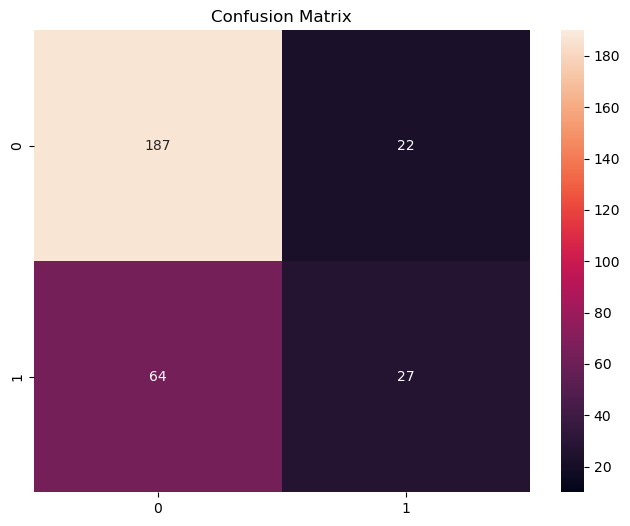

In [95]:
confusion_hard = confusion_matrix(y_test, y_prob_lgbm[:,1].round())
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, vmin=10, vmax=190,annot = True, fmt='d')
ax.set_title('Confusion Matrix')

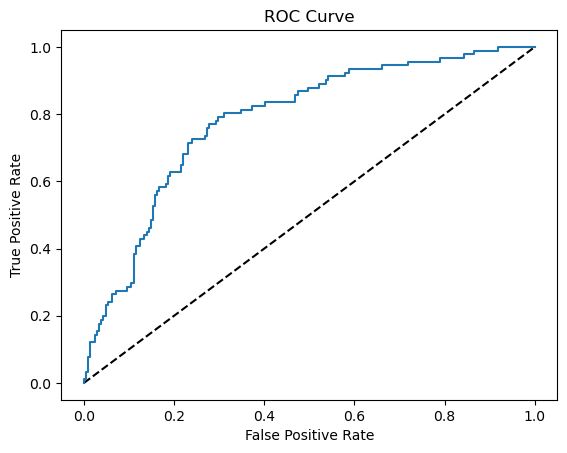

In [53]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_prob_lgbm[:,1])

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [54]:
optuna.visualization.plot_param_importances(study_lgbm)

In [55]:
rf_model, study_rf = train(X_train, y_train, X_test, y_test, balanced='balanced', method='RF')

[I 2023-09-25 08:32:34,955] A new study created in memory with name: RF Classifier


Tuning
Starting the optimization
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:35,237] Trial 0 finished with value: 0.7599768652400232 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 24, 'n_estimators': 231}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7599768652400232
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:36,115] Trial 1 finished with value: 0.7550344392449656 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 63, 'min_samples_split': 27, 'n_estimators': 1132}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7550344392449656
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:36,384] Trial 2 finished with value: 0.756716967243283 and parameters: {'max_features': 7, 'min_samples_leaf': 9, 'max_depth': 30, 'min_samples_split': 28, 'n_estimators': 199}. Best is trial 0 with value: 0.7599768652400232.


auc:0.756716967243283
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:36,620] Trial 3 finished with value: 0.7374204742625795 and parameters: {'max_features': 18, 'min_samples_leaf': 8, 'max_depth': 35, 'min_samples_split': 9, 'n_estimators': 114}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7374204742625795
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:38,208] Trial 4 finished with value: 0.7464114832535885 and parameters: {'max_features': 8, 'min_samples_leaf': 3, 'max_depth': 15, 'min_samples_split': 9, 'n_estimators': 1832}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7464114832535885
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:40,245] Trial 5 finished with value: 0.7411010042588989 and parameters: {'max_features': 19, 'min_samples_leaf': 11, 'max_depth': 60, 'min_samples_split': 13, 'n_estimators': 1977}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7411010042588989
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:41,021] Trial 6 finished with value: 0.7424154792575846 and parameters: {'max_features': 17, 'min_samples_leaf': 10, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 716}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7424154792575846
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:41,358] Trial 7 finished with value: 0.7554024922445977 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 30, 'min_samples_split': 28, 'n_estimators': 372}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7554024922445977
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:42,138] Trial 8 finished with value: 0.7502497502497502 and parameters: {'max_features': 11, 'min_samples_leaf': 4, 'max_depth': 14, 'min_samples_split': 6, 'n_estimators': 752}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7502497502497502
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:43,589] Trial 9 finished with value: 0.74372995425627 and parameters: {'max_features': 12, 'min_samples_leaf': 2, 'max_depth': 24, 'min_samples_split': 25, 'n_estimators': 1539}. Best is trial 0 with value: 0.7599768652400232.


auc:0.74372995425627
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:44,389] Trial 10 finished with value: 0.7512487512487512 and parameters: {'max_features': 4, 'min_samples_leaf': 19, 'max_depth': 45, 'min_samples_split': 21, 'n_estimators': 1171}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7512487512487512
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:44,643] Trial 11 finished with value: 0.7568221252431779 and parameters: {'max_features': 10, 'min_samples_leaf': 16, 'max_depth': 42, 'min_samples_split': 21, 'n_estimators': 186}. Best is trial 0 with value: 0.7599768652400232.


auc:0.7568221252431779
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:45,139] Trial 12 finished with value: 0.7613964982386036 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 47, 'min_samples_split': 20, 'n_estimators': 529}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7613964982386036
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:45,636] Trial 13 finished with value: 0.7544560702455438 and parameters: {'max_features': 14, 'min_samples_leaf': 23, 'max_depth': 52, 'min_samples_split': 21, 'n_estimators': 499}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7544560702455438
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:46,291] Trial 14 finished with value: 0.7530364372469636 and parameters: {'max_features': 14, 'min_samples_leaf': 21, 'max_depth': 44, 'min_samples_split': 17, 'n_estimators': 701}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7530364372469636
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:46,816] Trial 15 finished with value: 0.7544560702455441 and parameters: {'max_features': 10, 'min_samples_leaf': 14, 'max_depth': 23, 'min_samples_split': 24, 'n_estimators': 520}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7544560702455441
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:47,416] Trial 16 finished with value: 0.7519848572480152 and parameters: {'max_features': 4, 'min_samples_leaf': 20, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 850}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7519848572480152
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:47,819] Trial 17 finished with value: 0.7572427572427572 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 52, 'min_samples_split': 18, 'n_estimators': 366}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7572427572427572
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:48,681] Trial 18 finished with value: 0.7553499132446502 and parameters: {'max_features': 14, 'min_samples_leaf': 23, 'max_depth': 37, 'min_samples_split': 30, 'n_estimators': 982}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7553499132446502
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:49,713] Trial 19 finished with value: 0.7548767022451233 and parameters: {'max_features': 9, 'min_samples_leaf': 13, 'max_depth': 52, 'min_samples_split': 13, 'n_estimators': 1279}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7548767022451233
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:50,238] Trial 20 finished with value: 0.7574530732425468 and parameters: {'max_features': 12, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 24, 'n_estimators': 542}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7574530732425468
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:50,755] Trial 21 finished with value: 0.7575056522424943 and parameters: {'max_features': 12, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 24, 'n_estimators': 510}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7575056522424943
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:51,188] Trial 22 finished with value: 0.7544034912455965 and parameters: {'max_features': 16, 'min_samples_leaf': 22, 'max_depth': 29, 'min_samples_split': 20, 'n_estimators': 355}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7544034912455965
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:52,052] Trial 23 finished with value: 0.7542983332457017 and parameters: {'max_features': 13, 'min_samples_leaf': 14, 'max_depth': 19, 'min_samples_split': 24, 'n_estimators': 899}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7542983332457017
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:52,655] Trial 24 finished with value: 0.7575582312424418 and parameters: {'max_features': 10, 'min_samples_leaf': 25, 'max_depth': 39, 'min_samples_split': 26, 'n_estimators': 627}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7575582312424418
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:52,968] Trial 25 finished with value: 0.7586623902413376 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 40, 'min_samples_split': 30, 'n_estimators': 294}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7586623902413376
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:53,281] Trial 26 finished with value: 0.7550344392449654 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 48, 'min_samples_split': 30, 'n_estimators': 292}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7550344392449654
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:53,564] Trial 27 finished with value: 0.7559282822440716 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 32, 'min_samples_split': 19, 'n_estimators': 255}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7559282822440716
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:53,977] Trial 28 finished with value: 0.7606078132393923 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 56, 'min_samples_split': 14, 'n_estimators': 432}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7606078132393923
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:54,862] Trial 29 finished with value: 0.7568221252431779 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 64, 'min_samples_split': 15, 'n_estimators': 1088}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7568221252431779
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:55,077] Trial 30 finished with value: 0.7525106472474894 and parameters: {'max_features': 9, 'min_samples_leaf': 15, 'max_depth': 57, 'min_samples_split': 12, 'n_estimators': 109}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7525106472474894
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:55,490] Trial 31 finished with value: 0.7592933382407067 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 57, 'min_samples_split': 22, 'n_estimators': 409}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7592933382407067
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:55,921] Trial 32 finished with value: 0.7558757032441242 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 57, 'min_samples_split': 22, 'n_estimators': 441}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7558757032441242
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:56,466] Trial 33 finished with value: 0.7607655502392344 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 59, 'min_samples_split': 15, 'n_estimators': 608}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7607655502392344
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:57,191] Trial 34 finished with value: 0.7586098112413902 and parameters: {'max_features': 9, 'min_samples_leaf': 12, 'max_depth': 48, 'min_samples_split': 14, 'n_estimators': 819}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7586098112413902
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:57,687] Trial 35 finished with value: 0.7565592302434407 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 59, 'min_samples_split': 9, 'n_estimators': 619}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7565592302434407
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:57,923] Trial 36 finished with value: 0.7583994952416007 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 62, 'min_samples_split': 17, 'n_estimators': 165}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7583994952416007
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:58,551] Trial 37 finished with value: 0.7556128082443871 and parameters: {'max_features': 7, 'min_samples_leaf': 7, 'max_depth': 53, 'min_samples_split': 10, 'n_estimators': 623}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7556128082443871
RandomForest - Optimization using optuna


[I 2023-09-25 08:32:59,935] Trial 38 finished with value: 0.7572953362427046 and parameters: {'max_features': 11, 'min_samples_leaf': 17, 'max_depth': 48, 'min_samples_split': 11, 'n_estimators': 1574}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7572953362427046
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:00,214] Trial 39 finished with value: 0.7568747042431253 and parameters: {'max_features': 5, 'min_samples_leaf': 15, 'max_depth': 55, 'min_samples_split': 15, 'n_estimators': 224}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7568747042431253
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:00,887] Trial 40 finished with value: 0.75697986224302 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 61, 'min_samples_split': 7, 'n_estimators': 767}. Best is trial 12 with value: 0.7613964982386036.


auc:0.75697986224302
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:01,310] Trial 41 finished with value: 0.758714969241285 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 57, 'min_samples_split': 19, 'n_estimators': 416}. Best is trial 12 with value: 0.7613964982386036.


auc:0.758714969241285
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:01,769] Trial 42 finished with value: 0.7595562332404439 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 64, 'min_samples_split': 16, 'n_estimators': 436}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7595562332404439
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:02,315] Trial 43 finished with value: 0.758714969241285 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 63, 'min_samples_split': 16, 'n_estimators': 582}. Best is trial 12 with value: 0.7613964982386036.


auc:0.758714969241285
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:02,965] Trial 44 finished with value: 0.7569272832430727 and parameters: {'max_features': 11, 'min_samples_leaf': 20, 'max_depth': 60, 'min_samples_split': 14, 'n_estimators': 670}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7569272832430727
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:03,295] Trial 45 finished with value: 0.7611861822388138 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 319}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7611861822388138
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:03,639] Trial 46 finished with value: 0.758452074241548 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 334}. Best is trial 12 with value: 0.7613964982386036.
[I 2023-09-25 08:33:03,838] Trial 47 finished with value: 0.7510384352489616 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 22, 'n_estimators': 107}. Best is trial 12 with value: 0.7613964982386036.


auc:0.758452074241548
RandomForest - Optimization using optuna
auc:0.7510384352489616


[I 2023-09-25 08:33:04,145] Trial 48 finished with value: 0.7540354382459645 and parameters: {'max_features': 10, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 27, 'n_estimators': 248}. Best is trial 12 with value: 0.7613964982386036.


RandomForest - Optimization using optuna
auc:0.7540354382459645
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:04,546] Trial 49 finished with value: 0.75371996424628 and parameters: {'max_features': 4, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 462}. Best is trial 12 with value: 0.7613964982386036.


auc:0.75371996424628
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:05,808] Trial 50 finished with value: 0.7472527472527473 and parameters: {'max_features': 20, 'min_samples_leaf': 18, 'max_depth': 36, 'min_samples_split': 17, 'n_estimators': 1237}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7472527472527473
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:06,077] Trial 51 finished with value: 0.7568221252431779 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 64, 'min_samples_split': 15, 'n_estimators': 186}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7568221252431779
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:06,533] Trial 52 finished with value: 0.7582943372417057 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 11, 'min_samples_split': 13, 'n_estimators': 497}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7582943372417057
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:06,932] Trial 53 finished with value: 0.7607129712392869 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 50, 'min_samples_split': 16, 'n_estimators': 350}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7607129712392869
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:07,312] Trial 54 finished with value: 0.7578211262421788 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 45, 'min_samples_split': 20, 'n_estimators': 350}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7578211262421788
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:07,831] Trial 55 finished with value: 0.7587675482412325 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 50, 'min_samples_split': 18, 'n_estimators': 568}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7587675482412325
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:08,616] Trial 56 finished with value: 0.7609232872390768 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 43, 'min_samples_split': 23, 'n_estimators': 1001}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7609232872390768
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:09,384] Trial 57 finished with value: 0.7602923392397076 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 43, 'min_samples_split': 12, 'n_estimators': 914}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7602923392397076
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:10,622] Trial 58 finished with value: 0.7575582312424418 and parameters: {'max_features': 11, 'min_samples_leaf': 15, 'max_depth': 46, 'min_samples_split': 20, 'n_estimators': 1447}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7575582312424418
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:11,255] Trial 59 finished with value: 0.7531415952468584 and parameters: {'max_features': 4, 'min_samples_leaf': 17, 'max_depth': 41, 'min_samples_split': 23, 'n_estimators': 814}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7531415952468584
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:11,858] Trial 60 finished with value: 0.7596613912403387 and parameters: {'max_features': 6, 'min_samples_leaf': 13, 'max_depth': 38, 'min_samples_split': 14, 'n_estimators': 715}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7596613912403387
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:12,721] Trial 61 finished with value: 0.7605552342394447 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 42, 'min_samples_split': 12, 'n_estimators': 1028}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7605552342394447
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:13,526] Trial 62 finished with value: 0.7580314422419685 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 54, 'min_samples_split': 12, 'n_estimators': 998}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7580314422419685
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:14,381] Trial 63 finished with value: 0.7595562332404439 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 51, 'min_samples_split': 16, 'n_estimators': 1210}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7595562332404439
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:15,356] Trial 64 finished with value: 0.7592407592407592 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 50, 'min_samples_split': 11, 'n_estimators': 1335}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7592407592407592
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:16,334] Trial 65 finished with value: 0.758189179241811 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 33, 'min_samples_split': 17, 'n_estimators': 1143}. Best is trial 12 with value: 0.7613964982386036.


auc:0.758189179241811
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:17,246] Trial 66 finished with value: 0.757453073242547 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 47, 'min_samples_split': 13, 'n_estimators': 1047}. Best is trial 12 with value: 0.7613964982386036.


auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:18,583] Trial 67 finished with value: 0.7592933382407068 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 43, 'min_samples_split': 21, 'n_estimators': 1692}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7592933382407068
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:19,506] Trial 68 finished with value: 0.7565592302434409 and parameters: {'max_features': 13, 'min_samples_leaf': 16, 'max_depth': 55, 'min_samples_split': 8, 'n_estimators': 961}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7565592302434409
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:20,044] Trial 69 finished with value: 0.7566118092433881 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 41, 'min_samples_split': 2, 'n_estimators': 670}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7566118092433881
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:20,395] Trial 70 finished with value: 0.7554550712445449 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 25, 'n_estimators': 301}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7554550712445449
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:21,120] Trial 71 finished with value: 0.7566118092433882 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 43, 'min_samples_split': 12, 'n_estimators': 918}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7566118092433882
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:21,905] Trial 72 finished with value: 0.7591881802408119 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 45, 'min_samples_split': 10, 'n_estimators': 1075}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7591881802408119
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:22,629] Trial 73 finished with value: 0.7610284452389716 and parameters: {'max_features': 6, 'min_samples_leaf': 11, 'max_depth': 39, 'min_samples_split': 14, 'n_estimators': 908}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7610284452389716
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:23,263] Trial 74 finished with value: 0.7570324412429675 and parameters: {'max_features': 7, 'min_samples_leaf': 10, 'max_depth': 38, 'min_samples_split': 15, 'n_estimators': 761}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7570324412429675
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:23,935] Trial 75 finished with value: 0.7593984962406015 and parameters: {'max_features': 5, 'min_samples_leaf': 8, 'max_depth': 50, 'min_samples_split': 14, 'n_estimators': 847}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7593984962406015
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:24,430] Trial 76 finished with value: 0.7563489142436511 and parameters: {'max_features': 8, 'min_samples_leaf': 11, 'max_depth': 40, 'min_samples_split': 18, 'n_estimators': 487}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7563489142436511
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:25,288] Trial 77 finished with value: 0.7585572322414428 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 1013}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:26,814] Trial 78 finished with value: 0.757453073242547 and parameters: {'max_features': 7, 'min_samples_leaf': 13, 'max_depth': 36, 'min_samples_split': 15, 'n_estimators': 1997}. Best is trial 12 with value: 0.7613964982386036.


auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:27,208] Trial 79 finished with value: 0.7576108102423891 and parameters: {'max_features': 8, 'min_samples_leaf': 12, 'max_depth': 49, 'min_samples_split': 23, 'n_estimators': 373}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7576108102423891
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:27,694] Trial 80 finished with value: 0.7464114832535884 and parameters: {'max_features': 4, 'min_samples_leaf': 5, 'max_depth': 59, 'min_samples_split': 11, 'n_estimators': 546}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7464114832535884
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:28,432] Trial 81 finished with value: 0.759713970240286 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 43, 'min_samples_split': 13, 'n_estimators': 870}. Best is trial 12 with value: 0.7613964982386036.


auc:0.759713970240286
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:29,272] Trial 82 finished with value: 0.7601871812398128 and parameters: {'max_features': 6, 'min_samples_leaf': 14, 'max_depth': 46, 'min_samples_split': 12, 'n_estimators': 946}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7601871812398128
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:29,983] Trial 83 finished with value: 0.7531415952468583 and parameters: {'max_features': 5, 'min_samples_leaf': 15, 'max_depth': 41, 'min_samples_split': 14, 'n_estimators': 792}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7531415952468583
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:30,394] Trial 84 finished with value: 0.7575056522424944 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 44, 'min_samples_split': 15, 'n_estimators': 390}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7575056522424944
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:31,258] Trial 85 finished with value: 0.7582417582417583 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 53, 'min_samples_split': 10, 'n_estimators': 1159}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7582417582417583
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:31,952] Trial 86 finished with value: 0.757347915242652 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 39, 'min_samples_split': 20, 'n_estimators': 885}. Best is trial 12 with value: 0.7613964982386036.


auc:0.757347915242652
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:33,021] Trial 87 finished with value: 0.7523003312476998 and parameters: {'max_features': 17, 'min_samples_leaf': 20, 'max_depth': 47, 'min_samples_split': 16, 'n_estimators': 1098}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7523003312476998
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:33,393] Trial 88 finished with value: 0.754718965245281 and parameters: {'max_features': 9, 'min_samples_leaf': 12, 'max_depth': 56, 'min_samples_split': 19, 'n_estimators': 305}. Best is trial 12 with value: 0.7613964982386036.


auc:0.754718965245281
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:33,986] Trial 89 finished with value: 0.7599242862400757 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 52, 'min_samples_split': 13, 'n_estimators': 675}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7599242862400757
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:34,769] Trial 90 finished with value: 0.7612387612387612 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 1035}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7612387612387612
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:35,578] Trial 91 finished with value: 0.7585046532414953 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 4, 'n_estimators': 1030}. Best is trial 12 with value: 0.7613964982386036.


auc:0.7585046532414953
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:36,310] Trial 92 finished with value: 0.7619748672380251 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 952}. Best is trial 92 with value: 0.7619748672380251.


auc:0.7619748672380251
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:37,233] Trial 93 finished with value: 0.7591881802408118 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 18, 'n_estimators': 1308}. Best is trial 92 with value: 0.7619748672380251.


auc:0.7591881802408118
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:38,114] Trial 94 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 1198}. Best is trial 92 with value: 0.7619748672380251.


auc:0.7591881802408118
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:38,976] Trial 95 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 1110}. Best is trial 92 with value: 0.7619748672380251.


auc:0.7602397602397603
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:39,489] Trial 96 finished with value: 0.7612913402387087 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 9, 'min_samples_split': 19, 'n_estimators': 604}. Best is trial 92 with value: 0.7619748672380251.


auc:0.7612913402387087
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:40,002] Trial 97 finished with value: 0.7574004942425995 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 7, 'min_samples_split': 19, 'n_estimators': 602}. Best is trial 92 with value: 0.7619748672380251.


auc:0.7574004942425995
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:40,459] Trial 98 finished with value: 0.7599242862400757 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 9, 'min_samples_split': 21, 'n_estimators': 450}. Best is trial 92 with value: 0.7619748672380251.


auc:0.7599242862400757
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:40,942] Trial 99 finished with value: 0.7597665492402336 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 526}. Best is trial 92 with value: 0.7619748672380251.


auc:0.7597665492402336
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:41,214] Trial 100 finished with value: 0.7628161312371838 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 27, 'min_samples_split': 20, 'n_estimators': 236}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7628161312371838
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:41,499] Trial 101 finished with value: 0.7587675482412325 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 5, 'min_samples_split': 21, 'n_estimators': 220}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7587675482412325
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:41,715] Trial 102 finished with value: 0.7614490772385509 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 154}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7614490772385509
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:41,954] Trial 103 finished with value: 0.7511961722488039 and parameters: {'max_features': 4, 'min_samples_leaf': 25, 'max_depth': 16, 'min_samples_split': 22, 'n_estimators': 182}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7511961722488039
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:42,182] Trial 104 finished with value: 0.743361901256638 and parameters: {'max_features': 4, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 141}. Best is trial 100 with value: 0.7628161312371838.


auc:0.743361901256638
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:42,401] Trial 105 finished with value: 0.7539302802460697 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 139}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7539302802460697
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:42,698] Trial 106 finished with value: 0.7479362742520638 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 275}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7479362742520638
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:43,005] Trial 107 finished with value: 0.7575582312424418 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 11, 'min_samples_split': 23, 'n_estimators': 238}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7575582312424418
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:43,332] Trial 108 finished with value: 0.7559282822440717 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 334}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7559282822440717
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:44,120] Trial 109 finished with value: 0.757453073242547 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 988}. Best is trial 100 with value: 0.7628161312371838.


auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:44,796] Trial 110 finished with value: 0.7551395972448603 and parameters: {'max_features': 11, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 22, 'n_estimators': 715}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7551395972448603
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:45,236] Trial 111 finished with value: 0.7593984962406015 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 407}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7593984962406015
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:45,667] Trial 112 finished with value: 0.7586623902413376 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 463}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7586623902413376
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:47,103] Trial 113 finished with value: 0.7585572322414428 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 59, 'min_samples_split': 17, 'n_estimators': 1915}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:47,473] Trial 114 finished with value: 0.7604500762395499 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 8, 'min_samples_split': 21, 'n_estimators': 328}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7604500762395499
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:47,993] Trial 115 finished with value: 0.7537199642462801 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 650}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7537199642462801
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:48,549] Trial 116 finished with value: 0.7618697092381304 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 587}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7618697092381304
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:49,358] Trial 117 finished with value: 0.757453073242547 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 936}. Best is trial 100 with value: 0.7628161312371838.


auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:49,638] Trial 118 finished with value: 0.7625532362374469 and parameters: {'max_features': 12, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 200}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7625532362374469
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:49,941] Trial 119 finished with value: 0.7517745412482255 and parameters: {'max_features': 15, 'min_samples_leaf': 25, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 201}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7517745412482255
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:50,513] Trial 120 finished with value: 0.7562437562437563 and parameters: {'max_features': 13, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 563}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7562437562437563
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:50,837] Trial 121 finished with value: 0.7528261212471739 and parameters: {'max_features': 12, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 273}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7528261212471739
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:51,054] Trial 122 finished with value: 0.7627635522372365 and parameters: {'max_features': 12, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 124}. Best is trial 100 with value: 0.7628161312371838.
[I 2023-09-25 08:33:51,248] Trial 123 finished with value: 0.7552447552447552 and parameters: {'max_features': 11, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7627635522372365
RandomForest - Optimization using optuna
auc:0.7552447552447552


[I 2023-09-25 08:33:51,510] Trial 124 finished with value: 0.7532467532467533 and parameters: {'max_features': 12, 'min_samples_leaf': 25, 'max_depth': 24, 'min_samples_split': 21, 'n_estimators': 163}. Best is trial 100 with value: 0.7628161312371838.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:33:51,756] Trial 125 finished with value: 0.7553499132446502 and parameters: {'max_features': 14, 'min_samples_leaf': 23, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 151}. Best is trial 100 with value: 0.7628161312371838.


RandomForest - Optimization using optuna
auc:0.7553499132446502


[I 2023-09-25 08:33:52,041] Trial 126 finished with value: 0.7546138072453862 and parameters: {'max_features': 13, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 210}. Best is trial 100 with value: 0.7628161312371838.


RandomForest - Optimization using optuna
auc:0.7546138072453862
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:52,378] Trial 127 finished with value: 0.7571901782428098 and parameters: {'max_features': 12, 'min_samples_leaf': 10, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 250}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7571901782428098
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:52,926] Trial 128 finished with value: 0.7571901782428099 and parameters: {'max_features': 11, 'min_samples_leaf': 24, 'max_depth': 24, 'min_samples_split': 25, 'n_estimators': 599}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7571901782428099
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:53,717] Trial 129 finished with value: 0.7525106472474894 and parameters: {'max_features': 14, 'min_samples_leaf': 24, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 850}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7525106472474894
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:54,312] Trial 130 finished with value: 0.7571375992428624 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 759}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7571375992428624
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:54,673] Trial 131 finished with value: 0.7592933382407068 and parameters: {'max_features': 10, 'min_samples_leaf': 23, 'max_depth': 32, 'min_samples_split': 16, 'n_estimators': 308}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7592933382407068
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:55,580] Trial 132 finished with value: 0.7559282822440717 and parameters: {'max_features': 12, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 1053}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7559282822440717
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:55,952] Trial 133 finished with value: 0.7554550712445449 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 364}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7554550712445449
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:56,227] Trial 134 finished with value: 0.7532993322467005 and parameters: {'max_features': 13, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 179}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7532993322467005
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:56,712] Trial 135 finished with value: 0.7566643882433356 and parameters: {'max_features': 11, 'min_samples_leaf': 25, 'max_depth': 30, 'min_samples_split': 19, 'n_estimators': 490}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7566643882433356
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:57,345] Trial 136 finished with value: 0.7564014932435985 and parameters: {'max_features': 10, 'min_samples_leaf': 8, 'max_depth': 35, 'min_samples_split': 26, 'n_estimators': 640}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7564014932435985
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:58,088] Trial 137 finished with value: 0.7589778642410221 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 20, 'n_estimators': 977}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7589778642410221
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:58,306] Trial 138 finished with value: 0.7581366002418635 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 10, 'min_samples_split': 17, 'n_estimators': 125}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7581366002418635
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:58,638] Trial 139 finished with value: 0.7605026552394972 and parameters: {'max_features': 6, 'min_samples_leaf': 11, 'max_depth': 13, 'min_samples_split': 22, 'n_estimators': 245}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7605026552394972
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:58,927] Trial 140 finished with value: 0.7608707082391294 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 205}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7608707082391294
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:59,201] Trial 141 finished with value: 0.7578737052421263 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 209}. Best is trial 100 with value: 0.7628161312371838.


auc:0.7578737052421263
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:59,512] Trial 142 finished with value: 0.763341921236658 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 273}. Best is trial 142 with value: 0.763341921236658.


auc:0.763341921236658
RandomForest - Optimization using optuna


[I 2023-09-25 08:33:59,824] Trial 143 finished with value: 0.7525632262474369 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 261}. Best is trial 142 with value: 0.763341921236658.


auc:0.7525632262474369
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:00,079] Trial 144 finished with value: 0.7538251222461748 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 173}. Best is trial 142 with value: 0.763341921236658.


auc:0.7538251222461748
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:00,398] Trial 145 finished with value: 0.7533519112466481 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 290}. Best is trial 142 with value: 0.763341921236658.


auc:0.7533519112466481
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:00,625] Trial 146 finished with value: 0.7588727062411273 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 21, 'n_estimators': 147}. Best is trial 142 with value: 0.763341921236658.


auc:0.7588727062411273
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:00,911] Trial 147 finished with value: 0.7544034912455966 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 23, 'n_estimators': 218}. Best is trial 142 with value: 0.763341921236658.


auc:0.7544034912455966
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:01,360] Trial 148 finished with value: 0.7578211262421788 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 524}. Best is trial 142 with value: 0.763341921236658.


auc:0.7578211262421788
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:01,914] Trial 149 finished with value: 0.7570850202429149 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 691}. Best is trial 142 with value: 0.763341921236658.


auc:0.7570850202429149
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:02,138] Trial 150 finished with value: 0.7555076502444924 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 112}. Best is trial 142 with value: 0.763341921236658.


auc:0.7555076502444924
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:02,550] Trial 151 finished with value: 0.7578211262421788 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 402}. Best is trial 142 with value: 0.763341921236658.


auc:0.7578211262421788
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:02,866] Trial 152 finished with value: 0.7487775382512224 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 273}. Best is trial 142 with value: 0.763341921236658.


auc:0.7487775382512224
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:03,247] Trial 153 finished with value: 0.7628687102371313 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 14, 'n_estimators': 325}. Best is trial 142 with value: 0.763341921236658.


auc:0.7628687102371313
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:03,498] Trial 154 finished with value: 0.7583469162416531 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 200}. Best is trial 142 with value: 0.763341921236658.


auc:0.7583469162416531
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:03,870] Trial 155 finished with value: 0.7590830222409168 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 325}. Best is trial 142 with value: 0.763341921236658.


auc:0.7590830222409168
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:04,728] Trial 156 finished with value: 0.7567695462432305 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 1124}. Best is trial 142 with value: 0.763341921236658.


auc:0.7567695462432305
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:05,363] Trial 157 finished with value: 0.7498291182501708 and parameters: {'max_features': 4, 'min_samples_leaf': 25, 'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 904}. Best is trial 142 with value: 0.763341921236658.


auc:0.7498291182501708
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:05,657] Trial 158 finished with value: 0.7587675482412325 and parameters: {'max_features': 11, 'min_samples_leaf': 22, 'max_depth': 38, 'min_samples_split': 17, 'n_estimators': 235}. Best is trial 142 with value: 0.763341921236658.


auc:0.7587675482412325
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:06,011] Trial 159 finished with value: 0.7573479152426522 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 28, 'n_estimators': 364}. Best is trial 142 with value: 0.763341921236658.


auc:0.7573479152426522
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:06,253] Trial 160 finished with value: 0.762710973237289 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 21, 'n_estimators': 174}. Best is trial 142 with value: 0.763341921236658.


auc:0.762710973237289
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:06,480] Trial 161 finished with value: 0.7518796992481203 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 21, 'n_estimators': 158}. Best is trial 142 with value: 0.763341921236658.


auc:0.7518796992481203
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:07,231] Trial 162 finished with value: 0.7557705452442294 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 20, 'n_estimators': 1065}. Best is trial 142 with value: 0.763341921236658.


auc:0.7557705452442294
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:07,998] Trial 163 finished with value: 0.7592407592407593 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 1007}. Best is trial 142 with value: 0.763341921236658.


auc:0.7592407592407593
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:08,208] Trial 164 finished with value: 0.757715968242284 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 21, 'n_estimators': 103}. Best is trial 142 with value: 0.763341921236658.


auc:0.757715968242284
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:08,456] Trial 165 finished with value: 0.7527209632472791 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 22, 'n_estimators': 189}. Best is trial 142 with value: 0.763341921236658.


auc:0.7527209632472791
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:08,959] Trial 166 finished with value: 0.7599242862400758 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 586}. Best is trial 142 with value: 0.763341921236658.


auc:0.7599242862400758
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:09,702] Trial 167 finished with value: 0.7493033282506967 and parameters: {'max_features': 4, 'min_samples_leaf': 2, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 944}. Best is trial 142 with value: 0.763341921236658.


auc:0.7493033282506967
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:10,026] Trial 168 finished with value: 0.7613964982386034 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 24, 'n_estimators': 301}. Best is trial 142 with value: 0.763341921236658.


auc:0.7613964982386034
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:10,339] Trial 169 finished with value: 0.756348914243651 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 24, 'n_estimators': 303}. Best is trial 142 with value: 0.763341921236658.


auc:0.756348914243651
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:10,633] Trial 170 finished with value: 0.7609758662390242 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 28, 'min_samples_split': 25, 'n_estimators': 251}. Best is trial 142 with value: 0.763341921236658.


auc:0.7609758662390242
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:10,909] Trial 171 finished with value: 0.7568221252431778 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 28, 'min_samples_split': 25, 'n_estimators': 249}. Best is trial 142 with value: 0.763341921236658.


auc:0.7568221252431778
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:11,212] Trial 172 finished with value: 0.7520374362479627 and parameters: {'max_features': 4, 'min_samples_leaf': 24, 'max_depth': 31, 'min_samples_split': 24, 'n_estimators': 285}. Best is trial 142 with value: 0.763341921236658.


auc:0.7520374362479627
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:11,502] Trial 173 finished with value: 0.7572953362427047 and parameters: {'max_features': 5, 'min_samples_leaf': 9, 'max_depth': 27, 'min_samples_split': 26, 'n_estimators': 233}. Best is trial 142 with value: 0.763341921236658.


auc:0.7572953362427047
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:11,843] Trial 174 finished with value: 0.7580840212419159 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 28, 'min_samples_split': 27, 'n_estimators': 337}. Best is trial 142 with value: 0.763341921236658.


auc:0.7580840212419159
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:12,099] Trial 175 finished with value: 0.7580314422419686 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 23, 'n_estimators': 178}. Best is trial 142 with value: 0.763341921236658.


auc:0.7580314422419686
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:12,332] Trial 176 finished with value: 0.7606078132393922 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 24, 'n_estimators': 144}. Best is trial 142 with value: 0.763341921236658.


auc:0.7606078132393922
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:12,781] Trial 177 finished with value: 0.7576633892423366 and parameters: {'max_features': 12, 'min_samples_leaf': 25, 'max_depth': 30, 'min_samples_split': 25, 'n_estimators': 428}. Best is trial 142 with value: 0.763341921236658.


auc:0.7576633892423366
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:13,081] Trial 178 finished with value: 0.7638677112361323 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 34, 'min_samples_split': 23, 'n_estimators': 217}. Best is trial 178 with value: 0.7638677112361323.


auc:0.7638677112361323
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:13,400] Trial 179 finished with value: 0.7476208002523792 and parameters: {'max_features': 4, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 23, 'n_estimators': 281}. Best is trial 178 with value: 0.7638677112361323.


auc:0.7476208002523792
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:13,775] Trial 180 finished with value: 0.7583994952416006 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 34, 'min_samples_split': 21, 'n_estimators': 358}. Best is trial 178 with value: 0.7638677112361323.


auc:0.7583994952416006
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:14,033] Trial 181 finished with value: 0.7561911772438088 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 22, 'n_estimators': 198}. Best is trial 178 with value: 0.7638677112361323.


auc:0.7561911772438088
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:14,325] Trial 182 finished with value: 0.7534570692465429 and parameters: {'max_features': 5, 'min_samples_leaf': 15, 'max_depth': 36, 'min_samples_split': 19, 'n_estimators': 262}. Best is trial 178 with value: 0.7638677112361323.


auc:0.7534570692465429
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:14,607] Trial 183 finished with value: 0.7596088122403911 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 33, 'min_samples_split': 18, 'n_estimators': 223}. Best is trial 178 with value: 0.7638677112361323.


auc:0.7596088122403911
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:14,884] Trial 184 finished with value: 0.7432567432567432 and parameters: {'max_features': 19, 'min_samples_leaf': 16, 'max_depth': 40, 'min_samples_split': 24, 'n_estimators': 143}. Best is trial 178 with value: 0.7638677112361323.


auc:0.7432567432567432
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:15,227] Trial 185 finished with value: 0.7641306062358695 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 303}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7641306062358695
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:15,543] Trial 186 finished with value: 0.761711972238288 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 314}. Best is trial 185 with value: 0.7641306062358695.


auc:0.761711972238288
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:15,875] Trial 187 finished with value: 0.7605552342394447 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 328}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7605552342394447
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:16,198] Trial 188 finished with value: 0.7575056522424943 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 308}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7575056522424943
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:16,492] Trial 189 finished with value: 0.7507755402492245 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 259}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7507755402492245
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:16,887] Trial 190 finished with value: 0.7571375992428623 and parameters: {'max_features': 10, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 394}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7571375992428623
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:17,191] Trial 191 finished with value: 0.7576633892423366 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 26, 'n_estimators': 289}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7576633892423366
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:17,550] Trial 192 finished with value: 0.7567695462432305 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 21, 'n_estimators': 376}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7567695462432305
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:17,831] Trial 193 finished with value: 0.7548767022451234 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 22, 'n_estimators': 235}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7548767022451234
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:18,066] Trial 194 finished with value: 0.7519322782480679 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 44, 'min_samples_split': 20, 'n_estimators': 171}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7519322782480679
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:18,796] Trial 195 finished with value: 0.7583469162416531 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 23, 'n_estimators': 962}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7583469162416531
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:19,173] Trial 196 finished with value: 0.7572953362427047 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 25, 'n_estimators': 338}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7572953362427047
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:20,566] Trial 197 finished with value: 0.7448341132551658 and parameters: {'max_features': 13, 'min_samples_leaf': 5, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 1400}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7448341132551658
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:20,862] Trial 198 finished with value: 0.7601871812398129 and parameters: {'max_features': 12, 'min_samples_leaf': 20, 'max_depth': 46, 'min_samples_split': 19, 'n_estimators': 223}. Best is trial 185 with value: 0.7641306062358695.
[I 2023-09-25 08:34:21,049] Trial 199 finished with value: 0.7535096482464902 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 24, 'n_estimators': 100}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7601871812398129
RandomForest - Optimization using optuna
auc:0.7535096482464902
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:21,434] Trial 200 finished with value: 0.7545612282454389 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 42, 'min_samples_split': 21, 'n_estimators': 461}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7545612282454389
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:21,684] Trial 201 finished with value: 0.7609758662390241 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 195}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7609758662390241
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:21,923] Trial 202 finished with value: 0.7525632262474368 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 179}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7525632262474368
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:22,236] Trial 203 finished with value: 0.7557705452442295 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 274}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7557705452442295
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:22,550] Trial 204 finished with value: 0.7580314422419686 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 314}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7580314422419686
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:22,769] Trial 205 finished with value: 0.7585572322414427 and parameters: {'max_features': 6, 'min_samples_leaf': 11, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7585572322414427
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:23,017] Trial 206 finished with value: 0.753457069246543 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 203}. Best is trial 185 with value: 0.7641306062358695.


auc:0.753457069246543
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:23,312] Trial 207 finished with value: 0.7560334402439667 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 257}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7560334402439667
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:24,000] Trial 208 finished with value: 0.7586623902413376 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 805}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7586623902413376
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:24,858] Trial 209 finished with value: 0.7592933382407068 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 1021}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7592933382407068
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:25,648] Trial 210 finished with value: 0.7561911772438087 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 37, 'min_samples_split': 19, 'n_estimators': 1076}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7561911772438087
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:25,903] Trial 211 finished with value: 0.7530364372469637 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 204}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7530364372469637
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:26,150] Trial 212 finished with value: 0.7501971712498028 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 147}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7501971712498028
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:26,439] Trial 213 finished with value: 0.7637625532362374 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 227}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7637625532362374
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:26,724] Trial 214 finished with value: 0.7572427572427574 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 29, 'min_samples_split': 19, 'n_estimators': 231}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7572427572427574
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:27,042] Trial 215 finished with value: 0.7518271202481728 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 284}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7518271202481728
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:27,385] Trial 216 finished with value: 0.7549292812450707 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 311}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7549292812450707
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:27,633] Trial 217 finished with value: 0.7581366002418634 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 7, 'min_samples_split': 20, 'n_estimators': 175}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7581366002418634
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:28,354] Trial 218 finished with value: 0.7539828592460172 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 981}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7539828592460172
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:28,658] Trial 219 finished with value: 0.7639728692360271 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 247}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7639728692360271
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:28,963] Trial 220 finished with value: 0.7528787002471213 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 237}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7528787002471213
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:29,303] Trial 221 finished with value: 0.7631316052368684 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 263}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7631316052368684
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:29,620] Trial 222 finished with value: 0.7554024922445975 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 255}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7554024922445975
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:29,957] Trial 223 finished with value: 0.7548241232451758 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 290}. Best is trial 185 with value: 0.7641306062358695.


auc:0.7548241232451758
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:30,243] Trial 224 finished with value: 0.7641831852358169 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 21, 'n_estimators': 194}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7641831852358169
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:30,625] Trial 225 finished with value: 0.7637625532362374 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 21, 'n_estimators': 344}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7637625532362374
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:31,058] Trial 226 finished with value: 0.7525106472474894 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 21, 'n_estimators': 376}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7525106472474894
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:31,420] Trial 227 finished with value: 0.7574004942425995 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 320}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7574004942425995
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:31,830] Trial 228 finished with value: 0.7593459172406541 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 21, 'n_estimators': 342}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7593459172406541
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:32,447] Trial 229 finished with value: 0.7548767022451234 and parameters: {'max_features': 15, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 22, 'n_estimators': 563}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7548767022451234
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:32,855] Trial 230 finished with value: 0.7613439192386561 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 22, 'n_estimators': 391}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7613439192386561
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:33,265] Trial 231 finished with value: 0.7592933382407067 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 22, 'n_estimators': 413}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7592933382407067
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:33,658] Trial 232 finished with value: 0.7633945002366055 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 22, 'n_estimators': 371}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7633945002366055
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:34,066] Trial 233 finished with value: 0.7546138072453862 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 22, 'n_estimators': 371}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7546138072453862
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:34,494] Trial 234 finished with value: 0.7603974972396025 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 22, 'n_estimators': 431}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7603974972396025
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:34,870] Trial 235 finished with value: 0.7579788632420211 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 21, 'n_estimators': 354}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7579788632420211
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:35,205] Trial 236 finished with value: 0.7610810242389191 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 293}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7610810242389191
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:35,563] Trial 237 finished with value: 0.7570850202429149 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 330}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7570850202429149
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:36,023] Trial 238 finished with value: 0.7567695462432306 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 22, 'n_estimators': 484}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7567695462432306
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:36,420] Trial 239 finished with value: 0.759713970240286 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 391}. Best is trial 224 with value: 0.7641831852358169.


auc:0.759713970240286
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:36,710] Trial 240 finished with value: 0.763447079236553 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 23, 'n_estimators': 224}. Best is trial 224 with value: 0.7641831852358169.


auc:0.763447079236553
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:37,029] Trial 241 finished with value: 0.7548767022451234 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 23, 'n_estimators': 266}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7548767022451234
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:37,333] Trial 242 finished with value: 0.7592407592407592 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 23, 'n_estimators': 238}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7592407592407592
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:37,599] Trial 243 finished with value: 0.7613964982386034 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 21, 'n_estimators': 161}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7613964982386034
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:37,858] Trial 244 finished with value: 0.7622903412377097 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 21, 'n_estimators': 171}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7622903412377097
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:38,136] Trial 245 finished with value: 0.7583994952416006 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 11, 'min_samples_split': 21, 'n_estimators': 157}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7583994952416006
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:38,363] Trial 246 finished with value: 0.7637625532362374 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 22, 'n_estimators': 130}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7637625532362374
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:38,574] Trial 247 finished with value: 0.7529312792470687 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 22, 'n_estimators': 122}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7529312792470687
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:38,819] Trial 248 finished with value: 0.7531415952468583 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 23, 'n_estimators': 167}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7531415952468583
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:39,083] Trial 249 finished with value: 0.7508806982491193 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 22, 'n_estimators': 201}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7508806982491193
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:39,301] Trial 250 finished with value: 0.7511435932488563 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 21, 'n_estimators': 129}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7511435932488563
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:40,581] Trial 251 finished with value: 0.7587149692412851 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 22, 'n_estimators': 1675}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7587149692412851
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:40,861] Trial 252 finished with value: 0.7542983332457016 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 21, 'n_estimators': 179}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7542983332457016
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:41,142] Trial 253 finished with value: 0.7552447552447552 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 22, 'n_estimators': 214}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7552447552447552
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:41,373] Trial 254 finished with value: 0.7626058152373941 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 21, 'n_estimators': 140}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7626058152373941
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:41,588] Trial 255 finished with value: 0.7610810242389191 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 21, 'n_estimators': 115}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7610810242389191
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:41,840] Trial 256 finished with value: 0.753351911246648 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 20, 'n_estimators': 161}. Best is trial 224 with value: 0.7641831852358169.


auc:0.753351911246648
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:42,050] Trial 257 finished with value: 0.7626583942373416 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 100}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7626583942373416
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:42,261] Trial 258 finished with value: 0.7536148062463851 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 103}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7536148062463851
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:42,550] Trial 259 finished with value: 0.7591881802408117 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 23, 'n_estimators': 216}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7591881802408117
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:42,755] Trial 260 finished with value: 0.7548241232451759 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 102}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7548241232451759
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:42,989] Trial 261 finished with value: 0.7572953362427046 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 136}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7572953362427046
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:43,275] Trial 262 finished with value: 0.7546663862453337 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 21, 'n_estimators': 193}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7546663862453337
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:43,580] Trial 263 finished with value: 0.757453073242547 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 239}. Best is trial 224 with value: 0.7641831852358169.


auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:43,832] Trial 264 finished with value: 0.7634470792365529 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 142}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7634470792365529
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:44,083] Trial 265 finished with value: 0.7625532362374468 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 154}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7625532362374468
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:44,331] Trial 266 finished with value: 0.7622903412377098 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 144}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7622903412377098
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:44,612] Trial 267 finished with value: 0.7515642252484357 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 141}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7515642252484357
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:44,872] Trial 268 finished with value: 0.7606078132393922 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 12, 'min_samples_split': 20, 'n_estimators': 163}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7606078132393922
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:45,165] Trial 269 finished with value: 0.7574004942425996 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 21, 'n_estimators': 195}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7574004942425996
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:45,414] Trial 270 finished with value: 0.7545086492454913 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 132}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7545086492454913
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:45,700] Trial 271 finished with value: 0.7581366002418634 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 22, 'n_estimators': 178}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7581366002418634
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:45,980] Trial 272 finished with value: 0.7623954992376045 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 209}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7623954992376045
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:46,289] Trial 273 finished with value: 0.7625006572374993 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 218}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7625006572374993
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:46,590] Trial 274 finished with value: 0.7560860192439139 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 218}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7560860192439139
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:46,800] Trial 275 finished with value: 0.7559808612440192 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 105}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7559808612440192
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:47,074] Trial 276 finished with value: 0.7615016562384984 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 21, 'n_estimators': 191}. Best is trial 224 with value: 0.7641831852358169.


auc:0.7615016562384984
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:47,330] Trial 277 finished with value: 0.7683895052316105 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 153}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7683895052316105
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:47,591] Trial 278 finished with value: 0.764603817235396 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 150}. Best is trial 277 with value: 0.7683895052316105.


auc:0.764603817235396
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:47,871] Trial 279 finished with value: 0.756348914243651 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 136}. Best is trial 277 with value: 0.7683895052316105.


auc:0.756348914243651
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:48,110] Trial 280 finished with value: 0.7606603922393396 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 102}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7606603922393396
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:48,442] Trial 281 finished with value: 0.7594510752405488 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 225}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7594510752405488
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:48,685] Trial 282 finished with value: 0.7581366002418634 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 19, 'n_estimators': 143}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7581366002418634
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:48,998] Trial 283 finished with value: 0.7592407592407592 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 244}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7592407592407592
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:49,277] Trial 284 finished with value: 0.757715968242284 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 197}. Best is trial 277 with value: 0.7683895052316105.


auc:0.757715968242284
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:49,544] Trial 285 finished with value: 0.7592407592407592 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 172}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7592407592407592
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:49,895] Trial 286 finished with value: 0.7589778642410222 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 22, 'n_estimators': 270}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7589778642410222
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:50,176] Trial 287 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 11, 'min_samples_split': 23, 'n_estimators': 141}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:50,478] Trial 288 finished with value: 0.7567695462432305 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 5, 'n_estimators': 211}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7567695462432305
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:50,762] Trial 289 finished with value: 0.7612913402387087 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 155}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7612913402387087
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:50,992] Trial 290 finished with value: 0.7569272832430727 and parameters: {'max_features': 12, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 101}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7569272832430727
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:51,346] Trial 291 finished with value: 0.7586098112413902 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 21, 'n_estimators': 258}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7586098112413902
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:51,658] Trial 292 finished with value: 0.7564014932435985 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 222}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7564014932435985
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:51,946] Trial 293 finished with value: 0.7568747042431253 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 172}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7568747042431253
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:52,221] Trial 294 finished with value: 0.7605026552394973 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 22, 'n_estimators': 192}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7605026552394973
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:52,564] Trial 295 finished with value: 0.7576108102423892 and parameters: {'max_features': 12, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 258}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7576108102423892
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:52,817] Trial 296 finished with value: 0.7606078132393921 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 21, 'n_estimators': 142}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7606078132393921
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:53,126] Trial 297 finished with value: 0.7553499132446502 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 206}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7553499132446502
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:53,464] Trial 298 finished with value: 0.7569272832430726 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 22, 'n_estimators': 236}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7569272832430726
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:53,695] Trial 299 finished with value: 0.7552447552447552 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 21, 'n_estimators': 133}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7552447552447552
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:53,914] Trial 300 finished with value: 0.7511435932488563 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7511435932488563
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:54,245] Trial 301 finished with value: 0.7566643882433357 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 276}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7566643882433357
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:54,508] Trial 302 finished with value: 0.7630264472369735 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 23, 'n_estimators': 174}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7630264472369735
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:54,764] Trial 303 finished with value: 0.7572427572427571 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 24, 'n_estimators': 180}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7572427572427571
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:55,052] Trial 304 finished with value: 0.7609232872390767 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 23, 'n_estimators': 230}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7609232872390767
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:55,372] Trial 305 finished with value: 0.7542983332457016 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 23, 'n_estimators': 274}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7542983332457016
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:55,623] Trial 306 finished with value: 0.7650244492349755 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 22, 'n_estimators': 181}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7650244492349755
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:55,862] Trial 307 finished with value: 0.7612913402387087 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 23, 'n_estimators': 172}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7612913402387087
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:56,110] Trial 308 finished with value: 0.7596613912403386 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 22, 'n_estimators': 169}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:56,398] Trial 309 finished with value: 0.7562437562437563 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 23, 'n_estimators': 245}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7562437562437563
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:56,638] Trial 310 finished with value: 0.7490930122509071 and parameters: {'max_features': 15, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 22, 'n_estimators': 136}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7490930122509071
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:56,953] Trial 311 finished with value: 0.759083022240917 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 23, 'n_estimators': 293}. Best is trial 277 with value: 0.7683895052316105.


auc:0.759083022240917
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:57,230] Trial 312 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 20, 'min_samples_split': 22, 'n_estimators': 213}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7591881802408118
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:57,496] Trial 313 finished with value: 0.7522477522477523 and parameters: {'max_features': 13, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 22, 'n_estimators': 176}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7522477522477523
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:57,714] Trial 314 finished with value: 0.7543509122456491 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 132}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7543509122456491
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:57,983] Trial 315 finished with value: 0.76208002523792 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 24, 'min_samples_split': 24, 'n_estimators': 203}. Best is trial 277 with value: 0.7683895052316105.


auc:0.76208002523792
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:58,279] Trial 316 finished with value: 0.7588727062411273 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 21, 'n_estimators': 254}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7588727062411273
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:58,543] Trial 317 finished with value: 0.7531941742468059 and parameters: {'max_features': 8, 'min_samples_leaf': 3, 'max_depth': 18, 'min_samples_split': 22, 'n_estimators': 173}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7531941742468059
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:58,757] Trial 318 finished with value: 0.7512487512487512 and parameters: {'max_features': 12, 'min_samples_leaf': 15, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 102}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7512487512487512
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:59,104] Trial 319 finished with value: 0.7580314422419685 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 21, 'n_estimators': 306}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7580314422419685
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:59,437] Trial 320 finished with value: 0.75697986224302 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 230}. Best is trial 277 with value: 0.7683895052316105.


auc:0.75697986224302
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:59,724] Trial 321 finished with value: 0.7545086492454913 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 23, 'n_estimators': 196}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7545086492454913
RandomForest - Optimization using optuna


[I 2023-09-25 08:34:59,960] Trial 322 finished with value: 0.76045007623955 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 21, 'n_estimators': 156}. Best is trial 277 with value: 0.7683895052316105.


auc:0.76045007623955
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:00,301] Trial 323 finished with value: 0.7610284452389716 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 273}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7610284452389716
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:00,523] Trial 324 finished with value: 0.7580314422419685 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 10, 'min_samples_split': 21, 'n_estimators': 140}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7580314422419685
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:00,902] Trial 325 finished with value: 0.758084021241916 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 22, 'n_estimators': 337}. Best is trial 277 with value: 0.7683895052316105.


auc:0.758084021241916
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:01,206] Trial 326 finished with value: 0.7596613912403386 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 227}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:01,494] Trial 327 finished with value: 0.7599242862400757 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 194}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7599242862400757
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:01,813] Trial 328 finished with value: 0.7615542352384458 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 286}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7615542352384458
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:02,053] Trial 329 finished with value: 0.752352910247647 and parameters: {'max_features': 11, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 21, 'n_estimators': 129}. Best is trial 277 with value: 0.7683895052316105.


auc:0.752352910247647
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:02,356] Trial 330 finished with value: 0.7582943372417056 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 246}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7582943372417056
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:02,563] Trial 331 finished with value: 0.7609232872390767 and parameters: {'max_features': 12, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 23, 'n_estimators': 101}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7609232872390767
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:02,801] Trial 332 finished with value: 0.7602397602397604 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 20, 'min_samples_split': 22, 'n_estimators': 168}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7602397602397604
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:03,079] Trial 333 finished with value: 0.7585046532414953 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 208}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7585046532414953
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:03,355] Trial 334 finished with value: 0.7519848572480151 and parameters: {'max_features': 20, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 19, 'n_estimators': 161}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7519848572480151
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:03,682] Trial 335 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 299}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7610284452389715
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:03,977] Trial 336 finished with value: 0.762710973237289 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 246}. Best is trial 277 with value: 0.7683895052316105.


auc:0.762710973237289
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:04,337] Trial 337 finished with value: 0.7561911772438088 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 349}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7561911772438088
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:04,642] Trial 338 finished with value: 0.7609758662390241 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 22, 'n_estimators': 255}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7609758662390241
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:04,879] Trial 339 finished with value: 0.7565592302434409 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 21, 'n_estimators': 137}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7565592302434409
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:05,228] Trial 340 finished with value: 0.7560334402439666 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 24, 'n_estimators': 315}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7560334402439666
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:05,500] Trial 341 finished with value: 0.7525632262474368 and parameters: {'max_features': 7, 'min_samples_leaf': 13, 'max_depth': 25, 'min_samples_split': 22, 'n_estimators': 190}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7525632262474368
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:05,828] Trial 342 finished with value: 0.7562963352437037 and parameters: {'max_features': 14, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 23, 'n_estimators': 254}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7562963352437037
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:06,034] Trial 343 finished with value: 0.7649192912350808 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 11, 'min_samples_split': 21, 'n_estimators': 101}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7649192912350808
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:06,239] Trial 344 finished with value: 0.7593984962406015 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 8, 'n_estimators': 107}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7593984962406015
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:06,458] Trial 345 finished with value: 0.7587675482412325 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 10, 'min_samples_split': 21, 'n_estimators': 130}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7587675482412325
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:06,708] Trial 346 finished with value: 0.7579788632420211 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 11, 'min_samples_split': 22, 'n_estimators': 186}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7579788632420211
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:07,018] Trial 347 finished with value: 0.7535096482464902 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 21, 'n_estimators': 282}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7535096482464902
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:07,304] Trial 348 finished with value: 0.7631316052368683 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 22, 'n_estimators': 226}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7631316052368683
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:07,601] Trial 349 finished with value: 0.7575056522424943 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 11, 'min_samples_split': 23, 'n_estimators': 234}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7575056522424943
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:07,845] Trial 350 finished with value: 0.7591356012408643 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 22, 'n_estimators': 157}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7591356012408643
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:08,195] Trial 351 finished with value: 0.7606078132393922 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 22, 'n_estimators': 333}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7606078132393922
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:08,528] Trial 352 finished with value: 0.7566118092433881 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 22, 'n_estimators': 286}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7566118092433881
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:08,747] Trial 353 finished with value: 0.7572427572427571 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 100}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7572427572427571
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:09,066] Trial 354 finished with value: 0.7552447552447553 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 24, 'n_estimators': 228}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7552447552447553
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:09,338] Trial 355 finished with value: 0.7534570692465429 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 21, 'n_estimators': 186}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7534570692465429
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:09,591] Trial 356 finished with value: 0.7571375992428624 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 23, 'n_estimators': 138}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7571375992428624
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:09,895] Trial 357 finished with value: 0.7519322782480676 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 22, 'n_estimators': 262}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7519322782480676
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:10,202] Trial 358 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 21, 'n_estimators': 226}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7588201272411799
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:10,537] Trial 359 finished with value: 0.7582417582417583 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 22, 'n_estimators': 310}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7582417582417583
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:10,784] Trial 360 finished with value: 0.7575056522424943 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 21, 'n_estimators': 169}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7575056522424943
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:11,885] Trial 361 finished with value: 0.7573479152426522 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 1581}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7573479152426522
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:12,332] Trial 362 finished with value: 0.7504600662495399 and parameters: {'max_features': 16, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 23, 'n_estimators': 358}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7504600662495399
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:12,640] Trial 363 finished with value: 0.758714969241285 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 22, 'n_estimators': 204}. Best is trial 277 with value: 0.7683895052316105.


auc:0.758714969241285
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:12,868] Trial 364 finished with value: 0.7573479152426521 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 133}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7573479152426521
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:13,087] Trial 365 finished with value: 0.754456070245544 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 13, 'min_samples_split': 21, 'n_estimators': 103}. Best is trial 277 with value: 0.7683895052316105.


auc:0.754456070245544
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:13,400] Trial 366 finished with value: 0.7616593932383405 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 33, 'min_samples_split': 22, 'n_estimators': 258}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7616593932383405
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:13,649] Trial 367 finished with value: 0.7605552342394448 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 165}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7605552342394448
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:13,917] Trial 368 finished with value: 0.7571375992428624 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 23, 'n_estimators': 213}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7571375992428624
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:14,253] Trial 369 finished with value: 0.7560334402439666 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 293}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7560334402439666
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:14,472] Trial 370 finished with value: 0.7562437562437562 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 21, 'n_estimators': 139}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7562437562437562
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:14,714] Trial 371 finished with value: 0.7577685472422314 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 22, 'n_estimators': 184}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7577685472422314
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:15,018] Trial 372 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 21, 'n_estimators': 260}. Best is trial 277 with value: 0.7683895052316105.
[I 2023-09-25 08:35:15,214] Trial 373 finished with value: 0.7445712182554287 and parameters: {'max_features': 4, 'min_samples_leaf': 25, 'max_depth': 16, 'min_samples_split': 23, 'n_estimators': 100}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7593984962406015
RandomForest - Optimization using optuna
auc:0.7445712182554287
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:16,579] Trial 374 finished with value: 0.7561911772438088 and parameters: {'max_features': 6, 'min_samples_leaf': 7, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 1827}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7561911772438088
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:16,881] Trial 375 finished with value: 0.7573479152426521 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 21, 'n_estimators': 224}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7573479152426521
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:17,244] Trial 376 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 22, 'n_estimators': 328}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7593984962406015
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:17,491] Trial 377 finished with value: 0.755823124244177 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 158}. Best is trial 277 with value: 0.7683895052316105.


auc:0.755823124244177
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:17,780] Trial 378 finished with value: 0.7551921762448078 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 35, 'min_samples_split': 11, 'n_estimators': 190}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7551921762448078
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:18,096] Trial 379 finished with value: 0.757453073242547 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 24, 'n_estimators': 245}. Best is trial 277 with value: 0.7683895052316105.


auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:18,423] Trial 380 finished with value: 0.7596613912403386 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 291}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:18,898] Trial 381 finished with value: 0.7509858562490141 and parameters: {'max_features': 19, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 23, 'n_estimators': 372}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7509858562490141
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:19,172] Trial 382 finished with value: 0.7568221252431778 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 200}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7568221252431778
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:19,403] Trial 383 finished with value: 0.7650244492349756 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 22, 'n_estimators': 130}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7650244492349756
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:19,652] Trial 384 finished with value: 0.7578737052421263 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 22, 'n_estimators': 137}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7578737052421263
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:19,994] Trial 385 finished with value: 0.7467269572532731 and parameters: {'max_features': 17, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 23, 'n_estimators': 235}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7467269572532731
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:20,251] Trial 386 finished with value: 0.7536673852463326 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 166}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7536673852463326
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:20,475] Trial 387 finished with value: 0.7642357642357642 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 22, 'n_estimators': 103}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7642357642357642
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:20,829] Trial 388 finished with value: 0.7612387612387613 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 24, 'n_estimators': 319}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7612387612387613
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:21,155] Trial 389 finished with value: 0.7607129712392869 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 29, 'n_estimators': 269}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7607129712392869
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:21,428] Trial 390 finished with value: 0.7493033282506967 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 22, 'n_estimators': 200}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7493033282506967
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:21,658] Trial 391 finished with value: 0.7649718702350282 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 26, 'min_samples_split': 23, 'n_estimators': 135}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7649718702350282
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:21,910] Trial 392 finished with value: 0.7476733792523265 and parameters: {'max_features': 18, 'min_samples_leaf': 14, 'max_depth': 21, 'min_samples_split': 23, 'n_estimators': 127}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7476733792523265
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:22,165] Trial 393 finished with value: 0.760344918239655 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 24, 'n_estimators': 151}. Best is trial 277 with value: 0.7683895052316105.


auc:0.760344918239655
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:22,413] Trial 394 finished with value: 0.7552447552447552 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 23, 'n_estimators': 171}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7552447552447552
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:22,638] Trial 395 finished with value: 0.7572953362427046 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 26, 'min_samples_split': 23, 'n_estimators': 125}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7572953362427046
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:22,844] Trial 396 finished with value: 0.7492507492507493 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7492507492507493
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:23,092] Trial 397 finished with value: 0.7551395972448605 and parameters: {'max_features': 6, 'min_samples_leaf': 15, 'max_depth': 26, 'min_samples_split': 22, 'n_estimators': 179}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7551395972448605
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:23,359] Trial 398 finished with value: 0.7608181292391818 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 27, 'min_samples_split': 24, 'n_estimators': 204}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7608181292391818
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:23,592] Trial 399 finished with value: 0.7593459172406541 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 23, 'n_estimators': 144}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7593459172406541
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:23,828] Trial 400 finished with value: 0.7529838582470162 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 25, 'min_samples_split': 22, 'n_estimators': 171}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7529838582470162
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:24,104] Trial 401 finished with value: 0.7600294442399707 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 23, 'n_estimators': 212}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7600294442399707
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:24,506] Trial 402 finished with value: 0.7577685472422315 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 27, 'min_samples_split': 22, 'n_estimators': 414}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7577685472422315
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:24,730] Trial 403 finished with value: 0.7585572322414428 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 25, 'min_samples_split': 24, 'n_estimators': 134}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:25,030] Trial 404 finished with value: 0.7602923392397076 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 239}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7602923392397076
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:25,242] Trial 405 finished with value: 0.7631316052368684 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 22, 'n_estimators': 104}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7631316052368684
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:25,447] Trial 406 finished with value: 0.7636573952363426 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 34, 'min_samples_split': 12, 'n_estimators': 103}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7636573952363426
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:25,667] Trial 407 finished with value: 0.7565066512434934 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 35, 'min_samples_split': 13, 'n_estimators': 110}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7565066512434934
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:25,917] Trial 408 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 33, 'min_samples_split': 10, 'n_estimators': 158}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:26,144] Trial 409 finished with value: 0.7571375992428625 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 32, 'min_samples_split': 12, 'n_estimators': 103}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7571375992428625
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:27,132] Trial 410 finished with value: 0.7598717072401283 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 37, 'min_samples_split': 15, 'n_estimators': 1267}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7598717072401283
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:27,369] Trial 411 finished with value: 0.7572427572427572 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 32, 'min_samples_split': 14, 'n_estimators': 136}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7572427572427572
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:27,730] Trial 412 finished with value: 0.7600820232399179 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 11, 'n_estimators': 343}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7600820232399179
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:28,060] Trial 413 finished with value: 0.7587149692412851 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 10, 'min_samples_split': 23, 'n_estimators': 288}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7587149692412851
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:28,270] Trial 414 finished with value: 0.7559282822440717 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 12, 'n_estimators': 103}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7559282822440717
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:28,554] Trial 415 finished with value: 0.7581891792418108 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 34, 'min_samples_split': 25, 'n_estimators': 185}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7581891792418108
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:28,801] Trial 416 finished with value: 0.7586623902413376 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 35, 'min_samples_split': 22, 'n_estimators': 144}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7586623902413376
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:29,092] Trial 417 finished with value: 0.7610284452389716 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 36, 'min_samples_split': 23, 'n_estimators': 218}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7610284452389716
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:29,346] Trial 418 finished with value: 0.7504600662495399 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 33, 'min_samples_split': 13, 'n_estimators': 162}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7504600662495399
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:29,665] Trial 419 finished with value: 0.7547189652452809 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 28, 'min_samples_split': 22, 'n_estimators': 269}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7547189652452809
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:29,873] Trial 420 finished with value: 0.7606603922393398 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 23, 'n_estimators': 106}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7606603922393398
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:30,153] Trial 421 finished with value: 0.7608707082391293 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 30, 'min_samples_split': 22, 'n_estimators': 200}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7608707082391293
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:31,175] Trial 422 finished with value: 0.7595036542404963 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 34, 'min_samples_split': 22, 'n_estimators': 1351}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7595036542404963
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:31,522] Trial 423 finished with value: 0.7603974972396026 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 23, 'n_estimators': 328}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7603974972396026
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:31,916] Trial 424 finished with value: 0.7585572322414428 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 28, 'min_samples_split': 12, 'n_estimators': 373}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:32,149] Trial 425 finished with value: 0.7579262842420738 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 137}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7579262842420738
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:32,451] Trial 426 finished with value: 0.7556653872443345 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 24, 'n_estimators': 245}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7556653872443345
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:32,656] Trial 427 finished with value: 0.754981860245018 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 36, 'min_samples_split': 22, 'n_estimators': 102}. Best is trial 277 with value: 0.7683895052316105.


auc:0.754981860245018
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:32,909] Trial 428 finished with value: 0.7605552342394447 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 22, 'n_estimators': 175}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7605552342394447
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:33,313] Trial 429 finished with value: 0.7558757032441243 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 24, 'min_samples_split': 11, 'n_estimators': 307}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7558757032441243
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:33,610] Trial 430 finished with value: 0.7615016562384984 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 20, 'min_samples_split': 23, 'n_estimators': 219}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7615016562384984
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:33,865] Trial 431 finished with value: 0.7575056522424944 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 33, 'min_samples_split': 24, 'n_estimators': 152}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7575056522424944
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:34,188] Trial 432 finished with value: 0.7572953362427046 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 13, 'n_estimators': 277}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7572953362427046
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:34,472] Trial 433 finished with value: 0.7605552342394448 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 204}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7605552342394448
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:34,712] Trial 434 finished with value: 0.7569272832430728 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 166}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7569272832430728
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:34,920] Trial 435 finished with value: 0.7588727062411273 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 23, 'n_estimators': 101}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7588727062411273
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:35,255] Trial 436 finished with value: 0.7582417582417582 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 22, 'n_estimators': 243}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7582417582417582
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:35,514] Trial 437 finished with value: 0.7560334402439666 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 142}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7560334402439666
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:35,784] Trial 438 finished with value: 0.7569798622430203 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 34, 'min_samples_split': 22, 'n_estimators': 186}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7569798622430203
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:36,138] Trial 439 finished with value: 0.7603974972396026 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 21, 'n_estimators': 304}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7603974972396026
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:36,434] Trial 440 finished with value: 0.7579262842420738 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 237}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7579262842420738
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:36,695] Trial 441 finished with value: 0.7567695462432303 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 24, 'n_estimators': 140}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7567695462432303
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:36,967] Trial 442 finished with value: 0.753351911246648 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 23, 'n_estimators': 198}. Best is trial 277 with value: 0.7683895052316105.


auc:0.753351911246648
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:37,335] Trial 443 finished with value: 0.7550870182449131 and parameters: {'max_features': 6, 'min_samples_leaf': 13, 'max_depth': 38, 'min_samples_split': 20, 'n_estimators': 356}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7550870182449131
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:37,650] Trial 444 finished with value: 0.760082023239918 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 31, 'min_samples_split': 21, 'n_estimators': 261}. Best is trial 277 with value: 0.7683895052316105.


auc:0.760082023239918
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:37,910] Trial 445 finished with value: 0.7614490772385509 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 22, 'n_estimators': 169}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7614490772385509
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:38,174] Trial 446 finished with value: 0.7575582312424418 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 11, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7575582312424418
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:38,464] Trial 447 finished with value: 0.7568221252431779 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 14, 'n_estimators': 223}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7568221252431779
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:39,538] Trial 448 finished with value: 0.7589252852410748 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 23, 'n_estimators': 1501}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7589252852410748
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:39,873] Trial 449 finished with value: 0.7598717072401283 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 21, 'n_estimators': 292}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7598717072401283
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:40,154] Trial 450 finished with value: 0.76370997423629 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 183}. Best is trial 277 with value: 0.7683895052316105.


auc:0.76370997423629
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:40,366] Trial 451 finished with value: 0.7600294442399705 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7600294442399705
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:40,628] Trial 452 finished with value: 0.7574004942425993 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 37, 'min_samples_split': 18, 'n_estimators': 180}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7574004942425993
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:40,879] Trial 453 finished with value: 0.7588727062411272 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 156}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7588727062411272
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:41,127] Trial 454 finished with value: 0.7612913402387087 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 132}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7612913402387087
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:41,423] Trial 455 finished with value: 0.759345917240654 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 200}. Best is trial 277 with value: 0.7683895052316105.


auc:0.759345917240654
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:41,655] Trial 456 finished with value: 0.7559282822440717 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 22, 'n_estimators': 130}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7559282822440717
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:42,104] Trial 457 finished with value: 0.7574004942425996 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 23, 'n_estimators': 436}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7574004942425996
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:42,321] Trial 458 finished with value: 0.7549818602450181 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 7, 'n_estimators': 101}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7549818602450181
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:42,588] Trial 459 finished with value: 0.7567169672432831 and parameters: {'max_features': 9, 'min_samples_leaf': 14, 'max_depth': 24, 'min_samples_split': 22, 'n_estimators': 172}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7567169672432831
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:42,877] Trial 460 finished with value: 0.7556128082443873 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 211}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7556128082443873
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:43,192] Trial 461 finished with value: 0.7605026552394974 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 16, 'n_estimators': 253}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7605026552394974
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:43,436] Trial 462 finished with value: 0.7625006572374994 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7625006572374994
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:43,824] Trial 463 finished with value: 0.757347915242652 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 385}. Best is trial 277 with value: 0.7683895052316105.


auc:0.757347915242652
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:44,027] Trial 464 finished with value: 0.7562437562437564 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7562437562437564
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:44,319] Trial 465 finished with value: 0.7587675482412325 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 22, 'n_estimators': 216}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7587675482412325
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:44,670] Trial 466 finished with value: 0.7562437562437563 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 8, 'min_samples_split': 25, 'n_estimators': 326}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7562437562437563
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:44,903] Trial 467 finished with value: 0.7605552342394448 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 21, 'n_estimators': 145}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7605552342394448
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:45,227] Trial 468 finished with value: 0.7595562332404437 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 23, 'n_estimators': 274}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7595562332404437
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:45,476] Trial 469 finished with value: 0.7562437562437563 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 21, 'n_estimators': 173}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7562437562437563
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:45,754] Trial 470 finished with value: 0.7494084862505916 and parameters: {'max_features': 7, 'min_samples_leaf': 12, 'max_depth': 11, 'min_samples_split': 20, 'n_estimators': 196}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7494084862505916
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:46,067] Trial 471 finished with value: 0.7602923392397076 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 22, 'min_samples_split': 22, 'n_estimators': 229}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7602923392397076
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:46,301] Trial 472 finished with value: 0.756716967243283 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 136}. Best is trial 277 with value: 0.7683895052316105.


auc:0.756716967243283
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:46,613] Trial 473 finished with value: 0.758714969241285 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 273}. Best is trial 277 with value: 0.7683895052316105.


auc:0.758714969241285
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:46,878] Trial 474 finished with value: 0.7536148062463852 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 23, 'n_estimators': 186}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7536148062463852
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:47,120] Trial 475 finished with value: 0.7585572322414427 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 34, 'min_samples_split': 22, 'n_estimators': 135}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7585572322414427
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:47,427] Trial 476 finished with value: 0.7582943372417057 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 35, 'min_samples_split': 24, 'n_estimators': 228}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7582943372417057
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:47,680] Trial 477 finished with value: 0.7595036542404963 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 21, 'n_estimators': 171}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7595036542404963
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:48,057] Trial 478 finished with value: 0.7612913402387087 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 351}. Best is trial 277 with value: 0.7683895052316105.


auc:0.7612913402387087
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:48,287] Trial 479 finished with value: 0.7687575582312425 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7687575582312425
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:48,525] Trial 480 finished with value: 0.76208002523792 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 479 with value: 0.7687575582312425.


auc:0.76208002523792
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:48,736] Trial 481 finished with value: 0.7636048162363952 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 108}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7636048162363952
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:48,946] Trial 482 finished with value: 0.7593984962406014 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 108}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7593984962406014
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:49,157] Trial 483 finished with value: 0.7611336032388664 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 107}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7611336032388664
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:49,364] Trial 484 finished with value: 0.76045007623955 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.76045007623955
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:49,598] Trial 485 finished with value: 0.7605552342394446 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7605552342394446
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:49,808] Trial 486 finished with value: 0.7537725432462274 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7537725432462274
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:50,049] Trial 487 finished with value: 0.7633945002366055 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 148}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7633945002366055
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:50,287] Trial 488 finished with value: 0.756716967243283 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 142}. Best is trial 479 with value: 0.7687575582312425.


auc:0.756716967243283
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:50,531] Trial 489 finished with value: 0.7626058152373941 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 153}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7626058152373941
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:50,779] Trial 490 finished with value: 0.7530364372469636 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 150}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7530364372469636
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:50,994] Trial 491 finished with value: 0.7508281192491719 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7508281192491719
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:51,241] Trial 492 finished with value: 0.7576633892423367 and parameters: {'max_features': 6, 'min_samples_leaf': 15, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 140}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7576633892423367
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:51,482] Trial 493 finished with value: 0.7539828592460172 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 172}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7539828592460172
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:51,738] Trial 494 finished with value: 0.7598191282401809 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 185}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598191282401809
RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:35:51,939] Trial 495 finished with value: 0.7582417582417582 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.
[I 2023-09-25 08:35:52,185] Trial 496 finished with value: 0.7560334402439666 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 13, 'min_samples_split': 19, 'n_estimators': 149}. Best is trial 479 with value: 0.7687575582312425.


RandomForest - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:35:52,413] Trial 497 finished with value: 0.7542457542457542 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


RandomForest - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 08:35:52,675] Trial 498 finished with value: 0.7616068142383932 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 20, 'n_estimators': 197}. Best is trial 479 with value: 0.7687575582312425.


RandomForest - Optimization using optuna
auc:0.7616068142383932


[I 2023-09-25 08:35:52,939] Trial 499 finished with value: 0.7641306062358694 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 176}. Best is trial 479 with value: 0.7687575582312425.


RandomForest - Optimization using optuna
auc:0.7641306062358694


[I 2023-09-25 08:35:53,221] Trial 500 finished with value: 0.7680214522319785 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 200}. Best is trial 479 with value: 0.7687575582312425.


RandomForest - Optimization using optuna
auc:0.7680214522319785


[I 2023-09-25 08:35:53,493] Trial 501 finished with value: 0.7610810242389191 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 195}. Best is trial 479 with value: 0.7687575582312425.


RandomForest - Optimization using optuna
auc:0.7610810242389191


[I 2023-09-25 08:35:53,750] Trial 502 finished with value: 0.7584520742415479 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 177}. Best is trial 479 with value: 0.7687575582312425.


RandomForest - Optimization using optuna
auc:0.7584520742415479


[I 2023-09-25 08:35:54,049] Trial 503 finished with value: 0.7601871812398129 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 216}. Best is trial 479 with value: 0.7687575582312425.


RandomForest - Optimization using optuna
auc:0.7601871812398129
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:55,532] Trial 504 finished with value: 0.7617645512382355 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 1855}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7617645512382355
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:55,799] Trial 505 finished with value: 0.7593984962406015 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 165}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7593984962406015
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:56,091] Trial 506 finished with value: 0.757453073242547 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 198}. Best is trial 479 with value: 0.7687575582312425.


auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:56,340] Trial 507 finished with value: 0.7513539092486461 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 139}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7513539092486461
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:56,577] Trial 508 finished with value: 0.7624480782375519 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 161}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7624480782375519
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:56,863] Trial 509 finished with value: 0.7622903412377097 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 221}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7622903412377097
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:57,129] Trial 510 finished with value: 0.7579262842420738 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 197}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7579262842420738
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:57,359] Trial 511 finished with value: 0.7622903412377096 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 29, 'min_samples_split': 19, 'n_estimators': 137}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7622903412377096
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:57,606] Trial 512 finished with value: 0.7524054892475944 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 172}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7524054892475944
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:57,918] Trial 513 finished with value: 0.7625532362374468 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 62, 'min_samples_split': 20, 'n_estimators': 244}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7625532362374468
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:58,161] Trial 514 finished with value: 0.7581366002418635 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7581366002418635
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:58,424] Trial 515 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 186}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7591881802408118
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:58,718] Trial 516 finished with value: 0.7626583942373416 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 230}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7626583942373416
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:58,955] Trial 517 finished with value: 0.7572953362427046 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7572953362427046
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:59,209] Trial 518 finished with value: 0.7654976602345024 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 164}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7654976602345024
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:59,421] Trial 519 finished with value: 0.7629212892370787 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7629212892370787
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:59,712] Trial 520 finished with value: 0.7578737052421263 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 13, 'min_samples_split': 20, 'n_estimators': 166}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7578737052421263
RandomForest - Optimization using optuna


[I 2023-09-25 08:35:59,975] Trial 521 finished with value: 0.7533519112466481 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 165}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7533519112466481
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:00,214] Trial 522 finished with value: 0.7607655502392345 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7607655502392345
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:00,463] Trial 523 finished with value: 0.7568221252431779 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7568221252431779
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:00,755] Trial 524 finished with value: 0.7639728692360271 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 12, 'min_samples_split': 20, 'n_estimators': 196}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7639728692360271
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:01,069] Trial 525 finished with value: 0.7552973342447028 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 12, 'min_samples_split': 20, 'n_estimators': 209}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7552973342447028
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:01,764] Trial 526 finished with value: 0.7621851832378148 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 746}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7621851832378148
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:02,058] Trial 527 finished with value: 0.758714969241285 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 11, 'min_samples_split': 20, 'n_estimators': 208}. Best is trial 479 with value: 0.7687575582312425.


auc:0.758714969241285
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:02,329] Trial 528 finished with value: 0.7566118092433882 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 13, 'min_samples_split': 19, 'n_estimators': 187}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7566118092433882
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:02,642] Trial 529 finished with value: 0.7533519112466481 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 12, 'min_samples_split': 20, 'n_estimators': 257}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7533519112466481
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:02,891] Trial 530 finished with value: 0.7607655502392345 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 11, 'min_samples_split': 16, 'n_estimators': 173}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7607655502392345
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:03,185] Trial 531 finished with value: 0.7600294442399705 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 40, 'min_samples_split': 18, 'n_estimators': 228}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7600294442399705
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:03,423] Trial 532 finished with value: 0.7571901782428099 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 10, 'min_samples_split': 19, 'n_estimators': 137}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7571901782428099
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:03,702] Trial 533 finished with value: 0.7599242862400757 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 15, 'min_samples_split': 21, 'n_estimators': 194}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7599242862400757
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:03,972] Trial 534 finished with value: 0.7631316052368684 and parameters: {'max_features': 7, 'min_samples_leaf': 5, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 162}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7631316052368684
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:04,279] Trial 535 finished with value: 0.7597665492402335 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 241}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7597665492402335
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:04,513] Trial 536 finished with value: 0.7600820232399179 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 12, 'min_samples_split': 8, 'n_estimators': 133}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7600820232399179
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:04,779] Trial 537 finished with value: 0.7595036542404965 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 21, 'n_estimators': 194}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7595036542404965
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:04,992] Trial 538 finished with value: 0.7625532362374469 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 20, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7625532362374469
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:05,282] Trial 539 finished with value: 0.757715968242284 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 18, 'n_estimators': 217}. Best is trial 479 with value: 0.7687575582312425.


auc:0.757715968242284
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:06,500] Trial 540 finished with value: 0.7609758662390241 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 1652}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7609758662390241
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:06,762] Trial 541 finished with value: 0.7557705452442294 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 13, 'min_samples_split': 21, 'n_estimators': 152}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7557705452442294
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:06,981] Trial 542 finished with value: 0.7638151322361848 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7638151322361848
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:07,205] Trial 543 finished with value: 0.7554024922445974 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 20, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7554024922445974
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:07,445] Trial 544 finished with value: 0.7542457542457542 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 20, 'n_estimators': 135}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7542457542457542
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:08,371] Trial 545 finished with value: 0.7618697092381302 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 1200}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7618697092381302
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:08,632] Trial 546 finished with value: 0.7598191282401809 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 48, 'min_samples_split': 18, 'n_estimators': 165}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598191282401809
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:08,848] Trial 547 finished with value: 0.7622377622377623 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7622377622377623
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:09,106] Trial 548 finished with value: 0.762448078237552 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 9, 'min_samples_split': 19, 'n_estimators': 145}. Best is trial 479 with value: 0.7687575582312425.


auc:0.762448078237552
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:09,384] Trial 549 finished with value: 0.7631841842368159 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 20, 'n_estimators': 180}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7631841842368159
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:09,665] Trial 550 finished with value: 0.7568221252431779 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7568221252431779
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:09,936] Trial 551 finished with value: 0.7613964982386034 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 21, 'n_estimators': 182}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7613964982386034
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:10,254] Trial 552 finished with value: 0.7583469162416531 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 211}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7583469162416531
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:10,521] Trial 553 finished with value: 0.7628161312371838 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 142}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7628161312371838
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:10,737] Trial 554 finished with value: 0.7623429202376572 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 6, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7623429202376572
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:10,994] Trial 555 finished with value: 0.7636573952363427 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7636573952363427
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:11,302] Trial 556 finished with value: 0.7603974972396025 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 246}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7603974972396025
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:11,582] Trial 557 finished with value: 0.7598191282401809 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 202}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598191282401809
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:11,846] Trial 558 finished with value: 0.760344918239655 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 479 with value: 0.7687575582312425.


auc:0.760344918239655
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:12,079] Trial 559 finished with value: 0.7659182922340818 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7659182922340818
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:12,327] Trial 560 finished with value: 0.7646038172353962 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 128}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7646038172353962
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:12,574] Trial 561 finished with value: 0.7616068142383932 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 142}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7616068142383932
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:12,814] Trial 562 finished with value: 0.7568747042431254 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7568747042431254
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:13,108] Trial 563 finished with value: 0.7566118092433882 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 173}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7566118092433882
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:13,363] Trial 564 finished with value: 0.7598717072401283 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 130}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598717072401283
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:13,664] Trial 565 finished with value: 0.7596088122403912 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 172}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7596088122403912
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:13,964] Trial 566 finished with value: 0.7646038172353962 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7646038172353962
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:14,284] Trial 567 finished with value: 0.752458068247542 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 202}. Best is trial 479 with value: 0.7687575582312425.


auc:0.752458068247542
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:14,563] Trial 568 finished with value: 0.7621851832378147 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 165}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7621851832378147
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:14,779] Trial 569 finished with value: 0.7653399232346599 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7653399232346599
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:15,008] Trial 570 finished with value: 0.7561911772438088 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 124}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7561911772438088
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:15,251] Trial 571 finished with value: 0.7521951732478047 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7521951732478047
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:15,473] Trial 572 finished with value: 0.7551921762448078 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7551921762448078
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:15,719] Trial 573 finished with value: 0.7578211262421789 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 144}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7578211262421789
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:15,963] Trial 574 finished with value: 0.7584520742415478 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 129}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7584520742415478
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:16,192] Trial 575 finished with value: 0.7675482412324517 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7675482412324517
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:16,417] Trial 576 finished with value: 0.763341921236658 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.763341921236658
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:16,682] Trial 577 finished with value: 0.7581891792418107 and parameters: {'max_features': 16, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 130}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7581891792418107
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:16,934] Trial 578 finished with value: 0.7550344392449655 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 140}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7550344392449655
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:17,184] Trial 579 finished with value: 0.7536673852463326 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7536673852463326
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:17,467] Trial 580 finished with value: 0.7621326042378674 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7621326042378674
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:17,699] Trial 581 finished with value: 0.7572427572427572 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 105}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7572427572427572
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:18,415] Trial 582 finished with value: 0.7597665492402335 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 842}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7597665492402335
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:18,684] Trial 583 finished with value: 0.7615542352384457 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 160}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7615542352384457
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:18,921] Trial 584 finished with value: 0.7646563962353435 and parameters: {'max_features': 8, 'min_samples_leaf': 12, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7646563962353435
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:19,153] Trial 585 finished with value: 0.7555602292444398 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7555602292444398
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:19,385] Trial 586 finished with value: 0.7536148062463852 and parameters: {'max_features': 8, 'min_samples_leaf': 13, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7536148062463852
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:19,670] Trial 587 finished with value: 0.7629212892370787 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 206}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7629212892370787
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:19,975] Trial 588 finished with value: 0.7608707082391293 and parameters: {'max_features': 8, 'min_samples_leaf': 7, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 136}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7608707082391293
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:20,224] Trial 589 finished with value: 0.7531941742468058 and parameters: {'max_features': 6, 'min_samples_leaf': 12, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7531941742468058
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:20,504] Trial 590 finished with value: 0.7558757032441243 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 183}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7558757032441243
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:20,735] Trial 591 finished with value: 0.7511435932488565 and parameters: {'max_features': 8, 'min_samples_leaf': 13, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7511435932488565
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:20,994] Trial 592 finished with value: 0.7552973342447027 and parameters: {'max_features': 6, 'min_samples_leaf': 14, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 157}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7552973342447027
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:21,312] Trial 593 finished with value: 0.7582943372417057 and parameters: {'max_features': 7, 'min_samples_leaf': 10, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 225}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7582943372417057
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:21,571] Trial 594 finished with value: 0.7558231242441769 and parameters: {'max_features': 7, 'min_samples_leaf': 11, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 142}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7558231242441769
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:21,847] Trial 595 finished with value: 0.7575582312424418 and parameters: {'max_features': 8, 'min_samples_leaf': 11, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 190}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7575582312424418
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:22,159] Trial 596 finished with value: 0.7583469162416531 and parameters: {'max_features': 8, 'min_samples_leaf': 11, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 235}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7583469162416531
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:22,369] Trial 597 finished with value: 0.7637099742362901 and parameters: {'max_features': 6, 'min_samples_leaf': 13, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7637099742362901
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:22,626] Trial 598 finished with value: 0.7601871812398128 and parameters: {'max_features': 7, 'min_samples_leaf': 12, 'max_depth': 22, 'min_samples_split': 14, 'n_estimators': 163}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7601871812398128
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:22,890] Trial 599 finished with value: 0.7574004942425996 and parameters: {'max_features': 8, 'min_samples_leaf': 12, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7574004942425996
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:23,176] Trial 600 finished with value: 0.7600294442399705 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 200}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7600294442399705
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:23,502] Trial 601 finished with value: 0.7554550712445449 and parameters: {'max_features': 7, 'min_samples_leaf': 10, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 250}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7554550712445449
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:23,772] Trial 602 finished with value: 0.758346916241653 and parameters: {'max_features': 8, 'min_samples_leaf': 9, 'max_depth': 23, 'min_samples_split': 20, 'n_estimators': 168}. Best is trial 479 with value: 0.7687575582312425.


auc:0.758346916241653
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:24,016] Trial 603 finished with value: 0.7542457542457544 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 149}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7542457542457544
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:24,293] Trial 604 finished with value: 0.7556653872443346 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 20, 'n_estimators': 196}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7556653872443346
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:25,745] Trial 605 finished with value: 0.7578737052421264 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 21, 'n_estimators': 1965}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7578737052421264
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:25,962] Trial 606 finished with value: 0.7611336032388664 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7611336032388664
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:26,212] Trial 607 finished with value: 0.7542457542457542 and parameters: {'max_features': 8, 'min_samples_leaf': 12, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7542457542457542
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:26,529] Trial 608 finished with value: 0.7599768652400231 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 267}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7599768652400231
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:26,825] Trial 609 finished with value: 0.7553499132446501 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 210}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7553499132446501
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:27,103] Trial 610 finished with value: 0.7555076502444924 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 173}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7555076502444924
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:27,355] Trial 611 finished with value: 0.759083022240917 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 130}. Best is trial 479 with value: 0.7687575582312425.


auc:0.759083022240917
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:27,718] Trial 612 finished with value: 0.7609758662390241 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 21, 'n_estimators': 234}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7609758662390241
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:27,956] Trial 613 finished with value: 0.7589778642410222 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7589778642410222
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:28,240] Trial 614 finished with value: 0.7574004942425996 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 42, 'min_samples_split': 20, 'n_estimators': 168}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7574004942425996
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:28,522] Trial 615 finished with value: 0.7581366002418634 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 204}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7581366002418634
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:28,756] Trial 616 finished with value: 0.7560334402439666 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7560334402439666
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:28,976] Trial 617 finished with value: 0.7625532362374468 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7625532362374468
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:29,229] Trial 618 finished with value: 0.7491981702508018 and parameters: {'max_features': 18, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7491981702508018
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:30,343] Trial 619 finished with value: 0.7608707082391293 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 21, 'n_estimators': 1448}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7608707082391293
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:31,640] Trial 620 finished with value: 0.756716967243283 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 1748}. Best is trial 479 with value: 0.7687575582312425.


auc:0.756716967243283
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:31,975] Trial 621 finished with value: 0.7560334402439666 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 272}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7560334402439666
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:32,250] Trial 622 finished with value: 0.7595036542404963 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 173}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7595036542404963
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:32,572] Trial 623 finished with value: 0.7612387612387612 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 25, 'min_samples_split': 21, 'n_estimators': 230}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7612387612387612
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:32,840] Trial 624 finished with value: 0.7599768652400231 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 164}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7599768652400231
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:33,100] Trial 625 finished with value: 0.7549292812450707 and parameters: {'max_features': 15, 'min_samples_leaf': 18, 'max_depth': 51, 'min_samples_split': 20, 'n_estimators': 135}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7549292812450707
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:33,378] Trial 626 finished with value: 0.7656553972343446 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 11, 'min_samples_split': 17, 'n_estimators': 189}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7656553972343446
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:33,666] Trial 627 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 11, 'min_samples_split': 17, 'n_estimators': 199}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:33,935] Trial 628 finished with value: 0.7537199642462801 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 9, 'min_samples_split': 17, 'n_estimators': 184}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7537199642462801
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:34,157] Trial 629 finished with value: 0.7613964982386034 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 9, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7613964982386034
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:34,421] Trial 630 finished with value: 0.7612913402387087 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 10, 'min_samples_split': 16, 'n_estimators': 157}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7612913402387087
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:34,732] Trial 631 finished with value: 0.7562963352437037 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 213}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7562963352437037
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:35,005] Trial 632 finished with value: 0.7513013302486987 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7513013302486987
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:35,309] Trial 633 finished with value: 0.7622903412377097 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 7, 'min_samples_split': 17, 'n_estimators': 188}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7622903412377097
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:35,590] Trial 634 finished with value: 0.7562437562437562 and parameters: {'max_features': 6, 'min_samples_leaf': 14, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 142}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7562437562437562
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:35,899] Trial 635 finished with value: 0.751459067248541 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 219}. Best is trial 479 with value: 0.7687575582312425.


auc:0.751459067248541
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:36,184] Trial 636 finished with value: 0.7586623902413376 and parameters: {'max_features': 8, 'min_samples_leaf': 13, 'max_depth': 11, 'min_samples_split': 19, 'n_estimators': 131}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7586623902413376
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:36,481] Trial 637 finished with value: 0.7629738682370262 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 54, 'min_samples_split': 15, 'n_estimators': 179}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7629738682370262
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:36,748] Trial 638 finished with value: 0.76045007623955 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 479 with value: 0.7687575582312425.


auc:0.76045007623955
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:37,061] Trial 639 finished with value: 0.7557705452442294 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 9, 'min_samples_split': 18, 'n_estimators': 239}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7557705452442294
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:37,334] Trial 640 finished with value: 0.7628687102371313 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 8, 'min_samples_split': 19, 'n_estimators': 166}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7628687102371313
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:37,566] Trial 641 finished with value: 0.7553499132446502 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 131}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7553499132446502
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:38,211] Trial 642 finished with value: 0.7611861822388137 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 648}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7611861822388137
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:38,482] Trial 643 finished with value: 0.7601871812398129 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 199}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7601871812398129
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:39,390] Trial 644 finished with value: 0.759713970240286 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 1165}. Best is trial 479 with value: 0.7687575582312425.


auc:0.759713970240286
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:39,716] Trial 645 finished with value: 0.757453073242547 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 10, 'min_samples_split': 17, 'n_estimators': 235}. Best is trial 479 with value: 0.7687575582312425.


auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:39,953] Trial 646 finished with value: 0.7519848572480151 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 13, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7519848572480151
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:40,213] Trial 647 finished with value: 0.7509858562490141 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7509858562490141
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:40,449] Trial 648 finished with value: 0.7531415952468583 and parameters: {'max_features': 14, 'min_samples_leaf': 15, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7531415952468583
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:40,737] Trial 649 finished with value: 0.7634996582365003 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 197}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7634996582365003
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:40,983] Trial 650 finished with value: 0.7585572322414428 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 14, 'n_estimators': 139}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:41,294] Trial 651 finished with value: 0.7600294442399705 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 20, 'n_estimators': 244}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7600294442399705
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:41,579] Trial 652 finished with value: 0.7559282822440716 and parameters: {'max_features': 9, 'min_samples_leaf': 3, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 170}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7559282822440716
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:41,819] Trial 653 finished with value: 0.7580314422419686 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 136}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7580314422419686
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:42,155] Trial 654 finished with value: 0.7588727062411273 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 45, 'min_samples_split': 19, 'n_estimators': 197}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7588727062411273
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:42,472] Trial 655 finished with value: 0.7625006572374992 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 266}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7625006572374992
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:42,708] Trial 656 finished with value: 0.7557705452442295 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7557705452442295
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:42,937] Trial 657 finished with value: 0.7671276092328723 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7671276092328723
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:43,201] Trial 658 finished with value: 0.7485146432514853 and parameters: {'max_features': 9, 'min_samples_leaf': 6, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7485146432514853
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:43,453] Trial 659 finished with value: 0.7616068142383932 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 130}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7616068142383932
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:43,719] Trial 660 finished with value: 0.7582943372417057 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 39, 'min_samples_split': 17, 'n_estimators': 130}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7582943372417057
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:43,958] Trial 661 finished with value: 0.7643409222356591 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7643409222356591
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:44,229] Trial 662 finished with value: 0.7598191282401808 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 10, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598191282401808
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:44,500] Trial 663 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7602397602397603
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:44,722] Trial 664 finished with value: 0.7628687102371313 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 11, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7628687102371313
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:44,938] Trial 665 finished with value: 0.750354908249645 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.750354908249645
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:45,200] Trial 666 finished with value: 0.7590304432409696 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7590304432409696
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:45,447] Trial 667 finished with value: 0.7629212892370787 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 140}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7629212892370787
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:45,720] Trial 668 finished with value: 0.7509332772490668 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 185}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7509332772490668
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:45,938] Trial 669 finished with value: 0.7492507492507493 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 11, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7492507492507493
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:46,206] Trial 670 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 142}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7582417582417582
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:46,517] Trial 671 finished with value: 0.7602923392397076 and parameters: {'max_features': 8, 'min_samples_leaf': 14, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 196}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7602923392397076
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:46,778] Trial 672 finished with value: 0.759083022240917 and parameters: {'max_features': 9, 'min_samples_leaf': 14, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.759083022240917
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:47,064] Trial 673 finished with value: 0.7601346022398655 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7601346022398655
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:47,361] Trial 674 finished with value: 0.7511435932488565 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 206}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7511435932488565
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:47,634] Trial 675 finished with value: 0.7571901782428098 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 130}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7571901782428098
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:47,945] Trial 676 finished with value: 0.7521425942478575 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 15, 'n_estimators': 177}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7521425942478575
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:48,240] Trial 677 finished with value: 0.7610284452389716 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 143}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7610284452389716
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:48,548] Trial 678 finished with value: 0.7549292812450707 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 10, 'min_samples_split': 16, 'n_estimators': 210}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7549292812450707
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:48,778] Trial 679 finished with value: 0.754718965245281 and parameters: {'max_features': 5, 'min_samples_leaf': 14, 'max_depth': 24, 'min_samples_split': 14, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.754718965245281
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:49,045] Trial 680 finished with value: 0.7621326042378673 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 161}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7621326042378673
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:49,300] Trial 681 finished with value: 0.7472527472527473 and parameters: {'max_features': 9, 'min_samples_leaf': 8, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7472527472527473
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:49,608] Trial 682 finished with value: 0.7608181292391819 and parameters: {'max_features': 8, 'min_samples_leaf': 14, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 222}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7608181292391819
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:49,887] Trial 683 finished with value: 0.7597665492402336 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 178}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7597665492402336
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:50,124] Trial 684 finished with value: 0.7539828592460172 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7539828592460172
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:50,381] Trial 685 finished with value: 0.7592933382407066 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 137}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7592933382407066
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:50,652] Trial 686 finished with value: 0.7575582312424417 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 165}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7575582312424417
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:50,969] Trial 687 finished with value: 0.7572427572427572 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 227}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7572427572427572
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:51,301] Trial 688 finished with value: 0.7459382722540617 and parameters: {'max_features': 20, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 22, 'n_estimators': 194}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7459382722540617
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:51,538] Trial 689 finished with value: 0.7602923392397077 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7602923392397077
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:52,148] Trial 690 finished with value: 0.7588727062411273 and parameters: {'max_features': 7, 'min_samples_leaf': 13, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 696}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7588727062411273
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:52,489] Trial 691 finished with value: 0.7620274462379726 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 15, 'n_estimators': 255}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7620274462379726
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:53,542] Trial 692 finished with value: 0.7598191282401808 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 1339}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598191282401808
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:54,554] Trial 693 finished with value: 0.7560334402439666 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 22, 'n_estimators': 1257}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7560334402439666
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:54,847] Trial 694 finished with value: 0.7568221252431778 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 165}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7568221252431778
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:55,108] Trial 695 finished with value: 0.7611336032388664 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 10, 'min_samples_split': 21, 'n_estimators': 126}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7611336032388664
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:55,343] Trial 696 finished with value: 0.7612913402387087 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7612913402387087
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:55,569] Trial 697 finished with value: 0.7560860192439139 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 21, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7560860192439139
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:55,868] Trial 698 finished with value: 0.7585572322414428 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 14, 'n_estimators': 198}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:56,166] Trial 699 finished with value: 0.7581891792418108 and parameters: {'max_features': 8, 'min_samples_leaf': 12, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 171}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7581891792418108
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:56,476] Trial 700 finished with value: 0.757715968242284 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 19, 'min_samples_split': 24, 'n_estimators': 234}. Best is trial 479 with value: 0.7687575582312425.


auc:0.757715968242284
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:56,738] Trial 701 finished with value: 0.7569272832430727 and parameters: {'max_features': 9, 'min_samples_leaf': 15, 'max_depth': 23, 'min_samples_split': 22, 'n_estimators': 145}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7569272832430727
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:57,029] Trial 702 finished with value: 0.7622903412377098 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 198}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7622903412377098
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:57,289] Trial 703 finished with value: 0.7569272832430727 and parameters: {'max_features': 8, 'min_samples_leaf': 14, 'max_depth': 22, 'min_samples_split': 23, 'n_estimators': 137}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7569272832430727
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:57,639] Trial 704 finished with value: 0.7541405962458595 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 278}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7541405962458595
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:57,908] Trial 705 finished with value: 0.7597139702402861 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 166}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7597139702402861
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:58,223] Trial 706 finished with value: 0.7598717072401283 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 29, 'n_estimators': 217}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598717072401283
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:58,477] Trial 707 finished with value: 0.7625532362374468 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 11, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7625532362374468
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:58,751] Trial 708 finished with value: 0.7567169672432831 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 21, 'n_estimators': 173}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7567169672432831
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:58,992] Trial 709 finished with value: 0.7511961722488039 and parameters: {'max_features': 17, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7511961722488039
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:59,311] Trial 710 finished with value: 0.7629212892370787 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 250}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7629212892370787
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:59,613] Trial 711 finished with value: 0.7615016562384983 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 20, 'min_samples_split': 23, 'n_estimators': 138}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7615016562384983
RandomForest - Optimization using optuna


[I 2023-09-25 08:36:59,905] Trial 712 finished with value: 0.7596088122403911 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 12, 'min_samples_split': 22, 'n_estimators': 200}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7596088122403911
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:00,179] Trial 713 finished with value: 0.7553499132446502 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 156}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7553499132446502
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:00,462] Trial 714 finished with value: 0.7538777012461223 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 187}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7538777012461223
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:00,707] Trial 715 finished with value: 0.7554550712445449 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 21, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7554550712445449
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:00,931] Trial 716 finished with value: 0.7501971712498028 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7501971712498028
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:01,255] Trial 717 finished with value: 0.7581891792418107 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 41, 'min_samples_split': 24, 'n_estimators': 230}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7581891792418107
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:01,774] Trial 718 finished with value: 0.7593984962406015 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 9, 'min_samples_split': 18, 'n_estimators': 531}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7593984962406015
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:02,543] Trial 719 finished with value: 0.7601346022398654 and parameters: {'max_features': 7, 'min_samples_leaf': 11, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 895}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7601346022398654
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:02,823] Trial 720 finished with value: 0.7585572322414428 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 164}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:03,061] Trial 721 finished with value: 0.7596613912403386 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:03,352] Trial 722 finished with value: 0.7616068142383932 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 20, 'n_estimators': 199}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7616068142383932
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:03,710] Trial 723 finished with value: 0.7607655502392345 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 14, 'min_samples_split': 22, 'n_estimators': 278}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7607655502392345
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:03,978] Trial 724 finished with value: 0.7559282822440716 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 142}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7559282822440716
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:04,250] Trial 725 finished with value: 0.7574004942425996 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 21, 'n_estimators': 163}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7574004942425996
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:05,575] Trial 726 finished with value: 0.7574004942425994 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 1576}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7574004942425994
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:05,918] Trial 727 finished with value: 0.7629212892370788 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 225}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7629212892370788
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:06,143] Trial 728 finished with value: 0.7571375992428625 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 23, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7571375992428625
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:06,371] Trial 729 finished with value: 0.7585572322414428 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 27, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:06,645] Trial 730 finished with value: 0.7608707082391293 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 11, 'min_samples_split': 16, 'n_estimators': 181}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7608707082391293
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:06,898] Trial 731 finished with value: 0.7592933382407067 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 139}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7592933382407067
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:07,220] Trial 732 finished with value: 0.7622903412377097 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 244}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7622903412377097
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:07,500] Trial 733 finished with value: 0.7532993322467006 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 24, 'min_samples_split': 21, 'n_estimators': 192}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7532993322467006
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:07,764] Trial 734 finished with value: 0.7570324412429675 and parameters: {'max_features': 13, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7570324412429675
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:08,030] Trial 735 finished with value: 0.7560860192439139 and parameters: {'max_features': 6, 'min_samples_leaf': 4, 'max_depth': 20, 'min_samples_split': 22, 'n_estimators': 162}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7560860192439139
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:08,338] Trial 736 finished with value: 0.7575582312424417 and parameters: {'max_features': 8, 'min_samples_leaf': 10, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 207}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7575582312424417
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:08,569] Trial 737 finished with value: 0.7496713812503286 and parameters: {'max_features': 4, 'min_samples_leaf': 17, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7496713812503286
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:08,815] Trial 738 finished with value: 0.759345917240654 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 136}. Best is trial 479 with value: 0.7687575582312425.


auc:0.759345917240654
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:09,164] Trial 739 finished with value: 0.7616593932383405 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 17, 'min_samples_split': 25, 'n_estimators': 277}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7616593932383405
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:09,441] Trial 740 finished with value: 0.7549818602450181 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7549818602450181
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:09,753] Trial 741 finished with value: 0.7589778642410222 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 57, 'min_samples_split': 18, 'n_estimators': 219}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7589778642410222
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:10,020] Trial 742 finished with value: 0.7521951732478048 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 22, 'n_estimators': 160}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7521951732478048
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:10,263] Trial 743 finished with value: 0.763079026236921 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 3, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.763079026236921
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:10,495] Trial 744 finished with value: 0.7516168042483833 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7516168042483833
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:10,792] Trial 745 finished with value: 0.7598191282401809 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 23, 'n_estimators': 195}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598191282401809
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:11,121] Trial 746 finished with value: 0.7532993322467006 and parameters: {'max_features': 7, 'min_samples_leaf': 13, 'max_depth': 7, 'min_samples_split': 21, 'n_estimators': 252}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7532993322467006
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:11,365] Trial 747 finished with value: 0.7476733792523267 and parameters: {'max_features': 6, 'min_samples_leaf': 12, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 141}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7476733792523267
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:11,642] Trial 748 finished with value: 0.7520374362479625 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 188}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7520374362479625
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:11,884] Trial 749 finished with value: 0.7651296072348703 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7651296072348703
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:12,759] Trial 750 finished with value: 0.7608181292391819 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 1113}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7608181292391819
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:13,014] Trial 751 finished with value: 0.755823124244177 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 131}. Best is trial 479 with value: 0.7687575582312425.


auc:0.755823124244177
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:13,245] Trial 752 finished with value: 0.7575582312424418 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7575582312424418
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:13,923] Trial 753 finished with value: 0.7556653872443346 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 771}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7556653872443346
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:14,174] Trial 754 finished with value: 0.762342920237657 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 136}. Best is trial 479 with value: 0.7687575582312425.


auc:0.762342920237657
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:14,446] Trial 755 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 157}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7588201272411799
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:14,701] Trial 756 finished with value: 0.7564014932435985 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7564014932435985
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:14,982] Trial 757 finished with value: 0.7675482412324518 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 168}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7675482412324518
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:15,240] Trial 758 finished with value: 0.7595036542404965 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 157}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7595036542404965
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:15,479] Trial 759 finished with value: 0.7619748672380252 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 129}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7619748672380252
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:15,697] Trial 760 finished with value: 0.7553499132446502 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7553499132446502
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:15,960] Trial 761 finished with value: 0.7612387612387613 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7612387612387613
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:16,194] Trial 762 finished with value: 0.7687049792312949 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7687049792312949
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:16,425] Trial 763 finished with value: 0.7599768652400232 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 103}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7599768652400232
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:16,653] Trial 764 finished with value: 0.7603449182396551 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7603449182396551
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:16,903] Trial 765 finished with value: 0.7524054892475944 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 130}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7524054892475944
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:17,155] Trial 766 finished with value: 0.7580840212419161 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 127}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7580840212419161
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:17,424] Trial 767 finished with value: 0.7637099742362901 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7637099742362901
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:17,695] Trial 768 finished with value: 0.7562437562437562 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 168}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7562437562437562
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:17,964] Trial 769 finished with value: 0.7655502392344499 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7655502392344499
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:18,238] Trial 770 finished with value: 0.76533992323466 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 129}. Best is trial 479 with value: 0.7687575582312425.


auc:0.76533992323466
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:18,471] Trial 771 finished with value: 0.759083022240917 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.759083022240917
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:18,715] Trial 772 finished with value: 0.7598191282401808 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598191282401808
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:18,966] Trial 773 finished with value: 0.7558757032441242 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7558757032441242
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:19,216] Trial 774 finished with value: 0.757347915242652 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.757347915242652
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:19,459] Trial 775 finished with value: 0.763972869236027 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 103}. Best is trial 479 with value: 0.7687575582312425.


auc:0.763972869236027
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:19,725] Trial 776 finished with value: 0.7595036542404963 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 158}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7595036542404963
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:19,972] Trial 777 finished with value: 0.7584520742415479 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7584520742415479
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:21,034] Trial 778 finished with value: 0.7595562332404439 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 1399}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7595562332404439
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:21,266] Trial 779 finished with value: 0.7575582312424418 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 102}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7575582312424418
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:21,560] Trial 780 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7610284452389715
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:21,813] Trial 781 finished with value: 0.7554550712445449 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7554550712445449
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:22,069] Trial 782 finished with value: 0.7578211262421788 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 155}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7578211262421788
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:22,334] Trial 783 finished with value: 0.7615542352384458 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 165}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7615542352384458
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:22,571] Trial 784 finished with value: 0.7636573952363427 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7636573952363427
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:22,820] Trial 785 finished with value: 0.7644460802355539 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 137}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7644460802355539
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:23,067] Trial 786 finished with value: 0.7541405962458594 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7541405962458594
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:23,327] Trial 787 finished with value: 0.7579788632420212 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7579788632420212
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:23,598] Trial 788 finished with value: 0.7664440822335559 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7664440822335559
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:23,908] Trial 789 finished with value: 0.7516693832483305 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 170}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7516693832483305
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:24,184] Trial 790 finished with value: 0.7568221252431778 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 140}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7568221252431778
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:24,460] Trial 791 finished with value: 0.7620800252379201 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7620800252379201
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:24,703] Trial 792 finished with value: 0.7555076502444923 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7555076502444923
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:24,985] Trial 793 finished with value: 0.7582417582417582 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 180}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7582417582417582
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:25,271] Trial 794 finished with value: 0.7571375992428625 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 142}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7571375992428625
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:25,587] Trial 795 finished with value: 0.7509332772490668 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 186}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7509332772490668
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:25,872] Trial 796 finished with value: 0.7590304432409697 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 139}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7590304432409697
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:26,136] Trial 797 finished with value: 0.7518796992481203 and parameters: {'max_features': 18, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7518796992481203
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:26,401] Trial 798 finished with value: 0.7523003312476997 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 169}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7523003312476997
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:26,654] Trial 799 finished with value: 0.7549292812450707 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7549292812450707
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:26,934] Trial 800 finished with value: 0.761711972238288 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 186}. Best is trial 479 with value: 0.7687575582312425.


auc:0.761711972238288
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:27,180] Trial 801 finished with value: 0.7592933382407067 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 134}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7592933382407067
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:27,459] Trial 802 finished with value: 0.7558757032441242 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 185}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7558757032441242
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:27,708] Trial 803 finished with value: 0.7591881802408118 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 140}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7591881802408118
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:27,954] Trial 804 finished with value: 0.7639728692360271 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7639728692360271
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:28,249] Trial 805 finished with value: 0.7501971712498029 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 182}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7501971712498029
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:28,501] Trial 806 finished with value: 0.7561911772438088 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 130}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7561911772438088
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:28,773] Trial 807 finished with value: 0.7651821862348179 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7651821862348179
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:29,054] Trial 808 finished with value: 0.7587675482412325 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 204}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7587675482412325
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:29,342] Trial 809 finished with value: 0.758714969241285 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 205}. Best is trial 479 with value: 0.7687575582312425.


auc:0.758714969241285
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:29,619] Trial 810 finished with value: 0.7639202902360798 and parameters: {'max_features': 11, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 170}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7639202902360798
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:29,878] Trial 811 finished with value: 0.7598191282401808 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 166}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7598191282401808
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:30,187] Trial 812 finished with value: 0.7561385982438614 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 5, 'min_samples_split': 17, 'n_estimators': 209}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7561385982438614
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:30,479] Trial 813 finished with value: 0.7654976602345024 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 166}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7654976602345024
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:30,797] Trial 814 finished with value: 0.7585572322414428 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 209}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:31,109] Trial 815 finished with value: 0.7530364372469636 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 173}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7530364372469636
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:31,402] Trial 816 finished with value: 0.7616593932383406 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 195}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7616593932383406
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:32,670] Trial 817 finished with value: 0.7586623902413376 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 1744}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7586623902413376
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:32,942] Trial 818 finished with value: 0.7601346022398654 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7601346022398654
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:33,226] Trial 819 finished with value: 0.7610284452389715 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 162}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7610284452389715
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:33,468] Trial 820 finished with value: 0.7631316052368684 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7631316052368684
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:33,716] Trial 821 finished with value: 0.7556128082443873 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7556128082443873
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:34,030] Trial 822 finished with value: 0.7629212892370787 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 220}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7629212892370787
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:34,296] Trial 823 finished with value: 0.7567169672432831 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7567169672432831
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:34,594] Trial 824 finished with value: 0.7612387612387612 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 209}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7612387612387612
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:34,821] Trial 825 finished with value: 0.7546663862453334 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7546663862453334
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:35,082] Trial 826 finished with value: 0.7554550712445449 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 15, 'n_estimators': 144}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7554550712445449
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:35,357] Trial 827 finished with value: 0.7641306062358694 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 191}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7641306062358694
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:35,612] Trial 828 finished with value: 0.758714969241285 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 141}. Best is trial 479 with value: 0.7687575582312425.


auc:0.758714969241285
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:35,927] Trial 829 finished with value: 0.757453073242547 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 228}. Best is trial 479 with value: 0.7687575582312425.


auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:36,195] Trial 830 finished with value: 0.7601346022398654 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 166}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7601346022398654
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:36,486] Trial 831 finished with value: 0.7629212892370787 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 479 with value: 0.7687575582312425.


auc:0.7629212892370787
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:36,825] Trial 832 finished with value: 0.75046006624954 and parameters: {'max_features': 19, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 14, 'n_estimators': 185}. Best is trial 479 with value: 0.7687575582312425.


auc:0.75046006624954
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:37,057] Trial 833 finished with value: 0.7691256112308743 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7691256112308743
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:37,300] Trial 834 finished with value: 0.7560860192439139 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7560860192439139
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:37,527] Trial 835 finished with value: 0.7553499132446501 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 102}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7553499132446501
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:37,774] Trial 836 finished with value: 0.7571901782428099 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7571901782428099
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:38,007] Trial 837 finished with value: 0.759713970240286 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 103}. Best is trial 833 with value: 0.7691256112308743.


auc:0.759713970240286
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:38,278] Trial 838 finished with value: 0.7647615542352384 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 137}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7647615542352384
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:38,561] Trial 839 finished with value: 0.7582943372417057 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7582943372417057
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:38,806] Trial 840 finished with value: 0.7569798622430202 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7569798622430202
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:39,032] Trial 841 finished with value: 0.7595036542404964 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7595036542404964
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:39,322] Trial 842 finished with value: 0.7585572322414428 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 191}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:39,551] Trial 843 finished with value: 0.759451075240549 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.759451075240549
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:39,809] Trial 844 finished with value: 0.7585572322414428 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 161}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:40,114] Trial 845 finished with value: 0.7612913402387086 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 220}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7612913402387086
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:40,378] Trial 846 finished with value: 0.7591356012408643 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 159}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7591356012408643
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:40,608] Trial 847 finished with value: 0.7535096482464904 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 64, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7535096482464904
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:40,855] Trial 848 finished with value: 0.7600294442399705 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7600294442399705
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:42,147] Trial 849 finished with value: 0.7601871812398129 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 1632}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7601871812398129
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:42,443] Trial 850 finished with value: 0.7621326042378674 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 191}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7621326042378674
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:42,713] Trial 851 finished with value: 0.758084021241916 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 833 with value: 0.7691256112308743.


auc:0.758084021241916
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:43,819] Trial 852 finished with value: 0.7611861822388138 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 1487}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7611861822388138
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:44,098] Trial 853 finished with value: 0.7601871812398129 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7601871812398129
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:44,420] Trial 854 finished with value: 0.7596088122403912 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 228}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7596088122403912
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:44,647] Trial 855 finished with value: 0.7669698722330301 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 13, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7669698722330301
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:45,115] Trial 856 finished with value: 0.7573479152426522 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 496}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7573479152426522
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:45,343] Trial 857 finished with value: 0.760082023239918 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 102}. Best is trial 833 with value: 0.7691256112308743.


auc:0.760082023239918
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:45,896] Trial 858 finished with value: 0.7583469162416532 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 607}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7583469162416532
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:46,199] Trial 859 finished with value: 0.7596613912403387 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 13, 'n_estimators': 154}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7596613912403387
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:47,192] Trial 860 finished with value: 0.7581366002418635 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 13, 'n_estimators': 1301}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7581366002418635
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:47,463] Trial 861 finished with value: 0.7609758662390241 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 14, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7609758662390241
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:47,755] Trial 862 finished with value: 0.7601346022398654 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 13, 'n_estimators': 192}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7601346022398654
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:47,987] Trial 863 finished with value: 0.7594510752405489 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7594510752405489
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:48,276] Trial 864 finished with value: 0.7608707082391293 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 13, 'n_estimators': 165}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7608707082391293
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:48,576] Trial 865 finished with value: 0.756454072243546 and parameters: {'max_features': 13, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 13, 'n_estimators': 138}. Best is trial 833 with value: 0.7691256112308743.


auc:0.756454072243546
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:48,881] Trial 866 finished with value: 0.7608181292391819 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 196}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7608181292391819
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:49,155] Trial 867 finished with value: 0.7617119722382881 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7617119722382881
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:49,413] Trial 868 finished with value: 0.756454072243546 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


auc:0.756454072243546
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:49,736] Trial 869 finished with value: 0.7586098112413902 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 233}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7586098112413902
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:50,011] Trial 870 finished with value: 0.76045007623955 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 11, 'n_estimators': 171}. Best is trial 833 with value: 0.7691256112308743.


auc:0.76045007623955
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:50,254] Trial 871 finished with value: 0.7555602292444398 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7555602292444398
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:50,506] Trial 872 finished with value: 0.751091014248909 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 833 with value: 0.7691256112308743.


auc:0.751091014248909
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:50,733] Trial 873 finished with value: 0.7525632262474369 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7525632262474369
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:51,020] Trial 874 finished with value: 0.7584520742415478 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 193}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7584520742415478
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:51,297] Trial 875 finished with value: 0.7572953362427048 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 12, 'n_estimators': 164}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7572953362427048
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:51,560] Trial 876 finished with value: 0.7581366002418634 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7581366002418634
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:51,904] Trial 877 finished with value: 0.7589252852410747 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 224}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7589252852410747
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:52,200] Trial 878 finished with value: 0.7585572322414428 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 179}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:52,460] Trial 879 finished with value: 0.7463063252536938 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7463063252536938
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:52,755] Trial 880 finished with value: 0.7598191282401808 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 6, 'n_estimators': 193}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7598191282401808
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:53,441] Trial 881 finished with value: 0.7592407592407592 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 812}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7592407592407592
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:53,672] Trial 882 finished with value: 0.7447815342552184 and parameters: {'max_features': 7, 'min_samples_leaf': 2, 'max_depth': 7, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7447815342552184
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:54,341] Trial 883 finished with value: 0.760082023239918 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 730}. Best is trial 833 with value: 0.7691256112308743.


auc:0.760082023239918
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:54,647] Trial 884 finished with value: 0.7572427572427574 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7572427572427574
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:54,980] Trial 885 finished with value: 0.756348914243651 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 249}. Best is trial 833 with value: 0.7691256112308743.


auc:0.756348914243651
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:55,214] Trial 886 finished with value: 0.7555076502444923 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7555076502444923
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:55,475] Trial 887 finished with value: 0.7636573952363426 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7636573952363426
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:55,783] Trial 888 finished with value: 0.7553499132446501 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 210}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7553499132446501
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:56,094] Trial 889 finished with value: 0.7510384352489614 and parameters: {'max_features': 15, 'min_samples_leaf': 21, 'max_depth': 10, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7510384352489614
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:56,359] Trial 890 finished with value: 0.7648141332351858 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 139}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7648141332351858
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:56,657] Trial 891 finished with value: 0.7593984962406016 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 224}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7593984962406016
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:56,952] Trial 892 finished with value: 0.7649718702350281 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 13, 'n_estimators': 187}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7649718702350281
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:57,268] Trial 893 finished with value: 0.7575056522424943 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 13, 'n_estimators': 244}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7575056522424943
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:57,591] Trial 894 finished with value: 0.7534044902465955 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 213}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7534044902465955
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:57,882] Trial 895 finished with value: 0.7611861822388138 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 13, 'n_estimators': 191}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7611861822388138
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:58,222] Trial 896 finished with value: 0.7604500762395499 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 13, 'n_estimators': 246}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7604500762395499
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:58,510] Trial 897 finished with value: 0.7554550712445449 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 185}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7554550712445449
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:58,811] Trial 898 finished with value: 0.7652347652347652 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 13, 'n_estimators': 211}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7652347652347652
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:59,161] Trial 899 finished with value: 0.7609232872390768 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 268}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7609232872390768
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:59,540] Trial 900 finished with value: 0.7536148062463852 and parameters: {'max_features': 16, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 14, 'n_estimators': 257}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7536148062463852
RandomForest - Optimization using optuna


[I 2023-09-25 08:37:59,843] Trial 901 finished with value: 0.7559282822440717 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 12, 'n_estimators': 225}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7559282822440717
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:00,147] Trial 902 finished with value: 0.7564014932435985 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 12, 'n_estimators': 221}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7564014932435985
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:00,441] Trial 903 finished with value: 0.7599768652400231 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 12, 'n_estimators': 197}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7599768652400231
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:00,771] Trial 904 finished with value: 0.7547715442452284 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 12, 'min_samples_split': 14, 'n_estimators': 256}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7547715442452284
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:01,169] Trial 905 finished with value: 0.757715968242284 and parameters: {'max_features': 14, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 13, 'n_estimators': 292}. Best is trial 833 with value: 0.7691256112308743.


auc:0.757715968242284
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:01,480] Trial 906 finished with value: 0.7565592302434407 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 14, 'n_estimators': 193}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7565592302434407
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:01,751] Trial 907 finished with value: 0.7556128082443871 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 12, 'n_estimators': 167}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7556128082443871
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:02,065] Trial 908 finished with value: 0.7641831852358169 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 225}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7641831852358169
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:02,336] Trial 909 finished with value: 0.7620800252379201 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 171}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7620800252379201
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:02,640] Trial 910 finished with value: 0.7597665492402333 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 11, 'min_samples_split': 12, 'n_estimators': 206}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7597665492402333
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:02,925] Trial 911 finished with value: 0.7591356012408644 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 166}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7591356012408644
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:03,204] Trial 912 finished with value: 0.761711972238288 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 11, 'n_estimators': 166}. Best is trial 833 with value: 0.7691256112308743.


auc:0.761711972238288
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:03,528] Trial 913 finished with value: 0.758714969241285 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 13, 'n_estimators': 235}. Best is trial 833 with value: 0.7691256112308743.


auc:0.758714969241285
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:03,785] Trial 914 finished with value: 0.7593984962406015 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 13, 'n_estimators': 134}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7593984962406015
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:04,109] Trial 915 finished with value: 0.7638151322361848 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 13, 'min_samples_split': 12, 'n_estimators': 200}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7638151322361848
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:04,392] Trial 916 finished with value: 0.7572427572427574 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 13, 'n_estimators': 158}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7572427572427574
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:04,748] Trial 917 finished with value: 0.7649192912350806 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 13, 'n_estimators': 270}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7649192912350806
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:05,022] Trial 918 finished with value: 0.7581891792418108 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 13, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7581891792418108
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:05,322] Trial 919 finished with value: 0.7571901782428098 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 184}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7571901782428098
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:05,611] Trial 920 finished with value: 0.761711972238288 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


auc:0.761711972238288
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:05,926] Trial 921 finished with value: 0.7585046532414953 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 14, 'n_estimators': 216}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7585046532414953
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:06,799] Trial 922 finished with value: 0.7601871812398129 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 1066}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7601871812398129
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:07,086] Trial 923 finished with value: 0.7563489142436511 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 166}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7563489142436511
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:07,325] Trial 924 finished with value: 0.7549292812450707 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7549292812450707
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:07,635] Trial 925 finished with value: 0.757085020242915 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 11, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 833 with value: 0.7691256112308743.


auc:0.757085020242915
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:07,911] Trial 926 finished with value: 0.7562437562437563 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 11, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7562437562437563
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:08,167] Trial 927 finished with value: 0.7652347652347652 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7652347652347652
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:09,192] Trial 928 finished with value: 0.7597139702402861 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 1217}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7597139702402861
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:09,527] Trial 929 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 246}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7591881802408118
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:09,824] Trial 930 finished with value: 0.757347915242652 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 197}. Best is trial 833 with value: 0.7691256112308743.


auc:0.757347915242652
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:10,081] Trial 931 finished with value: 0.7616593932383406 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7616593932383406
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:10,388] Trial 932 finished with value: 0.7593459172406541 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 185}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7593459172406541
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:10,654] Trial 933 finished with value: 0.7610284452389716 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7610284452389716
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:10,964] Trial 934 finished with value: 0.7598191282401809 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 14, 'n_estimators': 173}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7598191282401809
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:12,407] Trial 935 finished with value: 0.7589252852410748 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 1916}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7589252852410748
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:12,736] Trial 936 finished with value: 0.7611336032388664 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 222}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7611336032388664
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:13,006] Trial 937 finished with value: 0.7639728692360271 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7639728692360271
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:13,309] Trial 938 finished with value: 0.7575056522424944 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 28, 'n_estimators': 165}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7575056522424944
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:13,672] Trial 939 finished with value: 0.7583994952416006 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 25, 'n_estimators': 282}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7583994952416006
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:13,984] Trial 940 finished with value: 0.7568221252431779 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 26, 'n_estimators': 211}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7568221252431779
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:14,248] Trial 941 finished with value: 0.7607129712392869 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 12, 'n_estimators': 128}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7607129712392869
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:14,492] Trial 942 finished with value: 0.7549292812450707 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7549292812450707


[I 2023-09-25 08:38:14,841] Trial 943 finished with value: 0.7658131342341868 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 163}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7658131342341868
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:15,605] Trial 944 finished with value: 0.7594510752405489 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 866}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7594510752405489
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:15,870] Trial 945 finished with value: 0.7683895052316105 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 26, 'n_estimators': 137}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7683895052316105
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:16,176] Trial 946 finished with value: 0.7592933382407067 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 162}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7592933382407067
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:16,430] Trial 947 finished with value: 0.7507755402492244 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7507755402492244
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:16,702] Trial 948 finished with value: 0.7583994952416006 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 28, 'n_estimators': 161}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7583994952416006
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:17,480] Trial 949 finished with value: 0.7574004942425996 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 28, 'n_estimators': 939}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7574004942425996
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:17,745] Trial 950 finished with value: 0.7548767022451233 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7548767022451233
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:18,047] Trial 951 finished with value: 0.7618697092381302 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 26, 'n_estimators': 198}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7618697092381302
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:18,330] Trial 952 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7602397602397603
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:18,588] Trial 953 finished with value: 0.7559282822440717 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7559282822440717
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:18,937] Trial 954 finished with value: 0.7601346022398653 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 29, 'n_estimators': 241}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7601346022398653
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:19,187] Trial 955 finished with value: 0.7519322782480677 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 103}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7519322782480677
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:19,423] Trial 956 finished with value: 0.7551395972448605 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 26, 'n_estimators': 102}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7551395972448605
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:19,719] Trial 957 finished with value: 0.7581891792418107 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 29, 'n_estimators': 195}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7581891792418107
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:20,004] Trial 958 finished with value: 0.7576108102423891 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 161}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7576108102423891
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:20,245] Trial 959 finished with value: 0.7554550712445449 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 30, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7554550712445449


[I 2023-09-25 08:38:20,557] Trial 960 finished with value: 0.7644460802355538 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 159}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7644460802355538


[I 2023-09-25 08:38:20,887] Trial 961 finished with value: 0.7578211262421789 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 229}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:38:21,117] Trial 962 finished with value: 0.758452074241548 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.758452074241548


[I 2023-09-25 08:38:21,405] Trial 963 finished with value: 0.765445081234555 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 190}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.765445081234555


[I 2023-09-25 08:38:21,744] Trial 964 finished with value: 0.759713970240286 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 254}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 08:38:22,047] Trial 965 finished with value: 0.760344918239655 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 206}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.760344918239655


[I 2023-09-25 08:38:22,309] Trial 966 finished with value: 0.7542457542457542 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 138}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 08:38:22,593] Trial 967 finished with value: 0.7534044902465955 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7534044902465955


[I 2023-09-25 08:38:22,837] Trial 968 finished with value: 0.7618171302381829 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 27, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7618171302381829


[I 2023-09-25 08:38:23,141] Trial 969 finished with value: 0.7599768652400232 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 196}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:38:23,431] Trial 970 finished with value: 0.7653925022346074 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 138}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7653925022346074
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:23,860] Trial 971 finished with value: 0.7610284452389715 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 305}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7610284452389715
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:24,222] Trial 972 finished with value: 0.7584520742415479 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 231}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7584520742415479


[I 2023-09-25 08:38:24,540] Trial 973 finished with value: 0.7602923392397075 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 161}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7602923392397075


[I 2023-09-25 08:38:24,890] Trial 974 finished with value: 0.7627109732372891 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 188}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7627109732372891


[I 2023-09-25 08:38:25,187] Trial 975 finished with value: 0.7597665492402335 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 138}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:38:25,445] Trial 976 finished with value: 0.7612913402387087 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 08:38:25,704] Trial 977 finished with value: 0.7591356012408644 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:38:26,037] Trial 978 finished with value: 0.7591356012408644 and parameters: {'max_features': 10, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 207}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:38:26,387] Trial 979 finished with value: 0.7558757032441243 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 261}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 08:38:26,682] Trial 980 finished with value: 0.7617645512382355 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 60, 'min_samples_split': 14, 'n_estimators': 165}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7617645512382355


[I 2023-09-25 08:38:26,935] Trial 981 finished with value: 0.7585046532414953 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7585046532414953
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:27,489] Trial 982 finished with value: 0.75719017824281 and parameters: {'max_features': 10, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 551}. Best is trial 833 with value: 0.7691256112308743.


auc:0.75719017824281
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:27,791] Trial 983 finished with value: 0.7619748672380252 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 184}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7619748672380252
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:28,062] Trial 984 finished with value: 0.7529312792470686 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 138}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7529312792470686
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:28,427] Trial 985 finished with value: 0.7424154792575846 and parameters: {'max_features': 11, 'min_samples_leaf': 6, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 225}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7424154792575846
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:28,720] Trial 986 finished with value: 0.7585046532414954 and parameters: {'max_features': 11, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 159}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7585046532414954
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:29,614] Trial 987 finished with value: 0.7612913402387087 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 7, 'n_estimators': 996}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7612913402387087
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:29,880] Trial 988 finished with value: 0.7521951732478048 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7521951732478048
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:30,185] Trial 989 finished with value: 0.7623954992376044 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 182}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7623954992376044
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:30,450] Trial 990 finished with value: 0.750092013249908 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


auc:0.750092013249908
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:30,766] Trial 991 finished with value: 0.7616068142383932 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 220}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7616068142383932
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:31,012] Trial 992 finished with value: 0.7561385982438614 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7561385982438614
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:31,663] Trial 993 finished with value: 0.7597665492402335 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 673}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7597665492402335
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:32,030] Trial 994 finished with value: 0.7573479152426521 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 267}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7573479152426521


[I 2023-09-25 08:38:32,369] Trial 995 finished with value: 0.7631841842368159 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 164}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7631841842368159


[I 2023-09-25 08:38:32,715] Trial 996 finished with value: 0.7619748672380251 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 189}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:38:32,994] Trial 997 finished with value: 0.7627635522372365 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7627635522372365


[I 2023-09-25 08:38:33,307] Trial 998 finished with value: 0.7547715442452283 and parameters: {'max_features': 12, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7547715442452283


[I 2023-09-25 08:38:33,565] Trial 999 finished with value: 0.761449077238551 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.761449077238551


[I 2023-09-25 08:38:33,934] Trial 1000 finished with value: 0.7601346022398654 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 216}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 08:38:34,205] Trial 1001 finished with value: 0.7568747042431253 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:38:34,452] Trial 1002 finished with value: 0.7582943372417058 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7582943372417058


[I 2023-09-25 08:38:34,748] Trial 1003 finished with value: 0.7615542352384458 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 190}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 08:38:35,095] Trial 1004 finished with value: 0.7576633892423367 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 254}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:38:35,386] Trial 1005 finished with value: 0.7660760292339239 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 155}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7660760292339239
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:35,782] Trial 1006 finished with value: 0.7565066512434934 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 27, 'n_estimators': 291}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7565066512434934
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:36,112] Trial 1007 finished with value: 0.7578737052421263 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 199}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7578737052421263


[I 2023-09-25 08:38:36,477] Trial 1008 finished with value: 0.7557705452442295 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 234}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7557705452442295


[I 2023-09-25 08:38:36,819] Trial 1009 finished with value: 0.755717966244282 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 08:38:37,128] Trial 1010 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:38:37,482] Trial 1011 finished with value: 0.7555602292444398 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 222}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:38:37,806] Trial 1012 finished with value: 0.7598191282401808 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 12, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:38:38,177] Trial 1013 finished with value: 0.7610284452389716 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 189}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 08:38:38,517] Trial 1014 finished with value: 0.7561911772438088 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 10, 'n_estimators': 156}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:38:38,825] Trial 1015 finished with value: 0.7576633892423367 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7576633892423367
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:40,125] Trial 1016 finished with value: 0.7582943372417056 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 1543}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7582943372417056
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:40,432] Trial 1017 finished with value: 0.7557705452442294 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 204}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7557705452442294
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:40,801] Trial 1018 finished with value: 0.7588201272411798 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 49, 'min_samples_split': 18, 'n_estimators': 267}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7588201272411798
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:42,306] Trial 1019 finished with value: 0.7589252852410748 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 1776}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7589252852410748


[I 2023-09-25 08:38:42,616] Trial 1020 finished with value: 0.7606078132393921 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7606078132393921


[I 2023-09-25 08:38:42,908] Trial 1021 finished with value: 0.7568221252431779 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 08:38:43,278] Trial 1022 finished with value: 0.7595562332404437 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 165}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:38:43,676] Trial 1023 finished with value: 0.7578211262421789 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 240}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:38:44,053] Trial 1024 finished with value: 0.7525632262474368 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 190}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7525632262474368


[I 2023-09-25 08:38:44,387] Trial 1025 finished with value: 0.7601871812398128 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 141}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 08:38:44,753] Trial 1026 finished with value: 0.7555602292444398 and parameters: {'max_features': 17, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 9, 'n_estimators': 137}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:38:45,118] Trial 1027 finished with value: 0.7609232872390767 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 187}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:38:45,438] Trial 1028 finished with value: 0.7580314422419685 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 08:38:45,800] Trial 1029 finished with value: 0.7587675482412324 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:38:46,187] Trial 1030 finished with value: 0.7605026552394972 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 231}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7605026552394972


[I 2023-09-25 08:38:46,511] Trial 1031 finished with value: 0.7608181292391818 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7608181292391818


[I 2023-09-25 08:38:46,889] Trial 1032 finished with value: 0.7577685472422315 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 205}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7577685472422315
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:47,309] Trial 1033 finished with value: 0.7610284452389715 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 299}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7610284452389715
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:47,613] Trial 1034 finished with value: 0.7556653872443346 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 160}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7556653872443346
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:47,894] Trial 1035 finished with value: 0.760082023239918 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


auc:0.760082023239918


[I 2023-09-25 08:38:48,181] Trial 1036 finished with value: 0.7556128082443871 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7556128082443871
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:49,305] Trial 1037 finished with value: 0.756454072243546 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 17, 'n_estimators': 1392}. Best is trial 833 with value: 0.7691256112308743.


auc:0.756454072243546
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:49,622] Trial 1038 finished with value: 0.761449077238551 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 185}. Best is trial 833 with value: 0.7691256112308743.


auc:0.761449077238551


[I 2023-09-25 08:38:50,000] Trial 1039 finished with value: 0.7565066512434934 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 249}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 08:38:50,332] Trial 1040 finished with value: 0.759713970240286 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 161}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 08:38:50,688] Trial 1041 finished with value: 0.7583994952416004 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 213}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:38:50,999] Trial 1042 finished with value: 0.7592933382407067 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:38:51,345] Trial 1043 finished with value: 0.7617645512382355 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7617645512382355


[I 2023-09-25 08:38:51,628] Trial 1044 finished with value: 0.757453073242547 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.757453073242547
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:52,137] Trial 1045 finished with value: 0.754718965245281 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 459}. Best is trial 833 with value: 0.7691256112308743.


auc:0.754718965245281
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:52,439] Trial 1046 finished with value: 0.7654976602345023 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 196}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7654976602345023
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:52,814] Trial 1047 finished with value: 0.7499342762500657 and parameters: {'max_features': 7, 'min_samples_leaf': 9, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 298}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7499342762500657
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:53,176] Trial 1048 finished with value: 0.7572953362427046 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 266}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7572953362427046
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:53,485] Trial 1049 finished with value: 0.7593459172406541 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 234}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7593459172406541
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:53,787] Trial 1050 finished with value: 0.7596088122403912 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 209}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7596088122403912
RandomForest - Optimization using optuna


[I 2023-09-25 08:38:54,109] Trial 1051 finished with value: 0.7568747042431253 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 197}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7568747042431253


[I 2023-09-25 08:38:54,454] Trial 1052 finished with value: 0.750092013249908 and parameters: {'max_features': 19, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.750092013249908


[I 2023-09-25 08:38:54,857] Trial 1053 finished with value: 0.7546663862453336 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 255}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7546663862453336


[I 2023-09-25 08:38:55,147] Trial 1054 finished with value: 0.7554550712445449 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:38:55,491] Trial 1055 finished with value: 0.7595562332404437 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 179}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:38:55,849] Trial 1056 finished with value: 0.7628161312371838 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 218}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7628161312371838


[I 2023-09-25 08:38:56,123] Trial 1057 finished with value: 0.7521425942478575 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7521425942478575


[I 2023-09-25 08:38:56,432] Trial 1058 finished with value: 0.7565592302434407 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:38:56,679] Trial 1059 finished with value: 0.7543509122456491 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 08:38:56,954] Trial 1060 finished with value: 0.7578211262421788 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 138}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7578211262421788


[I 2023-09-25 08:38:57,294] Trial 1061 finished with value: 0.7580314422419686 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 191}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7580314422419686


[I 2023-09-25 08:38:57,602] Trial 1062 finished with value: 0.7641831852358169 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 11, 'n_estimators': 137}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7641831852358169


[I 2023-09-25 08:38:57,969] Trial 1063 finished with value: 0.7552973342447027 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 216}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7552973342447027


[I 2023-09-25 08:38:58,280] Trial 1064 finished with value: 0.7472001682527998 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7472001682527998


[I 2023-09-25 08:38:58,582] Trial 1065 finished with value: 0.753351911246648 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 30, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.753351911246648


[I 2023-09-25 08:38:58,851] Trial 1066 finished with value: 0.7570324412429675 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:38:59,213] Trial 1067 finished with value: 0.764708975235291 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 241}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 08:38:59,528] Trial 1068 finished with value: 0.7553499132446502 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 186}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7553499132446502


[I 2023-09-25 08:38:59,890] Trial 1069 finished with value: 0.7611861822388138 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 6, 'n_estimators': 277}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:39:00,227] Trial 1070 finished with value: 0.7532993322467006 and parameters: {'max_features': 7, 'min_samples_leaf': 4, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 163}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7532993322467006


[I 2023-09-25 08:39:00,504] Trial 1071 finished with value: 0.7546138072453862 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 58, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7546138072453862


[I 2023-09-25 08:39:00,834] Trial 1072 finished with value: 0.7556128082443871 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 202}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7556128082443871


[I 2023-09-25 08:39:01,135] Trial 1073 finished with value: 0.756348914243651 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 14, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.756348914243651


[I 2023-09-25 08:39:01,451] Trial 1074 finished with value: 0.7568221252431778 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 53, 'min_samples_split': 16, 'n_estimators': 181}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7568221252431778


[I 2023-09-25 08:39:01,818] Trial 1075 finished with value: 0.7608707082391293 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 221}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:39:02,115] Trial 1076 finished with value: 0.7596613912403386 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:39:02,439] Trial 1077 finished with value: 0.7631841842368157 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 162}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7631841842368157


[I 2023-09-25 08:39:02,744] Trial 1078 finished with value: 0.7549818602450182 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 142}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7549818602450182


[I 2023-09-25 08:39:03,124] Trial 1079 finished with value: 0.7608707082391293 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 242}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:39:03,470] Trial 1080 finished with value: 0.7563489142436511 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 192}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 08:39:03,750] Trial 1081 finished with value: 0.7601871812398129 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 130}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7601871812398129
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:04,159] Trial 1082 finished with value: 0.7616593932383405 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 305}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7616593932383405
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:04,469] Trial 1083 finished with value: 0.7539302802460698 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 176}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7539302802460698
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:04,756] Trial 1084 finished with value: 0.7591881802408118 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7591881802408118
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:05,017] Trial 1085 finished with value: 0.7678111362321889 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7678111362321889
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:05,341] Trial 1086 finished with value: 0.7628161312371838 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 212}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7628161312371838
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:05,643] Trial 1087 finished with value: 0.7592933382407067 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 6, 'min_samples_split': 14, 'n_estimators': 163}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7592933382407067
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:05,925] Trial 1088 finished with value: 0.7580314422419685 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 14, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7580314422419685
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:06,277] Trial 1089 finished with value: 0.75371996424628 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 251}. Best is trial 833 with value: 0.7691256112308743.


auc:0.75371996424628
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:06,590] Trial 1090 finished with value: 0.757453073242547 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 13, 'n_estimators': 183}. Best is trial 833 with value: 0.7691256112308743.


auc:0.757453073242547


[I 2023-09-25 08:39:06,905] Trial 1091 finished with value: 0.7599768652400232 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 156}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:39:07,198] Trial 1092 finished with value: 0.755087018244913 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 13, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.755087018244913


[I 2023-09-25 08:39:07,526] Trial 1093 finished with value: 0.7560860192439139 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 215}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:39:07,798] Trial 1094 finished with value: 0.7534044902465955 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 13, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7534044902465955


[I 2023-09-25 08:39:08,127] Trial 1095 finished with value: 0.7541405962458595 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 184}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7541405962458595
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:08,538] Trial 1096 finished with value: 0.7549292812450707 and parameters: {'max_features': 12, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 269}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7549292812450707
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:08,799] Trial 1097 finished with value: 0.7596088122403912 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7596088122403912
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:09,114] Trial 1098 finished with value: 0.7579262842420736 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 168}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7579262842420736


[I 2023-09-25 08:39:09,386] Trial 1099 finished with value: 0.7622377622377622 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 08:39:09,654] Trial 1100 finished with value: 0.7555602292444397 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 13, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7555602292444397


[I 2023-09-25 08:39:10,001] Trial 1101 finished with value: 0.7541405962458594 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 15, 'n_estimators': 220}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 08:39:10,286] Trial 1102 finished with value: 0.7589252852410747 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 14, 'n_estimators': 166}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 08:39:10,558] Trial 1103 finished with value: 0.7613964982386034 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 29, 'n_estimators': 134}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7613964982386034
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:11,901] Trial 1104 finished with value: 0.7521951732478048 and parameters: {'max_features': 4, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 13, 'n_estimators': 1996}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7521951732478048
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:12,239] Trial 1105 finished with value: 0.7506703822493297 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 198}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7506703822493297
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:12,917] Trial 1106 finished with value: 0.758346916241653 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 634}. Best is trial 833 with value: 0.7691256112308743.


auc:0.758346916241653


[I 2023-09-25 08:39:13,231] Trial 1107 finished with value: 0.7577685472422314 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 14, 'n_estimators': 157}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 08:39:13,595] Trial 1108 finished with value: 0.7564014932435984 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 247}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7564014932435984


[I 2023-09-25 08:39:13,887] Trial 1109 finished with value: 0.7591356012408644 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 44, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:39:14,225] Trial 1110 finished with value: 0.7617645512382354 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 13, 'n_estimators': 200}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 08:39:14,547] Trial 1111 finished with value: 0.757821126242179 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.757821126242179
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:15,457] Trial 1112 finished with value: 0.7603449182396551 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 1035}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7603449182396551
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:15,741] Trial 1113 finished with value: 0.74372995425627 and parameters: {'max_features': 4, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


auc:0.74372995425627
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:16,145] Trial 1114 finished with value: 0.7518271202481729 and parameters: {'max_features': 20, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 233}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7518271202481729
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:16,407] Trial 1115 finished with value: 0.7598191282401809 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 11, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7598191282401809
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:16,720] Trial 1116 finished with value: 0.7465692202534308 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 198}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7465692202534308
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:17,015] Trial 1117 finished with value: 0.7568747042431253 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 168}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7568747042431253
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:17,394] Trial 1118 finished with value: 0.7567695462432305 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 298}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7567695462432305
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:17,665] Trial 1119 finished with value: 0.7496713812503286 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 5, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7496713812503286
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:17,974] Trial 1120 finished with value: 0.7608181292391819 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 62, 'min_samples_split': 15, 'n_estimators': 184}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7608181292391819
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:18,238] Trial 1121 finished with value: 0.7569272832430728 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 12, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7569272832430728
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:18,576] Trial 1122 finished with value: 0.7608181292391818 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 16, 'n_estimators': 223}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7608181292391818
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:18,839] Trial 1123 finished with value: 0.7542457542457542 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7542457542457542
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:19,145] Trial 1124 finished with value: 0.7596088122403911 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 167}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7596088122403911
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:20,172] Trial 1125 finished with value: 0.7568747042431252 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 1150}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7568747042431252
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:20,437] Trial 1126 finished with value: 0.7566118092433882 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7566118092433882
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:20,828] Trial 1127 finished with value: 0.7597139702402859 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 13, 'n_estimators': 266}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7597139702402859
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:21,108] Trial 1128 finished with value: 0.7668647142331353 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7668647142331353
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:21,388] Trial 1129 finished with value: 0.7437299542562701 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 8, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7437299542562701


[I 2023-09-25 08:39:21,695] Trial 1130 finished with value: 0.7609232872390768 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 149}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:39:21,979] Trial 1131 finished with value: 0.7481465902518534 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7481465902518534


[I 2023-09-25 08:39:22,297] Trial 1132 finished with value: 0.7510910142489089 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 138}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7510910142489089


[I 2023-09-25 08:39:22,583] Trial 1133 finished with value: 0.7512487512487512 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7512487512487512
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:23,282] Trial 1134 finished with value: 0.7571901782428098 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 789}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7571901782428098
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:23,567] Trial 1135 finished with value: 0.7570324412429675 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 164}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7570324412429675


[I 2023-09-25 08:39:23,857] Trial 1136 finished with value: 0.7542983332457017 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7542983332457017


[I 2023-09-25 08:39:24,134] Trial 1137 finished with value: 0.749723960250276 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 10, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.749723960250276


[I 2023-09-25 08:39:24,460] Trial 1138 finished with value: 0.756716967243283 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.756716967243283


[I 2023-09-25 08:39:24,722] Trial 1139 finished with value: 0.7595036542404964 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 08:39:25,023] Trial 1140 finished with value: 0.7579788632420212 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 181}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7579788632420212


[I 2023-09-25 08:39:25,330] Trial 1141 finished with value: 0.7542983332457017 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 55, 'min_samples_split': 17, 'n_estimators': 159}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7542983332457017


[I 2023-09-25 08:39:25,638] Trial 1142 finished with value: 0.7542457542457544 and parameters: {'max_features': 13, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7542457542457544


[I 2023-09-25 08:39:25,957] Trial 1143 finished with value: 0.7596088122403911 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 192}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7596088122403911


[I 2023-09-25 08:39:26,230] Trial 1144 finished with value: 0.7599242862400757 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 08:39:26,553] Trial 1145 finished with value: 0.7533519112466481 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 184}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7533519112466481


[I 2023-09-25 08:39:26,820] Trial 1146 finished with value: 0.7581366002418635 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7581366002418635


[I 2023-09-25 08:39:27,127] Trial 1147 finished with value: 0.7611861822388138 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:39:27,430] Trial 1148 finished with value: 0.7566643882433356 and parameters: {'max_features': 14, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:39:27,729] Trial 1149 finished with value: 0.7603449182396551 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:39:28,093] Trial 1150 finished with value: 0.758346916241653 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 192}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.758346916241653


[I 2023-09-25 08:39:28,381] Trial 1151 finished with value: 0.7538251222461748 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 137}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7538251222461748


[I 2023-09-25 08:39:28,719] Trial 1152 finished with value: 0.7640254482359746 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 12, 'min_samples_split': 17, 'n_estimators': 215}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7640254482359746


[I 2023-09-25 08:39:29,043] Trial 1153 finished with value: 0.7565592302434409 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 161}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7565592302434409


[I 2023-09-25 08:39:29,333] Trial 1154 finished with value: 0.7583469162416532 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7583469162416532


[I 2023-09-25 08:39:29,626] Trial 1155 finished with value: 0.75209001524791 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.75209001524791


[I 2023-09-25 08:39:29,918] Trial 1156 finished with value: 0.75371996424628 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.75371996424628


[I 2023-09-25 08:39:30,246] Trial 1157 finished with value: 0.7579262842420738 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 196}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7579262842420738
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:31,477] Trial 1158 finished with value: 0.7584520742415479 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 1613}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7584520742415479
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:31,753] Trial 1159 finished with value: 0.7589252852410747 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7589252852410747
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:32,096] Trial 1160 finished with value: 0.7608181292391818 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 225}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7608181292391818
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:32,407] Trial 1161 finished with value: 0.7605552342394448 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 171}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7605552342394448
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:32,692] Trial 1162 finished with value: 0.7626583942373417 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7626583942373417
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:33,007] Trial 1163 finished with value: 0.7598191282401809 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 190}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7598191282401809
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:33,283] Trial 1164 finished with value: 0.764078027235922 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 130}. Best is trial 833 with value: 0.7691256112308743.


auc:0.764078027235922
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:34,655] Trial 1165 finished with value: 0.7583469162416531 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 1701}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7583469162416531
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:34,914] Trial 1166 finished with value: 0.7599242862400758 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 12, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7599242862400758
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:35,260] Trial 1167 finished with value: 0.7586623902413376 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 224}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7586623902413376
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:35,551] Trial 1168 finished with value: 0.7638151322361848 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 27, 'n_estimators': 165}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7638151322361848
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:35,877] Trial 1169 finished with value: 0.7532993322467008 and parameters: {'max_features': 16, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 170}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7532993322467008
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:36,187] Trial 1170 finished with value: 0.7495662232504338 and parameters: {'max_features': 8, 'min_samples_leaf': 3, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7495662232504338
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:37,340] Trial 1171 finished with value: 0.7599242862400758 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 1456}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7599242862400758
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:37,711] Trial 1172 finished with value: 0.7542457542457541 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 249}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7542457542457541
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:38,032] Trial 1173 finished with value: 0.7599768652400231 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 191}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7599768652400231
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:38,281] Trial 1174 finished with value: 0.7576633892423366 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7576633892423366
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:38,572] Trial 1175 finished with value: 0.759451075240549 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 156}. Best is trial 833 with value: 0.7691256112308743.


auc:0.759451075240549
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:38,850] Trial 1176 finished with value: 0.7570324412429675 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7570324412429675
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:39,167] Trial 1177 finished with value: 0.760712971239287 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 9, 'min_samples_split': 16, 'n_estimators': 211}. Best is trial 833 with value: 0.7691256112308743.


auc:0.760712971239287
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:39,460] Trial 1178 finished with value: 0.7585572322414428 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 166}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:39,741] Trial 1179 finished with value: 0.7606603922393396 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7606603922393396
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:41,316] Trial 1180 finished with value: 0.7578211262421788 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 1858}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7578211262421788
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:41,640] Trial 1181 finished with value: 0.7562963352437037 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 203}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7562963352437037
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:41,988] Trial 1182 finished with value: 0.7553499132446501 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 238}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7553499132446501
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:42,268] Trial 1183 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7602397602397603
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:42,576] Trial 1184 finished with value: 0.75697986224302 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 175}. Best is trial 833 with value: 0.7691256112308743.


auc:0.75697986224302


[I 2023-09-25 08:39:42,841] Trial 1185 finished with value: 0.7512487512487511 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7512487512487511


[I 2023-09-25 08:39:43,153] Trial 1186 finished with value: 0.7608181292391819 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7608181292391819


[I 2023-09-25 08:39:43,420] Trial 1187 finished with value: 0.760712971239287 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:39:43,787] Trial 1188 finished with value: 0.7562963352437037 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 199}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:39:44,083] Trial 1189 finished with value: 0.7577159682422839 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 46, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7577159682422839


[I 2023-09-25 08:39:44,466] Trial 1190 finished with value: 0.7569798622430203 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 251}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7569798622430203


[I 2023-09-25 08:39:44,726] Trial 1191 finished with value: 0.7585046532414954 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7585046532414954


[I 2023-09-25 08:39:45,066] Trial 1192 finished with value: 0.754088017245912 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 14, 'n_estimators': 159}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.754088017245912


[I 2023-09-25 08:39:45,401] Trial 1193 finished with value: 0.7605552342394448 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 12, 'min_samples_split': 18, 'n_estimators': 196}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 08:39:45,724] Trial 1194 finished with value: 0.7559282822440717 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 28, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7559282822440717


[I 2023-09-25 08:39:46,049] Trial 1195 finished with value: 0.7576633892423367 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 161}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:39:46,435] Trial 1196 finished with value: 0.7590304432409695 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 278}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7590304432409695


[I 2023-09-25 08:39:46,764] Trial 1197 finished with value: 0.7586623902413376 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 219}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:39:47,041] Trial 1198 finished with value: 0.7560334402439666 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:39:47,361] Trial 1199 finished with value: 0.7609232872390768 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 186}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:39:47,611] Trial 1200 finished with value: 0.7495662232504339 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7495662232504339
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:48,396] Trial 1201 finished with value: 0.7584520742415478 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 30, 'min_samples_split': 19, 'n_estimators': 914}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7584520742415478
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:48,689] Trial 1202 finished with value: 0.7581366002418634 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 11, 'min_samples_split': 14, 'n_estimators': 159}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7581366002418634


[I 2023-09-25 08:39:49,066] Trial 1203 finished with value: 0.7535622272464377 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 229}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 08:39:49,360] Trial 1204 finished with value: 0.7510384352489615 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7510384352489615


[I 2023-09-25 08:39:49,672] Trial 1205 finished with value: 0.7622903412377097 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 188}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:39:49,955] Trial 1206 finished with value: 0.7562963352437037 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:39:50,234] Trial 1207 finished with value: 0.7532467532467533 and parameters: {'max_features': 15, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:39:50,531] Trial 1208 finished with value: 0.7621326042378673 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 160}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7621326042378673


[I 2023-09-25 08:39:50,862] Trial 1209 finished with value: 0.7585572322414427 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 215}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7585572322414427


[I 2023-09-25 08:39:51,189] Trial 1210 finished with value: 0.7621851832378149 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 185}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7621851832378149


[I 2023-09-25 08:39:51,494] Trial 1211 finished with value: 0.7585046532414953 and parameters: {'max_features': 13, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 08:39:51,860] Trial 1212 finished with value: 0.7622903412377098 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 30, 'n_estimators': 269}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7622903412377098


[I 2023-09-25 08:39:52,205] Trial 1213 finished with value: 0.751721962248278 and parameters: {'max_features': 18, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 158}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.751721962248278


[I 2023-09-25 08:39:52,493] Trial 1214 finished with value: 0.7566118092433882 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7566118092433882
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:52,933] Trial 1215 finished with value: 0.7570850202429149 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 329}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7570850202429149


[I 2023-09-25 08:39:53,349] Trial 1216 finished with value: 0.7539302802460697 and parameters: {'max_features': 8, 'min_samples_leaf': 8, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 231}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7539302802460697


[I 2023-09-25 08:39:53,694] Trial 1217 finished with value: 0.7633945002366055 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 188}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 08:39:54,012] Trial 1218 finished with value: 0.7605026552394973 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 08:39:54,309] Trial 1219 finished with value: 0.7596088122403911 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 15, 'n_estimators': 102}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7596088122403911


[I 2023-09-25 08:39:54,587] Trial 1220 finished with value: 0.7560334402439666 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7560334402439666
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:55,272] Trial 1221 finished with value: 0.7620274462379725 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 712}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7620274462379725
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:55,801] Trial 1222 finished with value: 0.7601871812398128 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 507}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7601871812398128
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:56,142] Trial 1223 finished with value: 0.7582417582417583 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 202}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7582417582417583
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:56,391] Trial 1224 finished with value: 0.7529312792470687 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 25, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7529312792470687


[I 2023-09-25 08:39:56,713] Trial 1225 finished with value: 0.7592407592407593 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 164}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 08:39:57,001] Trial 1226 finished with value: 0.7595562332404437 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:39:57,356] Trial 1227 finished with value: 0.7578211262421788 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 243}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7578211262421788


[I 2023-09-25 08:39:57,659] Trial 1228 finished with value: 0.7526683842473316 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 165}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 08:39:57,949] Trial 1229 finished with value: 0.7532467532467533 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:39:58,274] Trial 1230 finished with value: 0.7616593932383406 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 199}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7616593932383406
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:58,838] Trial 1231 finished with value: 0.7569272832430727 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 573}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7569272832430727
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:59,123] Trial 1232 finished with value: 0.7613964982386036 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7613964982386036
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:59,447] Trial 1233 finished with value: 0.7659182922340817 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 186}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7659182922340817
RandomForest - Optimization using optuna


[I 2023-09-25 08:39:59,865] Trial 1234 finished with value: 0.7589778642410221 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 300}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7589778642410221


[I 2023-09-25 08:40:00,285] Trial 1235 finished with value: 0.7578211262421789 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 276}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:40:00,648] Trial 1236 finished with value: 0.7606603922393396 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 223}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:40:01,046] Trial 1237 finished with value: 0.7583469162416531 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 268}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:40:01,390] Trial 1238 finished with value: 0.7619748672380251 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 228}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:40:01,759] Trial 1239 finished with value: 0.7575582312424418 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 240}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:40:02,081] Trial 1240 finished with value: 0.7578737052421264 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 198}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7578737052421264


[I 2023-09-25 08:40:02,441] Trial 1241 finished with value: 0.7631841842368158 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 256}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7631841842368158


[I 2023-09-25 08:40:02,761] Trial 1242 finished with value: 0.7580314422419685 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 207}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 08:40:03,075] Trial 1243 finished with value: 0.7613439192386561 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 189}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 08:40:03,438] Trial 1244 finished with value: 0.7619222882380776 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 229}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7619222882380776
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:03,872] Trial 1245 finished with value: 0.760818129239182 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 319}. Best is trial 833 with value: 0.7691256112308743.


auc:0.760818129239182


[I 2023-09-25 08:40:04,214] Trial 1246 finished with value: 0.7656028182343971 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 37, 'min_samples_split': 18, 'n_estimators': 187}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7656028182343971


[I 2023-09-25 08:40:04,584] Trial 1247 finished with value: 0.7600294442399705 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 37, 'min_samples_split': 19, 'n_estimators': 255}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 08:40:04,951] Trial 1248 finished with value: 0.7559282822440716 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 40, 'min_samples_split': 18, 'n_estimators': 257}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7559282822440716
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:05,356] Trial 1249 finished with value: 0.7602923392397077 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 36, 'min_samples_split': 18, 'n_estimators': 296}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7602923392397077
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:05,702] Trial 1250 finished with value: 0.7534570692465429 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 39, 'min_samples_split': 19, 'n_estimators': 223}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7534570692465429
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:06,050] Trial 1251 finished with value: 0.7632893422367106 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 35, 'min_samples_split': 18, 'n_estimators': 205}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7632893422367106


[I 2023-09-25 08:40:06,381] Trial 1252 finished with value: 0.7622377622377622 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 34, 'min_samples_split': 19, 'n_estimators': 183}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 08:40:06,737] Trial 1253 finished with value: 0.7565066512434934 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 39, 'min_samples_split': 19, 'n_estimators': 239}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 08:40:07,059] Trial 1254 finished with value: 0.7625006572374994 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 36, 'min_samples_split': 18, 'n_estimators': 188}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 08:40:07,444] Trial 1255 finished with value: 0.756348914243651 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 40, 'min_samples_split': 18, 'n_estimators': 278}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.756348914243651
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:08,591] Trial 1256 finished with value: 0.7587149692412851 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 40, 'min_samples_split': 18, 'n_estimators': 1371}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7587149692412851


[I 2023-09-25 08:40:08,945] Trial 1257 finished with value: 0.759345917240654 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 19, 'n_estimators': 179}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 08:40:09,311] Trial 1258 finished with value: 0.7585572322414428 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 224}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:40:09,632] Trial 1259 finished with value: 0.7586623902413376 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 38, 'min_samples_split': 18, 'n_estimators': 174}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:40:09,989] Trial 1260 finished with value: 0.7542457542457542 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 10, 'min_samples_split': 18, 'n_estimators': 204}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 08:40:10,317] Trial 1261 finished with value: 0.7596088122403912 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 36, 'min_samples_split': 19, 'n_estimators': 165}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:40:10,685] Trial 1262 finished with value: 0.7601871812398128 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 241}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 08:40:11,012] Trial 1263 finished with value: 0.763447079236553 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 163}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 08:40:11,357] Trial 1264 finished with value: 0.7559282822440718 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 38, 'min_samples_split': 17, 'n_estimators': 207}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7559282822440718


[I 2023-09-25 08:40:11,685] Trial 1265 finished with value: 0.7587149692412851 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 39, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7587149692412851
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:12,564] Trial 1266 finished with value: 0.7570850202429149 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 1095}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7570850202429149
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:12,942] Trial 1267 finished with value: 0.757453073242547 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 36, 'min_samples_split': 18, 'n_estimators': 280}. Best is trial 833 with value: 0.7691256112308743.


auc:0.757453073242547


[I 2023-09-25 08:40:13,326] Trial 1268 finished with value: 0.7500394342499604 and parameters: {'max_features': 8, 'min_samples_leaf': 2, 'max_depth': 42, 'min_samples_split': 17, 'n_estimators': 158}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7500394342499604


[I 2023-09-25 08:40:13,679] Trial 1269 finished with value: 0.7607655502392345 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 39, 'min_samples_split': 18, 'n_estimators': 211}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7607655502392345


[I 2023-09-25 08:40:13,991] Trial 1270 finished with value: 0.7604500762395499 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 37, 'min_samples_split': 17, 'n_estimators': 159}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7604500762395499
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:14,392] Trial 1271 finished with value: 0.7579788632420211 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 37, 'min_samples_split': 17, 'n_estimators': 320}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7579788632420211
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:14,707] Trial 1272 finished with value: 0.7633945002366056 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 37, 'min_samples_split': 18, 'n_estimators': 195}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7633945002366056
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:15,070] Trial 1273 finished with value: 0.7562437562437561 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 243}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7562437562437561


[I 2023-09-25 08:40:15,364] Trial 1274 finished with value: 0.7612387612387612 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 27, 'n_estimators': 138}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:40:15,693] Trial 1275 finished with value: 0.7484620642515379 and parameters: {'max_features': 8, 'min_samples_leaf': 7, 'max_depth': 11, 'min_samples_split': 17, 'n_estimators': 155}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7484620642515379
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:16,434] Trial 1276 finished with value: 0.7573479152426521 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 8, 'min_samples_split': 18, 'n_estimators': 825}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7573479152426521
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:16,753] Trial 1277 finished with value: 0.7562437562437563 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 17, 'n_estimators': 184}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7562437562437563
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:17,807] Trial 1278 finished with value: 0.7600820232399179 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 38, 'min_samples_split': 17, 'n_estimators': 1313}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7600820232399179
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:18,604] Trial 1279 finished with value: 0.7612387612387613 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 969}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7612387612387613
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:18,886] Trial 1280 finished with value: 0.7642883432357116 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 138}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7642883432357116
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:19,165] Trial 1281 finished with value: 0.7519322782480676 and parameters: {'max_features': 8, 'min_samples_leaf': 5, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7519322782480676


[I 2023-09-25 08:40:19,540] Trial 1282 finished with value: 0.752352910247647 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 6, 'min_samples_split': 18, 'n_estimators': 228}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.752352910247647


[I 2023-09-25 08:40:19,864] Trial 1283 finished with value: 0.7580314422419686 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 35, 'min_samples_split': 17, 'n_estimators': 196}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7580314422419686


[I 2023-09-25 08:40:20,160] Trial 1284 finished with value: 0.7661286082338714 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 13, 'min_samples_split': 19, 'n_estimators': 143}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7661286082338714


[I 2023-09-25 08:40:20,523] Trial 1285 finished with value: 0.7561385982438614 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 11, 'min_samples_split': 19, 'n_estimators': 262}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 08:40:20,849] Trial 1286 finished with value: 0.7559808612440192 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 12, 'min_samples_split': 19, 'n_estimators': 169}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7559808612440192


[I 2023-09-25 08:40:21,109] Trial 1287 finished with value: 0.7476208002523793 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 33, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7476208002523793


[I 2023-09-25 08:40:21,462] Trial 1288 finished with value: 0.7560334402439666 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 13, 'min_samples_split': 20, 'n_estimators': 199}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:40:21,762] Trial 1289 finished with value: 0.7558757032441242 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 11, 'min_samples_split': 19, 'n_estimators': 153}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7558757032441242


[I 2023-09-25 08:40:22,045] Trial 1290 finished with value: 0.759451075240549 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 13, 'min_samples_split': 19, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.759451075240549


[I 2023-09-25 08:40:22,396] Trial 1291 finished with value: 0.7532467532467533 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 13, 'min_samples_split': 19, 'n_estimators': 228}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:40:22,711] Trial 1292 finished with value: 0.7604500762395499 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 12, 'min_samples_split': 19, 'n_estimators': 178}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 08:40:23,034] Trial 1293 finished with value: 0.7583994952416003 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7583994952416003


[I 2023-09-25 08:40:23,363] Trial 1294 finished with value: 0.7519848572480151 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 11, 'min_samples_split': 20, 'n_estimators': 205}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7519848572480151


[I 2023-09-25 08:40:23,659] Trial 1295 finished with value: 0.7478311162521688 and parameters: {'max_features': 4, 'min_samples_leaf': 24, 'max_depth': 12, 'min_samples_split': 19, 'n_estimators': 162}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7478311162521688


[I 2023-09-25 08:40:24,044] Trial 1296 finished with value: 0.7549292812450707 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 18, 'n_estimators': 251}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7549292812450707


[I 2023-09-25 08:40:24,348] Trial 1297 finished with value: 0.7636573952363427 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 13, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7636573952363427


[I 2023-09-25 08:40:24,732] Trial 1298 finished with value: 0.7616068142383932 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 288}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7616068142383932
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:25,669] Trial 1299 finished with value: 0.7579262842420738 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 38, 'min_samples_split': 19, 'n_estimators': 1230}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7579262842420738


[I 2023-09-25 08:40:25,941] Trial 1300 finished with value: 0.768074031231926 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 10, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.768074031231926


[I 2023-09-25 08:40:26,234] Trial 1301 finished with value: 0.7551395972448605 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 10, 'min_samples_split': 18, 'n_estimators': 123}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 08:40:26,502] Trial 1302 finished with value: 0.7546663862453336 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 9, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7546663862453336


[I 2023-09-25 08:40:26,778] Trial 1303 finished with value: 0.7578737052421263 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 130}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:40:27,058] Trial 1304 finished with value: 0.7578737052421262 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 130}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7578737052421262


[I 2023-09-25 08:40:27,321] Trial 1305 finished with value: 0.7543509122456491 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 9, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 08:40:27,599] Trial 1306 finished with value: 0.7623429202376572 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 11, 'min_samples_split': 20, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7623429202376572


[I 2023-09-25 08:40:27,857] Trial 1307 finished with value: 0.7502497502497504 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 102}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7502497502497504


[I 2023-09-25 08:40:28,153] Trial 1308 finished with value: 0.7595036542404963 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 13, 'min_samples_split': 19, 'n_estimators': 153}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7595036542404963


[I 2023-09-25 08:40:28,454] Trial 1309 finished with value: 0.7589778642410221 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 9, 'min_samples_split': 19, 'n_estimators': 128}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:40:28,781] Trial 1310 finished with value: 0.7595036542404964 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 12, 'min_samples_split': 18, 'n_estimators': 164}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 08:40:29,067] Trial 1311 finished with value: 0.7611336032388664 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 9, 'min_samples_split': 18, 'n_estimators': 131}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:40:29,335] Trial 1312 finished with value: 0.7523003312476997 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 12, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7523003312476997


[I 2023-09-25 08:40:29,608] Trial 1313 finished with value: 0.7609232872390767 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 8, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:40:29,959] Trial 1314 finished with value: 0.7544560702455438 and parameters: {'max_features': 17, 'min_samples_leaf': 17, 'max_depth': 12, 'min_samples_split': 20, 'n_estimators': 164}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7544560702455438


[I 2023-09-25 08:40:30,244] Trial 1315 finished with value: 0.751459067248541 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 8, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.751459067248541


[I 2023-09-25 08:40:30,537] Trial 1316 finished with value: 0.7601346022398655 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 10, 'min_samples_split': 19, 'n_estimators': 160}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7601346022398655


[I 2023-09-25 08:40:30,836] Trial 1317 finished with value: 0.7595036542404963 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 11, 'min_samples_split': 26, 'n_estimators': 158}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7595036542404963


[I 2023-09-25 08:40:31,110] Trial 1318 finished with value: 0.7576633892423367 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 10, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:40:31,417] Trial 1319 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 9, 'min_samples_split': 19, 'n_estimators': 184}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:40:31,725] Trial 1320 finished with value: 0.753351911246648 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 10, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.753351911246648


[I 2023-09-25 08:40:31,995] Trial 1321 finished with value: 0.7523003312476997 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7523003312476997


[I 2023-09-25 08:40:32,309] Trial 1322 finished with value: 0.7560334402439666 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 9, 'min_samples_split': 17, 'n_estimators': 176}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:40:32,615] Trial 1323 finished with value: 0.7636048162363952 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 12, 'min_samples_split': 18, 'n_estimators': 161}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 08:40:32,910] Trial 1324 finished with value: 0.7593459172406541 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 08:40:33,244] Trial 1325 finished with value: 0.7495136442504864 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 205}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7495136442504864


[I 2023-09-25 08:40:33,544] Trial 1326 finished with value: 0.7557179662442821 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 41, 'min_samples_split': 14, 'n_estimators': 132}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7557179662442821


[I 2023-09-25 08:40:33,888] Trial 1327 finished with value: 0.7578211262421789 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 10, 'min_samples_split': 19, 'n_estimators': 193}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7578211262421789
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:35,125] Trial 1328 finished with value: 0.7559808612440191 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 20, 'n_estimators': 1508}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7559808612440191
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:35,421] Trial 1329 finished with value: 0.7560860192439139 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 37, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7560860192439139
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:35,705] Trial 1330 finished with value: 0.7572953362427046 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7572953362427046
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:35,978] Trial 1331 finished with value: 0.7585572322414427 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 36, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 833 with value: 0.7691256112308743.


auc:0.7585572322414427


[I 2023-09-25 08:40:36,319] Trial 1332 finished with value: 0.7643409222356591 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 216}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7643409222356591


[I 2023-09-25 08:40:36,628] Trial 1333 finished with value: 0.7617645512382355 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7617645512382355


[I 2023-09-25 08:40:36,990] Trial 1334 finished with value: 0.763447079236553 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 29, 'n_estimators': 192}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 08:40:37,290] Trial 1335 finished with value: 0.7579788632420211 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 8, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7579788632420211


[I 2023-09-25 08:40:37,591] Trial 1336 finished with value: 0.7557705452442296 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 10, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7557705452442296


[I 2023-09-25 08:40:37,920] Trial 1337 finished with value: 0.7603974972396025 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 160}. Best is trial 833 with value: 0.7691256112308743.


RandomForest - Optimization using optuna
auc:0.7603974972396025


[I 2023-09-25 08:40:38,199] Trial 1338 finished with value: 0.7741731952258268 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 7, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7741731952258268


[I 2023-09-25 08:40:38,514] Trial 1339 finished with value: 0.7581891792418108 and parameters: {'max_features': 14, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 3, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:40:38,833] Trial 1340 finished with value: 0.7608707082391293 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 123}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:40:39,140] Trial 1341 finished with value: 0.7555602292444398 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 8, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:40:39,467] Trial 1342 finished with value: 0.7518271202481728 and parameters: {'max_features': 16, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7518271202481728


[I 2023-09-25 08:40:39,775] Trial 1343 finished with value: 0.7569798622430202 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 4, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:40:40,074] Trial 1344 finished with value: 0.7642883432357116 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 8, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7642883432357116


[I 2023-09-25 08:40:40,388] Trial 1345 finished with value: 0.7573479152426521 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 142}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 08:40:40,678] Trial 1346 finished with value: 0.7516693832483307 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 126}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7516693832483307


[I 2023-09-25 08:40:40,951] Trial 1347 finished with value: 0.7544034912455966 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 9, 'n_estimators': 103}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544034912455966


[I 2023-09-25 08:40:41,277] Trial 1348 finished with value: 0.7595036542404964 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 5, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 08:40:41,549] Trial 1349 finished with value: 0.7678111362321888 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7678111362321888


[I 2023-09-25 08:40:41,842] Trial 1350 finished with value: 0.7634470792365529 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 7, 'n_estimators': 103}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634470792365529


[I 2023-09-25 08:40:42,137] Trial 1351 finished with value: 0.7500920132499079 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 7, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7500920132499079


[I 2023-09-25 08:40:42,428] Trial 1352 finished with value: 0.7611861822388138 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 6, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:40:42,746] Trial 1353 finished with value: 0.7591881802408118 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 20, 'n_estimators': 129}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:40:43,051] Trial 1354 finished with value: 0.7622903412377096 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 4, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377096


[I 2023-09-25 08:40:43,350] Trial 1355 finished with value: 0.7608181292391818 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 7, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608181292391818


[I 2023-09-25 08:40:43,627] Trial 1356 finished with value: 0.759345917240654 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 5, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 08:40:43,948] Trial 1357 finished with value: 0.7559808612440192 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 9, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440192


[I 2023-09-25 08:40:44,244] Trial 1358 finished with value: 0.7546138072453862 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 8, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453862
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:44,754] Trial 1359 finished with value: 0.760082023239918 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 430}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.760082023239918


[I 2023-09-25 08:40:45,065] Trial 1360 finished with value: 0.7589252852410747 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 08:40:45,408] Trial 1361 finished with value: 0.7554024922445975 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 2, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554024922445975


[I 2023-09-25 08:40:45,697] Trial 1362 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406015


[I 2023-09-25 08:40:46,031] Trial 1363 finished with value: 0.7574004942425995 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 10, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425995


[I 2023-09-25 08:40:46,311] Trial 1364 finished with value: 0.7654976602345025 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 7, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654976602345025


[I 2023-09-25 08:40:46,591] Trial 1365 finished with value: 0.7592933382407067 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 6, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:40:46,894] Trial 1366 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 7, 'min_samples_split': 19, 'n_estimators': 128}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:40:47,168] Trial 1367 finished with value: 0.7661811872338188 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7661811872338188


[I 2023-09-25 08:40:47,432] Trial 1368 finished with value: 0.7587675482412325 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:40:47,700] Trial 1369 finished with value: 0.7560860192439139 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:40:47,982] Trial 1370 finished with value: 0.7615542352384458 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 08:40:48,296] Trial 1371 finished with value: 0.7518271202481729 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 25, 'n_estimators': 148}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7518271202481729


[I 2023-09-25 08:40:48,586] Trial 1372 finished with value: 0.7583994952416004 and parameters: {'max_features': 12, 'min_samples_leaf': 18, 'max_depth': 6, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:40:48,906] Trial 1373 finished with value: 0.7589252852410748 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 147}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410748


[I 2023-09-25 08:40:49,194] Trial 1374 finished with value: 0.7538251222461749 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 28, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461749


[I 2023-09-25 08:40:49,519] Trial 1375 finished with value: 0.7588727062411273 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 08:40:49,818] Trial 1376 finished with value: 0.7546663862453337 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453337


[I 2023-09-25 08:40:50,152] Trial 1377 finished with value: 0.7585046532414955 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414955


[I 2023-09-25 08:40:50,451] Trial 1378 finished with value: 0.7576108102423891 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423891


[I 2023-09-25 08:40:50,741] Trial 1379 finished with value: 0.759083022240917 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:40:51,067] Trial 1380 finished with value: 0.7562437562437563 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 6, 'min_samples_split': 19, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:40:51,401] Trial 1381 finished with value: 0.7610810242389191 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 20, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610810242389191


[I 2023-09-25 08:40:51,717] Trial 1382 finished with value: 0.7592933382407067 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 140}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:40:52,033] Trial 1383 finished with value: 0.7557179662442819 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 141}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557179662442819


[I 2023-09-25 08:40:52,365] Trial 1384 finished with value: 0.7603449182396551 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 177}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:40:52,659] Trial 1385 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 7, 'min_samples_split': 20, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:40:52,988] Trial 1386 finished with value: 0.7583994952416003 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 179}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416003


[I 2023-09-25 08:40:53,260] Trial 1387 finished with value: 0.7607129712392872 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607129712392872


[I 2023-09-25 08:40:53,561] Trial 1388 finished with value: 0.7583994952416007 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 26, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416007


[I 2023-09-25 08:40:53,843] Trial 1389 finished with value: 0.7637099742362901 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7637099742362901


[I 2023-09-25 08:40:54,155] Trial 1390 finished with value: 0.7614490772385509 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 7, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7614490772385509
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:55,667] Trial 1391 finished with value: 0.7598717072401283 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 18, 'n_estimators': 1929}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7598717072401283


[I 2023-09-25 08:40:55,970] Trial 1392 finished with value: 0.7606603922393396 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:40:56,309] Trial 1393 finished with value: 0.7635522372364478 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 7, 'min_samples_split': 19, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 08:40:56,612] Trial 1394 finished with value: 0.7648667122351333 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 5, 'min_samples_split': 18, 'n_estimators': 153}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7648667122351333


[I 2023-09-25 08:40:56,888] Trial 1395 finished with value: 0.7556128082443871 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 7, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443871


[I 2023-09-25 08:40:57,154] Trial 1396 finished with value: 0.7648141332351858 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7648141332351858


[I 2023-09-25 08:40:57,471] Trial 1397 finished with value: 0.7536148062463852 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 6, 'min_samples_split': 19, 'n_estimators': 178}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 08:40:57,775] Trial 1398 finished with value: 0.7623954992376045 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623954992376045
RandomForest - Optimization using optuna


[I 2023-09-25 08:40:58,519] Trial 1399 finished with value: 0.7608707082391293 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 758}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7608707082391293


[I 2023-09-25 08:40:58,879] Trial 1400 finished with value: 0.7631316052368684 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7631316052368684


[I 2023-09-25 08:40:59,188] Trial 1401 finished with value: 0.7609232872390768 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 3, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:40:59,489] Trial 1402 finished with value: 0.7549292812450707 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549292812450707


[I 2023-09-25 08:40:59,878] Trial 1403 finished with value: 0.7644986592355013 and parameters: {'max_features': 7, 'min_samples_leaf': 6, 'max_depth': 35, 'min_samples_split': 19, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7644986592355013


[I 2023-09-25 08:41:00,166] Trial 1404 finished with value: 0.766076029233924 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.766076029233924


[I 2023-09-25 08:41:00,447] Trial 1405 finished with value: 0.753562227246438 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753562227246438


[I 2023-09-25 08:41:00,731] Trial 1406 finished with value: 0.7605552342394448 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394448
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:01,535] Trial 1407 finished with value: 0.7599242862400757 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 11, 'n_estimators': 868}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7599242862400757
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:01,831] Trial 1408 finished with value: 0.7552973342447026 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7552973342447026


[I 2023-09-25 08:41:02,139] Trial 1409 finished with value: 0.7575056522424943 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 12, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 08:41:02,482] Trial 1410 finished with value: 0.7565592302434407 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 5, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:41:02,782] Trial 1411 finished with value: 0.7613964982386034 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 6, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 08:41:03,092] Trial 1412 finished with value: 0.7596088122403911 and parameters: {'max_features': 11, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 8, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403911
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:04,165] Trial 1413 finished with value: 0.7600294442399705 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 1186}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7600294442399705


[I 2023-09-25 08:41:04,448] Trial 1414 finished with value: 0.7595562332404436 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 51, 'min_samples_split': 10, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404436


[I 2023-09-25 08:41:04,731] Trial 1415 finished with value: 0.7581891792418108 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:41:05,050] Trial 1416 finished with value: 0.7568747042431253 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 8, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:41:05,364] Trial 1417 finished with value: 0.7588201272411799 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 7, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:41:05,656] Trial 1418 finished with value: 0.7616068142383932 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616068142383932


[I 2023-09-25 08:41:06,007] Trial 1419 finished with value: 0.7621851832378148 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 27, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:41:06,322] Trial 1420 finished with value: 0.7667595562332403 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7667595562332403


[I 2023-09-25 08:41:06,599] Trial 1421 finished with value: 0.7537725432462276 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 8, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537725432462276


[I 2023-09-25 08:41:06,895] Trial 1422 finished with value: 0.7525632262474367 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525632262474367


[I 2023-09-25 08:41:07,231] Trial 1423 finished with value: 0.7585572322414427 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 8, 'n_estimators': 140}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414427


[I 2023-09-25 08:41:07,540] Trial 1424 finished with value: 0.757715968242284 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 6, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:41:07,825] Trial 1425 finished with value: 0.7590830222409171 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590830222409171


[I 2023-09-25 08:41:08,151] Trial 1426 finished with value: 0.7570324412429675 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 7, 'n_estimators': 140}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:41:08,465] Trial 1427 finished with value: 0.7675482412324516 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7675482412324516


[I 2023-09-25 08:41:08,779] Trial 1428 finished with value: 0.757978863242021 and parameters: {'max_features': 10, 'min_samples_leaf': 9, 'max_depth': 18, 'min_samples_split': 7, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757978863242021


[I 2023-09-25 08:41:09,110] Trial 1429 finished with value: 0.7616593932383406 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 7, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 08:41:09,394] Trial 1430 finished with value: 0.7541405962458595 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541405962458595


[I 2023-09-25 08:41:09,695] Trial 1431 finished with value: 0.7521951732478047 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7521951732478047


[I 2023-09-25 08:41:10,025] Trial 1432 finished with value: 0.7570324412429676 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 8, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429676


[I 2023-09-25 08:41:10,335] Trial 1433 finished with value: 0.7552973342447026 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552973342447026


[I 2023-09-25 08:41:10,645] Trial 1434 finished with value: 0.7591356012408643 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 10, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408643


[I 2023-09-25 08:41:10,926] Trial 1435 finished with value: 0.7558757032441243 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 7, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 08:41:11,304] Trial 1436 finished with value: 0.7491455912508543 and parameters: {'max_features': 9, 'min_samples_leaf': 4, 'max_depth': 18, 'min_samples_split': 11, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7491455912508543


[I 2023-09-25 08:41:11,623] Trial 1437 finished with value: 0.7540880172459121 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 5, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540880172459121


[I 2023-09-25 08:41:11,957] Trial 1438 finished with value: 0.7566643882433357 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 8, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433357


[I 2023-09-25 08:41:12,265] Trial 1439 finished with value: 0.7587675482412324 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:41:12,603] Trial 1440 finished with value: 0.7659182922340817 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 174}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7659182922340817


[I 2023-09-25 08:41:12,964] Trial 1441 finished with value: 0.7562963352437038 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 10, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437038


[I 2023-09-25 08:41:13,267] Trial 1442 finished with value: 0.7592407592407592 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 11, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407592
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:14,775] Trial 1443 finished with value: 0.7578737052421263 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 1825}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7578737052421263


[I 2023-09-25 08:41:15,098] Trial 1444 finished with value: 0.75371996424628 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 9, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.75371996424628


[I 2023-09-25 08:41:15,423] Trial 1445 finished with value: 0.7557179662442822 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557179662442822


[I 2023-09-25 08:41:15,779] Trial 1446 finished with value: 0.7570324412429676 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 9, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429676


[I 2023-09-25 08:41:16,075] Trial 1447 finished with value: 0.7635522372364477 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 10, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7635522372364477


[I 2023-09-25 08:41:16,358] Trial 1448 finished with value: 0.7576633892423367 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:41:16,683] Trial 1449 finished with value: 0.7543509122456492 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 11, 'n_estimators': 175}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456492


[I 2023-09-25 08:41:16,989] Trial 1450 finished with value: 0.7582943372417056 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 6, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417056


[I 2023-09-25 08:41:17,348] Trial 1451 finished with value: 0.7581891792418108 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 11, 'n_estimators': 173}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:41:17,626] Trial 1452 finished with value: 0.7604500762395499 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 08:41:18,005] Trial 1453 finished with value: 0.7593984962406016 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 10, 'n_estimators': 206}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406016


[I 2023-09-25 08:41:18,345] Trial 1454 finished with value: 0.754824123245176 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 11, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754824123245176


[I 2023-09-25 08:41:18,651] Trial 1455 finished with value: 0.7581891792418108 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:41:19,020] Trial 1456 finished with value: 0.7532467532467533 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 9, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:41:19,322] Trial 1457 finished with value: 0.7587675482412324 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:41:19,601] Trial 1458 finished with value: 0.7537199642462801 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537199642462801


[I 2023-09-25 08:41:19,942] Trial 1459 finished with value: 0.7545612282454388 and parameters: {'max_features': 12, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545612282454388


[I 2023-09-25 08:41:20,229] Trial 1460 finished with value: 0.760082023239918 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 7, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 08:41:20,589] Trial 1461 finished with value: 0.7539828592460172 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 11, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 08:41:20,913] Trial 1462 finished with value: 0.7608707082391293 and parameters: {'max_features': 11, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:41:21,216] Trial 1463 finished with value: 0.7570324412429676 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 8, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429676


[I 2023-09-25 08:41:21,514] Trial 1464 finished with value: 0.765707976234292 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.765707976234292


[I 2023-09-25 08:41:21,817] Trial 1465 finished with value: 0.7583469162416532 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 6, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416532


[I 2023-09-25 08:41:22,169] Trial 1466 finished with value: 0.7577159682422842 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 182}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577159682422842


[I 2023-09-25 08:41:22,526] Trial 1467 finished with value: 0.7612913402387086 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 8, 'n_estimators': 210}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387086
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:23,186] Trial 1468 finished with value: 0.7546138072453862 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 10, 'n_estimators': 620}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7546138072453862


[I 2023-09-25 08:41:23,512] Trial 1469 finished with value: 0.7595036542404964 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 08:41:23,820] Trial 1470 finished with value: 0.7579262842420738 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 8, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 08:41:24,144] Trial 1471 finished with value: 0.764340922235659 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764340922235659


[I 2023-09-25 08:41:24,438] Trial 1472 finished with value: 0.7606603922393397 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 12, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393397


[I 2023-09-25 08:41:24,794] Trial 1473 finished with value: 0.7583994952416003 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 9, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416003


[I 2023-09-25 08:41:25,160] Trial 1474 finished with value: 0.7564014932435985 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 9, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 08:41:25,473] Trial 1475 finished with value: 0.7659182922340817 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 11, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7659182922340817


[I 2023-09-25 08:41:25,818] Trial 1476 finished with value: 0.7620274462379726 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 11, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:41:26,161] Trial 1477 finished with value: 0.751459067248541 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 8, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.751459067248541


[I 2023-09-25 08:41:26,487] Trial 1478 finished with value: 0.7562963352437037 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 7, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:41:26,773] Trial 1479 finished with value: 0.7581891792418107 and parameters: {'max_features': 10, 'min_samples_leaf': 23, 'max_depth': 6, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418107


[I 2023-09-25 08:41:27,151] Trial 1480 finished with value: 0.7616593932383405 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 222}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616593932383405


[I 2023-09-25 08:41:27,492] Trial 1481 finished with value: 0.757085020242915 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757085020242915


[I 2023-09-25 08:41:27,776] Trial 1482 finished with value: 0.7655502392344498 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7655502392344498


[I 2023-09-25 08:41:28,121] Trial 1483 finished with value: 0.7512487512487513 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7512487512487513


[I 2023-09-25 08:41:28,432] Trial 1484 finished with value: 0.7576108102423891 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423891


[I 2023-09-25 08:41:28,732] Trial 1485 finished with value: 0.7641831852358169 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7641831852358169


[I 2023-09-25 08:41:29,114] Trial 1486 finished with value: 0.7527735422472264 and parameters: {'max_features': 9, 'min_samples_leaf': 3, 'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7527735422472264


[I 2023-09-25 08:41:29,430] Trial 1487 finished with value: 0.7530364372469636 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 6, 'n_estimators': 171}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7530364372469636
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:30,504] Trial 1488 finished with value: 0.7596613912403386 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 12, 'n_estimators': 1283}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7596613912403386


[I 2023-09-25 08:41:30,832] Trial 1489 finished with value: 0.753982859246017 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753982859246017


[I 2023-09-25 08:41:31,198] Trial 1490 finished with value: 0.7601346022398654 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 8, 'n_estimators': 223}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 08:41:31,489] Trial 1491 finished with value: 0.7597665492402333 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402333


[I 2023-09-25 08:41:31,830] Trial 1492 finished with value: 0.7617645512382354 and parameters: {'max_features': 12, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 11, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382354
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:32,565] Trial 1493 finished with value: 0.7562963352437037 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 685}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7562963352437037


[I 2023-09-25 08:41:32,884] Trial 1494 finished with value: 0.7590304432409698 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 8, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409698


[I 2023-09-25 08:41:33,169] Trial 1495 finished with value: 0.7585572322414428 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:41:33,554] Trial 1496 finished with value: 0.7546138072453863 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453863


[I 2023-09-25 08:41:33,872] Trial 1497 finished with value: 0.7618171302381829 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 25, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381829


[I 2023-09-25 08:41:34,265] Trial 1498 finished with value: 0.7499342762500657 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7499342762500657


[I 2023-09-25 08:41:34,601] Trial 1499 finished with value: 0.7616068142383932 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 154}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616068142383932


[I 2023-09-25 08:41:34,962] Trial 1500 finished with value: 0.76045007623955 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 5, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76045007623955
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:35,545] Trial 1501 finished with value: 0.7583994952416004 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 473}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7583994952416004


[I 2023-09-25 08:41:35,861] Trial 1502 finished with value: 0.7543509122456491 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456491
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:37,082] Trial 1503 finished with value: 0.7478836952521164 and parameters: {'max_features': 19, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 9, 'n_estimators': 1123}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7478836952521164


[I 2023-09-25 08:41:37,420] Trial 1504 finished with value: 0.7569798622430202 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 6, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:41:37,734] Trial 1505 finished with value: 0.7592933382407068 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 7, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407068


[I 2023-09-25 08:41:38,142] Trial 1506 finished with value: 0.7592933382407068 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 232}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407068


[I 2023-09-25 08:41:38,454] Trial 1507 finished with value: 0.7486723802513275 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7486723802513275


[I 2023-09-25 08:41:38,824] Trial 1508 finished with value: 0.7595036542404964 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 30, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 08:41:39,204] Trial 1509 finished with value: 0.7606603922393397 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 202}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393397


[I 2023-09-25 08:41:39,496] Trial 1510 finished with value: 0.7571901782428099 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 10, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:41:39,809] Trial 1511 finished with value: 0.7576108102423891 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423891


[I 2023-09-25 08:41:40,081] Trial 1512 finished with value: 0.7587675482412325 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:41:40,423] Trial 1513 finished with value: 0.7538251222461748 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461748


[I 2023-09-25 08:41:40,830] Trial 1514 finished with value: 0.7540354382459645 and parameters: {'max_features': 13, 'min_samples_leaf': 13, 'max_depth': 21, 'min_samples_split': 12, 'n_estimators': 227}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540354382459645


[I 2023-09-25 08:41:41,163] Trial 1515 finished with value: 0.7538777012461222 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461222


[I 2023-09-25 08:41:41,483] Trial 1516 finished with value: 0.7577685472422315 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422315


[I 2023-09-25 08:41:41,797] Trial 1517 finished with value: 0.7556653872443346 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:41:42,178] Trial 1518 finished with value: 0.7620274462379726 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 21, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:41:42,512] Trial 1519 finished with value: 0.759713970240286 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 08:41:42,803] Trial 1520 finished with value: 0.7525106472474894 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 11, 'n_estimators': 129}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525106472474894


[I 2023-09-25 08:41:43,090] Trial 1521 finished with value: 0.7527209632472792 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 7, 'min_samples_split': 20, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7527209632472792


[I 2023-09-25 08:41:43,381] Trial 1522 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:41:43,753] Trial 1523 finished with value: 0.7593984962406016 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 8, 'n_estimators': 226}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406016
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:45,159] Trial 1524 finished with value: 0.7572953362427047 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 1680}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7572953362427047


[I 2023-09-25 08:41:45,479] Trial 1525 finished with value: 0.7551395972448603 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 08:41:45,852] Trial 1526 finished with value: 0.7569272832430727 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 08:41:46,179] Trial 1527 finished with value: 0.7645512382354487 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 7, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7645512382354487


[I 2023-09-25 08:41:46,554] Trial 1528 finished with value: 0.7545612282454388 and parameters: {'max_features': 11, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 29, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545612282454388


[I 2023-09-25 08:41:46,890] Trial 1529 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 6, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:41:47,247] Trial 1530 finished with value: 0.7589778642410221 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:41:47,547] Trial 1531 finished with value: 0.7622903412377097 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 11, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:41:47,859] Trial 1532 finished with value: 0.7522477522477523 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7522477522477523


[I 2023-09-25 08:41:48,240] Trial 1533 finished with value: 0.7536148062463851 and parameters: {'max_features': 12, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 233}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536148062463851


[I 2023-09-25 08:41:48,537] Trial 1534 finished with value: 0.7519322782480677 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 129}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519322782480677


[I 2023-09-25 08:41:48,858] Trial 1535 finished with value: 0.751091014248909 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.751091014248909


[I 2023-09-25 08:41:49,165] Trial 1536 finished with value: 0.7520374362479626 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7520374362479626


[I 2023-09-25 08:41:49,463] Trial 1537 finished with value: 0.754718965245281 and parameters: {'max_features': 10, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 12, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 08:41:49,808] Trial 1538 finished with value: 0.7552447552447551 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 207}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552447552447551


[I 2023-09-25 08:41:50,163] Trial 1539 finished with value: 0.761081024238919 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 8, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:41:50,483] Trial 1540 finished with value: 0.7596613912403387 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 6, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403387


[I 2023-09-25 08:41:50,854] Trial 1541 finished with value: 0.7618697092381302 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 27, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618697092381302
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:51,395] Trial 1542 finished with value: 0.7622377622377623 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 21, 'n_estimators': 531}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7622377622377623


[I 2023-09-25 08:41:51,698] Trial 1543 finished with value: 0.7582943372417056 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417056
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:52,622] Trial 1544 finished with value: 0.7639202902360797 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 28, 'n_estimators': 1027}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7639202902360797
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:52,948] Trial 1545 finished with value: 0.7609232872390767 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 5, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7609232872390767
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:53,218] Trial 1546 finished with value: 0.7528787002471213 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7528787002471213


[I 2023-09-25 08:41:53,493] Trial 1547 finished with value: 0.7633419212366581 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633419212366581
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:54,746] Trial 1548 finished with value: 0.7606078132393922 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 1539}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7606078132393922


[I 2023-09-25 08:41:55,070] Trial 1549 finished with value: 0.7583469162416531 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 47, 'min_samples_split': 10, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:41:55,351] Trial 1550 finished with value: 0.7553499132446501 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 08:41:55,619] Trial 1551 finished with value: 0.7654450812345549 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654450812345549


[I 2023-09-25 08:41:55,952] Trial 1552 finished with value: 0.7579262842420736 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420736


[I 2023-09-25 08:41:56,343] Trial 1553 finished with value: 0.7562963352437037 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 242}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:41:56,732] Trial 1554 finished with value: 0.7635522372364477 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7635522372364477


[I 2023-09-25 08:41:57,095] Trial 1555 finished with value: 0.747463063252537 and parameters: {'max_features': 20, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.747463063252537


[I 2023-09-25 08:41:57,429] Trial 1556 finished with value: 0.7614490772385509 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7614490772385509
RandomForest - Optimization using optuna


[I 2023-09-25 08:41:57,928] Trial 1557 finished with value: 0.758084021241916 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 402}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.758084021241916


[I 2023-09-25 08:41:58,234] Trial 1558 finished with value: 0.7639728692360271 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639728692360271


[I 2023-09-25 08:41:58,582] Trial 1559 finished with value: 0.7558757032441243 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 25, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 08:41:58,871] Trial 1560 finished with value: 0.7635522372364478 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 7, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 08:41:59,167] Trial 1561 finished with value: 0.7591881802408118 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 12, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:41:59,520] Trial 1562 finished with value: 0.7676533992323465 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 172}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7676533992323465


[I 2023-09-25 08:41:59,788] Trial 1563 finished with value: 0.759345917240654 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 08:42:00,153] Trial 1564 finished with value: 0.7563489142436511 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 7, 'min_samples_split': 19, 'n_estimators': 222}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 08:42:00,475] Trial 1565 finished with value: 0.7610284452389716 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 08:42:00,769] Trial 1566 finished with value: 0.7580840212419161 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580840212419161


[I 2023-09-25 08:42:01,142] Trial 1567 finished with value: 0.7579788632420211 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420211


[I 2023-09-25 08:42:01,537] Trial 1568 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 6, 'min_samples_split': 21, 'n_estimators': 257}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:42:01,838] Trial 1569 finished with value: 0.7592933382407067 and parameters: {'max_features': 4, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:42:02,178] Trial 1570 finished with value: 0.7500394342499606 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 6, 'min_samples_split': 19, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7500394342499606
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:03,305] Trial 1571 finished with value: 0.7598191282401808 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 1436}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7598191282401808


[I 2023-09-25 08:42:03,607] Trial 1572 finished with value: 0.7671276092328725 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7671276092328725


[I 2023-09-25 08:42:03,868] Trial 1573 finished with value: 0.7615542352384458 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 08:42:04,145] Trial 1574 finished with value: 0.7626583942373417 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 7, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373417


[I 2023-09-25 08:42:04,411] Trial 1575 finished with value: 0.7567169672432831 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 7, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567169672432831


[I 2023-09-25 08:42:04,730] Trial 1576 finished with value: 0.7646038172353962 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 7, 'min_samples_split': 20, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7646038172353962


[I 2023-09-25 08:42:05,052] Trial 1577 finished with value: 0.7550344392449655 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449655


[I 2023-09-25 08:42:05,339] Trial 1578 finished with value: 0.7611336032388665 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 6, 'min_samples_split': 19, 'n_estimators': 140}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388665


[I 2023-09-25 08:42:05,645] Trial 1579 finished with value: 0.7618171302381829 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 10, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381829


[I 2023-09-25 08:42:05,938] Trial 1580 finished with value: 0.7583469162416532 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 21, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416532


[I 2023-09-25 08:42:06,256] Trial 1581 finished with value: 0.7601871812398129 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 6, 'min_samples_split': 19, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398129


[I 2023-09-25 08:42:06,526] Trial 1582 finished with value: 0.763079026236921 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 6, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763079026236921


[I 2023-09-25 08:42:06,807] Trial 1583 finished with value: 0.7644460802355539 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 08:42:07,084] Trial 1584 finished with value: 0.7537725432462274 and parameters: {'max_features': 15, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537725432462274


[I 2023-09-25 08:42:07,395] Trial 1585 finished with value: 0.7518271202481728 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 20, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7518271202481728


[I 2023-09-25 08:42:07,704] Trial 1586 finished with value: 0.7599242862400758 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 08:42:07,988] Trial 1587 finished with value: 0.7562963352437038 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 56, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437038


[I 2023-09-25 08:42:08,246] Trial 1588 finished with value: 0.7611336032388664 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:42:08,563] Trial 1589 finished with value: 0.7578737052421263 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 7, 'min_samples_split': 18, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:09,190] Trial 1590 finished with value: 0.7586623902413376 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 6, 'min_samples_split': 17, 'n_estimators': 590}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7586623902413376


[I 2023-09-25 08:42:09,477] Trial 1591 finished with value: 0.7618697092381304 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618697092381304


[I 2023-09-25 08:42:09,795] Trial 1592 finished with value: 0.7576108102423893 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 7, 'min_samples_split': 26, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423893


[I 2023-09-25 08:42:10,119] Trial 1593 finished with value: 0.7522477522477522 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7522477522477522


[I 2023-09-25 08:42:10,402] Trial 1594 finished with value: 0.7546663862453336 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 9, 'min_samples_split': 21, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453336


[I 2023-09-25 08:42:10,741] Trial 1595 finished with value: 0.7571375992428625 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 7, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:42:11,073] Trial 1596 finished with value: 0.7519322782480676 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 6, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519322782480676


[I 2023-09-25 08:42:11,346] Trial 1597 finished with value: 0.7551395972448605 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 08:42:11,680] Trial 1598 finished with value: 0.7546138072453862 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453862


[I 2023-09-25 08:42:11,974] Trial 1599 finished with value: 0.7541931752458069 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541931752458069


[I 2023-09-25 08:42:12,317] Trial 1600 finished with value: 0.7607655502392344 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 8, 'min_samples_split': 18, 'n_estimators': 172}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:42:12,666] Trial 1601 finished with value: 0.7607655502392345 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 6, 'min_samples_split': 20, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392345


[I 2023-09-25 08:42:12,939] Trial 1602 finished with value: 0.759083022240917 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:42:13,276] Trial 1603 finished with value: 0.7633945002366055 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 7, 'min_samples_split': 17, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 08:42:13,589] Trial 1604 finished with value: 0.7585046532414953 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 19, 'n_estimators': 140}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 08:42:13,873] Trial 1605 finished with value: 0.7615016562384983 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 7, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 08:42:14,236] Trial 1606 finished with value: 0.7508806982491193 and parameters: {'max_features': 6, 'min_samples_leaf': 10, 'max_depth': 8, 'min_samples_split': 16, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508806982491193


[I 2023-09-25 08:42:14,568] Trial 1607 finished with value: 0.7566118092433881 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 171}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433881


[I 2023-09-25 08:42:14,851] Trial 1608 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 6, 'min_samples_split': 19, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406015


[I 2023-09-25 08:42:15,133] Trial 1609 finished with value: 0.7593459172406541 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 5, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 08:42:15,440] Trial 1610 finished with value: 0.7602397602397604 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 21, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397604


[I 2023-09-25 08:42:15,725] Trial 1611 finished with value: 0.760082023239918 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 7, 'min_samples_split': 17, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 08:42:16,015] Trial 1612 finished with value: 0.764340922235659 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 9, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764340922235659


[I 2023-09-25 08:42:16,371] Trial 1613 finished with value: 0.7626583942373415 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 18, 'n_estimators': 218}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373415


[I 2023-09-25 08:42:16,684] Trial 1614 finished with value: 0.766233766233766 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 171}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.766233766233766


[I 2023-09-25 08:42:17,060] Trial 1615 finished with value: 0.7605552342394448 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 276}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 08:42:17,422] Trial 1616 finished with value: 0.7551921762448078 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 250}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:42:17,777] Trial 1617 finished with value: 0.7614490772385509 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 231}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7614490772385509


[I 2023-09-25 08:42:18,113] Trial 1618 finished with value: 0.7590304432409697 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409697


[I 2023-09-25 08:42:18,447] Trial 1619 finished with value: 0.7596088122403912 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 208}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:42:18,793] Trial 1620 finished with value: 0.7587149692412851 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:42:19,156] Trial 1621 finished with value: 0.7660234502339764 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 254}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7660234502339764


[I 2023-09-25 08:42:19,491] Trial 1622 finished with value: 0.7626058152373942 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 08:42:19,821] Trial 1623 finished with value: 0.7519848572480151 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519848572480151


[I 2023-09-25 08:42:20,142] Trial 1624 finished with value: 0.7575056522424944 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424944


[I 2023-09-25 08:42:20,460] Trial 1625 finished with value: 0.7569798622430202 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 174}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:42:20,824] Trial 1626 finished with value: 0.7579788632420211 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 237}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420211


[I 2023-09-25 08:42:21,130] Trial 1627 finished with value: 0.755717966244282 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 08:42:21,467] Trial 1628 finished with value: 0.7617645512382354 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 6, 'min_samples_split': 20, 'n_estimators': 210}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 08:42:21,786] Trial 1629 finished with value: 0.7586623902413376 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 21, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:42:22,170] Trial 1630 finished with value: 0.7427309532572691 and parameters: {'max_features': 14, 'min_samples_leaf': 11, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7427309532572691


[I 2023-09-25 08:42:22,482] Trial 1631 finished with value: 0.7581891792418108 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:42:22,796] Trial 1632 finished with value: 0.7508806982491193 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 7, 'min_samples_split': 18, 'n_estimators': 145}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508806982491193


[I 2023-09-25 08:42:23,173] Trial 1633 finished with value: 0.7596613912403385 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 251}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403385


[I 2023-09-25 08:42:23,515] Trial 1634 finished with value: 0.7611336032388665 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 63, 'min_samples_split': 18, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388665


[I 2023-09-25 08:42:23,815] Trial 1635 finished with value: 0.7555602292444398 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 9, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:42:24,145] Trial 1636 finished with value: 0.758084021241916 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 08:42:24,434] Trial 1637 finished with value: 0.7553499132446501 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 08:42:24,754] Trial 1638 finished with value: 0.7516168042483832 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7516168042483832


[I 2023-09-25 08:42:25,104] Trial 1639 finished with value: 0.7585572322414428 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 21, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:42:25,419] Trial 1640 finished with value: 0.7557179662442821 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557179662442821


[I 2023-09-25 08:42:25,718] Trial 1641 finished with value: 0.7542983332457016 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457016


[I 2023-09-25 08:42:26,093] Trial 1642 finished with value: 0.7565592302434407 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 235}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:42:26,439] Trial 1643 finished with value: 0.7585046532414953 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414953
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:27,780] Trial 1644 finished with value: 0.7609758662390241 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 1725}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7609758662390241


[I 2023-09-25 08:42:28,078] Trial 1645 finished with value: 0.7554550712445449 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 10, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:42:28,414] Trial 1646 finished with value: 0.76696987223303 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 59, 'min_samples_split': 18, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76696987223303


[I 2023-09-25 08:42:28,790] Trial 1647 finished with value: 0.7489878542510121 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 54, 'min_samples_split': 19, 'n_estimators': 250}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7489878542510121


[I 2023-09-25 08:42:29,125] Trial 1648 finished with value: 0.7632367632367631 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 6, 'min_samples_split': 18, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7632367632367631


[I 2023-09-25 08:42:29,431] Trial 1649 finished with value: 0.7493559072506442 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 64, 'min_samples_split': 20, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7493559072506442


[I 2023-09-25 08:42:29,716] Trial 1650 finished with value: 0.7512487512487511 and parameters: {'max_features': 4, 'min_samples_leaf': 22, 'max_depth': 8, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7512487512487511


[I 2023-09-25 08:42:30,051] Trial 1651 finished with value: 0.7583469162416532 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 62, 'min_samples_split': 18, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416532


[I 2023-09-25 08:42:30,318] Trial 1652 finished with value: 0.7487775382512225 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 9, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7487775382512225


[I 2023-09-25 08:42:30,721] Trial 1653 finished with value: 0.7605026552394973 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 50, 'min_samples_split': 19, 'n_estimators': 277}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 08:42:31,033] Trial 1654 finished with value: 0.7454650612545349 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 31, 'min_samples_split': 20, 'n_estimators': 175}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7454650612545349


[I 2023-09-25 08:42:31,328] Trial 1655 finished with value: 0.7423103212576896 and parameters: {'max_features': 4, 'min_samples_leaf': 22, 'max_depth': 42, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7423103212576896


[I 2023-09-25 08:42:31,616] Trial 1656 finished with value: 0.7554024922445974 and parameters: {'max_features': 4, 'min_samples_leaf': 22, 'max_depth': 59, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554024922445974


[I 2023-09-25 08:42:31,935] Trial 1657 finished with value: 0.754088017245912 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 45, 'min_samples_split': 19, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754088017245912


[I 2023-09-25 08:42:32,239] Trial 1658 finished with value: 0.7520900152479101 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7520900152479101


[I 2023-09-25 08:42:32,511] Trial 1659 finished with value: 0.7551921762448078 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 53, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:42:32,859] Trial 1660 finished with value: 0.7557705452442295 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 6, 'min_samples_split': 18, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442295


[I 2023-09-25 08:42:33,188] Trial 1661 finished with value: 0.7563489142436511 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 08:42:33,492] Trial 1662 finished with value: 0.7507229612492771 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 32, 'min_samples_split': 7, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7507229612492771


[I 2023-09-25 08:42:33,774] Trial 1663 finished with value: 0.7534570692465429 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 7, 'min_samples_split': 13, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534570692465429


[I 2023-09-25 08:42:34,129] Trial 1664 finished with value: 0.7580314422419686 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 54, 'min_samples_split': 19, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419686


[I 2023-09-25 08:42:34,428] Trial 1665 finished with value: 0.7550344392449655 and parameters: {'max_features': 4, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449655
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:35,288] Trial 1666 finished with value: 0.755087018244913 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 48, 'min_samples_split': 19, 'n_estimators': 1066}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.755087018244913


[I 2023-09-25 08:42:35,629] Trial 1667 finished with value: 0.7527209632472791 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 8, 'min_samples_split': 21, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7527209632472791
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:36,979] Trial 1668 finished with value: 0.7577685472422315 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 1959}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7577685472422315
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:37,258] Trial 1669 finished with value: 0.7599242862400758 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7599242862400758
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:37,580] Trial 1670 finished with value: 0.7579262842420738 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7579262842420738
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:37,838] Trial 1671 finished with value: 0.7506178032493822 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 43, 'min_samples_split': 30, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7506178032493822


[I 2023-09-25 08:42:38,219] Trial 1672 finished with value: 0.7652873442347126 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 51, 'min_samples_split': 19, 'n_estimators': 258}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7652873442347126


[I 2023-09-25 08:42:38,513] Trial 1673 finished with value: 0.7666018192333982 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7666018192333982


[I 2023-09-25 08:42:38,905] Trial 1674 finished with value: 0.7636573952363426 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 43, 'min_samples_split': 18, 'n_estimators': 308}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7636573952363426


[I 2023-09-25 08:42:39,226] Trial 1675 finished with value: 0.7439928492560072 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 227}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7439928492560072


[I 2023-09-25 08:42:39,534] Trial 1676 finished with value: 0.7558757032441243 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 47, 'min_samples_split': 19, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 08:42:39,855] Trial 1677 finished with value: 0.7605552342394447 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 63, 'min_samples_split': 18, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394447


[I 2023-09-25 08:42:40,205] Trial 1678 finished with value: 0.7560860192439139 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 235}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:42:40,508] Trial 1679 finished with value: 0.7565066512434934 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 52, 'min_samples_split': 18, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 08:42:40,833] Trial 1680 finished with value: 0.7545612282454388 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545612282454388


[I 2023-09-25 08:42:41,206] Trial 1681 finished with value: 0.7640780272359219 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 60, 'min_samples_split': 18, 'n_estimators': 262}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640780272359219
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:42,525] Trial 1682 finished with value: 0.7589778642410222 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 58, 'min_samples_split': 19, 'n_estimators': 1864}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7589778642410222


[I 2023-09-25 08:42:42,846] Trial 1683 finished with value: 0.7639728692360271 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 61, 'min_samples_split': 18, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639728692360271


[I 2023-09-25 08:42:43,170] Trial 1684 finished with value: 0.7601871812398128 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 57, 'min_samples_split': 19, 'n_estimators': 156}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 08:42:43,493] Trial 1685 finished with value: 0.7603974972396026 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:42:43,784] Trial 1686 finished with value: 0.763447079236553 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 08:42:44,082] Trial 1687 finished with value: 0.7590304432409696 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 44, 'min_samples_split': 20, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 08:42:44,434] Trial 1688 finished with value: 0.7578737052421263 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 61, 'min_samples_split': 18, 'n_estimators': 222}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:42:44,720] Trial 1689 finished with value: 0.7465166412534835 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7465166412534835


[I 2023-09-25 08:42:45,031] Trial 1690 finished with value: 0.7479362742520637 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 28, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7479362742520637


[I 2023-09-25 08:42:45,313] Trial 1691 finished with value: 0.7569272832430727 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430727
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:46,086] Trial 1692 finished with value: 0.7551395972448605 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 949}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7551395972448605


[I 2023-09-25 08:42:46,391] Trial 1693 finished with value: 0.7543509122456491 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 08:42:46,671] Trial 1694 finished with value: 0.7562963352437037 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 55, 'min_samples_split': 21, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:47,982] Trial 1695 finished with value: 0.758084021241916 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 7, 'min_samples_split': 18, 'n_estimators': 1782}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.758084021241916
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:48,344] Trial 1696 finished with value: 0.7591356012408643 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 262}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7591356012408643


[I 2023-09-25 08:42:48,686] Trial 1697 finished with value: 0.7552447552447552 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 48, 'min_samples_split': 19, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552447552447552


[I 2023-09-25 08:42:48,968] Trial 1698 finished with value: 0.7546138072453862 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453862
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:49,665] Trial 1699 finished with value: 0.761711972238288 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 799}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.761711972238288


[I 2023-09-25 08:42:49,972] Trial 1700 finished with value: 0.7519322782480679 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519322782480679
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:50,676] Trial 1701 finished with value: 0.7500394342499606 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 888}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7500394342499606


[I 2023-09-25 08:42:51,040] Trial 1702 finished with value: 0.7559282822440717 and parameters: {'max_features': 6, 'min_samples_leaf': 14, 'max_depth': 50, 'min_samples_split': 17, 'n_estimators': 228}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559282822440717


[I 2023-09-25 08:42:51,369] Trial 1703 finished with value: 0.7611336032388666 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388666


[I 2023-09-25 08:42:51,668] Trial 1704 finished with value: 0.7548767022451233 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7548767022451233


[I 2023-09-25 08:42:51,949] Trial 1705 finished with value: 0.757453073242547 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 24, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 08:42:52,252] Trial 1706 finished with value: 0.767705978232294 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.767705978232294


[I 2023-09-25 08:42:52,619] Trial 1707 finished with value: 0.7605026552394973 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 264}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394973
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:53,043] Trial 1708 finished with value: 0.7602923392397076 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 57, 'min_samples_split': 19, 'n_estimators': 333}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7602923392397076


[I 2023-09-25 08:42:53,378] Trial 1709 finished with value: 0.7611336032388664 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 5, 'min_samples_split': 17, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:42:53,768] Trial 1710 finished with value: 0.7520374362479626 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 21, 'n_estimators': 223}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7520374362479626


[I 2023-09-25 08:42:54,186] Trial 1711 finished with value: 0.7495662232504338 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 292}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7495662232504338


[I 2023-09-25 08:42:54,551] Trial 1712 finished with value: 0.7567169672432831 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567169672432831


[I 2023-09-25 08:42:54,914] Trial 1713 finished with value: 0.7474104842525895 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 177}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7474104842525895


[I 2023-09-25 08:42:55,218] Trial 1714 finished with value: 0.7621326042378676 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 6, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621326042378676


[I 2023-09-25 08:42:55,591] Trial 1715 finished with value: 0.7635522372364478 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 242}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 08:42:55,901] Trial 1716 finished with value: 0.7589252852410748 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 172}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410748


[I 2023-09-25 08:42:56,221] Trial 1717 finished with value: 0.7596613912403386 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:42:57,202] Trial 1718 finished with value: 0.7586623902413376 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 1250}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7586623902413376


[I 2023-09-25 08:42:57,533] Trial 1719 finished with value: 0.7599242862400757 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 205}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 08:42:57,831] Trial 1720 finished with value: 0.7582417582417582 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:42:58,129] Trial 1721 finished with value: 0.7488826962511173 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7488826962511173


[I 2023-09-25 08:42:58,465] Trial 1722 finished with value: 0.7530890162469109 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7530890162469109


[I 2023-09-25 08:42:58,781] Trial 1723 finished with value: 0.7562963352437037 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 5, 'min_samples_split': 19, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:42:59,062] Trial 1724 finished with value: 0.7587149692412851 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 29, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:42:59,474] Trial 1725 finished with value: 0.7589778642410222 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 7, 'min_samples_split': 19, 'n_estimators': 235}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410222


[I 2023-09-25 08:42:59,800] Trial 1726 finished with value: 0.7527735422472265 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7527735422472265


[I 2023-09-25 08:43:00,116] Trial 1727 finished with value: 0.7595562332404437 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 45, 'min_samples_split': 20, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:43:00,470] Trial 1728 finished with value: 0.7534044902465956 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534044902465956


[I 2023-09-25 08:43:00,808] Trial 1729 finished with value: 0.7590830222409171 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590830222409171


[I 2023-09-25 08:43:01,133] Trial 1730 finished with value: 0.751459067248541 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 21, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.751459067248541


[I 2023-09-25 08:43:01,506] Trial 1731 finished with value: 0.7583994952416004 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 259}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:43:01,869] Trial 1732 finished with value: 0.7561385982438613 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438613


[I 2023-09-25 08:43:02,193] Trial 1733 finished with value: 0.7544034912455964 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544034912455964


[I 2023-09-25 08:43:02,514] Trial 1734 finished with value: 0.7570324412429676 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 175}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429676


[I 2023-09-25 08:43:02,783] Trial 1735 finished with value: 0.7593984962406015 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 29, 'min_samples_split': 20, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406015


[I 2023-09-25 08:43:03,049] Trial 1736 finished with value: 0.7547715442452285 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452285


[I 2023-09-25 08:43:03,441] Trial 1737 finished with value: 0.7579262842420736 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 290}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420736


[I 2023-09-25 08:43:03,765] Trial 1738 finished with value: 0.7561911772438088 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:43:04,066] Trial 1739 finished with value: 0.7637099742362902 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7637099742362902


[I 2023-09-25 08:43:04,343] Trial 1740 finished with value: 0.7558231242441769 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 08:43:04,627] Trial 1741 finished with value: 0.7575056522424943 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 08:43:04,953] Trial 1742 finished with value: 0.7570324412429675 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 7, 'min_samples_split': 18, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:43:05,262] Trial 1743 finished with value: 0.7581891792418107 and parameters: {'max_features': 6, 'min_samples_leaf': 13, 'max_depth': 49, 'min_samples_split': 20, 'n_estimators': 177}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418107


[I 2023-09-25 08:43:05,518] Trial 1744 finished with value: 0.7576108102423893 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423893


[I 2023-09-25 08:43:05,829] Trial 1745 finished with value: 0.7560860192439142 and parameters: {'max_features': 7, 'min_samples_leaf': 7, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560860192439142


[I 2023-09-25 08:43:06,092] Trial 1746 finished with value: 0.7615542352384457 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 6, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384457


[I 2023-09-25 08:43:06,411] Trial 1747 finished with value: 0.7651821862348178 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 21, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7651821862348178


[I 2023-09-25 08:43:06,690] Trial 1748 finished with value: 0.7595562332404439 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404439


[I 2023-09-25 08:43:07,042] Trial 1749 finished with value: 0.756086019243914 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 249}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756086019243914


[I 2023-09-25 08:43:07,366] Trial 1750 finished with value: 0.7564014932435986 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435986


[I 2023-09-25 08:43:07,658] Trial 1751 finished with value: 0.754088017245912 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754088017245912
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:08,642] Trial 1752 finished with value: 0.755823124244177 and parameters: {'max_features': 4, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 1349}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.755823124244177


[I 2023-09-25 08:43:08,982] Trial 1753 finished with value: 0.7618697092381304 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618697092381304


[I 2023-09-25 08:43:09,275] Trial 1754 finished with value: 0.755717966244282 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755717966244282
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:10,005] Trial 1755 finished with value: 0.7589252852410747 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 734}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7589252852410747


[I 2023-09-25 08:43:10,327] Trial 1756 finished with value: 0.7615542352384457 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 177}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384457
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:10,760] Trial 1757 finished with value: 0.7561911772438088 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 381}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7561911772438088


[I 2023-09-25 08:43:11,104] Trial 1758 finished with value: 0.7599768652400232 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:43:11,409] Trial 1759 finished with value: 0.7571375992428624 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 24, 'min_samples_split': 6, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:43:11,696] Trial 1760 finished with value: 0.754718965245281 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:12,514] Trial 1761 finished with value: 0.7597665492402333 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 996}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7597665492402333


[I 2023-09-25 08:43:12,806] Trial 1762 finished with value: 0.7556653872443346 and parameters: {'max_features': 18, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:43:13,125] Trial 1763 finished with value: 0.7610284452389715 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:43:13,410] Trial 1764 finished with value: 0.7637625532362375 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7637625532362375


[I 2023-09-25 08:43:13,681] Trial 1765 finished with value: 0.7602923392397077 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397077
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:14,303] Trial 1766 finished with value: 0.7557705452442295 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 671}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7557705452442295
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:15,503] Trial 1767 finished with value: 0.7601871812398128 and parameters: {'max_features': 6, 'min_samples_leaf': 14, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 1615}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7601871812398128


[I 2023-09-25 08:43:15,819] Trial 1768 finished with value: 0.7606603922393396 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:16,268] Trial 1769 finished with value: 0.7491981702508018 and parameters: {'max_features': 17, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 281}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7491981702508018


[I 2023-09-25 08:43:16,620] Trial 1770 finished with value: 0.7575582312424418 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 235}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:43:16,925] Trial 1771 finished with value: 0.761711972238288 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 8, 'min_samples_split': 19, 'n_estimators': 156}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761711972238288
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:17,979] Trial 1772 finished with value: 0.7598717072401284 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 14, 'n_estimators': 1170}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7598717072401284


[I 2023-09-25 08:43:18,308] Trial 1773 finished with value: 0.7566643882433356 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 6, 'min_samples_split': 18, 'n_estimators': 199}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:43:18,604] Trial 1774 finished with value: 0.7542457542457542 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 08:43:18,894] Trial 1775 finished with value: 0.7532467532467533 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 28, 'min_samples_split': 25, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:43:19,216] Trial 1776 finished with value: 0.7551395972448603 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 08:43:19,496] Trial 1777 finished with value: 0.7576633892423367 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:43:19,813] Trial 1778 finished with value: 0.7632367632367633 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 24, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7632367632367633


[I 2023-09-25 08:43:20,174] Trial 1779 finished with value: 0.7602397602397603 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 08:43:20,458] Trial 1780 finished with value: 0.7537725432462273 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537725432462273


[I 2023-09-25 08:43:20,763] Trial 1781 finished with value: 0.745833114254167 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 180}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.745833114254167


[I 2023-09-25 08:43:21,042] Trial 1782 finished with value: 0.749355907250644 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 5, 'min_samples_split': 13, 'n_estimators': 129}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.749355907250644


[I 2023-09-25 08:43:21,351] Trial 1783 finished with value: 0.754456070245544 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 27, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754456070245544


[I 2023-09-25 08:43:21,623] Trial 1784 finished with value: 0.7545612282454388 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545612282454388


[I 2023-09-25 08:43:22,000] Trial 1785 finished with value: 0.7588727062411273 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 252}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 08:43:22,275] Trial 1786 finished with value: 0.7549818602450181 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:43:22,653] Trial 1787 finished with value: 0.7565592302434407 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 52, 'min_samples_split': 18, 'n_estimators': 206}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:43:22,976] Trial 1788 finished with value: 0.7606603922393396 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:43:23,301] Trial 1789 finished with value: 0.7562963352437037 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 6, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:43:23,618] Trial 1790 finished with value: 0.7561385982438614 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 08:43:23,890] Trial 1791 finished with value: 0.7619222882380777 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 7, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:43:24,192] Trial 1792 finished with value: 0.7589778642410221 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410221
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:24,630] Trial 1793 finished with value: 0.752826121247174 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 343}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.752826121247174


[I 2023-09-25 08:43:24,980] Trial 1794 finished with value: 0.7541405962458594 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 08:43:25,287] Trial 1795 finished with value: 0.7585572322414428 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:43:25,588] Trial 1796 finished with value: 0.7569272832430727 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 08:43:25,871] Trial 1797 finished with value: 0.7543509122456491 and parameters: {'max_features': 13, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 08:43:26,262] Trial 1798 finished with value: 0.760082023239918 and parameters: {'max_features': 5, 'min_samples_leaf': 6, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 254}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 08:43:26,585] Trial 1799 finished with value: 0.7556653872443346 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 58, 'min_samples_split': 17, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:43:26,864] Trial 1800 finished with value: 0.7519322782480677 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 41, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519322782480677


[I 2023-09-25 08:43:27,174] Trial 1801 finished with value: 0.7639202902360797 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 4, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 08:43:27,481] Trial 1802 finished with value: 0.7644986592355014 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 56, 'min_samples_split': 19, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7644986592355014


[I 2023-09-25 08:43:27,819] Trial 1803 finished with value: 0.7508806982491193 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 20, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508806982491193


[I 2023-09-25 08:43:28,133] Trial 1804 finished with value: 0.7595562332404437 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:43:28,410] Trial 1805 finished with value: 0.7525106472474893 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525106472474893


[I 2023-09-25 08:43:28,782] Trial 1806 finished with value: 0.7511435932488563 and parameters: {'max_features': 15, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 19, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7511435932488563


[I 2023-09-25 08:43:29,085] Trial 1807 finished with value: 0.7561385982438614 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 149}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 08:43:29,384] Trial 1808 finished with value: 0.7617645512382355 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 6, 'min_samples_split': 15, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382355


[I 2023-09-25 08:43:29,652] Trial 1809 finished with value: 0.7592933382407068 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 33, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407068
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:30,188] Trial 1810 finished with value: 0.7572427572427571 and parameters: {'max_features': 6, 'min_samples_leaf': 10, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 495}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7572427572427571
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:30,540] Trial 1811 finished with value: 0.7575056522424943 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 242}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7575056522424943


[I 2023-09-25 08:43:30,921] Trial 1812 finished with value: 0.7556653872443345 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 286}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443345


[I 2023-09-25 08:43:31,250] Trial 1813 finished with value: 0.7578737052421263 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:43:31,551] Trial 1814 finished with value: 0.7571901782428099 and parameters: {'max_features': 4, 'min_samples_leaf': 15, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:43:31,857] Trial 1815 finished with value: 0.7492507492507492 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7492507492507492


[I 2023-09-25 08:43:32,210] Trial 1816 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 206}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:43:32,499] Trial 1817 finished with value: 0.7573479152426521 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 08:43:32,801] Trial 1818 finished with value: 0.7592407592407593 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 140}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 08:43:33,192] Trial 1819 finished with value: 0.7557705452442295 and parameters: {'max_features': 7, 'min_samples_leaf': 8, 'max_depth': 14, 'min_samples_split': 20, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442295


[I 2023-09-25 08:43:33,501] Trial 1820 finished with value: 0.7579788632420212 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420212


[I 2023-09-25 08:43:33,847] Trial 1821 finished with value: 0.7538251222461749 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 5, 'min_samples_split': 13, 'n_estimators': 222}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461749


[I 2023-09-25 08:43:34,134] Trial 1822 finished with value: 0.7583469162416532 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 5, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416532
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:34,907] Trial 1823 finished with value: 0.7579788632420211 and parameters: {'max_features': 6, 'min_samples_leaf': 12, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 845}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7579788632420211


[I 2023-09-25 08:43:35,222] Trial 1824 finished with value: 0.7554024922445975 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554024922445975


[I 2023-09-25 08:43:35,496] Trial 1825 finished with value: 0.7540880172459121 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540880172459121


[I 2023-09-25 08:43:35,760] Trial 1826 finished with value: 0.7607655502392344 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:43:36,099] Trial 1827 finished with value: 0.7499342762500657 and parameters: {'max_features': 14, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 28, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7499342762500657


[I 2023-09-25 08:43:36,456] Trial 1828 finished with value: 0.7585046532414953 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 245}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 08:43:36,809] Trial 1829 finished with value: 0.7619222882380777 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:43:37,144] Trial 1830 finished with value: 0.7600294442399705 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 08:43:37,486] Trial 1831 finished with value: 0.7585046532414953 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 08:43:37,840] Trial 1832 finished with value: 0.7598717072401284 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 7, 'min_samples_split': 15, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598717072401284


[I 2023-09-25 08:43:38,151] Trial 1833 finished with value: 0.7682843472317156 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 46, 'min_samples_split': 18, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7682843472317156


[I 2023-09-25 08:43:38,555] Trial 1834 finished with value: 0.7610284452389716 and parameters: {'max_features': 5, 'min_samples_leaf': 13, 'max_depth': 64, 'min_samples_split': 18, 'n_estimators': 275}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 08:43:38,930] Trial 1835 finished with value: 0.76208002523792 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 55, 'min_samples_split': 18, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76208002523792


[I 2023-09-25 08:43:39,292] Trial 1836 finished with value: 0.7528261212471737 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 48, 'min_samples_split': 17, 'n_estimators': 238}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528261212471737


[I 2023-09-25 08:43:39,639] Trial 1837 finished with value: 0.7548767022451234 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 46, 'min_samples_split': 18, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7548767022451234


[I 2023-09-25 08:43:40,047] Trial 1838 finished with value: 0.7535096482464904 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 64, 'min_samples_split': 17, 'n_estimators': 317}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535096482464904


[I 2023-09-25 08:43:40,368] Trial 1839 finished with value: 0.7570850202429149 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 08:43:40,696] Trial 1840 finished with value: 0.7495136442504863 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 45, 'min_samples_split': 17, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7495136442504863


[I 2023-09-25 08:43:41,051] Trial 1841 finished with value: 0.7547715442452284 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 42, 'min_samples_split': 17, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452284


[I 2023-09-25 08:43:41,358] Trial 1842 finished with value: 0.7549818602450181 and parameters: {'max_features': 4, 'min_samples_leaf': 19, 'max_depth': 53, 'min_samples_split': 18, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:43:41,723] Trial 1843 finished with value: 0.7563489142436511 and parameters: {'max_features': 4, 'min_samples_leaf': 20, 'max_depth': 43, 'min_samples_split': 18, 'n_estimators': 262}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 08:43:42,043] Trial 1844 finished with value: 0.7517219622482783 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 52, 'min_samples_split': 18, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7517219622482783


[I 2023-09-25 08:43:42,360] Trial 1845 finished with value: 0.7595562332404437 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 46, 'min_samples_split': 17, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:43:42,692] Trial 1846 finished with value: 0.7513013302486986 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 50, 'min_samples_split': 17, 'n_estimators': 230}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7513013302486986


[I 2023-09-25 08:43:42,989] Trial 1847 finished with value: 0.7558757032441242 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 43, 'min_samples_split': 18, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558757032441242
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:43,522] Trial 1848 finished with value: 0.7557705452442294 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 60, 'min_samples_split': 18, 'n_estimators': 554}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7557705452442294


[I 2023-09-25 08:43:43,854] Trial 1849 finished with value: 0.753351911246648 and parameters: {'max_features': 4, 'min_samples_leaf': 19, 'max_depth': 55, 'min_samples_split': 16, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753351911246648


[I 2023-09-25 08:43:44,163] Trial 1850 finished with value: 0.7529838582470161 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529838582470161


[I 2023-09-25 08:43:44,477] Trial 1851 finished with value: 0.7524054892475944 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 3, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475944


[I 2023-09-25 08:43:44,779] Trial 1852 finished with value: 0.759083022240917 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 59, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:43:45,103] Trial 1853 finished with value: 0.7454124822545874 and parameters: {'max_features': 5, 'min_samples_leaf': 16, 'max_depth': 32, 'min_samples_split': 16, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7454124822545874


[I 2023-09-25 08:43:45,405] Trial 1854 finished with value: 0.7558231242441769 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 50, 'min_samples_split': 17, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441769
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:45,905] Trial 1855 finished with value: 0.7556653872443346 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 62, 'min_samples_split': 18, 'n_estimators': 439}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7556653872443346


[I 2023-09-25 08:43:46,288] Trial 1856 finished with value: 0.7608181292391819 and parameters: {'max_features': 5, 'min_samples_leaf': 11, 'max_depth': 47, 'min_samples_split': 16, 'n_estimators': 256}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608181292391819


[I 2023-09-25 08:43:46,607] Trial 1857 finished with value: 0.7615016562384984 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 54, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615016562384984


[I 2023-09-25 08:43:47,023] Trial 1858 finished with value: 0.7623954992376045 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 58, 'min_samples_split': 18, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 08:43:47,361] Trial 1859 finished with value: 0.7545086492454914 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 51, 'min_samples_split': 19, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545086492454914


[I 2023-09-25 08:43:47,688] Trial 1860 finished with value: 0.7493033282506967 and parameters: {'max_features': 4, 'min_samples_leaf': 19, 'max_depth': 56, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7493033282506967


[I 2023-09-25 08:43:48,058] Trial 1861 finished with value: 0.7580314422419685 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 57, 'min_samples_split': 16, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419685
RandomForest - Optimization using optuna


[I 2023-09-25 08:43:49,135] Trial 1862 finished with value: 0.7598191282401808 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 61, 'min_samples_split': 17, 'n_estimators': 1431}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7598191282401808


[I 2023-09-25 08:43:49,432] Trial 1863 finished with value: 0.764078027235922 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 49, 'min_samples_split': 15, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764078027235922


[I 2023-09-25 08:43:49,838] Trial 1864 finished with value: 0.7588201272411799 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 41, 'min_samples_split': 19, 'n_estimators': 290}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:43:50,114] Trial 1865 finished with value: 0.7562963352437037 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:43:50,464] Trial 1866 finished with value: 0.7576633892423366 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 25, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:43:50,783] Trial 1867 finished with value: 0.7566643882433356 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 30, 'min_samples_split': 18, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:43:51,085] Trial 1868 finished with value: 0.7561911772438088 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:43:51,377] Trial 1869 finished with value: 0.7668647142331352 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 44, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7668647142331352


[I 2023-09-25 08:43:51,666] Trial 1870 finished with value: 0.7477259582522741 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 45, 'min_samples_split': 15, 'n_estimators': 129}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7477259582522741


[I 2023-09-25 08:43:51,968] Trial 1871 finished with value: 0.7578737052421264 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 42, 'min_samples_split': 16, 'n_estimators': 129}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421264


[I 2023-09-25 08:43:52,291] Trial 1872 finished with value: 0.7425732162574267 and parameters: {'max_features': 7, 'min_samples_leaf': 2, 'max_depth': 49, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7425732162574267


[I 2023-09-25 08:43:52,582] Trial 1873 finished with value: 0.753825122246175 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 46, 'min_samples_split': 16, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753825122246175


[I 2023-09-25 08:43:52,895] Trial 1874 finished with value: 0.766338924233661 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 48, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.766338924233661


[I 2023-09-25 08:43:53,203] Trial 1875 finished with value: 0.7559808612440192 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 41, 'min_samples_split': 16, 'n_estimators': 128}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440192


[I 2023-09-25 08:43:53,499] Trial 1876 finished with value: 0.758189179241811 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 48, 'min_samples_split': 15, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758189179241811


[I 2023-09-25 08:43:53,829] Trial 1877 finished with value: 0.7600294442399705 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 54, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 08:43:54,139] Trial 1878 finished with value: 0.7508806982491193 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508806982491193


[I 2023-09-25 08:43:54,428] Trial 1879 finished with value: 0.7549818602450181 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 47, 'min_samples_split': 16, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:43:54,737] Trial 1880 finished with value: 0.7582943372417056 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 49, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417056


[I 2023-09-25 08:43:55,091] Trial 1881 finished with value: 0.7583469162416532 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416532


[I 2023-09-25 08:43:55,388] Trial 1882 finished with value: 0.7505126452494875 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 41, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7505126452494875


[I 2023-09-25 08:43:55,752] Trial 1883 finished with value: 0.7528787002471213 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 54, 'min_samples_split': 15, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528787002471213


[I 2023-09-25 08:43:56,057] Trial 1884 finished with value: 0.7570324412429675 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 33, 'min_samples_split': 2, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:43:56,356] Trial 1885 finished with value: 0.7621326042378674 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 55, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621326042378674


[I 2023-09-25 08:43:56,709] Trial 1886 finished with value: 0.7499868552500132 and parameters: {'max_features': 13, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 14, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7499868552500132


[I 2023-09-25 08:43:57,016] Trial 1887 finished with value: 0.7554550712445449 and parameters: {'max_features': 5, 'min_samples_leaf': 16, 'max_depth': 56, 'min_samples_split': 15, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:43:57,305] Trial 1888 finished with value: 0.7546663862453337 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 59, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453337


[I 2023-09-25 08:43:57,595] Trial 1889 finished with value: 0.7611861822388138 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 52, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:43:57,942] Trial 1890 finished with value: 0.7590304432409695 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409695


[I 2023-09-25 08:43:58,270] Trial 1891 finished with value: 0.7582943372417056 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 43, 'min_samples_split': 15, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417056


[I 2023-09-25 08:43:58,578] Trial 1892 finished with value: 0.7525106472474894 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 39, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525106472474894


[I 2023-09-25 08:43:58,901] Trial 1893 finished with value: 0.7661286082338714 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 53, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7661286082338714


[I 2023-09-25 08:43:59,242] Trial 1894 finished with value: 0.7595036542404965 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 50, 'min_samples_split': 17, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404965


[I 2023-09-25 08:43:59,545] Trial 1895 finished with value: 0.7526158052473843 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526158052473843


[I 2023-09-25 08:43:59,884] Trial 1896 finished with value: 0.7569272832430728 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 44, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:44:00,181] Trial 1897 finished with value: 0.7626583942373416 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:44:00,467] Trial 1898 finished with value: 0.758977864241022 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 40, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758977864241022


[I 2023-09-25 08:44:00,768] Trial 1899 finished with value: 0.753351911246648 and parameters: {'max_features': 16, 'min_samples_leaf': 18, 'max_depth': 53, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753351911246648


[I 2023-09-25 08:44:01,140] Trial 1900 finished with value: 0.7561911772438089 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 45, 'min_samples_split': 17, 'n_estimators': 203}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438089


[I 2023-09-25 08:44:01,470] Trial 1901 finished with value: 0.7648667122351333 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 60, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7648667122351333


[I 2023-09-25 08:44:01,789] Trial 1902 finished with value: 0.7555602292444397 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 61, 'min_samples_split': 17, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444397


[I 2023-09-25 08:44:02,086] Trial 1903 finished with value: 0.7532467532467533 and parameters: {'max_features': 4, 'min_samples_leaf': 19, 'max_depth': 43, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:44:02,439] Trial 1904 finished with value: 0.7617645512382354 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 51, 'min_samples_split': 15, 'n_estimators': 199}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 08:44:02,751] Trial 1905 finished with value: 0.7626058152373942 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 46, 'min_samples_split': 30, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 08:44:03,102] Trial 1906 finished with value: 0.7609232872390768 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:44:03,459] Trial 1907 finished with value: 0.7490930122509071 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7490930122509071


[I 2023-09-25 08:44:03,779] Trial 1908 finished with value: 0.7590304432409696 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 08:44:04,076] Trial 1909 finished with value: 0.7577159682422842 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577159682422842


[I 2023-09-25 08:44:04,444] Trial 1910 finished with value: 0.7558231242441767 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 26, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441767


[I 2023-09-25 08:44:04,751] Trial 1911 finished with value: 0.7589252852410747 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 62, 'min_samples_split': 6, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 08:44:05,162] Trial 1912 finished with value: 0.7435196382564803 and parameters: {'max_features': 20, 'min_samples_leaf': 20, 'max_depth': 44, 'min_samples_split': 14, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7435196382564803


[I 2023-09-25 08:44:05,445] Trial 1913 finished with value: 0.752352910247647 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.752352910247647


[I 2023-09-25 08:44:05,761] Trial 1914 finished with value: 0.7582417582417583 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 51, 'min_samples_split': 15, 'n_estimators': 156}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417583


[I 2023-09-25 08:44:06,082] Trial 1915 finished with value: 0.7566643882433356 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 57, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:44:06,436] Trial 1916 finished with value: 0.7561911772438088 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 38, 'min_samples_split': 29, 'n_estimators': 203}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:44:06,743] Trial 1917 finished with value: 0.7588727062411272 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 28, 'min_samples_split': 13, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:44:07,053] Trial 1918 finished with value: 0.7649718702350281 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 35, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7649718702350281


[I 2023-09-25 08:44:07,400] Trial 1919 finished with value: 0.7542983332457016 and parameters: {'max_features': 7, 'min_samples_leaf': 9, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457016


[I 2023-09-25 08:44:07,782] Trial 1920 finished with value: 0.7574004942425995 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425995


[I 2023-09-25 08:44:08,094] Trial 1921 finished with value: 0.7661286082338714 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7661286082338714
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:08,711] Trial 1922 finished with value: 0.756086019243914 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 40, 'min_samples_split': 15, 'n_estimators': 632}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.756086019243914


[I 2023-09-25 08:44:08,984] Trial 1923 finished with value: 0.7572953362427046 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 7, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 08:44:09,304] Trial 1924 finished with value: 0.7607655502392344 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 27, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:44:09,602] Trial 1925 finished with value: 0.7592933382407067 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:44:09,931] Trial 1926 finished with value: 0.7566643882433356 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:44:10,223] Trial 1927 finished with value: 0.7536673852463328 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463328


[I 2023-09-25 08:44:10,597] Trial 1928 finished with value: 0.7595562332404439 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 244}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404439


[I 2023-09-25 08:44:10,936] Trial 1929 finished with value: 0.76370997423629 and parameters: {'max_features': 8, 'min_samples_leaf': 14, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76370997423629


[I 2023-09-25 08:44:11,213] Trial 1930 finished with value: 0.7535096482464902 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 58, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535096482464902


[I 2023-09-25 08:44:11,519] Trial 1931 finished with value: 0.7588727062411273 and parameters: {'max_features': 6, 'min_samples_leaf': 15, 'max_depth': 18, 'min_samples_split': 13, 'n_estimators': 155}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 08:44:11,901] Trial 1932 finished with value: 0.7600294442399707 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399707


[I 2023-09-25 08:44:12,222] Trial 1933 finished with value: 0.7674956622325043 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7674956622325043


[I 2023-09-25 08:44:12,528] Trial 1934 finished with value: 0.7530364372469636 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7530364372469636


[I 2023-09-25 08:44:12,904] Trial 1935 finished with value: 0.7569272832430728 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 180}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:44:13,264] Trial 1936 finished with value: 0.760082023239918 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 08:44:13,589] Trial 1937 finished with value: 0.7618697092381302 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 08:44:13,890] Trial 1938 finished with value: 0.7525632262474368 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525632262474368


[I 2023-09-25 08:44:14,240] Trial 1939 finished with value: 0.7550344392449656 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449656


[I 2023-09-25 08:44:14,596] Trial 1940 finished with value: 0.7585572322414428 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414428
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:15,454] Trial 1941 finished with value: 0.7606603922393396 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 928}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7606603922393396


[I 2023-09-25 08:44:15,789] Trial 1942 finished with value: 0.7639202902360797 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 08:44:16,151] Trial 1943 finished with value: 0.761081024238919 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:17,759] Trial 1944 finished with value: 0.7482517482517482 and parameters: {'max_features': 19, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 1560}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7482517482517482


[I 2023-09-25 08:44:18,128] Trial 1945 finished with value: 0.7612387612387612 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 5, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:44:18,434] Trial 1946 finished with value: 0.7574530732425471 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574530732425471


[I 2023-09-25 08:44:18,779] Trial 1947 finished with value: 0.761081024238919 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:44:19,104] Trial 1948 finished with value: 0.7622903412377097 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:44:19,494] Trial 1949 finished with value: 0.7578211262421789 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:44:19,811] Trial 1950 finished with value: 0.7588727062411272 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:44:20,112] Trial 1951 finished with value: 0.7596088122403911 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403911


[I 2023-09-25 08:44:20,388] Trial 1952 finished with value: 0.7525632262474368 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525632262474368


[I 2023-09-25 08:44:20,712] Trial 1953 finished with value: 0.7612387612387612 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:44:21,075] Trial 1954 finished with value: 0.7589778642410221 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:44:21,388] Trial 1955 finished with value: 0.7560334402439666 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:44:21,688] Trial 1956 finished with value: 0.758714969241285 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 08:44:22,002] Trial 1957 finished with value: 0.7626583942373415 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 63, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373415


[I 2023-09-25 08:44:22,407] Trial 1958 finished with value: 0.7564014932435985 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 7, 'n_estimators': 267}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 08:44:22,744] Trial 1959 finished with value: 0.755087018244913 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755087018244913


[I 2023-09-25 08:44:23,033] Trial 1960 finished with value: 0.7529312792470687 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529312792470687


[I 2023-09-25 08:44:23,314] Trial 1961 finished with value: 0.7701246122298754 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7701246122298754


[I 2023-09-25 08:44:23,613] Trial 1962 finished with value: 0.7606603922393396 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 33, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:44:23,923] Trial 1963 finished with value: 0.7641831852358167 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7641831852358167


[I 2023-09-25 08:44:24,214] Trial 1964 finished with value: 0.7529838582470161 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529838582470161


[I 2023-09-25 08:44:24,526] Trial 1965 finished with value: 0.7561911772438089 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438089
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:25,877] Trial 1966 finished with value: 0.762710973237289 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 1649}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.762710973237289


[I 2023-09-25 08:44:26,244] Trial 1967 finished with value: 0.7595036542404963 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 4, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404963


[I 2023-09-25 08:44:26,551] Trial 1968 finished with value: 0.7619222882380777 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:44:26,846] Trial 1969 finished with value: 0.7577685472422315 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422315


[I 2023-09-25 08:44:27,134] Trial 1970 finished with value: 0.7571375992428625 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:44:27,417] Trial 1971 finished with value: 0.7556128082443873 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443873


[I 2023-09-25 08:44:27,700] Trial 1972 finished with value: 0.7572427572427572 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 36, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427572
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:28,914] Trial 1973 finished with value: 0.7601871812398128 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 24, 'n_estimators': 1487}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7601871812398128


[I 2023-09-25 08:44:29,298] Trial 1974 finished with value: 0.7502497502497503 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 180}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7502497502497503


[I 2023-09-25 08:44:29,583] Trial 1975 finished with value: 0.7532467532467534 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532467532467534


[I 2023-09-25 08:44:29,908] Trial 1976 finished with value: 0.7588727062411272 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 35, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:44:30,269] Trial 1977 finished with value: 0.7603974972396025 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 32, 'min_samples_split': 17, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396025


[I 2023-09-25 08:44:30,588] Trial 1978 finished with value: 0.7621851832378148 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 16, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:44:30,962] Trial 1979 finished with value: 0.7632367632367633 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 38, 'min_samples_split': 16, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7632367632367633


[I 2023-09-25 08:44:31,342] Trial 1980 finished with value: 0.7588727062411273 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 36, 'min_samples_split': 18, 'n_estimators': 226}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 08:44:31,646] Trial 1981 finished with value: 0.758084021241916 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 08:44:31,975] Trial 1982 finished with value: 0.7596613912403385 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 30, 'min_samples_split': 19, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403385


[I 2023-09-25 08:44:32,257] Trial 1983 finished with value: 0.7553499132446501 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 33, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 08:44:32,557] Trial 1984 finished with value: 0.7600294442399707 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399707


[I 2023-09-25 08:44:32,924] Trial 1985 finished with value: 0.761711972238288 and parameters: {'max_features': 12, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 08:44:33,307] Trial 1986 finished with value: 0.7581891792418108 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 39, 'min_samples_split': 6, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:44:33,623] Trial 1987 finished with value: 0.7534570692465428 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534570692465428


[I 2023-09-25 08:44:33,971] Trial 1988 finished with value: 0.7643935012356065 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 30, 'min_samples_split': 18, 'n_estimators': 206}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7643935012356065


[I 2023-09-25 08:44:34,307] Trial 1989 finished with value: 0.7529312792470687 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 41, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529312792470687


[I 2023-09-25 08:44:34,666] Trial 1990 finished with value: 0.7580840212419159 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 177}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580840212419159


[I 2023-09-25 08:44:35,097] Trial 1991 finished with value: 0.7604500762395499 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 15, 'n_estimators': 235}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 08:44:35,435] Trial 1992 finished with value: 0.7524580682475419 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524580682475419


[I 2023-09-25 08:44:35,780] Trial 1993 finished with value: 0.7570324412429676 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 171}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429676
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:36,520] Trial 1994 finished with value: 0.7588727062411272 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 16, 'n_estimators': 771}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7588727062411272


[I 2023-09-25 08:44:36,869] Trial 1995 finished with value: 0.759713970240286 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 08:44:37,215] Trial 1996 finished with value: 0.7651821862348178 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 33, 'min_samples_split': 28, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7651821862348178


[I 2023-09-25 08:44:37,507] Trial 1997 finished with value: 0.743467059256533 and parameters: {'max_features': 8, 'min_samples_leaf': 5, 'max_depth': 38, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.743467059256533


[I 2023-09-25 08:44:37,827] Trial 1998 finished with value: 0.7525632262474368 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 12, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525632262474368


[I 2023-09-25 08:44:38,115] Trial 1999 finished with value: 0.7649192912350807 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7649192912350807


[I 2023-09-25 08:44:38,486] Trial 2000 finished with value: 0.7593984962406014 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 247}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406014
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:38,899] Trial 2001 finished with value: 0.7566118092433881 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 37, 'min_samples_split': 17, 'n_estimators': 306}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7566118092433881


[I 2023-09-25 08:44:39,221] Trial 2002 finished with value: 0.7615016562384983 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 44, 'min_samples_split': 19, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 08:44:39,595] Trial 2003 finished with value: 0.7567695462432305 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:44:39,900] Trial 2004 finished with value: 0.7679162942320837 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7679162942320837


[I 2023-09-25 08:44:40,219] Trial 2005 finished with value: 0.7626058152373942 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 08:44:40,553] Trial 2006 finished with value: 0.7664966612335034 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7664966612335034


[I 2023-09-25 08:44:40,857] Trial 2007 finished with value: 0.7590830222409171 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590830222409171


[I 2023-09-25 08:44:41,181] Trial 2008 finished with value: 0.7559808612440191 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440191


[I 2023-09-25 08:44:41,464] Trial 2009 finished with value: 0.7608707082391293 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:44:41,821] Trial 2010 finished with value: 0.7569272832430728 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 12, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:44:42,144] Trial 2011 finished with value: 0.7630264472369735 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 29, 'min_samples_split': 18, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 08:44:42,426] Trial 2012 finished with value: 0.7605552342394446 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394446


[I 2023-09-25 08:44:42,713] Trial 2013 finished with value: 0.7577159682422839 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577159682422839


[I 2023-09-25 08:44:43,022] Trial 2014 finished with value: 0.7557705452442296 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442296


[I 2023-09-25 08:44:43,362] Trial 2015 finished with value: 0.762342920237657 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 13, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 08:44:43,647] Trial 2016 finished with value: 0.7630790262369209 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630790262369209


[I 2023-09-25 08:44:44,030] Trial 2017 finished with value: 0.7546663862453336 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 242}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453336


[I 2023-09-25 08:44:44,326] Trial 2018 finished with value: 0.7537725432462276 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537725432462276


[I 2023-09-25 08:44:44,652] Trial 2019 finished with value: 0.7550344392449655 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 47, 'min_samples_split': 14, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449655


[I 2023-09-25 08:44:45,005] Trial 2020 finished with value: 0.7621326042378674 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 208}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621326042378674


[I 2023-09-25 08:44:45,332] Trial 2021 finished with value: 0.7572427572427572 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 8, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 08:44:45,643] Trial 2022 finished with value: 0.7508806982491194 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 25, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508806982491194


[I 2023-09-25 08:44:45,917] Trial 2023 finished with value: 0.7612387612387612 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:44:46,210] Trial 2024 finished with value: 0.7617645512382355 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382355


[I 2023-09-25 08:44:46,609] Trial 2025 finished with value: 0.7599768652400231 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 283}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400231


[I 2023-09-25 08:44:46,948] Trial 2026 finished with value: 0.7546663862453337 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 27, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453337


[I 2023-09-25 08:44:47,270] Trial 2027 finished with value: 0.7633945002366056 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633945002366056


[I 2023-09-25 08:44:47,627] Trial 2028 finished with value: 0.7588727062411272 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:44:47,918] Trial 2029 finished with value: 0.7525632262474368 and parameters: {'max_features': 4, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 141}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525632262474368


[I 2023-09-25 08:44:48,229] Trial 2030 finished with value: 0.7567169672432831 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567169672432831


[I 2023-09-25 08:44:48,558] Trial 2031 finished with value: 0.7620800252379201 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 180}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620800252379201


[I 2023-09-25 08:44:48,832] Trial 2032 finished with value: 0.7610284452389715 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:44:49,219] Trial 2033 finished with value: 0.752826121247174 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 13, 'n_estimators': 257}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.752826121247174


[I 2023-09-25 08:44:49,521] Trial 2034 finished with value: 0.764446080235554 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764446080235554


[I 2023-09-25 08:44:49,868] Trial 2035 finished with value: 0.76045007623955 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76045007623955


[I 2023-09-25 08:44:50,210] Trial 2036 finished with value: 0.7546663862453336 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453336


[I 2023-09-25 08:44:50,516] Trial 2037 finished with value: 0.7526158052473841 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526158052473841


[I 2023-09-25 08:44:50,893] Trial 2038 finished with value: 0.7577159682422842 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577159682422842


[I 2023-09-25 08:44:51,181] Trial 2039 finished with value: 0.759083022240917 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:44:51,533] Trial 2040 finished with value: 0.759451075240549 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759451075240549


[I 2023-09-25 08:44:51,859] Trial 2041 finished with value: 0.7641831852358167 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 7, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7641831852358167


[I 2023-09-25 08:44:52,213] Trial 2042 finished with value: 0.761711972238288 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 60, 'min_samples_split': 18, 'n_estimators': 208}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761711972238288
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:53,599] Trial 2043 finished with value: 0.7591356012408643 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 29, 'min_samples_split': 5, 'n_estimators': 1892}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7591356012408643


[I 2023-09-25 08:44:53,924] Trial 2044 finished with value: 0.7561911772438087 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 12, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438087
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:54,373] Trial 2045 finished with value: 0.7568221252431778 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 360}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7568221252431778


[I 2023-09-25 08:44:54,707] Trial 2046 finished with value: 0.7565066512434934 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 08:44:55,028] Trial 2047 finished with value: 0.7660234502339766 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 52, 'min_samples_split': 16, 'n_estimators': 141}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7660234502339766


[I 2023-09-25 08:44:55,399] Trial 2048 finished with value: 0.7628687102371312 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 29, 'n_estimators': 244}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7628687102371312


[I 2023-09-25 08:44:55,725] Trial 2049 finished with value: 0.7588727062411272 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 42, 'min_samples_split': 17, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:44:56,046] Trial 2050 finished with value: 0.7592933382407067 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 39, 'min_samples_split': 14, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:44:56,357] Trial 2051 finished with value: 0.7599242862400757 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 35, 'min_samples_split': 19, 'n_estimators': 144}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 08:44:56,635] Trial 2052 finished with value: 0.7587675482412325 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:44:57,009] Trial 2053 finished with value: 0.7651296072348704 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 11, 'min_samples_split': 6, 'n_estimators': 218}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7651296072348704


[I 2023-09-25 08:44:57,322] Trial 2054 finished with value: 0.7576633892423366 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:44:57,688] Trial 2055 finished with value: 0.7592407592407593 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 49, 'min_samples_split': 15, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 08:44:58,035] Trial 2056 finished with value: 0.7542983332457017 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457017


[I 2023-09-25 08:44:58,358] Trial 2057 finished with value: 0.7562437562437563 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 3, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:44:58,634] Trial 2058 finished with value: 0.7595562332404436 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404436
RandomForest - Optimization using optuna


[I 2023-09-25 08:44:59,704] Trial 2059 finished with value: 0.7605026552394973 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 1296}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7605026552394973


[I 2023-09-25 08:45:00,066] Trial 2060 finished with value: 0.7622903412377097 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 44, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:45:00,470] Trial 2061 finished with value: 0.7664440822335559 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 10, 'min_samples_split': 16, 'n_estimators': 270}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7664440822335559


[I 2023-09-25 08:45:00,779] Trial 2062 finished with value: 0.7655502392344499 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7655502392344499


[I 2023-09-25 08:45:01,160] Trial 2063 finished with value: 0.7557705452442295 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 36, 'min_samples_split': 18, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442295
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:02,613] Trial 2064 finished with value: 0.7609232872390768 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 1785}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7609232872390768


[I 2023-09-25 08:45:02,984] Trial 2065 finished with value: 0.7609232872390768 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:45:03,372] Trial 2066 finished with value: 0.756348914243651 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756348914243651


[I 2023-09-25 08:45:03,728] Trial 2067 finished with value: 0.7576633892423367 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:45:04,054] Trial 2068 finished with value: 0.7562437562437563 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 47, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:45:04,442] Trial 2069 finished with value: 0.7582943372417056 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 53, 'min_samples_split': 17, 'n_estimators': 232}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417056


[I 2023-09-25 08:45:04,792] Trial 2070 finished with value: 0.7519848572480151 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 9, 'min_samples_split': 17, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519848572480151


[I 2023-09-25 08:45:05,086] Trial 2071 finished with value: 0.7587675482412324 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:45:05,427] Trial 2072 finished with value: 0.7661811872338188 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7661811872338188


[I 2023-09-25 08:45:05,740] Trial 2073 finished with value: 0.7546138072453861 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 63, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453861
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:06,681] Trial 2074 finished with value: 0.7574004942425996 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 59, 'min_samples_split': 19, 'n_estimators': 1081}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7574004942425996


[I 2023-09-25 08:45:06,989] Trial 2075 finished with value: 0.7619748672380251 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:45:07,287] Trial 2076 finished with value: 0.7577685472422314 and parameters: {'max_features': 8, 'min_samples_leaf': 14, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 08:45:07,642] Trial 2077 finished with value: 0.7609758662390241 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 40, 'min_samples_split': 13, 'n_estimators': 199}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609758662390241


[I 2023-09-25 08:45:07,958] Trial 2078 finished with value: 0.7513539092486461 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7513539092486461


[I 2023-09-25 08:45:08,351] Trial 2079 finished with value: 0.7582943372417056 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 56, 'min_samples_split': 19, 'n_estimators': 250}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417056


[I 2023-09-25 08:45:08,692] Trial 2080 finished with value: 0.7571901782428099 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 50, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:45:09,023] Trial 2081 finished with value: 0.7596613912403386 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:09,674] Trial 2082 finished with value: 0.7606078132393922 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 709}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7606078132393922


[I 2023-09-25 08:45:09,976] Trial 2083 finished with value: 0.7537725432462274 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537725432462274


[I 2023-09-25 08:45:10,374] Trial 2084 finished with value: 0.7600820232399179 and parameters: {'max_features': 7, 'min_samples_leaf': 13, 'max_depth': 46, 'min_samples_split': 16, 'n_estimators': 210}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600820232399179


[I 2023-09-25 08:45:10,721] Trial 2085 finished with value: 0.7603974972396026 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 12, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:45:11,075] Trial 2086 finished with value: 0.7618171302381829 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381829


[I 2023-09-25 08:45:11,500] Trial 2087 finished with value: 0.7595562332404437 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 297}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:45:11,858] Trial 2088 finished with value: 0.7641831852358169 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 33, 'min_samples_split': 8, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7641831852358169


[I 2023-09-25 08:45:12,166] Trial 2089 finished with value: 0.7551921762448079 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551921762448079


[I 2023-09-25 08:45:12,492] Trial 2090 finished with value: 0.7560860192439139 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 30, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:45:12,842] Trial 2091 finished with value: 0.7561385982438613 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 31, 'min_samples_split': 24, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438613


[I 2023-09-25 08:45:13,226] Trial 2092 finished with value: 0.7623954992376044 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623954992376044


[I 2023-09-25 08:45:13,553] Trial 2093 finished with value: 0.7609232872390768 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 42, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:45:13,890] Trial 2094 finished with value: 0.7596088122403911 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403911


[I 2023-09-25 08:45:14,303] Trial 2095 finished with value: 0.7603449182396552 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 238}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396552


[I 2023-09-25 08:45:14,642] Trial 2096 finished with value: 0.753982859246017 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753982859246017
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:15,589] Trial 2097 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 1129}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7610284452389715


[I 2023-09-25 08:45:15,905] Trial 2098 finished with value: 0.7590304432409696 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 08:45:16,252] Trial 2099 finished with value: 0.7593459172406541 and parameters: {'max_features': 14, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 08:45:16,620] Trial 2100 finished with value: 0.7603974972396026 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 7, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:45:16,981] Trial 2101 finished with value: 0.758346916241653 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 37, 'min_samples_split': 4, 'n_estimators': 205}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758346916241653


[I 2023-09-25 08:45:17,309] Trial 2102 finished with value: 0.7575582312424418 and parameters: {'max_features': 7, 'min_samples_leaf': 12, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:45:17,690] Trial 2103 finished with value: 0.759083022240917 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:45:18,086] Trial 2104 finished with value: 0.7617645512382354 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 256}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 08:45:18,415] Trial 2105 finished with value: 0.7445186392554815 and parameters: {'max_features': 15, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7445186392554815


[I 2023-09-25 08:45:18,765] Trial 2106 finished with value: 0.7600294442399705 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 08:45:19,123] Trial 2107 finished with value: 0.7479362742520637 and parameters: {'max_features': 18, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 14, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7479362742520637


[I 2023-09-25 08:45:19,500] Trial 2108 finished with value: 0.7611861822388138 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:45:19,883] Trial 2109 finished with value: 0.7606078132393921 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 230}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393921
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:20,490] Trial 2110 finished with value: 0.7571375992428624 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 55, 'min_samples_split': 19, 'n_estimators': 579}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7571375992428624
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:21,027] Trial 2111 finished with value: 0.7612913402387086 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 469}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7612913402387086


[I 2023-09-25 08:45:21,366] Trial 2112 finished with value: 0.7648667122351334 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 179}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7648667122351334


[I 2023-09-25 08:45:21,670] Trial 2113 finished with value: 0.7336347862663654 and parameters: {'max_features': 8, 'min_samples_leaf': 4, 'max_depth': 58, 'min_samples_split': 13, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7336347862663654


[I 2023-09-25 08:45:21,996] Trial 2114 finished with value: 0.7594510752405489 and parameters: {'max_features': 13, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7594510752405489


[I 2023-09-25 08:45:22,308] Trial 2115 finished with value: 0.7603974972396026 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 35, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:45:22,647] Trial 2116 finished with value: 0.7599768652400232 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 52, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:45:22,994] Trial 2117 finished with value: 0.757453073242547 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 08:45:23,313] Trial 2118 finished with value: 0.7575056522424943 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 08:45:23,703] Trial 2119 finished with value: 0.7568221252431779 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 6, 'n_estimators': 270}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 08:45:24,032] Trial 2120 finished with value: 0.7598191282401808 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:45:24,316] Trial 2121 finished with value: 0.7535622272464378 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 48, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535622272464378


[I 2023-09-25 08:45:24,682] Trial 2122 finished with value: 0.7572953362427047 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427047
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:25,649] Trial 2123 finished with value: 0.7581366002418635 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 1215}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7581366002418635


[I 2023-09-25 08:45:25,961] Trial 2124 finished with value: 0.7615542352384458 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 08:45:26,314] Trial 2125 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:45:26,624] Trial 2126 finished with value: 0.754088017245912 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754088017245912


[I 2023-09-25 08:45:26,943] Trial 2127 finished with value: 0.7592933382407067 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 171}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:45:27,231] Trial 2128 finished with value: 0.7596088122403911 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 45, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403911


[I 2023-09-25 08:45:27,591] Trial 2129 finished with value: 0.751827120248173 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 39, 'min_samples_split': 18, 'n_estimators': 231}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.751827120248173


[I 2023-09-25 08:45:27,895] Trial 2130 finished with value: 0.7596088122403912 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:45:28,243] Trial 2131 finished with value: 0.7585046532414953 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 08:45:28,524] Trial 2132 finished with value: 0.7501971712498029 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7501971712498029


[I 2023-09-25 08:45:28,853] Trial 2133 finished with value: 0.7588727062411272 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:45:29,151] Trial 2134 finished with value: 0.7511961722488039 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7511961722488039


[I 2023-09-25 08:45:29,433] Trial 2135 finished with value: 0.7586623902413375 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413375


[I 2023-09-25 08:45:29,721] Trial 2136 finished with value: 0.7591356012408643 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408643


[I 2023-09-25 08:45:30,081] Trial 2137 finished with value: 0.7618697092381302 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 08:45:30,417] Trial 2138 finished with value: 0.7571375992428624 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:45:30,704] Trial 2139 finished with value: 0.7452021662547978 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7452021662547978


[I 2023-09-25 08:45:31,058] Trial 2140 finished with value: 0.7582943372417057 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417057
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:31,567] Trial 2141 finished with value: 0.76045007623955 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 415}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.76045007623955


[I 2023-09-25 08:45:31,885] Trial 2142 finished with value: 0.7602397602397603 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 08:45:32,312] Trial 2143 finished with value: 0.7611861822388137 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 270}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388137


[I 2023-09-25 08:45:32,643] Trial 2144 finished with value: 0.7526683842473316 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 61, 'min_samples_split': 8, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526683842473316
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:33,074] Trial 2145 finished with value: 0.7539302802460698 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 329}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7539302802460698


[I 2023-09-25 08:45:33,465] Trial 2146 finished with value: 0.7588727062411272 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 24, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:45:33,776] Trial 2147 finished with value: 0.7598191282401808 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:45:34,064] Trial 2148 finished with value: 0.7560334402439666 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:45:34,404] Trial 2149 finished with value: 0.7627635522372365 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627635522372365


[I 2023-09-25 08:45:34,736] Trial 2150 finished with value: 0.7545612282454387 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545612282454387


[I 2023-09-25 08:45:35,048] Trial 2151 finished with value: 0.7478311162521689 and parameters: {'max_features': 4, 'min_samples_leaf': 8, 'max_depth': 15, 'min_samples_split': 7, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7478311162521689


[I 2023-09-25 08:45:35,426] Trial 2152 finished with value: 0.7595562332404436 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404436


[I 2023-09-25 08:45:35,704] Trial 2153 finished with value: 0.755455071244545 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755455071244545


[I 2023-09-25 08:45:36,024] Trial 2154 finished with value: 0.7589252852410747 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 08:45:36,335] Trial 2155 finished with value: 0.7555602292444398 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 40, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:45:36,676] Trial 2156 finished with value: 0.7588727062411273 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 19, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 08:45:36,959] Trial 2157 finished with value: 0.7642883432357117 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7642883432357117


[I 2023-09-25 08:45:37,266] Trial 2158 finished with value: 0.762448078237552 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 11, 'min_samples_split': 12, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762448078237552


[I 2023-09-25 08:45:37,656] Trial 2159 finished with value: 0.7584520742415479 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 54, 'min_samples_split': 13, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7584520742415479


[I 2023-09-25 08:45:37,992] Trial 2160 finished with value: 0.7568221252431778 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 37, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431778


[I 2023-09-25 08:45:38,370] Trial 2161 finished with value: 0.7625006572374994 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 08:45:38,683] Trial 2162 finished with value: 0.7583994952416004 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:45:38,968] Trial 2163 finished with value: 0.7534044902465955 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534044902465955


[I 2023-09-25 08:45:39,318] Trial 2164 finished with value: 0.7640780272359219 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640780272359219


[I 2023-09-25 08:45:39,696] Trial 2165 finished with value: 0.7542457542457542 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 64, 'min_samples_split': 17, 'n_estimators': 234}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 08:45:40,063] Trial 2166 finished with value: 0.7611861822388138 and parameters: {'max_features': 7, 'min_samples_leaf': 12, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:45:40,385] Trial 2167 finished with value: 0.7571375992428625 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:45:40,689] Trial 2168 finished with value: 0.7516168042483832 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7516168042483832
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:41,798] Trial 2169 finished with value: 0.759451075240549 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 1395}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.759451075240549


[I 2023-09-25 08:45:42,131] Trial 2170 finished with value: 0.761081024238919 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 25, 'n_estimators': 156}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:45:42,493] Trial 2171 finished with value: 0.7530364372469635 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7530364372469635


[I 2023-09-25 08:45:42,801] Trial 2172 finished with value: 0.7597665492402335 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:43,264] Trial 2173 finished with value: 0.7627635522372365 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 305}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7627635522372365
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:44,137] Trial 2174 finished with value: 0.7612913402387087 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 1021}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7612913402387087


[I 2023-09-25 08:45:44,521] Trial 2175 finished with value: 0.762710973237289 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 29, 'min_samples_split': 19, 'n_estimators': 177}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762710973237289
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:45,756] Trial 2176 finished with value: 0.7603449182396551 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 5, 'n_estimators': 1591}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7603449182396551


[I 2023-09-25 08:45:46,089] Trial 2177 finished with value: 0.760082023239918 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 08:45:46,388] Trial 2178 finished with value: 0.7630264472369735 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 08:45:46,676] Trial 2179 finished with value: 0.7569272832430727 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 08:45:47,019] Trial 2180 finished with value: 0.7616068142383932 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 10, 'min_samples_split': 16, 'n_estimators': 199}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616068142383932


[I 2023-09-25 08:45:47,420] Trial 2181 finished with value: 0.7608707082391293 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 266}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:45:47,735] Trial 2182 finished with value: 0.7602397602397601 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 51, 'min_samples_split': 18, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397601


[I 2023-09-25 08:45:48,088] Trial 2183 finished with value: 0.7591881802408118 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 12, 'min_samples_split': 15, 'n_estimators': 177}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:45:48,464] Trial 2184 finished with value: 0.7619222882380778 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 41, 'min_samples_split': 16, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380778


[I 2023-09-25 08:45:48,781] Trial 2185 finished with value: 0.7496713812503286 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7496713812503286


[I 2023-09-25 08:45:49,126] Trial 2186 finished with value: 0.754456070245544 and parameters: {'max_features': 5, 'min_samples_leaf': 16, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754456070245544


[I 2023-09-25 08:45:49,438] Trial 2187 finished with value: 0.7569272832430728 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:45:49,786] Trial 2188 finished with value: 0.7547715442452285 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452285


[I 2023-09-25 08:45:50,115] Trial 2189 finished with value: 0.7530890162469109 and parameters: {'max_features': 7, 'min_samples_leaf': 3, 'max_depth': 23, 'min_samples_split': 28, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7530890162469109


[I 2023-09-25 08:45:50,441] Trial 2190 finished with value: 0.7605026552394973 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 08:45:50,861] Trial 2191 finished with value: 0.7554024922445975 and parameters: {'max_features': 12, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 240}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554024922445975


[I 2023-09-25 08:45:51,219] Trial 2192 finished with value: 0.768336926231663 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 57, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.768336926231663


[I 2023-09-25 08:45:51,600] Trial 2193 finished with value: 0.755087018244913 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755087018244913
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:52,554] Trial 2194 finished with value: 0.7504074872495925 and parameters: {'max_features': 17, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 6, 'n_estimators': 834}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7504074872495925


[I 2023-09-25 08:45:52,990] Trial 2195 finished with value: 0.7610810242389189 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 60, 'min_samples_split': 15, 'n_estimators': 289}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610810242389189


[I 2023-09-25 08:45:53,388] Trial 2196 finished with value: 0.7535622272464377 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 59, 'min_samples_split': 13, 'n_estimators': 245}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 08:45:53,761] Trial 2197 finished with value: 0.7600820232399181 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 59, 'min_samples_split': 18, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600820232399181


[I 2023-09-25 08:45:54,133] Trial 2198 finished with value: 0.762342920237657 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 59, 'min_samples_split': 19, 'n_estimators': 201}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 08:45:54,492] Trial 2199 finished with value: 0.7603449182396552 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 55, 'min_samples_split': 16, 'n_estimators': 178}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396552


[I 2023-09-25 08:45:54,940] Trial 2200 finished with value: 0.7569272832430728 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 63, 'min_samples_split': 17, 'n_estimators': 232}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:45:55,294] Trial 2201 finished with value: 0.7565066512434934 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 57, 'min_samples_split': 20, 'n_estimators': 176}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 08:45:55,635] Trial 2202 finished with value: 0.7596088122403912 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 60, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:45:56,021] Trial 2203 finished with value: 0.757715968242284 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 56, 'min_samples_split': 19, 'n_estimators': 205}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:45:56,352] Trial 2204 finished with value: 0.7615542352384457 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384457


[I 2023-09-25 08:45:56,749] Trial 2205 finished with value: 0.7574004942425996 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 58, 'min_samples_split': 17, 'n_estimators': 266}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425996


[I 2023-09-25 08:45:57,069] Trial 2206 finished with value: 0.7661811872338189 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 58, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7661811872338189


[I 2023-09-25 08:45:57,417] Trial 2207 finished with value: 0.7613964982386036 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 58, 'min_samples_split': 18, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7613964982386036
RandomForest - Optimization using optuna


[I 2023-09-25 08:45:58,000] Trial 2208 finished with value: 0.7595562332404439 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 522}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7595562332404439


[I 2023-09-25 08:45:58,320] Trial 2209 finished with value: 0.7516693832483305 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 61, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7516693832483305


[I 2023-09-25 08:45:58,695] Trial 2210 finished with value: 0.7542457542457542 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 62, 'min_samples_split': 27, 'n_estimators': 223}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 08:45:59,024] Trial 2211 finished with value: 0.7581366002418634 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 60, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418634


[I 2023-09-25 08:45:59,339] Trial 2212 finished with value: 0.7611336032388664 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 59, 'min_samples_split': 7, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:45:59,627] Trial 2213 finished with value: 0.7498291182501708 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 60, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7498291182501708


[I 2023-09-25 08:46:00,051] Trial 2214 finished with value: 0.7583469162416531 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 12, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:46:00,385] Trial 2215 finished with value: 0.7654976602345023 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 8, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654976602345023


[I 2023-09-25 08:46:00,733] Trial 2216 finished with value: 0.758714969241285 and parameters: {'max_features': 8, 'min_samples_leaf': 14, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758714969241285
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:01,970] Trial 2217 finished with value: 0.7594510752405489 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 58, 'min_samples_split': 16, 'n_estimators': 1517}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7594510752405489


[I 2023-09-25 08:46:02,337] Trial 2218 finished with value: 0.7566118092433881 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 57, 'min_samples_split': 15, 'n_estimators': 244}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433881


[I 2023-09-25 08:46:02,694] Trial 2219 finished with value: 0.761081024238919 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 62, 'min_samples_split': 19, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:46:03,013] Trial 2220 finished with value: 0.7672853462327146 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 59, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7672853462327146
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:03,776] Trial 2221 finished with value: 0.7579788632420211 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 59, 'min_samples_split': 18, 'n_estimators': 666}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7579788632420211


[I 2023-09-25 08:46:04,113] Trial 2222 finished with value: 0.7579788632420211 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 59, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420211


[I 2023-09-25 08:46:04,506] Trial 2223 finished with value: 0.7555076502444923 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 58, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444923


[I 2023-09-25 08:46:04,816] Trial 2224 finished with value: 0.7572427572427572 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 61, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 08:46:05,231] Trial 2225 finished with value: 0.7618171302381829 and parameters: {'max_features': 11, 'min_samples_leaf': 20, 'max_depth': 60, 'min_samples_split': 17, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381829


[I 2023-09-25 08:46:05,540] Trial 2226 finished with value: 0.7536673852463326 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 61, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463326


[I 2023-09-25 08:46:05,874] Trial 2227 finished with value: 0.7644460802355538 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 60, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7644460802355538


[I 2023-09-25 08:46:06,199] Trial 2228 finished with value: 0.7603974972396026 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:46:06,509] Trial 2229 finished with value: 0.7592407592407593 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 59, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 08:46:06,856] Trial 2230 finished with value: 0.7551395972448605 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 56, 'min_samples_split': 19, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 08:46:07,265] Trial 2231 finished with value: 0.7575582312424418 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 58, 'min_samples_split': 17, 'n_estimators': 271}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424418
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:08,146] Trial 2232 finished with value: 0.7600820232399179 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 59, 'min_samples_split': 19, 'n_estimators': 977}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7600820232399179


[I 2023-09-25 08:46:08,465] Trial 2233 finished with value: 0.7546138072453862 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 61, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453862


[I 2023-09-25 08:46:08,833] Trial 2234 finished with value: 0.7599242862400758 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 60, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 08:46:09,243] Trial 2235 finished with value: 0.7575056522424942 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424942


[I 2023-09-25 08:46:09,564] Trial 2236 finished with value: 0.7666543982333456 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 57, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7666543982333456


[I 2023-09-25 08:46:10,010] Trial 2237 finished with value: 0.756348914243651 and parameters: {'max_features': 9, 'min_samples_leaf': 7, 'max_depth': 60, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756348914243651


[I 2023-09-25 08:46:10,365] Trial 2238 finished with value: 0.7597139702402861 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 57, 'min_samples_split': 19, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:46:10,783] Trial 2239 finished with value: 0.7607655502392345 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 58, 'min_samples_split': 18, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392345


[I 2023-09-25 08:46:11,139] Trial 2240 finished with value: 0.7580314422419685 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 62, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 08:46:11,519] Trial 2241 finished with value: 0.7583994952416004 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 57, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:46:11,843] Trial 2242 finished with value: 0.7582943372417057 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417057


[I 2023-09-25 08:46:12,266] Trial 2243 finished with value: 0.7597665492402335 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 60, 'min_samples_split': 17, 'n_estimators': 224}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:46:12,645] Trial 2244 finished with value: 0.7555076502444925 and parameters: {'max_features': 11, 'min_samples_leaf': 22, 'max_depth': 59, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444925


[I 2023-09-25 08:46:13,053] Trial 2245 finished with value: 0.7605026552394973 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 56, 'min_samples_split': 17, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 08:46:13,528] Trial 2246 finished with value: 0.7608707082391293 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 63, 'min_samples_split': 19, 'n_estimators': 155}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:46:13,867] Trial 2247 finished with value: 0.7660234502339766 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 58, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7660234502339766


[I 2023-09-25 08:46:14,258] Trial 2248 finished with value: 0.7578737052421263 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 58, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:46:14,724] Trial 2249 finished with value: 0.7609232872390768 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 60, 'min_samples_split': 29, 'n_estimators': 238}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:46:15,114] Trial 2250 finished with value: 0.7636048162363952 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 59, 'min_samples_split': 5, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7636048162363952
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:16,011] Trial 2251 finished with value: 0.7612913402387086 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 57, 'min_samples_split': 20, 'n_estimators': 900}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7612913402387086


[I 2023-09-25 08:46:16,374] Trial 2252 finished with value: 0.759451075240549 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 59, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759451075240549


[I 2023-09-25 08:46:16,719] Trial 2253 finished with value: 0.7563489142436512 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 57, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436512


[I 2023-09-25 08:46:17,045] Trial 2254 finished with value: 0.7585046532414952 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 62, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414952


[I 2023-09-25 08:46:17,418] Trial 2255 finished with value: 0.7545086492454914 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 61, 'min_samples_split': 17, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545086492454914


[I 2023-09-25 08:46:17,774] Trial 2256 finished with value: 0.7632893422367106 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 61, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7632893422367106
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:18,236] Trial 2257 finished with value: 0.7569272832430727 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 57, 'min_samples_split': 19, 'n_estimators': 310}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7569272832430727


[I 2023-09-25 08:46:18,686] Trial 2258 finished with value: 0.7578211262421789 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 59, 'min_samples_split': 17, 'n_estimators': 270}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:46:19,093] Trial 2259 finished with value: 0.7544034912455966 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 61, 'min_samples_split': 20, 'n_estimators': 218}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544034912455966


[I 2023-09-25 08:46:19,454] Trial 2260 finished with value: 0.75697986224302 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 56, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.75697986224302


[I 2023-09-25 08:46:19,796] Trial 2261 finished with value: 0.7498816972501183 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 58, 'min_samples_split': 8, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7498816972501183


[I 2023-09-25 08:46:20,168] Trial 2262 finished with value: 0.7611861822388138 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 59, 'min_samples_split': 17, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:46:20,515] Trial 2263 finished with value: 0.7568747042431253 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 60, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:46:20,841] Trial 2264 finished with value: 0.7583469162416531 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 57, 'min_samples_split': 19, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:46:21,152] Trial 2265 finished with value: 0.7606078132393921 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 61, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393921


[I 2023-09-25 08:46:21,480] Trial 2266 finished with value: 0.7601871812398128 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 58, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 08:46:21,892] Trial 2267 finished with value: 0.7597139702402862 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 56, 'min_samples_split': 18, 'n_estimators': 253}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402862


[I 2023-09-25 08:46:22,257] Trial 2268 finished with value: 0.7524054892475946 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 60, 'min_samples_split': 17, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475946


[I 2023-09-25 08:46:22,543] Trial 2269 finished with value: 0.7546138072453863 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 56, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453863


[I 2023-09-25 08:46:22,889] Trial 2270 finished with value: 0.755455071244545 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 59, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755455071244545


[I 2023-09-25 08:46:23,189] Trial 2271 finished with value: 0.7506178032493822 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 61, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7506178032493822


[I 2023-09-25 08:46:23,573] Trial 2272 finished with value: 0.7640254482359745 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 57, 'min_samples_split': 12, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640254482359745


[I 2023-09-25 08:46:23,908] Trial 2273 finished with value: 0.7501971712498028 and parameters: {'max_features': 4, 'min_samples_leaf': 22, 'max_depth': 63, 'min_samples_split': 19, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7501971712498028


[I 2023-09-25 08:46:24,253] Trial 2274 finished with value: 0.7625532362374468 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 58, 'min_samples_split': 17, 'n_estimators': 155}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 08:46:24,619] Trial 2275 finished with value: 0.7629738682370262 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 26, 'min_samples_split': 6, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 08:46:25,029] Trial 2276 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 59, 'min_samples_split': 18, 'n_estimators': 207}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:46:25,397] Trial 2277 finished with value: 0.755087018244913 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 59, 'min_samples_split': 4, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755087018244913
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:26,765] Trial 2278 finished with value: 0.7597139702402861 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 61, 'min_samples_split': 13, 'n_estimators': 1701}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7597139702402861


[I 2023-09-25 08:46:27,077] Trial 2279 finished with value: 0.7567695462432303 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 62, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432303


[I 2023-09-25 08:46:27,418] Trial 2280 finished with value: 0.7569272832430727 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 55, 'min_samples_split': 19, 'n_estimators': 181}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 08:46:27,844] Trial 2281 finished with value: 0.7540354382459645 and parameters: {'max_features': 12, 'min_samples_leaf': 20, 'max_depth': 60, 'min_samples_split': 18, 'n_estimators': 235}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540354382459645


[I 2023-09-25 08:46:28,250] Trial 2282 finished with value: 0.7538251222461749 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 8, 'min_samples_split': 17, 'n_estimators': 141}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461749


[I 2023-09-25 08:46:28,622] Trial 2283 finished with value: 0.7658131342341867 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 58, 'min_samples_split': 16, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7658131342341867


[I 2023-09-25 08:46:28,951] Trial 2284 finished with value: 0.7571901782428099 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:46:29,294] Trial 2285 finished with value: 0.7539828592460172 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 62, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 08:46:29,657] Trial 2286 finished with value: 0.7606078132393921 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 178}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393921


[I 2023-09-25 08:46:29,993] Trial 2287 finished with value: 0.7658657132341343 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 3, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7658657132341343


[I 2023-09-25 08:46:30,404] Trial 2288 finished with value: 0.7605552342394448 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 11, 'min_samples_split': 7, 'n_estimators': 246}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 08:46:30,775] Trial 2289 finished with value: 0.7613439192386561 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 08:46:31,131] Trial 2290 finished with value: 0.7525106472474893 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 60, 'min_samples_split': 16, 'n_estimators': 202}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525106472474893


[I 2023-09-25 08:46:31,453] Trial 2291 finished with value: 0.760082023239918 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 57, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 08:46:31,795] Trial 2292 finished with value: 0.7621851832378147 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378147


[I 2023-09-25 08:46:32,141] Trial 2293 finished with value: 0.7494084862505915 and parameters: {'max_features': 16, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7494084862505915


[I 2023-09-25 08:46:32,520] Trial 2294 finished with value: 0.7607655502392345 and parameters: {'max_features': 7, 'min_samples_leaf': 13, 'max_depth': 24, 'min_samples_split': 30, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392345


[I 2023-09-25 08:46:32,950] Trial 2295 finished with value: 0.7591881802408119 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 9, 'min_samples_split': 16, 'n_estimators': 278}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408119


[I 2023-09-25 08:46:33,305] Trial 2296 finished with value: 0.754718965245281 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 58, 'min_samples_split': 20, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:34,353] Trial 2297 finished with value: 0.7585046532414953 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 1346}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7585046532414953


[I 2023-09-25 08:46:34,678] Trial 2298 finished with value: 0.7563489142436512 and parameters: {'max_features': 13, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436512


[I 2023-09-25 08:46:34,968] Trial 2299 finished with value: 0.7555602292444398 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:46:35,337] Trial 2300 finished with value: 0.7598717072401283 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 14, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 08:46:35,675] Trial 2301 finished with value: 0.7586623902413376 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 10, 'min_samples_split': 24, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:46:36,047] Trial 2302 finished with value: 0.7631841842368158 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7631841842368158


[I 2023-09-25 08:46:36,429] Trial 2303 finished with value: 0.7588201272411798 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 8, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411798


[I 2023-09-25 08:46:36,758] Trial 2304 finished with value: 0.7581366002418635 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 60, 'min_samples_split': 25, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418635


[I 2023-09-25 08:46:37,212] Trial 2305 finished with value: 0.7539302802460697 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 21, 'n_estimators': 228}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539302802460697


[I 2023-09-25 08:46:37,625] Trial 2306 finished with value: 0.7571375992428625 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:46:37,998] Trial 2307 finished with value: 0.7572953362427046 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 08:46:38,403] Trial 2308 finished with value: 0.758084021241916 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 174}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 08:46:38,791] Trial 2309 finished with value: 0.7576633892423366 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 13, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:46:39,222] Trial 2310 finished with value: 0.7526158052473841 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 20, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526158052473841


[I 2023-09-25 08:46:39,625] Trial 2311 finished with value: 0.757715968242284 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:46:39,980] Trial 2312 finished with value: 0.7610284452389716 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 56, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389716
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:40,770] Trial 2313 finished with value: 0.7578737052421263 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 59, 'min_samples_split': 17, 'n_estimators': 751}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7578737052421263


[I 2023-09-25 08:46:41,150] Trial 2314 finished with value: 0.7489352752510648 and parameters: {'max_features': 8, 'min_samples_leaf': 5, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7489352752510648


[I 2023-09-25 08:46:41,537] Trial 2315 finished with value: 0.760712971239287 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 26, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:46:41,928] Trial 2316 finished with value: 0.7592933382407068 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 19, 'n_estimators': 202}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407068
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:42,478] Trial 2317 finished with value: 0.7562437562437563 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 343}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7562437562437563


[I 2023-09-25 08:46:42,849] Trial 2318 finished with value: 0.7587675482412324 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:46:43,234] Trial 2319 finished with value: 0.7602923392397076 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 10, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397076
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:44,980] Trial 2320 finished with value: 0.7566118092433882 and parameters: {'max_features': 11, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 1945}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7566118092433882


[I 2023-09-25 08:46:45,417] Trial 2321 finished with value: 0.7561911772438088 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438088
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:45,895] Trial 2322 finished with value: 0.75209001524791 and parameters: {'max_features': 14, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 261}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.75209001524791


[I 2023-09-25 08:46:46,249] Trial 2323 finished with value: 0.7609232872390767 and parameters: {'max_features': 7, 'min_samples_leaf': 11, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:46:46,572] Trial 2324 finished with value: 0.7440454282559545 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 62, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7440454282559545


[I 2023-09-25 08:46:46,964] Trial 2325 finished with value: 0.7593984962406015 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406015


[I 2023-09-25 08:46:47,361] Trial 2326 finished with value: 0.7609232872390767 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 58, 'min_samples_split': 8, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:46:47,734] Trial 2327 finished with value: 0.7555076502444923 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 11, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444923


[I 2023-09-25 08:46:48,130] Trial 2328 finished with value: 0.7555602292444398 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:46:48,483] Trial 2329 finished with value: 0.7571901782428098 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428098


[I 2023-09-25 08:46:48,929] Trial 2330 finished with value: 0.7589252852410746 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410746


[I 2023-09-25 08:46:49,253] Trial 2331 finished with value: 0.7568747042431252 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 55, 'min_samples_split': 12, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431252


[I 2023-09-25 08:46:49,626] Trial 2332 finished with value: 0.7646038172353962 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 20, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7646038172353962


[I 2023-09-25 08:46:49,947] Trial 2333 finished with value: 0.7507755402492243 and parameters: {'max_features': 5, 'min_samples_leaf': 9, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7507755402492243


[I 2023-09-25 08:46:50,270] Trial 2334 finished with value: 0.7569798622430202 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:46:50,710] Trial 2335 finished with value: 0.7633945002366055 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 18, 'n_estimators': 287}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 08:46:51,099] Trial 2336 finished with value: 0.7568221252431779 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 08:46:51,461] Trial 2337 finished with value: 0.7585046532414953 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 8, 'min_samples_split': 21, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414953
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:52,502] Trial 2338 finished with value: 0.7556128082443871 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 1250}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7556128082443871
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:52,992] Trial 2339 finished with value: 0.7542457542457541 and parameters: {'max_features': 15, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 244}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7542457542457541


[I 2023-09-25 08:46:53,384] Trial 2340 finished with value: 0.7545086492454913 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545086492454913


[I 2023-09-25 08:46:53,733] Trial 2341 finished with value: 0.7612913402387086 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387086


[I 2023-09-25 08:46:54,185] Trial 2342 finished with value: 0.7490930122509071 and parameters: {'max_features': 20, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 199}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7490930122509071


[I 2023-09-25 08:46:54,593] Trial 2343 finished with value: 0.7554024922445975 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 64, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554024922445975


[I 2023-09-25 08:46:54,973] Trial 2344 finished with value: 0.7658657132341343 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 61, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7658657132341343
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:56,044] Trial 2345 finished with value: 0.7590304432409696 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 59, 'min_samples_split': 15, 'n_estimators': 1167}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7590304432409696


[I 2023-09-25 08:46:56,492] Trial 2346 finished with value: 0.757085020242915 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 5, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757085020242915


[I 2023-09-25 08:46:56,888] Trial 2347 finished with value: 0.7581891792418108 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 11, 'min_samples_split': 23, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:46:57,333] Trial 2348 finished with value: 0.7571901782428099 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 224}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:46:57,694] Trial 2349 finished with value: 0.7549818602450181 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:46:58,104] Trial 2350 finished with value: 0.7634470792365529 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634470792365529
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:58,809] Trial 2351 finished with value: 0.7588727062411272 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 57, 'min_samples_split': 19, 'n_estimators': 605}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7588727062411272


[I 2023-09-25 08:46:59,158] Trial 2352 finished with value: 0.7624480782375519 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7624480782375519
RandomForest - Optimization using optuna


[I 2023-09-25 08:46:59,923] Trial 2353 finished with value: 0.7534044902465956 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 802}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7534044902465956


[I 2023-09-25 08:47:00,330] Trial 2354 finished with value: 0.7580840212419161 and parameters: {'max_features': 7, 'min_samples_leaf': 10, 'max_depth': 23, 'min_samples_split': 7, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580840212419161


[I 2023-09-25 08:47:00,777] Trial 2355 finished with value: 0.7589778642410222 and parameters: {'max_features': 10, 'min_samples_leaf': 23, 'max_depth': 14, 'min_samples_split': 9, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410222


[I 2023-09-25 08:47:01,108] Trial 2356 finished with value: 0.748356906251643 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 27, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.748356906251643


[I 2023-09-25 08:47:01,473] Trial 2357 finished with value: 0.7577685472422315 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422315
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:01,967] Trial 2358 finished with value: 0.7467795362532205 and parameters: {'max_features': 19, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 6, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7467795362532205


[I 2023-09-25 08:47:02,359] Trial 2359 finished with value: 0.7583994952416004 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:47:02,766] Trial 2360 finished with value: 0.7588727062411273 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 60, 'min_samples_split': 20, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 08:47:03,111] Trial 2361 finished with value: 0.7579262842420736 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420736


[I 2023-09-25 08:47:03,525] Trial 2362 finished with value: 0.7620274462379726 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:47:03,919] Trial 2363 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 15, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406015


[I 2023-09-25 08:47:04,318] Trial 2364 finished with value: 0.7595562332404437 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 9, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:47:04,758] Trial 2365 finished with value: 0.7610284452389716 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 223}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 08:47:05,163] Trial 2366 finished with value: 0.753457069246543 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 172}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753457069246543


[I 2023-09-25 08:47:05,480] Trial 2367 finished with value: 0.7609232872390769 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390769
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:05,993] Trial 2368 finished with value: 0.7597665492402335 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 7, 'min_samples_split': 17, 'n_estimators': 382}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7597665492402335
RandomForest - Optimization using optuna
auc:0.7602397602397604


[I 2023-09-25 08:47:06,474] Trial 2369 finished with value: 0.7602397602397604 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 294}. Best is trial 1338 with value: 0.7741731952258268.
[I 2023-09-25 08:47:06,864] Trial 2370 finished with value: 0.7603974972396024 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396024


[I 2023-09-25 08:47:07,283] Trial 2371 finished with value: 0.7526683842473316 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 08:47:07,666] Trial 2372 finished with value: 0.7634470792365529 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634470792365529


[I 2023-09-25 08:47:08,095] Trial 2373 finished with value: 0.7627109732372891 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 251}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627109732372891


[I 2023-09-25 08:47:08,434] Trial 2374 finished with value: 0.7568221252431778 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431778


[I 2023-09-25 08:47:08,794] Trial 2375 finished with value: 0.7534044902465956 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 21, 'min_samples_split': 12, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534044902465956


[I 2023-09-25 08:47:09,186] Trial 2376 finished with value: 0.7598191282401809 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 30, 'min_samples_split': 18, 'n_estimators': 203}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:47:09,540] Trial 2377 finished with value: 0.7581366002418635 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 28, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418635


[I 2023-09-25 08:47:09,927] Trial 2378 finished with value: 0.7627635522372365 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627635522372365


[I 2023-09-25 08:47:10,279] Trial 2379 finished with value: 0.7473053262526946 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 53, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7473053262526946


[I 2023-09-25 08:47:10,659] Trial 2380 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 11, 'min_samples_split': 19, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:47:11,086] Trial 2381 finished with value: 0.7585572322414429 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 232}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414429


[I 2023-09-25 08:47:11,444] Trial 2382 finished with value: 0.754718965245281 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 08:47:11,860] Trial 2383 finished with value: 0.7641306062358694 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7641306062358694


[I 2023-09-25 08:47:12,220] Trial 2384 finished with value: 0.7586623902413377 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413377


[I 2023-09-25 08:47:12,590] Trial 2385 finished with value: 0.7628687102371312 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7628687102371312


[I 2023-09-25 08:47:12,995] Trial 2386 finished with value: 0.7593459172406541 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 202}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 08:47:13,426] Trial 2387 finished with value: 0.7611336032388664 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 58, 'min_samples_split': 21, 'n_estimators': 263}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:47:13,784] Trial 2388 finished with value: 0.7650770282349231 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 62, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7650770282349231


[I 2023-09-25 08:47:14,160] Trial 2389 finished with value: 0.755717966244282 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 08:47:14,497] Trial 2390 finished with value: 0.7636048162363952 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 15, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 08:47:14,907] Trial 2391 finished with value: 0.7582417582417583 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 8, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417583


[I 2023-09-25 08:47:15,241] Trial 2392 finished with value: 0.764708975235291 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 08:47:15,615] Trial 2393 finished with value: 0.7621326042378673 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 180}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621326042378673


[I 2023-09-25 08:47:15,979] Trial 2394 finished with value: 0.7601871812398128 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 59, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 08:47:16,368] Trial 2395 finished with value: 0.7630264472369735 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 10, 'min_samples_split': 18, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 08:47:16,705] Trial 2396 finished with value: 0.7577685472422315 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422315


[I 2023-09-25 08:47:17,130] Trial 2397 finished with value: 0.7562963352437037 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 209}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:47:17,504] Trial 2398 finished with value: 0.7551395972448605 and parameters: {'max_features': 10, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 08:47:17,912] Trial 2399 finished with value: 0.7546663862453337 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453337


[I 2023-09-25 08:47:18,282] Trial 2400 finished with value: 0.7607655502392344 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:47:18,701] Trial 2401 finished with value: 0.7551395972448603 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 08:47:19,108] Trial 2402 finished with value: 0.7538251222461748 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 4, 'n_estimators': 250}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461748


[I 2023-09-25 08:47:19,462] Trial 2403 finished with value: 0.760712971239287 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 24, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:47:19,852] Trial 2404 finished with value: 0.7571901782428098 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428098


[I 2023-09-25 08:47:20,293] Trial 2405 finished with value: 0.7635522372364477 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7635522372364477


[I 2023-09-25 08:47:20,651] Trial 2406 finished with value: 0.76533992323466 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76533992323466
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:21,123] Trial 2407 finished with value: 0.7598717072401283 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 60, 'min_samples_split': 18, 'n_estimators': 323}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7598717072401283


[I 2023-09-25 08:47:21,505] Trial 2408 finished with value: 0.7639728692360273 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639728692360273


[I 2023-09-25 08:47:21,847] Trial 2409 finished with value: 0.7520374362479625 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7520374362479625


[I 2023-09-25 08:47:22,225] Trial 2410 finished with value: 0.7571375992428624 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 9, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:47:22,573] Trial 2411 finished with value: 0.7638677112361323 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 54, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7638677112361323


[I 2023-09-25 08:47:22,973] Trial 2412 finished with value: 0.762342920237657 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 08:47:23,357] Trial 2413 finished with value: 0.761343919238656 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 7, 'min_samples_split': 16, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761343919238656


[I 2023-09-25 08:47:23,698] Trial 2414 finished with value: 0.7625006572374994 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 08:47:24,133] Trial 2415 finished with value: 0.7556653872443346 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 57, 'min_samples_split': 29, 'n_estimators': 273}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:47:24,471] Trial 2416 finished with value: 0.7595562332404437 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 7, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:47:24,865] Trial 2417 finished with value: 0.7530364372469636 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7530364372469636


[I 2023-09-25 08:47:25,239] Trial 2418 finished with value: 0.7561911772438088 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 13, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:47:25,662] Trial 2419 finished with value: 0.7589252852410748 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 33, 'min_samples_split': 19, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410748


[I 2023-09-25 08:47:26,020] Trial 2420 finished with value: 0.7606603922393396 and parameters: {'max_features': 11, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:47:26,338] Trial 2421 finished with value: 0.7581891792418108 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 30, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:47:26,723] Trial 2422 finished with value: 0.7513013302486987 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7513013302486987
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:27,839] Trial 2423 finished with value: 0.7515116462484883 and parameters: {'max_features': 4, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 1477}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7515116462484883


[I 2023-09-25 08:47:28,180] Trial 2424 finished with value: 0.7562437562437562 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437562


[I 2023-09-25 08:47:28,509] Trial 2425 finished with value: 0.7515116462484884 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7515116462484884


[I 2023-09-25 08:47:28,845] Trial 2426 finished with value: 0.75371996424628 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 12, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.75371996424628


[I 2023-09-25 08:47:29,232] Trial 2427 finished with value: 0.7529838582470162 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529838582470162


[I 2023-09-25 08:47:29,602] Trial 2428 finished with value: 0.7545612282454388 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545612282454388


[I 2023-09-25 08:47:30,029] Trial 2429 finished with value: 0.754718965245281 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 6, 'n_estimators': 242}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 08:47:30,372] Trial 2430 finished with value: 0.761711972238288 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 08:47:30,772] Trial 2431 finished with value: 0.759345917240654 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 61, 'min_samples_split': 18, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 08:47:31,112] Trial 2432 finished with value: 0.755087018244913 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755087018244913


[I 2023-09-25 08:47:31,505] Trial 2433 finished with value: 0.7578211262421789 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:47:31,940] Trial 2434 finished with value: 0.7475682212524317 and parameters: {'max_features': 8, 'min_samples_leaf': 6, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7475682212524317


[I 2023-09-25 08:47:32,307] Trial 2435 finished with value: 0.7670750302329249 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 25, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7670750302329249


[I 2023-09-25 08:47:32,666] Trial 2436 finished with value: 0.7568221252431778 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 25, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431778
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:33,615] Trial 2437 finished with value: 0.7572953362427047 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 26, 'n_estimators': 1056}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7572953362427047


[I 2023-09-25 08:47:33,997] Trial 2438 finished with value: 0.7538777012461222 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 21, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461222


[I 2023-09-25 08:47:34,319] Trial 2439 finished with value: 0.7620800252379198 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 25, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620800252379198


[I 2023-09-25 08:47:34,705] Trial 2440 finished with value: 0.7523529102476472 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 13, 'min_samples_split': 25, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7523529102476472


[I 2023-09-25 08:47:35,059] Trial 2441 finished with value: 0.7544034912455965 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 26, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544034912455965


[I 2023-09-25 08:47:35,395] Trial 2442 finished with value: 0.7593459172406541 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 25, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593459172406541
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:36,819] Trial 2443 finished with value: 0.7592933382407068 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 26, 'n_estimators': 1826}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7592933382407068


[I 2023-09-25 08:47:37,202] Trial 2444 finished with value: 0.7600294442399705 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 26, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 08:47:37,630] Trial 2445 finished with value: 0.7597665492402333 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 25, 'n_estimators': 272}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402333


[I 2023-09-25 08:47:37,992] Trial 2446 finished with value: 0.7499342762500657 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 26, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7499342762500657


[I 2023-09-25 08:47:38,343] Trial 2447 finished with value: 0.7631841842368159 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 25, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7631841842368159


[I 2023-09-25 08:47:38,798] Trial 2448 finished with value: 0.7601871812398129 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 27, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398129


[I 2023-09-25 08:47:39,197] Trial 2449 finished with value: 0.7645512382354488 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7645512382354488


[I 2023-09-25 08:47:39,579] Trial 2450 finished with value: 0.7506703822493296 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 24, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7506703822493296


[I 2023-09-25 08:47:39,917] Trial 2451 finished with value: 0.7649718702350282 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7649718702350282


[I 2023-09-25 08:47:40,350] Trial 2452 finished with value: 0.760082023239918 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 27, 'n_estimators': 226}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 08:47:40,726] Trial 2453 finished with value: 0.7595562332404437 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 27, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:47:41,103] Trial 2454 finished with value: 0.7573479152426521 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 12, 'min_samples_split': 26, 'n_estimators': 176}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426521
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:41,939] Trial 2455 finished with value: 0.76045007623955 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 27, 'n_estimators': 873}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.76045007623955


[I 2023-09-25 08:47:42,282] Trial 2456 finished with value: 0.7574004942425995 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 11, 'min_samples_split': 25, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425995


[I 2023-09-25 08:47:42,683] Trial 2457 finished with value: 0.7583994952416006 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 26, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416006


[I 2023-09-25 08:47:43,053] Trial 2458 finished with value: 0.7588201272411799 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 26, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:44,674] Trial 2459 finished with value: 0.761081024238919 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 26, 'n_estimators': 1998}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.761081024238919


[I 2023-09-25 08:47:45,007] Trial 2460 finished with value: 0.7545086492454914 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545086492454914


[I 2023-09-25 08:47:45,431] Trial 2461 finished with value: 0.7598191282401808 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 25, 'n_estimators': 243}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:47:45,806] Trial 2462 finished with value: 0.7576633892423367 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 27, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:47:46,163] Trial 2463 finished with value: 0.7619222882380777 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 28, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:47:46,542] Trial 2464 finished with value: 0.759083022240917 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 27, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:47:46,948] Trial 2465 finished with value: 0.7546663862453336 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 13, 'min_samples_split': 25, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453336


[I 2023-09-25 08:47:47,299] Trial 2466 finished with value: 0.7538251222461749 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461749


[I 2023-09-25 08:47:47,693] Trial 2467 finished with value: 0.7571901782428099 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 11, 'min_samples_split': 27, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:47:48,066] Trial 2468 finished with value: 0.7585572322414428 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:47:48,422] Trial 2469 finished with value: 0.7618171302381829 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 26, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381829
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:48,996] Trial 2470 finished with value: 0.7579262842420736 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 26, 'n_estimators': 448}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7579262842420736


[I 2023-09-25 08:47:49,421] Trial 2471 finished with value: 0.7592933382407067 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 5, 'n_estimators': 262}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:47:49,820] Trial 2472 finished with value: 0.7608707082391294 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 27, 'n_estimators': 209}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391294


[I 2023-09-25 08:47:50,185] Trial 2473 finished with value: 0.7568747042431253 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 28, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:47:50,518] Trial 2474 finished with value: 0.759083022240917 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 26, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:47:50,905] Trial 2475 finished with value: 0.7538777012461223 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 24, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461223


[I 2023-09-25 08:47:51,299] Trial 2476 finished with value: 0.7559282822440718 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 25, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559282822440718


[I 2023-09-25 08:47:51,664] Trial 2477 finished with value: 0.7547715442452285 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 13, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452285


[I 2023-09-25 08:47:52,051] Trial 2478 finished with value: 0.7570324412429675 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 26, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:47:52,485] Trial 2479 finished with value: 0.7487775382512225 and parameters: {'max_features': 12, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 25, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7487775382512225


[I 2023-09-25 08:47:52,843] Trial 2480 finished with value: 0.756348914243651 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756348914243651
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:53,379] Trial 2481 finished with value: 0.7634996582365003 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 16, 'min_samples_split': 27, 'n_estimators': 287}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7634996582365003


[I 2023-09-25 08:47:53,773] Trial 2482 finished with value: 0.7551921762448078 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 27, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:47:54,172] Trial 2483 finished with value: 0.7603449182396551 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 24, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:47:54,543] Trial 2484 finished with value: 0.763079026236921 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 9, 'min_samples_split': 27, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763079026236921


[I 2023-09-25 08:47:54,910] Trial 2485 finished with value: 0.7575582312424417 and parameters: {'max_features': 7, 'min_samples_leaf': 13, 'max_depth': 20, 'min_samples_split': 26, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424417


[I 2023-09-25 08:47:55,338] Trial 2486 finished with value: 0.7589252852410748 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 25, 'n_estimators': 232}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410748


[I 2023-09-25 08:47:55,689] Trial 2487 finished with value: 0.7626583942373416 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 18, 'min_samples_split': 12, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:47:56,096] Trial 2488 finished with value: 0.7578211262421789 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 9, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:47:56,442] Trial 2489 finished with value: 0.7540354382459646 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 26, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540354382459646


[I 2023-09-25 08:47:56,770] Trial 2490 finished with value: 0.7592933382407067 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:47:57,187] Trial 2491 finished with value: 0.7611336032388664 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 23, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:47:57,634] Trial 2492 finished with value: 0.7625006572374994 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 7, 'min_samples_split': 15, 'n_estimators': 245}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 08:47:58,017] Trial 2493 finished with value: 0.7709658762290341 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 26, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7709658762290341


[I 2023-09-25 08:47:58,492] Trial 2494 finished with value: 0.7608181292391819 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 27, 'n_estimators': 277}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608181292391819


[I 2023-09-25 08:47:58,943] Trial 2495 finished with value: 0.7599768652400231 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 26, 'n_estimators': 254}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400231
RandomForest - Optimization using optuna


[I 2023-09-25 08:47:59,426] Trial 2496 finished with value: 0.7578737052421263 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 26, 'n_estimators': 313}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7578737052421263
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:00,148] Trial 2497 finished with value: 0.7600294442399705 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 26, 'n_estimators': 645}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7600294442399705


[I 2023-09-25 08:48:00,589] Trial 2498 finished with value: 0.7615016562384983 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 26, 'n_estimators': 237}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 08:48:01,002] Trial 2499 finished with value: 0.7548767022451234 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 10, 'min_samples_split': 27, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7548767022451234


[I 2023-09-25 08:48:01,402] Trial 2500 finished with value: 0.7600294442399705 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 08:48:01,832] Trial 2501 finished with value: 0.7634470792365529 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 26, 'n_estimators': 206}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634470792365529


[I 2023-09-25 08:48:02,280] Trial 2502 finished with value: 0.7573479152426521 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 25, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 08:48:02,728] Trial 2503 finished with value: 0.7612913402387086 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 27, 'n_estimators': 286}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387086


[I 2023-09-25 08:48:03,120] Trial 2504 finished with value: 0.7675482412324516 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 25, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7675482412324516


[I 2023-09-25 08:48:03,553] Trial 2505 finished with value: 0.756348914243651 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 25, 'n_estimators': 266}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756348914243651


[I 2023-09-25 08:48:04,009] Trial 2506 finished with value: 0.76208002523792 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 25, 'n_estimators': 290}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76208002523792
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:04,495] Trial 2507 finished with value: 0.7611336032388664 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 26, 'n_estimators': 352}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7611336032388664
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:05,022] Trial 2508 finished with value: 0.7579262842420738 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 27, 'n_estimators': 322}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7579262842420738


[I 2023-09-25 08:48:05,483] Trial 2509 finished with value: 0.7616068142383932 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 26, 'n_estimators': 237}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616068142383932


[I 2023-09-25 08:48:05,940] Trial 2510 finished with value: 0.7570850202429149 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 26, 'n_estimators': 261}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 08:48:06,352] Trial 2511 finished with value: 0.7555076502444924 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 26, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 08:48:06,756] Trial 2512 finished with value: 0.7562437562437563 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 25, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:48:07,211] Trial 2513 finished with value: 0.7579262842420738 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 25, 'n_estimators': 264}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 08:48:07,621] Trial 2514 finished with value: 0.7552973342447027 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 27, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552973342447027
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:08,082] Trial 2515 finished with value: 0.7568221252431779 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 26, 'n_estimators': 310}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7568221252431779


[I 2023-09-25 08:48:08,477] Trial 2516 finished with value: 0.7559282822440718 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 24, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559282822440718


[I 2023-09-25 08:48:08,862] Trial 2517 finished with value: 0.7566643882433356 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 28, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:48:09,279] Trial 2518 finished with value: 0.7586098112413903 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 27, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586098112413903


[I 2023-09-25 08:48:09,667] Trial 2519 finished with value: 0.7579788632420212 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 26, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420212
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:10,941] Trial 2520 finished with value: 0.7565066512434934 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 25, 'n_estimators': 1416}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7565066512434934


[I 2023-09-25 08:48:11,372] Trial 2521 finished with value: 0.759345917240654 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759345917240654
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:12,545] Trial 2522 finished with value: 0.7591881802408118 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 26, 'n_estimators': 1322}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7591881802408118


[I 2023-09-25 08:48:12,938] Trial 2523 finished with value: 0.7543509122456491 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 26, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 08:48:13,381] Trial 2524 finished with value: 0.763079026236921 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 30, 'min_samples_split': 3, 'n_estimators': 237}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763079026236921
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:14,053] Trial 2525 finished with value: 0.7609232872390767 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 25, 'n_estimators': 553}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7609232872390767


[I 2023-09-25 08:48:14,439] Trial 2526 finished with value: 0.7581891792418108 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 28, 'n_estimators': 180}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:48:14,830] Trial 2527 finished with value: 0.7614490772385509 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 28, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7614490772385509


[I 2023-09-25 08:48:15,296] Trial 2528 finished with value: 0.7571375992428624 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 26, 'n_estimators': 251}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:48:15,696] Trial 2529 finished with value: 0.7645512382354487 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 27, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7645512382354487


[I 2023-09-25 08:48:16,117] Trial 2530 finished with value: 0.7561385982438614 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 26, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 08:48:16,514] Trial 2531 finished with value: 0.7558757032441242 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 26, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558757032441242


[I 2023-09-25 08:48:16,935] Trial 2532 finished with value: 0.7529838582470161 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 24, 'n_estimators': 223}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529838582470161
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:18,040] Trial 2533 finished with value: 0.7584520742415479 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 26, 'n_estimators': 1113}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7584520742415479


[I 2023-09-25 08:48:18,430] Trial 2534 finished with value: 0.7589778642410221 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 27, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:48:18,828] Trial 2535 finished with value: 0.7638151322361848 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 24, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7638151322361848


[I 2023-09-25 08:48:19,301] Trial 2536 finished with value: 0.7564014932435985 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 23, 'n_estimators': 287}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 08:48:19,679] Trial 2537 finished with value: 0.7596613912403388 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 28, 'n_estimators': 155}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403388


[I 2023-09-25 08:48:20,066] Trial 2538 finished with value: 0.7606603922393396 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 25, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:48:20,473] Trial 2539 finished with value: 0.7556128082443871 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 26, 'n_estimators': 208}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443871


[I 2023-09-25 08:48:20,835] Trial 2540 finished with value: 0.7651296072348703 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 21, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7651296072348703


[I 2023-09-25 08:48:21,288] Trial 2541 finished with value: 0.7597665492402335 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 27, 'n_estimators': 250}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:48:21,658] Trial 2542 finished with value: 0.7592933382407067 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 16, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:22,623] Trial 2543 finished with value: 0.7602923392397076 and parameters: {'max_features': 9, 'min_samples_leaf': 15, 'max_depth': 31, 'min_samples_split': 16, 'n_estimators': 934}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7602923392397076
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:23,292] Trial 2544 finished with value: 0.7567695462432305 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 25, 'n_estimators': 499}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7567695462432305


[I 2023-09-25 08:48:23,699] Trial 2545 finished with value: 0.7647089752352909 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 27, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7647089752352909


[I 2023-09-25 08:48:24,095] Trial 2546 finished with value: 0.7565592302434409 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 25, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434409


[I 2023-09-25 08:48:24,526] Trial 2547 finished with value: 0.7530364372469635 and parameters: {'max_features': 13, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 27, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7530364372469635


[I 2023-09-25 08:48:24,903] Trial 2548 finished with value: 0.7562963352437037 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 25, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 08:48:25,269] Trial 2549 finished with value: 0.7595562332404437 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 22, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:48:25,668] Trial 2550 finished with value: 0.7536673852463326 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 26, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463326


[I 2023-09-25 08:48:26,061] Trial 2551 finished with value: 0.7598191282401809 and parameters: {'max_features': 11, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 26, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:48:26,511] Trial 2552 finished with value: 0.7602397602397601 and parameters: {'max_features': 6, 'min_samples_leaf': 12, 'max_depth': 23, 'min_samples_split': 20, 'n_estimators': 236}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397601


[I 2023-09-25 08:48:26,902] Trial 2553 finished with value: 0.757715968242284 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 36, 'min_samples_split': 24, 'n_estimators': 172}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:48:27,273] Trial 2554 finished with value: 0.7628161312371838 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 27, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7628161312371838
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:28,041] Trial 2555 finished with value: 0.7600294442399705 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 723}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7600294442399705


[I 2023-09-25 08:48:28,427] Trial 2556 finished with value: 0.7611861822388138 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 20, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:48:28,768] Trial 2557 finished with value: 0.7679162942320837 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7679162942320837


[I 2023-09-25 08:48:29,109] Trial 2558 finished with value: 0.7618171302381828 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 25, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381828


[I 2023-09-25 08:48:29,449] Trial 2559 finished with value: 0.7625532362374468 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 08:48:29,796] Trial 2560 finished with value: 0.7569798622430202 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 22, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:48:30,218] Trial 2561 finished with value: 0.7425732162574268 and parameters: {'max_features': 18, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7425732162574268
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:30,733] Trial 2562 finished with value: 0.7536148062463852 and parameters: {'max_features': 17, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 279}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7536148062463852


[I 2023-09-25 08:48:31,160] Trial 2563 finished with value: 0.7616068142383933 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 21, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616068142383933


[I 2023-09-25 08:48:31,526] Trial 2564 finished with value: 0.765445081234555 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 23, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.765445081234555


[I 2023-09-25 08:48:31,919] Trial 2565 finished with value: 0.7578737052421263 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 27, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:48:32,352] Trial 2566 finished with value: 0.7609232872390767 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 210}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:48:32,697] Trial 2567 finished with value: 0.7565592302434407 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:48:33,066] Trial 2568 finished with value: 0.76208002523792 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 26, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76208002523792


[I 2023-09-25 08:48:33,449] Trial 2569 finished with value: 0.7563489142436511 and parameters: {'max_features': 16, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 08:48:33,870] Trial 2570 finished with value: 0.7562963352437038 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437038


[I 2023-09-25 08:48:34,215] Trial 2571 finished with value: 0.7457805352542194 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7457805352542194


[I 2023-09-25 08:48:34,656] Trial 2572 finished with value: 0.7597139702402861 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 25, 'n_estimators': 243}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:48:35,027] Trial 2573 finished with value: 0.764708975235291 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 4, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 08:48:35,429] Trial 2574 finished with value: 0.7584520742415479 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 20, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7584520742415479


[I 2023-09-25 08:48:35,834] Trial 2575 finished with value: 0.7591356012408642 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 6, 'min_samples_split': 19, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408642


[I 2023-09-25 08:48:36,203] Trial 2576 finished with value: 0.7519322782480677 and parameters: {'max_features': 8, 'min_samples_leaf': 2, 'max_depth': 29, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519322782480677


[I 2023-09-25 08:48:36,671] Trial 2577 finished with value: 0.7576633892423366 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 20, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:48:37,020] Trial 2578 finished with value: 0.7589252852410747 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 08:48:37,367] Trial 2579 finished with value: 0.7499342762500657 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7499342762500657


[I 2023-09-25 08:48:37,764] Trial 2580 finished with value: 0.7595036542404964 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 182}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 08:48:38,234] Trial 2581 finished with value: 0.756348914243651 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 8, 'min_samples_split': 16, 'n_estimators': 301}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756348914243651


[I 2023-09-25 08:48:38,675] Trial 2582 finished with value: 0.7565066512434934 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 28, 'min_samples_split': 26, 'n_estimators': 260}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 08:48:39,037] Trial 2583 finished with value: 0.7551921762448078 and parameters: {'max_features': 12, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 6, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:48:39,458] Trial 2584 finished with value: 0.7565066512434933 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 28, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565066512434933


[I 2023-09-25 08:48:39,876] Trial 2585 finished with value: 0.7598191282401808 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:41,021] Trial 2586 finished with value: 0.7592407592407593 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 1207}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7592407592407593
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:42,593] Trial 2587 finished with value: 0.759345917240654 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 20, 'n_estimators': 1755}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.759345917240654


[I 2023-09-25 08:48:42,968] Trial 2588 finished with value: 0.7615016562384983 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 21, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 08:48:43,337] Trial 2589 finished with value: 0.7622377622377623 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 9, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622377622377623


[I 2023-09-25 08:48:43,730] Trial 2590 finished with value: 0.7575582312424418 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 35, 'min_samples_split': 16, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:48:44,136] Trial 2591 finished with value: 0.7567695462432305 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 7, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:48:44,538] Trial 2592 finished with value: 0.7604500762395499 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395499
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:46,057] Trial 2593 finished with value: 0.758084021241916 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 7, 'min_samples_split': 17, 'n_estimators': 1890}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.758084021241916


[I 2023-09-25 08:48:46,418] Trial 2594 finished with value: 0.7649192912350807 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 25, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7649192912350807


[I 2023-09-25 08:48:46,838] Trial 2595 finished with value: 0.759083022240917 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 27, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:48:47,178] Trial 2596 finished with value: 0.7512487512487512 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 23, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7512487512487512


[I 2023-09-25 08:48:47,562] Trial 2597 finished with value: 0.759083022240917 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 30, 'min_samples_split': 24, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:48,084] Trial 2598 finished with value: 0.761081024238919 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 49, 'min_samples_split': 19, 'n_estimators': 260}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.761081024238919


[I 2023-09-25 08:48:48,466] Trial 2599 finished with value: 0.765445081234555 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.765445081234555


[I 2023-09-25 08:48:48,802] Trial 2600 finished with value: 0.7598717072401283 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 21, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 08:48:49,212] Trial 2601 finished with value: 0.7569272832430729 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430729


[I 2023-09-25 08:48:49,657] Trial 2602 finished with value: 0.7603974972396025 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 8, 'n_estimators': 226}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396025


[I 2023-09-25 08:48:50,030] Trial 2603 finished with value: 0.7552447552447552 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552447552447552


[I 2023-09-25 08:48:50,414] Trial 2604 finished with value: 0.7625006572374994 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 08:48:50,783] Trial 2605 finished with value: 0.7574530732425468 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574530732425468
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:51,351] Trial 2606 finished with value: 0.7568221252431779 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 6, 'min_samples_split': 19, 'n_estimators': 395}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7568221252431779


[I 2023-09-25 08:48:51,749] Trial 2607 finished with value: 0.7609232872390767 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:48:52,165] Trial 2608 finished with value: 0.7509332772490667 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 26, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7509332772490667


[I 2023-09-25 08:48:52,529] Trial 2609 finished with value: 0.7581366002418634 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 8, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418634


[I 2023-09-25 08:48:52,931] Trial 2610 finished with value: 0.7586098112413902 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 29, 'n_estimators': 203}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:48:53,326] Trial 2611 finished with value: 0.7627635522372366 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627635522372366


[I 2023-09-25 08:48:53,792] Trial 2612 finished with value: 0.7552973342447026 and parameters: {'max_features': 8, 'min_samples_leaf': 11, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 240}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552973342447026
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:55,291] Trial 2613 finished with value: 0.7574004942425995 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 1654}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7574004942425995


[I 2023-09-25 08:48:55,703] Trial 2614 finished with value: 0.7593459172406541 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 52, 'min_samples_split': 16, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593459172406541
RandomForest - Optimization using optuna


[I 2023-09-25 08:48:56,221] Trial 2615 finished with value: 0.7532467532467532 and parameters: {'max_features': 7, 'min_samples_leaf': 8, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 346}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7532467532467532


[I 2023-09-25 08:48:56,588] Trial 2616 finished with value: 0.7623954992376045 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 11, 'min_samples_split': 5, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 08:48:56,947] Trial 2617 finished with value: 0.7565066512434933 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565066512434933


[I 2023-09-25 08:48:57,285] Trial 2618 finished with value: 0.7589252852410747 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 08:48:57,671] Trial 2619 finished with value: 0.755455071244545 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 22, 'min_samples_split': 27, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755455071244545


[I 2023-09-25 08:48:58,046] Trial 2620 finished with value: 0.762448078237552 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762448078237552


[I 2023-09-25 08:48:58,522] Trial 2621 finished with value: 0.760712971239287 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 37, 'min_samples_split': 16, 'n_estimators': 253}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:48:58,917] Trial 2622 finished with value: 0.7576633892423366 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 38, 'min_samples_split': 19, 'n_estimators': 179}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:48:59,290] Trial 2623 finished with value: 0.7581891792418107 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 7, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418107


[I 2023-09-25 08:48:59,677] Trial 2624 finished with value: 0.7644460802355539 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 08:49:00,039] Trial 2625 finished with value: 0.7553499132446502 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 50, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446502


[I 2023-09-25 08:49:00,377] Trial 2626 finished with value: 0.7506178032493822 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 10, 'min_samples_split': 24, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7506178032493822


[I 2023-09-25 08:49:00,791] Trial 2627 finished with value: 0.7568221252431778 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 218}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431778


[I 2023-09-25 08:49:01,145] Trial 2628 finished with value: 0.7685998212314001 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7685998212314001


[I 2023-09-25 08:49:01,492] Trial 2629 finished with value: 0.7591356012408643 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408643


[I 2023-09-25 08:49:01,829] Trial 2630 finished with value: 0.7559808612440191 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440191


[I 2023-09-25 08:49:02,199] Trial 2631 finished with value: 0.7626583942373416 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:49:02,546] Trial 2632 finished with value: 0.7508281192491719 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508281192491719


[I 2023-09-25 08:49:02,884] Trial 2633 finished with value: 0.7689152952310847 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7689152952310847


[I 2023-09-25 08:49:03,278] Trial 2634 finished with value: 0.7600294442399705 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 08:49:03,640] Trial 2635 finished with value: 0.7682317682317683 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7682317682317683


[I 2023-09-25 08:49:03,982] Trial 2636 finished with value: 0.7597665492402335 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:49:04,332] Trial 2637 finished with value: 0.7532993322467006 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532993322467006


[I 2023-09-25 08:49:04,665] Trial 2638 finished with value: 0.7609232872390767 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:49:05,026] Trial 2639 finished with value: 0.7598717072401283 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 08:49:05,379] Trial 2640 finished with value: 0.7535622272464377 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 08:49:05,741] Trial 2641 finished with value: 0.750092013249908 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.750092013249908


[I 2023-09-25 08:49:06,084] Trial 2642 finished with value: 0.7577685472422313 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422313


[I 2023-09-25 08:49:06,415] Trial 2643 finished with value: 0.7615016562384983 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615016562384983


[I 2023-09-25 08:49:06,785] Trial 2644 finished with value: 0.7622903412377096 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377096


[I 2023-09-25 08:49:07,143] Trial 2645 finished with value: 0.7515116462484883 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7515116462484883


[I 2023-09-25 08:49:07,527] Trial 2646 finished with value: 0.7609232872390768 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:49:07,880] Trial 2647 finished with value: 0.7601871812398128 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 08:49:08,231] Trial 2648 finished with value: 0.7567695462432305 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:49:08,634] Trial 2649 finished with value: 0.7490404332509596 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7490404332509596


[I 2023-09-25 08:49:08,978] Trial 2650 finished with value: 0.7555076502444924 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 08:49:09,372] Trial 2651 finished with value: 0.764078027235922 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764078027235922


[I 2023-09-25 08:49:09,757] Trial 2652 finished with value: 0.7619748672380251 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:49:10,165] Trial 2653 finished with value: 0.754088017245912 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754088017245912


[I 2023-09-25 08:49:10,527] Trial 2654 finished with value: 0.7567695462432305 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:49:10,860] Trial 2655 finished with value: 0.7579262842420736 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420736


[I 2023-09-25 08:49:11,260] Trial 2656 finished with value: 0.7567695462432303 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432303


[I 2023-09-25 08:49:11,631] Trial 2657 finished with value: 0.7594510752405489 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 14, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7594510752405489


[I 2023-09-25 08:49:11,981] Trial 2658 finished with value: 0.7633945002366054 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633945002366054


[I 2023-09-25 08:49:12,370] Trial 2659 finished with value: 0.7582417582417583 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417583


[I 2023-09-25 08:49:12,771] Trial 2660 finished with value: 0.7569798622430202 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:49:13,147] Trial 2661 finished with value: 0.761711972238288 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761711972238288


[I 2023-09-25 08:49:13,488] Trial 2662 finished with value: 0.7583469162416531 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 14, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:49:13,906] Trial 2663 finished with value: 0.7543509122456491 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 08:49:14,324] Trial 2664 finished with value: 0.7569798622430202 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:49:14,740] Trial 2665 finished with value: 0.7549818602450181 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 207}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:49:15,120] Trial 2666 finished with value: 0.7594510752405489 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7594510752405489


[I 2023-09-25 08:49:15,457] Trial 2667 finished with value: 0.7535622272464378 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535622272464378


[I 2023-09-25 08:49:15,791] Trial 2668 finished with value: 0.7585046532414954 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414954


[I 2023-09-25 08:49:16,168] Trial 2669 finished with value: 0.7565066512434934 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 182}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 08:49:16,535] Trial 2670 finished with value: 0.752720963247279 and parameters: {'max_features': 15, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.752720963247279


[I 2023-09-25 08:49:16,910] Trial 2671 finished with value: 0.759083022240917 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:49:17,326] Trial 2672 finished with value: 0.7519848572480151 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 203}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519848572480151


[I 2023-09-25 08:49:17,702] Trial 2673 finished with value: 0.7598191282401809 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:49:18,040] Trial 2674 finished with value: 0.7529312792470687 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529312792470687
RandomForest - Optimization using optuna


[I 2023-09-25 08:49:19,148] Trial 2675 finished with value: 0.7591356012408645 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 1279}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7591356012408645


[I 2023-09-25 08:49:19,478] Trial 2676 finished with value: 0.7484620642515379 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7484620642515379


[I 2023-09-25 08:49:19,854] Trial 2677 finished with value: 0.7561911772438088 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:49:20,285] Trial 2678 finished with value: 0.754718965245281 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 08:49:20,678] Trial 2679 finished with value: 0.7623954992376045 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 08:49:21,034] Trial 2680 finished with value: 0.7513539092486461 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 22, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7513539092486461


[I 2023-09-25 08:49:21,422] Trial 2681 finished with value: 0.7609232872390768 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:49:21,776] Trial 2682 finished with value: 0.7535622272464378 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535622272464378


[I 2023-09-25 08:49:22,232] Trial 2683 finished with value: 0.7580840212419159 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 281}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580840212419159


[I 2023-09-25 08:49:22,583] Trial 2684 finished with value: 0.7539828592460172 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 08:49:22,997] Trial 2685 finished with value: 0.7606078132393921 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393921


[I 2023-09-25 08:49:23,403] Trial 2686 finished with value: 0.7606603922393396 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:49:23,750] Trial 2687 finished with value: 0.7656553972343447 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7656553972343447


[I 2023-09-25 08:49:24,161] Trial 2688 finished with value: 0.7573479152426522 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426522


[I 2023-09-25 08:49:24,526] Trial 2689 finished with value: 0.7536673852463327 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 14, 'n_estimators': 143}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463327


[I 2023-09-25 08:49:24,889] Trial 2690 finished with value: 0.7595036542404965 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404965


[I 2023-09-25 08:49:25,315] Trial 2691 finished with value: 0.7556128082443871 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443871


[I 2023-09-25 08:49:25,665] Trial 2692 finished with value: 0.7551395972448605 and parameters: {'max_features': 13, 'min_samples_leaf': 24, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 08:49:26,057] Trial 2693 finished with value: 0.7562437562437563 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:49:26,420] Trial 2694 finished with value: 0.7575582312424418 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:49:26,761] Trial 2695 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 17, 'min_samples_split': 21, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:49:27,166] Trial 2696 finished with value: 0.751196172248804 and parameters: {'max_features': 14, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.751196172248804


[I 2023-09-25 08:49:27,598] Trial 2697 finished with value: 0.7525632262474368 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 235}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525632262474368


[I 2023-09-25 08:49:27,956] Trial 2698 finished with value: 0.7470424312529577 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7470424312529577


[I 2023-09-25 08:49:28,373] Trial 2699 finished with value: 0.7591356012408644 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:49:28,773] Trial 2700 finished with value: 0.757715968242284 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:49:29,169] Trial 2701 finished with value: 0.7642357642357642 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7642357642357642


[I 2023-09-25 08:49:29,569] Trial 2702 finished with value: 0.7554550712445449 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 21, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:49:29,913] Trial 2703 finished with value: 0.7583994952416006 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416006
RandomForest - Optimization using optuna


[I 2023-09-25 08:49:30,661] Trial 2704 finished with value: 0.7569272832430727 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 684}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7569272832430727


[I 2023-09-25 08:49:31,087] Trial 2705 finished with value: 0.7612387612387613 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 254}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387613


[I 2023-09-25 08:49:31,511] Trial 2706 finished with value: 0.759713970240286 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 08:49:31,912] Trial 2707 finished with value: 0.7568747042431253 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 156}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253
RandomForest - Optimization using optuna


[I 2023-09-25 08:49:33,068] Trial 2708 finished with value: 0.7602923392397077 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 1376}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7602923392397077


[I 2023-09-25 08:49:33,456] Trial 2709 finished with value: 0.7500920132499079 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 22, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7500920132499079


[I 2023-09-25 08:49:33,794] Trial 2710 finished with value: 0.7589778642410221 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 08:49:34,272] Trial 2711 finished with value: 0.7499342762500657 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 26, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7499342762500657


[I 2023-09-25 08:49:34,680] Trial 2712 finished with value: 0.7587675482412325 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:49:35,156] Trial 2713 finished with value: 0.758084021241916 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 290}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 08:49:35,556] Trial 2714 finished with value: 0.758084021241916 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 08:49:35,917] Trial 2715 finished with value: 0.7576633892423367 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 25, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:49:36,321] Trial 2716 finished with value: 0.7599768652400231 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 33, 'min_samples_split': 21, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400231


[I 2023-09-25 08:49:36,720] Trial 2717 finished with value: 0.7558231242441769 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441769
RandomForest - Optimization using optuna


[I 2023-09-25 08:49:37,538] Trial 2718 finished with value: 0.7589778642410222 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 785}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7589778642410222


[I 2023-09-25 08:49:37,942] Trial 2719 finished with value: 0.7556653872443346 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 14, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:49:38,417] Trial 2720 finished with value: 0.7611336032388664 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 27, 'min_samples_split': 15, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664
RandomForest - Optimization using optuna


[I 2023-09-25 08:49:39,393] Trial 2721 finished with value: 0.7597665492402333 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 969}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7597665492402333


[I 2023-09-25 08:49:39,806] Trial 2722 finished with value: 0.7535096482464904 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 6, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535096482464904


[I 2023-09-25 08:49:40,249] Trial 2723 finished with value: 0.7576633892423367 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 26, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:49:40,626] Trial 2724 finished with value: 0.7564014932435984 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435984


[I 2023-09-25 08:49:41,048] Trial 2725 finished with value: 0.7534044902465956 and parameters: {'max_features': 8, 'min_samples_leaf': 5, 'max_depth': 21, 'min_samples_split': 7, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534044902465956


[I 2023-09-25 08:49:41,487] Trial 2726 finished with value: 0.7575582312424417 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 28, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424417


[I 2023-09-25 08:49:41,904] Trial 2727 finished with value: 0.7626583942373416 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 23, 'min_samples_split': 20, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:49:42,289] Trial 2728 finished with value: 0.7482517482517483 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 29, 'min_samples_split': 8, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7482517482517483


[I 2023-09-25 08:49:42,661] Trial 2729 finished with value: 0.7495662232504339 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7495662232504339


[I 2023-09-25 08:49:43,112] Trial 2730 finished with value: 0.757085020242915 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757085020242915


[I 2023-09-25 08:49:43,508] Trial 2731 finished with value: 0.7634996582365003 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634996582365003


[I 2023-09-25 08:49:43,924] Trial 2732 finished with value: 0.7570324412429675 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 173}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:49:44,326] Trial 2733 finished with value: 0.7580314422419685 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 21, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 08:49:44,749] Trial 2734 finished with value: 0.7586623902413376 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 201}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413376
RandomForest - Optimization using optuna


[I 2023-09-25 08:49:45,261] Trial 2735 finished with value: 0.7592407592407592 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 27, 'n_estimators': 309}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7592407592407592


[I 2023-09-25 08:49:45,650] Trial 2736 finished with value: 0.7590304432409697 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 28, 'min_samples_split': 25, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409697


[I 2023-09-25 08:49:46,111] Trial 2737 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 247}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 08:49:46,525] Trial 2738 finished with value: 0.7591356012408644 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 26, 'min_samples_split': 4, 'n_estimators': 182}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:49:46,896] Trial 2739 finished with value: 0.7594510752405489 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7594510752405489


[I 2023-09-25 08:49:47,315] Trial 2740 finished with value: 0.7559808612440191 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 16, 'min_samples_split': 24, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440191


[I 2023-09-25 08:49:47,705] Trial 2741 finished with value: 0.7570850202429149 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 08:49:48,147] Trial 2742 finished with value: 0.7609758662390242 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609758662390242


[I 2023-09-25 08:49:48,511] Trial 2743 finished with value: 0.7638151322361848 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7638151322361848


[I 2023-09-25 08:49:48,893] Trial 2744 finished with value: 0.7633419212366581 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 08:49:49,301] Trial 2745 finished with value: 0.7495662232504336 and parameters: {'max_features': 8, 'min_samples_leaf': 3, 'max_depth': 22, 'min_samples_split': 23, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7495662232504336


[I 2023-09-25 08:49:49,652] Trial 2746 finished with value: 0.7604500762395499 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 08:49:50,053] Trial 2747 finished with value: 0.7542983332457017 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457017
RandomForest - Optimization using optuna


[I 2023-09-25 08:49:50,554] Trial 2748 finished with value: 0.7575056522424944 and parameters: {'max_features': 7, 'min_samples_leaf': 4, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 261}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7575056522424944


[I 2023-09-25 08:49:50,970] Trial 2749 finished with value: 0.7607129712392872 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607129712392872


[I 2023-09-25 08:49:51,369] Trial 2750 finished with value: 0.7636048162363953 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7636048162363953


[I 2023-09-25 08:49:51,750] Trial 2751 finished with value: 0.7586098112413902 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 14, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:49:52,183] Trial 2752 finished with value: 0.7621326042378673 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621326042378673


[I 2023-09-25 08:49:52,594] Trial 2753 finished with value: 0.7556653872443345 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443345


[I 2023-09-25 08:49:52,980] Trial 2754 finished with value: 0.7527735422472265 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7527735422472265


[I 2023-09-25 08:49:53,336] Trial 2755 finished with value: 0.7681266102318733 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 3, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7681266102318733


[I 2023-09-25 08:49:53,709] Trial 2756 finished with value: 0.7553499132446501 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 32, 'min_samples_split': 4, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 08:49:54,060] Trial 2757 finished with value: 0.7619748672380251 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 28, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:49:54,444] Trial 2758 finished with value: 0.7569272832430727 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 34, 'min_samples_split': 15, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 08:49:54,835] Trial 2759 finished with value: 0.750828119249172 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 33, 'min_samples_split': 3, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.750828119249172


[I 2023-09-25 08:49:55,213] Trial 2760 finished with value: 0.760344918239655 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 14, 'n_estimators': 124}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760344918239655


[I 2023-09-25 08:49:55,577] Trial 2761 finished with value: 0.7632893422367107 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 27, 'min_samples_split': 6, 'n_estimators': 128}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7632893422367107


[I 2023-09-25 08:49:55,954] Trial 2762 finished with value: 0.7608707082391293 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 32, 'min_samples_split': 4, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:49:56,345] Trial 2763 finished with value: 0.7510384352489615 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 11, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7510384352489615


[I 2023-09-25 08:49:56,724] Trial 2764 finished with value: 0.760344918239655 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 5, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760344918239655


[I 2023-09-25 08:49:57,064] Trial 2765 finished with value: 0.7485146432514854 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7485146432514854


[I 2023-09-25 08:49:57,469] Trial 2766 finished with value: 0.7592933382407067 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 29, 'min_samples_split': 5, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:49:57,823] Trial 2767 finished with value: 0.7596613912403386 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 4, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:49:58,187] Trial 2768 finished with value: 0.7559282822440717 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 31, 'min_samples_split': 3, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559282822440717


[I 2023-09-25 08:49:58,562] Trial 2769 finished with value: 0.7537725432462274 and parameters: {'max_features': 19, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537725432462274


[I 2023-09-25 08:49:58,913] Trial 2770 finished with value: 0.7587675482412324 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 23, 'min_samples_split': 7, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:49:59,267] Trial 2771 finished with value: 0.7640780272359219 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640780272359219


[I 2023-09-25 08:49:59,648] Trial 2772 finished with value: 0.7563489142436511 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 29, 'min_samples_split': 4, 'n_estimators': 153}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 08:49:59,997] Trial 2773 finished with value: 0.7591356012408643 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408643


[I 2023-09-25 08:50:00,383] Trial 2774 finished with value: 0.7628687102371312 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 3, 'n_estimators': 156}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7628687102371312


[I 2023-09-25 08:50:00,733] Trial 2775 finished with value: 0.7578737052421263 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 14, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:50:01,122] Trial 2776 finished with value: 0.7625006572374994 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 25, 'min_samples_split': 3, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 08:50:01,528] Trial 2777 finished with value: 0.7600820232399179 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 35, 'min_samples_split': 6, 'n_estimators': 154}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600820232399179


[I 2023-09-25 08:50:01,931] Trial 2778 finished with value: 0.759451075240549 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 150}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759451075240549


[I 2023-09-25 08:50:02,285] Trial 2779 finished with value: 0.7595562332404437 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 46, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:50:02,694] Trial 2780 finished with value: 0.755717966244282 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 5, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 08:50:03,077] Trial 2781 finished with value: 0.7671276092328724 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 4, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7671276092328724


[I 2023-09-25 08:50:03,467] Trial 2782 finished with value: 0.7496188022503811 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 30, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7496188022503811


[I 2023-09-25 08:50:03,831] Trial 2783 finished with value: 0.7638677112361323 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7638677112361323


[I 2023-09-25 08:50:04,248] Trial 2784 finished with value: 0.7640254482359745 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 6, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640254482359745


[I 2023-09-25 08:50:04,615] Trial 2785 finished with value: 0.7567695462432306 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432306


[I 2023-09-25 08:50:04,971] Trial 2786 finished with value: 0.7553499132446501 and parameters: {'max_features': 6, 'min_samples_leaf': 7, 'max_depth': 26, 'min_samples_split': 5, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 08:50:05,365] Trial 2787 finished with value: 0.7555602292444398 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:50:05,745] Trial 2788 finished with value: 0.7652347652347653 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7652347652347653


[I 2023-09-25 08:50:06,091] Trial 2789 finished with value: 0.7494084862505915 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7494084862505915
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:06,785] Trial 2790 finished with value: 0.7608181292391819 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 21, 'min_samples_split': 13, 'n_estimators': 595}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7608181292391819


[I 2023-09-25 08:50:07,176] Trial 2791 finished with value: 0.764708975235291 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 08:50:07,564] Trial 2792 finished with value: 0.7583994952416004 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:50:07,940] Trial 2793 finished with value: 0.7681266102318733 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 11, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7681266102318733


[I 2023-09-25 08:50:08,316] Trial 2794 finished with value: 0.7507229612492771 and parameters: {'max_features': 18, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7507229612492771


[I 2023-09-25 08:50:08,728] Trial 2795 finished with value: 0.7610284452389716 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 13, 'n_estimators': 144}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 08:50:09,121] Trial 2796 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 14, 'n_estimators': 148}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 08:50:09,496] Trial 2797 finished with value: 0.7609758662390242 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 27, 'min_samples_split': 3, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609758662390242


[I 2023-09-25 08:50:09,897] Trial 2798 finished with value: 0.7555076502444924 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 11, 'n_estimators': 145}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 08:50:10,285] Trial 2799 finished with value: 0.7560334402439666 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 12, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:50:10,659] Trial 2800 finished with value: 0.7536673852463326 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 13, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463326


[I 2023-09-25 08:50:11,044] Trial 2801 finished with value: 0.7592933382407067 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 2, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:50:11,440] Trial 2802 finished with value: 0.7576108102423892 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 3, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 08:50:11,799] Trial 2803 finished with value: 0.7626583942373416 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 13, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:50:12,224] Trial 2804 finished with value: 0.753982859246017 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 24, 'min_samples_split': 14, 'n_estimators': 174}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753982859246017


[I 2023-09-25 08:50:12,595] Trial 2805 finished with value: 0.7479888532520113 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 28, 'min_samples_split': 12, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7479888532520113


[I 2023-09-25 08:50:13,024] Trial 2806 finished with value: 0.7604500762395499 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 173}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 08:50:13,457] Trial 2807 finished with value: 0.7597665492402335 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 24, 'min_samples_split': 14, 'n_estimators': 177}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:50:13,840] Trial 2808 finished with value: 0.7598191282401809 and parameters: {'max_features': 7, 'min_samples_leaf': 10, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:50:14,210] Trial 2809 finished with value: 0.7528787002471212 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 11, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528787002471212


[I 2023-09-25 08:50:14,576] Trial 2810 finished with value: 0.7566643882433356 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:50:14,983] Trial 2811 finished with value: 0.7576108102423892 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 179}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 08:50:15,385] Trial 2812 finished with value: 0.7602923392397077 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 24, 'min_samples_split': 3, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397077


[I 2023-09-25 08:50:15,751] Trial 2813 finished with value: 0.7605552342394447 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394447


[I 2023-09-25 08:50:16,145] Trial 2814 finished with value: 0.7602923392397076 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397076


[I 2023-09-25 08:50:16,557] Trial 2815 finished with value: 0.7539302802460698 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 28, 'min_samples_split': 14, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539302802460698


[I 2023-09-25 08:50:16,968] Trial 2816 finished with value: 0.7541405962458595 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541405962458595
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:18,275] Trial 2817 finished with value: 0.7583994952416004 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 1532}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7583994952416004


[I 2023-09-25 08:50:18,645] Trial 2818 finished with value: 0.7554550712445449 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 27, 'min_samples_split': 13, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:50:19,044] Trial 2819 finished with value: 0.7588727062411272 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 11, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:50:19,490] Trial 2820 finished with value: 0.753457069246543 and parameters: {'max_features': 16, 'min_samples_leaf': 23, 'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753457069246543


[I 2023-09-25 08:50:19,875] Trial 2821 finished with value: 0.7585046532414953 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 08:50:20,257] Trial 2822 finished with value: 0.7461485882538513 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7461485882538513


[I 2023-09-25 08:50:20,637] Trial 2823 finished with value: 0.7568221252431778 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431778


[I 2023-09-25 08:50:20,994] Trial 2824 finished with value: 0.7568747042431253 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:50:21,406] Trial 2825 finished with value: 0.7599768652400232 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 29, 'min_samples_split': 15, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400232
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:22,749] Trial 2826 finished with value: 0.758452074241548 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 1585}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.758452074241548


[I 2023-09-25 08:50:23,104] Trial 2827 finished with value: 0.7580314422419685 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 08:50:23,498] Trial 2828 finished with value: 0.7521951732478048 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 20, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7521951732478048


[I 2023-09-25 08:50:23,900] Trial 2829 finished with value: 0.7612913402387086 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 28, 'min_samples_split': 15, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387086


[I 2023-09-25 08:50:24,304] Trial 2830 finished with value: 0.7594510752405489 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 27, 'min_samples_split': 10, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7594510752405489


[I 2023-09-25 08:50:24,671] Trial 2831 finished with value: 0.7642883432357117 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 30, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7642883432357117
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:25,641] Trial 2832 finished with value: 0.7582417582417582 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 1022}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7582417582417582


[I 2023-09-25 08:50:26,099] Trial 2833 finished with value: 0.7534570692465429 and parameters: {'max_features': 17, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 14, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534570692465429


[I 2023-09-25 08:50:26,469] Trial 2834 finished with value: 0.7630790262369209 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630790262369209


[I 2023-09-25 08:50:26,871] Trial 2835 finished with value: 0.7561385982438614 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 08:50:27,316] Trial 2836 finished with value: 0.7578737052421264 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 20, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421264


[I 2023-09-25 08:50:27,698] Trial 2837 finished with value: 0.7506703822493297 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7506703822493297


[I 2023-09-25 08:50:28,134] Trial 2838 finished with value: 0.7609232872390768 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 2, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:29,228] Trial 2839 finished with value: 0.7605552342394447 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 1151}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7605552342394447


[I 2023-09-25 08:50:29,589] Trial 2840 finished with value: 0.7544560702455438 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 29, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544560702455438


[I 2023-09-25 08:50:30,026] Trial 2841 finished with value: 0.7596088122403913 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 2, 'n_estimators': 201}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403913


[I 2023-09-25 08:50:30,429] Trial 2842 finished with value: 0.757715968242284 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 36, 'min_samples_split': 2, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:50:30,850] Trial 2843 finished with value: 0.7555076502444924 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 28, 'min_samples_split': 14, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 08:50:31,218] Trial 2844 finished with value: 0.7626583942373416 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:50:31,638] Trial 2845 finished with value: 0.7689152952310847 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 47, 'min_samples_split': 2, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7689152952310847


[I 2023-09-25 08:50:32,116] Trial 2846 finished with value: 0.7604500762395499 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 49, 'min_samples_split': 3, 'n_estimators': 259}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 08:50:32,558] Trial 2847 finished with value: 0.7538251222461748 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 43, 'min_samples_split': 3, 'n_estimators': 235}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461748


[I 2023-09-25 08:50:33,029] Trial 2848 finished with value: 0.7571901782428098 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 48, 'min_samples_split': 11, 'n_estimators': 250}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428098


[I 2023-09-25 08:50:33,470] Trial 2849 finished with value: 0.7579788632420212 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 48, 'min_samples_split': 2, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420212
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:33,978] Trial 2850 finished with value: 0.7542457542457542 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 46, 'min_samples_split': 20, 'n_estimators': 326}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7542457542457542


[I 2023-09-25 08:50:34,400] Trial 2851 finished with value: 0.754193175245807 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 51, 'min_samples_split': 2, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754193175245807
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:35,005] Trial 2852 finished with value: 0.7584520742415479 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 45, 'min_samples_split': 2, 'n_estimators': 468}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7584520742415479


[I 2023-09-25 08:50:35,434] Trial 2853 finished with value: 0.7532467532467533 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 53, 'min_samples_split': 2, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:50:35,871] Trial 2854 finished with value: 0.750354908249645 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 40, 'min_samples_split': 3, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.750354908249645


[I 2023-09-25 08:50:36,306] Trial 2855 finished with value: 0.761081024238919 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:50:36,779] Trial 2856 finished with value: 0.7546663862453336 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 52, 'min_samples_split': 2, 'n_estimators': 283}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453336
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:37,301] Trial 2857 finished with value: 0.7548241232451759 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 47, 'min_samples_split': 2, 'n_estimators': 368}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7548241232451759
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:37,894] Trial 2858 finished with value: 0.750985856249014 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 54, 'min_samples_split': 3, 'n_estimators': 528}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.750985856249014


[I 2023-09-25 08:50:38,314] Trial 2859 finished with value: 0.7511435932488564 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 50, 'min_samples_split': 12, 'n_estimators': 209}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7511435932488564


[I 2023-09-25 08:50:38,734] Trial 2860 finished with value: 0.7561911772438088 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 51, 'min_samples_split': 20, 'n_estimators': 205}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:50:39,179] Trial 2861 finished with value: 0.7608707082391293 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 43, 'min_samples_split': 2, 'n_estimators': 254}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:50:39,599] Trial 2862 finished with value: 0.7640780272359219 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 44, 'min_samples_split': 2, 'n_estimators': 203}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640780272359219


[I 2023-09-25 08:50:40,016] Trial 2863 finished with value: 0.7508806982491194 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 46, 'min_samples_split': 2, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508806982491194


[I 2023-09-25 08:50:40,469] Trial 2864 finished with value: 0.7524054892475946 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 36, 'min_samples_split': 3, 'n_estimators': 228}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475946


[I 2023-09-25 08:50:40,898] Trial 2865 finished with value: 0.7519848572480151 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 29, 'min_samples_split': 2, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519848572480151


[I 2023-09-25 08:50:41,376] Trial 2866 finished with value: 0.7576108102423893 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 32, 'min_samples_split': 2, 'n_estimators': 224}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423893


[I 2023-09-25 08:50:41,871] Trial 2867 finished with value: 0.7598191282401809 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 44, 'min_samples_split': 3, 'n_estimators': 273}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:50:42,300] Trial 2868 finished with value: 0.7536673852463326 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 33, 'min_samples_split': 2, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463326
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:43,161] Trial 2869 finished with value: 0.7531415952468584 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 47, 'min_samples_split': 13, 'n_estimators': 824}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7531415952468584


[I 2023-09-25 08:50:43,591] Trial 2870 finished with value: 0.7611861822388138 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 34, 'min_samples_split': 2, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:50:44,004] Trial 2871 finished with value: 0.7578211262421789 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 41, 'min_samples_split': 3, 'n_estimators': 179}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:50:44,443] Trial 2872 finished with value: 0.7625532362374468 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 37, 'min_samples_split': 19, 'n_estimators': 236}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 08:50:44,874] Trial 2873 finished with value: 0.7550344392449655 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 53, 'min_samples_split': 4, 'n_estimators': 181}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449655


[I 2023-09-25 08:50:45,290] Trial 2874 finished with value: 0.7596613912403385 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403385


[I 2023-09-25 08:50:45,725] Trial 2875 finished with value: 0.7544560702455438 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 41, 'min_samples_split': 2, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544560702455438


[I 2023-09-25 08:50:46,219] Trial 2876 finished with value: 0.7454650612545348 and parameters: {'max_features': 4, 'min_samples_leaf': 25, 'max_depth': 31, 'min_samples_split': 3, 'n_estimators': 302}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7454650612545348


[I 2023-09-25 08:50:46,616] Trial 2877 finished with value: 0.7591356012408644 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 51, 'min_samples_split': 21, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408644
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:47,161] Trial 2878 finished with value: 0.7544034912455967 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 35, 'min_samples_split': 2, 'n_estimators': 428}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7544034912455967


[I 2023-09-25 08:50:47,589] Trial 2879 finished with value: 0.757715968242284 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 48, 'min_samples_split': 3, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:50:48,053] Trial 2880 finished with value: 0.7590830222409171 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590830222409171


[I 2023-09-25 08:50:48,480] Trial 2881 finished with value: 0.7559808612440192 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 39, 'min_samples_split': 3, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440192


[I 2023-09-25 08:50:48,883] Trial 2882 finished with value: 0.7555076502444923 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 42, 'min_samples_split': 19, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444923


[I 2023-09-25 08:50:49,290] Trial 2883 finished with value: 0.753457069246543 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 38, 'min_samples_split': 2, 'n_estimators': 156}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753457069246543


[I 2023-09-25 08:50:49,750] Trial 2884 finished with value: 0.7567695462432305 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 54, 'min_samples_split': 2, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:50:50,150] Trial 2885 finished with value: 0.7544034912455966 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 52, 'min_samples_split': 20, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544034912455966


[I 2023-09-25 08:50:50,614] Trial 2886 finished with value: 0.7556128082443873 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 42, 'min_samples_split': 4, 'n_estimators': 258}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443873
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:51,427] Trial 2887 finished with value: 0.7567695462432305 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 40, 'min_samples_split': 4, 'n_estimators': 870}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7567695462432305


[I 2023-09-25 08:50:51,813] Trial 2888 finished with value: 0.7595562332404436 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 49, 'min_samples_split': 20, 'n_estimators': 153}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404436
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:53,323] Trial 2889 finished with value: 0.7574004942425996 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 45, 'min_samples_split': 4, 'n_estimators': 1798}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7574004942425996


[I 2023-09-25 08:50:53,789] Trial 2890 finished with value: 0.7574004942425996 and parameters: {'max_features': 14, 'min_samples_leaf': 24, 'max_depth': 47, 'min_samples_split': 10, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425996


[I 2023-09-25 08:50:54,193] Trial 2891 finished with value: 0.7559808612440192 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 39, 'min_samples_split': 3, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440192


[I 2023-09-25 08:50:54,634] Trial 2892 finished with value: 0.7567169672432831 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 15, 'min_samples_split': 9, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567169672432831


[I 2023-09-25 08:50:55,028] Trial 2893 finished with value: 0.7558231242441769 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 140}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 08:50:55,415] Trial 2894 finished with value: 0.7550870182449131 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 3, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550870182449131


[I 2023-09-25 08:50:55,839] Trial 2895 finished with value: 0.7439402702560598 and parameters: {'max_features': 4, 'min_samples_leaf': 24, 'max_depth': 33, 'min_samples_split': 2, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7439402702560598


[I 2023-09-25 08:50:56,248] Trial 2896 finished with value: 0.7479362742520638 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7479362742520638


[I 2023-09-25 08:50:56,728] Trial 2897 finished with value: 0.7564014932435985 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 30, 'min_samples_split': 4, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 08:50:57,120] Trial 2898 finished with value: 0.7470950102529049 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 43, 'min_samples_split': 3, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7470950102529049


[I 2023-09-25 08:50:57,563] Trial 2899 finished with value: 0.756454072243546 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 38, 'min_samples_split': 2, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756454072243546


[I 2023-09-25 08:50:57,976] Trial 2900 finished with value: 0.7590304432409696 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 31, 'min_samples_split': 19, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409696
RandomForest - Optimization using optuna


[I 2023-09-25 08:50:59,346] Trial 2901 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 34, 'min_samples_split': 2, 'n_estimators': 1463}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7593984962406015


[I 2023-09-25 08:50:59,841] Trial 2902 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 3, 'n_estimators': 282}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799
RandomForest - Optimization using optuna


[I 2023-09-25 08:51:01,216] Trial 2903 finished with value: 0.7568747042431252 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 16, 'min_samples_split': 20, 'n_estimators': 1730}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7568747042431252


[I 2023-09-25 08:51:01,588] Trial 2904 finished with value: 0.7560860192439139 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:51:01,996] Trial 2905 finished with value: 0.7587675482412324 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 2, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:51:02,428] Trial 2906 finished with value: 0.7569798622430202 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 49, 'min_samples_split': 3, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202
RandomForest - Optimization using optuna


[I 2023-09-25 08:51:03,432] Trial 2907 finished with value: 0.7563489142436511 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 53, 'min_samples_split': 2, 'n_estimators': 1089}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7563489142436511


[I 2023-09-25 08:51:03,820] Trial 2908 finished with value: 0.754088017245912 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754088017245912


[I 2023-09-25 08:51:04,270] Trial 2909 finished with value: 0.7629738682370261 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 179}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7629738682370261


[I 2023-09-25 08:51:04,677] Trial 2910 finished with value: 0.7588727062411273 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 08:51:05,020] Trial 2911 finished with value: 0.7509332772490667 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 28, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7509332772490667


[I 2023-09-25 08:51:05,404] Trial 2912 finished with value: 0.7616593932383406 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 08:51:05,855] Trial 2913 finished with value: 0.7598191282401808 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 51, 'min_samples_split': 3, 'n_estimators': 208}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:51:06,283] Trial 2914 finished with value: 0.7536148062463852 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 36, 'min_samples_split': 2, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 08:51:06,653] Trial 2915 finished with value: 0.755717966244282 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 08:51:07,022] Trial 2916 finished with value: 0.7602397602397603 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 21, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 08:51:07,454] Trial 2917 finished with value: 0.7552973342447026 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 16, 'min_samples_split': 3, 'n_estimators': 234}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552973342447026


[I 2023-09-25 08:51:07,871] Trial 2918 finished with value: 0.7572427572427571 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427571


[I 2023-09-25 08:51:08,282] Trial 2919 finished with value: 0.7600294442399704 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 14, 'min_samples_split': 8, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399704


[I 2023-09-25 08:51:08,717] Trial 2920 finished with value: 0.7603974972396026 and parameters: {'max_features': 6, 'min_samples_leaf': 12, 'max_depth': 20, 'min_samples_split': 12, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026
RandomForest - Optimization using optuna


[I 2023-09-25 08:51:09,252] Trial 2921 finished with value: 0.7579262842420738 and parameters: {'max_features': 8, 'min_samples_leaf': 11, 'max_depth': 27, 'min_samples_split': 20, 'n_estimators': 266}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7579262842420738


[I 2023-09-25 08:51:09,647] Trial 2922 finished with value: 0.7545612282454387 and parameters: {'max_features': 4, 'min_samples_leaf': 25, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545612282454387


[I 2023-09-25 08:51:10,057] Trial 2923 finished with value: 0.7597139702402861 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 64, 'min_samples_split': 11, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:51:10,451] Trial 2924 finished with value: 0.7526683842473316 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 08:51:10,905] Trial 2925 finished with value: 0.757453073242547 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 20, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 08:51:11,350] Trial 2926 finished with value: 0.7597139702402861 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 29, 'min_samples_split': 19, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:51:11,782] Trial 2927 finished with value: 0.7640780272359221 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640780272359221


[I 2023-09-25 08:51:12,187] Trial 2928 finished with value: 0.7630264472369734 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 21, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369734


[I 2023-09-25 08:51:12,568] Trial 2929 finished with value: 0.748462064251538 and parameters: {'max_features': 20, 'min_samples_leaf': 24, 'max_depth': 14, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.748462064251538


[I 2023-09-25 08:51:12,999] Trial 2930 finished with value: 0.7583994952416006 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 13, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416006


[I 2023-09-25 08:51:13,421] Trial 2931 finished with value: 0.7590304432409696 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 35, 'min_samples_split': 14, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 08:51:13,809] Trial 2932 finished with value: 0.762448078237552 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 3, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762448078237552


[I 2023-09-25 08:51:14,269] Trial 2933 finished with value: 0.7578737052421263 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 32, 'min_samples_split': 13, 'n_estimators': 249}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:51:14,681] Trial 2934 finished with value: 0.7478836952521164 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 45, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7478836952521164


[I 2023-09-25 08:51:15,117] Trial 2935 finished with value: 0.7615542352384458 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 08:51:15,527] Trial 2936 finished with value: 0.7579262842420738 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 08:51:15,907] Trial 2937 finished with value: 0.7605552342394448 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 08:51:16,364] Trial 2938 finished with value: 0.7585572322414428 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 2, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:51:16,752] Trial 2939 finished with value: 0.753089016246911 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 5, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753089016246911


[I 2023-09-25 08:51:17,169] Trial 2940 finished with value: 0.7566118092433882 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433882


[I 2023-09-25 08:51:17,580] Trial 2941 finished with value: 0.7559808612440192 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440192


[I 2023-09-25 08:51:18,017] Trial 2942 finished with value: 0.7562437562437562 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437562


[I 2023-09-25 08:51:18,427] Trial 2943 finished with value: 0.7652873442347127 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 50, 'min_samples_split': 17, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7652873442347127


[I 2023-09-25 08:51:18,813] Trial 2944 finished with value: 0.7535622272464377 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535622272464377
RandomForest - Optimization using optuna


[I 2023-09-25 08:51:19,358] Trial 2945 finished with value: 0.7521425942478575 and parameters: {'max_features': 15, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 294}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7521425942478575


[I 2023-09-25 08:51:19,818] Trial 2946 finished with value: 0.7587149692412851 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 228}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:51:20,223] Trial 2947 finished with value: 0.7541405962458594 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 8, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 08:51:20,597] Trial 2948 finished with value: 0.7531941742468058 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 12, 'min_samples_split': 22, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531941742468058


[I 2023-09-25 08:51:21,024] Trial 2949 finished with value: 0.7630264472369735 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 12, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 08:51:21,490] Trial 2950 finished with value: 0.7544034912455966 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 28, 'min_samples_split': 20, 'n_estimators': 206}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544034912455966


[I 2023-09-25 08:51:21,913] Trial 2951 finished with value: 0.7627635522372364 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627635522372364


[I 2023-09-25 08:51:22,320] Trial 2952 finished with value: 0.7533519112466481 and parameters: {'max_features': 12, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7533519112466481


[I 2023-09-25 08:51:22,759] Trial 2953 finished with value: 0.7586098112413902 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:51:23,119] Trial 2954 finished with value: 0.7628687102371312 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 39, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7628687102371312
RandomForest - Optimization using optuna


[I 2023-09-25 08:51:23,639] Trial 2955 finished with value: 0.7611336032388665 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 331}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7611336032388665


[I 2023-09-25 08:51:24,079] Trial 2956 finished with value: 0.7556128082443873 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 42, 'min_samples_split': 16, 'n_estimators': 249}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443873


[I 2023-09-25 08:51:24,483] Trial 2957 finished with value: 0.7575582312424418 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 3, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:51:24,858] Trial 2958 finished with value: 0.756086019243914 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 20, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756086019243914


[I 2023-09-25 08:51:25,209] Trial 2959 finished with value: 0.7554550712445449 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:51:25,584] Trial 2960 finished with value: 0.7673905042326095 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7673905042326095


[I 2023-09-25 08:51:26,004] Trial 2961 finished with value: 0.754718965245281 and parameters: {'max_features': 7, 'min_samples_leaf': 9, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 08:51:26,375] Trial 2962 finished with value: 0.764708975235291 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 08:51:26,806] Trial 2963 finished with value: 0.750092013249908 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 55, 'min_samples_split': 21, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.750092013249908


[I 2023-09-25 08:51:27,221] Trial 2964 finished with value: 0.7531415952468585 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531415952468585


[I 2023-09-25 08:51:27,634] Trial 2965 finished with value: 0.7671276092328724 and parameters: {'max_features': 7, 'min_samples_leaf': 13, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7671276092328724


[I 2023-09-25 08:51:28,020] Trial 2966 finished with value: 0.7555076502444923 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 13, 'n_estimators': 173}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444923
RandomForest - Optimization using optuna


[I 2023-09-25 08:51:28,705] Trial 2967 finished with value: 0.76045007623955 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 46, 'min_samples_split': 7, 'n_estimators': 621}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.76045007623955


[I 2023-09-25 08:51:29,065] Trial 2968 finished with value: 0.7583469162416531 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 19, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:51:29,462] Trial 2969 finished with value: 0.7577685472422313 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422313


[I 2023-09-25 08:51:29,902] Trial 2970 finished with value: 0.7586623902413376 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 275}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:51:30,250] Trial 2971 finished with value: 0.7570324412429676 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 37, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429676


[I 2023-09-25 08:51:30,620] Trial 2972 finished with value: 0.7588727062411273 and parameters: {'max_features': 7, 'min_samples_leaf': 10, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411273
RandomForest - Optimization using optuna


[I 2023-09-25 08:51:31,458] Trial 2973 finished with value: 0.7553499132446501 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 5, 'n_estimators': 922}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7553499132446501


[I 2023-09-25 08:51:31,848] Trial 2974 finished with value: 0.7585572322414427 and parameters: {'max_features': 13, 'min_samples_leaf': 25, 'max_depth': 16, 'min_samples_split': 21, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414427


[I 2023-09-25 08:51:32,203] Trial 2975 finished with value: 0.7597665492402335 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 29, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:51:32,594] Trial 2976 finished with value: 0.7605026552394973 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 48, 'min_samples_split': 19, 'n_estimators': 205}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 08:51:32,947] Trial 2977 finished with value: 0.7603449182396551 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:51:33,263] Trial 2978 finished with value: 0.753982859246017 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753982859246017


[I 2023-09-25 08:51:33,612] Trial 2979 finished with value: 0.7599768652400232 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 11, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:51:34,031] Trial 2980 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:51:34,420] Trial 2981 finished with value: 0.7558757032441245 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558757032441245


[I 2023-09-25 08:51:34,756] Trial 2982 finished with value: 0.7557179662442821 and parameters: {'max_features': 4, 'min_samples_leaf': 24, 'max_depth': 54, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557179662442821


[I 2023-09-25 08:51:35,169] Trial 2983 finished with value: 0.757715968242284 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:51:35,594] Trial 2984 finished with value: 0.7623954992376045 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623954992376045
RandomForest - Optimization using optuna


[I 2023-09-25 08:51:36,389] Trial 2985 finished with value: 0.7595562332404436 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 33, 'min_samples_split': 19, 'n_estimators': 760}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7595562332404436


[I 2023-09-25 08:51:36,766] Trial 2986 finished with value: 0.7617645512382354 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 08:51:37,195] Trial 2987 finished with value: 0.763447079236553 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 29, 'min_samples_split': 2, 'n_estimators': 218}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 08:51:37,556] Trial 2988 finished with value: 0.7486723802513277 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7486723802513277


[I 2023-09-25 08:51:37,965] Trial 2989 finished with value: 0.7639202902360798 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 12, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639202902360798


[I 2023-09-25 08:51:38,348] Trial 2990 finished with value: 0.7546138072453861 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453861


[I 2023-09-25 08:51:38,724] Trial 2991 finished with value: 0.756086019243914 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 3, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756086019243914


[I 2023-09-25 08:51:39,075] Trial 2992 finished with value: 0.7588201272411798 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 6, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411798


[I 2023-09-25 08:51:39,538] Trial 2993 finished with value: 0.7596613912403386 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:51:39,927] Trial 2994 finished with value: 0.7560334402439665 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439665


[I 2023-09-25 08:51:40,342] Trial 2995 finished with value: 0.7541405962458594 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 207}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 08:51:40,687] Trial 2996 finished with value: 0.7509332772490668 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 4, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7509332772490668


[I 2023-09-25 08:51:41,021] Trial 2997 finished with value: 0.7729638782270362 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7729638782270362


[I 2023-09-25 08:51:41,355] Trial 2998 finished with value: 0.7654450812345549 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654450812345549


[I 2023-09-25 08:51:41,710] Trial 2999 finished with value: 0.7534044902465955 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534044902465955


[I 2023-09-25 08:51:42,062] Trial 3000 finished with value: 0.7542457542457544 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542457542457544


[I 2023-09-25 08:51:42,396] Trial 3001 finished with value: 0.7625006572374993 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625006572374993


[I 2023-09-25 08:51:42,745] Trial 3002 finished with value: 0.7639202902360797 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 08:51:43,099] Trial 3003 finished with value: 0.7582943372417057 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417057


[I 2023-09-25 08:51:43,432] Trial 3004 finished with value: 0.7601346022398654 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 102}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 08:51:43,774] Trial 3005 finished with value: 0.7631316052368684 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7631316052368684


[I 2023-09-25 08:51:44,133] Trial 3006 finished with value: 0.7587149692412851 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:51:44,488] Trial 3007 finished with value: 0.7536673852463326 and parameters: {'max_features': 9, 'min_samples_leaf': 15, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463326


[I 2023-09-25 08:51:44,839] Trial 3008 finished with value: 0.7644460802355539 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7644460802355539


[I 2023-09-25 08:51:45,170] Trial 3009 finished with value: 0.7598191282401808 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:51:45,506] Trial 3010 finished with value: 0.760712971239287 and parameters: {'max_features': 9, 'min_samples_leaf': 15, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:51:45,866] Trial 3011 finished with value: 0.7617645512382354 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 08:51:46,232] Trial 3012 finished with value: 0.7586098112413903 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586098112413903


[I 2023-09-25 08:51:46,620] Trial 3013 finished with value: 0.7603974972396025 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 20, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396025


[I 2023-09-25 08:51:46,971] Trial 3014 finished with value: 0.7536148062463852 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 52, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 08:51:47,304] Trial 3015 finished with value: 0.7574004942425996 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425996


[I 2023-09-25 08:51:47,658] Trial 3016 finished with value: 0.7621851832378148 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:51:48,054] Trial 3017 finished with value: 0.7587675482412325 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:51:48,407] Trial 3018 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:51:48,793] Trial 3019 finished with value: 0.7642357642357643 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 21, 'min_samples_split': 19, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7642357642357643


[I 2023-09-25 08:51:49,150] Trial 3020 finished with value: 0.7588727062411272 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:51:49,542] Trial 3021 finished with value: 0.7653925022346075 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 20, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7653925022346075


[I 2023-09-25 08:51:49,902] Trial 3022 finished with value: 0.7629212892370787 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 20, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 08:51:50,246] Trial 3023 finished with value: 0.7583994952416004 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 38, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:51:50,611] Trial 3024 finished with value: 0.7553499132446501 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 08:51:50,938] Trial 3025 finished with value: 0.7541931752458069 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 44, 'min_samples_split': 22, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541931752458069


[I 2023-09-25 08:51:51,288] Trial 3026 finished with value: 0.7545612282454388 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545612282454388


[I 2023-09-25 08:51:51,660] Trial 3027 finished with value: 0.7562437562437563 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:51:51,994] Trial 3028 finished with value: 0.76533992323466 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 40, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76533992323466


[I 2023-09-25 08:51:52,327] Trial 3029 finished with value: 0.7646563962353435 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 20, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7646563962353435


[I 2023-09-25 08:51:52,711] Trial 3030 finished with value: 0.7597665492402335 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:51:53,053] Trial 3031 finished with value: 0.755717966244282 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 35, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 08:51:53,430] Trial 3032 finished with value: 0.7520900152479101 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 181}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7520900152479101


[I 2023-09-25 08:51:53,773] Trial 3033 finished with value: 0.7590304432409696 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 20, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 08:51:54,150] Trial 3034 finished with value: 0.7652873442347127 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7652873442347127


[I 2023-09-25 08:51:54,506] Trial 3035 finished with value: 0.7602923392397077 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 16, 'min_samples_split': 8, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397077


[I 2023-09-25 08:51:54,901] Trial 3036 finished with value: 0.7590304432409696 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 19, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 08:51:55,272] Trial 3037 finished with value: 0.763447079236553 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 08:51:55,603] Trial 3038 finished with value: 0.7475156422524843 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7475156422524843


[I 2023-09-25 08:51:55,985] Trial 3039 finished with value: 0.7599768652400232 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:51:56,359] Trial 3040 finished with value: 0.7550870182449131 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 21, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550870182449131


[I 2023-09-25 08:51:56,707] Trial 3041 finished with value: 0.7654450812345549 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654450812345549


[I 2023-09-25 08:51:57,085] Trial 3042 finished with value: 0.7549292812450706 and parameters: {'max_features': 12, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549292812450706


[I 2023-09-25 08:51:57,422] Trial 3043 finished with value: 0.7599768652400233 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 28, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400233
RandomForest - Optimization using optuna


[I 2023-09-25 08:51:58,068] Trial 3044 finished with value: 0.7605026552394973 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 30, 'n_estimators': 564}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7605026552394973


[I 2023-09-25 08:51:58,472] Trial 3045 finished with value: 0.7570850202429149 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 20, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 08:51:58,867] Trial 3046 finished with value: 0.7621851832378148 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:51:59,211] Trial 3047 finished with value: 0.7605026552394974 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394974


[I 2023-09-25 08:51:59,564] Trial 3048 finished with value: 0.7590304432409696 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409696
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:00,298] Trial 3049 finished with value: 0.7546138072453862 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 701}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7546138072453862


[I 2023-09-25 08:52:00,693] Trial 3050 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 08:52:01,081] Trial 3051 finished with value: 0.7539302802460698 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 20, 'min_samples_split': 20, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539302802460698


[I 2023-09-25 08:52:01,457] Trial 3052 finished with value: 0.7598191282401809 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 140}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:52:01,832] Trial 3053 finished with value: 0.7697039802302961 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7697039802302961


[I 2023-09-25 08:52:02,195] Trial 3054 finished with value: 0.7564014932435985 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 32, 'min_samples_split': 17, 'n_estimators': 128}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 08:52:02,524] Trial 3055 finished with value: 0.7532467532467533 and parameters: {'max_features': 5, 'min_samples_leaf': 15, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:52:02,919] Trial 3056 finished with value: 0.7566118092433881 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433881


[I 2023-09-25 08:52:03,291] Trial 3057 finished with value: 0.7608707082391294 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391294


[I 2023-09-25 08:52:03,685] Trial 3058 finished with value: 0.755087018244913 and parameters: {'max_features': 14, 'min_samples_leaf': 25, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755087018244913


[I 2023-09-25 08:52:04,041] Trial 3059 finished with value: 0.7599242862400758 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 08:52:04,392] Trial 3060 finished with value: 0.7618171302381828 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381828


[I 2023-09-25 08:52:04,791] Trial 3061 finished with value: 0.7568747042431253 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 31, 'min_samples_split': 17, 'n_estimators': 141}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:52:05,144] Trial 3062 finished with value: 0.75046006624954 and parameters: {'max_features': 6, 'min_samples_leaf': 15, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.75046006624954


[I 2023-09-25 08:52:05,553] Trial 3063 finished with value: 0.7568747042431252 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431252


[I 2023-09-25 08:52:05,913] Trial 3064 finished with value: 0.7634996582365003 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 32, 'min_samples_split': 17, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634996582365003


[I 2023-09-25 08:52:06,275] Trial 3065 finished with value: 0.7536148062463852 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 31, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 08:52:06,653] Trial 3066 finished with value: 0.7602923392397076 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397076
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:07,661] Trial 3067 finished with value: 0.7575056522424942 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 1185}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7575056522424942


[I 2023-09-25 08:52:08,007] Trial 3068 finished with value: 0.7620274462379725 and parameters: {'max_features': 5, 'min_samples_leaf': 16, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 128}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379725


[I 2023-09-25 08:52:08,391] Trial 3069 finished with value: 0.7600820232399179 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600820232399179


[I 2023-09-25 08:52:08,733] Trial 3070 finished with value: 0.7568747042431254 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 34, 'min_samples_split': 17, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431254


[I 2023-09-25 08:52:09,064] Trial 3071 finished with value: 0.7649718702350282 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7649718702350282


[I 2023-09-25 08:52:09,440] Trial 3072 finished with value: 0.7587149692412851 and parameters: {'max_features': 9, 'min_samples_leaf': 14, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:52:09,767] Trial 3073 finished with value: 0.7611336032388664 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:52:10,211] Trial 3074 finished with value: 0.7520374362479625 and parameters: {'max_features': 18, 'min_samples_leaf': 17, 'max_depth': 31, 'min_samples_split': 17, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7520374362479625


[I 2023-09-25 08:52:10,568] Trial 3075 finished with value: 0.7592407592407593 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 32, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407593
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:11,683] Trial 3076 finished with value: 0.7599242862400757 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 1242}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7599242862400757


[I 2023-09-25 08:52:12,029] Trial 3077 finished with value: 0.766444082233556 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.766444082233556


[I 2023-09-25 08:52:12,357] Trial 3078 finished with value: 0.7596088122403911 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403911


[I 2023-09-25 08:52:12,692] Trial 3079 finished with value: 0.7618697092381302 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 33, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 08:52:13,027] Trial 3080 finished with value: 0.7601346022398654 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 08:52:13,420] Trial 3081 finished with value: 0.7558231242441769 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 08:52:13,854] Trial 3082 finished with value: 0.7518796992481203 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 18, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7518796992481203


[I 2023-09-25 08:52:14,238] Trial 3083 finished with value: 0.7640254482359746 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640254482359746


[I 2023-09-25 08:52:14,590] Trial 3084 finished with value: 0.7651821862348178 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7651821862348178


[I 2023-09-25 08:52:14,985] Trial 3085 finished with value: 0.7538251222461749 and parameters: {'max_features': 13, 'min_samples_leaf': 16, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461749


[I 2023-09-25 08:52:15,380] Trial 3086 finished with value: 0.7594510752405489 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7594510752405489


[I 2023-09-25 08:52:15,752] Trial 3087 finished with value: 0.7556653872443346 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:52:16,147] Trial 3088 finished with value: 0.7486198012513802 and parameters: {'max_features': 8, 'min_samples_leaf': 6, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7486198012513802


[I 2023-09-25 08:52:16,515] Trial 3089 finished with value: 0.7587675482412325 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 140}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:52:16,925] Trial 3090 finished with value: 0.7606603922393396 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 33, 'min_samples_split': 18, 'n_estimators': 206}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:52:17,278] Trial 3091 finished with value: 0.7575056522424943 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 3, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 08:52:17,647] Trial 3092 finished with value: 0.7524054892475945 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 175}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475945


[I 2023-09-25 08:52:17,997] Trial 3093 finished with value: 0.7611861822388138 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:52:18,323] Trial 3094 finished with value: 0.7530364372469635 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7530364372469635


[I 2023-09-25 08:52:18,719] Trial 3095 finished with value: 0.7600294442399705 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 08:52:19,118] Trial 3096 finished with value: 0.7550344392449656 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 29, 'min_samples_split': 16, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449656


[I 2023-09-25 08:52:19,489] Trial 3097 finished with value: 0.7606603922393397 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393397


[I 2023-09-25 08:52:19,844] Trial 3098 finished with value: 0.7591356012408644 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 33, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:52:20,238] Trial 3099 finished with value: 0.7547715442452284 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452284


[I 2023-09-25 08:52:20,563] Trial 3100 finished with value: 0.7497765392502234 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7497765392502234


[I 2023-09-25 08:52:20,902] Trial 3101 finished with value: 0.7526683842473316 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 5, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 08:52:21,339] Trial 3102 finished with value: 0.7567695462432306 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 171}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432306


[I 2023-09-25 08:52:21,797] Trial 3103 finished with value: 0.7577685472422315 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422315


[I 2023-09-25 08:52:22,167] Trial 3104 finished with value: 0.7586623902413375 and parameters: {'max_features': 8, 'min_samples_leaf': 9, 'max_depth': 34, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413375


[I 2023-09-25 08:52:22,550] Trial 3105 finished with value: 0.7582943372417057 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 26, 'min_samples_split': 7, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417057


[I 2023-09-25 08:52:22,919] Trial 3106 finished with value: 0.7540880172459119 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 3, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540880172459119


[I 2023-09-25 08:52:23,256] Trial 3107 finished with value: 0.7629738682370262 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 08:52:23,693] Trial 3108 finished with value: 0.7621851832378148 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:52:24,031] Trial 3109 finished with value: 0.7546663862453337 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453337


[I 2023-09-25 08:52:24,408] Trial 3110 finished with value: 0.756086019243914 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756086019243914


[I 2023-09-25 08:52:24,790] Trial 3111 finished with value: 0.7591881802408119 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 196}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408119


[I 2023-09-25 08:52:25,121] Trial 3112 finished with value: 0.7573479152426521 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 08:52:25,507] Trial 3113 finished with value: 0.7556128082443871 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443871


[I 2023-09-25 08:52:25,874] Trial 3114 finished with value: 0.7633419212366581 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 08:52:26,298] Trial 3115 finished with value: 0.7561385982438613 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438613
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:27,539] Trial 3116 finished with value: 0.758452074241548 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 1622}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.758452074241548


[I 2023-09-25 08:52:27,892] Trial 3117 finished with value: 0.752352910247647 and parameters: {'max_features': 4, 'min_samples_leaf': 24, 'max_depth': 27, 'min_samples_split': 4, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.752352910247647


[I 2023-09-25 08:52:28,292] Trial 3118 finished with value: 0.7582417582417582 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:52:28,724] Trial 3119 finished with value: 0.7630264472369737 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 18, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369737


[I 2023-09-25 08:52:29,083] Trial 3120 finished with value: 0.7598717072401283 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 47, 'min_samples_split': 6, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 08:52:29,439] Trial 3121 finished with value: 0.7508281192491719 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508281192491719


[I 2023-09-25 08:52:29,855] Trial 3122 finished with value: 0.7558231242441769 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 2, 'n_estimators': 209}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 08:52:30,225] Trial 3123 finished with value: 0.755087018244913 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755087018244913


[I 2023-09-25 08:52:30,588] Trial 3124 finished with value: 0.7524054892475944 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475944


[I 2023-09-25 08:52:30,979] Trial 3125 finished with value: 0.7623954992376045 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623954992376045


[I 2023-09-25 08:52:31,326] Trial 3126 finished with value: 0.7560334402439666 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 8, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:52:31,730] Trial 3127 finished with value: 0.7535096482464904 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535096482464904


[I 2023-09-25 08:52:32,121] Trial 3128 finished with value: 0.7595562332404437 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:52:32,509] Trial 3129 finished with value: 0.7597665492402335 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:52:32,843] Trial 3130 finished with value: 0.7576108102423893 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 33, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423893


[I 2023-09-25 08:52:33,219] Trial 3131 finished with value: 0.7601871812398127 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 52, 'min_samples_split': 16, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398127


[I 2023-09-25 08:52:33,658] Trial 3132 finished with value: 0.7580314422419685 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 15, 'n_estimators': 223}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 08:52:34,087] Trial 3133 finished with value: 0.7639202902360797 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 3, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639202902360797


[I 2023-09-25 08:52:34,485] Trial 3134 finished with value: 0.7560334402439667 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 49, 'min_samples_split': 18, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439667


[I 2023-09-25 08:52:34,867] Trial 3135 finished with value: 0.7520900152479101 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 11, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7520900152479101


[I 2023-09-25 08:52:35,255] Trial 3136 finished with value: 0.7634996582365005 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634996582365005
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:36,249] Trial 3137 finished with value: 0.7552447552447552 and parameters: {'max_features': 9, 'min_samples_leaf': 12, 'max_depth': 26, 'min_samples_split': 5, 'n_estimators': 996}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7552447552447552


[I 2023-09-25 08:52:36,662] Trial 3138 finished with value: 0.7546663862453337 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453337


[I 2023-09-25 08:52:37,029] Trial 3139 finished with value: 0.7585572322414428 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:52:37,394] Trial 3140 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406015


[I 2023-09-25 08:52:37,834] Trial 3141 finished with value: 0.7491455912508543 and parameters: {'max_features': 20, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7491455912508543
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:38,523] Trial 3142 finished with value: 0.7598717072401282 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 24, 'min_samples_split': 7, 'n_estimators': 645}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7598717072401282


[I 2023-09-25 08:52:38,896] Trial 3143 finished with value: 0.7503549082496451 and parameters: {'max_features': 16, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7503549082496451


[I 2023-09-25 08:52:39,327] Trial 3144 finished with value: 0.7560860192439139 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 242}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:52:39,719] Trial 3145 finished with value: 0.7597665492402335 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:52:40,088] Trial 3146 finished with value: 0.7512487512487512 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 2, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7512487512487512


[I 2023-09-25 08:52:40,464] Trial 3147 finished with value: 0.7557705452442294 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442294


[I 2023-09-25 08:52:40,819] Trial 3148 finished with value: 0.7564014932435985 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 08:52:41,212] Trial 3149 finished with value: 0.7603974972396026 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 31, 'min_samples_split': 15, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:52:41,545] Trial 3150 finished with value: 0.7608707082391293 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:52:41,908] Trial 3151 finished with value: 0.7525106472474893 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525106472474893


[I 2023-09-25 08:52:42,342] Trial 3152 finished with value: 0.7612913402387087 and parameters: {'max_features': 7, 'min_samples_leaf': 4, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 08:52:42,718] Trial 3153 finished with value: 0.7585046532414953 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 08:52:43,046] Trial 3154 finished with value: 0.7557705452442296 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442296


[I 2023-09-25 08:52:43,421] Trial 3155 finished with value: 0.7609758662390242 and parameters: {'max_features': 11, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609758662390242


[I 2023-09-25 08:52:43,858] Trial 3156 finished with value: 0.7571375992428624 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 238}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:52:44,227] Trial 3157 finished with value: 0.7616593932383405 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616593932383405


[I 2023-09-25 08:52:44,569] Trial 3158 finished with value: 0.7635522372364477 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7635522372364477


[I 2023-09-25 08:52:44,913] Trial 3159 finished with value: 0.760712971239287 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:52:45,322] Trial 3160 finished with value: 0.7596613912403387 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403387


[I 2023-09-25 08:52:45,717] Trial 3161 finished with value: 0.7592407592407592 and parameters: {'max_features': 12, 'min_samples_leaf': 24, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407592


[I 2023-09-25 08:52:46,075] Trial 3162 finished with value: 0.7583994952416007 and parameters: {'max_features': 7, 'min_samples_leaf': 7, 'max_depth': 64, 'min_samples_split': 28, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416007
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:47,200] Trial 3163 finished with value: 0.7575056522424944 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 1307}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7575056522424944


[I 2023-09-25 08:52:47,573] Trial 3164 finished with value: 0.7662337662337664 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7662337662337664


[I 2023-09-25 08:52:48,000] Trial 3165 finished with value: 0.7552973342447027 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552973342447027
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:48,940] Trial 3166 finished with value: 0.7595562332404437 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 1039}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7595562332404437


[I 2023-09-25 08:52:49,302] Trial 3167 finished with value: 0.7589252852410746 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 54, 'min_samples_split': 9, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410746


[I 2023-09-25 08:52:49,709] Trial 3168 finished with value: 0.7438351122561648 and parameters: {'max_features': 19, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7438351122561648
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:51,176] Trial 3169 finished with value: 0.7609232872390767 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 35, 'min_samples_split': 29, 'n_estimators': 1919}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7609232872390767


[I 2023-09-25 08:52:51,495] Trial 3170 finished with value: 0.7647615542352385 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7647615542352385


[I 2023-09-25 08:52:51,914] Trial 3171 finished with value: 0.7592933382407066 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 51, 'min_samples_split': 2, 'n_estimators': 249}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407066


[I 2023-09-25 08:52:52,299] Trial 3172 finished with value: 0.7586623902413376 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 45, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:52:52,736] Trial 3173 finished with value: 0.7429938482570061 and parameters: {'max_features': 8, 'min_samples_leaf': 2, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7429938482570061


[I 2023-09-25 08:52:53,111] Trial 3174 finished with value: 0.762710973237289 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762710973237289


[I 2023-09-25 08:52:53,470] Trial 3175 finished with value: 0.7542983332457016 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457016


[I 2023-09-25 08:52:53,904] Trial 3176 finished with value: 0.7537725432462274 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537725432462274


[I 2023-09-25 08:52:54,337] Trial 3177 finished with value: 0.759608812240391 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759608812240391


[I 2023-09-25 08:52:54,724] Trial 3178 finished with value: 0.7627635522372365 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 6, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627635522372365


[I 2023-09-25 08:52:55,110] Trial 3179 finished with value: 0.7587675482412324 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 23, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:52:55,494] Trial 3180 finished with value: 0.7612387612387613 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387613


[I 2023-09-25 08:52:55,845] Trial 3181 finished with value: 0.7541405962458594 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 28, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 08:52:56,237] Trial 3182 finished with value: 0.7632367632367633 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7632367632367633


[I 2023-09-25 08:52:56,654] Trial 3183 finished with value: 0.7567695462432303 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432303


[I 2023-09-25 08:52:57,101] Trial 3184 finished with value: 0.7532467532467532 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 55, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532467532467532


[I 2023-09-25 08:52:57,568] Trial 3185 finished with value: 0.7552447552447552 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 33, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552447552447552


[I 2023-09-25 08:52:58,054] Trial 3186 finished with value: 0.7600294442399705 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 8, 'n_estimators': 270}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705
RandomForest - Optimization using optuna


[I 2023-09-25 08:52:58,595] Trial 3187 finished with value: 0.7541405962458593 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 19, 'n_estimators': 381}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7541405962458593


[I 2023-09-25 08:52:59,080] Trial 3188 finished with value: 0.7607655502392344 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 231}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:52:59,462] Trial 3189 finished with value: 0.7619222882380777 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:52:59,861] Trial 3190 finished with value: 0.755717966244282 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 08:53:00,259] Trial 3191 finished with value: 0.7595562332404437 and parameters: {'max_features': 7, 'min_samples_leaf': 8, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 08:53:00,616] Trial 3192 finished with value: 0.7529312792470688 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529312792470688


[I 2023-09-25 08:53:00,957] Trial 3193 finished with value: 0.7576108102423891 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 53, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423891
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:02,330] Trial 3194 finished with value: 0.7600294442399705 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 1694}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7600294442399705


[I 2023-09-25 08:53:02,762] Trial 3195 finished with value: 0.763447079236553 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 08:53:03,106] Trial 3196 finished with value: 0.7633419212366581 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 08:53:03,492] Trial 3197 finished with value: 0.7551395972448605 and parameters: {'max_features': 5, 'min_samples_leaf': 13, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 08:53:03,887] Trial 3198 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:53:04,274] Trial 3199 finished with value: 0.7686524002313476 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7686524002313476


[I 2023-09-25 08:53:04,612] Trial 3200 finished with value: 0.7565066512434934 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565066512434934


[I 2023-09-25 08:53:04,963] Trial 3201 finished with value: 0.7577685472422315 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422315


[I 2023-09-25 08:53:05,318] Trial 3202 finished with value: 0.7560334402439665 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439665


[I 2023-09-25 08:53:05,662] Trial 3203 finished with value: 0.7601346022398654 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 08:53:06,052] Trial 3204 finished with value: 0.7577685472422315 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422315


[I 2023-09-25 08:53:06,413] Trial 3205 finished with value: 0.7593459172406541 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 08:53:06,794] Trial 3206 finished with value: 0.7598717072401283 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 141}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 08:53:07,167] Trial 3207 finished with value: 0.7620274462379726 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:53:07,523] Trial 3208 finished with value: 0.7625532362374468 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 08:53:07,898] Trial 3209 finished with value: 0.7587675482412325 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:53:08,243] Trial 3210 finished with value: 0.7555076502444924 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 08:53:08,603] Trial 3211 finished with value: 0.757453073242547 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 08:53:08,976] Trial 3212 finished with value: 0.7565592302434407 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:53:09,344] Trial 3213 finished with value: 0.7591881802408119 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408119


[I 2023-09-25 08:53:09,736] Trial 3214 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406015


[I 2023-09-25 08:53:10,124] Trial 3215 finished with value: 0.7621326042378674 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621326042378674


[I 2023-09-25 08:53:10,493] Trial 3216 finished with value: 0.7612913402387087 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 08:53:10,867] Trial 3217 finished with value: 0.7521951732478048 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7521951732478048


[I 2023-09-25 08:53:11,248] Trial 3218 finished with value: 0.7647615542352385 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7647615542352385


[I 2023-09-25 08:53:11,632] Trial 3219 finished with value: 0.7554024922445974 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554024922445974


[I 2023-09-25 08:53:11,996] Trial 3220 finished with value: 0.758189179241811 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758189179241811


[I 2023-09-25 08:53:12,373] Trial 3221 finished with value: 0.7569798622430202 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:13,251] Trial 3222 finished with value: 0.7598191282401809 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 31, 'min_samples_split': 17, 'n_estimators': 843}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7598191282401809


[I 2023-09-25 08:53:13,606] Trial 3223 finished with value: 0.7462537462537463 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7462537462537463


[I 2023-09-25 08:53:14,000] Trial 3224 finished with value: 0.7606603922393396 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 47, 'min_samples_split': 17, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:53:14,370] Trial 3225 finished with value: 0.7611336032388664 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:53:14,738] Trial 3226 finished with value: 0.7586623902413375 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413375


[I 2023-09-25 08:53:15,139] Trial 3227 finished with value: 0.7571901782428099 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 16, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:53:15,548] Trial 3228 finished with value: 0.7598191282401808 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:53:15,901] Trial 3229 finished with value: 0.7569798622430202 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:53:16,286] Trial 3230 finished with value: 0.7503549082496452 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7503549082496452


[I 2023-09-25 08:53:16,639] Trial 3231 finished with value: 0.7546663862453337 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453337


[I 2023-09-25 08:53:17,088] Trial 3232 finished with value: 0.7708081392291919 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7708081392291919


[I 2023-09-25 08:53:17,526] Trial 3233 finished with value: 0.7621326042378673 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 15, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621326042378673


[I 2023-09-25 08:53:17,952] Trial 3234 finished with value: 0.7556653872443346 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 202}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:53:18,403] Trial 3235 finished with value: 0.7572427572427572 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 08:53:18,851] Trial 3236 finished with value: 0.761081024238919 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:19,362] Trial 3237 finished with value: 0.7626583942373416 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 263}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7626583942373416
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:19,976] Trial 3238 finished with value: 0.7567169672432831 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 28, 'min_samples_split': 15, 'n_estimators': 499}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7567169672432831


[I 2023-09-25 08:53:20,394] Trial 3239 finished with value: 0.7573479152426522 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426522


[I 2023-09-25 08:53:20,790] Trial 3240 finished with value: 0.7524580682475419 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524580682475419


[I 2023-09-25 08:53:21,256] Trial 3241 finished with value: 0.7536673852463326 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463326


[I 2023-09-25 08:53:21,716] Trial 3242 finished with value: 0.760975866239024 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760975866239024


[I 2023-09-25 08:53:22,169] Trial 3243 finished with value: 0.7629212892370787 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 177}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 08:53:22,627] Trial 3244 finished with value: 0.7558757032441243 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 14, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558757032441243


[I 2023-09-25 08:53:23,022] Trial 3245 finished with value: 0.7545086492454913 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 174}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545086492454913
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:23,555] Trial 3246 finished with value: 0.7603449182396551 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 305}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7603449182396551


[I 2023-09-25 08:53:23,950] Trial 3247 finished with value: 0.7612913402387086 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 29, 'min_samples_split': 15, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387086


[I 2023-09-25 08:53:24,426] Trial 3248 finished with value: 0.7551921762448079 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551921762448079


[I 2023-09-25 08:53:24,927] Trial 3249 finished with value: 0.7558231242441769 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 14, 'n_estimators': 176}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 08:53:25,394] Trial 3250 finished with value: 0.7632893422367107 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7632893422367107


[I 2023-09-25 08:53:25,882] Trial 3251 finished with value: 0.7596088122403912 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 209}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:53:26,428] Trial 3252 finished with value: 0.758714969241285 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 271}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 08:53:26,871] Trial 3253 finished with value: 0.7624480782375519 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7624480782375519


[I 2023-09-25 08:53:27,296] Trial 3254 finished with value: 0.7591356012408644 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591356012408644


[I 2023-09-25 08:53:27,729] Trial 3255 finished with value: 0.766076029233924 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 226}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.766076029233924


[I 2023-09-25 08:53:28,138] Trial 3256 finished with value: 0.7542983332457017 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457017


[I 2023-09-25 08:53:28,532] Trial 3257 finished with value: 0.7556128082443871 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 14, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443871


[I 2023-09-25 08:53:28,930] Trial 3258 finished with value: 0.7572953362427046 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427046
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:30,121] Trial 3259 finished with value: 0.7611336032388665 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 1357}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7611336032388665


[I 2023-09-25 08:53:30,590] Trial 3260 finished with value: 0.7551395972448603 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 10, 'n_estimators': 246}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 08:53:30,968] Trial 3261 finished with value: 0.7540880172459119 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 12, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540880172459119


[I 2023-09-25 08:53:31,392] Trial 3262 finished with value: 0.7561911772438089 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438089
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:31,945] Trial 3263 finished with value: 0.7591356012408644 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 423}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7591356012408644


[I 2023-09-25 08:53:32,325] Trial 3264 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:53:32,732] Trial 3265 finished with value: 0.7560860192439139 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 50, 'min_samples_split': 16, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:53:33,089] Trial 3266 finished with value: 0.7612387612387612 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:53:33,514] Trial 3267 finished with value: 0.763447079236553 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 15, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763447079236553


[I 2023-09-25 08:53:33,898] Trial 3268 finished with value: 0.7611861822388138 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388138


[I 2023-09-25 08:53:34,288] Trial 3269 finished with value: 0.7568221252431778 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431778


[I 2023-09-25 08:53:34,767] Trial 3270 finished with value: 0.7602397602397601 and parameters: {'max_features': 17, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397601


[I 2023-09-25 08:53:35,169] Trial 3271 finished with value: 0.7507755402492244 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 34, 'min_samples_split': 14, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7507755402492244


[I 2023-09-25 08:53:35,597] Trial 3272 finished with value: 0.7588201272411799 and parameters: {'max_features': 4, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 223}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:53:35,984] Trial 3273 finished with value: 0.7591881802408117 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 44, 'min_samples_split': 17, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408117


[I 2023-09-25 08:53:36,394] Trial 3274 finished with value: 0.7571901782428099 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 08:53:36,759] Trial 3275 finished with value: 0.7579262842420738 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420738
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:37,274] Trial 3276 finished with value: 0.7647615542352385 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 49, 'min_samples_split': 15, 'n_estimators': 262}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7647615542352385


[I 2023-09-25 08:53:37,651] Trial 3277 finished with value: 0.7615542352384458 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 7, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384458
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:38,827] Trial 3278 finished with value: 0.750092013249908 and parameters: {'max_features': 8, 'min_samples_leaf': 3, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 1136}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.750092013249908


[I 2023-09-25 08:53:39,173] Trial 3279 finished with value: 0.756348914243651 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756348914243651


[I 2023-09-25 08:53:39,586] Trial 3280 finished with value: 0.7578211262421788 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 14, 'n_estimators': 207}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578211262421788


[I 2023-09-25 08:53:39,993] Trial 3281 finished with value: 0.7608707082391293 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391293


[I 2023-09-25 08:53:40,405] Trial 3282 finished with value: 0.7538251222461749 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461749


[I 2023-09-25 08:53:40,794] Trial 3283 finished with value: 0.7576633892423366 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:53:41,182] Trial 3284 finished with value: 0.7460434302539566 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 6, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7460434302539566
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:42,675] Trial 3285 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 11, 'n_estimators': 1838}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7596613912403386


[I 2023-09-25 08:53:43,098] Trial 3286 finished with value: 0.7550344392449656 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449656


[I 2023-09-25 08:53:43,540] Trial 3287 finished with value: 0.7556653872443345 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 35, 'min_samples_split': 16, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443345


[I 2023-09-25 08:53:43,941] Trial 3288 finished with value: 0.7598191282401808 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:53:44,354] Trial 3289 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 178}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:53:44,772] Trial 3290 finished with value: 0.758084021241916 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758084021241916
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:45,657] Trial 3291 finished with value: 0.7582943372417056 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 903}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7582943372417056


[I 2023-09-25 08:53:46,065] Trial 3292 finished with value: 0.764708975235291 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764708975235291
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:46,556] Trial 3293 finished with value: 0.757453073242547 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 302}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.757453073242547


[I 2023-09-25 08:53:46,933] Trial 3294 finished with value: 0.7607655502392345 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392345


[I 2023-09-25 08:53:47,411] Trial 3295 finished with value: 0.7550344392449655 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 235}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449655


[I 2023-09-25 08:53:47,822] Trial 3296 finished with value: 0.7555602292444397 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 33, 'min_samples_split': 12, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444397


[I 2023-09-25 08:53:48,204] Trial 3297 finished with value: 0.759083022240917 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:53:48,703] Trial 3298 finished with value: 0.7581366002418634 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 3, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418634


[I 2023-09-25 08:53:49,042] Trial 3299 finished with value: 0.7653925022346075 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7653925022346075


[I 2023-09-25 08:53:49,435] Trial 3300 finished with value: 0.7567169672432831 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 173}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567169672432831


[I 2023-09-25 08:53:49,791] Trial 3301 finished with value: 0.7505126452494872 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 46, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7505126452494872


[I 2023-09-25 08:53:50,156] Trial 3302 finished with value: 0.7576633892423366 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:53:50,600] Trial 3303 finished with value: 0.7608181292391819 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 43, 'min_samples_split': 17, 'n_estimators': 238}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608181292391819
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:51,399] Trial 3304 finished with value: 0.7579262842420736 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 15, 'n_estimators': 741}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7579262842420736


[I 2023-09-25 08:53:51,893] Trial 3305 finished with value: 0.7662863452337136 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7662863452337136


[I 2023-09-25 08:53:52,270] Trial 3306 finished with value: 0.7578211262421789 and parameters: {'max_features': 15, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 08:53:52,719] Trial 3307 finished with value: 0.7599768652400231 and parameters: {'max_features': 11, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400231


[I 2023-09-25 08:53:53,114] Trial 3308 finished with value: 0.7570850202429149 and parameters: {'max_features': 9, 'min_samples_leaf': 11, 'max_depth': 24, 'min_samples_split': 2, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 08:53:53,542] Trial 3309 finished with value: 0.7503023292496976 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 8, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7503023292496976


[I 2023-09-25 08:53:54,027] Trial 3310 finished with value: 0.7644986592355014 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 270}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7644986592355014


[I 2023-09-25 08:53:54,423] Trial 3311 finished with value: 0.7572427572427572 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427572
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:55,579] Trial 3312 finished with value: 0.7555602292444398 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 53, 'min_samples_split': 14, 'n_estimators': 1409}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7555602292444398


[I 2023-09-25 08:53:56,018] Trial 3313 finished with value: 0.7626058152373942 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 208}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 08:53:56,393] Trial 3314 finished with value: 0.7521425942478575 and parameters: {'max_features': 4, 'min_samples_leaf': 20, 'max_depth': 32, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7521425942478575


[I 2023-09-25 08:53:56,791] Trial 3315 finished with value: 0.7628687102371312 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7628687102371312


[I 2023-09-25 08:53:57,206] Trial 3316 finished with value: 0.7607655502392344 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 30, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:53:57,587] Trial 3317 finished with value: 0.754981860245018 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754981860245018


[I 2023-09-25 08:53:58,024] Trial 3318 finished with value: 0.7603974972396026 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:53:58,381] Trial 3319 finished with value: 0.7674430832325569 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7674430832325569


[I 2023-09-25 08:53:58,802] Trial 3320 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 36, 'min_samples_split': 17, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715
RandomForest - Optimization using optuna


[I 2023-09-25 08:53:59,345] Trial 3321 finished with value: 0.7609232872390769 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 14, 'n_estimators': 344}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7609232872390769


[I 2023-09-25 08:53:59,730] Trial 3322 finished with value: 0.7577685472422314 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 55, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422314
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:01,088] Trial 3323 finished with value: 0.7613439192386561 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 1555}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7613439192386561


[I 2023-09-25 08:54:01,541] Trial 3324 finished with value: 0.7559282822440717 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 3, 'n_estimators': 236}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559282822440717


[I 2023-09-25 08:54:01,968] Trial 3325 finished with value: 0.7593984962406015 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 48, 'min_samples_split': 16, 'n_estimators': 182}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406015
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:02,933] Trial 3326 finished with value: 0.7606078132393921 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 954}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7606078132393921


[I 2023-09-25 08:54:03,360] Trial 3327 finished with value: 0.7626583942373416 and parameters: {'max_features': 10, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 2, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:54:03,748] Trial 3328 finished with value: 0.7588727062411271 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411271


[I 2023-09-25 08:54:04,156] Trial 3329 finished with value: 0.7569798622430203 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430203


[I 2023-09-25 08:54:04,592] Trial 3330 finished with value: 0.7596088122403911 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 13, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403911


[I 2023-09-25 08:54:04,986] Trial 3331 finished with value: 0.7590830222409168 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 7, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590830222409168


[I 2023-09-25 08:54:05,434] Trial 3332 finished with value: 0.7524054892475943 and parameters: {'max_features': 13, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475943


[I 2023-09-25 08:54:05,804] Trial 3333 finished with value: 0.7598191282401809 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 6, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:54:06,172] Trial 3334 finished with value: 0.7598191282401809 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 42, 'min_samples_split': 11, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:54:06,531] Trial 3335 finished with value: 0.7556653872443346 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:54:06,945] Trial 3336 finished with value: 0.7605026552394973 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 08:54:07,413] Trial 3337 finished with value: 0.7578737052421263 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 17, 'n_estimators': 265}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:54:07,847] Trial 3338 finished with value: 0.7539828592460172 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 08:54:08,291] Trial 3339 finished with value: 0.7609232872390767 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:54:08,683] Trial 3340 finished with value: 0.764708975235291 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 08:54:09,148] Trial 3341 finished with value: 0.7541405962458594 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 14, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 08:54:09,549] Trial 3342 finished with value: 0.7599242862400758 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 12, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 08:54:09,935] Trial 3343 finished with value: 0.7550344392449656 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449656


[I 2023-09-25 08:54:10,356] Trial 3344 finished with value: 0.757978863242021 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757978863242021


[I 2023-09-25 08:54:10,780] Trial 3345 finished with value: 0.7559282822440717 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 2, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559282822440717


[I 2023-09-25 08:54:11,195] Trial 3346 finished with value: 0.7612913402387087 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 08:54:11,565] Trial 3347 finished with value: 0.7611336032388664 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 5, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664


[I 2023-09-25 08:54:12,021] Trial 3348 finished with value: 0.7581891792418107 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 246}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418107


[I 2023-09-25 08:54:12,405] Trial 3349 finished with value: 0.7674430832325569 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7674430832325569


[I 2023-09-25 08:54:12,820] Trial 3350 finished with value: 0.7558231242441769 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 08:54:13,211] Trial 3351 finished with value: 0.7631316052368684 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7631316052368684


[I 2023-09-25 08:54:13,602] Trial 3352 finished with value: 0.7576108102423891 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423891


[I 2023-09-25 08:54:14,088] Trial 3353 finished with value: 0.7632893422367105 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 64, 'min_samples_split': 17, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7632893422367105


[I 2023-09-25 08:54:14,464] Trial 3354 finished with value: 0.7460434302539566 and parameters: {'max_features': 9, 'min_samples_leaf': 13, 'max_depth': 50, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7460434302539566


[I 2023-09-25 08:54:14,848] Trial 3355 finished with value: 0.7531415952468584 and parameters: {'max_features': 14, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531415952468584


[I 2023-09-25 08:54:15,231] Trial 3356 finished with value: 0.7542983332457016 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 171}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457016


[I 2023-09-25 08:54:15,632] Trial 3357 finished with value: 0.7610284452389716 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 08:54:16,072] Trial 3358 finished with value: 0.759345917240654 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 236}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759345917240654
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:16,588] Trial 3359 finished with value: 0.7486198012513803 and parameters: {'max_features': 4, 'min_samples_leaf': 24, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 300}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7486198012513803


[I 2023-09-25 08:54:16,989] Trial 3360 finished with value: 0.7613964982386036 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7613964982386036


[I 2023-09-25 08:54:17,348] Trial 3361 finished with value: 0.7580314422419687 and parameters: {'max_features': 12, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419687


[I 2023-09-25 08:54:17,785] Trial 3362 finished with value: 0.759083022240917 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 18, 'min_samples_split': 13, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:54:18,150] Trial 3363 finished with value: 0.7576633892423366 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 41, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:54:18,553] Trial 3364 finished with value: 0.7577685472422314 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 08:54:18,947] Trial 3365 finished with value: 0.7658131342341868 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 34, 'min_samples_split': 7, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7658131342341868


[I 2023-09-25 08:54:19,378] Trial 3366 finished with value: 0.76370997423629 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76370997423629
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:19,962] Trial 3367 finished with value: 0.7574530732425471 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 462}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7574530732425471


[I 2023-09-25 08:54:20,380] Trial 3368 finished with value: 0.7652873442347127 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7652873442347127


[I 2023-09-25 08:54:20,726] Trial 3369 finished with value: 0.7562437562437563 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 8, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:54:21,110] Trial 3370 finished with value: 0.7642883432357116 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7642883432357116


[I 2023-09-25 08:54:21,473] Trial 3371 finished with value: 0.7623429202376572 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623429202376572
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:23,057] Trial 3372 finished with value: 0.7602923392397076 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 1972}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7602923392397076


[I 2023-09-25 08:54:23,421] Trial 3373 finished with value: 0.7552973342447026 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552973342447026


[I 2023-09-25 08:54:23,869] Trial 3374 finished with value: 0.7641306062358694 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 257}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7641306062358694


[I 2023-09-25 08:54:24,290] Trial 3375 finished with value: 0.7552973342447026 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 4, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552973342447026


[I 2023-09-25 08:54:24,730] Trial 3376 finished with value: 0.755087018244913 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 3, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755087018244913


[I 2023-09-25 08:54:25,103] Trial 3377 finished with value: 0.7510384352489616 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7510384352489616


[I 2023-09-25 08:54:25,471] Trial 3378 finished with value: 0.7541405962458594 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 08:54:25,811] Trial 3379 finished with value: 0.7595036542404963 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 51, 'min_samples_split': 2, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404963


[I 2023-09-25 08:54:26,208] Trial 3380 finished with value: 0.7588727062411272 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 178}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411272


[I 2023-09-25 08:54:26,668] Trial 3381 finished with value: 0.7615542352384458 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 47, 'min_samples_split': 18, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 08:54:27,076] Trial 3382 finished with value: 0.758714969241285 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 08:54:27,434] Trial 3383 finished with value: 0.7571375992428624 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:54:27,781] Trial 3384 finished with value: 0.7561385982438614 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438614
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:28,779] Trial 3385 finished with value: 0.758189179241811 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 1082}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.758189179241811


[I 2023-09-25 08:54:29,182] Trial 3386 finished with value: 0.7622377622377622 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 33, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 08:54:29,581] Trial 3387 finished with value: 0.7523003312476997 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7523003312476997


[I 2023-09-25 08:54:30,015] Trial 3388 finished with value: 0.7554550712445449 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 32, 'min_samples_split': 17, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:54:30,401] Trial 3389 finished with value: 0.7633945002366056 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633945002366056


[I 2023-09-25 08:54:30,878] Trial 3390 finished with value: 0.7595562332404439 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 24, 'min_samples_split': 14, 'n_estimators': 262}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404439


[I 2023-09-25 08:54:31,223] Trial 3391 finished with value: 0.7661811872338188 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 44, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7661811872338188


[I 2023-09-25 08:54:31,664] Trial 3392 finished with value: 0.7613964982386034 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 08:54:32,100] Trial 3393 finished with value: 0.7576108102423892 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 173}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 08:54:32,527] Trial 3394 finished with value: 0.7567695462432305 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 155}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:54:32,963] Trial 3395 finished with value: 0.7562437562437564 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 29, 'min_samples_split': 5, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437564


[I 2023-09-25 08:54:33,382] Trial 3396 finished with value: 0.7583469162416531 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 28, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:54:33,777] Trial 3397 finished with value: 0.7610284452389715 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:54:34,210] Trial 3398 finished with value: 0.7569272832430728 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 08:54:34,610] Trial 3399 finished with value: 0.7595036542404963 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 36, 'min_samples_split': 9, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404963


[I 2023-09-25 08:54:35,142] Trial 3400 finished with value: 0.7582943372417057 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417057


[I 2023-09-25 08:54:35,579] Trial 3401 finished with value: 0.7574530732425468 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574530732425468


[I 2023-09-25 08:54:35,978] Trial 3402 finished with value: 0.7600294442399705 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 08:54:36,324] Trial 3403 finished with value: 0.7562437562437563 and parameters: {'max_features': 4, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:54:36,759] Trial 3404 finished with value: 0.7549292812450707 and parameters: {'max_features': 5, 'min_samples_leaf': 12, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 207}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549292812450707
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:37,250] Trial 3405 finished with value: 0.7546138072453861 and parameters: {'max_features': 11, 'min_samples_leaf': 18, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 287}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7546138072453861
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:38,600] Trial 3406 finished with value: 0.7606603922393397 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 52, 'min_samples_split': 2, 'n_estimators': 1494}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7606603922393397


[I 2023-09-25 08:54:38,979] Trial 3407 finished with value: 0.7515116462484883 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7515116462484883


[I 2023-09-25 08:54:39,426] Trial 3408 finished with value: 0.7586098112413902 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 13, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:54:39,890] Trial 3409 finished with value: 0.7622377622377622 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 08:54:40,275] Trial 3410 finished with value: 0.7597139702402861 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402861
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:40,929] Trial 3411 finished with value: 0.7613964982386037 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 525}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7613964982386037


[I 2023-09-25 08:54:41,400] Trial 3412 finished with value: 0.7651821862348178 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 45, 'min_samples_split': 18, 'n_estimators': 237}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7651821862348178


[I 2023-09-25 08:54:41,778] Trial 3413 finished with value: 0.7590830222409168 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 6, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590830222409168


[I 2023-09-25 08:54:42,175] Trial 3414 finished with value: 0.7509332772490667 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7509332772490667


[I 2023-09-25 08:54:42,566] Trial 3415 finished with value: 0.7535622272464377 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 08:54:42,936] Trial 3416 finished with value: 0.758714969241285 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 08:54:43,345] Trial 3417 finished with value: 0.7622903412377097 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 54, 'min_samples_split': 18, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:54:43,699] Trial 3418 finished with value: 0.7631316052368684 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7631316052368684


[I 2023-09-25 08:54:44,096] Trial 3419 finished with value: 0.7627109732372889 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 49, 'min_samples_split': 12, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627109732372889


[I 2023-09-25 08:54:44,524] Trial 3420 finished with value: 0.7593459172406543 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593459172406543
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:45,168] Trial 3421 finished with value: 0.7581366002418634 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 578}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7581366002418634


[I 2023-09-25 08:54:45,512] Trial 3422 finished with value: 0.7506178032493821 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7506178032493821


[I 2023-09-25 08:54:45,881] Trial 3423 finished with value: 0.7581366002418634 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418634


[I 2023-09-25 08:54:46,286] Trial 3424 finished with value: 0.7528261212471739 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528261212471739


[I 2023-09-25 08:54:46,647] Trial 3425 finished with value: 0.7546138072453864 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453864


[I 2023-09-25 08:54:47,072] Trial 3426 finished with value: 0.7593459172406541 and parameters: {'max_features': 8, 'min_samples_leaf': 10, 'max_depth': 19, 'min_samples_split': 7, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 08:54:47,439] Trial 3427 finished with value: 0.7545612282454388 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 14, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545612282454388


[I 2023-09-25 08:54:47,875] Trial 3428 finished with value: 0.7617119722382881 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 31, 'min_samples_split': 17, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617119722382881


[I 2023-09-25 08:54:48,284] Trial 3429 finished with value: 0.7637625532362375 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7637625532362375


[I 2023-09-25 08:54:48,675] Trial 3430 finished with value: 0.7564540722435459 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564540722435459


[I 2023-09-25 08:54:49,036] Trial 3431 finished with value: 0.7574004942425996 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 4, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425996


[I 2023-09-25 08:54:49,390] Trial 3432 finished with value: 0.7631841842368158 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7631841842368158


[I 2023-09-25 08:54:49,814] Trial 3433 finished with value: 0.7613964982386034 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 08:54:50,215] Trial 3434 finished with value: 0.7564540722435459 and parameters: {'max_features': 10, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564540722435459


[I 2023-09-25 08:54:50,762] Trial 3435 finished with value: 0.7571375992428625 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 274}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:54:51,179] Trial 3436 finished with value: 0.7575582312424418 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:54:51,541] Trial 3437 finished with value: 0.7649192912350807 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 8, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7649192912350807


[I 2023-09-25 08:54:51,975] Trial 3438 finished with value: 0.764708975235291 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 29, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764708975235291


[I 2023-09-25 08:54:52,368] Trial 3439 finished with value: 0.7696514012303486 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7696514012303486


[I 2023-09-25 08:54:52,862] Trial 3440 finished with value: 0.7575056522424944 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 253}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424944


[I 2023-09-25 08:54:53,310] Trial 3441 finished with value: 0.7600820232399179 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 224}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600820232399179


[I 2023-09-25 08:54:53,773] Trial 3442 finished with value: 0.7634470792365529 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634470792365529
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:54,302] Trial 3443 finished with value: 0.7620800252379201 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 333}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7620800252379201


[I 2023-09-25 08:54:54,741] Trial 3444 finished with value: 0.759083022240917 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 24, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917
RandomForest - Optimization using optuna


[I 2023-09-25 08:54:56,234] Trial 3445 finished with value: 0.7581891792418107 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 1889}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7581891792418107


[I 2023-09-25 08:54:56,701] Trial 3446 finished with value: 0.7576108102423892 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 256}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 08:54:57,140] Trial 3447 finished with value: 0.7598717072401282 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 205}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598717072401282


[I 2023-09-25 08:54:57,589] Trial 3448 finished with value: 0.7604500762395501 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 181}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395501


[I 2023-09-25 08:54:58,032] Trial 3449 finished with value: 0.7596613912403387 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403387


[I 2023-09-25 08:54:58,555] Trial 3450 finished with value: 0.7573479152426521 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 275}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 08:54:58,952] Trial 3451 finished with value: 0.7586623902413376 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 172}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:54:59,344] Trial 3452 finished with value: 0.7544034912455966 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544034912455966


[I 2023-09-25 08:54:59,793] Trial 3453 finished with value: 0.7562437562437562 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 224}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437562


[I 2023-09-25 08:55:00,214] Trial 3454 finished with value: 0.7567695462432306 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432306


[I 2023-09-25 08:55:00,659] Trial 3455 finished with value: 0.760712971239287 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 25, 'min_samples_split': 23, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 08:55:01,095] Trial 3456 finished with value: 0.7587675482412325 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412325


[I 2023-09-25 08:55:01,513] Trial 3457 finished with value: 0.7625532362374468 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 08:55:01,995] Trial 3458 finished with value: 0.7622377622377623 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 198}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622377622377623
RandomForest - Optimization using optuna


[I 2023-09-25 08:55:02,537] Trial 3459 finished with value: 0.7609232872390767 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 307}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7609232872390767


[I 2023-09-25 08:55:03,015] Trial 3460 finished with value: 0.7585572322414427 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 245}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414427
RandomForest - Optimization using optuna


[I 2023-09-25 08:55:03,745] Trial 3461 finished with value: 0.7580314422419687 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 5, 'n_estimators': 667}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7580314422419687


[I 2023-09-25 08:55:04,104] Trial 3462 finished with value: 0.7589252852410747 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 08:55:04,495] Trial 3463 finished with value: 0.7531415952468583 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531415952468583


[I 2023-09-25 08:55:04,866] Trial 3464 finished with value: 0.7641831852358166 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7641831852358166


[I 2023-09-25 08:55:05,296] Trial 3465 finished with value: 0.7578737052421263 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:55:05,670] Trial 3466 finished with value: 0.7654976602345024 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654976602345024


[I 2023-09-25 08:55:06,032] Trial 3467 finished with value: 0.76208002523792 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76208002523792


[I 2023-09-25 08:55:06,468] Trial 3468 finished with value: 0.7610284452389714 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 3, 'n_estimators': 230}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389714


[I 2023-09-25 08:55:06,875] Trial 3469 finished with value: 0.7551921762448078 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:55:07,279] Trial 3470 finished with value: 0.7572953362427046 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 08:55:07,696] Trial 3471 finished with value: 0.7609758662390241 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609758662390241


[I 2023-09-25 08:55:08,089] Trial 3472 finished with value: 0.760344918239655 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760344918239655


[I 2023-09-25 08:55:08,548] Trial 3473 finished with value: 0.7529838582470161 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529838582470161


[I 2023-09-25 08:55:08,966] Trial 3474 finished with value: 0.7583994952416004 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 6, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416004


[I 2023-09-25 08:55:09,491] Trial 3475 finished with value: 0.7560334402439665 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 223}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439665


[I 2023-09-25 08:55:09,924] Trial 3476 finished with value: 0.7618171302381829 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 34, 'min_samples_split': 8, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381829


[I 2023-09-25 08:55:10,329] Trial 3477 finished with value: 0.7591881802408118 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:55:10,848] Trial 3478 finished with value: 0.7543509122456492 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 282}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456492


[I 2023-09-25 08:55:11,297] Trial 3479 finished with value: 0.7575582312424418 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:55:11,736] Trial 3480 finished with value: 0.7571375992428625 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 2, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:55:12,202] Trial 3481 finished with value: 0.7591881802408119 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408119
RandomForest - Optimization using optuna


[I 2023-09-25 08:55:13,161] Trial 3482 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 793}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7588201272411799


[I 2023-09-25 08:55:13,623] Trial 3483 finished with value: 0.754088017245912 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 30, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754088017245912


[I 2023-09-25 08:55:14,006] Trial 3484 finished with value: 0.7598191282401808 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 55, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:55:14,495] Trial 3485 finished with value: 0.7541931752458069 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541931752458069


[I 2023-09-25 08:55:14,931] Trial 3486 finished with value: 0.7600294442399707 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 46, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399707


[I 2023-09-25 08:55:15,435] Trial 3487 finished with value: 0.7584520742415479 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 247}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7584520742415479


[I 2023-09-25 08:55:15,837] Trial 3488 finished with value: 0.7580314422419685 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 08:55:16,209] Trial 3489 finished with value: 0.7539828592460172 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 08:55:16,604] Trial 3490 finished with value: 0.7593459172406541 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 28, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593459172406541


[I 2023-09-25 08:55:17,035] Trial 3491 finished with value: 0.7658657132341343 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 32, 'min_samples_split': 17, 'n_estimators': 201}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7658657132341343
RandomForest - Optimization using optuna


[I 2023-09-25 08:55:18,199] Trial 3492 finished with value: 0.7577685472422314 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 1275}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7577685472422314


[I 2023-09-25 08:55:18,586] Trial 3493 finished with value: 0.7603449182396551 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 23, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:55:18,976] Trial 3494 finished with value: 0.7568221252431779 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 4, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 08:55:19,352] Trial 3495 finished with value: 0.753351911246648 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 24, 'min_samples_split': 9, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753351911246648


[I 2023-09-25 08:55:19,765] Trial 3496 finished with value: 0.7639728692360271 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639728692360271


[I 2023-09-25 08:55:20,208] Trial 3497 finished with value: 0.7542457542457542 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 236}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 08:55:20,588] Trial 3498 finished with value: 0.7599242862400758 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 08:55:21,027] Trial 3499 finished with value: 0.7620274462379726 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 41, 'min_samples_split': 16, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:55:21,399] Trial 3500 finished with value: 0.7598191282401807 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401807


[I 2023-09-25 08:55:21,806] Trial 3501 finished with value: 0.7595036542404964 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 08:55:22,217] Trial 3502 finished with value: 0.7559808612440191 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440191
RandomForest - Optimization using optuna


[I 2023-09-25 08:55:23,280] Trial 3503 finished with value: 0.7568221252431778 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 37, 'min_samples_split': 16, 'n_estimators': 1200}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7568221252431778


[I 2023-09-25 08:55:23,713] Trial 3504 finished with value: 0.7576108102423893 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 53, 'min_samples_split': 17, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423893


[I 2023-09-25 08:55:24,102] Trial 3505 finished with value: 0.7598191282401809 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 43, 'min_samples_split': 30, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:55:24,576] Trial 3506 finished with value: 0.7521951732478047 and parameters: {'max_features': 17, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7521951732478047


[I 2023-09-25 08:55:24,958] Trial 3507 finished with value: 0.7474104842525895 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7474104842525895


[I 2023-09-25 08:55:25,397] Trial 3508 finished with value: 0.7623954992376044 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623954992376044


[I 2023-09-25 08:55:25,901] Trial 3509 finished with value: 0.7579262842420738 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 51, 'min_samples_split': 17, 'n_estimators': 275}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 08:55:26,318] Trial 3510 finished with value: 0.7502497502497502 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 28, 'min_samples_split': 24, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7502497502497502


[I 2023-09-25 08:55:26,768] Trial 3511 finished with value: 0.7528261212471739 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 27, 'n_estimators': 224}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528261212471739


[I 2023-09-25 08:55:27,126] Trial 3512 finished with value: 0.7507755402492244 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7507755402492244


[I 2023-09-25 08:55:27,479] Trial 3513 finished with value: 0.7531941742468058 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 48, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531941742468058


[I 2023-09-25 08:55:27,866] Trial 3514 finished with value: 0.7562963352437038 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 153}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437038


[I 2023-09-25 08:55:28,301] Trial 3515 finished with value: 0.7535096482464902 and parameters: {'max_features': 8, 'min_samples_leaf': 8, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535096482464902


[I 2023-09-25 08:55:28,690] Trial 3516 finished with value: 0.7555076502444924 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 35, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555076502444924


[I 2023-09-25 08:55:29,082] Trial 3517 finished with value: 0.7540354382459645 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540354382459645


[I 2023-09-25 08:55:29,557] Trial 3518 finished with value: 0.7622377622377621 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622377622377621


[I 2023-09-25 08:55:29,947] Trial 3519 finished with value: 0.7570850202429149 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 08:55:30,426] Trial 3520 finished with value: 0.7560334402439666 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 7, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439666


[I 2023-09-25 08:55:30,853] Trial 3521 finished with value: 0.7543509122456491 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 08:55:31,338] Trial 3522 finished with value: 0.7566643882433357 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 2, 'n_estimators': 252}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433357


[I 2023-09-25 08:55:31,739] Trial 3523 finished with value: 0.7619748672380251 and parameters: {'max_features': 8, 'min_samples_leaf': 14, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:55:32,171] Trial 3524 finished with value: 0.7507229612492772 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7507229612492772


[I 2023-09-25 08:55:32,580] Trial 3525 finished with value: 0.7572427572427572 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 08:55:32,997] Trial 3526 finished with value: 0.7556128082443873 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443873


[I 2023-09-25 08:55:33,376] Trial 3527 finished with value: 0.7524054892475946 and parameters: {'max_features': 14, 'min_samples_leaf': 15, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475946


[I 2023-09-25 08:55:33,792] Trial 3528 finished with value: 0.7551921762448078 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 33, 'min_samples_split': 10, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:55:34,194] Trial 3529 finished with value: 0.7606078132393923 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 29, 'min_samples_split': 3, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393923


[I 2023-09-25 08:55:34,583] Trial 3530 finished with value: 0.7596613912403387 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 8, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403387


[I 2023-09-25 08:55:34,935] Trial 3531 finished with value: 0.7529312792470688 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 11, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529312792470688


[I 2023-09-25 08:55:35,318] Trial 3532 finished with value: 0.7568747042431253 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:55:35,750] Trial 3533 finished with value: 0.757715968242284 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:55:36,157] Trial 3534 finished with value: 0.7567695462432305 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 40, 'min_samples_split': 6, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:55:36,524] Trial 3535 finished with value: 0.7616593932383406 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 08:55:36,985] Trial 3536 finished with value: 0.7579262842420738 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 14, 'min_samples_split': 18, 'n_estimators': 258}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 08:55:37,368] Trial 3537 finished with value: 0.765077028234923 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.765077028234923


[I 2023-09-25 08:55:37,862] Trial 3538 finished with value: 0.7574004942425995 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425995


[I 2023-09-25 08:55:38,276] Trial 3539 finished with value: 0.7552973342447027 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552973342447027


[I 2023-09-25 08:55:38,727] Trial 3540 finished with value: 0.759819128240181 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759819128240181


[I 2023-09-25 08:55:39,130] Trial 3541 finished with value: 0.7602397602397603 and parameters: {'max_features': 7, 'min_samples_leaf': 6, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 08:55:39,565] Trial 3542 finished with value: 0.7526683842473316 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 201}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 08:55:39,980] Trial 3543 finished with value: 0.7469372732530627 and parameters: {'max_features': 7, 'min_samples_leaf': 5, 'max_depth': 16, 'min_samples_split': 4, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7469372732530627


[I 2023-09-25 08:55:40,368] Trial 3544 finished with value: 0.7561385982438614 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 32, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 08:55:40,839] Trial 3545 finished with value: 0.760082023239918 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 244}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 08:55:41,288] Trial 3546 finished with value: 0.7584520742415479 and parameters: {'max_features': 8, 'min_samples_leaf': 11, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 180}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7584520742415479


[I 2023-09-25 08:55:41,696] Trial 3547 finished with value: 0.7526158052473841 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526158052473841


[I 2023-09-25 08:55:42,081] Trial 3548 finished with value: 0.7571901782428099 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 2, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099
RandomForest - Optimization using optuna


[I 2023-09-25 08:55:42,652] Trial 3549 finished with value: 0.7594510752405488 and parameters: {'max_features': 12, 'min_samples_leaf': 25, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 377}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7594510752405488
RandomForest - Optimization using optuna


[I 2023-09-25 08:55:43,157] Trial 3550 finished with value: 0.7575582312424418 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 304}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7575582312424418


[I 2023-09-25 08:55:43,590] Trial 3551 finished with value: 0.7619748672380252 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 208}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619748672380252


[I 2023-09-25 08:55:44,003] Trial 3552 finished with value: 0.754718965245281 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 3, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 08:55:44,395] Trial 3553 finished with value: 0.7587149692412851 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 7, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:55:44,773] Trial 3554 finished with value: 0.7567169672432831 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567169672432831


[I 2023-09-25 08:55:45,150] Trial 3555 finished with value: 0.7618171302381829 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 63, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381829


[I 2023-09-25 08:55:45,619] Trial 3556 finished with value: 0.7600294442399707 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 26, 'min_samples_split': 9, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399707


[I 2023-09-25 08:55:46,003] Trial 3557 finished with value: 0.7574004942425996 and parameters: {'max_features': 13, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425996


[I 2023-09-25 08:55:46,421] Trial 3558 finished with value: 0.7628687102371313 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 38, 'min_samples_split': 18, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7628687102371313


[I 2023-09-25 08:55:46,880] Trial 3559 finished with value: 0.7571375992428624 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 08:55:47,272] Trial 3560 finished with value: 0.7583994952416006 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 34, 'min_samples_split': 22, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416006


[I 2023-09-25 08:55:47,691] Trial 3561 finished with value: 0.7611861822388137 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388137


[I 2023-09-25 08:55:48,140] Trial 3562 finished with value: 0.7559282822440717 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 27, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559282822440717


[I 2023-09-25 08:55:48,548] Trial 3563 finished with value: 0.7630264472369735 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 42, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 08:55:49,025] Trial 3564 finished with value: 0.7599242862400757 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 45, 'min_samples_split': 17, 'n_estimators': 255}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 08:55:49,391] Trial 3565 finished with value: 0.7534044902465955 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534044902465955


[I 2023-09-25 08:55:49,800] Trial 3566 finished with value: 0.7561385982438613 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438613


[I 2023-09-25 08:55:50,192] Trial 3567 finished with value: 0.750092013249908 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 50, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.750092013249908


[I 2023-09-25 08:55:50,603] Trial 3568 finished with value: 0.7617119722382879 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 31, 'min_samples_split': 28, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617119722382879


[I 2023-09-25 08:55:51,081] Trial 3569 finished with value: 0.7531941742468059 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531941742468059


[I 2023-09-25 08:55:51,531] Trial 3570 finished with value: 0.762448078237552 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 27, 'min_samples_split': 17, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762448078237552


[I 2023-09-25 08:55:51,921] Trial 3571 finished with value: 0.7619748672380251 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 24, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:55:52,349] Trial 3572 finished with value: 0.7478836952521163 and parameters: {'max_features': 4, 'min_samples_leaf': 25, 'max_depth': 12, 'min_samples_split': 15, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7478836952521163
RandomForest - Optimization using optuna


[I 2023-09-25 08:55:53,851] Trial 3573 finished with value: 0.758084021241916 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 47, 'min_samples_split': 18, 'n_estimators': 1665}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.758084021241916


[I 2023-09-25 08:55:54,286] Trial 3574 finished with value: 0.7603449182396551 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:55:54,776] Trial 3575 finished with value: 0.7619222882380777 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 2, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:55:55,198] Trial 3576 finished with value: 0.7508806982491193 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 3, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508806982491193


[I 2023-09-25 08:55:55,666] Trial 3577 finished with value: 0.7603449182396551 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 25, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:55:56,039] Trial 3578 finished with value: 0.758084021241916 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 08:55:56,504] Trial 3579 finished with value: 0.7570324412429675 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:55:56,881] Trial 3580 finished with value: 0.7563489142436511 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 23, 'min_samples_split': 6, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 08:55:57,299] Trial 3581 finished with value: 0.7599242862400758 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 55, 'min_samples_split': 15, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400758
RandomForest - Optimization using optuna


[I 2023-09-25 08:55:58,531] Trial 3582 finished with value: 0.7583994952416006 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 1439}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7583994952416006


[I 2023-09-25 08:55:58,927] Trial 3583 finished with value: 0.7583469162416532 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416532


[I 2023-09-25 08:55:59,387] Trial 3584 finished with value: 0.7577685472422314 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 267}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 08:55:59,772] Trial 3585 finished with value: 0.7563489142436511 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 08:56:00,198] Trial 3586 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:56:00,551] Trial 3587 finished with value: 0.7673379252326621 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7673379252326621


[I 2023-09-25 08:56:00,944] Trial 3588 finished with value: 0.7633419212366581 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633419212366581
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:01,690] Trial 3589 finished with value: 0.7601346022398654 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 53, 'min_samples_split': 5, 'n_estimators': 618}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7601346022398654


[I 2023-09-25 08:56:02,142] Trial 3590 finished with value: 0.7581366002418635 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418635


[I 2023-09-25 08:56:02,551] Trial 3591 finished with value: 0.7589778642410222 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 4, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410222


[I 2023-09-25 08:56:02,954] Trial 3592 finished with value: 0.7618171302381829 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381829


[I 2023-09-25 08:56:03,335] Trial 3593 finished with value: 0.7621851832378149 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 13, 'min_samples_split': 9, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378149


[I 2023-09-25 08:56:03,801] Trial 3594 finished with value: 0.7592933382407067 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 30, 'min_samples_split': 26, 'n_estimators': 242}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:04,574] Trial 3595 finished with value: 0.7580840212419161 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 729}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7580840212419161


[I 2023-09-25 08:56:04,961] Trial 3596 finished with value: 0.7542983332457016 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457016


[I 2023-09-25 08:56:05,396] Trial 3597 finished with value: 0.7572953362427046 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 36, 'min_samples_split': 17, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 08:56:05,788] Trial 3598 finished with value: 0.7601346022398654 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601346022398654
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:06,812] Trial 3599 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 1002}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7602397602397603


[I 2023-09-25 08:56:07,247] Trial 3600 finished with value: 0.7555602292444398 and parameters: {'max_features': 11, 'min_samples_leaf': 23, 'max_depth': 33, 'min_samples_split': 22, 'n_estimators': 173}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 08:56:07,730] Trial 3601 finished with value: 0.7564014932435986 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 16, 'n_estimators': 289}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435986


[I 2023-09-25 08:56:08,092] Trial 3602 finished with value: 0.7526683842473316 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 08:56:08,559] Trial 3603 finished with value: 0.7578737052421263 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 52, 'min_samples_split': 17, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:56:08,994] Trial 3604 finished with value: 0.7578211262421788 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578211262421788


[I 2023-09-25 08:56:09,370] Trial 3605 finished with value: 0.759713970240286 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 24, 'min_samples_split': 11, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759713970240286


[I 2023-09-25 08:56:09,795] Trial 3606 finished with value: 0.745097008254903 and parameters: {'max_features': 16, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.745097008254903


[I 2023-09-25 08:56:10,257] Trial 3607 finished with value: 0.7619222882380776 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380776


[I 2023-09-25 08:56:10,659] Trial 3608 finished with value: 0.7636573952363427 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 23, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7636573952363427


[I 2023-09-25 08:56:11,057] Trial 3609 finished with value: 0.7591881802408119 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408119


[I 2023-09-25 08:56:11,510] Trial 3610 finished with value: 0.757347915242652 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757347915242652


[I 2023-09-25 08:56:11,924] Trial 3611 finished with value: 0.7583469162416531 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 29, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583469162416531


[I 2023-09-25 08:56:12,353] Trial 3612 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 17, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:56:12,793] Trial 3613 finished with value: 0.7596088122403911 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403911
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:13,626] Trial 3614 finished with value: 0.7583994952416004 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 49, 'min_samples_split': 18, 'n_estimators': 874}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7583994952416004


[I 2023-09-25 08:56:14,030] Trial 3615 finished with value: 0.7542983332457017 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 27, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457017


[I 2023-09-25 08:56:14,437] Trial 3616 finished with value: 0.7573479152426521 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 7, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 08:56:14,838] Trial 3617 finished with value: 0.7601346022398655 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601346022398655


[I 2023-09-25 08:56:15,321] Trial 3618 finished with value: 0.7514064882485936 and parameters: {'max_features': 4, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 29, 'n_estimators': 247}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7514064882485936


[I 2023-09-25 08:56:15,728] Trial 3619 finished with value: 0.7570850202429149 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 8, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 08:56:16,118] Trial 3620 finished with value: 0.7592407592407593 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 08:56:16,540] Trial 3621 finished with value: 0.7609232872390768 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:56:16,943] Trial 3622 finished with value: 0.7581366002418635 and parameters: {'max_features': 8, 'min_samples_leaf': 13, 'max_depth': 31, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418635
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:17,485] Trial 3623 finished with value: 0.7544034912455966 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 3, 'n_estimators': 337}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7544034912455966


[I 2023-09-25 08:56:17,936] Trial 3624 finished with value: 0.7550344392449655 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7550344392449655


[I 2023-09-25 08:56:18,336] Trial 3625 finished with value: 0.7619748672380251 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 15, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:56:18,733] Trial 3626 finished with value: 0.7606078132393922 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 08:56:19,118] Trial 3627 finished with value: 0.7569798622430202 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 16, 'min_samples_split': 19, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:56:19,538] Trial 3628 finished with value: 0.7575582312424417 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 2, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424417


[I 2023-09-25 08:56:19,893] Trial 3629 finished with value: 0.7545086492454914 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 35, 'min_samples_split': 18, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545086492454914


[I 2023-09-25 08:56:20,283] Trial 3630 finished with value: 0.7542983332457017 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457017


[I 2023-09-25 08:56:20,747] Trial 3631 finished with value: 0.7576633892423367 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 254}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:56:21,124] Trial 3632 finished with value: 0.759345917240654 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 08:56:21,563] Trial 3633 finished with value: 0.763972869236027 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763972869236027


[I 2023-09-25 08:56:21,931] Trial 3634 finished with value: 0.7654450812345549 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654450812345549
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:22,459] Trial 3635 finished with value: 0.7484094852515905 and parameters: {'max_features': 19, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 227}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7484094852515905


[I 2023-09-25 08:56:22,848] Trial 3636 finished with value: 0.7621851832378148 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:56:23,256] Trial 3637 finished with value: 0.7640254482359746 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 30, 'min_samples_split': 25, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640254482359746


[I 2023-09-25 08:56:23,710] Trial 3638 finished with value: 0.762342920237657 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 08:56:24,133] Trial 3639 finished with value: 0.7609232872390767 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 08:56:24,589] Trial 3640 finished with value: 0.7538777012461223 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461223


[I 2023-09-25 08:56:24,981] Trial 3641 finished with value: 0.7600294442399704 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399704


[I 2023-09-25 08:56:25,392] Trial 3642 finished with value: 0.7621851832378148 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:56:25,887] Trial 3643 finished with value: 0.7501445922498554 and parameters: {'max_features': 18, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7501445922498554


[I 2023-09-25 08:56:26,309] Trial 3644 finished with value: 0.7582943372417056 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417056


[I 2023-09-25 08:56:26,704] Trial 3645 finished with value: 0.7557705452442294 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442294


[I 2023-09-25 08:56:27,217] Trial 3646 finished with value: 0.7596613912403386 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 4, 'n_estimators': 294}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:56:27,626] Trial 3647 finished with value: 0.7619748672380252 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 12, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619748672380252


[I 2023-09-25 08:56:28,063] Trial 3648 finished with value: 0.7590830222409171 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590830222409171


[I 2023-09-25 08:56:28,463] Trial 3649 finished with value: 0.7698091382301908 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 10, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7698091382301908


[I 2023-09-25 08:56:28,983] Trial 3650 finished with value: 0.7560860192439139 and parameters: {'max_features': 8, 'min_samples_leaf': 9, 'max_depth': 29, 'min_samples_split': 9, 'n_estimators': 270}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 08:56:29,422] Trial 3651 finished with value: 0.7546663862453336 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 8, 'n_estimators': 246}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453336


[I 2023-09-25 08:56:29,893] Trial 3652 finished with value: 0.7659708712340292 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 10, 'n_estimators': 206}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7659708712340292


[I 2023-09-25 08:56:30,348] Trial 3653 finished with value: 0.7585046532414954 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 27, 'min_samples_split': 7, 'n_estimators': 218}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414954


[I 2023-09-25 08:56:30,800] Trial 3654 finished with value: 0.7601871812398129 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 11, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398129


[I 2023-09-25 08:56:31,315] Trial 3655 finished with value: 0.7630264472369737 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 11, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369737


[I 2023-09-25 08:56:31,775] Trial 3656 finished with value: 0.7601346022398653 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 10, 'n_estimators': 233}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601346022398653


[I 2023-09-25 08:56:32,190] Trial 3657 finished with value: 0.7503023292496976 and parameters: {'max_features': 4, 'min_samples_leaf': 24, 'max_depth': 29, 'min_samples_split': 7, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7503023292496976


[I 2023-09-25 08:56:32,686] Trial 3658 finished with value: 0.7576108102423891 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 27, 'min_samples_split': 9, 'n_estimators': 291}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423891


[I 2023-09-25 08:56:33,114] Trial 3659 finished with value: 0.7621851832378148 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 10, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:56:33,549] Trial 3660 finished with value: 0.7625006572374994 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 11, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625006572374994


[I 2023-09-25 08:56:34,014] Trial 3661 finished with value: 0.7538777012461222 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 5, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461222


[I 2023-09-25 08:56:34,461] Trial 3662 finished with value: 0.7352647352647352 and parameters: {'max_features': 7, 'min_samples_leaf': 2, 'max_depth': 28, 'min_samples_split': 10, 'n_estimators': 171}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7352647352647352


[I 2023-09-25 08:56:34,910] Trial 3663 finished with value: 0.7572953362427047 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 26, 'min_samples_split': 7, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427047


[I 2023-09-25 08:56:35,380] Trial 3664 finished with value: 0.7504074872495924 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 29, 'min_samples_split': 9, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7504074872495924


[I 2023-09-25 08:56:35,844] Trial 3665 finished with value: 0.759083022240917 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 12, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 08:56:36,270] Trial 3666 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 8, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:56:36,750] Trial 3667 finished with value: 0.7572953362427047 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 9, 'n_estimators': 262}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427047


[I 2023-09-25 08:56:37,180] Trial 3668 finished with value: 0.7606603922393397 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 12, 'n_estimators': 207}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393397


[I 2023-09-25 08:56:37,607] Trial 3669 finished with value: 0.7579262842420736 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 29, 'min_samples_split': 10, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420736


[I 2023-09-25 08:56:38,049] Trial 3670 finished with value: 0.7574530732425468 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 27, 'min_samples_split': 12, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574530732425468
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:39,130] Trial 3671 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 1057}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7593984962406015
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:39,781] Trial 3672 finished with value: 0.760712971239287 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 11, 'n_estimators': 397}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.760712971239287


[I 2023-09-25 08:56:40,221] Trial 3673 finished with value: 0.753982859246017 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 11, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753982859246017


[I 2023-09-25 08:56:40,694] Trial 3674 finished with value: 0.76696987223303 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 10, 'n_estimators': 226}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76696987223303
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:41,605] Trial 3675 finished with value: 0.7621326042378674 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 9, 'n_estimators': 823}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7621326042378674


[I 2023-09-25 08:56:42,004] Trial 3676 finished with value: 0.7569798622430202 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 8, 'n_estimators': 155}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:56:42,388] Trial 3677 finished with value: 0.7502497502497502 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 9, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7502497502497502


[I 2023-09-25 08:56:42,815] Trial 3678 finished with value: 0.7536673852463326 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 30, 'min_samples_split': 6, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463326


[I 2023-09-25 08:56:43,203] Trial 3679 finished with value: 0.7476208002523792 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 28, 'min_samples_split': 10, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7476208002523792


[I 2023-09-25 08:56:43,650] Trial 3680 finished with value: 0.7572953362427046 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 12, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 08:56:44,049] Trial 3681 finished with value: 0.758189179241811 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 29, 'min_samples_split': 11, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758189179241811


[I 2023-09-25 08:56:44,506] Trial 3682 finished with value: 0.7598191282401809 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 46, 'min_samples_split': 12, 'n_estimators': 241}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 08:56:44,928] Trial 3683 finished with value: 0.7602923392397076 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 7, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397076


[I 2023-09-25 08:56:45,326] Trial 3684 finished with value: 0.7598717072401283 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 2, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598717072401283


[I 2023-09-25 08:56:45,768] Trial 3685 finished with value: 0.7589252852410747 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 26, 'min_samples_split': 8, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:46,532] Trial 3686 finished with value: 0.7585572322414428 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 25, 'min_samples_split': 12, 'n_estimators': 694}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7585572322414428


[I 2023-09-25 08:56:46,914] Trial 3687 finished with value: 0.7581366002418634 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 8, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418634


[I 2023-09-25 08:56:47,367] Trial 3688 finished with value: 0.7561911772438089 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 9, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438089
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:48,019] Trial 3689 finished with value: 0.7586098112413903 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 33, 'min_samples_split': 6, 'n_estimators': 486}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7586098112413903


[I 2023-09-25 08:56:48,528] Trial 3690 finished with value: 0.7576633892423366 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 31, 'min_samples_split': 11, 'n_estimators': 289}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:50,078] Trial 3691 finished with value: 0.7588727062411273 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 8, 'n_estimators': 1756}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7588727062411273


[I 2023-09-25 08:56:50,501] Trial 3692 finished with value: 0.7554550712445448 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 13, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554550712445448


[I 2023-09-25 08:56:50,961] Trial 3693 finished with value: 0.7627635522372365 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 10, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627635522372365


[I 2023-09-25 08:56:51,437] Trial 3694 finished with value: 0.7592933382407066 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 54, 'min_samples_split': 7, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407066


[I 2023-09-25 08:56:51,899] Trial 3695 finished with value: 0.7490404332509595 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 11, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7490404332509595


[I 2023-09-25 08:56:52,316] Trial 3696 finished with value: 0.7531941742468059 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 8, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531941742468059


[I 2023-09-25 08:56:52,795] Trial 3697 finished with value: 0.7592933382407067 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 17, 'min_samples_split': 6, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:56:53,240] Trial 3698 finished with value: 0.7541931752458069 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 9, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541931752458069


[I 2023-09-25 08:56:53,671] Trial 3699 finished with value: 0.761081024238919 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 11, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:55,131] Trial 3700 finished with value: 0.7589252852410747 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 48, 'min_samples_split': 19, 'n_estimators': 1809}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7589252852410747


[I 2023-09-25 08:56:55,571] Trial 3701 finished with value: 0.760712971239287 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 44, 'min_samples_split': 3, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760712971239287
RandomForest - Optimization using optuna


[I 2023-09-25 08:56:56,125] Trial 3702 finished with value: 0.7591881802408118 and parameters: {'max_features': 5, 'min_samples_leaf': 16, 'max_depth': 17, 'min_samples_split': 12, 'n_estimators': 322}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7591881802408118


[I 2023-09-25 08:56:56,585] Trial 3703 finished with value: 0.7576633892423367 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 9, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:56:57,068] Trial 3704 finished with value: 0.7572427572427572 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 08:56:57,477] Trial 3705 finished with value: 0.7606603922393396 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 6, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:56:57,893] Trial 3706 finished with value: 0.7576633892423367 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 51, 'min_samples_split': 24, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:56:58,390] Trial 3707 finished with value: 0.7513539092486461 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 13, 'n_estimators': 269}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7513539092486461


[I 2023-09-25 08:56:58,867] Trial 3708 finished with value: 0.7602923392397076 and parameters: {'max_features': 11, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397076


[I 2023-09-25 08:56:59,272] Trial 3709 finished with value: 0.7598191282401808 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 30, 'min_samples_split': 19, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 08:56:59,711] Trial 3710 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 4, 'n_estimators': 209}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:57:00,120] Trial 3711 finished with value: 0.7577685472422314 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 08:57:00,572] Trial 3712 finished with value: 0.7589778642410222 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 11, 'min_samples_split': 8, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410222


[I 2023-09-25 08:57:00,990] Trial 3713 finished with value: 0.7549292812450707 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 7, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549292812450707


[I 2023-09-25 08:57:01,412] Trial 3714 finished with value: 0.761343919238656 and parameters: {'max_features': 7, 'min_samples_leaf': 12, 'max_depth': 13, 'min_samples_split': 13, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761343919238656


[I 2023-09-25 08:57:01,877] Trial 3715 finished with value: 0.7613964982386034 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 56, 'min_samples_split': 4, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 08:57:02,300] Trial 3716 finished with value: 0.7559808612440191 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 25, 'min_samples_split': 12, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440191


[I 2023-09-25 08:57:02,725] Trial 3717 finished with value: 0.7597665492402336 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402336


[I 2023-09-25 08:57:03,204] Trial 3718 finished with value: 0.7611861822388137 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 31, 'min_samples_split': 5, 'n_estimators': 238}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611861822388137


[I 2023-09-25 08:57:03,602] Trial 3719 finished with value: 0.7573479152426521 and parameters: {'max_features': 10, 'min_samples_leaf': 24, 'max_depth': 14, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7573479152426521


[I 2023-09-25 08:57:04,036] Trial 3720 finished with value: 0.7611336032388665 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 37, 'min_samples_split': 2, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388665


[I 2023-09-25 08:57:04,481] Trial 3721 finished with value: 0.7622903412377097 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 64, 'min_samples_split': 18, 'n_estimators': 208}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:57:04,864] Trial 3722 finished with value: 0.7612387612387612 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:57:05,277] Trial 3723 finished with value: 0.760082023239918 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 40, 'min_samples_split': 3, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:06,388] Trial 3724 finished with value: 0.757978863242021 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 26, 'min_samples_split': 6, 'n_estimators': 1331}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.757978863242021


[I 2023-09-25 08:57:06,778] Trial 3725 finished with value: 0.7565066512434935 and parameters: {'max_features': 12, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 27, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565066512434935


[I 2023-09-25 08:57:07,195] Trial 3726 finished with value: 0.7605026552394973 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 08:57:07,669] Trial 3727 finished with value: 0.7539828592460172 and parameters: {'max_features': 15, 'min_samples_leaf': 18, 'max_depth': 34, 'min_samples_split': 28, 'n_estimators': 231}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 08:57:08,072] Trial 3728 finished with value: 0.7621851832378148 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 9, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 08:57:08,467] Trial 3729 finished with value: 0.7626583942373416 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 30, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 08:57:08,955] Trial 3730 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 29, 'min_samples_split': 18, 'n_estimators': 269}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:57:09,353] Trial 3731 finished with value: 0.762342920237657 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 19, 'min_samples_split': 25, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 08:57:09,765] Trial 3732 finished with value: 0.7612387612387613 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 22, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387613


[I 2023-09-25 08:57:10,158] Trial 3733 finished with value: 0.7654976602345023 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 11, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654976602345023


[I 2023-09-25 08:57:10,549] Trial 3734 finished with value: 0.7510384352489615 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 50, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7510384352489615


[I 2023-09-25 08:57:10,967] Trial 3735 finished with value: 0.7556653872443346 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:11,610] Trial 3736 finished with value: 0.7591356012408644 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 43, 'min_samples_split': 19, 'n_estimators': 546}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7591356012408644


[I 2023-09-25 08:57:12,049] Trial 3737 finished with value: 0.7600294442399704 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 32, 'min_samples_split': 18, 'n_estimators': 222}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399704


[I 2023-09-25 08:57:12,454] Trial 3738 finished with value: 0.7499868552500131 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 25, 'min_samples_split': 3, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7499868552500131


[I 2023-09-25 08:57:12,844] Trial 3739 finished with value: 0.7522477522477523 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 5, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7522477522477523


[I 2023-09-25 08:57:13,216] Trial 3740 finished with value: 0.7586098112413902 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 08:57:13,732] Trial 3741 finished with value: 0.7555602292444399 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 8, 'n_estimators': 210}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444399


[I 2023-09-25 08:57:14,159] Trial 3742 finished with value: 0.7606603922393396 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:57:14,588] Trial 3743 finished with value: 0.7610284452389715 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:57:14,983] Trial 3744 finished with value: 0.7574004942425995 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425995


[I 2023-09-25 08:57:15,370] Trial 3745 finished with value: 0.7534044902465956 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 6, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534044902465956


[I 2023-09-25 08:57:15,847] Trial 3746 finished with value: 0.7592933382407068 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 258}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407068


[I 2023-09-25 08:57:16,290] Trial 3747 finished with value: 0.7612913402387087 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 13, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 08:57:16,692] Trial 3748 finished with value: 0.759345917240654 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 08:57:17,100] Trial 3749 finished with value: 0.7538251222461748 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 19, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461748


[I 2023-09-25 08:57:17,475] Trial 3750 finished with value: 0.7539828592460172 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 11, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 08:57:17,933] Trial 3751 finished with value: 0.7624480782375519 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 7, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7624480782375519


[I 2023-09-25 08:57:18,294] Trial 3752 finished with value: 0.7605026552394974 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394974


[I 2023-09-25 08:57:18,699] Trial 3753 finished with value: 0.7564014932435985 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 4, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 08:57:19,103] Trial 3754 finished with value: 0.7560334402439667 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 26, 'min_samples_split': 23, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560334402439667


[I 2023-09-25 08:57:19,512] Trial 3755 finished with value: 0.7521425942478573 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 39, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7521425942478573
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:20,092] Trial 3756 finished with value: 0.7566643882433356 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 437}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7566643882433356


[I 2023-09-25 08:57:20,463] Trial 3757 finished with value: 0.7617645512382353 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382353


[I 2023-09-25 08:57:20,938] Trial 3758 finished with value: 0.7605026552394973 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 28, 'min_samples_split': 18, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 08:57:21,332] Trial 3759 finished with value: 0.7592407592407592 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 30, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407592
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:22,728] Trial 3760 finished with value: 0.7596613912403387 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 3, 'n_estimators': 1608}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7596613912403387


[I 2023-09-25 08:57:23,224] Trial 3761 finished with value: 0.7605026552394974 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 35, 'min_samples_split': 17, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394974


[I 2023-09-25 08:57:23,681] Trial 3762 finished with value: 0.7424680582575318 and parameters: {'max_features': 20, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 19, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7424680582575318


[I 2023-09-25 08:57:24,128] Trial 3763 finished with value: 0.7569798622430202 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:57:24,526] Trial 3764 finished with value: 0.757453073242547 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 12, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 08:57:24,940] Trial 3765 finished with value: 0.7538777012461222 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 25, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461222


[I 2023-09-25 08:57:25,391] Trial 3766 finished with value: 0.759451075240549 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759451075240549


[I 2023-09-25 08:57:25,799] Trial 3767 finished with value: 0.7591881802408117 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 46, 'min_samples_split': 10, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408117


[I 2023-09-25 08:57:26,207] Trial 3768 finished with value: 0.7585572322414428 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:57:26,665] Trial 3769 finished with value: 0.7618171302381829 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 52, 'min_samples_split': 27, 'n_estimators': 231}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618171302381829
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:27,205] Trial 3770 finished with value: 0.7569798622430202 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 28, 'min_samples_split': 9, 'n_estimators': 315}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7569798622430202


[I 2023-09-25 08:57:27,621] Trial 3771 finished with value: 0.7545086492454913 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545086492454913
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:28,706] Trial 3772 finished with value: 0.7610284452389716 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 24, 'n_estimators': 1143}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7610284452389716


[I 2023-09-25 08:57:29,157] Trial 3773 finished with value: 0.7562437562437563 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 8, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:57:29,576] Trial 3774 finished with value: 0.7544560702455438 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544560702455438


[I 2023-09-25 08:57:30,000] Trial 3775 finished with value: 0.7524054892475944 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475944


[I 2023-09-25 08:57:30,424] Trial 3776 finished with value: 0.764078027235922 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 26, 'min_samples_split': 13, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.764078027235922


[I 2023-09-25 08:57:30,801] Trial 3777 finished with value: 0.7587675482412324 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 56, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587675482412324


[I 2023-09-25 08:57:31,181] Trial 3778 finished with value: 0.7527735422472265 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7527735422472265


[I 2023-09-25 08:57:31,644] Trial 3779 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:32,178] Trial 3780 finished with value: 0.7563489142436511 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 63, 'min_samples_split': 2, 'n_estimators': 276}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7563489142436511


[I 2023-09-25 08:57:32,602] Trial 3781 finished with value: 0.7601871812398128 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 08:57:33,031] Trial 3782 finished with value: 0.757715968242284 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 08:57:33,414] Trial 3783 finished with value: 0.755823124244177 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755823124244177


[I 2023-09-25 08:57:33,798] Trial 3784 finished with value: 0.7529838582470162 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7529838582470162


[I 2023-09-25 08:57:34,260] Trial 3785 finished with value: 0.7622377622377623 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 28, 'min_samples_split': 19, 'n_estimators': 234}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622377622377623


[I 2023-09-25 08:57:34,675] Trial 3786 finished with value: 0.7546663862453336 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 42, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453336


[I 2023-09-25 08:57:35,030] Trial 3787 finished with value: 0.747463063252537 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 33, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.747463063252537


[I 2023-09-25 08:57:35,426] Trial 3788 finished with value: 0.763341921236658 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 27, 'min_samples_split': 18, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763341921236658


[I 2023-09-25 08:57:35,845] Trial 3789 finished with value: 0.754718965245281 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 08:57:36,242] Trial 3790 finished with value: 0.7586623902413376 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 08:57:36,623] Trial 3791 finished with value: 0.7607129712392869 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 7, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607129712392869


[I 2023-09-25 08:57:37,066] Trial 3792 finished with value: 0.7607655502392344 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 27, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 08:57:37,433] Trial 3793 finished with value: 0.7592933382407067 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 48, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:57:37,833] Trial 3794 finished with value: 0.7636573952363426 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7636573952363426
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:38,405] Trial 3795 finished with value: 0.7518796992481203 and parameters: {'max_features': 16, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 249}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7518796992481203


[I 2023-09-25 08:57:38,838] Trial 3796 finished with value: 0.7605552342394448 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 11, 'min_samples_split': 28, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 08:57:39,296] Trial 3797 finished with value: 0.749093012250907 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.749093012250907


[I 2023-09-25 08:57:39,763] Trial 3798 finished with value: 0.7507755402492244 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 29, 'min_samples_split': 18, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7507755402492244


[I 2023-09-25 08:57:40,244] Trial 3799 finished with value: 0.7612387612387612 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 210}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:57:40,638] Trial 3800 finished with value: 0.7604500762395499 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 25, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 08:57:41,065] Trial 3801 finished with value: 0.7572953362427047 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 19, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427047


[I 2023-09-25 08:57:41,430] Trial 3802 finished with value: 0.7599242862400757 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 6, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 08:57:41,875] Trial 3803 finished with value: 0.749829118250171 and parameters: {'max_features': 9, 'min_samples_leaf': 4, 'max_depth': 24, 'min_samples_split': 15, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.749829118250171


[I 2023-09-25 08:57:42,284] Trial 3804 finished with value: 0.7552973342447027 and parameters: {'max_features': 13, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552973342447027


[I 2023-09-25 08:57:42,640] Trial 3805 finished with value: 0.7565592302434407 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:57:43,131] Trial 3806 finished with value: 0.7561385982438615 and parameters: {'max_features': 8, 'min_samples_leaf': 13, 'max_depth': 55, 'min_samples_split': 2, 'n_estimators': 233}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438615


[I 2023-09-25 08:57:43,569] Trial 3807 finished with value: 0.7596088122403911 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 30, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403911


[I 2023-09-25 08:57:43,963] Trial 3808 finished with value: 0.7554024922445974 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554024922445974
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:44,840] Trial 3809 finished with value: 0.7529838582470162 and parameters: {'max_features': 4, 'min_samples_leaf': 22, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 936}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7529838582470162
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:45,932] Trial 3810 finished with value: 0.7589252852410748 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 8, 'n_estimators': 1247}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7589252852410748


[I 2023-09-25 08:57:46,329] Trial 3811 finished with value: 0.760712971239287 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 11, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760712971239287
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:46,900] Trial 3812 finished with value: 0.7628687102371313 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 282}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7628687102371313


[I 2023-09-25 08:57:47,361] Trial 3813 finished with value: 0.7585572322414428 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414428


[I 2023-09-25 08:57:47,757] Trial 3814 finished with value: 0.762710973237289 and parameters: {'max_features': 9, 'min_samples_leaf': 17, 'max_depth': 25, 'min_samples_split': 14, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762710973237289


[I 2023-09-25 08:57:48,169] Trial 3815 finished with value: 0.7493033282506967 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 32, 'min_samples_split': 15, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7493033282506967
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:48,969] Trial 3816 finished with value: 0.7600294442399705 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 776}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7600294442399705
RandomForest - Optimization using optuna


[I 2023-09-25 08:57:49,997] Trial 3817 finished with value: 0.7578211262421789 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 1105}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7578211262421789


[I 2023-09-25 08:57:50,470] Trial 3818 finished with value: 0.7614490772385509 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 19, 'n_estimators': 223}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7614490772385509


[I 2023-09-25 08:57:50,889] Trial 3819 finished with value: 0.7575056522424944 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 22, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424944


[I 2023-09-25 08:57:51,311] Trial 3820 finished with value: 0.7596088122403912 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 26, 'min_samples_split': 18, 'n_estimators': 176}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:57:51,697] Trial 3821 finished with value: 0.7547715442452284 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 12, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452284


[I 2023-09-25 08:57:52,109] Trial 3822 finished with value: 0.7535096482464904 and parameters: {'max_features': 12, 'min_samples_leaf': 21, 'max_depth': 36, 'min_samples_split': 9, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535096482464904


[I 2023-09-25 08:57:52,489] Trial 3823 finished with value: 0.7588201272411801 and parameters: {'max_features': 8, 'min_samples_leaf': 16, 'max_depth': 21, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411801


[I 2023-09-25 08:57:52,914] Trial 3824 finished with value: 0.7525106472474895 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 37, 'min_samples_split': 17, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525106472474895


[I 2023-09-25 08:57:53,319] Trial 3825 finished with value: 0.7599768652400232 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 16, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:57:53,778] Trial 3826 finished with value: 0.7571901782428098 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 41, 'min_samples_split': 18, 'n_estimators': 242}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428098


[I 2023-09-25 08:57:54,146] Trial 3827 finished with value: 0.7566118092433881 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433881


[I 2023-09-25 08:57:54,553] Trial 3828 finished with value: 0.7571901782428098 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 19, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428098


[I 2023-09-25 08:57:54,960] Trial 3829 finished with value: 0.7518796992481204 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7518796992481204


[I 2023-09-25 08:57:55,422] Trial 3830 finished with value: 0.7609758662390241 and parameters: {'max_features': 11, 'min_samples_leaf': 20, 'max_depth': 28, 'min_samples_split': 16, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609758662390241


[I 2023-09-25 08:57:55,925] Trial 3831 finished with value: 0.7525106472474894 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 26, 'min_samples_split': 29, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525106472474894


[I 2023-09-25 08:57:56,327] Trial 3832 finished with value: 0.7612913402387087 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 24, 'min_samples_split': 2, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387087


[I 2023-09-25 08:57:56,748] Trial 3833 finished with value: 0.7568221252431779 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 44, 'min_samples_split': 26, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 08:57:57,188] Trial 3834 finished with value: 0.7579788632420211 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420211


[I 2023-09-25 08:57:57,674] Trial 3835 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 19, 'n_estimators': 262}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:57:58,120] Trial 3836 finished with value: 0.7525106472474895 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525106472474895


[I 2023-09-25 08:57:58,509] Trial 3837 finished with value: 0.7577159682422839 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 27, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577159682422839


[I 2023-09-25 08:57:58,919] Trial 3838 finished with value: 0.7606078132393922 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 08:57:59,332] Trial 3839 finished with value: 0.750722961249277 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 34, 'min_samples_split': 13, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.750722961249277


[I 2023-09-25 08:57:59,809] Trial 3840 finished with value: 0.7501971712498029 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 199}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7501971712498029


[I 2023-09-25 08:58:00,240] Trial 3841 finished with value: 0.7601871812398129 and parameters: {'max_features': 9, 'min_samples_leaf': 7, 'max_depth': 20, 'min_samples_split': 7, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398129


[I 2023-09-25 08:58:00,710] Trial 3842 finished with value: 0.7596088122403912 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 225}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:58:01,164] Trial 3843 finished with value: 0.7547715442452284 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 39, 'min_samples_split': 18, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452284


[I 2023-09-25 08:58:01,559] Trial 3844 finished with value: 0.7623429202376573 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7623429202376573


[I 2023-09-25 08:58:02,005] Trial 3845 finished with value: 0.7612913402387086 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612913402387086
RandomForest - Optimization using optuna


[I 2023-09-25 08:58:02,552] Trial 3846 finished with value: 0.7624480782375519 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 348}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7624480782375519
RandomForest - Optimization using optuna


[I 2023-09-25 08:58:03,739] Trial 3847 finished with value: 0.7569798622430202 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 47, 'min_samples_split': 16, 'n_estimators': 1372}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7569798622430202


[I 2023-09-25 08:58:04,188] Trial 3848 finished with value: 0.7615016562384984 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615016562384984


[I 2023-09-25 08:58:04,636] Trial 3849 finished with value: 0.7486198012513802 and parameters: {'max_features': 9, 'min_samples_leaf': 3, 'max_depth': 45, 'min_samples_split': 11, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7486198012513802


[I 2023-09-25 08:58:05,096] Trial 3850 finished with value: 0.7570324412429675 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 19, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:58:05,490] Trial 3851 finished with value: 0.7613439192386561 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 54, 'min_samples_split': 17, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7613439192386561


[I 2023-09-25 08:58:05,857] Trial 3852 finished with value: 0.7562437562437563 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 24, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:58:06,230] Trial 3853 finished with value: 0.759451075240549 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 28, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759451075240549


[I 2023-09-25 08:58:06,656] Trial 3854 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 6, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:58:07,124] Trial 3855 finished with value: 0.7576633892423367 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 26, 'min_samples_split': 14, 'n_estimators': 268}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423367


[I 2023-09-25 08:58:07,494] Trial 3856 finished with value: 0.7681791892318208 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7681791892318208


[I 2023-09-25 08:58:07,865] Trial 3857 finished with value: 0.7610284452389715 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389715


[I 2023-09-25 08:58:08,258] Trial 3858 finished with value: 0.7568747042431253 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:58:08,668] Trial 3859 finished with value: 0.7619748672380251 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 129}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619748672380251


[I 2023-09-25 08:58:09,046] Trial 3860 finished with value: 0.7574004942425997 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574004942425997


[I 2023-09-25 08:58:09,434] Trial 3861 finished with value: 0.7603449182396551 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:58:09,812] Trial 3862 finished with value: 0.7511961722488039 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 9, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7511961722488039


[I 2023-09-25 08:58:10,202] Trial 3863 finished with value: 0.7597139702402861 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 10, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:58:10,588] Trial 3864 finished with value: 0.7576108102423892 and parameters: {'max_features': 5, 'min_samples_leaf': 16, 'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 08:58:10,962] Trial 3865 finished with value: 0.7630264472369735 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 11, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369735


[I 2023-09-25 08:58:11,364] Trial 3866 finished with value: 0.7536148062463852 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536148062463852


[I 2023-09-25 08:58:11,753] Trial 3867 finished with value: 0.7562437562437562 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 10, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437562
RandomForest - Optimization using optuna


[I 2023-09-25 08:58:13,196] Trial 3868 finished with value: 0.7555602292444398 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 1862}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7555602292444398


[I 2023-09-25 08:58:13,584] Trial 3869 finished with value: 0.7676008202323993 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 9, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7676008202323993


[I 2023-09-25 08:58:13,982] Trial 3870 finished with value: 0.7491981702508018 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7491981702508018


[I 2023-09-25 08:58:14,386] Trial 3871 finished with value: 0.7611336032388665 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 10, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388665


[I 2023-09-25 08:58:14,742] Trial 3872 finished with value: 0.7640254482359746 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640254482359746


[I 2023-09-25 08:58:15,127] Trial 3873 finished with value: 0.7604500762395499 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 08:58:15,559] Trial 3874 finished with value: 0.7609232872390768 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 9, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:58:15,973] Trial 3875 finished with value: 0.7557705452442295 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 10, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442295


[I 2023-09-25 08:58:16,394] Trial 3876 finished with value: 0.7512487512487512 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7512487512487512


[I 2023-09-25 08:58:16,792] Trial 3877 finished with value: 0.7519848572480153 and parameters: {'max_features': 5, 'min_samples_leaf': 16, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519848572480153


[I 2023-09-25 08:58:17,230] Trial 3878 finished with value: 0.7678111362321889 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 11, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7678111362321889


[I 2023-09-25 08:58:17,647] Trial 3879 finished with value: 0.7545086492454913 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545086492454913


[I 2023-09-25 08:58:18,091] Trial 3880 finished with value: 0.7620274462379725 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379725


[I 2023-09-25 08:58:18,557] Trial 3881 finished with value: 0.7562437562437563 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 08:58:18,963] Trial 3882 finished with value: 0.7495136442504864 and parameters: {'max_features': 5, 'min_samples_leaf': 16, 'max_depth': 16, 'min_samples_split': 11, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7495136442504864


[I 2023-09-25 08:58:19,375] Trial 3883 finished with value: 0.7596088122403912 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403912


[I 2023-09-25 08:58:19,768] Trial 3884 finished with value: 0.754981860245018 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754981860245018


[I 2023-09-25 08:58:20,221] Trial 3885 finished with value: 0.7603449182396551 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 201}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603449182396551


[I 2023-09-25 08:58:20,677] Trial 3886 finished with value: 0.7566118092433881 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 25, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433881


[I 2023-09-25 08:58:21,116] Trial 3887 finished with value: 0.7528787002471212 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528787002471212


[I 2023-09-25 08:58:21,505] Trial 3888 finished with value: 0.7621326042378673 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 129}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621326042378673


[I 2023-09-25 08:58:21,928] Trial 3889 finished with value: 0.7499342762500658 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7499342762500658


[I 2023-09-25 08:58:22,339] Trial 3890 finished with value: 0.7491981702508019 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 7, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7491981702508019


[I 2023-09-25 08:58:22,760] Trial 3891 finished with value: 0.7519848572480151 and parameters: {'max_features': 5, 'min_samples_leaf': 16, 'max_depth': 19, 'min_samples_split': 5, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519848572480151


[I 2023-09-25 08:58:23,138] Trial 3892 finished with value: 0.7539302802460698 and parameters: {'max_features': 5, 'min_samples_leaf': 10, 'max_depth': 15, 'min_samples_split': 8, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539302802460698


[I 2023-09-25 08:58:23,547] Trial 3893 finished with value: 0.7568747042431253 and parameters: {'max_features': 6, 'min_samples_leaf': 14, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 08:58:23,975] Trial 3894 finished with value: 0.7619222882380777 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 7, 'n_estimators': 207}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 08:58:24,382] Trial 3895 finished with value: 0.7567695462432305 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 172}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 08:58:24,815] Trial 3896 finished with value: 0.7552447552447552 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552447552447552


[I 2023-09-25 08:58:25,210] Trial 3897 finished with value: 0.7546138072453862 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 11, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453862


[I 2023-09-25 08:58:25,614] Trial 3898 finished with value: 0.7608181292391819 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608181292391819


[I 2023-09-25 08:58:26,025] Trial 3899 finished with value: 0.762448078237552 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762448078237552


[I 2023-09-25 08:58:26,429] Trial 3900 finished with value: 0.747463063252537 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 8, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.747463063252537


[I 2023-09-25 08:58:26,866] Trial 3901 finished with value: 0.7595036542404963 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404963


[I 2023-09-25 08:58:27,289] Trial 3902 finished with value: 0.7570324412429676 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429676


[I 2023-09-25 08:58:27,676] Trial 3903 finished with value: 0.7559808612440191 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 8, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559808612440191


[I 2023-09-25 08:58:28,126] Trial 3904 finished with value: 0.7611336032388664 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388664
RandomForest - Optimization using optuna


[I 2023-09-25 08:58:29,389] Trial 3905 finished with value: 0.7588727062411273 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 15, 'min_samples_split': 11, 'n_estimators': 1524}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7588727062411273


[I 2023-09-25 08:58:29,767] Trial 3906 finished with value: 0.7518796992481204 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7518796992481204


[I 2023-09-25 08:58:30,232] Trial 3907 finished with value: 0.7605552342394448 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 18, 'min_samples_split': 9, 'n_estimators': 240}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 08:58:30,611] Trial 3908 finished with value: 0.7543509122456491 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 11, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 08:58:31,057] Trial 3909 finished with value: 0.7579788632420211 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 10, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420211
RandomForest - Optimization using optuna


[I 2023-09-25 08:58:31,783] Trial 3910 finished with value: 0.7585572322414428 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 13, 'min_samples_split': 11, 'n_estimators': 642}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7585572322414428


[I 2023-09-25 08:58:32,151] Trial 3911 finished with value: 0.7516168042483833 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7516168042483833


[I 2023-09-25 08:58:32,564] Trial 3912 finished with value: 0.7605552342394448 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 08:58:32,952] Trial 3913 finished with value: 0.7532993322467006 and parameters: {'max_features': 5, 'min_samples_leaf': 15, 'max_depth': 15, 'min_samples_split': 8, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532993322467006


[I 2023-09-25 08:58:33,400] Trial 3914 finished with value: 0.7547715442452285 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 11, 'n_estimators': 200}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452285


[I 2023-09-25 08:58:33,807] Trial 3915 finished with value: 0.7547715442452285 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 13, 'min_samples_split': 9, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452285
RandomForest - Optimization using optuna


[I 2023-09-25 08:58:34,768] Trial 3916 finished with value: 0.7610810242389191 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 8, 'n_estimators': 977}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7610810242389191


[I 2023-09-25 08:58:35,221] Trial 3917 finished with value: 0.7570324412429675 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 10, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570324412429675


[I 2023-09-25 08:58:35,732] Trial 3918 finished with value: 0.7603974972396026 and parameters: {'max_features': 6, 'min_samples_leaf': 12, 'max_depth': 17, 'min_samples_split': 8, 'n_estimators': 296}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:58:36,192] Trial 3919 finished with value: 0.7609232872390768 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 11, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 08:58:36,579] Trial 3920 finished with value: 0.7601871812398128 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 49, 'min_samples_split': 9, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 08:58:36,948] Trial 3921 finished with value: 0.7581891792418108 and parameters: {'max_features': 5, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:58:37,387] Trial 3922 finished with value: 0.7566643882433356 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433356


[I 2023-09-25 08:58:37,772] Trial 3923 finished with value: 0.7586098112413903 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586098112413903


[I 2023-09-25 08:58:38,223] Trial 3924 finished with value: 0.752352910247647 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 15, 'min_samples_split': 9, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.752352910247647


[I 2023-09-25 08:58:38,671] Trial 3925 finished with value: 0.7581891792418107 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 52, 'min_samples_split': 8, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418107


[I 2023-09-25 08:58:39,067] Trial 3926 finished with value: 0.752458068247542 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.752458068247542


[I 2023-09-25 08:58:39,488] Trial 3927 finished with value: 0.7513013302486986 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 11, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7513013302486986


[I 2023-09-25 08:58:39,947] Trial 3928 finished with value: 0.75046006624954 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 8, 'n_estimators': 254}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.75046006624954


[I 2023-09-25 08:58:40,375] Trial 3929 finished with value: 0.7599768652400232 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 12, 'min_samples_split': 9, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:58:40,820] Trial 3930 finished with value: 0.7513013302486986 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 9, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7513013302486986


[I 2023-09-25 08:58:41,240] Trial 3931 finished with value: 0.7622903412377097 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 10, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:58:41,688] Trial 3932 finished with value: 0.758346916241653 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 8, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758346916241653


[I 2023-09-25 08:58:42,153] Trial 3933 finished with value: 0.7578737052421263 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 204}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 08:58:42,577] Trial 3934 finished with value: 0.7572953362427046 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 11, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 08:58:42,966] Trial 3935 finished with value: 0.751091014248909 and parameters: {'max_features': 15, 'min_samples_leaf': 25, 'max_depth': 17, 'min_samples_split': 7, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.751091014248909


[I 2023-09-25 08:58:43,439] Trial 3936 finished with value: 0.7462011672537988 and parameters: {'max_features': 19, 'min_samples_leaf': 5, 'max_depth': 19, 'min_samples_split': 10, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7462011672537988


[I 2023-09-25 08:58:43,863] Trial 3937 finished with value: 0.7601871812398128 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 9, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 08:58:44,294] Trial 3938 finished with value: 0.7531415952468584 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 11, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531415952468584


[I 2023-09-25 08:58:44,773] Trial 3939 finished with value: 0.7588727062411273 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 7, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588727062411273


[I 2023-09-25 08:58:45,139] Trial 3940 finished with value: 0.7548241232451759 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 53, 'min_samples_split': 30, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7548241232451759


[I 2023-09-25 08:58:45,520] Trial 3941 finished with value: 0.7526683842473315 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 33, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526683842473315


[I 2023-09-25 08:58:45,986] Trial 3942 finished with value: 0.7633945002366055 and parameters: {'max_features': 4, 'min_samples_leaf': 17, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 202}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 08:58:46,383] Trial 3943 finished with value: 0.7476208002523793 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7476208002523793


[I 2023-09-25 08:58:46,796] Trial 3944 finished with value: 0.763972869236027 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 12, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.763972869236027


[I 2023-09-25 08:58:47,209] Trial 3945 finished with value: 0.7585572322414427 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 2, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414427


[I 2023-09-25 08:58:47,689] Trial 3946 finished with value: 0.7582417582417582 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 10, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 08:58:48,154] Trial 3947 finished with value: 0.7554550712445449 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 8, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 08:58:48,584] Trial 3948 finished with value: 0.758714969241285 and parameters: {'max_features': 6, 'min_samples_leaf': 16, 'max_depth': 14, 'min_samples_split': 6, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 08:58:49,037] Trial 3949 finished with value: 0.7616593932383406 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7616593932383406


[I 2023-09-25 08:58:49,477] Trial 3950 finished with value: 0.7549818602450181 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 12, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:58:49,901] Trial 3951 finished with value: 0.7638151322361849 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 26, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7638151322361849


[I 2023-09-25 08:58:50,350] Trial 3952 finished with value: 0.7572953362427047 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 28, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427047


[I 2023-09-25 08:58:50,905] Trial 3953 finished with value: 0.7591881802408118 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 11, 'min_samples_split': 27, 'n_estimators': 265}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:58:51,334] Trial 3954 finished with value: 0.7654976602345024 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654976602345024


[I 2023-09-25 08:58:51,711] Trial 3955 finished with value: 0.7583994952416006 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416006


[I 2023-09-25 08:58:52,159] Trial 3956 finished with value: 0.7537725432462276 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 8, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537725432462276


[I 2023-09-25 08:58:52,565] Trial 3957 finished with value: 0.7673379252326621 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7673379252326621


[I 2023-09-25 08:58:52,955] Trial 3958 finished with value: 0.7662863452337136 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7662863452337136


[I 2023-09-25 08:58:53,397] Trial 3959 finished with value: 0.7622903412377097 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 35, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 08:58:53,902] Trial 3960 finished with value: 0.7533519112466481 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 17, 'min_samples_split': 2, 'n_estimators': 305}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7533519112466481


[I 2023-09-25 08:58:54,358] Trial 3961 finished with value: 0.7603974972396026 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7603974972396026


[I 2023-09-25 08:58:54,814] Trial 3962 finished with value: 0.7669698722330303 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 9, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7669698722330303


[I 2023-09-25 08:58:55,268] Trial 3963 finished with value: 0.7643935012356066 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7643935012356066


[I 2023-09-25 08:58:55,730] Trial 3964 finished with value: 0.7520374362479626 and parameters: {'max_features': 5, 'min_samples_leaf': 24, 'max_depth': 30, 'min_samples_split': 8, 'n_estimators': 239}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7520374362479626


[I 2023-09-25 08:58:56,170] Trial 3965 finished with value: 0.7538777012461222 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461222


[I 2023-09-25 08:58:56,625] Trial 3966 finished with value: 0.7636573952363426 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 43, 'min_samples_split': 10, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7636573952363426
RandomForest - Optimization using optuna


[I 2023-09-25 08:58:57,381] Trial 3967 finished with value: 0.7541405962458592 and parameters: {'max_features': 11, 'min_samples_leaf': 21, 'max_depth': 32, 'min_samples_split': 4, 'n_estimators': 600}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7541405962458592


[I 2023-09-25 08:58:57,778] Trial 3968 finished with value: 0.7579788632420211 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 38, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420211


[I 2023-09-25 08:58:58,211] Trial 3969 finished with value: 0.7595036542404963 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 14, 'min_samples_split': 25, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404963


[I 2023-09-25 08:58:58,658] Trial 3970 finished with value: 0.7580314422419686 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 63, 'min_samples_split': 7, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419686


[I 2023-09-25 08:58:59,102] Trial 3971 finished with value: 0.7531415952468583 and parameters: {'max_features': 7, 'min_samples_leaf': 15, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531415952468583


[I 2023-09-25 08:58:59,508] Trial 3972 finished with value: 0.7628687102371314 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 26, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7628687102371314
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:00,381] Trial 3973 finished with value: 0.755717966244282 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 23, 'n_estimators': 893}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.755717966244282


[I 2023-09-25 08:59:00,913] Trial 3974 finished with value: 0.7592933382407067 and parameters: {'max_features': 13, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 224}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 08:59:01,379] Trial 3975 finished with value: 0.7528261212471739 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 11, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528261212471739


[I 2023-09-25 08:59:01,782] Trial 3976 finished with value: 0.7503023292496976 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 9, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7503023292496976


[I 2023-09-25 08:59:02,209] Trial 3977 finished with value: 0.766076029233924 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.766076029233924


[I 2023-09-25 08:59:02,680] Trial 3978 finished with value: 0.7629738682370262 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 12, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 08:59:03,105] Trial 3979 finished with value: 0.7636048162363952 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 56, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 08:59:03,507] Trial 3980 finished with value: 0.7612387612387612 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 51, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 08:59:03,980] Trial 3981 finished with value: 0.7489878542510122 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7489878542510122
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:05,361] Trial 3982 finished with value: 0.7590304432409696 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 1467}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7590304432409696


[I 2023-09-25 08:59:05,807] Trial 3983 finished with value: 0.7571375992428625 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 3, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428625


[I 2023-09-25 08:59:06,261] Trial 3984 finished with value: 0.7627635522372365 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 2, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627635522372365


[I 2023-09-25 08:59:06,658] Trial 3985 finished with value: 0.7569798622430202 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 50, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:59:07,082] Trial 3986 finished with value: 0.7597139702402862 and parameters: {'max_features': 7, 'min_samples_leaf': 16, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402862


[I 2023-09-25 08:59:07,585] Trial 3987 finished with value: 0.7556653872443346 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 251}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556653872443346


[I 2023-09-25 08:59:08,045] Trial 3988 finished with value: 0.7532467532467533 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 45, 'min_samples_split': 6, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7532467532467533


[I 2023-09-25 08:59:08,470] Trial 3989 finished with value: 0.7644986592355013 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 30, 'min_samples_split': 27, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7644986592355013


[I 2023-09-25 08:59:08,939] Trial 3990 finished with value: 0.7584520742415478 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 48, 'min_samples_split': 8, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7584520742415478
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:10,285] Trial 3991 finished with value: 0.7592933382407068 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 33, 'min_samples_split': 15, 'n_estimators': 1574}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7592933382407068


[I 2023-09-25 08:59:10,771] Trial 3992 finished with value: 0.7578737052421264 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 10, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421264


[I 2023-09-25 08:59:11,165] Trial 3993 finished with value: 0.7505652242494347 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7505652242494347


[I 2023-09-25 08:59:11,553] Trial 3994 finished with value: 0.7636048162363952 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7636048162363952


[I 2023-09-25 08:59:11,982] Trial 3995 finished with value: 0.7599768652400232 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 34, 'min_samples_split': 5, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599768652400232


[I 2023-09-25 08:59:12,387] Trial 3996 finished with value: 0.7620274462379726 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:59:12,823] Trial 3997 finished with value: 0.7568221252431779 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 54, 'min_samples_split': 16, 'n_estimators': 181}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 08:59:13,247] Trial 3998 finished with value: 0.758714969241285 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 08:59:13,721] Trial 3999 finished with value: 0.7558231242441769 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 12, 'n_estimators': 227}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7558231242441769


[I 2023-09-25 08:59:14,218] Trial 4000 finished with value: 0.755717966244282 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 26, 'n_estimators': 273}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755717966244282


[I 2023-09-25 08:59:14,627] Trial 4001 finished with value: 0.7564014932435985 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 29, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435985


[I 2023-09-25 08:59:15,062] Trial 4002 finished with value: 0.7577685472422315 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 25, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422315


[I 2023-09-25 08:59:15,497] Trial 4003 finished with value: 0.7639728692360271 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639728692360271


[I 2023-09-25 08:59:15,893] Trial 4004 finished with value: 0.7557705452442295 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442295


[I 2023-09-25 08:59:16,385] Trial 4005 finished with value: 0.7549818602450181 and parameters: {'max_features': 17, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 199}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:59:16,818] Trial 4006 finished with value: 0.7648141332351859 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 7, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7648141332351859


[I 2023-09-25 08:59:17,241] Trial 4007 finished with value: 0.7632893422367106 and parameters: {'max_features': 9, 'min_samples_leaf': 16, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 141}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7632893422367106


[I 2023-09-25 08:59:17,690] Trial 4008 finished with value: 0.7565592302434407 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 29, 'min_samples_split': 22, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:59:18,112] Trial 4009 finished with value: 0.7629212892370787 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7629212892370787


[I 2023-09-25 08:59:18,590] Trial 4010 finished with value: 0.7576633892423366 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 36, 'min_samples_split': 16, 'n_estimators': 238}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:59:19,006] Trial 4011 finished with value: 0.7582943372417057 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 32, 'min_samples_split': 17, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582943372417057


[I 2023-09-25 08:59:19,439] Trial 4012 finished with value: 0.7570850202429149 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7570850202429149


[I 2023-09-25 08:59:19,837] Trial 4013 finished with value: 0.7572427572427572 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427572


[I 2023-09-25 08:59:20,322] Trial 4014 finished with value: 0.7620274462379726 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:59:20,717] Trial 4015 finished with value: 0.758714969241285 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 08:59:21,105] Trial 4016 finished with value: 0.7484620642515379 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7484620642515379


[I 2023-09-25 08:59:21,537] Trial 4017 finished with value: 0.7469898522530102 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 9, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7469898522530102


[I 2023-09-25 08:59:21,987] Trial 4018 finished with value: 0.7566643882433356 and parameters: {'max_features': 14, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566643882433356
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:22,555] Trial 4019 finished with value: 0.7580314422419685 and parameters: {'max_features': 6, 'min_samples_leaf': 6, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 291}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7580314422419685


[I 2023-09-25 08:59:23,047] Trial 4020 finished with value: 0.7577685472422315 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 156}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422315
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:23,622] Trial 4021 finished with value: 0.7550870182449131 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 27, 'n_estimators': 371}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7550870182449131


[I 2023-09-25 08:59:24,102] Trial 4022 finished with value: 0.7693885062306115 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7693885062306115


[I 2023-09-25 08:59:24,509] Trial 4023 finished with value: 0.7508806982491193 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508806982491193


[I 2023-09-25 08:59:24,922] Trial 4024 finished with value: 0.7575582312424418 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424418


[I 2023-09-25 08:59:25,329] Trial 4025 finished with value: 0.7600294442399704 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399704


[I 2023-09-25 08:59:25,717] Trial 4026 finished with value: 0.7591881802408118 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 08:59:26,115] Trial 4027 finished with value: 0.7588201272411799 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 08:59:26,521] Trial 4028 finished with value: 0.7564014932435986 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435986


[I 2023-09-25 08:59:26,926] Trial 4029 finished with value: 0.761081024238919 and parameters: {'max_features': 10, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:59:27,366] Trial 4030 finished with value: 0.7493559072506442 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7493559072506442


[I 2023-09-25 08:59:27,756] Trial 4031 finished with value: 0.7519848572480152 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519848572480152


[I 2023-09-25 08:59:28,179] Trial 4032 finished with value: 0.7525632262474368 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525632262474368


[I 2023-09-25 08:59:28,593] Trial 4033 finished with value: 0.7534044902465955 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7534044902465955


[I 2023-09-25 08:59:28,989] Trial 4034 finished with value: 0.754718965245281 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.754718965245281


[I 2023-09-25 08:59:29,392] Trial 4035 finished with value: 0.7579788632420212 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420212


[I 2023-09-25 08:59:29,810] Trial 4036 finished with value: 0.7652347652347652 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7652347652347652


[I 2023-09-25 08:59:30,228] Trial 4037 finished with value: 0.7589778642410222 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410222


[I 2023-09-25 08:59:30,651] Trial 4038 finished with value: 0.7606603922393396 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606603922393396


[I 2023-09-25 08:59:31,032] Trial 4039 finished with value: 0.7523529102476472 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7523529102476472


[I 2023-09-25 08:59:31,423] Trial 4040 finished with value: 0.7654976602345024 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654976602345024


[I 2023-09-25 08:59:31,805] Trial 4041 finished with value: 0.7569798622430202 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569798622430202


[I 2023-09-25 08:59:32,233] Trial 4042 finished with value: 0.7620274462379726 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7620274462379726


[I 2023-09-25 08:59:32,618] Trial 4043 finished with value: 0.7587149692412851 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 08:59:33,045] Trial 4044 finished with value: 0.7554024922445975 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554024922445975


[I 2023-09-25 08:59:33,462] Trial 4045 finished with value: 0.756716967243283 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756716967243283


[I 2023-09-25 08:59:33,887] Trial 4046 finished with value: 0.753457069246543 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753457069246543
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:34,731] Trial 4047 finished with value: 0.7564014932435985 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 844}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7564014932435985


[I 2023-09-25 08:59:35,167] Trial 4048 finished with value: 0.7579262842420736 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420736
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:36,561] Trial 4049 finished with value: 0.758084021241916 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 1712}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.758084021241916


[I 2023-09-25 08:59:37,009] Trial 4050 finished with value: 0.7566118092433881 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 24, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433881


[I 2023-09-25 08:59:37,457] Trial 4051 finished with value: 0.7528261212471739 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528261212471739


[I 2023-09-25 08:59:37,857] Trial 4052 finished with value: 0.7514064882485935 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7514064882485935


[I 2023-09-25 08:59:38,293] Trial 4053 finished with value: 0.7602923392397076 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397076


[I 2023-09-25 08:59:38,738] Trial 4054 finished with value: 0.755087018244913 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755087018244913


[I 2023-09-25 08:59:39,171] Trial 4055 finished with value: 0.7611336032388665 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388665


[I 2023-09-25 08:59:39,627] Trial 4056 finished with value: 0.7600820232399179 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600820232399179
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:41,362] Trial 4057 finished with value: 0.759451075240549 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 1951}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.759451075240549


[I 2023-09-25 08:59:41,812] Trial 4058 finished with value: 0.7597665492402335 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 180}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597665492402335


[I 2023-09-25 08:59:42,232] Trial 4059 finished with value: 0.7509332772490667 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7509332772490667


[I 2023-09-25 08:59:42,661] Trial 4060 finished with value: 0.757978863242021 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757978863242021


[I 2023-09-25 08:59:43,126] Trial 4061 finished with value: 0.7539302802460698 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 168}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539302802460698


[I 2023-09-25 08:59:43,521] Trial 4062 finished with value: 0.7599242862400758 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400758


[I 2023-09-25 08:59:43,939] Trial 4063 finished with value: 0.757978863242021 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757978863242021


[I 2023-09-25 08:59:44,353] Trial 4064 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 08:59:44,828] Trial 4065 finished with value: 0.7517745412482255 and parameters: {'max_features': 18, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 6, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7517745412482255


[I 2023-09-25 08:59:45,223] Trial 4066 finished with value: 0.7539828592460172 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 11, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:45,890] Trial 4067 finished with value: 0.7606078132393922 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 524}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7606078132393922


[I 2023-09-25 08:59:46,357] Trial 4068 finished with value: 0.753457069246543 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 11, 'min_samples_split': 14, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.753457069246543


[I 2023-09-25 08:59:46,778] Trial 4069 finished with value: 0.7595036542404963 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404963


[I 2023-09-25 08:59:47,203] Trial 4070 finished with value: 0.761081024238919 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 08:59:47,607] Trial 4071 finished with value: 0.7561385982438614 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 08:59:48,043] Trial 4072 finished with value: 0.7597139702402861 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:59:48,519] Trial 4073 finished with value: 0.755823124244177 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755823124244177


[I 2023-09-25 08:59:48,954] Trial 4074 finished with value: 0.7549818602450181 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549818602450181


[I 2023-09-25 08:59:49,365] Trial 4075 finished with value: 0.7597139702402861 and parameters: {'max_features': 8, 'min_samples_leaf': 11, 'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7597139702402861


[I 2023-09-25 08:59:49,807] Trial 4076 finished with value: 0.7571901782428098 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428098


[I 2023-09-25 08:59:50,241] Trial 4077 finished with value: 0.7551921762448078 and parameters: {'max_features': 10, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551921762448078


[I 2023-09-25 08:59:50,663] Trial 4078 finished with value: 0.7638677112361323 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 10, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7638677112361323


[I 2023-09-25 08:59:51,100] Trial 4079 finished with value: 0.7576633892423366 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 26, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 08:59:51,600] Trial 4080 finished with value: 0.7575582312424417 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 41, 'min_samples_split': 23, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424417
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:52,396] Trial 4081 finished with value: 0.7579262842420738 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 11, 'n_estimators': 716}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7579262842420738


[I 2023-09-25 08:59:52,851] Trial 4082 finished with value: 0.7572427572427574 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 8, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572427572427574


[I 2023-09-25 08:59:53,244] Trial 4083 finished with value: 0.7579788632420212 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420212


[I 2023-09-25 08:59:53,664] Trial 4084 finished with value: 0.7495136442504864 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7495136442504864


[I 2023-09-25 08:59:54,059] Trial 4085 finished with value: 0.7617645512382354 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617645512382354


[I 2023-09-25 08:59:54,440] Trial 4086 finished with value: 0.7538777012461223 and parameters: {'max_features': 4, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461223


[I 2023-09-25 08:59:54,886] Trial 4087 finished with value: 0.7500394342499606 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 42, 'min_samples_split': 9, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7500394342499606


[I 2023-09-25 08:59:55,314] Trial 4088 finished with value: 0.7568747042431254 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 47, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431254


[I 2023-09-25 08:59:55,707] Trial 4089 finished with value: 0.7565592302434407 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434407


[I 2023-09-25 08:59:56,148] Trial 4090 finished with value: 0.7595036542404964 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 08:59:56,582] Trial 4091 finished with value: 0.7561911772438088 and parameters: {'max_features': 11, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 5, 'n_estimators': 154}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 08:59:56,996] Trial 4092 finished with value: 0.7526158052473841 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 12, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526158052473841


[I 2023-09-25 08:59:57,372] Trial 4093 finished with value: 0.7518271202481729 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 17, 'min_samples_split': 7, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7518271202481729


[I 2023-09-25 08:59:57,789] Trial 4094 finished with value: 0.7581891792418108 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 14, 'min_samples_split': 12, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418108


[I 2023-09-25 08:59:58,239] Trial 4095 finished with value: 0.7554024922445975 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 201}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554024922445975
RandomForest - Optimization using optuna


[I 2023-09-25 08:59:58,865] Trial 4096 finished with value: 0.7589252852410747 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 464}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7589252852410747


[I 2023-09-25 08:59:59,354] Trial 4097 finished with value: 0.7601346022398654 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601346022398654


[I 2023-09-25 08:59:59,790] Trial 4098 finished with value: 0.765077028234923 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.765077028234923


[I 2023-09-25 09:00:00,209] Trial 4099 finished with value: 0.757453073242547 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 09:00:00,637] Trial 4100 finished with value: 0.7609232872390767 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 4, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 09:00:01,062] Trial 4101 finished with value: 0.7599242862400757 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 53, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 09:00:01,525] Trial 4102 finished with value: 0.7608181292391819 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 208}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608181292391819


[I 2023-09-25 09:00:01,902] Trial 4103 finished with value: 0.7519322782480677 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519322782480677


[I 2023-09-25 09:00:02,316] Trial 4104 finished with value: 0.7626583942373416 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 09:00:02,773] Trial 4105 finished with value: 0.760082023239918 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 13, 'min_samples_split': 17, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 09:00:03,201] Trial 4106 finished with value: 0.7627109732372891 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 17, 'min_samples_split': 25, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7627109732372891


[I 2023-09-25 09:00:03,626] Trial 4107 finished with value: 0.7568221252431778 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 8, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431778


[I 2023-09-25 09:00:04,115] Trial 4108 finished with value: 0.7552447552447552 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 201}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7552447552447552


[I 2023-09-25 09:00:04,556] Trial 4109 finished with value: 0.7582417582417582 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 23, 'min_samples_split': 15, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 09:00:04,985] Trial 4110 finished with value: 0.749093012250907 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.749093012250907


[I 2023-09-25 09:00:05,492] Trial 4111 finished with value: 0.758084021241916 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 09:00:05,915] Trial 4112 finished with value: 0.7611336032388665 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 39, 'min_samples_split': 17, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7611336032388665


[I 2023-09-25 09:00:06,361] Trial 4113 finished with value: 0.7599242862400757 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 55, 'min_samples_split': 2, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7599242862400757


[I 2023-09-25 09:00:06,803] Trial 4114 finished with value: 0.7572953362427047 and parameters: {'max_features': 6, 'min_samples_leaf': 14, 'max_depth': 17, 'min_samples_split': 9, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427047


[I 2023-09-25 09:00:07,280] Trial 4115 finished with value: 0.7547715442452285 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 64, 'min_samples_split': 26, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7547715442452285


[I 2023-09-25 09:00:07,760] Trial 4116 finished with value: 0.7568747042431253 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 09:00:08,187] Trial 4117 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 09:00:08,576] Trial 4118 finished with value: 0.7566118092433881 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 3, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433881


[I 2023-09-25 09:00:09,034] Trial 4119 finished with value: 0.7565592302434407 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 27, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434407
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:10,206] Trial 4120 finished with value: 0.754718965245281 and parameters: {'max_features': 12, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 1216}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.754718965245281
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:11,320] Trial 4121 finished with value: 0.7583994952416006 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 1289}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7583994952416006


[I 2023-09-25 09:00:11,766] Trial 4122 finished with value: 0.7621851832378148 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 15, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378148


[I 2023-09-25 09:00:12,216] Trial 4123 finished with value: 0.7607655502392344 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607655502392344


[I 2023-09-25 09:00:12,625] Trial 4124 finished with value: 0.7605552342394448 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 43, 'min_samples_split': 6, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394448


[I 2023-09-25 09:00:13,042] Trial 4125 finished with value: 0.7553499132446501 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 50, 'min_samples_split': 17, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 09:00:13,655] Trial 4126 finished with value: 0.7495662232504339 and parameters: {'max_features': 16, 'min_samples_leaf': 23, 'max_depth': 33, 'min_samples_split': 11, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7495662232504339


[I 2023-09-25 09:00:14,250] Trial 4127 finished with value: 0.7626583942373416 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 09:00:14,667] Trial 4128 finished with value: 0.7521951732478048 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 35, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7521951732478048


[I 2023-09-25 09:00:15,107] Trial 4129 finished with value: 0.7586098112413902 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586098112413902


[I 2023-09-25 09:00:15,560] Trial 4130 finished with value: 0.7541405962458594 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 49, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541405962458594


[I 2023-09-25 09:00:15,950] Trial 4131 finished with value: 0.7551395972448605 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448605


[I 2023-09-25 09:00:16,399] Trial 4132 finished with value: 0.7607129712392872 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 11, 'min_samples_split': 17, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7607129712392872


[I 2023-09-25 09:00:16,833] Trial 4133 finished with value: 0.7476733792523267 and parameters: {'max_features': 14, 'min_samples_leaf': 13, 'max_depth': 15, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7476733792523267


[I 2023-09-25 09:00:17,299] Trial 4134 finished with value: 0.7542983332457016 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 182}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457016


[I 2023-09-25 09:00:17,795] Trial 4135 finished with value: 0.7639202902360798 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7639202902360798


[I 2023-09-25 09:00:18,278] Trial 4136 finished with value: 0.7654976602345025 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 38, 'min_samples_split': 4, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654976602345025


[I 2023-09-25 09:00:18,694] Trial 4137 finished with value: 0.7544560702455438 and parameters: {'max_features': 4, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544560702455438


[I 2023-09-25 09:00:19,099] Trial 4138 finished with value: 0.760712971239287 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760712971239287


[I 2023-09-25 09:00:19,579] Trial 4139 finished with value: 0.757453073242547 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 202}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 09:00:20,008] Trial 4140 finished with value: 0.7602923392397076 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 46, 'min_samples_split': 28, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602923392397076


[I 2023-09-25 09:00:20,439] Trial 4141 finished with value: 0.7643409222356591 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7643409222356591


[I 2023-09-25 09:00:20,836] Trial 4142 finished with value: 0.7553499132446501 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 101}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 09:00:21,296] Trial 4143 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 10, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 09:00:21,751] Trial 4144 finished with value: 0.7527209632472791 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 32, 'min_samples_split': 14, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7527209632472791


[I 2023-09-25 09:00:22,246] Trial 4145 finished with value: 0.7633945002366055 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 40, 'min_samples_split': 18, 'n_estimators': 228}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 09:00:22,708] Trial 4146 finished with value: 0.7528261212471737 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 15, 'min_samples_split': 7, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528261212471737


[I 2023-09-25 09:00:23,132] Trial 4147 finished with value: 0.7561385982438614 and parameters: {'max_features': 5, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 130}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561385982438614


[I 2023-09-25 09:00:23,545] Trial 4148 finished with value: 0.7562963352437037 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 09:00:23,938] Trial 4149 finished with value: 0.7565592302434409 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7565592302434409
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:25,023] Trial 4150 finished with value: 0.7550344392449657 and parameters: {'max_features': 13, 'min_samples_leaf': 24, 'max_depth': 31, 'min_samples_split': 17, 'n_estimators': 1023}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7550344392449657


[I 2023-09-25 09:00:25,510] Trial 4151 finished with value: 0.755455071244545 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 12, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755455071244545


[I 2023-09-25 09:00:25,967] Trial 4152 finished with value: 0.7535622272464377 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 09:00:26,375] Trial 4153 finished with value: 0.7586623902413376 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 56, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 09:00:26,789] Trial 4154 finished with value: 0.7564014932435984 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 8, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7564014932435984


[I 2023-09-25 09:00:27,296] Trial 4155 finished with value: 0.7595562332404439 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 62, 'min_samples_split': 26, 'n_estimators': 220}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404439
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:28,023] Trial 4156 finished with value: 0.7578211262421789 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 564}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7578211262421789


[I 2023-09-25 09:00:28,460] Trial 4157 finished with value: 0.7548241232451759 and parameters: {'max_features': 6, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 2, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7548241232451759


[I 2023-09-25 09:00:28,887] Trial 4158 finished with value: 0.7641831852358167 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 24, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7641831852358167


[I 2023-09-25 09:00:29,359] Trial 4159 finished with value: 0.7622903412377097 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 3, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377097


[I 2023-09-25 09:00:29,811] Trial 4160 finished with value: 0.752352910247647 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 11, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.752352910247647


[I 2023-09-25 09:00:30,261] Trial 4161 finished with value: 0.757715968242284 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757715968242284


[I 2023-09-25 09:00:30,817] Trial 4162 finished with value: 0.7562437562437562 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 52, 'min_samples_split': 18, 'n_estimators': 234}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437562


[I 2023-09-25 09:00:31,258] Trial 4163 finished with value: 0.7629738682370262 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 30, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7629738682370262


[I 2023-09-25 09:00:31,693] Trial 4164 finished with value: 0.7680214522319786 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7680214522319786


[I 2023-09-25 09:00:32,111] Trial 4165 finished with value: 0.7579262842420738 and parameters: {'max_features': 9, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 25, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579262842420738


[I 2023-09-25 09:00:32,549] Trial 4166 finished with value: 0.7549818602450182 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 194}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7549818602450182


[I 2023-09-25 09:00:32,972] Trial 4167 finished with value: 0.7589252852410747 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 34, 'min_samples_split': 18, 'n_estimators': 156}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 09:00:33,385] Trial 4168 finished with value: 0.7590304432409696 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 10, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409696


[I 2023-09-25 09:00:33,793] Trial 4169 finished with value: 0.7517745412482255 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7517745412482255


[I 2023-09-25 09:00:34,217] Trial 4170 finished with value: 0.7606078132393922 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 36, 'min_samples_split': 9, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 09:00:34,640] Trial 4171 finished with value: 0.7536673852463327 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 22, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7536673852463327


[I 2023-09-25 09:00:35,097] Trial 4172 finished with value: 0.7647089752352909 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 14, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7647089752352909


[I 2023-09-25 09:00:35,579] Trial 4173 finished with value: 0.7519322782480677 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7519322782480677


[I 2023-09-25 09:00:36,055] Trial 4174 finished with value: 0.7575582312424417 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424417


[I 2023-09-25 09:00:36,446] Trial 4175 finished with value: 0.7492507492507492 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7492507492507492


[I 2023-09-25 09:00:36,926] Trial 4176 finished with value: 0.7557179662442821 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557179662442821


[I 2023-09-25 09:00:37,358] Trial 4177 finished with value: 0.7528787002471212 and parameters: {'max_features': 15, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 12, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528787002471212


[I 2023-09-25 09:00:37,830] Trial 4178 finished with value: 0.7654450812345549 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7654450812345549


[I 2023-09-25 09:00:38,279] Trial 4179 finished with value: 0.7617119722382881 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 2, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7617119722382881


[I 2023-09-25 09:00:38,684] Trial 4180 finished with value: 0.7517745412482255 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7517745412482255


[I 2023-09-25 09:00:39,170] Trial 4181 finished with value: 0.7566118092433882 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 51, 'min_samples_split': 29, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433882


[I 2023-09-25 09:00:39,624] Trial 4182 finished with value: 0.7553499132446501 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7553499132446501


[I 2023-09-25 09:00:40,132] Trial 4183 finished with value: 0.7580314422419686 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 14, 'min_samples_split': 7, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419686


[I 2023-09-25 09:00:40,624] Trial 4184 finished with value: 0.7525632262474368 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 234}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525632262474368


[I 2023-09-25 09:00:41,030] Trial 4185 finished with value: 0.7561911772438088 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 12, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438088


[I 2023-09-25 09:00:41,488] Trial 4186 finished with value: 0.7576633892423366 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 17, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576633892423366


[I 2023-09-25 09:00:41,889] Trial 4187 finished with value: 0.7628161312371838 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 18, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7628161312371838


[I 2023-09-25 09:00:42,314] Trial 4188 finished with value: 0.752720963247279 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.752720963247279


[I 2023-09-25 09:00:42,765] Trial 4189 finished with value: 0.7555602292444398 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 6, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444398


[I 2023-09-25 09:00:43,167] Trial 4190 finished with value: 0.7583994952416006 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416006
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:44,301] Trial 4191 finished with value: 0.7538777012461223 and parameters: {'max_features': 4, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 11, 'n_estimators': 1412}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7538777012461223


[I 2023-09-25 09:00:44,765] Trial 4192 finished with value: 0.7562963352437038 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 45, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437038


[I 2023-09-25 09:00:45,283] Trial 4193 finished with value: 0.7502497502497502 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 3, 'n_estimators': 243}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7502497502497502


[I 2023-09-25 09:00:45,691] Trial 4194 finished with value: 0.7657605552342395 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 19, 'min_samples_split': 10, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7657605552342395
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:46,777] Trial 4195 finished with value: 0.7609758662390241 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 27, 'n_estimators': 1171}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7609758662390241


[I 2023-09-25 09:00:47,274] Trial 4196 finished with value: 0.7581366002418634 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 23, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581366002418634


[I 2023-09-25 09:00:47,750] Trial 4197 finished with value: 0.7543509122456491 and parameters: {'max_features': 20, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 4, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7543509122456491


[I 2023-09-25 09:00:48,176] Trial 4198 finished with value: 0.7527735422472265 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7527735422472265


[I 2023-09-25 09:00:48,632] Trial 4199 finished with value: 0.7537725432462274 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 44, 'min_samples_split': 8, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7537725432462274


[I 2023-09-25 09:00:49,050] Trial 4200 finished with value: 0.7591881802408118 and parameters: {'max_features': 7, 'min_samples_leaf': 25, 'max_depth': 23, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7591881802408118


[I 2023-09-25 09:00:49,587] Trial 4201 finished with value: 0.7571901782428099 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 33, 'min_samples_split': 18, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571901782428099


[I 2023-09-25 09:00:49,996] Trial 4202 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 47, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397603


[I 2023-09-25 09:00:50,436] Trial 4203 finished with value: 0.7539828592460172 and parameters: {'max_features': 10, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 26, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:51,040] Trial 4204 finished with value: 0.7591881802408118 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 422}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7591881802408118


[I 2023-09-25 09:00:51,444] Trial 4205 finished with value: 0.7619222882380777 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380777
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:52,221] Trial 4206 finished with value: 0.7603449182396551 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 18, 'n_estimators': 659}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7603449182396551


[I 2023-09-25 09:00:52,675] Trial 4207 finished with value: 0.7595562332404437 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 09:00:53,169] Trial 4208 finished with value: 0.7546663862453337 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546663862453337


[I 2023-09-25 09:00:53,591] Trial 4209 finished with value: 0.7618697092381302 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 49, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618697092381302


[I 2023-09-25 09:00:54,050] Trial 4210 finished with value: 0.7610810242389189 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610810242389189


[I 2023-09-25 09:00:54,500] Trial 4211 finished with value: 0.7579788632420212 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7579788632420212


[I 2023-09-25 09:00:54,956] Trial 4212 finished with value: 0.7596088122403912 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 15, 'n_estimators': 184}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596088122403912
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:55,918] Trial 4213 finished with value: 0.7581891792418107 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 804}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7581891792418107


[I 2023-09-25 09:00:56,468] Trial 4214 finished with value: 0.7589252852410747 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 37, 'min_samples_split': 13, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 09:00:56,925] Trial 4215 finished with value: 0.7614490772385509 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 25, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7614490772385509


[I 2023-09-25 09:00:57,394] Trial 4216 finished with value: 0.7528787002471213 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 13, 'min_samples_split': 24, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7528787002471213
RandomForest - Optimization using optuna


[I 2023-09-25 09:00:58,961] Trial 4217 finished with value: 0.7593984962406014 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 1660}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7593984962406014


[I 2023-09-25 09:00:59,400] Trial 4218 finished with value: 0.7535096482464904 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535096482464904


[I 2023-09-25 09:00:59,834] Trial 4219 finished with value: 0.7523529102476472 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7523529102476472


[I 2023-09-25 09:01:00,270] Trial 4220 finished with value: 0.7657605552342395 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7657605552342395


[I 2023-09-25 09:01:00,687] Trial 4221 finished with value: 0.7538777012461223 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461223


[I 2023-09-25 09:01:01,154] Trial 4222 finished with value: 0.758714969241285 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758714969241285


[I 2023-09-25 09:01:01,619] Trial 4223 finished with value: 0.7621326042378674 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621326042378674


[I 2023-09-25 09:01:02,065] Trial 4224 finished with value: 0.7612387612387612 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387612


[I 2023-09-25 09:01:02,499] Trial 4225 finished with value: 0.7535622272464377 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535622272464377


[I 2023-09-25 09:01:02,990] Trial 4226 finished with value: 0.7594510752405488 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 32, 'min_samples_split': 11, 'n_estimators': 250}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7594510752405488


[I 2023-09-25 09:01:03,408] Trial 4227 finished with value: 0.7539302802460698 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 12, 'min_samples_split': 15, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539302802460698


[I 2023-09-25 09:01:03,796] Trial 4228 finished with value: 0.7622903412377098 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622903412377098


[I 2023-09-25 09:01:04,248] Trial 4229 finished with value: 0.7572953362427046 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 34, 'min_samples_split': 5, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7572953362427046


[I 2023-09-25 09:01:04,672] Trial 4230 finished with value: 0.7643409222356591 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 14, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7643409222356591


[I 2023-09-25 09:01:05,123] Trial 4231 finished with value: 0.7590304432409695 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409695


[I 2023-09-25 09:01:05,623] Trial 4232 finished with value: 0.7600820232399179 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600820232399179


[I 2023-09-25 09:01:06,070] Trial 4233 finished with value: 0.7633945002366055 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633945002366055


[I 2023-09-25 09:01:06,486] Trial 4234 finished with value: 0.7595036542404964 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 17, 'min_samples_split': 9, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 09:01:06,898] Trial 4235 finished with value: 0.756716967243283 and parameters: {'max_features': 7, 'min_samples_leaf': 9, 'max_depth': 53, 'min_samples_split': 27, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756716967243283


[I 2023-09-25 09:01:07,304] Trial 4236 finished with value: 0.7609232872390768 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390768


[I 2023-09-25 09:01:07,739] Trial 4237 finished with value: 0.7517745412482255 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 17, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7517745412482255


[I 2023-09-25 09:01:08,220] Trial 4238 finished with value: 0.7563489142436512 and parameters: {'max_features': 12, 'min_samples_leaf': 23, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 217}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436512


[I 2023-09-25 09:01:08,616] Trial 4239 finished with value: 0.7586623902413376 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 56, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7586623902413376


[I 2023-09-25 09:01:09,036] Trial 4240 finished with value: 0.7609232872390767 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7609232872390767


[I 2023-09-25 09:01:09,504] Trial 4241 finished with value: 0.7590304432409695 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 31, 'min_samples_split': 8, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7590304432409695


[I 2023-09-25 09:01:09,953] Trial 4242 finished with value: 0.7587149692412851 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 12, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7587149692412851


[I 2023-09-25 09:01:10,442] Trial 4243 finished with value: 0.7557705452442295 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557705452442295


[I 2023-09-25 09:01:10,856] Trial 4244 finished with value: 0.7436247962563751 and parameters: {'max_features': 4, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 6, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7436247962563751


[I 2023-09-25 09:01:11,303] Trial 4245 finished with value: 0.7642357642357642 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7642357642357642


[I 2023-09-25 09:01:11,751] Trial 4246 finished with value: 0.7500394342499607 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 7, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7500394342499607


[I 2023-09-25 09:01:12,253] Trial 4247 finished with value: 0.7634996582365003 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 28, 'n_estimators': 219}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634996582365003


[I 2023-09-25 09:01:12,729] Trial 4248 finished with value: 0.7569272832430728 and parameters: {'max_features': 7, 'min_samples_leaf': 14, 'max_depth': 54, 'min_samples_split': 3, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430728


[I 2023-09-25 09:01:13,171] Trial 4249 finished with value: 0.7612387612387611 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 10, 'min_samples_split': 25, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7612387612387611


[I 2023-09-25 09:01:13,700] Trial 4250 finished with value: 0.7545086492454913 and parameters: {'max_features': 6, 'min_samples_leaf': 10, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 248}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7545086492454913


[I 2023-09-25 09:01:14,135] Trial 4251 finished with value: 0.7592933382407067 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 30, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592933382407067


[I 2023-09-25 09:01:14,585] Trial 4252 finished with value: 0.7581891792418107 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 10, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418107


[I 2023-09-25 09:01:15,018] Trial 4253 finished with value: 0.7594510752405489 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 15, 'min_samples_split': 26, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7594510752405489


[I 2023-09-25 09:01:15,468] Trial 4254 finished with value: 0.7595036542404964 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 188}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 09:01:15,946] Trial 4255 finished with value: 0.7621851832378149 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 41, 'min_samples_split': 15, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7621851832378149


[I 2023-09-25 09:01:16,376] Trial 4256 finished with value: 0.7622377622377622 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7622377622377622


[I 2023-09-25 09:01:16,855] Trial 4257 finished with value: 0.7618697092381304 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 214}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7618697092381304


[I 2023-09-25 09:01:17,316] Trial 4258 finished with value: 0.760344918239655 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 4, 'n_estimators': 165}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760344918239655


[I 2023-09-25 09:01:17,742] Trial 4259 finished with value: 0.7605026552394973 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 19, 'min_samples_split': 14, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394973


[I 2023-09-25 09:01:18,188] Trial 4260 finished with value: 0.752352910247647 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 18, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.752352910247647


[I 2023-09-25 09:01:18,647] Trial 4261 finished with value: 0.7556128082443873 and parameters: {'max_features': 5, 'min_samples_leaf': 23, 'max_depth': 11, 'min_samples_split': 11, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7556128082443873


[I 2023-09-25 09:01:19,098] Trial 4262 finished with value: 0.7630264472369734 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7630264472369734


[I 2023-09-25 09:01:19,498] Trial 4263 finished with value: 0.7592407592407592 and parameters: {'max_features': 10, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407592


[I 2023-09-25 09:01:19,942] Trial 4264 finished with value: 0.7581891792418107 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 48, 'min_samples_split': 17, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7581891792418107


[I 2023-09-25 09:01:20,448] Trial 4265 finished with value: 0.7566118092433882 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 15, 'n_estimators': 247}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433882


[I 2023-09-25 09:01:20,898] Trial 4266 finished with value: 0.7551395972448603 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 9, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 09:01:21,303] Trial 4267 finished with value: 0.7526158052473843 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526158052473843


[I 2023-09-25 09:01:21,787] Trial 4268 finished with value: 0.757453073242547 and parameters: {'max_features': 11, 'min_samples_leaf': 21, 'max_depth': 64, 'min_samples_split': 16, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.757453073242547


[I 2023-09-25 09:01:22,218] Trial 4269 finished with value: 0.7540880172459119 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 17, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540880172459119


[I 2023-09-25 09:01:22,648] Trial 4270 finished with value: 0.7568221252431779 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 35, 'min_samples_split': 13, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568221252431779


[I 2023-09-25 09:01:23,080] Trial 4271 finished with value: 0.7583994952416006 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7583994952416006


[I 2023-09-25 09:01:23,518] Trial 4272 finished with value: 0.7589252852410746 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410746


[I 2023-09-25 09:01:24,027] Trial 4273 finished with value: 0.7585046532414954 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 51, 'min_samples_split': 8, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414954


[I 2023-09-25 09:01:24,480] Trial 4274 finished with value: 0.7530890162469109 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7530890162469109


[I 2023-09-25 09:01:24,956] Trial 4275 finished with value: 0.7575056522424943 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 182}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 09:01:25,390] Trial 4276 finished with value: 0.7563489142436511 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 38, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436511


[I 2023-09-25 09:01:25,839] Trial 4277 finished with value: 0.7594510752405489 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 43, 'min_samples_split': 3, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7594510752405489
RandomForest - Optimization using optuna


[I 2023-09-25 09:01:26,841] Trial 4278 finished with value: 0.7589252852410748 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 32, 'min_samples_split': 10, 'n_estimators': 1059}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7589252852410748


[I 2023-09-25 09:01:27,335] Trial 4279 finished with value: 0.7538777012461222 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 253}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538777012461222


[I 2023-09-25 09:01:27,762] Trial 4280 finished with value: 0.7657605552342395 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7657605552342395


[I 2023-09-25 09:01:28,253] Trial 4281 finished with value: 0.759713970240286 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 9, 'min_samples_split': 17, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759713970240286
RandomForest - Optimization using optuna


[I 2023-09-25 09:01:29,114] Trial 4282 finished with value: 0.760187181239813 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 15, 'n_estimators': 765}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.760187181239813


[I 2023-09-25 09:01:29,561] Trial 4283 finished with value: 0.7555602292444397 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 62, 'min_samples_split': 27, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7555602292444397


[I 2023-09-25 09:01:30,031] Trial 4284 finished with value: 0.7559282822440717 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 46, 'min_samples_split': 5, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7559282822440717
RandomForest - Optimization using optuna


[I 2023-09-25 09:01:31,637] Trial 4285 finished with value: 0.7595036542404963 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 24, 'min_samples_split': 18, 'n_estimators': 1995}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7595036542404963


[I 2023-09-25 09:01:32,126] Trial 4286 finished with value: 0.759345917240654 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 221}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 09:01:32,574] Trial 4287 finished with value: 0.756348914243651 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 9, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.756348914243651


[I 2023-09-25 09:01:32,989] Trial 4288 finished with value: 0.7598191282401808 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401808


[I 2023-09-25 09:01:33,397] Trial 4289 finished with value: 0.7634996582365005 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634996582365005


[I 2023-09-25 09:01:33,842] Trial 4290 finished with value: 0.7525632262474369 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 193}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7525632262474369


[I 2023-09-25 09:01:34,295] Trial 4291 finished with value: 0.760082023239918 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 22, 'min_samples_split': 7, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.760082023239918


[I 2023-09-25 09:01:34,729] Trial 4292 finished with value: 0.7551395972448603 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 166}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7551395972448603


[I 2023-09-25 09:01:35,159] Trial 4293 finished with value: 0.7633419212366581 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7633419212366581


[I 2023-09-25 09:01:35,611] Trial 4294 finished with value: 0.7578737052421263 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 23, 'min_samples_split': 26, 'n_estimators': 224}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421263


[I 2023-09-25 09:01:36,069] Trial 4295 finished with value: 0.7665492402334508 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 18, 'min_samples_split': 14, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7665492402334508


[I 2023-09-25 09:01:36,489] Trial 4296 finished with value: 0.7635522372364477 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 12, 'min_samples_split': 11, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7635522372364477


[I 2023-09-25 09:01:36,889] Trial 4297 finished with value: 0.7666543982333456 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7666543982333456


[I 2023-09-25 09:01:37,436] Trial 4298 finished with value: 0.7542983332457016 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 269}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457016


[I 2023-09-25 09:01:37,882] Trial 4299 finished with value: 0.7601871812398128 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 22, 'n_estimators': 172}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398128


[I 2023-09-25 09:01:38,283] Trial 4300 finished with value: 0.7577685472422314 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 09:01:38,761] Trial 4301 finished with value: 0.7589252852410747 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410747


[I 2023-09-25 09:01:39,181] Trial 4302 finished with value: 0.7538251222461749 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 24, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7538251222461749


[I 2023-09-25 09:01:39,663] Trial 4303 finished with value: 0.7578737052421262 and parameters: {'max_features': 10, 'min_samples_leaf': 20, 'max_depth': 17, 'min_samples_split': 18, 'n_estimators': 170}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578737052421262


[I 2023-09-25 09:01:40,063] Trial 4304 finished with value: 0.7557179662442821 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7557179662442821


[I 2023-09-25 09:01:40,516] Trial 4305 finished with value: 0.7515642252484358 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 10, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7515642252484358


[I 2023-09-25 09:01:40,923] Trial 4306 finished with value: 0.7563489142436509 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7563489142436509


[I 2023-09-25 09:01:41,382] Trial 4307 finished with value: 0.7601871812398129 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7601871812398129


[I 2023-09-25 09:01:41,849] Trial 4308 finished with value: 0.76045007623955 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 24, 'min_samples_split': 6, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.76045007623955


[I 2023-09-25 09:01:42,345] Trial 4309 finished with value: 0.7578211262421789 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 14, 'n_estimators': 229}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7578211262421789


[I 2023-09-25 09:01:42,818] Trial 4310 finished with value: 0.7615542352384457 and parameters: {'max_features': 9, 'min_samples_leaf': 25, 'max_depth': 16, 'min_samples_split': 15, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384457


[I 2023-09-25 09:01:43,256] Trial 4311 finished with value: 0.7541931752458068 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 137}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541931752458068


[I 2023-09-25 09:01:43,713] Trial 4312 finished with value: 0.7518271202481729 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7518271202481729


[I 2023-09-25 09:01:44,189] Trial 4313 finished with value: 0.7610284452389716 and parameters: {'max_features': 5, 'min_samples_leaf': 19, 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389716


[I 2023-09-25 09:01:44,702] Trial 4314 finished with value: 0.7540354382459646 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 34, 'min_samples_split': 16, 'n_estimators': 258}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540354382459646


[I 2023-09-25 09:01:45,132] Trial 4315 finished with value: 0.7613964982386034 and parameters: {'max_features': 8, 'min_samples_leaf': 12, 'max_depth': 22, 'min_samples_split': 4, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7613964982386034


[I 2023-09-25 09:01:45,566] Trial 4316 finished with value: 0.7625006572374993 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 50, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625006572374993


[I 2023-09-25 09:01:46,037] Trial 4317 finished with value: 0.7526683842473316 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 16, 'min_samples_split': 17, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526683842473316


[I 2023-09-25 09:01:46,441] Trial 4318 finished with value: 0.7580314422419685 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 24, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 09:01:46,958] Trial 4319 finished with value: 0.7473053262526946 and parameters: {'max_features': 19, 'min_samples_leaf': 19, 'max_depth': 40, 'min_samples_split': 9, 'n_estimators': 206}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7473053262526946


[I 2023-09-25 09:01:47,399] Trial 4320 finished with value: 0.7481991692518007 and parameters: {'max_features': 6, 'min_samples_leaf': 18, 'max_depth': 21, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7481991692518007


[I 2023-09-25 09:01:47,807] Trial 4321 finished with value: 0.7479888532520111 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7479888532520111


[I 2023-09-25 09:01:48,209] Trial 4322 finished with value: 0.7589252852410746 and parameters: {'max_features': 7, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 8, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589252852410746


[I 2023-09-25 09:01:48,684] Trial 4323 finished with value: 0.7615542352384457 and parameters: {'max_features': 8, 'min_samples_leaf': 7, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 191}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384457


[I 2023-09-25 09:01:49,215] Trial 4324 finished with value: 0.7535096482464904 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 32, 'min_samples_split': 2, 'n_estimators': 231}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7535096482464904
RandomForest - Optimization using optuna


[I 2023-09-25 09:01:50,248] Trial 4325 finished with value: 0.7595036542404964 and parameters: {'max_features': 6, 'min_samples_leaf': 20, 'max_depth': 55, 'min_samples_split': 18, 'n_estimators': 1122}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7595036542404964


[I 2023-09-25 09:01:50,693] Trial 4326 finished with value: 0.758084021241916 and parameters: {'max_features': 9, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 160}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.758084021241916


[I 2023-09-25 09:01:51,102] Trial 4327 finished with value: 0.7531941742468059 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7531941742468059


[I 2023-09-25 09:01:51,528] Trial 4328 finished with value: 0.7567695462432305 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 29, 'min_samples_split': 11, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7567695462432305


[I 2023-09-25 09:01:51,965] Trial 4329 finished with value: 0.761081024238919 and parameters: {'max_features': 5, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 10, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.761081024238919


[I 2023-09-25 09:01:52,383] Trial 4330 finished with value: 0.7640254482359746 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 17, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7640254482359746


[I 2023-09-25 09:01:52,886] Trial 4331 finished with value: 0.7615542352384458 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 36, 'min_samples_split': 16, 'n_estimators': 212}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384458


[I 2023-09-25 09:01:53,361] Trial 4332 finished with value: 0.7641831852358169 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7641831852358169


[I 2023-09-25 09:01:53,824] Trial 4333 finished with value: 0.7577685472422314 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 158}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7577685472422314


[I 2023-09-25 09:01:54,272] Trial 4334 finished with value: 0.7554550712445449 and parameters: {'max_features': 7, 'min_samples_leaf': 11, 'max_depth': 19, 'min_samples_split': 7, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7554550712445449


[I 2023-09-25 09:01:54,679] Trial 4335 finished with value: 0.7568747042431253 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 45, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431253


[I 2023-09-25 09:01:55,190] Trial 4336 finished with value: 0.7562437562437563 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 30, 'min_samples_split': 26, 'n_estimators': 238}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562437562437563


[I 2023-09-25 09:01:55,663] Trial 4337 finished with value: 0.7542457542457542 and parameters: {'max_features': 6, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 189}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542457542457542


[I 2023-09-25 09:01:56,104] Trial 4338 finished with value: 0.7544560702455441 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 57, 'min_samples_split': 12, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7544560702455441
RandomForest - Optimization using optuna


[I 2023-09-25 09:01:57,738] Trial 4339 finished with value: 0.756716967243283 and parameters: {'max_features': 11, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 1770}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.756716967243283


[I 2023-09-25 09:01:58,201] Trial 4340 finished with value: 0.7615542352384459 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 6, 'n_estimators': 169}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7615542352384459


[I 2023-09-25 09:01:58,637] Trial 4341 finished with value: 0.7524054892475945 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 16, 'min_samples_split': 5, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475945


[I 2023-09-25 09:01:59,100] Trial 4342 finished with value: 0.7569272832430727 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 15, 'min_samples_split': 18, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 09:01:59,495] Trial 4343 finished with value: 0.751091014248909 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 20, 'min_samples_split': 27, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.751091014248909


[I 2023-09-25 09:02:00,040] Trial 4344 finished with value: 0.759345917240654 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 42, 'min_samples_split': 17, 'n_estimators': 266}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759345917240654


[I 2023-09-25 09:02:00,505] Trial 4345 finished with value: 0.7515116462484883 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7515116462484883


[I 2023-09-25 09:02:00,974] Trial 4346 finished with value: 0.7605026552394971 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 21, 'min_samples_split': 9, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605026552394971


[I 2023-09-25 09:02:01,418] Trial 4347 finished with value: 0.7508281192491719 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 25, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508281192491719


[I 2023-09-25 09:02:01,897] Trial 4348 finished with value: 0.7606078132393922 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 187}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 09:02:02,389] Trial 4349 finished with value: 0.7502497502497503 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 52, 'min_samples_split': 3, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7502497502497503


[I 2023-09-25 09:02:02,878] Trial 4350 finished with value: 0.7576108102423892 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7576108102423892


[I 2023-09-25 09:02:03,402] Trial 4351 finished with value: 0.7568747042431254 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 33, 'min_samples_split': 29, 'n_estimators': 213}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7568747042431254


[I 2023-09-25 09:02:03,827] Trial 4352 finished with value: 0.7515642252484357 and parameters: {'max_features': 5, 'min_samples_leaf': 21, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7515642252484357


[I 2023-09-25 09:02:04,271] Trial 4353 finished with value: 0.7541931752458069 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 17, 'min_samples_split': 11, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7541931752458069


[I 2023-09-25 09:02:04,712] Trial 4354 finished with value: 0.7493033282506967 and parameters: {'max_features': 6, 'min_samples_leaf': 4, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7493033282506967
RandomForest - Optimization using optuna


[I 2023-09-25 09:02:05,410] Trial 4355 finished with value: 0.7606603922393396 and parameters: {'max_features': 7, 'min_samples_leaf': 17, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 488}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7606603922393396


[I 2023-09-25 09:02:05,890] Trial 4356 finished with value: 0.7600294442399705 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 16, 'min_samples_split': 14, 'n_estimators': 179}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7600294442399705


[I 2023-09-25 09:02:06,341] Trial 4357 finished with value: 0.7540354382459645 and parameters: {'max_features': 6, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 17, 'n_estimators': 159}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7540354382459645
RandomForest - Optimization using optuna


[I 2023-09-25 09:02:06,905] Trial 4358 finished with value: 0.7520374362479626 and parameters: {'max_features': 9, 'min_samples_leaf': 23, 'max_depth': 11, 'min_samples_split': 18, 'n_estimators': 243}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7520374362479626
RandomForest - Optimization using optuna


[I 2023-09-25 09:02:08,308] Trial 4359 finished with value: 0.7623429202376572 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 28, 'n_estimators': 1323}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7623429202376572


[I 2023-09-25 09:02:08,760] Trial 4360 finished with value: 0.7548767022451233 and parameters: {'max_features': 4, 'min_samples_leaf': 18, 'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7548767022451233


[I 2023-09-25 09:02:09,255] Trial 4361 finished with value: 0.7524054892475944 and parameters: {'max_features': 12, 'min_samples_leaf': 18, 'max_depth': 29, 'min_samples_split': 10, 'n_estimators': 202}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524054892475944


[I 2023-09-25 09:02:09,678] Trial 4362 finished with value: 0.7635522372364478 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 21, 'min_samples_split': 8, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7635522372364478


[I 2023-09-25 09:02:10,119] Trial 4363 finished with value: 0.7571375992428624 and parameters: {'max_features': 8, 'min_samples_leaf': 21, 'max_depth': 31, 'min_samples_split': 18, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7571375992428624


[I 2023-09-25 09:02:10,598] Trial 4364 finished with value: 0.7595036542404964 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 190}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595036542404964


[I 2023-09-25 09:02:11,025] Trial 4365 finished with value: 0.7580314422419685 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 9, 'min_samples_split': 15, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 09:02:11,430] Trial 4366 finished with value: 0.7575056522424943 and parameters: {'max_features': 6, 'min_samples_leaf': 25, 'max_depth': 15, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575056522424943


[I 2023-09-25 09:02:11,869] Trial 4367 finished with value: 0.7608707082391294 and parameters: {'max_features': 8, 'min_samples_leaf': 17, 'max_depth': 24, 'min_samples_split': 13, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7608707082391294


[I 2023-09-25 09:02:12,277] Trial 4368 finished with value: 0.755823124244177 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 20, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755823124244177


[I 2023-09-25 09:02:12,710] Trial 4369 finished with value: 0.7526158052473843 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 19, 'min_samples_split': 15, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7526158052473843


[I 2023-09-25 09:02:13,203] Trial 4370 finished with value: 0.7588201272411799 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 18, 'n_estimators': 215}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7588201272411799


[I 2023-09-25 09:02:13,635] Trial 4371 finished with value: 0.7542983332457016 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 16, 'n_estimators': 136}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457016


[I 2023-09-25 09:02:14,186] Trial 4372 finished with value: 0.7602397602397603 and parameters: {'max_features': 8, 'min_samples_leaf': 22, 'max_depth': 22, 'min_samples_split': 16, 'n_estimators': 279}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397603
RandomForest - Optimization using optuna


[I 2023-09-25 09:02:15,147] Trial 4373 finished with value: 0.7564014932435985 and parameters: {'max_features': 6, 'min_samples_leaf': 23, 'max_depth': 28, 'min_samples_split': 23, 'n_estimators': 944}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7564014932435985


[I 2023-09-25 09:02:15,612] Trial 4374 finished with value: 0.7580314422419685 and parameters: {'max_features': 9, 'min_samples_leaf': 24, 'max_depth': 15, 'min_samples_split': 14, 'n_estimators': 185}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7580314422419685


[I 2023-09-25 09:02:16,111] Trial 4375 finished with value: 0.7569272832430727 and parameters: {'max_features': 10, 'min_samples_leaf': 17, 'max_depth': 19, 'min_samples_split': 18, 'n_estimators': 157}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7569272832430727


[I 2023-09-25 09:02:16,521] Trial 4376 finished with value: 0.7602397602397601 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7602397602397601


[I 2023-09-25 09:02:17,019] Trial 4377 finished with value: 0.7574530732425468 and parameters: {'max_features': 8, 'min_samples_leaf': 15, 'max_depth': 21, 'min_samples_split': 26, 'n_estimators': 237}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7574530732425468


[I 2023-09-25 09:02:17,440] Trial 4378 finished with value: 0.7610284452389717 and parameters: {'max_features': 5, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 10, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7610284452389717


[I 2023-09-25 09:02:17,905] Trial 4379 finished with value: 0.7546138072453862 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 49, 'min_samples_split': 17, 'n_estimators': 186}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7546138072453862


[I 2023-09-25 09:02:18,331] Trial 4380 finished with value: 0.7562963352437037 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 37, 'min_samples_split': 15, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7562963352437037


[I 2023-09-25 09:02:18,756] Trial 4381 finished with value: 0.7561911772438089 and parameters: {'max_features': 8, 'min_samples_leaf': 23, 'max_depth': 18, 'min_samples_split': 4, 'n_estimators': 163}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7561911772438089


[I 2023-09-25 09:02:19,184] Trial 4382 finished with value: 0.7598191282401809 and parameters: {'max_features': 6, 'min_samples_leaf': 19, 'max_depth': 24, 'min_samples_split': 16, 'n_estimators': 138}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7598191282401809


[I 2023-09-25 09:02:19,628] Trial 4383 finished with value: 0.7508806982491193 and parameters: {'max_features': 7, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 3, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7508806982491193


[I 2023-09-25 09:02:20,055] Trial 4384 finished with value: 0.7560860192439139 and parameters: {'max_features': 13, 'min_samples_leaf': 18, 'max_depth': 25, 'min_samples_split': 17, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7560860192439139


[I 2023-09-25 09:02:20,517] Trial 4385 finished with value: 0.755087018244913 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 31, 'min_samples_split': 9, 'n_estimators': 222}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.755087018244913


[I 2023-09-25 09:02:20,979] Trial 4386 finished with value: 0.7604500762395499 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 135}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7604500762395499


[I 2023-09-25 09:02:21,446] Trial 4387 finished with value: 0.7626058152373942 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 13, 'min_samples_split': 13, 'n_estimators': 183}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626058152373942


[I 2023-09-25 09:02:21,892] Trial 4388 finished with value: 0.7606078132393922 and parameters: {'max_features': 9, 'min_samples_leaf': 19, 'max_depth': 44, 'min_samples_split': 2, 'n_estimators': 164}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7606078132393922


[I 2023-09-25 09:02:22,336] Trial 4389 finished with value: 0.7647615542352385 and parameters: {'max_features': 7, 'min_samples_leaf': 22, 'max_depth': 19, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7647615542352385


[I 2023-09-25 09:02:22,757] Trial 4390 finished with value: 0.7626583942373416 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 28, 'min_samples_split': 15, 'n_estimators': 131}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7626583942373416


[I 2023-09-25 09:02:23,232] Trial 4391 finished with value: 0.7527735422472266 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 15, 'min_samples_split': 12, 'n_estimators': 216}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7527735422472266


[I 2023-09-25 09:02:23,643] Trial 4392 finished with value: 0.759083022240917 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 139}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.759083022240917


[I 2023-09-25 09:02:24,134] Trial 4393 finished with value: 0.7585046532414953 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 22, 'min_samples_split': 27, 'n_estimators': 259}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585046532414953


[I 2023-09-25 09:02:24,550] Trial 4394 finished with value: 0.7585572322414427 and parameters: {'max_features': 8, 'min_samples_leaf': 20, 'max_depth': 18, 'min_samples_split': 11, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7585572322414427


[I 2023-09-25 09:02:24,990] Trial 4395 finished with value: 0.7495136442504863 and parameters: {'max_features': 4, 'min_samples_leaf': 13, 'max_depth': 47, 'min_samples_split': 18, 'n_estimators': 195}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7495136442504863


[I 2023-09-25 09:02:25,386] Trial 4396 finished with value: 0.7619222882380777 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 14, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7619222882380777


[I 2023-09-25 09:02:25,810] Trial 4397 finished with value: 0.7596613912403386 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 54, 'min_samples_split': 17, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7596613912403386


[I 2023-09-25 09:02:26,251] Trial 4398 finished with value: 0.7595562332404437 and parameters: {'max_features': 7, 'min_samples_leaf': 23, 'max_depth': 16, 'min_samples_split': 7, 'n_estimators': 173}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7595562332404437


[I 2023-09-25 09:02:26,639] Trial 4399 finished with value: 0.7539828592460172 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 23, 'min_samples_split': 16, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7539828592460172


[I 2023-09-25 09:02:27,072] Trial 4400 finished with value: 0.7634996582365005 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 20, 'min_samples_split': 18, 'n_estimators': 167}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7634996582365005


[I 2023-09-25 09:02:27,491] Trial 4401 finished with value: 0.7625532362374468 and parameters: {'max_features': 8, 'min_samples_leaf': 24, 'max_depth': 18, 'min_samples_split': 30, 'n_estimators': 133}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7625532362374468


[I 2023-09-25 09:02:27,992] Trial 4402 finished with value: 0.7566118092433881 and parameters: {'max_features': 9, 'min_samples_leaf': 18, 'max_depth': 12, 'min_samples_split': 8, 'n_estimators': 230}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7566118092433881


[I 2023-09-25 09:02:28,398] Trial 4403 finished with value: 0.7575582312424417 and parameters: {'max_features': 7, 'min_samples_leaf': 19, 'max_depth': 29, 'min_samples_split': 25, 'n_estimators': 100}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7575582312424417
RandomForest - Optimization using optuna


[I 2023-09-25 09:02:29,413] Trial 4404 finished with value: 0.7599242862400757 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 15, 'n_estimators': 909}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7599242862400757


[I 2023-09-25 09:02:29,949] Trial 4405 finished with value: 0.7582417582417582 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 16, 'min_samples_split': 16, 'n_estimators': 161}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7582417582417582


[I 2023-09-25 09:02:30,430] Trial 4406 finished with value: 0.7592407592407593 and parameters: {'max_features': 9, 'min_samples_leaf': 21, 'max_depth': 17, 'min_samples_split': 14, 'n_estimators': 192}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7592407592407593


[I 2023-09-25 09:02:30,870] Trial 4407 finished with value: 0.7589778642410221 and parameters: {'max_features': 8, 'min_samples_leaf': 25, 'max_depth': 33, 'min_samples_split': 18, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7589778642410221


[I 2023-09-25 09:02:31,308] Trial 4408 finished with value: 0.762342920237657 and parameters: {'max_features': 6, 'min_samples_leaf': 17, 'max_depth': 23, 'min_samples_split': 17, 'n_estimators': 134}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.762342920237657


[I 2023-09-25 09:02:31,782] Trial 4409 finished with value: 0.7605552342394447 and parameters: {'max_features': 7, 'min_samples_leaf': 20, 'max_depth': 21, 'min_samples_split': 17, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7605552342394447


[I 2023-09-25 09:02:32,307] Trial 4410 finished with value: 0.7542983332457017 and parameters: {'max_features': 6, 'min_samples_leaf': 2, 'max_depth': 63, 'min_samples_split': 19, 'n_estimators': 211}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7542983332457017
RandomForest - Optimization using optuna


[I 2023-09-25 09:02:33,145] Trial 4411 finished with value: 0.7581366002418632 and parameters: {'max_features': 14, 'min_samples_leaf': 23, 'max_depth': 19, 'min_samples_split': 10, 'n_estimators': 602}. Best is trial 1338 with value: 0.7741731952258268.


auc:0.7581366002418632


[I 2023-09-25 09:02:33,648] Trial 4412 finished with value: 0.7593984962406015 and parameters: {'max_features': 8, 'min_samples_leaf': 19, 'max_depth': 25, 'min_samples_split': 16, 'n_estimators': 162}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7593984962406015


[I 2023-09-25 09:02:34,150] Trial 4413 finished with value: 0.7499342762500657 and parameters: {'max_features': 5, 'min_samples_leaf': 22, 'max_depth': 14, 'min_samples_split': 3, 'n_estimators': 277}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7499342762500657


[I 2023-09-25 09:02:34,580] Trial 4414 finished with value: 0.7524580682475419 and parameters: {'max_features': 7, 'min_samples_leaf': 18, 'max_depth': 27, 'min_samples_split': 5, 'n_estimators': 132}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7524580682475419


[I 2023-09-25 09:02:35,098] Trial 4415 finished with value: 0.7646563962353436 and parameters: {'max_features': 8, 'min_samples_leaf': 18, 'max_depth': 17, 'min_samples_split': 15, 'n_estimators': 197}. Best is trial 1338 with value: 0.7741731952258268.


RandomForest - Optimization using optuna
auc:0.7646563962353436
Last Fit


In [56]:
y_prob_rf = rf_model.predict_proba(X_test)

In [188]:
print('For the RandomForest Model, the test AUC is: '+str(roc_auc_score(y_test,y_prob_rf[:,1])))
print('For the RandomForest, the KS is: '+str(auc_ks_metric(y_test,y_prob_rf[:,1])[1]))
print('For the RandomForest Model, the test Accu is: '+ str(accuracy_score(y_test,y_prob_rf[:,1].round())))

For the RandomForest Model, the test AUC is: 0.7489352752510646
For the RandomForest, the KS is: 0.40080971659919035
For the RandomForest Model, the test Accu is: 0.7233333333333334


Text(0.5, 1.0, 'Confusion Matrix')

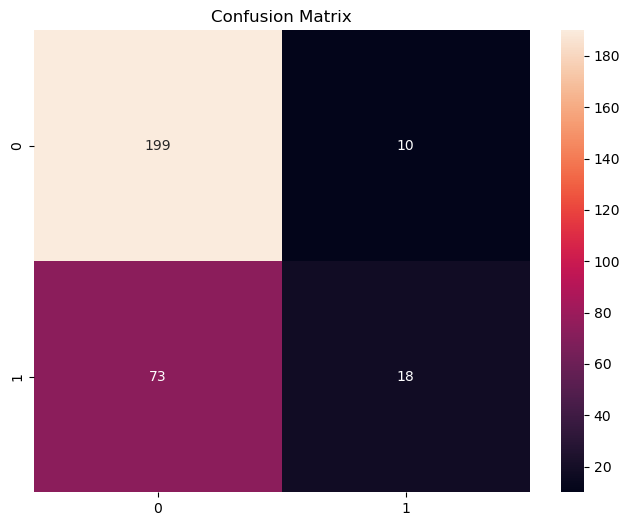

In [94]:
confusion_hard = confusion_matrix(y_test, y_prob_rf[:,1].round())
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, vmin=10, vmax=190,annot = True, fmt='d')
ax.set_title('Confusion Matrix')

In [59]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_prob_rf[:,1])

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [60]:
optuna.visualization.plot_param_importances(study_rf)

LGBM model has a better performance after the optimization using optuna, so we'll this model as our final

# Ranking the final model

In [98]:
import shap
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train,show=False)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [99]:
df_test = pd.concat([X_test, y_test],axis=1)

In [100]:
shap_test = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Here we are going to create new variables from shap. The goal is to make more easier to use our final model, for example we want to select the clients with hight scores and have more cash in checking account

In [127]:
def shap_col(shap_):
    col = ['Age', 'Job', 'Saving accounts', 'Checking account', 'Credit amount',
       'Duration', 'sex_female', 'sex_male', 'hous_free', 'hous_own',
       'hous_rent', 'purp_business', 'purp_car', 'purp_domestic appliances',
       'purp_education', 'purp_furniture/equipment', 'purp_radio/TV',
       'purp_repairs', 'purp_vacation/others']
    df_shap = pd.DataFrame(shap_test[1],columns=col)
#     shap_cols = {}
#     shap_cols['shap_1'] = np.nan
#     shap_cols['shap_2'] = np.nan
#     shap_cols['shap_3'] = np.nan
#     shap_cols['shap_4'] = np.nan
#     shap_cols['shap_5'] = np.nan
#     shap_cols['shap_6'] = np.nan
    df_shap.loc[df_shap['Checking account']>0.2, 'shap_1'] = 'Little Check Account'
    df_shap.loc[df_shap['Duration']>0.2, 'shap_2'] = 'More Credit Duration'
    df_shap.loc[df_shap['Credit amount']>0.2, 'shap_3'] = 'More Credit Amount'
    df_shap.loc[df_shap['Age']>0.2, 'shap_4'] = 'More Junior Client'
    df_shap.loc[df_shap['hous_own']>0.2, 'shap_5'] = 'Have House'
    df_shap.loc[df_shap['purp_radio/TV']>0.2, 'shap_6'] = 'The purpose is to buy Radio/TV'
    df_shap.loc[df_shap['Checking account']<-0.2, 'shap_7'] = 'Moderate/Rich Check Account'
    df_shap.loc[df_shap['Duration']<-0.2, 'shap_8'] = 'Less Credit Duration'
    df_shap.loc[df_shap['Credit amount']<-0.2, 'shap_9'] = 'Less Credit Amount'
    df_shap.loc[df_shap['Age']<-0.2, 'shap_10'] = 'More Senior Client'
    df_shap.loc[df_shap['hous_own']<-0.2, 'shap_11'] = 'Does not have House'
# pd.DataFrame(shap_test[1],columns=col).apply(shap_col, axis=1, result_type='expand')

    return df_shap[['shap_1','shap_2','shap_3','shap_4','shap_5','shap_6',
                    'shap_7','shap_8','shap_9','shap_10','shap_11']]

In [128]:
df_shap_arg = pd.DataFrame(shap_col(shap_test[1]))

In [129]:
df_shap_arg

shap_1                shap_2              shap_3  \
0    Little Check Account                   NaN                 NaN   
1    Little Check Account                   NaN                 NaN   
2    Little Check Account  More Credit Duration                 NaN   
3    Little Check Account                   NaN  More Credit Amount   
4                     NaN                   NaN  More Credit Amount   
..                    ...                   ...                 ...   
295                   NaN                   NaN                 NaN   
296  Little Check Account  More Credit Duration                 NaN   
297                   NaN                   NaN  More Credit Amount   
298  Little Check Account  More Credit Duration  More Credit Amount   
299  Little Check Account                   NaN  More Credit Amount   

                 shap_4      shap_5 shap_6                       shap_7  \
0    More Junior Client         NaN    NaN                          NaN   
1                   NaN         NaN    NaN                          NaN   
2                   NaN         NaN    NaN                          NaN   
3    More Junior Client  Have House    NaN                          NaN   
4                   NaN         NaN    NaN  Moderate/Rich Check Account   
..                  ...         ...    ...                          ...   
295  More Junior Client         NaN    NaN  Moderate/Rich Check Account   
296                 NaN         NaN    NaN                          NaN   
297  More Junior Client         NaN    NaN  Moderate/Rich Check Account   
298                 NaN  Have House    NaN                          NaN   
299  More Junior Client  Have House    NaN                          NaN   

                   shap_8              shap_9             shap_10 shap_11  
0                     NaN  Less Credit Amount                 NaN     NaN  
1                     NaN                 NaN                 NaN     NaN  
2                     NaN  Less Credit Amount                 NaN     NaN  
3    Less Credit Duration                 NaN                 NaN     NaN  
4                     NaN                 NaN  More Senior Client     NaN  
..                    ...                 ...                 ...     ...  
295                   NaN  Less Credit Amount                 NaN     NaN  
296                   NaN                 NaN                 NaN     NaN  
297  Less Credit Duration                 NaN                 NaN     NaN  
298                   NaN                 NaN                 NaN     NaN  
299  Less Credit Duration                 NaN                 NaN     NaN  

[300 rows x 11 columns]

In [130]:
df_final = pd.concat([df_test.reset_index() ,df_shap_arg],axis=1)

In [131]:
df_final

index  Age  Job  Saving accounts  Checking account  Credit amount  \
0      521   24    2                1                 1           3190   
1      737   35    1                2                 1           4380   
2      740   32    2                2                 1           2325   
3      660   23    2                1                 3           1297   
4      411   35    3                1                 0           7253   
..     ...  ...  ...              ...               ...            ...   
295    468   26    2                1                 0           2764   
296    935   30    3                2                 2           1919   
297    428   20    2                1                 0           1313   
298      7   35    3                1                 2           6948   
299    155   20    2                1                 1           1282   

     Duration  sex_female  sex_male  hous_free  ...                shap_2  \
0          18           1         0          0  ...                   NaN   
1          18           0         1          0  ...                   NaN   
2          24           0         1          0  ...  More Credit Duration   
3          12           0         1          0  ...                   NaN   
4          33           0         1          0  ...                   NaN   
..        ...         ...       ...        ...  ...                   ...   
295        33           1         0          0  ...                   NaN   
296        30           0         1          0  ...  More Credit Duration   
297         9           0         1          0  ...                   NaN   
298        36           0         1          0  ...  More Credit Duration   
299        12           1         0          0  ...                   NaN   

                 shap_3              shap_4      shap_5  shap_6  \
0                   NaN  More Junior Client         NaN     NaN   
1                   NaN                 NaN         NaN     NaN   
2                   NaN                 NaN         NaN     NaN   
3    More Credit Amount  More Junior Client  Have House     NaN   
4    More Credit Amount                 NaN         NaN     NaN   
..                  ...                 ...         ...     ...   
295                 NaN  More Junior Client         NaN     NaN   
296                 NaN                 NaN         NaN     NaN   
297  More Credit Amount  More Junior Client         NaN     NaN   
298  More Credit Amount                 NaN  Have House     NaN   
299  More Credit Amount  More Junior Client  Have House     NaN   

                          shap_7                shap_8              shap_9  \
0                            NaN                   NaN  Less Credit Amount   
1                            NaN                   NaN                 NaN   
2                            NaN                   NaN  Less Credit Amount   
3                            NaN  Less Credit Duration                 NaN   
4    Moderate/Rich Check Account                   NaN                 NaN   
..                           ...                   ...                 ...   
295  Moderate/Rich Check Account                   NaN  Less Credit Amount   
296                          NaN                   NaN                 NaN   
297  Moderate/Rich Check Account  Less Credit Duration                 NaN   
298                          NaN                   NaN                 NaN   
299                          NaN  Less Credit Duration                 NaN   

                shap_10  shap_11  
0                   NaN      NaN  
1                   NaN      NaN  
2                   NaN      NaN  
3                   NaN      NaN  
4    More Senior Client      NaN  
..                  ...      ...  
295                 NaN      NaN  
296                 NaN      NaN  
297                 NaN      NaN  
298                 NaN      NaN  
299                 NaN      NaN  

[300 rows x 32 columns]

In [132]:
df_final = df_final.fillna(0)

creating a column score from our predeict_proba

In [133]:
df_final['score'] = y_prob_lgbm[:,1]

we well divide our clients in 5 groups based in the score, this number we can use any number to see with our model is ordering some variables

In [171]:
df_final['rank'] = pd.qcut(df_final['score'], 5,labels = False)

Group by some variables

In [172]:
df_final.groupby('rank')[['Checking account','Duration', 'Age','Credit amount', 'hous_own',
                          'Saving accounts','purp_radio/TV','purp_car','sex_male','sex_female']].agg('mean')

Checking account   Duration        Age  Credit amount  hous_own  \
rank                                                                    
0             0.083333  15.350000  41.300000    2261.750000  0.900000   
1             0.716667  16.266667  35.266667    2352.266667  0.783333   
2             1.216667  18.566667  36.950000    3140.466667  0.766667   
3             1.450000  18.466667  33.133333    2666.100000  0.683333   
4             1.383333  31.783333  31.700000    4354.200000  0.383333   

      Saving accounts  purp_radio/TV  purp_car  sex_male  sex_female  
rank                                                                  
0            1.183333       0.400000  0.300000  0.766667    0.233333  
1            1.283333       0.216667  0.266667  0.766667    0.233333  
2            1.033333       0.250000  0.300000  0.683333    0.316667  
3            1.283333       0.266667  0.383333  0.716667    0.283333  
4            1.033333       0.166667  0.333333  0.600000    0.400000

In [173]:
df_final.groupby('rank')[['Checking account','Duration', 'Age','Credit amount', 'hous_own',
                          'Saving accounts','purp_radio/TV','purp_car','sex_male','sex_female']].agg('mean').style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

We managed to create a good discrimination between our audience with higher scores and those with lower scores

In [174]:
df_final.groupby('rank')[['Risk']].agg('sum').style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

We were able to order the amount of bad credit

we can see using others numbers to divide

In [175]:
df_final['rank'] = pd.qcut(df_final['score'], 3,labels = False)
df_final.groupby('rank')[['Checking account','Duration', 'Age','Credit amount', 'hous_own',
                          'Saving accounts','purp_radio/TV','purp_car','sex_male','sex_female']].agg('mean')

Checking account  Duration    Age  Credit amount  hous_own  \
rank                                                               
0                 0.31     15.43  39.69        2282.97      0.86   
1                 1.17     18.19  35.30        2868.43      0.77   
2                 1.43     26.64  32.02        3713.47      0.48   

      Saving accounts  purp_radio/TV  purp_car  sex_male  sex_female  
rank                                                                  
0                1.17           0.36      0.28      0.77        0.23  
1                1.18           0.20      0.31      0.71        0.29  
2                1.14           0.22      0.36      0.64        0.36

In [176]:
df_final.groupby('rank')[['Checking account','Duration', 'Age','Credit amount', 'hous_own',
                          'Saving accounts','purp_radio/TV','purp_car','sex_male','sex_female']].agg('mean').style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

In [177]:
df_final.groupby('rank')[['Risk']].agg('sum').style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

Our final model is:

In [186]:
df_final[['score','rank','shap_1','shap_2','shap_3','shap_4','shap_5','shap_6',
        'shap_7','shap_8','shap_9','shap_10','shap_11']]

score  rank                shap_1                shap_2  \
0    0.344688     2  Little Check Account                     0   
1    0.296853     1  Little Check Account                     0   
2    0.410630     2  Little Check Account  More Credit Duration   
3    0.427560     2  Little Check Account                     0   
4    0.184806     1                     0                     0   
..        ...   ...                   ...                   ...   
295  0.187536     1                     0                     0   
296  0.245917     1  Little Check Account  More Credit Duration   
297  0.167448     1                     0                     0   
298  0.658138     2  Little Check Account  More Credit Duration   
299  0.651962     2  Little Check Account                     0   

                 shap_3              shap_4      shap_5  shap_6  \
0                     0  More Junior Client           0       0   
1                     0                   0           0       0   
2                     0                   0           0       0   
3    More Credit Amount  More Junior Client  Have House       0   
4    More Credit Amount                   0           0       0   
..                  ...                 ...         ...     ...   
295                   0  More Junior Client           0       0   
296                   0                   0           0       0   
297  More Credit Amount  More Junior Client           0       0   
298  More Credit Amount                   0  Have House       0   
299  More Credit Amount  More Junior Client  Have House       0   

                          shap_7                shap_8              shap_9  \
0                              0                     0  Less Credit Amount   
1                              0                     0                   0   
2                              0                     0  Less Credit Amount   
3                              0  Less Credit Duration                   0   
4    Moderate/Rich Check Account                     0                   0   
..                           ...                   ...                 ...   
295  Moderate/Rich Check Account                     0  Less Credit Amount   
296                            0                     0                   0   
297  Moderate/Rich Check Account  Less Credit Duration                   0   
298                            0                     0                   0   
299                            0  Less Credit Duration                   0   

                shap_10  shap_11  
0                     0        0  
1                     0        0  
2                     0        0  
3                     0        0  
4    More Senior Client        0  
..                  ...      ...  
295                   0        0  
296                   0        0  
297                   0        0  
298                   0        0  
299                   0        0  

[300 rows x 13 columns]